# Scraping subreddits


## Part II - Preprocessing & EDA
---

We'll import all our required libraries up here.

In [76]:
#import libraries

import pandas as pd, numpy as np, requests, time, nltk, datetime as dt, matplotlib.pyplot as plt, seaborn as sns

#NLP transformers
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import gensim.downloader as api #allows us to get word2vec anf glove embeddings that we need
from gensim.models.word2vec import Word2Vec
from transformers import pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


#classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text


#metrics / model preprocessing
from sklearn.metrics import (accuracy_score, confusion_matrix, plot_confusion_matrix, \
                             recall_score, precision_score)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier


# easier to see full text with a bigger maxwidth:
pd.options.display.max_colwidth = 200

#show grid on plots
sns.set_style('darkgrid')

In [2]:
#pip install python-Levenshtein
#this is for the gensim.similarities.levenshtein submodule

- - - 

### Pull in the files, resulting from our scrapes, into dataframes!

In [3]:
movie_deets2 = pd.read_csv('../data_outputs/good_movie_deets2.csv')
bad_deets2 = pd.read_csv('../data_outputs/bad_movie_deets2.csv')
all_movies = pd.read_csv('../data_outputs/all_movies.csv')

### Get basic stats

Let's look at basic stats about our data.

How many records do we have, prior to cleaning?

In [4]:
movie_deets2.shape

(8805, 9)

In [5]:
bad_deets2.shape

(8180, 9)

In [6]:
all_movies.shape

(9404, 9)

What did we pull in?

In [7]:
movie_deets2.head(2)

title  \
0                                                                                                                        Listen,share,repost "culgrin d mayor" Africa gorilla volume 1 EP on all PLATFORMS   
1  In Repo Man (1984), Miller says to Otto “suppose you're thinkin' about a plate o' shrimp. Suddenly someone'll say, plate, or shrimp, or plate o' shrimp out the blue” as an example of his concept o...   

  selftext     subreddit  created_utc             author  is_self  score  \
0      NaN  MovieDetails   1619213155           culgrin1    False      1   
1      NaN  MovieDetails   1619214866  VictorBlimpmuscle    False      1   

   num_comments   timestamp  
0             0  2021-04-23  
1            12  2021-04-23

In [8]:
bad_deets2.head(2)

title  \
0                                                                                                                       In the movie Bullworth (1998), a police officer is seen not shooting black people.   
1  The Nightmare Before Christmas (1993), when he arrives at Christmas Town, Jack sings "what's this? There's white things in the air". 22 seconds later he sings "there are children throwing snowball...   

  selftext           subreddit  created_utc         author  is_self  score  \
0      NaN  shittymoviedetails   1619214935      Wuz314159    False      1   
1      NaN  shittymoviedetails   1619217853  Nerf_Herder86    False      1   

   num_comments   timestamp  
0             1  2021-04-23  
1             0  2021-04-23

In [9]:
all_movies.head(2)

title  \
0                                                                                                                                               Russian sci-fi film about artificial intelligence testing.   
1  Just why! Miranda is not in the Lizzie McGuire Movie and while the movie was still good, there's a huge hole without Miranda especially when they go to a country like Rome. And Miranda was already...   

    selftext subreddit  created_utc            author  is_self  score  \
0        NaN    movies   1619216594             Anixx    False      1   
1  [removed]    movies   1619217134  EvilIceCream1755     True      1   

   num_comments   timestamp  
0             0  2021-04-23  
1             0  2021-04-23

Let's actually merge our dataframes to make it easier for processing.

In [10]:
#pd.concat([df1, df2])
df = pd.concat([bad_deets2, movie_deets2, all_movies])
df.head(1)

title  \
0  In the movie Bullworth (1998), a police officer is seen not shooting black people.   

  selftext           subreddit  created_utc     author  is_self  score  \
0      NaN  shittymoviedetails   1619214935  Wuz314159    False      1   

   num_comments   timestamp  
0             1  2021-04-23

In [11]:
df.shape

(26389, 9)

What data types are we dealing with?

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26389 entries, 0 to 9403
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         26389 non-null  object
 1   selftext      7350 non-null   object
 2   subreddit     26389 non-null  object
 3   created_utc   26389 non-null  int64 
 4   author        26389 non-null  object
 5   is_self       26389 non-null  bool  
 6   score         26389 non-null  int64 
 7   num_comments  26389 non-null  int64 
 8   timestamp     26389 non-null  object
dtypes: bool(1), int64(3), object(5)
memory usage: 1.8+ MB


A few objects, like text fields, are expected, and will need to be transformed / vectorized for modeling.

Let's also convert the time stamps to a usable format, just in case they come in handy for modeling.

A few objects, like text fields, are expected, and will need to be transformed / vectorized for modeling.

Let's also convert the time stamps to a usable format, just in case they come in handy for modeling. Further, the UTC is actually not really something we want in our model, and it's not really numeric either (it's a datetime concept if anything). Let's take care of that as well.

In [13]:
#convert time stamps
#.apply(pd.to_datetime) - ref.: https://stackoverflow.com/questions/26763344/convert-pandas-column-to-datetime
df['timestamp'] = df['timestamp'].apply(pd.to_datetime)
df['created_utc'] = df['created_utc'].apply(pd.to_datetime)

Now we can try to obtain basic descriptive stats.

In [14]:
df.describe().round(1)

score  num_comments
count  26389.0       26389.0
mean      57.4          18.7
std     1400.0         124.0
min        0.0           0.0
25%        1.0           0.0
50%        1.0           2.0
75%        1.0           5.0
max    72489.0        6036.0

Not much to look at here at the moment. The notables are the distribution of comments. We'll want to perform some more specific distribution analyses a little down the road, once done with the cleaning, to make more sense out of these stats.

Where might we have issues with missing data?

In [15]:
df.isnull().sum()

title               0
selftext        19039
subreddit           0
created_utc         0
author              0
is_self             0
score               0
num_comments        0
timestamp           0
dtype: int64

- - - 

### Imputation and cleaning strategy

Our strategy is to first remove anything with selftext appearing to have been deleted. Even though these are not read as nulls, they effectively are, for our purposes.

We knew that we'd have quite a few issues with missing self-text, when we shose to scrape unfiltered data. To remedy this, we could impute all nulls where self text is missing with the post's title, but this might result in inadvertent text duplicates when we train our model. So, instead, we are going to engineer a new column and merge the self-text and title text. _Note: Attribution for the idea to Riley R._

We will further dedupe and get rid of ostensibly spammy looking posts, by adding stop words like "repost", "reshare", as well as dropping any dominant authors or ones that sound spammy ("bot", "auto").

We will also need to get rid of any link references.

Okay, let's start by dropping anything with the word "removed" or "deleted". It's a tiny portion of our set, so I am not super worried about losing those rows of data.

In [38]:
#df[~df['col'].str.contains('value1|value2')]
#syntactic ref from https://stackoverflow.com/questions/52297740/typeerror-bad-operand-type-for-unary-float

df = df[~df['selftext'].str.contains('deleted|removed', na=False)]

#df = df[df.selftext != 'deleted']
#df = df[df.selftext != 'removed']

In [39]:
#check
df.head(1)

title  \
0  In the movie Bullworth (1998), a police officer is seen not shooting black people.   

  selftext           subreddit                   created_utc     author  \
0      NaN  shittymoviedetails 1970-01-01 00:00:01.619214935  Wuz314159   

   is_self  score  num_comments  timestamp  
0    False      1             1 2021-04-23

Let's confirm that those bad rows are gone.

In [43]:
#check again that removed and deleted selftexts are no longer in frame
df['selftext'].value_counts().sort_values(ascending=False)[:3]

[https://www.reddit.com/r/Paintings\_in\_movies/comments/j6f34d/sascha\_schneider\_hypnose\_1904\_vs\_the\_lighthouse/?utm\_source=share&amp;utm\_medium=web2x&amp;context=3](https://www.reddit.com/r/Paintings_in_movies/comments/j6f34d/sascha_schneider_hypnose_1904_vs_the_lighthouse/?utm_source=share&amp;utm_medium=web2x&amp;context=3)    2
Rachel Marrons sister hires a hitman to kill her successful sister but the reasons why are vague and explained in just a few minutes and never spoken about again. Also the sister never shows any outward resentment for her sister in any way throughout the movie which leaves her character severely underdeveloped.                            2
[https://i.imgur.com/5yFzqdk.jpg](https://i.imgur.com/5yFzqdk.jpg)                                                                                                                                                                                                                                                          

We should see the dropped rows reflected in the shape.

In [42]:
#Confirm data frame has shrunk by 227 rows
df.shape

(21798, 9)

Finally, the nulls should still be intact -- we are going to take care of that in a moment.

In [44]:
df.isnull().sum()

title               0
selftext        19039
subreddit           0
created_utc         0
author              0
is_self             0
score               0
num_comments        0
timestamp           0
dtype: int64

We also need to get rid of the link mentions.

In [57]:
#df['column'] = df['column'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#from https://stackoverflow.com/questions/51994254/removing-url-from-a-column-in-pandas-dataframe/51994366

df['selftext'] = df['selftext'].replace(r'http\S+', '', regex=True).replace(
    r'www\S+', '', regex=True).replace(r'\&amp\S+', '', regex=True)

Now let's create our all-text column that we'll train on later.

However, we still need an imputation strategy for the NaNs. I'm choosing to fill them in with spaces.

In [46]:
#nuke nulls
df['selftext'].fillna(' ', inplace=True)

In [58]:
#get new all-text column.
df['all_text'] = df['title'] + '. ' + df['selftext']

#check result
df.head(25).sort_values(by = 'selftext', ascending = False)

title  \
0                                                                                                                        In the movie Bullworth (1998), a police officer is seen not shooting black people.   
13                        After the commercial success of Kitchen Gun™ and Toilet Grenade™, Peter Serafinowicz expanded his business to offer a larger variety of cleaning products in John Wick: Chapter 2   
23                                                                                                                                           Guy makes his interestingly bizarre rendition that's addictive   
22                                                                                  The film title No Country For Old Men (2007) refers to the fact that Florida is not, in fact, a country. It is a state.   
21                     In 2001: A Space Odyssey (1968), much of the film focuses on characters walking slowly, in silence. This is a reference to the fact that holy fuck this movie is boring as all hell.   
20  In Captain America : The Winter Soldier (2014), the Winter Soldier looks like a crab in this scene. This is a reference to the actors name Sebastian, who is a crab in another Disney film, The Litt...   
19                                                                                                  In Justice League (2021) the kid from the liquor store whom Bruce was referring to is actually McLovin.   
18                                                                                                                         Captain America 4 (TBA) has recently been announced. Here is the leaked trailer.   
17                                                                                  In The Curious Case of Benjamin Button (2008) Brad Pitt became old because fight clubs can really take a toll on a guy.   
16                                                                                                          in mortal kombat, Hanzo says Cole Young "don’t let the bloodline die [in Japanese]” Cole Young:   
15                                    In The Falcon And The Winter Soldier, Sam becomes the new Captain America despite having no super soldier serum is a reference to the practice of affirmative action.   
14                                                                                                                                                                     Dbz Budokai Opening Story Mode (PS2)   
12                                                                                                                                                     /r/shittymoviedetails hit 600k subscribers yesterday   
1   The Nightmare Before Christmas (1993), when he arrives at Christmas Town, Jack sings "what's this? There's white things in the air". 22 seconds later he sings "there are children throwing snowball...   
11  In Game of Thrones Season 8, Daenerys’ last words are “we break the wheel together” which spelled backwards says “rehtegot leehw eht kaerb ew” which doesn’t make sense just like the rest of season 8.   
9           In the movie Stowaway(2021) a crew is traveling to Mars. The journey is supposed to take 2 years. Everyone is so boring, that the leading character exits the spaceship and dies alone outside.   
8                                                                         American Beauty was supposed to be a prequel to Se7en but the plot got diluted so bad that it became an entirely different movie.   
7   The casting of Hugh Jackman as Wolverine was both a shock and inconvenience to him because of communication errors. It was decided early on that they needed a "Huge Actor" to play the popular char...   
6                                                                                              I can’t believe they spent $90 million on this movie and no one pointed out that there’s a typo in the title   
5                                                         

In [56]:
df['selftext'].sort_values(ascending=False)

5861    ⏱\n\n🟥⏩🟦⏮\n\n👩🏼+🖼\n\n🧔🏿🤝👱🏻‍♂️\n\n✈️ 💥💥💥\n\n💂🏼‍♀️=🇷🇺\n\n🕛🕧🕐🕜🕑🕝🕒🕞🕓🕔😥😰🤯🤯🤯🤯🤯🤯\n\n🧔🏿🪞🧔🏿. 🤯🤯🤯\n\n👂👂🗣🗣🔊🔊🙅‍♂️🙅‍♂️🙅‍♂️🙅‍♂️\n\nCheese grater.\n\n&amp;#x200B;\n\nWhat do guys think about this format of scree...
8795    “Sometimes it’s easy to forget that we spend most of our time stumbling around in the dark” - Reporter Marty Baron\n\nIt may seem strange to call an Oscar winning best picture film underrated, but...
6814    “Fearless Vampire Killers”is on now, as I type. I’m something of fanatic on details when it comes to location as opposed to studio sets. Does anyone know if this film is on a location, and if so, ...
8440    “Drowning Mona”. A movie (currently on Amazon Prime) from 2000 that somehow manages all of the best B stars from the 90’s. Danny DeVito, Neve Campbell, William Fichtner, Bette Midler, Jamie Lee Cu...
1862    “An Oxford graduate takes up a job in a mental asylum, only to discover that the "revolutionary" new treatments are inhumane, and that there is more going on th

In [59]:
#get rid of spammy text / authors by creating stop words list -- or do this underneath, in the NLP part.

--- 

### Analysis

Now that we are more or less done cleaning, let's understand the density and usefulness of our content, by analyzing the volume of comments and looking for the richness of the text columns.

We will be able to perform additional text analysis later on, once we have transformed (vectorized) our text.

First, let's take a look at the distribution of posts by the volume of comments.

In [91]:
df['num_comments'].value_counts()[:50]

0     7083
2     2767
1     2159
3     1578
4     1282
5      786
6      641
7      452
8      406
9      334
10     301
11     251
12     245
13     185
14     173
16     148
15     138
17     123
20     115
18     102
19      88
21      85
22      71
23      66
25      66
26      65
27      62
24      56
29      46
30      46
28      46
36      43
33      39
35      37
34      37
31      36
42      35
37      33
32      32
41      30
43      28
54      28
47      26
39      25
44      24
40      23
38      20
46      19
45      18
52      18
Name: num_comments, dtype: int64

In [94]:
df['num_comments'].mean()

22.316726305165613

In [95]:
df['num_comments'].mode()

0    0
dtype: int64

In [97]:
df['num_comments'].median()

2.0

In [98]:
df['num_comments'].max()

6036

Judging from this, the vast majority of posts have no comments at all. The average number of comments is 22. There are also extreme outliers exceeding 1000 comments.

Let's visualize this.

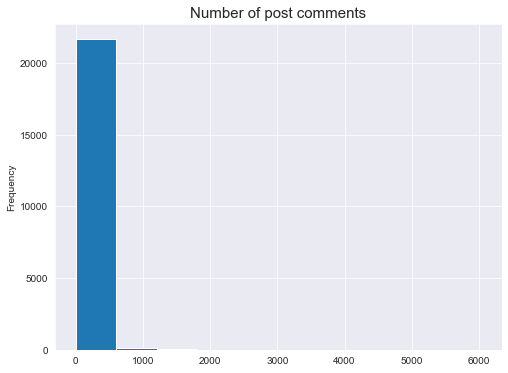

In [86]:
#code ref from Gwen's lab review lesson 4/27/2021

plt.figure(figsize = (8,6));
df['num_comments'].plot(kind='hist');
plt.title('Number of post comments', size =15);

Now let's look at distribution by authors. Let's see if any stick out as dominant, which can either mean that they are highly engaged on Reddit, or it could be a signal of spam.

Further, we might want to cross-validate if any others appear across _multiple_ of our subReddits!

In [107]:
df['author'].value_counts()[:50] #get only unique

wednesdaygiftinfo       434
Numerous-Lemon          282
Ornery-Control-9474     264
Tokyono                 191
[deleted]               189
pale_guy_               154
random_guy_somewhere    138
klsi832                 108
Comic_Book_Reader        92
sirsquid                 82
chanma50                 73
MovieBattleGame          68
alizamessy               63
Sisiwakanamaru           62
VictorBlimpmuscle        53
ggroover97               51
ToyVaren                 46
KscILLBILL               46
invertedparadX           43
SpaceMyopia              41
gautsvo                  41
james-1990               40
movihq                   33
prsnreddit               31
RayInRed                 31
lopezjessy               30
CephalopodRed            27
LiteraryBoner            27
randomspawner            26
Jack-Earth-2             26
MistleFeast              25
Mostafa_Dahroug          25
skyfall91404             25
Iamnotbroke              25
Prize_Guest              24
Puzzleheaded-Fun-257

We do have some authors that have posted hundreds of posts here. But nothing really obviously sticks out as concerning, at the moment, based on the author's handle alone -- that is, if we were looking for glaringly "spammy" signals with a naked eye (i.e. sans any spam detection machine like spam vs. ham). We'll check for the word 'repost' and 'reshare' as well; although we should have hopefully gotten rid of most of that content noise by stripping out the URLs from the text fields earlier.

But how many authors are there?

In [111]:
#unique authors
#from Gwen's NLP lab review
len(df['author'].unique())

12640

In [ ]:
#groupby the authors by subreddit

In [ ]:
#strip out repost / reshare stuff

Let's go ahead and see when most of our posts are from.

In [ ]:
#get post age

How well do most posts score?

(More on this here: [What do Reddit post scores mean?](https://www.reddit.com/wiki/faq#wiki_how_is_a_submission.27s_score_determined.3F).)

In [ ]:
#scores - numbers

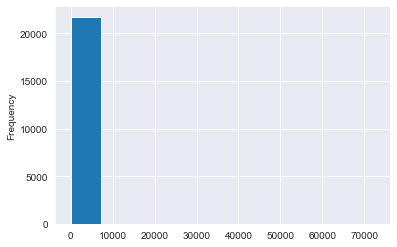

In [112]:
#dist of scores
df['score'].plot(kind = 'hist');

In [108]:
df.columns

Index(['title', 'selftext', 'subreddit', 'created_utc', 'author', 'is_self',
       'score', 'num_comments', 'timestamp', 'all_text'],
      dtype='object')

Looks like this is about all we can do, before further transformation.

- - -

## Part III: NLP & feature eng

### Vectorize text in prep for analysis

In [ ]:
#vectorize self-text, title or joint column

### Word analysis

In [99]:
#check for post density -- length of posts
len(df['selftext'].mean())

TypeError: Could not convert           

                                          There’s a “K” in the name which means its actually about a protector, a sentry... a hero; and not about a time of day like most people think. 

Dont feel ashamed if you didnt notice the “K” in the title. It was super subtle and tricky. The movie came out like 5 years ago and I just figured it out now (after painstaking research).

Its named this way because Marky Mark was the last vestige of hope for a shitty movie series that for some reason, which scientists and movie critics still cant understand; people paid to see                                                        

      
I’m from Russia, and we are encountered a weird situation with LOTR in IMAX remastered. Ads was telling us that it’s gonna be Remastered 4K. And you know what we got? 2001 version (looks like, because it’s blurry in action scenes like CRAZY) and no comments from officials. Theatrical cut for sure. 

So the question is - what happening in your country? 

Again - we are suffering, quality in 2D regular cinema looks ok, but not sure that it’s remastered. IMAX - truly, worst experience ever. Pain in eyes, vomiting feelings and so on. Help!

WB  universal Russia  theaters  imax are ignoring us. I have all the proofs and so on.
I’m not alone - all socials in Russia are full with negative comments.                                                                     RIP little Fabio      



                                    

     In the movie Idiocracy, the doctor says "My first wife was 'tarded. She's a pilot now."  Later in the movie, you can see planes crashing in the background. Proving that her uncle was also a pilot.  In Bojack Horseman s1e1, Bojack says "Linus had a blanket and no one gave him shit for it". This tells us Peanuts exists in Bojacks universe. Given that humans and animals are all bipedal and civilized/speak languages within the universe of Bojack Horseman, this means that Snoopie and Woodstock aren't just caricatures of regular house pets, but are rather regular people who happen to be mute and enjoy walking around in the nude.                                                                                                           Or even if it wasn’t an after thought for the one that does   Is nobody else triggered by the continuity in these movies? I cannot be the only one who thinks this chronological order of these movies make no sense.... 

How does a team go from winning the Junior Goodwill Games against Iceland, and go to highschool and suddenly suck balls?   Also... Hello iceland’s goodwill games captain, what are you doing in an American school with an american accent and playing goalee for the high school varsity team? Like WTF? 

And what is up with all the new kids also being clubbed into the “do not belong to eden hall”? Was it because of their lower-middle-class upbringing? Apart from Adam, did the other new kids also suffer financial difficulties? How did they afford all this airtravel for games? Also didn’t the new kids have super fancy stuff in D2? Like what was the point of pitting the ducks against the highschool varsity team after they played internationally? Isn’t that a demotion? Like “you won against the best of the international players, but here, get your ass handed to you by kids you were supposed to be better than?” Also, if the rest of team were also from lower-income households, how come Kenan and his brother didn’t get selected?  Also how did Julie go from blocking ALL the shots, to not being able to block even one? 

D1 to D2 was good... or ok-ish... But D3 was so stupid and made no logical sense in the progression of the ducks. 

Also wasn’t Charlie “You can take my spot” Conway always the sweet kid who always has everyone’s back? How does he suddenly become the terrible rebel who is fighting everyone? Like what? I get teenage angst and all that BS. But that is just such a departure from Spazway. How does he go from being a brat to coming back to school and have no freaking penalty for being an asshole? I’m pretty sure that would have been grounds for suspension of his scholarship.

Like I went to a school with rich kids, and I wasn't homeless or anything but I didn't have the designer shoes and the fancy cellphones. But the bullies didn’t try to get me kicked out because I was poor. They just treated me like crap for other reasons, and spoke badly about my "lacking" finances behind my back. 

Also, is this a day school or a boarding school?  don’t get it. I am so confused.

Don’t even get me started on Portman. Like wtf was that?      

                       Like a word for word copy!!!                                                                                                I was just rewatching Age of Ultron and caught this.  It's amazing he thought this was so funny that it bore repeating in a completely different superhero film.   
  
[Age of Ultron](  
[Justice League](                                                                                   

                                  The budget for the film was set at 160 to 200 million dollars to help cover the costs of destroying skyscrapers in Hong Kong.                                   Of terminator 3                                               

                                             

                                                    

                             

            

                                       

                         This is because he really does have second sight and knew that in the 1999 release of the movie, based on the book, he would be playing the part of the headless horseman and wanted to create some pre-release advertising.                                                                The ducks are neither mighty, nor.... are they ducks...





(Also, they never say whether Gordon Bombay molested those kids or not, which strongly suggests to me that he did)                                 In Finding Nemo, the fish students get on a jellyfish’s back like a bus. Not like they can’t swim.                  For only $25.85, you too can 'cosplay' Jack Torrance.

                                                                                                   Hello, to celebrate our 1.000th order we are giving away 15 Necklaces to the first 15 customers who add them to their carts!

We sell zodiac necklaces, in either silver or gold, feel free to comment or dm me if you have any questions.

Here you can check them out: [zodilaces.com](                            Rachel Marrons sister hires a hitman to kill her successful sister but the reasons why are vague and explained in just a few minutes and never spoken about again. Also the sister never shows any outward resentment for her sister in any way throughout the movie which leaves her character severely underdeveloped.Rachel Marrons sister hires a hitman to kill her successful sister but the reasons why are vague and explained in just a few minutes and never spoken about again. Also the sister never shows any outward resentment for her sister in any way throughout the movie which leaves her character severely underdeveloped.                                                                                                                                                                                                                           That's why the movie drags on  on after about the first third of the film.  Every available person was tasked with "finding the missing pages of the script" in the Australian outback.  Eventually everyone, including Agent Smith from the Matrix and Nicole Kidman gave up, and they just shouted "That's a wrap!  Roll credits, check the gate...!!!".      I made a video of the correct history behind Cromwell and the English Civil War. I invite you to watch and learn something today. I hope you the best in all your ventures. Be safe.  [Tim Talks - The History Behind Cromwell - YouTube](                       Had she not told them of the other eye while in the Indian temple - the movie would have ended.

Fade to credits.                                                          We were watching Firefly Lane and my gf said ~~Kim's~~ Kate's mom looked like John Smith's wife from Man in the High Castle, Chelah Horsdal. I checked IMDB and she was right. That's when I saw Quinn Lord and realized why he looked familiar. He had played her son before.                                                             

    Wonder what they're up too now...                                                                                                 

                                                                                                                                                                                                        
This I had already uploaded but I had to accommodate some things that I did not make clear.                                                                                            Hey, can we talk about how there are no voice acting credits anywhere in Surfs Up?  what's the deal? I scoured through the post credit sequence and found nothing. pls help                                They did Avatar in 45 minutes start to finish.                                                                         [[                                      Also, I don’t own or know how to use photoshop.                                                                                                                                                                                         The Rock has a biography that he isn't even in. It stars Nic Cage and Sean Connery.          In the movie "The Little Things" (Dir. John Lee Hancock, 2020) Denzel Washington spends a great deal of time sitting in chairs looking purposeful.

Several powerful chair sitting moments are in fact quite pivotal to the plot.

[Denzel Washington Sitting Purposefully In Chairs](                       In the movie Hancock, the main character Hancock sits down with Rays family for dinner after saving Ray's life when he was parked on the train. During dinner they have meatballs and he states, "That's a good meatball boy".

That meatball is being made from scratch by someone that has been around for thousands of years and traveled the world eating food. Can you imagine how good a meatball made by someone with that experience would be? That would be a damn good meatball                              

                                                                                                                                                                                                                                                 

            

     

                     

                

*Processing img h5rpmmnf8uc61...*                      

*Processing img 53ht4c4sixc61...*                                        

     

                                                       

                          In the edge of tomorrow, Tom Cruise wears a fake butt.

[                                                     I have no further clarification for this particular detail.                       

                                                   

*Processing img w74nug5yoqb61...*                            **Alejandro G. Iñárritu** **and his wife saw this film at the Cannes festival in 2000, 20 years later he was till so moved by he describes how after viewing it they "walked in complete silence for almost 10 minutes. We suddenly stopped by the sea. Maria hugged me and started crying inconsolably on my shoulder. And I did the same on hers. 'In the Mood for Love' had left us speechless and deeply moved. It was that moment that reminded me why...I wanted to become filmmaker."** 



visit our channel [***here***](       Is posting actually shit          In The dark knight returns, a beam falls on Bruce Wayne when Wayne manor has been burning for about 5 minutes. This is to show what shitty builders the Waynes are.

*Processing img ov7dsntnnvb61...*                                                                                                      [                                 

   

                  

                                                    

       



*Processing img 8o4bls4dqoa61...*                      Bonus, Nolan was inspired by Anna Kendrick and Pitch Perfect to create a film that was a palindrome. [Source](                                

                 What an Odd job.                                                                            Cheetahs almost always live in fear of actual apex predator. they are also emotionally unstable and require support dogs to live in zoos.                         

                    

*Processing img zppqfkect6961...*                        

                 

*Processing img 0d1prh9old961...*                          [You can watch the scene here](

*Processing img 4c33g00rkh961...*                                           

*Processing img z3ydmba90v861...*                           

        

                                               It takes place during George Orwell’s book and is about Wonder Woman toppling big brother                           

                       **A New Voice in Cinema : Ken Ngwa**

**January 17, 2021**

**By Vikki Tobak**

(Article Originally Appeared in [MassAppeal.com]( )

[Today we profile a fr]( new voice scorching through New York. Ken Ngwa is a

filmmaker, screenwriter, and businessman. He is the[creator, director, and](

executive producer of “Nature Boy,”. A film about growing up as an African

[immigrant on]( the southside of Chicago. As a Director he has slowly built an

impressive body of work via social media. He’s traveled the world — Israel,

France, Cameroon, Argentina, Nigeria and Brazil — and through it all, he

has cultivated a deep understanding of people.

[His instagram fe]( is littered with heart warming images and provocative

graphics. I literally spent an hour on the page before I realized how deep

down the rabbit hole of the gram I had gone. This year, the Director has

embarked on his biggest adventure yet: Nature Boy. Nature Boy is the story

of an African boy from the suburbs of Chicago who goes joyriding with two

boys from inner city Chicago . The film is scheduled for release late 2021 .

Check out his page, it's international, crazy informative and packed with dope

music.

[u/kenngwa]( [u/sunpeopleproductions](            This is proof that Aunt Sarah hasn't had the Siamese very long at all, because , sometimes, they just do that. [Siamese]( [cats]( [are]( [weird] (                                All the souls were Blue /Green colored and not red. In additive light the primary colors are blue, green, and red.  They Wanted to be sure there was no red in the before- or afterlife soul depiction either.                                                                                                                       In the next movie (ex-name: Taken 3) they would explain Hades and Ares were behind it all.                                                                                                                                                                                                                                                                                                                 

                                             At the end of *The Force of Awakens* when Rey hands Luke his lightsaber the suprise on Mark Hamill's face is genuine and due to the face that his agent just told him that he was going to paid millions of dollars just for turning down and pealing back his hood.At the end of *Casablanca* Humphrey Bogart tells Ingrid Bergman "We'll always have Paris" because he claimed to have won the famous city in a hot dog eating contest but the joke's on her because he's only telling her this to get in her plants.                                                                                                                                                    If you analyze the walking motion of the characters in Total Recall in the Mars scenes, you’ll notice that the gravity actually matches Earth’s. That’s because they didn’t have the budget to go to Mars and build a colony to film there.               

*Processing img apd2sfwbox461...* 

                                               



 



                                    Do you know where to get [Fusogenix DNA vaccine Online]( from USA Legitly?

Oh My God we need this vaccines before our entire community get wipe out

God Forbit                                                                                 

      

                             This is a nod to the fact that the movie is NOT titled after the video game Vader Immortal, because of the fact that Darth Vader is not immortal in the movie. I also thought of this on the toilet so give gold now [Epic](                                                      I need to tell myself this every time. It's just too painful otherwise.                                                                             

                                           

                                                                      

*Processing img xz13y3c7k3361...*                  

                             Lion 0 is amazed by Costner. Tries to sell it

[                 

                                                                                                                                                        

      

已經使用了許多產品來改善男性生理健康，但演員阮海（Nguyen Hai）仍無法按預期恢復其正常的房事能力，進入岡本藥妝店並使用[日本藤素](

## 演員阮海使用[日本藤素](

\[caption id="attachment\_757" align="aligncenter" width="768"\]📷 日本藤素 演員阮海腰痛\[/caption\]

63歲的演員阮海面臨男性生理功能的明顯下降。具體而言，演員經常陷入“還沒開始就結束了”的狀態，使得與妻子的戀愛變得快速而乏味。“*我知道這個年齡段任何人都有這項困擾，但是我有點震驚。誰會想到幾年前我仍然像個“年輕人”，而現在卻可憐不知所措呢？作為一個忙於工作的人，經常被安排去外地上班，所以我非常感謝在家中與妻子團聚的日子。然而，每天到了晚上的時候，“槍支”被卡住，非常尷尬*”

在談到這種生理機能障礙時，藝術家阮海說，主要原因是年齡的增長。隨之而來的是忙碌的工作，密集的拍攝時間表，飲食，休息...

“*正是那些壓力和長期壓力的日子使我無法保持自己的黃金年齡。取而代之的是，樂趣不斷縮短，時間縮短然後次數稀疏。儘管有時候我想和我的妻子在一起，但是身體無法配合，所以我忍不住感到無助，”男演員阮海說*。

除了男性生理功能下降外，演員阮海也有一些不愉快的症狀，如多次夜尿，背部疼痛，膝蓋疲勞……這使他無法入睡。長時間的症狀對演員的健康，工作和心理造成負面影響：

“在那些日子裡，我想我會調養的越來越好的，但是卻讓我不僅在床事上“無力”，而且健康狀況也在不斷下降，所以說無論您多麼熱愛這份工作，都想獻身於這份工作，想給聽眾帶來良好的作用，但是如果您沒有健康，就無法做到。 疾病日復一日地纏著，使我周圍的妻子和親戚更加擔心。看到人們為我煩躁不安，我承認這很傷我，我不知道怎麼做！”

## 使用各種在市場上標榜“效果很好”“一顆見效”的產品，但無濟於事

面對“過山坡”式的生理虛弱，演員阮海考慮使用西藥或在互聯網上刊登廣告的某些功能性產品。阮海認為這些產品是“神聖的”用途的介紹，這可以幫助我擺脫對“虛弱”的恐懼，取而代之的是，我越努力，就越失望。但是，事實並非演員所期望的那樣，而且結局太丟臉；

“*為了快速起見，我選擇使用威爾剛產品，以及其他類似產品全部使用。但是這些產品僅具有立竿見影的效果。總的來說，它還能幫助男人“保持勃起”更長的時間，但是之後，他們會感到非常疲倦，身體呆滯，疲憊並且沒有活力。更不用說下次我想要達到這種性能時，我必須繼續使用該產品。* 

*事實證明，這些產品都使人們依賴該藥物並引起一些不良副作用。輕度使使用者頭痛，頭昏眼花，重度會導致永久性勃起功能障礙，陰莖不再能夠“立正站好”。想到這一點，我現在仍然感到恐慌*”

## 演員阮海直接去[岡本藥妝店](

考慮到一些在市場上廣為宣傳的男性增強產品的副作用，演員阮海繼續努力尋找解決生理上無力的難題的解決方案。幸運的是，在拍攝期間的休息時間與同事的交談中，同事推薦了岡本藥妝店！分享了其網站（

\[caption id="attachment\_758" align="aligncenter" width="768"\]📷 日本藤素演員阮海資訊醫師\[/caption\]

經過仔細的檢查，醫師指示我在3個月內使用[日本藤素](

### 在使用[日本藤素](

經過醫生的全面檢查和諮詢，演員阮海服用了[日本藤素](

岡本藥妝店的[日本藤素](

“*我經常出現夜間排尿，背部疼痛和膝蓋疲勞的情況已得到明顯緩解。因此，我感覺進食、睡眠、精神的恢復，而且我的身體也更加舒暢。特別是，我與妻子“運動”的時間也大大延長了，從現在的2-3分鐘延長到5-7分鐘。* 

*我相信目前只用了幾天時間，身體給我的反饋是有明顯的改善，如果我按照醫師的建議堅持所有3個療程，那“年輕的我”肯定會回來的，我和我妻子之間的性快感將不再面臨任何問題 ！*”

## [日本藤素](

[日本藤素](

傳統中藥材通過按照一定的黃金比例分離和組合藥物成分的多個階段，研究人員成功地生產出了具有以下5種功能的[日本藤素](

[日本藤素](

## 演員阮海對[日本藤素](

\[caption id="attachment\_759" align="aligncenter" width="768"\]📷 日本藤素幫助演員阮海“喚醒”房間的激烈表演\[/caption\]

此外，經過一段時間的使用，從符合GACP-WHO標準的100％清潔天然草藥中提取的這些成分還有助於滋養男性身體，產生骨髓益處並變得健康。堅韌，健康，清爽的精神，支持增加身體的抵抗力並顯著改善身體的免疫系統。

因此，[日本藤素](

目前，“[日本藤素](      He just played along to get some air, his bosses were huge dicks.         Get the best way,techniques and system to play your Tomb Raider right now before it gets too late .

 [   Hollywood does the best             am looking for a movie to watch on Netflix please do you know any interesting one that i can watch?            I kinda know that this completely doesn't fit here, but nonetheless since it's 2020, I think this movie which hasn't been released could slip into this category think of it as an adaptation theory pitch for the presentation/movie of David Icke : The lion sleeps no more.

So yesteday I've been watching some David Icke, and although i am feeling more like a reptillian than human (I can't really say that I feel as innocent as a gnostic human being that is, although what roman empire did to the library of alexandria is kinda un-forgivable in a way, despite perhaps there was a reason for why they did - maybe they have seen the future timelines of people (either reptiles killing humans or the other way, and for the prosperity of the citizens of the earth -&gt; human interbreeding involved for highest rate of prosperity in terms of genetical superiority for the galactic empire-&gt; they choose to just scan the whole library of alexandria and sent it to the moon-which is hollow, but didn't have to be that way from the beginning-maybe it was just a little planetary rock, like there could be someone like Elon Musk in the past flying there, while at that time still being just a little rock and building the moon from within on the top of that rock, spreading multiple building bases all arrround it, taking 100s if not thousands of years theoretically-&gt; what may one call 2000 years of stagnation ( we started brutally developing since industrial revolution,but meanwhile we were dummies kinda like we have been pumping sumthing gradually from the angels, or rather being fed, than given the knowledge (that could be ours and deserved). untill it started looking naturally for the people of our age, to assume that the moon is real natural phenomenon of the real universe.



tbh,though I can't say I didn't frantically enjoy the almost 3 hours long speech from 2012 (The lion sleeps no more)

So speaking of the Ideas that Icke was I have an Idea about a movie that would involve,                             check out this video [Angela]( though its a music but you will enjoy it [    Hey guys am from Nigeria and am an artist ask me any question [Instagram](         

[ wakanda forever](                          

  

          In this, you see many celebrity [kickass facts]( and you really enjoy this  



[

[View Poll](      

   After Watching Magic Mike I noticed that this supposed magic trick documentary and magic tutorial movie called Magic Mike didn’t contain a single magic trick or offer any advice on practicing it. It was about a bunch of men who took their clothes off. What is magic about that? I hardly think that any hardcore or even average magician would get any use outta that. I watched the entire movie hoping to see David Blaine or Chris Angel but they never showed up. The title is misleading to the true magicians and everyone else who thought they could learn new magic tricks.                                                                                  

[This is is boys. This is what I was made to do](   That mean eventually Marlin will become female and have sex with Nemo.

                                        

             

                                                        This is a meta reference to Spiderman's primary audience because only beta males look up to Spiderman.                         

                  The Spongebob Movie entered theatres and Adam Driver had his 21st birthday. 

No prizes for guessing how he spent it.                          I know that rule number one of documentary film-making is that the camera-person is NOT to intervene in the subject matter of the documentary no matter what happens. But it still feels kind of wrong that they can see human victims being lured into the house and yet they do nothing to warn them / prevent them from entering.

I'm not asking for them to be arrested or whatever, but shouldn't they be at least held accountable in some other way for the plight of those humans?

[View Poll]( It's not like it advanced any themes, because there were none.[

How did nobody see him there? I mean, Batman was off-camera but everyone else should have seen him walk up next to the Joker. Did he just teleport there or something? 

This is similar to how in Star Trek The Wrath of Kahn, Kahn is the main villain and Spock dies to save the Enterprise.

Which itself is a homage to how JJ Abram never comes up with an original storyline for the franchise he's writing a sequel for.

Pretty meta, huh?  John Beckwith  Jeremy Grey - their flaw is upfront and obvious, they dupe women into having sex with them.

Secretary Cleary - homophobe, unloving to his son, views him only in terms of political expediency. 

Todd Cleary - rapist

Sack Lodge - chauvinist, cheats on his girlfriend/fiance, abusive, assaults people constantly.

Randolph - steals from the family by watching TV instead of doing his job

Father O'Neil - reveals confessions

 The list goes on.  Literally every male character in Wedding Crashers has some enormous flaw                At the end of Easy A there is a clip of Huck Finn and Jim where Huck offers to steer, but Jim doesn't let him.

This is a reference to Brandon running away with his gay black lover who won't let Brandon top...                                                           For **Breaking Bad** Member  Fan: I got 14/15 in this quiz try it and share your results: [

                    In Big Bang Theory, Leonard is led repeatedly to believe that him being a nerd might worsen his chances of getting into a relationship. This is a subtle hint that this is actually true and he really should get out more, develop a few different hobbies than comics and video games, and make some other friends.

                          He has. it's just hidden. His palate is also shown. and he has no uvula.

[ew.](                                      

[Sandler was reportedly very uncomfortable with this](                                                      

                                                                                                                      He even sent pictures of woody to a buyer and was going to send him off to Japan.                                       

                                                 What do you think of SpongeBob last movie : sponge on the run ?                                                                                                                                                               

                                                            Despite being famously known for his role as Peter Parker/Spider-Man in the MCU, Tom Holland also directed the classic Horror movies "Child's Play" (1988) and "Fright Night" (1985).



Oh wait, that's the *other* Tom Holland...                                                                                          

                                 



             

                                                                                         

                  [                                                                                                                                                              

           

[double accurate because it is a hospital](     





[The joker: Not cracking jokes](                                                                                  

[Ridiculous](                                  



                                    

                       Forgive me for making notice a peen that is almost Trump like. I had to pause the movie (during a moment without tiny Khazack peen and fat little man), pass the curse to the internet, go outside to shake the images eyeballs, and get some more beer to memove thsi mermery. Shart, da slerms have sterbled...              Judge Hoffman and Darth Vader do have a lot in common.    

                

                                                     The title gives away the surprise that Batman does in fact returns for the sequel               ... foreshadowing how this shitty movie would alienate the audience, leading to an entire generation missing out on Superman   Came here thinking this would have details about shitty movies, not shitty details about movies. Anyone know a sub with the first?                                                

    Lately the subreddit has been slowly moving towards "Moviedetails upvoted this post and it is a shit post" material. 

That is not what this sub is about. 

Content for this subreddit should be fun, lighthearted, humorous. 

If posters on other subreddits get harassed as a result of posts made on here then the sub can get in trouble and we could get sanctioned or shut down. 

A new rule will be added, a clarification to rule 2: "Be nice".

**No meta-reddit attack posts**

No posts that are about or mention other subreddits, posts or users, either in the title, as a top level comment or visible on the image. 

This subreddit is a place to be silly, to be inventive, to make people smile. 

It's fine to take an image from another subreddit and subvert the original meaning via a novel title. A play on words, a subverted expectation, a meme or a joke. 

It is no longer allowed to directly mention other users or subreddits or to make mean-spirited posts like "Look what these people upvoted haha they're bad".                      I know this because I slept through the whole movie.                      

                    [                                                                             

                                                                                                                  

                                  In the Netflix series "atypical" S2:E3 23:30 Evan, Casey's boyfriend is shown playing a video game. In this seen he is arguing with his teammates saying "well that's exactly what happens when you drop into tilted towers. Well I told you to - I told everybody to land at dusty depo" heavily referencing landmarks from the game "Fortnite" implying that he is infact playing Fortnite. But in this scene you can see the T.V. he is using and he is quite obviously playing an entirely different game. The game he is actually playing in this scene is "Horizon Zero Dawn"                                                                                                  

  

                                     BBC News - Cineworld set for temporary UK shutdown after Bond film delay
                And then all you Johnny Depp fangirls made the comedic relief the star and ruined the series.                                              The guy that tried to rob mr Buster of his gold was actually hiding in the hills watching him.                                                                                                                                                                                                                                             

                                                                  The Mission: Impossible series centers around top IMF Agent Ethan Hunt and a rotating cast of allies (And Simon Pegg) as they undertake a series of impossible missions.

However, they are successful in nearly every mission and the missions are therefore not 'Impossible'.

You may ask yourself; why is the series called Mission Imposisble, then?

It's because the true Impossible Mission is not in the hands of the fictional character of Ethan Hunt. Instead it's the task of the entire behind-the-camera crew to kill Tom Cruise through tricking him into doing a series of elaborate and highly dangerous stunts.

And after six movies and a seventh on the way they are still unsuccessful.                       Was actually a huge piece of shit.                        This [subbie](r/subbie) is for the greatest movie details ever

[View Poll](                                                               

# The title of 'The Matrix' is reference to the fact that some of the film(s) take place within The Matrix.                                                                                                  [the movie scene](

[source](    The film came out on April 23rd 2004.I just watched "Shes Out of my League" for 100'th time...i just noticed when Molly is clothes shopping with her sister and Pattie and her sister holds up a redish/orangish dress with a square pattern and says "you can wear this on your dinner date tonight"...Molly laughs at it and Pattie says its the most disgusting thing shes ever seen......cut to later in the film at the family lunch at Kirk's families house, Martie (kirk's jealous ex) walks into the dining area, trying to one-up Molly, wearing that same "disgusting" dress.

Did anyone else catch this?                                         **New Mortal Kombat Movie Yay or NO? I watched it characters were unimpressive. Acting was better in school plays I think.. I did like the Scorpion and Sub Zero aspect. But after first main fight. Was a total let down in my opinion.. Actors none of them really fit to their** characters.. I had such high hopes for this..  The 1995 one was way better in my opinion.. Sad with all that could have been done.          Steve Rogers Frenches his granddaughter, Sharon Carter. 

Steve is an old man having lived his entire life with Peggy Carter in the same timeline he kisses Sharon Carter.

Unless Steve  Peggy got divorced(let’s face it, they didn’t), Sharon is Steve’s granddaughter. In the final fight scene between the two, Tanya gets a knife knocked of her hand and it hits the bullseye on a dartboard with a picture on it. In that picture is a sketch of Tanya and Kano, in which the knife goes through Kano's right eye. Slightly later in the scene Tanya throws a bottle of acetone (usually used as a nail polish remover, but is also extremely flammable) directly into his right eye, which he tries to use as a laser but instead of shooting out it burns him instead. Even later in the scene Tanya stabs Kano in his right eye, like the picture tacked on the dart board at the start.    The mortal kombat fight is between Sonya and Kano, didn't want to leave spoilers in the title.

Both scenes take place in a trailer home. Both scenes involve fighting a one-eyed (arguably, in the case of kano)  sociopathic bad guy. Both scenes have a similar bathroom fight sequence. Both scenes involve the bad guy getting stabbed in the eye at the end.

I'm pretty sure I haven't really listed half the similarities, because I haven't compared them side by side. Pretty sure if you did, there would be a lot more.

I was going to call the Mortal Kombat fight sequence an 'homage' to the kill bill one, but when I googled it I found that the two movies share a producer in Bennet Walsh, so I'm not sure 'homage' is the right word -- he couldn't be paying homage to himself, right?             

*Processing img bqvetj8jicv61...*      Bridget Von Hammersmark is playing a card game with some German soldiers where each player has a card with the name of a famous person or character stuck to their forehead and they must ask questions to try and guess the name of the person or character written on their card.

One of the soldiers has "Mata Hari" written on their card. Mata Hari was an exotic dancer and German spy during the First World War, who was convicted and executed by France in 1917. This is a nod to Bridget's role as a spy in the movie and foreshadows that she will be caught and killed, too. 

I tried to find a clear shot of the soldier with the card on their forehead, but sadly couldn't.                                                    [Rare Book Revealing Truth About Twilight Zone Movie Killings](  
The truth about the death of Vic Morrow and two children on the set of Kohn Landis' and Stephen Spielberg's Twilight Zone movie (1982)                      Source: I watched both movies being filmed directly  outside my apartment, and the street signs are mostly accurate in the films and trailers

——

Don’t know if this means something as far as the plot lines of the film goes, or if it’s just trivia because this area of SF is photogenic and maybe permits are easy to get there, but both of these films’ climatic chase scenes were filmed in the same place. 

In Ant-Man and the Wasp, the chase goes east down California street, though some was actually filmed on Bush, before eventually turning south/downhill on Mason street - when Ant-Man goes large and “skateboards” downhill on a large truck, that’s the intersection of Bush and Mason. You can see the bar Summer Place (RIP) in the background, the building with the rock facade, so google that for a map view.

We can see in the Shang-Chi and the Legend of the Ten Rings trailer that the action - the chase scenes in the SF city bus - again takes place east to west on California and Bush, and that’s how I saw it filmed. We can see this time that the bus turns south from California on Stockton, not Mason. Also, in the trailer shots of a hotel with a red BMW parked out front, that’s the Fairmont hotel, two blocks north of the Bush  Mason intersection mentioned earlier. 

I was able to see much of this filming from my window, friends saw even more. There’s a shot not in the trailer where construction workers are set up in the middle of the street, but they have to bail out as a car comes crashing through - that was filed in the Bush  Mason intersection, and custom camera cars were ripping east on Bush and turning down Mason for a few days in a row. They even had a fake bus that was just a shell over a race car, it was wild. 

So I don’t know if there’s a story-driven reason for these two films to share this same location, or if Marvel is just comfortable producing chases on these particular streets, but maybe there’s an Easter Egg buried in here somewhere? I’m no Marvel expert. 

If this isn’t “proven” enough, I have video of the production, I can hopefully post that if necessary. He's rather skinny but nothing a bit of workout  Hollywood rubber suits with shoulder pads wouldn't fix. He's good at playing insane dudes and I've always thought that Batman would be at least a little insane. Probably a lot insane. He has the chin for it, anyways.          When Fenster initially sees the red Impala 2 lanes left, the very first thing he does after training his weapon on them is to roll down the window to his right.  Seconds later someone over the radio calls out the green civic 3 lanes left and bottles then does the very same thing - trains his weapon on them and rolls down the window to his right.

Does anyone know if this is a known tactical maneuver or simply just an enormous coincidence?                                   

                

                  Why is there a massive circular structure in front of the pool on the opposite end of the Washington Monument? Shouldn't the Lincoln Memorial be here instead of this circular ruin? What the heck is it?                        



*"For the scene where Ana stitches Kenneth's wounds, the director hired a real nurse for the close-ups. She misunderstood the director's directions to go deeper and inadvertently punctured Ving Rhames' skin and stitched the prosthesis to his arm. He didn't say anything until after the scene was done filming and the director thought the blood was merely 'a really good effect'."*



**Source:** [Would that effect anything about the film?..    

[Every single time I re-watch this film and see her, I get a bit on edge.](

This bug-eyed zombie, a white brunette with unkempt hair and blood or dirt on her forehead (It's hard to tell from the scene's color filter) can be seen in a very brief blink-and-you'll-miss-it shot. She's captured running toward the camera for 1-2 seconds at most during the 3rd act, when the horde chases the survivors as they attempt to escape the infested city. That face has stayed with me for years, ever since I first saw the *Dawn of the Dead* remake when I was between 13-14 years old.



I don't know if it's the wide eyes or that she looks almost normal compared to the other ghouls, but something about her expression unsettles me more than most of the other featured onscreen zombies. Often times, the most unnerving undead from my POV, be it in movies, TV, games or other media, are the *"fresh"* ones (i.e. the most human looking). Ex- Zombie Luis. It provokes this Uncanny Valley effect where I know this is a person but something feels off (The animalistic shrieking certainly adds to that). So, naturally, the closer it gets to the camera, the more uncomfortable I become.



It's definitely not my favorite zombie makeup of the film. That honor goes hands down to the [zombie with exposed skull]( who Andre encounters shortly after the group first enters  explores the mall (My second favorite is [zombie-]( I've tried to find casting info. in the past on who this was, but came up empty. There were A LOT of extras playing zombies in this movie, after all. If I had to guess, this was not one of the "hero" zombies (The ones with the most detailed makeups meant to be at the forefront in group shots). Rather, she was one of the background ghouls who just happened to be caught in the footage. In this instance though, I'd say that worked to the film's advantage.



[**Source**]( **(Pause or slow play-speed around 0:29 to see this zombie)**

*Processing gif tloehoe0dot61...*Have anyone seen the Movie Mayday on Amazone prime, what are your thoughts?                    The score is reversed as the syncopy logo appears and then continues with the establishing shots of the opera. What is that Judge's name and who is the actor? His "Wait?" diatribe is very well done :)          

      In the book, the airlock explodes off of the HAB as Mark is exiting. It goes into detail about a seam that is over used. 
In the movie, he is entering the airlock, and the hole that ruptures starts flooding air inward. 
First, the airlock was depressurized, so if a rip happened the outside and airlock would have been equal pressures. If the airlock could have been in its other state, which would have been pressurized, air would have been leaking out. 
And that’s all that would happen. Pressure would not build, because it had an escape route. 

Still, it’s a pretty good movie.                                     In Prisoners (2013), Detective Loki begins investigating the abduction of two girls in Thanksgiving.

Earlier, before the two girls were abducted, they climbed onto an RV that was parked with the engine on and someone being inside, before one of the girls brothers takes them away.

When the police investigate the disappearance of the girls, the aforementioned brother mentions the RV and shows his Dad where it was parked. Later, it is mentioned that all of the family members gave their statements to police.

Detective Loki investigates the RV and is seen visiting the location the brother said it was parked. Looking at the house it was parked by, he finds a news article stating that a child was abducted while playing in the front lawn years ago. He notices the mother has since moved from the house, and actually pays her a visit, where she mentions that she is sure that the same person who took her son took the two girls, which is later shown to be correct.

We later find out that woman's son is Alex Jones, the driver of the RV who was abducted as a child by Holly Jones, who abducted the two girls. He owned the RV and was parked outside his childhood home,  which can imply he was looking for his true origins. Remember that Alex, who has the IQ of a ten-year old states while he is being tortured by Keller that he is "not really Alex".                   While watching the movie for the xxxx time.. I noticed there was a plaque or sign in the alley...
Says "Kendall Ally" but the rest is unreadable..

Movie time line at 056.00

Would love to read the rest if anyone knows...         During the scene, Arthur writes down ["part about mental illness"]( in his notebook, further referencing the connection between Gulman's humor and his struggle with mental illness.              I've seen this film dozens of times over decades, I never caught ET saying 'Come' just before Elliot says 'STAY' at the end of the film.     

                       Neiman earned Fletcher’s respect but it’s not like he was moving onto any further programs. Fletcher wasn’t particularly powerful by that point either and I can’t imagine the school was too impressed since he didn’t even play the right song. What was even established?                                   [Scene in Deadpool 2](

[Scene in Van Wilder](

[Source](

Figured this was better as everyone could see the links in one post rather than having to click on the comments to see all of the youtube clips.           [Source](

[Scene](    Spoilers for the movie, of course. 

When the alien hunting Agent Zoil first meets FBI-Agents Haggard and O'Reilley at the desert roadblock, Zoil mocks O'Reilley for being a nerd. But later, when Agent Haggard takes photos at the Pearly Gates RV-park, Zoil calls him "Peter Parker", showing that the no-nonsense persona is just an act and the agent is actually into comics. At the end of the movie, it is revealed that Zoil is in fact a friend of the fugitive alien and the one who helped him escape from Area51 in the first place.       I havent found an image of the exact comb, but anyone in their 50's who liked to party will know what I'm talking about. Spoiler for the movie, of course.

When alien hunting Agent Zoil first meets FBI agents Haggard and O'Reilley at the desert roadblock, Zoil mocks O'Reilley for being a nerd. However, at the Pearly Gates RV-park, when Agent Haggard takes photos, Zoil calls him "Peter Parker", showing that the no-nonsense persona is just an act and that the agent is actually pop culture literate. At the end of the movie it is revealed that Zoil is in fact a friend of the fugitive alien and helped him escape Area 51 in the first place.              I'm willing to bet in an original draft Luminaire and Cogsworth were supposed to be the gay characters, also I get the impression that wasn't the only one change, Audra Macdolds is a singer but has way fewer songs then Emma Thompson who is not, what's more the character Audra plays adds nothing to the story. Disney defiantly chickened out and shoe horned people they thought would be more marketable into the movie.                 Was going through Trejo’s filmography  kinda stumbled on this. Never saw Grindhouse, but this very well could be intentional.    The Spartans knew they had the pound-for-pound advantage and used positional tactics to exploit and defeat.                                        

  

    ...and in his final moment he stands on one damaged gargoyle which breaks under his weight from him slicing it and it turns alive and growls at him before falling with him to his death. The gargoyle was avenging the cathedral being damaged and losing its neighbor gargoyle.     &gt;Capturing the muzzle flash of a gun has long been a tricky proposition for filmmakers – the fraction of a second that the burst appears often doesn’t match up with the camera’s shutter. So, for Scarface, effects men Ken Pepiot and Stan Parks built a machine that only let the guns fire in synch with the camera.

[IFC](                Some examples:
- Jenny and his mom call him “Four-est” whereas others call him “Far-est”
- Feather has 4 stripes
- When he runs home as a kid, he passes 4 mailboxes
- Jenny’s apt number is 4            Space Jam 2: Kobe Bryant


Am I the only one with hopes of Kobe Bryant doing a cameo in Space Jam 2? Or a dedicatory to Kobe and Gianna in the film. I know Kobe Bryant said in an interview that he wouldnt appear, but it could be a surprise or something. What do you all think about this? Do you think it will happen or not?
RIP KOBE BEAN BRYANT AND GIANNA BRYANT💜💛💜   

           

           Spiderman: Into the Spiderverse Reference

In Spiderman: Into the Spiderverse, Peter Parker mentions that his favorite burger place closed down 6 years ago. Since Into the Spiderverse came out in 2018, 6 years ago would be 2012, the year the first Amazing Spiderman movie came out. The Peter Parker in the movie is referenced to be Maguire/Raimi's Spiderman. Assuming Morales' universe is taking place in 2012 and knowing Peter Parker dies, this might be a reference that with the release of The Amazing Spiderman movie, Raimi's Spiderman was dead from continuing with the reboot's release in 2012.                                 The former could have taken the time Machine himself              This movie is all about music relating to the action and scene. The director, Edgar Wright, said he got the idea for the movie when he heard the song Bellbottoms by Jon Spencer Blues Explosion and imagines a car chase in his head. He was so committed to detail that he even messed with the stereo audio tracks to make you feel like the music was in the movie.      That's a weird typecast.             Did anyone notice Alexander Skarsgårds character dressed just like macgruber when he is first on the boat?  Then when they were talking about the aircraft for the mission he said he liked flying miatas     

[\\"Don't stop, Wilbur, drive!\\"](

[

    I was watching Rush Hour 2 and there is a scene where Jackie Chan and Chris Tucker ae watching Isabella undress. They mention a tattoo above her butt that looks like Snoopy but upon closer inspection I have no clue what the tattoo actually is. I don't think it is actually Snoopy, it looks more like a flower or something. Does anyone know what it actually is and is it a real tattoo or was it made just for the movie?  P.s I cannot find what you would put this under in flair sorry about that
P.p.s re. Submitted for lack of date

Does anyone remember this movie? I was watching it today on YouTube. I'm like a quarter way through and I realized they changed a few lines, maybe even a voice actor completely, and completely cut out some lines. For example when Miro is using mirros I recall him saying "gentalmen it's time to reflect (  or for some reflection)" something like that. Now it's changed to "gentalmen it's time to face up to reality" and they dropped his kickass music when he came in. They even changed Betamish's(sp?) Line when he was talking about Romeo and Juliet. Is there a reason they did edits to this movie? I can't find any information about it any where.  

                         1. [Just before Elwood turns onto Lower Wacker Drive during the final chase scene]( he passes a "TURN ON HEADLIGHTS" sign. In the next shot, Elwood turns on the Bluesmobile's headlights.
2. The shot of the speedometer is correct for a 1974 Dodge Monaco and it has a "CERTIFIED" label . . . because the Bluesmobile is an old police car. (Police car speedos are labeled "Certified.")
3. The tank is 3/4  full because they had a full tank of gas when they left the Palace Hotel Ballroom, and then drove 106 miles to Chicago. 

 Just something cool I noticed     in Madagascar 2005 the beach scene gloria ( the hippo ) come out of the box with starfish at her chest and a crab at her... underbelly... she then says, "alrighty boys, funs over" to me that sounds... interesting... thoughts? ( there was no flair for this so i just did easter egg)  


 [

watched this scene many times but just now realized that the same guy puts down his business card as Paul Allen and Timothy Bryce       

[A LANTERN IS FOUND IF YOU KNOW PLZ TELL WHO ?](             “In this version, Truman’s world is a fake, rain-drenched New York built on a Hollywood soundstage, Truman himself addicted to alcohol and emotionally disengaged from society.

At one point, Truman threatens to kill a newborn baby if a random mother he encounters on the street doesn’t tell him that his world isn’t real (“Say my name or I’ll smash its head open!” he screams). The idea of Jim Carrey doing this and not, say, Sean Penn or some other veiny rager of a leading man is, obviously, ludicrous.

In another scene, Truman witnesses a woman being attacked on a subway platform but resists sounding the train alarm, so sure that it’s a stunt. The train doors close just as the two thugs prepare to rape the woman, but when Truman’s train pulls out of the station, losing sight of the trio, the woman and the two attackers all break character, fixing up their clothes and remarking their surprise that Truman didn’t react.”                                                    ...the Joker's card that he offers to Batman as part of a truce later in the fim, in **Batman's** vision of the Knightmare timeline. Joker says that as long as Batman has the card the truce stands, but if he rips the card the truce is over and they can discuss 'why Bruce sent a boy wonder to do a man's job' (what a **great** line!). Anyway...



In **Cyborg's** vision the card is now torn and Superman is holding Batman's cowl, potentially implying that Joker could betray Batman in the Knightmare even after forming the truce (shocker!)









This is the presumably the same card we see taped to Batman's gun in the BvS Knightmare, and the Superman shot is a different take on a shot we see in one of the trailers from 2020:



[\(Not my image\)                         What is the Folk Song ( maybe in nordic language) sung by group of women in Snyder Cut's Justice league 2021 when  Aquamen disappears in waters and bruce wayne keeps wondering ?                          I'm not positive it's Big Tom Callahan that started the foundation but it seems like it was either him or his son (farley).
Either way, that it was super cool and wanted to share. Thanks       Oh also “Sorry to Bother You” was stand-up Jermaine Fowler’s first movie.               In 2013 Glaswegian Peter Capaldi played a W.H.O. Doctor in World War Z.  Peter Capaldi also played Doctor Who from 2013 - 2017.                                 

       Nick Kroll is also the rapper on the song, and he’s in the scene where P Diddy calls the music a game changer getting berated for signing Chocolate Daddy                     The movie Prometheus, which is part of the Alien franchise, seems to take place in the same universe as Blade Runner.  Does that mean the Predator franchise is in the same universe given that Aliens and Predators know each other?  Is the Predator franchise a prequel to Blade Runner 1/2 which in turn is a prequel to the Alien franchise?  Sort of makes "get to the choppah" that much better in the context of Prometheus and Alien 1.. what exactly he does on the computer right before leaving? It didn’t look like “windows + L” to lock the computer because I think he pressed Esc button, hence confused? 

*Processing video 7rk0hb896qm61...*

# Leopards show high rates of sexual dimorphism (the difference of size or appearance between sexes), with males being significantly larger. The larger skull and bodies of males or not present in sub-adults.

📷 

![video](a11l0lbp6qm61)             If Indiana Jones had not been in the story, The Nazis still would have stolen the Ark, brought it to the island, opened it, and all died.

The fist sign of this is at Marions bar in Nepal. The Nazis were searching for her father, Abner Ravenwood, to find the medallion and learned that he was dead. The next logical step was to look for his daughter. This means that there is no fight and that the medallion does not end up in the fire giving Thot a brand on his hand from one side of it.  Now the Nazis can read both sides of the medallion instead of just the one burned into Thot’s hand, therefore, they end up digging where Indy and Salah would have. They find the chamber with all the snakes and retrieve the Ark. They take it on the plane to the island in the Mediterranean like they had planed, open it, and all die. No protagonist needed.                                     Raya and the last dragon

Raya and the last dragon ends with the 5 main characters trusting each other to repair the dragon stone and bring back Kumandra. Each character is from one section of Kumandra. Raya is from Heart, Boun is from tail, Namaari is from fang, Tong is from Spine and little-noi is from talon. Fulfilling what her father tried to earlier in the movie.                         Never understood that part especially in a post 9/11 movie.    I believe I've solved the Thomas Pynchon Cameo. At the 1:33:20 mark you will see a character inside of the "Cameo" Burke Stodger film, the character playing opposite Burke Stodger, he never opens his mouth; but looking closely at the left and right eyes, they seem identical to early photos of Pynchon. Here is a link to an example 

[Early Pynchon ]( The characters are Selena St. George and Jessie Burlingame, respectively. Jessie also remembers a woman standing over a well, another reference to Dolores Claiborne. What’s it all mean?       [[ Actor, comic, producer, director, dancer...

[View Poll](             Title:	The Canyonlands (2021)

Genre:	Horror

Runtime:	 1h 40m    -    Rating: n/A

Director:	Brendan Devane

Cast:	Stephanie Barkley, Marqus Bobesich, Wayne Charles Baker…

Plot:	After 5 people win a rafting trip down the Colorado in Utah, their adventure takes a deadly turn when they camp off the river for the night, and find out they aren't the only ones out in the remote rugged canyon lands.

COVER

 Title: The Canyonlands (2021)

Genre: Horror

Runtime: 1h 40m - Rating: n/A

Director: Brendan Devane

Cast: Stephanie Barkley, Marqus Bobesich, Wayne Charles Baker…

Plot: After 5 people win a rafting trip down the Colorado in Utah, their adventure takes a deadly turn when they camp off the river for the night, and find out they aren't the only ones out in the remote rugged canyon lands.



When Joker is getting ready to shoot the female Vietnamese sniper, the peace symbol on his flack vest slowly disappears until it is momentarily and completely gone at the very instant he pulls the trigger.              [Wikipedia](     "Feeling like! God put an angel on earth just for you…who could rescue you from the depths of hell.

And you wouldn’t know what it’s like to be her angel and to have that love for her to be there forever."

This is what takes place between him and his wife in hell.   

*Processing img iz98uybeu4m61...*       YKnow how bomb voyage was robbing the bank that was in the same building the jumper that mr incredible saved? What if BV manipulated the guy so that he can get access to the vault (since we see he doesn’t use explosives to get in cuz we don’t hear any when bob is right next to the building) but in the process caused him to be suicidal kinda like the joker. And that’s why they are happening in the same building and at the same time cuz maybe bomb voyage out the final nail in the coffin for the guy.        

                   This might have been posted before, but I just noticed it upon re-watching.                                                                                                       In The Parent Trap (1998) at 20:48 when the twins first get placed into the Isolation Cabin, you can see the words "Vicky loves Nicky" carved into the wood in the background. Nick or Nicky is the dad in the remake and Vicky is the name of the love interest in the original parent trap movie.         

                                                              In Predator 2 (1990), the Elder Predator has a United States 2nd Infantry Division insignia on his right arm, featuring an Indianhead. The 2nd Infantry Division fought in WW1, WW2, and most lately the Korean War (as of 1997), so this Elder probably visited at least one of these wars. The Predator comics later established that the [Predators have visited Earth]( during most of the major wars.

           

                        It looks like its from the 30s or 40s. Suicide doors.Clip: [

Source: [Clip: [

Source (mythology): [  


Note: The MCU directly refers to the comics on Mjölnir, which in turn refers to norse legend.             In this episode Chris runs for class president. Tonya and Drew argue about who invented the moon walk and Tonya claims it was Billy Ocean while [Caribbean Queen plays in the background]( in the background. The lyrics of this song are the key.

Drew shows Tonya how to moonwalk all while arguing Michael Jackson invented it. 

So then Terry Cruz and the wife Tichina Arnold are having their own little fued and rough patch because Terry Crews has high blood pressure in this episode which makes Tichina worried for his health. At a point she doesn't feel appreciated by Terry for what she does and puts him on the cold shoulder treatment making him do all the house work. In the end Terry appreciates his Caribbean Queen                

*Processing img domz7swk6hi61...*                                                                      I have a question about Fight Club (1999). Throughout the movie, Tyler Durden mentions a "Whooky Sack" multiple times. Can anyone explain to me what this means? I have looked it up on Google and can't seem to find an answer. Any help would be appreciated.

         [                             *Processing img cuof3oyu5kh61...*

[Credited on IMDB as "Karen / Suit Lady (voice)"](           I was wondering what exercise Vincent Cassel is doing in Ocean’s Twelve? Cassel plays the bad guy Baron François Toulour/The Night Fox. There is a (too long) scene where Ocean goes to Cassel's mansion and he's doing some exercises. Is that pilates or yoga or what?      Some of the names on Soul 22’s wall of her failed mentors:
Nellie Bly
Herman Jakobs 
Vincent Van Gogh
Nelson Mandela
Jan Kowalski
Abe Lincoln 
Joan of Arc
Ts’oi Lun
Amelia Earhart
MLK Jr
Joe Ranft
George Orwell 
Stephen Hawking
Archimedes 
Jack Kirby
Prince Rodgers Nelson
Aretha Franklin
Grace O’Malley
Johnny Cash
John Wilson
And tons others I couldn’t read...                                                 Freaky Friday / Psycho Easter Egg *spoiler

Freaky Friday (2003) and Psycho (1960) have an odd Hollywood coincidence. I haven’t read up on why, redditors, tell me if you know! Is this simply an homage to Jamie’s mom Janet Leigh?
In Psycho, Janet Leigh is prey to character Anthony Perkins, owner/serial killer of the Bates motel. In freaky Friday, Jamie Lee Curtis asks Anna (Lindsay Lohan) why Mr. Bates gave her an F in English. It is quickly brushed off by Anna in Freaky Friday, but I can’t help but think this was purposely written. Any thoughts?     I’m sure this has been said before but noticed how in the start of the film Lindsay Lohan’s Character Cady almost gets hit by a bus as she’s going into the school, then later when she meets Aaron she says ‘this one hit me like a Big yellow school bus’ foreshadowing of the seen where Regina George played by Rachel McAdams actually gets hit by one! Never noticed that when I watched it as a teenager        Hello!  
Sorry if im not following posting formats. I watched Perfume the story of a murderer for the first time today and it blew my mind. Specially with the ending of the movie. I have a theory and I wanted to hear some thoughts about it or if anyone agrees with it. When Jean-Baptiste starts learning the art of making perfumes from his master, he tells him a story about creating a perfume, adding with a small tale or legend at the end. This part is located at around minute 46 of the movie.

The story says that a perfume has 3 parts (with 4 fragrances each), the head which is the first impression and lasts for a couple of minutes, the heart which is the true "feel" of the perfume and finally the base, the trail that lasts several days. Then he goes on to talk about an ancient egypt legend that a true original perfume has one more note, one more fragrance to make a truly special perfume. When opening the pharaohs tomb, a perfume so strong was released but of said perfume only 12 notes could be differentiated, losing the 13th note forever.

Now when Jean finishes his life work he had killed a total of 13 girls to make the perfume. And on the last 20 minutes of the movie a series of sequences are played. The head of the perfume he made, the revelation of him being an "angel" discovered to everyone in the plaza. Then the heart that lasts hour, a heart of "love" that strikes so strong the father of one of the girls ends up recognizing him as his own son. Then the trail, the "desire" of the people for Jean's body, which ends up with his death by cannibalism and finally that last note, that falls into the muddy fish market, marking the end of a true original perfume lost forever, the original smell of Jean, that was born without one.                                Cobb says this to Ariadne just before she folds the city up.         Ender's decision to destroy the alien's planet is foreshadowed in the Mind Game (that conveys the player's state of mind by the manner they play the game) when he chooses to kill the giant instead of jumping into either cup (both contains poison).

                     Link:r/scriptdetails

The sub description:

&gt;"What you see is usually what you get. But sometimes, it's the little things you don't see that makes good screenplays into great ones."

[The head mod is currently looking for resources to improve the sub!](            Hello. I've been trying to find this EPIC Sci Fi movie for quite sometimes but no luck so far, Im hoping if I describe the movie then someone can hint me the title? The movie is a _______Sci fi movie_________ shot from ONLY the point of view of the main character (yes you won't even see his face)_________ it's about an alternative dimension__________ this man made dimension is used for harvesting resources and energy________the main character is sent there to collect something (I forgot)_________stuffs goes wrong then eventually the fought each other or something_____ I think the main character dies in the end maybe...just maybe. But yeah that's it, I think the biggest point should be that you only see from the POV of one character. I hope you guys could help me find this movie. Thanks!          I'm currently reading the book 'Elephants' by German writer Ruediger Schaper (great book btw.) and in one chapter he gives an excerpt of Gustave Flambert's record of the Battle of the Macaras in his book Salommbo (1862), and I thought to myself: This all sounds very familiar. Now I don't know if this is completely coincidental, and there are only so many ways you could stage an elephant battle, or if someone used this part of that book to help sketch out the scene, but I thought it was at least quite interesting.



&gt;*They became thicker, larger; black hillocks swayed to and fro; square thickets suddenly appeared; they were elephants and lances.*



*Processing img hehfc4yzqug61...*

&gt;*The elephants stopped; they rocked their heavy heads with their chargings of ostrich feathers, striking their shoulders the while with their trunks.*



*Processing img lz0t95w3rug61...*

&gt;*They were deployed in a long, straight line, overlapping the wings of the Punic army in order to completely encompass it.*



*Processing img 9nut9qq4rug61...*

&gt;*Then javelins, darts, and sling-bullets burst forth simultaneously. The elephants feeling their croups stung by the arrows began to gallop more quickly; a great dust enveloped them, and they vanished like shadows in a cloud.*



*Processing img 9wp28jc5rug61...*

&gt;*the Indians had goaded them so vigorously that blood was trickling down their broad ears.* 



*Processing img yuuc9pp9rug61...*

&gt;*Their trunks, which were smeared with mimium, were stretched straight out in the air like red serpents; their breasts were furnished with spears and their backs with cuirasses; their tusks were lengthened with steel blades curved like sabres. They shook their necklaces of bells, and shrieked; and the elephantarchs bent their heads beneath the stream of phalaricas which was beginning to fly from the tops of the towers.*







&gt;*The men in the wicker towers, who were hidden up to their shoulders, moved about iron distaffs furnished with lighted tow on the edges of their large bended bows.*





&gt;*The elephants flung themselves impetuously upon the centre of it. The spurs on their breasts, like ships' prows, clove through the cohorts, which flowed surging back. They stifled the men with their trunks, or else snatching them up from the ground delivered them over their heads to the soldiers in the towers; with their tusks they disembowelled them, and hurled them into the air, and long entrails hung from their ivory fangs like bundles of rope from a mast.* 



*Processing img pvyq6gqdrug61...*

&gt;*The Barbarians strove to blind them, to hamstring them;*



*Processing img jt4d3vierug61...*

&gt;*others would slip beneath their bodies, bury a sword in them up to the hilt, and perish crushed to death;* 

*Processing img qyut3tffrug61...*

&gt;*the most intrepid clung to their straps; they would go on sawing the leather amid flames, bullets, and arrows, and the wicker tower would fall like a tower of stone.* 



*Processing img pbzqidggrug61...*

&gt;*\[They\] seized mallet and chisel, applied the latter to a joint in the head, and with all their might struck a great blow.*



*Processing img tyllegbhrug61...*

&gt;*Down fell the huge beasts, falling one above another. It was like a mountain; and upon the heap of dead bodies and armour a monstrous elephant, called "The Fury of Baal".*



&gt;*Night fell. Carthaginians and Barbarians had disappeared. The elephants which had taken to flight roamed in the horizon with their fired towers; and no movement could be discerned in the plain save the undulation of the river, which was heaped with corpses, and was drifting them away to the sea.*                       The Dark Knight, Tropic Thunder, Wall-E, The Wrestler, Let The Right One In, Slumdog Millionaire, Doubt, Synechdoche, NY.  


AND NOW FOR THE REST  


Zach and Miri Make A Porno, Mamma Mia, Valkyrie, Mad Money, Quantum of Solace, Seven Pounds, Disaster Movie, Superhero Movie, Meet the Spartans, The Happening, The Love Guru, Meet Dave, Witless Protection, The Dungeon Siege movie, Postal, War, Inc., Repo: The Genetic Opera, Speed Racer, Indiana Jones  The Crystal Skull, Righteous Kill, 10,000 BC, Bangkok Dangerous, Fool's Gold, The Mummy 3, The Spirit, Jumper, Max Payne, The Clone Wars, Semi-Pro, The Day The Earth Stood Still, Punisher War Zone, Step Up 2, The X-Files 2, Hancock, The House Bunny, Twilight, Get Smart, Body of Lies, W., The Reader, Changeling, Wanted, Prince Caspian, and Benjamin Button.  


EDIT: 2008 brought us three "movie" movies, M. Night's straw that broke the camel's back, two Uwe Boll movies, two lackluster sequel in promising franchises, the end of Mike Myers' career, two of Will Smith's worst movies, Roland Emmerich's worst movie, the worst Star Wars feature, and the start of the Twilight franchise. And then there was Crystal Skull...                  







 So rewatching this 1977 classic I noticed something. When pooh gets stuck in Rabbit's doorway and Owl is trying to find a solution, the golfer pops up. He acts like your stereotypical construction worker and hands Owl his card. When he dissappears, he tells Owl to use his card to contact him because "he is off book". And pooh repeats this a few minutes later when Owl can't find it saying, "well, he is off book ya know". My mind was BLOWN when I realized he was talking about how he is not an original character from the books the movie is based on and was made for the movie. He is quit literally "off book".         A community is threatened and harassed by a group of powerful thuggish bad guys, a spunky and naive community member goes in search of heroic defenders to defeat the thugs. Our plucky hero-finder mistakes a group of entertainers for brave warriors and hilarity ensues.                                                     At the end of Misery, Paul has dinner with his agent, Marcia. At the restaurant, he images he sees his tormentor Annie alive again, and coming towards him. But he comes to his senses, and sees that it's just a waitress. Then the film ends.

1408 has a false ending roughly 80 minutes into the film where 1408 creates a convincing false reality for Mike where he wakes up on the beach half-drowned in a repeat of the opening act, is reconciled with his father as well as his wife, Lily. He is writing a book about his terrifying dream of Room 1408. Taking Lily to dinner, Mike thinks he sees one of the maids killed by 1408, walking towards him in the  restaurant. Then he sees it's a completely different woman. 

Because the film is closing on 90 minutes, this works to lull the audience into believing the lie that Mike is safe and well, if disturbed by his "dream" of 1408. The film is cleverly reaching a plausible ending runtime, and the scene strongly resembles the final scene from another Stephen King-adaptation. This is an example of a film purposefully using a homage to mislead the audience. Anti-foreshadowing, perhaps.

                                                                                                                         Jack and Maggie have the same initials as the creator of Peter Pan, JM Barrie. So they are J Banning.         In Eternal Sunshine of the Spotless Mind (2004), during the train scene, Joel didn’t know the song “Oh my Darling, Clementine” and as such didn’t know why she assumed he’d her make fun of her name. BUT, he did know of the song when they first met at Montauk and mentioned it after her telling him her name. He also remembered Naomi, his former girlfriend, after his memory erasure. This means that Joel couldn’t associate any raw memory of Naomi with Clementine, or else it also would’ve been erased. Long story short: Joel never really thought of any other woman while he was with Clementine.                                              If 9,458,162 is 0.37% of his total investments, then we can do some quick math and find that 1 has around $25,562,600,000, essentially 25 and a half-billion dollars. This is to assume that this sheet outlines ALL investments. It is probable that he has much more. 

*Processing img hbrvtgelime61...*                                                                       

the little things

(29 January 2021) 



JUDAS AND THE BLACK MESSIAH

(12 February 2021) 



Tom and Jerry The Movie

(26 February 2021)



GODZILLA vs KONG

(25 March 2021)



Mortal Kombat

(16 April 2021)



THOSE WHO WISH ME DEAD

(14 May 2021)



The Conjuring 3

(4 June 2021)



In The Heights

(30 July 2021)



The Suicide Squad

(6 August 2021)



REMINISCENCE

(TBA)



Cry Macho

(TBA)



King Richard

(19 November 2021)



Space Jam: A New Legacy

(23 July 2021)



Malignant

(10 September 2021)



The Many Saints of Newark

(22 October 2021)



DUNE

(1 October 2021)



The MATRIX 4

(22 December 2021)                     To be clear, I think he is also an opportunist. But he oversells that aspect of himself once it becomes clear the Nazis have lost the war.

He isn't just a Nazi. He's one of the first Nazis.

IMO this is a great movie detail because most people completely buy the way he presents himself and think he's merely pretending to be ideological and fooling the nazis. That he's "Just an amoral detective" and the nazis employ him to detect Jews. The presence of this medal indicates that he is fooling those people into thinking he's fooling the nazis, but unless you know how to recognize a Nazi and know what to look for, his disguise works. People assume he's an "Opportunist" because he convincingly sells himself as one.



One on the far-right. (lol).

           This [list]( (not made by me) compiles an impressive list of the literary references in the Willy Wonka script. 

Sorry if this has been posted here before                                           In the film, "28 Days Later" (2002), the character named "Frank" is played by actor Brendan Gleeson. In this film, Frank becomes infected by blood dripping into his eye. Upon recognizing the actor, I realized that Brendan Gleeson is also known for his role as "Mad Eye Moody" in t"Harry Potter and the Goblet of Fire" (2005.) Interesting coincidence.     I was re-watching The Babysitter Collection on Netflix and noticed what I think is an Easter Egg in the second movie's ritual scene (Killer Queen). A choir starts singing latin at 1hr 22mins and it swells in and out during the scene. I swear I hear them singing words like: Cookie, Cookie Puss, Pizza, and some others. I can't find anything about this online and the song is not listed in the credits. Can anyone confirm this?        Dwarf Gamlin Tony Stark: “You screwed the pooch hard. Big time. But then you did the right thing: you took the dog to the free clinic, you raised the hybrid puppies... alright, not my best analogy. I was wrong about you. I think with a little more mentoring, you could be a real asset to the team.”

Pretty gross, Mr. Stark... pretty gross.

Also, not an Easter egg, but egg seems like the closest match to the analogy.                **This timeline is based on my just now rewatching the movie. Some details may not be dead on balls accurate. 

Ok so Tom Hank's character was gone for 4 years according to the timeline given. His family was pressuring him to marry Helen Hunt's character early in the movie so its easy to assume they had been together a while.

By the time he was rescued, his girlfriend and future wife (probably) had moved on, gotten married and had a child that was around a year old based on the small amount of time she is on the screen.

It is stated that they looked for Chuck for months (I think?) after the crash and I'm gonna guess that's 3-4. Once they called off the search and organized the funeral its realistic to think that it was 5-6 months after the crash. 

If you figure the year in age of the baby, the 9 months she was pregnant the around 6 months from crash to the funeral, that's almost 2 and a half years. It's assumed that they had the baby after they got married but I don't recall them ever saying one way or another.

If she dated that dude for even 6 months to a year before they got married that means that there was only an 8-12ish month gap between the funeral and her beginning to date again. For a person that you love enough to consider marrying to die so suddenly that seems like a short turnaround to date again doesn't it?

I mean I get that people deal complex emotions in different ways and rebounding may have been the right thing, especially since she states that everyone was telling her to move on, but I would have a really hard time telling my friend to move on and try to start a new relationship in what may have been the same calendar year since their loved one's funeral.         How did he forget this?!              

*Processing img 1u9y0to3xcd61...*      It is about divorced a man and working at the bank .His name is Carl. He generally says "no" to his friends and doesn't attend his friends' invites. Someday Carl encountered with his old friend. His friend talked with Carl about attending an organization being "Say Yes". Carl didn't want attending first but then he accept . After attending the meeting Carl began saying "yes" to everthing. and then everything is changed for him. He met with prety girl. Everthing was OK but someday that girl realized he was saying yes to everthing since making a covenant. She felt he doesn't love her truely.Carl tried to convince her he love her truely. After for a while Carl went her he said everthing is true and love her.Finally happy end. It is good movie and ı enjoy while wathcing it. Say "yes" is a good thing but not without thinking and you can say different ways you don't want things not using "no" word.This movies released in 2008                     They cut the most important scene (in my opinion). In the end Hauser (or Quaid) looks beneath his patch to see if the tattoo is still there. In the final version they just cut it. In my opinion it’s the most important scene in the movie because the audience gets to create their own theories on what happened. The “Netflix/final ending” acts as if it all was reality without leaving the viewer in doubt - which I loved about the movie. 
Idk which cut it was, but I once watched the extended version I guess which had that final scene in it.      I believe people forget to mention why Lucy keeps egging on about the thoughts of ending this nonexistent relationship. If this is meant to be an idealized girlfriend, then there’d be no need for her to feel uneasy about moving on from Jake. That could mean two things: Jake originally planned to stop living in his own thoughts of the past and just face reality. Or: This movie is about Jake tragically facing the truth but having an inability to live on. 

The scene with Jake’s parents could represent his final goodbye’s with them. This entire interaction holds so many contradictions, but what I want to focus on is the mom mistaking Jake’s 20th birthday to be his 50th. Jake could’ve actually been there in the flesh or Jake couldn’t muster the perfect time to mentally leave his parents. The inconsistencies in Lucy’s telling of how they first met could support this too. After the runaround of a story, she mentions how Jake finally became a “normal” and “funny” person.. but that doesn’t sound like something Jake would be. Jake was working these ideas in real time because everything had to feel right to him. Then Lucy mentions how they’ve been together for only two weeks but feels as though it’s been far longer. Jake could’ve rehearsed this moment ,or at least the idea of having a girlfriend, for years on end, unable to perfect each sequence. 

Lucy comes to this realization and then plans to officially end things on the staircase. She offers the idea of wanting to “make a clean break” because “he could only wait for so long”. At this point, Lucy feels unaware of how much control she has over herself. She feels as if melded to Jake’s own self. Because that’s what she is, but it’s coming to a point where Jake couldn’t differentiate a false reality from what’s real. This is made concrete when Lucy sees a picture of Jake as a child. Lucy begins to question Jake’s past when she thinks “wasn’t it me?” It also shows how little Lucy has ever mentioned of her family or her own past, because she never used this to relate to Jake in any way besides not knowing who is who. The only person that was ever on her mind was just Jake. Jake is unable to establish a clear sense of character but he no longer cares. He just moves on to the next moment, seeking to find the finale of closing things off with his parents. 

Around the same time later, both Jake and Lucy begin to cry. Jake could’ve finally found reconcilement, even if it be abrupt and short, in departing from his family. For Lucy to cry with unannounced thoughts, that’s to tell the viewer how connected her and Jake truly are. Too much of Jake was seeping into the figment of what be Lucy.  

Moving on to the final scenes of the movie, Lucy would later on ask herself “how long would it take to die from hypothermia?” Which sort of foreshadowed Jake’s untimely death in the final scenes. Lucy would then chase after Jake and traverse through the school. Skipping the dialogue she holds with the janitor, a.k.a Jake talking to himself, she takes part in a dance. Jake ,the janitor, kills this false idea once and for all and then reacts in real time with heavy breaths as he gets ready and moves towards the car. Once inside, Jake puts the keys down and just sits until he goes mad. These are his final moments and he chose this car to be his burial ground. Cutting to the end credits, we see a bright sunny day and snow covering some of the frame. If any moment in this movie can relate to this, it’d be when the father sees the many paintings of Lucy’s. He mentions how could he “feel something, if there’s not a person feeling... sad or joyous”. Going by the father’s words, what am I to feel if there’s no person there? Well, there is. Jake is just hidden in plain sight, covered by the snow on the car. He died of the aforementioned hypothermia after finally cutting ties with his reminders of a false life.  Hence the double entendre in the name “I’m Thinking of Ending Things”.                                            The title says it all. They keep talking about "ghosts". "Your ghost". "His ghost". "My ghost". I kept waiting for it to be explained but i remember receiving no explanation. Google didn't help either. So, what is a "ghost" exactly? Is it like a soul or something?         

[the green background on the chocolate frog cards would usually have been replaced with a moving image in post-production](      [ the legos.

[ the cards.       Great film too, one that invites you to get the twist before the end, but it's a great twist (that Red Dwarf fans should love)                                     At 1:35:00 Blanche Lovell, Jim Lovells mother, defiantly said “Don’t you worry honey. If they could get a washing machine to fly, my Jimmy could land it.” Someone, please tell me that’s a direct quote.                      In the book "Black Hawk Down," Mark Bowden retells the real life events of that day. PJ MSgt Scott Fales recalls what happened within Cliff Wolcott's downed Black Hawk Super 6-1, the first downed Black Hawk. 

Fales and another PJ MSgt Timothy Wilkerson made it inside the helicopter to help triage any wounded. While inside Fales said, "It sounds like a hammer hitting a big piece of metal...bink, bink, bink...I am looking at these holes opening up in this aluminum and Tim looks at me and goes, 'It's the cans, man, it's the cans. Get away from the cans!" 

Bonus Detail: When pilot CWO Cliff Wolcott (Jeremy Piven) is taking off, the background music is Elvis Presley's Suspicious Mind another tiny detail and tribute to the real life CWO Cliff Wolcott who's call-sign was "Elvis"     Brodie's metal fantasy involves him playing a guitar, his main tool during the apocalypse and what he used to stop Aeloth. 

While Medina is listening to the CD Brodie loaned her, she has a metal fantasy similar to Brodie's at the start of the film, and on the mountaintop she's wielding a huge battleaxe

later in the film, during the demon apocalypse, her primary weapon is an axe.

they are also the only two who have these fantasies and are the only two main characters who survive the film.  In the purge election year the purge has ended with the new presidential change however a new movie is set for release (2021) with another purge? Im confused as I thought the purge was no more plus I didn't see a flair for question so I did continuity                             Johnny Mnemonic, the much maligned film adaptation of William Gibson's novel, starts today January 17th, 2021. Though the film incorrectly states that it is a Thursday other screen when Johnny wakes up at the start of the film. Sorry I don't have a screenshot.

[screenshot](                                                   In dragon prince 2019 when claudia is about to walk into the tree the book she is reading is called live amongst the dragons and in avatar the last airbender 2007 season 3 episode 15 ember island player Zuko says that "they butchered love amongst the dragons every year."     The other 11 were all there.

Snow White - Adriana Caselotti (passed away)

Cinderella - Ilene Woods (passed away)

Aurora - Mary Costa (90 years old)

Ariel - Jodi Benson 

Belle - Paige O'Hara

Jasmine - Linda Larkin

Pocahontas - Irene Bedard

Mulan - Ming-Na Wen

Tiana - Anika Noni Rose

Rapunzel - Mandy Moore

Merida - Kelly Macdonald

Moana - Auli’i Cravalho

Anna - Kristen Bell

Elsa - Idina Menzel                                        

    &gt;!They can hear the henchmen speaking Estonian backwards because although the henchmen and radios are inverted, light (i.e. radio signals) travels the same "way" irrespective of reference frame.  This also explains why inverted people aren't blind.  The photons they are seeing are not travelling away from their retinas. They aren't travelling at all. Photons, whether they pass from your phone to your face or cross the universe, are instantaneous from their own frame.!&lt;                            Was thinking about this scene and then thought about the fact that this movie has been around for quite a long time. What a call by the writers. Looked it up online and here’s a link to an article that talks about it

       The movie *Iron Man* (2008) opens to the song, "Back in Black" by AC/DC, which foreshadows the main character's (Tony Stark) story line and Iron Man's origin.

The song, "Back in Black" is about coming back from the dead with a vengeance. Putting it into perspective, the band had just lost their former lead singer and many felt they'd never again reach the peak they hit with their album, *Highway to Hell*. However, after enlisting the services of Brian Johnson, they released *Back in Black*, with the eponymous title track, and "came back from the dead" with a vengeance. 

Likewise, the origin of Iron Man in *Iron Man* sees Tony Stark attacked in the beginning, with many presuming him to be dead after news of the attack broke. Instead, and with some help, he musters up the strength to escape captivity and eventually becomes Iron Man. Later, enacting his vengeance against the people who initially captured him. 

Thus, opening the movie to, "Back in Black" and us first seeing Tony Stark while this song is playing, foreshadows the character arc he's about to take.                     The movie was probably trying to draw a connection between the expansionist Federation policies and the expansion of the USA into the West which displaced the Native Americans from their land.              Yes, I'm talking about that clip:

[

Take a good look of what's Emma stone wearing and when.

On Friday, she wears black blue tank top pr t-shit, we can't be sure because her black piece of clothing covers her shoulders.

On Saturday she wakes up in green pyjammas - in which she stays for most of the day- at least until the afternoon.

In next scene we see her painting, wearing the blue tank top. And it seems likely that is the same blue tank top she wore yesterday. Maybe when she dacided she wants to paint, she changed into it- because didn't want to mess up her PJ's with paint. On the other hand, blue tank top is already needing a wash, so getting some paint on it wouldn't be that big of a deal. That actually seems to be the case, as in next scene, she now longer wears a blue tank top, and dances in the purple one instead.

On Sunday we see her in her green pyjammas again. We can't be sure how long she stays in them (as in the next sceen she wears nothing at all) but it's likely that she wore them for the most of the day again.

She finishes day with showering and then slipping into fresh blue PJ's.          Couldn't find a screen shot. There are several clocks behind the hotel manager that all show the same time. Normally, multiple clocks show the time in various cities around the world, but these show the time in cities on the U.S. East Coast (Philadelphia, Boston, New York), LOL!!                   [Noodles meets Bailey (Once Upon a Time in America scene)](

[Once Upon a Time in the West theme](     I am interested in studying biology someday, so, while reading some animal species stuff I learnt about the Handicap Principle. Its author, Amotz Zahavi proposed to say nature tends to be "honest" by signalling problems on an animal morphology. This means that if an animal is sick or born with any condition, his body will warn the other members that that individual is not the best option to copulate.

So, yeah, Mumble clearly has a birth defect. His feathers don't get bright and colorful, because his body is warning the other penguins that he can mess up the lineage. As I said, I'm not a biologist, maybe someone here could refute me.

I don't know if they thought about this while designed Mumble. As far as I know, they only did it like that for being able to recognize him between so many tuxedos, and instead, they gave him just a bow tie. But who knows?



[You Keep Me Hangin’ On](

“You really don't want me
You just keep me hangin' on
You really don't need me
You just keep me hangin' on

Why do you keep comin' around
Playing with my heart?
Why don't you get out of my life
And let me try to make a new start?
Let me get over you
The way you've gotten over me

You just wanna be friends
But how can we still be friends
When seeing you only breaks my heart again
And there ain't nothing I can do about it”    The Godfather Michael becomes Don Music track?

Hi, I’m doing a scene recreation project for my cinematography class, and I’m using the Godfather ending. I’m trying to find the exact soundtrack from the moment Kay walks out to get Michael a drink. 

I know its the Godfather Waltz but the track ends differently in the movie compared to the official soundtrack. Is there anywhere I can find a clean track? 

My only back-up right now is to rip the final tune with the door closing sound but just checking here to see if anyone knows anything for a clean one.

I know this maybe the wrong thread to ask in but idk where else to ask, first time I use reddit for this kind of question.                                It’s a classic Catch-22 situation!  1997 air force one, is the movie version of the plane realistic to the actual sir force one?    She’s his type- tall, skinny blonde and I’d say she’s actually prettier than some of his past gf. She’s not as young as they are but neither is Kate Winslet who he vibes with. Why is he and Cam’s onscreen couple always in “worst chemistry” lists?

![video](qm7mydo2dha61)       I don't normally need to be walked through a movie's plot points but I need help with The Bloodhound.  






**Spoiler**

So I know its supposed to be based off Poe's *The Fall of the House of Usher* and I totally get that part. What is completely eluding me is who that guy is thats like army crawling all over the place and what he has to do with the story at all? Did I miss something? I read one review that said he was supposed to be symbolic of a bloodhound? How? And why?                               [Scene

No big revelation here, but I just noticed while re-watching the [scene]( that Anton walks out without paying for the gas or nuts &gt;! –except for the quarter of course.!&lt; 

 Hello all, so I was watching the previews for Wonder Woman 1984 and was wondering if you all could help me find a specific scene, and the time stamp for that scene.

So there’s this part in the preview where Gal Gadot as Wonder Woman lands in front of a villain or some bad guys or something.  The way the camera angle sets the scene is looking upwards at Gal Gadot’s legs, showing a nice bit of her thigh while the skirt flairs around it from the impact of the landing.  It has almost a sort of quick “up skirt” vibe.

I heard the movie was terrible, so I was hoping somebody could help me find the time stamp for that specific scene so I could replay it over and over for about 10 minutes instead of having to watch the whole movie.  Thanks!                        

      From what I can tell he could be 8’9”. This is based in relation to doorways and bunk beds in the movie.        In birdman (2014) when the main character scrunches up the critic’s review, it forms a vaguely bird shape                               



    The title '6 Underground' refers to a six person team who have all ghosted, and also in reference to being all "dead" as in the prahse 'buried six feet underground'. Those two I got before even starting the movie. However, it wasn't till near the end of watching I realized that all the way back at 19:30 in the movie team member '6' dies, thus earning another meaning of the movie title ... though, thinking about it a little bit ironic since he is dumped in the sea for his burial ...  Why does Josie wear pilot wings all the time in NBK? Did i miss this nugget of info?    Pan's Labyrinth is one of my favourite films I have watched it so many times and analyzed it. Just now, I was watching the new version of The Secret Garden film (2020) starring Colin firth. While watching, I noticed I guess you could call it an easter egg of a statue from Pan's Labyrinth. Of course there are some slight differences in the details but I am curious if anyone else thinks there may be a reference to Pan's. My theory maybe there is a portal in the secret garden for the princess to return and that is where it gets its magic from. I won't say much more about the movies in case of spoilers for others. Also, this is just for fun I do not claim to know anything, it's just a theory.

*Processing img zmq3t29u89a61...*

[Statue from Pan's Labyrinth](        [Video Link](

[source link](








Thanks to Reddit users Tokyono and Numerous-Lemons for helping out[Video Link](

[Source Link](


Heartfelt thanks to Reddit users Tokyono and Numerous-Lemons for helping me out. (Wasn't able to tag you guys because I use reddit on my phone)               
Spoiler below do no click if you have not watched the movie.

&gt;!spoiler This foreshadows the fact the woman is actually Gracie's mother is actually the owner of the cat and that the presumed dead Gracie is in fact alive (as is her cat)
!&lt;

Check out this movie if you like detective shows        Just caught this detail while watching the movie with my kid today. At 1:03:32, when mayor is introducing people around him to Horton (added spoiler tag due to this line), he calls out one of the guys as "Bert from accounting". The guy is holding a cup which has a logo with name "Who Sky" which looks to be based on the logo of Blue Sky animation studios which made the movie. As per wikipedia, [this logo]( served as their official logo from 2005 to 2013. Horton was made in 2008.

Found it interesting enough to share here.Just caught this detail while watching the movie with my kid today. At 1:03:32, when mayor is introducing people around him to Horton (added spoiler tag due to this line), he calls out one of the guys as "Bert from accounting". The guy is holding a cup which has a logo with name "Who Sky" which looks to be based on the logo of Blue Sky animation studios which made the movie. As per wikipedia, [this logo]( served as their official logo from 2005 to 2013. Horton was made in 2008.

Found it interesting enough to share here. Just caught this detail while watching the movie with my kid today. At 1:03:32, when &gt;!mayor is introducing people around him to Horton, he calls out one of the guys as "Bert from accounting".!&lt; The guy is holding a cup which has a logo with name "Who Sky" which looks to be based on the logo of Blue Sky animation studios which made the movie. As per wikipedia, [this logo]( served as their official logo from 2005 to 2013. Horton was made in 2008.

Found it interesting enough to share here.

*Processing img 34tsu5f099961...*

Just caught this detail while watching the movie with my kid today. At 1:03:32, when &gt;!mayor is introducing people around him to Horton, he calls out one of the guys as "Bert from accounting"!&lt;. The guy is holding a cup which has a logo with name "Who Sky" which looks to be based on the logo of Blue Sky animation studios which made the movie. As per wikipedia, [this logo]( served as their official logo from 2005 to 2013. Horton was made in 2008.

Found it interesting enough to share here. 

*Processing img 06qszz9ka9961...*I’ve been researching Joe Gallo for a screenplay I’m writing and I turned on The Irishman for research. 

With 1:42:00 left in the movie i noticed the guy being interviewed on tv say that Gallo had been celebrating his 47th birthday. With my research i’d done I knew right away that Gallo had really been celebrating his 43rd birthday on the night of his death. 

With Scorsese’s close ties to New York at this time I would have thought Scorsese wouldn’t have made a mistake with a detail like this. 

Any ideas why Gallos age was incorrect other than the off chance that it was an oversight?                        Can I assume it was some sick joke on behalf of all the jerries? Why would you do that?    Am I the only one in the whole world who has done research to figure out which Sprouse twin was on screen while I'm watching??? Asking for a friend                                                   Yesterday I watched again the movie by Terry Gilliam and I noticed at least on two occasions, what I would call hidden frames or flickering frames inserted in the movie, of the kind brad pitt would explain in Fight Club, frames subtly blinking and almost unnoticed. I forgot to note down the time when they appeared thinking the internet would know the answer. But I was wrong. I will re watch it again soon to figure it out. 
Have any of you ever noticed these?    Karen Gillian (as Ruby Roundhouse) has a line in Jumanji to the villains: "Do you want to dance?"  Does not she also say this (as Nebula) in Guardians of the Galaxy 2 also?                     [Scene in Deadpool](

Scene in Grosse Pointe](

[Source for dvd commentary]([Scene in Deadpool](

[Scene in Grosse Pointe Blank](

[Source for reference](         Mr. Brown has blood in his eyes and is wounded but otherwise is driving, alert, doesn't seem to be in much pain, and certainly doesn't look like he could flatline at any second. Mr. White massacres the cops in the car. Seeing his fellow officers being murdered but unable to really do much about it Mr. Orange, who already has his gun in his hand and under the mask of the already thunderous gunfire, quickly kills Mr. Brown as retribution. The cut immediately after White shooting up the car is Orange looking down at the now suddenly dead Mr. Brown, which imo, is the director letting us know that this is what happened without outright stating it.            Johnny Mnemonic (1995) accurately predicted in 2021 the world would be in the midst of a global pandemic forcing most of the population to wear masks.                 The very tall predator that hunts the human-hybrid predator could do this without a mask. (Scans basement desk of McKenna Home) I’ve seen the movie 3 times now and just dawned on me as he crashed thru basement and “scanned” the kids desk. No helmet. The next time we see it is when he is hunting down McKenna in the woods. He adjusted vision to heat signatures. 

Pretty cool.                                                                              When Miles Morales reads the in universe comics of Spiderman for guidance, Spiderman refers to himself as 'Billy' as the comic authors in universe would not know Spiderman's real name was Peter Parker.   Genie makes him *appear as a prince,* and the core conflict of the movie is that he isn't a real prince but is pretending. Had Genie fully granted his wish, he would have actually be in the line of succession of a real country, and there would have been no deception needed.          Explanation: While watching The Terminator, I noticed the poster and googled the text on it. One of the search results was the older Reddit thread about Police Academy 2, in which the same easter egg appears, only on a billboard. ([ That thread was already archived so I couldn't reply there, hence the new post. It makes me wonder if this easter egg appears in any other movies.   A little bit of world building I didn't notice until years later.

I hope this is the right flair for this subject.    That way 22 is the oldest soul to not have left the  You Seminar which fits well as she didn't want to go to the earth. 

              In the film, Anderton is told that sometimes the pre-cogs see echoes of past would-be murders and it is later revealed that what he thought was an “echo” was an actual murder of a woman by drowning in a lake carried out by Lamar Burgess. 

After Anderton first sees this echo he goes to Burgess to ask him about it and it is shown that Burgess has a cold. He has a cold because the day before he was waist deep in frigid waters of a lake drowning a woman as shown in the “echo”.            this my point about tenet .... tenet is the first new film to be released in cinemas in about five months as if a new christopher nolan film wasn't hyped up enough now it's billed to be the savior of cinemas almost overwhelming it moves at a breakneck speed it's full of ideas breathtaking visuals all set to lugwood garrison's fantastic pulsating score it feels like a film that's celebrating the scale and scope of cinema it transports you from one beautiful location to another in the blink of an eye the set pieces are ginormous and done for real which gives the film even during the highest heights of its very high concept a visceral and grounded feeling however oh i didn't love it it's not flawless a lot of people are saying that this is nolan's most complex film yet but i i don't think that's true it doesn't seem any more ambitious than his previous work what i would say is that the storytelling here is kind of clunkier so sometimes even the simpler plot points are difficult to follow i've seen it twice now and i think the first time i watched it i missed one piece of dialogue and i didn't know what they were doing for about 10 minutes like i said everything moves at a breakneck pace and especially on my first watch i felt like it was in a rush to get through it all like it wasn't enjoying itself and i would guess that it's because it's trying to pack a lot in and keep the running time to two and a half hours which is still it's not a short film the action sequences are spectacular to watch i really like nolan's commitment to a subjective point of view he keeps the camera with the characters for a lot of the movie even in some of the more spectacular action sequences like in the car chase arguably it would be more cinematic to cut to an objective point of view or to a more impossible angle which nolan never does he understands that keeping the camera with the characters makes it feel real it makes it feel more dangerous so in order for an action scene to really be effective we need to understand what the stakes are what the character's trying to accomplish otherwise you're just watching stuff happen and in tenet it's not always clear and sometimes it's guilty of spectacle for spectacle's sake when i saw that plane crash in the trailer which they really did by the way just a side note that's amazing i was wondering what the story was going to be in that moment but it kind of is just it's a plane crash it's spectacle which i'm all for you know i like a bit of smashy crashy i'm only human but i do like my spectacle serve with a side of suspense a dash of drama the plane crash the reversing car the hallway fight these are all moments that i think would have blown me away if i hadn't become desensitized to them after seeing them for the better part of a year something that i do feel was missing is a focus on character it's not a performance thing john david washington was great in it everyone's great in it i especially loved robert pattinson because he's just endlessly charming and single-handedly bringing about the word blimey it's not a problem with performances it's that everyone in it feels like a piece on a chessboard and sometimes that's okay i mean the team in inception kind of feel like that too but that's a story where the main character is the focus inception is what i would call a secret character study it explores the psyche of a protagonist but it bakes it into an action film inception's often criticized for being overly expositional but that's only on a surface level yeah it's teaching you about the rules of dreams but really it's teaching you about dom cobb it's a therapy movie it's a story about someone processing their trauma and i will admit that i was expecting tenet to have a similar approach i thought it would be a character-based thing in a high concept world but it's nothing like that which is fine is that a problem no it's time traveling james bond even then like the bonds we like are when bond goes a bit deeper than that and nolan usually does go a bit deeper than that and there are scenes in this film that i can tell that it wants me to care but it hasn't done the leg work to make it emotional ironically it doesn't spend enough time on it and that becomes extra frustrating when the film uses that time on moments that i think are less important i mean what's that sailing scene about what's why does that need to be there some of the timeline stuff is really fun to think about afterwards it lets you fill in some of the gaps yourself but there is part of me that craves seeing it tied up in a satisfying neat little bow there's also an implication of a wider universe here and i'm not saying that it's setting up a sequel but if it was i wouldn't be disappointed because i liked it but i'd also like to see nolan give it another go Just hit me when I heard a joke about time. Lol        the same score that is used in the infamous "Save Martha" scene in the BvS is used in the final monologue that Diana gives to the whole world. 

                                                     

I have some questions about this movie.

1. Why did so many Russian characters(for instance, when the boy is recruited at first a man on the cart says "I don't understand" in german" speak german? Is there a historical backing to this?
2. Why did they carry a figure of Hitler when they went looking for food?
3. When the church was burnt, the German officer lets the kids come out. Firstly, why were children spared, and secondly, I don't recall seeing any more than 2 kids come out of the church? (For instance, where are the kids shown in the house Florya was hiding in?)A kid was even pushed back into the barn by a German soldier, so their distinction of who is to remain in the barn seems unclear.
4. In the end, the boy shoots a portrait of Hitler but stops just when a baby Hitler photo is shown. Why?
5. Was the boy really to blame for his village being murdered due to him digging out a gun, as the old man said?

**ReplyShare**  

    Later on in the film, she gets stuck in Joe's physical body.              Small detail, I found it funny.   My favorite movie of all time, with so many love letters to the animation industry. Was watching the Looney Tunes complete collection on HBOMax and it triggered something in my childhood brain. I checked to see if this was posted before, but after the first 100 references to WFRR I figured it might be time for a repost, if it is. [Check it out.](   The house elf can even be seen cleaning up the mess from the window.                  This movie had so many Easter eggs in it, especially in the [Hall of Everything]( it legit had almost everything in it lol

My fave easter eggs were probably the subtle ones like P Sherman 42 Wallaby Way Sydney and the second A113. This post: [Pixar Soul Easter eggs]( lists out a ton!

Also trying to see every one of 22's Mentors, I hope they release a list somewhere in the future!!

What were your favorites? ok so in the last spiderman movie(FFH) in the final scene we see J. K. Simmons playing as J. Jonah Jameson but he also play the same role in thr first Spider-Man trilogy. whats that all about                              Original Miracle on 34th St (1947): What is the gift Santa gets Dr. Pierce at the end of the movie?



I've searched all over the internet and can't find any clue of what it is. I can't even find a screenshot to share. Wondering if anyone recognizes the object or has any ideas how I might figure it out.



Thanks!   Excluded movies: Land before time, walking with dinosaurs, dinosaur 2000, dino king

It was 100% a documentary but it had a story. Dinosaurs of course didn't talk as much as it seems that way it was certainly with a narrotor and it was all cgi I think

*_please read_*

plus the story began with predators attacking so everyone including the babies had to run for it. The two brothers escaped but got seperated and so they each grew up living their own lives. One of them mated later and at some point when they were grown up they met again but the single brother wanted his lady so they fought and somebody won I don't remember the details more than this.

I saw this movie about when I was 10yo I think?? Maybe 8 or 12 something too so it was definitely around 2010. Please help me I'd love to revisit my childhood after I've completely forgotten about it. Especially now during quarantine this would be the perfect distraction for today   All the Presidents men question

Is there a scene in the movie All the Presidents men where they have a stack of money. Something with showing old money? A scene where a character pulls out a wallet? Thanks 1976            On midnight Day One we see the ad for the partridge and pear tree ornament

On Day Two we see two children in turtle dove costumes

On day three we see three roast chickens with French flags in the restaurant (three French hens)

On day four we see four ornamental birds at the ring store (four calling birds)

on day five we see the five golden rings logo on the perfume

on day six we see six children wearing hats that look like geese (six geese-a-laying)

on day seven we see seven glass swans (seven swans-a-swimming)

on day eight we see eight milk bottles with pictures of milkmaids on them (eight maids-a-milking)

on day nine we see nine ladies dancing in a conga line into the bar

on day ten, a character wearing a hockey sweater for a team called "Lords" and the number 10, leaps over a pile of garbage (ten lords-a-leaping)

on day eleven we see a pied piper logo with the number 11 (eleven pipers piping)

and on day twelve we see a display with twelve nutcrackers holding drumsticks (twelve drummers drumming)       Did anybody else notice that when John (Nicky) and Pete are going to turn Nicky in to the police chief (Adrian), John laughs and his jaw is crooked giving away that he is Nicky early? Thought this was a neat way to show progression of time in a calendar-less and clock-less environment.     I'm calling this one a happy coincidence, because I've not been able to find anything indicating that McTiernan had any knowledge of the connection between Ode to Joy and Japan.

The vault scene: 







                While making his way through the underground Lex Luthor's sidekick Otis is hamming a classic bit of music. I need to know what it is, It's been figuratively killing me for years.      

      I’m sure most of you already know this, but for those who didn’t know it had Mary actually ended up with Lloyd her name would’ve been Mary Christmas. This is me just wishing the same to all of you!                       When they visit the Island of Misfit Toys, there is a bird that cannot fly, only swim. At the end of the movie when the credits roll, Santa's sleigh is seen flying around, with an elf picking misfit toys out of the bag, handing them an umbrella to fly to the ground with and off they go. When this elf comes to the bird that cannot fly, he looks at the umbrella he was about to give the bird, puts it away, and tosses the flightless bird overboard. Death was imminent.                          I thought this was weird at first since “CeCe” is typically how Cecelia is shortened.
“Cee” however is a homonym for “See”.
If you’ve seen the movie (or read the title) sight is an integral sense in the movie and it’s ironic that everyone calls her “Cee” and no one can really “see” the invisible man.           If you listen to his voice you can tell but I went through my whole life not knowing this fact.                 Legend (2015) Tom Hardy (self-made)

[



Hi everyone .

I made this (cut + music)

Please tell me what your opinion is?

Came out good?                               Over at r/movies, I just got insulted for insisting on the correct "appearance" of this film's title.  I felt the need to reply; and this is a repost of what I said, which I think fits the spirit of this Site:

Why is the proper spelling of this movie's title important?

The reason Cronenberg insisted on this strange use of capital letters, is so that people wouldn't read "Existenz" and think it was some crappy/hip Gen-X spelling of "existence."

Not only is **eXistenZ** the name of the central VR-game that's explored in the film, *it's not pronounced* **ex-IS-tenz**...*it's pronounced* **EX-is-tenz.**  

Now, if you've seen the movie, you'll recall that its major theme is the surpassing and nullification of Reality by the rapidly advancing Virtual World.  (Its final line has a character, in the midst of a possibly horrible and real slaughter, yelling: "Are we still in the game?!")

So Cronenberg's suggestion was this:  In the same way that when one refers to a person as their "EX-wife," they are saying that that person is no longer their wife, the director was (subliminally) suggesting that existing in a real-seeming video game world is an "EX-ing" of actual existence.

Details, it turns out, actually have crucial meanings in Art.

EDIT:  For some reason, the mod changed my flair from **Foreshadowing** to **Trivia** --and then asked that I defend the Trivia with a citation.  Fuck that. Rewatching atm. It just occurred to me that cousin Eddie's kids have progressed in age since we last saw them but the Griswold kids haven't.                                 bitten people in this movie turn into zombies within a matter of seconds.

at one point the main character is on an airplane full of people and midflight a person who became a zombie umps out of the plane restroom when someone opens the door and, well, Havok ensues.

if the people turn into zombies within seconds, how did he board the plane safely, yet become a zombie?          Was watching earlier and noticed quite a few current OSHA violations in a few factory/warehouse scenes.  I was wondering if anyone had a count on the actual amount.  Thanks in advance.                          



         



  The fight scene with Sator and  his wife he was jaundice. Later he was noted to have pancreatic cancer. He likely had Mets to his liver.  

                                I’ve seen both films roughly 6-8 times each and am always looking for symbolism with Tarantino’s work. For the first time when I was watching Django, I noticed candy being spilled during the Mandingo fight. This chalked my memory to a scene from The Hateful Eight. Any idea of a connection and what it might symbolize? Thanks!                                                        



                                         The film's composer, Ludwig Göransson, wanted to enhance the movie's temporal plot elements through sound. Said Göransson in [an NME article]( “I recorded three percussionists playing the main rhythm of the theme, then I reversed the recording on my computer,” he recalls. “And I played this for the musicians and asked them to emulate the recording, which is extremely challenging for them. But if you have incredible musicians \[like mine\], you can get pretty close. So I recorded that and then I reversed it again. And the result of that is as close as you can get to the musicians sounding like they’re actually playing in reverse.”                  I’ve seen this movies numerous times but this was the first time I’ve seen it on a large 4k television. The higher resolution exposed a very big slip up that probably was impossible to see when the film was made in 2006. If you’re on Netflix you can clearly see the camera man in the reflection around the 2hr 19min mark as Tom Hanks walks across a glass structure.       I just finished watching Family Enforcer (1976), a low budget New Jersey mob film, and I was very curious as to how they make the gunshots look so realistic and on time. Another example I was thinking about would be The Godfather (1972). In Sonny’s death scene, at the very end while he’s dead on the floor they spray him a couple more times and it looks so perfect. I just can’t get over it someone please!!

Here is the link to a scene in Family Enforcer (1976) at 1:23:20 (Spoiler Warning)
[Shooting scene](

[Sonny’s Death](  

                                   

                                       [Scrooged Taxi](                                             Over 30 years I never caught this joke.            Neo is often typed as Myers Briggs type INTP. INTPs tend to favor using neo cortex rather than limbic system and amygdala.  Obviously Neo is the word One backwards but maybe it’s also a subtle reference to Neo cortex use.        Whilst rewatching the latest mission impossible film I realised that in the bathroom fight scene three men walk into the room in which they are framed with a gun (dropped by “Lark”). Along with the fact that the scene is set in France it comes as a pretty clear reference to La Haine, a story based on three French youth who find a gun.                                                              I saw TOTAL RECALL (1990) when it was new.

It was set in 2084 (I looked it up) and there was a scene where someone bought a soda from a machine and it was extremely expensive.

Does anyone know how much the soda was?  I'm just wondering it would seem expensive today (in 2020).                                 &gt;!In "The Girl with the Dragon Tattoo", Christopher Plummer tells Daniel Craig's character "The man who hires the detective should always be kept on the suspects list." In "Knives Out", Craig is hired by Ransom Drysdale (Chris Evans) to investigate the murder of Harlan Thrombey (Christopher Plummer), which Ransom himself committed.!&lt;&gt;!In "The Girl with the Dragon Tattoo", Christopher Plummer tells Daniel Craig's character "The man who hires the detective should always be kept on the suspects list." In "Knives Out", Craig is hired by Ransom Drysdale (Chris Evans) to investigate the murder of Harlan Thrombey (Christopher Plummer), which Ransom himself committed.!&lt;                    Aunt Bethany instead says “indivisible” much more slowly, then syncs up with the others at “with liberty and justice for all.”

[Pledge of Allegiance - “under God” added in 1954](While the Grinch is yelling at the Who's  alphabetically, you can see his scrapped-together telescope. The telescope would be made of trash that he found in the dump. 

One of the legs of the telescope is a green prosthetic leg with a fishnet similar to the Christmas Story leg lamp. (Front leg

It's a blink and you'll miss it detail but pretty fun to see this callback to the Christmas Story in this classic Christmas movie. 

I'm a long time lurker so I was so pumped to finally see a Movie Detail!

Scene from the movie:               



    I love this movie first off, seen it tons. But always kind of think this when I rewatch it again. 

In the movie The Crazies it seems as though every time someone catches the virus, they almost quickly become pretty out of it, unable to hold a convo, or just start killing pretty quickly.

I noticed Russell is still pretty coherent by the time he sacrifices himself. This has to be at least 5 or 6 hours since he showed the first sign of ‘having the virus’ that the main characters notice, shooting those two crazy’s bodies multiple times in the house. The sacrifice scene is late at night, and he has already gone from acting nuts to being cool again, also something the crazy’s never do. Once it’s on it’s on it seems lol

I think he was legit just emotionally disturbed from his town getting destroyed, his mind snapped a little, and was just super fucking angry. Understandable really in his situation lol. Everything he does can rly just be chalked up to this. The other crazy’s never really just snap out of it and chill again like he did, and then he went at least an hour or two more of acting normal. Argument can be he is strong willed, but thats kinda just plot armour and makes no sense. 

I still like the idea he sacrifices himself so they can get away, and even if he isn’t sick, maybe be realizes he is just a threat to them if he has another episode. 

Who knows. Small details, and not saying the films any less great. Just up for discussion.    A short video was shared from the movie Godzilla vs Kong, which will meet with the audience next year. The leaked video shows both monsters ready for battle. [Details are in our news.](

\-[        

                   To see how Edgar Wright  writes, directs, edits and soundtracks his movies: [

     Hi fellow redditusers,

I am going crazy over here. When I was in primary school, around the age of 6/7/8 we watched a biblical movie in class. It remember one piece that always stuck with me, I found it so thrilling. It was a scene where slaves in Egypt (I think) were building pyramids or buildings with large wood. When they almost finished one building it was time to move the hole thing together. But there was a woman between the two building whos dress got stuck underneath something during building. Meanwhile they continued getting the two buildings closer together with force, and the woman couldnt get out. It was so scary, and she almost got crushed. I think there was someone last minute who cut her loose and she got out just in time. I am dying to look up this scene again bc i remember so clearly. PLEASE someone help me out it’s so annoying!!!In the 2016 movie "Ratchet and clank" A charecter trips over a railing, his friend screams "WILHELM!!!" In reference to the famous foley effect scream from the 1951 film "The distant drums" which has been used in too numerous films to mention. Including "Star wars" and "Raiders of the lost ark" 

*Processing img nghk75j4cu361...*                                                      In Charlie and the chocolate factory (2005), In the same room as the machine that makes the "three-course meal" gum, there are large rotating drums that look like bowls filled with colored balls. These are real machines that make large jawbreakers, or Gobstoppers, which are sold under the Willy Wonka brand                         At the beginning we learn about a toy bird that doesn’t fly but swims. When Santa is distributing all the misfit toys, he lets the toy bird go without an umbrella like the rest of the toys. Wouldn’t this kill the toy?    Title is song name, I am trying to find out what movie has Sang to Me by Marc Anthony playing during the credits while stills of the movie are displayed. Please help this is driving me nuts.                                         Go!              The bird’s iconic laughing call was a common sound effect in older films. It’s been used in films like The Wizard of Oz, Cape Fear, Treasure of the Sierra Madre, Swiss Family Robinson, and The Lost World: Jurassic Park, none of which took place in Australia or New Guinea. 

 

watching  Titans on netflix i just realised That the sound you get when you have  no light in steamworld dig 2 is the exact same sound found in season 2  episode 7 with 19:40 minutes left.

It might be random and most of you probably never played steamworld dig but i thought i would share this here

i  couldn't find a good Video that shows the sound so i guess if you dont  own the game you are just going to take my word for it...I hope im not reading too much into this. But i just realized at 1:43 of this clip when shifu said to panda ' You're the only one who can stop him (referring to Tai Lung)', the bowls that fell frm panda's chest was in reference to jiaobei / moonblocks and was agreeing to shifu's statement that only panda can defeat Tai Lung (falling one facing up and the other facing down which means yes) and the way the bowls fell (esp the one facing up) were very cartoony / not following how bowls will usually fall, as if having some sort of life on its own.





It'd be pretty cool if this was on purpose!!





This is the clip: [                     In the ‘Jack’s smirking revenge’ scene, The narrator mentions that this reminded him of his first fight with Tyler, foreshadowing the ending of the film          Just after Chunk breaks the water bottle in the basement of the Fratellis gang hideout, Sean Austin refers to his brother by his real name instead of his characters name Brandon. My apologies as I know this isn't really the proper sub for this; However, I am posting this here because you guys are so good at spotting and figuring out these weird quirky details, I though perhaps someone could enlighten me as to what the heck this is: 



Look behind and over the shoulder of the girl on the left (in the large crack in the rock) - Lol, that's got to be fake, right?  Or is it some random item/perspective that just looks odd for whatever reason...           [Youtube video of the password from Chamber of secrets](

[Picture of Sherbet Lemons in Half Blood prince](                      (title explains pretty well)       Therefore, Biff could not have gone back to the future where he came from. 

*Processing video ys78wb7xxp261...*                               . . . when they destroy the building with the simultaneous temporal and non-temporal RPG explosions, in a shot, you can see the 'concrete' wiggle like Styrofoam does for a quick shot.  I just finished watching christmas chronicles 2 and I saw 2 parts that reminded me of Home Alone 1 almost immediately, first one is when Santa and Kate time travel to Boston in 1990, they end up in the Boston airport and there is a part where they show a band getting ready to travel, it reminded me of the people im Home Alone 1 when the mom gets a drive from a band in yellow shirts (some people in the band were wearing yellow shirts), the 2nd Home Alone easter egg in it is in the same Boston airport in 1990 there is a mom wanting to go back to Chicago, if you remember in the first one the Mom needs to get a plane back to Chicago because she forgot her son, if you need proof of it I can show screenshots but it would be difficult to do, if you watch the movie you will notice these easter eggs.       In Kung Fu Panda, one of the main messages of the film is ‘one often meets their destiny by taking the road to avoid it’. 

In the film, Shifu learns his former student Tai Lung is destined to escape. To stop this, Shifu sent his messenger to warn the guards, however when the messenger arrived, a feather fell off of him and onto Tai lungs giant metal body cage, which Tai Lung used to escape. If Shifu never sent his bird messenger to the prison holding Tai Lung after learning he was destined to escape, his feather would have never been there as a lock pick.

But everyone noticed that, but if you look closer, you’d notice that the precautions used in the prison also aided him in his escape. The crossbow bolts that were shot at him both broke his wrist shackles and provided him platforms up to the rising elevator when he threw them into the wall. The elevator provided him cover from the arrows and when the guards severed the chain, Tai Lung used it to swing up to them. When he was falling after explosives caused the bridge he was standing on to collapse, he noticed explosives that were still intact on the ceiling, which he thusly used to blow open the prison door once he climbed back up.                                   The title of Tenet (2020) is a palindrome, which ties into the theme of inversion in the film.    [Sys](     [I watched a movie about 20 years ago, which I can only remember one scene. It is something like this:

A guy in a planet, and his ship broke down. He finds a cave where he live for few days. A robot/alien appears. They learn how to communicate with which other. They become friends. 

I don't remember the rest. If you ever seen a movie with a scene merely like this let me know. I would love to know what happens next !                          While betting in Blackjack, it’s a common saying to always double down (best again) when you get dealt an 11. You can’t bust, and the odds are you’ll draw a 10 and hit 21 (which wins).

To further add to the detail, the next card drawn is a face card, so Taber would have won.                        Probably a repost but just watched The Jazz Singer and realized it.    There are lots of small tiny clues that Lockhart has no clue what he's speaking of, but that one is my favorite. It's a suprise a witch as bright as Hermione didn't catch this.         Does anyone know the name of the song/artist playing in the movie as she’s training?
I think it goes something like ‘how you like my sucker’     

                                                           

                                         Only 2% of the population has green eyes so this simple fact ruled out 98% of the population as possibly being the lost princess. And Repunzel has green eyes.                    Recently rewatched the trailer for Bong Joon-ho's "Parasite" and I noticed that the text visuals foreshadow the twist of the film and the visual concept of up and down in the film. 

         

   I was re-watching one of my favorite films from my childhood when I was about to leave Netflix. It never occurred to me until I read the summary of it on Netflix that it takes place in the Jazz Age, about 10ish years away from the Depression.



*May my childhood rest in peace.*See for yourself.

Blaine's laugh; 

Predator's laugh; 

(Mods what flair should this be under?  I chose continuity, cause I would see it as an error)    This has probably been pointed out before, but as I was rewatching Endgame, I noticed that Scott gets less tacos between shots. Obviously this was just an oversight in the CG process, but I found it pretty funny nonetheless.    In Lone Star State Of Mind (2002), Junior is arrested for helping Tinker rob a liquor store, and later shoots himself in the penis during a firearm safety course.

I'm The New Guy, Dizzy (2002) has his penis broken by an older woman working at the school after she mistakes it for a weapon and wants to take it to the principal, then gets held in jail overnight after causing a scene at the mall while high on relaxers.

Both movies are also set in Texas and were filmed in the Austin area.

Sorry, I tried but don't have a way to get screen caps. Here's a link to the penis break scene in The New Guy (2002) though:                                                Apparently these scene was based on a Japanese short story about strangers often walking past each other in a stairwell. However, they kill themselves in the end.

[

This is my favorite movie and hoping anyone can tell which story it was based from. I can't seem to find it anywhere. I also welcome any recommendation for art related to this movie. Thanks!      Of Human Bondage was pretty boring by the way, I liked The Razor’s Edge much better.                    There is a John Bunyan statue that Ig drives by in Horns (approximately 55 minutes in). The movie is adapted from Joe Hill’s book of the same title. Joe Hill is Stephen King’s son. There is also a John Bunyan statue in both the book IT  the 2019 film IT Chapter 2. This cannot be a coincidence.      I am from Russia, and I was very confused when I looked at it. It is not the truth anyways.                   Not entirely sure if this has been posted but for those that haven't seen it yet.

In Greek mythology Morpheus is the god of sleep who shapes dreams, and because of his ability to communicate with sleeping mortals, he becomes a messenger for the gods.         Zip code 15428 is an epicenter of the phenomena that is the current US election - Fayette County, Pennsylvania               This is similar to how in Star Trek The Wrath of Kahn, Kahn is the main villain and Spock dies to save the Enterprise.

Which itself is a homage to how JJ Abram never comes up with an original storyline for the franchise he's working on.

Pretty meta, huh?                

                                                                       Did Wild Bill kill the kids that Coffey was accused of killing? Or did he actually kill them? I never got that part.                            Eddie Valiant (Bob Hoskins) is talking to Lt. Santino (Richard Le Parmentier) in the Acme warehouse and asks him "How did that gargoyle get to be a Judge?".  Santino replies "Spread a bunch of semolians around Toontown a couple of years back back. Bought the election."

Later in the movie when Eddie is talking to Roger in the movie theater he recounts the story about how his brother, Teddy.  He tells Roger, "Anyway, this guy got away with a zillion simoleons."

Indicating that it was Judge Doom who killed Teddy.Resubmitting because I screwed up rule 5 originally and didn't have the links to the scenes when first posting it.

Eddie Valiant (Bob Hoskins) is talking to Lt. Santino (Richard Le Parmentier) in the Acme warehouse and asks him "How did that gargoyle get to be a Judge?". Santino replies "Spread a bunch of semolians around Toontown a couple of years back back. Bought the election." ([Scene](

Later in the movie when Eddie is talking to Roger in the movie theater he recounts the story about how his brother, Teddy. He tells Roger, "Anyway, this guy got away with a zillion simoleons." ([Scene](

Indicating that it was Judge Doom who killed Teddy.            For the record, there's nothing wrong with my TV screen. That's a support beam at old Cleveland Stadium.  I swear Austin Powers parodied Rosa Klebb's knife shoe, but I can't find any record of it. Was it some other comedy film that did so?                 Near the end of the film when Anakin is being healed by Palpatine after his fight with Obi Wan and while Padme is giving birth, you can hear a thumping sound in the background representing both of their heartbeats.

At the start of Padme's birth giving her heartbeat sounds stable, towards the end of the birthing the beats get slower and slower until the beats eventually end and she dies

Anakin's heartbeat ends shortly after the Mask is put on his face,  representing the death of Anakin Skywalker and the Birth of Darth Vader               

   Who is the girl that played Rebecca Sable?            At 6:15 in the movie two young woman are talking about the possibility of her boyfriend cheating on her...The line spoken is "Well if he is cheating on you, you need to be Amber Heard to his Johnny Depp and leave his ass"

Given recent events...this obviously has aged horribly, which is an amazing feat for a movie made in 2020.

Just thought it was kinda funny and wanted to share.                        but when the Sheriff is killed, he doesn't react and his face just coldy disappears into the shadows. Showing he really is in fact a Demon, not caring when an actual "human" killed.     He's checking anxiety levels of the Farmer family to see what they tell him or maybe sadistically he likes to play with the power he has over them. And I think Big Boss got the idea from the Boss... Synchronicity   "SHUT UP!" He says to Mr Orange.      I think in the movie comments Matthew Vaughn pointed out he didn't want to rewrite because of the costs. In the book "have a butchers" Flemyng told that he thought it was a good idea to keep the jokes in the script.     RIP Alfred SantosReally minor detail. I don't recall noticing these funny lines before. Everyone remembers "Juuuuuuuuuuust a bit outside", Uecker is great        This is my absolutely favorite scene in all of star wars.  It was previously discussed here:

[

but the devil really is in the details:

[

vader:

you have failed me for the last time admiral.

Captain piett?  Make ready to land our troops beyond their energy field, and deploy the fleet, so that nothing gets off the system.

**You** are in command ***now*** Admiral Piett.

RIGHT when he says NOW, you can hear Ozzel's neck snap.  Love. It.                 Has anybody seen Cyborg with Jean Claude Van Damme as the lead role

if so did you ever get what Gibson(Van Damme) meant, when he said to the cyborg, in the beginning when they first meet, he says, "I thought that you were somebody else".

Who does he mean, does he actually mean Mary(The woman from his past), because they look a lot alike, was this intentionally casting, of those two woman?      This shot appears on screen for perhaps half a second. Blink and you'll miss it. The Cherub on the right is Frank DiLeo, Michael Jackson's manager. Stoic Guy on the left is Martin Scorcese's father, Charles Scorsese.                      The answer to this question lies in something Bob McClane tells Douglas Quaid when he tries to convince him that implanted memories are better than real vacations...

“Besides, a real holiday is a pain in the butt, you got lost luggage, lousy weather, and crooked taxi drivers.”

Quaid ends up encountering a crooked taxi driver (Benny) during his adventure on Mars which shows that this was in fact reality and not a dream.                          At Walmart, Cousin Eddie tells Clark “here’s an alphabetical list starting with Catherine”. She doesn’t spell it Katherine because then the list would start with Eddie. Either way, the list would end with Rocky and Ruby Sue. I only thought of this because our shitter is full.  How was the monkey infected and hostile? They never said anything about the animal trials having negative effects, is there a possible explanation on that unless you are they weren't tested just yet?                                                    lmao                      More details can be found in the [WTF with Marc Maron Podcast]( Also, a summary of that part in the podcast [here]( Brad Pitt says that his friend telling him that he's, "Brad fucking Pitt" really boosted his confidence.

             

[View Poll]( I love this movie! Recently re-watched it and noticed a small detail during the Gas Station Scene, Link to video: 

**\[Video does contain foul language!\]**

[



Right at the 1:00 minute mark in that clip, Tanner Howard (Ben Foster) is called out by some goons in a Green Challenger. The driver starts to antagonize Tanner. his response, "Boy, you'd think there were ten of me." The driver pulls a pistol out and taps it on the car door at 1:17. As he is tapping the pistol, Tanner slowly moves his hand down from his lap and moves something just below the window sill of the car. You don't see what it is until the Brother, Toby Howard, opens the passenger door to reveal the revolver Tanner had drawn ready to shoot the driver if he had to. He even says, "Not the way it would have gone little brother." The drivers life was saved when Toby smashed his head into the door.

I have seen this movie several times and only just noticed it!



Also Toby remembered the gun!               The "you look tired get some rest" phone call from Bourne to Pam at the end of the second film, and the similar (if not exactly the same) call in the middle of the third film, are the actually the same call (story wise)?        *Directors : Natalie Erika James*  
*Starring : Emily Mortimer, Bella Heathcote, Robyn Nevin*  
*Genres : Suspense, Horror, Arthouse*  
*Year : 2020*  
*Score : IMDb 5.9*  
*Duration : 1h 29min*

Story - [So what really happened to the fire? What has happened to this house?](                                  Did you know that Argo is full of inaccuracies on regard to the Iran hostage crisis? For example on the movie it is shown that the Hostages are turned away by the British and New Zealand's ambassadors, which in fact did not happened. Also, the film minimized the role of the Canadian Government, and gives full credit to the CIA on regard to the rescue of the hostages. In Charlie Wilson's War (2007), Gustavo Avrakotos (Philip Seymour Hoffman) warns Charlie Wilson (Tom Hanks) that, as the Soviets are leaving Afghanistan, "the crazies are rolling into Kandahar."  Sensing Wilson wasn't taking the issue seriously enough, Avrakotos tells Wilson, "Listen to what I'm telling you."  In the dramatic pause that follows, the sound of a jet passing overhead is heard, foreshadowing the attacks on 9/11.



[ [ Just curious as to how he didnt know anything about candyland but when they arrive he knew Candie's lawyer Mr.Mogey ?    



       In Bloodshot when Ray is initially reanimated, Dr Harting is next to his bed and begins to explain where he is and who they are. Almost routinely, KT kicks a chair towards the Dr to sit down, giving a clue that this is something they’ve done many times.            Casper (1995)                It may not have been as much of a joke then, but him drinking the beer and going crazy is an odd doing people get so drunk they get told to go home.      It's very faint and masked by the sound effects but if you pay attention at the 1:00 mark, you can hear Lara scream fuck under her breath.Guys after the end of the movie The Current War. They say something in Text about what happened to them in the near future. But the copy I have doesn't have the text in English. Can anyone help to translate it please?

Thank you   [            Title says it all. What is the instrumental theme that plays during the first 30 seconds of A Knights Tale? A google search just directs me towards Queens We Will Rock You. Is it one of the Carter Burwell score themes? I cannot seem to find it. Thanks again!    tl;dr - outraged. Michael Keaton must respond.                              I remember it being an animated children’s movie. IIRC, it was a man in a suit playing it on a piano      

 

               

      At the end of The Mist when &gt;!David mercy kills everyone in his car, including his son Billy, only for the mist to clear up minutes later revealing the army was fighting off the monsters and taking survivors to safety,!&lt; this in essence confirms Mrs. Carmody's proclamation that sacrificing &gt;!Billy!&lt; to God would cause the mist to dissipate.                         When the camera pans across Tom's room (at some point during the first quarter of the movie), one can see some snack food on his nightstand (along with a cup, some newspaper clippings etc.). This includes three pieces of a typical Indian snack called Chakli (savory deep fried twirly snack made of wheat/rice/gram flour). Odd detail.

In the scene where George Smiley (Gary Oldman) and Peter Guillam (Benedict Cumberbatch) are in the Witchcraft meeting house, Peter recites a poem in order to sound test the bug in a room. This poem is "Casabianca" by Felicia Dorothea Hemans. I just happened to notice it when he said:

&gt;"The boy stood on the burning deck,  
Whence all but he had fled;  
The flame that lit the battle’s wreck,  
Shone round him o’er the dead.  
Yet beautiful and bright he stood,  
As born to rule the storm;  
A creature of heroic blood,  
A proud, though childlike form.

Very apt, I feel - describes the effort led by Smiley's team very well. The 1952 classic Singin' in the Rain stands out not only for it's comical take on an industry forced to change with the times, but also for it's subtle ways of poking fun at itself in so doing.


My favorite example is in the microphone scene. Lina Lamont's shrill voice gives the director enough trouble, but when her exaggerated head swings cause the audio to miss her lines, the tech in the booth says "She's got to talk into the mic. I can't pick it up!"


The rest of the scene is funny enough, but this one unnamed tech caused me to burst out laughing when he delivered this line. Why? Because even though he is mostly facing away from the camera, a keen eye can see he isn't actually moving his mouth, and is making the same exaggerated head swings as the actress he is complaining about. They dubbed the line.


I wonder if this is a direct jab at the technology available to the studio at the time Singin' in the Rain was shot. I'm no film expert, but I'd love to know if this was the case. Either way it's a clever bit that I don't think many have picked up on before.


It occurs at 0:15 in the scene linked below.

                 Slightly hinting theyve begin to go backwards          

   

        While Lucas actively examines and plays the piano, Robbins ignores it. This serves to show just how different these two opposing men are.              

                                                                  I have never published anything here, even on Reddit in general but I recently started youtube where I talk about analyzing films 'cause it pleases me to publish something I produce anywhere on the internet and also helps me to learn a different language, so please don't go that hard on me!

I am doing this post (is that right, "post"?) to talk to you about something I found in a lot of drama and horror films but left aloof in the majority of photography reviews, what a dramatic waste. What I'm talking about is a technique called: long take. How many times have you heard that? In my case, before the other day, never (and it probably is my fault!).

To help me explain to you better what I'm talking about I will take as an example "12 Years a Slave".

There are two different scenes in this film in which give you the perfect model of two different principles of this technique.

The first one is \[SPOILER ALERT\] when Solomon was left hanging from a rope for the whole day.

Skipping the moral chunk of the film, have this continuous shot for over 90 seconds that makes us rub our noses. Maintaining the camera in that position, makes the audience feel what it's like to hang from a tree for a whole day. Although the shot seems excruciatingly long they are not really. We are uncomfortable only because the camera does not look away. We are completely on the filmmaker's hand, making use of the first principle (that I mentioned before) that makes him control and increase your emotions just by putting you under pressure.

The second one is \[SPOILER ALERT\] when Solomon is forced to whip Patsy.

This scene lasts for over three and a half minutes. The cruelty is brought to the surface by the way it is shot. It's one continuous shot and we learned from that that if you do not put a cut in an action sequence, especially a scene of extreme violence, then the audience is not subconsciously reminded that they are watching a film. Here comes the second principle, the filmmaker can let you participate in the scene making you one of the characters that are attending (differing by the first one by not only increasing the discomfort). What great usage!

As you can notice, by using the same technique in two different methods with the corresponding principles, the filmmaker can get two different effects depending on what he needs.

Please, be aware to not confuse this technique with the action sequence effect that is NOT!

I apologize for making this simple post that short, but I hope you can appreciate that!

Let me know if you have some experiences with this technique, you reviewers, and even you filmmakers if you have ever used it!

Even let me know if you have some advice on how I can Improve my English and terms to use to make more "professional" my thoughts here!                                    

                                Sacha Baron Cohen uses Hebrew for Borat and they speak Kazakh and Russian in Kazakhstan for anyone wondering.             I saw the new trailer for the film and noticed it had stark similarities to the namesake of my old high school in El Paso (Go Huskies!) Sure enough his story is exactly the same and indeed who this movie is based on. I’m excited his story gets to be told after so many years only being to high schoolers on their first day of Freshman year. If you want to know more about John L Chapin check out this site I found!

 At the very beginning of the movie when the protagonist has a gun in his mouth and is asked if he has anything he'd like to say to mark the occasion he states "I cant think of anything." When the movie comes full circle back to this moment and he's presented with the same question his answer turns to: "I still cant think of anything." To which Tyler(Brad Pitt) now replies: "Ah, flashback humor."           In MCU’s Doctor Strange (2016), just before his crash, when Billy calls Dr Strange to see if he wants a case, the “35 year old Air Force Colonel, who crushed his lower spine in some kind of experimental armour...” Billy was talking about Colonel Rhodes when he crashed in Captain America:Civil War.              She keeps the potion chilled in her bra, and whenever she gets turned into a rat you can see the entire brassiere.         This is a Question about the stone in Parasite

Does the stone represent the family (poor) cause the stone is shaped like a mountain it goes higher because they use the rich family and then it goes all bad because the only other way of a mountain is just down

I will try to explain it more if you ask Spoiler but not really?

In Captain America: Winter Soldier, when Cap. enters his apartment with the radio running, it’s the same song at the end of Endgame.

Song name: “It’s been a long long time” by Harry James.            When Clark and Lois are taken aboard Zod’s ship in Man of Steel, Clark and Lois are exposed to atmospheric conditions along the lines of what Krypton experiences (red solar radiation). As such, Clark is de powered and begins to adapt to the Kryptonian atmosphere. However, in order to facilitate an escape, Jor El changes the ships atmospheric composition to allow for yellow sun radiation to enter the ship. Not only does this help Clark to power up, but it momentarily causes all of the Kryptonians on the ship to experience their full powers. Because of their extreme reactions (enhanced senses), they are caught off guard and are unable to stop Lois from escaping. We see them put their helmets back on, but are still struggling due to the exposure to yellow sun radiation. In the next scene we see Zod struggle with the same thing as he removes his own helmet. 

So Jor El uses the Kryptonian’s own power as a weakness to help Clark and Lois escape.                               Tonight, my wife and I started our Halloween movie marathon with Edward Scissorhands. The scene where it pans across the road as The Inventor is giving Edward etiquette lessons shows drawings of the inside of Edward's body. He has a heart and tubes and gears, but I always understood him to be a Frankenstein-type being with human parts held together by his leather suit. But apparently the leather suit is his skin? The only skin he has is his face; the rest of him is just leather and scissors. If you pause the movie in the middle of the shot, you can study the drawings as they progress through his design.  Ok... can we please discuss this movie? I just watched it today, and, my lord. This movie was a lot more than I was e v e r expecting. I know a quick google search could probably tell me a lot but I want people who have the actual knowledge to answer and discuss with me... how much of the details in this movie are true? I’ve seen that the killings and suicide were true, but was the cat hatred and the deep death fascination true? Did they actually burn down all the churches and kill the priest? (Also I’m not a religious freak I’m just curious about the tiny details added into the film.) I have a question and a theory. And if the question/theory is true THEN it becomes an r/MovieDetails. Please dont hate me for bending the rules.

Theory first, then question that led to theory

Theory: Tilda Swinton and the filmmakers fully actualized Helena Markos' evil; they designed her with the outline that she has never given anything in her life, she only takes. And a natural character trait evolved from there, where she never even gives back the air she breathes in, she keeps it for herself; not allowing her existence to benefit the natural world around her. Which means that her disjointed and shrill voice is because she is always breathing IN when speaking.

Question: did Tilda Swinton only breathe in when speaking as Helena Markos? 1. Why do we see formations like from Monument Valley but in the other 2 movies we don't see anything like that from Hill Valley? Surely, you'd be able to see them on the horizon from a nearby town.

2. When Marty opens the Deloran door to talk to Doc when the locomotive is pushing them, why didn't he see Clara leaning out of the cab?                

         Le Marq's story is peppered through out the movie in little pieces by Rusty and Isabel.



Le Marq went by many aliases through out the years. When Isabel was nine, he stole the Faberge Egg as a present for his daughter's birthday. His wife was furious, told him to return the egg, and wanted him out of his daughter's life. She then told him to never come back or she would turn him in and provide enough evidence to put him away for good.



So what was the real plot of the movie?



It was about a father figuring out how to salvage his relationship with his daughter. 



Isabel's mom was sick and deathly ill at the time when Le Marq had his conversation on the boat with the American who suggested Benedict to Ocean. This wasn't about who was a better thief. The conversation was to get Rusty back in to his daughter's life. Le Marq could never contact his daughter while her mom was alive but upon her death he could now enter his daughter's life again. Rusty was his way in.



However, this would be problematic since Isabel hated thieves and had devoted herself to capturing people like her father who ,unbeknownst to her, was Le Marq. Rusty was the sympathetic connection that would allow her to see some thieves as something more than people to arrest. Le Marq had no interest in who was a better thief. He wanted his daughter back in his life and made up the drama to get the only person in his circle to get close to his daughter and allow them to talk under the right conditions.



In the end, Le Marq initiated the contest. Won the contest by figuring out the egg delivery. Reconciled with his daughter two weeks after her mother's death. And got her the birthday present that he was made to return so long ago.

In the end it was a Lookie Lou(Everyone running about) with a budle of joy(His daughter and her egg).



Thought it was kinda cool.                                 My SO and I watched the film at a drive-in, and he was very vocal about the guitar that the protagonist used originally. I was wondering if anyone knew what it was? Thanks!                                The first scene in Vienna plays in the Vienna subway where Benji exits the purple line (U2) at Schottenring coming from Taborstraße, takes the escalator up to the green line (U4) and drives into the direction Hütteldorf.  
But there are actually two problems with this.  
First, there are basically no Hotels or any accommodations east from Schottenring. And second, the Opera is at Karlsplatz, so even though you can reach that station with the green line, you would not exit the purple line since it also arrives at Karlsplatz.

     

                           In 2007’s Transformers, Travis Van Winkle Portrays Trent, a high school jock and Megan Fox’s characters boyfriend. In 2009, Van Winkle portrays Trent again; this time as a college student on a trip with friends to his family’s cabin in the woods in Friday the 13th. 

In a movie that is known for having a million subtle details in it, I highly doubt the wording in this phrase is unintentional. Throughout the movie dad is often shown having trouble connecting with Miles... But in this moment, when dad lets down his guard and is talking to Miles as father and son, it shows that symbolically dad sees the hidden power in Miles, as represented by electricity.

I don't think his father literally sees Miles electrical power... But I think the word choice "This spark in you" shows that in that moment, dad truly and 100% understood Miles in more ways than anybody else.    That's why the "petrification" starts at her feet, while she is standing in the cemetery holding up Max to suck out his soul in a very dementor fashion.  

\*Credit to my wife who spotted this tonight, even though I've seen this movie 3-4 times a year since 1993 and never caught it.              Ok guys, 
The angels are quantum locked so they don't move when being observed.
But according to quantum theory something only *exists* when being observed.

But they can't be observed.

So theoretically the angels don't exist and are just statue's

Correct me if I'm wrong but I am 99% sure I'm not.            To see a breakdown of the cinematographer's approach: [

             

                                                Is it just me or is Hubie Halloween a story about a middle aged incel who triumphs over black and brown brown folks and a stereotypical "hot-blooded" I-talian; most of whom are depicted as sexual deviants. He then "graciously" stops them from being barbarically executed. The Barrabas/Christ metaphor was pretty strong there. The film ends with his crowning achievement being to dethrone a corrupt black mayor; returning political rule to the whites as supported by the chief of police. He also grew up in scouts, a paramilitary organization, where he acquired his "arsenal" depicted as his thermos. At one point Hubie was appointed by the chief of police as a "secret one man militia".

It seems like this film is a perfect formula even down to the way where one of the bad guys is dressed as a LGBT icon and the Catholic priest was hung upside down in the style of Peter. It's begs the question whether Adam Sandler supports this type of ideology or is just pandering to what he thinks America wants.                                      In Trick R' Treat (2007) during the newscast of the Halloween parade, the reporter remarks "werewolves, zombies, and demons of every variety have descended on the normally sleepy town of Warren Valley, Ohio.." this is foreshadowing to the creatures that end up being revealed over the course of the film the werewolves looking for victims, the zombies in the rock quarry, and Sam looking for candy and to see that the rules of Halloween are followed.                           

*Processing img y12r35o46gt51...*               

                      
I know this movie is old, but it’s a holds a special place in my life so I watched it again on Netflix this week. 

The opening scene makes no sense to me - all a a sudden. 

How the hell does Sir Ector have enough time to take a break hundreds of yards away from the jousting ring between lance 2-3? For the rest of the movie, they may get a couple minutes between “rounds” but hell, this dude took a damn lunch break. 

How long was he gone? He’s been gone so long that his squires go searching for him and are stunned that he’s dead and claim he smells so bad they have to place stuff in their nose. The scene is reminiscent of a person dead for days. 


I know it’s simply to set up the plot for the rest of the movie, but come on.     Help me Club Obi-Wan, you’re my only hope!  Looking for clear pix of the crate that held the ark. I’m building a tiki/Jungle Cruise/Adventureland themed bar and think that would be incredible sitting unobtrusively in the corner.Charlie and Mike (along with Grandpa Joe and Mrs. TV) are the only one left in the tour and with just as many convenient seats on the ride. Right before they sit down on the vehicle, Wonka says “Take your seats, they’re going fast” possibly referring to the 3 missing kids so far       I yesterday watched Django unchained,Are people at West cool like that or the movie make me believe like that??                                     i saw a scifi/thriller movie long time ago (1994-2000) although the movie was from the 80’s



it was about a teenagers travelling to a remote American town becoming zombies after becoming infected

and the unique symptom include that zombies face and victims puke white discharge regularly from their mouths like semen ,

there were a LOT of shocking moments and sexual intercourse scenes in the movie occurring within the story line and with almost every female character



one of the scenes i recall was like



a teen couple chased by a zombie hoard takes hides in a cabin and decide to wait till dawn

then the couple lie on a table the guy keeps pulling the shy girls face to kiss her multiple times as the time passes by and then finally the guy pulls the girls face in SHOCK as the face is zombiefied and white puke oozes out of her half open jaw ewww !! and did i mention they had an intercourse scene earlier in the movie.



the movie plot is based on the the extraterrestrial movies like “slithers” “xfiles”

etc



please help me remember              The Glee, Office paradox

I know these aren’t movies but this paradox includes both Saturday Night fever and two Tarantino movies. In the show The Office the characters watch an episode of Glee. The Office has B.J Novak as Ryan. Who is also in the Tarantino movie Inglorious Basterds. Tarantino also made the movie Pulp fiction which stars John Travolta. Travolta also stars in Saturday night fever which was the subject of an episode of glee. In short: it’s impossible for the office employees to watch an episode of glee?   At 15:30 of Ferdinand (2017), the dad is reading a news paper. The photo on that news paper looks suspiciously like the news broadcast Linda, Blu and Tulio made at the end or Rio 2 (2014).

Am I being silly for this or am I on to something?              Specifically Scarlet Witch, Quicksilver, Captain Marvel and possibly Vision as well.  Scarlet Witch and Quicksilver were empowered by the mind stone but gained the powers of reality and time respectively while Captain Marvel was empowered by the space stone but is basically themed after the power stone.  Vision is a bit more vague.  Although he has the mind stone in his forehead, I think it more thematically fitting that he gained a soul.

What does everyone else think?  Could there be other characters that I've missed?                                                  In ‘Gremlins (1984)’ the car shown crashed into the gas station is an AMC Gremlin                          I know a lot of people love this movie, but it really really bugs me when I see it. Specifically the train on ice scene. Here’s my rant. 

Trains have solid axles. Wheels can’t spin separately. So when he’s shifting from forward to reverse trying to angle it towards the mountains? Can’t happen

Steam trains don’t shift from forward to reverse and back quickly. Especially not that quickly.

The locomotive alone probably weighs around 200 tons, and that whole weight is pressing down on very small areas on the ice. Where the wheels touch ice. Ice cracks very easily when even small amounts of weight is applied to a very focused area, that’s why you can lie down on ice and not go through, but stand on your feet and you crash right through

The fact that all of the knuckle couplers holding while a train jack knives while reversing is laughable

Also the fact that they straightened out enough to hit the rails on the other side of the lake

And the worst part? There is absolutely no grip whatsoever on between ice and metal wheels. That’s why the bottoms of ice skates are metal. You slide because theres no friction aka traction. The train would never be able to get going in a million years, it’d just sit there spinning it’s wheels until it eventually falls through the ice

Now don’t get me wrong, I like the movie, but this scene just felt stupid and unnecessary. Imagine cutting this entire scene out. Nothing lost.

[View Poll](        How was Dr. Carver able to clone the entire Proud family from peanuts but not make his peanut army? Just curious, rewatching the movie and thought this was interesting.          In the beginning of “Somewhere In Time”, an elderly Elise McKenna finds a young, naive Richard Collier, hands him a pocket watch and says "Come back to me!" - a wonderful and memorable cinematic moment. But HOW did she find him 68 years in the future?

Phil Conners spends who knows how long re-living the same day over and over in “Groundhog Day,” a classic masterpiece of cinema as well. But exactly HOW does he finally escape into the next day?

The answer to both is in the same piece of classical music written in 1932. 

(Spoilers) 

How the heck does Elise re-find Richard - when there are decades separating them and he NEVER once uttered a single word about being a time traveler. HOW did she figure out that the man she's recently fallen in love with is really from 68 years in the future? Because without the pocket watch hand-off scene, Richard would not, in turn, recognize Elise in an old photo album and he would not have had the mental strength to make the trip through time... and ... the movie is ruined. 

My first thought was the 1979 penny. If only Richard had simply dropped it back in 1912 it would have all made sense. But he didn’t. In fact, screenwriter Richard Matheson (and director Jeannot Szwarc) makes a huge point to have Richard dropping it on the floor once he's returned back to 1980. So... no.

It took me a long time to find the movie’s subtle explanation: the 18th Variation from Sergei Rachmaninoff’s “Rhapsody on a Theme by Paganini” - which is Richard’s favorite song in the movie. It’s also used in another favorite time travel movie, Harold Ramis’ “Groundhog Day” - the song Phil Connors slowly learns to play on the piano.

The reason it is called “Rachmaninoff’s 18th Variation” is because he created 24 variations of another piece of music originally composed by Niccolo Paganini; this is the 18th one. Listen to the first few minutes of this video you'll see why Rachmaninoff (and others) wanted to work with it and alter it:  Rhapsody on a Theme of Paganini]( In short, Paganini’s piece was so simple and perfect, that it begged to be varied, mixed up, riffed and added to.

A song with many variations makes it the perfect choice for a movie like Groundhog Day. Rachmaninoff's piece begins pretty much the same as Paganini’s piece, Phil’s journey starts just like the other annual trips. But the first variation adds in a few more notes here and there - and it becomes much more playful and lighthearted. Much like Phil’s first reactions to living the same day over is demonstrated in quirky conversations with the Inn Keeper and Ned. The second variation is then marked by daring flourishes from the piano… Phil tries out a few things; steals some money and sucker punches Ned. As more variations happen the piece grows darker… Phil becomes depressed because he realizes he cannot really change anything that matters... i.e the old man dying. He realizes he is stuck. 

Then, the 7th variation introduces a second theme: The “Dies Irae” from the Roman Catholic Requiem Mass (Mass for the Dead or Funeral Mass)  This translates in the film as Phil trying to escape his situation by attempting to commit suicide. It is this added death element that gives weight to the music as well as the movie.

But the best parallel though is the famous 18th Variation… again, obviously paralleled because it’s the actual part that Phil learns to play on the piano, but it also explains what Phil needs to do to move on. In this variation Rachmaninoff literally flips the page of Paganini’s music upside down - where before the notes went up, they now go down and vice versa. Transpose it into a major key and slow it down and you end up with the famous 18th variation… and one of the most recognized and beautiful love songs ever. In the movie, Phil sees things from another point of view. He takes the negative elements of Punxsutawney, (kid falling from tree, flat tire, choking, etc.) flips them and makes them positives. Phil escapes from his predicament into something different and good… because "anything different is good.” For good measure, Phil even takes Rachmaninoff’s 18 Variation and makes a jazzy variation of his own.

So, then, HOW did Elise know WHEN to find Richard. In a very, VERY short throw-away scene, Richard and Elise are in a row boat in 1912 and he starts humming his favorite song. She comments how lovely it is and asks, “What is it?” “Rachmaninoff, Rhapsody” he replies. She says she loves Rachmaninoff, but she has never heard that piece. He smiles and says “I’ll introduce it to you sometime.” - And that’s it. End of scene. That's all there is to the movie's very subtle explanation for how Elise found Richard later on. You see, Rachmaninoff did not compose Rhapsody on a Theme by Paganini until 1934. So, when Elise eventually heard it, recognized it, and realized there was only one way Richard could have known about the same song 22 years earlier, she knew where she could find him… somewhere in time. 

She just needed to sit still and wait for a playwright named Richard Collier to come along. Which is exactly what people said Elise did for 68 years. 

To put a finer point on it, it’s as if screenwriter Richard Matheson is really a modern Niccolo Paganini - creating the perfect Non-Science Fiction Time Travel/Love Story… and screenwriter/director Harold Ramis is the modern Sergei Rachmaninoff - creating different variation of that theme. 

Now I just have to figure out who bought the pocket watch first.In the original lines which didn’t make it to the final edit she says :

**They’re talking to the whole universe... 
Okay, okay, clearly artificial, some sort of relay station but the scale is just...
tens of thousands of receivers, hundreds... 
some sort of biotechnology, like the machine but... 
don’t see anything like a docking port...**          I have a question I've not yet seen addressed if someone thinks they can weigh in and assist.



&gt;!There was an initial suspect that OD'd and had a wolf tattoo and lived in trailer with a wolfy lookin dog. He is shown at one point burning a naked body in a pile of sticks and wood. Then later we see him OD and then the story establishes that they THINK he was the killer who matched the description of the Werewolf (tall male with a wolf tattoo) and since he's dead case closed right? "You still win when the other guy sinks the eight ball" So when were shown that he could have been the killer but OD'd before we could confirm it - but then the Hunt for the Killer continues we kind of forget about the burning body because the story establishes well the OD guy can't be the killer. Right?!&lt;

&gt;!I had a thought that perhaps the guy that OD actually WAS the Werewolf and was responsible for some of the killings - With the Killer in the suit also committing some killings - or maybe even just the lady at the beginning with the seam ripper left as evidence.!&lt;

&gt;!Jim Cummings said he read up a lot on serial killers for this movie and used that inspiration for the twist. A lot of Serial Killers take credit for kills that they did not perpetrate. Another commonality is that Copycat killers sometimes occur.!&lt;

&gt;!Perhaps the Costume Killer was simply inspired or saw opportunity to pin his crimes elsewhere. He seemed amused when John was lamenting to him that the crimes have been pinned on the junkie.!&lt;

&gt;!I'm not sure what to think about the burning body from the OD "Killer" I'm not sure if I missed something in the movie dialog or story that might point to a confirm or deny for my theory I was curious what everyone else thought? Am I on to something here?!&lt;

&gt;!I enjoyed the movie a great deal btw. I thought the limited exposure to visuals of the Werewolf was a nice and underutilized touch. I thought it was a very well done Werewolf movie and yes I DO consider it a Werewolf movie especially in light of my theory that there always was a Werewolf amongst them up until the dude OD'd!&lt;



TL;DR: I enjoyed the Werewolf movie and have an important question for everyone that is riddled with spoilers.                 I’m rewatching the super Mario bro’s movie from the 90’s. Yea I know it’s numb but nostalgia. I have seen it countless times and the over arching plot is Daisy was the toad kings daughter hidden away from king koopa. After watching today I realized something odd. The opening scene has daisy hatching from an egg... which is how dinosaurs are born. Based on the rules of this movie daisy has to be part dinosaur or in this case koopa. Was daisy the daughter of king koopa and the toad queen? Later during the bug pit scene he swings from vines shooting the bugs!                       





[Screenshots from the Movie. Alone the rear lights are completely differen to the new 1970 Dodge Challenger.](         [The Haunting of Bly Manor (2020)]( \- An au pair plunges into an abyss of chilling secrets in this gothic romance from the creator of "[The Haunting of Hill House](



                                         Theres a scene in Basic Instinct towards the end when Michael Douglas is waiting in the car as his friend/partner Gus enters the building and uses the elevator. The camera pans towards Douglas, who is shown to look at the building in front of him, and suddenly shouts "Gus" and rushes towards the building, only to find Gus murdered.  There's a scene of a jail where Bhagat Singh and his comrades watch one of their own crying desperately to drink water for he had consumed a fist full of red chilli powder but all they get is a pitcher full of milk. They refuse to drink it. 

The scene follows with a beautiful rendition of the famous poem/anthem and war-cry of the Indian Independence Movement of that era , " Sarfaroshi ki Tammanna" [Translation : Wish of Sacrifice ] written by Ram Prasad Bismil ( Pen Name : Bismil Aziimabadi). Their thirst seems to slowly fade away as the song progresses. 

That rendition is based on Raag "Desh Malahar" ( a melodic framework of Hindustani Classical Music  ) which  communicates fundamental expressions of country(Desh) and rain(Malahar), something that made them forget that they needed water at all. 

Bhagat Singh's Hunger Strike lasted for 116 days. 

Composer : A.R. Rahman
[Song](     When Frost detects Newt on his motion detector, he calls out to Hicks, even though Lt. Gorman is standing next to him in the Medical Bay, a subtle reminder that the colonial marines do not respect their commanding officer. Part of a pattern of disrespect that culminates in the alien hive, when the marines (including Hicks and Frost) rearm themselves with live ammo after Gorman forbids them from firing beneath the cooling towers.                                                 SPOILER ALERT! During a flashback sequence in El Camino (2019) Jesse is testing out the chain he's attached to for the Neo-Nazis. However in this scene, if you look closely at of the lab equipment, you can see the bloody hand print of Walter White, from the episode 'Felina' in Season 5 of Breaking Bad. This doesn't make any sense as it is not chronologically accurate but, Vince Gilligan (Writer of El Camino) said he didn't want to wipe it off so, next time you watch El Camino, look for Walt's hand print!           Zappa was in Rome for concerts during the week of October 14, 1994 which is the same time the film was shooting there on-location.I’m trying to remember a movie I saw back in high school.... the opening scene was old timey Italy(?) showed woman coming out of their houses to sweep, but one woman came out and started vacuuming. 

I remember a long dock into the ocean ... 

Idk It’s driving me crazy, I hope this sounds familiar to someone!         A boggart changes depending on whoever stands in front of it, and Professor Lupin, the audience would soon find out, was a werewolf, hence his greatest fear was the moon. 

     As opposed to mixing the music in to surround sound they steyed true to the source material and played it in stereo.      So, this threw me off while watching today...   




                                Not a commonly known fact     In Sean's office, there is a diploma from MIT...and that made me think about Sean's backstory.  So, I started thinking about Sean's backstory, and details:

1. Sean has a degree from MIT, but not in psychology.  MIT is one of the world's leading STEM universities, but not in psychology.   It does not have classes about clinical psychology (i.e., counseling).  
2. Sean did counseling in the 1970s and early 1980s.  He was a teacher at a junior college--meaning he had to at least have a Master Degree in psychology.  He must have went to a different school for his degree.
3. He and Lambeau were roommates at MIT.  Lambeau said Sean was "smarter than he was back then."
4. Sean fought in Vietnam.
5. Some of his MIT classmates consider him a failure.
6. He made a conscious choice about his career path.

This is what I believe happened:

Sean originally was at MIT majoring in mathematics, engineering, physics, or something., where he roomed with Lambeau.  He got his degree in a STEM major (or "course of study") from MIT.   Sean was a top student at MIT, and people thought he was destined for greatness in the sciences.

After graduation from college, Sean was either drafted or volunteered for the military.  He may have volunteered because his best friend volunteered for the service. 

Sean went to Vietnam.   His experiences on the battlefield, and specifically the death of his best friend, changed him.  After the war, he was no longer interested in STEM.  

He got an an advanced degree (but not a PhD) in clinical psychology from some other, lesser school.  After the death of his wife, he didn't want to do counseling, so he got a job teaching at a junior college in Boston. In Spider-Man 1 when aunt May says “you do too much. You’re not super man you know” this is a little wink to the audience because we know he is actually Spider-Man and he knows it too but aunt may does not. This is a little trick writers use called irony.   They did a wide view of the 60 Minutes interview of Jerry. What are these 9 people doing?

1 is pretty obviously the cameraman. It looks like 6, 7, 8 don't really give a shit about what's going on (executive producers?). 3 and 4 might be the "sound guys"? 5 is a key grip? 2 is a cameraman? is 9 camera operated remotely? and then 10 is the guy taking this video. 10 people besides the interviewer to get 1 simple 1 on 1 interview on 60 Minutes... interesting.

    

[As Miguel is pushing through the crowd, skip to 6:15,]( the clip shows Ernesto on horseback saying "We're almost there, Dante!"


It explains where Miguel came up with the name for his dog, Dante.               Sorry for typos english is not my primary language 
Couldunt insert picture (cant screenshotin disney+)  

[There's always a bigger fish](      [[              

           (Spoilers) The mask doesn't refer to the actual mask it's a reference to Andrea herself, just like Bruce Wayne is the mask not Batman, Andrea is the mask the Phantasm is who she really is a monster. Also she’s called the Phantasm because she’s a ghost from the past                                             Matthew McConaughey’s character (Van Zan) tosses the green apple to Bale’s  protege approximately ~40 min into the movie. 

Van Zan traverses the ocean and brought as many supplies with him as possible, including any fruit that would have a long shelf life and be readily accessible in America: i.e. the Granny Smith apple.Turns out he is special and the rules do not apply to him!         





                     I know Edgar Wright movies are basically low-hanging fruit, but meh.                     Watch The [Stunt Here]( [       



Great movie still            In no particular order:

* During the temporal pincer battle, both the teams and the bomb have a 10-minute timer.
* The gas from the security system at freeport has a 10-second warning.
* The team goes back 10 days in order to kill Sator.
* The algorithm has 9 pieces, and 10 if you include the fitbit (trigger).
* Both "Andre Sator" and "Maximilian" are 10-letter names.
* I think that they say Max is 10 years old.

And as a bonus, the music uniquely tends to play notes in groups of 5 (For example listen to the track "747").

Please add more if you can find any. I would love to hear them. The first time she tried to cross the reef, her boat crashed. The only one who knew about it was her grandmother, who then led her to the ancestral boats.

Moana snuck away to find Maui that same night, and her grandmother passed away as she was leaving. 

Thinking about her parent's perspective, they most likely rose the next morning to find Moana gone, and a boat wrecked on the shore. Nobody else would know that she took a second boat, or that she'd previously crashed a different one, so they probably assumed she was lost at sea.   Text.       The scene in season 1 episode 3 where Butcher, Frenchie, Hugie and the Mother’s Milk are in the truck, The Mother’s Milk gets a phone call from his wife, and his ringtone is the rickroll(Never Gonna Give You Up)        Since the movie is about the devil and not actually being ill, it would make sense for them to wear nun's outfits during the curing process.    Is it just me or is it actually Timmy that hits Leah in Blue Story?

Everytime I watch that movie I always see Timmy throw an uppercut at her like he was tryna hit one of the GMs that jumped him.

Everywhere even rapman in the movie says it was Marco who hit Leah but I can't help but see that it was Timmy who hit her.

Can someone please explain or give me some sorta detail to watch closely for in order to see that seen the correct way?

I genuinely see it was Timmy who hit Leah and killed her.

I just can't wrap my head around it.         She has a hole made in one of her hands by a bullet and then she impales that hand with a nail. Later she gets her side cut by a spear-looking fence part.

Is this intentional? Probably, the similarities are striking. I also found it weird initially that the second wound was shown in such detail without having any impact on the story. On the other hand Grace doesn't behave very Jesus like in the movie (she definitely doesn't turn the other cheek when the devil worshiping family tries to kill her), so I'm not 100% sure that the parallel was intended.          When Mr. Wolf is making the call to the autowrecker’s in Jimmy’s house, he is using a handkerchief to keep his prints from getting on the phone. 

The movie doesn’t call attention to it, but it shows how much of a pro Mr. Wolf is at what he does.               Any one have a favourite movie quote that they can sail into easily, daily if they wanted to? I do this far too often and decided to bring them to kitschy mugs, find me on etsy under cinemugs! 

[Stephenie Meyer makes a cameo in Twilight \(2008\) at the diner scene when Bella meets Charlie.](



[Stephenie's cameo in Breaking Dawn - Part I \(2011\).](         [      To see the scene and its breakdown: [

              At the end of this scene, it appears the cars were on a very high hill. Yet this was at the Indiana/Ohio border. I was assured by a friend of mine who was born and raised in Indiana that it is a almost completely flat state. Oh, and there were no tolls from Indiana to Ohio at the time of the film's release. (Spoilers) Dean in Get Out (2017) keeps speaking like what he thinks a black people talk like is because he’s practicing for when he becomes a black man not because he wants to impress Chris      Yahoo stock hit an all time low of $8 September 2001 down from $475 the year before                                                I’m not sure if this is common knowledge or not, but on my last rewatch of Hook I realized something about the Lost Boys. Every one of them represents a different time period from when they got lost. You have the greaser kid from the 50s. You have the twins in their Boy Scout uniforms probably from the 30s-40s. You have the skateboarding kids and Rufio most likely coming from the 80s-90s based on the existence of skateboarding in Neverland along with Rufio’s modern day insults and punk persona. You have the kid in the Newsboy cap and Thud Butt’s distinctive hat that I can’t quite nail down. I’m not sure how I missed this for so long, but it’s a great movie detail that just kind of snuck up on me. It’s a much more creative way to portray the Lost Boys than having them in animal costume pajamas again...    

        My best guess is that its pirogies with mustard and what looks like a turkey with cranberry. Does anyone know what the name of this dish is? does it have a name? I'm dying to know any help is appreciated.                             Alright, I've wanted to do this post since forever so I'll jump straight into it.

The following scene is from movie The Hours and has Nicole Kidman (Virgina Woolf) and Miranda Richardson (Nessa Bell) as sisters saying goodbye to each other after Nessa's visit. 

There's so much going on here in such a short time, yet somehow what has to be delivered is delivered perfectly. I can't get over this scene, it's almost perfect. The set design, the costumes, the pacing, the acting my God the acting and especially the soundtrack. The way Nicole Kidman inhibited Virgina Woolf, how truly lost she manages to be and seem just simply from her eyes is mind-blowing, honestly. The way she says Nessa at the end, those two teardrops simply at the perfect time, her performance in this is frankly something else. Not enough people talk about her in this. Whereas the depth and intensity the soundtrack manages to add is almost unreal and even scary. Phillip Glass is a genius.

However 3 questions I've always had related to this scene are : Why does she kiss Nessa? When she says "You think, one day I might escape" does she mean to escape from her own condition? Lastly, how do you interpret when she says Nessa as she leaves? I've always wondered what she wants to say with that.

Both those of you who are familiar with this movie and are not, I'd be more than curious to find out your opinion. On this movie overall, the story, acting, the soundtrack and of course this scene! What's your take on it and the questions above? Looking forward to hear everyone's point of view!

*Processing video 6wlw0e25dop51...*            I cant believe there isn't a universally recognised signal for "Shark" that divers/surfers use to warn other divers/surfers in this day and age......... maybe both hands making a fin-shape above head perhaps?? it has to be a thing..doesnt it?               Two of the infinity stones were in Loki's scepter and the tesseract. Both had to be broken to get the stones from inside them, so they couldn't be returned to their original place in the past intact in the end.  

                  

So when Dr Strange is talking to the Ancient One he says "How did you correct a complete C7, C8 spinal cord injury?"

The premise is the patient couldn't walk and was paralyzed, yet the c7 - c8 are the last two discs before the thoracic and then the lumbar. Not really uncommon knowledge. It's probably possible but I would think they'd refer to the lumbar or Thoracic rather than the neck (I actually had disc fusion surgery last year on c6 - c7).

He also refers to it as a c7 c8 spinal cord injury which could refer to a place in the spine but likely not as they are discs. He makes it a point to make sure everyone knows he's smarter than everyone else (According to him) yet this description sounds elementary in Doctor speak. With all the experts they consult regarding military and physics in these movies you'd think they'd make this sound more believable.                      Looked a bit online and haven’t seen this discussed. I think the movie the Lighthouse takes place in Hell. 

The movie makes rampant references to classical mythology. Most of it is maybe to Neptune’s various forms and accoutrements, but the references are throughout. There’s also such a dramatic style that calls to stage tragedies originating from those classical eras in Greece and Rome. The story itself is structured very similar to a classical tragedy as well, with the clueless doomed masochistic protagonist, where it’s basically just missing the characteristic chorus that could be argued are the seagulls. 

Howard’s end of the film death scene where he’s being torn at by seagulls is overt reference to the Prometheus myth. In the Greek underworld, punishments were often infinitely recurring. Rocks rolling down hills. River drying for the thirsty man every time he stoops to drink. When Prometheus is chained to the rock, he is to be torn at by the eagle forever. It is Howard’s fate to be torn at by birds over and over. 

When Howard is lowered on the ropes and painting the Lighthouse around early to mid movie, he’s dropped in a dramatic sequence where he takes a bad fall. Then he’s basically and suddenly fine. If you rewatch the sequence it’s edited almost like it’s missing a chunk of film. The movie then plays out. He eventually falls down the stairs after stealing access to Zeus’ fire, and he is torn at by seagulls as the credits come. 

I think this is his second death in the movie. He lied there when he fell painting as well, and seagulls ate him then as well. It just didn’t show it and cut to his post-respawn. It’s an inevitable Hell loop from Greek mythology. Even at the beginning of the movie they’re arriving in a ship, crossing over water like the boatman myth in Hades. Howard could’ve drowned in the logs before arriving. He could’ve killed him self for guilt. Either way he’s already dead and in classical perdition. And think of how he arrives. He is only there for money. He’s miserable. He’s only ‘seeing’ money as the sole benefit of being there. The dead were sent to the underworld in Ancient Greece with coins in their eyes. 

Wake is a tormenter. A demon assigned to make Howard’s existence miserable and drive him to panic and delusion. Or it’s just his guilt and fears manifest. Nonetheless, this is Howard’s Hell; and Wake operates throughout bordering on being an illusion similar to Tyler Durden, always having Howard do big physical things that happen in the movie.     I am rewachting the entire MCU ('cause why else would you get Disney+?) and just finished Iron Man 2.

When Justin Hammer is showcasing the weapons to put into the Mark II, he boasts about the (terribly named) Ex-Wife: "If it was any smarter, it would write a book. It would write a book that would make Ulysses look like it was written in crayon."

Fun fact: Ulysses was actually written in crayon, at least in part, because James Joyce was nearly blind at that point due to an ocular illness.

That is, of course, totally in line with the rest of Hammer's ineptitude, but I hadn't caught that until now.               In Thor (2011) he attacks Jotunheim with his friends after frost giants had snuck into Asgard.  Once there they meet the frost giant king who gives them the option to return to Asgard peacefully or else their actions could cause the breakdown of the truce and spark a war.  Thor reluctantly agrees but when he starts to walk away a frost giant calls him a "little princess".  This enrages Thor and he attacks the frost giants starting a war between Jotunheim and Asgard.  The little known fact about this scene is that the Frost giant didn't actually say this: it was Loki using his magic to deceive Thor.  Loki needed Thor to break the truce to start a war so he could manipulate events to his benefit.  This was Loki's first deception and a very subtle one that hints at Loki's manipulative nature.

   Anyone else remember this or am I the only one? Idk if it’s even a movie now

I’m starting to feel crazy because can’t even find anything on this. Would anyone know the title or what movie this scene came from? 


Idk how old the girl is, but there’s a sleeping girl in a trailer I believe with her mom or someone. She’s woken up by a noise and looks out her window (ground floor) to see her friend. She waves and he/she (I think he) waves back and motions for her to open the window. She opens the window and they talk for a second and they try to get her to go with them and she doesn’t want to. They grab her arm trying to force her out and she starts freaking/screaming the person sleeping next to her wakes up and calls out for help and a male comes in slams the window shut (it opens sideways) and this things hand/arm gets cut off or it’s still attached, but they see it’s not her friend. I think towards the end of that the cops got called and someone’s watching or it’s the camera view from the forest line. I forgot to mention this trailer is basically in the middle of nowhere in the forest, but close enough to whatever town it’s near.



This has been on my mind for a while. I just want to know what the title is please and thank you This could be because she was disguising herself as a “proper lady”, who she sees as having very limited capabilities? I could be grasping at straws, but arrested development also has a character named Maeby, which was a play on words.               *DO NOT READ IF YOU HAVEN'T SEEN THE FILM! IT SPOILS IT MASSIVELY 

Most of them are to do with the dialogue with Marla singer. "Who are you talking to?" said to Tyler as they bump into each other after he had sex with Marla. Because they are same person as we find out in the end, obviously she would find it surprising that Tyler is talking, so she asks why?

The biggest one I noticed though, which made me make this reddit post, is that Marla calls the home of Tyler when looking for the character played by Edward Norton. However, she got given the number before he met Tyler, before he ever moved in. Which obviously leads to the twist of the plot that they are the same person. 

Just a really cool little bit of foreshadowing by Fincher. I'm sure there are more I didn't pick up so please tell me in the comments.*DO NOT READ IF YOU HAVEN'T SEEN THE FILM! IT SPOILS IT MASSIVELY*

Most of them are to do with the dialogue with Marla singer. "Who are you talking to?" said to Tyler as they bump into each other after he had sex with Marla. Because they are same person as we find out in the end, obviously she would find it surprising that Tyler is talking, so she asks why?

The biggest one I noticed though, which made me make this reddit post, is that Marla calls the home of Tyler when looking for the character played by Edward Norton. However, she got given the number before he met Tyler, before he ever moved in. Which obviously leads to the twist of the plot that they are the same person. 

Just a really cool little bit of foreshadowing by Fincher. I'm sure there are more I didn't pick up so please tell me in the comments. Fun little detail that I didn't understand until I read the actual books.  I don't know if it was meant to be that literal but it sure seems to be.  Takes a shit after a date with Marcellus Wallace's wife. SHIT O.D. ON HEROIN.  Takes a shit after getting food at a cafe with Jules. SHIT JULES IS GETTING ROBBED IN THE CAFE. Takes a shit looking for a bum ass boxer. SHIT HE HAS MY GUN AND I'M DEAD.  Vince Vega "When I take a shit, shit goes down"       i have a movie detail but it isnt pg13 infact in the background there is a sextape between dany devito ,your mother, kevin heart ,kevin durant, peter dinklage,arnold Schwarzenegger,silvester silone, amy schumer, fun fact she actually has a 26 inch bbc if you know what i kean and she used that on your mother quite abit her gapping vagina was so wide that when she queefed at the end everyone she was fucking fell over cause of the shear power of the queef goodnight love you cuties                    At 32:25, when Hugh Derry, unconscious and in zero gravity, slides out of the containment unit gloves, his broken right hand falls down at the speed of gravity, instead of dangling in zero-g.

       Any sufficiently advanced being from that dimension likely would have not evolved vision, theoretically. Some background on "Event Horizon":   [ I just came to know this today(posted in TIL too) and this is such a great way to cast for a movie.           Does anyone know the exact city where Jojo Rabbit (2019) takes place in?          He states "I would have hit that Rolls Royce", but that wouldn't have been his fault. The Rolls Royce pulled out in front of both Marty and Needles who had the right of way. He shouldn't have been in trouble. At the end of Age of Ultron, Tony and Captain America are walking to Tony's car discussing what they'll do next. Tony mentions that he should but a farm for Pepper. In End Game when the idea is presented that everything can be reversed to Tony he is found living in the sticks with Pepper and their child Morgan.                                       I thought it was a very nice subtle detail that has never been mentioned. Somebody had to consciously make it that way and decided for it to not be overly noticed. This is more of an animator's choice than an actor's choice. But I felt it was great

I don't have the ability to clip it and post the part of the scene, sorry 



P.S.

Hey, also, whoever commented on me saying that chick in the collector's place when i said she committed blatantly committed suicide in a marvel movie, but countered with that she just wanted power....i got a bunch of downvotes and you got a bunch of upvotes. 

You're totally wrong if you watch that scene again. She lights up after the Collector clearly gives a speech about how touching it will kill you. Then she screams in defiance "I WILL NO LONGER BE YOUR SLAVE!!!"

This is opposite of a movie detail. This is spoonfeeding you. I just needed something to rant to for a sec       Mark Hamill in the flash

Mark Hamill plays the Trickster in The Flash S1 Ep 17, and in one scene, he reveals to another character that he is his father, similar to the scene where Anakin tells Luke(Hamill) that he is his father. Trying to remember the name of a film, don’t remember actors names. Premise, guy draws in his notebook and the animations come to life, he’s in love with one of his neighbors in his apartment building and the end scene there’s some kind of face off in his apartment complex, not cool world or Monkey Bone. Was actually filmed via greenscreen. The first movie of its kind.
In the scene around 25 minutes into the film, a ghost hand is shown throwing a cup at a large mirror. The shattered mirror is shown as enetering the room which would only happen if the mirror was broken from the other side by the observers which is what the drbsays happenes        I just got to say; Leonardo DiCaprio and Cameron Diaz’s accents were absolutely atrocious.

Cringeworthy even.

If any Irish folk would care to join in to confirm or deny, more than welcome. Grandma Tala kept the heart around her neck for many years keeping her alive and well. She passes away shortly after she takes it off to give to Moana..                  I don’t know if this is the place but I’m trying to find out what the water room from blade runner is because I noticed it in the new 007 trailer and I’m realising it must be more than a set piece - any help welcomed                   So I'm sitting here (for hours now). Worked a full 12hr shift. In my scrubs still. Trying to remember this movie I'm pretty sure existed that iwatched way way back. It's like 1990s-early 2000s. It was this (African American) guy who gets turned into this fleshy/melting looking monster and he's trying to figure out how to get back normal to see his family. I think he does some heroic deeds and wore a hoodie. (It’s not “beastly”) Like I remember a scene where he watches his daughter from a tree outside her window talking to someone else on what he should do. Idk if he was able to turn back normal or anything else. It wasn't meant to be a scary movie. I think it was kind of like Little Nicky but not as funny. 

You know what I'm talking about? Maybe let it simmer in your head for a while. I'm pretty sure I didn't dream this movie. I can't find anything online because my description sucks. But that’s all I got. Please. I need to know the name of this movie. Relevant follow up readings:

[

[

[                                              

*Processing video a5r4b91rmjn51...*             I can't confirm it yet, but it looks like that might definitely be the case.  
Plus, both films were filmed in Dallas. 

[Shot comparison between RoboCop \(upper image\) and Problem Child \(lower image\).](  I just watched Hocus Pocus for what feels like the thousandth time and I never noticed this before but Thackery Binx literally dies on his sister Emily's grave and I was a bit blown away that I had missed it all this time.                       It wasn't a very popular film, I saw it a few years ago. A Mother who is a hairdresser stages her daughter's abduction with her new boyfriend and his friend. They take the girl to a cabin in the woods and she befriends the boyfriends friend. By the end of the movie they set it up so the mum and boyfriend go to jail, and the other kidnapper is a hero.

Does anyone know the title?  

   Joe goes to look for Mia in the rain and asks Mr. Robitussin where she went. WHY ARE HIS PANTS AROUND HIS ANKLES!?!                         (SPOILER) In the dream Joe has hair.  When we get to the orphanage we see all the boys have shaved heads, but all the girls have hair.                                        

                         [ 

 [         I love this little joke that Peter really is kind of bad person that he doesn't know how to pronounce his friend's last name, just like the rest of the world.                                                                                                                                                      

                   Scene for reference:                                                 I've just been clicking through all the LeBron James scenes in Trainwreck on YouTube. I don't know about you guys but i found him to be hilarious. I know it was probably more to do with good script writing but when he started quoting gold digger at bill Hader I split my sides laughing.

I know it's not a typical "movie detail" but I just wanted to point out that I think LeBron's comedic timing is underrated               



              In Gladiator (2000), when Maximus is asked when he was last at home, he replies “Two years, 264 days”, not years, months and days. That is because his months would be different from the months of the modern audience.                 Just noticed now!         ![video](0cfratwu08l51)

To see how the camera rigs were used to make this shot possible: [                                   The movie Crimson Peak is not on Netflix and I decided to watch out last night. Pretty  spooky and atmospheric and then they get to the house in England. The house is falling apart and every time anyone walked through or near the center of the house, we see leaves falling through a hole in the roof - constantly. But then we see the outside of the house and there are no trees anywhere near the house. In fact the hill the house is on is barren due to the clay insert it AND there are no trees anywhere in the property. Where are these leaves coming from?I need movie memory help! Used to watch in early 2000s, film quality was definitely late 80s-early 2000s. Vague memory of a non-hit film about at least two women, one a teenager, and I believe they were witches. At one point the teen drinks a steaming potion before an important event and grows whiskers.

Not a cartoon. Not Halloweentown/ Teen Witch / Hocus Pocus. It can’t have been popular or I would have found it by now.Are there any movies that you believe will fade from the public's memory in about 5 years?

I bet Ma Rainey's Black Bottom will end up like this. Most films based on real people tend to be forgotten after awards season has ended. Although I think some may remember the film for Chadwick Boseman's performance since it was his final film but I don't think the film will be remembered for anything else.In the Princess Disguise tv series from the early 2000's, (which I think is named something else in America but I can't remember what) is an episodic YA fantasy series about a teenage princess and her friends who travel around the country in disguise, having adventure and helping the people they come across. Unfortunately, in one of these books, I feel the team behind the show made a big mistake and accidentally made me side with the villains of that book. Here is why:

In the adventure (volume 4) the disguised princess comes upon a town at the edge of the woods that is being attacked by pirates. The pirates frequently steal food and gold from the town. The town is protected by a woman warrior named Branwen. The princess and her friends want to help the town, but throughout the story, the Princess keeps insisting that there are two sides to every story. Eventually, she is captured by the pirates, and she learns that the pirates are mostly teenage boys and she befriends a couple of them. The pirates are planning another attack on Branwen's town. Branwen, meanwhile, is gathering together the warriors of the town to ambush the pirates when they return. When the Princess learns this, she actually WARNS the pirates. But the pirate boys proceed anyway, insisting that they need the food and the gold - despite it not being clear why. In the final battle, the Princess and her friends actually help the attacking pirates so that the pirates aren't killed. Two scenes I hated the most:

1: One of the teenage pirates gets into a battle with one of Branwen's men, a six foot tall 26 year old man named Joseph. Joseph is a man who hates the pirates and agrees with Branwen that they should die. Joseph was standing guard outside the food storehouse of the town, when the first boy drops on his shoulders. True, the boy was just trying to distract him, but the boy is shouting and yelping happily like a drunk and slapping his hands into Joseph's chest, ripping open his shirt so his hands can "play drums" on Joseph's bare chest. What is Joseph supposed to do here? The boy is on his back! When Joseph throws the boy off his back and onto the ground, the boy screams in pain and we're supposed to think it's bad what Joseph did. Joseph raises his sword to kill the boy when the Princess attacks Joseph. "HE'S JUST A BOY YOU BRUTE!!!" Why not tell the boy not to attack Joseph? And then FOUR boys are on Joseph's back, hooting and grabbing his chest hair and pulling on it (like a horses harness) to maneuver him around town. Joseph tries to kill them again, and this is when the day is saved by dropping the tree on him. The fact that the Princess beams and congratulates the boys on teamwork is just weird.

2: Branwen is arrested by soldiers from the Princess's castle, and the Princess makes a speech about how the town and its gold belongs to both the townspeople and the pirate boys, and this is the happy ending.
Why is the Princess siding with pirates who are attacking a town instead of the townspeople? Why is Branwen, the brave woman warrior defending her home, portrayed as the villain for wanting to get rid of the pirates attacking her people? My favorite character was Branwen. The princess should have been helping her, not there pirates.I really like movies set in small spaces (for example an house/a room) and also investigations movies. I absolutely loved the tension building up in Rear Window when he was trying to see what his neighbour was doing. Is there any good film you can suggest me that fits my ideas? Please excuse any grammar mistake, English is not my native language.   WORST PICTURE

365 Days

Absolute Proof – WINNER

Dolittle

Fantasy Island

Music


WORST ACTOR

Robert Downey, Jr. – Dolittle

Mike Lindell (The “My Pillow” Guy) – Absolute Proof – WINNER

Michele Morrone – 365 Days

Adam Sandler – Hubie Halloween

David Spade – The Wrong Missy


WORST ACTRESS

Anne Hathaway – The Last Thing He Wanted AND Roald Dahl’s The Witches

Katie Holmes – Brahms: The Boy II AND The Secret: Dare to Dream

Kate Hudson – Music – WINNER

Lauren Lapkus – The Wrong Missy

Anna-Maria Sieklucka – 365 Days


WORST SUPPORTING ACTRESS

Glenn Close – Hillbilly Elegy

Lucy Hale – Fantasy Island

Maggie Q – Fantasy Island

Kristen Wiig – Wonder Woman 1984

Maddie Ziegler – Music – WINNER


WORST SUPPORTING ACTOR

Chevy Chase – The Very Excellent Mr. Dundee

Rudy Giuliani (As “Himself”) – Borat Subsequent Moviefilm – WINNER

Shia LaBeouf – The Tax Collector

Arnold Schwarzenegger – Iron Mask

Bruce Willis – Breach, Hard Kill AND Survive the Night


WORST SCREEN COMBO

Rudy Giuliani  His Pants Zipper (Yes, That Really IS Rudy Giuliani!) – Borat Subsequent Moviefilm – WINNER

Robert Downey Jr.  His Utterly Unconvincing “Welsh” Accent – Dolittle

Harrison Ford  That Totally Fake-Looking CGI “Dog” – Call of the Wild

Lauren Lapkus  David Spade – The Wrong Missy

Adam Sandler  His Grating Simpleton Voice – Hubie Halloween


WORST DIRECTOR

Charles Band – All three “Barbie  Kendra” movies

Barbara Bialowas  Tomasz Mandes – 365 Days

Stephen Gaghan – Dolittle

Ron Howard – Hillbilly Elegy

Sia – Music – WINNER


WORST SCREENPLAY

365 Days – WINNER

All 3 Barbie  Kendra Movies

Dolittle

Fantasy Island

Hillbilly Elegy


WORST REMAKE, RIP-OFF OR SEQUEL

365 Days (Polish Remake/Rip-Off of Fifty Shades of Grey)

Dolittle (Remake) – WINNER

Fantasy Island (Remake/”Re-Imagining”)

Hubie Halloween (Remake/Rip-Off of Ernest Scared Stupid)

Wonder Woman 1984 (Sequel)



SPECIAL “GOVERNOR’S AWARD” TO 2020 AS WORST CALENDAR YEAR EVER!



             I remember a scene were 2 guys are hiding behind a few stone from as niper on top of a mountain. They have to keep moving between stones to make sure of his whereabouts. Maybe one of the actors was on Bonanza. Maybe the 2 are bandits/fugitives. Maybe they are brothers. There is some comedy involved, at least they crack jokes.   Hey all, I have a kind of odd request. Can you recommend some movies where kids (middle or high school age) get into things that are intense or way over their heads? Open to very broad suggestions, maybe like the vibe of Stranger Things or Attack the Block? (But def doesn't have to be scifi)

Thanks!    Netflix's latest movie Stowaway has made me want to watch more space movies. I've already seen the popular ones like Gravity and The Martian, but what are some other good movies about astronauts and space travel? 

Preferably ones that are either realistic or light sci-fi, like Interstellar or Ad Astra.Omg this movie is kinda dumb. A con artist gets in a fight, WITH THE ACTUAL RUSSIAN MAFIA AND WINS.  Not like in an action hero way either she just can’t seem to be killed (AGAIN THE RUSSIAN MAFIA). The whole movie is scened to make this woman who basically legally kidnaps the elderly to become their legal guardian. Kidnaps the mob boss’s fuckin mom, and some how isn’t immediately killed. Then she survives an actual mob hit (because plot armor). Kidnaps the fucking mob boss and for some reason he’s like “I hate you, wanna be partners?” WHICH MAKES NO GODDAMM SENCE. The whole movie I’m yelling “SHE FUCKED WITH THE MOB WHY IS SHE NOT DEAD?” If it weren’t for the fact that a guy she fucked over at the beginning walking up to her an putting a round through her lung this would be the worst movie. The ending was almost made up for the fact that the whole movies is just framed as “Big bad boss woman’s a massive bitch because life’s not fair and she’s a strong woman taking advantage of people. Root for her, not the guy who’s mother she kidnapped. Because she’s a woman, and she’s not afraid of no man.”


I realize this is just me rambling and probably makes not sense. If stuff like this isn’t allowed or if its just bad I’ll delete it.                   Both main characters are out to “legally” have their targets sign over their properties. Both are chasing the “American Dream.” Both characters “hate to lose”/hyper competitive, are motivated, money driven. Both have failed attempted murder. Both don’t end well for the main character. Both are “comedic”. I thought both were worth no more than 1 watch although Rosamund Pike is really good at portraying a really unlikeable character. I would bet that in most cases men sympathize with Mark Wahlberg and women sympathize with Rosamund Pike but overall I felt the two movies were very similar.Trying to be honest. Besides the CGI and the Gore (well sometimes) it's a shitty movie, it's more of a fanservice than a real fan movie, it makes no sense, it's as bad or even worse as MKA unfortunately. Dude there are like sudden cuts that make no sense. Cole is here and suddenly he is over there. WTF??? No fuck that... This movie sucks. It's horrible and it's bad.I know this has been asked a million times on best of netflix sub but i dont want to limit to just netflix. Don’t really know how to put it in a genre but one of my favorite movies is Lucky Number Slevin. ****SPOILER ALERT**** If you haven’t seen it, the entire movie is one big revenge, and the main character turns out to be the young kid from the beginning, seeking revenge against the men who killed his family. I like the actors and thought it was a good blend of characters, action, humor, and one of the biggest ultimate revenges. I have seen a lot of the classics, Memento, One Hour Photo, Identity, The Usual Suspects, Seven, Split, Gone Girl, Shutter Island, The Game, Nocturnal Animals, Fatal Attraction. Liked all those. Big Ben Affleck fan so Gone Girl was really good. I also like 2 with Johnny Depp- Secret Window and The Tourist. Not sure if these all necessarily fit the bill for the genres given but I really like movies where at the end u find out something was someone or something u hadnt known, or at least wasnt positively sure of.  I do like horror also, so suggestions can definitely lean that way. English only please. I have tried to do foreign with subtitles and i just cant. I am in the US but does not have to be available on a certain platform, i will look to see how i can watch it!            There are multiple versions of "Animal Farm" and I don't know which one to watch. There is the 1954 72m version, the 1954 120m version, 1954 133m version, and 1999 91m version. (found on YouTube)

Can someone please tell me the differences between all of these films and possibly a recommendation of which one to watch? I have not read the book yet, but I do have a rough idea of the plot of the film.I rented Pulp Fiction on amazon, only to be rather disappointed. The runtime on amazon is only 2 hr 34 min. Now I havent watched in some time, but it is definitely edited from the original version. Im only 36 minutes in but I can tell; its just not right. Has anyone else seen this on amazon? I just wanna know why they felt the need to edit. 

Word of advice, dont rent Pulp Ficition on Amazon Prime under any circumstance      In the past, they've talked about how they'd be curious to see what Travis is up to in his old age and how it might play out in a Taxi Driver sequel. I think there's plenty they could say about him right now.

I could imagine him being hailed as an O.G. incel by whatever-chan, with people excitedly waiting to see his vlogs about the latest atrocity. After gaining post-internet fame, I could imagine him directing groups of incels to commit violence like a cult leader. Hell, I could see him being the resident incel mass shooter expert for an unhinged news network.  Hi there.



I remember seeing this movie once and liking it a lot. I think it was one of those 'made for TV' releases, but I don't know for sure. I must have seen it in late 90s/early 00s. The only thing I can remember with regards to the plot is that there was a woman who was hit by a car and had some serious issues afterwards, eg. couldn't breathe on her won. There was a scene when she was in hospital and there was a blackout so the machine she was hooked on to was not working and her sister/friend (?) was manually operating it to save her from dying. 



That's it. Wish there was more, but I can't remember anything else. Can anyone help, please?Long shot, longest shot in the universe.
Trying to remember a movie I saw as a kid, where a young boy builds an age acceleration machine and tries to age up his friend only for the machine to break?
Apparently it ends with the adult going back to being a kid, and the original kid who built the machine is his teacher? But I’m not sure on it.
He also ages up apples as testing, it must be 80’s 90’s VHS era movie.
It isn’t big or Jack
But I’m at a total loss!
If anyone knows anything or has a clue let me know! Spoiler alert. You've been warned :)  
...  
...  
Was anyone else wondering what was going on with the hollow earth having what appears to be sunlight? Are we supposed to believe there's some teeny tiny star floating around in the hollow earth, not affected by gravity(s)?  

My first thoughts of a hollow earth would have been something more phosphorescent like in the deep oceans because its completely devoid of sunlight, which would have looked amazing. This is just a stupid observation. It was one heck of a popcorn movie. I haven't had this much fun since the 1990 WrestleMania.  \*\*Spoilers ahead\*\*

So in Constantine, when Constantine and Kramer attempt to pray the devil's son out of the woman or whatever, near the very end of the movie. Things are looking good and then Kramer gets possessed and gets thrown around. Who just possessed him? Was that the devil's son? Like he couldn't get through the woman so he got mad and possessed Kramer to get rid of him? Just wanted to confirm this. Thank you!

As for The Girl With The Dragon Tattoo... So I have questions regarding the bible verses and names. So it appeared as though Gottfried was going through this list and then, somehow, Martin knew about the list and what finished it with Lena Anderson? How did Martin know about the list? How did Lizbeth know the list was complete? I mean I imagine there are only so many women being brutally murdered in the old testament of the bible, so I'm assuming that was all of them? Then, why was Hariot writing down those names in her bible? She just knew about a handful of the girls names, and the relevant bible verse, that her father had murdered? Lizbeth mentions Hariot was 'looking for them too', but how did Hariot even know about them? And she wouldn't exactly be 'looking for them too' would she? I mean there is no internet back then so she can't just google the women's names and how they died. So if her father never mentioned the locations, just the names and bible verses, it does seem like Hariot would have trouble figuring out more information. Especially being around 14 years old. Near the end, Hariot is talking to Daniel Craig's character about how her father would quote the bible while he raped and beat her, but didn't specifically say he told his kids about this list. Are we supposed to assume in those talks he told his kids about the jewish women he killed and the related bible verse?  So i just finished The Graduate, and thought it was wonderful - it was so vibrant and, most of all, hilarious ('you're the most attractive of all my parents friends')

But there's one aspect i'm struggling with, why does Elaine forgive Benjamin for breaking up her parents marriage, and hiding his having an affair with her mother?

I understand the appeal of Benjaming to Elaine was that his cynicism and sense of purposelessness resonated with her, but i didn't find it believable that she'd jump back into his arms after he had an affair with her mother, is this just an underwritten character, or am i missing something?      

It  can be a movie or a series. It was my friend who watched it and he's  been trying to find it for about 3 years. He doesn't know if it's an old  or new movie / series. I will write what he remembers.

SPOILERS

Mother  and daughter go for a trip. They go to an amusement park that is in  another city, but to get there they take a ferry or boat. Then cuts the  scene and a detective appears. He was called because he found the body  of a girl under a stone as if someone lifted the stone and placed it  there.

Cut to mother and daughter,  they are on the boat and the energy starts to oscillate. Around the  river there is a forest and it starts to blow and darken. Everything  runs out of power and the boat stops. They paddle to the city where the  park is placed.

In that city the  exits are gone. The forest got bigger and more frightening. Then start  sending people to the forest to find a way out but they never come back.  The mother and daughter live in a hotel in the city.

Someone  gives an idea of ​​going down a manhole and there was a hole there. The  things they threw in there never reached the bottom.

Cut  to the detective and they found documents from people who doesn't  exist. They find the id of the stone girl and she has the same last name  as the detective. They do a DNA test and find out that she is his  daughter. But he doesn't remember having a family because he was single.

They  start sending children because the adults who were sent they heard  screaming. Then they send the woman's daughter through the hole and hear  no scream, just as if it were a breath. The girl daughter of the woman  is the same as the stone. He says it's like the city has disappeared  from the map.

That's all he remembers, his goal is to find out what it is, if anyone knows something like this story I would appreciate it.

Sorry for my english, it's not my first language. In a statement released by the HFPA, Berk was summarily expelled from the organization for emailing members an article that suggested Black Lives Matter is a “racist hate movement.” Here’s the official release:

&gt;**Effective immediately, Phil Berk is no longer a member of the Hollywood Foreign Press Association**

[ I don't know much about film festivals. But I got this idea: if I live in a country that doesn't get most/early theatrical releases, I could make up for that by attending major festivals throughout the year.

I'm trying to figure out the itinerary and yearly cost if I were to do that every year.

For example, the Venice film festival pass is 1600 euro.

Is this a bad idea? Please help add festivals to the list and help me figure out if doing this every year (or even once) is reasonable, or even worth doing.    HeY gUyS! I just found this REALLY GREAT and sUpeR uNknOwN moVie. It's called Tropic Thunder! Starring people you  t o t a l l y haven't heard of like, bEn StilLeR, RoBerT DowNey Jr, jaCk BlaCk, MatTHEw McConAugHey, and even, ToM cRuIsE.

This movie is SuPeR fUnNy with humor that definetely wouldn't be appreciated if it was released today. Even though it was released in TwO ThOusAnd FuckIng EiGht! RoBerT doWneY jR plays a character in BlaCkfaCe? It's almost as if this movie is sAtiRicaL or SomEthiNg!

Sure it has almost 400 thousand IMDb ratings, an 82% on Rotten Tomatoes, some very big movie stars in it, a box office gross of nearly 200 Million Dollars, and gets posted about EvErY gOddAmN day. You probably haven't heard of it, so therefore I must post about it.

Jokes Aside, Tropic Thunder is a great movie, but it isn't some hidden gem. You know who you are, don't act like it is please.            So I have been watching stuff like The Prophecy, Rosemarys Baby, Devils Advocate as some examples. It had been a few years since the last time I watch The Devils Advocate the way Pacino played lucifer has probably been one of my favorites to date. What about you guys? And we are talking Satan not a demon or Darkness in Legend even though he is cool and all, I am talking about Satan.Before The Lord of the Rings, Peter Jackson made Bad Taste. A comedy horror film about aliens invading Earth to abduct humans for their intergalactic fast-food chain.

The film was shot over 4 years, one day a week, with barely any money, and a very small group of people. Peter Jackson did almost everything. He directed, produced, starred in, made the special effects for, and shot the movie. There wasn't even a script. He just came up with stuff as he went.

Now, for squeamish viewers, this probably isn't for you. The film is jam-packed with disgusting scene after disgusting scene. But if you can handle the wild amounts of gross gore and strange scenes, you'll have a good time. (Hopefully)

The film is available on Prime Video for free if you have Amazon Prime.    To start, I've never read the books so I know nothing from there. Anyway, I'm rewatching Jurassic World and I'm trying to figure out when they explain that the Indominus is bulletproof. I remember the Spinosaurus was also immune to gunshots in JP3. Seems kind of stupid that they would just naturally be that tanky - I mean I get the Indo-Rex is big but still he was taking shotgun shells to the face and nothing phased him.   There are so many great moments in it. When they basically spend half the movie talking shit to some other kids. Or just the aspect of how it was like one day basically shaped all of their lives. 

Granted the weirdness is that at the end, it was like "Everybody went on to live a happy successful life.. Except this one dude.. Who was obsessed with the 60's.. He just faded away."  I tried to figure out where the "Present" part of the ending took place, and I came to the conclusion that it was in the 80's. Because they were kids in the 60's, and by the end of the film. They looked like they were in their 30's at least. 

I also read up on the sequels.. The 2nd film is basically a complete rehash of the first film. Instead of the main guy being Smalls. It's his younger brother, who I guess for some reason still thinks the new dog nextdoor and James Earl Jones's character is "mean". Which wouldn't make sense, because at the end, he basically made a deal to talk baseball with all of the kids every once in awhile. But the entire concept and plot is basically the first movie. 

Kids play Baseball, meet some new kid, ball goes into the same exact yard. They try to get it back. Find out the dog is actually nice.  Also both were directed and written by the same guy as the first film.          Please help me, I've been trying to figure it out for a couple years.

I remember that the villain had an object he could put in his mouth that would allow him to survive. An old guy tricks him by putting a replica in his mouth, making the villain use the wrong one and die.

The old guy owns a traveling circus that allows people to access their desired dreams, but sometimes a guy in a suit who lets them live out their darkest dreams I guess?

The villain is introduced when the main characters find him hanged under a bridge.

One of the dreams include people climbing up towards clouds

the ending has the old man having a puppet show on the street and he sees his daughter at a café with her childrenInterested in watching this as it’s gotten a lot of acclaim. But I’m not sure whether it qualifies as a movie or a TV show. IMDb has it as a tv miniseries, Wikipedia calls it an “epic film and television drama serial.” A bunch of reviews have mixed categories: some call it a film, others call it a tv show, others a miniseries. Which is it? The answers here will probably be as mixed as the results I’ve gotten so far but I guess it’s worth a shot                        What’s with this dude being uncredited in everything? I’m watching &gt;!Promising Young Woman!&lt; and he’s just shown up, didn’t think I’d seen him on the cast list and yes, yet again he’s uncredited. Is there a reason for this?

Same has happened in TV (Angie Tribeca) and almost every other film he’s been in. 

I’ve tried looking on Google for an answer and there’s absolutely nothing about it. I’ve not seen anyone on Reddit question it either. Almost feel like I’m going insane lol. Sorry if my question is misplaced here mods. Feels free to delete it in this case.   


What I am looking for are movies that actually use the 3D effect to really make it look like the 3D effects come out of the Screen and are not just mere backround. 

I have found a few bad Horror movies that really make it appear like that but most movies marketed are just using the effect for backround.   
So if anyone could give me a few titles I would be gratful.  All I can remember is one scene that is seemingly irrelevant to the rest of the plot. There is a man who has a gun pointed at man #2. Man #2 really likes pigs and owes man #1 something, money, idk. Man #2 has a pet pig, and a large painting of a pig(?) so man #1 shoots the pig or destroys the painting but I'm pretty sure he kills the pig. I literally don't know anything else pls help thanks               The movie is not good like no one ever can defend it all they do is yell and say how great it is for they never defend a single part of the movie like the entire movie is basically a knock off of older movies like the scene in the rain is basically just a rip off of the movie dancing in the rain where the guy dances in the rain  Tumbbad is an Indian horror movie released in 2018 and was the opening film of the prestigious Venice International Film Critic's Week. The heavily atmospheric film which tells us the story of a God cursed into obscurity and Vinayak our "protagonist" who is hungry for money and power. It is a cautionary tale for those who fall into the trap of greed. The film relies on it's atmosphere and story to deliver the scares rather than relying on jump scares. Those who like horror films which are Lovecraftian and don't rely on jump scares will enjoy this movie. The music is scored by Jesper Kyd the famous composer of games such as Hitman and Assassin's Creed. Kyd has created an exceptional fusion of Western and Eastern music to create an atmospheric soundtrack which fits the film like a glove. The film is rated 8.3/10 on IMDB and is a film worth watching at least once. The movie is available for streaming on Amazon Prime.

[Tumbbad](          I have noticed that in movies/tv shows from the 80s, the actors seem like they aren’t even trying to look and sound realistic. A trend towards more natural looking/sounding acting seems to appear in the early 90s. Were directors just too coked out or something until the 90s to realize that the acting was shit? Were the actors too coked out to realize their acting was shit? Since it’s Hollywood I assume it has something to do with coke.  I just stumbled upon this movie and its 4 years old now. I think it's a great SJW movie with bad ass leading female role. Did anyone else see this movie and feel the same way? I'm a huge fan of Quentin Tarantino and will be sad when complete his 10 movie career. What other directors have the same style can you recommend besides Robert Rodriguez.Finished watching and just wanna say that the scene where they stop shooting and everyone just looks at the baby, this doesn't happen but it had me in tears. Felt so intense I had to take a break.

Also the long takes were really amazing and well done. And the camera movement, following the lead but also focusing on the world.By that, I don't necessarily mean actors who have the most movies under their belt, 

but more like actors who, for example, has been an actor from childhood to old age-hood (or whatever it's called)

Kinda like that kid whose father is Liam Neeson in Love, Actually, who doesn't look like he's stopping from being an actor anytime soonI have been really in the mood to watch someone just kick life's ass after they have been down and have a good feel-good ending. I just watched Jim Carrey's Yes Man, which was pretty good at filling that role, however, I prefer movies that do not revolve around love interests. I feel that most movies try to force love into the plot, but I would perfer to see someone do it without using someone else as a crutch. Thank you!I've come to realize that del Toro is absolutely fantastic at world building and creature design.  But jeez, the man should just not be allowed to write human characters.

I finally got around to watching Pacific Rim properly (only other time was on a plane, and decided to give it another chance).  It's just as hard to watch as the first time.

I was reminded of why I find so many of his projects so hard to watch.  Every single human character is 2 dimensional, and their dialogue is painful to listen to.

Which sucks, because Pacific Rim could have been really good if it had the writing to back up the kaiju and jaeger designs.

Rant over I guess, it's just another example of, just because you're great at one thing does not make you great at everything              I’ve got a lot under that description, here’s the list I have:

-Saving Grace

-Swallow

-Edmond

-After Class

-Simon Killer

-Lost Bullet

-Krisha

-Una

-Welcome to Me

-Starry Eyes

-Calibre

-Fabulous Baker Boys

-Speak

-Tangerine

-To Wong Foo

-Cop Car

-Beautiful Boy

-Henry Portrait of a Serial Killer

-Birth

-Muriel’s Wedding

And I would list more but I got way too many, what about you guys? I feel like this is could be a great thread on hidden gems I don’t even know who I’m talking to but I want to scream this to the whole world! Can we please get a modern day Dr. Jekyll and Mr. Hyde?!!! This premise is so promising to me and I think can be really well done with all the advancements we’ve seen as of CGI and such. Maybe a series or a a really cool film. Is anyone seeing it?just stumbled upon this movie app and the featured section alone has some awesome movies that you don’t often see on streaming services. right off the bat Drop Dead Gorgeous, Detroit Rock City  Empire Records stuck out to me. if you don’t mind the occasional ad, i suggest checking it out! from one movie lover to another         TW cutting
Has anyone seen the movie split? It was a movie from 2016 where one of the main characters had DID and like turns into a monster in the end. Now thinking back at that, that movies had a like dumb message, or at least for me. At the end, the “monster” spare one girl who he was going to kill because she had cut marks along her arm/back (I don’t remember it too too much) and I was just thinking about how, for me at least, what I’ve gotten from that is that you don’t understand pain or like sadness if you haven’t cut or attempted. And for me, someone who hasn’t, sometimes I feel like I don’t deserve to be sad, or am less important compared to those who have, and it’s like a dumb kinda jealously thing???? Which yes I know is stupid. But ya those are just kinda my thoughts, and for the ppl who have seen the movie so you kinda get where I am coming from?    I’ve been hearing this go around a lot and honestly it’s been annoying me as much as it likely annoys you, so as an attempt to squash this misconception and actually portray Tarantino’s ingenuity, I made a video essay analyzing this films dicey handling of the theme of race, and how it evaded Tarantino from any career-ending backlash. I would really appreciate it if you gave the video a watch and if it captivates you enough, please feel free to check out my other videos :)   A little context about me first. I’m not much of a big blockbuster guy, and I usually stick with the A24/Annapurna brand of indie dramas and horror films. But, admittedly, I AM a sucker for monster movies, as well as classic Spielberg-style adventures. 

That being said, I saw Kong Vs. Godzilla recently and, while I didn’t hate it, I thought it was pretty underwhelming. The big action sequences were fun, but they weren’t particularly memorable. Also, the human characters were just so stupid and unbelievable that I couldn’t help but zone out whenever they were onscreen.

Anyway, my disappointment with this latest entry in the Godzilla/Kong series prompted me to give Gareth Edwards’ Godzilla from 2014 another try and, I gotta say, it’s pretty fucking awesome.

This thing is by no means a masterpiece of cinema, but what it does succeed at is a tremendous sense of scale and atmosphere. Every shot is meticulously well thought-out, opting for less “flash” and more dynamic and immersive cinematography. The way the monsters are framed is just genius, as the perspective of the camera is almost always positioned where an actual human being could stand, which makes the spectacle of watching Godzilla clash with the Mutos so much more terrifying an awe-inspiring. One of my favorite shots takes place inside of a moving bus, pointed out the windows as Godzilla collides with the golden gate.

Also, the human characters are much better than in later entries to the series. Don’t get me wrong, there are no profound character arcs to be found here. However, I found myself actually rooting for the lead (Aaron Taylor Johnson) quite a bit. The simple premise of a man desperate to reunite with his family in the midst of a massive catastrophic event gave me just enough to be invested, and that’s all a movie like this really needs. Not to mention, Bryan Cranston’s performance, while brief, is genuinely outstanding.

Basically, if you are like me and have soft spot for monster flicks, or if you are a fan of inspired blockbuster filmmaking, Godzilla is 100% worth a first or second watchI been playing alotta MK11 recently and it got me in the mood to look for some martial arts movies to see.

I'm a huge fan of The Raid/The Raid 2 and I liked Ip Man 1 (still planning on watching the sequels). I also thought The Night Comes For Us was pretty good.

What are some other really good Martial Arts movie recommendations?     I'm only 23 so forgive me for being a little late to the Space Odyssey party, it's hard to find these movies when your generation doesn't pay attention to the classics  your previous generation never told you about it. After watching it I finally understand the many references from it scattered across our culture in other movies, cartoons, tv shows, etc. 

What perplexed me about it was the level of detail  depth in it's visuals  production. I mean what else do you expect from a Stanley Kubrick film? If you showed me this movie without knowledge of the release date, I would've guessed it came out in the 90s, early 2000s or late 80s (that is if the 60s looking character styles didn't throw you on the scent) at my earliest guess but for it being shot in the 60s I'm utterly impressed at it's production  re-watch value. I might even say it's more well done than some of today's modern futuristic flicks.

I also appreciate this movie's plot  slow paced journey into showing you man's evolution (at least that's how I perceive each monolith's meaning)  it's warning on machine outdoing/outsmarting  betraying man, everything about it seems so ahead of it's time I couldn't believe as I watched through it that it was released in '68. Sure there are some small things in it that scream 60s fantasy sci-fi but it's far few  negligible to even be noticeable after a while  at the end of the day seems like it tried to get away from 60s cliche as much as it could which I can appreciate.

Glad I got to see this classic gem of cinema. 

P.S. - This movie makes me wish that Stanley Kubrick directed "Event Horizon". This movie definitely gave me some lovecratftian vibes here  there that for some reason reminded me of Event Horizon.I will accept theories up to 4 out of 5 tinfoil hats.

He can manipulate his face to nearly inhuman extent.  He can make you laugh; don't front. He can spin gold from straw. A literal Rumplestiltskin. It's an oversight of gross proportion. He can beat Rafa on clay. He's the Chuck Norris of acting. He could lie to Tim Roth in 'Lie to Me'. (Tim Roth plays the Dr. Lightman, the author of the FACS manual (facial action coding system).)       

Character limits force inane babble.  Thdhjfdkkgdfkkgcdgjkbffjkirrhkkfdhohr When discussing the best Kubrick films on Reddit. 2001, The Shining, A Clockwork Orange, or Dr. Strangelove tend to pop up. However there is one Kubrick masterpiece that doesn't seem to get a lot of love. That masterpiece is Barry Lyndon. I think the film is rich in detail and is one of the most beautiful films I have ever seen and doesn't look like a almost 45 year old film. The acting is great and it's just entertaining. Ryan O'Neal gives his best performance ever in my opinion. this was a movie that took place in a steampunk asian setting. the characters were glove puppets(like thunderbolt fantasy or pili) and there was a robot. the movie tittle is also the name of the robot. the main characters are a man whose father was a scientist that made the robot and his sister who is a martial artist. i forgot the plot but there was war against this tribe that rides bugs and one of the tribe member falls in love with the sister. i think it was released in the 2000s and i found it on kissanime. it would be nice if you could help me find it.I remember vividly this one scene in this movie as a kid it had this flying devil, monster or something with black wings that was chasing down two teens and ended up decapitating I believe one of them only, a boy, and began eating his insides, starting with the eyes, then munching down where the boys severed head use to be. He stored the heads he collected over time in a shed or something I believe. Anyone have any idea what the name of that movie is called? 

Hope I’m not being too vague.           If there's a somewhat forgotten or obscure film you have a soft spot for, and have been itching to recommend to more people since forever, now's your time to shine!


Something no longer talked about that much, doesn't have many reviews or ratings on places like IMDb. 

I'll start: ever heard of **Babes in Toyland**? This 1986 [Christmas musical film]( Starring a young [Keanu Reeves]( as well as Pat Morita. [Drew Barrymore and Jill Schoelen]( were also in this movie about a young girl who wakes up in the realm of Toyland. There she teams up with her family and friends to overthrow the evil villain, Barnaby. Here's [a good clip](

You can see the whole thing on YouTube. It's funny seeing the people who finally find this after years of thinking this Christmas movie was just some strange dream or a figment of a childhood imagination long ago, but nope, it's real! I finished the movie earlier today, watched all 3 hours of it at once. My friends, relatives, family friends, have all recommended that this movie was one of the movies you should watch, and have seen this movie in the "Top 100 movies to watch before you die" list multiple times. But, for it to be on all of those lists so convincingly, I'm a little confused. Maybe I missed something? I thought that this movie was pretty funny, pretty sexual, and all of the usual rated R stuff, but I didn't recognize anything that was more spectacular than any of the "great" movies that I've watched in the past.   


Maybe there's a hidden meaning or a storyline behind this, If someone can explain in the comments as to why this is so highly rated, I'd truly appreciate it. 

(Please no insults, I'm not a huge movie mania and don't really pay attention super deeply to each detail in the plot)  Most of them haven’t aged very well. Many of them showcase insensitive stereotypes and attitudes towards people of color and women, they’re very casual about it too. Gone With the Wind being probably the most famous example...

But in spite of that, I still really enjoy these movies. I’ve really gotten into watching them lately. Katharine Hepburn, Cary Grant, Ingrid Bergman, Bette Davis, Tyrone Power, etc. I’m currently trying to see what all the fuss is about this Greta Garbo lady...they’re all fascinating to me! As actors and as people. 

But I worry about how people today would perceive that today. That maybe I’m being insensitive by watching and mostly enjoying these films? I enjoyed Gone With the Wind and still watch it every now again—but because of Vivien Leigh’s portrayal of Scarlett O’Hara. She embodies the character so well and takes you on a journey as you watch Scarlett change and mature but then go back to being that self centered bitch again. It’s fascinating to watch! Doesn’t mean I approve of how they white washed slavery in it.I was watching Mildred Pierce today, knowing that Joan Crawford won the Oscar in 1945 and I paid particular attention to her performance. It’s clear she was a great actress, but comparing her work to more contemporary Oscar winners I couldn’t help but think that it just wasn’t quite on par with today’s actors (Daniel Day Lewis comes to mind) and others. It seems like it would be only natural that the fact that actors in Hollywood’s Golden Age had less film experience in general compared to actors in this generation. In turn, those from the Golden Age were also superior to those in the silent film era. Agree or disagree?I'm going to give you an interesting story about how powerful cinema is, how it can attract people regardless of class, and what can be done for the sake of cinema. Our story takes place in Senegal, in the 1970s.

Director Ousmane Sembène begins to work on Diolla, a language that is about to disappear, in order to shoot her new movie Emitai. He nearly works for 2 years. For the film, he needs people who can speak this language. And for that reason, he contacts the sacred forest chiefs of his village.

The Sacred Forest Chiefs says that they will not speak unless he brings them gifts. Sembene sets out with the alcohol he chooses, but drinks it on the way out of tension. The chiefs does not invite him to dinner because he comes without a gift, they says that they are offended.

Sembene, somehow convinces the chiefs. He provides all the materials for the movie. But working with chiefs and old village is very hard. In the film, the characters must wear red, but the people of the village denies that because red belongs to the chiefs. Again, Sembene somehow again convince them and they shot the movie.

He goes back to the village first after the movie is finished. Even those in the surrounding villages come to watch the movie. Many are shocked to see the cinema for the first time. After the premiere, the wise elders gather and went to the sacred forest. Even if Sembene says he want to go, they won't let him go.

On the 2nd day, the sages returns from the sacred forest and this time they gathared in the rain forest. Of course, he's still waiting. On Day 3, the returning sages reveal their ideas: They liked themselves in the film but did not like the introduction of the gods. I laughed a lot here. Probably first film critics in the Africa. I'm just kidding.

When the French attacked, the gods helped them invisibly in their resistance, this was not shown enough. Children who watched the movie get angry and even blame the old people for not resisting enough them during the war period.

Knowing the stories that spread from mouth to mouth, the children had the chance to see the resistance for the first time. Although most of them had seen cinema for the first time, they understood what was being told, inferred on it and blamed the old people. Women were satisfied with themselves.

When they ask Sembene why he was trying so hard for this movie, he says that most of the servants in Senegal are from Diolla. When the movie came out, the servants took their children and ran to the movies. Even different minorities have gone to the movie.

Thanks to Emitai, the director is very happy to be able to show Diolla's role in the resistance. After the movie, the government hastily adds Diolla language to the curriculum. Of course the director doesn't know if it's because of the movie or not; still satisfied with the situation.

One man, for the sake of telling the true heroes of the resistance, he changes the fate of many people, helps them see movies for the first time, makes them witness to history and learn the truth. It's a great story - I think - about the power and influence of cinema.       We've all heard about Sequels that were WORSE than the first movie; and Sequels that didn't live up to the original; and Sequels that couldn't reach the high bar set by the first movie;

But What are Some Examples of Movies; that Not Only Meet the Expectations of quality as was found in the first movie; but also managed to Surpass them in terms of quality  entertainment? 

I Want to Hear what you guys think are Sequels that are NOT Only good, but also outshine the movies that preceded them?!
Older couple, country home. Wife inside, man is relaxing outside poolside. He sees a young woman running through the woods, being chased -disrobing as she runs.  He goes to help her but she keeps running; continuing to chase he eventually finds himself in a maze-like glass house that he can't escape. He realizes that he too is being chased by the same woman and another person who turns out to be himself.  

Anyone?Why do people think Legally Blonde is such a bad movie? I personally love this movie! The musical is also awesome, but unfortunately it didn’t win any Tony’s. I want to understand why people don’t like it or think it’s a stupid movie. The actors are awesome and it’s not cliche or cheap or anything. Thoughts???          I’m sure many of you can relate, Rio was part of my childhood and simply always will be a great movie. The humor is sometimes more PG-13 as are a great amount of Disney and Pixar movie if not all, on the contrary the film creates an outer shell of a light hearted movie with your run of the mill hellish villain. but when evidence proves that the aviary stars of this movie have now, unfortunately, gone extinct. the initial goal in this movie is to preserve the species. therefore making it a potential note towards global warming, animal extinction, etc. which is truly mind blowing how shadowed it is

(Side note: this could just be me looking TOO far into it) I'm trying to remember a movie from mid 2000s where a normal family man is a meticulous murderer. A younger man catches him in the act but instead of reporting him he asks him to teach him how to get away with murder. There is a scene where the younger man is with older guy on a murder and younger guy pisses himself which leaves DNA evidence. 

Any help is appreciated.Outside of Gene Wilder, I don't know why people love and worship Blazing Saddles as much as they do. All the most memorable bits came out of Gene's character and every other character was just there. For example, I especially hate 'Nigger grandma' and that 'Perv Mayor'. What is the point of them? Hahaha, tits  Nigger? Most of the jokes feel incomplete or are setups for a punchline when they are the punchline. Blazing Saddles is meh especially compared to South Park, Boondocks, or most of Terry Pratchett's works in comedy and satire. I was kinda let down by how boring Blazing Saddles is and I wondered why "it wouldn't be made today" when it isn't even offensive just kinda lazy.What films have you enjoyed immensely but there are too many elements preventing you from claiming it's a good film? Or what is a film that you did NOT enjoy at all but you dont have many valid critiques as to why? Maybe you thought a film was very well made but something about it prevented you from getting into it. 


Here are some of mine:

-Moana. Great film with beautiful animation but something about her character just annoyed me.  Maui was cool but none of the other characters were memorable to me. 


-Man of Steel. Loved the Krypton stuff, hated the Jonathan Kent stuff. 


-Pokemon Detective Pikachu. Never been into Pokemon, so I couldn't get invested in the world or Pikachu. However, I thought Tim's character and his backstory was very interesting.  I must of watched this movie dozens of times, can picture almost every choreographed fight seen and many quotes.  And yet I had never noticed the receptionist in the background in the opening scene.

I must of gave that scene less viewing time after the first or second time watching, to not pay as much attention.  It also does not help that she is blurred in the back ground.  Or I did not give her much thought before.

Has anyone else not noticed her either?   Hi all,

I was planning on buying TFF passes but some friends of mine's wedding was pushed to the same weekend due to COVID.  I figured I'd buy a pass and then sell it Friday night before the wedding but just found out they're not transferrable.  

Does anyone know how non-transferrable they really are?  Do you have to show an ID to get into the theater non-transferrable or are they non-transferrable in name only?So The fast and furious franchise is one of my favorite franchises Just because it has evolved into something so ridiculous.

It started out as a street racing movie and then it launched into a heist movie. From there we are racing on ice and avoiding torpedoes. Then we get to Hobbs and Shaw which deals with a super powered person.

It was just confirmed today that fast and furious 10 will be in space which makes no sense. And then I just read a quote from the Director of fast nine that he would not rule out a crossover between fast and furious and… Jurassic World. How far do you go with this franchise? If this is what takes place in fast and furious 11 and is the last moving the franchise, I would be for it but I would also be shaking my head so much     I've rewatched this scene so many times, and still have no idea what is going on. First off, the first troglodyte *misses* with the arrow.. from, like, 10 feet away? Or was he just trying to scare/wake him up? (not likely)

Then when Hector O'Dwyer starts shooting the 2nd one (after killing 1st), one shot looks like it bounced off its throat or something. Then the final shot, the troglodyte throws his arm like "fuck this, i'm grabbing my tomahawk" after the shot is fired. 

Are they implying he missed *every* shot (minus the bow-breaker) at that range, or that the bullets 'deflected' or something weird? I think a bullet richocheted off another one's wolf skull mask after Sheriff Hunt shot him, because he was the same one ramming that tomahawk down Hunt's throat a few seconds later..

What's going on - is this trog bulletproof??



*Processing img 7laf78cg1ft61...*              Love norse mythology to death but still i can't find any movies about them and almost all series that i found i have watched. I do wonder how there are so little to no movies made out of it, would love see high end studio to make movies about them, like from world serpent, fenrir, thor and more.

Some movies/series i have already watched/found: 

Vikings (series)

Marvels thor

Ragnarök (netflix series)

maybe more but can't remember Movies like Trainspotting, This is England and Romper Stomper?


I'm looking for movies that share the same dark and dirty feeling, while still maintaining that stylish aesthetic and cultural elements. Any recommendations?


Don't know what else to say but I gotta get this to 300 charachters so here we are.The first Psycho is widely regarded as one of the best horror films ever made, as well as one of the best films made by one of the greatest directors ever: Sir Alfred Hitchcock. When I first saw it, I absolutely agreed with that. 

But it wasn’t until after that initial viewing that I learned about the three sequels that existed in addition to the 1998 remake that I was already aware of. I became interested in watching them, but I never got around to it until today, when I watched Psycho II on Peacock. Unfortunately, Peacock isn’t available on my smart TV, so I was forced to watch it on my phone. Not ideal to be sure, but a pair of headphones made for a decent surround sound experience, anyway. What also made it more enjoyable is that I found this to be a very enjoyable and worthy successor to that 1960 classic.

My favorite thing about this film is how closely connected it felt to the original. Not only does the story feel like a logical progression of the first movie but, despite being made almost a quarter of a century later in color as opposed to black and white, it also looks a lot like the first one. 

Several shots are designed as direct homages to the original and the whole thing uses angles and camera placement that just look so strikingly similar to that one. It really feels like the crew took a close look at Psycho and set out not to rehash it but to tell a compelling story that remains faithful to it tonally, narratively, and visually.

Another thing that helps with this is the score. There are some blasts of 80s synth that sound quite good and blend in well, but for the most part it sticks to sharp horns and full strings that harken back to the first film’s iconic music. All of this makes it feel like you’re watching something 20 years older than it is. It’s very old-fashioned in the things I’ve mentioned.

I also really enjoyed the performances. Anthony Perkins slips right back into the titular character without missing a beat and, just as in the original, succeeds in portraying a genuinely creepy and disturbed individual that you also feel sympathy for. 

In fact, this is one area that I think the sequel improves upon the original in since Norman is most assuredly the protagonist in this, so you get more time with him. This gives Perkins the opportunity to more fully develop and expand upon his initial performance.

I’m also so glad they were able to get Vera Miles back. It shows good faith on the part of the production that they want to do justice to the first movie and they also find a really interesting direction to take her character in that I thought was pretty smart and well-done

My main problem with it is that the script and, sometimes, the performances feel somewhat stilted and unnatural. This was probably intentional with regards to Norman, and it works for him because of who the character is and how Anthony Perkins plays him. But I noticed it elsewhere too, particularly in Mary, the female lead. It’s not a huge distraction, but I felt it happened a fair bit throughout.

I also think the story was perhaps a tad too convoluted and twist-laden. I’m glad they made the effort to give a horror film a plot that you actually want and need to pay attention to, but it starts getting a bit messy and jumbled towards the end.

So, as I’m sure you expected, it’s not as good as the first. Sequels rarely are and it would’ve been next to impossible in this case without Hitchcock. I know I compared it quite a bit to that original film, but it would’ve been so easy to make this a lazy cash grab just to capitalize on the name, and I wanted to make sure I praised how much they managed to emulate the first one technically while also telling an original and unique story.

To wrap this up, I thought this was a very good companion piece to one of the greatest horror films ever, and I’m definitely looking forward to watching Psycho III and IV now (as well as avoiding that remake by any means necessary). I cant recall if it’s a horror movie or a kids movie but the only scene I VIVIDLY remember is there was a basketball that came out of nowhere and it bounced down the stairs and as soon as it hit the ground it abruptly stopped. I think the person who saw the ball was a male but don’t hold me to that. I know it was dark lit too. It wasn’t the changling I know that. Name any movies that come to mind.      I saw some B rated Hitman movie over a decade ago. It is probably made around the year 2000. This black guy was a hit man, he started dating this other woman who I think turned out to be a hit man. 

I remember one scene where he was mid hit aka killing someone, then had to go home to stir the collard greens for his dinner date that night. Then went back to killing or disposing of the body. 

He was just so cavalier about the whole hit man thing. It was funny. 

Anyway, anytime I see an old hit man movie I check to see if it was this one. If anyone can help me out it would be appreciated.just revisited pacific rim the other day. was better than i expected, amazing job by del toro. every fight, i was genuinely worried about the jaegers safety, kept me captivated the whole way...

then there’s uprising. the wasted sequel. teens piloting power rangers as they kill a fat electric monster thing. hell, they even killed mako. like, are you kidding me.

pacific rim may not necessarily need a sequel. the plot of the first movie closed it all down. but there was so much potential to this idea of jaegers defending humanity against monstrous kaijus...

my point is, pacific rim could’ve been so much more. a huge franchise, a tv show, anything. but thanks to uprising, we don’t have any of that. and that makes me sad. today, i’m still hoping for a revisit, but that is unfortunately unlikely to happen. i guess that just makes the first movie all the better!          Some fifteen to twenty years ago my Dad and his wife watched a film whilst I, being a grumpy teenager, played Counter Strike or looked and Newgrounds, as we did in those days. I sort of loosely paid attention to the film and thought it seemed quite good. Years later a few scenes popped into my head randomly and I couldn't remember it the name of it. They didn't recall watching it. Now, once or twice a month the same scenes pop into my head and I frown and Google and ruminate to no avail. It's been at least ten years or maybe more of me trying to find this film and I finally care enough to turn to Reddit. If any of you could put me out of my misery, id be so grateful! Things I recall listed below;

- the film is about two parents who I think are either sex therapists or pioneer sex therapy in some manner
- I remember the first half of the film being quite light hearted and having some funny moments in it
- one such scene involves a man telling them he can go from being completely flacid to ejaculation in X very short time - they say this isn't possible and he immediately demonstrates and it's uncomfortable and hilarious.
- there is a scene where their daughter brings her new partner or husband to dinner with the family and she is embarrassed by how casually they discuss sex over dinner and their willingness to discuss sex of family members.
- I believe the film takes a more serious turn and the husband in some way commits himself to exploring kinks. I think for his medical journals though I can't remember.
- this causes strain on his marriage

That's it. In writing this I became aware it sounds like pornography but I'm fairly certain it wasn't and don't recall any sex scenes.

10 points to the house of your choice of you can name it!Even though I'm a big fan of T2 and might even prefer it to the first one. I feel like all the sequels and reboots are trying to hard to copy that large set-piece filled action movie and ditched the horror element. 

I felt like in the first film there was there this horror of an entity being sent back to specifically kill you, something that doesn't need sleep or food, something that can withstand bullets and bombs, can jump through walls or can infilitrate a club to slice your throat. That feeling of you never being safe. That feeling of something being right behind that door, ready to kill you. 

I don't feel like they incorporated any of that in the last few Terminator films. It just feels like a generic film where they only think of set pieces to put in the trailer. 

Whereas I feel it needs to be a bit more like 'It Follows' while still having enough set pieces to satisfy the crowd looking for action.I just rewatched this and totally forgot how much I really enjoyed it.  There are some pretty graphic parts I get a little squimish at but otherwise it's very enjoyable. 

Figure this is a movie I don't see discussed here often so I was curious what others thought of it?  How did you feel about the ending?  Personally I wish it ended prior to the glitching out and finding the truth part but that's just meSo, I want you to name any combo you would like to see working together on anything, you can add  add buzzwords for plots and styles, themes, or premises if you like.

I'll go first.

* **Director:** David Fincher
* **Writer:** Nic Pizzolatto
* **Actors:** Michael Fassbender, Matthew McConaughey, Joaquin Phoenix
* **Composer:** Hildur Guðnadóttir

Idea: Something as dark and intense as Se7en and True Detective(s1) with a bit of The Silence of the Lambs and Mindhunter.

Your turn!   So there honestly isn't much of what I remember but from what I know... 

1) It was 3D animated.
2) Point of the movie was for a girl protagonist (around 20 years old by the looks if I remember right) to find water.  
3) The world was some sorf of a jungle environment.
4) Near or at the end she fought some sort of water goddess, which she defeated in the end. 
5) Whole movie was kinda shady. Almost like black and white only.
6) Protagonist was going up, to search for water, but in the end she was going down.
7) I also remeber her having a conversation with a male about journey being dangerous and that she should not go.

If someone knows I'll be forever grateful.            If you've ever seen it, you know what I'm talking about. Nat Nerd pisses himself and wonders why nobody else thinks it's funny. Ali Gator eats the toes of a sandal-wearing biker. Messy Tessy "fixes" the TV with a big glob of snot. They get locked away in the State Home for the Ugly.

If you want to impress your friends with your deep knowledge of fine 80s cinema, show them this movie. They will respect you more than ever afterward.  Just got done watching Tenent for what seems like the 10th or 11th time. I swear each time it gets better and better after every watch. To me it strikes the perfect balance of crisp action scenes with the mind bending that Christopher Nolan seems to have fine tuned. I get that things like  Momento are what people usually refer because of the Nolan connection. Are there any out there that has the action emphasis as well as all the twists?               I just watched Your Name for the first time. I broke down near the end. For me the plot wasn’t all that unique - people switching bodies/lives is a common basis for a story - but the way it was written and developed was very engaging and unique. I also watched it with subtitles and not dubbed, which may have added more engagement on my end. In these tough times to connect, it was interesting to see how these two kids connect and try to find each other. How they fall in love by really knowing and living the others life. 

Ive struggled with connection in my life, so this story gave me insight and perspective. The way it shows how two people connect and are “meant to be” was interesting. Connected through the hair tie, and this lingering feeling that they are searching for something. 

The end was such a great wrap too, with them finding each other but all the memories forgotten. Yet they still have this feeling deep down that they have met and understood one another.

Wondering what themes the movie explored that others connected with? What did you find interesting or disliked about the movie? What did you walk away with? Or any general thoughts about the movie since its now one of my favorites!  For decades, and I mean decades, Film Music in the Classical Music World has been looked down on as a medium of a lesser quality until now. John Williams through his work with the Los Angeles Philharmonic, Vienna Philharmonic ( Considered to be one of the world's premier centers for Classical Music ), Anne Sophie Mutter ( A very famous Classical Violinist ) and of course Gustavo Dudamel; Williams has somehow broke the barrier gap. 



Is there any other Film Composer alive who can do what Williams has done ? Is Williams the last great film composer we will have in a while ? 

[ Commando has got be one of the most awesomely stupid movies ever, from the cheesy one liners to the action scenes, and even the villian offers some wonderful 80s cheese, the entire 3rd act is just so silly its awesome.

John Matrix {such an awesome name!} taking out an entire army with unlimited ammunition, while barely breaking a sweat, suffering no recoil and shooting from his hip the entire time while never getting shot by the 100s of people shooting at him is pure 80s action.

The 80s...such a classic decade!After watching Nomadland I was a bit slow in canceling my Hulu account and I was sure glad it was active when they added “Quo Vadis, Aida?”.  Hulu has three of the Oscar Best International Film nominees and while I think Collective is the best of the three “Quo Vadis, Aida?” isn’t far behind.  Another Round is the third one and it is also worth watching. The plot is really fuzzy but I remember an action movie about a green pool and poisonous mosquitos and essentially their goal is to kill all of the mosquitos before the villain releases them all into an innocent town. Someone getting bitten in the neck and they have to give him antipoison. I think jet li or Jackie Chan is in the movie.           This movie was fun to watch but after thinking about it more.. it's very dark.
The grandma pretty much murders a woman in her hotel room, steals her money, and grabs her contact list. Then later they commit more murders to the score of "We are Family" while happily taking photos. We then find out that the narrator is actually speaking to a group of child soldiers which they are training to enact the world wide genocide of a group of sentient beings.

Also imagine if the main boy character actually also died in the car crash in the beginning (with his parents). And this movie is just the imagination of a woman who lost her family and now talks to mice.   Don't know if this is allowed, mods remove if not.

I'm looking for this movie that I watched around 7 years ago when I was a child. I think it an older movie. From what I can remember, it has cartoon style animation and here are the plot points I remember:

- the villain is named Don gusman and he's part of the Spanish armada

- there's a sun princess 

-a phrase that really sticks out to me from this movie is "temple of the sun "

-They fall over a waterfall

-theres a scene where they pass a town that's been burnt to the ground by the Spanish

- there's another scene where the villain tries to force the priest to marry him and a woman that he's kidnapped, (the woman might be the sun princess?

There's nothing really special about this movie but I watched it with my siblings way back then and we all can't remember the name and want to watch it together again   Hi, I'm doing a Photography Project about telling the story of a film in 5 or more photos, using scenes of the film as reference. I was wondering, what moments should I use to tell it? I already have the final moments with Cassie and the pillown on her head, when they burn her body and one of the first moments when she is getting ready and her lipstick is messed up.

I'm curious, with what moments would you tell the story?          *Which ones do you agree with?*

**Joker** \- Sophie watches in horror Arthur killing Murray on television.

**Lord of the Rings The Return of the King** \- When cornered by Gandalf and company, Grima kills Saruman before being shot by Legolas.

**Event Horizon** \- Dr. Weir temporarily fights off the ship's influence before finding Peters's corpse.

**Scary Movie** \- The party people hear about a dead body in the woods and leave Cindy's house to see it.

**Straight Outta Compton** \- Eazy-E marries his girlfriend on his deathbed/ Ice Cube's reaction to Eazy's death.

**Avatar** \- Jake reconciles with Tsu'tey before mercy killing him.

**The Terminator** \- Sarah tries to convince Kyle to blow up Cyberdyne.

**Harry Potter and the Deathly Hallows - Part 1** \- Harry says his goodbyes to the Dursleys before they leave.

**The Lion King** \- Scar tries to make Nala his queen (this scene never got past the storyboard).

**Aliens** \- Ripley finds out her daughter passed away from old age.

**X-Men Days of Future Past** \- All Rogue scenes (yes, I know about the Rogue Cut).   I was wondering if there was any way I could watch or see the original version of the wizard of oz that hasn’t been remastered or messed with? I really want to see what the original movie looked like and compare it to the remastered ones and see the little differences, since it’s so old I have no idea if the original copy is still available or if it’s lost forever, any help would be appreciated.             I don’t like movies very much but I’ve seen almost all the classics that people tell me I may like. My two favorite movies are Basic Instinct and The Game. That being said, I’ve heard A LOT about THE BIG American Psycho and today I finally watched it. American Psycho is genuinely the worst movie I’ve ever watched in my life. I talked to my friend and told them I don’t know if I missed the point of the whole movie (which is Patrick) because I didn’t cared about his narcissistic behavior etc. The psychology of Patrick and criticism about a lot of topics in the movie I GET THAT ALL but I just can’t seem to find anything good in this movie besides art. Is this actually a good movie or I just expected so much?. I’m scared to post this lmao  I'm not just saying this because both movies are directed by George Miller. Babe: Pig in the City certainly is darker and more manic compared to the original movie. Once the story gets rolling it's all action. Intense action and a reluctant hero that helps those in need and brings them all to a better life.

It's a movie that deserves a reappraisal. Unlike Fury Road it isn't debatable if it's better than the original or not. It isn't but it's still a solid sequel that tries to be different and its own movie.  Piggybacking off a previous post can we please talk about Tom Cruise.

I know I'm late to the party so i hope this gets seen. I saw Bruce Willis (hungover underdog hero/good guy) on this list but how is Tom Cruise not #1. There will never be a more successful actor with less range. Below an abbreviated listing:

1981 TAPS: Cocky Military Student
1983 Risky Business: Cocky High Schoole
1983 All the Right Moves: Cocky Footballer
1986 Top Gun: Cocky Fighter Pilot
1986 The Color of Money: Cocky Pool Player
1988 Cocktail: Cocky Bartender
1988 Rain Man: Cocky Brother/Car Salesman
1989 Born on the 4th of July: Cocky Handicapped Veteran (Definitely his biggest stretch)
1990 Days of Thunder: Cocky Race Car Driver
1992 Far and Away: Cocky Old Times Person
1992 A Few Good Men: Cocky Attorney
1993 The Firm: " " " " " " " " 
1994 Interview with a Vampire: Cocky Vampire
1996 Mission Impossible: Cocky Super Spy
1996 Jerry Maguire: Cocky Agent

It continues check IMDB and place the word Cocky before every Job title in any role he's ever played. It always works. Odd for me, as mentioned at the out set you can do the same for Bruce Willis.  Incongruently I love Bruce Willis movies and can't really stand Tom Cruise movies anymore. THANK YOU FOR ATTENDING MY TED TALK. Link to the sub r/J_Horror

Japanese movies usually have creepy atmosphere and rely more on creating dread then jump scares,there are many good movies if u enjoy those kinda movies.

Some of my favs:

Juon The Curse, Juon The Grudge, Ringu 1 and 2, Ringu0, Long Dream, Kansen(2004), Hausu, Perfect Blue, Fuan no tane (2013), 2LDK, 13 Real Asian Ghost stories, Tales of Terror: Haunted Apartment, Tales of Terror from Tokyo and All Over Japan, Eko eko azarak, Oyayubihime (1999), Uzumaki(2000), EXTE(2007), Audition(1999), Tag(2015)ok hear me out.. to preface this my favorite movie is Forest Gump and i try to watch it every year because i can always take away something knew.  now just to keep this short i rewatched a few movies this week that i havent seen in years.  for example saving private ryan.. i havent seen it since i was younger but now being in my 30's i could grasp the dynamic of the brotherhood.  certain movies that are more romantic in nature the same thing happens.. im no film critic by a long shot just a guy that loved to watch movies with his dad and im coming back to alot of them and its lowkey made me a bit emotional.. so yeah just watch a movie that didnt sit well or that made you cry or that made you furious! just do it and see how it makes you feel NOW

also sorry for the format im bad at this shitSince my two lists have already irritated everyone, I have come to irritate them once again :)

1 - The Texas Chainsaw Massacre (2003): Actually I don't think this film is so bad, I like the atmosphere more differently, but deep down it is just a generic and predictable plot.  But the great positive comes from its sepia cinematography to represent an interior southern land.  With more yellow tones.

2 - Twilight (2008): Anyone realizes that this film is ridiculous, has the most bizarre relationship possible and all sorts of tacky dialogue.  But the first film in particular has a more artistic visual appeal, a lot due to the ambient white lighting, only drawn to colder tones perhaps to represent the vampires, and that rainy city.  After that the visuals became more rustic until it became something much more generic.  The first film still has a more authorial mark.

3 - The Beach (2000): Boyle disappointed me in this, especially since I saw this movie immediately after Trainspotting.  And the film at the beginning is good, very interesting and captivating, but after (SPOILER) the characters arrive on the island, the film totally decays, taking the story to a meaningless place and not knowing which tone to choose.  But paradisiacal cinematography is priceless.

4 - 50 Shades Of Dark (2015): This is a Twilight without a vampire and with more adult people, although it is very funny.  But the look is at least very faithful to the proposal and the one that best takes it seriously, because it has very soft shades of gray with yellow.

5 - The Incredible Hulk (2008): This Hulk film is interesting, because it adopts something more adult and serious, the script cannot express itself so much with this, but photography does. Working a lot with very dark and simpler scenarios, making more catastrophic action sequences and making several very good plans. Hey all this will be my first post to reddit and I need your help!

For reference I'm studying mental health and am working on a project about the psychology of spousal abuse. Because of this I've been looking for a scene from a movie where a female character has her arm grabbed my a male character to prevent her from leaving. 

I feel like this would be a great jumping off point in the project and would serve as a great way to get people involved in the presentation.

Unfortunately after searching for a few hours I haven't been able to find a specific movie or reference to any movie with the clip I need.  So I'm refferring to reddit

It could be from an old black and white film or a more modern film it really doesn't matter to me!

Any help at all would be great and would be much appreciated!           Remember when some directors got in trouble from Marvel fans for talking about Marvel well I would agree. Like Francis Coppola said Marvel movies are despicable.  In my opinion I'm tired of Marvel always being on top and over shadowing other movies.  Like almost every year since Marvel movies came out number one best movie always some Marvel film. I'm getting tired of Marvel moving being best movies you ever seen. I like MCU but sometimes having like 2-3 a year makes it feel like other movies get forgotten Seems like a lot of articles are getting killed in this sub - for example the Scott Rudin story from earlier today and the Ray Fisher story from the other day. Are the mods of r/movies getting paid to shadow stories that might hurt studios reputations? After the Zack Snyder fiasco the other day I was thinking perhaps we need to make a new and better movie subreddit. Or maybe we can oust a few mods from here and make this one better. People need to be able to post articles and text posts that are critical of studios otherwise we are stuck fellating Disney.The directors are more or less those who had many high and low points during their filmography, having horrible, mediocre films or masterpieces.

1 - Danny Boyle
Masterpiece: Trainspotting (1996)
Mediocre: Yesterday (2019)
Worst: Shallow Grave (1994)

2 - Gus Van Sant
Masterpiece: Elephant (2003)
Mediocre: Don't Worry (2018)
Worst: The Sea Of Trees (2015)

3 - Ben Affleck
Masterpiece: The Town (2010)
Mediocre: Argo (2012)
Worst: Live By Night (2016)

4 - George Clooney
Masterpiece: Good Night, Good Luck (2005)
Mediocre: Leatherheads (2008)
Worst: The Midnight Sky (2020)

5 - James Wan
Masterpiece: Saw (2004)
Mediocre: Insidious (2010)
Worst: Aquaman (2019)

6 - M. Night Shyamalan
Masterpiece: The Sixth Sense (but i prefer signs) (1999)
Mediocre: The Village (2004)
Worst: The Last Airbender (2010)

7 - Sussane Bier
Masterpiece: After The Weeding (2006)
Mediocre: Bird Box (2018)
Worst: Serena (2014)

8 - John Carpenter 
Masterpiece: Halloween (1978)
Mediocre: The Fog (1980)
Worst: Ghosts Of Mars (2001)

9 - Todd Phillips
Masterpiece: Joker (2019)
Mediocre: War Dogs (2017)
Worst: Road Trip (2000)

10 - Joel Schumacher 
Masterpiece: Falling Down (1993)
Mediocre: Tigerland (2000)
Worst: Number 23[Once Upon a Time in The West](

 

From the description:

Now, for the first time, Sergio Leone's original uncut version of this monumental epic can be seen. The picture itself is as big as its Monument Valley locations, as grand as its fine, distinguished cast, as tough and bawdy as every kid imagines the Old West. Henry Fonda plays the blackest character of his long career, and he's utterly convincing as Frank, the ruthless murderous psychopath who suffers no conscience pangs after annihilating an entire family. Jason Robards is the half-breed falsely accused of the terrible slaughter. Charles Bronson plays The Man, who remembers how his brother was savagely tortured. Brilliantly directed by Sergio Leone, this glorious picture re-established the Western'' significance to cinema art." 

Stars:

 [**Charles Bronson**](

[**Claudia Cardinale**](

[**Henry Fonda**](

[**Jason Robards**](

[**Gabriele Ferzetti**](

[**Frank Wolff**](

[**Keenan Wynn**](

[**Lionel Stander**](

[**Jack Elam**](

[**Woody Strode**](I'm in no way a movie critics or connaisseur, but in my opinion this movie is very very good. The story is perfect. The actors are doing a really good job. The boxing scenes are well filmed and overall it seems pretty realistic (I've boxed for a few years and been in the ring a couple of time myself).

I recommend this movie to everyone. As a grown ass man, I'm not ashamed to say this movie makes me cry like it has no rights to every single time.Took a little of flack for a previous post disparaging Tom Cruise for playing the same character and having little to no range. Was presented with a number of valid exceptions while still feeling strongly that his range is weak. Many of the comments mentioned that he leans into this image and that his looks have created this persona. 

Then, with acceptance of Tom Cruise's significance, is Steve Buscemi a better actor? Does he have more range? My original point wasn't about success it was  about ability.                I'm looking for a type of disaster movie where the MC is completely clueless to what's happening. Like in How It Ends. Those movies are just really good to me.   It also has to have this terrifying aspect to it. Not full on horror, but like just knowing everything is ending and you are powerless to stop it. It can have romance but not that really cheesey type of romance If any movie matches this description let me know please.        
I've already watched Into the Night, How it Ends, Cloverfield, Extinction, and Rim of the World. So please don't recommend those.     I have now watched the movie twice and I just adore this movie. It doesnt take it self serious and trippy as fuck. Just a dude trying get his car fixed so he can move on with his life and nothing is going to stop him. He has seen it all before anyway so who cares about robot possessed by Satanists? Feel like a goofy modern horror take on the man with no name. I want more! Not sequel per say but just another adventure with the silent protagonist              

I have watched 80/100 films on the poster so far, I haven’t seen 2001: A Space Odyssey, American Beauty, Apocalypse Now, Argo, Ben-Hur, Birdman, Dallas Buyers Club, Eternal Sunshine of the Spotless Mind, Fight Club, Gandhi, Kill Bill, Raging Bull, Seven Samurai, Snatch, Sunset Boulevard, The Bourne Ultimatum, The English Patient, The French Connection, There Will Be Blood, and Whiplash.

Anyone else do something like this? Was your poster different from mine! Is your favorite film on this poster? Let me know, maybe ask me what some of my favorites are? Leave your thoughts down in the comments.          This is a a great flick full of suspense and unnerving energy permeating throughout the whole movie. To me its is actually a psychological thriller as it creeps one out right from the start.

It has cloning, it has human enslavement by Machines (AI god type thing) and it has human resistance as its main theme.

Coudl you imagine a future where the everything collapse, the moon is broken in half and few survivers are oppressed and live in fear of drones?

What amazed me is that some ot it is within the realm of possibility on a ling time scale - maybe in 500 years the scenario is possible. Obviously the moon will still be there, but given humans self destructive tendencies and greed of hypercapitalism - we may just but AI in charge to run the show. Sure a human will be the face of a company, but its operations will be largerly AI and machine driven.

This is a great flick, have seen it when it came out at the cinemas I continue to watch it once every few years. Also, I am not a Tom Cruise fan but he always gives it his best in every scene here like he always does.     This quote comes from a bonus feature on a Garry Marshall movie, and I could’ve sworn it was one of the Princess Diaries movies. However, I just watched all the bonus features and I can’t find it. I need to reference this for a paper I’m writing, does anyone have any idea where this quote comes from? Google is not helping me at all.Yes, there's the obvious ones. Snowpiercer. Murder on the Orient Express. The Train. Taking of Pelham 123 (although it's a subway train). But I was wondering if my fellow Redditors know of any lesser-known, but still good, recommendations. Sci-fi would be a plus. Classic (older) movies would be a plus. Thanks!  I just rewatched the big fight scene from endgame and after watching that and thinking about black panther and his other roles, I’m gonna missing Chadwick Boseman on screen

He was one of my top 10 favorite actors. My favorite performance of his is Jackie Robinson and 42 but I also loved James Brown in get on Up and Thurgood Marshall in Marshall. 

He is getting all the awards and praise for Ma Rainey’s black bottom and I thought he was amazing in the movie. He definitely stole the movie and I hope he gets awarded the best actor Oscar this year  I'm the kind of person who watches four or five documentaries a year.  But I've never come out of something feeling this way.  I had absolutely no idea that the fishing industry was as bad as it is.  It is THOUSANDS of times more destructive and wasteful than I ever imagined.  I feel like an idiot for believing the sustainability certifications, the dolphin safe certifications, it sounds like it is all a massive scam on consumers.  I am questioning whether I can ever eat seafood again and I always thought of myself as a proud carnivore.  I just had no idea the waste, the suffering, the needless levels of destruction that were involved in it. Where its some guy, and hes a normal nobody. but he gets injected with something that is some kind of test syrum or something, and he starts developing powers, and the people who injected him kidnapped his daughter? i think? and he slowly develops his powers throughout the movie, and at the very end, he like envelops the world and protects it from something.  there was a movie about kids being in a multi story house in the middle of a dead forest surrounded by a ring of salt, where one day one of the kids mess up a part, and now supposed demons can enter the ring through that opening, destroying the house one floor at a time. It is not spiderwick chronicles.After I heard about this through an iceberg video, I had to watch it. It is one of the most beautiful short films I’ve ever seen 

The story it tells is so interesting and makes you really think about what it’s about. 

If you have saw the short I want to hear your interpretation of it. I think it should be talked about more among users and what it could possibly meanI've found that I basically have to avoid any trailers for movies that I intend to see. There's a couple reasons for this.

1) 4 or 5 prerelease trailers of 3-4 minutes length end up showing probably about 7 minutes of actual movie scenes.  
2) Scenes chosen for trailers are often the funniest, most intense, etc. and thus give away what should be cool reveals.  
3) Trailer scenes can even ruin scenes that aren't shown in the trailers. i.e. The trailer had a scene with this character that hasn't happened yet so this character can't die here.

Do other people feel this way about upcoming movies that they actually care about rather than just a passing interest in the film? I know that Pirates of the Caribbean exists and it's great. Or was great. Eventually it got to be too much about skeletons, gods, hell, mermaids, squidmen, burning beards, ships in bottles and whatever the 5th one is about. IMO the best part of the series wasn't the skeletons or that stuff, it was seeing pirates on screen in all of their swashbuckling awesomeness!

Am I the only person who finds that sort of adventure exciting? Historically, they have such a range of personalities and motives that there is potential for some genuinely amazing stories to tell there. And there is a huge source to draw from for historical dramas. It seems like there could be multiple series based on pirates!

Is it too expensive to make?

Is it too hard to film?

Am I the only one who really wants pirate movies?

Does anyone have any insights?          What the title says. I’m finally vaccinated and want to get back to the theaters this weekend and I’ve heard good things about GvK, especially the big screen action. I’ve heard poor to mixed things of all the movies prior so I’m not particularly motivated to watch them before hand, especially since I would be doing so at home without the benefit of the the big screen or an excited audience. Is jumping in on this movie like starting the MCU with Infinity War or will I be able to figure it out enough to get through the non action sequences?... not only in Finland but worldwide.

 "Täällä Pohjantähden alla" is the original movie name. I've never thought I would enjoy them both so much! They show the destiny of one Finnish family which has transformed marshland into arable soil. Not only they have to fight the harsh climate, but also the oppression from their land borrowers, the parsonage. Their sons are participating in the uprising of the common folk, fighting serfdom and for civil rights and liberties. Later on, the third generation fights even in the Second World War against the Russians. In the end, they can keep the land and the rights of ownership are transferred to them, but all their sons have fallen in the war. It is a very sad story displaying the realities of Finnish history. If you haven't seen it yet and get the opportunity, I would highly recommend you go watch it.

It's also noteworthy that it is a book adaptation from Väinö Linna and the movie might seem a bit rushed compared to the book. Surely wasn't easy to stuff the whole material of the book into two movies.  I was wondering what you guys thought the best way to watch Godzilla vs. King Kong. I have HBO Max so for some this could be a no brainer, but I love going to the theaters and it makes me feel like I’m supporting the people who make movies so I feel good while doing it. My local theater has IMAX, d box (I’ve never seen these before so I was curious what y’all thought), and regular screening. Does this movie benefit from a theater experience or is it one I should save my money and stay at home to watch?I like to watch movies about a certain topic when I’m reaching that point in my own life. I watched all the high school movies when I was in high school. I watched all the college movies before college. 

Now I’m 28 and been with my bf for 8 years, trying to decide whether or not to go down that path of settling down and raising a family and everything, kind of having a quarter life crisis. Can anyone recommend me one or two movies about raising a family in a nuanced way?... kind of shows all aspects of it... good and bad. Can be funny movies, can be dramas, can be heart warming or depressing. Looking for all kinds. But has to be smart. 

Thanks 🙏           So did a main character get killed off and came back for a sequel? Did the last film wrap up nicely and leave no room for any more films in a series? Is the sequel based on a charatrers relative never mentioned in the original film? Or is there another reason why a film shouldn’t have had a sequel made for it?   
 

This isn’t about the quality of the sequel just the implausibility of them.Hello, I need a little help I have a paper due at the end of the month on April. Im suppose to compare and contrast a film released before 1960, with a film from the same genre after 1960 and discuss the  political, social, cultural environments that impact the style and content of the films of these two major eras. I was thinking on doing The Creature from The Black Lagoon (1954) and The Shape of Water (2017) is that a good one? Any recommendations are welcomed! :)     So, I came up with like an idea for a movie just right now that doesn't involve any human characters whatsoever, but is about a dog trying to survive in a post apocalyptic world where all humans, and most animals have went extinct, except for a few mutated animals that hunt anything that lives. Kinda like a zombie movie. 

I'm pretty much making this up as I go along but anyway. So for the plot I guess it's about a dog who was born into a world where humans have been wiped out by mutated animals of some sorts and his pack was killed except for him, because he was chasing a rabbit or something and he ends up having to fend for himself

He goes on a journey to find a new pack while having to avoid being killed by one of these mutated animals. There'd also be no dialogue whatsoever. I'm sorry, but an alien civilization of that nature, who had previously considered making humans extinct - purely for the fact that we were "hurting each other" - would *absolutely have wiped us all out*. It's comprehensively insane to think that they wouldn't have had any issues whatsoever with how we were destroying the earth and everything (else) that lives in it.

Yeah, it's from 1989, when climate change wasn't exactly readily available as an option for (political/moral) virtue signalling, but enough people were certainly aware of the issue already that it obviously should have been considered when writing the alien characters.

Accordingly, I think the ending of the theatrical version is much stronger.                Hypothetical movies you'd like to see made.

I'd like to see a Dragon Ball Z movie (or series of movies) made by the Wachowskis. Combining the visual style of Speed Racer with the action of The Matrix could be amazing.

Even more, though, I want to see a Batman movie by Guillermo Del Toro. Clayface or Killer Croc would make for a great villain, or maybe Scarecrow again.In talking with friends about Bull Durham, I've realized not everyone saw the film I saw. So I thought I'd lay out a few points here that back up my idea that the beloved baseball movie is really about sex, how it subverts gender norms and avoids the usual stigma regarding femininity and masculinity by rejecting sexist views of both women *and* men.

I've highlighted a few instances worth looking at with this perspective.
____

1: Annie Savoy: The High Priestess of Baseball
=

[We start first with Susan Sarandon's character, Annie Savoy, and her opening monologue.](

First and foremost the film introduces her as a woman with a philosophical dedication to a sport. Her opening speech conveys an expertise and religious devotion to baseball, an appreciation usually reserved for male characters.

Next she tells us that she chooses a different baseball player to sleep with every season. And she tells us this proudly, with no inkling that someone might judge her to be promiscuous or that promiscuity might be wrong. But Annie isn't having sex explicitly for pleasure, it is in service of the team.

&gt;There's never been a ball player slept with me who didn't have the best year of his career.

She can do this because, she says, "making love is like hitting a baseball. You just gotta relax and concentrate." She's great at sex and that makes her great at teaching men how to play baseball. But it's not explicitly the sex, it's the intimacy that sex provides, which allows her to introduce ideas to men who wouldn't ever oblige normally.

&gt;Sometimes when I've got a ball player alone, I'll just read Emily Dickinson or Walt Whitman to him, and the guys are so sweet they always stay and listen. 'course a guy will listen to anything if he thinks it's foreplay.'

What's remarkable is that this is all done so poetically it's almost easy to miss the fact that a woman in a film is talking about sports and sex just like a man would. She doesn't make any attempt to justify her sex life, and talks about it like she would have no need to justify herself in the first place.


_____

2: [Millie isn't "a piece of ass"](
=

The theme of sex is driven home even further when our hero pitcher Ebby "Nuke" LaLoosh (Tim Robbins) gets caught having sex in the locker room with Annie's protege, Millie, when he should be out on the field getting ready to make his professional debut.

The coach comes in while they're having sex and yells Ebby's name. In any other movie the two having sex immediately get scared and cover up. Not in Bull Durham. 

Ebby (as he is called at this point) continues his play with Millie for a moment or two, and then pulls his pants up—but not because he's trying to hide his bare ass, he pulls them up because it's time to stop having sex and go play ball. There's no shame in him, and there's nothing in the coach's demeanor that shows Ebby should be ashamed for being caught.

Rather, the coach's disapproval is that Ebby is showing a lack of concern for baseball, all for "a piece of ass." This line is one of only TWO that objectifies or shames the women in the film, and the accusation is resoundingly rebuked by Millie herself, who, just like Ebby, isn't at all concerned with being caught having sex, and has no problem addressing the coach in her underwear.


______

3: [What Crash Believes, and the Sexism in Annie's brand of Feminism](
=

One of the great speeches in film comes when Annie sits down Ebby and Crash Davis to discuss with them who she should have sex with for the season. Again, she's very matter of fact and dispassionate about the whole thing. 

To Annie, whomever she chooses will be more than happy about it because, as she has informed the two men, sleeping with her will make them a great baseball player. Her reasoning is predicated on the notion that men don't associate emotion with sex.

Crash stands in direct opposition to that reasoning. He immediately objects and challenges her right to choose, which Annie defends by going on a spiel about how nobody truly gets to choose because it all comes down to science and the invisible forces of the universe. Crash then tells her he doesn't believe in quantum physics when it comes to matters of the heart.

This shows us that Crash has a traditionally feminine view of sex as a matter of the heart, while Annie takes a masculine approach by not associating sex with emotion at all. And if that wasn't clear enough, she tries to assure Crash that she won't fall in love with him, notably ignoring the idea that Crash might fall in love with her.


____

Extras
=

These themes come in and out throughout the film, but here are a few notable examples of gender-bending or subversion.

- [The Mound Visit](
---

Notable in that it shows these men having real life concerns while in the middle of playing a sport, just one of the many pieces of authenticity Ron Shelton adds to the film through his experience playing minor league baseball. It is also the only time any of the players remark on Millie's promiscuity, specifically that's she's a promiscuous woman about to marry a devoutly religious man, and Crash shuts down any shaming of her immediately.

- [The Rose Goes On the Front](
---

Annie has Nuke wear a garter while he is pitching as a way of keeping one side of his brain occupied while pitching.

When Crash finds Nuke trying to put it on before the game, he gives him a slap on the ass and tells him it looks hot. When Nuke justifies the garter as a part of Annie's methodology, Crash agrees with her reasoning and ends the scene by telling Nuke that the "rose goes on the front."

- Don't Fuck With the Streak
---

I can't find a video for this but when Nuke is on a winning streak, he stops having sex with Annie. Annie eventually gets frustrated and tries to seduce him, saying that having sex or not having sex has nothing to do with winning baseball games. 

This causes Crash to confront her, pointing out that of all people Annie would understand that if you think not having sex is helping you win baseball games, then not having sex is helping you win baseball games. By either not realizing this or ignoring it, Crash exposes Annie's motivations as selfish, and her dispassionate view of sex as nothing more than a barrier preserving her emotions—again, something we are only ever shown in men.


- Do I Deserve To Wear White?
---

Annie is helping Millie fit her wedding dress. Millie asks Annie if she deserves to be wearing a white dress as it symbolizes virginity. Annie responds telling her, "We all do."

- Crash's Vulnerability
--

In one of the final scenes when Crash has finally left baseball as a player and come back to Annie, he asks her if he'd make a good manager (something that is obvious both to her and to us.)

Annie gets almost choked up seeing him question something that is so plainly obvious, and begins going into all the rational explanations for why he would make an excellent manager, but Crash stops her, and says she has all the time in the world to explain why, but for now he wants her to "just be."  

This is some of the worst editing for a fight scenes that I've ever seen. I cannot exactly comment on the fight itself, because the shaky cam, the angles, the cuts, are absolutely terrible. 

Taken 1 did have shaky cam and fast cuts, but at least I could follow everything that was happening. Taken was a good movie! 

Taken did not even have to be a damn trilogy in the first place.....

They should not trying to hide the fact that Liam is not exactly Bruce Lee in these kinds of films. The man is not in his 20s and in his prime. We know that, so just show it!Not as great as Night of The Living Dead but definitely a unique movie viewing experience. There was a scene, where the creepy guy slowly comes out of the water and I immediately linked it to Dawn of the Dead (1978).

The main actress playing Mary Henry is absolutely gorgeous. Large eyes and a striking nose. Looks like Audrey Hepburn in some shots and her acting is pretty good.

If you like 60s stuff, it feels like a Twilight Zone episode or one of the creepy Avengers tv show episodes (Emma Peel era)

8/10There was recently a super popular post about a Soviet adaptation of The Lord of the Rings, and I didn't want people to look at that and think that that's representative of Soviet nor Russian cinema.

[The original Guardian article]( presented it as a "Soviet" adaptation, and while technically, the Soviet flag still flew, it had basically disintegrated in 1990 when a bunch of the republics had declared "independence". By 1991, much of everything had already fallen apart economically, politically, and culturally, so using a film from 1991 and calling it "Soviet" is fairly misleading. (Neither is it really a good example of Russian cinema from that era, even though there was plenty of crap produced.) Writing this article that focuses on this unknown movie is like writing an article about the Star Wars Holiday Special.

For a better representation of Soviet cinema, check out the [Mosfilm]( and [Lenfilm]( production companies' Youtube channels. They have a bunch of Soviet films, some of which have English subs (especially the Mosfilm one, which has a playlist with movies with English subs). These are mainstream films that were extremely popular in the USSR and are still very popular in Russia. Many of them have shaped people's childhoods and are quoted/referenced frequently, especially the comedies.

Sidenote about the original Guardian article: I was amused by the two paragraphs that speculated about why LOTR hadn't been translated into Russian (the reasons being censorship and the book's language being "too complex"), as there was no acknowledgment that perhaps translators didn't think readers would have any interest in a work of fantasy that is predominantly a construction of an English "mythology". I wonder why Russian SciFi and Fantasy aren't frequently translated into English...? Censorship in the West? Concepts and language are too complex for English?i'm trying to find a film i saw, in the 1990s i believe, of the neonoir type, similar to memento and after dark my sweet. it featured a scene of the protagonist in a hotel/motel room, right before the 'big job' i think, watching television. on the tv was a televangelist but they were preaching nietzsche rather than the bible. 

anyone recall this movie?I recently purchased Aliens in 4K, and not only does it looks like it was filmed yesterday. God Dann that movie is good. It’s got the 80’s nostalgia whilst remaining relevant and timeless. It has what I didn’t realise until now a very strong emotional theme, the relationships with the characters. The depth of the story.  It’s ability to keep on you on the edge of your seat whilst lulling you into thinking it’ll be okay for just a few minutes. The photography is incredible, the characters have depth, and above all ur is absolutely terrifying. Not sure why writing this and I’m sure there are plenty of other posts like it. Fuck that move is good though. 10/10 will never stop watching it.For those who don't know, the Sight and Sound asks critics, directors, bloggers, and cinema curators to nane the greatest films of all time each decade. With the next poll set to take place next year, I thought it would be nice if I layed out my predictions.

My predictions as of right now:

- The Tree of Life cracks the top 100

- There Will Be Blood will move at least 40 spots up

- Vertigo will remain at number 1

- In The Mood For Love cracks the top 15 Just wondering if anyone can help me to identify a sci-fi film released no later than 2003/4? The storyline features a leisure organisation which offers virtual experiences for clients by hooking individuals up to machines (via electrodes) enabling them to swap lives for a short 'holiday' from their own.
The nightmare scenario is that one of the participants is a murderer determined not to return to his own body to avoid punishment. The clock is ticking for the unfortunate person whose body he is using (this could be a female?) as there is a time limit for the experience. Staff at the facility start to panic due to the potential loss of a client which has never happened before.  It‘s absolutely one of the greatest films I’ve ever seen. Love Exposure is a 2008 4-hour Japanese film. It sounds difficult, but it barely feels like 2.5h at most. It’s about a lot of things, including love, religion and more, so don’t bother looking up the plot. It’s very acclaimed but really, more people need to see this masterpiece of a film, just maybe not with your parents. It’s a triumph in acting, cinematography, writing, and the score is also incredible. Please watch it when you find the time, more people really need to see it.After watching Godzilla vs. Kong I'd say pretty much the Monsterverse as a whole. The closest one I'd call good is Kong: Skull Island and even then the 70's aesthetic and tributes and Samuel L. Jackson and John C. Reilly's performances just barely rise it above "well it had cool monster fights but the movie as a whole was pretty forgettable". The closest one I'd call bad is King of the Monsters because of how dumb the humans were in that movie but it still had "boom boom smashy smashy monster stuff" that was fun so it was watchable. Godzilla 2014 was actually really lacking in that department but it wasn't terrible, again, just forgettable.

So overall the Monsterverse is...okay. Some movies in that universe are better than others but, unlike the DCEU or MCU where most of the movies are average but there's a few gems and/or terrible movies in the mix, there's nothing that really stands out as especially good or especially bad. Hell they're all better than Emmerich's Godzilla!The movie is portrayed as pulling pranks on non-actors, and there is a scene with a laughably fake army recruiter that is portrayed as real, just curious as to what anyone else thought of it.

To top it off at the end of the movie the one black guy and mixed guy (eric andre) put on white face and start saying "think white thoughts". Imagine if it was the other way around... "think black thoughts" lol....       My family and I love watching Midsomer Murders every night, and we were wondering if there are any movies with a similar tone/structure? Obviously the episodes are around 90-100 minutes in length already, but perhaps a movie could have a slightly tighter plot and less “TV” directing. P.S. I highly recommend this show to any lovers of detective or mystery stories.          I just watched [Just Don't Think I'll Scream]( and between every film shown in here I'm specially interested in this one. [Here]( is a list with every film listed in the final credits, so I think it must be there. 

As additional info, this specific clip shown while the auteur was listing different film sub-genres, and it appeared when he mentioned "German Dramas".

 I see that u/girafa is still a mod, despite the disgusting things this person has said. Any actions going to be taken, or will this also be brushed under the rug and will the other mods of this subreddit pretend this never happened?  [ Jus finished watching cast away.This one was an emotional rollercoaster for me. I dunno..I am afraid. I don't think I would be able to deal with this whole post breakup/ seperation awkward meetings and other bull crap.  I live in a place where divorce rates are pretty low, and here when we reach a particular age two families meets formally and discusses the possibility of a future alliance, most men don't even get to fuck different women and vice versa, the only women with whom a good gentleman ( who won't do anything against the wishes of his parents ) gets to sleep with is his wife, and the live happily till they die , and in most cases neither of them cheats, I like this system very much and I would only marry ( most prolly I ain't gonna marry) a virgin and I won't loose my virginity either , before marriage , Ill never betray the girl whom I am gonna marry, post or prior to marriage, that's a vow I took . 

But lately I have been very observant , I discovered that things are changin around here and people, when they reach college , gets into physical relationship and  if that goes downhill then they try their luck again with other folks from maybe their workplace and end up marrying someone else.  I cannot hold myself from falling for someone and I am pretty damn sure that it's entirely up to her to decide whether or not she wants to continue with me, if she breaks up with me then Ill be doomed, cause I wouldn't able to marry anyone, like I said I am very emotional , I didn't even twitch while watchin the combo scenes in cast away, I jus sat there straight faced, tears rollin down my face.
I know this might have triggered some of you folks ,but I don't wish to hide anything, I am transparent.

I wanna watch more movies in which , because of some reason the lovers gets seperated and the female/ male ends up marrying someone else, and then the awkward post seperation shitty emotional meeting scenes.. the helplessness of the one who got fucked  and the unconcerned / indifferent behaviour of the partner ( either male or female) who decided to move on always makes me emotional and  I like the whole experience and this might sound bizarre but I like crying. I like crying very much. So if you have ever watched a movie with a similar plot, do leave a comment below.    So I just edited a video about The Raid: Redemption film. If you guys like martial arts (and metal) take a look and see if you enjoy it. Cheers. [

I used this film, directed by Gareth Evans, because he really knows how to direct action. Gareth and the directors of the John Wick franchise are the ones in Hollywood that really know how to pull crazy stunts and do amazing work with action.

The Raid films are really good and will please anyone who like martial arts.

I have a passion for films and I aim someday to become a filmmaker.   
Just wanted to share my edits with you guys, this one is my recent one.  
Editing a film and a song that don't belong to me isn't necessarily productive so I won't be doing many of this videos. However it's fun and makes me improve my editing skills.          I just happened upon this movie on HBO max. I saw it had Michael Caine so I went ahead, having never heard of it. The movie certainly looks dated, and the soundtrack is as well, but I was nonetheless captivated by it. The fact that I’d never known of its existence certainly added a bit, but Michael Caine is so god damn good in the movie as well. It’s far from perfect, especially as he’s really the only fleshed out character in the movie maybe besides Stella, but I still would say the movies underrated. I’d recommend the movie especially given its short run time of 1 hr 30 mins. 
It’s basically American Psycho but with Michael Caine. It’s not an all time classic but like I said it’s worth watching.
Has anyone else seen or even heard of this movie? If so what did you think?    YouTube right now has some great Movies available for free for everyone.

The Aviator, Mars Attacks, Troy, My Cousin Vinny, Minority Report, Big Trouble in Little China, The Terminator , Ghost, 12 Angry Men...just to name a few. enjoy fella movie fans!

It also has some not great but really fun Movies like Evolution, Shanghai Noon, Aeon FluxWithout the doubt the worst movie I've had the misfortune of watching. Wanted to off myself not even halfway in. Terribly acted, terribly shot, terribly written, non-existent character development (being a monster movie does not mean a movie doesn't need  a good story, and that it is immune to criticism bssed on the story), ridiculous beyond belief and altogether just a lousy, offensive excuse for a movie. I would bother to go a little more in-depth about why this movie is so unfathomably horseshit but that's way more than it deserves and requires way more effort than what was put into making it. I send my thoughts and prayers to anyone who had to endure that absolute wankfestSeveral movies I could think of that have (power) ballad as theme song are Batman: Mask of the Phantasm, The Bodyguard, Con Air, Armageddon, The Prince of Egypt, Batman Forever, and most of 90's Disney movies, etc. What was the zeitgeist at the time? Or if it wasn't the zeitgeist, was it just that there was a trendsetting movie that used ballad as theme song, which subsequent movies have then followed? Like how The Dark Knight was dark and gritty, and then the entire movie industry in the late 00's and up to 2010's followed the style.            What an interesting movie. 

What started off as an entertaining movie starring a witty 12-year-old making friend with the skinheads of England took a deep and dark twist into the racist character that ended up manipulating Shuan's character. I don't really know what to think of this movie. I didn't think it'd be so unfortunate at the end. I think it's a fantastic movie, but one that builds so much tension that it almost makes it an uncomfortable watch, which might be the point.

Thoughts? If you break down this question into which monster has better movies, which is better at fighting, and which is flat out cooler, who comes out on top? 

I prefer the classic Godzilla films compared to king kongs, and theres no doubt that Godzilla is cooler than just a big monke. 

Fighting is a real toss up for me, Kong has alot of technique and seems more nimble and athletic. But Godzilla has straight up nuclear POWERS. 

What do you guys think? Submit your matchup [here]( spoilers for the film please!For anyone who’s seen Possessor (2020), any ideas when the final scene takes place chronologically? Vos looks at the butterfly and does not express guilt for killing it, whereas in the beginning she does, but does this ending scene happen after she killed her son and husband? I’m just confused because Girder (Jennifer Jason Leigh’s character) had her head wrapped in bandages after using Ira to kill Colin in order to pull Vos out, whereas Girder looks perfectly healthy with no bandages in the final scene with the butterfly assessment.In Donners cut it ends with Superman reversing time. So Luther figuring out the Fortress didn’t happen and Superman sleeping with Lois didn’t happen. In Lesters cut it ends with Superman giving Lois the Amnesia Kiss. I’m guessing it’s Lesters cut? Since Lois has Superman’s kid in Superman Returns? 

And also anything confusing in Superman Return that I need to know before I start the movie tonight? Finished Superman 4 last night and it wasn’t that great lol especially the fighting scenes.My ★★★★★ review of The Bad News Bears on Letterboxd 

Some of the best sports movies end with the protagonist(s) losing. A few come to mind immediately like Rocky, Bull Durham, Cool Runnings, or The Big Lebowski.

The inherent lesson is that sometimes you lose, and what's important is not to win, but to try.

The Special Olympics has a motto, "Let me win, but if I cannot win, let me be brave in the attempt." I think this is a beautiful sentiment and as a life-long fan of the Chicago Cubs I know a thing or two about how it feels to root for a team of loveable losers.

Which is why The Bad News Bears holds a special place in my heart, name similarities notwithstanding.

Watching this today, at the outset of Baseball Season, that ever-hopeful time of year when the grass is freshly mown and the crowd gathers to share beer and brats, when kids in baseline seats hope to snag a few foul balls, I was struck by how universal the love of the game is.

I don't follow my team closely anymore, I don't keep up with stats or rosters, but if the opportunity arises I will never turn down an opportunity to spend an afternoon in a roaring stadium.

Bad News Bears represents for me a crossover of passions. I played little league and while I wasn't that great (and if we're being perfectly honest I could have put in a little more effort and hustle), I was the king of walks, being so short that pitchers couldn't figure out my strike zone. I also spent a lot of time in front of the TV on weekends watching movies. Whenever The Bad News Bears came on WGN Saturday Movies I was there, glued to the screen.

Other than being at a game, I can't think of a better way to spend a Saturday afternoon...      !!!!WARNING: SPOILERS!!!!  (Currently the movie can be watched for free on YouTube.)



In the first quarter of the movie, Jack and his friend Wang are in the truck and are just coming upon a turf war between two warring gangs, the Chang Sing in yellow turbans (and white robes due to a funeral procession) and the Wing Kong in red turbans who ambush them with firearms.

The Chang Sing who most would identify as the good guys (plus Wang says it as so), begin to take control of the situation.  However the Three Storms of Thunder, Wind and Lightning (I am sure everyone thought Raiden.) come into the scene and begin the massacre of everyone.

At the appearance of the Three it appears that the Wing Kong are just as afraid of these demi gods as the Chang Sing and they all just sort of huddle together, while trying to back away.  It is at this point that Jack floored the gas and tries to escape the chaos and their possible premature death.  Shortly after that, they come full circle and you see the Three Storms dealing with only the Chang Sing in the camera view at least.

We know later that the Wing Kong are the henchmen of the same organization of the Three Storms.  But at this very moment, as a new person watching, you most likely did not know that.

My question is, why didn't the Wing Kong take advantage of the situation.  Why were they deathly afraid of the Three Storms if they were essentially on the same side?  They were not afraid to cheat and ambush the funeral procession at first with automatic weapons to begin with.  Why not settle the score right then and there with the advantage of the Three Storms present?

Or are they equally afraid of the three demi gods who may just as likely kill them in the process if they got in their way, even if fighting the same enemy?  Or was this an over sight in production?  Maybe meant to confuse the viewer and to make them seem like totally unrelated?

Again the camera angle when Jack and Wang come full circle in the street\alleyway without their truck, you only see the Three Storms fighting the last remanents of the Chang Sing (the yellow turbans).  But could the Three Storms already killed some of the Wing Kong as well?  Or they all ran leaving their enemy, who they were basically hugging moments before, to their doom?

We know some of the Wing Kong who were present initially at the turf war, mainly the two or three better known actors are alive later.  But we have no idea of their underlings.  We do see a few dead Red Turbans on the ground at the feet of the Three Storms, but they could of been at the hands of the Yellow Turbans moments prior.

I have always been curious about this scene.  This was long winded, but thank you for those who took the time to read and give feed back.  And again, currently the movie can be watched for free on YouTube.**Summary:**

Who even gives a shit anymore. Someone we thought was dead is back and a bad guy probably and Helen Mirren is here now.

**Director:**

Justin Lin

**Writers:**

 Daniel Casey (screenplay), Gary Scott Thompson (characters)

**Cast:**

* Charlize Theron as Cipher
* Michael Rooker as Buddy
* Vin Diesel as Thumb
* Helen Mirren as Stone Cold Fox
* Michelle Rodriguez as Letty
* Jordana Brewster is still around
* John Cena as Lil Dom

--
**Rotten Tomatoes:** [F9%](

**Metacritic:** [7](

**VOD:** Automatically uploaded into all new Teslas and Smart home appliancesI wanted to rewatch all the WB MonsterVerse films before going to see Godzilla vs. Kong, so naturally I started with the first one: Gareth Edwards’ Godzilla. I watched this a few years ago but I didn’t remember much about it other than not caring for it. In short, my past self was right.

The main criticism I hear of this is that Godzilla isn’t in it enough. This is something I adamantly agree with. You see glimpses of him a few times throughout Act II but you don’t really see him in full until the last 15 minutes or so and he definitely doesn’t do anything until then. That’s the problem with all the monsters in this. It almost feels as if they are being deliberately held back from the audience’s view. Anytime any of them are about to do something cool, the film either cuts or in one case literally closes a door on an epic fight about to ensue.

It also suffers from very poor cinematography. The colors are really dull and muted with no vibrancy at all. It’s also unacceptably dimly lit. I watched this on a 4K TV and I still had to pay close attention 30-40% of the time just to tell what was going on. Granted. I was watching a rental DVD from my local library, but a professional cinematographer should still know how to make a movie look presentable under those circumstances.

Now, some critics said that this movie focuses too much on human characters, which it does. But that would at least be tolerable if those characters were interesting. But they aren’t. Aaron Taylor-Johnson is decidedly bland as the lead while his co-star Elizabeth Olsen is completely wasted in a useless supporting role. And while Bryan Cranston is entertaining in the right circumstances, even he’s given nothing to work with here and is &gt;!dismissed at the end of Act I, unable to leave any sort of impression.!&lt;

So, is there anything redeemable here. Well, yes. Despite most of the characters being very boring, Ken Watanabe is quite good as a scientist who seems to be the only one who truly understands Godzilla. He’s easily the best human character and he probably should have been the lead, frankly. And when Godzilla finally does appear, it is quite entertaining. His CG work is done well and his scenes feature some nice sound design.

So, yeah, not a fan of this. Next on the list is Kong: Skull Island, which I have seen and enjoy a lot, so it’ll be a nice change of pace. (I’m 100% Team Kong by the way.) After that is Godzilla: King of the Monsters, which I haven’t seen but which looks like it has to be better than this if for no other reason than it actually has some color and visibility in it.The film is about 2 girls sisters or friends and we’re picking on this fat kid at the beach, a frisbee or something goes into the sea, and the car kid tries to get it, but dies.

The film is the girls coping with them being horrible to him, I think one of the other girls die of cancer or something.

Maybe a 90’s film?

Any help would be great!I recommend you watch Se7ev from 1995. It's a masterfully done movie with Gordon Freeman and Bradd Pitt.

It's one of those movies where the villain wins. I think that making the ending be sad was a very good decision. From the start, you can sense that this isn't a story that's going to end happily.

Thanks to that, the ending is way more heartbreaking. Both Gordon Freeman's and Bradd Pitt's characters are going to be scarred for life

This movie convinced me that movies with sad endings are often better than with good endings. With a good ending, i a often left with a feeling of unfulfillment. Bad endings help make the story more profound and hard hitting.


It's disappointing not many movies are bold enough to go for a fully sad ending. Unfortunately, most directors and producers simply aren't brave enough for that.            Movie buff here and former film student! 

I used to do movie marathons by myself all the time lol but haven’t in awhile cuz I’ve been absorbed in some Netflix shows 

Any recommendations for a theme or genre of movies I should watch? 
Or one actor I should watch 

I like more serious dramas with good story telling or mystery/murders plots and don’t mind rewatching films either! 

Not a huge sports or action person (#sorry) 
But I do like some adventure movies 

I have Hulu, Netflix, hbo max and starz, Willing to pay for movies too! 

What are some movies you swear by? 

Or what’s a movie that you just consider a “classic”

Thanks in advance :)I just love a good, well-crafted thriller and this one was such a treat to watch. I remember starting to watch it like 10 years ago but turning it off after the first scene, perhaps because I was younger and didn’t have the patience for it. In a way, I’m so glad I didn’t see it then because it feels like such an undiscovered gem for me!

I’m sure I’m way late to the party on this but I just wanted to recommend it to anyone who hasn’t seen it yet. It’s definitely a quiet thriller, but so suspenseful and terrifying in a very realistic way, and without any blood/minimal violence. It shifts timelines/character POV and reveals key information much earlier than you would expect, making it even more suspenseful and even darkly comical as you go forward. There’s also really interesting philosophical ideas about fate and obsession. There’s probably more I’ll catch on my next viewing which I’m really looking forward to.

I recommend you don’t look at any reviews/trailers about it going into it! Also there’s a remake made by the same director that I’ve heard is really bad (haven’t seen it yet) so make sure to watch this one first!

The only negative thing I would say about it right now is that music at times feels a bit dated. 🤷🏽‍♂️

Anyone else have thoughts about this one? Why isn’t anybody taking about this? 

The mystery in the beginning of the movie gives you the déjà-vu feeling of it. It has a perfuse connoisseur that makes you ponder why lies beyond our own boundaries. Amy Adams shines as her grandeur brings literal life into this movie. 

Et Voilà! That all I wanted to say about this movie. Glad I found it and would recommend anybody in this sub to go watch it because it definitely deserves magnanimous, extravagant recognition.Okay, so firstly, Mark Mancina and Phil Collins absolutely nailed the soundtrack. Some of the most moving and beautiful songs I have heard.

The animation is incredibly fluid and full of life and motion. Nothing is really stationary, and everything just flows like water.

The character designs are classic Disney but also it's own thing.

Some sad moments and lovely moments, namely the ones involving Tarzan and his mother and Kocheck.

The ending luckily was the one I wanted and I will be keeping this in my physical collection. I have never seen this movie until now, and this is during peak Disney in the 90s. I will skip the Communist Party of China's Mulan and watch the animated one with Eddie Murphy. Heard that's a classic too!

I want to rate Tarzan a 9/10. Better than new Star Wars and basically every MCU film except Infinity War, Civil War, Winter Soldier and Iron Man 1.TL;DR Movie Dude tracks his movies and uses specialized scoring system to rate enjoyment - trying for 500 movies this year, Best  Worst so far (links to extended specific movie discussions). What about your best  worst? 

Boom! March is toast - is it just me or has the first 3 months just totally evaporated? I blinked and January turned to April. We’ve made real strides - by the books to hit 500 movies this year, we need to be on Movie #126 and we’ve actually passed Movie #153, sweet right? Ahead of schedule!

As I track my personal collection with a database and use my *highly personalized* Movie Algorithm Project (MAP) scoring system, which reflects my “*enjoyment index*” on a 0-100 scale, I can data mine my progress which is proving interest.

(Check out [MAP, Explained]( if you’re interested in more detailed information on the scoring system)

The stats currently look like this:

March 2021
**53** films / Average MAP **75.32** / Min/Max **7.25/99.44**

Year to-Date, 2021
**153** films / Average MAP **75.83** / Min/Max **7.25/99.77**

The power of the Movie Collection Database coupled with the innovative Movie Algorithm Project (MAP) - 4th Generation! - Scoring System ((Enter maniacal laugh here)).

So, that’s the numbers, what’s the Best and Worst List looking like now? (Links provided to extended movie specific discussions)

**The Best:**

1st
[The Goonies]( - MAP: **99.77**

2nd - A Tie! It’s rare but it happens...
[Willy Wonka and the Chocolate Factory]( - MAP: **99.60** / [Raiders of the Lost Ark]( - MAP: **99.60**

3rd
[Star Trek II: The Wrath of Khan, Director’s Cut]( - MAP: **99.44**

4th
[The Secret of NIMH]( - MAP: **99.24**

5th
[Defending Your Life]( - MAP: **99.14**

Wow, big change up early in the game... [E.T. The Extra Terrestrial]( - MAP: **98.92**, [Star Trek II: The Wrath of Khan, Theatrical Release]( - MAP: **98.79**, and [Star Trek: The Motion Picture ]( - MAP: **98.14** all fall off the list this month.

**The Worst:**

1st
[Billy Madison]( - MAP: **7.25**

2nd
[The United States vs. Billie Holiday]( - MAP: **12.33**

3rd
[Slack Bay]( - MAP: **16.98**

4th
[The Tale of Despereaux]( - MAP: **18.84**

5th
[Zootopia]( - MAP: **26.48**

I guess you “fail up” off the worst list? I worked for the state for years and I saw the same thing happen, all the time - Ha! This month sees [Aladdin, 2019]( - MAP: **32.38**, [Return from Witch Mountain]( - MAP: **32.69**, and [Warcraft]( - MAP: **36.37** all move to less infamous ground.

What about you guys - watch anything incredibly bad/good last month? I expected the Worst/Best list to be more or less stable but we shifted 3 up and 3 down... I can’t imagine every month being that way but ((shrug)) we’ll see! Nothing to do but Movie On!I’m looking for good ensemble dramas similar to Dan In Real Life, The Ice Storm, The Big Chill or The Family Stone. I seem to love movies about family or friend groups getting together for a weekend or vacation or some event where drama ensues. 

We tend to watch a lot of movies which is why I’m suggesting recommendations from the past 3 or so years. Seems like the streaming services are cranking out a lot of material so there’s a good chance a lot has slipped by us. We have most services. And we’re not overly critical. 

We’re open to foreign films and comedy/dramas. 

Thanks!   **Summary:**

Plot unknown. Sequel to the 2018 film 'Venom'. (This is literally the IMDB description.)

**Director:**

Andy Serkis

**Writers:**

Kelly Marcel

**Cast:**

* Tom Hardy as Eddie Brock/ Benom
* Michelle Williams as Too Good for This Movie
* Woody Harrelson as Cledus Kasady
* William W. Barbour as Sedan Driver
* Jessie Vinning ass Carnival Adult

--
**Rotten Tomatoes:** [17%](

**Metacritic:** [no](

**VOD:** TATER TOTS The Monsterverse may be complete, I thoroughly enjoyed all of it, but let’s talk about it!

Which movie did you like the most? Least? Why?

For me:
1. King of the Monsters
2. Kong Skull Island
3. Godzilla
4. Godzilla v. Kong

I think the sheer scale of of KOTM really takes it for me, I thought it was truly awesome, in the true sense of the word.

Of course I enjoyed the fight scenes in Godzilla v. Kong, but Mechagodzilla as an enemy felt so rushed, like much of the last movie.

Nevertheless, if the Monsterverse doesn’t continue ( I hope it does! I’d love some prequels) I think it was a good enough send off.

What about you?I’m trying to find a movie where a guy gets into car accident (I think) and he is presumed dead so doctors call parents to get agreement to farm his organs to save other people but this one doctor or nurse (I don’t remember exactly) is convinced he is alive and is trying to save his life. 
Spent couple days looking for it and can’t find it. It’s not Awake from 2007. Can anyone tell me if the fighting thing where two people clasp hands and then try pushing each other? 

I'm asking this here because I've seen it in a lot of movies.

[Let me start by saying I'm a huge fan of the MCU. I'm completely invested in universe that Feige has built even though there has definitely been some missteps. With all that being said, the MCU shows thus far have just been mediocre or generic, to put it nicely. These shows have just been terrible. The writing has easily been the biggest flaw. For the longest time, I've been able to overlook the more mediocre movies in the MCU because at the very least they're pushing the story of the universe forward, but the TV shows are much worse than almost any of the movies to release. Not only are the TV shows much more poorly made, but they're also more of a time commitment. Not only are they more of a time commitment, but it also seems that they're not going to be necessary viewing in order to keep up with movies. It's still early but if the poor quality continues, I can see many other people just unwilling to put the time into these shows. The proximate cause for this post is definitely the horrific last episode of Falcon and The Winter Soldier. It's genuinely one of the shittiest episodes of TV I've seen in a long time. The only reason why I'm going to continue to watch is because I'm invested in the MCU, but there's no way I'm going to spend my time watching these shows if they can continue in this trajectory. 

Couple of questions to everyone. What are your opinions on the Disney+ Marvel shows so far? Have you even watched them? You think they're going to last if they remain at this quality level?There have been just so many good lines in movies so many good one liners and I'm trying to think of some of the best ones but I did see a movie last night and I forgot all about it and it's an older movie let's see if anyone knows what movie this is from.

The main characters with this great line before all the action starts it goes like this.

" I'm here to chew bubblegum and kick ass
And I'm all outta Bubblegum "

Can anyone tell me what movie that's from ? I don't know about you guys but avoiding a spoiler has been really difficult, especially with todays way of watching movies. Because you were searching this particular movie throughout the week, now the algorithm makes out that search into the suggested tab. There are clickbait articles, spoiler scenes/thumbnails on youtube, a random comment on the internet, you get my point. And the worst part is, all of this is unintentional, you scroll down whatever site and then BOOM, there it is. You get kinda pissed off but what can you do now? It's almost like you have to avoid the internet until you watch it. And now you have to watch a highly anticipated movie as soon as it hits the public, whether it is in a theater or streaming just to avoid that spoiler. It is annoying to say the least. Now with studios releasing movies in theaters and streaming on the same day, the streaming can be recorded and put on youtube as quickly as it released. Maybe I'm overreacting but what do you guys think of this?Despite technically being a sequel, it feels like its own stand alone film that you can watch without the need to really watch the predecessor before it. Also when you look at it as a trilogy, it feels the least connected to both the first and the third. Both movies focus on the League of Shadows, while this movie divided itself away from that.

In a way, the first film; Batman Begins acts as the origin story, while the third film is the real sequel where Bruce's past comes back to haunt him.I'm looking for filmmakers that got their breakout in the past decade. From blockbuster filmmakers to up-and-coming directors who made splendid features.

My nominees:

- Denis Villeneuve

- Alex Garland

- Greta Gerwig

- Jordan Peele

- Yorgos Lanthimos

- Damien Chazelle

- and maybe Taika Watiti.

Help me add more to the list.              Martin Scorsese, to me, is the greatest director of all time. Some director's might be more versatile then Scorsese, but no director has made more movies that I consider to be near masterpieces. This becomes very apparent whenever I rank his movies. Almost every movie in my top 5 ranking of Scorsese's discography has been at the 1 spot before. That is just something I can't say for almost any director other than maybe David Fincher. What do you think of my top 5 rankings of Martin Scorsese's discography? What's your top 5 Martin Scorsese movies?

1. Taxi Driver - Top 5 movie I've ever seen. Best cinematography of any Scorsese movie. Robert De Niro arguably at his best. 

2. The Departed - Probably the best ensemble cast in any Scorsese movie. Pacing, conclusion, and the heavy reliance on plot (unlike most Scorsese movies) make for such an entertaining movie from beginning to end. 

3. GoodFellas - Don't have to say much about this one. Most of you are probably going to say it's Scorseses' best, and it's difficult to argue. It almost seems like this is the movie where Scorsese mastered all of his techniques that he'd been working on for over a decade (think fast dolly zoom-in, etc.) Just having complete control over a movie knowing exactly what he wants to create. For me, the movie falls off a little bit in the third act, so I don't have it at number one.

4. The Wolf of Wall Street - Best performance in Leonardo DiCaprio's career which is saying something. I don't think Scorsese has ever been able to capture the excitement that comes with a criminal lifestyle than he did in this movie. It's 3 hours and it doesn't feel like it. Once again, kind of falls off in the third act, so I'm not going to rank it higher. 

5. Casino - Joe Pesci, great as usual. Robert De Niro, great as usual. Sharon Stone, steals the movie from all of the legends in the movie with her performance. 


That's my top 5 and I haven't even mentioned other great movies Scorsese made like The King of Comedy, The Irishman, and Raging Bull. The only thing I can remember about the movie is there’s a drug smuggling scene that takes place in a parking garage. I remember people meeting up in cars in a parking garage after smuggling stuff in after a flight. I want to say it’s set in Florida. For the life of me I can’t remember what this is from and have had no luck trying to google it.Somewhere in Time, starring Christopher Reeve and Jane Seymour, is a movie I love, even though so much of it is ludicrous, in my opinion.

For those who haven't seen it: Christopher Reece plays  a playwright who falls completely in love with a character played by Jane Seymour, who he finds out was an actress who had performed at the hotel he is staying at in 1912. (The movie is set in 1980.) He discovers, and falls in love, with her by seeing a picture of her, which he spends quite a bit of time obsessing over. He decides he has to travel back in time to meet her and does so by hypnotizing himself to believe that he really is in 1912, and therefore he does travel back to 1912 to see her.

I'm simplified this a little, but the essentials are accurate. I'll also avoid discussing the ending to avoid spoiling it for anyone who hasn't seen it yet.

So why do I think this movie, based on so ludicrous a premise, completely works?

1) Jane Seymour is genuinely beautiful enough to believe that someone could fall in love/become obsessed with her just by seeing her picture.

2) The music score is incredible. It's by John Barry and is just incredible. I'm not the sort of person who generally listens to soundtracks, but this one I listen to all the time. The music is just so moving, even out of the context of the movie.

Without the music and the good acting by the cast, I don't see this movie working at all. But it's one of favorites.I just can't think of many movies from the past 5 years that have a song playing in the foreground during a scene while the characters are just observed. Like Don't Panic in Garden State, the opening scene or motorcycle scene in The Kids are Alright, The Sound of Silence in The Graduate, Angeles in the Royal Tenenbaums, Perfect Day in Trainspotting. Anyone else notice scenes like these are rarer in new movies? Maybe it's outdated or not serious enough to use music like this anymore? Or am I just talking shit and this is just all nostalgia?I feel like maybe that's even the intention? There's so many similarities such as using Ghidora's mind to 'drift' with a mech. The rift from PR could have even been a result of those weird blade runner flying cars breaking the barrier to Hollow Earth. 

I just... I cannot see this movie as a sequel to Godzilla 2014 and Kong: Skull Island when it goes so ridiculously over the top with the tech and the monster lore. However, if we view Skull Island as the first in the series, canonically, and Pacific Rim as the end point then it's a much more believable development into the high tech world of PR (especially given the opening monologue of PR saying how quickly they had to adapt)

I know the lore of PR doesn't exactly match up to what we've seen in these movies, we could put it down to years and years of Kaiju attacks hindering humanity from keeping up with historic events (such as the first official Kaiju attack)

Sorry if this just appears as incoherent rambling. I am intoxicated.Gojira is the greatest monster movie ever made

Prove me wrong.

The spectacle, underlying social context, the scope and intimacy of the destruction and the ever-present feeling of dread make it the best monster movie in cinema history.

No other movie in this broad genre has been able to effectively communicate all of these elements. Gojira is often dismissed as just a kids movie, but it is actually a thought-provoking statement on mankind itself. 

Some films come close, but Gojira is still the standard bearer.        I know theyve been doing more Simpsons shorts recently but seeing as how Disney owns the Simpsons now and they just recently renewed more seasons would you guys enjoy another movie in some way?  
  
The original writers came back for the movie after being in development for like 15years by then, and still took forever to release. If a sequel does come out within the next 3 years by 2024, that's 35 years after the shows debut. Alot has changed on the show and I have no idea how they can do it. But I do think it would be a great way to cap off the series for an ending.He does this series called "The Off Camera Show" where he likes to interview A-list celebrities and, and talk with them about who they are as people, and go deeper than who they are as famous celebrities. 

He talks with these famous actors, actresses, what have you and he is a GREAT interviewer! He allows them to feel totally safe and comfortable, and allows them to pretty much be themselves. He does ask them about their BTS experiences with projects they are part of, but he balances all of that with more serious or personal questions, all questions that are actually good. 

Part of why I wanted to say a few things about this, is because I have seen godawful interviews, one in particular is Krishnan Guru-Murphy, one of the absolute worst interviewers I have ever fucking seen. Every single guest from what I've seen, he has pissed off, maybe save for Samuel L. Jackson, but iirc his questions were still dumb. 

Sam Jones digs deep, but he actually nails it. 

This sub may not be the right place to post this, but I have no idea where else to post this, please bare with me here, especially because this is my second take on this post. I tried to write this post once, was almost done, and my phone just restarted out of absolute nowhere. I hope this post is acceptable   Me and my brother love action movies, I just generally love movies but he purely loves action movies cus he has this whole home theatre setup and wants them to play a lot of explosions, a lot of gunshots, and little talk in between. As in he don't like if a movie is too slow. Like Django Unchained was a bit too slow for him apparently, I know, it's insane. He sees the talking as disturbance from the action, so quality of the story don't really matter for him, but since I'm watching with him, please make your recommendations bearable in terms of story. I wanna try and watch some movies with him but it's seems troublesome as he only wants action movies and the good sounding ones at that. What are your recommendations?

He has seen:

-Most of Tarantino's movies apart from the last one. 

- Most of Nolan's movies apart from The Prestige and Tenet. 

- Mad Max: Fury Road

- MI: Fallout. 

- John Wick (he did not like it)

-6 Underground

- Extraction

- Deadpool 1 and 2

Looking forward to your recommendation. 

TL;DR: Want to watch movies with my brother. He only likes action movies. Recommend some action movies after 2010 with an at least decent story.                Mocumentry about gangster rap of 1990-1993.  It's not just about Rap but covers most of R of that era.  Flava Flav is the sun public enemy nummber one.  YEEEEEEEEEEEEEEEEEEEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH BOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOYWhen I say appealing to the senses I mean in the same way Woody getting repaired by the specialist was. One of the first things to come to mind is when the parents sit down with Floop. They are at the table with all the weird food and utensils. And Floop works on that clay to shape things. There are so many scenes I think that work. When Carmen gets those food packets out at he safe house. Juni and his gum. I think there are so much more. How do you guys feel about this. I'd love your opinions on this.    There is something I didn’t understand. 

The competition is very dangerous and can lead to death. This is mentioned before the even starts.

In the  second competition they have to dive for an hour and then have to rescue a friend. 
Harry gets an honorable second place because he saved someone he didn’t have to save. So not only do the competitors Risk their lifes, but they also risk the life of relatives or friends? And these people are picked at random? An that’s totally fine for them and everyone else? Also who picked these people? 

Also at the end, when Cedric dies, they make a huge deal out of it. They say something like „it draws too much attention“. But at this point nobody knew it was Voldemort. I mean sure it’s bad someone died, but why would it put the event into a bad light if that’s what’s at stake from the very beginning and everybody knows it? 

I didn’t read the book, maybe it’s better explained there?Looking for one of a kind films to leave you changed, something to search for a deeper philosophical meaning in. Some movies similar to this might be:



**Apocalypse Now**



2001: A Space Odyssey



Donnie Darko



Burning



Blade Runner 2049



Come and See



Fight Club



Into the Wild



The Lighthouse



Hopefully this makes sense? Something leaving you thinking "my god, what did I just witness?". Each of these movies have lingered in my mind long after finishing them. Any suggestions/favorites would be welcome! Hopefully you all can find new movies, too.Love this app i started using it a few years ago when looking for Marvel extra credit scenes.
I use the RunPee app to tell me the best times to Run and Pee during a movie so I don't miss the best scenes.
Download  use for free::::::::
runpee.com/iphone
runpee.com/android
Use the code LC9C9 when you register and get 5 Bonus Peecoins........                **PG**

**Ace  The Christmas Miracle** (for some langue, thematic elements and brief smoking images.) Grindstone Entertainment Group

**Smelliville (ANIMATED)** (for rude material, language and brief smoking.) Viva Pictgures Distribution, L.L.C. 

**Witnesses** (for violence and thematic elments.) Purdie Dirstribution

___________________________________________________________________________________

**PG-13**

**Butter** (for mature thematic content involving suicide, crude sexual material, language, and drinking – all involving teens. (Blue Fox Entertainment)

**Triumph** (for language.) Cinemark/MAP Production Services, L.L.C.

___________________________________________________________________________________

**R**

**Batman: The Long Halloween, Part Two (ANIMATED)** (for some violence and bloody images.) Warner Bros. Home Entertainment

**The Forever Purge** (for strong/bloody violence and language throughout.) Universal Studios

**No Sudden Move** (for language throughout, some violence and sexual references.) HBO Max/Warner Bros. Pictures

**Port Authority** (for pervasive language, some offensive slurs, sexual content, nudity and violence.) Momentum Pictures, L.L.C. Can anybody tell me in the movie from Paris with love the scene where John Travolta is making a big scene about the energy drinks and then he reveals that they were hiding his gun and he used motherfucker as a diversion can somebody please tell me what the diversion was in using that word was it because he was talking to French people or because French people have higher respect for their mothers I have been curious about this for 11 years and I still haven’t figured it out.I have been wanting to expand my podcast library and already listen to two good shows. However, if you have any podcasts about movies, either reviews or technically speaking, then list the ones that you like below. Maybe a link? 

I will start it off... 

I listen to [The Vintage Video Podcast](

*I have been obsessed with this show. It's three friends that are watching each film that had a wide US theatrical release in the 80's. They finished their first season in 2020 and watched tons of films and reviewed them. I have found myself following along and have already watched/listened to like 90 episodes/movies.*

[Forever Midnight](

*This one is all about horror. It's three guys that run a horror store in Northern California. They watch a different horror movie with each episode and talk about the funniest stuff ever. They have an awesome intro too. I love these guys. They even have a voice mail that you can call and they might play you on their show*I don't know what it is about this film but it seems like every time I'm struggling to think of something to watch I end up back here and every time it manages to exceed expectations.

I've always enjoyed Ben Stiller as the "Straight Man" archetype in comedy and he plays this role well alongside the rather contrasting characters of Richard Ayoade, Vince Vaughn and Jonah Hill.

The story itself is essentially just another bodysnatchers spoof but the movie contains some surprisingly hilarious lines and fantastic delivery.

The supporting cast is nothing to be sniffed at either, with some gloriously poetic cursing as per usual from R. Lee Ermy, Will Forte as the inept local police and even a young Erin Moriarty who went on to be a big name in The Boys. Not to mention the literal circle-jerk cameo from The Lonely Island boys.

It's got surprising re-watch-ability value and some of the more quotable lines always pop into my head days later and get another laugh.

Don't expect complex plot lines or in-depth character development but do expect to chuckle and be pleasantly surprised when you end up full-blown belly-laughing.  I'm serious, I really believe that 50 Darker Shades can be recognized as a cult classic of bad films, we have to give more value to bad films, there are bad films that are works of art.  50 Tons Darker is one of the artificial films with one of the most intelligent directions, it goes through suspense, a little bit through terror, tries action, and manages to make a ridiculous story be long, it is a lot like the B suspense films of years  90, it's trash, it's weird but it has a well-established look, it has ideas so stupid that they make sense to the characters.  The two actors play bad roles very well, they know how to be bad.  There's a poster of Riddick in Christian's room.  It is stupidly brilliant how they try to make a unique film with such idiocy, but it has a lot of content.  Enjoy the bad movies more, Showgirls is there to show it.the doc was about some shady fat guy in NY who like stole money from his own family or something. Then at the premiere of the doc he showed up an was sitting in the audience? When the lights came on after everyone boo'ed him and then he got into an argument with the directors outside.



What doc was this???I don't think anyone denies that VHS tapes are far lower quality than current methods of watching movies, and definitely lower quality than watching movies in a theater, but I'm curious to see whether or not people actually cared back when VHS was still a popular way to watch movies or if people today are blinded by luxury.                It seems as if movies go through eras - from the Spaghetti Western era of the late 60s and 70s, to the Coming-Of-Age films of the 80s, to the historic epics and disaster films of the 90s - there always seems to a new movie genre taking hold of popular culture. We’re now living in the latter stages of what film history will eventually call the “Superhero Reboots Era of the early 21st Century”

At this point, vampire films have been played out, Hollywood traded epic historical melodramas for superhero epics to make big bucks at the box office, and most of comic book franchises are maturing and the best of the era in the big screen is probably behind us, especially with the rise of episodic streaming. 

So, what’s next. Extra points if you will share your prediction of the first “record breaking” film of the post-pandemic world.1 - Social Network (2010): The trailer that started the fashion of dark and orchestral music.  Trailer that best summarizes the film, has a very strong emotional appeal and frantic editing.

2 - Suicide Squad Comic Con Look (2016) : Suggestive and somber, it looks like a Fincher film, and accompanies a touch of horror film.

3 - The Girl With Dragon Tatoo (2011): A summary of the film, but still, accompanying the frantic montage with a very thought-provoking soundtrack, brings the real detective atmosphere.

4 - Uncut Gems (2019): Frantic music, frantic trailer, we feel the full weight of the story of a man who runs out of time.

5 - Avengers: Age Of Ultron (2015): Dark and dense, it tells the story in a different way from the film but it has a great atmosphere.

6 - Logan Teaser Trailer (2017): Sad, depressed, apocalyptic.

7 - Batman Vs Superman Teaser Trailer (2016): Dense, calm and very threatening.

8 - Avengers: Endgame Teaser Trailer (2019): It brings all the goodbye atmosphere, apart from the depressive and pessimistic tone. I still shiver with the first few seconds of the trailer, that song coming and Tony's hand.

9 - The Batman (2021): Something in the way, hmmmmm.

10 - Rocketman Teaser Trailer (2019): It's a trailer that shows a movie about a chaotic person, took great scenes and edited at a great pace. It hits so many fanfic tropes in such a blatantly obvious and clumsy way it would get laughed out of Wattpad and Ao3.

Basically, I imagine the thought process of the so-called screenwriter went like this: Man, I wanna bang Jennifer Lawrence so bad. But I obviously must be the last man on Earth for that to happen. So...a post-apocalyptic scenario? Nah, too dire. Castaways on a deserted island? No, too much effort, I don't want to care about survival and shit. How about a big ass spaceship where everything is automated and I get to enjoy luxuries like robot bartenders, Mexican restaurants and bowling? Not too much luxuries, though, I only get the standard breakfast options because I gotta remain relatable to the audience as a blue-collar average joe. Not to worry, I'd get to enjoy the luxurious deluxe meal options thanks to J-Law, because her character is allowed to be of a higher social and economical status. 

Anyway, speaking of J-Law, of course I wake her up from stasis in what amounts to a decades-long attempted murder, but as it's often the case with the worst fanfics (50 Shades of Grey, etc), my sociopathic and creepy behavior will be framed as romantic or justifiable. Oh, sure, they'll be a weak attempt to condemn my actions as reprehensible, but J-Law will forgive me eventually. 

For that purpose, Laurence Fishburne will have a brief role as a Wise Old Man who randomly wakes up from stasis just to tell J-Law that she and I belong together, even though he knows nothing about us except that I deliberately and selfishly woke her up from stasis and in doing so I basically killed her, but what's a fanfic without an in-universe shipper? Anyway, Laurence Fishburne basically dies seconds after telling J-Law to give me a chance. That's necessary to maintain the Last Man Alive fantasy (God forbids J-Law falls for Laurence or something). If that weren't enough to redeem my sociopathic ass, there should be an unexpected ship-wide malfunction that I only I can fix, risking my life in the process. See, it's of the utmost importance that I am THE hero, so J-Law falls in love with me again. 

And she must fall in love so idiotically and nonsensically that she would not only abandon her dream of being the first journalist to set foot in Earth's intergalactic colony (which the movie will, without a hint of irony, frame as a selfish dream anyway because women with jobs is such a joke, amirite?), but also she would reject using the last remaining functional stasis chamber and choose getting old and dying with no one else but me instead. Yay!   This randomly came to my head as I'm watching the original 1939 wizard of oz, not only were they paid less then the dog but they were severely abused on set and mocked. Why didn't they just hire children instead? I mean the costumes for the munchkins make them all look like children, the youthful costumes and makeup, and then their voices had to be raised to again, sound like children. It doesn't make much sense to meBoy and a girl are searching for someting, they find old, broken grandpas house on a cliff, quite close to a beach and they come in. It's windy and stromy. The house starts falling and they barely make it out alive. And i think someone's after them. 

It's not really popular movie

I know it's not a lot but I'm trying to remember   I watched the highly anticipating movie för me, I saw the devil. And i feel that it has great suspects and some lesser good. One aspect i really liked was when you got to follow Chiefs police men, and jow they search for the killer. And the acting in the movie was super. The cinematogrophy spot on 5 out of 5. I also feelt the characters were developed pretty well.
But the things i thought was a little meh was, for example how did the killer survive everything? I mean  how is not braindamaged by all the hits in his head. I also didnt understand why they from nowhere throwed in a cannibal in the story. I dont hate this movie i think its ok, but i want to love, and i will probably rewatch it with a refreshed mind and see how i feel. But for now it lays on a ok 3,5 out of 5. But guys if you can, maby you can answer some of the things i didnt like with the movie. Thanks👍 Due to Cassie's somewhat desperate attempts to protect herself from Alexander's hands in the scene of the killing, it is uncertain whether the whole endeavor of going to the bachelor party was intended as the main plan and a factual suicide for the sake of justice or was the backup plan, with the main one being to cripple Al and throw him to the prison using the received proof of video.

She definitely considered being killed and there is no doupt on that, but was it thought to be the marginal way to go in the in case of a complete dead-end or not?

My theory is that there is something strange in the way she tightened up the second handcuff on Al, with the latter even mentioning that. 

In case it was done on purpose, for Al being able to escape, then it obviously was a conscious suicide, which makes the culmination shine even more.I'm looking for thriller movies with a emotional feel where the main character's lover is kidnapped and they attempt to save them. The only movie I've seen close to this is a lesser-known film named 'Khuda Haafiz' where a man's wife is kidnapped by traffickers in Oman and he (as a man vs conspiracy) tries to save her as he faces on-foot, car, and truck chases and of course a lot of bloody, unexpected fights. Some may say that John Wick  and Death Wish could fit the bill, but it never has that love/emotional element I'm looking for, just straight violence. Are there any emotional/dramatic thriller movies where the main character's lover is kidnapped?       A disruptive and unstoppable force of a message from the man in black himself.

BLACK ADAM is coming July 29, 2022.

The hierarchy of power in the DC Universe is about to change.

\#BlackAdam⚡️

\#ManInBlack

\#GlobalForce 🌍⬛️

@BlackAdamMovie




Directed by Jaume Collet-Serra

Starring:

* Dwayne Johnson as Black Adam
* Noah Centineo as Atom Smasher
* Aldis Hodge as Hawkman
* Quintessa Swindell as Cyclone
* Pierce Brosnan as Doctor Fate 
* Marwan Kenzari    The soundtrack, illustrations, storyline, this movie is phenomenal. I watched the Ten Commandments recently, it was good but it doesn't seem to portray the depth of what Moses felt when he discovers that he would have been born a slave if it wasn't for his mother's quick thinking. Imaging being the imposter of your own family and watching the people around you, that would have been your family, suffer. Its like looking in a mirror and seeing a different version of yourself

It was my favourite movie as a kid but every time I watch it I love it even more. One line that gets to me every time is when Moses discovers that the Pharaoh had the firstborn sons of every family sacrificed, and the Pharaoh walks in and says "Sometimes for the greater good, sacrifices must be made... Oh my son, they were only slaves."

ONLY SLAVES.  The perfect way they could have framed that turning point. 

I'm really bad at communicating my thoughts but haha that's my little speech on that godly movie (pun intended).Abbas Kiarostami has made some of the finest films of Iranian Cinema. Certified Copy was one of his final features before he passed away in 2017 and serves as a critique at dissecting human relationships. The film has brilliant acting from Juliette Binoche and William Shimell and has a story that is both philosophically and emotionally perplexing, and in a good way.    I don't read comics but I wasn't a fan this twist in the movie. Every single iron man movie villain in the mcu is a businessman or someone with a grudge against him. It would have been cool to see a terrorist leader that can outsmart Tony at every turn. He was pretty intimidating with the lessons he would broadcast. But instead we get Aldrich killian.  Rewatched *Dredd* last week and have been listening to its already-awesome Paul Leonard-Morgan score since then. But I was intrigued to stumble onto the existence of [*Drokk: Music Inspired by Mega-City One*]( - a whole album made by the duo that was originally supposed to score the film(and have scored every Alex Garland movie since) before the filmmakers went in a different direction. It's much more retro than what we got; a lot of it feels like the soundtrack to an imaginary '80s Dredd videogame or Terminator movie. 

[Whole article about it here]( Definitely a must-listen for any Dredd fan!I've been struggling with anxiety and depression for the past three years. Although I was only 21 years old, I was feeling too late and ashamed.I did not go to university. I was disappointed my family.  Disappointed even myself.At 21, I still couldn't find the “spark” of my life. I didn't even know what I really liked. I couldn't find my reason for living.

And i watched soul today.It was just gorgeous.This movie gave me everything I needed mentally.I realized many things about life.Like Joe said; “Your spark isn't your purpose. That last box fills in when you're ready to come live.”I remember a movie when I was young but I don’t remember the title. What I do remember is a father took his kids on a cruise and while they were gone, there was an accident that killed someone they loved (maybe mother). 
The other part that I remember was one of the kids may have had a health issue and they died on the subway. The sounds of the subway were extremely loud as the family members were trying to revive the child.  This part traumatized me and for some reason I thought the subway caused the child to die especially cause the background was so loud. Does this 80s movie ring a bell to anyone?  Sometimes I think I imagined it          We somewhat knew what we were getting in to when we read the short description before purchasing the movie. Basically my first thought was that I would never buy a fricken clown doll. The movie ended up being quite a bit too slow during the suspense scenes. It is one thing to be a little slower for the suspense but this took it too far and it was dragged out each “thrilling” scene. Im still debating whether this was worth the 11 dollars spent at Walmart but I guess I got quite a laugh out of certain parts. I’m not sure if they were trying to make it ridiculous and unrealistic or if it was just the lower budget. 
I would go into it more but of course don’t want to spoil it lol 

Well anyways I just wanted to post this to ask if anybody else has seen it and how’d you feel about it?? Isn’t much about the movie online so this is the only place I could think to come to even talk about it! 

It was definitely interesting 😆Are there any actors whose chemistry with each other was so bad it stands out?

Chevy Chase and Carrie Fisher played love interests in Under the Rainbow, a movie that came out in 1981, when they were both at the top of their careers. You'd think they'd have fun comedic chemistry. Honestly, though, they were just really awkward with each other:

[

It doesn't help that, even by Chase's standards, he's giving an emotionless performance here.

Also Donald Glover and Beyonce as Simba and Nala also had really off chemistry. To be fair to them their voices were being put on bored looking lions. It's hard to actually buy two characters are "lovebirds" (love cats?) when they spend most of their time looking away from each other. It would be hard for Ricky and Lucy to pull that off, I'm just saying!  Ive been on a disturbing film binge. recently watched Catherine Breillat's 2001 "Fat Girl" and Todd Solondz's 1996 "Welcome to the Dollhouse". Even though they both carrie disturbing imagery and heavy themes, I dont think I've ever related to a film before from a CSA survivors perspective. Which was very comforting in a way. Any other films you would recommend? (I am fine with Avant-garde, screenplays or anything in between)   have to vent a little, and I'd like to know how others felt on this.

This is the first time in a while I've seen a movie and had such a strong reaction to not enjoying it very much, because this was not a bad movie. Or rather, it had an insane amount of potential. I will stress that this movie is absolutely gorgeous, Disney animation has never looked this good before. Add to that that they've a great setting with fantastic world building very reminiscent of Avatar the Last Airbender

However, as my SO and I watched it, we kept getting more and more annoyed by how we felt like they absolutely wasted it. They had everything right there. Had they omitted some of the more uncomfortable Sisu humor and the constant need for dialog anchored in modern culture (like the group project quip) and maybe fleshed out the characters, I feel like this had the potential to be an absolutely AMAZING movie.

As far as world building goes, this movie had more going for it than some of its predecessors did, e.g. Tangled and Frozen. But then they rather strangely centered the movie on a really mixed tone between some overly silly gags next to what's actually a pretty good, serious story if they'd played it more straight. It felt like Sisu undermined that at every turn

Plus, remove Sisu from the story, and what changes? Sisu wasn't necessary for gathering the gem shards, nor was she needed at the end to 'activate them' and fixing everything. I feel like there really was no need for the character at all, and movie might've been better by either omitting Sisu entirely, or have Sisu be a mute character sidekick (and perhaps redesigned to go along with a more serious tone, less My Little Pony-esque, but that may be a bad idea for toy sales). The focus could've then shifted to Raya's story arc, or Namaari's redemption arc

As for the rest of the characters, they were either (in my personal opinion) a bad idea to begin with, or given absolutely no space within the story to have personalities. My SO turned to me and said, "I can't even tell what the Spine guy's (Tong's) personality is supposed to be", and I realized I felt kind of the same. He was the last of his tribe, that's a really good character basis, they could've done something with that. Instead, immediately after introducing him he was part of the gang and never given any more spotlight for the rest of the movie. Hell, the entirety of Raya's crew were discovered and then immediately joined her for vague reasons, or seemingly none at all

Watching the movie just left me frustrated. I've watched many bad movies that could simply be written off as bad. But this one has so, so much potential, and I actually wanted to see more of this world and of these characters. The world is absolutely beautiful, the animation is great, the soundtrack is solid, Raya has a fantastic character design (which seems so strange juxtaposed with Sisu's absurdly cartoonish design next to her), there are so many good things about this movie that seem so wasted on a not-that-good overall product

I've watched every Disney animated movie, but this was the first one that completely let me down and left me frustrated. I did not enjoy this movie, but I loved the setting enough to want a TV show. And those are some strange mixed feelings                 I quite literally love the movie more than any other movie. I know it's corny, but it's true. I've loved this movie every since I can remember. The actors, the music, the cultural importance, some of the historical quotes. I remember when it first came out on VHS and my parents watched the movie. I sat by them, and I don't remember anything about the movie other than lights flickering and water in the hallways. I remember loving it by the time I was like 6 though. I have watched this movie like 50 times. The last time I watched it with anyone, it was with my dad. My mom was in the kitchen, so she could hear us if we talked. It was the scene where they do the distress call, and I quoted part of it, "CQD. The distress call." My dad laughed at me, and my mom was like wtf, you've seen this movie THAT much? 

If the movie had a different soundtrack it wouldn't have been such a hit with me. Music is extremely important, I play instruments, I love instrumentals. The soundtrack and the movie are just so great together. The music brings me such emotion. 

I haven't told anyone about my love for the movie, but now I kind of want to. Lol. I watched it again last night, and I just love it.

Is there a movie that you're just completely in love with because it makes you feel something different? if yes, what is it, and what does it make you feel?     My friend long ago watched this movie and name was in our language and when translated nothing pops up, if someone can help me, movie is abou Sarah, pregnant woman, who loses her husband in car accident and spends Christmas alone and some other lady tries to steal her unborn child from her, that's all i got, movie is older i think            It can either be if the view experience was ok but not worth watching again, the experience was mesmerizing that you were able to capture that experience in viewing or the movie was just so uncomfortable that it you can only watch the movie once. 

For me that one movie for me would have to be Endgame. It obviously a great movie experience but I think it only works as better watching it in a theater than watching it at home. And I feel like I was it was good enough to watch once. So what’s yours?  Inspired by [this post.](

I've been watching some of the A24 films a couple months ago and I am amazed by the passion and creativity by each film. Some films are personal stories, others are unnerving arthouse horror films, and others are bizarre yet original films.

I want you to name your 10 films distributed or produced by the studio so I can see what your guys' favorites from the studio are.

Here's my top 10 for some help:

1. Under the Skin

2. Moonlight

3. Lady Bird

4. The Florida Project

5. First Reformed

6. A Ghost Story

7. American Honey

8. Ex Machina

9. The Lighthouse

10. First Cow   I fail to \*not\* be impressed by his work. He's done stuff like How to Train Your Dragon, The Bourne Series, Solo, Kung To Panda, Shrek, X Men and so on. Every track is incredible. I love how his music sets the tone and works well with a story. It's not just generic stuff you hear in every thing. He's just the best.

 The only rivals are Alan Silvestri and Michael Giaccino. Maybe Danny Elfman. 

Everyone knows the HTTYD scores are great but I personally favour the soundtracks of X-Men The Last Stand and The Call of the Wild which may be overlooked because those movies didn't get amazing reviews even though I liked them both. Check em out, links below to my favourite tracks.



[

[I love Godfather I and II - they are classics, broke new territory and set the standard for gangster crime genre. Acting by Pacino, Duvall, De Niro, Brando, Caan is phenomenal. However, having just rewatched them b2b, I wouldn’t put them in the top 10 best films ever made - probably not top 50 even. Both films are surprisingly choppy at times and lack character development - they feel more like great Indy films. They are masterpieces, but there are many other masterpieces that eclipse these - I think. But, John Cazale should have won best supporting actor for Godfather 2 - hands down.I would like to get to know Jane Fonda's film work, as I really only know her as an activist and through her work on Grace and Frankie. There is such a huge compendium of work out there that I don't know where to start. Which film, or 2-3 films, would you recommend starting with to get to know this absolute icon? Now that the moviegoing future looks brighter than it did a year ago, I’ve been thinking about what is going to be big in this new decade of movies. Obviously mainstays like Marvel, DC, Star Wars, and Fast and Furious aren’t going anywhere, but what do we think will be the big movie series of this decade? I’m especially talking about properties that didn’t exist (at least as franchises) in the 2010’s.
I’d say A Quiet Place is a good bet, and even though it doesn’t have the luster it once did, you can’t rule out Avatar. The one I’m really rooting for is Dune.
Thoughts?                I've been looking for new to me movies to stream. I have most streaming services. (Netflix, Hulu, Peacock, HBO, etc.) I'm open to watching just about anything. Romantic comedies aren't really my thing but I'd give them a try.  What are three movies that you believe are must see? Thanks in advance for any suggestions!    Recently I've really wanted to submerge myself in some submarine fiction. 
I've seen films like *Sea Fever* (2019) and *The Abyss* (1989), and have *Underwater* (2020) on my radar, and other essentials such as *Finding Nemo* and *Sppngebob*. Science fiction-y films would be more what I'm into, mostly set underwater and with otherworldly creatures, not swashbucklers and the ilk.Since the COVID restrictions hit 1 year ago, I’ve watched 306 movies in 365 days. Some were fantastic, some were terrible. Thought it would be fun if you could comment a number between 1-306 and I’ll reply with the movie title and my rating of it! 

Remember these ratings will be my opinion so they may greatly vary from your opinions of it. And I’m welcome to movie suggestions if you have a favorite! Happy movie watching :)   I watched the remake of 3:10 to Yuma for the first time today, and although I'm still processing it, I just had to reach out to let people know how much I loved it, and to urge everyone who hasn't seen it to do so.

Russell Crowe, Alan Tudyk, Ben Foster, Peter Fonda, Christian Bale, hell even the teen actor; everyone is selling it. And the set design sells it, too. You really believe the world and the characters living in it.

The shots are beautiful. I don't really have a film vocabulary to describe it with, but there's probably a frame of every shot that I would like to blow up and hang on my wall. 

Anyways, that's it. I'll edit if I think of more, it if my wife is tired of listening to me talk about it.     **’VIRTOUSITY’** - Christopher Young

**’APOLLO 13’** - James Horner

**’DIE HARD WITH A VENGENCE’** - Michael Kamen

**’JUDGE DREDD’** - Alan Silvestri

_____________________________________________________________________________
**’SE7EN’** - Howard Shore

**’GHOST IN THE SHELL’** - Kenji Kawaii


**’HIDEAWAY’** - Trevor Jones

**’CRIMSON TIDE’** - Hans Zimmer


Just realized how many of my favorite movie scores came out in 1995. What are some of yours??A bit of a shake up for the series. Tarantino said before that he wanted to do Casino Royale with Pierce Brosnan and set it in the '60s. Would be nice for Brosnan's Bond to go off on a high note as opposed to his final outing in Die Another Day. Could even set it in the '60s for a Connery era feel, and focus on more espionage than the visceral action that Craig's films have made much use of. 

I liked Brosnan as Bond and it seems like the consensus on Reddit, looking at previous posts, is that Brosnan was a great Bond whose films declined in quality as they went on. Craig's films have had great highs, and a couple of lows, and I'm excited to see No Time To Die, but it's sad that Brosnan went out on the lowest of points for his run. 

As a one-off experiment for the Bond series, this return could be a bit of fun.You know, a friend and I were chatting over the phone, and he made fun of the fact that I like the story/screenplay for Tom Cruise's first picture in the Mission Impossible franchise- the only one directed by De Palma.  I liked what Koepp, Zaillian, and Towne put together, whatever effort they put into it.  

If you've seen it, what do you think of it as a whole product?  Specifically, what do you say about the environment at the time, the characters, the purpose, the story, and how it unfolds?  How was the ending? Lately I realized I haven't really seen a whole lotta comedies. 

Now I'm just lookin for like some of the best or funniest comedies, I think dark comedies are ok but I'm lookin for some like upbeat kinda comedies.

I also recently just bought this like Judd Apatow 10-movie collection so I'll probably be watching some of them soon.

But yea anyhoo, what are some suggestions?
I saw that movie on facebook explore page. It was an Asian movie. It was about a comic author who can read people’s book. he has a special power he can open people’s faces like a book and he can write and erase stuff from their book. like facebook their face and book. He goes somewhere like a house and meets with a kid. who has also superpowers and house has rules if you disobey bad things happen. The author uses his power and changes the rules by opening the kid’s face. that is all I remember.      The two films that got me thinking about this in particular are Kingsman: The Secret Service, and what it did for spy movies, and also The Babysitter, and what it did for horror slashers. What else is out there that you guys and gals would class as self aware satire that still ends up being a great version of the very thing it’s parodying?  And ideally, they're accessible on some of the streaming platforms.

I realize I've barely watched any film coming from Israel, so I'm curious who has some suggestions of really great films. It can be from any genre, any era. As long as there are subtitles.

And I'm not a stickler if the director is Israeli-American, Israeli-British, or whatever.

Thx.  Friday 4-Friday After Next may not have been the greatest way to go out but let's face facts; the majority of the cast is in their late 40's-late 50's, a large percentage of the cast is dead, Chris Tucker isn't interested in coming back, and Warner Brothers isn't interested in making the movie.

Plus what would these characters even be like as middle aged men? Hell as sad as Tommy 'Tiny' Lister's passing was, I can't imagine Deebo as a sixtysomething (not Lister himself but the character) to save my life. Am I really supposed to believe someone would in their early 60's would still be stealing bikes, chains, and stuff? Or would he just bully the hood in more subtle ways like have his, say, nephew steal for him or something?

Also Austin Powers 4. Again was Goldmember the best way to go out on? Maybe not but it felt like a finale anyway, what with it literally ending with Scott turning evil and Dr. EVIL turning GOOD. Where do we really go from there, even in a franchise with loose continuity like Austin Powers? I think Dr. Evil occasionally popping up on skit and talk shows is a fine way to continue the franchise. Maybe do the same with Austin, just don't put him on fucking Uber ads, the Wayne's World ads got extremely old extremely fast (and they weren't even that good to begin with).It struck me during my millionth rewatch of Apollo 13 that one of the main reasons I enjoy it so much is how entertaining it is watching a group of people excelling at a very particular profession, where the drama comes not from melodramatic interpersonal plot devices, but from the inherent tension of them trying to solve a big problem together.

Other examples could include All the President’s Men, Spotlight...what else? There are plenty of others, but I’m drawing a blank.I understand the sentimentality of the movie is the point, not necessarily the ins and outs of time travel, but it comes across as such a lazy film. The big emotional crux towards the end is completely ruined - they build up this whole thing about how Tim can't go back and see his father again once his new baby is born, despite showing previously that it's somehow possible to cancel out this "don't go back to before your baby was born" rule (he loses Posey, gets told about the rule and then manages to get her back just by going back again), and then they both go back to before all three of his kids were born anyway. 

And the defence always seems to be "well time travel rarely makes sense", but this is the simplest concept of time travel imaginable and it would've been so simple to make it work, but they just seemed to not care enough to make a couple of very minor changes in order to make it work. 

Also - Tim never faces any consequences for anything he's done, really. He super manipulates a woman he's just met into spending her whole life with him without ever questioning if he's done the right thing. 

Am I missing something?
**G**

**American Eid (SHORT SUBJECT)** Walt Disney Studios Motion Pictures

___________________________________________________________________________________


**PG**

**Let’s Be Tigers (SHORT SUBJECT)** (for some thematic material.) Walt Disney Studios Motion Pictures

___________________________________________________________________________________

**PG-13**

**Cruella** (for some violence and thematic elements.) Walt Disney Studios Motion Pictures

___________________________________________________________________________________


**R**

**Catch The Bullet** (for some violence.) Lionsgate

**In The Earth** (for strong violent content, grisly images, and language.) NEON

**Mainstream** (for pervasive language and some graphic nudity.) IFC Films

**Mary J. Blige’s ‘My Life’ (DOCUMENTARY)** (for language.) Amazon Studios

**Monday (SUBTITLED)** (for sexual content, nudity/graphic nudity, drug use, and pervasive language.) IFC Films

**New Order (SUBTITLED)** (for disturbing and violent content, rape, graphic nudity, and language.) NEON

_    Hi I’ve been searching for this movies I’ve watched almost a decade ago and I can’t find anything on the internet about it, 
All I remember is that the movie was about a boy that finds himself in a world full of chimeras (Hybrid Humans) those chimeras are like a human but animal like, kind of like in the avatar were he visits the spirit world, but anyways this boy found himself there and i also remember a part of it were he is in some town hall full of chimeras, there is one more detail that i might be wrong about but there was this giant turtle like thing in it btw it’s not the avatar im 100% certain it wasn’t, please if anyone can help tell me what it is I’d be grateful, people are starting to think im crazy and that this movie isn’t real and btw i think it was in 90’ some old Japanese movieDecided to watch the 2014 biopic about Roger Ebert - it got good reviews, 98% on Rotten Tomatoes. Pulled up a popular streaming site and it had the poster of the 2014 version. 15 minutes in, Samuel L Jackson is screaming; a woman gets hit by a bus; and a drunk starts screaming in a Starbucks. After getting bored of waiting for Roger Ebert to show up I googled it and realized I was watching Life Itself (2018), which happened to get 13% on Rotten Tomatoes.   The movie would be like Marriage Story. As in it's about a marriage falling apart. We see the beginning of their marriage and they're happy. Skip a few years, they have some issues but still love each other. It  keeps skipping years and each time skip their marriage gets worse. We reach the their divorce they both hate each other now. At this point we starting moving back wards in time and view every thing from the Wife's perspective. Until it ends with the same scene that stars the movie. Where they are both happy. 

This is just some random I dead I had to day and thought I should share it.

 Thought?   Seriously. Most movies are chocolate chip cookies; the necessary parts are chips, the good parts are dough. The great movies are mostly chocolate chips, and dough to keep them together.

“Princess Bride” is a bowl full of chocolate chips. No scene is wasted; no FRAME is excessive. It moves so quickly. If they wanted to build out the mythology, it’s on “Lord of the Rings” levels. But it’s the nostalgic memories of a sick kid; it’s all the most action packed parts of LOTR. 

It cuts decisively through everything other than the best parts of every adventure movie. It’s edited down to the chocolate chips of every great cookie.

It’s exactly what it sets out to be. It’s dern near perfect.Just some James Horner appreciation. I feel like when I talk to people about this movie they never mention the score. Obviously his work is vast and he was arguably one of the best to ever do it. I'm sure when you think of his name most would be quick to mention some of his other movies first, but there's just something about the score of Willow that will always hold a special place in my heart. The magical feeling it gave me when I first heard it and the feelings it still gives me to this day when I rewatch the movie hasn't faded one bit. Also, if you haven't seen the movie go watch it of course, its good fun from start to finish.It’s fairly easy to list the movies that fall short of the books their based off of - Ender’s Game, Watchmen (film not series - series was dope), The Hobbit trilogy.

It’s a little tougher to name the movies that meet or exceed the expectations set by the books - The Lord of the Rings trilogy, Jurassic Park are the first that come to my mind. 

Whatcha got?After just getting through the mess that is The United States Vs. Billie Holiday, one of my main takeaways outside of how god terrible the editing was, is how extremely graphic the sex scenes are for a mainstream modern movie like this.  So much so that I'm surprised it didn't get an NC-17.     Not that i didn't have a problem with it, but I from my understanding   sex scenes in the film  broke some of the rules that the MPAA has for sex.  for example it showed showing nonmissionary sex,  as well as showing fall on of genitalia witch often gets you an NC-17, as well as the sex being  very deep passionate sex almost soft core porn like.  Why it shocked me is   Because  Team America World Police got a NC-17 rating for alot the same things in this film, yet  this one didn't and team America was using puppets!. Plus add on top of the cursing, and the blood, it seems like the MPAA would have given this. a Nc-17.

This makes me wonder are there any R rated movie, that your shocked didn't get an Nc-17 or Pg-13 didn't get R?   okay so i’ve been wanting to watch this for the first time and i saw that it was on either Hulu or HBO Max the other day. I decided tonight was the night, and i’m looking for it and it’s gone! I know Judas  The Black Messiah got taken off HBO Max yesterday but BlacKkKlansman didn’t say it was being taken off... am i crazy? am i seriously going to have to rent this right now?    Hi Everyone,


This review contains spoilers....


I just finished watching Unhinged on Netflix.  It stars Russell Crowe (super fat) and a chick named Carin Pistorius.  

Anyhoo, Russell Crowe is having a bad day.  He's already killed his ex-wife, her lover and burned down their house and it's not even 9am.  Then this Karen named Carin cuts him off in traffic and he goes full psycho on her.... It's awesome!  He kills or hurts everyone around her and although he dies in the end he does so only after tearing so much from her.

It is an uplifting and inspiring movie that is good for people of all ages and ethnic backgrounds.

Have a nice day!!   Why did Gerard Butler keep his native Scottish accent for Greenland? I love the Scottish accent, probably the coolest sounding accent there is but it is somewhat distracting in the movie, only because it doesn’t really fit his character/setting of a working class hero construction worker saving the planet. love the Scottish accent, probably the coolest sounding accent there is but it is somewhat distracting in the movie, only because it doesn’t really fit his character/setting of a working class hero construction worker saving the planet.

Are there native Scottish immigrant construction workers in the US? I’m sure. But not many, and most importantly not enough that most people have seen or heard one and so this just seems awkward. 

I’m not going to let it ruin the movie, which I just started, but it jarred me enough to pause and Google whether it was deliberate or not.    With ZSJL coming up I've seen a lot of people discussing the aspect ratio.

Whilst I understand the concept of filming in an IMAX ratio then cutting off the top and bottom of the screen for standard viewing, why can't they just film "wider"?

[Here are a few screenshots from the latest ZSJL trailer]( Surely the image would look better if there was more footage on the sides? Zeus' hands aren't even in-frame with the "extra IMAX image". Aquaman's staff is cut off. I found a lot of shots in the trailer to be kind of claustrophobic. I'm not here to talk shit about aspect ratios or creative choices, I'm just here to learn.

I understand filming something for widescreen, and then the top and bottom in IMAX is bonus image. However, a lot of these shots genuinely feel like the sides are cut. In these scenarios, why wouldn't a widescreen ratio "show more of the image"?   And that is saying a lot since before these two movies the worst movie of the past 10 years was The Last Jedi. I never thought there would be two worse movies than that and they both came out with a month of each other. Did anyone actually like these movies because most reviews seem to be spam bots similar to The Last Jedi reviews  As the titles says, for the first time ever, I watched both Tron and Tron legacy, back to back.

Tron, although very much showing it's age, was very enjoyable. Sure the whole movie almost feel in a rush to tell it's story and isn't very innovative, but it's visuals were very unique and you felt an attention to detail when crafting this virtual world.

Tron : Legacy, on the other end, got the advantages but also the pitfalls of today cinema : it was visually stunning and arguably entertaining ad an action packed movie, but in the end was extremely generic. The scene that completely took me out of the movie was when CLU goes to adress his army of repurposed programs. When the army goes "ahou ahou" to hail CLU before his "grand speach" it felt so much like that came from a board meeting where exec just went "every well recieved movie with an army does it, so we must do it".

And it made me realise the movie is filled to the brim with that : the "evil exec board" of Ecom with no bearing on the story, the pointless over exited crowd of programs at the death games, the whole "nightclub" sequence. Those scenes were all out of place in the movie, with no logical reason why programs, radically different life forms that don't think the same way we do, would do that. It would be one things if ISOs were shown very close to human, but every single program was. You don't even know what their in-movie function is. Maybe to boost CLU's ego inherited from Flynn, I don't know.

Watching both those movies one after the other and for the first really shows how shallow the production and narrative design has become when studios attemp cash-ins on properties with distinct feels,  style and stories.I’ll start:

The Dark Knight, one of my favorite movie and it’s not as good as they say, it’s still great and fantastic, but like it’s not the greatest superhero movie ever made or something

Spider-Man: Into The Spider Verse, Again it’s fantastic but it’s not the grand masterpiece that will leave me a changed person at the end, it’s just a film with an amazing story and revolutionary animation    Finally got around to seeing this today, and it made me appreciate Brian De Palma's movies even more.

The way he details his entire filmography as well as the numerous controversies, X-rating battles, and tribulations he faced behind such films like 'Dressed To Kill', 'Blow Out', 'Scarface' and more was fascinating to learn.

Another prevalent theme throughout the documentary is how inspired and influenced he was/is by Alfred Hitchcock.

I highly recommend seeing it for anyone who is a fan of his work and has yet to see this.  What do y'all think of De Palma's work?  Do you enjoy most of his work, some of his work, none of his work, and why?   Finished my marathon of the original Evil Dead trilogy! It was a wild ride and I'm completely obsessed with it now!! Each film had awesome special effects, and i don't even care if they were dated or not. Bruce Campbell was amazing and has some of the coolest one-liners ever recorded on screen, the scares were great, the films got funnier and more entertaining as it went on, i just loved everything!! Ironically, my favorite of the trilogy was actually Army of Darkness: the film i expected to like the least of all, but it was so funny and so much fun to watch!!

All i can really say at this point is...

Hail to the king, baby!! I just watched this movie and it was damn good! Keanu Reeves and Sandra Bullock were both superb, along with everyone else involved. Nobody sucked in this at all. This is an action film but most of it just involved the bus, but man did they get it right with the action just involving a bus!

It was also super smart and clever. That &gt;!baby scene, totally had me fooled.... Annie drove into it, and that stroller went flying, but it was revealed to be full of cans..... I thought I was about to see a baby die! I loved that part!&lt;! Jack was also a badass in this. He was going to stop at nothing to make sure those passengers got to see another day, &gt;!even though he couldn't save everyone!&lt;. He had imperfections, because he was also just a person. He was super smart, but took awhile awhile to catch on to some things, like the &gt;!camera part, took awhile to figure out that they were being recorded right inside the bus!&lt;. There is also when he instructed the passengers to go on the one side so that there could be better balance when turning a sharp right in a small area, I do not think I could have thought of that during such a stressful situation. 

I also like the part where Ortiz tried to help Jack when that idiot pulled a gun him, and he tried to disharm him. I like that some of the passengers weren't completely useless. Jack is just a human who couldn't do every little thing himself. 

This is some good 90s action shit, loved it!     I recently rewatched *Tangled* and was surprised by how *low* the stakes seemed - there was no apocalyptic plot, no skybeams, the kingdom was not in any danger and the plot was free to revolve around Rapunzel's coming-of-age arc and her struggle to break free of her narcissistic mother.

*Frozen* was not vastly different - the plot still centered the sisters' relationship and Anna's triangle with Hans  Kristoff, but it added to the urgency by introducing the subplot of having to save Arendelle. That subplot is not strictly necessary - you could remove it and have Anna go looking for Elza for her own personal reasons, but it does make for some nice setpieces. 

*Moana* and *Raya*, however, did away with character drama altogether - the princesses are now solitary characters who go on a Hero's Journey to save the Land from a Faceless Evil. They don't have friends, but rather journey companions, and they don't have a lot of personal conflicts an average viewer would empathize with.

I enjoy the newer movies for what they are - there's absolutely gorgeous - but I do wish Disney allowed the characters to deal with some personal shit without having to worry about stopping an evil cloud for a gazillionth time.    **SPOILERS AHEAD**

I've just finished watching The Sound of Metal and I was not happy with it. I don't know about you all, but I do not enjoy watching a guy lose everything in life on screen. It reminds you that anyone can wake up being deaf or blind one day and that we should take things for granted. The movie was also pretty boring. I'm a huge metalhead and so I thought it would be more about the music.


The one part I did not understand in the movie was the cult / community for deaf people. I usually go into movies blind (meaning I never watch trailers, read reviews/comments about a movie, and just go in literally only knowing the Rotten Tomatoes score), so when I started getting cult vibes when he went to the deaf community and the dude asked for his keys and phones, I thought this would be a horror movie about a cult (it was not unfortunately), lol.


I didn't understand the main deaf guy, the Vietnam veteran who ran the cult / community. Why was he so against getting implants or having his fellow deaf people believe that they don't have a disability that can be treated ? He was against all medical treatment for hearing loss, but I just did not understand why. Can someone explain that to me ? Why did the community resemble a cult and cut people off from phones for example ? What was the point of that ?1. The Usual Suspects
2. Blood Diamond 
3. Casablanca 
4. Marriage Story 
5. Weekend at Bernie’s
6. McLintock!
7. Grosse Pointe Blank
8. The Nice Guys
9. The Drop
10. Back to the Future 
11. El Dorado
12. 3:10 to Yuma
13. With Honors
14. Pulp Fiction
15. One Flew Over the Cuckoo’s Nest
16. L.A. Confidential 
17. Unforgiven 
18. Warrior
19. A Fistful of Dollars
20. The Treasure of the Sierra Madre
21. King Kong(1933)
22. Tank
23. Sands of Iwo Jima 
24. O Brother, Where Art Thou?
25. The Perfect Storm
26. Dazed And Confused
27. American Pie
28. Forest Gump
29. Public Enemies 
30. Midnight in Paris 
31. Man on a Ledge
32. The Shawshank Redemption 
33. Interstellar 
34. A Few Good Men
35. Dead Poets Society 
36. The Untouchables 
37. The Green Mile
38. 12 Angry Men
39. Heartbreak Ridge
40. Escape from Alcatraz 
41. The Godfather: Part II
42. The Godfather
43. The Accountant 
44. The Irishman 
45. Paths of Glory
46. Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb
47. Source Code
48. The Kingdom
49. Edge Of Tomorrow 
50. Scent of a Woman       Looking for movies that have a similar premise to 'a cure of wellness' 'shutter island' (the first half of the story), 'midsommar' or even the outlast games if you know the story. Anything that involves an outsider entering a new area or community to find that there a cults or other strange experiments happening. I didn’t watch the Divergent series. I did watch the  Harry Potter series I saw the Twilight series and the Hunger Games series and the fifty shades of grey series. I always wonder why the Divergent series didn’t get the popularity like the  Harry Potter series. Where did it go wrong was it the actors they chose to play the character or what I watched them all back to back to get ready for the new one and it's just something I noticed. Obviously not the first person, but I've never read about any of them so I don't know

But in the Godzilla movies as soon as the action starts, it seems to immediately cut away so you can see what the humans are doing. Even just shots of seeing Godzilla standing, it's like you're only allowed to see him for a few seconds then it's back to the humans

Then in Skull Island, you see Kong in all his glory inside the first 20 minutes. Not even glimpses, you see him full on wracking shit. It's so good

Even when he's fighting monsters, it doesn't cut away for a few minutes to see what the humans are doing. You see the full fights and you'll see what they're doing because they're in the background

Godzilla felt like I was watching Cloverfield. Unless that was intentional?         Just finished it and I'm kind of in awe. It follows the efforts of LGBT activists in Russia as they move Chechen refugees out of the country. It's far from an easy, feel-good watch but I haven't seen a documentary move me on an issue like this in a very long time.

You might have heard about the VFX twist of the film: it utilizes deep fake technology to hide the identities of activists, refugees, and their families without the need to blur their faces. It's weirdly seamless and helps along a desperately human story. It's on the shortlist for the visual effects Oscar... don't be surprised if it winds up with a nomination.

I went straight to the subreddit and was disappointed to see it didn't have a discussion thread or a ton of buzz, so I thought I'd throw it out there. It's a great film and if you have HBO, you should really give it a try.

There's a website listing some potential methods to get involved with the issue as well:

I'm looking for drug scenes set in ancient times. its for a time traveling project. anything from a movie set before 1900 will do. For example in the HBO series Rome there is a scene where they smoke hemp, or the use of peyote in Dead Man. I'm fascinated with how our forebears reacted, in their time, to foreign intoxicants (minus alcohol). Thanks! A Freind of mine inherited a ton of films from his grandfather, one of witch had a canister labeled London after midnight, After asking him what the hell he did with the most valuable lost film he said he threw all the films in the garbage and it was taken out yesterday. I don’t know how true or untrue this is but he legitimately knows nothing about silent films at all and his grandfather was a vivid collector so I don’t know what to do if I should go to the dump and hunt for it or if it is too late or if it was a hoax all in all im confused as to what to do   I finally watched King Kong (2005). During the movie, I thought it was a commentary about animal abuse. Taken from their natural habitat and exploited for our own benefit, in an environment unfamiliar to them. But after going online a bit, I thought that maybe back then it was a critique of how white men treated black men. I still think it makes sense: King Kong NEVER hurts Ann. Not once. And yet the population still is hurtful towards him. He saves Ann multiple times, yet he's treated as a beast. He's also taken as a slave. 

When you think about it, the way white men treated black people back then is not so different from the way they treated animals. So I think maybe the movie was trying to have a commentary on both issues?

But that kind of wouldn't make sense because it wasn't the airplanes, it was beauty killed the beast.

I wonder what was the real meaning of that line. Some say it shows Kong died because in his mind, he was shielding her from danger. He goes out of his way multiple times just to save her. Of course, he doesn't realize if he left her on the ground she would never have been in danger in the first place. 

Some say it symbolizes how humans can be blinded by love. How they pursue women and it can lead to their demise. 

My very first interpretation of that line immediately after I heard it was that King Kong had "died" once he fell in love with Ann. It killed the beast within him. He had become human yet they killed him. Now I realize that was probably VERY wrong. 

What exactly do YOU think is the right meaning of the entire movie? I think all of those theories make sense in a way but I think my favorite would probably be the animal abuse and racism. The final line complements it more than I initially thought. The final line is an acknowledgment from Carl that Kong truly did love Ann and he tried to protect her. It's his acknowledgment that he didn't kill a beast, he killed a living creature who had feelings.

But what do you think?   Scarface shows the depth of human psychology very well  


1. Tony helps a mafiozo, gaining wealth and respect, only to kill said mafiozo  
 and take his woman
2. Tony shows affection to Elvira, only to ridicule and insult her once she's actually with him
3. Tony kills his friend and many other people, but killing 2 kids is too much for him 
4. Tony shows affection to his sister, taking care of her, only to end up destroying her happiness 
5. The way Tony dies perfectly metaphorises tge way he's lifed his life 
6. Despite all that the viewer cheers for him   
 







Godfather is extremely boring. The story is exceptionally uneventful. During the movie, i would often wonder "wait, am i supposed to recognize this guy?". The movie throws an aburd amount of characters and mini plots but fails to provide a reason for them. What does Michael's expedition to Sicily in G1 provide to the story, exactly? Or the fact his first wife dies? What does it matter? Who cares! It doesn't impact the plot at all!





Scarface is superior to Godfathe



Scarface is everything Godfather would have liked to be  


Scarface = an underrated gem     Godfather = an oferrated soap opera.





  
Do you disagree? [Apple Music]( | [Spotify]( | [Stitcher]( | [Google Podcasts]( | [Amazon Music](
)

The official podcast for *Judas and the Black Messiah* is now fully released, with hours of commentary from Chairman Fred Jr., Mama Akua Njeri, Shaka King, Ryan Coogler, and more. If you haven't seen the film yet, [give it a watch]( before it leaves HBO Max in two days.

Also, I thought I'd take the opportunity to recommend some related materials so people can learn more about the subject. This is far from a comprehensive list and barely scratches the surface, but it should be a solid start. I've seen a disappointing amount of comments in other threads spreading FBI propaganda and misinformation, so hopefully these resources can help counter those narratives.

Recommended Documentaries:

* [The Murder of Fred Hampton](
 * An essential documentary with footage of Chairman Fred Hampton in his own words. The first half focuses on his speeches and survival programs, while the second half documents the assassination and attempted cover-up by police and State's Attorney Edward Hanrahan
* [All Power to the People](
 * Details the history of the Black Panther Party and the FBI's counterintelligence program, aka COINTELPRO (in my opinion, it does a better job at showing the extent of COINTELPRO than the PBS documentary *Vanguard of the Revolution*)
* [Eyes on the Prize II](
 * The series containing William O'Neal's first and only public interview (as depicted in *Judas and the Black Messiah*). The specific episode is titled "A Nation of Law", and you can find his uncut interview further below
* [American Revolution 2](
 * Filmed by the same people behind *The Murder of Fred Hampton*, with footage of the '68 Democratic National Convention protests as well as ILBPP Field Secretary Bob Lee recruiting the Young Patriots (the group of southern Whites who joined the Rainbow Coalition)
* [The First Rainbow Coalition](
 * A PBS doc that tells the story behind the formation of the original Rainbow Coalition which included the Black Panther Party, the Young Lords Organization, and the Young Patriots
* [COINTELPRO 101](
 * Made by [the Freedom Archives]( describes not only COINTELPRO actions directed towards the Black Panther Party but also towards Chicano and Native American activists, as well as how these tactics continue today
* [The FBI and the Panther](
 * Episode 4 of PBS' *1969* series; there's a lot of overlap with the documentaries above but I enjoyed hearing Mama Akua (formerly known as Deborah Johnson) telling the story of how she met Chairman Fred and the time they spent together

Recommended Books:

* *The War Before* by Safiya Bukhari
 * Safiya Bukhari provides some important commentary on Black Panther Party members locked up as political prisoners (some of them are still in prison right now, decades later)
* *The COINTELPRO Papers* by Ward Churchill and Jim Vander Wall
 * An extensive look at COINTELPRO, using the FBI's own documents obtained through the Freedom of Information Act 
* *Assata* by Assata Shakur
 * The shocking yet inspirational autobiography of Assata Shakur, who remains in exile to this day
* *Revolutionary Suicide*, *To Die for the People*, and *The Huey P. Newton Reader* by Huey P. Newton
 * Most popular narratives of BPP co-founder Huey P. Newton tend to focus solely on the sensational. These three important revolutionary texts show his often neglected ideas as a theorist and intellectual
* *Liberation, Imagination, and the Black Panther Party* by Kathleen Cleaver, ed.
 * A solid collection of essays and speeches from both Black Panthers and scholars
* *This Nonviolent Stuff'll Get You Killed* by Charles Cobb
 * Explains the essential role of armed self-defense in the civil rights movement (some might be surprised to learn that even Dr. Martin Luther King Jr. kept guns for self-defense at one point)
* *The Young Lords: A Radical History* by Johanna Fernandez
 * A detailed history of the Young Lords Organization, with similarities and differences between the Young Lords and the Black Panther Party (and how the Young Lords learned what *not* to do by observing the Panthers)

Miscellaneous Resources:

* [William O'Neal's Eyes on the Prize II Interview]( - The full-length interview footage is finally available online
* [Los Angeles Times article on Judas and the Black Messiah]( - LA Times article with information about the making of the film
* [A Conversation with Shaka King and Charles King]( - The director and producer of the film discuss some of the behind-the-scenes, including a table read, a screening that led to editing changes, and more
* [Videofreex Interview with Chairman Fred]( - A lesser-known 22 minute interview with surprisingly clean audio
* [Transcripts of Chairman Fred's speeches]( - A few different speeches in text form (some quotes ended up as dialogue in the movie)
* [Black Panther Party Archive]( - A large collection of BPP-related websites, documents, audio, etc.  
* [Black Panther Party Newspaper Collection]( - A large selection of BPP newspaper copies in PDF form
* [Democracy Now Interview with Citizens' Commission to Investigate the FBI]( - An interview with the activist group that exposed COINTELPRO by breaking into an FBI building and publicly releasing documents ([a follow-up interview aired earlier this week]( for the 50th anniversary)
* [1969: Year of the Panther]( (And [Part 2]( - A series of videos hosted by Leila Wills featuring discussion with members of the Illinois Chapter and attorneys who were involved. Some fascinating information in here that you won't find anywhere else...

Full disclosure: I avoided mentioning a few books on Chairman Fred like *The Assassination of Fred Hampton*, *From the Bullet to the Ballot*, and *Black Against Empire*. I don't want to discourage people from checking those out, as there is some good information to be found in them. However, I would like to acknowledge that the filmmakers used these as sources for the initial script but later learned that the books were refuted by the Hampton family. [Shaka King has explained this in interviews]( and it's also discussed during the first 10 minutes of Episode 2 of the Judas and the Black Messiah Podcast. It's tough finding good sources on the Black Panther Party, since [the majority of articles came from the FBI]( That being said, I hope this post will at least point people in the right direction!I'm going to preface this by saying, yes, I've read the book, and I've just learned to separate cinema with the book at this point.

Since most things are digital nowadays, and maybe there are a lot of younger people who didn't really grow up during the whole evolution of DVDs. One of the coolest features was that A LOT of movies had alternate endings. It was one of the driving forces for people to switch over from VHS and buy super expensive DVD players; extra content. Unfortunately, I haven't really seen any streaming service offer outtakes or the alternate endings yet (or maybe they never will). I just feel like I had to explain this for a lot of people who might not be aware that this was actually one of the driving forces of actually buying the DVD. 

Anyways now that I explained that I'm old, let me just say how I Am Legend's key scenes in the movie make ABSOLUTELY NO SENSE out of context of the alternate ending. 

For anyone who hasn't seen it, the alternate ending is that Robert realizes that the "night walker" that he kidnapped actually was the....let's say mate of the night walker that seems to be the main antagonist throughout the movie. He ends up releasing her to him and essentially they just sort of fuck off and they escape.

Sounds a bit cheesy right?

However, in that context we see the driving force of things that make absolutely no sense in any other context in the original cut.

Why was the make night walker going into the sunlight, defying its survival instincts, which Robert clearly noticed? 

These are supposed to be ravenous vampire like monsters who only care about feeding on flesh, yet they copy his trap to ensnare him which shows a pretty decent amount of intelligence.

And why set a trap at all? The hundreds of night walkers are going to all feed on one corpse? It just doesn't make any sense.

And why focus specifically on one specific night walker? They make one's face super distinctive so you know it's the same exact one throughout the movie. 

Rewatching it for the first time after a decade, I practically forgot that this was the actual ending to the movie. 

I just feel like even if it was pretty corny for an ending, it was still better than what was put out, given the context of the motive of the main night walker.

Otherwise, it really just doesn't make sense to me.

Okay, rant over. I've watched Ford vs Ferrari multiple times and I only just realized how stupid the ending actually was logically when considering how Le Mans works. Before you flame me, yes I know this is based on real events, so this is kind of knit picking the verbiage the screenwriters chose.

When Josh Lucas' Bebe brings up the "photo" finish, Bernthal's Iacocca brings up the fact that Bale's Miles is quote "laps ahead". With how Le Mans works that shouldn't have mattered. This is because Le Mans, being a 24 Hour Race, operates off of # of laps to determine the places not who crosses the track first after the 24 hours. 

Even if Miles slowed down to be a lap ahead of the next closest Ford for the photo finish he still would have won the race. Instead, he slows down so that #2 Ford ends up on the same lap and the #5 Ford is 12 laps behind for the photo finish. By that logic, even with the murkiness of Le Mans rules, Miles did not have to slow down to that big of an extent. Thus, Miles is in theory at fault for his loss because he slowed down too much and lost Le Mans.

That line by Bernthal's character is ironically dumb considering he is the one who first suggested to Henry Ford II to build cars for Le Mans. He surely would have understood the rules of Le Mans and known that being laps ahead wouldn't have mattered in terms of achieving the photo finish. Why would he not know the rules of Le Mans if he suggested they go there in the first place. What would only matter is them lining up, with either Miles speeding (which would arguably be easier) while they slow down because they safely held the 3rd car finished 9 laps ahead of 4th place or Miles slowing down enough for them to get on the same page way before the end when he would still be laps ahead.

This is how one singular sentence given enough context absolutely makes the real life ending of Ford vs. Ferrari feel like accident of stupidityThe Pledge (2001) with Jack Nicholson seems to be a polarizing film and I was hesitant on watching it. It scoring a 52% audience score on rotten tomatoes, yet being considered a 'great' film by Roger Ebert, I was torn between what to do. I ended up watching it and it is now one of my favorite films.



I trust Roger Ebert's opinions for the most part, since I agree with much of his reasoning in film critique. For example; I am not a huge Tarantino fan, yet I enjoyed the hell out of Kill Bill and Pulp Fiction. I disliked Reservoir dogs in accordance to how praised it is. Roger Ebert seemed to share these same views since he gave it a 2 and a half stars as opposed to 4/4 stars for both Kill Bill and Pulp Fiction.



I've been considering a few titles recently, but am always unsure. I wouldn't say I'm picky when it comes to film, but I like one that draws you in - whether or not it's considered "slow". Taxi Driver, The Conversation, Blade Runner and Mulholland Drive are some of my all time favorite films. It is odd though, because some films that are deemed great I found extremely boring (The Arrival, Gone Girl, Deliverance, Dark City).



Here is a list of some movies I am considering: Don't Look Now (1973), Close Encounters of the Third Kind (hesitant on this one since I found Contact  The Arrival a snoozefest), Night Moves (1975), Eternal Sunshine of the Spotless Mind (do not care for romance nor Jim Carrey though), Vertigo.

I notice Vertigo is one of those classics I never saw. I heard that it is most similar to the Hitchcock film I really enjoyed, Rear Window.



Let me know your recommendations,

Thank you.I’m a big fan of the Russos from Community and Avengers, and Tom Holland is one of my favorite young actors working today after watching The Devil All The Time.

Needless to say, I was really looking forward to this movie, and enjoyed the trailer very much. However, reviews have not been kind to it at all. I have Apple TV, so it would be free to me, but it is also a very long movie at 2 hrs and 20 mins. 

What do you guys think? Should I give it a try?I just re-watched Force Majeur, which I loved! I realised that other than the sorts of films that have had quite big international commercial success, like Let the Right One  or The Girl With the Dragon Tattoo  I haven’t really seen much Scandinavian cinema and know I must be missing out.

Would love some recommendations of the Scandinavian greats that would be a good starting point? I’m open to anything genre-wise (though I’m not a huge crime fan). I started watching Macbeth (2015) but, unfortunately, I'm really not in the mood to be deciphering Shakespeare. However, I absolutely love the visuals in the movie. They are incredible. Are there any other movies out there with really good visuals like this? I'm especially interested in historical or even similar fantasy/supernatural/horror. 

Other movies I've enjoyed the visuals of are 1917 and The Witch. 

I'm open to suggestions. Thanks! I'm looking for movies that are based on true stories, preferably inspirational or good-natured.  Maybe movies like The Rookie, Greatest Game Ever Played, Green Book, Freedom Writers.  It doesn't have to be true but bonus points if it is.   It can be a comedy.  Even something like Secret of My Success or Working Girl.  Just something that feels like it can be true at least.  Anything from 90s to now mostly.  Looking for something to watch tonight.   Or just leave anything you feel like suggesting.So I seen a tweet that got me thinking. I rarely see Americans play British roles while there are a ton of British actors playing American characters. 

This may be because American media is everywhere and the exposure allows people to imitate it better.  

Which American actors have a solid British accent?         I’m talking about the type that wouldn't be out of place if the camera suddenly cut away to what the characters were watching and it was that film; Kind of like something akin to Home Alone's *Angels With Filthy Souls* gag. 

\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_I've never been interested in anime, but I've recently begun to watch youtube videos of people talking about them live cinema summary,nerd explains, etc. I'm super interested and feel like it may be a great gateway into these new worlds. I was just curious if there was a streaming service where I could watch the full movies like tokyo ghoul, parasyte, assassination classroom, as the gods will, etc?I think the guy, main character, is part of a program to "evolve" elite space travel prospects to be able to survive where they are going. His wife or girlfriend is a main secondary character. Maybe something goes wrong with the transformation? Seemed like that was a big part of the plot. Webbed toes, super good at swimming, like a huge and strong amphibian man. Battle scene climax.

Please help if you know what my shitty description is!     I tried to condense it for the title, but lately I've gone through several weird stages of my life (hearbreak, getting older, getting close to graduating, becoming a different person than my mom and dad etc) and I'm just looking for a movie along those lines. I don't know if this genre exists honestly, or if I'm even making sense here but that's how I sort of feel. Any movies like this? Where the protagonist knows he must go on? Was reading a thread on here about Sorry to Bother You and several people remarked that you could tell it was a director's first film.

I used to be under the impression that you can tell a first time director from trying to show off their directing but that is something that pretty much anyone can fall victim to, first film or not.  I'm an 80s/90s kid so I watched my share of random action and martial arts movies of that period. But it's been a while, and Universal Soldier is one I missed. 

I actually enjoyed the movie itself for being exactly what I thought it would be. 

But my goodness JCVD and Dolph's acting... I know you don't expect much in these types of movies, but damn. Compared to that, anything and everything Sly and Arnold have been in, they are Daniel Day Lewis level actors. You've seen it in probably 99% of movies ever made. One being a very slow zoom in. The kind there a scene might linger for 10-15 seconds and the camera will slowly creep closer and closer to the action. But it's usually so miniscule that if you weren't looking for it you probably wouldn't notice a difference. 

The other is a slow side to side movement, usually seen in documentaries whenever a picture is on the screen. 

If anyone knows the purpose of what these go-to camera tricks are, like what emotions they're trying to portray or how they're helping add to the scene that would be cool too.    There aren't a whole lot of adult studio comedies being made anymore, so I figured we could examine two of the best from this genre over the past decade! Here are some questions I have:

Which is the better comedy to come out of the mid-to-late 2010's?

Which one handles the theme of coming to terms with parenthood better?

Which one had a bigger impact on Hollywood?

Discuss! I haven't seen either one and I was thinking of blind buying both of them... For reference, I did actually enjoy Irreversible. I know people consider it vulgar and too dark and gross, but I liked it. It was intense and a wild ride.

I'm gathering from previews/discussions that Void is more of a psychedelic drama, and Climax is more of a suspense/horror film?

Give that, would both of these films be a worthy blind buy? SO it's entirely possible my memory thought up of this scene from a barrage of other dark memories but I'm gonna go ahead and tell it just for the hell of it:

The scene takes place at a racetrack, and the big moment is the announcer in the booth suddenly screams at the camera as his body explodes a second later, blood gets all over the inside of the window in the booth but none of the spectators know about it, they just keep cheering as the cars role by.

Again his body spontaneously combusts, I know this whole setup is weird.       What I mean is, the whole movie is about watching revenge and traps set up by someone wanting revenge, but that you never actually see the person for the duration of the movie. However, you know who's doing it, but with a tiny bit of ambiguity as to if it's even them or not.

The best example I can think of off the top of my mind, is the finale for the series Two and a Half Men, but that's a comedy series, and I'm looking for a movie with that type of idea in mind (just not a comedy).  Charles Bronson starred in an incredible 24 films between 1970 and 1979. If you do the math, it meant *each year* you could expect to see a whopping 2.4 new Charles Bronson films released either to the theater (which most of them were) or on TV!

While the one film most may recognize today is 1974's *Death Wish*, and there are several made during that time which which may not be worth pursuing, there are also several which *are* worth seeing, IMHO.

So if you have some free time and want to catch up on Charles Bronson's run during the 1970's, you could do worse than watch these films...

*Red Sun* (1971) Bronson stars with Ursula Andress, Alain Delon, Capuccine, and (reads notes) Toshiro Mifune?! in an oddball western involving a samurai sword.

*Chato’s Land* (1972) Bronson stars as Chato, a half-Indian who in the movie’s opening minutes is goaded by a racist Sheriff into drawing and killing the man, which sets off a long manhunt to capture him. Bronson barely speaks in what is mostly a symbolic role, but the film wonderfully presents the whole “a few rotten apples” concept regarding the posse sent after him and, despite the film’s age, can be viewed as interesting symbolism with today’s politics.

*The Mechanic* (1972) Most may remember the remake and sequel with Jason Statham. Terrible films, IMHO, compared to the original which features Bronson as a experienced hitman who takes on a hotshot newcomer, played by Jan Michael Vincent, and plenty of games are soon afoot. Features a spectacular (IMHO!) ending.

*Hard Times* (1975) Bronson and James Coburn are illegal boxer and his “promoter”. Wonderful early script/direction by the great Walter Hill (*The Warriors*, *48 Hours*, etc.).

*Breakheart Pass* (1975) a favorite of mine and based on a novel by Alistair Maclean. Bronson gets involved in a train ride with various shady characters and murder. In some respects, it plays out sorta/kinda like *Murder on the Orient Express* in the Wild West!

*The White Buffalo* (1977) Perhaps the most bizarre film on this list features Bronson as Wild Bill Hickok who meets up with Crazy Horse and they go hunting for the mythical beast. Part *Jaws* in the Wild West (!!!) part head trip, I nonetheless find the film a fascinating and unique work.

*Telefon* (1977) I conclude this list with this Don (*Dirty Harry*, the original *Invasion of the Body Snatchers*) Siegel directed film. Bronson plays a Russian agent tasked to stop a rogue Russian scientist who intends to awaken sleeper agents within our country. The sleeper agents, once awoken, will carry out murders and cause considerable destruction. A great thriller, IMHO!



      this is the scene: [

 i saw this movie back in 2012 in 3D and it was so good, probably the best movie i've seen in 3D. in rewatching it, i'm still so impressed by the feel of the flying fish scene. the CGI in Life is Pi is incredible. but this is the one scene that blew me away in theatres because it was so unexpected, and it still has the same effect. it's a really short scene, maybe under a minute. but it just captured the intensity so well. and all they did was change the aspect ratio and have the fish flying in and out of the black bars- simple yet so effective use of 3D. are there other movies/scenes that employ this effect?&gt;**Directing has always been an aspiration, but the timing had to be right.** *Creed 3* **is that moment — a time in my life where I’ve grown more sure of who I am, holding agency in my own story, maturing personally, growing professionally, and learning from the Greats like Ryan Coogler, most recently Denzel Washington, and other top tier directors I respect. All of which sets the table for this moment. This franchise and in particular the themes of** *Creed 3* **are deeply personal to me. I look forward to sharing the next chapter of Adonis Creed’s story with the awesome responsibility of being its director and namesake.**

[ Hi all, I apologise in advance if this is the wrong sub for this but I’m trying to get to sleep and I’ve searched google and nothing is coming up, well the wrong movie keeps coming up, and I need to know!

I think it was a silent movie, or with very little dialogue. It was set up like a play so everything happened on a set and the same set was used throughout. I never finished it all, and it was quite a while ago so I don’t remember fully, but the basic premise was the people of the town helped a woman who was new there, and then in turn they all started having their way with her. It was shown that their mentality changed from helpful to expecting her to put out for them, at this point I got uncomfortable as it definitely wasn’t what I signed up for, hence why I never finished it. But I need to know the name of this movie or it’ll drive mad! Really hoping someone can help me out.A cop shoots and kills a criminal because he goes to pull a gun out of his pocket, turns out he  doesn’t have a gun(pocket full of newspaper I think) then the cop gets recruited by some other cops to join a department who seemingly go into hostage situations but just shoot everyone instead of arresting them. 

Sorry very hazy, watched it when I was a kid and have never been able to identify the movie.If you look at the social media platforms for these companies and the film itself, the top rated or liked comments are all asking for the UK release date. They are ignoring these comments and answering back to most of the others. I'm sure they themselves may be trying to work out the release date for the UK but wouldnt it be better to reply and say they will update us at some point instead of leaving us in the dark?

I know people who arent Godzilla or Kong fans who want to see this film and are asking me how to view it as per lockdown nothing of note has been released and they are excited by the marketing.This is going to end up being a financial blow to the Monsterverse as an entire nation will end up sailing the high seas if nothing is announced or if unfortunately, the film is delayed until cinemas open in June/July. 

Some word or announcement is all we ask for as the film is literally weeks away.     Something that has been bothering me as I’ve seen coverage for “Nomadland,” is how Zhao is portrayed as someone coming from obscurity to one of the most in-demand filmmakers in Hollywood. This has nothing to do with her ethnic background - please don’t take this as anti-Chinese screed. 

This does have to do with to the fact that her story is not atypical, but very privileged in a way that many so called indie filmmaker stories are. I don’t think it takes away from her talent to recognize she had the means and opportunities that other people didn’t.This movie would play on TNT almost daily back in the early 2000s. It was about an innocent man sent to prison in the late 40s for killing his wife. He has a rough start I’m prison but slowly starts to make friends and even starts doing the accounting for the warden. His best friend is an older Blackman who can get people anything from outside prison (ciggs, candy, books). The two form a strong  friendship. Although the main character is doing just fine in prison he longs for freedom and slowly starts to dig a tunnel out of prison. It takes him 20 or thirty years but he makes it out and escapes to Mexico.  The black character is granted his freedom years later and the two unite in Mexico. There are some shenanigans with the warden and he kills himself when Andy escapes and tips off the irs about years of shady accounting. 

It was a great film that I would love to show my girlfriend but can for the life of me remember the name of the dang movie!I have a memory of these two having a competing argument over who got worse sleep last night. I recall one of them talking about taking Ambien, the other ended up in the car, then the other wrong a song or something. Can anyone help me figure out what movie this is from? I tried looking online and it’s like it didn’t happen. I suppose it’s possible too that I got the actors wrong.  Looks like there was a lively discussion going on about how Warner Brothers was telling Katie Leung (who played Cho Chang) in Harry Potter to shut up about racist remarks about her. Apparently there were hate sites *dedicated* to hating on her and her character, and it's obvious that this was due to her race.


How can a studio just tell someone to not talk about this?Not saying this for news sake, I'm just saying it out of excitement. Doug Liman directed The Bourne Identity and Edge of Tomorrow, that is perfect for me. Splinter Cell is my all time favorite video game franchise and I think I can trust Liman to helm the live action film version of a humongous part of my childhood. It's not just nostalgia, the games are just simply excellent! 

One thing's for sure, Tom Hardy is gonna have to get into shape for this. Sam Fisher is a pretty physically demanding character. He crouches A LOT, carries bodies on his back, knocks out ppl and kills them up close, climbs fences and pipes a lot, and hangs from the latter. He even hangs by his legs to take out his enemies that are walking under him 

This movie for me can either go horrifically awful or can be excellent, do not half ass this, assuming this movie is actually happening I saw it in film school. It was in another language and it was about all the family members coming come to celebrate a family event. One character is troubled. The twist at the end was the father sexually assaulted all the kids in the family and the movie ends with the event ruined and everyone mad at the father.   I've seen 3 seasons of *The Americans* and within the past week have watched *A Beautiful Day in the Neighbourhood* twice in the past week. Matthew Rhys is able to stand toe-to-tow with Tom Hanks and performs phenomenally. The nuances that he is able to convey through changing his direction of glance or a subtle frown is astounding. I wish there were more movies or TV shows where Matthew Rhys was the main character, cause I am fully on board with his performances. What do you guys think?   I just finished watching "Love and Monsters" and it reminded me how much I absolutely love quirky/comedic Sci-Fi/Fantasy type movies. A few that I find really fun to watch not in any particular order:



* Love and Monsters
* Odd Thomas
* Tucker  Dale vs Evil
* Hitchhiker's Guide To the Galaxy
* Eight Legged Freaks
* MIB (Most of them)
* Galaxy Quest



Any recommendations on other movies I may have missed out on, or simply forgot about?     I will never understand why Warner Bros. was so disappointed with the film. Canceling the planned sequel for 2009 was a pretty rash decision. I understand that the film only made like 200 million, but I just don't understand why they cut bait with Brandon Routh and completely rebooted the series with Henry Cavill 7 years later. Routh did a really good job I thought. And I think Cavill did has done a shit job in all the films since (the storylines have not done him any favors). 

The story for Superman Returns is 10x better than all of the recent stories combined. It was very well directed, and everything else about it (characters, acting, screenplay, cinematography, score, special effects) was top-notch. Man of Steel was mediocre at best, and the other films that have had Cavill as superman are pure trash. I just really like the simplicity of Superman Returns and I wish that the sequel would have had a chance to be made.   I was going to check out Tom  Jerry for some mindless background show but what looked like the Justice League movie kept playing everytime I restarted it. It was weird because it was in 4:3 aspect ratio. I'm  guessing someone messed up and accidentally linked that to Tom  Jerry. Eventually after about an hour, it just cut out to an error saying restart the app and now Tom and Jerry is playing. It was pretty boring if it was the Snyder cut but I never saw the original. Anyone else happen to catch it?A lot of times I finish a movie made  in the past 5 years and at the end it feels like nothing really happened  or we're just seeing the very beginning, and it seems worse with more  horror movies and it's something I haven't seen until recently. Random  example, I saw Open House, A Curse For Wellness, and A Nightmare Wakes  and I got this feeling.  Obviously lots of things *happen*,  but a lot of it goes by quickly and it all feels inconsequential and  random in the end. It's surreal but never for any reason and maintains a  mundane tone without any real payoff. It's kind of more of a lite drama  with a ghost thrown in or something.

It's not that I'm against slow-paced  horror (I love The Witch and Hereditary, these are examples that pull it  off very well). What I'm talking about is more like the opposite of movies made for people with very short attention span, these types of "horror movies" will rather focus on the process of a character unwrapping a TV dinner and  putting it into the microwave for 10 minutes.  I always have must-see movies I have to show my friends who aren't as into film as I am. They're usually films that were close and important to me as I developed my love for movies. One of these movies is Whiplash. I remember watching Jeremy Jahns Top 10 2014 movies video, and number 1 was this movie I had never heard of: Whiplash. I was so perplexed that I had never heard of this movie, so I watched the trailer and immediately watched the movie. Then the following day showed my family cause I thought it was just so amazing. I've shown it to lots of friends and my girlfriend, and they always love it. I just love sharing these movies that I think are so fantasic and need to be watched! What are some of the movies for you guys? I remember seeing an ad or poster for a film, within the last couple of years, which featured two older men sitting in a pool (or some body of water) and looking at something (I suspect a pretty girl). I've tried everything to find it, but I can't identify the film. Does that description ring a bell?
Thanks.         So over the last 15 years or so on average Ive seen about a 10-12 movies/documentaries a month because I love it;sometimes more.

I dont understand how there isnt a platform for folks to pay to watch festival submitted films from any year from all over the world. Does such a thing exist and if not whats the closest to it ? 

Please help.Let me first say that I labeled this NSFW for the fact that discussions about this film inevitably involve its sexual content, not violence.  Now, let's get started.

I am a huge fan of Stanley Kubrick's films and I've seen almost all of them through DVDs and television showings.  There is one, however, that eluded me for years and it was his final film Eyes Wide Shut.  This film was never to be shown in my household (let's just say my parents knew all too well about the film's story and everything "dirty" in it).  It was around mid November of last year when the film was set to air on TV and I looked ahead to see what it was rated.  I had already learned of the two separate versions of the film and that the R-rated version featured edits to tone down the film's infamous "orgy scene".  The version that was set to air was the R-rated one and I, a guy now in his twenties and of appropriate age, decided it was time to finally see the film that eluded me for so long.  

Let me just say that, even with the edits, I still didn't know what to expect.  I had seen some snippets of the film and I knew about the story, but I was basically going into it blind.  I was truly surprised when I noticed that the film's sexual content was actually quite tame, though the orgy could've been far more extreme if it weren't for the edits.  I would even dare to say that I've seen horror movies with more nudity and sex involved.  After my worries were set aside, I finished watching the film.

Eyes Wide Shut, to me, isn't up to par with some of Kubrick's other films, but I actually like it because it stands out from the others in terms of story, themes, and characters.  The film's story of Dr. Bill Hartford's quest to alleviate his jealousy over his wife's dream affair, by cheating on her, and it leading to him getting pursued by a dangerous secret society was something truly different.  I did prefer everything from the Masked Ball onward, but the early scenes also provide us with an interesting dilemma concerning jealousy, one of the film's core themes.  How would we react if we were in Bill's shoes? Would we act on impulse / jealousy (like he did) or out of rationality?

The film also deals with the theme of deception in plain sight, or metaphorical masks.  From the Masked Ball onward we see characters, both old and new, exhibit off-putting behavior in Bill's presence and it makes us question who is a friend or foe.  No one can be trusted and we, just like Bill, are in denial of the idea that a seemingly friendly character from before could turn face and do harm.  We, just like the saying that influenced the title, have our eyes wide shut to a possibly terrible truth when they should be the opposite.  It is this theme and the constantly questionable morals, or lack thereof, of the characters that make them both hard to connect with, yet intriguing in terms of the secrets they may carry.

Overall, I enjoyed Eyes Wide Shut.  Even though it does feel incomplete (especially with the ending), I feel it does have something unique to offer for an older admirer of Kubrick's films.  The well regarded cast, superb cinematography, and excellent soundtrack are just some of the many things that contribute to the film's enduring, albeit debated, legacy.  What are your thoughts of it?  It is an older (over 10 years) sci-fi movie. There are people from either another dimension or a shadow society that enter our world and alter things at night. Normal people can’t see them, and they try to remain hidden. They are humanoid, but almost like energy beings. They have screens over their face, or screens on goggles. The screens have whitish blue light that comes out of them and sometimes have either TV static or fuzzy looking human faces on them. 

Hopefully this is enough info.I've recently started a petition to re-release 'Dogma' on Blu-Ray. Now that it is out of print, the few people who do own a copy are free to charge however much they like for a film that is now one of the rarest Blu-Ray releases. This poses a problem for both film preservation and the commercialisation of film as a medium! 

The petition is right here if you'd like to sign it:[               Just wondering if anyone else is as frustrated as I am right now wondering why there are no updates to this film's release status. I was very intrigued by the trailer and was looking forward to checking this film out. The movie has screened at some festivals and apparently for some critics and seems to have gotten decent reviews. Normally I wouldn't mind waiting so much, but I feel there's been a dearth of satisfying new films coming out that really interest me and that I can stay distracted with in the meantime.

With so many films being pushed back and having their release dates and cinema / rental / streaming status switched up so many times because of COVID, it's just infuriating when you're willing to throw cash at a studio just to have something new to watch and there are literally no updates available anywhere online.

I understand why big huge blockbusters are waiting to release their films, because they really need the cinema box office ticket sales to make back their budget. But I don't understand why smaller indie films like this seem to get stuck in limbo now, when people are stuck at home and begging for new movies to watch. I recently rented Synchronic on VOD, as some aspects of the premise were similar (a strange new drug), and it was okay, but I really want more new indie horror / thrillers and I'm willing to pay for them! I spent the money to rent Invisible Man and it was okay. I rented the new Wrong Turn against my better judgement and it was terrible. The Little Things was alright for a little killer thriller, I think expectations were just overblown based on the cast. But after all that, I'm still here with my wallet out ready to watch some new stuff.

Theaters are just now reopening in my area but there's nothing I care to see out now. Chaos Walking? Bleh... The only other things playing are cartoons and light dramas / comedies. Are any streaming services out there listening? Some company needs to buy this movie and put it out already! Or at least give an update...    Welcome to Sci-Fi Monday. Every Monday I randomly select a film from a list of over 1000 titles. My goal is to watch a large variety of Sci-Fi movies over a long period of time. Not all of the selections are 'great' movies, and I hope you join me each week as I explore the wide universe of Sci-Fi Cinema.

Today’s selection is [RoboCop (2014)]( If you don't have a physical copy, you can find places to stream it online [here]( You may also be able to find it at your local library.      No discussions going on about it on Reddit, really. 

A lot of things baffled me about this movie. How could the couple just get snowed in that badly, on a road that no one ever takes or something??? Did they not watch the weather forecast before taking a long car trip in the middle of nowhere, with a woman that could go into labor quite soon? No one from their friends or family questioned their disappearance or sent out a search team? Why didn’t they decide to climb out while they still could? How did they have so many candles in a car????  The husband who kept saying “we don’t know what’s out there, we shouldn’t leave the car”. Excuse me, what. You had no idea where you were driving and how far away from the hotel you probably were? This is modern times, people have GPS, even if reception was bad, they must have had SOME clue how far away civilization would be.

Maybe the movie has a poor score because a lot of details weren’t really addressed and it was difficult to justify some of the choices the couple made. The beginning was especially frustrating and the couple was a bit insufferable, either sitting in silence or bickering. I live in a Canada so I’m familiar with winter conditions, I imagine Norway can have heavy snowfalls, but enough to bury a car overnight? You’d almost think these people just got in a car spontaneously and decided to drive God knows where (except the plot stated they were travelling to a hotel for a book signing). Where is this hotel that there is no civilization travelling on the roads around it?? Who would even go to a book signing somewhere hours away on roads that don’t even have regular snow removal. And if it’s THAT remote, why go in the middle of such extreme winter conditions. I have so many questions. 

I find this movie had a lot of potential to be a real nail biter, because if we disregard certain details, I kind of was on the edge of my seat (well, couch lol) by the end and was terrified for them. That situation was a complete nightmare. What a tragic story that could have been easily avoided.   Jaime Foxx is one of the most talented dudes in hollywood. He can do pretty much anything and has been for almost thirty years. Drama, comedies, stand up, voiceover work, the guy can even sing. Django, Willie Beaman, Ray, collateral, Ali, miami vice, horrible bosses, Baby Driver, I mean it's ridiculous. But any time he comes up on this sub, it's people bitching about him allegedly being a prima donna because a) he supposedly changed the ending of law abiding citizen according to questionably sourced bullshit repeated ad nauseum as gospel or b) because he bailed on miami vice because there was a shooting on set in one of the dangerous neighborhoods Michael Mann insisted on filming in, which honestly seems like a pretty reasonable reaction. 



All this to say, Jaime foxx deserves his respect. 



p.s. law abiding citizen would have been deeply mediocre no matter what the ending was.Help! I’m really stuck on this one and need a quick answer! I’ve thought for hours about it.

“A 179 and a home video help to attempt to win back someone they lost. Because of attention to a hairy detail they end up getting someone even better”

Need help figuring out the movie title with this movie description for a game What movie is this? It would help me win some money!  I recently rewatched Interstellar and noticed that there the movie was full of abrupt fade outs. I had noticed them in my first watch of the film, but for some reason this time around each fade to black took me out of the movie. It seems like a pretty deliberate decision to put so many in. Especially because I feel like fade outs have become less and less common over the years. Just curious if anyone else has put some thought into this or if I’m just overanalyzing.           Hello all. I'm trying to find a drama from a few years ago that featured heavily around abortion. Only I forgot almost everything about it except the opening scene. In the opening scene, a woman in a red dress bombs an abortion clinic. She's a pro-life terrorist, but I think that scene is the only scene in the movie she appears in. 

Surely the movie I'm trying to find is NOT Unplanned, right?? That movie opens with an abortion happening, not a clinic bombing. 

And it's not Red Christmas either. That movie also features a clinic bombing, but the terrorist is a man.

I appreciate anyone who might know what movie I'm looking for posting ideas. Thank you!just watched eyes wide shut yesterday and i thought it was good. probably not something i’ll go back to for a long time or ever for that matter but i can cross it off my list. i guess this is kinda stupid tho because it’s like “well this movie had a lot of sex, what if it was verhoeven instead of this dude” or whatever. idk i just thought it would be interesting lolI just watched Saturday Church this morning and it got me thinking about movies that have good intentions but ended up very, very bad. Saturday Church is one of them. I thought I signed up for a coming of age LGBTQ ballroom story, and what I got was a bad musical. I think the points they were trying to make were made but got lost with the songs. 

Any other examples?So guys, as I’m describing in the title, I’d like some tense apocalyptic film, well it doesn’t necessarily have to be apocalyptic it can be something in the Cloverfield style where destruction is localized and not global and if you don’t know a film in that style but you know something tense that is interesting can also suggest. The most important thing is that I would not like to watch anything scary.



Thanks in advance!   I finally saw Coming to America 2 and it was indeed as some anticipated, an abysmal flop.

The absolutely fabulous costumes and typical black comedy jokes we now anticipate from Eddie Murphy's movies failed to conceal the fact that the entire movie is premised on Prince/King Akeem fathering a son after being drugged and raped in a one night stand. I'm not at all surprised that the Directors thought to ship this movie considering the fact that Male sexual abuse is more often than not employed as a comic relief in Hollywood.

In the contrast to Black Panther's fictional world of Wakanda, Zamunda would qualify as an ill-informed foreigner's depiction of a Kingdom in Africa, a fancy castle deep in the middle of a jungle. And let's not forget the McDowells (I think that's the name) fast food restaurant complete with roaming elephants. In light of the fact that some, if not most, Americans are completely ignorant of life outside the continent besides diagrams of countries on a map, I'd say it's about time Hollywood understands that Africa ≠ a jungle with Lions and Elephants. 

In the end, I suppose the Directors expected critical reviews of the C2A as both Lavelle and Mirembe, in the garden scene, discuss terrible sequals and remakes of movies, which I found particularly hilarious and ironic. 

What's your take?Like he was always a good lookin dude, but somewhere in there his face became significantly more chiseled and masculine.

Do you think it’s possible he got plastic surgery of some kind? If you look at his face in The Notebook and even the movie Fracture he has a much softer, rounder face. In Drive and Crazy, Stupid Love he has a much more square, defined jawline and cheekbones and his face is much leaner overall.I feel like I have done this countless times when I go through YouTube see a cool movie want to see what it’s about and somehow I got it spoiled for me. Which I am not mad about but wish I could have just watch the movie with no spoiler knowledge. 

Granted no one  how has spoil anything for me in terms of movie and tv shows I wanted to watch. But the one movie I wanted to watch before I spoiled for myself was shutter island with Leo. The cast and premise sounds amazing but I end up seeing a major plot heavy scene and completely ruin my enjoyment of the movie. 

So what is the one movie you wanted watch but got ruined by any-type of spoiler?“An Oxford graduate takes up a job in a mental asylum, only to discover that the "revolutionary" new treatments are inhumane, and that there is more going on than meets the eye.”

Directed by Brad Anderson, this one belongs to the better half of his repertoire. 

Sometimes it suffers a little from pacing issues, however the stellar cast, the eerie atmosphere and the story itself more than make up for it. 

If it didn’t suffer constant comparison from Shutter Island, it would maybe be more appreciated.

I know that for me, it’s a solid 7/10.

Have you watched it? What’s your take?I recently saw Birdman and this is a thought I had during the movie.  While I feel it is an amazing movie that is also probably the most artistic film I have seen, it felt very pretentious.  It's hard to say but certain scenes like especially when Riggann was drinking alcohol and someone was reciting Macbeth in the background.  Even down to the story of an actor trying to find relevance.  Maybe the movie was meant to feel pretentious.  Is the term really a bad thing to refer to a film?Sorry if I spelled his name wrong but eh


He’s been acting for a decade now (I first saw him in Homeland season 2) but it seems recently he’s getting his rave reviews for every performance of his. Even his kinda mediocre films like Hot Summer Nights or A Rainy Day in New York, he does well with the material. 

When CMBYN came out, it was one of the biggest critical hits of that year and now he’s getting in everything. I heard he was just casted as a young Bob Dylan and is going to be in the new Adam McKay film. And I just gotta wonder, how will Career go? Do you think he’ll continue to stay on top of Dune is commercially successful? 

The guy clearly has the talent but like with most rising stars, there could always be a fizzle if that’s the proper words    I DON'T mean actors like Christian Bale, who purposely change their appearance drastically  for every movie. 

I was watching "I See You" (pretty bad horror movie) with the family and everyone was SHOCKED at how Helen Hunt looked. It got to the point that it was not only really distracting but also the movie even kind of acknowledged it when a character, apropos of nothing, looks at a picture of her and says she looks creepy (and that had nothing to do with the plot or the premise of the movie, btw). 

Also, Russell Crowe in 'Unhinged.' I heard he wore a fat suit for that, I don't know if that's true? But still, he looked shockingly different.Is the hobbit and lord of the rings related if so what do you watch first?

The hobbit: an unexpected journey 
The hobbit: desolation of smaug
The hobbit: battle of the five armies

Lord of the rings: the fellowship of the ring
Lord of the rings: the two towers 
Lord of the rings: return of the king   No matter how I spin it, it's going to sound like it's boring as hell, and I am easily bored. I mean, how good could a film possibly be that:

  
\- Was filmed in 1957  
\- Is in black and white  
\- Is set entirely in a single room and adjoining bathroom  
\- Has almost no action or comedy or physical danger  
\- Is cast solely by middle aged white men  
\- Is based on a play  
\- And none of the characters have names

  
For a lot of people I know, any one of those traits alone would be enough to pass it over. I understand, but it breaks my heart because this movie is one of my all time favourites, and the favourite of some of my most respected friends!

  
It is called 12 Angry Men, you've never seen anything like it, and you probably never will again. I watch it every year at least and it feels like it'll remain ageless and relevant for at least another hundred years. 

  
I know this recommendation is a big leap of faith, but your faith will be rewarded.So I want to preface this by saying I've seen the theme parodied in many forms,but i had never actually seen the movie myself until last night on a drunken whim.

I was also amazed that a movie that old had a 3 hour run time but it was well worth the time

 The climax of the movie is something that I can only describe as a chef's kiss as well as everything that led up to it.

I am definitely going to be looking into Eastwood's backlog as well as looking into other spaghetti westerns after it.So this movie has been on my mind for the past few days but I can’t think of the name. It’s about a Hitman that is supposed to do one last job taking out a African diplomat but the job goes wrong and he has to disappear to a village in Africa. A terror group comes to the village and kidnaps a bunch of school kids and the basic premise is him finding the them. Details are a bit fussy as you can tell but any help is appreciated  Hello. Would you be able to recommend some films that are strange and have good cinematography? I'll list a few films I enjoyed that fall into that specification for me. If you know films that are of a similar vein, please do share! Thank you. -Al

Enter The Void.
Climax.
Love. 
Midsummer. 
Hereditary.
mother!
Swallow.
Suspiria. 
Mandy.
Beyond The Black Rainbow. 
Black Swan.
Only God Forgives.
The Holy Mountain.
Neon Demon.   In "the irishman" at the end, when frank is in his room at the nursery home, he asks the doctor to leave the door open, maybe that should be a reference to the end of the first godfather, where michael closes the door to his wife dont ask him about buisiness, i think what scorcese is trying to say is that both frank's crime and family life where together


Sorry if there are any typos, english is not my first lenguage       Would you see it as a disadvantage that Chucky is extremely small or a good thing for him personally I see both sides of it. I guess it would be good for him because if my man decides to run round a house it would be harder to see him and if he was bigger it would be easy to see him but he would probably be more stronger and dangerous            Wrapped up a Seagal marathon last night, featuring Hard To Kill, Out For Justice, and the both Under Siege movies. Pretty dumb, much action. I want more though. There are so many possibilities, with so many skilled practitioners of the dumb action arts. Gimme the 4 movies you'd pick to create your perfect dumb action movie night.  Disney is re-releasing Fantasia on Blu-ray this year, but you've got to be part of the Disney movie club. This means paying for several movies as part of your "minimum purchase commitment". I already own all the movies I'd like to have (except Fantasia) without being part of the club, so paying $150+ for movies I already own/don't want, just for the privilege of purchasing Fantasia, just doesn't make sense.

The imported version is coming down in price. It's allegedly region free and is an uncut version though I hear differing things on this. This looks like the way to go though can anyone who owns this version confirm?   Recently got into Kinji Fukasaku films, especially the Battles Without Honour And Humanity series. I finished that series and decided to delve into his other works, and the first one I watched was Street Mobster. After the first Battles Without Honour And Humanity anything with Bunta Sugawara I wanted to see, so going into Street Mobster I was ready for the ultra violence of the Fukasaku films and also the pure badassery of Bunta, but in the end I was kind of disappointed, yes it was the first film of it's kind that Kinji made about the Yakuza but my thought prior was that because it was the first it would be the best, I did enjoy it but I want to know what everyone else thinks about it. So it's 2021, yet this movie is set back in the Summer of '59. No phones, no laptops/computers, nothing, just Greasers with their cheap leather jackets, and old, beat-up cars. Yet this movie is still so much cooler than anything that Hollywood could possibly produce today. Most of us can even sit through the credits, it's that good.

I reckon 99% of us here would've for that gang to be a real gang in school and just be part of it. Life was so much better back then. Eating ice cream at the parlor, going to the drive in, having fun at the disco (or as you yanks say, 'prom'), and just enjoying whatever life throws your way.

As a side note, it's interesting how such an awesome movie detailing a 10 month school year can be done in only 110 minutes. Also just a fun fact, this movie, was filmed in black and white in 1978, then digitally remastered to be in color.

Just want to finish this off by saying R.I.P. to cool guy of the gang, the original Danny in the musial, Jeff "Kenickie' Conway.

 I didn't like any of the Resident Evil movies except the last one Paul Anderson did, and that was only till the halfway point.

I found myself very much engaged in this action, fantasy film. Milla Jovovich looks amazing as hell, and Tony Jaa is a great partner in this. The costume, set, and monster designs are very well done.

Some of the cinematography is visually stunning (the faraway shots of the desert with the military trucks destroyed and wreckage makes it more so).

It really feels like you're in another time and place. This movie deals with that, and is part of the story so that was a pleasant surprise.

The music at times sounds like something from RE.

The one thing I hated is the Ron Pearlman look alike actor with his weird hair style. Looks so fake and just bad. Ugh. If it weren't for that, I'd rate this slightly higher.

The overall feel and aesthetic of this movie is top notch and near epic levels. Tony Jaa and Milla's costume/armor and weaponry look incredibly badass. Reminds me of Russel Crowe's Gladiator armor.

Its a fun movie, though there are some scenes that last slightly too long (e.g. the final battle in the film and the cave scene with the spider like monsters)

A much better film than Resident Evil, and I'd put this up there with the 2nd Transformers, and National Treasure 2. Meaning it's good fun, rewatchable, but not quite great.   I just watched the movie Exit 0 (2020) on Amazon Prime. I read tons of reviews about how the movie was great and the last 10 minutes was fantastic but my small brain can't make sense of the ending. Can anyone add their opinion to what they think happened? Tried searching for explanations but there aren't any with spoilers. We all know about the countless Alien rip offs and spoofs, but I wanted to see Aliens influence on cinema, what show, movie, or even anime/cartoon referenced Aliens, anything from one liners/quotes to scenes, it would be interesting to see what other mediums have referenced Aliens.

And if you have the time, please link all of the examples so I don't have to go out of my way to see what show/movie/cartoon has referenced the movie, it would be very very frusterating, thank you in advance.   First of all
I'm really sorry, if this one doesn't belong here, but I think it's the closest I will get on this platform 

I am looking for a YouTube-Channel which basically tells you about making-of stuff in sense of "this movie/scene is so good, because they used this and that special filming techniques","wondered how they do sex-scenes? Here's the trick", "ever asked yourself how this effects are made? Here you go!" or "this is the golden angle" and so on
We're basically talking about some in-depth movie-school kind of thing 

Recommendations for channels, which are looking at the narrative or philosophical aspects of certain movies are welcome as well, even though I have to mention, that I'm already watching Wendigoon and Ryan Hollinger, while some kind of Channel as described above is still desperately needed 

Any recommendations are highly appreciated

I'm not planning on taking any cinematography classes or even start making movies in my free time, even though it might seem kind of attractive, but I'd really like to spend some more time and dedication to the hobby, I've been following for nearly decades and inform myself more about said     The transition from Pink Floyd’s “The Happiest Days of Our Lives” to “Another Brick in the Wall, Pt. 2” feels like you’re in the dark at Space Mountain and the shooting lights came on. 

It would be perfect for some sort of ‘70s-bad-ass-walking-down-the-street montage or something. I am picturing TravoltaApologies if this has been asked here before, but I am genuinely curious.

I can recall Peter Jackson's infatuation with 48-frames-per-second while filming *The Hobbit* trilogy, but upon release, the use of 48fps proved (at best) *divisive*. Since then, I can't recall any other films attempting to emulate this method. 

However, as a person who frequently looks up random scenes from films and series on Youtube, I've noticed many HD options offering 4K clarity at 60fps. Personally, I don't own a TV or hardware that offers 4K, but even when I've had access to one that does, and even then when that screen is properly configured, I still can't understand what it is some people find alluring about it. On its own, I can understand the allure of 4K, especially on a nice screen, but 60fps honestly just takes me out of it, to the point I'd rather watch it in standard definition just to avoid it. 

**(Technically TL;DR) Can people who prefer to enjoy movies and series this way explain what they enjoy so much about it? To the point that some also go out of their way to buy nicer hardware to do so?**  Robert Pattinson - Twilight

Alexander Skarsgard - True Blood

Ian Somerhalder - Vampire Diaries

Gary Oldman - Dracula

Gerard Butler - Dracula 2000

David Boreanaz - Buffy, Angel

Ethan Hawke - Daybreakers

Kiefer Sutherland - Lost Boys

Brad Pitt - Interview with Vampire

Bela Lugosi - Dracula

You can add other actors too :)       I dont remember the title, but what I remember is it is a chinese movie, set in ancient china. The scene I remember is that their group (I think it was a Jet Li movie) attacked a palace that was guarded by hundreds of soldiers. They were having success on the start but starts falling one by one to the spearmen. Until the end, the protagonist was pulled away by a man in a horse and one girl was left fighting hundreds of soldiers.I'm a huge fan of Romancing the Stone, and I've always remembered it's sequel Jewel of the Nile as somewhat of a disappointment.  Well I revisited the film for the first time in about 30 years and time has not made the film any better.  It's like the film makers wanted to do the exact opposite of Romancing the Stone.  Instead of jungle we get desert.  Instead of a jewel we get no treasure.  Instead of adventure we get political bickering.  Instead of humor and suspense we get.. sigh.   
The young writer of the original movie died shortly after the film was made, and that is indeed a tragedy.  They could have at least started with a script that honored her memory, but it looks like they rushed out a film as soon as possible to capitalize on the original's unexpected success rather than try to make a decent followup.  It's not all bad though, the F16 sequence was pretty cool.  But that's about it.   Pretty recent movie based on an incredible true story. With an great performance from Daniel Radcliffe. I still can't believe this actually happened lol. Its the new great escape! And not 3 hours long lol. Its not particularly anything remarkable but not all movies have to be! It does its job really well and I struggle to find anything wrong with it. There are some REALLY tense scenes in this. I think anybody would enjoy! It is a prime original so I'm sure a lot of you have already seen it on the page. Would love to hear your thoughts Does anyone know where I can stream or buy the full 7-minute short film, Le Reveil (1996) by Marc-Henri Wajnberg? The English title is "The Alarm Clock". I watched it back in the 90s on the Sundance Channel, but aside from a minute-long clip of the opening, I have never been able to find the full-length short anywhere. It's an amazing, one-take, rube goldberg-inspired masterpiece of timing and cinematography that demands wider acclaim.  


My kingdom (which sadly isn't much) to anyone who can help.Hello,

I am performing undergraduate research on conceptualizations of Tarantino and would like your help by completing a survey if you have time. All responses are confidential and submitted through QuestionPro. I am primarily investigating perceptions in the United States, but the survey is open to all. I appreciate your support. Also, please let me know if you have any criticisms! The survey will be linked below. Thank you!

[Hello,

I never thought I would be saying this about any movie, especially one about time travel. About time is one of those movies that are a dime a dozen; the type of movie to make you rethink your life, your choices, and the way you live. 

The premise of the movie is very simple; Tim, the main protagonist, has the ability to travel back in time to any point in his life and change it. He can't change his life after he has a baby as it changes too much of what he thinks as his present. His family has been able to do this forever and he is just the latest link in the chain.

The message of the movie is eloquently and masterfully done. I am not going to spoil the movie as it's ending needs to be witnessed without spoilers but it made me change my view on life. Full stop.

I always thought I appreciated the moments of my life but after watching I realized I wasn't as well as I should have. We all can't travel back and change the past so live in the moment. Live for the dream each day and make it your dam best day. You have a lifetime to do it but once you get to the end you don't get any do-overs, so make your life filled with little moments that you can look back on and be proud of.

Wake up and start your day full of life and appreciate the world around you. You might missing something new each day so just find it in your life. Even if everyday is the same there is always something that you can look on and be happy about. Live each day as though it were your last.

About Time is a movie about appreciation of the world around you and how you don't get another shot at the day, so make it the most.

If you haven't watched it before I will recommend it beyond a doubt. It is a movie everyone can learn from. It has changed my view on life and it I hope it can in yours. 

About Time is on Netflix and if you don't have Netflix, well there are others to watch. But I highly recommend this movie if you feel lost or just need a minute to breathe. It moves at a solid pace and will leave you in tears. 

Have a beautiful day Reddit.    Saw 'nomadland' the other day and I can't shake it off. 

At first I thought it was a film about US poverty/nomadic lifestyle, but it so much more than that. It does have a poverty element to it, but the exploration of life and grief throughout the film is superb. 

The scene with Swanky really left me thinking about life and the little things. 

The final scene though. That was so depressing, going back to see the life you once had just wither in the dust.I was way late to the party and only recently saw Blade runner because it was never one I was dying to see but I enjoyed so I thought I should watch Blade runner 2049. 

I have to admit that I am not great at puting how it made me feel into words and sometimes have a hard time following plots.  I enjoyed that everything was not explained every step of the way and spoonfed to the audience. The movie was slow and some would say dragged at times but it was a refreshing change of pace for me. The intense fighting scenes were few and that is okay. 

Also, Hans Zimmer. I loved his music already but I thought the score for this movie was hauntingly beautiful, if that is a good way to explain it. I really wish I could put it into words better. Did anyone else enjoy it as well?I have noticed that when trying to find good new movies to watch so many of these movies have virtually no dialogue. They focus on scenic shots, or character expressions but no one is actually talking. I wanted to know if this is some new school of thought when it comes to movie production or if its just lazy writing. If anyone has information on this trend let me know. I checked the Imdb page before watching and it looked interesting enough. Movie started with a beautiful montage and some cute music. But then, around 15 minutes in, the main character says the lines "So now comes the final and greatest adventure. The climactic battle to kill the false being within and victoriously conclude the spiritual revolution. No longer to be poisoned by civilization, he flees, and walks alone upon the land to become lost in the wild". 


Hearing this made me cringe so hard that I had to shut the whole thing off. So my question is: is this just some pseudo-spiritual, fake-deep "intellectual" bs, or do you think the movie is good and actually has something to say?

Thx There was this movie I watched when I was a kid and I think it had some sort of red particles in the ocean, Im not 100 percent sure. There was also a scene where a small submarine went in the ocean and rescued a person, when he got in he was unconscious and covered in some slimey substance. I dont think this is enough information, but I really do hope someone might help me so I can finally watch the movie again.There is only one movie which I've seen that fits this bill and it's 'Ghajini':

Ghajini - A wealthy businessman loses his fiance brutally after a large gang kills her, this man is also brutally beaten but survives with retrograde amnesia. He attempts to kill the killers and after a very emotional/dramatic ending fight, he succeeds, but this is all done in a very serious and emotional fashion, ending with him imagining himself next to his fiance. The background score is also amazing in this movie as well.

In short, I want to watch a very sad/emotional/dramatic movie that is centered on revenge/violence (as if the main character lost a love one or something similar), also it would be highly appreciated if the movie also has a good/emotional background score.

(I have already seen John Wick and Death Wish, and I'd say besides the music part, John Wick decently fits the bill, but Death Wish seemed more upbeat and action-oriented rather than emotional.)  So, I am sure this is a hot take but I wish to actually have some discussion on this and hopefully understand other peoples perspectives: The Shining felt completely devoid of character or plot.  


I managed to stay away from any spoilers for what happened in it, except that it was a classic and was a Kubrick movie that was scary. I watched it recently because I wanted to see Dr. Sleep and it felt like a lifeless movie. Nicholson was phenomenal as per usual (all the acting actually felt well done) but was dislikable from the start. It felt like the movie was supposed to be a character study of his devolution up to what he does at the end (which was so blatantly foreshadowed at the start), but it never felt like that occurred. He was just kinda a shitty dude, then he starts being an ax murderer... He never devolves, it just kinda flips like a switch.  
And all the zombies, and ghosts, and "the Shining" of the kid and other guy aren't expanded on in any way... It was beautiful to watch as is Kubrick's style, but the movie was utterly devoid of life or character, and didn't develop a plot of any substance, and at no point feels scary (either ambient or jump scares/shock).  
It definitely isn't a movie I would recommend to anyone, except maybe so you know what the hotel is so you can understand Dr. Sleep better, because holy sh\*t was THAT an amazing movie!  this is a random post but I just rewatched this again on crackle and I love this movie man. I’m not huge into scifi like some but I like it enough if it’s compelling material wether book, media, show, video game etc etc. 

crazy it came out in 2009 time flies man feel like this came out yesterday, 2009 even feels like a very different time than today. Idk the purpose of this post but I just love the realistic vibe this movie instills ya know. I believe it’s one of those films that’s great but you can’t pinpoint exactly why it’s great.

 It always felt like a book movie to me as in it make a great book if written story wise. I feel like the scenarios show both sides of the aliens and humans bad and good sides And really plunges the main character into a melting of sides from humanity to alien is compelling and done well. It shows there is always two sides to a story. It paints the characters very well in terms of it breaks that action Hollywood cliche of predictability as you don’t know wether the main character is gonna die or win or succeed  or what.   


random post so sorry if I broke any rules just thought I’d reflect here on this gem of a film even over a decade later. In [this]( thread I asked what is the oldest movie with an actor (in a credited role) still alive, after the passing of Don Marion Davis, discussed [here](

I thought it was Cora Sue Collins, but I was wrong, that special title goes to:

Marilyn Knowlden:

[

who had a credited role in: Woman Love Once (1931)

[

I think that in itself is an interesting fact and when Marilyn dies, then the "title" passes to Cora Sue (if she is still living)...maybe someone should make a list of oldest movies with living cast members...note that just from 1 death it went from 1922 (Don Marion) to 1931, a considerable age gap.So I was watching the GQ video in which [Cage breaks down his most iconic roles]( and it seems to me that Cage has a perfectly reasonable excuse for every performance that has resulted in him becoming an acting meme. 

Whenever he pops up on this subreddit it is inevitably because is he is perceived to be on some other level, but according to the video above this can be broken down into a creative decision by Cage and therefore seems worthy to me that in fact Cage is far more intelligent and creative than he is given credit for.

Thoughts?     Here is the final monologue of the movie:

&gt; I will remind myself that I am my father.  That I am my father’s father.  And I am my mother, and my mother’s mother.  I am their story, and they are mine.  And while it may be easy to wallow in the tragedies that shape our lives...while it’s natural to focus on those unspeakable moments that bring us to our knees...we must remind ourselves that if we get up, if we just take the story a little bit further...If we go far enough, there is love. 

Notice that Elena doesn't mention her *mother's father -* our first hero, Will. Why? Is it because he committed suicide and "wallowed" in the tragedies of life? This movie seems to labor under the impression that if you *try really hard* to be happy despite all of the debilitating obstacles life has to offer, then everything will magically be okay. Will doesn't a deserve a place in the final monologue, but Javier, who decided to nope the fuck out of his son's life because Saccione had a crush on is wife, is somehow worthy? What the fuck, Dan Fogelman? It can't just be me that forgets about the movies and TV series they've watched from years back, only to wonder what they are later or just never see them again. I want to make a list of everything I've watched, past and future but I'm unsure what will be the best way to organise it. I can't imagine I'll go through the effort of using excel so it'll probably just be  a notepad document. How would you guys suggest I categorise it? Should I do it by genre or just slap them in wherever? Should I just put the name or a brief description? Obviously it's for personal use and I don't imagine sharing it other than giving it to friends for suggestions so it is up to me but it would be nice to hear suggestions on organisation so I don't end up 3 years down the line with trash organisation.

TL;DR How should I organise my movie list?   

Alan has done a few interviews where he comes off as cute, but stuck for words (he's only 8 after all).  Here, he seems the master of the medium.  Just as surprising is Youn's skill at English.  What seems like a bad idea for an interview shows the kind of dynamic these two actors have with one another.

If you watch the recent interview between director Lee Isaac Chung and last year's Oscar best director, Bong also mentions how Youn is not a typical famous Korean actress, taking on atypical roles.              I’m curious as to what Redditors think of movies that are generally praised by most audiences but they themselves aren’t too fond of. I’m still relatively new to being an avid movie person snd am curious if I’ve seen any films yet that fall under this category. The one film I can say I didn’t enjoy as much I had hoped is definitely Black Swan I think this movie will wipe Whedon's off the map and finally bring into question his (Whedon) directing skills and onset behaviour.  The man cannot direct a movie without notes from his employers!

Snyder, on the other hand, is an artist.  And a fine one at that.  Michael Bay and Snyder went to directing school together, did you know that?  You can definitely see it with how the score matches the set pieces.  Bay is *explosive*, Snyder is *Super Style Anime*.

I love it.

No studio interference, 3.5 hours of unseen footage, Zach Snyder unleashed?  Yes please and thank you very much.  18th  boys and girls, is when the fun starts!My friends and I wanted to see this movie in theaters since our spring break is around the same time as its march 18th release date. I however cannot find any tickets available for purchase for the movie, is this because its not available yet? Or it is only on streaming? Or is it because its only in select cinemas?There's a handful of films I can watch over and over again, and still feel the same enjoyment each time as the first time I saw them. Among them are classics like *Big Trouble In Little China*, *Rear Window, The Fifth Element*, *Always*,  *Pulp Fiction*, and newer films like *Into The Spider-Verse*, *Fury Road,  The Shape of Water.* 

What is a film you can watch over  over again, and still enjoy as much as (or more than) the first time you saw it?  I am a sucker for end-of-the-world and disaster movies. Deep Impact, 2012, Day after Tomorrow.. I see them all. When i saw the trailer for this movie i thought - Hey, now Gerard Butler is getting typecast in disaster movies (looking at you GeoStorm, a stupid movie). Then seeing the reviews I was surprised and then decided to watch with a big pinch of salt for those reviewers. It was surprisingly good. I was glued to the seat all the time, very tense moments, humane moments that broke me many times. But the kid asking "Where are the flashes" in the bunker broke me like a twig and i cried big manly tears. Looking back at the movie i can see the script was planned well. They setup that moment and paid off perfectly. The wife has her own agency in the character, and kid is not the annoying kid character just to do stupid stuff and drive the plot. Kid having diabetes was an important plot point, but did not become the main thing like it would be in a lesser movie.    I’ve fell in love with the old 50’s-60’s technicolor-like (and other forms of color projection) look in films and I just wanna know if there are some really good movies full of the bright, vivid images that older color techniques give. My favorites are films like vertigo and suspiria are full of the most trippy, colorful imagery and I just wanna have more of it. Any other films I should look for that’ll give me the same experience?  I had been putting off watching it because I usually don't go for war movies, just not really my thing. I finally sat down to watch it alone. Now I absolutely regret not seeing it in theaters since it was mind blowing. The idea that it's all one-take ( I know there's cuts and stuff but it's shot like a single continuous shot) kind of put me off when I first started watching but it hooked me in. The lead actors worked very well together and were incredibly natural with how they interacted. 

It's also such a simple premise too, just 2 lads trying to navigate their way down the front lines to deliver a message from their superiors. But all of the heart-renching scenes mixed with the beautiful cinematography got to me.

I've only really teared up at times from movies but by the end of this one I actually cried hard from the whole experience. 

Thanks for the ramble, Just thought I'd post and tell you all to watch it if you haven't yet. Or even if you've seen it, watch it again.Many blockbuster movies get nearly everything else right, I can't remember when I've last seen bad acting, boring camera or ugly/unrealistic special effects... But the first thing and arguably easiest to fix is so often more or less rubbish, the script. Case in point The Rise of Skywalker. 

What's going on? Is this because of the secrecy around scripts? Do people simply not care about the actual story making sense anymore?   Is it just me or is this becoming more and more common?  Latest example was Monsoon (2019) - tons of dialogue inaudible due to either the cacophony of traffic or the music in club scenes.  Having to turn on subtitles for this reason sucks.

Why is sound mixed like this?  I’ve heard Nolan interviewed about it and for him it’s a very conscious stylistic choice.  But at least in a Nolan movie one could argue the dialogue isn’t important; I don’t think that’s the case with Monsoon.[Musicians]( were infamous for embarrassing themselves in the '80s:

"That decade, alas, was the shoal upon which so many classic rock acts ran aground. Dylan, Paul McCartney, Neil Young, Stevie Wonder, the Rolling Stones—all released arguably their worst-ever music in the 80s. Why? I blame the unfortunate confluence of baby-boom artists reaching their mid-life crisis years at the precise moment popular music was staggering through one its most vapid eras. Surely it didn’t help that record producers were just learning how to use new digital technologies while they and musicians were simultaneously ingesting mountains of cocaine."

As for actors, Roy Schneider practically fell off the planet. I blame Friedkin for bad-mouthing him: "He stated that casting Roy Scheider in the lead was the worst casting decision he has ever made. Although he felt Scheider is a good actor who did a great job, he is only interesting in a film as a "second or third banana, he's not a star."

[Source]( For sure, he's a movie star. There's no denying that of course his star power has weakened in the past decade but from the mid 90s to mid 00s he was a megastar with films like Bad Boys, Independence Day, Men in Black, Enemy of the State, Men in Black II, Bad Boys II, I Robot, Hitch, The Pursuit of Happyness, I Am Legend, Hancock. 

But how is his acting? He's got 2 Oscar nods for films for like Ali nd The Pursuit of Happiness. Might seem like ages ago when he was not only charismatic but showing off terrific range. Look at his career going from rapper to sitcom star to movie star to Oscar nominee to star on the wane. 

Where would you rank his acting among other actors of his generation? What's his best performance? Has he personally shown you that he's a solid actor or is he pretty good at playing Will Smith-esque roles?I have no Idea what I'm doing but I'm bored and would like to strike up conversation about certain (lol) movie topics. Not sure if this belongs here, maybe should go moviescirclejerk or something
Topics :
1. Air force one is an underrated movie
2. The Choreography From the honky cat scene in rocketman is the best ever
3. Enemy mine is an underrated movie
4. Most Wolfgang Petersen movies are underrated
5. Dantes peak is cool.
6. James Cameron movie are awesome
7. When movie quotes get dubbed into other languages (or at least in german) it is cringe
8. Aliens is better then alien (please don't hit me)
9. The soundtrack of Apollo 13 is awesome
10. Apollo 13 is cool

These are opinions of mine, if you disagree, comment, that's the point. Nice. Looking forward to talking to yall  I just watched Your Name after dragging my feet on it for a while. I actually like the teenage drama of body mind switching, but was hesitant because it’s anime.  

The movie was well done. Cheesy music and definitely had some exaggerated teen awkwardness, but had good animated scenes and good visuals with a fun plot that mostly moved at a good pace. 

The story reminded me a bit of the movie Everyday where a being wakes up in a different persons body everyday. That movie also used the premise to illustrate the awkwardness of adolescence and feeling like a stranger in your body and life, plus some heartfelt romance. It also had the fat kid from Spider-Man who is a joy to watch. 

So does anyone have any other anime movies with this sort of light scifi premise?  I watched the girl who could jump through time, but just couldn’t get into it.   Okay he's not really a celebrity but here it goes...

I have a side job as a podcast talent booker/producer. For one of the podcasts I produce, I got Ed Gale, the guy who did the suit work for Howard the Duck, Chucky, and one of the small creatures from Bill and Ted's Bogus Journey, amongst others, to be on one of my client's podcasts. 

When I talked to him to get on the podcast, he seemed like a fine, nice guy. Then the interview happened and he turned out to be awful; he was dropping the N bomb, talking about how all races and sexual identities fuck themselves over, you name it, he said it. It was shocking to hear and the podcaster, who will remain nameless, said there was no way he was publishing the podcast, which I don't blame him at all. 

And neither of us ever talked to Ed Gale again.I really like buddy cop films, I find them to have not the best plots but a fun and predictable character arc. My favorite is the rush hour series. Anyway, I need to fill out three hundred characters so three hundred characters

three hundred characters

three hundred characters

three hundred characters

three hundred charactersVery hard to complain when the top 10 has Scorsese, Kubrick, Spielberg, Kurosawa, Bergman, Cameron, Scott.


1) Do the Right Thing (Spike Lee) 83 votes

2) Blue Velvet (David Lynch) 64 votes

3) Raging Bull (Martin Scorsese) 48 votes

4) The Shining (Stanley Kubrick) 43 votes

5) Raiders of the Lost Ark (Steven Spielberg) 38 votes

6) Blade Runner (Ridley Scott) 31 votes 

7) Fanny And Alexander (Ingmar Bergman) 28 votes

8) Brazil (Terry Gilliam) 27 votes

9) Aliens (James Cameron) 26 votes 

10) Ran (Akira Kurosawa)     An At The Movies review of Jim Carey's "The Mask" showed up on my YouTube feed a few weeks ago and I was reminded how fun it was to watch these two review movies and bicker.

There isn't like one channel that has a consistent feed of the reviews, but you can find most of their reviews on YouTube and it's a real blast from the past. The production of the show's intros brings back a nostalgic feeling for me having watched these when I was a kid.

The show doesn't get better than when they start arguing about something.

Anyways, if you're looking for something fun to do, I highly recommend going back in time and watching some of these.

Example:    Bear with me, this might sound silly.

About a year ago I started getting into movies. I was inspired by the classics, the underrated, the one-hit-wonders. I quickly piled up a long, long, LONG list of movies I wanted to see. In the beginning, it was fine. I watched when I could, and enjoyed the movies that I saw. But then I began to really get into the community. I watched videos and read articles on movies and people's ratings. I engrossed myself in film YouTubers who posted "What I watched this month" videos and watched video essays. Each movie I saw in the newspaper, each movie that was coming out in a month, each movie that one person recommended because it's their favorite, I added to my list. I liked it until I quickly became very stressed that I'm not watching enough movies and the right ones. My 100 list became 200, and then 300, and then 400, and a list of 500 movies. Only having seen about 70 of them. Don't even get me started on foreign films. I hadn't even considered them until a few months ago.

What's worse is hearing other's opinions on certain movies and hearing them catch something you didn't. It feels like I watched that movie and got nothing valuable out of it. 

What do you think of this? Is this something you struggled with or are struggling with? What can I do to stop worrying?  This is an informative post encouraging fellow movie lovers to give The Outrage Trilogy a shot.

At the time of this post, PlutoTV is streaming the first in the saga for free with ads, and the second two in the series are both available through amazon prime. I am in the US, so I cant speak to the availability in other countries. In order, the trilogy is: *The Outrage* (2010) , *Beyond Outrage* (2012), *Outrage Coda* (2017)

I'm sure most of you will recognize the director/actor "Beat" Takeshi Kitano when you see him, he's one of those faces that's been in cinema so long he's bound to have been in something you love, and if not, here's your chance!

The story and characters hold up through all three movies, giving unique insight in to the violent and grotesque underworld of the Yakuza. If you loved Goodfellas, the Godfather saga (first two), or just a fan of gangster films, don't miss your chance to take in this masterpiece of modern Japanese cinema.       So last night I watched Demolition Man starring Sylvester Stallone and Wesley Snipes,  I thought it was pretty good, not great it did have some problems (mainly with the pacing), but I thought it was still an overall pretty good, enjoyable,  fun action movie that had a simple premise with a lot of memorable moments,  a futuristic dystopia that was surprisingly relevant.

But one thing I found odd, when I first heard of the movie it was said that in it, all restaurant became Taco Bell, but in the version I watched it was Pizza Hut. Why was it changed? Was it an international thing?  I remember it was about an animated film about a group of kids who find a giant pearl underwater in a chest. They also find a note which tells the story of this woman who has died. I remember the note leaves off with the woman who was now elderly throwing the pearl into the ocean. I cannot quote eleven anything else, sorry, but anything anyone could find would be helpful! We mods are in this subreddit daily and know the users feel like the same movies are talked about way too often. The [most popular movies on Reddit]( are certainly some great ones, but every week we're going to recommend what we think are good movies *and aren't* discussed much in this subreddit. These recommendations aren't all pretentious film school meditations on human verisimilitude, we swear they're watchable :)

----

March 2, 2021 is **[Wonder Boys]( - 2000

Curtis Hanson wrote the adaptation and directed L.A. Confidential, winning him an Oscar for directing. Five years later he directed Eminem in the Oscar-winning movie 8 Mile. 14 years prior, [he directed Rorshach in a movie about going to Mexico and losing his virginity.]( But - in between L.A. Confidential and 8 Mile, he made another movie, one that doesn't get enough attention in my humble opinion.

Wonder Boys is was written by [the guy]( who later wrote all of the Harry Potter films, and based on a novel by Michael Chabon.

It's mostly about one weekend in the life of a literary professor, and navigating his relationships, his students, and in the insanity of his publisher.

Like most of the movies I recommend, I can't find a good trailer link. [This one is ridiculous with its reviews.]( Maybe [just watch this scene]( and get its vibe.

Ant-Man, Spider-Man, and Iron Man run around with Tom Cruise's wife and Marge Gunderson. It's drenched in writing themes and the book world, it's funny, and Michael Douglas is awesome.

[Where you can watch it online]( - Amazon Prime and Hulu currently have it.

----

Please use spoiler tags in the discussion below, as this is a recommendation thread for people who haven't seen the movie yet. If you have a suggestion for a future recommendation, please [post here]( with it!

[The MovieModsRecommend Archive](  Name a movie and commenters need to name a movie matching the first word (excluding articles such as 'The' and 'A'). 

And example would be Dead Snow and The Dead Don't Die.

I'm curious to see how many movies start with the same first word and how many movies we can list!

Might be a good party game also for all you movie lovers!       Hello,

I am haing troubling trying to identify the name of this movie. I believe it is a slavery moive set around the Civil War time. The only sence I remember is of a bunch of slaves dancing by the ocean accompany by a marching band playing a cakewalk ro something of that nature. Is this a real movie or I am I just making this up? Thanks.        Now this movie has gotten a lot of bad rep from what it looks like due to the physics and plot.

And imma just say this yes some of the stuff in it is like a bit odd and the plot isn’t exactly the best. 

But it’s suppose to be a sci-fi action pack entertainment. Not a history lesson or science lesson on the law of physics and again like I said it’s Sci-fi and usually they don’t have the best of physics and sometimes the plots can be not the best for an example of an older show called stargate how one guy died and went into an higher existence and came back to life. It’s not suppose to make sense it’s suppose to be filled with action and explosions and all to keep you entertained.

Now acting wise the guys they weren’t exactly the best actors but Chloe was an amazing actor and she owned that role! And the CGI was actually really good and not just look like plastic or something it was really good and some of the art style for it was great.

Overall I give it a 4.3 rating. I suggest renting it rather than buying it and possibly watch it with someone it’s better like that.      I'm getting married and my fiance is wanting to reduce my DVD collection (it's only 2.5 shelves full), so I was wondering what my options were as far as storing them/reduce the size. I really like the side cover to see the titles (like a decoration), but I know it's not ideal for space/look.

Yes I still have physical copies!This seems to be a pretty rare movie now, in the U.S. it was simply called The Quest kind of a boring title.  It stars the kid from E.T. and he is basically a preteen Macgyver always building various contraptions, after moving to Australia to stay with family he soon starts investigating this local quarry that is filled with water and starts to believe a monster lives in it's depths.  This film played all the time on HBO and other cable channels for several years and I really just latched onto it, this came out around the same time Goonies was a big hit and it was kids doing cool things.  It's a really fun movie to watch I am a big fan of the original movie from 1984, and i was wondering if there is anyone here that have seen the new Children of the corn reboot from 2020? What did you think about it? Would you recommend me to see it?

As I understand it the movie was only released in limited theaters on October in 2020. Do anyone here know if there is a official release date for VOD-rental on streaming in the near future?  WWZ the book is an absolute fun favourite of mine - as logically constructed and thought out as any book about zombies could possibly be.  There were many “Oh yeah!  That makes sense!” moments about zombie behaviour, physiology, the methods we’d have to use to deal with them, etc. that it seemed very thoughtful and (for the genre) realistic. 

Aside from the title, the movie bears NO resemblance to the book, except maybe for one or two brief scenes.  The zombies are completely different, the characters, the settings (mostly), the bizarre resolution, and the entire structure of the film are completely different. 

It is the MOST inaccurate movie adaptation of a novel I’ve ever seen.     Are there others that different that I’ve missed?   This is fantastic news! I've been wanting to see them return in a movie for quite some time now! and there is also a new series that will be on Comedy Central at some point.  But yes another movie! it was announced at a presentation for the updated streaming service

[I enjoyed Saint Maud and I like how the story is told from her perspective but we can't really trust what we're seeing. I was trying to think of other movies in a similar style and the first thing that popped to mind was Memento, and Unusual Suspects, American Beauty, and Sunset Blvd all might fit as well. Any other suggestions for movies with a similar perspective?I've been rewatching Inception after trying to get through The Prestiege, a fistful of Tom Cruise movies and other blockbusters and I've noticed they all tend to feel the same. The colour palettes all feel very grey and brown, and the acting is just dull. I swear pretty much every Hollywood actor man with a chiseled jaw and well coifed hair looks and acts exactly the same. It makes so many movies just blur together into an endless mush and makes my already awful depression worse. Maybe I'm just odd, but does this annoy anyone else as much as it bores me?           The elderly get taken advantage of all the time. This guardianship thing is out of control. It got savaged by the critics and fans which is understandable. The last third of the movie went downhill but it was still decent. Rosamund pike plays these types of roles so well. She is elegant but manipulative and cold. It is all about appearances. She should have won an oscar for gone girl. She is that good. Eiza gonzalez reminds me of michelle rodriguez. There is just something about her. The way she carries herself. Peter dinklage is the coolest. He always adds something special to his roles. Any other movies like it?     I was thinking about Wolf of Wall Street and how following it’s release, many viewers were actually inspired by and aspired to Jordan Belfort’s lifestyle, which was certainly not the film’s desired reaction. 

The same year, The Great Gatsby, also starring Leo, premiered and inspired countless Gatsby-themed parties, which also goes against the book and film’s criticism of opulence and excess. 

What are some other examples of movies with a large number of viewers who completely and utterly missed the point?Hey, sorry if this is the wrong part of Reddit to post this in, feel free to point me in another direction.

I remember watching a film in the 90s (so it'll be 90s or before) (I was young at the time and shocked, so it stuck with me but I think it was WAY too old for me so this is an older rated movie). I can only remember random vague bits and years later I've tried to research it several times but can't ever find anything that matches the info so maybe someone here can help?

Here's all I remember (sorry for vagueness, as I said it was a long time ago and I was too young) (sorry for any spoilers, if "vague unknown film" can be spoiled): 

There's a woman suffering with a phobia or PTSD or something about the colour red. She adopts (or fosters some children? a child?). (a girl?) is OCD about washing her hands, so her hands/skin go red with scrubbing or due to a reaction?. And the woman freaks out when she notices this. And (either that scene or something else further along) there's a flashback to (some traumatic thing? I can't remember) and it is explained why she can't stand the colour red, because of the trauma.  I didn't expect to tear up so many times, but this is a beautiful film, spiritually and visually. Genuinely moving and one of the best films I watched this year.

The synopsis for this documentary is simple and I'll keep it spoiler-free; a thief steals an artist's paintings, and a friendship is formed.  "Oh hey it's a Richard Curtis film," you say, trying to avoid ranting about how Love Actually depicts "love" as something obedient, super hot women should just accept from the befuddled, way-uglier Englishmen that offer it. "It'll be cute." She agrees.

So you snuggle in for some light romance and time travel. This is nice.

Wrong.

Richard pulled a sneaky one on ya. This isn't about romance at all. It's about a dad with terminal cancer using time travel to spend more time with his son before he dies. And you're about to ugly cry REAL hard.

\- Sincerely,

The Dead Dad ClubCitizen Kane is often refered to as "the best and most well-crafted film of all time" or one of the best. Do you personally agree or disagree with that? 

I've rewatched it today and damn it's easily noticeable how it changed the game when you compare it to movies released before, but I can't say I *really* enjoy the movie. I appreciate more how technically great Kane is and how it shaped modern cinema than I actually like its characters or the story. Maybe someday it will finally click and I'll also say it's one of the best movie ever, or not. The latter is most likely. But anyway, the legacy is undeniable If you want to know why right off the bat: [The Box #1 Movie CLIP - If You Push the Button (2009) HD](

If you don't feel like watching a minute's worth of the video: &gt;!An offer is made. If you push the button, 1) a random person you don't know will die and 2) you'll be given 1 million dollars.!&lt;

Fair warning: some people find the film very confusing and adding too much to a theme/concept from a certain Twilight Zone episode. Personally, I really enjoyed the odd ride that it was and appreciated its (somewhat) convoluted plot.

As for why I'm recommending this: &gt;!Because of the social/political climate around COVID-19, basically!&lt;.  

1. Basket Case (1982)
2. Blade Runner (1982)
3. The Blob (1988)
4. Brazil (1985)
5. The Dead Zone (1983)
6. The Evil Dead (1981)
7. Flesh + Blood (1985)
8. Hellraiser (1987)
9. The Hitcher (1986)
10. The Lair of the White Worm (1988)
11. Near Dark (1987)
12. A Nightmare On Elm Street (1984)
13. Re-Animator (1985)
14. Repo Man (1984)
15. The Road Warrior (1981)
16. RoboCop (1987)
17. Rumble Fish (1983)
18. Sonny Boy (1987)
19. The Stepfather (1987)
20. Street Trash (1987)
21. The Terminator (1984)
22. They Live (1988)
23. The Thing (1982)
24. Videodrome (1982)
25. White Of The Eye (1987)In particular the incredibly magical scene when Norton first shows up. They begin talking about the play and the dialogue, and they return to the scene that was previously running with the other actor.  

So they go over the scene briefly, discuss the lines that are being run and the thing evolves so organically from lines being mechanically regurgitated to an organic feeling about the conversation. It flows so fluidly and it really draws me into the story, that one scene and the back and forth that happens. 

I showcases how mediocre the previous actor was and how fantastically organic Nortons character and his ability to perform is. It's a perfect introduction to his character.     I believe it came out sometime in the 2000s- 

Sorry for the brutal description, I can't remember much of the movie.

The only scene I remember well enough is in a group of friends, one of the girls gets really jealous of how close two of them are. She tries to kill one of them by tieing them to a bed and putting a plastic bag over their head, but the other girl stops her and they fight, I think?

Anyways, I hope this is allowed and I'll take it down if not. Thank you!!Every once in awhile we hear some hype about VHS, either in the news or on YouTube, etc. However, I wanted to make a point about VHS that I don't hear discussed as often as it should be. And in my view is the most powerful argument for the medium.   


In my view, the most interesting content found on VHS tapes aren't movies or commercially released productions, it's the things people recorded at home. A home recorded VHS tape can contain the most rare content found on Earth. For example, if you have a VHS tape where someone recorded 6 uninterrupted hours of MTV in 1993, you will most likely never find that block of television anywhere else, no matter how hard you look. Not only do the tapes contain the shows or movies, they also often contain commercials, bumpers, and promos that are by and large lost to the wastes of time.   


I understand that nostalgia is a big factor for VHS, but to me I don't get a big nostalgia high from watching Jurassic Park on VHS. There are way better ways to watch movies like that in much higher quality. However, if you have a home recording of Jurassic Park broadcast on television, it's a perfect little time capsule. And again, chances are you're the only person in existence to possess that exact recording.   


These recordings are becoming harder to come by, every year countless thousands of them make their way to the landfill. We're running out of time to preserve these things. Yet, all too often, when people get into VHS they go for the low hanging fruit and commercially released movies that were made by the millions and are readily available on thrift store shelves.   


I'm just here to say that if you have any interest in VHS, you might want to consider using the medium for what makes it truly unique. Home recorded tapes.Recently Sia's Music has to be the biggest example of this

It especially didn't help when she doubled down and attacked any critic of the film, especially ones on the Autistic spectrum

I do have to wonder, if she had apologized or ignored it, if the critics might have been kinder to it (though, even outside of its terrible portrayal of the autism spectrum, it's still not that good a movie) but, as it is, Sia should apologize, take any profit she makes from the film and give it to actual organizations made to help Autistics (a.k.a. NOT Autism Speaks), and stick to, well, music. Actual music not the bad Amanda Show-esque character from her movie There not a lot to choose from just from the movies I have seen but one does come to heart when I ever I think of it. So, one of my favorite nostalgic movies as a kid was the Mummy series With Brendan Fraser. I think very bland actor just from an acting stand point and that he just has been in alot of movies to judge him from but the charisma with other co-star Rachel Weisz. There dialogue just worked so well together. But, as soon as third one came out and she was replace by Maria Bello I could never think about the mummy franchise again. I still watch watch the mummy anytime it comes on but will always remember how they ruined the series for me. 

I would like to know everyone else opinion on this. Also it could be different voice actors for different movies also.    A director is a person who determines the creative vision of a feature film, television show, play, short film, or other production. Even though they may not appear in front of the camera, the director is one of the most important people on a film set. They do more than shout “action” and “cut” behind the scenes — they’re also the person who determines the creative vision and makes all of the film’s biggest decisions.        One hit wonders are generally associated with music, but they do have a film equivalent.

You have directors like neil blomkamp, who directed "district 9", which was pretty great, and then had diminishing returns right after that and has done nothing noteworthy since.

You also get directors like Charles Laughton, who only directed one movie, but an absolutely fantastic one at that. 

Your definition of one hit wonder can be whatever you want, though I'm thinking quality, rather than commercial success personally.

So, who are some of the cinematic one hit wonders you know of?    I really love sci-fi movies like Alien, Aliens, Total Recall, and Predator, so I was really interested in The Terminator, and after watching it it's easily one of the best sci-fi movies ever made, I would say the only flaw with this movie is being overshadowed by the greatest sequel of all time.

The performances are all just so strong in this movie, especially Arnold as the T-800, he is just so threatening, the way he moves his eyes before moving his head is a very nice touch, and his robotic movements like his head turns really sell you on the fact he is a machine, Michael Biehn as Kyle Reese is just as amazing as Arnold, Reese feels like a vey traumatized person, and Linda Hamilton is very believable as a person thrust into a very bizarre situation.

Despite its low budget, most of the effects have stood the test of time, there are only a few dated effects, the scene where the T-800 cuts its eye out has a very obvious animatronic Arnie head, but other than that the rest of the effects hold up very well, the stop motion T-800, which some may say looks very dated, IMO adds a layer of creepiness to the terminator, The Terminator really cemented Stan Winston as the go to guy for special effects.

Brad feidals music for the movie sounds very 80s, some may say this is a bad thing, but I think it adds a layer of charm to the movie, the best tracks are in the tech noir shootout and the police station shootout, the soundtrack adds more layers of horror to the already horror feel of the movie, IMO Brad is a very underrated composer and its a shame he has left the movie industry.

If you are sci-fi fan and you have seen this movie, you owe it to yourself to watch it, it has great acting, music, effects, and overall its just a classic.Films with great architectural settings?

r/movies darling The Fall, is definitely one, with Tarsem Singh using various architectural sites in India for the film.

Gattaca another, using Frank Lloyd Wright building as its main setting, for a retro futuristic backdrop. And similarly to that but actually retro of its time, The Conformist, which frames architecture really well for a mood setting and eeriness.   So, probably offensive reference to size aside, guy is seriously GOOD.  I know he got more consideration after GoT, but that role doesn't show him at his best.  I have not seen him really fill the screen as a leading role, but he has saved a fair number of pictures with disappointing lead actors.  Watching "I care a lot" and Rosamund Pike, who I will admit I don't like to begin with, is not doing much for me.  Every scene with Dinklage has been a joy though.  And he is playing some sort of Russian mob boss at 4' 5", and he doesn't seem at all out of place.  The role does not seem at all written for a dwarf.  It is really somewhat absurd how natural he is making it look.

TL:DR  CIA should hire Peter Dinklage to train their agents.      It’s a long shot...but I remember there was this teen movie and it was centred around a girl who escaped some people over protective parents and her and a love interest were in the city of Prague.

I remember really liking it, I started watching the first daughter with Katie Holmes thinking it was that movie and was disappointed in thinking it wasn’t. I could’ve sworn it was correct!


The movie in question is very blank to me but it reminds me of the Amanda Bynes’ movie What a Girl Wants.

Hopefully I can find the title! Thanks!  There's this guy in a morgue looking at dead bodies to draw them but someone I think guards were coming so he ran back home but left his drawings in the morgue by accident and the guards show up at his house and he panics and ruins a painting he was working on cause he thought the guards might recognise it from the drawings. Think he painted over the legs in yellow? Not to sure.  This movie could have been excellent.  Instead, unbelievably horrific direction made it literally horrid.  Spike Lee has been bad, but this drivel was some of his worst work, and frankly that's saying a lot.  I implore you to not waste 2.5 hours of your life watching it, unless you simply just want to watch a cinematic primer on how to make an unwatchable movie.   There are a lot of great biopics ranging from those like Rocketman and I'm Not There to Steve Jobs and The Aviator. But not every interesting historical figure has had a movie made about their lives yet. What historical figure would you choose to have a movie made about their life.  
I'll start. I'd really love a David Bowie movie (I know Stardust recently came out but I've heard it's really bad and worst of all contains 0 Bowie songs). He's one of the most fantastic figures of the 20th century. He's had a really interesting career spanning from the 60s when he was out releasing covers under the name Davy Jones, up until the mid 2010s when he made possibly the best final record of any artist ever while battling cancer. He certainly deserves a bombastic glamorous musical befitting of his life.I was listening to a podcast that mentioned how prolific Scorsese has been over the years in writing essays and articles on other film works. I am interested in reading more that is written by him, but can't seem to find any work that is authored by him except his most recent.

Has anybody else had much experience finding or reading his work? Are there any other directors who are known for their writing on film? Hello everyone. Im not really if its even possible to find this movie, because i barely remember something. The only reason i do want to find this movie is regarding my childhood trauma. So what I remember is one scene where a red (?) ball rolls into an empty elevator (isnt really shown that its empty, but it should appear empty to the viewer) and it mysteriously rolls back. I probably watched it in the early 2004-2006 or maybe a little bit earlier. Thats not really much information, but maybe there is someone out there who remembers it.I was scrolling the internet (probably reddit) a few months ago and I came across a battle scene from an Asian movie that was absolutely awesome.  I have spent the last few months trying to figure out which movie it was so I could watch the full film and enjoy it.  Super high production value movie.  I'm not sure what language the movie was in but it was not English but had English subtitles.  The scene was of a huge CGI aided ancient battle scene probably in China.  It seemed like it was probably a newer movie as the CGI was pretty good and definitely had a huge budget.  Please reply with some possibilities for what movie this was.  What are the best ancient battle scenes in a recent Asian Film that you all have seen? I recently watch Brian De Palma’s 1978 film “The Fury” starring Kirk Douglas and Amy Irving in a genre bending horror/sci-fi/thriller mashup. I loved the concept of this film, a telekinetic youth abducted from his father for potential nefarious reasons and the father’s quest to find his missing son.

However, the film is very disjointed. At first, focusing on a over the hill Kirk Douglas trying to play action hero. Despite his age and some cliche terrorist aside, I actually enjoyed the first thirty so minutes of this film and the music of John Williams is one point as always. However, Kirk Douglas is pretty much abandon a 1/4 of the way through the film and we are paired up with actress Amy Irving who serves as the protagonist for the rest of the film. 

Her introduction at first is interesting, but soon it grinds the film to a halt and it never recovers in my opinion. They film chooses to focus on her instead of the son which I feel was the first mistake. The second is sidelining Kirk Douglas till near the end of the film. I believe this film has the barebones to be a winner if remade. It has political conspiracy, psychological sci-fi and some real gory horror for the era. It felt like a horror heavy X-Men film mixed with something akin to Enemy of the State. With so many solid films being remade in mediocre copies, I’d like to see some undercooked first outings be rebooted into something special. What is a film you believe would benefit from the remake treatment and why? Can be for nostalgic reasons, good memories, you love the actor, guilty pleasure, etc?

Mine are

Mr Deeds

Amos  Andrew

Guarding Tess

See Spot Run

Most of them I’d only give maybe a 7/10 but damn do I just love watching them. Especially with people so I can share the experience of them. 

Anything from the ‘90s with Nicolas Cage has a 100% probability of making me smile, that’s just science.We've got basically two movies mashed in one script : one is a tense, amazingly shot and acted claustrophobic feminist movie in the gun bunk of a B-52 over Midway. The other stars a completely miscast babyface Chloe Moretz on a synthwave soundtrack doing her best impression of a grizzled Amelia Earheart against a CGI gremlin.

It's legit one of the weirdest movies I've seen, veering in the so-bad-it's-good territory of some of Cage's or Seagal's finest works, like somebody wanted to write *Nomadland* and stopped Midway (ahah) to watch Commando. It's as stupid and enjoyable as it sounds.

Some moments just made roar with glee, like when she spends 10mn outside of the B-52, crawling back and forth under its belly acting like it's the most normal thing to do. Or that scene towards the end of the movie where &gt;!the crew finds themselves stranded on a Pacific island, surrounded by Japanese troops, and Chloe Moretz's boyfriend drops to his knees to propose her absolutely out of nowhere, and the gremlin pops behind and fucks off with their baby in a satchel only to get [pummelled to death by a woman half his size](

I wonder if it will become a cult classic, but all the same I haven't had a real popcorn time like this in a while, and you should give it a chance !When we talk about the elite comic book movies like Logan, The Dark Knight, Avengers, etc X-Men First Class has to be there. The two very ending scenes that complete Magneto's arch is just perfect filmmaking. And the thing Vaughn does so well is that if you step back and actually listen to Erik, you can totally see his wide of things on the matter.    My girlfriend and I are watching all the Pixar movies in order and we were not looking forward to tonight's film, the first Cars. I was honestly shocked by how much I enjoyed the film. I havent seen any if the cars movies since the 3rd one came out back in 2017 and I feel like with that being the last cars film I watched made this one so much more enjoyable. Seeing the parallels between the two boosted my experience. The film is drop dead gorgeous, watching the Pixar films in order and seeing the progress made in computer animated films is wonderful to see. I feel like they really perfected reflections and shine with this film. I feel like Lightning is a very relatable character, and I think the film does an amazing job showing him actually growing as a character. I also think the supporting cast is also amazing! Paul Newman's Doc Hudson is a clear standout in the film. His arch is also amazing and compliments Owen Wilson's Lightning perfectly.

Yes we all know Cars 2 is not the best, but I think i lot of the hatred pours over until the other 2 films in franchise. Cars was a really fun film and I don't think it gets enough love.

 After seeing 7 of the Pixar films so far, I would definitely put it  in 3rd place.

 Kachow Hello all!

Hopefully, someone on this sub will recognize what I can remember about the movie in question and will finally put an end to me wracking my brain for clues about what this movie could possibly be called. I don't have too many details that I can remember, but here goes:

From what I do recall, the movie was about a guy who moved into a nice suburban neighborhood near a family of four; a couple and their two young children(a girl and a boy, definitely older than toddlers but not yet preteens, perhaps 8ish years old). I wanna say that the new guy looked a lot like the actor Jason O'Mara but I have discounted that it may actually be him based on my scouring of his IMDb page.  Think white, maybe 25-30 years old and dark haired, handsome maybe?

Anyway, Jason O'Mara lookalike moves into the neighborhood and becomes obsessed with the woman next door and begins stalking her, and her family. I remember he killed their dog(a Golden Retriever, I believe) and buried its body under some shrubs. I think she had a friend that came around at some point and everyone thought the lady's dog was just missing or had run away. I am somewhat certain that he killed the dog because it barked at him and interrupted his stalker activities.

I cannot for the life of me remember any more of the film, which may have been a TV movie on Lifetime or something, and I must've still been a kid when I saw it. It didn't seem like an old-timey movie at all, it was in color, they had phones but I don't remember any other technology being used that might pinpoint a particular decade, etc.

I also vaguely remember him stalking them from INSIDE their own house, like through their attic or something, but I can't be certain. It's not a lot to go on, but I appreciate anyone who stops and reads this. Thank you!Making headway on my recent quest to watch nearly every time travel movie ever made I came across quite possibly one of the best worst time travels films I've ever encountered.

The name of the movie is "Predestinantion".

It is an Australian film starring Ethan Hawke  Sarah Snook  based on the 1959 short story "All You Zombies" by Robert A. Heinlein. So far I have yet to meet another soul who has seen it without me forcing them to watch it.

If you haven't watched please roll yourself a juicy blunt settle in on the couch and pay $3.99 Amazon charges you to witness this masterpiece.

Then immediately return to this thread because I am desperate to talk this one over.

*Processing img 2yxaf6aa25j61...*

Some recent Movies that I think have fantastic trailers:
- Tenet
- Halloween (2018)
- Avengers: Endgame
- The Invisible Man (2018)
- Knives Out
- The Lion King (2019)
- Toy Story 4
- Joker
- Us
- Once Upon a Time in Hollywood
- Rocketman 
- Terminator Dark Fate
- Angel has Fallen
- A Beautiful Day in the Neighborhood


Which movies do you think have the best trailers?UPDATE: I Got It!! It was Adventures in Dinosaur City. Thanks everyone for your help!

I’m trying to remember a movie I saw as a kid. It was about some kids or teenagers from our world, going into a world of dinosaur people. NOT Super Mario Bros lol and not They’re Back but sort of like a reverse They’re Back??? And the dinosaurs might have been puppets cause I remember it being pretty visceral like it wasn’t bouncy cartoon animation. 

Also they may have teleported there through the tv screen but maybe I’m imagining that part? Did the kids BECOME dinosaurs?? Don’t remember but maybe something like that?? This has been driving me crazy. I thought it might be that Dinosaurs sitcom with the puppet characters but I don’t think that’s it, that premise is not what I remember at all. It was a more kind of Disney channel-quality fantasy adventure type dealio. 

If anyone can remember what the Hell I’m talking about please let me know.Hi there, I am looking for movies similar to crazy stupid love in that they have a culmination scene that feels a bit chaotic. I think another example that falls into this category would be death at a funeral. If you can think of anything else that fits into the "insanity scene" category of movies, I would really appreciate a reply, thanks :).First of all, I am a huge fan of the original unabridged book by Victor Hugo. It is long, heavy, and occasionally meandering. But in my opinion, it is one of the greatest stories ever written.

I have seen the Musical, on stage, half a dozen or so times. The story is told well, and I love the music.

Les Miserable has been made into a film many times previously. There was a silent film in 1934 and a version from the 1990's where Liam Neeson played John Valjohn ("During my stay in the prisons of France, I developed a 'special' set of skills...")

When I learned there would be a musical version of the movie. I was excited. I anticipated that the music would be scored and presented in full Surround Sound. The story could be told as a full panoramic epic. I envisioned that they would use massive locations to tell this story. The cast selection sounded like it would be spectacular.

Like I said, I was excited.

As I recall, the movie opened in the US on Christmas day. Late that afternoon, I packed up the family and we went to the movies.

The music was great, the acting was great, everything was fine. But I thought that I was going to see a Stage Show transformed onto the large screen in a epic production. Unfortunately, that did not happen.

The sound quality was as though the guy up in the camera booth had forgotten to push the button that said "Use more than 2 speakers". It was abysmal. I heard better sound listening to AM radio in my car.

And there were a few scenes, like the opening at the prison ships, and the initial pan-out at the Abby, and the final pan-out at the barricade where they actually made full use of the wide screen.  
But other than those few exceptions, for some strange reason (maybe they blew the entire budget hiring the actors?), they shot the entire movie as though they were acting on a small stage. I felt like the director brought a few camera crews to a Broadway show and then filmed the entire movie from the audience.

I recently re-watched it on DVD, hoping my wide-screen TV would make it work. I still found myself experiencing frequent feelings of disappointment. It could have been so much more.

tl;dr: I was disappointed with the 2012 musical version of the film.So I just finished it and I recommend it heavily due to the second half's dark nature. But it just feels like a movie that needed some major improvements with the story structure. Too many characters are not fleshed out enough (Jonathan Brisby, The Great Owl, Nicodemus, Jenner), certain concepts needed more development (why Nicodemus has magic, maybe more about NIMH), and too many comedic sequences are filler in a very short run time (too much of Jeremy unfortunately). It's a beautiful and at times bold movie, but these problems keep me from fully appreciating it.Over the decades, many have dismissed the Rambo movies (perhaps fairly) as revenge violence porn.  For those who haven’t seen the original in a long while, or ever, it is worth your time. 

John Rambo is an intensely sympathetic character, played with subtle detail by Stallone in his prime.  The first scenes impart the backstory in a not heavy handed way, as he learns the fate of his war buddy.

Rambo isn’t looking for trouble, but he’s also not going out of his way to be polite in his first encounter with Brian Dennehy’s small-town sheriff.  He owes no one anything, certainly not excuses for his shabby appearance.

The middle acts progress mostly at Dennehy’s direction.  Both characters are very real; Stallone, no white knight, punches back harder than is perhaps justified.  Dennehy (eventually) seems more focused on protecting his town - however misguided - from what he perceives as a madman, than on extracting revenge.  (The Richard Crenna character ended up being weaker than I remembered; curious if any recent watchers feel the same?)

Stallone’s final soliloquy is crushing.  The story he recounts is not some grand essay on the war, but rather a brutal, messy incident which he’s carried with him for years.  It was a wise screenwriting decision to go small here.  Rambo’s not trying to solve the war; he’s trying to find personal peace. 

This is a story, more than anything, about PTSD, before that condition was widely known or discussed.  There is some gratuity, to be sure, but a movie’s allowed to be a movie.  Overall, it’s a gut-wrenching look on the state of a post-war country.

If you so desire, take another look.I recently watched Swiss Army Man (2016) which I think is fair to say falls under this category, and also The Lion King (1994) and The Lighthouse (2019) to name a couple more

I really enjoy these types of movies, but I have no idea what they're called or if they even have a name.

I guess an argument could be made that most if not all movies can be viewed through this lense if one wishes, but some are more explicit than others   [  


"Australia has become the go-to destination for A-list stars and massive Hollywood film productions in the past year, amid the coronavirus pandemic.



The Tinseltown exodus Down Under continues next month, when Oscar winner Jennifer Lawrence is expected to arrive to film the latest Fantastic Four film, according to The Daily Telegraph. 



The paper reports that the Marvel superhero film franchise is set to 'bed down' in Australia 'for the foreseeable future'. "  


One would think an announcement would have been made. If she's cast, then who's the rest?   


John Krasinski seems to be the people's choice for Reed Richards  
No mention has been made, that I've read, of who would play Johnny Storm and Ben Grimm.Honestly, an incredible movie to me is something that brings a response. Sadness, anger, anything. If it makes an impact, it's great. Shit movies make an impact too, but.... you know what I'm trying to say. Fury, for example. Incredible, both in story and acting. Everything about it is incredible. Any others? Kinda just wanna see what people got, and why :) hit me     They obviously borrowed heavily from the Michelin Man design which has been a trademarked mascot of the Michelin company over the last 100 years or so. Does anybody know why they didn't get sued? Would it be worth suing over?

If they had used a character that looked like Mickey Mouse in the movie I would assume that Disney would sue the ever living shit out of them? I watched it and I found it too long. I don't mind a slow pace if the movie is not going to be almost 3 hours. It was well acted and the ending was great (didn't know RDJ and Ruffalo worked together before the MCU). I give it a 7/10 roughly. To me this movie is more about the investigation than the serial killer (which was different). So I am asking, what is the appeal of zodiac to those who love the movie?Watching Demolition Man it occurred to me that they spend a lot of time building very immersive and interesting world for half the movie, with the pay-off being a mediocre action film for the second half.

I'd love to see other stories from this universe. Stories about other people living in this highly sanitised society, for example:

- Exploring people who are conflicted and want to be free of the repression, 
- A film about the Scraps that live underground and how their society functions, 
- Perhaps a movie about how Taco Bell beat out McDonald's to become the only fast food restaurant.
- The unseen side-effects of living in a perfect society.
- What else can't this society handle, other than crime?

It's a fantastic world they created and I think it could be so much more than a blunt action movie.

Is this something you'd be interested in?This isn't a criticism. It's a question to those who really enjoyed the trilogy. Despite the story (for what I've heard) being really well made, I just cannot get into it at all. 

At its core, excluding the first movie (which I watched) where you get to see the relationship between Cesar and his "owner" the other ones are essentially war within a world destroyed by apes who just want to become their own entities by messing shit up instead of opening dialogue.

You're supposed (?) to dislike the humans for their attempts at stirring shit up so they can reclaim their society and in the end they literally become extinct and the apes have this bittersweet ending.

It's most likely because of my personality, but I just can't stand watching a movie where you're essentially watching humanity get shit on constantly. 

Did I miss something? Was the point of the trilogy to show how war leads to more destruction and how dialogue could've led to a better future for both parties?

I'd love if someone could explain! My vote goes to John Travolta; somehow he managed to get roles for twenty years on the back of Pulp Fiction. Thankfully, in recent times he’s fallen out of favour again but I am still surprised he lasted as long as he did. 

I could’ve said any of Sandler’s mates but that’s low-hanging fruit and their luck is directly tied to him.I rewatched there will be blood and I noticed something I didn't notice the first time I watched it.

In the final scene where daniel and eli are in the bowling alley of daniels house, there is a part where Daniel is beating Eli to death with a bowling pin.

When I saw this part again, the camera angle of the first shot is looking up at Daniel and the bowling pin and Eli are out of view. When I saw this, it struck me as if the shot was made to look like Daniel could be digging for oil similar to how he was using his hammer tool in the opening sequence of the movie.

Then the second shot shows Eli's head with blood pooling - which looks like oil pooling.

If this was intended - I imagine Daniel digging for oil and Daniel killing Eli are metaphors for each other.

My take on this metaphor is that instead of striking oil - he's struck blood. Meaning the oil is finished - there's only blood left. Which might be why he says "I'm finished" at the end. Because he's got all the money he wants and hes got the revenge he wanted. He has no relatives or people he loves in his life. He's finished.

I'm curious to hear other people's thoughts around this.      Worldbuilding is the process of developing a detailed and plausible fictional world.   

With other mediums like novels, video games or even TV shows, I think they're at an advantage because they're far less limited for time constraints to flesh out their worlds, whereas in film, you're looking at anything from an hour and a half to 3 hours of screen time.   

The main standout to me is Blade Runner (1982). When people talk about the "atmosphere" in this movie, they're usually talking about the worldbuilding. I don't enjoy this movie much for the narrative, but absolutely love the world they created. It felt very lived in and believable, and was obviously a massive inspiration for sci-fi worlds in general.   

I also think Mad Max: Fury Road did an exceptional job at subtle worldbuilding. With it being all action and essentially no exposition, it takes a much more background approach, leaving things for the viewer to piece together by themselves rather than beating them over the head with it:   

   

What are some standouts for you? Can also mention series of movies for this (ie. The Lord of the Rings).X-Men almost feels like a cheap TV pilot looking at it through the lens of all the superhero movies made in the 17 years since.

There's so little action, and when it does happen, it feels very restrained and basic. The climax in the Statue of Liberty is a slow, disorganized series of one-on-one fights where the characters use their powers sparingly, make really lame jokes, and generally take their sweet fuckin' time stopping Magneto. People complain about newer superhero movies spending too much time on one-liners when the world is supposedly in danger, but this is the granddaddy of that trend without any question.

You could argue the point of the film is the characters and not the action, but the character work isn't *that* good either. Comparing it to Logan is practically cheating but even looking at the other X-men movies Brian Singer directed, the first just feels boxed-in and dull whether they're fighting or talking.I hadn’t watched this years when it popped on the box the other night, instantly pulled into it by the hilarious script that I ended up staying up too late just waiting for the great lines in it. Maybe I over watched in the late 90s and it’s just engrained in my soul now, but I think every character in it brilliant - even John Travolta is hilarious. The content of the story isn’t actually great, but it’s kinda irrelevant, it’s the way it’s told I think in genius.This movie surprised me. It was so much better than I thought it would be. It's easily one of the best comedies I've seen in recent years. It wasn't just funny, it was consistently funny from beginning to end and that really impressed me. The [Denzel Washington scene]( might be the hardest I've ever laughed during a movie. 

I loved how the movie didn't stick to a genre. It's a comedy but it's also an action thriller, a heist movie, a buddy cop movie, a romantic comedy, and a family drama. I was impressed with how well they blended all these elements together into a fun and entertaining movie. It was refreshing to watch a movie that didn't feel like it needed it define itself as one genre and then stick to the conventions of that genre. 

The [egg chase]( made this movie go from good to great for me. I love that scene. It's so well directed. The camera movements across rooms, floors, and balconies were incredible.Sorry if the title doesn’t make any sense lol I use Letterboxd as I’m sure many of you do and I like to follow the movies as I go along for the year. I get kinda OCD about release dates and how to organize my movies... for example I watched Nomadland and I care a lot this weekend... both are “2020” movies... both premieres in festivals in 2020 but didn’t have a wide release until 2021... Why do I feel like Nomad Land is a 2020 movie and I care a lot is a 2021 movie? Nomadland was in everybody’s end of the year 2020 lists. And I also watched Saint Maud and who even knows where to put that one haha idk if this made any sense but am curious if anybody has the same weird inclinations       Before people jump on me... yes, I understand that this was a reality during the world wars (well, war in general), and I’m not asking that movies go the other way and pretend like everything was hunky dory. 

And don’t get me wrong, I understand why women would have been open to marrying/being with other men while their husbands and such were deployed, knowing they might not come back. But I feel like in war movies, it’s always handled in a poor way and just comes off kinda grim and depressing, especially since such movies are usually supposed to be about heroes. 

I can understand it’s use in movies like Jarhead where the whole point of the movie is to sort of dispel the myth that war is glorious or fun or cool. But some movies and shows will introduce female characters who we are supposed to like and follow throughout the story and while the movie or episodes focus on her hubby or bf, we keep cutting back to some guy on leave wooing her only for the other dude to come back later and find he’s out of luck. I just find it really hard to enjoy those scenes (although to be honest I’d rather the whole movie focus on the soldiers not civilians anyway). 

And I’m not in some way triggered or anything like that, I’m not “offended” I just find subplots like that really make it harder to engage with the story. And to be honest, I’m not a fan of infidelity as a plot device unless the whole story revolves around it so I’m probably biased here. Am I alone?In Under the Silver Lake, is it possible that Sam is gender dysphoric? Could he be a “girl trapped in a man’s body” and doesn’t recognize it? Could his masturbation addiction and obsessive sexual desire after certain women be a sign of a subconscious desire to be like them? I wondered this after I noticed his buddy Allen wearing a female blouse while at the rooftop party. He seems to be more self actualized while Sam has no direction. The only close relationship he has is with his mother. From what I’ve read, people with gender identification issues tend to identify as the opposite sex possibly because of being raised mostly by the opposite gender parent.

I’m probably reading WAY to deep into it but I can’t help but want this to be the case because otherwise it’s just a Vertigo ripoff about “misogyny”.

If I’m wrong, then what am I supposed to make of this movie? I’ve seen it twice now.I watched this movie with my sister and her boyfriend a couple years back, and I keep remembering scenes but I don't remember what it was called. A bunch of kids, some dudes, some girls rent a house or move into one or whatever. I think they were all young adults, and they might've had a pool party where one of the guys noticed a clown on their balcony, but it had bright colours and was in the daylight so it wasn't at all scary to watch. The clown was a really bad doll, and in my memory it looks like some kind of inflatable pool toy. I think some of these kids were also having sex or something in their bedrooms and the clown showed up again and did some spooky stuff. If I remember correctly, the house was on a pretty steep hill in what looked like high class Californian suburbia with a brick driveway. There was definitely a scene where a girl drove up this driveway, I think it was probably the landlord.Hello! 

So once a week I have a movie night with my parents. We alternate choosing movies, and I want to choose culturally significant movies so they can understand references their coworkers make and just have a better understanding of North American culture (also because I don’t watch many movies either).

I started with the Lord of the Rings and Hobbit trilogies, then Forrest Gump and Groundhogs day.

Some movies they’ve already seen:

Avatar, Titanic, Shawshanks Redemption, Saving Private Ryan, various Marvel movies, Singing in the rain, JoJo Rabbit, and most Audrey Hepburn and Shirley Temple movies. 

I’m thinking of watching the Godfather movies next (then maybe Star Wars?). 

Their English is quite good (and they’re going to watch with subtitles anyways), so what other movies should I get them to watch? 

I’d prefer ones that have quotable lines or notable characters so if it’s brought up in a conversation they get what’s going on.

Thank you!

Edit: Movies I forgot they have already watched:

Most Disney movies, Gladiator, Indiana Jones, Back to the Future, Mamma mia    Hi so I'm looking for a copy of a film called "Femina Ridens" (1969). It's also called "The Laughing Woman" and "The Frightened Woman".

It is an Italian film so one with English or Spanish subtitles would greatly be appreciated! I do not have a DVD player so a reliable  link to stream it would be amazing!

Please help out a fellow  cinephile 😭 In a world where humans have almost depleted all resources, an overpopulated New York depends on a food call Soylent Green, which media claims to he made of the best ocean algae, full of nutrients but it is only given on Tuesdays. Later it is discovered by a detective that Soylent Green is people. The most interesting part of the film is that it happens in 2022. Are you ready to eat Soylent Green? Or perhaps become it?After finally watching Amistad, I believe I have now seen every feature-length Spielberg film! 

Not sure if I’m convinced that there’s a right or wrong answer, but it would be fascinating to read what everyone thinks! What is the best Spielberg film? 

Jaws? Raiders? ET? Jurassic Park? Schindler’s List? Saving Private Ryan? Catch Me If You Can? Lincoln? None of the above?Like its a pretty good movie, but it feels like it doesn't know its audience imo. 

Almost every male character other than Dinklage is at least somewhat misogynistic, so it's kind of framed like a feminist power movie, but how could anyone actively root for someone who traps old people into a legal spiderweb to rob them? Like there's no way to justify that at all. Misogyny is clearly bad there's no argument there, but effectively kidnapping, trapping, and milking old people to death is notably more evil? It'd be like if there was a movie about Hitler, but the movie just focused on how much he loved animals and hated smoking. That's an extreme example, yet, I guess those things are good but there's a blood-soaked elephant in the room here. 

And you might say that you're not supposed to be on her side your supposed to be on Dinklage's, but the movie isn't super there either? If it was Dinklage would have gotten revenge on Marla by the end but that doesn't really happen. 

It's like the first half of the movie you're on Dinklage and his Mom's side, but then the second half they kind of ignore the two of them, (especially the Mom, played by Dianne Wiest), and instead try to somehow humanize Marla by focusing on her and her girlfriend's relationship? But I already hate Marla, her girlfriend, and anyone involved with their scheme so again, who's side am I supposed to be on? 

It reminds me a lot of "Nightcrawler," where you have a morally dubious protag, but Nightcrawler pulls it off by having Gyllenhall's character actually be likable for the first half of the movie until they slowly reveal the lengths he's ready to go to, but by then you already like his character so you're actually conflicted. 

Another problem the movie seems to have is under usage of certain characters, most notably a lawyer and Wiest's character. The Lawer, played by Dean Ericson, is, like a few other male characters, misogynistic. This however doesn't stop him from being somewhat charming and stealing the show whilst on screen, yet he is only seen in about 3 scenes over the course of about 30 minutes in a two-hour movie. And Wiest similarly, steals every scene she's in, before being reduced to a forgotten mcguffin in the second half of the film. 

All this aside it is, again, a pretty good movie. Dinklage steals every scene he's in, as does Wiest, Rosamund Pike's (Marla's) acting is also very stellar and is never bad, not to mention the shot work and the soundtrack are just phenomenal all throughout, but the movie just feels like it looses a very noticeable portion of its momentum halfway through. 

Just curious if anyone else had a similar take to the film.I’d been looking for this movie a while, and even justwatch.com doesn’t show anywhere to see it. However it is available on The Roku Channel with a weeklong free trial, subtitled and all. I think this might be one of the only ways you can legally watch it rn. Also, highly recommend this amazing movie  I’ve been on a binge lately trying to watch all of the Oscar Best Picture winners and found The Artist while browsing Netflix.

I knew nothing about it besides that it was black  white. So I went in completely blind and was pleasantly surprised but not really blown away.

A couple of common complaints I’ve seen is that it was gimmicky  was more style over substance. I can agree that the story wasn’t the strong suit but I think there was enough in there to keep me entertained. I love movies that pay homage to film history  Hollywood so I walked away from it pretty pleased overall.

Would I watch it again? It’s hard to say, I’m curious if maybe the luster  magic of it sort of wears off on more viewings. NO, I don't mean Catastrophic, Apocaliptic or Tragic  sci-fi/fantasy/horror movie stories, i mean particularly unlikely  situations that doesn't involve a whole civilization but THAT COULD  ACTUALLY HAPPEN IN EVERY DAY LIFE TO ANYONE, it doesn't necesarilly have to be a bad thing either, though that's more interesting hahah.      Who are actors who you hate for some reason? So much so that you avoid movies they are in. It could be that you think they’re bad or overrated, or that they always play the same character, or maybe they just have a punchable face. 
     For me it is Jon Bernthal. I didn’t hate him initially, but after seeing him in a variety of movies and TV, it hit me that I didn’t really think he was a good actor, and always seems to be playing the same one note bullheaded angry guy. I finally decided I disliked him when he was in Wolf of Wall Street. He just seemed like he was trying to hard to be in a Scorcese movie. Who else? I’ve always found it oddly out of place with the movie and I try to work it into the film thinking it’s a military thing but it’s a Goodyear blimp. Are they trying to tease Aliens in the beginning possible? I couldn’t find much on google so I’m curious if anyone else might know what’s going on with that.     With the trailer for the new Mortal Kombat I have seen lots of comments saying it looks like a bad dumb movie or that it takes itself too seriously and all you need for a good Mortal Kombat movie is good action and camp. I disagree. I think the reason why previous video game adaptations failed is because they did not take the original source with the respect they deserved, video games as an intullectual property and an art form need to be taken seriously to be a good film and not a bad action flick to give to the nerds.

And I think it looks like a great action film that Mortal Kombat deserves. I think Mortal Kombat as a series is way past being popcorn entertainment and should be conveyed through serious tones and emotional support, which I am glad the movie is going for alongside its more cheeky comedic references to the games.

Video games have been established as a serious art form recently more than ever so I'm hoping that we are way past days of lazy video game adaptations and Mortal Kombat, Borderlands, Uncharted and Last of Us all look like they have full dedication behind them, and I have little stigma.Note, I'm not talking about "the best heist movie". I've gladly watched INSIDE MAN several times over the years, it's not simply highly entertaining with a stellar cast giving great performances, but even in the wake of my very first watch it struck me how well planned the entire robbery is, I genuinely think it could legit be pulled off in the real world perhaps more so than any other. Purposely storming a bank with lots of customers  employees, making them all put on the same generic outerwear the heist team is, then later when you have smaller groups sequestered making sure each robber is definitely noticed by multiple hostages as "one of them" for alibis. Having it linger long as possible to allow for the construction in the supply room to hide the ring leader for an entire week.

Granted, as a far more popular mainstream film I could understand some tipping the hat to The Dark Knight, and yeah no doubt the Joker's bank heist at the start is pretty damn clever. I do think there's maybe a bit more suspension of disbelief needed for it to go exactly as it does (the one guy not noticing the bus in time to get nailed by it, for ex) but I feel like Joker's grand intentions sort of put it in a different category, he's not someone who's trying to pull it all off w/o the authorities or the bank hierarchy ever knowing who he is. And while yes Clive Owen's character in Inside Man winds up allowing Denzel's lead detective to have sort of more awareness of him than clearly he'd originally planned, Owen could have not done that and still fully successfully achieved what had been his master plan. But trust me this all isn't something I'm like super aggressively defensive of, I'd love to know what anyone else may think is the best movie heist plan to translate to reality. And it's not an 'all or nothing' thing in my mind, lots of movies can have multiple elements that would work, I just think Inside Man would have the highest percentage to do so.      So what are the movies you remember being amazed or terrified over or just plain loved when you were young and impressionable? 

For me, my favorite movie was Close Encounters of the 3rd Kind.  It was just an amazing adventure that was also believable as a kid. 

I also have to admit I loved Smokey and the Bandit.     Former film school students, what kind of jobs did you get after you graduated? Former film school students, what kind of jobs did you get after you graduated?
Former film school students, what kind of jobs did you get after you graduated?
Former film school students, what kind of jobs did you get after you graduated?
Former film school students, what kind of jobs did you get after you graduated?
Former film school students, what kind of jobs did you get after you graduated?Former film school students, what kind of jobs did you get after you graduated?
Former film school students, what kind of jobs did you get after you graduated?
Former film school students, what kind of jobs did you get after you graduated?
Former film school students, what kind of jobs did you get after you graduated?
Former film school students, what kind of jobs did you get after you graduated?
Former film school students, what kind of jobs did you get after you graduated?        The reddit hive-mind may downvote me, but I don't care.

# Non-vegans should shut the absolute fuck up about 'Cruella' (2021). Your speciesistic hypocrisy is showing.

What I'm trying to say is, non-vegans can't unironically criticize Cruella when they themselves are involved with an industry that mentally, sexually, and physically abuses and exploits innocent animals for the sake of a sandwich or some stupid handbag.

I've seen so many people dissing on the movie even before it came out. Just thought, I'd highlight the obvious hyprocrisy. Do I need to watch more reaction videos?! This dude is so genuine and I love it.  Watching him watch The Peanut Butter Falcon and respond to Zack's journey allowed me to remember what it felt like to watch and fall in love with the movie the first time.  Just super wholesome in a way I feel like I need more of in my life. Are there any other reaction channels or videos that would help me feel this way?I was thinking about opportunities for cast members of the original Lilo and Stitch movie to have cameos in the upcoming live action remake and here's what I've thought of so far:

Daveigh Chase as the shelter worker who oversees Lilo's adoption of Stitch

Tia Carrere as the restaurant manager who fires Nani after Stitch's antics cause a commotion.

What do you guys think? Do you have any ideas for cameos from other cast members?     

There was a post on this subreddit that I cannot find anymore. The shot was on a beach, with a little girl standing in the middle ground, horses running in the background, and it was at dusk. I cannot for the life of me find it.

It would be really great if someone knew what film I was talking about or was able to find this reddit post for me. I've been looking for hours!!!  I couldn't find anything about it on this sub, I thought people would be interested, [here's an article]( (in Uzbekistani) about it.

The TL;DR is that the producer of the film sent it to the committee according to all the rules and instructions, meeting all the deadlines, and received confirmation about the film being received, and yet once the deadline passed they received a message from the academy saying that their film had been Disqualified as they had not received it before the deadline.

The Producer then said on twitter that they'd tried to contact the Academy multiple times and essentially been ignored.

To me it seems like they were just incompetent and don't want to admit it.   Hot takes are preferred. All takes are welcome. 

Some predictions:

\- *Lawrence of Arabia* slips out of the top 100. 

\- *Mulholland Drive* will remain the most recent film in the top 50.

\- *Jeanne Dielman, 23 Commerce Quay, 1080 Brussels* will pass *The Godfather*.

\- Agnes Varda and Jacques Demy both crack the top 100.   Hot takes are preferred. All takes are welcome.

Some predictions:

\- *Lawrence of Arabia* slips out of the top 100.

\- *Mulholland Drive* will remain the most recent film in the top 50.

\- *Jeanne Dielman* will pass *The Godfather*.

\- Agnes Varda and Jacques Demy both crack the top 100.

\- *Meshes of the Afternoon* will crack the top 100.I'm currently doing a project on David Cronenberg. I've been watching a lot of his movies (obviously) and noticed he has a recurring theme of using this specific color of red. I'm new to the film analysis world so I thought I'd get some thoughts on people who might be a bit more advanced or have more knowledge on Cronenberg.   


What do you think red represents? Or do you think it's just an aesthetic choice?Judy

Just finished Judy with Renee Zellweger.  I’m really glad she won the Oscar, she deserved it, but Jesus what a depressing movie.  Never got better ( for me ), depressing and sad the whole way through.  Wanted to see it, glad i saw it, but once will always be enough for me.
Am i alone in this? I’m a huge fan of Movies in general, but i was disappointed that they only showed this small timeframe in her life.  
It was no Cold Mountain!  She just rocked that roll so hard.   I finally got around watching Gentlemen Prefer Blondes and boy am I so burned out. Which is ironic because I spent the whole day watching Book 2 of North and South while stuck with snow surrounding my house. Since each episode 1 and a half hours, that makes a total of almost 13 hours.

I breezed through all of Book 1 back on Sunday which is also 6 episodes of 1 hour 30 min each.

So it makes me curious why a single movie esp one as short as Gentlemen Prefer Blondes wear me out so easily? I could never finish an entire film series like The Matrix in one sitting because of how exhausted I get and have to spend one day per movie. So it took me over 10 days finishing all of Jason from Friday the 13th to Jason X.

Why is this?  I’m doing a project for school and part of it is to research marketing/hype/expectations all of that.

But i’m a younger age and honestly I was never that into the movie scene so I didn’t keep track of what was being produced and put out there nor do I remember.

I know that La La Land was one of the more recent films that had big expectations on it. Is that mainly because of how well Whiplash was received? I see LLL mentioned a lot when I try to find out about this topic.

Also, one film I do remember being super hyped up was The Force Awakens. I even saw that the first week it was out and the theatre was packed. Was Force Awakens at the same level of hype as say ... the prequels?

I see Avatar come up a lot too but to be honest I think I saw that one but couldn’t tell you anything about it.

From your experience and expertise, what were some 21st Century films that received a ton of hype and were the cinematic equivalent of a musical hype machine like Led Zeppelin or The Strokes or even a sports prodigy like Tiger Woods or Zion Williamson?   What did Jack do? What did I just watch? David Lynch having a conversation with a monkey accused of murder. It seems like beautiful nonsense and I'm struggling to make heads nor tails of what happened in it. Is there any sort of greater meaning to it or is it just straightforward (or I guess the opposite of straightforward) David Lynch surrealism. I ask because I'm doing some research for school. The bot will delete my post if it isn't enough words so I guess I'll go into a bit more detail. I'm looking for any old slasher films that with the opening scene(I'll accept a scene within the film too though) where it's a group of girls having a slumber party. Bonus points if they are playing with a Ouija board or some other scary game.I watched Hobbs and Shaw tonight because I thought the trailer was amusing and even though I am definitely not a fan of the Fast and the Furious franchise, I thought the first hour of the movie worked pretty damn well. The action and look of everything was slick. The way Idris Elba's suit and motorcycle worked together was cool and the chemistry and humour between the Rock and Statham was pretty good as well. It had some funny writing. Not everything worked, but that first hour I was onboard for the ride. The 2nd hour started to grate on me a little though and about halfway in the helicopter scene I noticed, I had had enough. I think had it been 20/30 minutes shorter, I could have stuck with my enthusiasm but in the end it was a little too much of the same and a little too long of it.
  
  
What are some movies that overstayed their welcome for you? Where they grabbed you at first but at a certain point you thought, fuck it, I don't want to finish it anymore, or where it just changed your opinion of the movie as a whole?      Andrew killing his wife was justified. She just murdered his kids. She needed to be put down. He developed his mental issue because of his action and thus needed help, but should not have been arrested. Fuck the justice system. 

Second, he was sane at the end. He chose lobotomy to escape reality. This sucks for the psychiatrists because they made progress.  Most zombie movies (featuring either runners or shamblers) are all in a shared universe happening simultaneously. The rules are: viral plague/radiation (it' is ambiguous as to cause), transferal by bite or scratch, hours or seconds to turn, no outside communication, 

so far I have a list

World war Z

Any Romero zombie film

Seoul Station

Last train to Busan

Shawn of the dead

28 days later

28 weeks later

Ojuju

REC (Quarantine)             The planning seemed really rushed. Here are things I would of done differently. 
1) I would of not thrown out a night robbery as quickly as they did. They could of attempted to stay in the library over night and hid from lockup. They could of attempted to jam or mess with the door to the private collection with something that would make it easy to open. 
2) They wasted time with the locks to the cases. They should of both brought crow bars. 
3) They didn’t plan on how to move these large heavy books. They should of had a dolly or moving square to transport them. 
4) They should of gone down to the basement at any time in the days leading up to the robbery and went out the emergency exit. 
5) They could of called the librarian in the private collection room and asked her to come outside to sign for some flowers - giving the guys 3-5 minutes to smash and grab. Longer if you can get a singing flower gram. 
6) That library had lots of places to hide things. After they had the books they could of looked for a hiding spot there instead of taking the books with them. That way they can go back at their leisure to retrieve them. 
7) After They have the books they should of waited years for the heat to die down. 5+ years later and in a different country. 
8) After 5+ years, search for a good backstory. Spend those 5 years becoming experts in those books so that you know every detail. 
9) Find a private collector - not an auction house. I watched it tomorrow (seen it before) and I realised it is one of the best motivating movies ever made. As all the boys go for the thing they really want makes the viewer want to seize the day too. It was just so good to realise that there are movies that can motivate me so well and now I am looking for something like that. Thanks for the reccomendations. Carpet Diem!     It is on place 41 out of "50 essential must see arthouse films" on the IMDb site. I have to write an essay about an arthouse film and wanted to watch this one for a while, but I can find no other sources claiming it's art house. If not this one, what would you recommend? Is "memento", "parasite" or "stalker" a better choice?  Im looking for a movie about bullied people who snap and kill their bullies. Movies like Carie and Ma are my favs so Im looking for more.

It will also be good if it will be in horror genre. Not some dramatic movies about bullying. 

Also it will be very clever of you if you said a short describtion of the movie so I wont have to spend much time deciding if I like it or not. 

Thank you so much for all of your suggestions and sorry if my grammar is bad but I am not english.  I've compiled [a long list]( of films, but having seen less than half of them, I don't know how many of them heavily feature Batman, and how many of them just have him in a smaller supporting role. I'd love people's help in whittling down this list to just films that I'd consider "Batman movies".

My criteria is a little ill-defined in that regard. I'd consider the 2017 Justice League movie to be a "Batman movie", because there's no character in it that's so much the main character that they render Batman nothing more than a supporting character. By the same logic, I *wouldn't* consider The Lego Movie (2014) to be a "Batman movie" (as great a film as it is).

I realise there are probably loads that are in a grey area, but it would be good to hear from people which movies in the list just flat-out don't have much Batman. Likewise, if there's any I've left out, it would be great to hear about them.

As well as removing titles that don't qualify, I'd also like to hear which movies are particularly good or bad. I've seen most of the live-action movies, but only a smattering of the animated ones. My intention is to get this list down to just 31 titles, that people consider the best.I have been looking for a movie that I watched in my childhood but I can't find it. Maybe some experts here can help me with that. 

I apologize in advance if I don't give enough details, I will try to mention as many things as possible. I have a lot of vague memories so don't take what I say as 100% accurate. 

\- I don't remember exactly if it's an anime or not but it's not a real-life movie. So there is a possibility it's a cartoon or a 3D movie. I am pretty sure it was a movie because it was quite long(more than one hour) so I doubt it was one episode. 

\- I think the protagonist had long hair, a ponytail, or something like that. 

\- Throughout the movie, he will be defending/saving a female vampire. 

\- In the beginning, the setting is in a night city so there is a lot of noise, lights, and I think there was some sort of concert or music event. 

\- The protagonist fights against an enemy who has a giant monster(I don't think it was a robot but it was huge and it didn't seem to be a living being). I think the monster had a Chinese or Japanese character on it. 

\- At some point the protagonist is fighting around a train, at night, using his giant monster as well so you have like two titans fighting against each other(so they can probably fly as well).

\- Towards the end of the movie, the protagonist crosses a bridge in a sunny setting and the vampire tries to reveal itself a bit but gets burned so goes back to being hidden(in his umbrella). If I am not wrong, the umbrella was red or yellow. 

\- The female vampire has long black hair and I think she was older than him. 

\- The movie has a bit of a gore/horror setting(maybe like 20% of it?). 

\- Since I watched it when I was young, the movie was probably made before 2005 if not in the 20th century. 

I think this is it. I will be really grateful to anyone who knows which movie I am talking about.It was a scene about this woman who solved a crossword or something and got access to this next step by this. Participants had to solve a riddle in 6 minutes and she got it in like 5. Benedict Cumberbatch played this guy who i think helped to assess the participants.
Sorry i recently saw the scene but forgot the tittle can someone help me out? 

**Best English speaking 2020 movies** 

**1- I’m Thinking of Ending Things**

**2- The Father**

 **3- Nomadland** 

**The best 2020 movies from outside of Hollywood**

**4- There Is No Evil**

 **5- My Favorite war** 

 **6- Undine** 

 **7- Servants** 

 **8- Gagarine** 

for Trailers and more information about each movie, visit this article 

[

*Processing img 14qsjwk9r2i61...*         I have to say enjoyed them all. 
Attack the block- it  did make me laugh and I wasn’t expecting too much from it but it was ok. 
The sting I watched 20 yrs ago , great film Redford /Newman are both class acts and has such a satisfying payoff. Also couldn’t help notice the resemblance young Redford has to Brad Pitt .
The big short - been putting this one off for a while as I thought it would bore me.  Wow I was wrong such a great film . Superb cast on too form, and they simplified a very complex subject as much as they could. The outcome i found funny, moving and above all terrifying how this shit could really happen. 

Anyone else had an obscure movie day or any recommendations going forward?     Hey guys! I tried to explain this movie the best way I can lol I believe the movie is around early or late 90s the guy who's the main character I cant remember his name and it's killing me lol real handsome guy he played on a couple other movies that I can't remember either! Idk if he played a super hero at one point. I was young when I saw it I thought it was a really good movie and wanna see it again, can anyone help me?!? Since GQ and WhatCulture did their ranking of all the BP nominees from that decade, I decided to do my own ranking. I ranked all the 2010s nominees by my Letterboxd rating. Some of the nominees have aged quite well, others not so much.

You can find my ranking here: 

My 10 least favorite nominees were:

79. Green Book

80. Once Upon a Time in Hollywood

81. The Help

82. The Post

83. Zero Dark Thirty

84. Vice

85. Hacksaw Ridge

86. American Sniper

87. Bohemian Rhapsody

88. Extremely Loud  Incredibly Close

And my 5 discoveries:

1. Amour

2. Beasts of the Southern Wild

3. Winter's Bone

4. 127 Hours

5. Brooklyn Hello,

I can't remember for the life of me, but I remember the great line. The actor says something like, "don't forget a guy told his flight instructor 'I don't need to learn how to land'". Referencing 9/11. Not sure if that's true, but the line was good!

Thank you. And sorry if its from a TV show. My teacher forced my class to watch this movie some years ago. I never gave it much reflection, but now, I want to express how offensive and, more than that, stupid that whole thing is.

The movie is a propaganda, clearly. It might seem open-minded, since there's a debate between two sides (the atheist professor and the christian student), but that's just a facade. The debate is nothing more than a way to show the christian rethoric being superior, by making the professor use bad arguments that can be answered easily.

It all starts with Josh entering his university class. The first thing the professor does, without any regards, is commanding his students to write down "god is dead" because "we won't be discussing this here". What? I'm sorry, but I have never seen a professor doing something like that, especially because it's a philosophy class. There should be pretty much no subject out of the table. Of course, it serves to paint professors as arrogant and intolerant, which is sadly a common narrative for some religious groups. 

Josh refuses, and the professor pretty much gives him an ultimatum. Josh will either "prove god exists or fail that class". Josh completely ignores the fact that he could SUE THE PROFESSOR for hate speech and abuse of power. Instead, he buys into that little charade, this made up challenge. Who is the judge is Josh has won? The class of course. Not like most people are religious already, which would make this whole thing biased. Instead, it seems like pretty much all of Josh's classmates are atheists.

There are multiple side-stories here, which barely have any connection. Each one is more offensive than the other. In one of them, an atheist girl who is depicted as annoying gets cancer (probably as some kind of punishment) and her atheist bf dumps her. The dialogue is terrible, there is no emotion behind it, and it serves to portray a clear message to the viewers.

Let's not forget the hatred against other cultures. The chinese student wants to be a christian, but his father doesn't accept it. The muslim girl wants to be christian, but her muslim father doesn't accept it. The second case is a lot worse, because it shows islamism as being full of restrictions and violence. At the same time, it's funny how the movie never talks about what christianity prohibits, like gay sex or having a tatoo. It seems like, to be a christian, you just have to believe in god and talk about god. That's, of course, a way to attract new people without scaring them with the many restrictions.

It turns out the cancer girl just had to believe in god and in the second movie she gets cured. Which, of course, is offensive to people who pray intensely everyday and just die in the end. Her ex-bf is called out by his mother. She says that people who reject god may live good lives, because the devil uses his power to convert them to evil... Or something. Then there are the two pastors, coming up later.

Josh's arguments are really weak. At first, he says that the question about the creation of god can be simply answered with "god has always existed", which isn't really an answer. For some reason, the Universe needs a creator, but the God doesn't. The professor uses a Hawkings phrase to counter that claim, using appeal to authority, and then Josh comes back saying "oh, Hawkings also dislikes philosophy, that means you can't quote him". By that logic, you can't quote Plato, because he supported slavery. 

Then the arguments keep coming. Josh tries to make a connection between the "let there be light" with the Big Bang, despite the fact that, in the Bible, the Earth existed before light. There is just no way to make sense out of it. He says that, if there's no god, there's no morals. That's just a terrible thing to say. It sounds like christians's (in this movie) only reason to not kill are "else I'm going to be punished", which, of course, isn't how people should think.

Here comes the climax. Josh keeps asking why the professor hates God, and he admits he does. "How do you hate something that doesn't exist?". That one liner is the climax of this movie, and it comes straight out of a facebook page. Of course you can hate something that doesn't exist. Don't we hate characters all the time? Don't we hate concepts? Don't we hate ideas? Existing outside of our minds isn't needed for something to be loved our hated.

Then the professor dies. This sequence is terrible. He was never even a real atheist, just a christian who got mad at god because his mom died. That's, of course, how some christians view atheists: as brats who blame god for their misfortunes, and are just throwing a fit. Right before his death, the pastors come and what do they do?

A) Call am ambulance

B) Call the police

Of course, the answer is C, pressuring him into using his final moments to get converted. And that somehow is portrayed as a victory. "Just a little pain, and then eternity in heaven" sounds really dismissive and cold, even if you are sure there is a heaven. Getting hit by a car and bleeding to death isn't just a "little" pain. 

Then, in what almost seems like a party over the professor's death, the movie ends.



I get that a lot of my complaints have to do with my personal disbelief, but even if that wasn't the case, this movie is still terrible. Pretty much all actors are bad, lacking emotion. The dialogues are bland and sometimes cringy. A lot of time is wasted in side characters with no real impact, and the main conflict makes no sense at all. There could be a way to make a movie about a debate like that, but there's something it should remember or else it wouldn't work: be open. Debates are all about letting the viewer decide who presented the best arguments, not choosing it for them. And remember, this is a philosophy class, a debate like that is certain to happen anyways.    By that I mean scenes where the intensity builds and builds and then all of a sudden everything stops, nothing happens for a second, and then all hell breaks loose. I described it as the "air being sucked out of the room" because it's usually occopanied by a "suck-in" sound effect and because it's kind of a "hold your breath" moment. I really like this bit of sound design but I don't know what it's called. I'm sure theres a name for it but I don't know it. The elevator scene from "Cabin in the Woods" is similar to what I'm describing. A soldier says something along the lines of "Oh no." then theres silence, the elevator goes *ding* and the sh*t hits the fan. Apparently it's using something the ear's acoustic reflex, where they make your inner ear relax, via a second or 2 of silence, so that when the moment actually happens it sounds louder and more exciting than it would otherwise.  A very cutesy tale of two teenagers set up in a time loop. With stunning scenery along with characters you actually root for, it makes up for a light hearted feel good movie. Albeit it starts off slow, it packs an emotional punch and manages to put a smile on your face multiple times. The two main characters work very well together. And no this movie is not a copy of Palm Springs.




Click here if you wanna read my entire review on it    
Ok so all of us have probably seen the new nacho fries comercial for taco bell. The first time i saw it i thought it was a real movie and was so intrigued. Then i found out it was a comercial for taco bell and felt so dumb. I was so close to renting it or something. In conclusion, taco bell should make this a movie. 😂 Just wondering, which film has the most twists in it? That is, one thing being supposedly apparent, but then turning out not to be. 

Some films have one really huge twist that changes the entire story, while others have a lot of smaller ones. 

It's the second kind that I'm looking for. 

What jumps to my mind first is "charade", the 1963 film. The whole film is built around the idea that you can't truly trust what someone else tells you, and that you don't know where the truty stops, and the lies begin.

There is probably about 20 twists in total, it's just non stop shifting. 

I can't think of anything with more, can you?I’ve been really enjoying Sion Sono films lately so of course I’m looking forward to The Forest of Love but I first want to know if there’s any gore that involves eyeballs and if so what scene? Spoilers are fine if necessary I just want to be able to know if/when it’s coming so I don’t have the image seared into my brain for eternity. A fan of horror movies probably shouldn’t be so bothered by eyeballs but since I am I would very much appreciate any help avoiding them. Nothing nefarious, this is what I mean:

I like to WATCH movies. 

I don’t like to watch AND talk during movies. 

Whenever I watch a movie with a group of people, I cannot stand the amount of commentating and speaking, which in my opinion takes away from there that’s being presented on the screen.

I get really irritated and I’m usually in a close relationship with those whom I’m watching with so I never really say anything, because I’m sure no one else is as “anal” about it as I am. I don’t want to come off as not being a “fun person to watch with”.        A weird thing I’ve noticed in a couple of movies: people burning dumb things to stay warm.

Cliffhanger - burning bundles of cash to stay warm, literally surrounded by forest. Mostly an excuse for the line, “It costs a fortune to heat this place.”

The Day After Tomorrow - burning books in a library, literally surrounded by wooden furniture. Mostly an excuse for a heavy-handed book burning metaphor.

I’m sure there are more examples of this, if y’all can think of them.     The entire goal of a comedy is to make the audience laugh. As such, if the audience doesn't laugh, it is by definition a bad comedy. Likewise, the purpose of a horror movie is to illicit fear in the audience. The simple fact of the matter is that horror movies aren't scary. No matter what, you know you are just watching a fictional movie, thus you are not experiencing fear. The only horror movies that are actually watchable are the ones that are more comedy than they are horror, and those work because of the comedy. 

On top of not being scary, horror movies are always predictable and lacking in any storyline. It's always the same thing where you have some sort of big bad scary monster or ghost or psycho killer, and the big bad kills all the expendable good guys until the main character is the last person standing. It's the same formula over and over   I have seen so many horror/thriller movies that I just can't find anything descent to watch anymore. I mostly like movies with interesting and unique stories. Also please movies from the 20st and 21st century. 

I will list a few favourites of myself:
•the descent
•triangle 
•the skeleton key
•the collector
•bottom of the world
•the call (korean)[Clip](

I can't find this Mulan movie, it's not in Wikipedia or articles. I tried with google images but no luckI can't find this [Mulan movie]( it's not in Wikipedia or articles. I tried with google images but no luckMartin Scorsese famously declared that Marvel movies aren't cinema, that they are closer to theme park rides. While this is certainly true, it is also true of Scorsese's movies. They are more theme park rides than actual cinema. The only difference is that one is superhero themed and the other is Italian New Yorker or mafia themed. In either case they are making movies that are meant as pure entertainment, rather than art. 

 Take Goodfellas, Casino, The Departed, Wolf of Wall Street, Gangs of New York and strip all the pretentiousness and you're left with movies that are essentially just The Avengers with Italians. Taxi Driver meanwhile is basically the same thing as a comic book movie. Just add some Joker makeup and boom you have an origin story. Meanwhile Raging Bull is just a worse version of Logan without any interesting set pieces. 

The issue with Scorsese movies compared to Marvel movies is that they are too slow. To make an analogy, Marvel movies are like the big feature roller coaster than breaks speed records, and Scorsese movies are like the tiny little cruisers only going 30 km/h. 

Compare that MCU movies you have far superior CGI and special effects, better and more fit actors, far superior de-aging tech, better stunt work, more excitement and action. Superior in every way.  I was recently watching Live Free and Die Hard, and forgot how popular Justin Long was. It seemed like he was in a bunch of big movies, as well as being the face of apple. The last big role I remember him have was in Drag Me To Hell. Anyways, I thought he was a good actor and had charisma, but he doesn’t seem to be getting the big roles like he used to. His career isn’t dead of course, but he just isn’t as much of a household name. Who else?The only one I can find is Mark Strong, who was in two movies titled Sunshine.

[Sunshine (2007)](

[Sunshine (1999)](

I've only seen the 2007 one, but the other seems to actually have good reviews, which isn't surprising for Mark Strong's career. However, I would think most repeat titles in a career wouldn't be consistently good quality.

Google has shown some Bollywood actors and actresses who I'm not familiar with. Can you think of or find any?    The main conflict of this movie is that Lara Jean has an escapist fantasy of going to a rich kid school because she visited Washington Square Park the one week in the spring that it's nice out. I say this as a New Yorker.

I am glad she pursued her own preferences but I did wish the break up had stuck to be more realistic (although the way Peter did it was a bit cruel, even if we're to believe he was acting out of trauma). If there's one thing this serious has gotten right, it's capturing the quirks and motivations of teenagers, sometimes to a fault.

I was pleasantly charmed by the acting. Maybe I shouldn't have been, considering the success of the first movie was thanks in part to the leads' chemistry. I really appreciated the care that clearly went into the costuming, especially with the three sisters. Also, goddamn am I attracted to John Corbett, especially when he's dad-ing.

Anyway, this post is brought to you from my bed sponsored by my low grade fever. Happy Valentine's Day!  So after watching a video documentary about an Ozu film that I have never watched, I realized that I have only ever watched American, Spanish, and Korean film. This led me down a rabbit hole to watch other video documentaries, such as one on Battle Royale. I was wondering if anyone has movie recommendations regarding Japanese cinema or the staple must watches? Anime is fine too, I’d like to get a large scope. :)    Spoiler Warning:

I hadn't seen her in anything before this, but her performance was the best part of the movie to me.  
 I was definitely predisposed to relate with Jesse Eisenberg's character a lot more, and I think he did a decent job, but Poot's acting was so much more moving. Eisenberg makes it seem like another Black Mirror episode, but her range in scenes like caring for the kid (Martin 2) , being terrified by him, the way she tried to help Eisenburg's character, the way she plays with the kid while also being deeply disturbed by it.  -- all incredible. ESPECIALLY the scene where Eisenburg's character dies and she is crying over him, and then Martin 2 brings the box with the body bag and she is doing this absolutely gut-wrenching moaning and crying while making the most hurt and disturbed face I've seen in maybe any movie. Just damn, it gave me chills, and I didn't even really care about Eisenburg's character!   
I just haven't really heard many people talking about her in this movie or that scene, even though I think her character's perspective is by far the most interesting part of the movie, and Poots really elevates it.I can remember a scene on One Eyed Willie's (OEW) ship just before Mikey climbs into the treasure chamber, remember when he breaks through boards to get in? Those boards have writing on them, and I could swear I remember seeing Mouth read the spanish on the boards just like he did with the map in a short scene just before Mikey climbd into OEW's treasure chamber.  Can anyone verify this? Am I crazy? I cant find anything about it.Her is one of my favorite films to watch around Valentine's. There's so much that can be said about it, and I just couldn't fit it into this post. Hoyte Van Hoytema's brilliant cinematography, the incredible soundtrack by Arcade Fire, the *performances*. This film captivates me every time I re-watch it. Do you guys have a film that makes you feel the same way around this time of year? Happy Valentine's Day!

[ I'm looking for movies that are comedies (they don't have to primarily be comedies, but at least largely comedy) that had truly dramatic moments in them. If I were naming TV shows I would say MASH would be a great example. I'd say that Chuck would be a really good example. For some reason I can't seem to think of movies that meet that criteria. I can think of movies that had at least some comedy and at least some drama, but nothing that's largely comedy where the drama was any intense. I would guess Forrest Gump but I didn't see that so I don't actually know if it fits. Can you think of any? Finally re-watched it, and it definitely has its issues, but if you're looking to watch a fun movie through quarantines and lock downs, it's a great choice.  The idea of turning a Superman movie into an alien invasion film is really neat.

Real shame they didn't build from it in a meaningful way and jumped the gun on bigger Avengers style films.   So I’m not entirely sure if this was a full movie or something more like a short film. Regardless I remember watching it when I was ~10 years old (9 years ago), it was either claymation or animated to look like it (sort of like Angry Kid). The only scenes I remember from it was this overweight kid standing on one of those weight loss machines that jiggles your body and then the belt snapping as he used it and a scene where the same kid is sat round a table with his family. To my knowledge the kid never spoke and had some discomfort around his family.

I know this isn’t much to go on but if you have any ideas, please send them my way as I’ve been searching for this for over a year now. These guys would make an awesome buddy action duo. I know the whole brain-off action hero movie isn't exactly A list Hollywood stuff anymore, but these guys consistently put out fun action movies with tons of personality that feel like throwbacks to the Van Damme/Stallone/Schwarzenegger era. Grillo and Adkins have both done Marvel and I know Grillo is getting CLOSE to being a mainstream actor but these guys both deserve more limelight.Now I know this movie gets some shit, but imo I think it’s really good! 

It is a extremely satisfying plain out, “ good guy bad guy “ dance off, and I belive that it plays off beautifully, I’ll list my personal pros and cons!

Pros:

- the soundtrack ( thunderhead one is ESPECIALLY AMAZING )

- story: again I think it’s pretty starightforward and solid ( it’s a movie for kids it has to be simple it doesn’t need to be a kubrik mindf*ck)

- racing scenes: just like speed racer says, when he gets behind the wheel everything just makes sense, you honestly forget about what the fuck is going on and just admire in awe, even if the cgi is pretty bad haha.

- the last race : in just one word, ELECTRIFYING. This scene is honestly just amazing it has me on the edge of my seat all the time, how he masterfully overtakes everyone even after getting blocked at the started, he reaches cannonball and out drives him so hard he breaks down and is forced to use the hook. But again, speed uses this against him, shows it to everyone and only solidifying him at the place in everyone’s heart. Now I can’t put into words just how breathtaking the second part of the last race just is, you’ll have to watch it by yourself if you want to. 

Cons:

Cgi: it’s bad, hahahah! Although in my opinion the cars are relatively good ( although that just might me my child bias speaking ) the background is almost unforgivable.

Acting: obviously, but people don’t watch this movie to see DiCaprio, they do it for the same thing they watch John wick, they’re enjoyable movies! 


I just live this movie and would honestly love, if any even if only one of you reading this, goes and watch it, please do.     Sphere is a movie adaptation from a novel written by Michael Crichton, and it was directed by Barry Levinson, and released in 1998. Barry Levinson is the guy behind Good Morning Vietnam and Rain Man (two wonderful movies). But this movie was a deception. (I haven't red the book yet by the way.)

Soooo... Really this movie had a lot of potential, great actors, a good budget (≈80 millions $) a really intresting plot, and to be fair a nice set (a but cheap compared to the Abyss but still does the job).
But man it was a pain watching it really, every shot just feels freaking off! Whether it's the composition or just the timing in the editing, something is off all the time. The lighting isn't that great but it's okay. Really the camera work just ruines it all sadly. And the interaction between everyone also feels sooo off its frustrating! Cause yes their was so much potential in this movie. And I actually feel like it was meant to be a lot longer, like it was cut down or something cause everything seems ruched. You don't feel the tention coming in and you actually stick to the end just for the sake of knowing... It's sad to see it wasted like that.
Remembering what Levinson actually worked, makes me understand that, it's not his playground. Rain Man and Good Morning Vietnam are far far away from what Sphere is supposed to be. And I think his just not good at climax movies like that (slash horror a bit). And I think he actually tried to hard to make it look anxious. But unfortunately, I think that what makes a movie anxious isn't weird camera angle and everything, but more of steady and fix shot, where to tension gently rises. It's hard explain it with words, and would be better of just showing things, but I can't so I'll refer the movies like The Thing from Jhon Carpenter or Alien etc...
I mean like seriously, to anyone making cinema out there, keep it simple. But here is the best part of it. Keeping something simple doesn't mean making it less imaginative, ho no! It's the opposite! Making something simple requires a lot more thinking, cause you need to convey more emotion through less. Like in animation where subtle movements usually sales more the emotion than something complicated.

I'm getting away from the subject, but just wanted to remind this to anyone who would actually bother reading this (thank you if got there by the way) but it's a serious advice that I'm giving here, cause I "work" a bit on 3D animation and everything. And I often see little movies done in 3D, and they visually look really great, but the camera composition nearly always ruines it, and it's sad to see this, and I think it's the same issue here... Except that it was an 80 million $ movie with highly qualified professionals. But hey, everyone can make mistakes, the thing is to learn from them.

Ho also by the way, for some reason the soundtrack of the movie sticked with me. It felt like I had already heard it a couple of times even though this is clearly my first time seeing this movie.

Anyway, it's worth having a look at it just if you're curious and all, but don't expect nothing from it (except the music 🤷‍♂️).
Have a nice day/night!Please someone help me understand, why is it so common for characters in movies to be dead stupid at times, completely inconsistent in others?

Obviously not every movie, maybe even not most, but its common enough, clearly story writing doesnt need this trope as books can generate and drive plot without that enough for it to be rare, why is it so different for movies?

Do the movie makers know?

&gt;Who hurt you?

I wish there was one movie or writer that I can blame.      First post here, sorry if wrong subreddit.

Just re-watched The Prestige in my 20s, and the first time I watched this movie I was eleven. I've been always thinking that Angier was a hero and Borden (the guy who tied the sailor knot and killed Angier's wife) was a villain. Now I just watch again and it makes me think quite the opposite.

Borden made a simple mistake due to his ambitions, it happens to almost everyone. But it costed life. Instead of hiding his guilt, he faced it and came to the funeral to tell that he's sorry. Yes, it couldn't turn wife back to life again, but there ain't much options. He did what he could do. And faced the answer with dignity.

And the fact that he lied about what knot he tied is debatable: he experienced so much stress, that his own brain could easily hijack his memory, so he could be telling the truth, that he didn't remember.

Angier, on the other side, sacrificed the rest of his life to pursuing and ruining his rival's one. Borden (at least one of them, as there were two) was trying to live a happy life with his family and a brother. Angier was avenging and ruining him piece by piece, with envy and evil in heart, destroying himself and his rival's existence. Why would he want to kill him in the first place with a gun? Would that help to bring his wife back to life? I think the real villain was the protagonist.

Either the movie's plot was written with lots of holes that novel doesn't have (I didn't read one, just on my way to buy it though), or it's just the amateur classic logic of "devote my whole life to avenge", which maybe in the movies looks impressive, but in real life it just destroys the person who takes that path.

\---

But after I completed the movie (I was halfway through when was writing it), I just see that Borden has done a miserable thing by just killing his opponent in the end... Didn't remember it in the first place.

**My point is:** some movies are much more deep and complex when you watch them in adulthood.In terms of total filmography, no other filmmaker can really come close to what Scorsese has done. Over the course of 5 decades he has continuously made great movie after great movie, and has continued to evolve as a filmmaker and keep things fresh. However, throughout his entire career he's never reached the pinnacle of filmmaking by making a true masterpiece.

Yes he has a lot of incredible movies like Raging Bull, Taxi Driver, Goodfellas, Last Temptation of Christ, Age of Innocence, but these films just don't quite reach the highest level of filmmaking. None of his movies are great technical achievements like Citizen Kane or 2001 A Space Odyssey. None of his movies are 100% perfectionist like some of Kubrick or Fincher's work. His only movie that really tapped into the cultural zeitgeist of its era and became iconic thematically was Taxi Driver, but there are plenty of movies that have done a much stronger job at this (e.g. Network, Do The Right Thing). Scorsese is an amazing storyteller and his movies are almost always entertaining and extremely well directed, but he just doesn't have that next level creative vision.       Hey guys


So I love everything Ianucci writes (Veep, Thick of It, In the Loop, Death of Staling etc etc)

I cried laughing at such a simple exchange.

“You can’t fly a kite indoors”

“I’m impressed by your expertise.”

What are you favourite simple exchanges that make you laugh hysterically?

Usually the Clerks series for me as well as this     Filmmaker Cameron Crowe recently revealed details on his story idea for a Jerry Maguire sequel.

The 1996 film was perhaps Crowe’s biggest hit.

Crowe made other American romantic-comedy and drama staples like Say Anything and Almost Famous.

Crowe said he has always thought Jerry Maguire 2 would be about Rod Tidwell, played by Cubs Gooding, Jr. and his wife Marcee.

Regina King, from HBO’s Watchmen, played Marcee Tidwell in the movie.

Crowe also said that Say Anything is the film he would make a sequel for before any others.

Though Crowe says it is unlikely, stay tuned for any future announcements of a Jerry Maguire 2.

Can someone recommend me movies similar to John Wick or Willy’s wonderland? I want something that is an action movie but silly at the same time. I do want it to have an interesting story though. Actors don’t have to be the ones from those movies but hopefully the acting is good. I’ll post the synopsis for the two movies down below. Ty in advance!!


Willy’s wonderland 
When his car breaks down, a quiet loner agrees to clean an abandoned family fun center in exchange for repairs. He soon finds himself waging war against possessed animatronic mascots while trapped inside Willy's Wonderland.



John wick

John Wick is an American neo-noir action-thriller media franchise created by screenwriter Derek Kolstad and owned by Summit Entertainment. Keanu Reeves plays John Wick, a retired hitman seeking vengeance for the killing of the dog given to him by his recently deceased wife, and for stealing his car.  I could write a 100 page essay on why and how this is the best star wars movie to date, and as long as writers don't dare to challenge their viewers out of fear from hateful toxic fans that think any movie without fast pace, flashy, overchoreographed dance numbers that are the prequel fights. TLJ challenges the viewer. it challenges what they think, and what they thought they knew about their characters and star wars as a whole. it provides new lore for us and corrects the misconceptions of star wars whilst also gives a reality check to this franchise of space wizards.

it contains some of the juiciest character development we have ever seen for all our characters. just like TLJ challenged us, it also challenges our characters to rethink what they know, break down their walls and gain a new insight. Finn, a first order grunt, breed to fight, has a narrow black and white view on the world and doesn't know how everything works. this is highlighted when they arrive on canto bight. finn is amazed by the beauty and wonder that sits above the corruption and greed of its golden exterior. when looking over the race track, rose tells finn "look closer", and we see the riders shocking their rides, the workers striking their child slaves. i'll take about rose more later but she served as a torch to finn to teach him why the resistance fights. then on the battle of crait, finn is ready to make the ultimate sacrifice, since he fears the FO and will do whatever means necessary to destroy them. this was his final learning point. he was thinking like a stormtrooper, and didn't realise that he wasn't going to make it. his ship was burning up and losing speed. rose saved him and teaches him that's not how they'll win this war. to quote her "that's how we'll win, not fighting what we hate, saving what we love". this is my favourite quote in star wars. rose taught finn we won't win this war by blindly throwing down our lives but we'll win by staying alive and save those along the way.

the second character i'll talk about is poe. at the start of the movie he is an impulsive, immature pilot who only sees the battle. he lays down the lives of the resistances entire fleet of bombers, just to achieve the goal. leia is poe's development for this movie, and by the end of TROS, poe reflects leia. leia teaches poe what it means to lead. and to take a note from roses book, we don't win by killing what we hate, saving what we love. this lesson echos throughout TLJ.

onto luke, he is a perfect character in this movie. stays with the films theme of failure. luke failed our expectations, intentionally. everyone expected legendary hero luke skywalker. brave jedi and war hero, the symbol of everlasting hope. but that wasn't luke. luke is human. and TLJ teaches us that. the luke we saw and expected wasn't who luke himself was. the galaxy didn't know he was son of vader. the galaxy never knew luke almost fell to the dark. to them he was a perfect man, void of flaws. luke experienced imposter syndrome. he couldn't live up to the galaxies expectations. and when he failed to raise a new generation of jedi, those flaws were shown to the galaxy. he failed them. he failed leia. he failed the parents of the children he took. and he couldn't face them. he had to leave. he wallowed in his depression and self hatred for years. he was humanised by RJ and then goes and pulls of the largest canon force feat we have ever seen. 10/10 character.

rey nobody. she tells the audience that it doesn't matter who you are. you don't have to be a skywalker to be powerful. anyone can. (JJ ruined this for me in TROS but still). you don't have to be from a legendary legacy to wield the force. if a nobody from jakku can achieve greatness, anyone can. rey is an inspiration in this movie. no matter your past, you can be great.

rose. this is unpopular but i love rose. her past, values, and lessons to finn reflect the very thing that a resistance is and what it means to rebel. her past of oppression, pain and loss are things that unify people, and spark rebellions. her lessons to finn directly reflects the values of the rebellion. she is the personification of rebellion.

the theme of failure is prevelant in this movie. masters fail their apprentice and vice versa. finn and rose fail the resistance by not saving them in time, and directly resulted in leading the first order to crait, where they were almost wiped out. poe kills all the resistance bombers. rey fails to make luke return and reignite his faith in the jedi.

cinematography. this movie is beautiful. the battle of crait. ahch-to. the hyperspace scene. the throne room. the most beautiful star wars movie.

the contrast (or lack of) between good and bad, light and dark. highlighted by DJ, the splicer finn and rose met on canto bight, he shows in war that there is good on the bad side, and bad on the good side. each side is just fighting for what they think is right. and in there are no winners on each side. the real winners are the arms dealers, the corrupt politicians and those who didn't take part. "live free, don't join"

a common criticism i see is this movie is a copy of all the other movies. in reality, they mistake plagiarism for intertextuality. this is the first movie to directly reference all the other movies and tied them together. we see the effects of people's actions and the echos of the past.

kylo ren, in my opinion, is the best written character in star wars. his story is tragic and deep. as a child he had both the light and dark trying to claim him. two masters trying to turn him. this goes with the theme of good and bad, and after the throne room fight, kylo realised this, and offered to start fresh, let the past die and rebuild the galaxy. snoke was constantly pulling him to the dark. luke was pulling him to the light. it tore is soul apart, splitting him to the bone. his character is beautiful. he is a more relatable character than vader. i feel bad for him because with vader it's hard to relate or sympathise with a character who murdered kids out of spite.

i wrote all this whilst on the toilet, i hope you enjoyed it          the fast and furious = point break

Apocalypse now=Ad astra

And my favorite.....

Minority report=Judge dredd (the one with Stallone)

Thoughts?   
tftf and point break is the easiest one

ad astra is a man, on a long journey, ask by the government to destroy something (someone?)  way out in the wilds.....plot is the same

the last comparison? Watch themMaybe it could have won one or two! The problem with the movie is it kind of falls into a series of little stories or tasks that the protagonist overcomes. First Andy makes friends with everyone/acclimates, then he has to deal with the sisters (and they get written out), then he starts sending letters and doing taxes for others, then the Brooks story comes in, etc. - each one is a bit too independent from the others in my opinion, they don't really compliment one another enough. 



The movie is beloved because it shows so much of what is possible in life and basically a blueprint of how to live life the best you can but a piece of artwork should not be purely pedagogical. Forrest Gump on the other hand is a much more excellent movie. I really enjoy Shawshank and would give it 4/4 stars but I don't think it's better than Forrest Gump. Not even close. The official eligibility rules for the category read: *an original song consists of words and music, both of which are original and written specifically for the motion picture. There must be a clearly audible, intelligible, substantive rendition (not necessarily visually presented) of both lyric and melody, used in the body of the motion picture or as the first music cue in the end credits.*

The flaw here is that credits music is allowed. In my humble opinion, the rule should be changed to require the song to be used within the body of the film. I feel like it's too easy to tack on a song that has zero use within a film and have it play over the end credits, just to snag a nomination. Reward films that weave music into their narrative, not just ones that plug and play after the story ends.     As I remember, it was a movie that followed a very young, East Asian looking, muslim middle-eastern girl. It just followed her daily life and adventure. I remember two scenes from that movie. One, where a group of young kids were playing a game in which they pretend to be Americans vs Terrorists, using hand motions and sounds to reenact it. Two, she attends school but has no equipment and I don’t believe she had a seat to sit on. 

I know it’s not much to go off by, and that it’s a bit of a stretch but I would love to revisit her journey again..
Than you!     Obviously last year, Parasite steamrolled the oscars, arguably raising the overall popularity of foreign films, but while there have been a few good films this year, has there been anything quite as good, or anything that could take home as many awards?

I think this year has just had a much more diverse roster of award-worthy films, whereas last year there were only a few films that were far out in the lead.

I very much liked last year that a smaller film one, but this year I feel Netflix are just gonna dominate the awards with Mank, Ma Rainey’s Black Bottom and Da 5 Bloods, and also Nomadland is out on Hulu soon.

Yeah, I’m conclusion, do you guys think there has been anything on that level this year?For some reason I had not see this film until tonight and I felt in love with it. 

What a great story from start to finish, tight script, excellent cast, great action sequences and the last 30 minutes were amazing. 

I got chills in the end. Of the other X-Men films I only saw Apocalypse which was bad and Logan which is a masterpiece so I have no idea how's the continuity in these movies. But now that Marvel owns them again I hope they bring some of the cast back because I loved this movie and it's my top 5 comic book films ever.   I’ve heard a lot of good things about this but i’m not really a horror lover. I’ve just heard it is really good but not anything about what is in it specifically and I would like to keep it this way until I decide to watch it. I absolutely hate jump scares. I do enjoy the TV show criminal minds but tend to have to cover my eyes at the really gory parts. I really like the psychological aspect of criminal minds.  Please no spoilers but I would love to know how scary Seven is and if there are many jump scares.Gaining wide recognition for his 2019 movie Parasite, Boog Joon-ho has been making movies since the early 2000s. His movies are known for their social themes, black humor, and tonal shifts. So which one would you say is his greatest achievement so far?

Your choices:

* Barking Dogs Never Bite (2000)
* Memories of Murder (2003)
* The Host (2006)
* Mother (2009)
* Snowpiercer (2013)
* Okja (2017)
* Parasite (2019)I went on a bit of a binge today with older films. Started out with Willy Wonka, then Blazing Saddles  finally Young Frankenstein.

Willy Wonka is actually an interesting one for me because I always grew up on the Johnny Depp remake (which I actually am quite fond of). But Gene Wilder’s take on the character is just miles better than anything from the 2000s version. I’ve never seen a character portray such childlike wonder  imagination like that. 

I know his role in Blazing Saddles is sort of supportive but that scene in the jailhouse where he’s reminiscing about his outlaw past while drowning himself in whiskey is such a greatly acted situation.

I know these three are typically thought of as his 3 most iconic roles so was curious what everyone else thought? I just watched this on Netflix (UK) and I couldn’t find anywhere to discuss it so here we are.

It starts off quite slow with Lost In Translation mixed with The Lobster vibes. I thought things would really ramp up once we got to the apartment complex but it kind of dribbled on until it got to the twist and then WHABAM it wrapped up in about 5 minutes. It was too slow for me. Calibre is a great example of a slow slow burn with tension. This movie lacked tension and so many moments were like we were in stuck in purgatory until the next scene.

By the way I was not expecting a karaoke scene that long and intense.

And while I get that the (gratuitous) nude scenes are meant to emphasize everybody’s mediocrity, I really didn’t feel like we needed quite so many of them.

I think the movie would have benefited from more characters (like different neighbors in the complex) which would have allowed some more funny moments. Although this is not a haha movie, this is a gently snort through your nose with a furrowed brow movie. Also a bit more light would have helped, I felt like every scene was so dark. And that twist! I love a movie that makes you want to rewatch it with hindsight goggles.

So I suppose that Alvaro did use the super until he found someone he liked better (the Mexican lady)? But he was so in love with her at karaoke and then was icy to her a few scenes later - is this betraying how cold he really is inside? Was the wife sleeping with the teacher? Who did she cheat with originally? Did Alvaro get his redundancy package???   I noticed some things that are currently discussed in the feminist circles
- the fact that the doctor is a woman
- the commandant is also a woman
- Notice how the surgery machine doesn't have a feature to make surgery on women, so she has to DIY her own by telling the machine to cut her abdomen and removing a "foreign object". It highlights the fact that Women are erased from scientific research
- the female commandant wants to succeed her father, so she left the earth to go on a foreign planet, to colonize it for sure and create a matriarchy but she's prevented from doing so by her father (representing the patriarchy) who absolutely wants to keep the power = feminist movements trying to attain equity but they are stopped from doing so by conservative regimesSo there are a few for me but tonight I watched Big Fish for the first time in years and I completely balled at the end.

I didn’t watch it when I was younger Cus my dad died of cancer which is sort of related but I forgot how much of a cute and uplifting film it is even if it does make me Cry.

What films make you feel like that?    First off the big baddie who plays Kron plays Sebastian in The Little Mermaid, let that sink in lol. 

The first scene takes off as a fantastic horror set up, when the small duck-billed dinosaur stumbles upon the Carnotaur hunting the heard. Then the apocalyptic scene of the meteorite slamming into the earth, causing a tsunami that destroys their island within seconds. Following the Carnotaur's who essentially act like Jason Voorhees the entire film, slowly hunting and picking off the heard. Although yes, this is a family friendly film, focused on an audience of children (me being one of them, was 9 when I saw it in theaters). It has some fantastically terrifying scenes, locations are great, and the cgi holds up fairly well for being over twenty years old. The monkeys you can see the cgi is a little dated. Plus you can't have a Disney film without a forced romance, lol. Curious if anyone remembers the ride at Disney World that was used to promote this film, was a blast when I rode it.   I know Valentines Day is probably one of the most irrelevant holidays, but are there any movies you find yourself watching on cupid's day?

My guilty pleasure...... Fifty Shades of Grey \*hangs head in shame\*. I saw the 1st film in theatres which was on Valentines Day and then it just kind of became a tradition from there. 

Please share :)Film if you think about it is very predictible, superhero films you pretty much know how it will play out.

Good guy gets new powerful enemy. Enemy gets advantage at middle of film. Good guy looks beat. Good guy comes back at end.

When i say trolling i dont mean that the good guy loses at the end. Im talking more extreme than that.

Say for example avengers endgame. (Im not saying this script would be a good example of trolling but just to highlight what i mean)

So all avengers movies lead up to endgame everyone is expecting some mega film with huge fighting scenes.

But what if there was none of that and instead it just focused on say Thor sitting in a room half the film asking for billions in cash before he will fight thanos

You have over an hour of boring in room discussion about pay negotiating  finally they agree to give him money and he shows up and kills thanos in 2 seconds. Its not even a fight.

I know it would be a shit film. I know everyone would go mad and hate it. But would no one else love to see the fallout from something like that?

Even if it was for a week and they jad the real endgame film ready for release. Id love to see film just do something so different like that

Where there just messing with the audience to such a degree. 

I think its the type of thing that would give a franchise  a legendary status for doing something different. Like when T mobile did the flashmon ads. Like a lot of people, I shook my head when I heard that [a Wizard of Oz remake was in the works.]( What's next? A remake of Citizen Kane and Casablanca? However, the more I thought about it, the more interested I became. I think a remake (or another adaptation of the Oz books) has potential, but will New Line actually go down the route I talk about? 

Now I will admit I haven't read any of L. Frank Baum's Oz books but I do hear they get pretty dark. This is why some people call 1985's Return to Oz more faithful to the source material than the 1939 version. You have a woman with [removable heads]( [a desert that will kill you with one touch]( and those [creepy wheelers]( At the time, Return to Oz was seen as being too dark and it flopped at the box office. It has since developed a cult following. 

Even though I think New Line isn't going to go really dark with this movie; probably to keep it more in line with the original, I think going darker route would be very interesting. Just think of the visuals and costume design that are possible. I just hope it isn't a shameless retread of the original with bad CGI. Maybe a combination of the styles found in Return to Oz and Oz the Great and Powerful? 

I have faith in Nicole Kassell, but I'll remain skeptical until we get more information. in the beginning of "the incredible hulk" 2008 there's a scene where they show a bunch of scenes quickly like the back story of the movie, but they're not the events that happened in "the hulk" 2003, are they not related and this is just to show you how it all started or is there another hulk movie that contains those other events? also, in the beginning of "the incredible hulk" (after that scene) it starts with "75 days without incident" this got me a bit confused, are they referring to the incident that happened in the lab or or are they referring to him changing into the hulk?[Kusama: Infinity](

I've looked, but can;t find one.  Allyson Newman scored the documentary. I'm most interested in the opening theme - a kind of minimalist piece in the style of Philip Glass; it appears a few times during the documentary. Incidentally, it's a worthwhile watch - the story of a genius artist and her struggles.  For all who might nit do, ADR (**A**utomated **D**ialogue **R**eplacement) is a Post-Production process, where actors sit in a voice booth, and re-record any lines of dialogue that might need to be redone in a clearer, or better way.

Maybe certain lines weren’t heard clearly enough because of excess noise on the set (weather machines, wind, the mic not picking it up), or if the director just isn’t pleased with the delivers, and wants it done in a better way, performance-wise. It's one of those elements of filmmaking that doesn't seem to be brought up/talked about much.
__________________________________________________________________

Whatever the reason is, ADR is in integral part of making sure all the character’s lines/dialogue is heard clearly  convincingly by the audience, but personally speaking, if I were an actor, I’d find it to be a really *weird* process.

Sitting in a recording booth, and watching playback of my performance, saying the lines again, and making sure it syncs up perfectly with my mouth’s movements, like Dubbing an Anime, I would feels so awkward doing it. Anyone else think so?  Hi,

Currently just looking for an illustration to highlight that sometimes we think we understand something, but miss the point entirely.

Looking for a movie scene where:
 - someone may have been given instructions and they completely botch it
- a concept was explained and someone just gave a very confused face
- or a scene where we as the viewer clearly see what’s going on but a character is completely oblivious?


Any help would be great! 

Thanks. For shits and giggles I decided to watch a movie a day to see how long I’d last. That was a month ago. I’ve tried to watch movies that I either haven’t seen before or haven’t seen in quite a while and have been wanting to revisit. It’s honestly been a lot of fun, I’ve watch a lot of movies I’ve been wanting to see and movies I probably wouldn’t have seen otherwise. 

If anybody has any recommendations, I’d love to hear them. The next few movies on my list are Burning, Judas and the Black Messiah, and Shutter Island. 

To anyone curious, here’re the movies I’ve seen so far: 

Robocop

Dawn of the Planet of the Apes

Total Recall

The Truman Show

The Nice Guys

Isle of Dogs

Clash of the Titans

Grizzly Man

Sound of Metal

The Vast of Night

Evil Dead 2

Mad Max Fury Road

Creed

Toy Story

Parasite

Guardians of the Galaxy

North by Northwest

The Sisters Brothers

Batman: Mask of the Phantasm

Dr. Strangelove

Chinatown

Sorry to Bother You

Mr. Arkardin

Jojo Rabbit

School of Rock

Dolemite Is My Name

Hot Rod

Rango

Goodfellas

The Fear of 13

Hunt for the WilderpeopleAny recommendations for sad movies based on real life events. I just got finished watching the movie “Lion” and I bawled my eyes out. So I’m searching for something similar. I mean it doesn’t necessarily have to be based off of real events, but I’d prefer it just because it hits closer to home. English or foreign movies are both fine. CheersI'm trying to find a film that I watched about 15 years ago.

The film had animal people and was stop motion I think maybe cartoon.

I think the main character was an aardvark or an anteater who loved lollipops. 

It was a gangsta type film I think.

There was a scene where a doctor did plastic surgery on a bird maybe to make them more beautiful as he said. I just love Karl.  I love all the other characters too.  Maybe I just overthink this movie but it really speaks to me in so many ways.  Such a wonderful examination of the human condition through Southern storytelling.  I had a pretty awful day at work.  This pandemic is driving me crazy.  Everything is so chaotic and overwhelming around me right now.  But after watching Karl and Frank have a chat by the pond, well, I'm feeling a little better.     Last night I finally got round to watching the wild bunch and, tbh, I'm furious at myself for not doing it sooner. It has to be noted down among the very greatest westerns. Excellent story, believable characters, brutal as hell and a finale that doesn't get talked about nearly enough. A masterpiece. 

There are 2 points of note though (hence the spoiler tag)

1. I was almost in tears in the final battle when Pike fell. Not just because he's suddenly one of my favourite movie characters ever, but by the way Dutch cries out his name and rushes to help him, even though he's already gone, only for Dutch to die too.

And

2. Robert Ryan as Thornton pursuing the bunch throughout the story felt like a wet blanket. As if he was barely trying and, that if he were to catch them it'd be dumb luck. But, once the credits rolled it dawned on me that he didn't *want* to catch them. They were still, in truth, his brothers in arms and under the circumstances of his capture, if the roles were reversed, he likely would have done the exact same thing.   Actors who turned down iconic roles? 

Was reading an article about Al Pacino’s lost roles. 

List of some films he was offered but refused: Star Wars, Kramer vs Kramer, Apocalypse now, Die Hard, Pretty Woman and First Blood. Some he rejected because he didn’t like the script and others because he felt he didn’t suit the role. 

Examples of other actors rejecting memorable films:

Denzel rejected Pitt’s role in Se7vn
Di Caprio rejected Wahlberg’s role in Boogie Nights
Emma Watson rejected Emma Stone’s role in La La Land

What are other examples of actors rejecting iconic roles?Hello everyone!

I hope you are as excited as I am about the incoming last episode of this show! I'm sad it's the end but it was really a great one and I will watch it again.

The trailer shows some places of Seoul I know well, because I currently live there. So I wanted to make a video for future travelers or curious people to show the filming locations of the trailer in Seoul [ .

Let me know what you think! Maybe I will make another one once the movie is released, because there will maybe be more places to show :).

Enjoy the movie, and enjoy the video if you watch it. Thank you.Hello, I am trying to find a movie. It’s a weird movie and I remember a scene were this girl was in a bathtub with two other men while she was on her period. They sat in there for a while discussing life but idk where that scene is from or if it had subtitles or not. 

The movie was something along the lines of “Night” or “Diaries” or “Diary” or something like that. I just want to do a little experiment. I always hear people on Reddit talking about how the MPAA is way too liberal with gore, but a little too conservative with sex scenes in a movie. I was just wondering, since the MPAA is made by parents for parents, I would like to know what some parents, or future parents would think about this hypothetical. So, what hypothetical would you rather have happen, and why?

EDIT: The Gore is fake, it's not a sniff film.ED GEIN (2000)

Hey guys I’ve been trying to find this movie, I saw it as a kid, any idea why it’s so hard to find or any way to watch it!? It’s the first one and I want to watch them in the series of order. Thanks for any advice! It is much appreciated. I’ve tried Amazon, and other streaming sites and no one is selling it or copies of it.   There's only 2 that I can think of

1. Wolverine - I'm 5'3 (comic accurate height for Wolverine), can grow a beard and with a good enough dialect coach, I could pull off a Canadian accent. 


2. Levi from "Attack on Titan". If a live action "Attack on Titan" movie series was gonna be made, I could play Levi. We're pretty much the same height and with proper workouts and hair dye I could pull him off pretty good.       I usually don't like WW2 movies, but this is an exception. A Tom Cruise starred WW2 movie, I expect Cruise to be a charismatic and heroic American soldier fighting the Germans. But Cruise played a more subdued role of a German plotting to assassinate Hitler. I'm quite surprised with his nuanced performance because I had always associate Cruise to be an overactor, boy was I wrong. 

It is one of the best paced movie I've watched which lends itself to a great suspenseful thriller. Even if you knew the outcome it is still gripping throughout. And I never thought to be as emotional as I did at the end of the movie, mostly thanks to its sorrowful soundtrack (kinda reminiscent of John William's work on Schindler's List). 

I also like the cold portrayal of Hitler in this movie. He's more frightening than ever which builds more the suspense and the desperation to assassinate this guy. Everyone in the cast was amazing. Particularly Tom Wilkinson and Kenneth Branagh. And I didn't even know Eddie Izzard is a comedian when I watched this, he was stellar in the movie.

As someone not too aware of fascinating historical story like this, I'm glad they made a kickass movie out of it. It gave a great perspective and respect to these historical heroes not well known to the rest of the world. Thrilling and insightful. I love it.          I do not know why, but I really liked this movie after re watching it. I remember when I saw it for the first time, I though the movie kind of sucked. I kind of disliked how geeky it tried to be. Yesterday, I decided to give it a second chance. Let me tell you, I loved it. I do not know why lol. I though it was pretty smart and funny.   The setting I believe is in the South in the 1920s or 30s. It has a storyline where there is a prostitute who was stolen from her home. The people who stole her got her hooked on heroin. After she was rescued they brought her back to her town where she became a revival preacher and she would show her heroin scars. She wore a white dress. (I remember her being a newspaper). I believe the story was written from a male main characters point of view. Either the dad commits suicide at the end or is killed. I think she had a controlling father. Honestly I’m not sure if it was a movie or tv episode.Recently, I decided to reward Arrival on 4K as doing so since the first time since theatres. Upon rewatching, I liked almost all of it. I thought it was a very intelligent and mature movie for its kind, and had deep ideas and everything. That is until the end, where it is revealed that she’s been having flash forwards, which I thought was a great twist, but she still chose to have the child? Anyone find this a bit problematic. Like she’s choosing to have a child that she knows will suffer and die at a young age, but does it to fulfill her motherhood? Or something? The whole thing for me was just sad. I usually prefer darker endings to the more light hearted ones, like Chinatown and Night of the Living Dead. But seriously this has become unwatchable to me at this point. It just kinda makes me sad and not really like the character at this point. Idk perhaps some thoughts from you guys?There Will Be Blood is the definitive film of the 21st century. It has everything that a modern film should have. I'm going to dive deep down to explain why TWBB is the greatest film of the 21st century.

The performances are incredible from start to finish. Daniel Day-Lewis gives the performance of a lifetime as Daniel Plainview, a 19th century silver miner turned to oil prospector. He immerses his character into someone who has the traits of greed, insanity, and vengeance. Others around him like Paul Dano are great as well as the objects that get in Plainview's way.

The story serves as a slow moving look at capitalism and insanity. As the film progresses, the madness trapped inside of Daniel Plainview being to grow and later break out in the end about the monologue about The Third Revelation. The theme of capitalism feels more relevant today then it was in 2007. It's a decade spanning journey about what happens when a socipath who gains more power.

The cinematography is very brilliant. Robert Elswitt manages to create distinctive visuals that are impressive and haunting. This is most evident in the oil burning scene where he turns the sequence into essential art. The score is brilliantly experimental with it's sombering violins fitting in well during every scene.

Overrall the film is what Paul Thomas Anderson should be noted for along with The Master, Boogie Nights, and Phantom Thread.   Hi there,

So for a few years now, I've had this scene in my head, but I simply cannot remember which movie it is from. I would really appreciate it if one of you could help me out.

So the scene goes as following: dude faints in a sauna/spa due to receiving shocking news, two guys come to his aid, one of them is african-america and kneels next to his head, other dude is a ginger and kneels next to his feet. They are all naked, so for obvious reason, he tries to get them to switch places before they carry him out.

I want to watch this movie again, but I simply cannot find it!

  
Thanks for help in advance.I like to pride myself on watching movies, I tend to watch a new one every couple days or so. Yet I also like to watch a scary film when I can however I always see discussions on how horror films these days tend to rely too much on jump scares and are generally lazy and not good. People online say that a great horror film is one of suspense and question, like Hereditary or more recently Saint Maud. Now I've watched these films and was I stressed out? Yes. Disturbed? Yes. But scared? No I wasn't. Jump-scares are what scare me.
Am I just not appreciating the atmosphere or?OK maybe it’s Jaws but I have yet to ever see a monster film beat the quality of either of them. They both did good with such a small budget because they really understood how not showing the monster a lot benefited and when they do they cause the most damage and it’s shocking. Plus they both had a great cast that when the monsters aren’t attacking the people are actually fun to hang out with. Kevin Bacon and Fred Ward. Two normal looking guys who just had great chemistry. Or the 3 guys from Jaws. Peter Jackson’s King Kong, Deep Blue Sea, Aliens, Jurassic Park and Pacific Rim were also pretty good, but Godzilla: King of the Monsters and The Meg really could take a cue or two from these. The casts was made of some talented actors but didn’t give them only thing fun to say or do, the monsters looked cool but just kinda show up and thrash around a little, and when In Godzilla they fight you could hardly see anything!   I recently watched Alien and its one of the best sci-fi-horror movies ever made, the characters, set design, music, and effects is all top notch.

And the xenomorph itself is one of the best movie monsters of all time, the sexual organs make it look like a truly nightmarish creature, and the very idea of it is just disturbing, a creature that pretty much rapes and impregnates you with an alien, which then forces its way out of your stomach, and the chestburster scene is one of the most iconic scenes in cinema, HR Geiger really made something nightmarish and creepy.

Alien is such an amazing film.- Is it is implied in the end that Popeye shot Mulderig (the cop who hates him) on purpose? Alternatively, is Popeye supposed to be a bit of an Ahab figure, so caught up in the pursuit that he's lost his humanity? He doesn't flinch after Mulderig dies and was also very reckless in the famous chase scene, endangering innocent lives. 

- Do you think this movie is against the "war on drugs", or am I reading too much into it? They make these cops out to be heroes for the most part, but "Frog #1" escapes in the end and the other conspirators mostly suffer minor consequences. It sort of implies that all that effort and energy was a waste of time, which is a pretty progressive view on the drug war in 1971 (not so much today).      Lately I've been on a nostalgia kick. The early 90s grunge period appeals to me for a few reasons: it was a brief moment in time when counter-culture was mainstream before the wave of commercial rap and boy bands consumed the zeitgeist in the late 90s. It was also the end of the analog age, the time period right before the Internet hit. These movies have a certain quaint, intimate feel because of that isolation. The sense of time and place is very specific. 

Is it possible to come up with a list of movies that capture the feel of this time period? Here's what I've watched so far that seems fitting:

Slacker (1990)

My Own Private Idaho (1991)

Singles (1992)

Clerks (1994)

Reality Bites (1994)

Kicking and Screaming (1995) 

Empire Records (1995)


Is there anything missing here that you think fits this general vibe, or any choices on this list that don't belong?     Examples of movies based on TV shows:

* The Addams Family (1991)
* The Fugitive (1993)
* Mission: Impossible (1996)
* Lost in Space (1998)
* The Mod Squad (1999)
* Wild Wild West (1999)
* Charlie's Angels (2000)
* Scooby-Doo (2002)
* Starsky  Hutch (2004)
* The Dukes of Hazzard (2005)
* Æon Flux (2005)
* Get Smart (2008)
* The A-Team (2010)
* Yogi Bear (2010)
* 21 Jump Street (2012)
* Dark Shadows (2012)
* The Equalizer (2014)
* Baywatch (2017)It's been a pretty overwhelming week and I would like to see something very dumb that is also at least mildly interesting and will make me feel very good. Mind you, I watch a lot *a lot* of films so give me the most obscure recommendations you can muster. 

Some of my favorites of the genre: 

* Walk Hard: The Dewey Cox Story (2007)

* Goon (2011)

* Nirvanna The Band: The Show also sort of counts

I would also say a lot of Seth Rogen  friends filmographies are adjacent but I've seen most of that stuff.   the whole thing is sort of a homage to those Spielbergian 80s family movies, like E.T. or The Goonies or Back to the Future.  Kind of like the movie Super 8 I guess, but done as a serialized program.  I feel like this is something that could have a lot of potential and I'd like to see it done.  Do you have any ideas on how such a series could work?      I just watched the first 30mins of this "cult classic" and I gotta say its terrible. The editing is just... Ridiculous. I've never seen such incompetent film making, especially in that first fight scene with the flips and random cuts and the characters apparently teleporting around the place? Like they'll be behind a car and then just... Somewhere else? Then we get some terrible Scottish accents and an awful battle scene, then some lovely homophobia in the modern day. I think im going to try to push through but honestly, it's not looking good.          Tenet has defeated The Dark Knight Rises in the race for the worst film Christopher Nolan has made. Nolan was on a two-time streak with Interstellar and Dunkirk, but it all crashes down thanks to Tenet. It could've been great with Nolan and a couple of competent actors and like the plot being similar to Inception but it comes down to it's execution. There's a good film hiding in Tenet somewhere but it gets fucked over by mediocre acting, poorly written characters, OBNOXIOUS SOUND, and a lot of questionable decisions overrall. So let's see why Tenet is a jumbled mess.

The film has an interesting premise. An agent is given a single word as a weapon, which happens to be the titular title of the film. He uses the word to prevent World War III and must travel through time and bend the laws of nature. The agent happens to be called The Protagonist. I guess Nolan named the lead that name because Fight Club had The Narrator as the lead. 

The performances are surprisingly mediocre except for Robert Pattinson. John David Washington is very dull as The Protagonist. He can't even bring life to his otherwise flat character and the way he delivers his lines are awkward and emotionless. The other actors are simply forgettable and are used as pointless side characters.

The screenplay is very bad and is proof that Nolan doesn't know how to write a character. He has interesting ideas for Tenet but can't figure out how to develop his characters or even sympathize with them. The screenplay is also responsible for the amount of plot holes in the film. Such as why did The Protagonist give a shit about this random woman and her kid? He was a steel cold CIA killer.

The sound mixing was atrocious. I know that some of Nolan's films have bad sound mixing but Tenet made me realize how awful he is with the sound process. The sound mixing in Tenet literally raped my ears. Everything was obnoxiously loud that I couldn't even hear the dialogue. The fact that this could get nominated for Best Sound at the Oscars and BAFTAS is highly laughable.

I will admit that the music is the saving grace of Nolan's undercooked and messy extravaganza. Ludwig Goransson is a talented composer. His work on Black Panther is great and the score for Tenet is so good that it puffs up the soulless and dull story of the film. I was thinking about how a famous cold case ( the dyatlov pass incident) was recently possibly solved by using snow simulation technology from Frozen (2013) to understand that an avalanche killed 9 people. what are other examples of this sort of thing?
Has camera technology or colored film done anything like this? Thank you for responding!     This man hasn't put out a single positive review for any of the acclaimed movies of 2020. The only one that comes close is *On the Rocks*. Same goes for 2019, his only good reviews were for *Ford v. Ferrari* and *Once Upon a Time in Hollywood*. However, this is his blurb for OUATIH: "Finally, Tarantino asks audiences to think about life -- not just the movies." THIS IS TARANTINO'S MOST MOVIE-IEST MOVIE OUT OF ALL HIS MOVIES, where did he get that from?! Way back, he called *I Now Pronounce You Chuck and Larry* a better gay themed film than *Brokeback Mountain*.

This is clearly a parody reviewer.  A contrarian looking for sensationalist headlines.  His critiques often reach so far up his own behind that they make no sense. Like when he ruined *Toy Story 3'*s chances for 100% because he felt it was just a mere merchandising grab with no story. Either he's joking or he's a freakin' lunatic. 

Look, I love some questionable films. I hate some beloved films. I'm sure we all do. But to have nearly a perfect track record on both accounts is clearly trolling. In the scheme of things, Rotten Tomatoes is not the most important thing in the world, but why is the site giving validity to a very clear troll? It'd be like electing Borat into the Senate. There has to be way more deserving reviewers that RT is ignoring to replace him with. Even if they're specifically looking for conservatives with wild views, there has to be even more of those that are giving genuine thoughts on films.      With all movie critics now a bunch of woke cultists whose opinions are beneath worthless, is there a way to sort movies based on Rotten Tomatoes audience score?

If this isn’t possible (because the woke overlords won’t permit it) is there a reviewer or website which scans movies for woke content and provides a warning? I don’t want to get burned again as I did with Bill  Ted Face The Music - where a hotly anticipated sequel turns out to be nothing more than a delivery device for woke dogma.

Thanks :)    [

First line of the article:

" The Toronto Film Critics Association named Chloe Zhao's *Nomadland* as its best picture of 2020 as the sci-fi western continued its run as an early award season contender. "  Obviously there is lot to choose from and there is couple mediocre movies there too but I really like the like the directors who distribute their movie from a24. Mine would have to be Lady Bird just because of chemistry between Saoirse Ronan and Laurie Metcalf. The dialogue between them is so great and really related to relationship alot. To me it the great perception of coming of age movie.



SPOILERS FOR HOT SUMMER NIGHTS\*\*\*



Probably my least favorite from what I watch was Hot summer nights. I just hated the main character and act like he was top shit after selling a couple grams of weed. Then continued to date sister of his co-worker by lying to him. The plot had any standing and the movie itself had really bad character development.

I would like to know everyone opinions. We are the people of Reddit. Together we can do great things, as we’ve seen in recent weeks and months. Today, I’m asking you to join me in my quest to finally discover what lies on the 47th page of the Book of Secrets by petitioning Disney to make National Treasure 3. Follow this link to sign and be a part of the greatest movement in the history of mankind!

  Just to clarify, Wyler himself was only nominated 15 times, a record 12 nominations for Best Director, winning three. The rest of the 109 nominations came mainly from his canny ability to direct Oscar-worthy performances. But still that's insane nevertheless.

His consistency in curating a filmography made him a critical favorite for the Academy Awards. He was first nominated for Best Director in 1936 for Dodsworth and his final nomination was for The Collector in 1965. Among the likes of Frank Capra, John Ford, etc -- he was one of the great titans of the Golden Age of Hollywood.

Most of his nominations came from his classic films:

- Ben Hur (1959) -- Nominated for 12 awards, winning 11.

- Mrs Miniver (1942) -- Nominated for 12 awards, winning 6.

- Roman Holiday (1953) -- Nominated for 10 awards, winning 3.

- Best Years of Our Lives (1946) -- Nominated for 8 awards, winning 10 (this anomaly is mainly for winning honorary non-competitive awards).

Pretty much everything I've seen from him has been great. He's an incredibly versatile director with a great understanding of mortality and heart. Not sure who else would come close with his films racking up so many nominations. Perhaps John Ford or Steven Spielberg, I'm not sure. Either way, a great director! I'm in the market for a new tv, preferably as big as possible and I'm having a hard time finding if any new tv has the motion smoothing thing fixed.

I want to have the easiest way to turn off and on motion smoothing. Preferably on the remote or a simple click in a menu.

Most tvs I saw take 3-6+ clicks to find it under different names.

What's my best brand?   Ok, so I missed out on seeing endgame in theatres, so my best theatre experience would probably be both of the jump Street movies. 9 years ago, if you told me that the duo that created cloudy with a Chance of meatballs would outdo themselves and make two of the funniest movies I've seen, I would have called you crazy. But somehow, Lord and Miller managed to make it work. Everyone in the theatre was laughing their ass off, and the laughs kept coming. And the sequel was even funnier. We could barely contain ourselves at the Schmidt fucked the captain's daughter scene. How about you? What was the best theatre experience you've had?      I've been thinking about this movie that used to pop up on Disney Channel in the early 2000s and I can't seem to remember the title at all and I was hoping someone could help. 

I don't remember the plot too well but there was a knock-off Bonnie and Clyde type thing going on. I think it was from the perspective of a girl who comes to stay with someone in this town and the town is known for having a couple like Bonnie and Clyde. I can't remember if it's that the girl ends up finding something of theirs or what but literally the only scene I do remember is that there was a big emphasis on red carnations because that was a thing the couple or the "Clyde" of the couple always had and the girl sees the "Clyde" in her dreams handing her a red carnation or something like that.

This probably sounds so insane, and reading it back I sound crazy but if anyone knows what I'm talking about that would be cool lol.   Recently I've been really into films that have some sort of covertly surreal quality, usually in the acting and delivery of dialogue. Some examples of this include The Shining, Dogtooth, The Lobster, Twin Peaks: The Return, and Atlanta, to some extent. It's hard to explain but basically: the words are normal, the delivery is somehow hollow and detached, or the emotions given are not the expected emotions for this scene. Can anybody recommend some similar movies? ThanksOn one side you have Michael Ironside running a clandestine Zombie Unit, composed of soldiers reported to be killed-in-action, and on the other side you have Powers Boothe as a drug kingpin with his own Mexican army, then in the middle, you have Nick Nolte as a Cooperesque Texas Ranger.   Can it get better, sure it can, the Zombie unit includes the likes of Clancy Brown and William Forsythe, and on the Rangers side you have Rip Torn as Texas sheriff and best friend to Nolte and to round it all off you have María Conchita Alonso as the woman torn between Boothe and Nolte.

In what turns into a salute to Sam Peckinpah *Extreme Prejudice* shifts from being a story about a tough as nails Texas Ranger, to a bank heist movie until it climaxes into the finale of *The Wild Bunch*.  If that sounds like fun to you then I do advise checking this film out, it is just one testosterone-fueled ride of guns and guts and a helluva lot of fun.                After watching so many movies I have a feeling that 80% of the ones that came out in the last few years are so predictable I find it hard to enjoy the whole movie watching experience like before. There have been some gems in recent years I'll admit but I have a feeling that producers just recycle a couple of ideas every few years. 

Also, I love when filmmakers experiment with different ways of shooting a movie (Paranormal activity, Searching) but they do it so rarely. I know there are only so many ways to film something, but I miss the magic, the surprise, the unknown. 

Full disclosure, I am not a Hollywood exec looking for fresh ideas.  I'm talking about films that were released from 2010 to 2019 that you felt like got too much praise than it deserved. Personally I feel like the praise of Uncut Gems was overblown. It was a solid sophomore effort from the Safdie Brothers but not as extroardinary as people claim. It had great acting but all the characters were paper thin. His proposal is to start everyone over at square one, to send the world into a so called ice age where everyone was equal and the only thing we had to worry about was surviving and protecting your loved ones. He talks about using the remnants of the disheveled world to use as shelter and hunting spots. He says that they will do this just long enough that the world can heal from all that we have done to it.   Even Amazon isn't restocking until April.  Are any of you who were not waiting in line December 20th finding copies anywhere?  What retail store?

I presume it's because of covid shipping problems, but it's clear they didn't make nearly enough copies to sell.

For those who have gotten it, how do you feel about the quality compared to your Bluray version?   Is it something you feel you need to display side by side to see the difference, or is it such an improvement that it's uncanny?  I'd be curious to hear your opinions.  Last night I watched The Rhythm Section blind, without seeing a trailer or knowing much about it. I genuinely loved it. I loved the slow burn beginning, the realistic, brutal fight scenes, the stoic androgyny of the main character, the color scheme, chase scene, everything. So I go on rotten tomatoes and discover everyone hates it and that blows my mind.

I generally like these sort of female-lead assassin-thriller type movies. And I thought this one was actually better and more interesting than Ava, Anna and Red Sparrow. (but none of those were particularly awful either) So what gives? My only thought is that some people are made uncomfortable by the depressed female lead who isn't done up in makeup and bombshell hair and the gloomy atmosphere. I feel like if this was a male lead or a james bond movie it would at least have 50 or 60 percent on rotten tomatoes. Before anybody suggests them, I thought I'd list the ones I've seen so hopefully people can get an idea of what kind of thrillers I like! Triangle, in the tall grass, source code, deja vu, butterfly effect, happy death day, etc. I'm looking for either more time/loop movies OR movies with an underlying conspiracy tone. More so about government conspiracy. Kind of like how stranger things did it, just without the superhuman aspect? If anybody has any good movies to suggest, please let me know! Thanks in advance. 😊  I’m turning my den into a small screening room.  It will be lined with movie posters. I’m looking for some cool movie posters of great films that we may have forgotten about or we tend not to think of it that are simply underrated?

It doesn’t have to be old movies. I mean we all love the Jaws and Star Wars iconic movie posters, but I’m looking for a few posters that haven’t been so overly used or played out.  A few examples that I’m leaning towards are  

1. Once Upon A Time In Hollywood

2. Play Misty For Me
 
3.  Enter The Dragon (although kind of played out). 

4. Boogie Nights

5. The Joker Dark Knight poster

So if you all have any cool ideas for underrated or forgotten about movie posters, let me know please. 

Thanks guys.Mind my wording. It's not a masterpiece, it's not particularly original, it's not even all that clever for a heist movie, it simply ROCKS. 

The plot is just "these thieves want to steal money from the Fed, a cop tries to stop them." 

The heist is really well done, but imho it's not even the most interesting part of this heist movie. 

The cop, played in a great way by Gerard Butler, is a MASTERFUL character. Not original, but again, he ROCKS. The biggest asshole in a movie about murdering criminals who literally rob the government, truly repugnant subversion of the whole "Renegade cop" except he is flat out and surface-level a power-tripping sociopath who is basically always the most powerful person in every room he is in, the authority he is rebelling against is just a FBI agent who is a vegan and does nothing the entire movie to antagonize him. Ample montages of him just being shitty. I don't think it's a really original take, but it's a very well done depiction of a guy like that. 

&gt;!The reveal doesn't make much sense, but it's really the dumb fun cherry on this dumb fun movie.!&lt;  

Very entertaining movie. Recommended.  Hello, I was wondering what everyone's top ten favorite films list would look like if you could only have one film per director on it.  For example, if you have both Jaws and Raiders of the Lost Ark in your normal top ten, you would have to take one of them out for this list.  There are multiple films by Kubrick, Scorsese, and Hitchcock near the top of my favorites, but if I only had to include one from each and exclude all of their other films, my top ten would probably look like this, with the films being in no order except for the top few since I don't like ranking things:

2001: A Space Odyssey (Stanley Kubrick)

Psycho (Alfred Hitchcock)

Memories of Murder (Bong Joon-ho)

Taxi Driver (Martin Scorsese)

Fargo (Coen brothers)

Pulp Fiction (Quentin Tarantino)

One Flew Over the Cuckoo's Nest (Milos Foreman)

Network (Sidney Lumet)

The Apartment (Billy Wilder)

Eraserhead (David Lynch)              I recently watched the remainder of the unofficial trilogy of 90s Nic Cage action films - Face Off and Con Air - for the first time.  I must say this is one wild, cheesy, and insane trilogy.  Having The Rock, Con Air and Face Off consecutively in a career is a high point.  These are all great examples of the good kind of cheese in blockbusters.  There are so many amazing one liners in these films and those completely made the films for me.   I'm curious to see how others rank these films.

The Rock - the best of the bunch.  Ed Harris' General Hummel really elevates the film and is simple to side with with due to his hopes.  Also, the Rocketman one liner/kill may be the single best moment in Michael Bay's filmography. 

Con Air - the cheesiest of the bunch but probably the most entertaining and fun.  The cast is so great and the characters are so memorable in their own way.  The chase at the end is one of my favourite chases in any action movie and Cameron Poe is a very likable character.  Most importantly, the whole bunny and box scene is made perfection with Cage's accent. 

Face Off - the craziest and most insane of the bunch.  It is too wild for words but Cage and Travolta play their parts so well.  The action is delightfully over the top and the beginning shootout plus the plane crash (which was also done well in Tenet) is action movie perfection.  Every one liner is excellent and the scene where Sean first meets Troy at the prison is probably peak John Travolta.  As enjoyable as it is, I think it is the worst of the bunch - most of the prison stuff kind of dragged to me and the film could have been a bit shorter.

I still have to see the rest of Cage's work (I have only seen the ones mentioned, some of his animated films and Kick Ass) and would like if anyone could recommend a great starting point for the more dramatic Cage work.Hi everyone!

I recently got into psychological thillers! I love heavy subjects and a good shock value in movies and stories. Psychological thrillers usually provide these, but now I am in need of new movies to watch! I love movies like requiem for a dream or the machinist. (Also, can we talk about requiem for a dream for a second? Any of you who also loved the movie? I ugly cried during that movie) 

Now my question: what psychological thrillers do you recommened? Which ones impacted you the most?

Thanks!        *\*Minor Spoilers For Interstellar*

Hi guys, I'm looking for a movie or tv show that's about the colonization of humans on an alien planet. This has been a topic I've been intrigued in for awhile, but I just finished watching Interstellar last night and I kind of just wanted to continue that narrative where we see the beginning stages of humans trying to live on a new planet. We got a bit of that with The Martian, but it would be cool to see a movie like that with an entire colony of people. I also would have loved to have seen more on the Cooper station as-well. I think I just like seeing Humans living in a vastly new, futuristic environment (or futuristic circumstances). I think I just like the world-building of it maybe?   

I quite liked the movie. Acting, directing, music and overall story were quite nice. Plot twists were unexpected yet natural.

Spoilers ahead:

First visible stretching of the plot comes with total lack of GPS and cellphones, back to 80s I guess with walkie talkies. Also, no cars at all passing there to report the carnage?

However, what bothered me more is how much information Miguel had on Nano's crime. Presumably, he got that info from the kid he kills at the beginning of the movie, meaning he kidnapped and tortured that guy just on suspicion. Even then, it is not likely the victim would go into such detail how they tortured, raped, mutilated and killed the little girl. Simple- we raped her and accidentally strangled her would be much more likely. So, the speech Miguel has with all the gruesome details is there only to make us like him and make us hate Nano so much that we enjoy watching his hand get blown to bits. It almost makes you forget that Miguel directly killed 3 completely innocent cops and indirectly 4 prisoners who were more or less undeserving of death. And Nano survives, albeit pretty fucked up. All in all, Miguel is a psychopath who killed 8 people (7 innocent and unrelated to the crime) to find out where are remains of his daughters. because he promised it to his wife.

I feel bad for Martin, he will have so much regret over things he did that day.            The consensus seems to be that Raiders of the Lost Ark is one of the greatest movies of all time. It appears on AFI’s top 100, Roger Ebert’s Great Movies, Sight and Sound Top 250, and is praised universally by audiences. I’ve seen it a few times, and found it to be a fun action movie with a really great chase scene, but I just don’t understand why it is so highly praised. Is it just that people have nostalgia attached to it, since it was a favorite movie in their youth, or is there something that I’m missing?   Hi. I'm looking for the name of a movie I remember only a bit of I was wondering if reddit could do its magic and help me find the title of said film, the movie is about a old looking car that comes alive and starts killing people. and the only bit of info I remember is that these guys were destroying the car and the song keep on knockin by little Richard was playing. I hope you all can help me                  I teach a high school film class. Putting together a unit focused on lighting and I'd like to have a few different options for students to pick from to study for this unit.

I'm sticking strictly to B films, because 1) I think removing color as a factor allows students to focus more on light, darkness/brightness, etc. and 2) we have a unit all about color coming up anyway, so this is my last chance to expose the kids to some classic B films.

So far, I've come up with *The Third Man* as well as *The Treasure of the Sierra Madre*. I'm also considering *Godzilla*... I'm rewatching it as I type this to see if the lighting is particularly interesting. Any other suggestions?

Keep in mind the audience for this is high school students, some of whom have the attention span of a fly, so accessibility is key! (As it is, it's already an ordeal to get them excited about something like *The Third Man...)*      

* Apocalypse Now
* 2001: A Space Odessey
* Star Trek The Motion Picture
* Taxi Driver
* Forbidden Planet
* Andromeda Strain (the 70s movie)
* Blade Runner
* Fear  Loathing in Las Vegas
* Dune
* Flash Gordon
* ... 
* Apocalypse Now
* 2001: A Space Odessey
* Star Trek The Motion Picture
* Taxi Driver
* Forbidden Planet
* Andromeda Strain (the 70s movie)
* Blade Runner
* Fear  Loathing in Las Vegas
* Dune
* Flash Gordon
* ... 
* Apocalypse Now
* 2001: A Space Odessey
* Star Trek The Motion Picture
* Taxi Driver
* Forbidden Planet
* Andromeda Strain (the 70s movie)
* Blade Runner
* Fear  Loathing in Las Vegas
* Dune
* Flash Gordon
* ...Back in 2014, the highly anticipated movie adaptation of the NYT bestseller *Gone Girl* hit theatres and made roughly $370 million worldwide. I remember being worried about it, to be honest -- I had absolutely loved the book and am always worried when I watch an adaptation of  a novel I loved. But I was the opposite of disappointed. It rocked. But I digress. 

Since then, I’ve become much more into true crime and familiarized with some of the more famous cases. And when I watched *Gone Girl* this weekend, well, my sensors were going off. The whole thing is basically the Laci/Scott Peterson case (with a different ending). 

Let’s check out the similarities: 

# The “Grieving” Husband

Scott Peterson and his Gone Girl counterpart Nick Dunne (Ben Affleck) were each considered the perfect, All-American husbands, ostensibly: Beautiful homes, “happy” marriages, good career. But in truth, they were struggling — financially especially. Scott was in major debt before Laci went missing, and the character of Nick lived mostly off his wife’s trust fund. 

And in both cases, collecting life insurance off their wives was a motive considered by prosecutors.

The post-crime optics also mirror each other: just like Affleck’s Nick, Scott struggled to show any true emotion while his wife was missing. 

(Also director David Fincher once said, Ben Affleck “looks more like Scott Peterson than Ben Affleck,” and the movie becomes even creepier.

# The Beautiful, Missing Wife

The disappearance of Amy Dunne (Rosamund Pike) in the book is not far off from Laci’s. Amy disappeared without a trace on the Dunnes’ anniversary. Although not an anniversary, Laci went missing while walking the couple’s dog on Christmas Eve — another important day. 

And during the search, both women were portrayed as the picture of sweetness and beauty. (obviously, Amy was….not that. But that’s later.)

# The Pregnancy

Pregnancy factors into both tales, though in the case of Laci, her ending was much more heartbreaking. She was eight months pregnant with her and Scott’s first child when she went missing. 

Nick and Amy Dunne had previously tried to get pregnant in the book, and in the end, the no-longer-missing Amy announced she’s expecting. (But in the book/film, Unfortunately, it was all just to stop her husband from revealing the truth about her “disappearance.”)

# The Media Circus

The most clearly borrowed moments in *Gone Girl* are those that deal with the press. 

In both cases, a press conference was held and vigils were organized by the families. Scott and Nick we reach confronted with questions about whether he’s a suspect, (though in real life Scott stormed off instead of answering. And all the coverage was spearheaded by a cable news host obsessed with the case — in real life, it was HLN’s Nancy Grace, and in the novel, it was Ellen Abbott.

Gillian Flynn says that it’s not based on it,  but it’s very clear that Fincher had it on his mind when he did the film. So what do we think? 

\-----------------------------------------------------------------------------------------------------------------------------------------------------

PS if you like stuff like this, my writing partner and I have a free weekly newsletter that delves into the cross between mystery/crime and pop culture. We'd love to write it full time so the more subscribers the merrier! [  Our February film-festival-at-home has “interracial romance” theme :) we have 4 categories each month: 1. classic (older) 2. recent 3. re-watch and 4. hidden gem. We have tentatively chosen 1. Pocahontas 2. The Broken hearts gallery 3. The Big Sick 4. A United Kingdom. Do you have any recommendations for 1/2/4? Bonus points for: movies that pass the Bechdel test, movies by POC and non-male Director, non-English speaking movies, movies where interracial couples are both POC. Thank you 🙏  Ever remember something very clearly in a movie, only to rewatch the movie and find out you remembered it wrong?

There's a line in Ronin (1998) that De Niro's character Sam says to Dierdre near the end of the movie telling her to walk away, and all this time I remembered it being something to the effect of:  "Walk away, walk away... we're all ronin... we've been shamed..."

I just rewatched the movie first time in awhile and it was really strange experience. There were some things I don't remember, like the scene at the stadium among the tourists. But that one line I remember vividly, and the whole time I'm waiting for that one line, cause it never made sense to me. 

And I get to that line... and it's NOT what De Niro says.

And it's a huge relief, cause the actual line makes the movie a whole lot better. But it was so clear in my head I wondered if there were alternate versions, and originally came here to ask if other people had seen that version. Looking at the actual quote, I think I must have just substituted the words in my head. 

That was really weird. Kinda like how I was waiting for Richard Parker to start talking in Life of Pi, but that's a different story.   You see a lot of examples where the director, editor, actors, or cinematographer makes a bad script into a decent or even great film.  Was wondering if there are any good examples of a film that has a script with great characters/dialogue/story that wasn't well managed.

Not really looking for adapted screenplays where people are going to say "the book was better". Hi, all. Does anybody remember a 1979 movie called "Americathon"? What it's about:

In the (then) not-too-distant future of 1998, the United States government is virtually bankrupt and in danger of being foreclosed on by a group of Native Americans, now owners of the massive Nike Corporation. A desperate President decides to make a last-ditch effort to save the country... by raising money with a telethon!

What do you think? I came across this film yesterday on another subreddit, and let me just say..... it's quite an experience. XD   Wiki says in addition to refusing to acting in Hollywood because most of the roles she could find early in her career was as in her words huehuenches and even after big refused major roles alongside A listers because she felt she was being typecast (and ironically Ava Gardner and other top stars would play those roles instead, her father was an officer in the Army thus implying upper class Mestiza or even Criollo.

So would she be snobbish by today's morals and if so, was she a high grade racist or simply a woman of her times? Or did she have a liberal tint but still kept in line with the upper classes enough she wouldn't enjoy doing stuff associated with non-white ethnic backgrounds and lower classes such as eating burritos, drinking beer, dancing the tango, watching anime, and playing basketball? Did she instead do upper class stuff like watching bullfights or reading classical literature and watching Opera?It was a bit unlucky that Heath Ledger came out with his historic turn as the Joker the same year. Heath obviously deserved every award. IMO If it was any other year Stanley would have won. I dont think The Lovely Bones is even a very good movie. I just think its a shame that it seems to be sorta forgotten? I think it has do to with the fact the movie itself is eh. What do you all think?

EDIT: u/balloomax corrected me in the comments. Tucci lost to Christoph Waltz for Inglorious Bastards. Not sure if I should delete this post lol my point stands that Tucci did a fantastic job.  Oh what a waste of film. When one wants to see  Narcos movies it's an easy fix. Guns, bullets, torture, money and boobies. I don't expect to see a Narcos movies that shows a montage of the wife that just got killed. Leave that for steel magnolias or some other chick flick. I was very disappointed of the film. I saw the 19% on tomatoes, but I did not think it was that bad and it was. The the creeper character kept talking all this shit, it is shown as a bad ass and then bah!! I give this movie half of star out of five. The movie is as bad as my review.    Sometimes in sequels or spin-offs the actor that originally played a character isn't available to reprise their role so someone else to step in and do it which inevitably leads to them being compared to the original actor.  Out of all the actors that had to do this, which ones did you like the best?  This includes both live-action roles and voice-acting ones.

For live-action I think Don Cheadle was great in the Iron Man sequels, I did feel bad for Howard and was annoyed that he got screwed over by Ike Perlmutter(who wanted to pay Howard less because he's a racist moron) but Cheadle won me over pretty quick.

For voice-acting it's Ralph Waite in Homeward Bound 2, it was difficult to imagine anyone else playing Shadow after what an amazing job Don Ameche did in the first one, but Waite definitely delivered as he sounds almost exactly like Ameche(to the point where as a kid I had no clue it was a different guy voicing Shadow)and puts the same effort and pathos into the role.            so i wathed it with the idea i will be scared but i really dont think it was scary,more likely funny (i know it didnt supports to be but i am a strange person) but i still didnt undarstand why the movie supported to be scary? If i have to rate is to scary from 1/10 i give it 3/10 only because some jumpscares and when the girl started to fly in the end but the intire movie i give 7/10 becouse it was funny    Rain is one of my favorite things in the world. It is very rare where I live, and it's been raining a lot this month. For obvious reasons, i'm not able to go out and do things. So, what are some of your favorite movies to watch when it's raining? I'm gonna check out all of yall's suggestions. I'll start, obviously my go to's are any of the Harry Potter films but usually I will go for the second or third one because they're the least depressing. I also love watching Taxi Driver, Singin' in the Rain, and pretty much any Studio Ghibli/anime move, specifically Howl's Moving Castle and Garden of Words. Hope everyone is having a good Friday and has a nice relaxing weekend.     After LOTR, Peter Jackson created a reputation for himself as one of the best film makers out there, so his follow up film was going to be a monumental task.

And then he delivers King Kong. Her took a classic monster movie and made it his own. Kong has always been knows as a giant ape that walks upright. PJ decided to go agaisnt the grain and make  a 50ft silverback gorilla. A delivered.

The cinematography is amazing, SFX are on point, and that soundtrack. Damn.

Also, the minutes leading up to King's death and freaking heartbreaking. It would almost bring a tear to a grown man's eye.

I just wanted to take a minute to appreciate this masterpiece with the upcoming Godzilla vs Kong film coming out.

Time for a rewatch me thinks!Not too long ago I started a topic about worst movie video games, with how bad so many movies licensed from video games often turn out. It's true there's so many terrible movie-licensed games, but like everything else, there's also good ones and actually quite a few of them if you really look. What are the movie-licensed video games that stand out as being really good and worthy of their licenses?

GoldenEye for the N64 is an immediate no-brainer. Talk about an exception to the rule. Barring the dated graphics, I'm hard-pressed to think of anything bad about it. Jurassic Park has been treated a lot better than most with video games as a lot of them are genuinely very good, especially the ones for the Genesis and SNES, and the JP Arcade games were also a lot of fun. JP: Rampage Edition for the Genesis is especially awesome, basically Contra with dinosaurs. The Ghostbusters Genesis game is another that's enjoyable (and there of course the very good 2009 game which is basically the canon third movie), and the Arcade game based on the original RoboCop is very fun (if quite tough). Although not exactly based directly on any of the films from it's respective series, the RoboCop Vs. Terminator Genesis game is a classic. So many memories of that as a kid, and it's still fun to play. True Lies for the SNES is surprisingly good considering it was made by the infamous LJN.

There's many enjoyable Alien and Predator games too, not just most of the AVP ones. The Aliens Arcade game, Alien 3: The Gun for the Arcade and also the Alien 3 and Predator 2 Genesis games are fun.

Some more off the top of my head that are good and much better than average for most movie VGs are Batman and Gremlins 2 for the NES and Super Star Wars for the SNES. I never played Super Empire Strikes Back or Return Of The Jedi, but the first Super Star Wars game is great. Although taking some considerable liberties with the movie, it made an effort to closely follow the plot and even has the music and sound effects from the movie which made it feel that much more authentic.

I actually named quite a few there. Seems there's a lot more good movie VGs than previously thought. I notice when it comes to decent movie-licensed games, the Sega Genesis seemed to have better luck than most. Not to say it wasn't without it's share of lousy ones (I'm looking at you, Cliffhanger and RoboCop 3), but it seemed to frequently have it's shared of decent movie-licensed games and moreso than the other consoles at the time. The three Jurassic Park games, RoboCop Vs. The Terminator, the Terminator 2 Arcade port and side-scroller (the side-scroller is actually pretty decent once you get past the bad driving stages and repetitive music), Alien 3 and Predator 2, Ghostbusters, Batman and Aladdin.So I've seen a couple of articles with regards to the casting of some East Asian actors as opposed to South East Asian actors in this film. And I'm interested in everyone's thoughts and the nuances of the subject and sensitivities. Of course this isn't specific to this movie. There have been numerous controversies over the past few years, in both the animated world and live-action world, pertaining to both cast and crew and relating to race, gender, sexuality, and nationality. 

I suppose my default feeling is that if we go down the route of such specificity of casting actors who are only cast because of those traits (ie. you can only play a gay character if you're gay, SE Asian if you're Asian, trans if you're trans) then at what point are we both limiting the art of acting and also limiting the roles available to everyone (as a Brit, an example may be should a Scot play an English person, or even should a Brit play an American. I also saw criticism of Daniela Kaluuya playing a black American and that the role should have gone to an American person). Does it work both ways? 

Also, should these concerns be limited to cast and be extended to crew? Or even writers? And what extreme does it get taken to? That you can't write for men if you're not a man, or women if you're not a woman? With such diversity in western culture, is this all to do with some kind of authenticity or truth? 

Again, I'm really interested in the nuances of the cultural discussion, if there's a tipping point for either side, if so when that is? Is it about opportunity for minorities? Is it about voice and cultural truth?

I'm interested in learning from different viewpoints, not a 'political correctness gone mad' type discussion.               Personally, I still haven’t been to a movie theater since the pandemic started and while I miss going, I can also see myself coping well enough even if theaters had to close down forever.  Even prior to the pandemic, theaters (AFAIK in the US)  were already on the decline due to the growing popularity of streaming services and the growing quality of original films from these various services.  I wonder whether post-pandemic, if people will go back to movie theaters in droves, or even if that happens, whether or not theaters can bounce back from the huge blow they took due to the pandemic/lockdowns.

What do you think?  Are the various anticipated films that were delayed to be released in 2021/2022 be enough to help the theater industry bounce back?  

Or is the decline we were seeing pre-pandemic continue to play out post-pandemic.

Will what Disney did with Mulan be the new norm?  Even though it was a shit film, millions of people gladly paid the fee to stream the film at home.

In places, like New Zealand, where the pandemic has been eradicated, are theaters back in full-force and in pre-pandemic popularity?  Or have people gotten comfortable with just staying in to watch films even with the lockdowns lifted.     i watched this kind of gory kinda punkish movie when i was 15 (im 21 now) im guessing the movie was made within the 2000’s. the only scene i remember was kind of in the beginning of the movie and the protagonist (lil insane and erotic) had a guy go down on her while she was on her period (he didnt know that) and when she was finished he went to the bathroom to rinse off and saw all the blood on his face and FREEAAAKKKED. ive googled so many different ways to try to find this movie and i cannot and i need to watch it again as a somewhat fully developed adult.     It's a newish film, made between 2010 and now. Kinda reminded me of Kumiko Treasure Hunter, not much dialogue or action, more of a somber, atmospheric, character study.

I can't for the life of me remember the name, and I've tried diligently to Google it using all these keywords, with no luck.

Thanks in advance for your help!  

# Trading Places ([1983]( I love this movie because it shows how the "rich" can play their games but it will eventually bite them in the ass.  A snobbish investor and a wily street con artist find their positions reversed as part of a bet by two callous millionaires.  This shows us that these fat cats have been doing ill from long ago. And recently we have seen that the little guy can fight back. Brilliant!         [   I truly believe this is one of the best movies ever made. Everything about Tenet is just so well crafted and well thought out, it oozes originality and quality. From the marvellous cinematography to the well-written dialogues and sound editing.. Nolan is truly a genius filmmaker and one of the best of his generation easily. He's got the abilty and talent to create a world in a way that makes the viewer naturally invested in the story he's telling. Can't forget the amazing casting by the way, John David Washington is especially good and Robert Pattinson delivers a captivating supporting performance. Some people say the opposite but I do think the characters are very relatable and not souless at all. And the score!! awesome

Yes, the story is a bit confusing (which is not a bad thing in my view, it's just supposed to be that way) but once you decide to dive deeper into the concept and the many details of the story and give it so time, everything will start making sense and pay off. Give Nolan all the Oscars!Apparently the movie was released last year, but I hadn’t heard any buzz about it until I saw that it was recently made available for rental and it piqued my interest.

Adam Brody plays a struggling Private Investigator who can’t escape his past as a former Kid Detective.

It’s not an amazing movie, no, but it is definitely worth checking out in the current dearth of good films being released. Somewhat similar to Under the Silverlake but much more straightforward I am desperately trying to remember what these old "documentaries" I used to watch were called. They were about snowboarding and skiing and people just doing wild expeditions of snowboarding an skiing down mountains from helicopters. I believe they were hosted on HBO in the early 2000s, and the director was possibly named Anthony something.

 The main thing I remember was that they used to do wild snowboarding/skiing adventures from the tops of mountains that required you to be dropped off by a helicopter. There was a narrator that was really smooth talking and they had some pretty good music playing when they weren't narrating. Really hoping this subreddit can help me with what it was called and if not, can someone please point me to a good subreddit that I can ask this in. We’ve been seeing a lot of movies from the spring getting pushed back to fall or later, because of uncertainty about people returning to theatres. Some won’t go until they receive a vaccine.

Also, a lot of them are closed right now, and for movies to come out, theatres need to be open. 

Do you think there will be a summer movie season this year? Yes or no?

When do you think most theatres will be open?  [RT]( 49% Tomatometer / 60% audience score


&gt;Deputy Sheriff Joe "Deke" Deacon joins forces with Sgt. Jim Baxter to search for a serial killer who's terrorizing Los Angeles. As they track the culprit, Baxter is unaware that the investigation is dredging up echoes of Deke's past, uncovering disturbing secrets that could threaten more than his case.


Now in theaters and streaming on HBO Max.


What did you think of the movie?   Searched for a discussion thread on this film and was surprised nothing came up besides a topic about the poster. 

For what it's worth, I really liked Mr Robot and thought Rami Malek was pretty good as Freddie Mercury. But I'm 3/4 of the way through this movie, and to say that Malek hams it up is a bit of an understatement. I've had to pause the movie at numerous points to observe/chuckle at his super-intense, icy, pursed-lips-and-bulging-eyes facial expressions. 

I feel like someone is going to end up making a compilation of them and it'll go viral. It's the sort of thing where once you notice it, you can't not see it.

The movie itself, I'm pretty underwhelmed by. It's a pasable B thriller with A list stars who are maybe unsure of the right tone to strike. I'm not sure if they are given much help by the dialogue, either. I wouldn't say it's bad but it's certainly not something I'd watch again.The Squadette trope refers to military squads that includes at least 1 female, eg) Vasquez from Aliens, Michelle Rodriguez in SWAT (2003), Jeeja Yanin in Triple Threat (2019) or Ronda Rousey in Mile 22 (2018). These examples all feature women 5'5 and under, compared to their taller, bigger male co-stars.   
   
For you, what is the point of suspension of disbelief when it comes this particular trope? For eg, could you see Michelle Rodriguez providing sniper support with a cast like The Expendables, or Ronda Rousey going one-on-one with someone from the cast of G.I Joe? What makes characters like the above mentioned convincing or unconvincing in these kinds of roles?      Two superhero films from the 2000s from the same director who decided to shoot both films like they were music videos and both routinely show up on “worst superhero movie” lists 

Honestly though I have mild nostalgia for Daredevil and it is kind of a guilty pleasure. Ben Affleck I feel is genuinely giving his all, Jennifer Garner was super hot, and Colin Farrell’s Bullseye was a genuinely memorable bad guy. Also I still have several songs from its soundtrack on rotation. (Bring Me to Life, Fuel’s Won’t Back Down, Seether’s Hang On, Hoovastank’s Right Before Your Eyes, and Caught in the Rain by Revis). Ghost Rider I feel didn’t have any redeeming qualitiesThese are films that I can watch over and over again without getting tired of them. I know that Amazon is dumping a bunch of money into continuing on the success of LOTR, but nothing beats seeing the originality of breaking new ground on something new like when the first films were released in theaters. Perhaps that kind of thing is just too big of a risk for studios to try anymore, because it seems that anything short of a billion dollars is a disappointment now.I'm talking about movies that were released from the past 4 to 5 years. Are there any movies released from that period that will hold up very well.

I think Mad Max: Fury Road will prove to be timeless. It will go down in history as one of the all time greats. Not only is it one hell of an action film, it's also so damn perfect in so many aspects that aren't even necessary for a good action flick. From its subversion of tropes to the cinematography to all the small details you only notice on second, third or fourth viewing. Not to mention the absolutely insane, perfectly choreographed practical effects.

And all that done by a director who hasn't made an action film in 30 years, and whose previous two films were Happy Feet and Happy Feet 2. And let's not get into the 10+ years the film was in development hell.

It's still blowing my mind that this film got made in the 2010's.

I think Moonlight, Get Out, First Reformed, Phantom Thread, Lady Bird, and Arrival will become classics in the future as well. This is not a drill. On Monday I'm flying into a quarantine situation where I literally will only be able to open my hotel door to pick up my instacart order, for 2 solid weeks. Already subscribed to all of those services (Which frankly seems ridiculous now that I see it written out) and nothing but time on my hands, what should I be watching?? Trying to figure out how to not end up going insane LOL

EDIT: You guys are amazing! This is way better than my current plan of Watching all 3 LoTR and shaving my entire body for the hell of it! (Is 2 weeks enough time for eyebrows to grow back??)    Everyone always talks about Ferris, Fast Times all the John huges type movies

What are some of your favorites that are less famous that you still find hilarious to this day?

I still watch

Moving Violations -Bill Murray’s younger brother was pretty funny

My Chauffer- Sam Jones drunken naked stroll through the park is priceless 

Just one of the guys - so funny

My science project- Dennis hopper has the hippie science teacher 

Gotcha- Anthony edwards in between revenge of the nerds  top gun    NOT TRYING TO BE DEBBIE DOWNER. I just had this weird feeling that wouldn't go away, so I dug deeper. 

This is about trying to be an ally who actually cares to read deeper into the way Hollywood offers up stories about black lives. So this isn't a challenge of your enjoyment of the film, it's a challenge of my enjoyment of the film and feeling something was off.  

In this year, I'm more attuned to it than ever, obvs. If you don't want your happy whiteness challenged about the movie "Soul", don't read this.  Essentially, it's an insensitive and weird bizarro-world form of Get Out, and ends up an uncomfortable white savior story that fully marginalizes a black man, his dreams, and his self worth. It's a "swap narrative", and it's really bad.

I didn't know why I hated it after watching it (doing that "Oh everyone enjoyed it so I am sure i did too), then proceeded to ignore it as a "I am an idiot" moment that I have about 4 or 5 times a day.

But the plot was vacuous, the storyline meant nothing... and the pseudo-religious metaphysical subplots were just absurd. I hated that immediately. The movie is fun to look at tho. But it's like Damon Lindelof level nonsense to use macguffins and unanswerable questions to appear "deep and smart".

So.. I don't like when I feel way off from the zeitgeist, and researched it a bit.

Black reviewers did not warm to it like white reviewers.

This is the must read if you choose not to ignore the complexity and just want to watch a dumb cartoon. It's not an indictment on your belief systems or morals to just want to watch a movie and forgo the process of assimilating that pop culture into your own existence, but it's a useful tool to realize no movie is an island, and both what made it and its impact fit into the overall world of culture, and then has an impact on said culture. So if you read one review, read this one: ---&gt;    
"it betrays the black antagonist for white good"  
[

and mentions this other review:

&gt;In his review, critic Kambole Campbell compares Soul to another recent movie about the theft of Black bodies: “In a decade of film where Jordan Peele’s Get Out became part of our cultural lexicon, it makes one wonder why someone didn’t think through the plot device of a character voiced by a white actress piloting a Black man’s body. With all the film’s canniness about Black living, to see such a moment completely divorced from any kind of political thought feels completely bizarre and somewhat infuriating in how easily it could have been avoided.”  

Another reviewer, African American Woman:

&gt;Once again, Black audiences would have to deal with seeing a Black character not experience life through their body. In a year in which more attention has been paid to Black death than ever before, Soul‘s adherence to yet another unnecessary Black out-of-body experience becomes even more tonally dissonant than it was before. [

White critics didn't like it as well.... and although not as nuanced, I feel like they represent my white privileged and naivety born ignorance, and the way a white person can feel the film is "off", without being able to describe it because we do not possess the experience of what it means to be black in America. Whatever the case, these are great and incisive, even if Martin's queries are less than specific about what he didn't enjoy.

Boston [

Time [

Leonard Maltin - [

But, if you read anything other than the first linked review, read this gents thoughts on why the script and plot were just broken nonsense...

"pixar's biggest miscalculation": [

&gt;The movie removes parenting and life experience from the concept of personality and offensively implies -- in this year of all years -- that those who don’t survive near-death experiences pass away because of a lack of inspiration or determination.    
Seriously, it’s astonishing how many mixed/terrible messages occur in this underwritten, manipulative story of an unappreciated musical genius who also needs to focus less on his art:

People need to live fully but only in a particular way, finding their creative motivation but not letting it dominate your life

People who give everything to their craft are limiting themselves but are also top choices to be mentors to others

Learn from that genius mentor but don’t try too hard to follow in their footsteps

Joe is selfish and one-dimensional but worthy of afterlife validation yet also living incorrectly but also just needs to have more childlike wonder

Souls need bodies to appreciate tastes and smells but not sounds

No other souls feel it’s not their time to go, as if Joe’s the only one feeling like he wants more before he dies

People receive “complete personalities” before birth that are a result of randomly assigned characteristics having nothing to do with DNA but also Joe thought he hated jazz until his dad brought him to a particular show

Being “in the zone” is beautiful and ideal but also don’t try to do that too much or care too much because that’s an “obsession” that takes you away from life, as if that passion isn’t part of your life

Joe’s determination to live inspires 22 to see the value in life even though Joe’s priorities are deemed inappropriate and foolish

Joe is likable and kind but is also a total loner in his 40s who is dangerously fixated on his career and can’t believe someone is happy without having their dream job

Be inspired and live every minute, but not too much, and not like that This movie is a bit of a fringe find. If anyone has still watched it I have a few questions.

1. How did Alice suddenly reappear out of thin air in the end?
My theory is that one is Matthias's actors were holding her and when he died they let her go. But this is pure conjecture. I'd love to know if I missed some detail that would explain this.

2. How do they expect us to believe that the actors don't know that they're eating their audience? where do they think the meat is coming from in this post apocalyptic world!! duh!!  The movie is about a party (with alot of celebrities) and the world is ending while they are having the party.bit by bit they send people out of the house to get food. Some people were took in heaven and the others were destroyed by satan.(the had the chance to do Good deeds to get up in heaven...and then they had the party in heaven)
I hope that knows the name         Just rewatched Resolution and The Endless and understand most everything but had one question. Was Chris already in the loop before Mike’s arrival? 

I believe he was but it is misinterpreted as meth fantasy. The security team that interacts with them also seem to know that the house will burn and that it is futile to try to fix it up and that there is something funky in general. Also, the art on the wall seems to depict the entity even though Chris does not remember. Cormac McCarthy is one of our greatest contemporary authors. The Coen Brothers are two of our best filmmakers. And No Country For Old Men is the masterful result of their collaboration. It's just the ending that I can't quite reconcile. 

Both Cormac and the Coens use a lot of violence and bloodshed. But it's pretty much integral to the plot and the characters every time. Except this once. And it's not even the gruesome broken arm that bothers me---I was as fascinated with it as those two kids on their bikes were. My problem is why? What do we learn about Chigurh that we didn't know? Or about the plot or anything else? It just seems tagged on at the end for no good reason. I would have been perfectly happy if he had just checked his boots after killing Carla Jean and walked off into the credits. 

To me, that's an imperfection in an otherwise brilliant movie. Am I wrong?  Released in 2002, the sequel to 1997's Men in Black saw the return of Barry Sonnenfeld as director and Will Smith and Tommy Lee Jones as our two main protagonists. It follows Agent Jay as tries to find Agent Kay and restore his memory to stop an evil alien seductress. 

MIB II also stars Lara Flynn Boyle as the shapeshifting villain Serleena, Johnny Knoxville as Serleena's henchman, Rosario Dawson as a long-lost alien princess, and David Cross in a small role. 

Now I think an argument can be made for MIB II being the weakest of the original MIB trilogy, but after seeing MIB International, I would choose to watch this movie in a heartbeat. At least MIB II has some memorable scenes and the chemistry between Smith and Jones.            We've had a lot of pretty strange Oscar wins. I feel like the 2010's brought a lot of great movies to the table, but that might be over with 2018 (but maybe too soon to tell?).

Regardless, since the beginning, people have had problems with many wins. What are yours?

I should say that I like the Oscar's. Many people hate on them but I don't like to get into that as much, so there's that.

Mine is probably Marisa Tomei winning for My Cousin Vinny.           The 90's were a killer decade for film. Established directors like Martin Scorsese and James Cameron were delivering career defining work while newer voices like Quentin Tarantino, Paul Thomas Anderson, Wes Anderson, and David Fincher began building their careers to later become well respected auteurs.

My top 10:

1. A Brighter Summer Day (1991)

2. Boogie Nights (1997)

3. La Haine (1995)

4. Chungking Express (1994)

5. Satantango (1994)

6. Pulp Fiction (1994)

7. Close-Up (1990)

8. Beau Travail (1999)

9. Before Sunrise (1995)

10. Magnolia (1999)

Honorable Mentions: Happy Together, Fargo, Goodfellas, The Shawshank Redemption, The Double Life of Véronique   I’ve watched all these movies and after some thought I’m pretty sure I’ve cracked the trajectory the movies are on. I present the future movies of the Fast and Furious franchise: 


Fast and Furious 9:
The how or why isn’t important but the crew have to escape Charlize Theron’s Volcano lair as it erupts and pours lava over the side. They have to drive around the inside like a motorcycle globe of death to build the momentum to escape as the lava rises. Then they launch out and have to drive down the side as the lava chases them. Charlize Theron escapes in the madness. 

Fast and Furious 10:  
Not really sure the crux of the story but at the end they have to deal with a ticking down atomic bomb that Charlize Theron has set off. Their only option is to drop it in the middle of the ocean using Boat-cars. Roman is forced to drive a rubber duck pedalo with a bugatti engine in it. They are chased across the ocean by Charlize’s henchmen firing uzi while riding jet skis. They just about outrun the mushroom cloud. You can see the slight char on Torettos Von Dutch shirt. 

Fast and Furious 11: Quarter Lightyear at a Time
They have to travel to space to have a final face off with Charlize Theron who has built a space station which can take control of all satellites. The Rock returns in this movie and punches a comet out the way. At the end they drive through a wormhole to avoid dying in the explosion from the space base. 

Fast and Furious 12: Next Engineration
We are now in an alternate universe with teen versions of all the characters. With loads of reference jokes to the previous movies. Nicolas Cage is the new bad guy who's holding a monopoly over nitrous oxide which he sells to the local Mafia. After the credits the old characters come through the wormhole and meet the young versions. 

Fast and Furious 13: 
This is a team up movie with the adult and teen versions of the crew working together. Nicolas Cage returns as the bad guy and combines himself with a car to take the crew down. The final showdown taking place at Cages scrapyard in a destruction derby style showdown. 

Fast and Furious 14:
The young and old Tej manage to recreate the wormhole technology. The old characters drive through the wormhole again hoping to return home but unfortunately the dying Nicolas Cage drives into the wormhole machine in a fit of revenge. The wormhole scrambles and the crew is bounced to the wrong universe. The whole crew is turned into cars and voice the cars for the rest of the movie. Sharlto Copley voices the main antagonist car. King Booka plays a Hummer.

Fast Fifteen
The young Tej manages to fix the wormhole machine and triangulates the old crew. They jump through wearing protective mechanic overalls. The young characters remain human and drive the cars voiced by the old characters as the two crews are on the run in this car populated world. 

Fast and Furious 16:
Having escaped the car authorities the crews managed to find refuge long enough to getting the wormhole machine fired up again. Unfortunately the authorities catch up to them and they must all jump through without the protective mechanic overalls. They jump through the wormhole but end up this time in a universe where the cars drive them. Vin is driven by a mustang and runs on corona. None of the original actors talk in this movie, they are all mocapped in as the “cars”. Imagine the actors just lying down with wheels attached to their shoulders and knees. A whole new cast is needed to voice the cars driving the crew.

Fast and Furious 17: Universes Collide
Every version of the characters from the multiverse are rounded up, sedated and have their consciousness downloaded into the Omega Quarter Mile to race off against the multiverses greatest racer and his cronies. The stake? Whoever loses has their universe destroyed!     Personally I would love to see nightmare on elm street get a reboot, and also the lost boys both are fantastic films that I think could do incredibly well today! I know nightmare had a reboot in 2010 that killed all the fun and comedy from the series I think it needs the perfect mix of comedy and horror, I think Englund could come back and pass the torch!

And with the Lost Boys I think it would be cool to maybe explore that concept with vampire girls like Joel Schumaker wanted to do a sequel but never got around to it I think both would be extremely cool unique ideas!"Why are there so many movies and/or TV shows set in New York?"

New York has a giant population of aspiring actors and filmmakers. Many, many famous actors, screenwriters, filmmakers, and producers live in New York so sometimes they like to film something that's close to him. A lot of movie and TV studios have locations set in New York and sometimes they like filming something close to him. There's also apparently some tax code thingies that makes it affordable to film in New York but I don't know the first thing about economics so don't ask me about that. 

THAT is why there are so many movies set in New York. What doesn't make sense is why there are a fair amount of animated movies set in New York or movies set in New York that are filmed in Vancouver. If you have no incentive to actually film in New York and make use of all the creatives living there, why bother even setting it in the first place?

"Why do they make movies about the making of movies?"

Why not? Let people tell stories about whatever they want to tell it about it within reason. If people want to make movies about people making a movie and it's well written, well acted, looks great, etc., then have at it I say! Plus there are many fascinating behind the scenes stories about movie making, if anything Hollywood has only scraped the surface there.  Spoilers, spoilers, obviously. But it's a pretty old movie, you've had time to watch it, whatever.

When Kiddo attack Vernita Green, Green tells Kiddo that, since putting Kiddo in a coma, killing her fiance, and supposedly causing Kiddo to miscarry, Green had become married and a mother herself, and that this had changed her, so she didn't wish to die. Kiddo responds by blowing her off, and that getting knocked up doesn't change anything.

Later, when Kiddo is talking to Bill prior to killing him, Bill asserts that Kiddo would always be an assassin and a cold-blooded killer, incapable of changing. Kiddo retorts that she would've changed for her baby, to become a mother.

So, does Kiddo believe that becoming a mother can fundamentally change who you are, or does she think that nobody can ever change and become less deserving of getting killed? Hell, she basically invites Green's kid to come and perpetuate an unending cycle of violence, but we're supposed to side with the former contract assassin? Because, what, her ex boyfriend and boss almost did to her what he certainly paid her to do to tons of other people?

I'm not saying Kill Bill isn't a good movie, just that it seems a bit muddled in its messaging.    I asked r/movies what their top 10 films from the 1960's were. Nearly 30 users participated. Here were the final results.

1. 2001: A Space Odyssey (14 votes)

2. Psycho (12 votes)

3. Dr. Strangelove (8 votes)

4. The Apartment (8 votes)

5. The Good, The Bad, and The Ugly (7 votes)

6. Lawrence of Arabia (5 votes)

7. The Graduate (4 votes)

8. Once Upon a Time in the West (3 votes)

9. 8½ (3 votes)

10. Midnight Cowboy (1969)

A very fascinating list. I'm surprised at how much r/movies love The Apartment. I haven't heard a lot of conversations about it.Spoiler warning because we are talking about the deaths of major characters. 

I just rewatched The Dark Knight Rises. I almost forgot how utterly cringe inducing the death scene of Miranda Tate was. I actually laughed out loud when she did her little head tilt. This made me think about what are some of the GOAT death scenes. For me it’s probably the death of Theoden in The Return of the King. It was beautifully written and damn near made me cry. What are some of your best and worst death scenes?  Man Bone Tomahawk kept me gripped throughout, had an amazing plot with very good acting, and it also had intensity revved up by its insane violence.

I've been looking for months and I have only found 'Green Room', 'Prisoners, and 'I Saw the Devil' to be similar.

I'm not looking for specifically a Western movie, but I want something that has a good plot and eqaully disturbing violence.



The thing is, when I try to find similar movies, there is disturbing violence, but the plot is extremely weird / absurd. Besides the 4 listed above, I haven't found a movie that retains the qualities that Bone Tomahawk has without sacrificing its intensity / plot quality.Hey Cinephiles - especially New Yorkers,

I watched The Taking of Pelham 123 last night. I got some questions:

1) According to the Wikipedia entry Walter Mathau's character, Transit cop Garber, is "obsessive-compulsive." Does anyone know why he'd be described this way? I didn't see it.

2) One of the conflicts is the request that a million dollars be delivered to the subway car in an hour. The speeding cop car crashes on the way. Theoretically, the police/mayor's office would coordinate a pick up the million from the closest banks. I don't think it's said, but is the subtext that the money has to be provided by the New York Treasury in Lower Manhattan?

3. Are there any specific reasons that the hijackers would have selected the Pelham, in that direction, stopping it where they did? I wonder if there is context I'm missing.

Thanks and gazuntite!    We all know that sites like IMDb and Letterbox are subject to fairly significant sample bias based on the demographics of the user base. As a result, there are definitely some headscratchers on the IMDb top 250 list. 

In my opinion the best examples of this are The Dark Knight and Pulp Fiction. These are definitely great movies, but according to IMDb the Dark Knight is the 4th best movie ever made and Pulp Fiction is the 8th best....this seems a little off. 

The Dark Knight, as well some other movies like Logan and Winter Soldier, are comic book movies that try to present themselves as "dark and gritty" and they dip their toes in some more mature themes and different genres. This is appealing to comic book movie fans, because ultimately they still share the same DNA as every other comic book movie, but on the surface they are more serious films (despite being just as silly at its roots). While they are well made movies, they are also quite pretentious, and many people seem to mistake their gritty and self-serious tone for these being above other comic book movies. I understand the sentiment, but I feel like most people who view these types of dark superhero movies as masterpieces probably need to broaden their horizons outside of the comic book realm. 

In the case of Pulp Fiction, I think for a lot of people watching this movie kinda feels like the first time you get drunk. For many people this movie was the gateway between mainstream blockbusters and indie movies and more obscure films from the past. Is it really a top 10 movie ever made? Probably not, but it certainly appeals to teenagersHelp me find the name of this movie. I saw like 10 years ago and I have been looking for the name to re-watch it. 


It's a foreing movie. It's set in Norway, I remember the main protagonist is a female model of sorts, blonde, and she is sent with this white fox hunter for a season, and she learns the trade, I remember shots of them waiting for the foxes, making traps and walking around in the snow, gathering wood and the things a hunter does, I remember and scene at a bar in a town where she goes to sell the pelts and buy groceries, and ultimately falls in love with him, sort of. So after the season she goes back to her old life. Last thing I remember is her realizing she loves him and flying back to Norway to live with the love of her life. 

I saw it years ago, been trying to remember its name without luck.     Why don't we have any large scale Alien vs Humans movies? Of course we have movies with small conflicts, but where are my large scale wars? Like battleship, or Battle: Los Angeles? Is there just not a market for it? I figured movies like that would sell like hotcakes. Who doesn't love a good underdog tale, especially one involving their own existence.  I watched it last night and thought it was crap. Okay, maybe ‘crap’ is a little strong, but I didn’t think it was as good as everyone kept telling me. It has an 85% certified fresh score on Rotten Tomatoes, a 70% approved audience rating. 

Are they spouting complete bullshit? Did they even see Once Upon a Time in Hollywood? Because I did. And I never would have described that movie the way they did.

In terms of what makes a movie, Once Upon a Time in Hollywood isn’t bad. It’s not a bad movie. It had a great cast, Brad and Leo did impeccable jobs acting, they blew it out of the water. The spray tans were a bit much, but I suppose I can overlook that as “historical accuracy.” The camera work was marvelous, each scene was expertly crafted to show and reveal exactly what was needed in the moment. The soundtrack was exquisitely tailored to bring the viewers right back to 1969 and immerse us in that period. And of course, we can’t forget the outfits, the cars, the old-fashioned Taco Bell with its neon lights that gleams in the heart of Los Angeles, all terrific.

Visually, Once Upon a Time in Hollywood is stunning. Visually, it lives up the hype, the gushing reviews, the award nominations, the raving fans. But as a story, it falls flat.

While Brad and Leo pulled out all the stops with their acting, there is only so much they can do to cover up a flatly written character. Or a poorly written plot.
The main character of the movie, by a smidgen, is (to me) Cliff Booth with a sidekick role for Rick Dalton. The movie gives both almost an equal amount of screen time, but we follow Cliff more, starting and ending the movie with his career slumps and unappreciated friendship. His entire character had as much depth as a toilet bowl. Sure, he’s a good friend. Sure, he loves his dog. Sure, he’s willing to give his life away for Rick Dalton. Sure, he may have murdered his wife and got away with it (what even was that by the way? Should we not have followed up on that plot point somewhere throughout the movie?). Tarantino wrote Cliff with just enough human emotion to make him seem like a person, but not enough to ever make him seem like a compelling character.

Rick was exactly the same. He was afraid of getting old, of no longer being famous, of becoming irrelevant. But that was as far as his character depth went, that was all Tarantino wrote for him. ‘Eh, he’s got one solid human emotion that the audience will recognize, good enough’ Tarantino said and left it at that.

Sharon Tate hardly counts as a character, she’s a place holder for a pretty face and Quentin Tarantino’s foot fetish. Sharon gets one scene devoted to her character development’s when she goes to see her own movie in theaters and the majority of that scene was devoted to staring at her dirty feet as they took over the screen because of the camera angle Tarantino used. I’m upset over it and everyone else ought to be too.

The characters in Once Upon a Time in Hollywood were barely fleshed out. It was the bare minimum that needed to be done and once that was met, Tarantino added nothing else.

The same thing happened with the plot.

What was Tarantino going to make Once Upon a Time in Hollywood about? Was it about the Charles Manson cult? Was it about the murder of Sharon Tate? Was it about 1969 Hollywood? Was it about Rick and Cliff’s friendship?

Because if it was about the murder of Sharon Tate, I can think of a hundred better ways Tarantino could have done it. Same for the Manson cult. Same for old school Hollywood. Same for Rick and Cliff’s friendship.

The big central plot point was that Rick lived next door to Sharon Tate. That was it. That was what held the entire movie together. If you remove that one aspect from the film, then it becomes a movie about two men who are friends, brothers, more than brothers, and yet don’t really talk to each other. Don’t really know each other. And don’t really understand or even try to understand each other in any way, shape, or form.
Without Sharon Tate and the unwanted attention she derived from Charles Manson, Once Upon a Time in Hollywood would have been two men rapidly drifting apart as they realized that they weren’t that close to begin with.

With Sharon Tate and the unwanted attention she derived from Charles Manson, Once Upon a Time in Hollywood is about two men rapidly drifting apart as they realized that they weren’t that close to begin with, with the added addition of a flamethrower and a guy getting his dick bit off by a pit bull.
Nothing happens in this movie.

The plot is that there is no plot. It’s essentially a high school history report on old school Hollywood, old school film making, and old school acting approaches, masquerading as a movie. It’s Tarantino taking everything that he’s obsessed with, Leonardo DiCaprio, the 60s era of Hollywood, feet, gruesome and bloody violence, and shoving it all into a movie that he’s trying to sell to us as a ‘good movie.’ Rather than just his own personal spank bank material.
The characters are one dimensional and flat, Sharon Tate, the only female lead is once again reduced to nothing other than a sex symbol (in this case feet), the plot is boring, and the finale of sudden violence and gore is fun, but not enough to make this movie good.

I don’t know about you, but I want more out of a movie than this. Which is why I’m so amazed that people raved about this movie, that it was nominated for so many awards and Brad Pitt was winning awards left to right..

I found it boring. At times gross (can we stop with the foot fetish please Tarantino?). And overall, not that great.

Once Upon a Time in Hollywood is overrated and I think anyone without a boner for Tarantino flicks can see that.   Remember when bond was fighting baddies with sharp bowler hats and milk bombs. This recent trend of a more "gritty" James Bond movies has 007 looking more like a hitman than a spy. I'm tired of bad guys with scars on their face trying to copy blofeld's look. GET YOUR OWN THING! Also I'm tired of these serious ass fight scenes with more cuts then punches thrown. What happened to those cheesy fights of guys scrambling on the floor, getting nocked over furniture, and throwing double fisted star trek punches. James bonds fight scenes always had a lick of humor or wit to them, they were never just two dudes throwing hands. The James Bond franchise is so much more then just some grey painted action fest. its a fun, classy, wish fulfillment franchise that is at its best when it doesn't take itself to seriously. Make James Bond wacky again.  Seriously. I've read many reviews about the film and they all say the same stuff, the movie is innovative but has plot holes blah blah, but no one ever mentions the atmosphere of the movie - and atmosphere is, in my humble opinion, the most important aspect of a film.

Skip to any moment of the film and you'll be greeted with a banging soundtrack that gives you the feel of mystery and coolness. I highly doubt there is more than 30 seconds of silence in the film in total. And that's not necessarily a bad thing, and especially not when the film's ost is the greatest, and may I add the most underrated ost in film history. 

For me, no movie can match the vibe I get from, say, the scenes where Cobb kills Saito's guards in the first dream, that I recently remembered how much I love. Btw I recently asked for films that give off similar vibes to those in the mentioned sequences, and while I did receive decent GENERAL ACTION FILM suggestions none really came close to the subtle and secret spy feel I got from inception, a sum of many perfect factors - and I say perfect because the atmosphere really is as good as it can be, in contrast of the film's logic which is, admittedly, imperfect - and that made me realize how unique Inception is, even beyond from it's highly innovative core idea.

I feel like most "movie buffs" are too hung up on the technicalities of films that they forget to feel the film. Like, if you could just let go of the "Oh, Arthur is explaining dreams for so long" stuff and just start to feel the film, you might just enjoy it a bit more. Boy I can't wait to see how many downvotes my humble opinion will get! it seems like people here are not very economic with their downvotes, as they seem to use it when confronted with the slightest sign of a disagreement. I commented that while john wick is a good movie it is more chaotic and not as subtle as Cobb's assassination scenes in Inception and many people seemed to get offended with that comment! I find it really funny. I have heard good reviews about this movie. However it is frustrating to look at the subtitles all the time, besides having the translations being a bit wonky. Just curious to see if anyone has any idea where I can watch this movie with English audio.

What are your thoughts on it?

Also, what are some other great Scandinavian films of the same calibre that I should check out?I really love me some Arnie movies. Been into them since I was a little boy and found my babysitter's Commando VHS. I love me some James Cameron too! You can't understate the impact of the cinema legend. So when I found out about True Lies, I was excited to see the two working together. Surely, the movie would ride the same standard of being thought provoking and a visual spectacle.

Instead I got a sniveling self-jerk to toxic masculinity.

Harry Tasker? Insecure. Fragile. Selfish. While it understandable that anybody in real life might be crushed to find out their wife is having an affair, maybe a super secret agent who seduces women on a whim, endangering entire missions isn't the person to be passing judgment. Maybe a government agent who does things way worse things than have a flirty relationship with a stranger shouldn't be having a mental breakdown because of a SUSPECTED occurrence?

Kidnapping your wife, throwing her into an interrogation room and barraging her with questions is incel behavior. Making her dance for you on some kind of power trip is Weinstein behavior. With Arnolds marriage falling apart and his daughter becoming uncontrollable, when does Tasker turn inwardly and ask himself if he could possibly be the problem? Never. For the worlds smartest and most dangerous spy, Henry Tasker is a weenie. He lives off the hype of his colleagues. His ego is overinflated and becomes absolutely flaccid when faced with a challenge that can't be shot at. Still, the movie ends on a happy note and everyone lives happily ever after. Wow.

Jamie Lee Curtis? Absolutely fucking fumbled by James Cameron. Here you have a character who is likable, well meaning, and a perfect stand in for the audience (average American who daydreams of excitement), and how is she utilized? She gets humiliated, she gets her titties out, and she dances for the male gaze. 

But really, the real cherry on top is the scene where JLC and Arnold are in a fire fight. A gun drops within her reach. Here is the character that is most relatable to the audience. Here is the character who grounds you after seeing Arnold blow up an Evil Villain's mansion. Finally she gets a chance at redeeming her mistakes and achieving her dream of being an actual spy. And what does James Cameron do when he has the chance of making her a character with substance? She drops the gun... whoopsie ha ha see how silly and quirky this woman is?? With the hotel scene teasing of JLC being more than meets the eye, this turn was immensely disappointing.

Its not for suspense. The dropped gun kills everyone anyway. It was  another reminder that badassery and action is for men only. Henry Tasker is number 1 always. He does what he wants and always comes out on top, as men should. /s

I wont say the movie wasn't influential. As an MGS fan I recognized the scuba stealth infiltration and harrier fight almost immediately. The action sets were fuckin crazy and there were a few good jokes in there. But the movie would've been better if it wasnt massaging the ego of toxic, controlling men everywhere who think violent tactics and emotional manipulation are viable methods of achieving what you want. Maybe it would've been better of Arnold just communicated with his wife and kid. Everything that happens in this movie is Arnold fault and the way he handles it only makes things worse. What a bummer James. Be better.   so to make this a quick question:

looking for a western movie. I only remember one scene. it's a man and a homesteader woman. they are not a couple/married. the man is older and acts like he's seen some shit. somehow (i can't remember how it starts) they are attacked by Indians. I believe the man shoots his own horse so he can take cover behind its corpse. he gives the woman a gun to kill herself in case he dies. the fight ensues, he kills the Indians/they run off. the woman is shot in the head when she peeks out from the ditch she is hiding in. the scene ends with him putting his saddle over his shoulder and starting to walk (IIRC)I asked you guys what were your top 10 films from the 1970's and these were the following results:

1. Star Wars (10 votes)

2. Alien (10 votes)

3. The Godfather (9 votes)

4. Taxi Driver (9 votes)

5. Apocalypse Now (9 votes)

6. Jaws (7 votes)

7. The Exorcist (6 votes)

8. A Clockwork Orange (5 votes)

9. Rocky (5 votes)

10. Stalker (4 votes)

Compared to the results to determine the best in film of the 1960's, this list is pretty ridiculous. Released in 1971, Diamonds Are Forever was the last James Bond movie to officially feature Sean Connery as 007. (Connery would return to the Bond role in 1983’s Never Say Never Again, but unlike the previous movies, this movie was not produced by Eon and is not considered an official Bond). 

Back to DoF. This movie finds Bond going undercover as a diamond smuggler to infiltrate a smuggling ring in Las Vegas. Bond then uncovers a plot by his Blofeld to use a space weapon to destroy Washington DC. 

Over the years, DoF has received criticism for its campiness and the performances of Jill St. John, Norman Burton, and Jimmy Dean. 

So does Diamonds Are Forever warrant all these criticisms? I absolutely love this movie, and I believe it is a perfect fit for Valentine’s Day. A funny, wonderfully directed and edited film about relationships and learning to love yourself. A beautiful movie from start to finish, and one that should never be forgotten. What are some other great movies to watch during the season of love?  I wanted to see hear people’s opinions on this film. I loved 1981’s “Possession and supposedly this is Zulawski’s unfinished scifi masterpiece, based on a book written by grand uncle but unfortunately cut down by at the time Poland’s state censorship boards. I’ve tried watching it a couple times a long time ago but never got all the way through. Do you think it is the unfinished masterpiece some claim? What are some other unfinished films you’d recommend looking into?Hi everyone! I am searching for movies that include time travelling from past since I like the idea of seeing someone from the past react to our present, learn about us etc. Is there a movie like this? Thank you so much!



(Please just ignore this line since there is a minimum character obligation here but i explained everything I could hahaha)After watching the trailer, it seems like the movie tackles a serious topic that most shows and movies try to stay away from, especially in today's society.


Based on what a lot of critics had to say, they consider the movie to be nothing but pandering, romanticized violence, and sends the wrong message to its audience. While the general public seem to think that this movie sparks needed, yet uncomfortable conversations that are either never talked about or whitewashed for the sake of it being palatable for the general masses.


I figured that this subreddit would be a reliable place to see what the movie is like from a "less" biased perspective. I love movies, especially when they try to get across a point/idea. However, if they're not done right then it not only ruins the message they are trying to convey, but ruins the enjoyment of the film overall.


So, is this movie worth the watch? Any feedback would be really appreciated.    Everything in this movie should add up to something I like, but somehow I just can't get past a lot of minor issues. Scorsese crime film? Check. Daniel Day Lewis in an historical era role? Check. Handcrafted and period accurate costumes and sets? Check. Despite these merits, there's something missing and I think its that authentic hand crafted feel of Goodfellas, Casino, and Mean Streets.   All I remember is that some alien like creatures gave a black stone to a kid, and some kids were drawing things to wood stuff at school, and in the end the kid that has the stone survived from a apocalypse. I think that the other kids were hinting the apocalypse with their drawings. If anyone knows this movie and can help me find it, I would really appreciate it.   Due to COVID, most theaters have been closed and i have been missing them dearly. I was reminiscing about watching Avengers Endgame just two years ago and how big of a deal it was, i was just wondering if we would ever get to experience something that again.

Do you guys think there will ever be another movie experience as big as Endgame or even IW , in the future ?With all the free time allowed but quarantine I’ve found myself watching movies over and over again. I was watching baby driver earlier today and doing a little bit of research and I saw that baby driver is considered to be a Noir film. I just can’t figure out what aspects make it noir. Any help appreciated For the record, I'm not just being an MCU hater, I think they do have some genuinely great movies like Iron Man, Black Panther, and Ragnarok 

However IW and Endgame, the two highest rated movies in the franchise, are extremely bloated Macguffin movies with many unnecessary scenes that do little to actually move the plot forward - lots of gratuitous action just for the sake it. The pacing in these movies is sloppy, the cohesion is tenuous, and the Russos are unskilled at inserting comedy into their movies, but they try so hard. They don't have the timing or a good sense of how to do comedic scenes and how to work with the actors on their delivery. 

They also didn't even try to add any sort of theme or substance to these movies. Obviously superhero movies aren't supposed to be deep, but at least some of them do a somewhat decent job at giving a baseline level of purpose to the movie. Iron Man touches on the military industrial complex, Ragnarok touches on nationalism and imperialism, Black Panther touches on the ideas of MLK vs Malcolm X...meanwhile IW and Endgame are extremely half baked about how they address....population control I guess? Why war is bad? There isn't any substance, it's just a 5 hour macguffin with endless action scenes. I will also add that Thanos' plan is incredibly stupid, and while Brolin was awesome in the role, they could have utilized this character much better. 

I get that the entire appeal of the Avengers movies is that they are giant crossover climax spectacle that is the culmination of 20+ movies....but they didn't deliver something that is timeless. Instead they just delivered fan service and endless VFX that you really had to experience in the moment in theaters to fully appreciate. Rant overI know 'obscure quintessential' might be a bit of an oxymoron but long story short, I have got given a bunch of gift cards I don't really know what to do with and thought getting some films might be a good use of them.

Been using streaming services for a good few years though or just buying digital versions and that has most film/TV covered pretty well these days, so looking for more obscure but still great cinema worth owning to go on the bookcase.

Some I am looking at already that I havent seen yet are Tarkovsky (Stalker, Mirror, Solaris etc) and some Edward Yang (Yi Yi, A Brighter Summer Day etc) so more recommendations along those lines would be good.     I've generally found that anything with a bit of a story attached to it is generally lauded too much, and isn't that amazing.

Think of the huge outpouring of love for kurt Cobain, and freddy mercury because of their tragic stories.

"The night of the hunter" should really fit in that mold. 

Director that only ever made one film, and a good one at that. Had a more famous career in acting.
Underappreciated on release, and is better than what people thought at the time.

Seems like a perfect recipe for being too lauded because of its story.

So I put this lower down on my watch list and didn't bother seeing it for ages. That was my mistake, and I really shouldn't have assumed something like that.

Because this film really is Incredible. Not just good, not even just great. It's an incredible movie. 

The atmosphere, the cinematography, the villain. It's all truly fantastic. 

Out of the films from the 50s I've seen so far, this is easily one of the best. It hasn't seemed to have aged very much, like others have, and is genuinely pretty unnerving and almost scary at times. 

So in short. I'm an idiot. This film is amazing. Go watch it already.  1. A courtesy honk goes a long way. When you go beep beep it comes off way more friendly than the long hoooonnnnkkkkk. 
2. Lock your phone! Can't imagine a scenario where you wouldn't lock your phone or device.
3. Always keep a back up charger in your car or purse, you just never know.
4. A simple apology can go a long way, de-escalate if you can. 
I really liked this movie and with road rage more apparent, it could actually happen.First, pardon me if I am breaking any rules with this post, I did read the rules but I might have missed something.

As a straight woman who is not into conventional porn at all but enjoys a good horny movie here and there, I was looking for a subreddit dedicated for sex scenes from movies and TV, and was greatly disappointed to find none. So, I wanted to come here and talk about erotic films.

What are the most erotic movies you've seen? Are there movies or spesific scenes that you find really erotic? Best sex scenes? I think that films that have sex as a major theme can be very erotic and have incredible sex scenes, like The Handmaiden (2016) and The Concubine (2012). I don't know why only Korean movies come to mind right now, but I feel like they really can do steamy scenes right. But, of course, a film doesn't need to have sex scenes to be erotic.    I keep having a memory of a certain scene from a film I watched as a child and it's bugged me for years as I can't remember what film it was.... I wondered if anyone would be able to help me?

All I remember from the scene is some one (maybe a child) walks into a large room and there are loads of faces/masks kept in glass cabinets (maybe with gold frames). I feel like the room was maybe green and tiled but I can't remember. 

I know it's not much to go off but hopefully someone will be able to help. I imagine as I watched it as a child it is probably a kid's film.

Thanks! Looking for a film from which i remember only one scene.  


A pirate captain and his crew (of kids) fight a bunch of holigans. He tells his crew that they should attack from the front and he attacks from behind. After that he jumps on the holigans head and runs over them. They then preceed to start battling. (Its live action) 

  
I think its a time travel movie where the kids travel back to pirate age and are stuck there for a year. They return to the future with their new captain. It doesn’t do too hot on Rotten Tomatoes and other rating sites but those ratings are usually biased so I want to get some opinions. I’ve read that it’s kind of the black sheep of the franchise (which I didn’t know there was one) in that the ending was unsatisfactory and boring etc. What are your thoughts? Growing up, I never read any comics or watched the movies. I haven’t been much of an action movie fan, so I thought I would not like them. I just completed watching all the MCU movies for the first time and I really enjoyed some of them. Some of my favorite characters are Antman, Spiderman (although I like the Tibet Maguire spiderman the best), Captain Marvel, and Black Widow. 

I also recently got HBO Max and wanted to do a watch of some DC comics movies. Is there a recommended order for watching them or should I just pick movies about the characters that I’m interested in?

Thanks from a comic movie newb.Just watched The Edge on YouTube (free with commercials fwiw) and contrasted it with Three Billboards in a discussion. 

We’re wondering about other movies where a main character goes through a transformative experience physical experience. Any that explore what happens next. After the experience. Most kinda just stop here that I can think of.Ok, so i just got done watching lolita.

Don't crucify me but, I think Milli bobby brown would be the perfect child actor to play as dolores.

why?

Because she has the charm and wits to pull it off. Her body is the same as the original actor. And obviously she has experience. 

Anyone else see millie bobby brown as the perfect candidate to pull off a controversial taboo like "lolita"?  Watching right now and I’d really love to see the stages in between the little critter that explodes from the chest and the massive killing machine. I’m aware of it molting once and the skin was that of the chest-exploder. I won’t even get into what it ate to fuel the huge, incredibly expedited growth. If this is shown or explained in the sequels I don’t remember.   So Real Genius, directed by Martha Coolidge in 1985 is a great little movie! I won't talk about it too much because I don't wanna spoil anything and most of the movie is based on the story more than anything else. But it's a great little teens movie, really funny and joyfull. It's great seeing such movie that cheers you up. Sincerely it really got me back on track for studying! Cause well, I'm no genius at all, but I'm bored as hell in university, and lockdown is just crunching the little motivation I've still have. So I really appreciate this movie for inspiring me!

For the little pitch, it's a university for genius kids and a new students arrives. He is put in charge of building a laser with other students, and especially one that is absolutely crazy but a freaking genius, and is played by Val Kilmer. He is absolutely excellent in this role! And the whole cast is great too! It's hard describing how much I enjoyed this movie, cause I think it's mainly nostalgia speaking and also the fact that I really identify with the protagonist. But all in all it's a fun movie to watch! 

So if you need a nice movie to have a good time, I highly recommend you to watch it! I’ve seen an image on the internet where Bradley Cooper is sort of laughing at a young boy actor and making like a wha wha baby crying face to him. Does anyone know what movie I’m talking about? I think its pretty old maybe from somewhere between 2000-2010. Anyway it portrays Bradley Cooper in a really bad way IMO and I can’t find it anywhere, the image was kinda a meme for a while but early on in Meme culture so nothing too memorable.Max Payne is the director of such R-Rated comedies made exclusively for adult audiences like “Descendants” (Clooney movie) and “Sideways” (wine movie with Thomas Hayden Church) and other movies. I have not seen any of his movies so I’m asking for recommendations from those old enough to understand Alexander Pain’s movies. 

Long story short...Alexander Pain is supposed to be a good filmmaker so what are the films to watch from him! What are his best movies. Where to starT, which movies

Tom Hardy could one day work with Alexander Pain and I am a fan of Tom Hardy acting so I want to be familiar with Pain’s moviesI just saw Just Mercy and I absolutely loved it. That movie wrecked me especially because of everything going on right now.

I've also seen Mississippi burning and Ghost of Mississippi. It can be courtroom dramas dealing with any topic, not just racism.

I've also seen 12 Angry Men, a classic of course.  Finished the first draft of my first screenplay today. It's an adaptation, so not my story, and I have lots of revisions to make, but I'm very proud of it. Writing this post kind of feels like the closest thing I can do to celebrating right now, so I won't care if no one reads this. Just wanted to share with anyone who cares. Goodnight everyone!Just put it on for the first time in decades, and man is it a story well told. It might be simple, but I really don't think they make them like that anymore. Lots of old movie style charm, everything set up pays off, and Melanie Griffith is really good in it, as well as Michael Keaton giving a menacing performance. 

Not to mention the score by Hans Zimmer is one of his best scores, before he went all Pirates Of The Caribbean (I love those scores too, but this was just so much simpler and aiding the movie).

Anyone seen it?

Trailer: [  not sure where else to ask this, hopefully someone can help me out here.

i understand that Frank is some kind of temporal ghost telling Donnie what to do in order to help him return the artifact. however, i’m not sure how half the things in the film help this goal. for example, we see Donnie burn down Cunningham’s home leading to the domino-like string of events resulting in his mother/sister being on the plane that he rips the artifact from; but that plane would be there regardless, nothing he did up to that point helped him achieved that goal. 

all Frank really needed to do was tell Donnie to read Sparrows book, and be there when the plane flies over at the end of the film; unless there’s something i’m overlooking here?      I remember seeing a trailer for a movie when I was a kid and wanting to watch it but I never did. The trailer just popped back into my head about an hour ago and I’ve been trying to find the movie since. It’s proving to be very hard to find because I only remember a few things from the trailer. One of the things I remember is someone shouting the I’m the king of the world" line from titanic then it immediately cuts to a kid saying the "show me the money" line from Jerry Maguire over the phone. I also remember a part where the kid says to a man something like "how old are you?" then the man said his age and the kid goes "that is old" with the camera zooming further in on his face after each word.

I know that I saw the trailer on a dvd for another movie. This means the movie I am looking for is probably a children’s maybe because it was likely being played before another children’s movie. I remember watching it around 2011 so it didn’t come out after then but I’m not sure how old the dvd was so I’m not sure when it came out exactly but it was probably in the 2000s area maybe late 90s at the earliest.

This is all I can remember right now if anyone knows what trailer or even better what movie I’m talking about I would like to know as I am descending into madness.

Thanks.I used to watch movies straight through and usually watched 5 movies a week, but lately I can’t get into movies at all. I watch 15 or 20 minutes and then stop and just go on YouTube or Reddit. I usually take a whole week just to finish one movie now. And for some reason I'm just not 'buying' the fantasy world anymore. All I see is actors, sets, and I never get into any story. What can I do to get back into movies?   I believe people forget to mention why Lucy keeps egging on about the thoughts of ending this nonexistent relationship. If this is meant to be an idealized girlfriend, then there’d be no need for her to feel uneasy about moving on from Jake. That could mean two things: Jake originally planned to stop living in his own thoughts of the past and just face reality. Or: This movie is about Jake tragically facing the truth but having an inability to live on. 

The scene with Jake’s parents could represent his final goodbye’s with them. This entire interaction holds so many contradictions, but what I want to focus on is the mom mistaking Jake’s 20th birthday to be his 50th. Jake could’ve actually been there in the flesh or Jake couldn’t muster the perfect time to mentally leave his parents. The inconsistencies in Lucy’s telling of how they first met could support this too. After the runaround of a story, she mentions how Jake finally became a “normal” and “funny” person.. but that doesn’t sound like something Jake would be. Jake was working these ideas in real time because everything had to feel right to him. Then Lucy mentions how they’ve been together for only two weeks but feels as though it’s been far longer. Jake could’ve rehearsed this moment ,or at least the idea of having a girlfriend, for years on end, unable to perfect each sequence. 

Lucy comes to this realization and then plans to officially end things on the staircase. She offers the idea of wanting to “make a clean break” because “he could only wait for so long”. At this point, Lucy feels unaware of how much control she has over herself. She feels as if melded to Jake’s own self. Because that’s what she is, but it’s coming to a point where Jake couldn’t differentiate a false reality from what’s real. This is made concrete when Lucy sees a picture of Jake as a child. Lucy begins to question Jake’s past when she thinks “wasn’t it me?” It also shows how little Lucy has ever mentioned of her family or her own past, because she never used this to relate to Jake in any way besides not knowing who is who. The only person that was ever on her mind was just Jake. Jake is unable to establish a clear sense of character but he no longer cares. He just moves on to the next moment, seeking to find the finale of closing things off with his parents. 

Around the same time later, both Jake and Lucy begin to cry. Jake could’ve finally found reconcilement, even if it be abrupt and short, in departing from his family. For Lucy to cry with unannounced thoughts, that’s to tell the viewer how connected her and Jake truly are. Too much of Jake was seeping into the figment of what be Lucy.  

Moving on to the final scenes of the movie, Lucy would later on ask herself “how long would it take to die from hypothermia?” Which sort of foreshadowed Jake’s untimely death in the final scenes. Lucy would then chase after Jake and traverse through the school. Skipping the dialogue she holds with the janitor, a.k.a Jake talking to himself, she takes part in a dance. Jake ,the janitor, kills this false idea once and for all and then reacts in real time with heavy breaths as he gets ready and moves towards the car. Once inside, Jake puts the keys down and just sits until he goes mad. These are his final moments and he chose this car to be his burial ground. Cutting to the end credits, we see a bright sunny day and snow covering some of the frame. If any moment in this movie can relate to this, it’d be when the father sees the many paintings of Lucy’s. He mentions how could he “feel something, if there’s not a person feeling... sad or joyous”. Going by the father’s words, what am I to feel if there’s no person there? Well, there is. Jake is just hidden in plain sight, covered by the snow on the car. He died of the aforementioned hypothermia after finally cutting ties with his reminders of a false life.  Hence the double entendre in the name “I’m Thinking of Ending Things”.      Scanned the list today and could not believe that Braveheart is not in the top 100. It's pretty rediculous if you ask me.  Braveheart should be in the top 10 or 20 at least. Not even on the list? Hollywood that pissed off with Mel Gibson? Pretty sure it was on the list years ago.  Anyways. Not fair. It's a brilliant epic  film. Just as good as Shawshank, possibly even better.    So I was thinking of this now. I can't see an actual Trump biopic, liberals aren't going to want to be reminded of him and his supporters won't want to watch it unless it deifies him, which it obviously wouldn't. Although maybe HBO will make one like they did "Recount" and "Game Change" about him post-election and dealing with his defeat and failed attempts to overturn it, kind of like "Downfall" really.

Anyway what I expect:

* Lots of Covid movies. Probably mostly fictional stories set during Covid.
* The Capitol insurrection will probably get one. Possibly heavily fictionalized, but it's too much of a historical event to ignore now. Might make Eugene Goodman into the hero.
* The killing of George Floyd and aftermath. I actually discussed with some people about who could be villainous enough to play Derek Chauvin. Sounds like Best Supporting Actor bait.
* Charlottesville. I'm sure someone's writing a script on this already. Likely will be heavily fictionalized, but could easily fulfill an Oscar bait niche, anti-racism movie and based on actual events.
* The most likely figure I see to get a biopic is Dr. Anthony Fauci. Sounds like a potential Best Actor Oscar bait too (that's kind of the point of biopics!) although I'm not saying it'll be successful. Stallone is no stranger to this. 2006's Rocky Balboa was a return to its roots and was a more heartfelt film. He also praised Creed for this too, and while Creed 2 felt a bit more cliche, it was ultimately successful in fleshing out previously one dimensional character of Drago. 

I was disappointed that Rambo 4 and 5 just seem to lean into the action tropes of the sequels. It would be interesting to have another Rambo film where perhaps Rambo becomes the police commissioner/sheriff of a small town (similar to what we saw in the original) and have it act as a commentary on police brutality, perhaps have the "villain" be an Iraq war vet gone rogue/mad. 

I just don't ser why he isn't interested in doing a more interesting take. I know that bad reviews do get him down, he made Rocky 6 because he felt bad leaving the franchise on Rocky 5. His time for a Rambo 6 is running out.Director - RZA (Wu-Tang Clan) 

Cast:
- Blink (Shameik Moore)
- Demyra (Kat Graham)
- Lucinda Valencia (Eiza González)
- Miracle (Demetrius Shipp Jr.)
- Lawrence (Wesley Snipes) 
- Andre (Denzel Whitaker)
- Junior (Keegan Johnson)
- ‘Cousin’ Bass (T. I.)
- The Saint (Terrance Howard)
- Jackson Symms (Ethan Hawke)
- Sinclair Stewart (Isaiah Washington)


I believe the ending is meant to be left up to interpretation so let’s discuss it.

Like everyone on this subreddit, i love movies. I never understood why but thats always been my thing. Also like many, I knew I'd be in film before I knew what I wanted to do in it. I was like many of you, cluelessly watching movies without any understanding of it. Whatever looked funny, I would buy the ticket. When I finally gained access to R-rated movies, I would watch it and convince myself this is what mature people watch. All because it was R-Rated.

[\\"Yes this movie about a kid travelling miles on a road trip with his friends to lose his virginity. But its R rated so its gotta be good.\\"](

The following statement may baffle a few of you, but I too went to a high school and never had any of these stories occur. And I watched so High school movies. Whenever a friend invited me to a party I would literally watch Dazed and Confused and convince myself I was going to have that same night.

I believed all these movies because it was a simple slice of life experience I could only dream to have. I was horribly anti-social, an obvious loner and too honest and dimwitted to not get bullied almost every day by people I called friends.

Then I was introduced to weed and it opened my eyes to everything. It was like the crop bashed open my door, stormed into my room and went, "hey you dumb motherfucker you're still playing with toys at 16-years-old because you're obsessed with telling stories, you pointless fucking nincompoop!" I'll admit my thoughts can be a little aggressive at times but by golly its right! I am a pointless nincompoop and I wanna work on not being that anymore." So I dashed my raggedy anne doll to the floor ran to my parents' garbage PC to begin writing my ideas.

But what? I had no ideas and no true understanding of what goes into telling a good story. I would just mesh existing ideas together in my head and put a new spin on them.

Then I finally graduated and left that life behind forever to pursue filmmaking in Toronto. It was here a gained a social circle with common interests and a much better understanding of the craft. It was also here that I came up with my first original concept, it was a stoner rehashing of my high school experience where after being an anti-social embarrassment the protagonist falls into a popular circle just from the mention that he's smokes weed. It was really just scenes of a lame kid getting high with his friends and realizing theres no point to any of this. I know, jumps right off the page don't it. Makes it worst that I thought it'd be comedy gold to always have them high or drunk so they'd say ignorant stuff all the time. 

[\\"Who wouldn't find this hilarious!\\" I thought.](

They tell you in school right out the gate that you can't just be a writer. Well, you could but you wouldn't be making enough money to justify it until you magically turn into Christopher Nolan and you're just amazing at everything you touch. That's the thing, you gain connections based on your commitment to working on other movies before you work on yours, if you'd like to of course. That's what I wanted to do. Still after 12 years working on my own stuff, more so now than ever before.

So I can't help but take offence sometimes when I see a new high school comedy come out and its choice of words in dialogue and plot-pushing is absolutely childish and really hard to watch. "Why the hell are they all making the exact same mistakes???" I would contemplate. Sometimes aloud to scare away the homeless on Subways. I knew on some level I was growing as an aspiring writer because I was developing more frustrations than I used to with films coming out. Like that one Michael Cera Kat Dennings movie Nick  Norah's Infinite Playlist: the plot and intention is overall charming and something we can all relate to, but to push the plot forward it relies on the dogshit embarrassment of a drunk friend who becomes so drunk and such a problem that her friends literally have to chase her all the way around the city while a pointless B story goes on in the the background. No question if I was Kat Dennings by the hour mark I'd go, "Alright let this selfish bitch get stabbed or whatever I don't care I came here to smash Michael Cera" (and smash hard is what we would do). Honestly, it all got pretty pointless by the time this drunk girl drops her cellphone in a puke infested toilet just so the mindless chase can continue. "Gold", the writer must have thought .



[\\"But we're friends so I'm allowed to be a shitty person!\\"](

"Why the fuck did you even put that in the script?" I've lately been very vocal about my frustrations with this snobby writing in film because I'm actually surprised no one else I know comes to these conclusions until they are brought up. This has made me look pretty inconsiderate at times and to those who have already taken offence I apologize. I just fucking love film and I hate seeing people waste big budget opportunities on something thats an issue just by looking at whats in the script. I mean come on, are people this afraid to question the integrity of the people green lighting these abominations that tear apart your belief in what you love. Then how about wait a few odd years before you get settled in the rich persons life. Im so sick of all of these movies that are just safe projects that reach for quantity over quality. I understand many streaming services have done a lot to try to limit this behaviour, but its still aggravating to see everyone shrug off essential details but bank so much on it at the same time. Or maybe they really don't and that's really the issue at hand. Not to say movies have to be 100% convincing, we all have it in us to forgive a few flaws because you liked everything else you saw. It feels like they're just trying to take advantage of that reasoning, don't you think?

We know the difference between a good movie and a bad movie, I hope we do at least. They should be no political divide. So when I hear someone utter the excuse, "Oh its just for kids," I die a little inside. I understand kids can be snobby archaic little shits but it doesn't mean you should make stuff that better mask it. I'm thankful there are films out there that have justified these teen movies being pretty fucking smart when it y'know gives a shit about whats at hand.

A year ago I lived with this girl I knew and we were hanging out and having drinks with my brother. We decided to turn on a movie and one of the first on Netflix that came up was Mean Girls. An undeniable classic written by the funny and fabulous Tina Fey. Its a movie I undermined when I was little but as you watch it when you get older you go, "holy shit that movie was the real deal." My brother and I were set, except my roommate. And why was that, you ask? Because she hates high school movies for every single reason I stated earlier. So the producers of these crappy high school movies are basking in the thought that their audience are so stupid and they'll buy anything they make completely undermines the potential of the audience and the I feel the ones you do trick will one day resent you for it. So no surprise, we convinced her to give Mean Girls a go and low and behold she thought it was splendid. She literally said, "Wow I never thought some of these teen movies can actually be pretty good.

[Honestly why people thought this film would be like every other teen film is lost on me.](

I understand thats only one example but these excuses come up a lot. Plainly put, the people I want to make money from are good spirited intelligent people that feel comfortable investing two hours of their time to a movie thats an escape they can experience all the same. I don't recall there ever being a time when a moviegoer walks out of a film because it was too smart they just couldn't understand it. But how many times has a filmgoer stormed out of a theatre because it was an obvious piece of crap that the theatre tied a ribbon to and convinced you to pay $16.99 for a ticket. I still haven't forgotten that price, $16.99 for a ticket to a regular screening of 2019's Pet Semetary, an absolute horrendous piece of shit (I have a long lecture prepared for this one day if you'd like to read it).

So now that I've given you all my hate for high school movies, now let me share what I would do to fix it for the audience I hope to have one day, because somehow I still believe in them:

First I want to take out this attempt of making every narcissistic  teenager sound wittier than they actually are. This doesn't mean you have to make them sound dumb, believe me I still cringe when a high school kid on screen is forced by writers to utter something unintelligible. It's dishonest unoriginal fluff. Leave it alone and get back to the plot.

[\\"But she was gonna make everyone go oooooooo.\\"](

The biggest point I've been trying to tackle is how they portray bullying. They always try to take that opportunity and make them a brute antagonist that makes the viewers go, "you're right, bullying IS wrong." But the reality is bullying has an oddly good side too. Hardcore bullying isn't always centred around an aimless attack based on some aspect of you that you can't control. Some of the harshest times i've seen bullying commence or a fight go down because of bullying its something that could have been totally avoidable. In both the victim's and the bully's defence. The fact that bullies are always out to tackle your weaknesses makes writers want to turn them all into these idiot villains with bad parents so destined to one day be foiled by the protagonist, all to make victims of actual bullying happy. I've interacted with bullies that won't shut up about how deformed my penis is (I guess they caught a view of it one day when I wasn't looking, my fault) and I've also had bullies who did shitty things to prove a point that may have been a bust but ultimately went on to learn to be caring friends with a lot of regret to how they behaved in the past. I'll be honest, I learned a lot more from those ones and I think that idea deserves more screen time.

I know high school is super obvious and cliche. But I want to try to tell the tales that we just aren't used to. Yes, those stories are still out there. No, not everything has been done. Stop siding with the shithole filmmakers that try to make that belief their career and if you really believe it then please get the fuck out of the business and let someone who cares try (I'm looking at you, Star Wars movie makers). Eighth Grade is a good example, It went deep into the life of an eighth grade girl struggling with her image while growing up in this toxic digital age that has a done a huge number on generations to come. Bo Burnham had a fresh way to tell a new teen school movie we can all appreciate the same way. If you haven't seen it, I recommend it. The Edge of Seventeen, another great example: a film starring the dazzling Hailee Steinfeld and Woody Harrelson. Its literally about a bratty girl who implodes on her angel of a best friend and her older brother when she finds out they fell in love. She goes around embarrassing her mom and fighting with her brother while seeking advice from her favourite teacher (Harrelson). Just talking about it makes it hard for people to understand why I like it. But I'm being serious when I say I would watch it again, and I have. You can't always explain why, but you can just tell when people care about making a real movie. Actors and crew put their fucking backs into these ones when all the expected weight was against them, and I say cudos to all in making those movies as well as those who continue to fight to make good films.

*Processing img 58czb12g2sc61...*

Stories go all the way down to a science. I don't believe these people when they speak for a bad film and come up with excuses to why the science doesn't need to be respected. I hope to one day show in future films that if you have really passion for it, it really isn't hard to accomplish.

Thank you to everyone who's read this and I wish you all well in your movie endeavours!

If you wanna have some talks for shits n giggles in the comments, I'm all for it. \- Paul Rudds Character is called Jason Grooberson and he is mysteriously headhunted by Summervilles High School principal to join the faculty

\- The Town of Summersville hides a dark secret, they are all in fact members of the cult of Gozer

\- In 1984 when the doorway to the Gozer dimension was sealed the energy from the porthole was expelled from New York and latched itself onto the selenium mines in Summersville, where the stone to build Spook Central came from

\- There is a temple in the Shandor mines that the cult uses for rituals

\- It is revealed that Egon knew that the Cult of Gozer lived on and went to the town to wait for his return

\- In the subsequent years he passed away but left instruction to his family to continue his vigil. And should Gozer return he left contacts for the other Ghostbusters too

\- Janine and Winston are happily married as are Peter and Dana.

\- Gooberson is revealed to be the only living descendent of Ivo Shandor who the cult have lured here to act as the vessel for Shandors Spirit.

\- Ray has been living alone in the old firehouse keeping watch on the local paranormal activity in New York. It has been quiet for decades but he always holds onto the hope that one day he may be useful again.

\- Egons Farmhouse is filled with miniature stay Puft Marshmallow men

\- There are 3 Terror dogs in the film, The Gatekeeper, The Keymaster and The Custodian which are made up of two of the cult members plus Ivo Shandor (who is played by JK Simmons)

\- Gozers form appears at the Firehouse as a giant Terror dog.

\- Phoebe, Trevor, Ray, Peter, Winston and Dana all suit up for the final battle

\- Gozer is finally defeated because the ghostbusters have a member on the other side.

\- Egon becomes the Guardian of the portal to the gozer dimension\- Paul Rudds Character is called Jason Grooberson and he is mysteriously headhunted by Summervilles High School principal to join the faculty

\- The Town of Summersville hides a dark secret, they are all in fact members of the cult of Gozer

\- In 1984 when the doorway to the Gozer dimension was sealed the energy from the porthole was expelled from New York and latched itself onto the selenium mines in Summersville, where the stone to build Spook Central came from

\- There is a temple in the Shandor mines that the cult uses for rituals

\- It is revealed that Egon knew that the Cult of Gozer lived on and went to the town to wait for his return

\- In the subsequent years he passed away but left instruction to his family to continue his vigil. And should Gozer return he left contacts for the other Ghostbusters too

\- Janine and Winston are happily married as are Peter and Dana.

\- Gooberson is revealed to be the only living descendent of Ivo Shandor who the cult have lured here to act as the vessel for Shandors Spirit.

\- Ray has been living alone in the old firehouse keeping watch on the local paranormal activity in New York. It has been quiet for decades but he always holds onto the hope that one day he may be useful again.

\- Egons Farmhouse is filled with miniature stay Puft Marshmallow men

\- There are 3 Terror dogs in the film, The Gatekeeper, The Keymaster and The Custodian which are made up of two of the cult members plus Ivo Shandor (who is played by JK Simmons)

\- Gozers form appears at the Firehouse as a giant Terror dog.

\- Phoebe, Trevor, Ray, Peter, Winston and Dana all suit up for the final battle

\- Gozer is finally defeated because the ghostbusters have a member on the other side.

\- Egon becomes the Guardian of the portal to the gozer dimensionI rented the film in a local service and as soon as I started watching, I realized it lasts 220 minutes, so it’s 18 minutes shorter than the time specified by IMDb or other sources. Am I watching a censored or alternate version? I googled if there’s any other version other than the original but I couldn’t find anything about it.I know that deepfakes are relatively new and still not perfect but every time I see some de-aging or weird body doubling like in a certain TV show very recently it almost never looks right. And sure enough less than a week later there will be a deepfake on youtube that looks better despite having almost no time or money, and not even the original footage to work with. Why are they spending thousands of dollars paying people to reconstruct peoples' faces from scratch when you could just get a computer to do the brunt of the more difficult work automatically? Are there legal or union hang-ups or something?Like everyone on this subreddit, i love movies. I never understood why but thats always been my thing. Also like many, I knew I'd be in film before I knew what I wanted to do in it. I was like many of you, cluelessly watching movies without any understanding of it. Whatever looked funny, I would buy the ticket. When I finally gained access to R-rated movies, I would watch it and convince myself this is what mature people watch. All because it was R-Rated.

*Processing img jtt06d3p4sc61...*

The following statement may baffle a few of you, but I too went to a high school and never had any of these stories occur. And I watched so High school movies. Whenever a friend invited me to a party I would literally watch Dazed and Confused and convince myself I was going to have that same night.

I believed all these movies because it was a simple slice of life experience I could only dream to have. I was horribly anti-social, an obvious loner and too honest and dimwitted to not get bullied almost every day by people I called friends.

Then I was introduced to weed and it opened my eyes to everything. It was like the crop bashed open my door, stormed into my room and went, "hey you dumb motherfucker you're still playing with toys at 16-years-old because you're obsessed with telling stories, you pointless fucking nincompoop!" I'll admit my thoughts can be a little aggressive at times but by golly its right! I am a pointless nincompoop and I wanna work on not being that anymore." So I dashed my raggedy anne doll to the floor ran to my parents' garbage PC to begin writing my ideas.

But what? I had no ideas and no true understanding of what goes into telling a good story. I would just mesh existing ideas together in my head and put a new spin on them.

Then I finally graduated and left that life behind forever to pursue filmmaking in Toronto. It was here a gained a social circle with common interests and a much better understanding of the craft. It was also here that I came up with my first original concept, it was a stoner rehashing of my high school experience where after being an anti-social embarrassment the protagonist falls into a popular circle just from the mention that he's smokes weed. It was really just scenes of a lame kid getting high with his friends and realizing theres no point to any of this. I know, jumps right off the page don't it. Makes it worst that I thought it'd be comedy gold to always have them high or drunk so they'd say ignorant stuff all the time.

*Processing img 7q5rusur4sc61...*

They tell you in school right out the gate that you can't just be a writer. Well, you could but you wouldn't be making enough money to justify it until you magically turn into Christopher Nolan and you're just amazing at everything you touch. That's the thing, you gain connections based on your commitment to working on other movies before you work on yours, if you'd like to of course. That's what I wanted to do. Still after 12 years working on my own stuff, more so now than ever before.

So I can't help but take offence sometimes when I see a new high school comedy come out and its choice of words in dialogue and plot-pushing is absolutely childish and really hard to watch. "Why the hell are they all making the exact same mistakes???" I would contemplate. Sometimes aloud to scare away the homeless on Subways. I knew on some level I was growing as an aspiring writer because I was developing more frustrations than I used to with films coming out. Like that one Michael Cera Kat Dennings movie Nick  Norah's Infinite Playlist: the plot and intention is overall charming and something we can all relate to, but to push the plot forward it relies on the dogshit embarrassment of a drunk friend who becomes so drunk and such a problem that her friends literally have to chase her all the way around the city while a pointless B story goes on in the the background. No question if I was Kat Dennings by the hour mark I'd go, "Alright let this selfish bitch get stabbed or whatever I don't care I came here to smash Michael Cera" (and smash hard is what we would do). Honestly, it all got pretty pointless by the time this drunk girl drops her cellphone in a puke infested toilet just so the mindless chase can continue. "Gold", the writer must have thought .

*Processing img 8ewxns7w4sc61...*

"Why the fuck did you even put that in the script?" I've lately been very vocal about my frustrations with this snobby writing in film because I'm actually surprised no one else I know comes to these conclusions until they are brought up. This has made me look pretty inconsiderate at times and to those who have already taken offence I apologize. I just fucking love film and I hate seeing people waste big budget opportunities on something thats an issue just by looking at whats in the script. I mean come on, are people this afraid to question the integrity of the people green lighting these abominations that tear apart your belief in what you love. Then how about wait a few odd years before you get settled in the rich persons life. Im so sick of all of these movies that are just safe projects that reach for quantity over quality. I understand many streaming services have done a lot to try to limit this behaviour, but its still aggravating to see everyone shrug off essential details but bank so much on it at the same time. Or maybe they really don't and that's really the issue at hand. Not to say movies have to be 100% convincing, we all have it in us to forgive a few flaws because you liked everything else you saw. It feels like they're just trying to take advantage of that reasoning, don't you think?

We know the difference between a good movie and a bad movie, I hope we do at least. They should be no political divide. So when I hear someone utter the excuse, "Oh its just for kids," I die a little inside. I understand kids can be snobby archaic little shits but it doesn't mean you should make stuff that better mask it. I'm thankful there are films out there that have justified these teen movies being pretty fucking smart when it y'know gives a shit about whats at hand.

A year ago I lived with this girl I knew and we were hanging out and having drinks with my brother. We decided to turn on a movie and one of the first on Netflix that came up was Mean Girls. An undeniable classic written by the funny and fabulous Tina Fey. Its a movie I undermined when I was little but as you watch it when you get older you go, "holy shit that movie was the real deal." My brother and I were set, except my roommate. And why was that, you ask? Because she hates high school movies for every single reason I stated earlier. So the producers of these crappy high school movies are basking in the thought that their audience are so stupid and they'll buy anything they make completely undermines the potential of the audience and the I feel the ones you do trick will one day resent you for it. So no surprise, we convinced her to give Mean Girls a go and low and behold she thought it was splendid. She literally said, "Wow I never thought some of these teen movies can actually be pretty good.

*Processing img uhnnu1m15sc61...*

I understand thats only one example but these excuses come up a lot. Plainly put, the people I want to make money from are good spirited intelligent people that feel comfortable investing two hours of their time to a movie thats an escape they can experience all the same. I don't recall there ever being a time when a moviegoer walks out of a film because it was too smart they just couldn't understand it. But how many times has a filmgoer stormed out of a theatre because it was an obvious piece of crap that the theatre tied a ribbon to and convinced you to pay $16.99 for a ticket. I still haven't forgotten that price, $16.99 for a ticket to a regular screening of 2019's Pet Semetary, an absolute horrendous piece of shit (I have a long lecture prepared for this one day if you'd like to read it).

So now that I've given you all my hate for high school movies, now let me share what I would do to fix it for the audience I hope to have one day, because somehow I still believe in them:

First I want to take out this attempt of making every narcissistic teenager sound wittier than they actually are. This doesn't mean you have to make them sound dumb, believe me I still cringe when a high school kid on screen is forced by writers to utter something unintelligible. It's dishonest unoriginal fluff. Leave it alone and get back to the plot.

*Processing img k9bdgpj55sc61...*

The biggest point I've been trying to tackle is how they portray bullying. They always try to take that opportunity and make them a brute antagonist that makes the viewers go, "you're right, bullying IS wrong." But the reality is bullying has an oddly good side too. Hardcore bullying isn't always centred around an aimless attack based on some aspect of you that you can't control. Some of the harshest times i've seen bullying commence or a fight go down because of bullying its something that could have been totally avoidable. In both the victim's and the bully's defence. The fact that bullies are always out to tackle your weaknesses makes writers want to turn them all into these idiot villains with bad parents so destined to one day be foiled by the protagonist, all to make victims of actual bullying happy. I've interacted with bullies that won't shut up about how deformed my penis is (I guess they caught a view of it one day when I wasn't looking, my fault) and I've also had bullies who did shitty things to prove a point that may have been a bust but ultimately went on to learn to be caring friends with a lot of regret to how they behaved in the past. I'll be honest, I learned a lot more from those ones and I think that idea deserves more screen time.

I know high school is super obvious and cliche. But I want to try to tell the tales that we just aren't used to. Yes, those stories are still out there. No, not everything has been done. Stop siding with the shithole filmmakers that try to make that belief their career and if you really believe it then please get the fuck out of the business and let someone who cares try (I'm looking at you, Star Wars movie makers). Eighth Grade is a good example, It went deep into the life of an eighth grade girl struggling with her image while growing up in this toxic digital age that has a done a huge number on generations to come. Bo Burnham had a fresh way to tell a new teen school movie we can all appreciate the same way. If you haven't seen it, I recommend it. The Edge of Seventeen, another great example: a film starring the dazzling Hailee Steinfeld and Woody Harrelson. Its literally about a bratty girl who implodes on her angel of a best friend and her older brother when she finds out they fell in love. She goes around embarrassing her mom and fighting with her brother while seeking advice from her favourite teacher (Harrelson). Just talking about it makes it hard for people to understand why I like it. But I'm being serious when I say I would watch it again, and I have. You can't always explain why, but you can just tell when people care about making a real movie. Actors and crew put their fucking backs into these ones when all the expected weight was against them, and I say cudos to all in making those movies as well as those who continue to fight to make good films.

*Processing img ufkdws385sc61...*

Stories go all the way down to a science. I don't believe these people when they speak for a bad film and come up with excuses to why the science doesn't need to be respected. I hope to one day show in future films that if you have a real passion for it, it really isn't hard to accomplish.

Thank you to everyone who's read this and I wish you all well in your movie endeavours!

If you wanna have some talks for shits n giggles in the comments, I'm all for it.      I am looking for a movie about Abraham Lincoln, at think at the end there are some hangings of the people and at the beginning there are people sitting at the table,where there planning on how to assassinate the people that were assassinated that day, thats the only thing I remember about the movie. Thank you in advance for telling me Hey guys,
It's hard to describe but i will try. I will say that I'm ok and don't have any diagnosed mental issues or anything(as in I'm not depressed ) . 
Here we go:
An example would be someone living in poverty and trying to get out of this situation but failing despite trying hard.
Something that doesn't have an happy  ending and where the character stays  miserable and /or kill himself.
Another example would be someone trying to get into academics and failing because of he/she lacks the intelligence and realizing it. 
Or someone trying to become an top athlete but failing because of average /UnderAverage genetics. 

I'm not sure if these kind of movies exist though. I know it sounds mundane and depressing but i wanted to know if there are movies that depict the bad side of life and not some unrealistic happy ending.   I love the movie The Shining and I love Steven King so I decided to give the book a go this week. 

Usually I’m in the camp of “book was better than movie” but the differences between these two works caught me off guard. 

No twins! No “here’s Johnny” no blood elevator! No axe! Yes...hedge animals? It was so different, and not in a better way, in my opinion. 

You get a bit more insight into characters, of course, but it really made me appreciate Kubrick’s decisions even more. Going to rewatch this weekend! My girlfriend and I are in the mood to watch one of these types of movies tonight but we’ve seen a lot of them lately. We’ve seen Super bad, We’re the millers, Zack and Miri make a porno, Forgetting Sarah Marshall, Sex Drive, Blockers, Horrible bosses, This is the end, Hot rod, Borat 1 and 2, and finally Team America.  There’s been a lot of anti-Black Panther commenting going on this subreddit and reddit in general. I’m really curious as to why people hate it and call it a bad movie? I’m not a fan of Superhero movies. I enjoy the comics, but the movies are always so cheesy and formulaic to me. Black Panther was a breath of fresh air. It was a film that was structured like an African Play (drawing on inspiration from the Lion King play), it gave a new cultural perspective on the Superhero movie genre, and it had a compelling Protagonist and Antagonist dynamic. As a Black Male, I think the film did an excellent job of representing our culture. From the Hip Hop culture presented in Oakland, to the African imagery in Wakanda. It’s a very relatable film for me. I think it’s also a very accessible film for those who aren’t privy to Black Culture. It’s a very socially conscious and relevant take on a Superhero film.

I’m not saying the movie is perfect. I think that it’s overhyped to a certain degree. I DO NOT THINK IT DESERVES A BEST PICTURE NOMINATION AT ALL. The CGI is bad in some cases, the movie is predictable at times, the characterization is poor on the Wakandan side. I think it’s a good movie with flaws. However, the notion that it’s terrible is unreasonable. The hate I’ve seen in this subreddit comes from people who are trying to counter the hype, and in some cases it comes from those who want to downplay the film’s success because it’s targeted towards the black culture. 

Why do you like, or dislike Black Panther?A bad idea gone wrong (2017)

So I’m trying to get into this film it seems promising enough but I can’t get past like 30 minutes in because of this major plot hole.  Anybody want to give me insight?

The movie revolves around the two amateur burglars getting stuck in a home they are robbing by entering in a wrong code accidentally arming the alarm.  However, this isn’t how alarms work at all and it is making the movie fall off for me? So the alarm must have been off for them to walk in and arm it in the first place but it wouldn’t arm by entering in a wrong code . Very confusing             If you were to add a character to this movie what would it be and what would they be like?

I would add:

Peanut Butter = really horny white guy.

Here is the synopsis:

 Life is good for all the food items that occupy the shelves at the local  supermarket. Frank (Seth Rogen) the sausage, Brenda (Kristen Wiig) the  hot dog bun, Teresa Taco and Sammy Bagel Jr. (Edward Norton) can't wait  to go home with a happy customer. Soon, their world comes crashing down  as poor Frank learns the horrifying truth that he will eventually become  a meal. After warning his pals about their similar fate, the panicked  perishables devise a plan to escape from their human enemies.   Any person, historical figure, or celebrity would be their life story. Can be anything as serious as Marshall, as embellished as Bohemian Rhapsody, or as outlandish as Greatest Showman. Let's here suggestions! Inventors, politicians, pirates, whoever. There's so many crazy stories out there that would make fantastic films          Hey everyone


doing an assignment regarding how masculinity is represented in movies and was hoping you guys could give me some examples


At the moment I have movies like fight club, james bond, fast and furious but I cant remember of any more

this can be either in a negative way or positive way soo any suggestion is welcomeI first heard of *Jurassic Park* from my dad. I’d never seen him so excited about a book before and I’ve never seen him so excited about a piece of content since. So, to my knowledge, 1990 is the year my dad’s pop-cultural life peaked (Between that and not going to a movie theater since *LA Confidential*, the 90s were a big decade for my dad.)

In one of my earliest memories, my dad comes bounding down the stairs, sits at the breakfast table, and immediately regales the rest of the family about the **Most Amazing Book** he just read. It was so good, he couldn’t put it down. He’d stayed up all night and read the entire thing. It was called *Jurassic Park*, and it was about the most clever idea: They took the blood out of mosquitos preserved in amber, and used it to clone dinosaurs. 

Now, that was a great hook, but what really sold me on the book was my dad’s enthusiasm. He is not normally an exuberant guy, but he was *into* this. I was down to check it out, but there was just one problem: I was 6-years-old. Granted, I was an avid reader, but I probably wasn’t up to a book like that yet. Fortunately, a solution was found: My dad read it to me. For the next week, he read it out loud to me every night before I went to bed. It was fucking awesome.

Cut to three years later.

My dad had just taken me to some crappy movie at the Fresh Pond theater in Cambridge. The kind of thing he’d never see anymore (remember: *LA Confidential*). He went off to hit the bathroom, I milled around in the lobby, and that’s when I saw it. The best logo ever. The single greatest piece of film-related branding in history. The poster that launched my life-long obsession with Hollywood advertising. The poster advertising the movie adaptation of *Jurassic Park*.

And I’ll say it: “A movie 65 million years in the making”? A tagline yet to be topped.

Anyway, I was stoked as shit. The movie is set to come out in early June 1993. A week before it’s set to premiere, I get a surprise: My dad has already bought tickets to the film. Not only that, he bought tickets to the *sneak preview*, midnight screening the night before the official premiere. As a fifth-grader, getting to stay up after midnight to go see a movie—on a school night, no less—was a big deal. I bragged about it for weeks. For months afterward, whenever I talked about seeing the movie, I slipped in the date that I saw it so that people could work out that I’d seen it a day early. (As if anybody cared.) 

The viewing experience was something else, still one of my all-time best movie-going experiences. I could wax rhapsodic about *Jurassic Park* all day long, but I’ll limit myself to calling out just a handful of highlights. As a fan of the book, I was most excited to see my favorite character, Ian Malcolm, brought to life. Jeff Goldblum did not disappoint, and I was surprised and thrilled by the change from book to movie that saw him surviving the island. And as a fan of velociraptors, boy oh boy did I love their portrayal in the movie. The danger they posed is set up so exquisitely at the start, and the climactic scene in the kitchen remains one of my all-time faves.

The thing is, though, every one in my generation can do this. We can all quote the entire film. We all remember the T-Rex scene. All of us know the trivia tidbit that the movie and book flip all the secondary character survivors and deaths. I even have a friend who walked down the aisle to the score at her wedding. (And for the record, it was elegant as hell. John Williams should be the official bridal march from now on.) But for me, as much as the movie holds a special place in my heart as a dope-ass movie (and it *is* a dope-ass movie), its singular place in my personal pantheon is because of the experience of seeing it with my dad. Earlier today, a redditor posted a question asking what everyone's guilty pleasure movie was, to which I suggested How to Train your Dragon. I loved the characters, voice acting, flying sequences, music, interesting universe and unique story. I even remember thinking that it was the first time Dreamworks had made a Pixar-quality animated movie... but my comment was massively downvoted, which caught me by surprise because I thought the movie was well received. Most online ratings also seem to rate the movie well… Was this movie hated by a lot of people?Their might be spoilers but that's on you for not seeing a 18 year old film regarded as one of the best zombie movies ever made. Anyways can someone explain how the "kid zombie" at the burger joint clearly says " i hate you" before Jim bashes him in with a baseball bat.... That part confuses me because i thought the infected didn't really talk.. Or could talk. Thoughts ?  The aim of this game, the rules first established by Mark Strong, is that sometimes there’s a cast list that at first seems good, great even - and then becomes OK, then becomes terrible, regrettable even - the intention is for the list of actors to become gradually worse as you go from Starring, to And, to With.. then, the final credit is But - but is the credit that kinda ruins the whole movie. My example is fictional, but there are many real life examples.

FICTIONAL MOVIE:

**STARRING**:

* Ryan Reynolds
* Mark Ruffalo
* Tom Cruise

**AND**

* Jennifer Anniston

**WITH**

* Kit Harrington

**BUT**.....

* Rob Schneider

You get the idea? Any other contributions?I'm watching TENET for the second time now, and I don't watch movies a second time if I deem them unworthy of it.

Yes, some elements were convoluted and fuzzy, and dialogues contrived, but the movie was overall favorable.

However, this is not a critique or review of TENET. I was wondering if during the movie anyone else noticed that at times, particularly when characters were inverted if the music and sound effects sounded as if they were being played backwards? am I just imagining it?Tall Tale isn't the greatest movie ever made, but no one is claiming it is. What I can claim is that it was one of my favorites as a child of the 90s and re-watching it today with my daughter brought me some nostalgia feels. She is homeschooling, because Covid, so to make it fun my wife wanted to bring in some of the classic American Tall Tales. Yesterday she read her the story of Pecos Bill and my mind immediately went to this movie and sure enough it was on Disney+ so after dinner I threw it on for her to check out. 

I was struck immediately by the score. It is crazy how music and pull you back in time. It was like I was Ego from Ratatouille being pulled back to sitting in the floor of my childhood home, my back against the couch and a yellow Capri-Sun straw in my mouth like a piece of hay. It isn't anything special in the history of cinema, just a boisterous, sweeping classic western theme, but as a kid it was something I loved to hear. My dad was a fan of John Wayne movies but those aren't normally going to keep a kids attention, so this was the first time I had really paid attention to that classic, American western theme. 

Patrick Swayze goes to his Texas roots to pull of Pecos Bill. Scott Glenn scared the shit out of 6 year old me as the movies villain. I also completely forgot that Catharine O'Hare was in this movie, and just amazes me to know she was a part of my childhood from Beetlejuice, Home Alone to Tall Tale and as I grew up Best in Show and going back and seeing her in her earlier works and just recently in Schitt's Creek. She has had a great career spanning decades and genres. One thing that hit me like a ton of bricks is that John Henry ISN'T PLAYED BY MICHAEL CLARKE DUNCAN! This has to be a Mandela effect of some sort. 

Again the movie isn't perfect, it is fairly sitting at 50% on RT for both Critics and Audiences. I just wanted to share my moment of nostalgia at what was in my 6 year old mind a masterpiece deserving of running a VHS into the ground with rewatches. 

What movie is your "Tall Tale"?  We name our boats and kayaks after our adventurous little yorkie, Wesley, and movies.  For example we have the Galaxy Q’Wes’T and Eternal Sunshine of the spot’Wes’ kind.  We are getting a new boat and need a new Wes/Wesley  sci-fi movie name.  Or something with yorkie ?  Can you think of any good movies that we could stuff Wes in the name?Love it. 

It’s got one of the best scores - so many of my favourite John Williams scores are in this movie.. 

Sean Connery is SO good, the comedic timing between him and Harrison is unmatched throughout the series. 

Some of the best set pieces - the sewers beneath Venice, the boat chase, the bike sequence, not to mention the tank scene later on and the eventual trials he goes through. I’d say it’s better than either Raiders or Temple.

It’s such a good movie.Basically, which country is no.2 compared to America in terms of cinema. 

This isn't meant to be looking at the present, but at all of cinema's history. So the golden ages of every country will be taken into consideration. 

Personally, I can't pick between them, so I'll just narrow it down to a few notable countries.

I think Japan gets a strong mention. 1950s and 1960s for them were incredible, and they had some great films in the other decades before and after 

I think Russia also gets one. Can't pick a certain decade, but they've had a pretty strong output overall.

Germany was fantastic during the 20s and 30s, but kind of tanked after that. So I'm not sure how to place them.

France was very prominent during the very beginning of cinema, and also have had french new wave, and just had some amazing films thought the years.

Britain has always been pretty decent, but I'm not sure they've ever been on top. Hitchcock is the most notable, but plenty of others have made some great films over the years. 

What country do you personally think has done the best? 

If I was held at gunpoint I'd probably say Japan, but it's too hard for me to confidently pick  I know in the movie that Boramir dies and to me he seemed like a bit of a dick, did I hate him? I didn't because even when he wasnt going after frodo the ring still had power over him such as when they go to bree. And when frodo is being attacked he had his reasons to try and get the ring however stupid and misled he was    The cinematography is beautifully traumatic, the concept is gut wrenchingly surreal, and the message is nowhere to be found unless you truly think about it. 

I’ll be honest, going in, I wasn’t sure what to expect. A vertical prison where a platform of food descends an indeterminate amount of floors seems like an odd story to tell, but when it’s told, it blends together almost seamlessly. The director had a story to tell and while he did, he created such a beautifully confusing picture that I almost didn’t want it to end.

I have only just seen it, but I already want to watch it again and again. I don’t understand the nuances wholly, though I think that’s the entire point. Do yourself a favor and give this film a watch. The Platform is truly a masterful piece of cinema. Don’t get me wrong, it’s a great movie all and all. Great storyline, interesting characters, incredible acting, and a very accurate adaptation of Hollywood in the late 60s. 

That being said, EVERY one of Tarantino’s films are cinematic perfection in their own way. With that kind of a high standard of a collection it’s easy for me to say that One upon a time is my least favorite. I think it’s because this movie seemed almost like a parody of a QT movie to me. Kind of like how the last season of GOT was. It felt like there was more of an underlying sense of “well this is a Tarantino film so it has to have ______ “. All of his other films gave me a feeling like they had their own personality where as OUATIH felt like a cash grab by the master himself. 

I know this is controversial. Keep in mind, i have a huge amount of respect and admiration for Tarantino’s work and I’m not bashing his last movie at all. What do you guys think?  This story may be short but you gotta remember, it was 1939.  
So in 1939, my Grandpa (Who I've not been able to meet due to Natural complications) went to see the film.  
My mom has told me quote "He told me when the color scene happened, everyone in the theater gasped"   
Its that sorta Knowledge and info which really makes you think about Movies now. How we went from people Gasping at seeing colors in a movie theater during the times of World war 2 and Black and white films, to people gasping and cheering on the avengers in The fight against Thanos in Endgame at the end of the film.   I recently watched the 90s Western film, *Tombstone*, in which Val Kilmer plays Doc Holliday as the most hammed up flamboyant southern lawman and yet, he was still the best performance every time he was on screen, with all the most entertaining lines.

Pacino is also a master of this, many hammed up performances that are still great roles, and some of my favourites.

So what other overly hammed up performances are out there that are still great and entertaining? That happen to fit the film perfectly? Or just ones that you personally really liked while watching?  Movie Satires use humor to be critical of something and make some sort of point or advocate for change, we all know this. But in this day an age, does it really work anymore or did it ever work to begin with.

Now I love satire, I always have and I always will and like other who watch it, it becomes rewarding once you realize it is a satire and the subject matter it's trying convey. But Let's be honest. Satire is really fucking hard. It's why everyone just calls things satire and shrugs them off. Satire is so rarely carried out in an effective manner that we all just assume that satire is this really broad thing that encompasses everything from fart jokes to black comedy.

Many casual audiences don't know when there watching a satire and thus the message can end up going over their heads. Lindsey ellis made and interesting video that talked about this. Movies Like Blazing Saddles is one of the most on the nose anti-racist films you'll find yet it seems to be also be beloved by those with racist views,  Which group does America history X criticize the most?: Neo-Nazis, which groups loves america history  X the most?: Neo Nazis. Borat, a hilarious satire that exposes the backwards views of a lot of Americans ended up being loved by said Americans who found the character compelling because he was "saying it as is". Kubrick faced a similar issue with the reception to A Clockwork Orange. Fight Club keeps getting misinterpreted to this day. Not to mention a film like Wolf of wall street that even has a scene in the end on how audiences will misrepresent the message. 

Now an artist has no responsibility to the audience. Their only responsibility is to to their vision and their craft.  Satire is fundamental to our western culture, from political cartoons to stand-up comedy. It's a type of wisdom that gets us to the meat of an issue. We have it because someone took the time to make it.

But there is a problem with directors who don't really know what the subject is about. They keep creating heroes out of monsters because monsters are compelling. They keep "Pain and Gaining" it. And even when the film turns around and says, "By the way, these guys are assholes and don't do anything they're doing," it's usually too late because they've already told a completely different story.

Not to mention how making comedies out of serious issues may make audiences not take it seriously. Media doesn't turn someone into a bad person (like how violent games don't make violent gamers, science has proved that multiple times), but what it can do is reinforce harmful beliefs, It's why Movies and TV has been the best use for propaganda over a century.

We live  as part of a society and are influenced on a daily basis by a ton of stimuli. We can't escape influence in all forms, and especially from artistic sources which throughout history has had profound impacts on shaping human culture.

I'm not saying I want satire to go away because I really don't want it too. But how does it work in this day an age as more people are uneducated on certain issue? One thing I'd like to see is more Satires that are less comedic( yes despite what many believe, satire isn't just comedy, this is what differentiate it from Parody), as it can have greater impact when it want to get serious or Movies that can be both comedic when it want to but serious when it needs to,  Parasite and Jo Jo rabbit are examples.

Still, marketing actual satire is hard because it inevitably alienates part of the audience. And that means not making money. Safer to just invite the audience to a display of excess and say, "Can you believe it." That puts butts in the seat.  Came across the 1981 'Mommie Dearest' playing on a TV channel. It was based on a memoir by Crawford's adopted daughter, Christina, but it features Joan as having narcissistic characteristics. I cannot get through the scenes where she abuses her daughter Christina, especially when she cuts the little girl's hair while she plays with her mother's makeup. 

She really loses when the studio-head of MGM tells her to leave as she's been labeled "box-office poison" as many movies she has starred in lost money. It's really hard to watch this as I would rather say mean words to Joan for being a "terrible mother" and a very "selfish woman". 

Now, I know that it's drama, but was Joan really that terrible in real life? Faye Dunaway really overdid it in depicting a narcissist.   Anyone remember seeing this scene or am I crazy??

At the end of Andy's interview Miranda asked Emily for an old magazine and Emily panics and doesn't know where to get it. Andy finds the magazine for Miranda from a doctor's office. And that's why Miranda hires her. 

I swear I've seen this. Am I the only one? Am I crazy? Did I make it all up?? I had a job for over 20 years, that was stressful, required I worked long hours and travel a lot. When I was off, I rented new released movies or went to movie theaters, but I probably only paid attention to or retained about 1/4th of what happened in the movie. I was either thinking about what happened that day or what needed to happen the next day or upcoming days. I might also have an adult beverage or two.

So now that I have a lot more time, I'm an watching movies from this period in my life, but it's basically like watching new movies. For example, I'm watching "Kill Bill Vol. 1" right now. Even though I saw this movie about 1 or maybe even 2 times, about 17 years ago, I don't remember almost everything I'm seeing. It's the same for movies like "Dead Man Walking", "Poetic Justice" and "The Doors". It's good because it's like I'm seeing great movies for the first time, but kind of sad because I didn't enjoy life and take in these movies years ago.

Anyone else find themselves in this position?  I’ll leave this question as broad as possible. You can mention a cinematography trend, an emphasis on certain genres, actors, tropes, marketing tactics, water cooler discussions, etc. 

What do you think? What do you miss (or don’t miss) about the 80s and 90s in terms of moviemaking and storytelling? What happened on the big screen in those decades that seems unlikely to re-emerge today (or ever again)?

Something that’s coming to mind for me right now is that it was cool when Gene Hackman was still regularly working. (But everyone deserves their nice retirement years).I think it’s a great movie but i also think it rips off The Dark Knight on multiple aspects.

Javier Bardem with his weird lip movements. The Joker-esque messages sent to M and crew like “Think on your sins” His character pretending to be caught just like Joker. His nowhere nearly as good monologue about his abused origins blatantly ripping off Heath Ledger’s Joker even though he changed his story. Just the fact he’s basically supposed to be the Joker to Bonds Batman pisses me off. 

I think Sam Mendes is the discount Chris Nolan when he tries to compete with him. Personally I think American Beauty is one of the greatest movies ever made...but currently, with 1917, which is a direct “Let me show you my version of Dunkirk”....even though it’s so godamn boring and nowhere near the energy or tension inducing sensory experience that is Dunkirk. 

Mendes needs to do is own shit. He’ll never be Nolan and needs to stop trying to be. 1994 and 1999 are often regarded as some of the best years for movies, which gave us tons of classics. but post2000 i really think 2007 is up there.  that year alone we go (not counting any franchises/sequels):

* no country for old men
* there will be blood
* zodiac
* the mist
* into the wild
* before the devil knows youre dead
* american gangster
* sunshine
* the man from earth
* eastern promises
* michael clayton
* juno
* 3:10 to yuma
* gone baby gone
* 300
* ratatoutille
* knocked up

there are many more but these are the ones that stood out to me. i may be wrong but i think after 2007 we saw this huge uptick in sequels and franchise films. are there any other years post2000 that can challenge 2007?  I know this might be a stretch, but I remember seeing a movie when I was younger that involved a club of explorers, searching for lost cities/treasure in the jungle. 

I have no other details other than that unfortunately. Does anyone know what movie that might be? Or movies that might be close to what i’m thinking of?I just recently started a Youtube channel, and the title of this post is one of my first topics. Bit of a throwback, but check it out if you have two minutes to spare. For the record, I wrote this script back when the film was fresh, so some thoughts on it have changed. One of the main concepts of the channel is revisiting some of my old writings and seeing how they’ve aged.

 
I stumbled upon a movie today on Netflix called Mirage and gave it a shot. It was really, really good.  I highly recommend you give it a try.  It’s a Spanish film about a space-time continuum glitch that allows a woman to save a boy’s life 25 years in the past, but it somehow results in the loss of her family and she has to fight to try to get them back.

For those who have seen it, what did you think?  Full transparency, my favorite director is Kubrick. But, that's why I wanted to make a list of my favorite Coen brothers movies. Because I don't give them enough credit. Also, full transparency, I'm drunk!

1. The Big Lebowski. My favorite genre is comedy, so naturally, their best comedy comes at number one for me.
2. *Inside Llewyn Davis. I love the sixties, and I love this movie's main character. He's a folk singer, anti-hero.*
3. No Country for Old Men. One scene in this movie gave me a nightmare, and I was over 21 years old. It was that scene when Anton kills Carson Wells.
4. Barton Fink. It's about a playwright/screenwriter. Full transparency, I... have a deep appreciation for the craft of screenwriting.
5. The Ballad of Buster Scruggs. And yes, I wanted to throw a wrench into the cogs with this pick. It's because it's so off-beat, it's so original, and it's so experimental. The whole movie is just a handful, plus-one, of Western vignettes about the deep, uncertain, scary truths, of growing up, and surviving, in America's frontier times. It's so good. I don't know how many people have seen,  and appreciated this one, but I think it's a worthy number five.



Please tell me your favorite C-dogs' movies. For some reason I’ve always found the concept of the world falling apart because of a fatal infection very interesting. I’m tired of all this post-apocalyptic survival crap. I want to see something like world war z (I’ve watched WWZ) where society erupts into chaos because of a new virus or something like that. I can’t remember the name of this film (or even who’s in it) but from what I can remember there was a man who had a wife go missing (and/or kids go missing) and no one else believes that these people ever existed in the first place and they think he is going crazy, until they are found later on. 

Does anyone know this film cause I would love to watch it again?  Watching Bladerunner recently reminded me that I love these kinds of movies so much  I realised that they help a lot to calm my constant anxiety and spinning mind. Something about the pace, the vibe, the calm that comes with that kind of immersion and dialogue. Are there any other movies that come to mind that fit that kind of description? 

I’d love to hear about films you put on for the same reason! Unfortunately, it's first mistake was in combining heavy negative tones with little in terms of detail and payoff to warrant it. The film overall is very negative in tone, for humor's sake perhaps. The "happy ending" does feel forced and a lie. It is a depressing film when watched with a keen eye.

The alternate reality it creates seems far more implausible than believable. Feels like it was created simply to show off the protagonist's invention of the lie. It fails to come across as truthful or analytical, largely it lacks faithful worldbuilding to make this universe believable for the main premise of "if nobody told lies, then many many people would live terrible depressed lives". Simply not true. If the film wanted to make a more believable world, all it would have to do is give more people than just ricky gervais, the ability to have deep compassion or deep thought. It appears that only the protagonist can have deep thought. 

And as such if only the protagonist has deep thought, then he comes across as smart in a "dumb" world.

That is my main gripe with the film. Someone else did an overblown analysis of the film which got more things right but also got some things a bit muddled.

Overall I would have loved if the film was a lot better with worldbuilding, characters etc because the basic idea and title of the film was appealing and nifty yet it fails to properly explain key details and lacks any authenticity in it's worldbuilding, so comes across as one writer's angst-filled delusional dream. overall, the film is almost a chore to watch with how it's executed. And will not be seeing it again, as a casual movie it is just bad unfortunately. 5/10I saw the Chocolat movie poster for the first time around 10+ years ago it always stayed on my mind but never got the chance to actually see it.

Now I finally have and the movie didn't disappoint, everything from the cinematography to the performances were stellar. I don't know why but something about its cinematography made me remember The Godfather.

It's a sweet movie in every way and gave me just what I needed, a movie with that "feel good" vibe that isn't forced and without unnecessary cheesiness.

I hope it's a movie everyone gets to see in their lifetime.I love fight scenes, so often times when a movie doesn't have enough fighting I get bored and stop. Right now I'm in the mood for seeing some tropical scenery. And I usually find the fight choreography in old movies (movies made from say maybe pre-nine teen-nineties) bad. So more recent things please. Thanks so much in advance, I know I have some awkward preferences.Thought it might be some low rent action but it was pretty good.

Great cinematography, good acting, great masculine action thriller.

Worth watching.  On Netflix.  If you like Heat and those types of movies, you’ll like Marauders.

—

Directed by Steven C. Miller and written by Michael Cody and Chris Sivertson. The film stars Christopher Meloni, Bruce Willis, Dave Bautista, and Adrian Grenier.Hi everyone! I’m sorry if this is the wrong subreddit for this (if you can point me to the right one, I’ll be forever grateful!), but I’m trying to find a few movies for my grandpa who only speaks Spanish. He really wants to see these movies (he’s cool with either dubbed or subbed), and it would really make his day if we can find any of them for him (and he needs the positivity right now). 

The movies are:
- 12 Angry Men (the original one)
- It Happens Every Spring
- Tarzan, the Ape Man
- The Stratton Story

I’m willing to get the discs or stream them. Anyone know where I can find any of these?

Thank you so much!! I know this isn’t a lot to go on but there’s a movie I’ve seen before that I want to watch again but I can’t remember much about including the name. I watched it in my college film class so I’m pretty sure it’s some kind of classic but I don’t know how popular. I tried to track the syllabus or professor down but I can’t. It’s a black in white movie that involves a murder and a trial but that’s not all of the movie or even the main focus I think. It’s just most of what I remember. I’m pretty sure there was a woman who killed someone and the trial was an attempt to prove it. I think the body was in some small shack by a lake or ocean. I can picture parts of the movie vividly but not much. Also I think I also remember that they were pretty wealthy and had a big house or maybe she worked for a wealthy lady in a big house and killer her. I think it was around the 30s or 40s maybe. If I remember more I’ll add it but that’s about it rn. I know how incredibly vague this is but I’ve exhausted every resource I can think of to find the name of this movie and I’m running out of ideas. Any and all help or advice to find it is appreciated.  *Not attacking anyone, just stating my opinion and experiences*. 

As the title states, every time I’ve mentioned movie theaters never being the same again, people get upset or downvote posts/comments. This applies to real life and the internet. 

Now this isn’t always the case, as we all have different experiences. But for me, it’s like people are in this dream like state where everything is just going to bounce back to normal as if nothing ever happened. 

In 2020, things were still unfolding, so I understand why we all thought everything would bounce back. We didn’t fully understand how serious things were getting until it blew up in everyone’s faces around March. However, we’re in 2021 now. We know what’s going on, now we’re focused on how we’re going to move forward. 

The reality is...theaters will never be the same. Just as other parts of our society will never be the same. 

YES, we will probably be able to crowd into theaters again in the future. However, it’s just not going to be like it was during let’s say...Endgame. 

The reality is...there’s going to be huge changes in guidelines and there’s going to be massive changes to how theaters operate going forward. We’re seeing it now, so it’s not far fetched to think in 2022 they’ll probably introduce even more precautions to make the experience safer for everyone. 

The reality is...theaters aren’t coming out of this pandemic untouched. Some will close, some will be fine. I mean, AMC was struggling for a while...and on top of that mom and pop theaters will definitely have a hard time after the pandemic. 

I don’t know why people get so upset whenever someone mentions this. 

I posted a few months ago about this, and all my posts got downvoted to oblivion and people were saying I was dumb. 

A few days ago I posted on the Marvel Studios sub, and despite majority of people agreeing with me, I had hella comments just acting as if everything will be normal by next year. 

Even in real life, it’s like people act like theaters will be open by next year and we’ll all be packed into the theaters watching movies again. Then when you bring up the possibility of changes being made, some people are completely in denial. 

And I want to emphasize this before people get angry with me. 
*
I’m NOT saying we can’t be optimistic and expect to be back in theaters. I practically lived at the theaters, so I’m very optimistic. However, to say that we’re just going to bounce back overnight and theaters will recover so easily is a very dangerous way of thinking. ***

Maybe it’s just me. But I’ve seen Youtubers get criticized for saying similar things that I’m saying, so it must not be just a random thing. 

While I think we WILL be going back to theaters, to say that everything will go back to normal so soon or even at all is kind of scary tbh, considering the massive shift we saw in 2020. I find that a lot of great actors are underrated because of some poor movie choices or just because they have been in too many "mainstream movies".

Some of my picks are:

Tom Cruise - He gets a bad rep because of his eccentric personality and that people think he is a very one-dimensional actor. But I would say that no one plays a better "action hero" than he does. He was hilarious in Tropic Thunder and I am excited to see him in Rock of Ages

Nicholas Cage - He is incredibly talented and versatile, yet he has really ruined his image. Sure he has been in some terrible movies with some horrendous scripts, but if you focus on his gems you can really appreciate his talent. I don't get why he leads in so many action movies, because i feel that is his least suited role. My personal favorites of his are* Adaptation* and Matchstick Men Tenet was pretty ruined as I understood the plot holes. Do you agree with the following?

First, entropy reversed doesn't equal time reversed. A pool of water collecting itself into a vase doesn't travel backwards in time, it just has a weird movement forward in time. So reverting an object's behavior does not make it travel into the past, it just has a very weird way of going into the future (walking backwards etc.). Of course, if All the world reversed, it would be as if time went backwards (although it wouldn't, but only rewind into the future, but no matter). However, if it was only a specific object (eg the main character) it would revert its own behavior (rewind forwards) which is not what happened to the characters - they felt like time was going forward (and everything else backward). To explain, what would really happen is that their bodily movements should have followed their thoughts, e.g. the decision of moving a hand would come after moving it. That is just a weird way of going into the future (rewinding), because the world keeps going like normal (ie toward the future). No agency is left, you are just rewinding yourself.

Second, it should therefore be impossible to revert entropies (without complete nonsense) for a single person. Because while my behavior rewinds, the world does not. Let us say that we rewind/reverse starting from time T0, and right before that (T-1) I had gotten a coca cola. 
Therefore, when the I revert, I will be trying to drink the cola backwards (reverted) (T+1). However, if the world does not rewind, the cola is if course already gone when I try to drink it again (T+1). The world doesn't care that my molecules start reversing. If revert d spilled water starts to pool itself together and try to recollect itself in a vase, but you then quickly grab the vase, it won't be able to replay the past (i.e. rewind). Conclusively, only the entire world could revert without error. 

Third, let us just suppose that the characters could travel into the past (which would require rewinding the entire world - that would at least look like a rewinding time travel - not the opposite, reverting only one object. But let us just assume it) and also that they would experience, not reverse their own bodily movements. That is, let us assume the film's general theory. Now a relevant question is: Will the influenced past be the same as the already lived past of the time traveling characters? The film sadly contradicts itself here. Let us look at first the Freeport scene and then show how it contradicts the later boat scene /death of Sato.
In the freeport (art vaults), in the beginning of the film, the protagonist fights himself (ie a future version of himself who had time travelled back to the freeport to fight his previous self). And of course later the exact same thing happens, only now we follow the perspective of the time traveling version of the protagonist. In these two scenes, the same happens. So when you experience something (eg first version of the fight) which will latter be influenced by time travellers, it will be experienced as influenced by the time travellers right off the bat. It is not as if the protagonist in the freeport never fought anyone, but that a new version of the past was later created when he time travelled back to it later to fight himself. So, the past always already includes any time travelled influence. 
However, a contradictory take on time traveling shows itself in the boat scene / Sato's death. In the movie, before any time traveling to this scene has happened, Catherine has originally experienced a boat ride where she saw a girl jump off the boat. In this original situation, Sato is not killed (how could he be in the following events / the movie otherwise? And of course, Cathrin did not experience Sato's death originally.) However, when time traveling back to this situation, Cathrin alters the events (killing Sato). So when first experiencing the situation, the influence of time travelers was not included, and when they did time travel, they therefore made an alternate past. This is in complete contradiction with the freeport take on time traveling.

Fourth, let us again assume that time traveling for one object / person is possible, as they show it in the film. Then the person reverting time reverts at the same speed they usually live, only reverts. How can Neil then come from far in the future and still be young?

Fifth, what do the characters do after having travelled to the past, since they now are doublegangers. They can't do anything (except kill their past selves in order to take their self). This is pretty ridiculous.

As you can see, the whole movie is nonsensical. Disappointing. I had previously known that John Cazele died after exploding into hollywood with masterpiece after masterpiece and then dying. I believe I discovered this years ago after watching The Deer hunter and being like "Why is Fredo in so many Oscar movies and then he just disappears?" Between seeing Dog Day Afternoon previously, I didn't realize the death was of lung cancer (seems like a lot of greats died this way).

Watching today, the scene in which he lectures the teller about smoking really stood out now. I know there was improvisation on this film, so I'm wondering if 1. John already knew about his lung cancer, and 2. If this scene was improvised. I can't find anything about it online, which is surprising.

On another note, he didn't really have the typical Hollywood look, but who can imaging anyone else saying "I'M SMART!" It ranks up there with "But I was going into Tosche Station to pick up some power converters," in terms of great and somewhat cringe inducing lines. Really one of the best short bursts of talent ever scene in Hollywood.    My money is on Bill Gates. Steve Jobs has has two already, though he’s no longer with us. I could see Gates having one made before he’s gone. My other bet is on the recent US presidents, Obama and Trump. I would love to see one about Steven Spielberg, even if it wasn’t his whole life and just the making of a specific movie (Jaws). I’m curious what everyone else thinks! Sean Baker is one of my favorite directors working today and I am anticipating his upcoming film Red Rocket, so I want to dig deep into his previous entries. Baker is a very humanist filmmaker who tell very realistic stories about underrepresented parts of America.

**Starlet (2011)**

Starlet chronicles a young woman's unexpected friendship with an old lady. Baker masterfully depicted two polar opposite worlds that initially connected via the randomness of fate, and eventually interlocked thanks to the ultimate goodness of humanity.

**Tangerine (2015)**

Baker filmed this on an iPhone to chronicle the life of two sex workers in Los Angeles. Storytelling at its best and the camera is doing all this crazy and wild shit. Super inspiring. Incredible performances. Made Los Angeles look so fucking cool too.

**The Florida Project (2017)**

I think this film is Baker's masterpiece. The Florida Project is really something magical. It has a very unique story that is shown through the lens of a six year old. It's a huge giant leap forward for Sean Baker as he manages to follow-up 2015's Tangerine with the superior The Florida Project. The cinematography feels like I'm living in a poverty stricken Florida. The Florida Project also makes you to feel empathy for the characters. They are all flawed but they also care for each other.Why the hell aren’t more comedies being released?! Obviously with the state of the world movies aren’t coming to theaters at all(or extremely little) but for the past few years not many have been coming out like the early 2010s or the 2000’s. I’m sick of it, I love seeing comedies in theaters as they are very fun. There’s no reason we can’t have another Bridesmaids or something of that nature exploding. When theaters open, we should get more comedies back then, idk why it’s just superhero and franchises movies as I only saw the first avengers movie, didn’t like it, and haven’t seen any since and comedies are my favorite genre as a whole. We should have more rom coms like 27 dresses coming to theaters too!  It's a recent one, I remember it being about two friends who are hanging out with a third friend and either they accidentally killed him or something happened and because they were the last to see him they start to get blamed. 

Any help would be appreciated , I don't know if this type of post is allowed or not , sorry.Both movies involved a new kind of drug which apparently alters your  perception but in actual fact seems to have more direct effects on  space/time. 

After watching Synchronic, I was struck by the similarities - they could have been based off a Philip K. Dick short story or something. Dick also liked to use drugs, messing with reality and things like that. 

If anyone could recommend something similar, that'd be good.  Tim Burton has been the subject of ridicule in the 21st century due a batch of lackluster movies and his [constant collaborations with Johnny Depp]( Burton's schtick just got old after a while. However, I recently watched a lot of Burton's early works for the first time (Pee-wee's Big Adventure, Beetlejuice) and I just marveled at how creative and fun they all were. And while I still haven't seen Edward Scissorhands yet (I know, I know) I think his masterpiece is [1994's Ed Wood]( 

Ed Wood is a biopic about Edward D. Wood Jr., who is considered one of the worst directors of all time. This movie chronicles the making of three of his movies: Glen or Glenda, Bride of the Monster, and Plan 9 from Outer Space. 

First off, all the performances is excellent. Sure, it's easy to make fun of Johnny Depp's constant collabs with Burton over the years, but Depp is truly amazing here. I love his energy and passion at getting these movies made. You manage to both laugh and root for him at the same time. Sure, he's swindling people out money of their own money to fund truly awful movies, but this movie manages to keep Ed Wood himself to be a very pitiful character. You just want him to succeed at the end of the day. 

The other great noteworthy performance is Martin Landau as horror icon Béla Lugosi who is simply electrifying. Like Wood, you really pity Lugosi with both his drug addiction and his loss of fame. There's this one scene where Lugosi awkwardly bombs on a variety show and it's just sad. Sure, the scenes where Lugosi spouts off profanity is historically inaccurate, but the performance is still amazing. 

Finally, I just love the look of this movie. The black and white is just gorgeous and fits in with the movie's setting. Not to mention the movie sets are decorated with immaculate detail. It's like Burton went back in time to shoot on a real Ed Wood set. 

All in all, I love this movie and it's my favorite Tim Burton film. If you're interested in becoming a filmmaker, Ed Wood is a must see. 

Fun Fact: Martin Landau's daughter, Juliet stars in this movie as actress Loretta King. Juliet Landau would later voice the Little Sisters in 2007's BioShock and the BioShock: Infinite Burial at Sea DLC.I watched this Korean movie  burning around 2 years ago it's a Korean mystery thriller although it was slow paced it was very tense, it was calming all though not peaceful, it always felt like there was some thing going on, and I'm curious if anyone else has seen this or has suggestions which falls under such genre! I know this is a bit weird but I hope someone can help me out. Stuff like violence is ok only if that violence you could also find in a PG-13 film, so something like the Matrix or anything related to that is fine. I already have some stuff on this list, being The Kings Speech and One Night In Miami but I'm still looking for more. I know this is an obscure question, but I'm grateful for anyone who can help answer this. Thank you to anyone who takes the time to answer, and have a great day!    So, this movie has randomly popped into my head and I can’t remember exactly what it’s called. It’s driving me nuts. Basically, from what I can remember, it’s called Sun___ and I can’t remember the rest. I watched it on Netflix in 2016-2017. It’s about a mentally ill girl who is kept captive in her home and controlled by her mother. She ends up escaping and wreaking havoc over her... caretaker? Nanny? Anyway, any insight would be a huge relief. I wasn’t really sure where to ask this question, so I hope I’m not being a nuisance posting this here.  #Poll

**If you've seen the film, please rate it [at this poll](

**If you haven't seen the film but would like to see the result of the poll [click here](

#Rankings

[Click here]( to see the rankings of 2020 films

[Click here]( to see the rankings for every poll done

---
**Summary:**


In the near future, a drone pilot sent into a war zone finds himself paired with a top-secret android officer on a mission to stop a nuclear attack.

**Director:**

Mikael Håfström

**Writers:**

 Rob Yescombe (story by), Rowan Athale

**Cast:**

* Anthony Mackie as Leo
* Damson Idris as Harp
* Enzo Cilenti ass Miller
* Emily Beecham as Sofiya
* Michael Kelly as Eckhart
* Kristina Tonteri-Young as Bale
* Brady Doward as Bigfoot

--
**Rotten Tomatoes:** [36%](

**Metacritic:** [47](

**VOD:** NetflixCaught this on HBO Max. Basically reactionary 80s propaganda in the exploitation genre but tense and well acted. A callback to Dirty Harry but also quite possibly inspiration for Terminator. Killer is a buff guy who makes dirty phone calls and likes chasing down girls in the nude wielding a knife. Bronson plays the grizzled cop who has seen too much.Sometime at the end of 2019, while reading an article about the Oscar race, I read that Bombshell - a potential Best Pictute nominee - was directed by Jay Roach. The auteur behind Austin Powers? I didn’t realize that over the past 20 years he’s become an extremely political filmmaker, who now almost exclusively makes movies about elections and political campaigns.

It was from this weird dissonance I realized that, if Jay Roach did return to the Austin Powers franchise - which, so far, he’s directed every single installment of - it would have to be this. An unabashedly and extremely politically radical cinematic redifining of the horniest film character of all time. 

So, here it is. Austin is back. Dr Evil is back. Throw them a frickin’ vote, here;

[Austin Powers 4 Title Graphic](

[Austin Powers 4 Full Script, Which By The 75-Page Minimum Requirement Dictated By the WGA is Technically Feature-Length](

(As expected, title of the film and script’s content are a little NSFW. Probably M-rated-ish.)

Truth be told I actually wrote this about a year ago, over the course of a frenzied four weeks. I didn’t think there would be an audience on this sub for lengthy and copyright-violating spec scripts until the amazing Muppet Great Gatsby script got posted last week. In that same open-hearted spirit, please enjoy this thought experiment. Writing this made me feel completely insane and very horny. Thank you for reading my postWhat movie has a slow motion scene of a guy dropping his groceries because he sees his kid getting run over by his own car? 
There were oranges rolling out of a brown paper bag 

I THINK the guy was a psychiatrist. 
I THINK it was a psychological thriller. 

This is all hubby and I remember from the movie. PLEASE HELP!!    I'm talking about the scene where Billy and Peter meet for the first time, and Billy asks him who he is and what he does. Peter spills his beans (heh) without hesitation, like some disgruntled employee.

But that is not the case.

Peter is gainfully employed, and clearly his employers listen to him (as witnessed in the scene where he tells them not to sell Garcia).

So why would he blab to Beane? And why would the Cleveland Indians let him be sold to the Oakland A's, if they obviously understood his worth in the first place?   A friend of mine and I were discussing the absolutely emotionally desolate feeling that album has and I was wondering if there is a movie equivalent, my search for a movie with a similar feeling has been fruitless because I’ve only really found annoying indie movies with the manic pixie dream girl trope and I feel like that’s not the same thing. Hope you guys can help, thanks.I'm sure we've all experienced movies that you fall in love with right after the first viewing, but after a while you lose interest and it doesn't hold up on rewatches. Meanwhile there are other movies that might not leave a huge impression on you the first time, but they keep getting better and better when you rewatch them. 

What qualities within a movie actually make this difference? I can't really put my finger on itI'm talking about movies that were released from 2010 to 2019. Are there any movies released from that period that will hold up very well and movies that won't?

I think Mad Max: Fury Road will prove to be timeless. It will go down in history as one of the all time greats. Not only is it one hell of an action film, it's also so damn perfect in so many aspects that aren't even necessary for a good action flick. From its subversion of tropes to the cinematography to all the small details you only notice on second, third or fourth viewing. Not to mention the absolutely insane, perfectly choreographed practical effects.

And all that done by a director who hasn't made an action film in 30 years, and whose previous two films were Happy Feet and Happy Feet 2. And let's not get into the 10+ years the film was in development hell.

It's still blowing my mind that this film exists.

On the other hand, I can't imagine Black Panther's CGI in the third act holding up very well in the future.Kick-ass and 21/22 jumpstreet are probably my favorite action movies of all time. I'm looking for similar movies like that. Not the whole super hero genre I tried looking for that last night and was completely disappointed with movies like super 2010 and god bless america those movies were retarded. Lol but yeah, any suggestions would be great. If you do know of any good ones with comedy like in those movies that would be great as well!   Good Lord Bird is just phenomenal 

In a Valley of Violence blew me away

Magnificent 7 was of course a good jaunt



The Kid, White Fang, Newton Boys - All really a list of westerns. 



There is something about Hawke and his gaunt stare that takes you into the western world like no-one else bar Eastwood.



Anyone else have this feeling? Who else is a can't miss Western Actor?I dont want to say too much to avoid spoiling it but holy hell is this the most ridiculous and unrealistic movie I have ever seen!! Like it actually insulted my intelligence thinking half the things that the two characters pull off could ever happen in real life.

If you have seen it you know what I am talking about. And the ending, oh god, the ending with that  little fakeout that made you think... never mind if you have seen it you know what i am talking about.   I'm a huge fan of most of the actors in this movie (Vijay, Vijay Sethupathy, and Arjun Das), the director Lokesh Kanagaraj, and  the music director, Anirudh.

It's a great cast and group, and especially with the great marketing, music, and hype, the movie was just elevated. The plot was pretty good, and I really appreciated all of the little details. The fight sequences as well we're quite good (except for the archery one, wasn't a huge fan). The entry scene was amazing, from both actors, and I loved how they shared the screen space, treated as equals, instead of just all the presence going to Thalapathy. Vijay Sethupathy absolutely KILLED it as Bhavani, amazing villan, and an equal, if not better to Vijay's JD.
Lokesh's uniqueness is a bit missing, but it does happen when working with a big star, but still close to perfect. Anirudh absolutely killed it as well, with all the songs, seriously I don't think there's a single song in this movie that isn't absolutely amazing (especially Vaathi Raid and Master The Blaster, those are my two favorites). All the other actors were good as well, but a lot of them just didn't get enought screen time, but I understand why. Sathyan Sooryan has done really well as a cinematographer as well, but I think the shot angles could have been improved a bit more, the colors were perfect. It is a long movie at 3 hours, but I think it's worth the runtime, maybe a few scenes in the second half were not too important, but it sure as hell wasn't laggy like a lot of people say. I really did enjoy the movie, and think it brought me some joy after a long ass time at home. 

Just curious what y'all thought about the movie, especially in these times, after watching a new release after so long.I have a really vague memory of a scene from a 50 best film show on tv from like 10 years ago. 

The scene is. Some school kids are in a band practice room in there school, whilst practicing some band music they stop and suddenly decide to make some punk music and then become a punk band. 

Any ideas? ThanksHey guys. So there was this movie (possibly a show) I vaguely.... vaguely remember from when I was a child (early to mid 90s for reference). I watched it over a cousins house and the only details I can remember are as follows...

There were two main characters I believe. I don’t remember what they were doing or why. All I remember was there was a villain... in a wheelchair (?) or similar equipment. His big thing was he had a device that he stuck into peoples’ backs and it extracted the water from them and he then drank the water. 

This has been bugging me for some time and if someone could help me out here it will greatly aid in keeping my sanity. Thanks guys! There was a scene where some parents delivered food and water to a barn-like place thinking their child was in the barn where actually the child died a long time ago and it was a totally irrelevant person eating all that food and drinking all that water. It might also be a series/anime/cartoon but i can not remember at all. Please help!   In the past year I've begun to expand the types of films that I watch, and recently I've found myself watching more artsy or foreign language films. Just this past week I watched the three colors trilogy, and while I appreciate how well they are shot and how wonderful the performances are, I'm not able to grasp the underlying ideas behind them immediately.  In fact I had to rewatch blue and red a 2nd time and while my understanding has improved, I'm almost ashamed that I feel like I'm missing something. I decided to read a short essay about them and how the movies are based on the colors of the French flag as well as their motto of liberty, equality and fraternity. As I'm reading this I begin noticing all of the layers I've completely missed, even after a 2nd viewing. I'm not sure if its due to my lack of experience or that I'm not looking out for these hidden meanings, but seeing people unanimously raving about these films on letterboxd makes me wonder what I'm doing wrong. After reading reviews and articles about the movies I can understand why people love them so much, but for me to claim that I feel the same way rings hollow, after all it took reading other's opinions for me to finally understand. Do you guys find yourself scratching your head after a film, wondering what you're not getting? And if so, do you rewatch it without reading other's interpretations so as to form your own opinion?  Damn watching these movies has honestly got me into war movies, both were so fucking good. Honestly can't decide one I love between them, Dunkirk had Christopher Nolan's signature cross-cutting which built off the action to a satisfying climax having multiple perspectives complement eachother, whilst 1917 constantly kept me engaged with its continuous shot along gorgeous set pieces😭. Can't decide, which one do you guys think are better? And what are your favourite war movies? :D  I'm totally not talking about myself at all, by the way. Nuh-uh. Not one bit. This is all for a hypothetical friend that we all have. No but seriously, all good ideas come from somewhere, so what are some horror movies that are musts for aspiring horror movie filmmakers? I've already thought about a few, but I think this community can help me find more. Tell me soon, because I'm going to film-, uh, I mean, a hypothetical friend is going to film very soon. So shoot.  I got a lot of replies to my comment the other day that Falling Down is one of those movies that implicates the audience in its depravity. It's an oddly interesting topic and I think it's its own kind of genre. Falling Down, Nightcrawler, Funny Games, Starship Troopers...
BTW, Watch the video at the link. There are some wicked 4th wall breaks
What other movies can you think of that implicate the viewer?

 What other movies do this?     I saw a movie years ago, I mean over 20 years ago and it was a made for tv movie and what happened was..
A kid recieved a signal from space, in a form of a song/tune/music,
earth is then threatened by changing sun?
kid finally plays whole song which turns his and anyone else who listens to it, skin- into a gold shiny skin , which protects them from the new sun..
older generation/and some others choose not to listen to song and therefore must forever stay inside when the new sun is out...
HAS ANYONE ELSE SEEN THIS MOVIE?
What was it's name if you know?     Many people said Rocky Balboa was good but unrealistic. Rocky is somewhere between 55 and 60 in this film, challenging the HW champ in an "exhibition".

He does good becsuse Mason Dixon represents a weaker type of HW.

I think the fact that Mike Tyson came back at recently at 54 and basically beat the brakes off Roy Jones Jr (could have easily knocked him out tbh if he wanted) shows it is possible. 

Now could current Mike beat Anthony Joshua or Tyson Fury? (The current HW champs). No... but Deontay Wilder was champ for years until recently, and he is not skilled at all.

In fact, A LOT of boxing fans think current Mike Tyson could beat Wilder. If current Mike could beat Wilder, then I see no reason why its unrealistic in Rocky Balboa for a 55 year old Rocky giving Mason Dixon a tough fight, given how Mason is supposed to represent a HW champ who picks easy fights (like Wilder). I know that if one were to pick a best Nicholas Cage film it would realistically be something around the lines of Adaptation or Leaving Las Vegas, but with the release of that FNAF spoof trailer I’m craving those awful b-movie quality films that I’ve heard so much about.

Of those b-movie/so bad it’s good films that Nicholas Cage has been in, are there any that you would consider to be the most entertaining/your favorite and would recommend watching the most?The theatrical cut of this movie had so much personality stripped away. The full on musical number Oscar Isaac and Carla Gugino perform is *out there*, but the decision to cut the horrifying finale scene between the Jon Hamm's High Roller and Emily Browning's Baby doll was a huge mistake. It brings the entire movie together in a way the theatrical cut lacked.

It's not a masterpiece, but it is by no means the terrible movie it was made out to be when it was released, and I'd recommend anyone with a passing interest in the film to check out the extended cut rather than the theatrical version. #Poll

**If you've seen the film, please rate it [at this poll](

**If you haven't seen the film but would like to see the result of the poll [click here](

#Rankings

[Click here]( to see the rankings of 2021 films

[Click here]( to see the rankings for every poll done

---
**Summary:**


When a young mother's home birth ends in unfathomable tragedy, she begins a year-long odyssey of mourning that fractures relationships with loved ones in this deeply personal story of a woman learning to live alongside her loss.

**Director:**

Kornél Mundruczó

**Writers:**

Kata Wéber

**Cast:**

* Vanessa Kirby as Martha
* Shia Labeouf as Sean
* Ellen Burstyn as Elizabeth
* Iliza Shlesinger as Anita
* Benny Safdie as Chris
* Sarah Snook as Suzanne
* Molly Parker as Eva

--
**Rotten Tomatoes:** Down right now, will update later.

**Metacritic:** [66](

**VOD:** Netflix #Poll

**If you've seen the film, please rate it [at this poll](

**If you haven't seen the film but would like to see the result of the poll [click here](

#Rankings

[Click here]( to see the rankings of 2020 films

[Click here]( to see the rankings for every poll done

---
**Summary:**


One Night in Miami is a fictional account of one incredible night where icons Muhammad Ali, Malcolm X, Sam Cooke, and Jim Brown gathered discussing their roles in the civil rights movement and cultural upheaval of the 60s.

**Director:**

Regina King

**Writers:**

 Kemp Powers

**Cast:**

* Kingsley Ben-Adir as Malcom X
* Eli Goree as Cassius Clay
* Aldis Hodge as Jim Brown
* Leslie Odom Jr. as Sam Cooke
* Lance Reddick ass Kareem X
* Christian Magby as Jamaal
* Joaquina Kalukango as Betty X
* Nicolette Robinson as Barbara Cooke

--
**Rotten Tomatoes:** Down right now, will update later.

**Metacritic:** [83](

**VOD:** Theaters and Amazon PrimeDennis gets quite a lot of praise on here, and with dune coming up in the recent future, I think it would be interesting to delve into his filmography and see where he was at his best. 

I'm assuming that BR2049 is going to be the most popular choice for this, but I'm going to go against the grain a little and say that "incendies" is the best film he's made so far. Though I would probably put blade runner at no.2.

Incendies is a quite melancholy, and occasionally horrifying film that I feel does justice to the trauma and damage of war while doing it in an interesting and actually pretty profound way. 

The plot may be contrived (though what plot isn't to some extent?), but the overall story and message is pretty amazing, and the journey towards it very interesting. 

Which film do you personally think is his best?#Poll

**If you've seen the film, please rate it [at this poll](

**If you haven't seen the film but would like to see the result of the poll [click here](

#Rankings

[Click here]( to see the rankings of 2020 films

[Click here]( to see the rankings for every poll done

---
**Summary:**


A couple attempts a high-risk, high-stakes jewelry heist at a department store.

**Director:**

Doug Liman

**Writers:**

Steven Knight

**Cast:**

* Sonic as Hedgehog (Look, I haven't seen this movie, I just go off IMDB. Go look, it's top billing.)
* Chiwetel Ejiofor as Paxton
* Dulé Hill as David
* Jasmyn Simon as Maria
* Anne Hathaway as Linda
* Frances Ruffelle as Neighbour
* Bobby Schofield as Noah

--
**Rotten Tomatoes:** Down right now, will update later

**Metacritic:** [45](

**VOD:** HBO Max #Poll

**If you've seen the film, please rate it [at this poll](

**If you haven't seen the film but would like to see the result of the poll [click here](

#Rankings

[Click here]( to see the rankings of 2020 films

[Click here]( to see the rankings for every poll done

---
**Summary:**


A Liam Neeson on the Arizona border named becomes the unlikely defender of a young Mexican boy desperately fleeing the cartel assassins who've pursued him into the U.S.

**Director:**

Robert Lorenz

**Writers:**

Chris Charles, Danny Kravitz

**Cast:**

* Liam Neeson as Jim
* Jacob Perez as Miguel
* Harry Maldonado as Teenager
* Teresa Ruiz as Rosa
* Alfredo Quiroz as Carlos
* Sean A. Rosales as Hernando
* Jose Vasquez as Isidro

--
**Rotten Tomatoes:** Down right now, will update later

**Metacritic:** [43](

**VOD:** TheatersSo I like holding movie night with my friends sometimes (mostly online via discord). Lately I have been getting interested in history movies again, and remembered seeing the two movies in a title (among other historic movies of course). And when I recommend that to my friends and told them about the plot, they called it "boring" and "stupid". Without seeing the trailer. Without reading any critics. Without any information other than basic plot of the movies. But you know what was interesting to them? 365 days. Luckily it doesn't have 3.2/10 rating on IMDB. Does anyone experience anything like this? Do your friends have awful taste in movies and TV shows without even realizing it (I know tastes are not to be discussed, everyone loves different things, but c'mon now).[Pieces of a Woman](

[One Night in Miami](

[Locked Down](

[The Marksman](I was thinking of the idea of "movie" movies recently. What I mean by a "movie" movie is one that seems tailor-made to the idea of what a movie is supposed to be. Not that I mean that it is necessarily cookie cutter, but that it fills the Hollywood archetype. Everything is kind of what you expect.

One of the movies that got me to thinking about this was The Hand That Rocks the Cradle. The whole movie just seems to be very set piece: The music is appropriately ominous, the reactions of the main character and the villain are what you would expect, and the general plot is also what you would expect.

I read the Mad Magazine parody of the movie Love Story a long time ago...in the parody, one of the characters says that the movie is a "movie" movie. I've never seen it, but from what I can gather reading the synopsis, it does kind of seem like that.

Maybe I could think of some more examples.

It's a little hard for me to really delineate what I mean by the concept, but you can probably come up with some ideas.   I found the ending wasn’t much of a conclusion, or at least a smart one, as, in less I’m missing something, Cassandra could have just sent the video and got all of those men arrested, or at least have ruined their life, but instead she appears to have a more personal, more mysterious plan, which is shown once she’s at the cabin, though after she’s murdered and we skip to the wedding, the movie act’s as if Cassandra’s “mysterious,” plan is revealed, but she could have just done it without dying by, again, just sending the video to everybody.

Am I missing something? What is the best movie to be directed by Harold Ramis? 

Your choices:

* Caddyshack (1980)
* National Lampoon's Vacation (1983)
* Club Paradise (1986)
* Groundhog Day (1993)
* Stuart Saves His Family (1995)
* Multiplicity (1996)
* Analyze This (1999)
* Bedazzled (2000)
* Analyze That (2002)
* The Ice Harvest (2005)
* Year One (2009)this has been driving me nuts for days. there’s a rom com or indie romance movie that was filmed let’s say between 2008  2013. it centers around a love triangle where the two guys are best friends, one of whom is dating this girl. and the girl and the guy she’s with aren’t meant to be together at all, and we find this out when star best friend (not her boyfriend) gives her a copy of the Velveteen Rabbit, which she told him about one time when they were all hanging out together— perhaps at a party? these kids are young, high school or early 20s, not marrying age. 

any leads are helpful thank you!!!!Hello!

My friend and I wanted to do a movie marathon, but couldn't find a subject. So now, by accident, we watched two random movies with a protagonist called Frank: "Uncle Frank" and "Sausage Party". Now to continue this marathon we need more movies with protagonists called Frank. IMDB gave us a list of movies with characters called Frank, but also in other roles than the protagonist. That doesn't really count.

As the title says: What movies do you know with a protagonist called Frank?I'm just shocked as anyone if they didn't Know that Apocalypto was released 15 Years Ago. But in America (Plus Canada) the Movie isn't available anywhere on Home Media or Streaming Services, Not that I'm aware of. But it's 15 Years and dispite Covid-19 and Lockdown why hasn't been available Via Streams or Online purchase I'd buy online if like Order it on Walmart or Best Buy it Amazon. They need to Celebrate it's 15th Anniversary or do something it's been 15 Years.Knowing Pixar, every detail in their films is thoroughly thought out. That being said, I was wondering if there was a particular reason why the number 22 was chosen, and not 23 or 21. Does the number hold any special meaning?

This question arose when my mother pointed out the fact that the number 22 means "the crazy one" in the Argentinian lottery numbers. I don't think that this is a plausible reason, since it's not something an American movie producer would know, but it got me thinking. 

Thanks for any replies ;)    Very rarely do actors know when they've given their final performance since normal retirement isn't usually their speed, so oftentimes actors feel like they're still working when they die. So what is the best performance by an actor? There are the two obvious instances where the actors won Oscars for their performances before their deaths with Peter Finch in Network and Heath Ledger in The Dark Knight, two all-timers, probably soon to be joined by Chadwick Boseman in Ma Rainey's Black Bottom. So whether it be retirement or death, what is the best final time an actor graced the silver screen? I often groan when I hear about yet another film being ressurected for a remake but there are some films that could benefit from a fresh take or just be better realized. This movie always came to mind when I think of this. 

I love the premise. A man dies and goes to heaven but finds his wife has been sent to hell, so he goes there to find her. Visually there were some nice scenes but the whole film just felt flat and kind of forgettable. Robin Williams was fine as the husband but felt a bit miscast.  Also, I have'nt read the book so I don't know how much of the story was left out or condensed here. 



I just thought id share this. Any thoughts? I haven’t watched a whole lot of movies in my lifetime, but I recently watched Donnie Darko, Fight Club, and No Country for Old Men. I really enjoyed these, but I don’t know a lot of movies. I’m assuming you guys are the best for recommendations, and I can’t wait to see these movies you guys recommend. I don’t know a lot about the rules or guidelines for this forum but hopefully I didn’t break any. Thanks so much!!!   For the life of me I don’t understand the huge hype and love for this one. I guess female targeted comedies are WAY more my speed since bridesmaids and Mean Girls are just two of my favorite comedies but I just chuckled here and there throughout this, doesn’t even hold a candle to those two for me. I haven’t seen it in five years but that’s the only time I really have seen it lol the only time I remember really laughing is the “back located on my cock” joke which was very funny but Jonah hill is just an absolute fucking prick in this movie especially to Fogel and I didn’t really invest in the friendship with Seth because of that, it made it very difficult! He was also an asshole to Dave Franco at the SXSW panel making fun of Charlie St. Cloud which was an amazing movie. I just remember “I am Mclovin” being EVERYWHERE in 2007 when I was 12 and even people in my class were quoting that line haha, just don’t get it. Maybe I just think women are funnier than men lolIt seems that most movies, no matter the production budget, do a terrible job of replicating the tone and aesthetic of the average news channel. I understand it’s usually just a background element or a quick way to move the plot from point Q to point R, but getting it right goes a long way to lending an air of authenticity to the film as a whole. When they get it wrong, it’s distracting and at times just plain amateurish.

Thoughts?  This was another 'screen life' movie (like Searching) set entirely on a computer screen and was about a journalist undercover trying to infiltrate ISIS through Facebook. It was directed by Timur Bekmamvetov (who directed Wanted (2010) and Night Watch (2004), and produced Hardcore Henry (2015) and Searching (2018).

It doesn't appear to be on any streaming services and I can't find it anywhere to buy or rent. It had a bunch of festival appearances in 2018 but then seemed to disappear.

Anyone know where its available to watch?      So, everytime I rewatch Knives Out I think the same thing. Is Marta actually the villain? Now, obviously, she's not. Ransom is. But, there are so many little hints dropped throughout the film. It was her idea to cut everyone off in the family. She beats him at Go. She ends up with the house and the money. 

I've always wondered if in early draft of the scripts was:

* Marta was the villain OR
* Marta was a red herring

But, on rewrites, that whole plot went out the window, but some of the hints remained.

Has anyone else noticed this?                              The 2002 film is so bad that it is funny.

The character lacks in the film the intelligence and cruelty of the count of the book or even the princess olga of kiev.

She was a princess who started a massacre using traps and killed thousands of people. The count of the movie does not seem to be an authentic avenger like the count of the novel or olga of kieve. He's too generic to convince. There is no cruelty for the suffering he faced.

Olga of Kiev:

[

A few pathetic slogans along with poorly written revenge made this film a great slapstick comedy.

First they turned a hero byronic into a generic adventurer, turning a sophisticated and intelligent French nobleman into a fool who screams and leaps like crazy.

But no less ridiculous is Mercedes marrying a pregnant model and as if that would unite her with Edmond.

Let's quote the life of Alexandre Dumas to show how ridiculous this is.

Henry Bauër was born from the affair of Alexandre Dumas with Anna Bauër, a German of Israelite faith from the Baden country, wife of Karl-Anton Bauer, an Austrian commercial agent living in Paris, where he spells his surname "Bauër" with umlaut. After Karl-Anton emigrated to Australia, the child grew up with his mother. Skilled in business, she supports her son's education on her own.

The simple fact that Albert was Edmond's son with Mercedes was to unite them as Anna Bauër and Alexandre Dumas did not, much less father and son were close. This cliché is even comical in the film.

That ring scene when Mercedes and Edmond are reconciled is so forced. Feelings changes.

In the Soviet version, the director of the film falls in love with the actress who played Haydee and divorces his wife and marries her. A wedding of years ended in divorce and the 2002 film comes with a cheap cliché.

Feelings change.

[

[

soviet version:

[

But there are those who consider the film better than the book. The recipe is the following: A lot of generic action scene and insert some stupid romance that is cliché.

There are those who consider that Edmond's return to Mercedes after her being alone and him leaving with Haydee improved the story As if the Disney solution was better.

Anna Karenina's suicide was inspired by Anna Stepanovna Pirogova, lover of her neighbor fo Toltoy, Alexander Bibikov; she had committed suicide in a fit of jealousy. He left her for his lover to stay with a younger woman, she threw herself off a train.

Dumas is not a disney writer and the vid is not a disney movie.

[ Not only one of my favourite war movies, but one of my personal favourite movies of any genre, ever made. I watch it maybe once or twice a year to keep it special, and I'm forever transported into the psychological hell of war.

Cast, cinematography, soundtrack, acting - drool, all stunningly beautiful. The philosophical and human elements of this film never fail to tug at my heart and ponder the utter insanity of war. I genuinely think it's one of the greatest movies of all time, you're welcome to disagree. All art is subjective, but this movie is objectively a work of art.I'm going to start by saying that in no way this film is a masterpiece, but it's extremely enjoyable. 

Amanda Seyfried gives the main character so many unique characteristics and personality traits that it's a marvel to watch her play Jill (The Protagonist).

The movie lets you discover the mystery along with Seyfried's character, so you are never lost or confused. 

I can only explain this movie as the finale of a very entertaining TV show, as it's a non stop thriller.firstly i gotta admit,as someone who's not into martial arts movies, I loved every second of this one. After timeless classics like Chungking Express (1994),Fallen Angels (1995),Happy Together (1997),In the Mood for Love (2000) Wong Kar-Wai puts his mark  shines again in his different  last movie till date

I'll say it's not like those typical martial arts films as it heavily focuses on the storytelling rather than the action like the most ones,Don't get me wrong, u'll fondly love all the action scenes there is because of his legendary  artsy cinematography.... for example? the Opening Scene of the movie,it won't take u long after that to tune into the film

the strongest part is obviously those slowmotion camera shots, Painting-like frames  the background music adding to the beauty.....u'll find these stuff in most of those 2+ hours...and discover yourself getting engrossed into the Artistic Masterpiece (i hate to use the word Masterpiece left  right bt it deserves it for the beauty)

the duo of Wong  the legendary Tony Leung (IP Man) shines again after several previous films together, not to mention Ziyi Zhang (Gong Er)  rest of the supporting cast who did great in their roles

if ur watching out for visually pleasing flicks,watch this one without having any second thoughts...(again,u'll love those slow-mo scenes).    Hello, fellow humans of reddit,

I've tried all the conventional methods (such as piratesbay, torrents, filelist or plain Google search) of finding this movie, but was not able to..

Do you guys have any suggestions or can point me in a direction? I might also be willing to buy it if necessary xD

Thank you!

edit: I just watched TENET and it blew my mind!
 
re: it's name being a palindrome makes it even more brilliant!

Am looking forward to hearing your thoughts on it too :) 

I hope this finds u well ^  Personally, I think living in a world created by Wes Anderson would be unbelievably fun. Everything would be perfectly symmetrical, no conversation would ever be boring, Bill Murray and Owen Wilson clones everywhere, and even just walking outside, you’d see gorgeous colors and landscapes. Plus, stop motion talking animals.The silent era began in 1893 with *Sortie de l'usine Lumière de Lyon* and ended in 1927 with *The Jazz Singer*. This is 33 years of film that's largely ignored by film buffs and critics for some reason. A film's runtime could vary from a mere 2 minutes to an epic 3 hours. It had comedy, horror, drama, adventure and romance.

Although the study done by the Library of Congress says that 75% of all silent films are lost, we can still watch the remaining 25% wherever we can watch it. Here's a list of my recommended silent films:

*Seven Chances* (1925)

*Pollyanna* (1920)

*The General* (1926)

*Hamlet* (1921)

*Rebecca of Sunnybrook Farm* (1917)

*Little Lord Fauntleroy* (1921)

*Different From The Others* (1919)

*The Avenging Conscience* (1914)

*The Land Beyond The Sunset* (1912)

*The Phantom of the Opera* (1925)

*Alice in Wonderland* (1903)

*Hearts of the World* (1918)

*The Haunted House* (1921)

*True Heart Susie* (1919)Released in 1982, Halloween III is the biggest oddball in the Halloween franchise as it has nothing to do with Michael Myers. In fact, Halloween III eschews the slasher genre entirely and relies more on themes of witchcraft and science fiction. 

The movie, directed by Tommy Lee Wallace, follows a doctor (Tom Atkins) and the daughter of a murder victim (Stacey Nelkin) uncovering a plot by a small-town businessman to return Halloween to its dark, Celtic roots. 

Originally, producers John Carpenter and Debra Hill planned to shift gears with the Halloween franchise by transforming it into an anthology series with each new entry having its own different story. As far as I'm concerned, that sounded more interesting than rehashing the same Michael Myers storyline over and over again. 

Maybe if the movie was not attached to the Halloween franchise and just called "Season of the Witch," it could have fared better. The movie has developed a cult following over the years so reception has warmed up. So do you find Halloween III GOOD or BAD?Let's play a game! 
Someone starts with an actor and movie they were in. There are 2 possible answers: 
1: same actor, different movie
2: different actor, same movie

Example.
Micheal Keaton, Batman

The next person could either reply with:
Michael Keaton, Multiplicity or
Jack Nicholson, Batman 

It's crazy how far you can get. And sequels count (but thats lazy lol) 

And don't use Google or imdb, if you're out you're out lol  Based on the ending of Tenet do you guys think it's sort of obvious that Christopher Nolan's next film is Tenet 2 and that Tenet will be Nolan's next franchise whether that be a trilogy like The Dark Knight or just a duology?

Also would Nolans next film whether that be Tenet 2 or some other random crazy movie he does be released in 2023 or 24?  I'm kinda done with superhero movies anyway. It's always the same shit (save a couple of films like Spiderman homecoming) and it's getting ridiculously tedious. I thought Black Panther was going to be awesome with critics saying it's one of the best MCU movies. It was literally the same plot the MCU covered for over a decade only with worse CGI. The acting was pretty good and the costumes are great but that's the only things I liked. I don't think it deserves a 97% score on Rotten Tomatoes or a best picture nomination. I thought it was just OK and nothing special.This is what I would consider as the top 10: 


**(1) The Empire Strikes Back** Most iconic original score ever, most quoted movie of all time, has a nearly perfect story structure, has the best cinematography of any Star Wars movie, Harrison Ford and Carrie Fisher are like Hepburn and Tracy in this. Empire is crazy, the entire movie is essentially a super epic Maury Povich episode, paternity reveals and everything, with some Tibetan monk stuff thrown in the mix. The writing is actually super creative and it's all executed on the money. 


**(2) Raiders of the Lost Ark** Timeless adventure classic with the most influential action scenes of all time. Remember when that guy is swinging his sword around and Indy just rolls his eyes and shoots him? Yeah, this movie will never get old 


**(3) Fellowship of the Ring** All of the Lord of the Rings movies are amazing, but Fellowship has by far the best pacing and is the most rewatchable. Plus it has Gandalf the Grey. 


**(4) The Matrix** Basically the perfect mix of science fiction, the hero's journey, and Plato's cave allegory. The pacing and storytelling is excellent, but the only thing slighrly holding this movie back is the general aesthetic of it and the trench coats, but that's also part of the charm. 


**(5) Thor Ragnarok** Executes the MCU formula better than any other Marvel movie. Taika Waititi is a comedic genius and he brought that sense of humor to Marvel's universe to make what is essentially the ultimate parody of superhero movies. And while the movie is a complete farce, it still manages to have the best world building, visuals, and art style of any MCU movie, and out of all of them is by far the most distinct and rewatchable. 


**(6) Return of the King** This movie is just the epitome of epic and dramatic. Not much needs to be said about how great Middle Earth is and how well written the characters are. My only complaint with this movie is some plot conveniences and some pacing issues.  


**(7) The Dark Knight** Heath Ledger gave one of the greatest acting performances of all time and it elevates this movie by a substantial margin. There are several issues with plot and pacing, but it gets away with it because Nolan and Heath Ledger take this movie to such high peaks. 


**(8) Jaws** The movie doesn't exactly age that well, but you have to respect the original blockbuster for what it did in its time. It's still a pretty awesome movie in its own right, even just watching it in a vacuum. Probably the best monster movie of all time. 


**(9) Star Wars** The grandfather of all franchise movies, this is easily one of the most influential movies of all time. While the movie itself is highly flawed, it just oozes with charm and creativity. 


**(10) Guardians of the Galaxy** Completely reinvented the MCU from the bland early phases and defined the creative direction of what is now the biggest movie franchise in the world. This movie has a lot of flaws and the humor involves a lot of Marvel quips rather than actual comedy, but it gets points for being the heart and soul of an otherwise bland mega-franchiseI’ve been reading a lot about modern and postmodern movies. Supposedly metamodernism concerns an oscillation between these two schools of thought, but I’m not entirely sure what modernism and postmodernism are to begin with; most descriptions resort to platitudes or vague musings on philosophy. If someone could explain modernism, post-modernism, and metamodernism, that would be great, as well as some examples of metamodern movies and what makes them so?   Just when I was laying in bed I remembered a movie I watched a long time ago with my family. I would like to know what movie it was. It started out i think in black and white or a vintage vibe anyways with a magician at a carnival. The scene happened indoors and it went something like this: the magician makes something or someone levitate. The crowd is amazed, then a kid in a wheelchair comes to him with his family, them asking if the magician could help. Of course he can't and he says something like this is not real magic or something like this. I really don't remember anything else from the movie just this one scene other than the fact that this was most probably the opening scene but don't quote me on that. I would be really grateful if anyone can help me on this one. Thank you!  Are there any movies that were popular at their release but faded away after a couple years?

One example would be The Artist. It took the world by storm in 2011, winning five Academy Awards, and being the silent film that people actually wanted to watch. Besides winning best picture and being quite successful at the box office, the film and its director in particular are not well remembered. Dujardin has made appearances in other films and director Michel Hazanavicius has made other films in France, but The Artist is forgotten because it gets lost.  There’s a scene where Scott is cleaning one of the bathrooms at the firehouse and an African American firefighter talks to him. He’s comically super jacked and only wears a towel
which was strange.

Anyways, he goes up to Scott and says how great his father was and finished with telling Scott thank you for HIS service. Scott doesn’t know how to respond because he never saw his loneliness and pain as possibly being a service.

I don’t think we ever see this character again or even before so was he really there to begin with? Was he possibly a ghost of a man who died serving with Scott’s dad or even during 9/11? 

I might’ve not paid attention to him being in other scenes.

Also the eyeline seemed a bit off so not sure what was happening there. Any thoughts? What are your thoughts on some of these films?

This is probably the most amount of films that I have ever seen in a two week period.

The Rock - 8/10 - the ideal fun, cheesy and over the top summer blockbuster in my eyes

Die Hard 4 - 8/10 - another great installment to the franchise and it being PG13 does not bother me at all.  Great characterization of McClane and his dynamic with Matthew Farrel worked well (but not like his dynamic with Sam Jackson).

Rain Man - 9.5/10 - had no intention of viewing it but it was phenomenal.  Very delightful film and the growth with William Babbit is great.  The buddy dynamic worked really well.

True Lies - 7.5/10 - not as good as the other James Cameron films but it has great effects and has exactly what you expect from this style of film.  The one liners are superb but some of the comedy was weak and the stunt doubles were too obvious. 

Speed - 8/10 

Last Action Hero - 7.5/10 - way longer than it needs to be and it felt disjointed at parts. But the meta aspect was amazing and the one liners are some of my favourite in any movie ever.

Point Break - 7/10 

Fatman - 6.5/10 

Lethal Weapon  - 8/10 

The Prestige - 9.5/10 - amazing twists and great acting from everyone.  I see why this is often considered Nolan's best.

A Few Good Men - 9.5/10 

Zodiac - 9/10

Shutter Island - 9.5/10 

The Gentlemen - 8/10 

Terminator 3 - 8/10 

Terminator 4 - 7/10 

Greyhound - 7.5/10 

Rewatches 

Deadpool - 8.5/10

Deadpool 2 - 8/10 

The Social Network - 10/10 

The Departed - 10/10

Die Hard 3 - 8.5/10 

Man of Steel - 8.5/10

X-Men: Apocalypse - 7/10

WW1984 - 7/10 

Inception - 9.5/10 It was about a couple who was having issues and would argue.

The man drew tanks and soldiers cartoons on the wall of his apartment and those would become animated.

I remember watching it in the late 80s.

I've been searching since forever for this film and any help or suggestions would be greatly appreciated.Hey guys I watched the movie 'Unbroken' yesterday, and while I found it very underwhelming and definitely did not reach anywhere near its full potential, it made me want to watch other movies about people overcoming extreme adversity. What kind of films would you all recommend that revolve around that theme? Thanks :))) "searching for a *movie" 
Hey guys, i am searching for a scene in a movie i dont't know. I saw it a long time ago and i hope you can help me... An asian guy (i think some kind of political) is introducing his wife to the others and says something like: no mater what i say, she always is like hoo (asian greeting move)... You dumb bitch.... Hoo

I hope one of you knows it. 
Sorry for the english. Thanks for helping. Usually if an actress is girl next door type, she will star in rom-coms like Jennifer Aniston. If an actress is sexy/beautiful she will typically be a seductive Bond girl/assassin/action star (Jolie/Gadot). Are there actresses who can play both? I will say maybe Scarlett Johansson. She can play plain (We Bought a Zoo) but also sexy agent in Avengers.I thought it would be really violent and she was a serial killing vigilante. It took me by surprised. The mood was dark but visually it was bright and vibrant. I think it shows the contrast of her innocence that was robbed. Effective use of those calming colours. Carey mulligan must be close to an oscar but this year there is a lot of competition. Don't know who is going to win it. Too many strong performances. I can see the influence from american mary. Amazing debut from emerald fennell. Rape victims should be heard and believed. They should not be tossed aside. Justice should be served and those men should pay for their crimes. Any other movies like it?  With our two young kids we've recently watched Indiana Jones series (close eyes to face melting), The Mummy series, Pirates of the Carribean series, and the Jumanji series. The kids love them, they get a little scared and want to cuddle up, but the protagnists live and beat the baddies, they cheer at the end.

What other movies could join those series and be enjoyable for us all to watch as a family? They are too scared of Jurrasic Park for now, demanding we turn it off, so we do. I think it's safe to say Jack Nicholson, Meryl Streep, Jim Carey, Jack black and Tom Hanks are some of them. Would love to hear your choices and opinions on charisma. 

Also I really tried to like Brie Larson, but damn I sometimes think she is the most uncharismatic actor working today. What do you guys? CINEMARK SURVEY

Hi, r/movies 

My partner and I are conducting a business operations research on Cinemark for our DECA project. If you have gone to Cinemark, please fill this form your input is valued greatly! [form here](

Basically my partner and I are researching the current state of business as a result of interruption from COVID-19 and are trying to develop strategies to get customers back.      The Daniel Craig Bond movies have definitely had their ups and downs. For every Casino Royale and Skyfall, there is a Quantum of Solace and the subject of this post, Spectre.

Released in 2015 and directed by Sam Mendes (who returned from Skyfall), Spectre is regarded as a step down from the previous entry in the franchise.

It also marks the return of the criminal organization Spectre and the villain Ernst Stavro Blofeld (Christoph Waltz) which haven’t appeared in a Bond movie since 1971’s Diamonds Are Forever. 

So is Spectre really that bad?   I just want to have a good conversation about this since the whole sub is full of movie fans, for a long time I have been watching movies based on ratings, my last 5 movies these and I rated them as follows:

Wonder Woman 1984 (Not based on rating, I just watch all Comic movies) - 6.5/10     
Soul - 9.5/10    
Raiders of the Lost Ark - 9/10    
Snowpiercer - 8/10    
Ex Machina - 10/10    

As you can see these movies were all chosen based on good ratings and I rated some of them even higher than they were rated online. I rarely watch bad movies now because of it, WW84 might have been one of the worst movies I have watched recently.

Will watching movies based on good ratings create a problem in the future? Like will I be left with a ton of low-quality movies to watch but not many good movies? How can someone who loves movies tackle this problem? Do you go into a movie knowing it's bad? Do you watch movies at random? Do you select an actor and bing their movie?

Anyway what's your opinion on this?In normal times, I am at the cinema weekly and checking here and everywhere for the next film with some buzz to see. With films being delayed and pushed back, theatres shutting and opening, I'm struggling to follow it all. What films are you looking forward to over the next few months (thats your reasonably confident will come out). Thanks in advance! So I am a self proclaimed nerd: I choose to do physics and further maths etc. And when I watch movies, I get seemingly overly annoyed about how they make out nerds to be complete social rejects and just really weird. Firstly, we aren’t all are, and secondly when they make them say something academically ‘smart’, it’s usually completely basic stuff. They make out that quadratics are something Einstein spent his life trying to figure out how to do. 

For future generations, I just don’t understand how these bad stereotypes that make it out as it’s bad to be smart or passionate about academics, are still tolerated. Why are we trying to put off our next cancer cure finders?? 

Anyways, rant over. Does anyone else feel the same way? Got any good recommendations that don’t follow this stereotype?   We’ve been working our way through the Cary Grant comedy collection on The Criterion Channel, and hit upon “The Talk of the Town”, with Jean Arthur, Ronald Colman, and Grant. I’m a sucker for the 30s and 40s era romcoms, and this is one that I hadn’t previously heard of. 

Knowing that it’s a comedy, one can tell there’s something special, with the opening jailbreak sequence that could have come out of most any noir film of the era (if you ignore the silent stupidity of the guard). It continues slowly as Grant, playing the accused arsonist and killer Leopold Dilg, makes his way to a rental house owned by Nora Shelley (Jean Arthur), with the humor picking up, but it turns screwball shortly after when Shelley’s summer tenant, crotchety law professor Michael Lightcap (Colman, with an elegant goatee) , arrives a day early.

The story shows its depth as Shelley struggles first to get rid of Dilg, then to keep him hidden, then to pretend he’s her gardener, and finally to convince Lightcap to help defend him. Bits of mystery tactics sneak in, one involving borscht with a raw egg.  The philosophy of law took an opportunity to elevate the film, as Lightcap and Dilg debated the idealistic theory versus practical necessity.  I found the film kept a tighter grip on my attention than the other Grant comedies we’ve been watching. 

But I’ll cut to the other, relevant end of the film, where Lightcap shows up in the courtroom to save the day just as a lynch mob breaks in against an understaffed police presence (sounds familiar?), to attempt to take justice into their own hands. I don’t know whether the Criterion Channel edited their blurb to include the “timely social commentary” point (yes, I plagiarized the phrase), but the film pauses at this point, not merely to have Lightcap introduce his proof of Dilg’s innocence, but to make a powerful speech to the mob on how America depends on the rule of law, making us “free men in a free country” and they should take their weapons home to destroy them, rather than engaging in violence to destroy the law.  It’s an oddly political piece to insert into a solid comedy, perhaps penned by co-writer Sidney Buchman, who was later blacklisted during the McCarthy era. But it’s an extraordinarily relevant speech in light of last week’s events.

As an aside, another thing that stands out is the role of Lightcap’s valet, played by Rex Ingram, breaking free of Hollywood’s confines for black actors of that era by being an intelligent and literate assistant and sounding board to Lightcap’s professorial idiosyncrasies.   The one with Jennifer Garner taking Ralph Macchio's place as the main kid, was it any good? I know a new writer and director were involved with it as opposed to John G. Avildsen and Robert Mark Kamen.

I wonder also if there's been any talk of Garner reprising her role in the new Karate Kid television series. That is all. But no really, when I’m spending all this time browsing Amazon and Netflix for movies and can’t find anything, I head to Tubi and it never fails to disappoint. They are def Action/Thriller heavy which is just fine with me because those are the genre of movies I am never not in the mood for. Probably the best free app out there and just mentioning in case someone has not had the pleasure.Hi! 

I’m on a binge of the A24 Horror Films and I might get flack for criticizing such a beloved movie, but The VVitch left me with a big question and I’m just wondering if anyone has any more information on this because I can’t find a thing on the internet about it. 

How did the director go about protecting the children in the film from the inappropriate scenes we see on screen that included them? Was anything done to limit involvement or was it just consensual with the families/child actors? I held off on watching this movie for a long time because I knew there were some traumatizing sexual elements that included the kids, and I’m just wondering if any info was ever provided for this specifically? I know that the movie is extremely beloved and I did enjoy it, but it does raise concern in me that I’ve never heard anyone speak on the protection of the child actors. I love a good cult classic as much as the next person, but??? 

Let me know!I am currently over an hour in on Tom Hanks' new picture on Apple titled "Greyhound." I love Tom Hanks as much as the next person, but this is terrible.  It's one big, long battle in the ocean.  98 percent of the dialogue is navy jargon.  You don't learn anything about the supporting characters on the ship.  It's just a long fight sequence.  Lastly, how many times is Tom Hanks going to play this role?  It feels like he's done this role 100x now.

Anyone else watched it?First off, I'm not saying he isn't good, he clearly has a lot of talent. I think his number one ability is that he is able to get great performances out of his actors. Even though he himself is a terrible actor, he seems to have a great understanding of acting in general because he really does bring the best out of his cast. 

As far as directing, I think he's great at making references to other movies. I know that sounds like a backhanded complement, but I genuinely think he is great at remixing and sampling stuff from the past and making it work into his own thing.

Beyond that, his primary claim to fame is his screenwriting, which to be honest I find extremely overhyped. For starters, a lot of his writing just hasn't aged well, whether it's outdated pop-culture references, his overplayed foot fetish, overuse of racial slurs and stereotypes. The characters all talk like extensions of Tarantino, and while I understand that it is meant to be sort of "Shakespearean" for a lack of a better word, but it is quite hit and miss. Sometimes it just feels like Quentin having conversations with himself and just going off on dumb tangents. It works when the quips are funny, but when the jokes don't land it's painful to watch. 

I also feel that his movies that were edited by Sally Menke just worked a lot better. After she sadly passed away his movies started becoming bloated messes that didn't quit have that same Tarantino style, and it really highlighted how important Menke's editing was to Tarantino's films.  

As far as the production and finance side of things, I find Quentin's association with Harvey Weinstein to be a little suspect as well to be honest. 

As a whole I think his movies are good, and unique, but they are not timeless and Tarantino isn't the great filmmaker he is cracked up to be.Recently i've been pretty fascinated with 70s/80s trends, music, clothing etc. these past few months. 

I'm not a movie person, i've always sticked to youtube/gaming/music for entertainment. But i've found myself kinda board with those things recently, and wondered if you guys could tell me any good 70s/80s movie suggestions?

Thx!    I want to know your thoughts on Actor Klaus Kinski?

Kinski was I think an Amazing Actor, appearing in Masterful Films, And A Few Dollars More, The Great Silence, Shoot the Living and Pray For The Bead Aguirre, Wrath of God, Woyzeck, Fitzcarraldo, Cobra Verde. Despite being a Amazing Actor, dude was a violent Psychopath?

But What are your thoughts on Kinski? and can someome explain how he still got roles in films?   For me, it has to be Adrian Brody, the man was amazing in the pianist, pretty sure the youngest male to ever win a leading actor award but since then, I've only really noticed him in peaky blinders and king Kong, looking at his IMDb, it seems he's gone down the Nic Cage route of doing B-films, has he purchased an island somewhere or had a really messy divorce.
My second option would probably be mo'nique who after really impressing with precious, pulled a U turn and became a huge disappointment.  I watched the Highlander II: the Renegade version, last night. Don't get me wrong I don't hate the movie or believe it's ultra bad, but I see how it knocked series off the track. Though, the series rescued by the TV show, which I think is a perfect representation of the Highlander series.  The movies are uneven for some reason. The first movie and the TV series seems to work the best, everything else is... up for debate. 

Highlander (1986)
Highlander II: the Quickening (1991)
Highlander - TV series (1992-1998)
Highlander: the Final Dimension (1994)
Highlander -the Raven (1998-1999)
Highlander: Endgame (2000)
Highlander: The Source (2007)

How would you have changed the series?  Or, somethings that you may have kept the same. How would you end the series? Or, would do a reboot? Continuation with new characters (like the Anime)?  Would you change any major plot points?Sight, Sound, Smell, Taste, and Touch. 

These are the 5 basic senses that humans  typically have to help understand and perceive the world. The idea of losing any of these senses is arguably a tremendous blow towards having the full human experience. Atleast, that’s what it feels like initially to someone who hasn’t lost it. 

But that’s not fair. There are those who were never born with all of the senses. Some who never had the ability to see or hear. And many who lost a sense while on the journey of life. Plenty of examples show people have been able to live full and productive lives. It’s been documented that many gain a new enhanced perspective on life that may even be more enriching than the experiences they’ve had under the previous constraints. 

That doesn’t minimize the anguish of losing a sense. Especially one so sudden and this film explores what happens when a drummer suddenly, in a blink of an eye, loses the ability to hear. 

Riz Ahmed as Ruben Stone presents an outstanding and realistic performance of a man who feels he’s losing everything. 4 years sober, his life consists of living a gypsy rock life with his girlfriend Lou as they tour together performing heavy (and I mean heavy) metal. When Ruben loses the ability to hear, he finds himself in a place for deaf recovering addicts as he settles into a new life. 

What makes this film special is the sound design. This is a film worth watching on a laptop with headphones.  It allows the viewer to become totally immersed into the experiences that Ruben is having. From the sounds of heavy metal, to the subsequent ringing and hissing that accompanies the deterioration and loss of hearing. The sound can be best described as metal....sound of metal. 

Wonderful acting and tremendous sound design. This unique film is one worth watching. 3D for the ears.

 Now I know that there’s going to be people who didn’t bother to see many movies joking Sonic or that Vin Diesel movie but 2020 was actually a pretty good year for independent movies so maybe we could do a favourite movies of 2020 discussion? Maybe do a top 5, 10 or even 20 depending on how many movies you really like? This could also help people find movies they haven’t discovered yet.

Here’s mine, please note I live in the UK where I haven’t been able to see films like Nomadland, Minari, Promising Young Woman, The Father or The Lodge for some reason.

1. I’m Thinking of Ending Things 

2. Never Rarely Sometimes Always

3. Saint Maud

4. Mangrove

5. The Assistant

6. Proxima

7. The Wolf of Snow Hollow

8. Babyteeth

9. Possessor

10. Lover’s Rock

11. I’m Your Woman

12. Red, White and Blue

13. Relic

14. The Devil All the Time

15. AmmoniteFor me id have to go with an action movie cause movies that revolves around drama and progression of stakes tend to loosen their impact with subsequent viewings. So id probably go with any of the John Wicks or Mission Impossibles, maybe a Die Hard. If i really had to pick, I would chose John Wick 2. I just never get tired of the gunfu no matter how many times I watch it. 

What movies would you choose?      I believe that the idea to film the lotr trilogy as a single movie then cut it into 3 was brilliant and seeing the most recent star wars trilogy being incoherent and clearly being made up as they went along, i wonder why dont more do it like jackson did since it made a shit ton of money? Also, i get that some trilogies arent a single story like star wars and lord of the rings. Im talking about that sort of trilogies.   Hello all 

Just saw ww1984 and I must say I don't get why the reviews are so bad. 

People say there was no script.
May i offer another interpretation:
Its the old Venus Mars thing in a good way,
Women get things with much less said and assume men to be the same. I wonder about wonder women ....
Was that the reason - too little words to explain whats going on inside - well I liked it 😋
Gal is my kind of gal ❤💫 Honestly one of the funniest movies I've seen. If you've ever watched *Tootsie* (if you haven't, you should), then you'd know this movie has almost the exact same premise apart from a few key details. But my god, does Billy Wilder execute this idea well. Every single joke is memorable. And the actual plot seems extremely far out but somewhat believable, and it keeps coming up with these amazing comedic scenes that are just perfection. And that iconic last line of dialogue made the movie.   


As I said earlier, *Tootsie* and this movie are very, very similar. Not only in some of the ideas they execute but they're both equally as funny. Watch this movie. It's amazing.The action and chase scenes were pretty disappointing, with the exceptinon of the opening one. But even that one was just *average*. I found the excessive cuts to be dizzying and it made the action and suspense less impactful. overrall, the action just felt like it lacked the impact.  Maybe I'm too spoiled by the amazing choreography in John Wick.I thought it was fine



Wonder Woman 1984[a] is a 2020 American superhero film based on the DC Comics character Wonder Woman. It is the sequel to 2017's Wonder Woman and the ninth installment in the DC Extended Universe (DCEU). The film is directed by Patty Jenkins from a script she wrote with Geoff Johns and Dave Callaham, based on a story by Johns and Jenkins. Gal Gadot stars as Diana Prince / Wonder Woman, alongside Chris Pine, Kristen Wiig, Pedro Pascal, Robin Wright, and Connie Nielsen. Set in 1984 during the Cold War, the film follows Diana and her past love Steve Trevor as they face off against Max Lord and Cheetah.Akira 

Alien 

Aliens 

Andrei Rublev 

Apocalypse Now

Avengers: Infinity War 

Back to the Future 

Barry Lyndon 

Barton Fink 

Batman Begins

Batman: Mask of the Phantasm 

Batman: The Dark Knight Returns: Part 1

Batman: The Dark Knight Returns: Part 2 

Belle de jour 

Blade Runner

Blue Velvet 

Brazil 

Casino 

Chinatown 

A Clockwork Orange 

The Conversation 

Cries and Whispers 

Cure

The Dark Knight 

The Departed 

Dial M for Murder 

The Disappearance of Haruhi Suzumiya 

The Discreet Charm of the Bourgeoise 

Dr. Strangelove, or: How I Learned to Stop Worrying and Love the Bomb 

8 1/2 

The Elephant Man 

The End of Evangelion

Eraserhead 

Eternal Sunshine of the Spotless Mind 

Everything Will Be OK 

The Exterminating Angel 

Eyes Wide Shut 

The Face of Another 

Fanny and Alexander

Fantastic Planet 

Fight Club

The Forgotten Ones 

Funeral Parade of Roses

The Godfather

The Godfather: Part II

GoodFellas 

Heart of a Dog 

The Hourglass Sanatorium 

The Hydro-Riddle 

I Am So Proud of You 

The Incredibles 

The Iron Giant 

It's Such a Beautiful Day

Ivan's Childhood 

The Killer 

Last Year at Marienbad

The Lighthouse 

Logan 

Lost Highway

The Matrix 

Memento 

The Mirror

Mulholland Dr.

Nausicaa of the Valley of the Wind 

North by Northwest 

Nostalgia 

Once Upon a Time in America 

Paths of Glory

Perfect Blue 

Persona 

The Phantom of Liberty 

The Pianist 

The Pier

Posession 

Psycho 

Rear Window 

Rebecca 

Repulsion 

Reservoir Dogs 

Revolutionary Girl Utena: Adolesence Apocalypse 

Rififi 

Rope 

Rosemary's Baby

The Sacrifice 

Scarface 

Scenes From a Marriage 

Second Breath 

Seconds 

The Seventh Seal 

The Shining 

The Silence 

Solaris

Spider-Man: Into the Spider-Verse 

Stalker

The Straight Story 

Synecdoche, New York 

Tale of Tales

The Tenant

Terminator 2: Judgment Day 

The Thing 

This Strange Passion 

3 Women 

The Trial 

The Truman Show 

Twin Peaks

2001: A Space Odyssey

Vertigo

Videodrome 

Viridiana 

WALL-E 

White Heat 

Wild Strawberries 

Woman in the Dunes

World of Tomorrow 

World of Tomorrow Episode Two: The Burden of Other People's Thoughts

World on a Wire    Chris Klein goes method and gives a Daniel Day-Lewis level performance. Incredible visible wire motorcycle choreography. Gorgeous nu-metal score. A full fifteen minute sequence filmed completely in night vision for literally no reason other than the brilliant artistic eye of the director, the man behind **Die Hard** himself. 

Seriously, **Die Hard**. Check this masterpiece out if you haven't.   I just finished watching The Deer Hunter for the first time. I had never heard of this movie until last week for some reason and wanted to check it out. 

About an hour in I checked it’s score on rotten tomatoes because I thought it sucked so far. Turns out it’s a pretty universally acclaimed movie and every one else likes it so I decided to finish it. 

Two hours later I am much more convinced that no one should have to suffer through this movie ever again. 

The actors and the acting was superb. I love Christopher Walken, De Niro, Streep, and Fredo but the plot was long, drawn out, and boring. 

Was it so universally acclaimed because it put the Vietnman War in a negative spotlight? I don’t get it.I was looking for a movie to watch tonight and was wondering what does everyone think of revenge of the nerds 2 from 1987. I loved the movie growing up because it made me laugh but I saw it does not have the best score online so tell me what you think of the movie thank you?. heduifhjufhedhfjhedfdhfjdhfjdhfjdhfjdhfjdhfjdhfjdhfjdhfjdhjfhdjhfjdhfirhuireufhrufhruifhrufhrufhrufhurhrufhurhfuhrufhrufhruhurfhruhfurhfurhfurhfurfhurhfruhfurfhruhfufhruhfurhfurhfurhfurhfuhfrurfhfuhfurhfufhruhfrufhurfhruhfriuhfruhfurhfrufhuhrf&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;:::::?????????????&lt;&lt;fjdhfihdjifdkknfckdknfkdnfkdnfkdnfkdnknfkdenfkdnkfdenknfdkfndkfndkjnfkdnmfkdmnfkdjfksdjfdkfjeklfjdkjfkdjfd.  The Florida Project offers a more sensitive and more authentic portrayal of poverty. In a way that is 1) not primarily concerned with getting Oscars (and because of that humility, it didn’t) and 2) is not a non-stop pity party, but instead shows the humanity of its subject by having scenes that contrast difficulty with scenes of them finding joy, even in their circumstances. The Florida Project strikes a balance between recognizing that both personal choices and systemic failings have worked together to create the situation the characters are in, but that they aren’t to be looked at like bugs under a microscope or as New York Times profiles elites can read about to feel educated by, but instead as people who are as real and familiar as our family and friends. 

Hillbilly Elegy handles poverty in a corny and overly schmaltzy way. It tries its damnedest to be apolitical, which is pretty comical given the circumstances. Plenty of people will love or hate this movie based purely on their political leanings, but honestly it’s just mediocre. It doesn’t have anything interesting to offer in terms of direction, performance, or artistic vision. Ron Howard is an experienced and competent filmmaker, so nothing here is especially catastrophic. But he’s clearly being very cautious, balancing moments of histrionic drama within a familiar story arc. Despite being based on real people, most of the main cast feel like stock characters. I very much enjoy movies where the antagonist is right. They may not express their beliefs in the best ways, but their heart is in the right place. Great examples of this comes from the Marvel Universe, Black Panther and Thanos from the Avengers storyline. What other examples should I seek out to watch?Not sure if anyone would have the information jisy on hand so maybe a shot in the dark but I'm looking for the timestamps of any scenes in django unchained where someone is being whipped or flogged. I would like to watch the movie with my partner but she is very traumatized over whipping scenes in any movie due to some childhood stuff and it will absolutely ruin her night to see it. She has seen the movie before and is aware of the scenes but to be courteous id like to skip the scenes and spare her the discomfort. 

Any help here would be great! For example: I'm currently watching Goddard's 1965 film Alphaville, and the more I watch, the more I feel that Michael Shannon would fit the main role perfectly, both due to his acting and due to his visual similarity to Eddie Constantine (their looks are uncanilly similar).

What old film and current actor would work as a hand in a glove, if you got to choose?   Some of the scenes were actually impressive for the time. I still don't get the "animated" blood that hits the camera after the elevator falls but dam this movie must've been so good in theaters. I purposely turned my sub woofer way up for the film.

The only issues I had with it , were the strange ending as far as Remy and Graff, after all that tunneling and everything.  The very bizarre store owner who later pops up as a national guard soldier who's obsessed and crazy when it comes to  ROSA.  I didn't even recognize the actress playing Rosa with that hair until later in the movie.   Very strange relationship all thru the movie between Graff and Remy.

lol wasn't George Kennedy in every single disaster movie of the 70's??   The most bizarre thing in the whole movie was a VERY famous actor playing a drunk who in the credits lol is listed with the longest last name I've ever seen.   I think he may have only had 3 or 4 words in the entire movie.Released in 1984 by surrealist auteur David Lynch, Dune is based on the 1965 novel of the same name by Frank Herbert. 

This movie definitely had a lot of things going for it. The cast included the likes of Kyle MacLachlan, Patrick Stewart, Max von Sydow, Brad Dourif, José Ferrer, and Sting (the musician not the wrestler). Dune also a soundtrack with tracks by rock band Toto and Brian Eno. 

Despite bombing at the box office and receiving negative reviews, this adaptation has gained a cult following. 

I guess I’m asking a two-pronged question here. Is the 1984 Dune a GOOD or BAD movie by itself? For instance, if you had no knowledge of the source material, would you still find it a good movie?

The second part is whether or not it’s a good adaptation of the source material. Does David Lynch’s Dune do justice to the OG book?   I had been searching for a long time for the title of "Mother Joan of the Angels." I finally found it and also realized there's a visually similar movie from a different country, very popular, named "The Devils."

Now I wonder which one should I watch. "Mother Joan of the Angels" looks disturbing and uncomfortable, that's what caught my attention. I recently watched American Wrestler: The Wizard on HBO Max and it was very good. After some post-viewing googling I found out there was a sequel made called American Fighter. The trailer looked pretty good and I wanted to see it but I can’t find it anywhere, not on any streaming service, not physical, nor VOD. It says on IMDB that it was released 2019 with some reviews on both Rotten Tomatoes and IMDB but no way to watch it. I assume it’s because it only had a film festival run and hasn’t been distributed yet, but I’d anybody has any more information please comment.Just as a reference - stuff equivalent to the Pusher trilogy in tone, set in the triad world - would be perfect. That... or something epic and intense, along the lines of The Raid 2 or even Goodfellas perhaps. Not particularly a fan of ‘John Woo style’ slow mo gun fight action stuff. 

Obviously I’ve Googled and found movie lists... but many titles seem hard to find or are only available as expensive preowned dvd copies - which I would only purchase if I found in perfect condition... and it was something actually worth buying. 

I’ve currently lined up Emperor (2018) and School On Fire (2019) to watch on Prime. Ordered one dvd, The Year of the Dragon, which is an American movie. Other than that, the ‘Young and Dangerous’ trilogy looks tempting and can be easily purchasedThere was a big movie sale last year on digital media with films. I was just wondering if the same sale was happening this year and if anyone knows anything that might or might not happen this year again so that I know that for sure whether to wait or spend my money on films that I want or if I wait for something that won’t happen I saw this movie on amazon about some guy that shoves things up his ass and thought “this is fucking ridiculous. I need to watch it.”  20 minutes in Im completely invested in this odd compelling movie. They take themselves completely serious and make a classic noir with beautiful cinematography, fantastic acting and perfect pacing.  It’s an amazing crime thriller where the weapon of choice happens to be some dude shoving his victims up his ass and I can’t get anyone to watch it while I explain the plot. Please watch this movie. If you have watched this movie please tell me I’m not crazy. Please tell me it’s as good as I think it was.    It’s basically a movie about a guy running a race and in the beginning he’s training on monkey bars. Then the race takes you through a village of crazy people
Trying to kill him and there’s a part where a guy is holding on to a pipe and has his hand chopped off by a Sickle. It’s literally everything I can remember about it I had it on Betamax lol Which film should I buy?

On Amazon there is a 2 for £25 deal in 4K films and I wanted Blade Runner (The Final Cut) in 4K but I can’t decide my second film. The three best choices I found where
1.Matrix
2.Mad Max:Fury Road
3.Dunkirk
If anyone else has any suggestions for 4K films that are included in this deal I am open for more film suggestions. I’m just not sure which film I should buyVery solid lesser known movie about a lesser known subject. I haven’t seen many movies set during the Soviet Invasion of Afghanistan and was charmed by this flick. 

Jason Patric gives a real textured performance as Konstantin. It’s all around a solid movie, I’m curious as to who else has seen this film, and what they think - haven’t seen much else in the way of posts here about it.   Movies like Red, White, Blue.  A Heart in Winter.  Even Amelie was a great movie, but I now realize that was almost 20 years ago!  The French new wave of movies were the SHIT!  It's been a long while, but I haven't heard about any critically acclaimed French movies in a LONG time.  Since Amelie, even.  Is there some movies I'm missing out on???  I really would like to catch up on foreign films.  It seems the Koreans have been dominating this space in the past decade.    Where does David go between covenant and alien ‘79?

How exactly do these eggs come about between covenant and alien? How is there two face huggers in a drawer of foetuses and then alien ‘79  they’re eggs? I’d like to know how that happened as there’s seemingly no explanation to it? 

What happened to the alien that was born at the end of Prometheus? 

How did David get all the black goo to kill all the engineers in covenant and where did it go? It just killed them then disappeared? How come there was no life on the planet after the engineers were killed? Wouldn’t the black goo have infected some animals and made aliens?There was a big movie sale last year on digital media with films. I was just wondering if the same sale was happening this year and if anyone knows anything that might or might not happen this year again so that I know that for sure whether to wait or spend my money on films that I want or if I wait for something that won’t happenThe premise of the film was cool, I enjoyed the cinematography, and I really enjoyed the sound.

But it just fell flat, the story was there but incoherent and inconsistent, sometimes I felt it hit big and then others missed quite a bit.

I would like to know why so many people enjoyed this film as it was highly recommended to me.

I did enjoy seeing Cage’s madding throwback to his performance in Vampire’s Kiss although it did feel a bit out of place. I’m looking for a good movie with a huge sword fight/battle (not a modern battle with guns/modern weapons), similar to Game of Thrones battles like the Battle of Bastards, Battle of Blackwater, Battle of Castle Black, etc. Does anyone have any recommendations (not LOTR)? I have scene some previews for the movie King, would I get that in this movie. I watched this movie today and I have a lot of questions. Did Adam kill Timmy or was it the sleepwalking son? Were the sons members of the Warlock cult? What happened to them at the end after Adam was dead? They never showed if there were complicit or were they abused/ victimized by their father? Also how did he know Lily’s biological mother?  
They also never explained the significance of Lily’s necklace did she get that from her biological mother? 
Was Isiah hooking up with Timmy part of the warlock cult customs? There were  Lots of plot holes.Now I don’t watch Garry Marshall movies as they weren’t particularly made for my demographic but seeing as it was New Year’s Eve and the movie was streaming on HBO Max, I decided to watch it for the novelty of watching a movie called New Year’s Eve on New Year’s Eve. Man, was it TERRIBLE! 

That was two hours of my life wasted. What a waste of a decent cast. Nothing worthwhile happens in this movie. It’s just a bunch of cliched storylines and non-existent jokes stretched out out for what seems like an eternity.

Maybe if the movie cut down on the storylines and worked more on developing characters and their personalities, it could have worked, but it just doesn’t.

I don’t care about any of these characters. I don’t care if Michelle Pfeiffer has a good time or if Ashton Kutcher finds the true meaning of New Year’s Eve. I just don’t care. 

Not to mention what a waste of talent. Robert De Niro is bedridden for a chunk of the running time. Sarah Paulson is just there. Even John Lithgow is in this for about 1 minute. It’s like the only point of these movie is to assemble all of these people and create one giant waste of time. 

It was so, so, SO bad and not even bad in an entertaining way. I would rather go down to Times Square in sub-zero temperatures on New Year’s Even than see this again. In your opinion what is the saddest movie you have seen you can do multiple movies mine would be straight out of Compton, notorious, all eyez on me if you want you can also explain why the movie or movies you put where the saddest one in your opinion. (sorry if this question has been done on this subreddit before I’m newer to this sub and I just want to know what other people’s answers are). Think Phil Collins- You’ll be in my heart, Mariah Carey/Whitney Houston- When you believe, Michael Bolton- Go the distance. Which songs made specifically for movies added the extra oomf for you? And are you interested in seeing more songs made specifically for movies?

(Word requirement, Word requirement Word requirement, Word requirement Word requirement, Word requirement Word requirement, Word requirement Word requirement, Word requirement Word requirement, Word requirement Word requirement, Word requirement Word requirement, Word requirement)     A round-up of some favourite horror movies shown *within* other movies: [

I love it when the film I'm watching includes an unexpected, often brief visual reference to the horror genre, which is usually presented to the audience on a silver platter of easy recognition. Below is a round-up of my favorite horror movies momentarily placed back in the spotlight courtesy of being featured in another film. Do you have any examples that you would add to this list?  I was pretty sure Soul was the best animated film of 2020 (of the ones that came out) until I saw the new one from the director of Song of the Sea and it blew me away. Despite all the views on the Apple trailer on YouTube, it hadn't even crossed my radar yet I and I try to keep up with films a lot. 

I recently started video reviews and had to [get one done of this]( (spoiler free) to get the word out any way I can, it's so good! Anyone else seen it and shocked at the lack of press?     Help me out guys, I'm about to lose it! If you know the name of this movie please comment below:

This movie is about a dragon "prince" whose tribe was at war with another tribe and his mother got him out of the fight when he was just an egg and got to the surface world, she then froze bacasue dragons can't live long on the surface and the egg hatched years later.

A vulture couple found him and raised him as a vulture with their own children, then apparently he learned to breath fire and stuff and a dragon girl from his tribe came to the surface, found him and gave him some spell so he could return to his original size (because he is supposed to be underground and the cold makes stuff shrink, y'know.)

And then there is this EPIC montage of the training, with "the eye of the tiger" playing in the background, he received so he becomes qualified to defeat the other clan's evil dragon lord that his own tribe couldn't overthrow after years of enslaving them.

Then he says goodbyes to his vulture family and arrives at the underground volcanic (minecraft nether like) world that the dragons lived in, and thwarts the evil dragon lord after an intense fight.

I'm sorry I can't remember all the details, but all I can remember is that I was watching it non stop as a kid and I have so many memories linked with it, sleepovers and friends' houses and stuff, the animation was mediocre and the production value wasn't all that good but I really want to watch it once more.

Please please please, if you know it's name, comment below and let me know!

Thanks for reading to this point, I know it is not all that relevant but I'm thankful that you wanted to help a stranger out :)

Have a good day!Michael Fassbender was incredible in Shame

I am starting to watch more of his films and was blown away by his performance in this film. The film altogether could have been better but his performance was heartbreaking. The emptiness and shame of an addiction was wonderfully portrayed. The film did garner some acclaim but the next collaboration between him and Steve McQueen which was 12 Years a Slave got a lot more attention. 

Any other Fassbender films you would recommend? I am excited for his upcoming film with Taika Waititi. Should be interesting. I paid a fair amount of money to rent this movie and despite my best efforts to sit through it I had to turn it off about an hour in. I don't even know where to start. The movie just jumps from scene to scene of exposition dialogue that's hard to even comprehend due to the loud ass score (which is quite good to be fair, just needs to be turned the fuck down). The dialogue is completely laughable, especially Kenneth Branagh's monologue about what he was going to do to The Protagonist for sleeping with his wife. The first inverted fight scene in the harbour after they crashed the plane was worst than that infamous rooftop fight scene in The Dark Knight Rises. There was just no weight to the way they were slamming each other against walls and punching each other, just so sloppily executed. I could go on forever about how much this movie just irritated me and I only watched an hour of it! I love Nolan but this was just a serious misstep for me, I've read a lot of people saying that he shouldn't be writing movies on his own and I agree.      
My girlfriend and I are starting to work on a movie collection and we are off to a relatively slow start, but are looking for ideas.  We don’t really have many classics yet, just personal niche films, but we do want a massive collection at some point and would like to know which ones would be necessary to have a legit collection.  What are movies that you’d without a doubt recommend?Hi, I’m 15 and for the past year or two i’ve been really into film. I was just wondering if there are any good recommendations for movies that i could practice analyzing. Specifically, i’d like movies that i could practice ‘mise-en-scene analysts’ and ‘Semiotic analysts’. Please don’t recommend any movies in black and white, foreign language/silent film, or in the film noir genre since i dont really enjoy silent films or film noir, am not in the mood for foreign language, and would like to practice looking at the use of colour in films so i dont think black and white will do. Thanks!Rewatching Mad Max: Fury Road, and after the first real break in action (after the sand storm scene), I didn't even realize it's already been half an hour. Time just flew by with the action and frantic pacing, that it made me wonder what other movies out there have also started out that strong. Let me know reddit! Saw at a film festival years ago. I forgot about it for a while but as I run out of titles to watch, I’d like to give it another go.

It starred Johnny Depp as a hacker, and a bunch of other people who I didn’t recognize. The plot was about Bill Gates technologically controlling an asteroid and making it collide with earth, and only the hacker could stop him. There was also a romance sub plot.

Can anyone tell me the name + where it’s streaming, my girlfriend is a total Johnny Depp Stan and she insists that this movie doesn’t exist, but I swear on my life I saw it. \*I have not seen Dune but will after I read the original novel.

11. Wild at Heart - I wasn't a big fan of this Palme D' Or winner, but I didn't hate it either. It was his most meh film I would say.  

2.5/5

10. The Straight Story - The biggest outlier in his filmography and one that I liked, but I will probably rewatch it soon.

3.5/5

9. The Elephant Man - It took me a while to get into it, but it is definitely his most devastating film and one that everyone should watch.

4/5

8. Inland Empire - It's a tossup between Dern in this movie and Watts in Mulholland Drive for the best performance in a Lynch film for me. Easily one of the most confusing movies I've seen and one that I need to watch a couple of times to get a better grasp. 

4/5

7. Twin Peaks : Fire Walk with Me - The prequel to the original series and was hated by critics when it came out. I liked this one a lot and is one that is really haunting.

4.5/5

6. Eraserhead - Lynch's debut was very bizarre and one that I really enjoyed watching. Many different interpretations are viable and I especially liked the Industrial Revolution type setting.

4.5/5

5. Blue Velvet - After seeing Mulholland Drive before this I thought this would be more surreal than it actually was. I still loved the film and felt it was the film that most feels like the original Twin Peaks due to the small town, big secret type story. Frank was a great villain and this is probably my favorite film of the 80s.

5/5

4. Twin Peaks : The Return - The revival was amazing with some spectacular episodes like Part 8,16,17. It didn't feel like the original series but I liked the shift a lot and was entertained throughout.

5/5

2/3. Mulholland Drive/ Lost Highway - I honestly can't decide which of these films I loved more. Both are similar as they blur the line between reality and fantasy. Definitely will watch both of these again soon. It's one of these films I would say is Lynch's best film.

5/5

1.  Twin Peaks : Obviously Lynch didn't direct all of it, but he was still actively involved in the show's creative process except the middle of season 2, which wasn't great. This is one of my favorite pieces of media I've ever watched and look forward to rewatching it all soon. 

5/5      So yesterday i watched New Mutants in the cinema. It was really cool, although a lot of reviewer don't recommend it. What do you think about it? I think for someone who hasn't watched anything on theatres for 10 months it's pretty interesting. You don't have to watch a masterpiece to be able to have fun and enjoy your time.      I've been listening to the soundtracks of Goodfellas and Casino a lot lately and got me to thinking, What do you think would have been another book/story that would have made for a great Scoressse/Pileggi movie adaption? The Irishman would be the closest but Pileggi really wasn't involved without film. I know the other two movies were based off of books he wrote. Are there any other true crime stories that you can see being adapted in their style? While I may not actually be attending, I'm excited to experience Sundance for the first time. First film festival I'll be seeing more than one film "at". Passes and tickets went on sale today, and I was able to secure my top picks; hoping to purchase a few more before everything sells out though. Some of the bigger titles like ‘On the Count of Three’ directed by and starring Jerrod Carmichael, and ‘Prisoners of the Ghostland’ starring Nicolas Cage have already been wiped out (as of now — some virtual festivals that took place last year added spots after "selling out"), but most are still currently available. There's different passes if you can afford them and want to tackle a bunch of stuff (you "reserve" films instead of buying a ticket). They also partnered with independent theaters across the US to screen some of the films if you'd prefer going out; it's mostly drive-ins and then a few "socially distanced" screenings I believe.

Anybody else "attending" or considering it? [All the info is here if you're interested]( Comment what you're seeing!i know that this has probably been asked like a thousand times, but i watched all the marvel movies awhile ago and just recently watched the newer dc movies.  i dont understand how marvel can make a practically unknown character (to the general public) into a huge box office success, while dc who has very well known characters cannot compete with them.  dc movies usually dont have good reviews, while the marvel movies do.  

what’s the difference between a marvel movie and a dc movie, what makes one more successful than the other? I think this was a bad move. I think Apollo 13 was a much better, well done movie than se7en and certainly more famous. Accoridng to wikipeida for apollo 13:  

[Brad Pitt]( was offered a role in the film, but turned it down to star in [*Se7en*]( Reportedly, the real Pete Conrad expressed interest in appearing in the film.[\[6\]]( It's always difficult to imagine another actor in a beloved or at least familuar movie - it almost makes you want to throw up, i guess because it screws with reality so much, even though of course movies are a simulacrum of reality. What are some of the funniest death scenes in movies you can think of, or even just funny violent scenes in general? Two that come to mind that I find hilarious (or maybe three, rather):


Scarface, Octavio the Clown shot at the club (around the 2:24 mark) - 

Natural Born Killers, the cook shot in the face and the redneck who gets the knife in his back (at 2:28 and 2:40, respectively) - 


Fair warning these clips are pretty violent, just so nobody gets upset if this is viewed at work or in the vicinity of minors. The full Batman trilogy is finally all on HBO MAX. They just had the first two until January 1st when DKR dropped. Tom Hardy had an incredible performance in the movie. His physical transformation took it to the level you might've not known he was Bane unless you knew before watching the movie. Adding that much weight is incredibly challenging and he nailed it. But, all he got were a teen choice and MTV movie award NOMINATION (not even wins). What happened???I remember seeing a movie clip on tiktok but being the stupid me I tried to search up what movie it was but I closed out the tiktok app. I’m going to describe the clip and please help me if you can:

A man and a lady I think the mans name was Blake was in climbing gear, there were in some sort of large cylinder building with only a ladder. Blake says someone along the line of 
“ He couldn’t hold on anymore and fell and splattered where we very stand “. Then the lady spots blood and says “ Is that blood!? “ Then they start climbing up, and when their near the top the lights go out and Blake disappears. When the lady turns her headlight on theres is a monster that resembles a lady in front of her on the ladder. Trying to run away, she climbs up and makes it to the top. When she opens the hatch it cuts to a scene of wind mills in the middle of nowhere on dry grass.

Hopfully that was good enough. So I’m going to try and start working on a best and worst movies of 2020 for my YouTube channel but before that I want to watch some more 2020 movies. This is what I’ve covered so far:  (to clarify, I don’t count movies that released in festivals in 2019 as 2019 movies, but if the movie had a limited release in 2019 like 1917 or portrait of a lady on fire it is a 2019 movie to me).  As it comes to framing, composition, movement, camera choice, lighting, color, and more in a genre with many different studios, directors, cinematographers, comic book characters, styles and tones, which you think did it best? 

Which stood out to you? Which best brought the characters to life and elevated them through their visual storytelling? 

I would love to hear your opinions and why.So I decided to revisit these two movies because what else am I do? I had seen them both one time each, on opening night, back when going to the movies was a fun thing to do.

As I sat down to re-watch them I wondered if I would enjoy them. I enjoyed the first one and thought the second was insultingly stupid. I wondered if my opinions on the two might drift toward each other and I might meet in the middle, only kind of tolerating both.

Instead, I'm more confused than ever, and at the heart of it is Colin Treverrow. 

Let's start with Jurassic World. What can I say about it? I guess...There were dinosaurs?

But after four movies already, plus an assortment of King Kong films over the years (which are obligated to feature a T-Rex), not to mention a handful of Godzilla movies, is it really a novelty anymore?

When the first Jurassic Park premiered it was right in the sweet spot era of computer-generated effects. Things would only get more realistic of course, but things had progressed enough to be realistic enough to look…well, real, for the first time. And sure, Jurassic Park uses every trick in the book to bring their dinosaurs to life, but CGI played a big part in it and helped make a movie whose effects still hold up today.

Almost thirty years later there simply is no novelty anymore. It’s old hat. You show me a dinosaur on the screen and it’s just another cool effect. That’s jaded and cynical, sure, but…well, there it is. In order for this series to succeed in the 21st century it needed to rethink things; you can’t keep going back to the island and having crazy things go wrong. That idea was worn out as early as The Lost World in 1997.

When Jurassic World premiered over five years ago, it did so with a huge wellspring of hype. It dropped right in the sweet spot of the nostalgia age, where ticket-buyers were eager to return to the movies of their youth, no matter how derivative they might be.

And boy was Jurassic World derivative.

Was it fun? Sure. Was it stupid? You bet. But was it fun? I already said it was. Nevertheless, there's something just a bit off about it, a few things that really work, and a lot wrong with it.

I had hoped that the explanation/exposition-heavy dialogue would be contained to the trailers. But nope, that’s 90% of the dialogue in the movie too.

The original movie had exposition as well, but of course that film was fresh and original and intriguing. People wanted to know what was going on, and Spielberg paced the movie so that the explanations were punctuated by some great character moments that managed to feed into the plot: Dr. Malcom would hit a zinger that would reinforce the “man messing with nature” theme, John Hammond would have a great line that showed how obtuse he was while trying to play god. Those lines moved the story forward. The exposition in this film just moved in circles and stalled the movie.

So my biggest knock on the film may be something that you don’t mind; not everyone cares about dialogue when they go to an event film. If that’s you then you probably love this movie, because for me the biggest knock against it was the unnecessary cheese. All of the necessary cheese was done brilliantly, and when the characters stopped talking and started running the film soared. The thrills, moments of horror, exciting action scenes all worked just as they should. But when the characters stopped to “reflect” or to “discuss” or to “ramble on about the meaning” or “the plan,” that’s when things started to falter.

But the real takeaway for me is what I think is really going on here. I think Jurassic World is secretly a satire on the state of Hollywood Franchises.

No one in the movie ever comes out and derides the “bigger and more everything” premise behind the plot, so either it was a subtle message from the director or I’m just crazy. But the entire idea behind Jurassic World, the in-movie theme park I mean, is that the attractions have to get bigger and bigger to the point of ridiculousness. At one point it is stated that crowds are no longer “wowed” by dinosaurs, in a line I couldn’t decide if it was directed at the fictional ticket-buyers IN the movie, or real ticket-buyers who go TO the movies. The idea that people would get bored of dinosaurs seems outlandish until you consider the diminishing box office returns of the original Jurassic Park trilogy. The first one grossed over a billion dollars (after re-releases), the sequel brought in over 600 million and the third one did about half of that, with 360 million.

Both of the original sequels tried to up the ante, but missed what worked: The Lost World brought a T-Rex to San Francisco, to terrorize a huge populace, because the studio thought bringing the action closer to home would resonate more. JP3 introduced a dinosaur (Spinosaurus) more ferocious than Rex because the studio execs thought the old was out of style. The violence ramped up again and again, as did the body count, but along the way the audience lost interest. 

So for fifteen years the franchise sat dormant. Now it’s back and the original sequels were been de-canonized in order to bring us Jurassic World, a movie with more people to be terrorized, a dinosaur more ferocious than the T-Rex, more violence, more horror, and more death, all because the fictional “corporate” big wigs behind the theme park are worried about the audience losing interest.

This isn’t a Jurassic Park movie. This is a movie ABOUT the Jurassic Park movies.

Even the charismatic foreign tycoon funding the whole thing is a parody of the generic hollywood exec, so sure of his own genius when it’s the guys doing the dirty work that deserve the credit. This guy gets a hilarious moment late in the film when he approaches his personal helicopter, intending to fly it over the park in order to shoot down the antagonizing dinosaur villain of the picture. As he gets to the chopper, a worker shouts at him “Isn’t there anyone else who can fly that?” And then he turns around, as dramatic music swells, and the camera zooms in, and he replies “We don’t need anyone else.”

I laughed out loud, but I don’t know if it was supposed to be a parody or if that was supposed to be a serious, dramatic moment. Surely not, because five minutes later that chopper was going down in flames.

Throughout the movie, the scientists, park promoters, etc, all kept talking up the Indominus Rex (“Indominus” from the Latin meaning “unable to be dominated” or “unable to be trained”) as this Dino that was “so way cooler than the T-Rex, for reals.” They spent a lot of time trying to convince you of that too, even starting the “oh crap it’s loose” story a lot earlier than I thought they would, just to have more time to establish the terror this I-Rex can cause.  But in the end, who stands tall? Who has the last word roar? Whose face is on the logo? In fact the whole movie was a love letter to the T-Rex and the Raptor, the unquestioned stars of the first film. Like Hollywood, it was obsessed with rebooting, restarting, reimagining, but in the end it always goes back to the old favorite, because that’s where the emotional connection lies.

Looking back and rewatching the first World movie, I still don’t know for sure if writer/director Colin Trevorrow was trying to make a film that was actually about dumb Hollywood reboots, but if he wasn’t then he’s a hack. If he was…he’s Ed Wood? Is that better?

And then there's Fallen Kingdom.

All I know is when I sat down for the sequel I wondered if they would try and do another secret satire. Now that I’ve seen it…no, they did not...I don't think.

Jurassic World 2 is somehow two half-baked movies shoved together. It’s the beginning of a by the book Jurassic World sequel, one that goes back to the island but with more stakes, more action, more blah blah blah. And then, following ten minutes of mind-numbing exposition, it’s the second half of a different Jurassic World sequel, one that would have been about something new, something that would have moved the franchise forward, away from the island and to a true “world” setting.

But instead of taking those two ideas and making two fully-fleshed out movies, writer Trevorrow took the first half of the first idea and the second half of the second idea and stitched them together, much the way the mad scientists in the movie keep trying to stitch together new dinosaurs from existing parts OH CRAP IT *IS* A SATIRE! IT’S A SPOOF OF THE PREVIOUS MOVIE’S OWN INANE PLOT!

COLIN TREVORROW. YOU GENIUS!  I'm a huge fan. I recently asked someone if they liked the movies and they said something like "those movies are SO cheesy'.
I was speechless. 

But now I'm curious because I love the movies so much that I'm thinking maybe my mind just filters out the cheesiness and replaces it with awesomeness. 

Do you find the films cheesy? If you do, how so? Which scenes, relationships, dialogue, you name it, do you find cheesy/corny? So I just saw Glengarry Glen Ross for the first time and I've enjoyed the movie enough, good but not the best I've ever seen. But my God the performance by Al Pacino. I've always loved Al Pacino and recently saw him in The Irishman, which he was good in. However seeing him in his prime again (I've seen him in many other films, it's just be awhile) really reminds you just how privileged I am to see his unforgettable performances. It’s kind of weird and I don’t even know why I thought of this, but there are a ton of movies about outer space, but Hollywood doesn’t seem to think that music is a priority on other planets. We have some questionable alien music in Star Wars’ cantinas, the aliens in Close Encounters of the Third Kind were pretty proud of themselves for stringing together a few notes, and the alien opera star in the Fifth Element can belt out some tunes, but is that it? 

In Guardians of the Galaxy, people like Star Lord’s mixtapes, but what about their own music?  Is it just shit? Tons of different cultures and they’re all digging on 70s radio rock.    Just randomly popped up on my tv today and I started at watching at the perfect time. The middle of the movie drags a bit IMO but everything on Scarif is just fantastic. I’m sure it’s been said before but it really felt like a well-done war movie that just happened to be set in the Star Wars universe. I’m also not sure if it’s just me, but the ending made me much more emotional than I expected. I appreciated that all the characters died during my initial watch but their deaths really impacted me a lot more this time. I don’t know if it’s because of everything going on, but seeing a group of people put the greater good above their own well-being was legitimately very moving for me. Everyone willing to sacrifice their lives for such an important cause really impactful. And Jyn’s speech about the need to get the Death Star plans was great! It didn’t really do anything for me the first time around but it actually felt inspiring this time around. 

Seeing the initial sparks of the Rebellion was really enjoyable too and did a great job of emphasizing that the Empire are the *bad* guys. It can be easy to glorify the Empire a little because of the general aesthetic and Darth Vader but I think this movie really cut through a lot of that. I was definitely one of the people who thought the Vader scene at the end was fucking amazing when I first saw it but seeing it again, I couldn’t help but feel the dread the Rebels felt instead of awe at Vader’s power. 

Anyway, would love to know what you all think!                     My favorites are: Gomorrah, City of God, Narcos, Goodfellas, Casino, 

Also liked: Godfather, A Prophet, Sopranos, Dirty Carnival, Departed, the Wire, Menace to Society, Zerozerozero, Romanzo Criminale, Haine

These didn't meet my expectations: Suburra, 4 Blocks, Umbre,

I'm looking for ones that are realistic. Doesn't have to be completely based on a true story      Obviously, Reloaded was never going to reach the same heights as its predecessor, but it was still a wonderfully entertaining movie with some fantastic action sequences. It's just unfortunate that it gets lumped together with Revolutions, as I do find that the story really began derail in that one as there was far too many ideas  plot threads all being juggled at once (especially within the real world bleh) 

Reloaded still had us intrigued in the world, created by the Wachowski's and the film didn't waste a single second on delivering more of the goods that filmgoers craved from the first film. Most of the set-pieces here that are set within the world of the Matrix are honestly pretty incredible, still to this day. Wonky CGI aside - the burly brawl, chateau fight and freeway chase are still thrilling to watch and make us feel like we are exploring more of the supernatural stuff that actually exists, within this computer generated world (like the twin ghosts). 

The movie is far from perfect and some of the philosophical ideas start to get tangled in a web as they're being shoved down the audience's throat. But apart from that - and Neo's invisibility - I think that The Matrix Reloaded serves as a fulfilling bridge to the huge anticlimactic final chapter that is Revolutions. It's far from a perfect sequel but I'd wager it's actually better than you remember it being and deserves some more admiration for its mammoth ambition.Just saw one of the comments stating that he is a very generic actor but despite being in a lot of good movies, his name doesn’t really get brought up in acting discussions. Here’s some of his best roles, according to me:

- Boogie Nights (his best role)
- Three Kings
- The Perfect Storm
- Four Brothers
- The Departed
- Shooter
- The Other Guys
- Fighter (compared to Bale, he was a let down)
- Pain  again
- Lone Survivor 
- Patriots Day

Plus he has produced a few good movies and shows too. So what do you think of him as an actor?       I've been on an 80's and 90's movie kick lately and I've thinking of the age old question: who had the better movies? 
Personally, Arnold no questions asked. 
But honestly Sylvester has been runnin up the ranks lately. 
Rocky 4 and Cliffhanger being personal favorites. He even has comedy chops in Oscar, which is pretty underrated I feel. 
Arnold just has a farther reach and influence, Terminator and Predator alone are too good. I really liked True Lies and Commando too, overall solid action flicks.
Thoughts?     Did anyone else watch The Darkest Minds? I thought the movie was great but the soundtrack was truly amazing, here for example

[

Can't remember the last time I watched a movie with such a great soundtrack, thoughts?   Watched this film again today, and I've been reminded of what an absurd and ridiculous achievement it is. 

Without the use of any special effects, the cast, in the middle of the Amazon, dragged a 320 ton steamship over a mountain and into a neighbouring river using primitive Winches and pulleys that they constructed themselves?

Utterly ridiculous. For a film about obsession and madness, everyone was method acting on set. 

The entire production of it was crazy, with people offering to murder the lead actor because he was pissing people off so much, people chopping off legs with chainsaws, paralysis, multiple deaths.....

Has there ever been a engineering feat as impressive as this when a film is being made? Bridge over the river kwai comes to mind, but I don't think it can beat it.

Any suggestions?   Seriously the hype killed these movies for me. They are probably the most talked about films of the decade. Every the post is "just watched Hereditary wow! Or Midsommar one of my favorite films! Have you heard of it? I might not have hated these films so much if it weren't for the hype surrounding them  ...only to realize that I was no better than the fucking bad guy. I don’t think I’m spoiling anything to say that the main characters are judged based on their appearance and I did the same thing: I thought, “this is just going to be another movie making fun of us southerners. Lame.” 

And it’s not that at all. The main characters are lovable and funny and relatable. The comedy is a bit absurd, but not dumb. I liked seeing Katrina Bowden (30 Rock) being hot, but not an airhead. 

I shouldn’t have waited for so long to watch it. And if you’ve been waiting, stop. Enjoy.   Carrie

Let the right one In

- on the list is 

Suspirias

Infernal Affairs/The Departed

The Thing from another World/The Thing

The Flys

Are there any great ones to double bill that are maybe not so obvious or maybe just terrible ones (The Thing 1980s and then it’s reboot for example - not exactly a remake but still.. happy to watch a good movie and a shitty version too)  I know Weinstein was for sure getting his dick sucked lol bit seriously did people see the ads for Clerks and say "oh shit those are the guys who made Pulp Fiction so you know it's gonna be good! lol I firmly believe no one would give a shit about movies like 8th Grade and Ladybird if they were not A24 films. Why does the name of the producer make the film better?Happy New Year To Yinz. Hope yinz had a safe, happy, enjoyable holiday season.

_____________________________________________________


**PG**

**Tyson’s Run** (for thematic elements and some language including offensive slurs.) Iconic Events

_____________________________________________________


**PG-13**

**Coming 2 America** (for crude and sexual content, language and drug content.) Paramount Pictures Corporation

**Resurrection** (for violent content and bloody images.) United Artists

**Worth** (for some strong language and thematic elements.) Netflix, Inc.

_____________________________________________________



**R**

**Malignant** (for strong horror violence and gruesome images, and for language.) New Line Cinema

**The Man Saints Of Newark** (for strong violence, pervasive language, sexual content and some nudity.) Warner Bros.

**Those Who Wish Me Dead** (for strong violence and language throughout.) New Line Cinema

**Without Remorse** (for violence.) Paramount Pictures Corporation I'm kinda bored and I thought this would be a fun thread to see what people have been watching lately. I'll start:

The Shining - 4.5/5
The Big Lebowski - 4/5
The Last of the Mohicans - 3.5/5
There Will Be Blood - 5/5
Old School - 3.5/5

I've actually had a really good run as of late. I am planning on watching Heat (1995) tonight too, I've been on a Michael Mann binge lately and Collateral wasn't too far behind either. I go back to college at the end of the week so I've been trying to watch movies I own rather than ones I can stream so a lot of the recent Netflix/Disney+ movies (Soul, Mank, Ma Rainey, etc.) that have come out I haven't seen yet. I imagine a lot of people will say WW84 or Soul.    So.. i kinda have a monkey brain, i tend to forget a lot of things.. i've found myself more than once thinking **"what was the name of that movie for god's sake!?"**



**So i've decided to list all the movies i've watched!** rating them, and adding notes to help me go "oh, it was that movie" 

(God that will be quite a bit of work.. don't think about the work.. don't...)  





So i ask of you guys that tend to keep track of what you watch..



# What site/sites have you found to be the best to do what i want ? (List, Rate  Rank, Write a note-small review)

# 



A small google-fu found me these

[letterboxd.com](

[imdb.com](

[justwatch.com](



I've tried [imdb.com]( briefly but it isn't allowing me to drag movies from ranks on my current small list (i have to type on the number box, like this is movie 23 and this is 24 and etc), i think it will be troublesome when it gets bigger and bigger..I rewatched the Prestige over the Christmas period and don't get me wrong, it's a great film and a really underrated performance by Hugh Jackman. However, this isn't necessarily a plot hole but it's basically a square peg in a round hole that Nolan solves for himself far too easily. 

Tangier is obsessed with finding Borden's method to his Transported Man trick (that he alternates with Fallon). Tangier kidnaps Fallon and holds him hostage until Borden gives him the key word to unlock his diary (which he purposely had Olivia give to Tangier and ultimately was a fraud). This sends Tangier all the way to Colorado in the belief that Tesla created a machine for Borden that is the secret to his Transported Man. However, once Tangier reads that the diary is a fake, we as the viewer see that Borden sent Tangier on a wild goose chase  to distract and annoy him. However, it's not a wild goose chase as Tangier ultimately ends up with a cloning device. Borden doesn't know this, as he's later seen furiously trying to work out with Fallon how Tangier does his new transported man. 

This just annoyed me and whilst it's somewhat pedantic, I didn't like how Nolan had to rely on this sheer piece of 'luck' in order for Tangier to even up the playing field and bamboozle Borden for a change.I rewatched the Prestige over the Christmas period and don't get me wrong, it's a great film and a really underrated performance by Hugh Jackman. However, this isn't necessarily a plot hole but it's basically a square peg in a round hole that Nolan solves for himself far too easily. 

Angier is obsessed with finding Borden's method to his Transported Man trick (that he alternates with Fallon). Angier kidnaps Fallon and holds him hostage until Borden gives him the key word to unlock his diary (which he purposely had Olivia give to Angier and ultimately was a fraud). This sends Angier all the way to Colorado in the belief that Tesla created a machine for Borden that is the secret to his Transported Man. However, once Angier reads that the diary is a fake, we as the viewer see that Borden sent Angier on a wild goose chase  to distract and annoy him. However, it's not a wild goose chase as Angier ultimately ends up with a cloning device. Borden doesn't know this, as he's later seen furiously trying to work out with Fallon how Angier does his new transported man. 

This just annoyed me and whilst it's somewhat pedantic, I didn't like how Nolan had to rely on this sheer piece of 'luck' in order for Angier to even up the playing field and bamboozle Borden for a change.Every "film critic" and film teacher praises this movie like it’s the second coming of Christ and lectures those that didn’t like it that they just "don’t get it.”

I’d like to think that I have a good appreciation for cinema and have looked into basic storytelling and movie structure. I understand that the movie does have all the elements of a story going on, and that they're disguised under Kubrick's visual storytelling. During my second viewing I kept in mind the themes (human evolution, human vs technology, etc) and subtle details Kubrick spreads throughout the movie to communicate the message, it still didn’t stop me from falling asleep.

Going off on a rant here: every action is dreadfully slow. The pod gets up and takes three minutes to turn 90 degrees and then give it another three hours for it to finish turning again. Oh there goes the monolith, time to take a 30 minute nap for it to go from point A to point B with nothing happening in between. David Bowman literally could not have taken the battery out of the satellite any slower, and when he started turning the screws to shut off the Hal-9000 I almost had a stroke looking at the amount of screws left to turn. The film's length is not a problem; I've seen films like Seven Samurai that are an hour longer than this movie without being bored for a second.

Also, the scene where David Bowman goes through dimensional travel is sure to have been incredible in the 60’s, but it just looks like I’m watching a vaporwave music video for 10 minutes straight. Just watching nonsensical visuals without any form of conflict or significance puts my brain into auto pilot.

Obviously I’m entitled to my own opinion. I appreciate the movie‘s visuals; they were way ahead of its time and each frame of the movie is perfection. My problem is that people can’t seem to scratch their heads around me not liking space odyssey, and I can't believe all these movie critics who claim Space Odyssey is "their favorite movie" actually enjoys the movie and doesn't just say it to feel superior to others who "just don't get it." 

I am certain that regardless of the masterclass visuals and directing 2001: A Space Odyssey is a better as a book than it was a movie. The film's message is fine and dandy and genius, sure, but if I can't sit through 5 minutes of the movie without blowing my brains out what is the point. Perhaps because I value intricate plotlines, exciting characters, and enjoyable screenwriting the most in movies, this classic didn't hit me as much as it did other movie enthusiasts.It could be a sport I don’t care about or know nothing about, but I just really like a sports movie where the bulk of it is about methodically figuring out how to beat the much better/richer team. It doesn’t necessarily have to be an underdog story though. 

The focus of the movie is usually coming from an outsider perspective and trying new/revolutionary ways to change the sport. The movies have a procedural feel as they get closer and closer to the goal. 

Examples: Moneyball, Ford v Ferrari

What other movies are there like this? By "gateway movie" I mean a movie that can very effectively introduce a person to a deeper world of cinema. For someone who enjoys blockbusters but wouldn't really say they "like movies", what film would you recommend that takes advantage of medium specificity, fully utilizing picture, sound, story, and editing in a way no other art form could, which can be used to introduce a person to lesser known but still fantastic movies and show them the potential of the art form itself?In 2007 when I was 8 year old I watched Superbad and enjoyed it. I have watched it with close family, good friends, and people I was unacquainted with because it has been a great ice breaker of a movie. 
I was a middle schooler upon first viewing so of course all the punch lines hit, and the story was nerve racking to me as a boy. 
Having good friends that I knew were making plans to go to different high schools than me, made me wish that I could use all the power at my disposal to have us all stay together. The thought that my close friend group would just slowly dissipate as one by one we all found more interesting ideas, beliefs, and people, until I felt that I had less power. Maybe I am so fond of Superbad because of how it sticks in my mind. But also I think it is a very important pillar in the history of movie making. The pinnacle of 2 and a half decades of incredible teen life movies. The 80’s may rule the genre for amount of content, but Superbad is the most relatable depiction of high school I’ve ever seen. (Was in high school from 2013-2017)     Are there any movies that use infrasounds? For the people that don’t know: infrasounds are low frequencies that you can feel but can’t hear. I know Apocalypse Now has the Sensual Sound Technology from Meyer Sound, which uses infrasounds. But I was wondering if there are other movies that use infrasounds?I'm talking about visceral reactions that you didn't expect. I have two (without spoilers - if you know the scene, you know it!): Téa Leoni's character hugging her father and saying "daddy" in Deep Impact and the Tom Holland moment in Avengers: Infinity War. In neither of those movies did I expect to feel a gut punch! 

What is your favorite niche trope in either movies or tv. I’ll start I love one side rivalries like Simpson and Ned Flanders. I think it’s so amusing to see one person hate someone who is perfectly oblivious or too nice to say anything. Anyways what are some of yalls favorite niche tropes and what movies best demonstrate it?And by 'great must-watch movies' I just mean great movies like The Green Mile, Inception, Gladiator, Fight Club, Godfather, The Prestige, The Usual Suspects, etc. The director and the cast don't matter much as long as the movie is good. Feel free to drop anything that comes to mind. Also, if you know a good list online, please link it here, because to my surprise, I didn't find any good lists matching this description. I am looking for a film that I've been wanting to see for a whole but couldn't find or remember the name of.

I remember seeing a poster maybe four years ago, it featured a white, blonde-haired, blue-eyed, boy looking straight at the camera with a terrified/petrified look on his face, and a gun is pointed to his head. It wasn't really a "poster", it was more of a screencap. I saw the picture on TvTropes but I can't remember what it was called!

It looks old, like it was filmed on actual film and not digital, if that helps.

Thank you!The riflemen, set in ww1. 

Beautifully made amazing scenes great story, amazing novel.
About the struggle of Latvians who fought for their country through Russians and Germans  you should expect big things from this movie.

If you've yet to watch imagine the pianist crossed with saving private Ryan and come and see. 

It was a hard watch. 

That's my tip for best foreign film this year



If you like your war films this is a must In the 1994 movie True Lies the car salesman praises a woman he finds attractive as having "an ass like a 10-year-old boy."  I hadn't hit puberty at the time this came out and don't remember what beauty standards were, but could the older folks here let me know if this was a normal thing to like at the time, either in America or just in Hollywood, or was the guy a super-sleaze?So does Fletcher die? Tbh I was hoping he would win and rooting for him to get the movie deal. Movie ending leaves it kind of ambiguous, but the way McConaughey's wife says "He has fletcher", doesn't sound like it means they're going to kill him. 

So, what do you think happens to Fletcher, does he die or not? And why?  The title says it all! I’m really hoping to find a movie where the protagonist is dating multiple people. Preferably the protag would be in a situation where they are trying out their options and casually dating multiple people at once. Otherwise, a movie where the protagonist has several boyfriends throughout would work as well.

Thanks so much in advance!In particular, what was the last movie which featured a character smoking that wasn't a sign of their 'evil' intent, or that they were trying to quit and thus struggling? I can't find anything where a person just smokes after about 1994. Any other ideas? I'm talking Hollywood here, as things are different elsewhere.I keep seeing people say it doesn't make sense how every single person would renounce their wish to save humanity. But do they really have to?

People are assuming that if any wishes aren't reversed, the world just magically gets destroyed. And that's a false assumption. If you go back and watch the movie, the Mayan man talks about how his ancestors wouldn't reverse their wishes, which lead to the death of their civilization. He doesn't say that they ALL had to reverse them, or any specific wishes had to be reversed, things are left vague. What isn't vague is that in present day, the President's wish for more nukes directly leads to imminent nuclear war. That one wish is enough to destroy the world, and reversing it is enough to save it\*. So then, what does every other person's wish have to do with that? Like the coffee guy, it makes no sense for his wish to be tied to the fate of the entire world or even his city. Most of the wishes would have minor, localized consequences whether reversed or not. So no, everyone didn't have to reverse their wish to save the world, only major players like the President and the man in Bialya. I think this addresses a few plot issues:

\- how to deal with wishes that physically can't be undone (for example, wishing for sex - you can't un-have sex, that makes no sense)

\- how people could renounce wishes to save their sick children, or see their loved ones again (they didn't necessarily have to renounce)

\- how could Maxwell Lord's wish reversal retroactively cancel everyone else's wishes (it didn't)

Let me know what you think of this idea, whether it fits with your viewing of the movie, and if you agree that people are very confused overall. The last time I saw a film this misunderstood was BvS with the Martha scene.

\*Why did the President renouncing his wish = the Soviet missiles disappearing? I can't answer every question this movie raises, just trying to tackle the subject of this post. I know there are lots of other issues with this movie. Firstly I will express that this film is underrated. A bit cheesy yes, but in the fun kind of way - intriguing plot, and some good acting in the mix. The queen is a really terrible person in this though. She is the only one out of the conspirators with perfect information. She knows D'Artagnan would support the switch if he knew he had another son but never passes this information to him (or to the other musketeers, who would have been able to recruit him). Instead she leaves Phillipe out to dry and invites disaster with her silence. Deeper than this though, why did she not make any motion to help Philippe when he was first imprisoned, including telling D'Artagnan. Plot may have been better served by having his existence concealed from her as well, increasing Aramis' burden.Movies 2021

What are some good movies coming out this year, because I really don’t know of any good movies coming out this year, except movies like the Northman or killers of the flower moon, I would like some recommendations to movies that might be a nice watch

I don’t want superhero movies recommended nor movies not coming out this year, thank you if you recommend me some movies, I’m just trying to get to three hundred characters because apparently three hundred characters is the minimum that is needed to post a post on here# Arrival

Rated: 5/5⭐

[Letterboxd](

*There are those who say that Arrival is just a film about invasion / contact with aliens, I care to say that the film uses this only to justify the sci-fi factor and time travel, because from what I understand, it it is very much a film about communication, and how we use it. One of the greatest specters of humanity is the language, many countries, many nations, different colonizations, soon we will have different languages, thus making our communication more difficult, generating more and more cultural "conflicts". In the movie Arrival, humanity finds itself in danger in the face of unidentified and alien spaceships, apart from that all nations are forced to unite so that they can, first hand, understand what the purpose of those beings on earth is. Thus, the plot puts us in the vision of two characters, they are the protagonists, Louise Banks, a renowned linguist, together with her an experienced physicist Ian Donnelly. Their main role is to understand the language and purpose of ETs on earth. In short, in order not to give too many spoilers, by understanding how the Aliens communicate, the film aims to provoke a certain questioning, about how humanity relates and their differences. Thus showing at the end that, with the use of a universal language, brought by the Aliens, there can be world peace between nations.*

*Some takes from the movie that I thought were beautiful:*

*Processing img lq6lwutva7961...*

*Processing img 6wa6la8na7961...*

*Processing img y1lpzpuma7961...*

*Processing img 2wks5t1ka7961...*Had a few people asking for this in modmail so I figured I'd sticky it to ring in the new year.

Every week we post official discussions for widely released movies and attach a poll to each asking users to both rank the movies from 1-10 and whether or not they'd recommend them.  Those polls get compiled into the yearly list and the all time list every so often. 

Last year was obviously tumultuous when it came to film releases. We tried the best we could to keep up with the many streaming releases despite most of them making few waves. It was an odd year of seemingly more movies and less interest. Regardless, I think this method is one of the best we have for figuring a list for this sub. Sometimes we do Top 250 of all time voting threads but that uses the reddit voting system which is imperfect to say the least. I like this method because each movie is voted on individually by the people who saw it, generally speaking. So without further adieu, here are some stats from this year's polls. Check the bottom of the post for a link to the full results.



Rank | Film Title | Mean Score | Number of Votes| 
---|---|----|----
1 | Portrait of a Lady on Fire | 9.23 | 1,277
2 | Wolfwalkers | 9.09 | 94
3 | Hamilton | 9.04 | 1.906 | 
4 | David Byrne's American Utopia | 9.02 | 52 
5 | Small Axe: Mangrove | 8.74 | 42
6 | Small Axe: Lover's Rock | 8.73 | 37 
7 | Soul | 8.61 | 5,122
8 | Sound of Metal | 8.58 | 441 
9| Palm Springs| 8.51 | 2,728
10 | Promising Young Woman | 8.51 | 252

Much like rotten tomatoes, the less seen but high quality movies tend or movies with highly niche audiences tend to do well with this system because most likely only people who want to see them are seeing them. 

If you don't want to consider Hamilton and American Utopia movies then the next two spots would go to The Gentlemen and Phineas and Ferb The Movie: Candace Against the Universe.

Here are some more stats from the poll:

- The most voted on film was unsurprisingly Wonder Woman 1984 which pulled in 18,578 votes and averaged a 4.93 score. This almost doubles the second most voted on film, Borat Subsequent Moviefilm which pulled 9,819 votes and landed at a 7.8.

- The lowest scoring movie was Artemis Fowl at an average score of 2.37 with 769 votes.


- Obviously number of votes went down once theaters closed. Most of the theater releases like Birds of Prey, The Gentlemen, Onward, and Tenet pulled in &gt;1,000 votes. As for streaming releases, most Netflix releases pulled in over 1,000 votes such as Extraction, I'm Thinking of Ending Things, The Old Guard, Devil All the Time, Eurovision, Enola Holmes,  and Da Five Bloods. Even Horse Girl pulled in 1,500. Surprisingly, Ma Rainey's Black Bottom only pulled 231 votes.

- Hulu did alright as well with King of Staten Island and Palm Springs getting over 1,000 votes. Third place for Hulu goes to Happiest Season with 595 votes.

- Amazon Prime as far as I can tell doesn't pull in as many votes with the exception of Borat Subsequent Moviefilm which was the second most voted on film. Despite this, they got three films in our top ten. 

- Mank only pulled in 506 votes which was both on Netflix and directed by /r/movies darling David Fincher. 

Don't believe me? 

[Link to the results](

[And here are the ranked results of every poll we've ever done, dating back to 2017]( I've been battling with depression since my mid-teens, and I've always found the best way for me to deal with it is to deep dive into one of my hobbies. It just helps me take my mind off it and I generally tend to get over it. 

Sometimes it may be playing video games or reading books, or if the weather is nice, going for long walks in the woods or just doing work in my garden. But the one constant that has always been there to help me is movies. From trips to the cinema to just watching movies at home. 

I think it's the whole escapism that continues to draw me to movies. Growing up on the west coast of Ireland in the '80s and '90s you really did need some form of escapism to get through it. So just seeing the world from a different perspective than my own was always something that drew me in. It's like what Roger Ebert said: "The movies are like a machine that generates empathy. If it’s a great movie, it lets you understand a little bit more about what it’s like to be a different gender, a different race, a different age, a different economic class, a different nationality, a different profession, different hopes, aspirations, dreams and fears. It helps us to identify with the people who are sharing this journey with us."

I use to love checking out the latest trailer just to keep up with what was coming out next. Sadly in the late '90s and early 2000s, I was still on dial-up and downloading a trailer in "high quality" could take a few hours. [Like spending nearly four hours to download this trailer for Terminator 3]( I also started a home movie collection, first on VHS, then DVD, and now blu-ray  4K. 

In the last few years, I started to have serious bouts of depression again, even to the extent that I was considering harming myself and even taking my own life. I think it was just a bad combination of things at the time, I felt that I was in a dead-end job, my latest relationship had ended badly, I had to move out of my apartment and it felt like life was throwing haymakers at me and I had little or no defence. 

I just started to binge movies to get me over the hump. I watched all of the Star Wars films, all of Harry Potter and Lord Of The Rings. Then I decided that I need to watch more films from before I was born, so I just started to buy random films on iTunes and blu-ray. Noir films from the '40s and '50s, Westerns from the '30-60s, New Hollywood films from the '70s etc, films from Hong Kong, Japan, Korea, China and Thailand. My mindset became, every film deserves at least one watch. 

And because of the above mindset, I've stopped watching trailers and stopped reading the vast majority of movie news, especially casting news and production news, and my whole movie watching experience has dramatically improved. I'm enjoying movies more now. I've noticed this more when I go see a comedy and my friends come out hating it and I enjoyed it because non of the jokes were spoiled for me. I've stopped reading reviews and listening to movie podcasts until after I've seen the film. It's gone from "is this film worth my time and money" to "does reading/hearing this review help articulate my thoughts about the film better?"  

I know I will have some bad days ahead of but I also know that the vast majority of those days will be good. I know that whenever those bad days do come, there will always be a film I haven't seen yet that will help me get back on the right track and put in the right direction. 

So apologies for my rambling, but thanks for reading if you got this far.Some Films can have a long lasting impact on you after the credits roll. Paul Thomas Anderson's Phantom Thread is one of those movies. Everything about it is striking and amazing. Daniel Day-Lewis is magnificent as Reynolds Woodcock, a dressmaker who is well-respected. Vicky Krieps manages to be a step further above DDL, which us rare for a rarely known actress from Luxemborg to deliver a better performance than an all time great actor. Phantom Thread also has some extremely well written scenes between the characters. Jonny Greenwood's score is lovely and possibly one of the best of all time. Phantom Thread is possibly a modern masterpiece, and that's what I would normally expect from PTA.     Its very baffling to me. The Gentlemen represented a return to form for Guy Ritchie. He was finally back to his old school style and the film itself had great performances and was exhilarating. Snatch is also one of his absolute bests. 

Iron Man 3 on the other hand, could have been made by anyone. It was a corporate studio movie with Ritchie's name there for show. And then you have dialogue such as "I AM THE MANDARIN!!!". Cringe is an understatement. 

In the pantheon of Guy Ritchie movies, who would genuinely say "Yes, Iron Man 3 is above The Gentlemen and Snatch"? lol  So when they're out in the oil fields the loose cannon Fowler is caught messing with a burnt corpse - a crispy critter, as he calls it - but I never really got exactly what was happening with it. The implication seemed to be that he was having sex with it, but I mostly interpreted it as him just playing with it like a creepy doll or something. It seemed to be an incarnation of his lust for gore and violence rather than a sexual release.

Either way, very powerful scene from a great movie. What did you guys think about this scene? What was your interpretation? Here it is if you need refreshing: [I’ve been in a bad place emotionally lately and watching sad movies is the one way I can cope and let my feelings out in a healthy way. But I can’t handle violent movies at the moment or movies where animals die in any way, shape or form. Anyone have any recommendations along those lines? Doesn’t have to be a cinematic masterpiece, just one of your favorites during times like mine. Thanks in advance.Some Films can have a long lasting impact on you after the credits roll. Paul Thomas Anderson's Phantom Thread is one of those movies. Everything about it is striking and amazing. Daniel Day-Lewis is magnificent as Reynolds Woodcock, a dressmaker who is well-respected. Vicky Krieps manages to be a step further above DDL, which us rare for a rarely known actress from Luxembourg to deliver a better performance than an all time great actor. Phantom Thread also has some extremely well written scenes between the characters. Jonny Greenwood's score is lovely and possibly one of the best of all time. Phantom Thread is a modern masterpiece, and that's what I would normally expect from PTA.I've just watched both The Specialist and Assasins and I really enjoyed them both 

What really stuck out to me were how good Antonio Banderas and James Woods were as the bad guys, every scene they are so entertaining and interesting

Of course Sharon Stone is excellent in The Specialist and I really enjoyed Julianne Moore in Assasins even tho her character reminds me of catwomen especially in the scene where she literally puts a black coat on and she is carrying a cat around with her the whole movie

I feel like The Specialist and Assasins both get forgotten when talking about Stallone movies mainly because of how popular and big the Rocky and Rambo franchises are.  My wife and I just finished the [American Film Institute's Top 100 Films List.](  We now want to start a foreign film list, the problem is which list to choose?  So my fellow film nerds, for someone who has only seen a few foreign films, which is the best list to attack.  Below are the one's we are considering, and if there is a better choice, please let me know.

[BBC Culture's Top 100 List]( \-  This is the newest list on here from 2018

[Empire Top 100]( \- List from 2010

[The Guardian Top 40]( \- List from 2007

[BFI's Sight and Sound Top 100 List]( \- This has some English speaking films, but seems like a popular list, and has plenty of foreign films.

[Rotten Tomatoes Top 100]( \- Simple list based on RT scores

[Martin Scorsese's Top 39]( \- This is the only one on the list from a single person instead of a group vote, but its Scorsese, so I'll include it.So many films got pushed back that were supposed to debut last year because of Covid. For the time being, it doesn't seem like theaters are going to be opening anytime soon, and I read a lot of film productions in LA are being recommended to shut down. 

Is this the time to start slowly going all in on a home theater experience? I could never get the IMAX experience at home, even with my projection screen, I definitely don't have the means to get a top of the line sound system. I've seen where some theaters are offering private viewings for movies and that possibly would be a way to go, however that surely is a major loss for theaters' anyways, a group of 10 renting a theater vs 250 in a theater. 

I don't mind watching a newly released movie at home through a streaming service. However I'm counting the days for when I can see Top Gun 2 in IMAX because that's something im not gonna get at home the same. Where do you think 2021 is going to go with all these new movies that were pushed back from 2020 and movies currently in production?Having watched Love Actually again over the festive season, I was struck by the variation in quality of the various stories, and thought I'd give ranking them a go with my thoughts on them. Interested to hear your thoughts and respective rankings. Spoilers, obviously:

**S Tier Stories:**

- Bill Nighy

Absolutely delightful, but still human.

- Emma Thompson

Real and heartfelt story, just brilliant.

**A Tier:**

- Nick from My Family 

No substance whatsoever, but highly entertaining and does what it sets out to do perfectly.

**B Tier:**

- Hugh Grant

Hugh carries an otherwise pretty dull story. It's essentially just "let's watch Hugh be Hugh for 20 minutes", but he's good enough at what he does that that is actually a somewhat viable strategy.

**C Tier:**

- Martin Freeman 

The whole "they're naked but making small talk" shtick is admittedly funny. But that is the entirety of this story. And a gimmick, however funny, is just that, and can't be the meat of the story, which is otherwise "man asks woman on a date".

- American woman

I mean, this one just feels the most fillery. Yea, the brother is sad, but that doesnt make a story good or interesting. There just isn't much here. Woman has hookup interrupted. Also, the brother is in care, so she just needs to learn some better boundaries. It's not bad, just meh, and very forgettable.

**D Tier:**

- Neeson and Child 

Running through an airport to find the crush you don't even think knows your name? And for what end? A kiss, before she buggers off anyway. A postcard would have sufficed. It's all just a bit daft and silly, but that's not a terminal affliction in a romcom, so doesnt drag it lower than D. Would have been better if the kid and dad had really bonded over the story and that been the "real" relationship, but the kid is in his room drumming for most of it. Wasted Neeson is wasted.

**E Tier**

- Colin Firth 

*man has mid life crisis after discovered infidelity, rebounding into second marriage with woman he has never conversed with until the proposal.* Kooky *premise* of a wild romcom? Sure. Tense emotional drama? Sure. But the story of a romcom in and of itself? I don't buy it. Also suffers from classic romcom issue of people just not behaving like thinking humans to drive the plot. Him buying a portuguese to english dictionary on day 1, **or** giving her his contact details after she kissed him, would've made for both a more believable and better story.

**F Tier**

- Kiera and Co 

Eeish, what a trainwreck. Starts with creepy stalker secretly filming his best friend's bride *for his own private video collection*, continues with woman barging into guys flat unannounced and uninvited and searching through his stuff without permission, and ends with wife kissing her husband's creepy best friend on Christmas day. Throw the whole story in the trash.    "Cindy, this bitch is messing up my floor" - Scary Movie 3. 

Scary Movie 1+2 are hilarious, but 3, not so much but the scene where the Ring girl comes out of the TV in Brenda's living room and Brenda says "Cindy, this bitch is messing up my floor" and then proceeds to beat the shit out of her is hilarious. 

Another scene I suppose which is pretty funny is when the Ring girl rings Cindy after she watched the video to let her know she's gonna die in 7 days. Hello. Recently I came across a few films that I remember watching in high school. Following that, I tried to compile a list films I watched in high school. Most of these were chosen by the teacher and a few by the class. What I noticed was the quality of the films were unexpectedly high. Because of this I think this shaped my love and obsession with film. I decided to post the list here and would love to hear what films you guys watched in high school and see how it compares between all of us. With each movie I will give a short description on the reasoning behind the choice by the teacher, what class it was and what the class reception to it was. 



* **Natural Born Killers**  [IMDb (7.3/10)](

This was in art class. The violence and allround craziness was quite surprising to us as usually teachers don't pick these kinds of films. However the art teacher was a ''weird one'' so it wasn't that surprising at the end. The class really liked this movie. It's a good one and I recommend it. Woody Harrelson is really good in it. We did a few scene analyses too but I cannot remember which ones. 


* **Heaven  Earth**  [IMDb (6.8/10)](

Another Oliver Stone movie. This was shown in History class. Our two history subjects for our final year were the Dutch Golden Age and the Vietnam War. Our teacher picked this movie to watch as it pertains to the latter topic. It was quite a slow movie from my memory and therefore some people did not like it. There is also a bit of symbolism in it that high school students don't care too much for. However it was informative to a certain extent it gave a closer look into the war compared to abstract descriptions in our books. 


* **All Quiet on the Western Front (1979) ****  [IMDb (7.1/10)](

This WW1 film we also watched in History class. But the year before Heaven  Earth. This one stuck with me as back then a war movie being realistic, grim, gritty, depressing and demoralizing was something no one had ever seen in our class. We were used to the blaze of glory like call of duty and Saving Private Ryan. A scene that still sticks with me is one that is around the halfway mark of the movie where there is a small moment away from all the misery of war where the main characters go and meet a few French woman. After that night ends its back to the misery again. This transition really demonstrated to me in the time the effects of war in reality. The class overall really liked this movie for its accurate description and the plethora of things it taught us about The Great War.


* **American History X**  [IMDb (8.5/10)](

Oh this movie. This one had a sort of cult status in our school. Every 3rd year art class was going to watch this movie at some point. And of course the one famous sequence was known across the school. Everyone knew about it before they watched it and was eagerly anticipating watching this one.  &gt;!It's of course the sequence where the main character puts the jaw of an African American person on the edge of a stone sidewalk, forces him to open his mouth and then kicks him in the head. Such brutal violence was fueled by racism was not something any of us could imagine.!&lt; The film overall is I believe the one that stuck with students the most, it was shown in art class and everybody was on the edge of their seat throughout the film. It's a really good film that I recommend to anyone. 

* **The Motorcycle Diaries** [IMDb (7.8/10)](

My personal favorite of the list. It's a Che Guevara biopic. However it doesn't focus on his revolutionary period at all. Instead we get a beautiful roadtrip and coming of age movie with one of my all time favorite film scores by Gustavo Santaolalla. The film is based on the diary of Che himself. The cinematography is beautiful. It really succeeds in telling the story of who Ernesto Guevara was and how he transitioned into being famous in popular culture and counterculture. This was shown in Geography class, our teacher was a frequent traveler and heard about this movie in Argentina. To the class it showed who the guy on the t-shirts actually was. It taught us a lot about Latin American culture. Everybody loved this one and we rewatched it with scene analyses a second time. 


* **Der Tunnel** [IMDb (7.7/10)](

Der Tunnel was shown in German class. It's a German film about the German divide in the Cold War and is based on true events. It showed the class the reality of life for people in East-Berlin and East-Germany. Something no one expected to be that chilling, intimidating and unimaginable. The near perfect depiction of the Stasi in the film is also one of the scariest thing I have ever watched in film. The class loved this one and its a film we stayed after hours so we could finish it on the same day, its very well made and intense. I highly recommend this film to anyone interested in how life was during the Cold War for people stuck in East-Germany.


* **Paris, je t'aime** [(7.2/10)](

This was shown in French class and introduced us to the anthology format of film which we didn't know existed. It was a good film but I can't remember much of it, its not really a film that sticks with you.  It was cool how all the short films were set in different arrondissements of Paris, it showed quite a lot of different areas and subcultures of Paris. This being a more romantic movie, some people in class didn't enjoy it too much. 

* **Taxi (1998)**  [IMDb (7.0/10)](

Also in French class. This is a really good French action movie. Think small scale Fast  Furious with more comedy. It was a really fun movie and everybody loved this one. It spawned a few sequels which weren't too good and an American remake (which was terrible). 


* * **Christiane F.** [IMDb 7.6/10](


The best description for this movie is: German Requiem for a Dream. It's an anti-drug movie that the German teacher showed to every 2nd year class. I always pleaded with the teacher to watch Der Untergang instead but she always said that it was too disturbing and inappropriate. Well queue this movie which has a plethora of disturbing scenes, including underage sex, detox with the vomiting and sleeping in it included. Color me surpised at the end of this movie after the teacher saying week after week Der Untergang isn't appropriate. Anyway, this movie is good. Its an accurate description of heroine addiction and all the disturbing realities of it. Don't know if I would recommend it, it's not a fun experience. 


Next film will be the last on this list, I probably made it a bit too long, sorry for that. 


* **Wall-E** [IMDb (8.4/10)](

This one our chemistry teacher chose for us to watch during the last class before Xmas break. We were all surprised by this choice, we thought it was a childrens movie and tried to change his mind but he was set on watching Wall-E with us. This was a very well-liked teacher by every class, he was great so we accepted it pretty quickly. 

Color the entire class surprised during the entire first hour. Such a well made film. Even though the part in space isn't as good as the first section we still all loved it. This is a really a film for all ages. Next year we watched Ratatouille with the same teacher and that turned me into a Pixar fan. I then watched all their films as soon as I could. Going to watch Soul tomorrow!




Thats the end of the list. I would love to hear your stories and experiences of watching films in High School classes. And your thoughts also on the movies in this list. Thanks for reading!   On Mommy Dearest? When Mayer asks her to leave MGM calling her box office poison? She says will you walk me to my car? She calls herself Hollywood royalty and he doesn’t walk her though? It’s this disrespectful or what? What does this mean? Than after she has this major breakdown in the garden. Like this woman needs help...not sure to feel bad for her or what but I’m confused on what it means.  I just decided to make a survey about film in 2020, and I guess this is what I’m doing with it. Answer if you can/want to. Probably won’t take that long. Try not to misspell anything. I really have nothing else to say, so I’ll just hope that this is three hundred characters.

[this is what I did with my time](After the cultural phenomenon of The Matrix, two sequels were released in 2003. The Wachowskis returned to direct and thus we had The Matrix Reloaded and The Matrix Revolutions. Matrix Reloaded was one of the biggest box office hits of 2003 and received positive reception from critics. However, Revolutions saw a drop in box office and reception was more mixed. 

These days, the Matrix sequels aren’t as well regarded as the first movie, but I myself really enjoyed the Matrix Reloaded while Revolutions was more of a mixed bag even though it did have that great fight between Neo and Agent Smith. 

With Matrix 4 on the way, do you find Matrix 2  3 to be good or bad?  I just saw this [ and I think they might have predicted 2020. I looked around and the comments for the move clip are turned off. Also I can't find a discussion about it. 

So I'm wondering about people's opinions.    As I make my way through a number of Best Of lists for movies this year, I see a lot of people putting Da 5 bloods on their list. Am I the only one that thought it was terrible?

I felt like most of the plot and dialogue were taken right from 80’s Vietnam movie cliches. I thought many of the characters are not age appropriate for their parts (either too young or too old), and it is just too long. It felt like it dragged forever.

The flashback scenes to the Vietnam War were laughable because they didn’t even bother to recast the main guys with younger actors or even put in any effort to disguise their age. Chadwick Boseman plays the squad leader they lost in Vietnam and he is perfect in the part. The other four guys, however, still have gray hair and are in their 60’s+. It looks like a soldier and his four elderly uncles out playing war games.

Am I alone?I'm looking for films about single people who are preferably past the age of 26. These characters would ideally be fine with being on their own, and it's not a story about, "OMG I just got dumped and I'm gonna wallow for a bit and then go back out there and sleep with as many people as possible until I find the next Mr/Ms Right." 

I'd prefer there be no dating at all and no "love story" with another person, whether it's mutual or imagined (Lars and the Real Girl, I'm looking at you).

I'm not talking about kids movies either, BUT if there are any kids movies (or animated) that adults would also enjoy, feel free to suggest it.

Basically I'm looking for something that's not sad or depressing, but more about a person who doesn't need to be in a relationship at this time and who chooses to be celibate. Maybe they were heartbroken in the past but now they're okay, and no one in their life is telling them, "get back out there!" So the focus would be on them having solo adventures, or improving their life, or bringing joy to other people.

Would prefer it's not about them reconnecting with their dysfunctional family in a reunion, either.

 Something I thought of is "Nomadland," haven't seen it yet but I *think* there's no dating? Either way I'll watch it, sounds up my alley.   Black Panther is not only overrated, but one of the worst superhero films in cinematic history.The performances are laughably bad. Some of it's cast are great actors. Lupita Nyongo is a great actress, but her character is one dimensional and bland. Michael B. Jordan is horrendous as Killmonger that you may have been convinced that the villain was a whiny brat. And Chadwick Boseman's turn as the Black Panther is the worst of the bunch. His performance is one dimensional and his accent is laughable. Boseman is a very talented actor, but his talents are nowhere to be found here.But the bad acting I blame on the writing and directing which is just as bad. The character development is weak and the directing is probably why the CGI was horrible. So bad that it feels like you revisited a PS2 game, Black Panther is a dreadful film and only got great reviews because it had an all black cast.After Harry and Marv get arrested at the end of Home Alone, the police car reverses into the street and Harry looks at Kevin, who stares from the window and has this look on his face. When i watched it for the first time, i wasn't sure about what it meant. Was it just Harry thinking "i'm gonna get that fucking kid" or was it a hint of admiration for him? Like "damn, that kid got us gud. I'm impressed". What do you think?   I've always enjoyed watching movies, but near the end of 2019 I suddenly got a lot more interested in it and I decided to watch more movies, and especially more good ones. It has really made 2020 so much better. Because I'm pretty new to this, I've been lucky to experience a lot of very popular and critically acclaimed movies for the very first time. I realize a lot of my picks and ranking orders might be pretty controversial, but I would like to hear your thoughts and maybe suggestions based on my favourites!

**10/10**

1. The Handmaiden (2016)

**9.5/10**

2. Sicario (2015)

3. Django Unchained (2013)

4. Parasite (2019)

**9/10**

5. Inglourious Basterds (2009)

6. Your Name. (2016)

7. A Taxi Driver (2017)

8. The Lord of the Rings: The Return of the King (2003) *REWATCH*

9. Coco (2017)

10. 13 Assassins (2010)

11. Princess Mononoke (1997)

12. John Wick: Chapter 3 - Parabellum (2019) *REWATCH*

13. The Godfather (1972)

14. 1917 (2019)

15. John Wick: Chapter 2 (2017) *REWATCH*

16. Dunkirk (2017)

**8.5/10**

17. Kubo and the Two Strings (2016)

18. The Iron Giant (1999)

19. The Lord of the Rings: The Two Towers (2002) *REWATCH*

20. 1987: When the Day Comes (2017)

21. Another Round (2020)

22. The Lord of the Rings: The Fellowship of the Ring (2001) *REWATCH*

23. Prisoners (2013)

24. A Tale of Two Sisters (2003)

25. Ip Man (2008)

26. John Wick (2014) *REWATCH*

27. Joint Security Area (2000)

28. The Lego Movie (2014)

29. Intouchables (2011) *REWATCH*

30. WALL-E (2008) *REWATCH*

31. Mad Max: Fury Road (2015)

32. Hero (2002)

33. Harakiri (1962)

34. Raise the Red Lantern (1991)

35. The Hunt (2012)

36. In the Mood for Love (2000)

37. The Godfather: Part II (1974)

38. Memories of Murder (2003)

39. Crouching Tiger, Hidden Dragon (2000)

40. Grave of the Fireflies (1988)

41. The Night Comes for Us (2018)

42. Little Forest (2018)

43. The Raid 2: Berendal (2014)

44. Toy Story 3 (2010) *REWATCH*

45. Jojo Rabbit (2019)

**8/10**

46. Ip Man 4: The Finale (2019)

47. Extraction (2020)

48. Ip Man 3 (2015)

49. Iron Man (2008) *REWATCH*

50. Hot Fuzz (2007)

51. La Haine (1995)

52. The Big Lebowski (1998)

53. There Will Be Blood (2007)

54. Finding Dory (2016)

55. The Man from Nowhere (2010)

56. The Raid (2011)

57. Weathering With You (2019)

58. Pirates of the Caribbean: At World's End (2007) *REWATCH*

59. Ip Man 2 (2010)

60. From Up on Poppy Hill (2011)

61. Brokeback Mountain (2005)

62. Sputnik (2020)

63. To Live (1994)

64. No Country for Old Men (2007)

65. The Silence of the Lambs (1991)

66. Requiem for a Dream (2000)

67. Inside Out (2015)

68. Knives Out (2019)

69. Spoorloos (1988)

70. Little Women (2019)

71. The Revenant (2015)

72. Klaus (2019)

73. The Matrix (1999)

74. Pulp Fiction (1994)

75. The Wind Rises (2014)

76. The Farewell (2019)

77. Spirited Away (2002)

78. Snowpiercer (2013)

79. The Gentlemen (2020)

**7.5/10**

80. Captain America: The Winter Soldier (2014) *REWATCH*

81. Casino Royale (2006)

82. Toy Story 4 (2019)

83. Paddington 2 (2017)

84. The Attorney (2013)

85. Solo: A Star Wars Story (2018)

86. Shadow (2018)

87. Onward (2020)

88. Shoplifters (2018)

89. Doctor Sleep (2019)

90. The Man from U.N.C.L.E. (2015)

91. The Devil All the Time (2020)

92. SPL: Kill Zone (2005)

93. Insidious: Chapter 2 (2013) *REWATCH*

94. House of Flying Daggers (2004)

95. Portrait of a Lady on Fire (2019)

96. Kong: Skull Island (2017)

97. The Babadook (2014)

98. Palm Springs (2020)

99. Her (2013)

100. Lady Vengeance (2005)

I also thought it would be fun to see which directors appear in this list the most:

1. Zhang Yimou (5x)

2. Park Chan-wook (3x)

3. Bong Joon-ho (3x)

4. Quentin Tarantino (3x)

5. Hayao Miyazaki (3x)

If you made it this far (or just scrolled all the way down immediately), I wish you a very happy new year! I'm going to try to watch even more movies this year and hopefully **finally** find a movie that's on par with *The Handmaiden.* Suggestions are very welcome.It's a Hong Kong action sci-fi. The trailers look amazing, but I can't find any updates.

It says it came out already in 2019, but that is just not true.

So what the hell is happening with this movie?

After WANDERING EARTH killed it at the box office, I suspect this too is going to become a big hit.

I'm kind of surprised Wandering Earth isn't getting an American remake. Or maybe it is? **"Legion of Fire: Killer Ants!"** (Alt title: "Marabunta")

The movie is categorized in the horror-genre, BUT the movie is so bad that it becomes funny/a comedy.



**User reviews**:





Do you guys have anything similar?    I was just watching IP Man 4 on Netflix and was wondering if he did his own dubbing for the movie. It sounds like did but I'm bad with voices.

Also why does it seem like a lot of times Eng Dub's of Chinese and Hong Kong movies are a lot more stilted than say Eng Dub's of Anime or cartoons?

I had been meaning to watch for a while. I ended up watching IP4 because my grandmaw put it on which surprised me since she isn't very much for kung-fu or action movies. But she does enjoy period pieces so that makes sense. I guess I'll go back and watch the first three and use that to jump off to watching the Lee movies.  The shot were Eames is getting ready to impersonate Browning. He sits infront of a dressing table, and starts speaking to Cobb. It cuts away, and when it comes back, even though the reflection infront of him is still Eames, a few of the other reflections of that reflection are already Browning!

I can't believe I've never seen that before. Sometimes it's easy to take for granted just how much attention to detail, and how much layering goes into making a movie. The fact that I could notice something new in a film I've seen so many times is crazy.          I watched this movie today on Amazon Prime and I haven't been the same since. I knew absolutely nothing about the source material or true story on which it was based, hell, I didnt even know it was a true story when I started watching. I live in the UK where wildfires just aren't a thing that we need to worry about. I see and hear about them on the news in the US and Australia (for example) but it doesnt really impact me in the way that it should because you know, it's not in my backyard. My God, what absolute heroes those people are that fight those fires and try to save lives and homes, absolutely unreal unimaginable bravery. I was deeply affected by this film, and that for me is the sign of a good film, they should touch us and leave a mark. I've been trying to remember what movie I've been thinking of for almost 2 years no with no one being able to tell me.

This is what I know.

They are in a library and they follow numbers on around library until they reach the final number on the floor. They use one of those poles that hold rope for standing in line to punch a hole in the ground. They go underneath and find these catacombs and find a tomb where they put a price of paper on it and use a pencil to shade in and find out what it says.

That's all I got. Thanks for all the help!!!!    Directed by Steven Spielberg, War of the Worlds was one of two Spielberg movies released in 2005; the other being Munich. It's based on the H.G. Wells novel of the same name and is the second theatrical adaptation of the story following the 1953 version. It stars Tom Cruise, Dakota Fanning, Justin Chatwin, and Tim Tobbins. 

I personally really like this one. I just love the spectacle of it all; from the [first appearance of the alien tripods]( to [the ferry boat scene.]( It's just a really enjoyable, thrilling movie. Sure, some of the CGI looks spotty by today's standards, but the sets, sound design, and sense of dread elevate it. 

Speaking of dread, this movie has a great sense of paranoia and fear that plagued the United States in the wake of 9/11. The scene that best echoes is the moment when a crowd of people mob the car Tom Cruise and his family are in. It reminds of that Joker quote from the Dark Knight. "When the chips are down, these people will eat each other." It's just a stressful scene and you just want Tom Cruise to punch out all the people who are coming after his family. 

As far as negatives go, it's for the supporting characters. I like Tom Cruise as the everyman who wants to protect his family, but man Justin Chatwin is just an annoying whiner in this movie. And somebody at Fox thought this guy would be a good Goku?

There's also the part in the movie that takes in Tim Robbins' basement and while there was good suspense layered throughout this portion, I thought the designs of the actual aliens were a tad generic. They looked like leftovers from Independence Day.

Overall, while not Spielberg's best, War of the Worlds is still a fun movie I can watch every few years and get a good kick out of it. What do you think of this movie? As much as I enjoy over the top Bond, Bourne, or MI movies, I’m looking for more realistic, hard-hitting films about spies and espionage. Films that delve deeper into the procedural aspects, moral, psychological and whatnot.

I’ve seen Tinker Tailor Soldier Spy and thought it was phenomenal. Also enjoyed Bridge of Spies, although it’s more on the fringes of a spy movie. A movie from the last century that I can't remember the title, can you figure out which movie it is by the descriptions below?

Descriptions:

1. A dance hall/bar during Nazi Occupation (Could be set in Paris)
2. The people Dance to the music
3. Almost zero dialogue, a dance/musical movie
4. Years go by from Pre-WWII--During WWII--After WWII
5. Clear anti-Nazi sentiment, signaling peace, love, solidarity, etc.
6. Story starts by displaying the jovial nature of the dance hall, then progress to the disruption and deadliness of Nazi occupation(Nazi officers come in and sit, they don't dance but to hit on girls but called out at last minute by a call), then the revelry of the ending of WWII, the dance hall returning its former glory.

That's all I could remember, I've only seen it once but would very much like to watch it again. Thank you! Not sure when it started but if i had to guess it was maybe around 2008 or earlier that the film industry started rebooting old franchises and making alternate timelines or time travel storylines and also making sequels to films that were pretty much finished decades ago. A recent example would be Bill and Ted 3.

I’m guessing the reason is they know it’s gonna make money but I for me personally even though I like seeing old characters return. It’s kinda sad seeing how old people are and it gets to a point where it’s just tiring. As in, we’ve already moved on can we come up with something fresh. It gives me the same feeling as the one guy who left high school and never moved on and keeps telling stories, i enjoy them but after a while it’s like I need to move on with my life lolI can remember two scenes  


1- They were a family i think, and they were playing a tabletop game i think, the important thing is that they were like in a vacational house near a beach or something like that. Someone knocks the door but no one responds because the family was absorbed by the game, again im not sure of everything but i'm pretty sure about the beach house  


2- This is the best scene of the movie that i have in my head. The family is in a giant well (like a tunnel but vertical lol, my english is not the best) with very big black bricks. The bricks moved inside of the well making some kind of stairs that the family had to jump for climbing up.  


I know it was not a recent movie, maybe it's from 2010 or less, that's the only two scenes i can think of. i think it was something like jumanji with a tabletop cursed game or something like that  


I hope you can help me, again, sorry if my english is not the best. I saw some other people beginning to do this and thought this would be fun to do! I'm always looking for more to watch, and though I hopefully won't have AS much free time next year, I'd love to learn about some films I might like. This is every movie I watched that was not a rewatch...

  

**JANUARY:**

Last Black Man in San Francisco – 91/100

**FEBRUARY:**

The Umbrellas of Cherbourg – 87/100

Good Time – 82/100

Casablanca – 89/100

Forgetting Sarah Marshall – 56/100

Sonic the Hedgehog – 42/100 (Last movie I saw in theaters)

Snowpiercer – 94/100

Little Shop of Horrors – 78/100

**MARCH:**  
 Smoke Signals – 85/100

Big – 73/100

Bottle Rocket – 70/100

Shadow – 90/100

There Will Be Blood – 93/100

Goodfellas – 88/100

Once Upon a Time in the West – 89/100

Logan Lucky – 81/100

Floating Weeds – 68/100

Strictly Ballroom – 75/100

Alien – 89/100

Hellboy – 69/100

What If – 75/100

Some Like It Hot – 90/100

Playtime – 85/100

Boy – 84/100

Legally Blonde – 80/100

Aguirre, the Wrath of God – 87/100

The Assassination of Jesse James by the Coward Robert Ford – 96/100

**APRIL:**

Hot Rod – 92/100

The Social Network – 96/100

The VVitch – 79/100

Harold and Maude – 88/100

Godspell – 57/100

Barry Lyndon – 95/100

Boy  the World – 78/100

The Housemaid – 88/100

Near Dark – 80/100

Whiplash – 97/100

Tokyo Drifter – 69/100

Blade Runner – 76/100

Good Burger – 68/100

Delicatessen – 79/100

The Man who Fell to Earth – 50/100

Shaft – 74/100

The Natural – 77/100

Paris Blues – 89/100

American Factory – 72/100

If… - 64/100

Stop Making Sense – 100/100

Branded to Kill – 90/100

**MAY:**

Brigsby Bear – 70/100

Three Colors: Blue – 100/100

Three Colors: White – 87/100

Three Colors: Red – 99/100

Camera Buff – 83/100

Funny Girl – 70/100

Seven Samurai – 100/100

Stagecoach – 86/100

The Man Who Shot Liberty Valance – 94/100

The Love Witch – 80/100

Bernie – 80/100

Smithereens – 59/100

On the Waterfront – 92/100

Uncle Boonmee Who Can Recall His Past Lives – 80/100

Black Orpheus – 79/100

Targets – 76/100

The Last Picture Show – 96/100

Blinded by the Light – 78/100

**JUNE:** 

She’s Gotta Have It – 93/100

13th – 86/100

George Washington – 90/100

The Watermelon Woman – 88/100

A Boy Named Charlie Brown – 78/100

Da 5 Bloods – 73/100

The Remains of the Day – 86/100

My Own Private Idaho – 84/100

The New World – 84/100

Inception – 62/100

The Darjeeling Limited – 71/100

Bad Education – 83/100

The Nice Guys – 85/100

True Grit (1968) – 59/100

True Grit (2010) – 63/100

Crimson Peak – 79/100

The Shape of Water – 84/100

Equinox – 71/100

The Thin Red Line – 72/100

Big Fish – 94/100

Yankee Doodle Dandy – 66/100

Hamilton – 70/100

But I’m a Cheerleader – 77/100

Black Girl – 90/100

Leningrad Cowboys Go America 91/100

Close-Up – 64/100

Babe: Pig in the City – 81/100

Winnie the Pooh (2010) – 81/100

Certain Women – 90/100

Fantasia 2000 – 72/100

The Big Chill – 68/100

Pirates of the Caribbean: The Curse of the Black Pearl – 89/100

Repo Man – 80/100

Mirai – 91/100

Chopsticks – 60/100

The Freshman – 90/100

Lady Snowblood – 72/100

Django – 95/100

The Prestige – 86/100

Phantom Thread – 77/100

Sweeney Todd: The Demon Barber of Fleet Street – 72/100

Original Cast Album: Company – 100/100

It’s a Mad, Mad, Mad, Mad World – 83/100

**AUGUST:**

Crip Camp: A Disability Revolution – 84/100

Godzilla – 73/100

Ocean’s Twelve – 46/100

Howard – 70/100

The Player – 72/100

Cléo from 5 to 7 – 100/100

Ocean’s Thirteen – 83/100

The Jerk – 74/100

Harlan County U.S.A. – 82/100

Atlantis: The Lost Empire – 68/100

Nick and Norah’s Infinite Playlist – 37/100

Live From the Space Stage: A Halyx Story – 74/100

Sullivan’s Travels – 63/100

Before Sunrise – 93/100

Before Sunset – 100/100

Mikey and Nicky – 94/100

Brief Encounter – 93/100

Magnolia – 87/100

**SEPTEMBER:**

Die Hard – 80/100

High and Low – 92/100

Batman Returns – 82/100

Justice League: Doom – 62/100

The Virgin Suicides – 94/100

The Double Life of Véronique – 92/100

Beauty and the Beast (1946) – 96/100

Hedwig and the Angry Inch – 89/100

Kiki’s Delivery Service – 93/100

An Extremely Goofy Movie – 66/100

Citizen Kane – 84/100

Waking Sleeping Beauty – 60/100

The Magnificent Ambersons – 82/100

The Little Mermaid – 73/100

The Kid – 85/100

Matilda – 68/100

Paprika – 84/100

Interview with the Vampire – 70/100

Eve’s Bayou – 91/100

Treasure Planet – 79/100

Being There – 93/100

Batman – 69/100

Pirates of the Caribbean: Dead Man’s Chest – 78/100

Back to the Future – 85/100

**OCTOBER:**

The Texas Chain Saw Massacre – 86/100

Support the Girls – 84/100

Night of the Living Dead – 92/100

Funny Games – 84/100

Dear Zachary: A Letter to a Son About His Father – 98/100

Mystery Train – 83/100

The Brood – 56/100

A Silent Voice – 67/100

Princess Mononoke – 90/100

Clouds of Sils Maria – 89/100

It’s Such a Beautiful Day – 100/100

The Silence of the Lambs – 97/100

Se7en – 76/100

The Devil’s Backbone – 85/100

Millennium Actress – 94/100

Whisper of the Heart – 92/100

The Thing – 83/100

The Host – 86/100

Audition – 95/100

Shin Godzilla – 87/100

Borat: Cultural Learnings of America for Make Benefit Glorious Nation of Kazakhstan – 72/100

The Wind Rises – 89/100

**NOVEMBER:**

13 Going on 30 – 71/100

Ponyo – 82/100

The Cat Returns – 67/100

Before Midnight – 96/100

Castle in the Sky – 73/100

Crazy Rich Asians – 72/100

When Harry Met Sally – 86/100

Jabberwocky – 81/100

Hairspray – 79/100

Grave of the Fireflies – 90/100

Planes, Trains, and Automobiles – 75/100

**DECEMBER:**

Birds of Prey (and the Fantabulous Emancipation of One Harley Quinn) – 79/100

Jingle Jangle: A Christmas Journey – 72/100

The Philadelphia Story – 90/100

The Christmas Chronicles: Part Two – 52/100

Klaus – 82/100

The Princess and the Frog – 73/100

Ma Rainey’s Black Bottom – 84/100

Thank You for Smoking – 79/100

Zodiac – 88/100

Soul – 81/100

Mr. Bean’s Holiday – 59/100

Fargo – 87/100

The Family Stone – 72/100

Meet Me in St. Louis – 91/100I know this has been done before, but I can’t get it out of my head how perfect this would be.

***

All About Eve

Miss Piggy as Margo Channing

Lily James as Eve Harrington

Uncle Deadly as Addison DeWitt

Camilla the Chicken as Karen Richards

Kermit as Bill Sampson

Gonzo as Lloyd Richards

Miss Piggy, Kermit, and Uncle Deadly fit the archetypes perfectly. And personally I think it would be hilarious if the movie’s narrator was a clucking chicken with subtitles underneath.I’ve always loved this movie but I just thought I’d give it a push through the redditverse since there is a certain amount of relevance to the ways things have been and continue to be. 

I’d be happy to discuss but if not I recommend a first or rewatch since, besides the relevance,  the movie is just great and entertaining. Which is part of the weirdly compelling yet problematic form of argument in which you’re not trying to be right but you just want the other person to look worse. Sounds familiar? LolSo I watched the movie Soul twice.  And although I kind of understand the concept, themes and purpose of the movie, I’m trying to get some more insight on it.

One of the parts that got me is when Mr. Gardner asks one of the Jerrys “We never found out what 22s purpose was.”

The other part was what did Dorothea Williams mean by the story about the Fish and finding the Ocean?  Is it still random which ending you get?



I remember renting the movie from BlockBuster like 13 years ago and after researching the film later on I found out that I watched ending #3. There are two other endings and apparently how it worked when the movie was released in the 80s was that different movie theatres each were given a different one of the three endings, so the ending you got depended on which movie theatre you watched the movie at. 



Is ending 3 the only ending that's being produced nowadays or is it still a pot luck on which ending you'll get? For the longest, I’ve wanted to talk about movies  what an average collection of media someone might have. As I stated in the title, I have a pretty big collection of digital movies. Mostly all bought through iTunes, I usually try to find deals on them, but sometimes I rationalize myself into buying them at full price. I used to have around 400 movies in my collection, but those were physical DVD’s which could be stolen, or borrowed (never to be returned), scratched to the point they’d not play anymore, break or simply degrade over time. I feel like that was the biggest scam, when it came to having to rebuy a movie, since they just broke down, over time. 
  I’ll buy movies out of nostalgia, because my wife loves/likes them, someone in my family loves them, I think it may be a great watch, to finish out a series or in anticipation that my child will possibly like it, one day. Yeah, it’s an obsession. It’s an addiction. I can’t think of one day in the past 4 years, where I haven’t gone to   not checked to see what’s newly on sale or if the long list of movies  tv shows I looked through, may have had something I didn’t see prior or something that may have caught my eye. What does everyone have? How do you have it? What movies could you recommend (I may have it, but always open to hearing some)? 

Happy New Year! I bought the 4K BluRay trilogy set today at Best Buy and am 20 minutes into Rise with my partner, the scene where Caesar is getting stitched up by the doctor. He says there’s supposed to subtitles for Caesar’s sign language but there aren’t any. Turning on English subtitles doesn’t result in subtitles for the sign language, just the spoken dialogue. Are subtitles for the sign language supposed to kick in later in the film or is my Blu-Ray screwed? For reference, I’m watching using my Xbox One X as a Blu-Ray player.SPOILERS AHEAD!

I am having trouble &gt;!accepting Neil's timeline.  If the Opera House take over was on the same day as the large "Tenet" battle, that means that there were 3 Neils.!&lt;    I question that possibility.   There was one other time where &gt;!there were 3 of something, Right when the Protagonist exited the timestile.  at that point, there were 3 protagonists.   past/current protagonist, future inverted protagonist and future non inverted protagonist.      The timestile makes this possible.!&lt; 

In the Tenet battle, &gt;!the timestile gives us 2 Neil's.   1 that saves them, 1 that takes a bullet for The future protagonist.    The past/current protagonist is at the opera house/being tortured, who first was saved by Neil, and said Neil was inverted as we saw from the perspective of the current protagonist.   At the same time 2 other future Neils were simultaneously saving the future protagonist and at the "Same time" getting shot.   1 neil is in the humvee at the same time another neil is shot!&lt;     

I don't see how this is possible, &gt;!3 Neils essentially at the same time, 1 of which is in an entirely separate location.   Time travel doesn't mean you can bi-locate.!&lt;   

I think everything makes sense until this sequence, then I question it. Hi y’all! 

I'm looking for some clean inspirational family movies and was hoping for your recommendations! It would be nice if they were fitting with the theme of starting a New Year (new beginnings, changes etc) or even just movies that leave an impact in general would be great.

I’m also hoping for non-animated movie suggestions please :)

Thank you in advance!This is probably one of the top ten films that I've watched, excluding the ending credits song. Has anyone else seen this particular movie? If so, am I the only one that just got aggravated with then ending song being thrown in? I felt like it would have been so much more impactful were it just an instrumental piece, particularly something like "Game Over" -[ (time stamp beginning at 6:44). I'm not saying it needed to be this, but this tone would have fit SO much better. Just goes to show that music really changes the entire ambiance of emotion.Hey everyone, first time posting here.

I’ve always had an interest in movies, the escape from reality, the emotions they foster and the world views they help expose us to. As a hobby I’d love to review movies and see what happens from there.

In your eyes, what qualifications should a movie reviewer have? When finding who to listen to, what makes you value their opinion?

Is it industry experience, certain degrees or a fun attitude and community engagement?

Thanks for the feedback :)Let's assume that the rumors that Tobey Maguire and Garfield will in Spider Man 3 are true. How much presence do you think they'll actually have? There's 3 possibilities.

1 They'll just have brief 10 second cameos. They'll just show up, say hi, and leave and won't show up again.

2 They'll appear about a quarter into the movie and interact with Tom Holland's Spider Man for the rest of the movie.

3 They'll just show up in the climax during a crazy action scene.

I think number 2 is the most likely. But number 1 and 3 are still possible. I'm really intrigued by this movie. With all the rumors of different characters from the different Spider Man iterations, this might be the craziest movie ever.I mean it's just to cheesy.
Dad doesnt want daughter go to France.
Within 5mins arriving in France shes kidnapped.

I mean cmon that's so lazy. At least could've developed on the early plot.

Such as the girls go the party then the guys drug them and take them away.

I can see the kidnapp itself is not a main part of the movie it's about liam Neeson getting them back BUT it just takes away seriousness from the movie imo.

An extra 10-20mins of scenes in paris would not have hurt at all.

Thoughts?Like most folks my wife and I are having a quiet NYE at home. Rather than watch Carson Daly or another network tv countdown I thought it might be fun to watch a movie and time the countdown scene with midnight. 

For the life of me I cannot recall a movie with a 10 to 1 countdown for NYE. I did a little google search and found several movies that occur during or around New Years, but no specific mention of a countdown scene. 

We generally enjoy any genre, but lean comedy. Any recommendations would be welcome and appreciated!

Thanks y'all! I’m curious because it would probably really transcend fighting movies, very rarely do movies do fighting scenes well.  It seems so obviously fake.  Rocky 1’s story (in my opinion) is what made it so special.  I did not particularly enjoy many Rocky’s from there on.   The warrior is what I’m watching right now and the story is great but too many fighting scenes for how poorly they are done in my opinion. Hi, I am looking for a comedy movie released somewhere around 2010 to 2016 I think. The movie is about a couple of friends that encounter a UFO crash and then they go to take a better look and each of them gets stuck with a piece of alien technology. I know only this much since I only ever saw the beginning and never got to finish the movie. All help is appreciated, I tried many different ways to find it but to no avail.They didn’t know each other that well and their limited exchange earlier was not amicable.  Doesn’t add up.

Edit: To clarify, the exchange earlier between the bus driver and Billy was over Veronica.  The bus driver has indicated that he or a friend of his slept with Veronica and Billy didn’t believe him so they wouldn’t have been friends.I’ve seen some movies from him like Jeepers Creepers 1, Accepted, Dodgeball, Live Free Die Hard, Tusk, and some more. I always wondered how he got leading roles like in Accepted or Waiting but I think the guy is pretty good in the movies he’s in. He killed it with his speech at the end of Aceepted, his awkwardness that later turns in confidence in Dodgeball, him being in agony in Tusk etc. 

Do you guys like him or felt like anyone can play his roles better? Does anyone here have a movie that they traditionally watch for New Year's? Other Holidays such as Halloween  Christmas have classic films that people re-watch every year but I don't often see New Year's getting the same love.

As a child I would often watch Rudolph's Shiny New Year during that period between Christmas and New Year's. There is of course a lot of heist and y2k movies such as Entrapment, Ocean's Eleven, Strange Days  End of Days.  Alright, I've said it... don't @ me and not just because it's 2020, This would have won Best animated feature last year and can totally win best picture this year... it's therapeutic.

I don't wanna spoil anything, but no matter what kinda high expectations u have, it's gonna blow u away and fill ur heart... I used to think of ratatouille as my fav animated feature and now it's definitely Soul.

I saw it on the big screen, Go see it if u can and if u can't... Pls Stay safe. I made a spreadsheet of all the movies I watched this year along with statistics about each hope you all appreciate it!

[  Hi everybody, I Just watched the first karate kid, and it was great. I'm wondering if I should watch the sequels as well, but I'm hesitant because I've heard they aren't as good as the original. Do they contribute anything new to the story, or are they just cash grabs capitalizing on the success of the first?    

Hello r/Movies,

My lovely and talented wife is having a premier of her movie on January 22nd. Due to Covid it will be happening on-line. It is a drama set in the 1930s-1950s and deals with the sad history of involuntary sterilization of women... something we found out in 2020 is still happening in ICE detainment centers.

It featured an all female production crew. It was filmed in London but was edited right at our dining room table in Portland. Post Production sound was done just down the street from our house.

Please take a look at the trailer if you are so inclined, (link below) and if anyone has a podcast, or knows a journalist, dealing with these issues or with movies, she would love to have you get in touch. Thank You. Here are some words from her-





I'm a Cuban-American female filmmaker whose 2nd feature will be released on January 22 via [**Laemmle virtual cinema release**]( and I'm hoping you can help me get the word out. It's called *The Human Solution.* Trailer can be found [**here**]( Although this is not a doc, it's based on historical facts and could not be more timely.

Here's a bit more info for you:

In a 2014 interagency statement, the World Health Organization recognized that **coerced and/or forced sterilization** **is** ***a form of discrimination and violence against women***\*,\* and has been particularly insidious in targeting the LGBTQ community. This horrific practice persists to this day in many countries around the world, including the United States.

**Synopsis:**

Set in 1930s-50s Sweden, *The Human Solution* is a harrowing family drama about August Persson, a doctor and participant in the state eugenics program designed to "improve" society by sterilizing women deemed to be "unfit," who reunites with his estranged wife and discovers she is pregnant by another man. August's life is turned upside down when his wife dies in childbirth, leaving behind a mixed-race baby girl.

Despite August's attempts to raise the girl, Elin, to be a proper lady, the intoxications of youth put teenage Elin in jeopardy with the authorities, and August must make a heartbreaking decision to fight against the system he's devoted his life to or to protect the young woman he's raised from birth.

Based on the true horrific history that sterilized tens of thousands of women in so-called progressive countries around the world, *The Human Solution* is a testament to the need to fight for women's rights and the inviolability of their bodies.

To note: *The Human Solution* had an all-female production crew, and every department head made exactly the same salary.

This is a tremendously important film about a persistent social injustice, and my **goal is to get as many people to watch as possible.**  I was fondly reminiscing how f’ing incredible it was to see Avengers: Endgame in its opening night screening with a full theatre. The atmosphere was...indescribable. 

If you could go back in time and see any movie in its opening night showing, what would it be?

For me, I didn’t regularly start seeing movies in the theatre till I was 16-17 (so around 2004-2005). For me, being able to see Batman 89 in its opening night - that would’ve been wild as it broke many box office records. Also, one of my fave movies as a kid was Independence Day - watched it every time it was on tv. I’d definitely line up for that opening night. 

So admittedly not the most original pics, but they probably would’ve been very fun nights with fun crowds. Looking for a movie where a frog is stuck in a pit sorta, and he (the frog) stares up into the sky and sees the sun. He then tries to get out of the pit and manages to do that after a couple of tries. He then chases the sun until the movie ends, while chasing he also talks (through the third wall) about life and shit.I just saw the midnight sky and i honestly loved every second of it. Most of the critics online are complaining it isnt an action packed sci-fi triller, which i dont understand? It was never meant to be a thriller. Its a movie that makes you think about the fragility of human life and the beautiful story of a dying man who wishes to save his daughter and regrets not getting to know her better.

I thought this was a masterpiece both visually (some of the shots were jaw dropping) and story wise.

Does anyone back me up on this or can anyone explain why im wrong and the movie deserves to be rated as a bad/very average movie?  Just started watching fate of the furious part way through on tv. I figured it’d be an easy plot to pick up. Im at the scene where Dom is chasing some Russian dude motorcade in NYC. Therons character, cypher, takes control of a load of cars like she’s the freakin’ piped piper. And these cars scurry down the street like rats chasing this Russian big cheese. 
Question is :
Why do all the cars in New York have remote control? 
Is this set in the future? 
Or has everyone had some add-on extra fitted to their cars? 

I feel like I’ve missed some vital bit of intel.
Something I never thought I’d say from Fast n Furious film. 

Maybe I’m just thinking too much. It is a f film after all.   I haven't been able to follow this year's movies as closely as I wanted to because  so many movies stopped filming or delayed the releases but I still want to hear your favorite movies of the year so I can catch up! You could make a top-3 list or maybe even more - I want to get some recommendations.

It could also be the "popular" movies of the year - such as movies like "Parasite" or "The Portrait of a Lady On Fire" were for 2019.    I’m not a marvel or comic book guru, but I just had the thought while rewatching this movie.

As we all know, Howard Stark helps the USA in its war efforts against Germany during WW2.

As brilliant of a man as he is, his intellect seems outmatched by the German scientist Arnim Zola who is responsible for the technological advances of Hydra. We are shown this during the movie when Howard Stark inspects the submarine vehicle that was captured during an attempt of a German spy to flee with the serum. “We’re not even close to this technology.” he says.

During the raid on Hydra’s base to free POW’s, Arnim Zola is shown grabbing blueprints for his robot body design before eventually being captured.

Now, it’s we’ll know that the USA benefited from German technology that was captured at the end of WW2. Arnim Zola is now in the hands of the United States, with blueprints for the design of a humanoid robot. There are also numerous examples of Hydra soldiers outfitted with advanced suits. There’s no doubt that Howard Stark would have ended up working with Arnim on new technology after the war.

Is it just a coincidence that the man who worked with what I assume was the worlds leading robotics engineer would have a son that ends up developing the worlds most advanced robotic suit?

Is Iron Man’s powers the product of nazi technology?I am extremely grateful to be living in New Zealand, where our government and public response to covid-19 has been incredibly strong.

In Auckland specifically, theatres were closed for at least 10 weeks of the year, and despite that I managed to safely head into a cinema 64 times, seeing 52 new releases in NZ, the same number that I caught last year.

Note, 15 out of the 52 were part of the New Zealand International Film Festival, which I have given its own section.
  

Below is every film I saw in the order I saw them, and summary of my thoughts on each film. While I always write *something* when logging films on Letterboxd, I will just link to my diary entries here if I consider them to be somewhat reasonable reviews.

For a full ranking list, with brief notes, see [this list](

***

##**January** - 8 movies

####Little Women ★★★★
Jan 2nd - [Review](

Although I’ve never seen or read any other versions of this story, I found this to be a delightful adaption. I love that the filmmakers didn’t baby the audience, and I felt quite naturally told the story weaving through time. This genre of film is usually something my Mum would love and I would find a bore, but in seeing this film with my mother, the result was ironically the opposite.
  

####Jumanji: The Next Level ★★★½
Jan 4th - [Review](

I’d only watched *Welcome to the Jungle* for the first time the previous evening, and while I enjoy this world a lot and love the wacky performances, this film suffers a little from sequelitis, where they just go too hard over complicating the plot.
  

####Spies in Disguise ★★★★
Jan 10th

I thought this was just a really solid animated film. Nothing too emotional like a good Pixar flick, but ticks all the boxes for entertaining the whole family, and isn’t over commercialised like a lot of animated features frustratingly are these days.
  

####1917 ★★★★½
Jan 10th

This film struck me with its beauty, both in its technical achievement and its poetic storytelling. Saw this right when all the WW3 drama was happening in the news and was nervously hoping we wouldn’t be soon about to throw away all the peace that our forefathers had fought for.
  

####Dolittle ★★★
Jan 19th - [Review](

Honestly don’t get why this film was so hated. It’s incredibly silly, but I think it succeeds at what it needs to be.
  

####The Peanut Butter Falcon ★★★½
Jan 19th

A neat and enjoyable little journey. I’m really glad Shia LaBeouf has found some cool projects to work on.
  

####Sorry We Missed You ★★★★½
Jan 19th

This film astounded me with its raw, emotive performances. I only felt a little under-satisfied when it ended with no real resolution.
  

####Bombshell ★★★★
Jan 19th

Really effective drama I thought. What surprised me the most was realising that all of this happened over a year before the Weinstein case. I feel it serves as a strong reminder of what has and undoubtedly still does exist among the industry today. 

***

##**February** - 7 movies

####A Hidden Life ★★★½
Feb 2nd - [Review](

I found this to be a very messy film creatively. It’s very long and it just doesn’t quite do enough to hold my attention the entire duration, but there’s enough in it that I can still say I appreciated it on the whole.
  

####Seberg ★★★½
Feb 2nd

Reasonably by the books in terms of filmmaking, but a really solid performance from Kristen Stewart, and something I quite appreciate after watching *Breathless* a few weeks later.

  
####A Beautiful Day in the Neighbourhood ★★★★
Feb 2nd

A much more moving and creative biopic than I was expecting, and informative for me considering I hadn’t yet seen *Won’t You Be My Neighbour* and knew nothing about Rogers.

  
####Birds of Prey (and the Fantabulous Emancipation of One Harley Quinn) ★★★
Feb 8th - [Review](

The title speaks for itself. This film is just trying to be a bit too much, but admittedly, also doesn’t suck completely.

  
####La Belle Époque ★★★½
Feb 15th

This film caught my eye in the trailers, but while I can remember enjoying it, unfortunately I can’t say I remember a lot about it, which makes sense given that in my diary entry I said it *“fails to leave a lasting impression.”*

  
####For Sama ★★★★½
Feb 15th

As I said in the notes of my Cinema Trips list, this film just shouldn’t have to exist. It’s an incredibly tragic tale that just makes me angry at the world for being so self serving.

  
####Guns Akimbo ★½
Feb 28th

Another movie that shouldn’t exist. I admit there are a couple cool moments of action and a funny scene with Rhys Darby, but in honesty it feels like quite a dangerous movie to be putting out into the world. Essentially the main character is an absolute arsehole nearing on incel, yet is shown to be the hero of the story with no growth whatsoever.

***

##**March  April** - no movies! 😷

***

##**May** - 1 movie

####Bait ★★★★
May 23rd - [Review](

An expertly put together feature that uses old film and sound recording techniques to make it feel like something from nearly a hundred years ago.
  
***

##**June** - 5 movies

####Rosie ★★★★
June 13th

What I described as “an unrelenting slice of life”. A very well performed, real feeling film which puts you in the shoes of people that you may not have known have such difficult lives.

  
####Deux Moi ★★★★½
June 17th

I think I have a bit of a soft spot for this film. I found it to be just delightful in every way. It’s sort of a sad/happy anti-romance, which feels rather relatable to me.

  
####Machine ★★★½
June 20th

A nothing special doco which lists off some ‘frightening’ implications of artificial intelligence. While there wasn’t a lot I wasn’t already aware of, I did find it interesting to ponder the moral questions that were posed.

  
####The Assistant ★★★★
June 20th - [Review](

While this film was nothing like I thought based on the trailer, it was so much better. A highly relatable film that very accurately depicts the experience of someone in an entry level position in the film industry.

  
####The Invisible Man ★★★★
June 27th

Enjoyed this film a lot more than I was expecting. Didn’t feel too cliché and actually explored some really interesting ideas.
  
***

##**July** - 1 non-festival movie (10 total)

####Waves ★★★★★
July 22nd - [Initial Review](

This film absolutely blew me away with its emotive filmmaking. I did however originally rate it 4 ½ stars due to the fact that right in the middle of the movie there is one extremely out of place, melodramatic scene that totally derails the pace of the film. Alas, upon rewatch, while I still totally hated that scene, I realised that the rest of the film is so damn good I still can’t remove half a star, and I now rank it among my [top 10 favourite films]( of all time.
  
***
  
##**NZIFF - July / August** - 15 films
These are the films that I saw at the New Zealand International Film Festival. I have a full list of my NZIFF watches [here]( which contains more in depth notes on every film, although also includes films which I watched at home.

  
####Heroic Losers ★★★★
July 24th

A fun, tight knit heist movie. Nothing much else to say here. It’s A good popcorn flick for a rainy day.

  
####Corpus Christi ★★★½
July 25th

I thought this film was very well made and entertaining, but everything about it, from the language to the religious context, was all very foreign to me and I found it hard to relate to the main character.

  
####True History of the Kelly Gang ★★★★½
July 25th

Highly, highly recommend this film. I love its use of wacky filmmaking techniques which will have you question what it is you’re even watching. While it’s quite a long journey, it ultimately has a powerful message behind it.

  
####My Extraordinary Summer With Tess ★★★★
July 26th

A cute little film which explores some mature emotions through the eyes of a child. A pretty solid, uplifting family film.

  
####The Girl on the Bridge ★★★★½
July 26th

A really informative and powerful documentary about a suicide survivor whose life is now dedicated to helping others in NZ who are dealing with depression and suicidal thoughts on a daily basis. Especially helpful for those that may not understand completely what goes on inside such a person’s head.

  
####Rūrangi ★★★★
July 26th

An NZ tale of a transgender man’s return to his hometown is informative and emotive. This was initially made as a web-series, and was recut into a feature film for the festival, and while it still retains its episodic structure, the overall serial structure fits that of a feature film perfectly.

  
####Exile ★★½
July 27th

A bit disappointing overall, as I quite enjoyed a lot of the small scale drama that the character went through, but it just ended sorta suddenly with little to no resolution.

  
####Relic ★★★★
July 28th

I don’t watch a lot of horror, so was naturally hesitant to seeing it, but ended up really enjoying myself. It was very well crafted and seemed to have some decent meaning behind it.

  
####LOIMATA, The Sweetest Tears ★★★★
July 30th

This is a documentary of a very personal story that feels almost wrong to be shared with a wide audience, but my regards go to the family for sharing. I had no knowledge of the context, as most of the audience at the time probably did, but the feature was well put together so I didn’t have too hard a time connecting with the story. Still would recommend reading just a little about it before watching.

  
####Before Everest ★½
Aug 1st

I hesitate to even call this a feature documentary. It’s so poorly made I was quite astounded that it was featured in the festival. It’s basically just some guy that was offended by something Ed Hillary said about his Dad, and sets out to make this pandering film to clear his Dad’s name... but the doco leads nowhere as he didn’t even find the answers he was looking for.

  
####The Truth ★★★½
Aug 1st

To be honest I barely remember this film. It’s mostly a conversational film, a little like *Before Sunset*. I remember enjoying some of the conversations but not necessarily becoming invested in the characters.

  
####The County ★★★★
Aug 1st

Unfortunately can’t remember heaps about this one either. Must have been reaching festival fatigue. I definitely recall enjoying much of it though, as it has a lot of subtle situational humour which I like.

  
####Ellie and Abbie (and Ellie’s Dead Aunt) ★★★
Aug 2nd

Competing with *Birds of Prey* for the lengthiest title of 2020, this film tries really hard, and I give it an A for effort, but unfortunately in my country an A is a mere passing grade. I really do enjoy the story they were trying to tell, I just wish they’d worked a little more to refine the script because it’s honestly a bit messy, and comes off feeling like a cheap student film. This story deserved more.

  
####Ema ★★
Aug 2nd

For those of you who like to ‘watch it for the plot’, this could be for you. However there really is nothing beyond that. I honestly couldn’t understand anyone’s character motivations or why the story moved in any of the directions that it did.

  
####Wendy ★★★★
Aug 2nd

An exciting end to the festival for me. I was expecting *Wendy* to just be another cheap attempt to reinvigorate an old Disney tale, but this incarnation of Pan  company genuinely tugged at my four-year old heartstrings. It brought me back to a world I had forgotten, in a way which I never expected it to. More brutal. More honest. More beautiful.
  
***

##**August** - 1 non-festival movie (7 total)

####Tenet ★★★★
Aug 31st - [Review](

I both love and hate this movie. Also was so frustrated by the theatre’s failure to show this in the correct aspect ratio that I rewatched it again in another theatre the next day, but it was just too fresh for me to properly enjoy. Then saw it again in IMAX months later and enjoyed it a lot more, and strangely could hear the dialogue significantly better than I could in the Dolby Atmos theatre.

***

##**September** - 2 movies

####Never Rarely Sometimes Always ★★★★½
Sept 5th

Slow paced but highly engaging film. Sometimes it’s the small stories that I enjoy the most.

  
####The New Mutants ★★
Sept 5th - [Review](

I had mostly forgotten that I’d gone to see this. I wish so much that this film had kept true to its original horror tone, and not ended with such a cookie cutter comic book climax. You can just feel how much the producers forced it to change... and for what?

***

##**October** - 3 movies

####The Trial of the Chicago 7 ★★★★½
Oct 17th - [Review](

Whenever I can, I love to catch Netflix movies in theatres. I just love that experience so much and it was absolutely worth it with this. I knew none of the context before seeing this film so found it highly captivating and educational. It was interesting however, to read afterwards about the liberties it takes with the story. I’ll agree that in some cases it did feel a little too Hollywoodish.

  
####Baby Done ★★★
Oct 22nd - [Review](

I’d actually be very interested to hear what international audiences think of this Kiwi film, if it ever comes your way. My main issue is that it draws too much from the Auckland comedy scene, which I don’t personally vibe with.

  
####Babyteeth ★★★★½
Oct 30th

The third great Aussie film from this year. You folk across the ditch are doing some great stuff. This is a highly performance driven, emotive film, delivered with some delightful camerawork and cutting.

***

##**November** - 3 movies

####Savage ★★★★
Nov 2nd

The best drama to come out of NZ this year. Really nicely shot and well structured, with solid performances all around.

  
####Reunion ★★★½
Nov 21st - [Review](

Eerily similar in tone to *Relic*, this NZ horror effectively elicits emotion, but just falls short for me with the flow of its story.

  
####Mank ★★★½
Nov 28th - [Review](

Like with *Citizen Kane*, I found myself enjoying many parts of this film but remaining uncaptivated by the story overall.

***

##**December** - 6 movies

####The Mystery of D.B. Cooper ★★★★½
Dec 5th

Truly fascinating and very well structured film documenting some of the possible ‘D.B. Cooper’ suspects, with some surprisingly chilling evidence. If you know nothing about the only unsolved hijacking in American history, I’d highly recommend watching [Lemmino’s short documentary]( first, and if that intrigues you, it could be worth checking out this film too.

  
####The Midnight Sky ★
Dec 20th - [Review](

This is one I wish I had watched on Netflix cause then I could have turned it off halfway through.

  
####When A City Rises ★★★
Dec 22nd - [Review](

I was intrigued to see a documentary about the rebuild of my hometown of Christchurch, and it’s mostly a reasonably well structured doco, but unfortunately isn’t quite as well made as it could have been and the narrative does feel slightly skewed in one direction.

  
####Wonder Woman 1984 ★★½
Dec 23rd - [Review](

This feels like a film where no one could agree on where the story should go, so they all compromised and just had little bits of the story they wanted. From the bloated unnecessary opening sequence, to the *Spider-Man 3* villain problem, to just completely glossing over Steve’s reentry into the world, this film just reeks of creative clashes between the director and producers, most of which probably happened after filming and not before, resulting in a script that could have done with about six more drafts, and a film that feels like its had its guts ripped out in the edit.

  
####Nomadland ★★★★½
Dec 26th

This film has a really natural feeling that I love. From its performances to its cutting, every beat flows and feels like the natural passage of time, telling a very sweet story of this melancholic, and courageously stoic character.

  
####The Painter and the Thief ★★★★½
Dec 26th

One of the most fascinating stories I’ve ever seen, told in an equally fascinating manner. I was so invested in the characters that I was quite sad when it ended and I didn’t get to see how far their story went.

***

And that’s it! Thank you so much for reading if you made it through all that!

Only realised while writing this up how many homegrown films and documentaries I saw this year. 9 NZ films and 8 docos, which I am very proud of. 10 foreign language films too. Excited to increase these numbers next year!🤞

Feel free to AMA.Directed by Ben Stiller, this movie has nothing to do with Larry the Cable Guy but something else entirely. Starring Jim Carrey and Matthew Broderick, [The Cable Guy]( was notable for its dark tone, which was different from Carrey's work like Ace Ventura or Dumb  Dumber. 

Due to this, audiences and critics at the time were divided on it including Siskel  Ebert. Roger Ebert called it one of the worst  movies of the year while Gene Siskel called it Jim Carrey's best since The Mask. Even so, people thought this movie would kill Jim Carrey's career. 

Over the years, Cable Guy has garnered a cult following. I myself really enjoyed the movie for its dark tone and Carrey's performance. It was different and bizarre but that's why I like it so much. Maybe audiences weren't ready for this kind of movie at the time. What do you think of The Cable Guy?After having recently watched The Guest (2014) and falling in love with both the movie and the soundtrack, I wanted to see what other movies I have missed that have a similar synthwave / retro style soundtrack.

Examples of this style can be found in movies like Drive, Turbo Kid, The Social Network, The Guest, Tron: Legacy, etc. I am looking for movies with tracks similar to the following: 





Thanks in advance and happy holidays!   This is a post I decided to make because I find trivia like this so interesting: which actors were almost cast in what roles etc, and speculating on whether they would’ve been good, bad or maybe even great in those roles, as well as seeing the different creative minds that could’ve told the stories in a completely different way. This is a list of movies from 2020 with some trivia about ways they changed in their productions. Hope this is as interesting to you as it was for me to research. I did something similar on r/Oscars and r/oscarrace with Oscar nominated and winning roles in the past as well, which is worth looking at if you’re interested in that stuff too. Anyway, on with the list. 

**Artemis Fowl** - The movie spent 19 years in development hell, with various directors attached at one point or another including Lawrence Guterman (who was pushed out through a petition) and Jim Sheridan, who would’ve cast Saoirse Ronan as Holly Short. 

**Birds Of Prey** - Numerous actresses were considered for the roles of Huntress and Black Canary: actresses considered for Huntress included Alexandra Daddario, Jodie Comer, Blake Lively, Vanessa Kirby, Sofia Boutella, Margaret Qualley  Cristin Milioti, while potential Black Canaries included Janelle Monae  Gugu Mbatha-Raw. Justina Machado  Roberta Colindrez were both considered for the role of Renee Montoya, and Sharlto Copley was considered to play Black Mask. 

**Bloodshot** - David Leitch  Chad Stahelski were once attached to direct the project, and Michael Sheen was initially cast as Dr Emil Harting but dropped out due to scheduling conflicts. 

**Da 5 Bloods** - The film started life as a spec script entitled *The Last Tour* by Danny Bilson  Paul DeMeo, set to be executive produced by Mike Bundlie  Barry Levine and directed by Oliver Stone, who dropped out in 2016. Following this, producer Lloyd Levin sent the script over to Spike Lee  Kevin Willmott, who altered it significantly, including shifting the focus of the film to an African-American perspective and adding the flashback sequences. Samuel L Jackson, Denzel Washington, Giancarlo Esposito and John David Washington were then cast in unspecified roles (I would speculate Denzel would be Paul and JDW his son), but all dropped out due to scheduling conflicts. 

**The Devil All The Time** - Chris Evans was originally cast as Sheriff Lee Bodecker, but was forced to drop out due to scheduling conflicts, recommending Marvel best pal Sebastian Stan to take his place. 

**Dolittle** - Nicolas Cage turned down the role of King Rassouli, which went to Antonio Banderas. Also, Randy Newman was originally going to score the film, as a reference to his uncle scoring the original Rex Harrison version. 

**Extraction** - According to IMDb, Bruce Willis and Arnold Schwarzenegger were attached as leads on this project at one time. 

**The Father** - Florian Zeller has been quoted as saying that if Anthony Hopkins had turned the film down, it likely would’ve become a French production, as Hopkins was his only English choice for the role. 

**I’m Thinking Of Ending Things** - Brie Larson was originally cast in Jessie Buckley’s role. 

**The Invisible Man** - A version of this film has been in development since 2006, when David S Goyer was hired to write a script, who remained attached to the project until late 2011 when news of the project fizzled out. The project was famously revived as part of the ambitious *Dark Universe*, with Johnny Depp set to star in the title role in a film scripted by Ed Solomon. However, this was dropped after the critical and commercial failure of *The Mummy*, Universal changed strategy and decided to focus on telling standalone stories with their famous horror characters, with this being the first example. (Still kinda wanna see Javier Bardem as Frankenstein’s Monster though, I will be honest)

**Mank** - The film was originally set to be Fincher’s follow-up to *The Game* and was set to star Kevin Spacey and Jodie Foster, but development was halted due to the director’s insistence on filming in black and white. 

**Money Plane** - Tom Arnold and Tom Berenger were both considered for the role of The Cowboy before Matthew Lawrence was cast. 

**Mulan** - The film began development in 2010, with Chuck Russell set to direct and Ziyi Zhang in the title role. Ang Lee was also offered to direct but turned it down. 

**The New Mutants** - Early versions of the script included some characters from previous *X-Men* films, including James McAvoy’s Professor X, Alexandra Shipp’s Storm and an unspecified Colossus (presumably the one from Deadpool but I don’t know for sure). Also, Nat Wolff was in the running to play Cannonball, and Rosario Dawson was set to play Dr. Cecilia Reyes. The alien mutant Warlock was set to appear, with Sacha Baron Cohen in talks for the role, but was cut due to budgetary concerns. Also rumours were abundant of a Mr Sinister appearance, with Jon Hamm and Antonio Banderas rumoured at one point or another. 

**The Prom** - Ariana Grande was originally set to play the role of Alyssa, the closeted cheerleader, but was replaced with Ariana DeBose due to scheduling conflicts. 

**Rebecca** - At one point, this film was set to be directed by Nikolaj Arcel and written by Stephen King. 

**Scoob!** - Dwayne Johnson, Chris Pratt  Ryan Reynolds were allegedly considered to play Fred, Bryce Dallas Howard, Karen Gillan and Anna Kendrick were considered for Daphne, Jenny Slate and Awkwafina were up for Velma and Jason Lee, Justin Long, Bill Hader, Patton Oswalt  Jack Black were considered for Shaggy. 

**Sonic The Hedgehog** - Brad Bird, Paul Wernick, Rhett Reese, David Berenbaum  Phil Johnston all submitted drafts to Sony at one point for a Sonic movie. Also, numerous actors were considered to play both the title character and Tom Wachowski: candidates for Sonic included Dylan O’Brien, Freddie Highmore, Josh Gad, Andy Samberg, Bill Hader, Will Forte, Jim Parsons, Charlie Day, Dane DeHaan and Adam Devine, while Jack Black, Ed Helms, Owen Wilson, Chris Pratt, Chris Evans, Jake Johnson, Michael B Jordan, Bill Hader (again), Jason Segel, Justin Timberlake, Adam Pally, Paul Rudd, Ansel Elgort and Milo Ventimiglia were all reportedly considered for James Marsden’s role. 

**Sound Of Metal** - The film originally began development with Matthias Schoenaerts and Dakota Johnson in the main roles, being replaced by Riz Ahmed and Olivia Cooke respectively in July 2018. 

**The Trial Of The Chicago 7** - The development of the film first began in 2007 because of Steven Spielberg’s desire to make the film, with Sorkin writing the script with the intention of Spielberg directing. Walter F Parkes  Laurie MacDonald would have produced with Spielberg, and Sacha Baron Cohen was cast as Abbie Hoffman (crazy that he still ended up with the role 13 years later). Other actors considered for the original production were Will Smith as Bobby Seale and Heath Ledger as Tom Hayden. However, the WGA strike caused the project to be delayed and eventually stall production, with Spielberg then departing. Sorkin was then said to be working on the film with Ben Stiller in 2008, and Paul Greengrass in 2013, who exited the project due to budget disagreements. Spielberg then encouraged Sorkin to direct the project himself after watching Molly’s Game, and Sorkin agreed, due to the sudden timely relevance of the film. During the 2018 development, Jonathan Majors and Seth Rogen were the actors who were cast then replaced, with Majors cast as Seale and Rogen cast as Jerry Rubin. 

**The Witches** - Actresses considered for the role of The Grand High Witch at some point during production include Claire Foy, Uma Thurman, Kate Winslet, Catherine Zeta-Jones, Charlize Theron, Rachel Weisz, Kristin Kreuk, Salam Hayek, Keira Knightley, Natalie Portman, Kate Beckinsale, Charlotte Riley, Natalie Dormer and Jennifer Lopez. Also, interestingly, producer Guillermo Del Toro thought the film should’ve been made in stop motion. 

**Wonder Woman 1984** - Emma Stone was allegedly first offered the role of Cheetah but turned it down, with Sarah Paulson expressing interest in it before Kristen Wiig was cast.   To me, it sounds like the man that does the voice of the old guy in Up. My husband disagrees but couldn't put a finger on who he thinks it is. I looked on IMDB and that man is not listed in being in Soul and then I looked throughout Reddit and Google and couldn't find anything. Any ideas of who it may be? Thank you!**\*\*\*\*\*\*\*MASSIVE SPOILER WARNING\*\*\*\*\*\*\***







**\*\*\*\*\*\*\*MASSIVE SPOILER WARNING\*\*\*\*\*\*\***





When Vader goes, how come he doesn't disappear like other Jedis do? Luke ends up burning him on the fire at the end. My first thought was maybe because he had lost his Jedi ways. But isn't the title itself, Return of the Jedi, referencing Anakin and his redemption? If that's the case, him disappearing would have been very poetic. 

Do you guys know of any reasoning of why he wouldn't have disappeared? Or is this just an inconsistency? Not trying to nitpick or anything, I am just curious of any potential lore that I am not familiar with from books/shows that might explain this.Looking for movies or tv shows, about cultists and rituals. Few examples: in movie [As Above, So Below]( there is part where protagonist deep inside Paris catacombs see some people doing ritual, in movie [Eyes Wide Shut]( scene when protagonist is walking in mansion during sexual ritual, in [Ritual]( there is a lot of dark pagan cult stuff, in show [True detective season 1]( whole story is about ritual killings and yellow king cult/lore, in movie [Witch]( in the end there is witch ritual in middle of dark forest, in Warhammer 40k lore there is cult of chaos who fits my theme too. So kinda looking something like that, dark, mysterious, related to some cultist activities, rituals, set in dark places.

Please dont suggest any political, terrorism related cult shows, im not interested in cults where people sit in room and plot how to overthrow some political party or smth. Also dont suggest pure religious stuff like Christianity, Islam or other major religion fanatism where people sit in some camps and some preacher talks how good is his god and how can he heal them. I want dark stuff, paganism and other old religions, hooded or masked cults, kinda monk type of stuff, can be any period of time, medieval or modern no matter, can be supernatural or sci fic, but preferable mystery,  detective story I caught Star Trek IV: The Voyage Home last night. Now I’m not a huge Trekkie, but I found the movie entertaining. It had some corny scenes/jokes, but enjoyed it. While watching it I was wondering what a die hard Trekkie would think of this movie. Seems the even sequels are the good ones? What do you Trekkies out there think? Just saw Soul, Pixar’s new film with Jamie Foxx and Tina Fey

Really beautiful, Funny, touching, I wasn't sure a film like this could still be made, Life affirming with out much baloney. Clever look at the here and beyond. Thoughts about purpose and the magic of existence. Congratulations to Pixar, I think they have done it again. From what I understand, the Rosato brothers attempt to kill Frank Pentangeli.  

The hitman says "Michael Corleone says hello" prior to strangling him.  As we all know, it's a botched attempt, because the cop walks in the bar, and everything goes to shit, resulting in FP surviving, but heating those last words, thinking Michael ordered the hit on him.  This leads to FP deciding to testify against Michael, feeling betrayed.

Now bear with me....this never made sense  to me, because why would the hitman say that, if FP was supposed to die? Why make him think it was Michael if it really won't matter.  However, it seemed to have made the story fit, as since the hit is botched, they've now turned FP on Michael.  Was this planned?  It seemed to convenient that the statement and the botched hit worked out so well.

To add even moooore confusion, there was a thread in r/moviedetails that stated the line "Michael Corleone says hello" wasn't even in the script, but improvised by the actor.

So....if the line isn't said, and FP survives, what makes him think Michael tried to kill him? And if it is ssidz and FP dies, what's the point of that line?

I'm 99.9% certain Michael does.not order the hit, so wtf is going on here? So I am making a best and worst movies list for the year, but I need some help, I already have the worst list figured out, but the best list I am having a problem with, I already know what my number 1 is, but I'm having trouble figuring out which other films should go were. Especially since I enjoyed the movies I watched in 2020.

 I Can't figure out which should go where because of it. Also I haven't seen that many movies this year, due to the pandemic and all,  I don't know where to start. So I need some suggestions. My list as of now looks like this.

1. A tie between Onward and Soul (yeah I couldn't decide which one I loved more so both are tied. Screw it.)
2. Palm Springs
3. The Trial of the Chicago 7
4. The Color Out of Space
5. Promising Young Woman
6. Miniari
7. Tenet
8. Da 5 Bloods
9. The King of Staten Island
10. Feels Good Man Not to get into a debate on Practical effects vs. CGI, but I recently rewatched Elf gained more of an appreciation for the film after learning how they made Will Farrell look big compared to the rest of Elfs. Instead of using Computers, they instead decided to use forced perspective to pull this effect. In fact, CGI was never used outside of the shots of Buddy and Santa. Despite the movie's over-reliance on particle effects and detailed Production design, even with inflation, the movie costs half the amount a live action blockbuster kids movie with mediocre visual effects like Goosebumps or Pixels.

And today I finally got around to watching WW84, and found the effects too be so fake and cheap looking. However, despite costing 200 million to make, even with inflation factored it **relatively** cost about the same as the budgets of Jurassic Park and The Two Towers combined. Both with CGI that has stood the test of time. 

It wasn't until recently discovered that it wasn't until about 2010 when budgets for these types of movies seemed to skyrocket. If you look at a list of the most expensive film of all time, the majorly of movies mentioned were made in the past decade!

Why is this?

I find it odd that with film equipment becoming cheaper than it's cheaper it ever been in history.,Why have blockbuster movies become expensive to make despite the visual effects looking no better than they did ten years ago? 

I mean, how is it possible that a gorgeous game, The Last of Us part 2 costed only 10 million more than Joker(2019), which was considered a " Low budget movie"?

Because it's not like visual effects animator are well paid, in fact, their incredibly underpaid, and Visual effects companies often go bankrupt in mater five years or so due to the way the system works by not paying the effects company if the scene goes longer then it was originally planned, there are reshoots and delays, or last-minute changes to the film or if the studio wants them to redo the effects they just did. 

So why are blockbuster movies so expensive these days?  For me, The Last Jedi is better than The Empire Strikes Back and A New Hope. Like a lot of Star Wars fans who grew up with Luke Skywalker as their hero, I too had initial issues with a defeated and depressed Luke who had decided to withdraw from a galaxy in need. But the broader message about failure and how to respond to it as well as the bigger questions about legacy and how to avoid the mistakes of the past are worth the cost of taking Luke's character to this place. I think The Last Jedi is groundbreaking, daring; and helps to solidify Star Wars as relevant to the issues facing us in the 21st Century. The movie takes risks instead of being a generic rip-off of A New Hope like The Force Awakens was. It's a masterpiece and one of the greatest blockbusters in cinematic history.  Some of Vin's early movies were actually pretty decent, and if you only watched anything he's done in the last 10 years  you'd think he is a terrible actor. However, in some of those early films, he delivered his character flawlessly. 

I don't know if it's his ego or what, but somewhere along the lines of his careers he forgot how to act and really just started to douche. I can name dozens of scenes in everything from The Last Witch Hunter, to cringe moments in his bread and butter, The Fast Saga, but one that comes to mind is the Bloodshot and the last XXX.

That scene where he's working out after finding out he's been mutated or whatever, it just doesn't even make sense. XXX OG was pretty dumb, but atleast dumb entertaining, but the latest one is so terrible. I just wish Vin would stop being a douche because he *can* act, but chooses not to. End Rant.  I must have missed that line of dialogue when I saw this in theaters (not hard to do since exposition in this film is delivered as flatly as possible). When Rodan makes his entrance, hunter dad says Rodan is therr either to eat, kill or do the giggidy.

Watching the resulting chase with this in mind made it a lot more entertaining....guess it explains why Rodan had a shit eating grin on his face while chasing them.My top 21

1. Star Wars
2. Close Encounters of the Third Kind
3. Suspiria
4. Annie Hall (i'm not big on Woody Allen but this is one of the only few movies i like of him)
5. The Spy Who Loved me
6. Rabid
7. Wizards
8. Smokey and the Bandit
9. High Anxiety 
10. The Gaunlet
11. The Rescuers
12. The Kentucky Fried movie
13. Sorcerer
14. The Hills Have Eyes
15. The Hobbit (better than the recent film attempt)
16. Black Sunday
17. Race for your Life Charlie Brown
18. Audrey Rose
19. The Sentinel 
20. The Many Adventures of Winnie the Pooh
21. Demon Seed Wether they have elements of surrealism, southern gothic, dream core, or just that has this feel the weirdcore or traumacore aesthetics hold... movies with cryptic meanings, colorful shots, old school electronics, a sense of dread and dark past to it...I know David Lynch and all his movies would be a first choice, but my country’s Netflix doesn’t have many of his movies :(( Natural Born Killers, Etc.. any recommendation is appreciated. Thanks 💕💕💕      To those of you who don't know, here's a link to the situation as of last week: 


A quick tl;dr for the article, basically the Golden Globes refuses to consider Minari as a contender for Best Picture but rather Best Foreign Film because Korean is the dominant used language.


When I read this, the first thing I thought was "Saw that one coming," and moved on. But this article bugged me throughout the week, pestering me and caused me to get riled up more and more as time passed. Why? The more I pondered upon the stupid reason why it can't compete in Best Picture, the language issue, the more I realized how angry I should be.


I'm a Korean immigrant, brought to the States when I was a kid. While growing up, I never realized how disassociated I was from my Korean heritage and predominantly white, black, and Hispanic community. As a kid, I was oblivious to racial, socioeconomic, and cultural differences between me and my peers; that was something I never noticed or cared for. But I quickly learned through growing up and changing school that who I was in context of American society, and why I was different. Why I never felt like I had a solid identity, or felt like I truly belonged anywhere.


One of my defining moments in high school was when I got my American citizenship at the age of 18. I don't know what happened, but something clicked; it felt like I was free. For years I was torn between being a either Korean or Korean-American, or American. I never fully sided with my heritage (definitely no mastery of the Korean language here) but was not totally American (as I didn't have any rights as a citizen). But man, the moment that my parents informed me of that news, I recontextualized my entire life for the first time, and understood that this was an American life, and I was an American.


So when Minari came out, while the environment was different, the context and characterization of the story actually represented me. Me. For the first time in 21 years did I find a movie that I could actually relate to. Whenever I saw an article or post about proper representation in media, I always sympathized for those communities that these films proudly displayed. But it wasn't until Minari did I actually cry up a bit and realized that this was a film that immigrants like me could fully conceptualize and recognize; it was one of the ultimate tales in the American Dream. 


Seeing the parental characters attempt to create a nurturing environment for their children while also having them keep a hold of their heritage, the brother that wants to be more American than Korean, and the overall living situation/family dynamics/community engagement that these Koreans struggle with; it is a testament to how anyone can see this film as anything but American. 


With this context and realization at hand, I became furious. How dare some fucking committee decide that Minari is a FOREIGN FILM just because it is in a language other than English? Even if you watch the trailer, you realize that this isn't a film made by Koreans for Koreans on the peninsula, but directed by an American for Americans as a recognition, celebration, and accomplishment of the fight we have experienced for generations. This is an experience and tale told through thousands, millions of lives, moving past ideas of nationality, color, or race. It is one perspective told of the definition of the American Dream, one perspective that represents the hearts and souls of me, my family, and my people from across the sea. 



We are American. And this is our story.




tl;dr: an American bitches about an American film being considered foreign.As the title suggests, looking for obscure, maybe overlooked and/or not so well received films in the last 10 years or so that you believe will be appreciated much more by audiences in the next 10-20 years. A difficult exercise but hoping this thread will help us identify and discuss some missed gems that will only get better with time. I personally love rewatching some cult classics from 80s/90s and do wonder what would be today's equivalents.It does not have to be a B film or even a popular one. Can have any actors, does not need to have Ezra Miller or the other actors or crew. Maybe a simple medium fi, just a quality camera and basic filming effects and a good plot. I prefer thrillers but it can be anything, plot twists or movies about family are nice. Thank you.I see lots of people being morally outraged that when Steve Rodgers re-appeared in the body of some strange man that is was non-consensual (the body-swap *and* the fact that WW and 'Steve' had sex). Lots of accusations that WW and Steve Rodgers are 'rapists' 'body snatchers' and 'using his body for sex'. 

The movie was filled with nonsense plot holes and cheap visual effects - but I'm surprised so many people got caught up on this particular detail. Which begs the question  'Since when was a body-swap *ever* consensual?' It's always slightly sexually problematic (ex: protagonist looks down pants to see male/female/larger/smaller genitals + comment) but nobody ever *agrees* to a body-swap. Even in 'Big' it's a situation of 'be careful what you wish for'. Also, it is an incredibly over-used TV trope and nonsense-supernatural plot device - how come you all seem so surprised to see this *in a movie*? Sure, it was surprising that it was poorly explained and happens all of a sudden (and why did they even need another man's body for Steve to 'possess'?) but it makes as much sense as any other dumb Freaky Friday scenario. 

The strangest thing is the fact that people seem offended on behalf of the nameless man who's body is supposedly being taken/possessed/swapped/raped. Can't you just enjoy a movie without being outraged about the sexual agency of a fictional, walking plot device? He's not even a character in the film - the man exists so that Steve can have a body (again, why doe he need someone else's body? It's magic!) AND this is not an actual real-life problem that needs to be addressed. I know that we live in the Me Too era but you don't need to call out the sexual politics of a completely fictional, supernatural scenario. If you are worried that you or a loved one are going to get possessed by Chris Pine and raped by Gal Godot - then maybe you should be the person writing these movies because your life sounds more incredible than anything in the entire DCEU.Zodiac is so underrated, nobody talks about it. The characters, the real story, the thrill, acting, screenplay, everything about it was balanced perfectly. I watched it again, felt the same magic.
  

Starting from the first minute, till the end, this movie takes you on a ride, the thrill that something will happen now, every small detail feeling essential, was something that glued me with the screen, a masterpiece. Jake Gyllenhaal, Mark Ruffalo and Robert Downey Jr. did full justice to their character, the chemistry between them sounded perfect. The movie overall was a perfect blend of thrill, retro touch, the costumes, the methods, music and felt like a true audience engaging master class.
  

  
Absolutely loved it, a classic David Fincher movie.There is a movie which came out in the early 2000's which involve an Asian guy and a White female 

I think at the start of the scene, there is a female assassin having sex with a guy and kills him in the hotel, before this happens though there is a trio of I believe under cover cops who sit in the car , two of them are White and the one sitting in the back is a Asian (the asian was probably a rookie) and is eating a sandwich  watching the female assassin have sex with the guy before she kills him

The White actress is also a fighter 

Towards the end of the movie the Asian cop and White women end up having sex on the beach

I know the details are all over the place but I am literally just trying to remember everything I can.  A lot of controversy surrounds this movie, due to its high budget it caused the bankruptcy of United Artists and some claimed it ended the era of New Hollywood as movies were put back into the hands of producers and not directors which is kind of depressing since nowadays its just studio driven movie remakes.

It was critically panned at the time as a pretty terrible movie, partly due to the bits of the movie being recut multiple times at the behest of producers which made parts of the story non sensical and pointless.

However, recently the director's cut has received critical re-evaluation and has even gotten praise for its cinematography and its portrayal of the American West. Some critics called the original 80s cut \`the greatest injustices of cinematic history'. Its re-evaluation is probably also connected with the films themes and depiction of class warfare, immigrants and xenophobia which have left quite a mark on public discourse this past decade. 

The story is loosely based on the Johnson County War where rich American cattle ranchers hired armed gunmen to kill the (mostly) Eastern European settlers in Johnson County due to suspicion of cattle raiding. The American president had to get the US Cavalry involved in order to save the hired killers from the settlers. The whole thing basically showed that the American Dream didn't apply to the new settlers.  

Personally I liked the director's cut of the movie, it shows the Wild west in a more realistic way than other Westerns. The acting is solid from Walken and Kristofferson, the cinematography and sets are amazing and the directing of Cimino has its moments. The main story was okay though I didn't really care much for the whole love triangle part. It does still cover the basics of searching for the American dream (the gate to Heaven) and its ultimate failure. Binging them all over Christmas. I have not seen the first one for years and was really taken by just just how simple it is for an action movie. Outside of the fall out of the first mission when Ethan meets Max and the twist it's pretty much three set pieces (the initial mission that goes wrong, the vault, and the train) Got reservations about how the cast is used (Kristin Scott Thomas is in it for a whole 5 minutes) but it still holds up really well 25 years later and has aged a whole lot better than, lets say, the second one has.I hadn’t seen this before last night when I watched it, but I’m glad I did because I quite enjoyed it. Great performance from Clint Eastwood of a character I grew quite fond of despite him almost being designed to be unlikeable. The story as a whole is also investing and engaging. As good as Eastwood is, Andy Robinson as the villain might be even better. Not only does his performance sell the villain as a slimy and deranged but dangerous individual, I actually found it legitimately creepy at times, which really adds to the tension of the film nicely. 

The score is mostly standard, but there’s some nice uses of a choir at key moments that I thought were pretty cool. My main problem is the cinematography. For day scenes, it’s perfectly serviceable. But night scenes are very dimly lot to the point that it becomes difficult at times to tell what is going on. 

Also, I don’t know if &gt;!having him throw his badge away at the end!&lt; was the right call. I know the filmmakers have explicitly stated that they didn’t mean to imply that &gt;!he was quitting!&lt;, but that’s how it came off to me and I don’t think it totally works. But as a whole, I thought this was quick the engrossing police thriller, and I look forward to seeing the four sequels, although I’ve heard they vary in quality. What are your thoughts on this one? Could any of you give me an idea of how good the sequels are without spoiling anything?Hey y'all, I've been seeing a lot of reviews from movies that aren't out yet and was wondering where one can watch these. I assume with festivals being canceled there are ways to see "Oscar contenders" online now, but I haven't found a good way to do this.

Is it simply a matter of trying to find websites that have pirated the movie? I would like to support the filmmakers and pay to watch, but I'd love to watch movies like Nomadland now. Thanks! A few years back I watched Die Hard for the first time during Christmas week. For some reason I put off watching the rest of the series until this past weekend. I have HBO Max so I watched Die Hard for Christmas then the following 2 the next 2 days. 

I read and watched reviews and rankings about this series without spoilers. It seems like Die Hard 2 is usually the least preferred of the trilogy. It also seems like DH2 is often only ranked above Die Hard 5, which is universally known to be the worst. I read somewhere that the trilogy was the actual Die Hard series with Die Hard 4 and 5 being Bruce Willis action movies that happened to be titled Die Hard. 

After watching the trilogy, DH1 is still the best and my favorite, but I’m not sure I’ll join the popular opinion that Die Hard 3 is better than DH2. What DH3 does better is that it has a better villain who gets a great [soundtrack bit]( (though DH2’s villain was good enough), doesn’t have an annoying asshole cop/G man that opposes McClane the whole time (Lorenzo in Die Hard 2 was so annoying), Zeus was a great addition as a fellow main protagonist, and in general, DH3 shakes up the formula more. 

A lot of people not only rank DH2 towards the bottom of the series but also think it’s just a mediocre action flick. I still like DH2 a lot as an action film and think it’s great. It might be too similar to DH1 for some, but I appreciate the continuity. It feels more like a continuation than DH3 does. Like DH1, DH2 is also Christmas themed, takes place mostly at night, and brings back several characters who are in similar roles (I liked that Powell was back but disliked how he was barely in it). DH3 is good but seems a lot different from the first 2, taking place mostly in daylight, it’s not Christmas themed, and no one except McClane returns. I know the differences are what they were going for though. DH3 also has a more abrupt final battle and ending. Not as satisfying as DH2’s imo. And is it just me, or does DH3 have the least amount of McClane screen time of the trilogy? 

Perhaps DH2 is too similar to DH1, even down to using the same Christmas song at the very end, but there are enough differences to be valued. 

Now for it not getting enough credit. Well, it was released only 2 years after DH1, so it’s surprising that it’s even as good and big as it is. This year was its 30th anniversary, and unless I missed it, I didn’t really see a whole lot of attention brought to it like DH1 had for its 30th anniversary 2 years ago. DH2 is the only other Christmas film of the series, yet it doesn’t really seem to get the attention most other Christmas films get during the season.

Was/is DH2 viewed as too dark and bleak? Admittedly, it’s the darkest and bleakest of the three films. The villains are the most evil and brutal of the series, and that is shown through the people they kill. The animation is absolutely stunning, so are the musics and the story. I love everything Ankama does and this movie shows once again how talanted this studio is. And the best thing is : you don't have to know anything about the Dofus/Wakfu franchise to watch and enjoy this movie ! Here's a beautiful fight from the first quarter of the movie : [ Literally every single industry rag, WB shill, paid internet influencer, studio blinded blogger, entertainment connected website and fanboy are larding on the lipstick to make this pig attractive.

Seriously, this is a Disney level propaganda campaign.  I’m surprised theyre not rolling it out in drive in theaters  For those that have seen it, we saw hole after hole in the plot. One gleaming one stood out to me and made me think... "this movie should not exist." 

In Batman v Superman, you have Bruce Wayne finding all these meta-humans with abilities. Diana Prince shows up and there is only one picture of her. She's been in hiding from WWI until then, 2016ish. In WW84, she's not exactly incognito. She is out there in front of the world. She is fighting in the White House where there are security cameras. For some reason, it seems like this would have popped up real quickly during Bruce's research. Heck, Alfred would've been like "Master Wayne, there was a woman that saved the world in 1984. Maybe we should find her. Here are all the videos and pictures."I've Benn thinking about a concept  where the giant third act action set piece actually takes place right before the begging. The movie begins with the end, but the viewer doesn't know this. The twist would be that you are actually watching what lead up to the beginning. I'm just looking for feed back.  I think the problem with this idea is that it's to Plup Fiction.   I know that those two movies are from completely different genres but didn't want to spam 2 posts. What I liked about the Changeling was it's mysterious tone and tensity. I liked the setting and story of The King's Speech too. Maybe it's because it remind me of the The Crown. What would be your recommendations for me to watch?     Downright the best movie I've watched in recent memory, and I haven't laughed this much since I watched Snatched.

I could barely contain myself during the delivery involving multiple levels of doughnut holes. That was trully my laughing peak.

It's rare for a movie to make you forget you're watching one. Well done to the cast and crew, especially you Mr Detective. 



Did you guys enjoy this one?Firstly, it deserved all its Oscars for audio editing/mixing and montage. This looks beautiful.

With that out of the way, I loved how there was little fighting and battle scenes. I’m used to movies like Saving Private Ryan, Hacksaw Ridge and so many others that present a lot of scenes of infantryman gunfights that seeing just ONE scene (in the beginning, no less, right before Tommy reaches the shores of Dunkirk alone) was very surprising!

The movie mostly focus on the desperate measures the soldiers take to try and get on a boat home and they don’t really fight throughout the movie. Most of the fighting is presented in the shape of the two Spitfire pilots sent to assist in the evacuation of the troops, and I was on the edge of my seat for all of the dogfights.

I think the pacing is a bit janky, the movie cuts back and forth from the various perspectives of the characters, but I could follow what was going on nonetheless. In fact, it made those scenes more satisfying and tense, knowing the details of what was at stake. 

I know the movie is 3 years old, but I had to share how much I enjoyed this movie. It was very different from all of the war movies I’ve watched so far, given its setting. Does anyone have any recommendations of other war movies that may be similar to this one?  One scene for me sums up exactly how bad this film is and everything that is wrong with in it. 

Diana and captain kirk are able to waltz into an air field and jump in a jet.  Leaving aside the fact that there's a jet just sitting prepped for take off with a full tank, this jet then is able to fly to Egypt.

Its nearly 10k km from Washington dc to Cairo but this jet manages to fly there,  and back no less, without needing refuelled.  Even accounting for somehow getting it refuelled in Egypt, its not flying 10k km.

Theres also the point about making it invisible to avoid radar. That's not how radar works Paty  the object is still there and still traveling and the radar will still be bouncing off the plane.

After making a big deal of your dad being a pilot, you'd think the jet scene would be at least a tad realistic.

Let's not even go there with the fact that a guy from ww1 knows exactly how to fly a fighter jet from the 80s.

Hate this film. Get it in the bin, do not watch it.  I can't find the title of this movie for the life of me.  I think it's from the 90's or early 2000's (I remember watching it in elementary school).

He feeds one of the colonies but not the other and the colony that's not fed makes a statue of his face.  I forget if these creatures were supposed to be alien or not.  Also they were kept were in terrariums.  Anyone know the title of this movie that I'm talking about? Serious question: why have so many recent movies shown penises?

The Lighthouse, Midsommar, and Euphoria are examples of content that featured cameos from penises, and I wonder who it’s supposed to appeal to. It’s safe to say literally no one wants to willingly see penises in movies. 

I know many filmmakers are gay/bi/lgbtq+, but I think the average person would be disturbed, or at the very least, annoyed with having to see penises frequently in films. 

Some of you might mention how many straight men willingly see penises in porn. However, porn serves a purpose to be erotic and get guys off while they masturbate. No one masturbates to non pornographic movies. And, men tend to be in an alternate state of mind while they whack their little friends. 

Many films I’ve seen in the past 3-4 years have had a man’s penis in full view. It seems like penises are being used for shock value. There is no artistic merit in nudity, male or female. And no one wants to see penises in non pornographic movies. Not even women or gay men.I had my honeymoon in Tokyo 2 years go and it all still feels so fantastic and familiar yet weird to me, and Sofia captured that so well. The cinematography is amazing as is the script, they really got a down to earth, casual, chance meeting to feel so meaningful and beautiful. 

Out of his films I've seen, this is my favourite of Bill Murray's. He is just fantastic playing a funny, insomiac, possibly depressed bloke who is going through a difficult time in his life. And Scarlett Johansson, what a damn good performance at such a young age. Their casual hang outs are such good fun and then the juxtaposed hotel room/bar scenes are sublime and emotional as you can see the struggles they are both, at the same time, sharing and hiding from themselves in a way.

But that ending, I saw it a first time a year ago and loved it but seeing it tonight and really feeling it after feeling liked I've aged 10 years in 2020 it really pulled me in and I was crying like a little bitch once they kissed and said goodbye. 

I'm not great at conveying my words, but damn, this is a hell of special movie and most likely my #1.My brother and i got into a conversation about child actors. My brother claims that overweight child actors are never put in serious roles and are only cast as comic relief. We are limiting it to live action as most children in cartoons and anime are adults. 

So far the names we have as non comic relief actors are
Josh Peck in Mean Creek (2004)
Jeremy Taylor in It (2017)   Released in 2013, "A Haunted House" was a found footage style comedy parodying "Paranormal Activity." Staring Marlon Wayans and Cedric the Entertainer, we follow Malcom as he moves into a new house and soon has countless comedic paranormal interaction. I thought the movie was great and absolutely hysterical. Not a lot of people seemed to like it for whatever reason, and I would love to know your thoughts.I feel like all movies follow the standard because otherwise it would be a bit hard to read/follow, especially if the text was going by fast, but maybe there's a movie out there that really benefits thematically from it going the other way and nicely ties the movie together. Just a thought, it's probably pretty rare.I've seen tons of reviews saying it is tedious and silly and hard to watch. I really want to see it but I would be watching it with my gf and her parents and they don't really watch crazy complex movies where you gotta think a lot so I'm wondering if this movie would only be enjoyable for certain people. I've also seen reviews saying it is one of the best movies of 2019 and the trailer seemed interesting. We do enjoy thriller and horror movies a bunch and the last movie we watched that we all liked was Prisoners with Hugh Jackman and Jake Gyllenhaal. If it is a weird movie maybe I should watch it myself without my gf and her family but I would like to watch it with them. Any input would be very helpful thank youSo, a lot of people have been reacting to #WW84. People seem to be split on it, some people downright dislike it, some people enjoyed it while there is a bunch that is neutral about it, because of the amount of cons and pro's being tolerable.

Cause of the split reaction, I am curious on the issues of the film and what holds the viewer back from potentially liking it, and it being a good piece of work.

So my question is, for those who have seen Wonder Woman 84 (spoiler thread) if you had the chance to rewrite the script, what would YOU personally focus on in your script? In order to bypass all the current problems this film suffered from?          Before they go down to Miller’s planet, they have a discussion about using time as a resource and how much potential time they may lose going to Edmunds and Mann’s planet first. 

I realize they also mentioned fuel and food as a resource so that is to be taken into account. 

I’m wondering why they never tried to further go into the math of visiting the other two vs 7 years for an hour on Miller’s planet. Yes, an hour of time for 3 of them saves a ton of food and fuel and there’s no way they thought they would’ve gotten trapped, however it took 14 months to get to Saturn which is over a billion miles away(on average) from us. So how far away was Edmunds planet? 

On top of that, if they were thinking of a return journey, wouldn’t it be easier (physics-wise) if they came back towards the black hole after coming out of it with enough velocity to apparently be out of its pull? 

I just get caught up in it every time I watch and Brandt’s line of “we need to think about time as a resource...”I wanted to discuss some flaws in the Illusionist that stood out to me. My gripe isn't with the story itself, but aspects of the execution. Tell me what you think. 

Conceptual Flaws 1 and 2: The magic and the reveal  
The joy of magic tricks is in knowing that there is no magic, and wondering how the illusion was practically created. The film illustrates this with Inspector Uhl's character, who is enamored with the orange tree trick.

However, the film robs us, the audience, of this enjoyment of Eisenheim's tricks by making so many of them genuinely impossible. The film tries to present Eisenheim as a traditional magician while also creating ambiguity over whether or not his magic is real. This creates a problem where we are not wondering "how did he do that?", but are instead wondering "what is he supposed to be doing?" (as in 'is this supposed to be "real" magic or a trick in the context of the story?').  
\- The orange tree trick was based on [a real magic trick]( by Robert Houdin (Houdini named himself after Houdin). However, the trick in the film is CGI and is not possible as shown.   
\- The locket that Eisenheim makes for Sophie is also impossible, and two different locket props were used for it. (If it were real, the photo could not have remained squarely in between the two twisting halfs of the heart)

\- the slow orange drop from hand to hand was a special effect.

\- the upwards drop was a special effect. 

\- Obviously the sword trick was special effects/acting.

\- The ghost tricks were cgi and weren't possible as depicted.  
The film also seems to suggest at one point that Eisenheim thinks magic is real--when Sophie begs him as children to make them disappear, the camera zooms in on his face as he strains, which seems to communicate that he is trying to make them magically disappear. As an already accomplished magician, even teen Eisenheim should know that magically disappearing isn't "real". 

An adult Eisenheim later tell Sophie that there are no true mysteries- no true magic- before they enact their escape plan.   
However, after this point, Eisenheim's necromancy is depicted ambiguously as real magic. 

So, when the end the movie is like "psych it was just an illusion all along!", it falls a little flat, because we already knew that Eisenheim didn't believe in real magic, and therefore was likely never conducting actual necromancy. We knew he was a magician. However...we also never got to learn how he did his stage tricks. So the tricks were CGI, and we never got to learn the mystery behind them, which made them...not very compelling?

No one explains what happened to Uhl at the end. He just kind of...realizes everything? *We even see flashbacks of sequences that Uhl had no way of knowing about, even though it is all supposed to be his personal revelation.* 

I know the following has been done to death, but let me compare to the Prestige:   
   
Every trick in the Prestige is genuinely possible as depicted, with the exception of tesla's duplicating machine, which is explicitly depicted as "real" magic. There is no ambiguity to the audience: even though Angier refuses to believe it, Borden's trick is just a trick performed with a double, while Angier's trick is made with the "real magic". Throughout the movie, we wonder *exactly* how Borden does his trick so well, while also *knowing* that it is grounded in reality.    
We never see much of Borden's life, so the mystery around him lingers until the reveal.   
When we see flashbacks that reveal Borden's trick, *they are an illustration of information that is being directly told to Angier, who is having the realization.* They are not random flashbacks to inform the audience of information Angier would have no way of knowing.   


Flaw 3: The editing.

There are some strangely edited parts of this film. After the sword trick, right before the duchess leaves Eisenheim's presence, there is a second or two of slowed-down footage, which seems entirely unmotivated. I genuinely paused and re-watched that part because at first I thought it was an error with my playback. I noticed it happen in maybe 2 other places in the film, where there seemed to be some almost randomly slowed down frames. ([Here]( is the clip on youtube, but it is at 240p, and at that quality it is hard to see the slow-mo)  
Also, when the film does slow-mo, it's just 24fps footage slowed way down--not a higher framerate played back at 24fps. I'm not sure why they did this, but it gave it a very amateur look, while also not really helping the audience see what is happening. For example, the slowed shot I mentioned above could have been replaced with a lingering shot of the duchess's stare, to greater effect. When the Inspector opens the locket, the low, slow framerate results in motion blur that does not help us see what happened any more than real-time playback would. 

  
I know that the film is supposed to be sort of from the inspector's perspective, which could explain the ambiguity of the magic, but the film shows us too much of Eisenheim's POV for that to be effective. 



TL;DR: The illusionist could have been a better film if they were cleaner with their reveal and depiction of the stage magic.Wondering if a movie like that exists, where they're trying to catch the bad guy, but then it turns out the bad guy got away because he was prepared for it... only for it to turn out that the protagonist prepared for that, and was setting him up into that trap... only to find out, once again, that the bad guy was prepared for THAT too, and he got away, and THEN only to find out that the protagonist knew THAT was gonna happen, and it just keeps going back and forth, on and on, where each of them constantly know what the higher-level trap is.I've heard a lot of good things about this film, but had never got round to watching it over the years. I thought it was too old and can't be that good. Boy was I so wrong. It's Christmas Eve and I heard this film took place on this day so I decided to watch it. 

The cinematography, acting and music was amazing.  George did really change the lives of so many people, he just couldn't see it. The film makes you reflect on your own life. Keep your loved ones close and don't lash out on them when you're having a bad day. If you're going to kill yourself, think of how many people this will hurt. The film really sends a strong message home. I am happy to consider it one of the best Christmas films. 

I'm happy to consider it as one of the top Christmas films ever.Should I watch The man on the moon or Andy and Jim: The great beyond first????

I have just discovered Andy Kaufman. The movie Man on the moon and the documentary both look great but I don't know what to watch first? The Jim and Andy documentary is on Netflix so I have easier access to it so would prefer watching that first but I don't want to if it wrecks the movie if I haven't seen it I own a few Studio Ghibli Blu-Rays and they come with the original Japanese voiceover as well as the English dubs. Now when I was younger, I preferred to watch the dubbed versions as I didn’t want to keep reading subtitles. However as I’ve grown older, I now prefer to watch movies in the way they were meant to be seen, and that includes the language they were originally made in.

I don’t dislike dubs, it just feels like something is off. I watched the dubbed version of Castle in the Sky on HBO Max and it just felt unnatural. It wasn’t bad it just felt off. 

Anyway, when you watch a foreign movie, do you prefer dubs or subs?The movie begins with an old man sticking his cane out the window, police think it’s a gun but it’s really just a cane. The grandpas son goes up to make him stop faking out the cops.  The movie is about his life. At some point he moves into an apartment with a group of Asian men, they are on a bowling team together. Also I remember there’s something about a cooking show in the movie. The grandpa has grandkids and a daughter. The setting is in NYC and I believe I remember he does at the end / is really sick. 

I really can’t find it with google. Anyone have any ideas?? I was reading a number of reviews on Rotten Tomatoes for Soul, and it’s tiring how hyperbolic some reviewers are in making it seem that almost every new Pixar movie has that special Pixar magic, “a return to form”, the “best Pixar movie in years”. . . Like seriously! They say that with almost everything! Toy Story 4 came out a year and a half ago—and regardless of what Reddit or the general audiences think of it—it still got glowing reviews and is the best critically reviewed Pixar movie since Inside Out; Coco on the other hand also got fantastic reviews and is actually better reviewed than any Disney Animated movie (excluding TS3, TS4, Inside Out) in the past decade. Even Finding Dory and Incredibles 2 (which a huge number of reviewers actually liked it as much as the first or more) got pretty good reviews as well. Like we get it, Soul is great. But it’s not a return to form when many have been saying this since 2015 with Inside Out? Any thoughts?I just finished my annual viewing of one of my top 5 Christmas movies and it once again got me thinking about how much I love the score for this “gem”. I am well aware that *Jingle All the Way* is a bizarre Christmas movie that is only loved by millennials, but who else loves that epic score? It’s something I hum to myself on a daily basis. It honestly raises this movie, along with Arnold and Sinbad, above direct to video hell. Who’s with me?

Merry Christmas to all!   Recently finished up Tenet and I loved the moment where Sator and Kat are on the boat while the operation is going down and the music is building up and everything just climaxes when Kat shoots Sator. Something about the music really made the scene and I keep catching myself coming back to the scene on youtube and watching that scene multiple times. It's so effective. What I want to know is if there is any other scenes just like that in other movies? Scene in reference: [  Does anyone get the feeling that stunt people as opponents in movies are technically proficient but emotionally neutral?  Their faces may have a grimace from expected contact but they are lacking in the emotional complexity of a fight.  Perhaps it would be a better experience if an actor participated in that role so we would get those nuisances.

I'd like to finish by saying stunt people have a critical role in movie making and this comment is focused on one specific issue.Smart characters that you actually learn about and care about, that don't just fondle around and make stupid decisions, they use their wits and figure out the aliens weaknesses and who's who.
It makes the audience question on multiple occasions who and what's real and some situations are still debated.
The addition of having outstanding practical effects rather than CGI makes it that much better. All in all it's just a well made movie   I am not very big fan of Christmas, so it make sense that my favorite Christmas tale is one that isn't even about the holiday, it takes place during the holiday, but it's about the futility of life and the impacts we have on those around us.

 We all like to beleave that we have all the time in the world before that black train comes for us, poetically enough, right when we're ready to look it in the face is it comes barreling down the tracks, it's already right behind us ready to sweep the rug beneath our feet.

I've seen quite a few iterations of the original Charles Dickens tale, but for me personally the 2009 animated film starring Jim Carrey tops the rest.

 I don't know, it seems like this version and this version alone takes extra steps to make it seem the most nightmare inducing, the most realistically horrific.

The surrealistic style of the motion capturing definitely helps the atmosphere, it also helps that Jim Carey's acting is just ever so cartoonish that it pushes it outside of the realms of uncanny Valley, So it doesn't need to befall the same fate as "Polar Express".


I just love it, share your thoughts if you would.     When Brother Bear first came out in theatres, there was a 3D cardboard cutout on display at the Kirkland Colisée (in west Montreal) as part of the promotional art. 

Up close, it looked rather innocuous with the two main characters, the smaller bear sitting on the shoulders of the other with the cast of secondary characters surrounding them.

From a distance, it looked like something super freaking lewd and pornographic. I actually did a double-take and gasped; don't know if anyone else saw what I did at the time, nor would it be possible to know... until now!  
 (*Note: I don't want to sound like a moral puritan or pearl-clutching Karen, it just caught me completely off-guard.*)

Now I know Disney is notorious for subliminal imagery in their productions, I was wondering if anyone else has ever seen this (or other) promotional Disney art that stood out similarly?

With the miracle of the internet at my disposal, I still have yet to stumble upon any evidence in my online research of similar accounts or experiences.My dad described this movie to me so I have minimal information. He described it as a rated R movie that was just boring as can be. Then toward the middle of the movie, the actors look at the camera and say something like "Just so this movie can be rated R, Fuck you" or something like that. He believes it was around 1981 and he swears this happened in the movie.  Lion gets taken by poachers and separated from his dad in Africa. Somehow he ends up in NYC in a singing group of othe. r caged entertainers. 
 
Somehow the group goes to Africa. The once cub, the MR entertainment  from NYC discovered he is son of the prominent lion from who he was separated 

I didn’t finish the move so I’m unsure how it ends   Its almost universally hated by reddit as far as I can see, but I cannot agree it is bad.

I've seen people say having Trump is poor taste, but the jokes are classic:

(The Queen asking about Trumps garish dog) "And whos this bitch?"
"That's the First Lady, your majesty."

I dunno, I thought kids movies were supposed to be fun for adults. People are too used to clinical overly clean Disney kids movies.

And before people tell me I have poor taste, my favourite movie is In Bruges lol.  Hunter Hunter

I rented it last night after seeing some discussion about it on Twitter (and Devon Sawa being Devon Sawa on Twitter)
Really didn’t know what to expect but holy fucking shit what a twisted goddamn ride.
That ending gave me serious fucking chills.
Devon is definitely really good but my God, Camille Sullivan is just phenomenal. 
I was also a big fan of the music score.

Did anybody else watch this yet? I've made a modest 2021 resolution to myself to watch at least one movie a week and have been compiling a list of movies I want to watch.

Currently just using google sheets as I haven't come across any apps that really fit how I want keep track of things.

Want to be able to be able to check off the ones I've seen and when I saw it, and give it a little rating/review. For ones I haven't watched yet want to be able to sort through by whatever attributes the move has (length, genre, etc). I can do this all in Sheets of course its just kinda tedious to do all the data entry and want to know what you all use and how you use them. Hi all,

I am looking for the title of a German language vintage film (maybe mid 20th Century) about a whole village of children suddenly disappearing overnight from their little town. I think a witch kidnapped them and imprisoned them in her huge gingerbread house. Eventually they break free, kill the witch and return to their village. It seemed like a semi-horror film, with lots of gore and dark themes but toned-down horror.

I have had no luck on google using a variety of keyword combinations so am hoping the brains trust here may have heard of it. It seems to have been relatively famous as SBS in Australia showed it once or twice.

Thank you all🤞🏼🎄A completely new and dark take on Santa living in our modern world. It has a message about our society. It’s a great adult way of looking at Christmas as an adult. Very cool western vibes as well. 

And Mel Gibson literally plays Santa Claus. 

It’s a shame that this movie went way unappreciated. They did an awful job marketing and promoting it. I highly recommend it. (All of the following, including how I talk about the Joker’s origins, comes from my subjective interpretations of these films.)

Batman Begins:

Thomas Wayne, a good-hearted capitalist, does his utmost to try to solve Gotham’s poverty (almost bankrupting his company in the process). He fails because ultimately, the system doesn’t allow for the needs of the lower classes to be priotitized over the drive for profit. Then when a random act of violence that arguably resulted from this socioeconomic inequality leaves Wayne’s son Bruce an orphan, Bruce eventually seeks out the ability to fight the kinds of injustices that took his parents. But the group he gets training from comes to the utterly nihilistic conclusion that Gotham, due to its systemic contradictions, should be destroyed through a mass poisoning. This total collapse of the system is averted through Bruce’s unshakable idealism, but the socioeconomic inequalities and structural injustices remain. And the idealism that allowed Bruce to avert the humanitarian crisis has also made him hold onto faith in the system, and to continue his life as a billionaire who helps perpetuate the system.

The Dark Knight:

The Joker-who I think we have good reason to believe is a war veteran who took this path in life as revenge against the system that sent him to war-is determined to prove Bruce/Batman’s faith in the system wrong. He does this by manipulating the symbol of the city’s law enforcement system Harvey Dent into joining the side of nihilistic villainy, and by attempting to corrupt Bruce/Batman. (Which he fails at in that he doesn’t get Batman to kill, but he succeeds at in that he gets Batman to utilize an unethical Patriot Act-esque surveillance system.) At the end of the film, the image of law enforcement (and by extension the ruling institutions which prop up the existing socioeconomic system) are maintained, but only through a lie.

The Dark Knight Rises:

Bane does what the previous two big bads have also done: use the contradictions of Gotham’s social and economic systems as an excuse for wreaking mass destruction and chaos. He exposes the lie that kept up the narrative of a legitimate law enforcement system, and he points to the city’s economic inequality as justification for secretly trying to blow up the city. Again, this nihilistic philosophy that the system’s injustices warrant destroying everything is repudiated by Bruce/Batman’s idealism. But despite Bruce’s giving up his mansion to provide shelter for the underprivileged, the system remains entirely intact in the end. Neither the trilogy’s villains nor the trilogy’s heroes have solved the problems that helped produce all of this tragedy and chaos in the first place. If anything, the system is now ideologically strengthened due to the relief that the masses feel after Bane, with his non-solutions to capitalist injustices, has been defeated.

Batman did the best that he could to address the injustices he encountered, but only within the confines of the social role that the system led him towards. His job wasn’t to lead a constructive revolutionary vision in opposition to Bane’s, it was to stop the system’s contradictions from blowing everything up. -The Social Network was released in 2010 to widespread critical and commercial success. The film was even nominated for Best Picture, Best Director, and Actor for Eisenberg. The film would win for the Best Adapted Screenplay, Best Original Score, and Best Film Editing categories respectively. In 2016, The Social Network was generally hailed by 117 international critics to be the best film of the 21st century. I agree with everyone one of those critics. The Social Network was one of those films that feels more relevant now than it ever was in 2010. Facebook has been subject to countless violations and lawsuits, which was represented in front of the eyes of many viewers ten years earlier. Mark Zuckerberg is played to extreme precision by Jesse Eisenberg (in his best role). Jesse plays Mark with an awkward and arrogant exterior, but that's all a facade for a much more menacing interior. Jesse was definitely snubbed that year and I couldn't see anyone else playing Mark. There are moments in the film where I honestly felt that Jesse as Mark was more humor than Mark actually is in real life. Andrew Garfield is also great as former CFO, Eduardo Saverin. As the film goes on, I feel that Eduardo is definitely the more sympathetic character as he is slowly squeezed out of his position at Facebook. It's a very nuanced performance and I think he even deserved a nominated, especially for his rant against Eisenberg towards the end of the film. The most surprising bit of casting has to go to Justin Timberlake as Sean Parker. Since I wasn't too familiar with Timberlake as an actor, his performance in The Social Network is really exceptional. Timberlake really embodies the has-been attitude of Sean Parker as he tries to leech his way into Facebook. Another great pair of performance come from the Armie Hammer who plays both of the Winklevoss Twins. Armie is incredibly convincing, and I never thought for a second that I was looking at Armie and another actor with Armie's face digital placed on theirs. Besides the incredibly performances, The Social Network also has some of the most masterful cinematography I have ever seen. Every scene has this beautiful modern aesthetic that makes the film completely times less. The strong attention to detail like the formulas on the window and the Harvard websites are so well-done, and they fully capture you into the entire mise en scène of the picture. To accompany the beautiful visuals, Aaron Sorkin wrote an intelligent and dialogue driven masterpiece of screenplay writing. Every string of dialogue pulls you into the film even further, especially every line said by Eisenberg. Lastly, I have to mention the simplistic score by Trent Reznor and Atticus Rose. The score is minimal, but incredibly effective, and it fully pulls you into the modern aesthetic Fincher pulls off masterfully. After the film was released, there was a bit of debate on the accuracy of the film and since the film wasn't consulted by either Zuckerberg or Saverin, (but he did consult the writer of the novel the film is based on) that has led many to criticize some inaccuracies. I love the film regardless, and I think that how the story is told through a nonlinear narrative and the effort put into it, outweighs the accuracy criticisms. I love The Social Network and I think it's one of the best films of the 2010s and a relevant representation of the Facebook empire. The Social Network definitely gets a 10/10!
My partner and I weren't feeling the holiday spirit this year, so we threw on How the Grinch Stole Christmas (2000). I remembered how hilarious that move is, and in reflection, I think that this movie shaped the self-deprecating, spontaneous and pessimistic sense of humor of my generation (Millennial/Gen Z era). Great writing, and Jim Carrey absolutely kills it with his performance.



Does anyone else agree? What other movies fall into this category? Merry Christmas!    Ok so I remember watching this movie awhile ago and I can't seem to remember the name. It involves a group of rich med students who are friends and their past comes back to haunt them. As they are facing the horrors of their past, something more sinister is in play. 



Does anyone know what I'm talking about?What another great movie, Mission Impossible 3 is another action movie with an incredible score and good characters with a pretty decent story that almost made me shade a tear or two. Ethan hunt is an amazing character, Tom cruise is just incredible, every scene he is in was just amazing. The action in this movie was the best action out of the 3 movies so far, and the team of agents were so good. The villain Damian with the Rabbits Foot was so complex, compelling, and smart. Philip Seymour Hoffman does a wonderful job playing him, he is so convincing and probably my favorite mission impossible villain yet. The script of the movie is very scary and has you on your toes from act to act. Great Action just kept coming, Ethan wife is another decent character, but what made her a good character and not a Damsel in Distress is that fact that she saved Ethans life at the end. The first act was so good the action on the bridge with the highway was just incredible, cars blowing up and, guns firing. Everything that Tom cruise did in this movie was incredible, he is Ethan hunt and nothing more. I was so gald at the end when Ethans wife actually didn't die, like I thought she was, but the way they tricked me into thinking she was going to die was so complex. Another scene that really had me on my toes was the last act of the movie with the fight between Ethan and Damian. Overall a good movie, and a incredible missions impossible movie. I give it a B++ and a 7.2 out of 1/10Greenland is such a depressing movie this year, it has gives no hope. I think it should have been shelved for 5 years. It definitely not one of those mega fun blockbuster disaster movies that Roland Emmerich puts out. This is too real. Just  like with Songbird. Please Hollywood no more new movies like this for a while, uplift us with comedies, musicals and fantasy!  I don't expect anyone to have seen all of Lumet's movies as his body of work is extensive. So, from the ones you have seen, which one do you say is his best?

Your choices:

* 12 Angry Men (1957)
* Stage Struck (1958)
* That Kind of Woman (1959)
* The Fugitive Kind (1960)
* A View from the Bridge (1962)
* Long Day's Journey into Night (1962)
* The Pawnbroker (1964)
* Fail Safe (1964)
* The Hill (1965)
* The Group (1966)
* The Deadly Affair (1967)
* Bye Bye Braverman (1968)
* The Sea Gull (1968)
* The Appointment (1969)
* Last of the Mobile Hot Shots (1970)
* The Anderson Tapes (1971)
* Child's Play (1972)
* The Offence (1973)
* Serpico (1973)
* Lovin' Molly (1974)
* Murder on the Orient Express (1974)
* Dog Day Afternoon (1975)
* Network (1976)
* Equus (1977)
* The Wiz (1978)
* Just Tell Me What You Want (1980)
* Prince of the City (1981)
* Deathtrap (1982)
* The Verdict (1982)
* Daniel (1983)
* Garbo Talks (1984)
* Power (1986)
* The Morning After (1986)
* Running on Empty (1988)
* Family Business (1989)
* Q (1990)
* A Stranger Among Us (1992)
* Guilty As Sin  (1993)
* Night Falls on Manhattan (1996)
* Critical Care (1997)
* Gloria (1999)
* Find Me Guilty (2006)
* Before the Devil Knows You're Dead (2007)I don’t know why I started thinking about this, but does anybody else think that it’s strange that the movie Cars and Talladega Nights: The Ballad of Ricky Bobby came out only about two months a part. In addition to being two movies about NASCAR, which is already a relatively small amount of movies, they also have multiple scenes that are almost identical. Specifically they both have scenes where fans flash the main characters from the stands and also the fact that both movies have a plot point that the protagonists have to learn how to drive backwards and then end up using it to win a race later in the movie. TWO MONTHS APART?Like that’s weird, right? Was 2006 the height of NASCAR? Did the same people write these movies? How did this happen? Exactly what the title says, what movie do you know doesn't sit well with you, but for whatever reason, are unable to express to people when prompted? For me, I fully understand why people like "Her", in fact, I should probably like it, but something about the tone and the blase attitude or SOMETHING just doesn't sit right with me, and I find the entire thing incredibly offputting.

What about you?   So I have watched many movies all those years... noticed that at about 2010 and upwards things in the movie industry got downhill... lowest common denominator rushed out scripts scenes reboots of reboots of reboots etc... 

And I found myself on netflix where I already watched the few good movies that it has right now so I am in a hopless journey of going through the dozens of junk movies it has only to be able to fill the home screen with thumbnails to give you an illution of variety. 
                                   


But hey... one of them might actually be interesting.. who knows? That's why I am keeping on this journey! :P                               


During that I discovered a very nice effort that will save me some time! 


What I do is open a movie that I dont know / or my gut tells me it will be junk or boring and then on an other tab I open a game of chess :P (something that interest you it doesnt have to be chess you just could read some news feeds or whatever it doesnt have to be sound invlolved though e.g watching youtube videos)           
        
If in the first 10 to 20 minutes  I just hear some rumble and my brain doesnt even want to pay attention to the dialogues or is curious about what happens in the movie (which I cant see but is still playing on an other tab so I can hear it) then it means that the movie is going to be junk and I leave it....


Seriously if movie producers could just do that before finishing their junk we would either have less such movies or better ones eithercase the movie scene would be better :P 


P.S so why don't I just watch 10-20 minutes of a movie without doing something else? Well I am a compassionate guy if I watch it I will try to "give it a chance" and say hey maybe the next scene will be promising, maybe the plot will become better etc... but it doesnt and I end up watching the hole thing... 

If the movie is polished and good/interesting enough to catch my attention while hidden and me playing chess then it probably wont have what it takes to be a good movie :P  It's things you only subconsiosly notice like the background sounds and/or music or the quality of the acting voices (yes actors need to train their verbal skills as well) etc you watch the movie and you miss those blunders but if you do something else and still not notice a movie is playing means that all those things are bad... on a good movie something will catch your ear or imagination (like WTF was that sound?  or why did she asked him that? or wow something cool is happening)I think a show would be much better than a reboot. It could be about a different set of characters and they can tell more stories and still make a few references to  Jack Sparrow, Davy Jones and the events of the movies. 

If a show based on the franchise was to be made, I think it should be set rather after  "At World's End" or before "Curse of the Black Oearl".  

Also, I think it would be pretty popular since "Pirates of the Caribbean" is well loved by many people.They're both each of their company's flagship female superheroes, the first big female superheroes in this golden age of cinematic universes. 

Their first movies were somewhat divisive: Wonder Woman's third act is widely criticized as a bad CGI extravaganza, and Diana becoming almost a co-star to love interest Steve Trevor earned some derision as well. Captain Marvel is considered a needless throwback to the MCU's more bland origin stories, with an egregiously overpowered main character that lowers the stakes. 

Wonder Woman has two movie appearances more than Captain Marvel, though it can be argued that her portrayal in the terrible Justice League might have represented a step back for the character. 

And yet, there's no doubt that Gal Gadot's Wonder Woman is more popular and more well-liked than Brie Larson's Captain Marvel. Is it just politics? Larson is one of the most hated celebrities on the internet, true, but Gadot is not a stranger to online criticism either. 

I believe it ultimately comes down to their performance. Larson may be an Oscar winner but she was, in my opinion, woefully miscast as Carol Danvers. She's a far better actress than Gadot in a technical sense, but she's missing that charisma or spark that Gadot brought to the role of WW. Furthermore, I believe Larson had the additional misfortune of playing a character that was never really well-defined by the writers/directors. In contrast, Gadot is a fairly limited actress but Patty Jenkins knew just how to harness that kind of charisma and personality that Larson lacks into a likeable performance that suited the character.The line is a call back from a 5 second scene early in the movie where John Cusak’s character was reminded that his daughter has to wear pull-ups to bed. Fast forward 1.5 hours of Volcanoes blowing, continents falling into the ocean, cargo planes flying under falling skyscrapers, and barely surviving by boarding an ark. They made it, they survived this worldwide disaster and are surveying their new world from the deck of the boat. John Cusak tells his daughter that there’s nothing else to worry about to which she says “I’m not worried....no more pull-ups” and the movie ends. WTF how does that dialogue make it into the movie?  For me it is THE GODFATHER series. 

Godfather was my introduction to classic Hollywood movies. And i still remember the first scene Marlon Brando sitting in that room with the can on his lap.

It was such an unique and unforgettable experience. Before this movie i had never watched anything like that. 

This movie made me fall in love with cinema and i wish i could forget it so i could experience it all over again. Hey r/movies, as 2020 is wrapping up I am hoping you might be able to put a list of martial arts movies in 2020 that were too good to miss.    


Kung-Fu, Period EPICs, Swordplay....any and all is what I am looking for.  Thank you and look forward to watching all the titles I missed this year (which is probably all of them).    I’ve only seen the modern Tim Burton ones which are good for what they are but I’m seeking more gothic vibes than anything. If you’ve ever played the game Alice Returns To Madness or whatever it’s called then something with those sorts themes would be preferable.

I love Tim Burton but his Alice films were too childish I feel which is ironic when speaking about a child’s story of a girl being lost in Wonderland but I do believe the story itself resembles ogres or onions as Shrek would say.I watched Uncut Gems last night. I knew that Howard gets shot in the end but In general I wasn’t really anxious throughout the movie. It had a lot of action and stuff but I was expecting to be really anxious because of what everyone has told me. I felt like I was just watching any other movie. Anyone else have the same experience?My favorite director is Paul Thomas Anderson. I don't think he has made a bad movie before. But I didn't like **Hard Eight** as much as I like his other movies.

It's a really good movie, especially for a feature film debut. It has a really slick style and has great performances from Phillip Baker Hall and John C. Reilly. I found Sydney to be an intriguing driver of the story though i couldn't quite find myself fully invested in any of the other characters and found the kidnapping plot turn to be contrived.  Hello to all,

what do you think is the state of the epic fantasy movie, especially medieval high fantasy.  
Obviously, the biggest movie of this genre is the lord of the rings trilogy, followed by the hobbit. I am excluding Harry Potter, because I am specifically referring to medieval fantasy.  
Why aren´t more movies like these produced. We got Game of Thrones and the upcoming Amazon Lotr series.  
Is it because of financial reasons or is this type of film just unpopular?  This isn't some political rant. I'm just trying to understand what was being said because it made no sense, and seemed to be coming from the lips of Guy Ritchie. From what I could gather, those rich kids were doing heroin and living in squalor because they couldn't stand coming from rich families and being happy? And instead of talking to their parents about being unhappy they go and rebel and do heroin?Both of these movies are directed by Michael Dougherty and are holiday-themed horror movies. Both have incredible atmosphere with Trick ‘r Treat’s Halloween aesthetic and the frozen isolation of Krampus. I also really appreciate the practical effects in both movies with CGI being used when only needed. 

In terms of story structure, both are different. Trick ‘r Treat follows a vignette format with many stories taking place on Halloween night. These stories also happen to cross paths. 

Krampus is more centered on the family which is being stalked by the titular Christmas demon. 

In making your decision, focus on story, characters, and which movie was more creative in its premise.My wife and I have never seen any studio ghibli movies, and we’d really love to dive in, especially now that they’re so easily available on HBO Max.  So I’d love to hear any recommendations for where to start, maybe a first few to watch.  Our tastes are pretty broad, I’d say, in general

And I suppose if there are any worth watching dubbed?  We almost always just do subtitles, but for animation I could be more forgiving. I'm not sure exactly what kind of movie I'm looking for exactly. Just need to get my mind off things so I'm looking for something relatively plot-heavy that I can really sink into, and would prefer movies that don't focus on some sort of love interest. My favorite movie is In Bruges, and it's helped because the love interest is fairly secondary for the most part. I've watched it 3 times in the last week or so though and I need something else.  Came across this film after reading Phil Lord saying it was his favorite film of 2020.

I wish I could have watched this on the big screen because the cinematography is beautiful.The story is touching and heartbreaking

The film is playing on Netflix and there's also a discussion with Guillermo Del Toro and Cuaron where they talk about the film. It really is the best Mexican film in the last few years.Now, I don't mean to get overly political or present sides in this forum.  I'm a little ways into this really great movie starring Walter Matthau as the town Judge, and a supporting cast I don't know.

Without spoiling to too much, it's about a case of mistaken identity, a genre I adore, and this one plays it exceptionally well.   In summary, a bank robber is mistaken as the new Town Marshall, and to save himself, he presents his accomplice as his wife.  Everyone is determined to believe this 'fine young man' is the great marshall they need to set the town straight-but all he and his 'wife' want is to rob the bank and flee.

Matthau is unforgettably strong character that let's his hopes fool him, and the townsfolk are too used to following his lead to question anything.  So, I hope some others will chime in if they've seen it.  I never have, and 33 minutes in I'm hooked.I honestly don't care about watching movies anymore and don't even want to see the movies I was looking forward to. It's hard to explain what I'm feeling, but I guess a lot of you must feel the same.  

The very fact that I know a movie didn't release in cinemas makes it seem boring to me. It doesn't even matter that I wouldn't have seen it in the cinema - if I know it was released directly on disc or streaming, I'll feel like it didn't matter. And therefore I can't really get into it. 

Imagine if Avengers: Endgame was released directly to Disney+ now. How lame would that be? People would talk about it for a week or two and then nobody would care anymore. I want movies to be big events and I want people to talk about them for a long time. I want them to feel special. With so many of them being released to streaming they just blend together and lose relevance a few days after release.

When I'm looking at Metacritic or IMDb I now see so many movies that absolutely nobody would've cared about if they hadn't been in cinemas. And I'm also seeing a lot of movies that nobody cares about that would've been highly-rated if they came out in cinemas. It's actually really sad. 

I'm pretty sure now that all those Netflix movies people find "meh" aren't actually that meh. They're just meh because they feel irrelevant because they've been released online only. I always thought it was weird how specifically these movies aren't that well liked, and I honestly pin this on nothing but the format they've been released in. It has little to do with the movies themselves. Even the great ones, like The Irishman or Uncut Gems are only talked about for a very short time before becoming irrelevant.

Right now I'm at a point where I've almost completely stopped watching movies. Streaming completely takes the magic out of movies for me. It feels so wrong. These films weren't made for this. Movies were something special for me. Now they feel like nothing more than elaborate internet videos. And it makes me really sad.  For context, Christopher LLoyd was 47 in 1985. Doc Brown in the movie looks like he's 50-60. 

But in the movie, when Marty meets him, he looks the same, lol. Also, if he was around 50 in 1985, it seems unlikely that he would have been in his 20's.

I always thought this was kind of a gag on the part of the film makers. A sort of, "Yeah, it's not going to make sense, but just roll with it."

Has anyone ever heard anything to this effect? What do you think?People, I come to you in a great time of need... I'm thinking of starting a YouTube channel where I talk about things I like, and an idea for a series would be me doing mini film reviews on films I haven’t seen. I already got a LetterBoxd list ready to go where I will put in films that people recommend and randomly select one to watch using a number generator. so, what are your film recommendations? Please let me know Hey everyone. I'm in search of movies where either the trailer or opening VO announces "The Year Is...". Think [Johnny Mnemonic]( [Running Man]( or [Transformers '86]( 

Thanks.   First, I don't want to give to much away for this spanish thriller because it's premise is fun to unravel, but imagine running a blind folded race in the woods just to see how lucky you are.  It is just one of the many games people play to see how lucky they are, but what's the point that's one of the mysteries and who is the luckiest man in the world?It ruins the immersion. I can’t suspend my disbelief when seeing that horrible computer generated shit. I mean, holy fuck, CG has never been and will NEVER be even halfway decent as an artform. The fact that the pigs that watch Marvel movies accept this utter SHITE as if they just saw a “real movie” is an absolute disgrace to the world of cinema!!!!!

BRING BACK PRACTICAL EFFECTS!!!!!!!!!!!!!!The movie theater industry isn't in great shape as this pandemic has closed many theaters and even if they are open, attendance can't be what they used to be due to social distancing guidelines and the general population just not feeling safe. It just seems like the death of movie theaters has been accelerated. 

But would have this happened anyway? The last decade saw a surge in streaming with services like Netflix. Why go to the movies when you can watch them at home? This current plan HBO Max has of releasing new WB movies on streaming and in theaters on the same date isn't helping either. Why risk my health by going to the theater when I can watch movies in the safety of my own home?

And listen, I don't want movie theaters to go away. I was a AMC A-List subscriber for almost a year before COVID shut everything down, but is the movie theater industry as we know it doomed? I enjoy a lot of family type movies from this time (Indiana Jones movies, ET, Wargames, Roger Rabbit, Back to the Future movies, Ghostbusters, Karate Kid, Honey i Shrunk the Kids etc), some of these I watched when I was older and not a kid. But Poltergeist, Gremlins, and Goonies didn’t do much for me. 

Poltergeist wasn’t very scary and had annoying supporting characters 

Gremlins is a horror comedy that isn’t funny or scary and with mostly dull acting (Tremors and Arachnophobia are better examples of horror comedies)


Goonies plot was a bit too ridiculous and the constant yelling and talking over each other by the kids was almost unbearable

These are probably prime examples of films you have to watch as a kid forts to really likebr]



I think I will give Poltergeist another watch though since it’s been a while    If anyone has seen the new Thomas Vinterberg film, Another Round (starring Madds Mikkelson), does anyone know if the positive aspects of their experiment was realistic? I was shocked at how much a little buzz changed Mikkelson’s characters life (becoming socialable, sharp, generally happy). 

Obviously, there are dangers with their experiment (as portrayed in film), but i was just surprised that he was able to sustain that lifestyle. Wonderful movie and interested in any general discussion you all have!I understand that this is a wildly popular movie, and I totally understand the appeal! 

But.... 

Upon watching it for the first time I was quickly under the impression that this movie was so loved for its value as a “campy” film. Much like Tommy Wiseau’s The Room.

Guys, despite being entertaining, this is a bad movie. 

The characters constantly make terrible decisions, and everyone acts as a caricature of themselves. To be clear, this is fine if the movie is tonally consistent, but it takes itself far too seriously and doesn’t seem aware of just how ridiculous every action made is. (Again similar to The Room)

(It is very well shot and directed) 

Do you all enjoy this movie for its camp value, or is it genuinely viewed as a good film? 

TLDR: I think Die Hard (1988) is campyFar too often I see critics at odds with the general audience like on Rotten Tomatoes for example. I can't even express how irritating it can sometimes be to watch a poor and lazy seeming movie and then see swathes of critics praising it. The same goes for movies that the audience really like but then I see a really negative score among critics. I just don't understand how they get paid to be so out of touch with a general audience.With only 10 days to go in the year and Wonder Woman's ugh.. poor performance in the international box office,it got me thinking.

With all the moves that WB has made to move into the streaming world, it seems like the future of the industry is resting pretty much on the back of Disney, if it wasn't already. For now, they seem pretty committed to keeping things in theatres (much to everyone's surprise I think), but I was wondering what the next billion dollar film might be (if theatres can survive in their current form).

Universal might be able to clutch it with a well placed Fast and Furious/Jurassic World film (which are both upcoming), but if they fail to capture the eye of audiences, it's very unlikely. Sony would be next with either Bond or one of their Spiderman properties, but coming off a lukewarm reception to Spectre and never quite reaching the billion dollar mark with spiderman before, I think that's equally unlikely. Paramount could be a dark horse with Transformers, however I believe their next movie is in 2022. 

Now this basically leaves Disney, in which case I believe you can write off all of their 2021 MCU films. To get people back out into theatres globally, the vaccine is going to have to be rolled out practically worldwide before we can get anywhere close to numbers we were seeing pre-pandemic, so I think the MCU movies might just be able to ramp us up to the best chance at a billion dollar movie next year: Avatar. 

It's always said that you shouldn't underestimate James Cameron, and with two of the three highest grossing films of all time under his belt, you can see why. He might really pull it out of the bag with this new Avatar film, and with people raring to get back into cinemas (and hopefully hot off the heels of some great MCU momentum), I think it has the best chance of becoming the next billion dollar film, and the only one to achieve the status in 2021. Potentially it could be the last ever billion dollar film. 

After that point, who knows.     Ok, so since I can already predict what the top ten comments are going to be, let me just say it now.  I *get* Funny Games.  I understand what it's attempting to do.  I understand that it's supposed to be a commentary on torture porn horror flicks like Saw, that deconstructs the genre by refusing to show any of the gore, thereby leaving the audience unsatisfied, and forcing them to grapple with the question of why they wanted to see it.  And on the surface level, I actually kind of like that concept.  I love a good subversion of tropes or a genre deconstruction.  But Funny Games' lofty aspirations are in my opinion utterly dragged down by its arrogant, pretentious writer/ director, Michael Haneke.

Michael Haneke strikes me as a man who cannot refrain from letting you know how much smarter than you he is.  Like the annoying kids in high school who would pretend not to have heard of popular celebrities so that they could feign superiority over all the other dumb, plebian masses.  To thoroughly deconstruct a genre or effectively subvert a trope takes an intelligent artist.  I know it's been said before, but No Country for Old Men is a brilliant modern deconstruction of westerns and crime thrillers.  It's a film where the good guy just abruptly dies off screen, the bad guy just walks away, and the rough and tough Texas ranger comes up empty handed.  It's all handled with enough subtlety and nuance to flip your expectations on their head, without telling you that you're an idiot for having those expectations.

I'll say it again.  To properly deconstruct a genre requires a talented artist.  To make something like Funny Games takes a self-righteous hack who took their freshman year philosophy class and now thinks that they're smarter than the entire world.  Funny Games is a film that will regularly flip a trope on its head, and then go the extra step of having the characters explain why you, the viewer, are stupid for expecting that, often literally having characters speak directly into the camera to do so.  The idea of not showing any of the gore or violence happening is actually kind of a brilliant concept.  But then Haneke will simultaneously pat himself on the back and spit in your face by having one of the killers turn to the camera and say "what, were you expecting some good blood and gore?"  Another egregious example comes when the killers say that they're going to make the wife choose how her family dies.  One of them then turns directly into the camera and asks "What do you think we should do?  Oh, you want us to let them all live, right?  You're already on their side."  I can just picture Haneke sitting at his desk writing this and going "Jesus Christ, I've done it.  I'm the first genius auteur ever to realize that in movies, audiences tend to root for the good guys.  I'm so fucking smart."

And don't get me wrong, there are plenty of things in this movie that *could* have been done well.  Like the killers not having any motives or backstory.  I honestly liked the moment early on in the movie when the wife asks one of them why they're doing this, and he responds "why not?"  But then Haneke feels the need to beat you over the head with this point by writing a self indulgent scene where one of the killers gives himself the most cliche riddled backstory you can imagine, and then immediately admits that he made it up.  You can almost feel Haneke reaching through the screen to yell "Get it?!  You're a fucking moron for wanting a character to have motivated actions!  I'm so much smarter than you!"

In reading various reviews for this movie, it seems like the part that people love to rag on is the remote control scene, in which one of the killers uses a TV remote to reverse time itself and stop his partner from dying.  Honestly, I was so checked out by that point that I kind of just went "yeah, of course that happened."  But yeah, I guess that was kind of the straw that broke the camel's back with regards to this movie having any semblance of credibility.  I don't really even know what trope Haneke was trying to comment on there.  I guess he was just brilliantly subverting the trope of things in a story making sense.

And just when I thought I couldn't hate this movie any more, I googled it to read some reviews from when it came out, and discovered something that managed to drag it beneath rock bottom.  Not only was this a pointless remake of a ten year old movie; it was a remake of this dudes *own* fucking movie.  And not only that, but it's remade vurtuslly shot for shot, with camera angles being laid out identically and lines being delivered in the exact same way.  So one day, while Michael Haneke was performing his daily routine of masturbating to his own image in the mirror, he thought to himself "you know what?  I'm such a genius artist that the greatest gift I could bestow upon these foolish mortals would be to release my own movie... AGAIN!"

I swear, if Michael Haneke ran a restaurant, he'd just take people's orders, hand them an empty plate, and then climb up on the table and yell "Oh, were you expecting food, you stupid, dumb idiot?  Why?  Why would you expect such a thing, you dumb, brainwashed rube?  See?  I've deconstructed the trope of restaurants serving food?  Aren't I a genius?"

When the credits finally rolled, I was half expecting it to just be white text that read "Oh, were you expecting the director's name here?  Well fuck you, moron.  Look, another trope I've subverted.  I'm so fucking smart."  Although looking back, I'm not sure why I expected that.  There is clearly nothing that Michael Haneke lives more than himself, so he would never pass up on an opportunity to put his name on screen.  I'm honestly impressed.  I have never seen a movie that expresses such utter hatred for the people watching it.  Funny Games is a movie that intentionally makes itself stupid so that it can then call *you* stupid for expecting it to not be stupid.  But here's the thing.  Saying "oh, it was bad on purpose because it was a commentary on things that are bad" is not an excuse.  You've still made something bad.

**TL;DR:** Oh, were you expecting a tl;dr?  A succinct summary of the main points of this post?  Well fuck you for expecting that, you stupid idiot.  See?  I've done a deconstruction of tl;drs.  Aren't I a genius?  Where's my Oscar?I mean if you go on the guys wikipedia, its just a laundry list of unrealised projects that are supposedly all still in the works, but I just find it interesting that he gets offered so many directing gigs off the back of not that many movies.

He was previously in the running to direct The Mummy reboot (bullet dodged tbh), Bird Box, He-Man and The Snow White and the Huntsman sequel. He was also attached to direct an Electric State adaptation but I guess the Russo Brothers are doing that now.

He is also apparently still attached to adapt Robotech, Stephen King's the Jaunt, as well as live action adaptations of Dracul, Shadow of the Colossus and Attack on Titan.

There's also a Howling remake for Netflix, and he's obviously directing The Flash Movie for DC.

Does he have a particular style? I mean he mostly does horror, so does that make him suited for all these other projects? I mean James Wan made the jump fairly seamlessly, maybe he's good at pitching?

I mean I'm familiar with directors making a splash with a project and from that they get offered lots of properties. I thought Mama was fine (the short its based off of is probably scarier though) and the first It was enjoyable, wasn't a huge fan of the second one tbh.

Is it really just his success with what he's already done? Is he efficient and good at getting a job done? Does he have a fantastic agent? What do you guys think of him?So I think this is quite common trope in animation, you could have some example in the demon in Disenchantment series. But I wonder if there was done something simmilar in live action. I would guess it was but I did not find any... There probably was lots of dark foggy characters but I did not find any character reminding silhouette.I began watching this film as more of a curiosity.  
I first heard about it on [Half in the Bag]( and despite looking insanely weird, I decided to give it a shot and was immediately hooked.  
The glamor of old Hollywood is an important ascetic choice, as the themes revolve around the pop-culture icon worship that has been a structural part of our social DNA since the invention of the camera.  
The score was one of the things that stood out to me as a brilliant blend of classic film noir and modern pop songs from the 60's to the 90's.  
On the surface, the story is simple: Man meets girl. Girl disappears. Man looks for girl.  
Add ontop of that: secret codes, hidden maps, bizzar symbolism, murder, mystery and a stoned, skunked Andrew Garfield and you have yourself an instant classic.  
As you've probably guessed, I enjoyed this movie (weirdness and all) immensely.   
This post was more of a line thrown out to see if there were others who shared my sentiments towards this film.  
What did you guys think? I have a final essay I have to do for my intro to film class and I’m writing about how a certain film was inspired by other films. For my essay, I’m gonna be writing about how murder mysteries/detective films inspired Knives Out and I will be using Murder on the Orient Express and Clue as the films I’ll be comparing them to. I’m currently watching both films as my essay is due at midnight (procrastination y’all!) and I just wanted to see what talking points I could maybe use and how these films inspired Knives Out. It has to be 5 pages minimum so I’m gonna need a decent amount of material. Any advice would be awesome!

Edit: Thank You for all your answers! I’m currently finishing Clue and then I’ll start my essay and pray to God I can finish it before midnight lol. I appreciate all the advice from everyone. Happy Holidays!I understand that this film has some pretty complicated characters, each with their own flaws, and that different people will come to very different conclusions, and you can't necessarily say anyone is "wrong", unless it was something mindnumbingly stupid. 

Personally, I'd sympathise the with sal and say that out of the main characters he was the most "in the right" during the film. He was provoked, said some racist stuff in anger, and then smashed a boombox because.  It's not pleasant, and definitely could've been handled better, but that doesn't deserve getting a mob raised against you, and your livelihood destroyed, especially considering just how much he was provoked, and his good nature and tolerance throughout the rest of the film 

His son pino is pretty irredeemable morally, he is very racist, and though he never really takes any actions based on it, he consistently degrades and insults the black people in the community, which is unacceptable.

Buggin out and radio raheem, while probably having the right intentions, did end up starting a conflict over something as minute as which pictures sal has on his wall. They were in no position to demand that sal replace the pictures with black people they idolised. Flip the roles and it would seem ridiculous, and Italian walking into a black owned restaurant to tell them to add more Italians to the wall. It's not fair. 
They both help escalate the situation into a violent conflict instead of a heated disagreement, especially radio raheem who seems to do everything in his power to piss people off and start arguments, even though he preaches for love. 

Mookie is quite complicated, though he seems to make more missteps than right ones throughout the film. He slacks off on his job, which while nothing too serious, doesn't reflect well on him. He also has a kid he doesn't look after, yet still makes demands as to how he is brought up. He is also the person to start the riot at the end of the film, even though sal has treated him with extraordinary patience for his behaviour in work. 

So that's my subjective view of the main characters in the film, I'm sure plenty don't agree with my assessment, which I guess Is the point of the film.

The final, and most important question is whether the riot was justified at the end of the film?

Personally, I think some form of rioting, or protesting was justified, but not in the form that it was, and that it was severely misguided and ultimately wrong in the film. The police officers were almost definitely in the wrong, getting radio raheem off sal while he was being strangled is fair enough, but continuing to use excessive force when he was ultimately not causing any further damage was unjustified. 

So being angry at the police, and the way they have been treated? Fair enough.

Taking it out on sal, a long time restaurant owner, who although frequently angry and agitated, and somewhat distanced from the community, has done very little wrong, isn't a justifiable act. He didn't kill raheem. Why should he be punished for It? And then contemplating doing the same to the Korean shop opposite him, the owners of which had absolutely no involvement in the conflict seems very immoral. 

So in conclusion, I do think something needed to be done, but I don't think they did the right thing in burning saul's place down.

What is your take on the film, and where do you stand in the debate?Both of these movies were absolutely incredible.

Problem is there's a sense of bias. You have people who watched Jaws as kids and Jurassic Park as adults, so they have more nostalgia bias towards Jaws. Then you have younger people who are in their mid 20's who watched Jurassic Park first when they were kids, and probably Jaws much later as they got older, and they find JP better again, because off nostalgia bias

But...is there anyone here who watched Jaws and Jurassic Park when they were adults who can give a non-bias view on which is the better film?  I remember watching the movie *Lion* a few years ago and being absolutely blown away by the first half of that movie. The kid gets separated from his family and winds up in a big city. He doesn't know anyone and he quickly has to learn how to survive in this environment. It reminded me of a Charles Dickens novel: vibrant, exciting, and about orphans. The second half with Dev Patel was good too but it never quite matched the highs of that first half. What other movies have superior first halves?Outside of pornos and what. It's unheard of!

I know there's always that trope that the leading guy usually gets the girl at the end and they hook up and what not. But my man Moore does that four times! He's having sex with someone within the first 10 minutes of View to a Kill and the ending scene is him having sex in the shower with a completely different woman. 

He even had sex with Grace Kelly, who was trying to kill him at the time because he didn't want his cover to be blown

But back to the banging. Has this happened in any other movie? It honestly blew my mind. We all know Bond is a player, but man was taking the piss here  When I think of this movie, I used to remember the bad dialogue the most.

But on my last rewatch, I appreciate it so much more.

It has fantastic location designs, the werewolves look great and the action is fun to watch.

It also captures the ‘gothic’ theme well.

Plus it has a decent story, and the build up to Van Helsing and Dracula’s final battle has great build up

I’d rate it a 7/10

What do you guys think?    An aspect from the Kill Bill I don't often see discussed is how each of the two volumes introduces us to a Martial Arts master of Bill, and how each holds completely different views on their apprentice. Both these teachers are directly inspired by very different legendary figures for Martial Arts, with vastly different personalities.

In Volume I we are introduced to the legendary Hattori Hanzo (played by famous martial artist japanese actor Sonny Chiba). The name is itself borrowed from a famous ninja and samurai from the Tokugawa period, famous for his hability and loyalty. Throughout history there have been at least 5 famous Hattori Hanzo's from that family. If the Hanzo from the movie is a descendant, it is not known.

In the movie, Hanzo taught Bill how to be a master swordsman, and, while we never see Bill at his full potential, I think we can judge his skills at least partially from what we see in Beatrix, since she learned from him. Besides being a great (the greatest?) swordsman, Hanzo is a master swordsmith and forges several for his pupil.

By the time we meet Hanzo in Volume I he is retired and deeply shamed by his past. **The fact that his apprentice, Bill, has used his teachings for hired killing torment him considerably.** Enough to make him swear a vows never to make a blade again, and then break it to forge for Beatrix the weapon she will need to kill his former apprentice. Here we see a classic trope of the tortured and disgraced samurai. This is famous in Japanese movies, being utilized by directors such  as Kurosawa, and latter migrating to american movies through the japanese influence in westerners. Look at the conflicted tortured Cowboy, who wants to make ammends for his past.

**Hanzo is honorable and cerimonial, a good teacher and master who expects to see his teachings carried out in a honorable fashion.**

Then we have Pai Mei. Himself a legendary figure in Chinese martial arts, Pai Mei (Bak Mei) is said to have been one of the 5 legendary elders who survived the massacre and destruction of the Shaolin (yes that one) Temple in the 17th century. According to legend, Pai Mei betrayed the monks and aided in its destruction. He was a Taoist monk himself, and master of his own style. Pai Mei is very popular in chinese martial arts movies and is almost always portrayed as the proud and skilled villanous Kung fu master.

In Volume II we are introduced to Pai Mei (played by famous martial artist chinese actor Gordon Liu, who in the past played the enemy of Pai Mei in multiple movies such as Fists of the White Lotus). He is a famous (possibly ancient, we do not know) Kung Fu master who taught Bill his kung fu techniques. He is known for his cruelty and pride, and Bill openly tells Beatrix about how Pai Mei slaughtered the entire Shaolin Temple out of spite. Throughout the movie we see that he is indeed cruel, proud and filled with contempt. He hates Japanese, hates women, is easly offended and retaliates with absolute violence. **He does not care that Bill is a killer, and, in fact, the only reason he trains Beatrix is because Bill asks him to do it.** Pai Mei does not have any regrets and, throughout his chapter in the movie, shows that strength is the only thing he really respects.  I would go so far as to say that he is proud of his former apprentice.

In Kill Bill he fits perfectly with the same antagonists from the chinese Martial Arts movies. The difference is that our protagonist is not his opponent, but his pupil.

**Pai Mei is a cruel and ruthless master that cares only for martial arts, regardless of what people do with these martial skills.**

In conclusion, they are both masters of their own dominion. One a swordsman, the other a Kung Fu warrior. One is good, the other is not. Both are straight up taken from history, and are parts of established cinema tropes, from Japanese and Western movies to Chinese Kung Fu cinema.

TL:DR - Hattori Hanzo and Pai Mei are legendary figures, one a honorable swordsman and the other a cruel Kung Fu master. Both taught Bill, but represent very different sides of combat, as the former regrets Bill's mercenary life, and the latter is indifferent to it, carying only for skill. They are also very established movie tropes of the tortured and disgraced samurai in Japanese movies for Hanzo, and the evil Kung Fu Master for Pai Mei.We watched John Carpenter’s “They Live” and it blew my mind. I LOVE movies about that kind of stuff. Elite secret society, brain washing, stuff like that. We watched another Canadian film called “Videodrome” and it was a similar idea. Maybe like sci-fi-ish? Anyway, if you’ve seen both or either of these movies and could recommend more like it that’d be sweet!      I saw Wonder Woman 84 in the cinema in Northern Ireland last night. I am 99% sure the [scene from the trailer]( where Diana swings on lightning was not in the version of the movie I saw. In fact I don't recall there being a thunderstorm at all.

Am I going crazy or has anyone else experienced this? Trailer



Wiki

&gt;Owning Mahowny is a 2003 Canadian film about gambling addiction with a cast that includes Philip Seymour Hoffman, Minnie Driver, Maury Chaykin and John Hurt. Based on the true story of a Toronto bank employee who embezzled more than $10 million to feed his gambling habit, Owning Mahowny was named one of the ten best films of the year by critic Roger Ebert.  Aside from changes in Cultural Norms (P.C. Cancel Culture, etc...) Some films in the past were not quite marketable, but somehow still survived obscurity. I wonder which films you might think would never be seen if they landed on Netflix, Prime, or Hulu.   
I wonder how Dr. Strangelove might fare, not being commercial enough.  
Naked Lunch (Not a commercial success) being too weird to distribute.  
Any thoughts on films that you think are FANTASTIC that would never be seen today, if released?  Noticed something strange in thr first movie. In the beginning after the family hunted to get food(dinosaur egg) The family didn't feed the youngest one. Everyone took a sip of the yolk when the youngest kid wanted some the Grandma grabbed it from the kid sipped it, and passed it around to Everyone else can anyone explain that harsh treatment? The protagonist said how hard it is to find food so wtf they didn't feed the baby?? The right thing to do is feed the youngest kid first.. was that scene supposed to be humor for the viewer like that kid is going to starve   Maybe I’m late to the party, but all my research seems to indicate the following synopsis for the movie “The Unbearable Weight of Massive Talent”:

Nicholas Cage stars as Nicholas Cage in a film where his role is that of a washed up actor named Nicholas Cage, who hates himself for making terrible movies and no longer being a star. Facing bankruptcy, Nicholas Cage is forced to take a humiliating job reenacting scenes from famous Nicholas Cage movies for a billionaire Nicholas Cage megafan’s birthday party. In a sudden twist of fate, Nicholas Cage must actually become Nicholas Cage from Nicholas Cage movies in order to save his family from certain death.  I would like to know some movies that make you happy, preferably without too much drama. I've been feeling a bit unhappy for the last few days and I think a fun movie might cheer me up. I'm not depressed or anything, I'm just sometimes feeling down, often for a small reason or no reason at all, and then I find it hard to enjoy things. 2020 being 2020 also doesn't help.       The plot is surprisingly relevant even 24 years later. The cinematography is spot on. But what separates this movie from the many is the cast...

Matthew McConaughey,
Sandra Bullock,
Oliver Platt,
Kevin Spacey,
Samual L. Jackson,
Kiefer Sutherland,
and 
Donald Sutherland 

Also excellent performances from well know character actors... 

Patrick McGoohan,
Charles S. Dutton,
Chris Cooper,
and
John Diehl

Overall this is one of the best casted movies in history. I’m not even trying to be hyperbolic, I’m honestly struggling to think of more then 2-3 movies that might have a better cast. If your looking for an emotional rollercoaster with an edge and an A+ cast, this might be the movie for you. 


Sidenote: This is my favorite Samual L. Jackson’s performance from any movie. He absolutely kills it in this.             I feel that any time there are two men who have a close relationship in a movie someone mentions that there is talk of a gay relationship, even if there is no explicit mention of it whatsoever. I have seen this recently in two Hitchcock movies, The Lady Vanishes and Rope. I understand that due to social mores, this may have been suppressed in the past, but it seems to crop up unusually often, and without justification. IMO if someone is going to bring this up there should be a justification other than simply two men being close in the plot. Sometimes there are other reasons to have two men being close, such as a humorous couple where one plays the straight guy to the other's joker. Why can't men just be friends?   #Poll

**If you've seen the film, please rate it [at this poll](

**If you haven't seen the film but would like to see the result of the poll [click here](

#Rankings

[Click here]( to see the rankings of 2020 films

[Click here]( to see the rankings for every poll done

---
**Summary:**

Chicago, 1927. A recording session. Tensions rise between Ma Rainey, her ambitious horn player and the white management determined to control the uncontrollable "Mother of the Blues". Based on Pulitzer Prize winner August Wilson's play.

**Director:**

George C. Wolfe

**Writers:**

 Ruben Santiago-Hudson (screenplay by), August Wilson (based on the play written by)

**Cast:**

* Viola Davis as Ma Rainey
* Chadwick Boseman as Levee
* Colman Domingo as Cutler
* Glynn Turman as Toledo
* Michael Potts as Slow Drag
* Jeremy Shamos as Irvin
* Jonny Coyne as Sturyvant

--
**Rotten Tomatoes:** [99%](

**Metacritic:** [88](

**VOD:** Netflix#Poll

**If you've seen the film, please rate it [at this poll](

**If you haven't seen the film but would like to see the result of the poll [click here](

#Rankings

[Click here]( to see the rankings of 2020 films

[Click here]( to see the rankings for every poll done

---
**Summary:**

Four friends, all high school teachers, test a theory that they will improve their lives by maintaining a constant level of alcohol in their blood.

**Director:**

Thomas Vinterberg

**Writers:**

Thomas Vinterberg (screenplay), Tobias Lindholm (screenplay)

**Cast:**

* Mads Mikkelsen as Martin
* Thomas Bo Larsen as Tommy
* Magnus Millaing as Nikolaj
* Lars Ranthe as Peter
* Maria Bonnevie as Anika
* Helen Reingaard Neumann as Amalie
* Susse Wold as Rektor

--
**Rotten Tomatoes:** [91%](

**Metacritic:** [79](

**VOD:** Regular VOD#Poll

**If you've seen the film, please rate it [at this poll](

**If you haven't seen the film but would like to see the result of the poll [click here](

#Rankings

[Click here]( to see the rankings of 2020 films

[Click here]( to see the rankings for every poll done

---
**Summary:**

Education is the coming of age story of 12-year-old Kingsley (Kenyah Sandy), who has a fascination for astronauts and rockets. When Kingsley is pulled to the headmaster's office for being disruptive in class, he discovers he's being sent to a school for those with "special needs." Distracted by working two jobs, his parents (Sharlene Whyte, Daniel Francis) are unaware of the unofficial segregation policy at play, preventing many Black children from receiving the education they deserve, until a group of West Indian women take matters into their own hands.

**Director:**

Steve McQueen

**Writers:**

Alastair Siddons (screenplay by), Steve McQueen

**Cast:**

* Kenyah Sandy as Kingsley Smith (Age 12)
* Sharlene Whyte as Agnes Smith
* Tamara Lawrence as Stephanie Smith (Age 18)
* Daniel Francis as Esmond Smith
* Josette Simon as Lydia Thomas
* Ryan Masher as Joseph
* Naomi Ackie as Hazel

--
**Rotten Tomatoes:** N/A

**Metacritic:** [88](

**VOD:** Amazon Prime      Hi if anyone remembers the dragon film reign of fire as just wondering anyone know if they brought any statues for it out like of the dragons or figures for it out or if anyone els did that would love to get a statue of the dragon well depending on price lol.

 I find dragon statues but there all the gimmicky cartoon looking 4 legged once though i am looking to see if there is anything for reign of fire i liked the film and the dragons shame there wasent a second film but if anyone can help or suggest anywhere thanks. Just seen this film on Netflix let’s explore this cave.

Let’s start with the things I like which isn’t a lot. Eric is actually a pretty cool character. I like his bit with Cash when they were trying to find the way out. Cash was also probably the smartest character. I swear some of these characters are dumb asf. That’s about all I like.

Now the things I don’t like:
-The Movie feels so long and boring
There are so many scenes that are just filled with nothing but silence and staring at shit. The characters conversations don’t even feel any emotion. They’re trying to convince us that they are long term friends and best friends. Especially Jen, holy hell.

-The characters: Mainly Jen
If you’re making any movie, you need good characters. The characters in this film are so stupid I can’t even. Let’s start of at the start of the film. Why is Jen snooping through Eric’s phone and we’re supposed to like her already. No I’ll think your a bit of a bitch. Our first introduction to our main character is already making me dislike her. Next bit which makes me dislike her is that she is so fucking selfish. I know it’s realistic to be selfish in those situations but come on, when the croc was coming towards her and Victor. She climbs the rock first instead of Victor. Now to be fair, it might’ve been easier to pull him up then to push him up but I don’t know. Also Victors death is stupid. Instead of climbing to safety, he looks at the water like “oh I think it’s gone” why would it be gone? Just climb back up to be safe. When Jen, Eric and Yolanda meet up again, Jen tells them that Victor has died and instead of saying anything nice or comforting Yolanda. She bitches her way into making her feel like shit even more. Jen pretty much says fuck you I don’t care that your husband just died. You two cheated so fuck you. Also if it was an accident, why do you put up photos of each other and put other proof that Jen probably all ready found out about. 

-The Ending
Oh god, Eric doesn’t need to die here. Honestly think if they all swam to the exit they all would’ve made it but what ever. Now the car crash scene is so retarted I can’t. Instead of maybe you know, pushing the brake pedal. You drive into the water you were just in. Surly you knew it was there because you just came from there. 

Next up is the actual ending. Jen instead of helping Yolanda she selfishly goes quicker to escape. Tbf she did start to shoot the croc but wait, WITH ONE HAND AIM, wtf. Surly she’s stupid right, maybe use both arms to have better grip and accuracy. Idk but when Yolanda finally gets up, instead of running, she keeps shooting even though she’s shit. Fuck off. I wish she died at the end. Thanks for Reading, leave your own thoughts about the film.This may not be the right sub BUT I've spent, and I cannot stress this next part enough, COUNTLESS HOURS searching for an obscure scene from an obscure movie I saw when I was like 4 in the 90's.

My mom and sister used to watch Lifetime, made for TV movies and I remember watching one with them one time and there's a scene in this one that I'm trying to locate where there's this angry middle aged woman in her kitchen wrapping Christmas presents for a party she's having and one of her friends, Patsy, she's angry with for some reason and, to the person in the kitchen to whom she's venting her frustration with Patsy she says "and this is Patsy's; PATSY PATSY PATSY" and with each "PATSY" she stabs Patsy's gift with a steak knife before throwing the gift onto the pile of other gifts. 

That is the only 10 seconds of that movie I remember and I don't know why but it plays in my head CONSTANTLY. I have googled any combination of phrases I can think of which would accurately describe the scene I'm thinking of but Google yields no results. 

Have any of you got any ideas as to what I'm thinking of?  I'm fortunate I got to see it. Here's my take on it.

Story:
Its a simple story and the trailer pretty much shows you what you need to know but everything is turned up a notch. Its got an important message and it has some lessons to be learned. Its more than a simple hero vs villain story. Importantly so, it wasn't predictable. It has a lot of surprises for the fans even in the post credits scene so even if you do predict it then it most likely won't go the way you're thinking. The story is also totally standalone and its the next chapter that progresses after the first one. Its a classic wonder woman story set in 1984.

Acting:
All the actors are great but Pedro Pascal is phenomenal. I first saw him in Narcos and he's come a long way. He shows a lot of range here. Gal Gadot's acting is also great and better than before. The movie worked to her strengths.

Downsides:
If there is any downside then I would say its the CGI. In some closeup shots its noticeable. The story also felt short and lacked depth. By the end I was wondering what would happen to certain characters but they never concluded so you'll never know. It felt inconclusive. I like open endings but for this one they should've shown more since the next movie would probably be in a different era.

Should you watch it?
This movie is worth a watch.
If you hate the first one, you may like this. If you liked the first one then you'll like this more. Even if you're not a wonder woman fan, you would enjoy this (I wasn't and I did).God Elijah Wood's character is just the worst. To top it all off he leaves England with his sister's family in a total wreck, Pete dead and Steve's life ruined beyond repair and they all have to pick up the pieces, while Elijah just goes home like no harm done. 

But then the last shot of him walking around Boston with that smug look on his face with this renewed sense of confidence and all is well in his life. 

Fuck that. If he never came over Steve and his family could have lived happily ever after. I just remember a time we’re every movie had to be IN 3D. Oh, it’s coming at you, oh, it’s right in your face, oh it’s really in your face. I swear to god it ruined Cinema for me. I came back Around to Cinematic experiences that take place in the theatre though, and I’m glad that we’ve evolved past making every movie IN 3D. Even Harold and Kumar 3 was in 3D for some reason. It felt so gimmicky. If your gonna do a gimmick, at least make it worth it, like IMAX. Anyways, would you say that, other than the current state of cinema, that the IN 3D era is the worst? hi so i need a senior quote by friday and i’ve looked at all my favorite movies (la la land, good will hunting, king kong, the matrix and a few more) and none of them have good introspective/philosophical or just nice quotes (i think)... i can’t for the life of me remember quotes when i watch anything. if you comment, pls include the movie title so i can watch it!! (or if you have a good quote that isnt from a movie that works too lol)       For me there are 3 movies that were such a huge impact on people and myself watching in the theater, that I can clearly remember. The first was Signs, when the Alien appeared in the end in the reflection of the TV screen and everyone in the theater screamed, Everyone. Second, In Insidious, when the Darth Maul Demon appeared and everyone's heart just gave out and all I could hear was a high pitch cry from a loud crowd. Finally the third, In Avengers: Endgame, there were several in the movie, but the most impactful was when Thanos snapped his fingers and I have never heard a theater so silent before, then all of a sudden it turns to sadness. Its amazing to me how much watching a movie with a full audience is different then watching it at home. What has your experience been like?Me being a giant /r/lv426 fan, I've been revisiting Ron Cobb's amazing life. We lost him in September.. . a few of his movies he worked on:

Back to the Future, Real Genius, Leviathan, Firefly , Titan A.E., Total Recall, The Abyss, Amazing Stories, Aliens, Raiders of the Lost Ark, Alien, Star Wars: Episode IV - A New Hope, Conan, Dark Star. HE WAS UNREAL.

So, in revisiting his work, I'm watching Last Starfighter blu ray, and realize it's not only magical, but if they're peeling off gamers from places like earth, there are endless worlds that you could build into the universe, and I'm almost thinking a reboot of this could be more interesting and imaginative than Star Wars, and where it has chosen to boldly not go. Yes that's a Star Trek punk, sorry.

I guess I'm saying give it a watch if you haven't, and like gaming or sci-fi. But also if anyone in the know actually knows about TLS IP and if it has any plans, I would be fascinated to know!

There's only two movies left that actually deserve or need to be remade, and it's LSF "next generation", and Trading Places w/ Dan and Eddie being Mortimer and Randolph.     realistically if the hero is a criminal and somehow manages to always dodge the law, they would’ve ended up with an arrow/bullet or 2 in their body, it’s also weird how the guards never have weapons or braincells, as they always die/get injured by the hero, they always fall to their tricks/get stuck, there’s also never any mounted guards or soldiers that are after the hero. so not only are the guards stupid and always fall for the hero’s traps and never get the hero, they also never have weapons/tactics/literally anythingI've been collecting Blu-Ray collections/box-sets that I find cool for about a year now, and I feel like I've kind of hit an end point of where I'm not sure what else to get. I love box-sets that are more than just a plastic box with x amount of discs in it, but if the movies are good it doesn't matter too much. I've tried to google to find a comprehensive list of box-sets specifically but I haven't really found any. So, I figured I could list the ones that I own, and maybe anyone who wants to could add their suggestions and I can edit the main post to have everything in one place. Also, I know about The Criterion Collection of box-sets, they're cool for sure, just a bit pricy, but they can definitely be listed as well.

**Here's my collection so far:**

* Harry Potter - Hogwarts Collection (8-movies in special packaging)
* Star Wars - The Skywalker Saga (Blu-Ray outside U.S. only-release)
* Marvel Cinematic Universe - Phase 1
* Marvel Cinematic Universe - Phase 2
* Marvel Cinematic Universe - Phase 3 part 1
* Marvel Cinematic Universe - Phase 3 part 2
* The Hobbit - The Motion Picture Trilogy (Extended Editions)
* The Lord of the Rings - The Motion Picture Trilogy (Extended Editions)
* Collected Works of Hayao Miyazaki
* Best of Warner Brothers 50 Film Collection (90th anniversary)
* Steven Spielberg Director's Collection
* Indiana Jones - The Complete Adventures
* Mission Impossible: 6-Movie Collection
* Ultimate Matrix Collection
* Star Trek - Original Motion Picture Collection
* The Godfather - The Coppola Restoration
* Christopher Nolan Collection (only sold as part of the 4K collection)
* Back to the Future - 25th Anniversary Trilogy
* Planet of the Apes - 5-Film Collection (original movies)
* Planet of the Apes - Trilogy (new movies)
* Cloverfield - 3-Movie Collection
* Shrek - 4-Movie Collection
* How to Train Your Dragon - 3-Movie Collection
* Bourne - The Ultimate 5-Movie Collection
* Pirates of the Caribbean - 5-Movie Collection
* The Ultimate Vacation Collection
* The Hunger Games - Complete 4-Film Collection
* The Mel Brooks Collection
* The Mummy Trilogy
* Blade Runner - 2 Film Collection
* Jurassic World ( - 5-Movie Collection

**Some more I plan on getting**

* Alien - 6 film collection
* The Coen Brothers Collection
* Focus Features 10-Movie Spotlight Collection

**Other people's Suggestions:**

* [Police Story/Police Story 2 (The Criterion Collection)]( \- credit u/NakedGoose

If people are interested I may go through and link to the exact collection, but it'll take quite a while. Anyway, any suggestion is welcome, and if enough suggestions come in maybe we can make a nice list for someone else to have as a reference too!This isn't a best movie list, just my 10 favorite movies. I'd say that 5 or 6 of these are pretty set in stone, and the other 4-5 I could interchange depending on how I'm feeling. I do really enjoy every single one of these though. I'd love to hear your thoughts, or your own list.



1.Dragonheart - I really just love this movie, and I can't recommend it enough. The CGI holds up. The soundtrack shines and is one of my favorite ever, especially To The Stars.



2. Star Trek (2009) - \*Disclaimer\* I had not watched any other Trek films and maybe a handful of episodes before this. I'm no movie critic, but I think this movie is just great on all levels. They nailed the casting, story, and atmosphere here. It's a movie I could watch again and again.



3. Transformers (2007) - Not a lot of movies have given me chills the way that this one did the first time I saw Optimus transform, and I'll never forget it. I loved transformers growing up. Watched the cartoons, and to see them put to life on the big screen like this was surreal for me. I also happen to enjoy the score quite a bit. The Bumblebee scene will make me cry, every time.



4. Howl's Moving Castle/ Spirited Away - I flip flop back and forth on which one of these is my favorite Miyazaki movie. In fact, I really enjoy all of his movies, the soundtracks, art, and stories are always great. You're doing yourself a disservice if you've never seen any of them.



5. Beverly Hills Ninja - This has to be my favorite Farley movie. It has it all, action, romance, comedy, and it's just so cheesy that it's great. The Tarzan Boy scene when he's swinging on the palm tree makes me laugh every time. 



6. How to Train Your Dragon - I love dragons, and I love this movie. The world, the art, the story, the music, are all top notch for me. It's a cliche movie, but if you're gonna be cliche, might as well knock it out of the park.



7. The Last Samurai - I have no idea either how historically accurate this movie is, but I really enjoy the setting. The story always draws me in, and I always get so mad at the ending. Good acting too, just a good movie for me.



8. Interstellar - I saw this movie in Dolby with an empty theater except for my buddy and I, and it was mind-blowing. I have a very active imagination, and this movie just did it for me. Never once did I think about it, or question how things could happen, I just enjoyed it. One of the movies that makes me feel like a kid staring in wonder up at the stars.



9. About Time - My favorite RomCom ever. The acting is superb, it's so much more than just a Romance movie. The setting is great, and the relationship with his sister and dad is perfect. This movie always makes me tear up, if you've seen it, you know when.



10. The Punisher - Thomas Jane is the Punisher, he gets revenge, and he does it in style. Not the greatest movie, but it is a guilty pleasure of mine. (had to alter the title otherwise I get falsely auto-flagged by the streaming services bot, and the mods haven't responded to my message from 5hrs ago)

Every Christmas I like to get my parents a movie or season of a tv show that they probably haven't seen and that I think is actually good. Been having a bit of trouble this year as almost everything I watch they would turn off or just not be interested in.

For some reference into things I've already bought them: A lot of Pixar movies, the LEGO Movie, Juno, The Help, Leave No Trace, We Bought A Zoo, The Middle (1st season), Bob's Burgers (1st season). They've been pretty "meh" about everything except the Pixar movies and We Bought A Zoo.

This year my short list has become War With Grandpa, Godmothered, or possibly The Martian. As I said, they're conservative, so too much swearing? They turn it off. Gay characters kissing? They turn it off. A long or too revealing sex scene? They turn it off. You get the idea. This is why even PG-13 is a toss up. And they have N3tflix and Prim3, so I don't want to get anything that's already on those services.

Thanks! I could totally see it. And big part around the roadshows (and even the limited and special screening) were the experience (like a music concert), and Disney and Universal (who probably made the biggest distribution related headline during the Rona) are accustom to the whole experience thing so they could jump on it.

And Dune is a bit like a roadshow era epic.[Here's the list]( if you're interested, but if you would let me explain myself first.

I'm a film fan, which inevitably means I'm a fan of movie lists, top 10's, top 100, etc. One of the more interesting lists to come out recently was the BBC Top 100 Movies of the 21st Century. It's an interesting list, meant to highlight modern day classics, but what was most fascinating was how they tallied the votes. 177 critics the world over where asked to rank their 10 favorite films from the 21st century, with their first place pick receiving 10 points, second place receiving 9 points, and so on until their tenth place film, which would receive 1 point. It more or less made sense, but it did make me think about another famous all time great films list, Sight and Sound's Centennial Poll. In that one, people are also asked to name 10 films, but their votes only count as 1 point. So it got me thinking, what if the BBC list was voted on the same way? Instead of ranking them, what if people simply picked 10 movies? How would this turn out? Of course, it's not an apple's to oranges comparison. The Sight and Sound list is a formal poll held every 10 years, split into critics and directors, and all films ever made are eligible. BBC's was just a one and done thing, with only a relatively few number of critics compared to Sight and Sound, and obviously  choices were limited to 21st century films. Still, I wanted to see what this alternate list would look like, and since BBC handily showed every critic's list, I got straight to work with my handy buddy, Google Sheets.  The result was, well the list above.

Again, this was just an interesting little experiment. I have no issues with how BBC conducted their list, and I'm not out to make a point. I just had a lot of time on my hand and I knew that if I thought about it anymore, I would never make it, so I just got straight to work. 

If you're still reading you're obviously interested, so here's some interesting facts.

* Separated by one measly vote, in the alternate list "In the Mood for Love" dethrones "Mulholland Drive" to be the new number 1 film. Evidently, on the official list while Love was included more, Mulholland placed higher to reach the top.
* In truth, the entire top 10 on both lists have the same films, with the 3rd through 6th spots having the same placements on both lists, but from then on the spots are shifted around. The farther down you go on the alternate list, the more it diverges from the official one.
* Ties are ranked alphabetically, but you'll see that there's plenty of them on the lower half of the alt list. I believe this has to do with how varied the lists were (there were 587 different films listed, with 339 receiving only 1 vote) and with the fact that while 177 is a lot of people, it's relatively small compared to the likes of Sight and Sound's most recent 2012 poll, with a whopping 846 critics voting, and another 358 directors voting on their own list.
* I don't have time to check every single film that got knocked out in the alternate list and which new ones made it in, but SOME notable additions on the alternate list were Birdman, Selma, Femme Fatale, Kill Bill Vol 1 (one other person voted for Vol 2, so theoretically if counted as one film, kill bill would land even higher), and.... Borat. All were frequent picks, but due to their lower placement on the list, they missed landing on the official top 100.
* I think I'm missing one or two films that I neglected to add on the alternate list, but they received only one vote, I was nearing the end, my fingers were dying, and I wanted to be over with it, so yeah. If you'd like, the BBC showed [all the critics and how they voted, so there you go.](

That's it from me. Please, let me know how I wasted my time, and tell me what you think.I just finished watching it, but was left kind of unsatisfied after searching the internet for possible explanations. I don't know if I'm looking for something that's not there and the film might just be symbolic and philosophical, but I still wanted to ask what other people think of the movie. Please feel free to be elaborate, I've marked this post as potential spoiler.

Quick Edit: If you haven't watched it but are interested in confusing motion pictures, I recommend you take a look. It has a very slow pace, but it's captivating nonetheless.For those of you lucky to not know who uwe boll is he is a film director who has made some the worst films ever made. But I’m curious at first he got investment though a tax shelter for the first 8 years however that closed in 08 and he still kept making movies till 2016 ( he’s announced his comeback) how on earth did he get so many investors and how did he convince so many big names to star in his movies?     I saw a couple of people posting their personal top 10 lists of all time, which helped me remember a few titles I completely forgot about or had simply never seen before. I love (re)discovering movies that hold a special place for someone, so I thought I'd return the favor:

1. The assassination of Jesse James by the coward Robert Ford
2. Magnolia
3. The Pledge
4. The Royal Tenenbaums
5. A Clockwork Orange
6. Road to Perdition 
7. Trainspotting 2
8. Ronin
9. The Prestige
10. Big FishBoth movies are musicals and star Gene Kelly. Both of these movies are very good so this may be a tough call. In this case of American in Paris, it has great George Gershwin music and amazing music sequences. I especially liked the scene where Adam Cook is imagining himself running an entire orchestra. The last 15 minutes are also amazing. The music, the choreography, the sets, the costumes, etc. it’s all a feast for the senses.

Still, Singin’ in the Rain beats it for me. I find the songs in it to be more memorable and iconic. Sure you have the iconic dancing in the rain sequence but there’s also Good Morning and Make Em Laugh which continues to add to the fun. Not to mention there are some funny scenes regarding the transition of silent movies to “talkies” and the cast and crew trying to adapt. It’s all great stuff.

Which movie do you prefer?Personally, my favorite way of seeing a film is the movie theater, but because of covid, like many, I will probably watch these new WB movies at home. After covid, I will not, I seriously love movie theaters.

I think those that are saying HBO Max is destroying movies are overreacting. I believe most people who love cinema will continue to go to the theater once things get back to normal. 

However, I've never heard these big time hollywood directors berate the theaters for having $8 hotdogs, unclean theaters, uncomfortable chairs, expensive movie tickets, terrible customer service, boring arcade games if they have any at all, etc etc

Granted, new modern day movie theaters are opening up and having reclined chairs in regular theatres are becoming the norm. 

But it's nowhere where it could be, and maybe instead of being angry that people can watch new movies at home in a time of struggle, they could challenge movie theaters to find ways to be more enticing.The opening scene shows a young Asian-American boy communicating with his dad via a huge ham radio in his bedroom. His dad contacts him from various places throughout the 1970s. After a period of extended silence, there’s some crackling on the radio. That’s all I saw. Something glitched and the movie changed, and I can’t find it anywhere on the TV guide. I wasn’t paying close attention, so I missed the title sequence and now I have no idea what the movie is. It’s driving me crazy.In no particular order: 

*  Syriana (2005)
* Come and See (1985)
* Sexy Beast (2000)
* The Proposition (2005)
* No Country for Old Men (2007)

Thoughts? Opinions? Any other recommendations that you might have? I could probably recommend more but this should get you started. Enjoy! 

You might be able to get them here for free:   [ Me and my dad are trying to put up a list of our favorite animated movies. I would like some animated movie recommendations of your favorites. I have watch many animated features so I might be forgetting some and maybe one of your favorites can help me remember. There is no filter such as the rating or genre it just has to be animated and a movie. Here what I can think of off the top of my head as some movies that stuck with me when I first watched them.

Coraline 

Up

Inside out

The LEGO movie

Fantastic Mr.Fox

The Spongebob Movie (2004)

Spider-Man into the spider verse 

Zootopia 

Mary and Max

Captain Underpants: The first Epic Movie

The LEGO Batman movie

The princess and the frog

Klaus

Peanuts movie

Coco

Toy story

Toy story 3

Kubo and the two strings 

The Simpsons Movie 



This list is still in progress and I will most likely add or take things off my list. I am trying to watch anomalisa for the first time since I’ve heard great things about it. Thanks in advance for any help!i've heard the more interesting thing about evil dead trilogy is the behind the scenes and story of how they got made? is there a documentary or something on it

i've seen there is one on youtube called Swallowed Souls and i think there was a new one that came out too but i heard mixed stuff so just want to know whatever the best one is. apparently my post needs 300 words so im still typing this stuff here just to be sure okayHi all! I am looking for movies with any of the following in them!
- set in california in a beachy area, general beach vibes (but less Spring Break and more sun-kissed evenings vibes)
- a pair of young best friends, one a blonde girl and one a brunette boy
- a young blonde girl (flexible on the age), esp one who fights/is adventurous/spunky
- a young brunette boy, esp one who paints/is artistic and/or fights/is adventurous/spunky
Anyyyy recs with any of the above would be helpful!      Some of my favorite movies include “Hunt For the Wilderpeople” “Peanut Butter Falcon” and “O’ Brother Where Art Thou?”

The things that all of these have in common is a wholesome adventure story. When googling I can’t really find a specific name for this genre since “wholesome” and “adventure” is so vague, so I have a hard time finding more movies like this. They definitely all have a very specific feel to them that goes beyond “wholesome adventure movies.” If you’ve seen any of these movies I’m sure you know what I mean. 

Does anyone have any recommendations for movies like these?          What movies tangentially (but not explicitly) related to Christmas would you recommend? For example: Die, Hard, Eyes Wide Shut, and Batman 2.

I thought this would be a fun way to find new Christmas movies that aren’t the usual fare.

(Speaking of tangents, I’m not sure why there’s a 300-character minimum on posts, especially when you’re merely requesting movies recommendations, but I suppose that’s a completely different matter.)       It might just be because of my taste in movies but it seems like Korea has been on fire with good movies lately. Train to bussan, #alive, and parasite for example. I've found it difficult to find new movies i like coming out of Hollywood and im not sure what the Korean equivalent of Hollywood is but they're killing it. I absolutely love this film, the cinematography, the acting, the setting.  It's all pretty brilliant.

These two characters really intrigue me, but everytime I think I've got them pegged, something else throws me off, and I feel like maybe it was all just shadows on the wall, and I've missed the true meaning.

I think I've got a better Idea about Freddie, so I'll start with him. 


Personality and character traits:

He's clearly traumatised from his time in the war, (though he had problems beforehand), and finds some level of belonging and meaning in "the cause". His lack of meaning and purpose may be why he decided to join the army in the first place, as well as his fears of getting into a relationship. He is constantly entrapped in the film, which makes him extremely volatile and agitated. Anytime he feels trapped, he tries to flee and ignore the issue, as with his girlfriend, with the moonshine poisoning, with his girlfriend in the department store, and on many other occasions. He is animalistic, and obsessed with sex. something which is regularly referred to by Dodd and the rest of the cast. He also makes lewd jokes and threats to deflect away from what is bugging him emotionally

Development: 

He finds some meaning in his life with "the cause". Dodd claims to have all the answers, and quell laps it up because it makes him feel happy.  He develops a good relationship with Dodd, and becomes a sort of sidekick to his schemes. He puts his full trust in Dodd, and Dodd somewhat reciprocated. His violent nature prompts the rest of the scientologists to try and change him. This process works and helps him to reconcile with his nature to an extent. He becomes more aware of his previous failures and decides to tackle them head on, returning as promised, to the girl he ran away from years earlier. However, unsurprisingly, she has moved on and his return is too late to make a difference. This destroys most of the progress he has made, and sends him flying back to Dodd and the scientologists.  When he gets a cold reception from them, it breaks what is left, and regresses him back to what he was before, a desperately lost person looking for, but unable to obtain lasting love. 

Now, onto Dodd.

Personality and character traits: 

Emasculated, emotionally fragile, and constantly lonely. Dodd is an intimidating figure outwardly, and holds great away over his congregation with his impressive manipulation skills. However, internally he is just as lost and lonely as Quell is, something that he may find some solidarity in. We find out that his son dislikes him, his wife is manipulating him and is really the power behind him. His congregation, while obsessive and devoted, are only there to seek answers from him, and never truly care for him. When interacting with them, he has a happy veneer, but it is clear that the constant prostylatising wears him out and makes him upset. Quell, while volatile, and disobedient, shows genuine love for Dodd, and not the veneer that everyone else has. Dodd may chastise him for his nature, but is more often than not laughing with him by the end of a conversation. 
He sticks up for Quell, and shows real affection for him.

Development: 

He starts off simply manipulating Quell as he would with any other person, but eventually manifests into a weird, fucked up, but somewhat tender and affectionate relationship. Quell is his escape from the loneliness and the conditional live of his congregation and family. They eventually end up with a symbiotic relationship in which Dodd provides happiness for Dodd through his psychoanalysis, and Quell provides happiness for Dodd through his realness, and true affection for Dodd. However, by the end of the film this all comes crashing down. Quell leaves, and abandons Dodd. Dodd's wife also becomes more prevalent, and it seems implied that she may have some influence in the cold response to  Quell on his return. Whatever the reasons are, the breakup of their relationship destroys Dodd in the same way it destroys Quell. He ends up lonely once more, in his crowd of mindless supporters.

There are also some homosexual undertones between Dodd and Quell that I wouldn't discount, but their "love" for each other makes sense as both platonic and romantic, so it doesn't really influence my interpretation much.

Sorry for the rambling, but these characters are very complex, and I'm kind of overwhelmed trying to for it all together.

What are your interpretations of the characters, and of the film itself? I'm very interested to hear what you thought of it!        So... not those with unintentionally bad endings that spoil the entire film, but ones made to feel like a kick in the teeth, right at the end, while still being good overall.

Apologies if this is worded horribly. For some reason I couldn't figure out how to put this thought into words!

Any suggestions appreciated :)Hello fellow Cinephiles! 

I'm looking for recommendations for movies that give some insight to the lives of the people in your country and at the same time is one of the best made in that particular language. 

Please also do tell why you think the movie represents your country the best and if possible where they can be streamed from. 

If you feel that your country is too heterogeneous like mine to be captured well enough by one movie, do feel free to drill down to State/Region/City. 

P.S. Do recommend movies that have an English sound/subtitle track at the least and can be found on the internet.               I’m obsessed with this movie (I ordered the book, should be arriving soon). In the scene where we first meet Dr. Patel, Pat arrives at the Dr’s office and hears the song that triggers him. However, he asks the receptionist if the song is really playing or not and if the other doctor, from the hospital put them up to it. Additionally, when he goes in to talk with Dr. Patel, Pat comments that it was bad taste for him to be playing that song and how rude it was since it’s the first time they are meeting and then Dr. Patel just apologizes, why would a psychiatrist trigger a patient on purpose like this? This could be dangerous, it doesn’t make sense. But then, when Pat tells the story about how he beat up the history teacher, Dr. Patel asks about a previous episode in which Pat explains he had a delusion that his wife and the history teacher were plotting to embezzle money for the school. To me that sounds like it’s not really clear if he also had a delusion about his wife cheating on him with the guy and beating him up.If you think about this way.

I think it's fair to say that there is a stereotype, which I would say is based in some truth, that many boys/men loved Terminator 2. It's always been regarded as one of Arnold's best, and its definitely could be said to be one of the "manliest" films, up there with Predator.

However, there's also this stereotype, which again has some truth, that Titanic is beloved by girls/women. Growing up, I knew a lot of girls at school and older women who loved this film. Needless to say, most people who I've met that really love this film are women.

Now these are broad generalizations, but I do feel there is some element of truth with boys loving T2 and girls loving Titanic.

And yet, both directed by James Cameron. I just find that kind of cool.Bigfoot, Sasquatch, Skunk Ape, whatever you want to call him, has been a staple of American folklore for decades. When it comes to movies however, the only two Bigfoot related movies I can think of are Harry and the Hendersons and The Legend of Boggy Creek. The other Bigfoot movies seem to be direct-to-video Syfy movie trash. So are there any other good Bigfoot movies? Keep in mind this can extend to movies about the Yeti/Abominable Snowman.       I did a quick text search to see if this was a topic of discussion recently and didn't see one. I'm sure it's brought up a lot, but I wanted to see if anyone else had an opinion.

Seems to me that as the years go by, fewer and fewer unique titles come out and more and more "remakes", "reboots", and "re-imaginings" are getting released. That's feeling is completely anecdotal and might not be supported by hard evidence. In the middle of writing this post, I've googled and found several articles pointing this same feeling out, as well as some supporting it with actual evidence.

Is anyone else just kinda done with "remakes", regardless of how good they are? I know many of them have been great, but it's started to really grate on me recently. The trend towards producing remakes, adaptations, seqeuels, prequels, etc. seems like a decision based on analytics; As though people have found that these things produce a much more predictable revenue stream and so studios have been hedging their bets with them. Overall this trend has increasingly sent me away from Film/TV as a medium and towards novels in my spare time.

I'll still happily watch remakes after-the-fact once they've hit streaming services, but I think I'm ready for a personal boycott of all remakes and tangential sequels for the foreseeable future. Anyone else hitting that same point?

Also: Feel free to link me to a larger discussion about this topic, I'm also going to keep searching for one so I can read the same kinds of opinions that I'd expect to see as replies here. Hello, this movie had a funny actor but I can’t rember who it was... it was about this pizza guy who inherited lots of money and went to New York City I think and there was this reporter that tried to get his money but then fell in love with him.  The guys at the bank also wanted his money. As well as the main character made holiday cards. And at the end of the movie had bought everyone in the town the same color Corvette or Ferrari ( can’t rember)


Thanks for the help Remember Gravity? When that movie came out, it was all you heard about for the next few months. "You've got to see Gravity! You've got to see Gravity! See it in IMAX 3D, it's an E X P E R I E N C E." It was the 8th highest grossing film of it's year, universally lauded like few films are, and ran away with the most oscar wins of the year, including best director, losing best picture to the other runaway hit of the year, 12 Years A Slave. 

However, nowadays Gravity isn't as talked about as much. Despite people calling the film a cinematic achievement and one of the new all time greats, it's sort of faded away into obscurity. More attention has since gone to Cuaron's previous directorial effort, Children of Men. Having just this year seen both films, I agree that Children of Men is the superior of the two, however my hypothesis is that people tend to gravitate more to Children of Men because it was a box office bomb with not much attention at the time, while Gravity got shoved down everyone's throat for a few months. Also, while both movies have aged remarkably well, Children of Men has been labelled prescient for it's outlook on geo-politics, polarization, nationalism, immigration and refugee crisis, and the pandemic. Still, I find it fascinating just how acclaimed Gravity was at the time, but how little it's discussed today. So, what do you think? Was Gravity just the zeitgeist of it's time, or is it a decent flick that was overhyped?  The ones that always immediately jump to mind for me are Padme's "So this is how democracy dies... to thunderous applause" from *Revenge of the Sith*, and Steve Buscemi's Mad Scientist Character from *Spy Kids 2* saying, "Do you think God stays in heaven because he too lives in fear of what he's created?" 

But I was wondering if there are any others which I'm forgetting that you're particularly fond of?  I feel like I just ate most of the stuff I'm interested on Netflix. Amazon Prime is pretty good as well; but I sometimes feel like there's still not enough. So are there any good services out there that you would replace? Keep in mind I'm sort of an atmosphere and big picture type of person so I'd prefer not to watch movies on my computer, thanks.       Ok, so I’m gonna start off by saying that I love Jessica Chastain. I think she’s a great actress and that most movies I’ve seen her in are pretty decent (see Interstellar and Zero Dark Thirty). That being said, her new film “AVA,” which came out this last August, is by far the worst Jessica Chastain film I have seen.

Chastain stars as the titular character Ava Faulkner, a professional assassin with a troubled past working for a mysterious company. Growing up she was an honor student, valedictorian, and participated in fencing, rock climbing, archery, etc., until a car accident caused her to fall into alcoholism and drug use. While at her lowest she enlists in the army and makes herself known as an expert sniper and combatant. She then is honorably discharged and becomes an assassin.

Now where have we heard all of this before? Try ALMOST EVERY ASSASSIN/HITMAN MOVIE EVER MADE. And that’s not the only cliché. Ava also has strained relationships with her mother and sister, who both neither know what she does for a living or where she has been, seeing as she disappeared for the last few years. The passive aggression flows like wine between the three, with half-assed barbs thrown about constantly. 

Ava is also in trouble with the leader of the company she works for, a man known only as Simon (played by Colin Farrell), for trying to ascertain why her targets have been marked for death. Her handler, Duke (John Malkovich) warns her about this, with such robotic acting you’d never think he was at once in danger of giving a fuck (which is how I felt the entire film).

Within the first 30 minutes of the film, I neither cared nor wanted to care about any of the characters, especially Ava. The characters lacked any real depth, which is not the fault of the actors, but with the writing. “AVA” tries desperately to be the female “John Wick,” but ultimately ends up falling flat on its face. 

Despite being a movie about an assassin, we only see two assassinations, and even those are short. The only thing I found myself even remotely enjoyed were the fight scenes. Other than that, I would recommend skipping this one. Unless you’re ok with never getting back the hour and a half you’ll waste watching it. How it got to be #1 on Netflix is a mystery to me. I knew going in there was no way you  could beat the 2006 remake but I decided to give the sequel remake a run and I was somewhat surprised at how much I liked it.

It is by no means a masterpiece and  had a plethora of stupid moments by characters but could have been a  snooze fest, but there were so many "fun" and engaging elements to it  that kept me wanting to watch it till the end. I enjoyed the premise of a  bunch of ragtag "soldiers" falling victim to them one by one as well as  the SFX throughout and I have to say the opening of the film with the  unfortunate pregnant lady is what had me hooked, one of the most brutal  scenes ever, not just for what it shown directly when at the end of  labor, but you know she had been held there restrained to that bed  forced to reproduce for the mutant/s for god knows how long, and just  killed after her usefulness had expired, pretty much tried to set the  tone, but didn't live up to that scene.

The rest of the film is pretty campy and entertaining after that, retained my attention til the end.So recently I was playing through some of the yakuza games, while I was playing through a family member recommended that I should check out sonny Chiba’s street fighter, I’ve been looking for some yakuza movies to check out, those movies are some I was wondering about, Some others are graveyard of honor, Battles without honor and humanity series, and the Outrage trilogy. Any others I should check out? Hi Redditors.

I saw a trailer to an amazing movie, but can't seem to remember the name or find it now. Was hoping one of you can help.

Its about a black man whose son gets shot by a cop. He then takes revenge by holding the entire police station hostage. If I remember correctly, its going to be out in 2021. 

Anyone know the name? It's basically a young adult movie. The gist of the story is there was a world wide phenomenon a couple of years ago that killed a ton of people. 

The ghost of those people now walk around and are completely oblivious to the rest of the living, basically we can see them but they can't see us, except this one teenage boy ghost who stares at our protagonist. 

The ghost are also seen as more like living memories than actual ghosts. 

Our lead protagonist is a girl and she notices that the boy ghost seems self aware. 

The movie came out several years ago but I can't remember the name of it.After watching John Wick trilogy again and Boss Level something has clicked just wanted to watch some more action films. Started with Taken trilogy. Now I want to experience things I have dismissed. Maybe ... has fallen films? I watched all bourne and bond films before. I am lowkey looking something more like John Wick honestly. Pure badassary. How about undisputed films? I think they rely less on guns. More the guns better the gun. Also something self aware like Guns Akimbo would work. Please throw your suggestions. If a person was unfortunate enough to be locked in the gym with Kevin is there any way they could escape or fight back? It seems pretty impossible but is it? Would he really be able to shoot them all like that?

I have read the book. I am watching the film now for a second time. The first time was last year. 

Couldn't a person stand straight up against the bleacher so he could not get the arrow at the correct angle? Hey all - recently watched a horror film called 'The Haunting.' It was a fun movie but overall pretty mediocre, but what struck me was how star-studded the cast was - Lily Taylor, Catherine Zeta Jones, Liam Neeson, and Luke Wilson. 

What are some other movies that are pretty lackluster despite having a lot of big names in the cast? To start this movie has such a great cast. Jeremy Piven, Jon Favreau, David Spade and Chris Young to name a few. It focuses on a young student (Chris Young) visiting a college campus (Port Chester) to decide if he wants to attend. He immediately meets the leader (Jeremy Piven) of a group of students who run the "pit". Sort of the slackers of the campus, but they also know how to have fun and not take themselves too seriously. Pivens character shows Young all the ins and outs of who and what are the "cool" groups, students, organizations etc...and who to avoid and stay away from at all costs. Young gets a crash course on campus life and an education on just being yourself and not getting stressed with student life. There are a ton of laughs throughout and Jon Favreaus character as "gutter" is hilarious! If you can watch this film. You definatelywon't be disappointed.  Toy story was an extremely mature kids story filled with angles such as replacement, lewedness , drinking, depression, and ultimately friendship and collaboration. It’s a great movie and something all children benefited from . Finding Nemo was not that. It was a typical back of the napkin story of going to some far away place in a zig zag fashion with the friends you meet along the way. Sure there's some stuff about parent child relationship but the ending where Nemo told everyone to swim down was forced and the entire thing skimped on anything approaching an interesting plot. But it made a ton of money and Pixar would rather do that than make a real movie. Monsters Inc was the Midway point between these two ideas I think I’ll honestly be amazed if anyone gets this because there is not much to go on but I remember a guy telling another that life goes by fast and the response being “that’s why I do this stuff (referring to a joint) , to slow life down”. That is all I have , maybe a coming of age/comedy or something. Anyway I’m high as well and would love to know if anyone has anything on this !!I've always been a sentimental guy. Maybe too much sometimes. That's why I've always been avoiding the romantic - dramatic mix in movies (I had already learned my lesson with "The Fault in Our Stars"). I didn't really know what I was gettin myself into before watching this. My friends told me it was good, suggested me to watch it, and here I am. I must say: it's been a long time since a movie made me feel this way. I loved it. There's not much more I can say. This movie and "Lost in Translation" will always have a special place in my heart.      I'm talking about the film Papillon (1973) or (2017). A heart touching film. Anyway on that film we have seen that Henri Charriere managed to escape finally but at the end of that film no information about Louis Dega. That doesn't make any sense I think. The thing made me sad is after being a free man Henry should have tried to get his friend out of that hell. It's really shocking! So, Anybody knows what happened to Louis Dega? I am almost done watching Premium Rush, the fast pacing and the light upbeat tone is reminding me of baby driver. Are there more movies out there like these two? Overall this isn't like typical favorite kind of movie, but it really is kind of a nice change of pace from most other movies out there. Especially baby driver, I remember I was almost tapping my feet to the quick light fun facing. Though I didn't know anything about the story, I was quite expecting to watch it, because I knew Kevin Smith and that it was a cult classic. I was expecting some buddy-nerd comedy but it was the opposite, and I loved it.

Through my first watch, I thought it was interesting. I appreciated the "auteur" approach of it being in black  noir with the title cards. But still, it seemed to be boring and empty. However, Silent Bob's line and Randall's end speeches really surprised me and deeply touched me. Then I kept thinking about the movie, and I realized how deep and relatable it was. I began to see the peculiar direction, with static shots and long takes. I see now the movie's beauty, charm and genius. It is, in my opinion, a unique and harsh movie. Also, the running jokes, like the cigarette or "37 cocks" are hilarious.

To explain more, I've been a depressed teenager for years, knowing what my defaults are but not working on them. Randall's speech directly talked to me and I related to so many aspects of Dante's situation, specially the recurring "I'm not supposed to be here". Dante's frustration with his life is so well-written, and the contrast with his best friend is brilliant. Randall is a loser, just like his friend, but he assumes it and lives with it, unlike Dante who constantly suffers in silence. It taught me that I don't have to be a perfect person, not doing any mistakes and that I don't have to blame others for my misery. Randall is right, he knows what he wants and shows Dante how blind he is. I'm not saying that Randall is a role model, what I'm trying to explain is that you can complain all you want about your life situation and relationships, but at some point you need to take responsibility. You either embrace that you're a simple clerk, or you try to improve your life. So even though my situation won't change tomorrow, the importance is how I adapt to it. If I'm not supposed to be in a place one day, I can work so it's not the case, instead of hating the world around me.

Clerks is one of the most fascinating movies I've ever seen. It spoke to me on a personal level like Ferris Bueller's Day Off, but here it was way more honest and direct and yet subtle. I'm so glad it was so different from what I was expecting, it helped me a lot in the therapy and changes I'm going through. Thanks for reading, and tell me if you share some thoughts about this movie.   I don't believe this is mentioned is it?

The other families want to take Vito out because of his refusal to distribute narcotics. When Michael takes over, he does make some vague mention of times changing and adapting but in the subsequent film, we are not shown whether he distributes narcotics?

If I recall correctly, we see him move to take over the casinos and take control over gambling, but nothing about narcotics. Did he stay out of it? It one best picture and was critically acclaimed yet nobody ever talks about or even remembers this film.  At the time I found it completely lacking, it had no plot and had absolutely nothing to say about the Iraq War.  It was saved by good performances from Jeremy Renner and Anthony Mackie and a couple of good suspense scenes but outside of that it’s a very mediocre film. 
My personal favorite Vacation movie has always been 1989’s Christmas Vacation. I just love how terrible the Griswolds’ Christmas gets as the movie goes on. Not to mention Clark’s freak out near the end that just slays me every time? Where’s the Tylenol? Which one of these Vacation movies do you think is the best?

Your choices:

* National Lampoon's Vacation (1983)
* National Lampoon's European Vacation (1985)
* National Lampoon's Christmas Vacation (1989)
* Vegas Vacation (1997)
* Vacation (2015)

Note: Is anybody going to say Vacation (2015)? So recently i saw this movie Eastern promises and absolutely loved. Its the only movies that i have seen where they deep dive into the Russian mob culture. 

There are many movies about the Italian mob but there are very few that showcases the inside and the cultre of the Russian mafia.

So i humbly request everyone here to recommend me some movies like eastern promises. Thank you :) Mod removals for popular r/movies posts seem to be pretty frequent, but there's never a reason for the removal. Can the mods start using rule reference flair or separate comments to provide more detail about the removal? Many other subreddits do this, so I don't understand why a hugely popular subreddit like this one doesn't.  Which do you think he would have been best in?: 

The Fly
Michael Keaton was offered the leading role of Dr. Seth Brundle in the 1986 sci-fi horror, but turned it down to work on Gung Ho and Touch and Go instead. 

Batman Forever
When Tim Burton dropped out of Batman Forever, Keaton followed too. Desperate to keep their star Warner Bros. offered him $15million, which was a huge payday for 1995. Keaton met with Joel Schumacher but was unhappy with the screenplay, he felt it was too lighthearted. So no matter how big the check was, Keaton wasn't playing.

Philadelphia 
Jonathan Demme initially wanted Daniel Day-Lewis to play Andrew Beckett. He turned it down in favor of In the Name of the Father (1993). Michael Keaton was the second choice to play Andrew Beckett. He turned down the role and made My Life (1993) instead.

Kingpin
Kingpin is another movie that Michael Keaton had actually signed on to star in (in what ended up being Woody Harrelson's part - Roy Munson). Keaton left the project after a script rewrite, he liked the original version which was “character-driven rather than joke-driven.” Eventually the production company, Rysher Entertainment, had a change of heart and got back in contact with Keaton, offering to film with the original script if he'd come back to the project. But Keaton was already committed to Multiplicity, and passed.

Get Shorty 
Michael Keaton was not the first choice to play Chilli Palmer in the 1995 movie, that was John Travolta, but he turned it down (stay with me). So Keaton was offered the role, he said no, so did Robert De Niro and Bruce Willis. Quentin Tarantino then told Travolta that he should've taken the part, so he changed his mind.Just to give you an idea - the best horror movies I think were Exorcist, Hereditary, Paranormal Activities, 6th Sense, The Ring, Babadook, Conjuring (kinda), Sinister etc. 

I HATE zombies and I HATE where they show you the freakin entity/monster as those are never scary to me and just boring cheese cringiness. 

Something with solid good jump scares. And something with an ending that makes you go WHAAAAAT!? in a good like, did not see that coming way.So around the mid to early 2000s, one summer my sister and I discovered at our local Blockbuster a series of horror films that were presented as a DVD set. I think the (movie publishing company of some sort??) would come out with a new selection every year. They were all films (possibly indie films) that were too scary to be put in theaters. I remember there being ten different films, and my sister and I rented a few, but one in particular scared the living hell out of us. 

It was about a group of teenagers/college kids going down to Mexico for spring break. The film had a really nice sepia tone aesthetic, which really added to the creepiness, and this was long before that film aesthetic got into style. But anyway, they all go down to Mexico, and one of the guys gets drugged and kidnapped by two men. They just took him off the street in broad daylight and put him in a pickup truck. They bring him to a run down house/shed and start torturing him. It was so realistic, in a sense that there wasn’t really dramatic music and lighting to make it kitch-y and spooky like other horror films. It was like we were watching it actually happening. My sister asked if I wanted to turn it off and I fully agreed, it was so disturbing. I think we made it 20 min into the film at that point. 

Years and years since, I cannot for the life of me remember what these series of films were called, and I can’t find any evidence of it online. If anyone happens to know what I’m talking about, you’d be helping me so so much.  For those who don’t know the National Film Registry is a branch of the Library of Congress that selects American produced films that they and the general public deem “culturally, historically, or aesthetically significant”. 

The basic requirements are that it’s at least ten years old, produced or co-produced by people from the US, and is considered of historical or artistic important. Currently, there are several films that arguably fit these categories that haven’t made the cut such as A Clockwork Orange, The Blair Witch Project, Aliens and Terminator 2: Judgement Day. 

Personally speaking, I am hoping for an animated feature not made by the Disney company being chosen. But what movies you want to see selected?    Calm down, redditors - I'm not here to try and argue that the movie is some kind of "misunderstood gem". Far from it. Personally, I think it's just an amiable time-killer that is not always as funny as it clearly hopes to be.

That being said, however, there are so many worse (and worse-reviewed) rom-coms that routinely gross significantly more at the box-office that I can't help but wonder how a harmless, warm-hearted effort from Ridley Scott and Russell Crowe could've have sold just $7.4 million worth of tickets in the USA. I mean, a modestly successful movie of the same genre without the same pedigree might have achieved that just during its Friday opening.

By 2006 Crowe already wasn't as big of a draw as he had been earlier in the decade, but still... Just 7 million *total*?

What do you guys and girls think went wrong?I just finished watching wolfwalkers and I gotta say...Wow. The artstyle and the animation is gorgeous while the story itself is simple yet it can be really emotional from times to times. And the music is also simply fantastic too. I really recommend you give this movie a chance if you are a fan of animated movies.Just watched this in Apple TV+ - what a great film. Motivation for watching was had just setup my Sonos Arc 5.1 and wanted to give it a run out. Looks and sounds beautiful, and a really engaging storyline. Great performances from the voice actors, particularly the kids playing Robin and Maeve, and Sean Bean at his most Yorkshire lol.

Was looking for a post on the film, apologies if I missed it, but if there isn’t one because most people don’t have Apple TV+ and therefore aren’t watching it then that’s a real shame. A real good.  The movie is on sale right now on the PS store and I have only seen the 3rd John Wick movie and I am interested to catch up on the rest. 

I think we all know how the drill goes. Tons of violence and gore is somehow okay to watch with parents but nudity is off limits.

IMDB and common sense media don’t really give a clear answer. To anyone who has seen the movie...is there graphic nudity? Just watched Sonic and while it was bad, Carrey just owns the movie.

"Of course i want a latte I LOVE THE WAY YOU MAKE THEM"

I always loved the guy and this movie made realize how much he is underappreciated these days.

I Love You Phillip Morris was so good. I wish he could go balls to the walls more.

The same way Nick Cage found his niche these days, i think Jim should go for it.     It always kinda bugged me that he had such a minimal role in these two films. I was able to accept it in IW because I thought he would have a good amount of screen time in Endgame, but he really didn't. 

He had an extremely important relationship with them as seen in the first 2 Avengers films and Winter Soldier. There really was a lack of closure with him.and the team. 

Also as a side note, always bugged me that none of the Avengers knew that Coulson was alive.This might just be my most hated trope of all time, and I can only think of two examples of it.

The trope is that the giant monster has cornered a character, and the character just looks right at the monster and screams at it. Then some bullshit happens that repels or kills the monster and the character is saved.

It happens in Godzilla King of the Monsters to Millie Bobbie Brown. She screams at Ghidorah as he's about to blast her with lightning, but Godzilla's atomic breath saves her.

It happens in Game of Thrones to Jon Snow. He stands up out of his hiding place and screams at the undead dragon, and then Arya kills the Night King and the dragon dies.    The fact that it's the picture at the top of the subreddit should probably tell you enough about its brilliance, but I'd like to mention it anyways.

This film gets praised for a lot of things, but in my opinion the lighting and camerawork are by far the ones that standout.

I mean, has black and white ever had a cooler shot than when the lights flick on, on the man in the doorway? Or when he gets caught in the spotlight? (Picture at top of sub)

I'm sure people have their own counter examples, but I don't think you could complain if someone had them as their first.

The other things in the film are very good, but goddamn, that film has some superb camerawork, and I think it needs it's own post here to recognise it  Since it's been snowing here the last few days I started watching some movies with a winter setting because to me it adds to the atmosphere.

So far I watched Revenant, The Thing, Girl with the dragon tattoo and Wind River. Which were all great. Any more you can suggest to me? Mystery, thriller, sci fi, action, fantasy, doesn't really matter.  Just read about this [on Variety]( yesterday! Been seeing it all over twitter and I think there's going to be a lot of surprise guests. The suggested ticket price is like $30 but I was able to give $20 and it worked, so I think you can donate any amount for a ticket. 

[Get your ticket here]( and let's spread some holiday cheer!!!

EDIT: Found the official Site: [ElfReunion.com](I recently watched Se7en and I think it's now my favourite film of all time. The suspense, drama and writing were all excellent, along with the framing, colour and cinematography. Overall, 10/10 imo.

A stand out in this film is by far, John Doe, the serial killer, whom Detective Somerset and Mills have been chasing after for the whole movie.

He is mysterious, intriguing, intelligent and amazingly acted by Kevin Spacey (which makes sense considering Kevin Spacey is also an insane psychopath), and the few scenes with him in it are a masterclass at showcasing this aspects. 



This is his first scene, if you don't count the chase scene 20-30 minutes beforehand. 

First off, it shows how completely and utterly disconnected he is from everything. Blood covered all over him, walking in like it's a normal day when he very well knows the extent of what he's about to do. Nevermind that it's implied this is right after he killed and decapitated David Mills' wife, Tracey, so now it's even worse; now he appears to be uncaring about the vicious and horrible atrocities he's committed. It gives him almost a terrifying presence; his calm and calculated demeanor juxtaposed with the extreme and violent nature of his crimes. They come off as crimes of passion or of extreme hatred but he has the same presence as a nun; quiet and rather disconnected. 

Like I said, this demeanor makes his acts all the more horrific and terrifying:
 
- Forcing a man to kill a woman by telling him to have intercourse with the woman via a predator blade strap on. (Lust)

- Holding a man down with straps for an entire year, barely keeping him alive by feeding him regularly and giving him medicine. By the end, the man's spine is dust and his brain mush. (Sloth)

- Forcing an obese man to shovel food upon food until he passes out and his insides rupture. (Gluttony)

Among others. This comes off as the crimes of am angry and reckless man but in reality, it's a terrifyingly calm and quiet man. 

This is the perfect introduction as it completely defies expectations of what he's going to be like, and somehow makes him even more terrifying than originally thought out to be. 

At this point, it's clear that he has a plan because after all, he did turn himself in. He reveals that he will only plead guilty IF Somerset and Mills agree to find the two remaining bodies of the people he killed. 

Somerset and Mills agree.

 (the description in this video is actually really good, you should read it)

This drive is amazing, as it goes upon this calm demeanor even further and brings out a semblance of anger within John Doe.

First off, this scene builds the climax up excellently. "I really can't wait for you to see, I really can't, it's really going to be something." 

Something about that simple line is... Chilling, coming from a serial killer who's killed people in the most depraved of ways. It builds up a sense of fear as to what possibly could be so special about this? How could he top the other murders here? 

His dialogue is also an incredibly example of foreshadowing; in response to Somerset asking why he takes so much pleasure in the fact that he tortures people in the name of God and how it contradicts his martyrdom, John responds "I doubt I enjoy it more than Mills would enjoy time alone with me in a room with no windows." By this, he means that Mills wants to hurt him and when he brings up this fact more and more Mills gets frustrated and tells him to "shut the fuck up". 

He uses his claim that Mills would enjou to hurting him for what he did to explain why he does enjoy it; "I won't deny my personal desire to turn each sin against the sinner." 

Then, the next set of dialogue is incredibly, and I mean, INCREDIBLY, telling.

Mills - "Wait, all I thought you did was kill innocent people?"

John Doe - "Innocent? Is that supposed to be funny? An obese man. A disgusting man who could barely stand up, a man, who if you saw on the street, you would point him out to your friends so they could join you in mocking him, a man who if you saw him while you were eating, you wouldn't be able to finish your meal. And after him, I picked the lawyer and you must have been secretly thanking me for that one. This is a man who dedicated his life to making money by LYING, with every breath that he could muster by keeping murderers and rapists on the streets."

Mills - "Murderers."
.
John Doe - "A woman-"

Mills - "Murderers like yourself, John."

John Doe - "A WOMAN! So ugly on the inside that she couldn't bear living if she didn't look beautiful on the outside. A-a drug dealer- a drug dealing PEDERAST, ACTUALLY! And let's not forget the disease spreading whore. Only in a world this shitty, could you even try to say these are innocent people with a straight face. 

But that's the point. We see a deadly sin on every street corner, in every home, and we tolerate it. We tolerate it because it's common, it's trivial. We tolerate it morning, noon, and night. Well, not anymore. I'm setting the example."

John Doe genuinely believes he's setting a good example for people to come after him. To make the world better. 

I can't describe what's so special about this scene in particular; the acting, the dialogue, the writing. It's all brilliant but... I can't quite pin down what makes this scene and dialogue exchange so special. I think what it is  was an understanding of him to a certain extent, almost relatable; an anger at the way the world is going. However, what stops people like us and Somerset, who'd normally agree with Doe, from becoming like him is the understanding of why these people became like this or simply realising killing never works out well in the long run.

It tells us everything about John Doe. That's he has, what is essentially, a Messiah complex, a feeling that he is doing what is right. That sinners are evil and must be cleansed. Another foreshadow to the end. 

Now... The final scene.... 



John Doe leads Somerset and Mills to the location. No bodies. When suddenly, a van comes driving by. Somerset gets to it, leaving Mills and Doe to their own devices. 

Somerset gets to the truck to learn there is a package inside of it. He opens it... And is horrified. We don't know what's in it but there's that growing sense of fear that it's something.... Really, really bad.

The camera pans to Mills, and then John says, "are you listening to me? I'm saying how much I admire you, and your pretty wife."

We all knew at this point what just occurred. 

This seems hypocritical on John Doe's part... But, he acknowledges that. Knowing he caused a sin (Envy), he sets this all up after the murder to get Mills to kill him for the misdeed that he had caused. Rid the world of sinners, even if it includes him. 

Mills, angry and homicidal, kills John Doe. John Doe won. He successfully enacted every bit of his plan and Mills fell right into it.

This character is brilliant, and definitely my all time favourite antagonist.

One criticism I'd like to address; people say that his plan doesn't make sense because it seems unlikely that he thought he would find someone to be envious of the whole time.

However, when he calls Mills and Somerset, he even says he "rescheduled his plans" after meeting Mills, clearly saying he changed his plans after meeting Mills. So that criticism is null now.

Anyway thanks bye  Kathleen Kennedy literally just directly confirmed this in her presentation for Disney Investors.

I always maintained that he was a great actor for his performance in Shattered Glass. Now with good writing, we can see him showcase his talents to what he could have done before.

This is huge news and I really had hoped he would return in the sequels. Oh well. 

Nkw to fill the word count.nsjenenemekekekekekeiwk     Kathleen Kennedy literally just directly confirmed this in her presentation for Disney Investors.

I always maintained that he was a great actor for his performance in Shattered Glass. Now with good writing, we can see him showcase his talents to what he could have done before.

This is huge news and I really had hoped he would return in the sequels. Oh well.

Also I know this Is about a series and not a movie, but given that it connects to the movies, I think its relevant. Perhaps his role will be re evaluated now against his performance in the movies?     I appreciate everyone who voted last time.  Down tot he top 16 best holiday movies.  Really difficult matchups on this one.

[



Full bracket and previous results are here

[  To me it is simple. I think a very underappreciated action movie is The Accountant. It was talked about when it first came out but has since dropped off like it never happened. I am still hoping for some sort of sequel. I think Ben Affleck did a great job in his character. And in the end facing off against Jon Bernthal was just awesome. Don’t get me wrong, the movie has its flaws but it is a movie that has a great rewatch value. After seeing the trailer for “Nobody” and hearing him being called “The Auditor” I immediately thought it would be cool if they existed in the same universe somehow and they somehow had them face off in the future. 

I’m curious as to what you all think. I am also open to your opinions on my idea. Let me hear what you have to say.      Overall, I’m sure the movie accomplished what it set out to do and a lot of kids/others love it, just not for me. Story was *really* thin, absolute bare bones to string together slapstick comedy scenes. But to way overthink a goofy kids movie, what is there seems a bit fucked up. 

Basically the point of the movie as I see it was “choose to be happy/not lonely”. There’s the standard Grinch message too, but that’s what this version focuses on, while the Jim Carrey version focused on materialism. And unlike the Jim Carrey version, these Who’s are supposed to be good people. Maybe less angelic than the original, but they’re good people with happy lives who never doubt/lack the true meaning of Christmas.

So the Grinch hates Christmas because it represents his broken childhood in an orphanage. He was deprived Christmas in a Who society that idolizes it to a crazy degree, and overall felt neglected by The Who’s. **Who society failed the Grinch**. They have an orphan they basically drive out of town by neglect. Whether this is perceived or real, you can’t blame a child for this, and it had a ripple effect on his life. If there’s more to the story, we’re not shown.

The Who’s are good, they teach him how to be a good happy person in the end... but they failed to do this with him as an orphan child. No lesson is learned on that end, it’s just on the lonely person who probably has some real deep seeded issues to choose to get over it. He sees Cindy Lou/the other Who’s are happy with their family and friends, so duh why not just do that too? What a simple solution. 

Really, why even put the orphanage thing in? It doesn’t go anywhere, it doesn’t mean anything, *he doesn’t talk to anybody about it*, it’s just like a minute of the movie to attempt to give you sympathy for the Grinch... but he’s not even that unlikable in this version. He doesn’t abuse Max, he interacts with the town, he’s just a recluse and a bit of a dick around Christmas. He can just be that and still have to learn to be happy, without the kind of fucked up (dare I say victim blaming) orphanage angle.I watched it and...well its not good but its not a bad film either.  It just felt wholly unoriginal and lazy even if it wasn't boring.  It really feels like their milking the pandemic but even more so telling the most obvious story about it even though its fiction.  

Im actually shocked a bit they pulled the cast they did (Demi Moore, Bradley Whitford, Peter Stormae, Craig Robinson) given this movie would be seen as unnecessary by many and even somewhat disrespectful.  The saving grace here I guess is for a movie that rushed through to be made and maybe shock a bit during a time that was critical to the country...it won't even get a big theatrical release so I can't see it turning a major profit.  It just does seem like an example of Hollywood in their own bubble thinking they know whats going in in the country and what people would want to see.   This movie man, it’s just great.  Dafoe is great as the hired gun.  The movie is wrestling with the exploitation of our natural resources.  No one in this movie can be looked at as completely good, which is really important to remember in these days of climate change informing politics.  On a more emotional level, the scene where Dafoe turns the lights back on and I’m on Fire starts playing gets me every time.  It’s so heartbreaking.             For several years around the holiday season, I always go through a phase of watching war and historical films. War dramas have always been a favorite genre of mine, but there's something about the holidays that brings out my inner history nerd. It usually starts with my own little tradition of watching *Tora! Tora! Tora!* every December 7th, after that I just go through all my favorite WWII films. Do any of you out there do something similar for this time of  year, or for another holiday?Police Academy: Mahoney is standing outside what appears to be a dormitory watching naked women shower while drinking a beer. Lieutenant Harris interrupts him, at which point Mahoney skulks off. Harris looks into the building at which point the women scream and Harris runs off. Really odd scene. Mahoney's behaviour isn't even presented as being funny; he's just silently staring at naked women. Very creepy.

The Last Boy Scout: Near the start of the movie, Bruce Willis's protagonist makes a comment to his wife about his 12 year old daughter having sex with guys by the time she's 14. Later in the movie, Willis brings Damon Wayans sidekick home and introduces him to his daughter. The very precocious daughter engages in a screaming match with Willis and is sent to her bedroom. A few moments later, Willis kicks the troubled Wayans out of his home after discovering him doing lines of cocaine in the bathroom. Upon leaving the house, Wayans is greeted by Willis's daughter who is now wearing make up for some reason. She flirts with him and asks for his autograph (he's a former quarterback). 

Maybe this doesn't count but....

Face/Off: At the start of the movie, Nicolas Cage's character gropes an underage choir girl. Later in the movie, after switching faces with John Travolta, Cage flirts with his "daughter" and gives her relationship advice. The daughter, who up until this moment has had a fractious relationship with her father, appears weirdly receptive to her "father".

Any other suggestions?      

Made zero sense and IDC if you say 'yes it does', not everyone can be bothered to watch a movie 10 times to understand everything about it. If a movie needs a degree in Tenetosophy to understand, its a no from me.

'But what about my son'. No one cares about your son who had zero screen time, the world is more important.

Terminator is a time travel movie done right, with actual stakes, this is just Inception, without the great cast, great acting and decent storyline.  Just finished watching it there and i’ll admit the first hour was some of the greatest film footage i’ve ever seen. But after that it drifts into some of the most boring film footage i’ve ever seen. The whole movie makes you wonder why the colonel went crazy and then at the end it turns out there wasn’t really a reason? Personally i just found the film incredibly boring and can’t understand the appeal at all. I feel like I must be missing something, i’m gonna watch it again soon to see if that helps.     I found just a couple in Walmart but generally these seem impossible to get. The only ones I can find online are UK exclusively, I'm in the US. 


Here's an example of them -       I only remember snippets. I watched it on a U.K. freebies channel between the years 1999-2002. It was a young romance film, both African American and poor. He was a stable boy and they planned to run away but he didn’t turn up. 

She dreamt of being in a field full of sunflowers then they went on fire and started to melt, an elder in her family said she was in love. 

That’s all I remember and I’ve been looking for years!      There are several movies that I enjoy watching high way more than sober.
Some of this would be Being John Malkovich, Under the Skin or The Neon Demon.

If you’re a stoner cinephile what movies would you recommend me to watch while high? 

I’m into mind blowing movies but I also like thrillers and sci fi.

It doesn’t matter if the movie gives me a bad trip, I had one while watching Requiem for a Dream and it made love that movie more.

I would really appreciate your recommendations.As the title says, I’m looking for movies to keep me busy. I put together the directors I’m most familiar with but I’m open to anything!

The directors I love the most are Paul thomas anderson, Yorgos lanthimos, Coen bros, David lynch, Chris nolan, Kubrick, David fincher, Joon-ho, Wes anderson, Quint and Scorsese. (I’ve seen everything by these guys so whatever you think might serve my interest I’ll be sure to check out!) I’ve spent the last 2-3 months watching every bond film in release order! All 24 of the canon films! Overall a very entertaining, somewhat rewarding experience. 

Having said that, I must say I was very surprised how many of the films are mediocre or worse. There were a few occasions where I thought to myself, “how did they get the green light to keep going with the franchise after a movie this bad?” 

Anyhow, I compiled a list of ranking them from my favorite to least favorite! Hopefully some of you find this interesting. 

Skyfall
Casino Royale
Dr. No
GoldenEye
On Her Majesty’s Secret Service 
Goldfinger
Thunderball
Spy who loved me
The Living Daylights
Spectre
Quantum of Solace
For your eyes only 
Tomorrow Never Dies
License to kill
Man with the golden gun
From Russia with Love
Moonraker
The world is not enough 
Live and let die
Die another day
Octopussy
You Only Live Twice
Diamonds are Forever
A view to a kill Can't remember the movie title!

Can you guys find the title for this movie for me. All I can remember is that a man tries to eat something (a steak, I think), but everytime he pokes it or tries to eat it, he hears a dog whimper or bark. I also think when he tickles it, the dog wither wags its tail or pants.

Help me!Im only asking because while I enjoyed Once Upon a Time in Hollywood, I probably would've enjoyed it more if I knew more about Sharon Tate. I only knew she was murdered, didnt know about Manson or anything about the killers. I just want to know if there's some minor details I should know before I check out Mank

Thanks \*\*Host\*\* - effective watching it on laptop  

\*\* His House\*\* - scares + social commentary  

\*\* Gretel and Hansel\*\* - gorgeous on 4k   

\*\* The Beach House\*\* - dreamy body horror  

\*\* The Wolf of Snow Hollow\*\*  

\*\* The Dark and The Wicked\*\* - very tense movie!  

\*\*Possessor\*\* - I couldn't get past the effects  

\*\* Extra Ordinary\*\* - perfect humor/horror ratio  

\*\* The Vast of Night\*\* - captivating dialogues  

\*\* Amulet\*\* - gets better every 15 minutes  

\*\*Colors Out of Space\*\* - Cage didn't do it for me  

\*\*The Wretched\*\* - bad poster and opening  

\*\*Swallow\*\* - drama with horror elements  

\*\*Alive\*\*  

\*\*Alone\*\* (dir. John Hyams) - best last shot  

\*\*The Platform\*\*  

\*\*Koko-di Koko-da\*\*  

\*\*The Invisible Man\*\*  

\*\*The Call\*\* - that opening Looper scene: the movie  

\*\*Nesting Dolls\*\* - amateur dialogue Hanche-torture  

\*\*Uncle Peckerwood\*\*  

\*\*The Other Lamb\*\* - Beautifully shot  

\*\*Relic\*\* - the ending was better than the whole movie  

\*\*You Should Have Left\*\* - great acting, production  

\*\*Rent-a-Pal\*\*  

\*\*Underwater\*\* - ode to Alien/Sphere  

\*\*Z\*\* - silly premise still keeps interest  

\*\*Ipedigore\*\* - overlong, best ending  

\*\*Random Acts of Violence\*\* - great slasher kills  

\*\*1BR\*\*  

\*\*Spree\*\* - top satire  

\*\*Shortcut\*\*  

\*\*Sea Fever\*\*  

\*\*Sputnik\*\*  

\*\* The Rental\*\* - ending came first  

\*\*La llorona\*\* - grandpa boner  

\*\* Blood Quantum\*\* - lost steam in second half  

\*\*Antebellum\*\*  

\*\*Vampires vs. The Bronx\*\*  

\*\* Alone\*\* (dir. Johnny Martin)  

\*\*Kindred\*\* - deux ex machina  

\*\*Shortcut\*\* - the monster really shouldn’t work. But it does  

\*\*Don't Listen\*\* - cat tree  

\*\*Hagar\*\*  

\*\*She Dies Tomorrow\*\* - nice try, arthouse  

\*\*The Sonata\*\*  

\*\*The Lodge\*\* - too depressing  

\*\*The Hunt\*\* - the final fight!  

\*\*We Summon The Darkness\*\*  

\*\*Nevrland\*\*  

\*\*The Mortuary Collection\*\* - meh anthology  

\*\*Train to Busan: Peninsula\*\*  

\*\*Scare Package\*\*  

\*\*Scare Me\*\*  

\*\*Alone\*\* (dir. Vladislav Khesin) - zombie bro horror, but that cameo!  

  

Awards:  

 Best Film: Host   

 Best Director: Cronenberg   

 Best production: Color Out of Space   

 Best story: Possessor   

 Best writing: The Vast of Night   

 Best subtext: Tie: His House/Relic  

 Best cinematography: The Other Lamb   

 Best Actor: Jim Cummings   

 Best Actress: Nicole Brydon Bloom   

 Scariest: The Dark and The Wicked   

 Best scare in a movie: Z   

 Funniest: Uncle Peckerwood   

 Best music: The Platform   I need help finding out the name off this movie. And I’m determined to find it. It’s kinda old I watched it ad a kid it’s an animated movie and about a young girl. and here is everything I remember. 


I remember there was this karate scene. And in the beginning two people (animals) I think was complaining about the beats or carrots in ceiling because they lived underground. The dad of the main character made a machine that made circles. And the main character had a dream of being in a whale In the beginning the two people are reading a newspaper and eating crackers. She finds a weird book that’s soaking wet and there is something inside it she hangs it up to dry for the night. She has a weird clock with a tiny dude in it that knocks at the window That wakes her up in the morning. In the beginning after the two animals complaining we got the opening shot off the main characters house. There was this sene where I think was the main characters dad was kids and he was digging in a sand box and found his feature wife or whatever he also made a machine to cut carrots in a good way and a scene where she talks to a kinda sold man about one of those pocket watches

Please help me find it..           This is a weird thought to be honest but I’m taking a look back at Downey Jr career and I’m wondering what kind of roles he would of had if he not taken the role as Iron Man. I know he took some Comedy roles around the time of the first Iron Man but I think he could of been in more serious roles as well that shows his true acting skills. Starting with Zodiac of course around this time. There was also a rumour Paul Thomas Anderson originally wanted him to play Doc Sportello before working with Joaquin Phoenix in The Master. Just wondering what direction you think Downey Jr would of went in or I guess the better question would be, if he were never Iron Man, what path would you have liked to see him go down? I think that given the sparsity of information I can provide, my question might be impossible to answer, but still some hope remains that there is a spy movie enthusiast out there that can help me.

When I was a kid, I watched a movie set in cold war, happening in Eastern Europe, most likely in Russia. The protagonist was an underdog of some sort, chasing after some dangerous folk  trying to blow their network. But he was an able man, maybe retired, and not given full resources for the job.

I can only remember this brief scene, which was most probably the story climax:

A protagonist is in a cheap car (a Lada probably) following another guy, who was dangerous and armed (and in a better car - possibly black color). But the protagonist wasn't armed. So when the bad guy entered a public restroom in a railway station (could be a bus station), the protagonist had to follow him on foot, but having no weapon at hand he improvised and un-screwed the gear shift lever from his Lada as a club weapon, and hide it under his trench coat. He had a white or beige trench coat (or a rain coat). The weather was grey and rainy, the city was bleak and run-down. He carefully followed the bad guy into the restrooms, and due to circumstances, had to use the gear shift lever to defend himself and knock the bad guy out.

The movie was in color, and I think the characters spoke Russian. 

I'm sorry, I really can't remeber anything else. Can somebody help? So. I come from the same place as James Cameron (a small village within the city of Niagara Falls Canada called Chippawa). 

I’ve never seen titanic, but it was on tv recently and I noticed Leo’s character says he’s from ‘Chippewa Falls Wisconsin’ which is indeed a real place, however, I wonder if that was chosen because James Cameron himself is from chippawa in Canada?In my opinion characters who embody antihero or underdog archetypes are not necessarily losers they’re just winners who don’t win. 
These character could be amoral and not necessarily likeable too. 
It also fits this idea that’s a truer reflection of reality where life is hard and problems aplenty but human nature will still persist in the face of defeat.
Which character/film do you think fits this cannon?This was a fun discussion on Facebook, so I hope you guys will have fun with it as well. 

I’m 39. Most of my life, I’ve only watched the same few movies over and over. I was married for 15 years and my ex wife only enjoyed watching scary/ghost/horror movies, leaving me a middle aged man who hasn’t seen MOST of the movies that everybody else considers “must see”. 

The one I use as an example to drive the point home is Schindler’s List. Most people have seen it. I haven’t. There are MANY MANY others though. 

My Girlfriend took notes of the suggestions on the post I made of Facebook and we have a list, but I’m sure you guys have some that didn’t make that list of movies to eventually watch. So far we’ve checked a few off, but there are many more yet to come. 

So, give me your suggestions for movies everybody SHOULD have seen, Reddit! Thanks in advance! 🤙🏻🤙🏻⏱

🟥⏩🟦⏮

👩🏼+🖼

🧔🏿🤝👱🏻‍♂️

✈️ 💥💥💥

💂🏼‍♀️=🇷🇺

🕛🕧🕐🕜🕑🕝🕒🕞🕓🕔😥😰🤯🤯🤯🤯🤯🤯

🧔🏿🪞🧔🏿. 🤯🤯🤯

👂👂🗣🗣🔊🔊🙅‍♂️🙅‍♂️🙅‍♂️🙅‍♂️

Cheese grater.



What do guys think about this format of screenwriting?

It's really interesting how a movie can be identified with the use of such simple symbols. I think those who don't have the means to create storyboards themselves can use emojis to pitch their product in the future.

Anyways, I would love to see some of your interpretations down below. Be sure to leave a comment using ONLY emojis describing one of your favorite movies! I've wondered about this for a while.  Essentially all of the footage used in this docu-movie came from contemporaneously-produced propaganda, newsreels, etc.  But there's no list out there detailing exactly what the individual elements are.

I can only name four, myself: _Operation Ivy,_ Eisenhower's 1953 state of the union address, _Duck and Cover,_ and _Troop Test Smoky,_ the latter of which I only know because it was mentioned by name in a somewhat recent [article]( about the movie.

Peppered throughout _The Atomic Cafe_ are all kinds of old propaganda films, many animated.  Those are probably easy to identify, though, again, there is no list.  More confoundingly, the editing of the movie obscures these details further.  For example, the aforementioned state of the union address by Eisenhower is presented in the movie in almost montage format: Initially, we see [a film of Eisenhower's address]( which, as far as I can tell, cannot be found anywhere online outside of _The Atomic Cafe_ itself.  But soon we hear some [1950s orchestral music play]( in concert with the address, and the visuals transition to some heavily color-washed film of Americana.  The source of this music is apparently one of the nuclear test documentaries... but which one?  What's the name of it?

Anyway, that's the gist of it.  I think it would be interesting to be able to watch all of these individual sources in their entirety, but in order to do that, I need to start with their names. I think whenever a new remake/reboot is announced these days, movie fans tend to roll their eyes and groan. Why fix something that isn't broken? And look, even when remakes are bad, they're mostly bad in a forgettable way. For instance, look at the 2015 Poltergeist remake. Nobody talks about this movie anymore. Instead, people talk about the original 1982 Tobe Hooper Poltergeist. The same goes for 2001's Planet of the Apes remake directed by Tim Burton. The ape makeup is beautiful and I love seeing Tim Roth chew the scenery, but the movie just isn't good. It's now a smudge on Burton's filmography. 

But what are some truly terrible remakes/reboots? Ones that failed to better their previous installments or failed to reboot a new franchise?This movie is intriguing in itself, hollywood is trying to produce a movie about gamers in their own knowledge. What strikes me off is that its a weird concept to make a (VR)game that mixes pop culture with modern video games which might come of as niche to everyday gamers, but OASIS(or VR gaming as a whole)portraying as a revolutionary product is a concept indistinguishable from reality, the video game industry is growing FAST(like REALLY FAST) and it is implied to me more profitable than any other media market, VR gaming is the next step though it's still in its early stages of its profitability but its getting there. Disclaimer: haven't read the book so most of my opinions are from the movie, bear with me :/  


So Halliday makes a challenge to all players in OASIS, whoever gets the three keys gets to own the Gregarious Games itself(which is worth a whopping Trillion dollars) and full control of the OASIS itself. The first challenge seems direct and simple enough, just some good old racing challenge, but the true solution to win the race is hilarious, *just go backwards*. With that many participants in the race, surely there must be at least one player fooling around and just go backwards for no reason, even an ordinary player can figure this out. Mind you this took literal **YEARS** to figure this out when in reality it can be figured out in *less than an hour*, not even counting that some hardcore players may search for some bugs and glitches to perform a "glitch run" to properly win but since OASIS seems like a very polished game I can understand that might not be the case.  


Second challenge riddle could've been deciphered easily by anonymous players assuming anyone can get a copper key item and solve on their own, they could've cracked the clue to the Shining challenge before Parzival and his team can unless they don't know Halliday's history, now we get to the **IOI pop culture research team**. Since there's so many talents involved in solving the challenges surely they can solve the ENTIRE challenge in less than a month? no, somehow some anonymous gunter solved the first challenge before an entire team of experts, either this team is incompetent or they haven't got their bearings on the challenge yet.  


I understand that it took quite a bit of time to solve the third challenge, its a literal gamble, hundreds of games and only one of them you can win, it is implied that you only have one try to solve the challenge but IOI cheated through this with their Sixers, though this is easy to solve too, since the challenge is all about the 90s anyone could've guessed the small piece of trivia that the Atari game ***Adventure has the first ever easter egg*** in video game history, let alone an entire team of pop culture "experts", Parzival solved this on his own.   


We've come to the conclusion, hollywood doesn't really understand real gamers yet but this take already impressed me, IOI doing all its can to take the rights of OASIS to their company for ads and microtransactions seems akin to what EA could do, VR gaming to escape reality is a possible future and its scary. To be honest the entire challenge could be solved in under a year or even a few months because the challenges seems so very simple, in real life many video game companies made *heavily cryptic messages* or teasers as promotion to new games are events, much more cryptic than the entire egg hunt challenge and these are still solved in under a week. 

TBH the entire challenge could've been cut short by a game developer's worst nightmare, **datamining,** unless the OASIS is THAT heavily protected.

I'm open to criticisms for any oversights I might've overlooked since this is my first time sharing an opinion about my favorite movie. Anyways, hopefully my review isn't shite :/TENET VS TRIANGLE

Without giving away any spoilers I can say the movie Tenet reminded me most of is Triangle. Not sure how many people saw that sci-fi flick but i actually felt like I didn’t fully appreciate Tenet because Triangle already did was Tenet was doing. Gave me very similar vibes though the actual plot was very different. Actually made me try to appreciate the plot of Tenet more because I had to divorce it from the TT aspect. Same with most TT movies but few are done this well. Anybody else feel the same? Not sure if this is the right place to post this, but I was wondering if anyone could help me find what I’m looking for. I was wondering if there was somewhere I could find an online community of people who want to view and discuss film, where we can talk about our favorite films, directors, and have discussions much like the subreddit but maybe more close and personal. If anyone shares this interest maybe reach out or otherwise if they could point me into the direction of where to find such a community (if it even exists). Thank you so much. For me I would say this applies to The Other Guys.   Dwayne Johnson and Sam Jackson are in the first 10 -15 minutes and then they (spoilers) fall to their deaths.  It was really funny but the first time I saw this I was convinced they would come back in some way as villains since they were too big of actors to have such a small role.  I also knew nothing about the movie prior to watching it (never saw a trailer or anything).  When I first watched Fight Club back as a teenager the message I took was consumerism and masculinity. Then recently, after a rewatch, what I took away was the mental health that is created by the destruction of the nuclear family unit. Now I’m not saying being raised by a single mom/dad will make us all insane anarchists, just hear me out, then I’ll tie it in with Revolutionary Road.

That bathtub conversation scene between the narrator and Tyler is really insightful: they felt abandonment, they lacked a proper father figures in their lives, and what they did get from their fathers was: go to college, get a job, get married, but what they really learnt from their fathers was start a franchise by starting something else where while abandoning what’s here.

So they started fight club to feel connected (abandonment shuts them up from having real connections in a normal way), find “masculinity” by proving that they’re real men by dishing and receiving pain in forms of beating the crap outta one another, and rejecting their fathers’ advise of living a “normal” life with first Fight Club and then project Mayham. Fight Club and project Mayham may be targeting consumerism/capitalism, but really it was their way to get back at their fathers (in the form of the authorities of society and rejecting the previous generations bequeathed way of life as the solution to their problems because it doesn’t).

The truth is I doubt that Tyler would ever feel complete if he did successfully accomplish project Mayham. He would probably just upped the scale with something else.

What’s interesting is that the more they rebelled, the more Tyler became like his father. That is, abandoning the narrator to start something else somewhere else. Hence, Fight Club, the franchise. 

In experiencing this abandonment from Tyler, the narrator also realized he has a real connection with Marla Singer and didn’t want to abandon her the same way Tyler/his father did to him. Accepting that he cares for her and actually loves her made him decide to want to be with her. This realization then led the narrator to the climax where he made the choices to break free of his own mental and delusional shackles.

However, the narrator and Marla herself, both of whom have deeper issues that need addressing. Without which, their relationship will ultimately fall apart. The narrator would probably end up leaving her and becoming not that much different from his own father. Marla might end up raising up another generation of Tyler Durdens on her own.

That being said, I think Marla Singer being the motivation for the narrator to change is a little bit of a copout and even cliche. It is justifiable, since I just explained it previously, but at the same time, it doesn’t provide a solution with the deeper issues lay inside the characters.

That being said, I think a spiritual sequel to Fight Club is actually Revolutionary Road since the story is really about a couple with underlying issues behind their psyches that is not that much different then the narrator, Tyler, and even Marla: abandonment from fathers, feeling in their own way being “the lost generation”, a lack of sense of purpose or fulfillment, bought into the American dream, and depression. All the while trying to live this normal picture perfect suburban life. Which movie was better: Titanic or Avatar? I actually love both of these films, which were directed by James Cameron. However, both of these films have a lot of haters, especially throughout the years as they have aged. While my favorite James Cameron movie is either T2 or Aliens, I love the romance /disaster story of Titanic, and watching Avatar in the theaters was a once-in a lifetime experience with it's world building and amazing visuals. I can't decide which movie was better! Which movie do you prefer/gets more unnecessary hate?As a kid, I remember seeing commercials on Disney Channel for Herbie: Fully Loaded with Lindsay Lohan. I didn't think much of it at the time, but then I started watching this review series called "Disneycember" where Doug Walker aka the Nostalgia Critic reviews a bunch of Disney movies. He eventually got to the 1968 movie, [The Love Bug]( which I found out was the first Herbie movie. I had no idea Herbie was this established Disney franchise. He then made a video where he dug into the Herbie [sequels/remakes]( and was surprised that there's a remake directed by Peyton Reed (Ant-Man) that stars Bruce Campbell. Ash Williams drove Herbie. Isn't that weird? With that said, if you've seen all the Herbie movies, which one do you think is the best?

Your choices:

* The Love Bug (1968)
* Herbie Rides Again (1974)
* Herbie Goes to Monte Carlo (1977)
* Herbie Goes Bananas (1980)
* The Love Bug (1997)
* Herbie: Fully Loaded (2005)   #Poll

**If you've seen the film, please rate it [at this poll](

**If you haven't seen the film but would like to see the result of the poll [click here](

#Rankings

[Click here]( to see the rankings of 2020 films

[Click here]( to see the rankings for every poll done

---
**Summary:**

Spotlights the true story of Leroy Logan, who at a young age saw his father assaulted by two policemen, motivating him to join the Metropolitan Police and change their racist attitudes from within.

**Director:**

Steve McQueen

**Writers:**

Steve McQueen, Courttia Newland

**Cast:**

* John Boyega as Leroy Logan
* Steve Toussaint as Ken Logan
* Joy Richardson as Mrs. Logan
* Antonia Thomas as Gretl
* Seroca Davis as Hyacinth
* Liam Garrigan as Greg Huggan
* Tyrone Huntley as Leee John

--
**Rotten Tomatoes:** N/A

**Metacritic:** [85](

**VOD:** Amazon Prime#Poll

**If you've seen the film, please rate it [at this poll](

**If you haven't seen the film but would like to see the result of the poll [click here](

#Rankings

[Click here]( to see the rankings of 2020 films

[Click here]( to see the rankings for every poll done

---
**Summary:**

Spotlights the true story of Leroy Logan, who at a young age saw his father assaulted by two policemen, motivating him to join the Metropolitan Police and change their racist attitudes from within.

**Director:**

Steve McQueen

**Writers:**

Steve McQueen, Courttia Newland

**Cast:**

* John Boyega as Leroy Logan
* Steve Toussaint as Ken Logan
* Joy Richardson as Mrs. Logan
* Antonia Thomas as Gretl
* Seroca Davis as Hyacinth
* Liam Garrigan as Greg Huggan
* Tyrone Huntley as Leee John

--
**Rotten Tomatoes:** N/A

**Metacritic:** [85](

**VOD:** Amazon Prime #Poll

**If you've seen the film, please rate it [at this poll](

**If you haven't seen the film but would like to see the result of the poll [click here](

#Rankings

[Click here]( to see the rankings of 2020 films

[Click here]( to see the rankings for every poll done

---
**Summary:**

A young and unskilled fairy godmother ventures out on her own to prove her worth by tracking down a young girl whose request for help was ignored.

**Director:**

Sharon Maguire

**Writers:**

Kari Granlund (screenplay by), Melissa K. Stack (screenplay by

**Cast:**

* June Squibb as Agnes
* Jillian Bell as Eleanor
* Jane Curtin as Moira
* Isla Fisher as Mckenzie
* Stephanie Weir as Barb
* Santiago Cabrera as Hugh
* Jillian Shea Spaeder ass Jane

--
**Rotten Tomatoes:** [60%](

**Metacritic:** [46](

**VOD:** Disney+   Obviously, it's a film that is mostly entirely up to interpretation. 

I loved both halves, and thought Plaza was fucking on FIRE in the second half. I don't know if she was actually drunk, or just a great actress, but either way, she deserves some awards recognition for it. But I expect this film will be too challenging/polarizing for many, so she'll probably be ignored. She's like Gena Rowlands- Woman Under The Influence spectacular. 

Anyway, can someone better explain how the two halves compliment each other? Is the first half just an actual film idea she had in her head that we saw her start to write at the property? Only seen as how she would actually direct it?

Then the second half we see it's Abbott directing, and they are married now, and he's gaslighting her with the other actress to get a better performance from her at the cost of her sanity/sobriety, basically. 

Then it ends with her finding them having sex (which mirrors the first half only the roles are reversed), she sees the bear and walks to it, and then we see her on the dock again, she goes to write, and it ends. 

So was the second half the inspiration for the story in the first half in her mind? They cheated, so she makes the roles reverse, makes the other actress pregnant and ultimately losing the child, etc. 



I mean I loved the film and it's one of my very favorites of the year, I'll definitely be re-watching it this weekend, but I'm just trying to figure some things out, or hear some other theories? And how the part 1 and part 2 connect. But DAMN, such amazing performances! 

Also, did this remind anyone else of Queen of Earth by Alex Ross Perry? Creative people in a cabin, one losing her mind, everyone at each others necks, and a mental breakdown? Yet they are two entirely original films.  Hi! My boyfriend was talking about a movie, but he can't remember the title. It's apparently a movie that takes place in one space, with no walls or rooms or anything, but there are lines drawn on the floor and all the characters act as if they do live in a house/room ans act as if they open doors even though there are none. Anyone any idea? Thanks! While I thought the movie was petty good there were a number of instances where the fight choreography was kinda bad. Mostly due to the person receiving the attack making it look obviously fake. 

When the protagonist jumps onto the balcony and chokes out the guard it looks like amateur community theater. There were also a few punches where it didn't look like there was any contact. The timing and reaction were just off somehow. 

It seems like they could've edited it to avoid this. 

Am I the only one who thinks this? Most articles online have nothing but praise for the fight scenes.   What so interesting about liv is one she was the only major foreign actor(Norwegian not Swedish)that work with him, even after they broke up he still casted her the lead in the last significant movies of his career thought the 1970s in the except Fanny  and alexander( which was her fault since she turned the role down and later regretted it) and the touch. Not to mention she was the actress that worked the most with him with 10 movies despite being the last one to join his troupe of actors. Bergman style of filmmaking completely changed after person because of her and he started to focus more on strong female characters played by liv  and less on max von sydow(who played the gender swapped role as the supporting spouse role to liv.  A position was traditionally played by females). Bergman even used his relationships problems with liv in virtually all his movies like scenes from a marriage.What was it about liv that influence Bergman so much?       I'm currently using Netflix but i'm so ready to change because even if search for a specific year the results are still movies from all the years? 

Or if i do the trick of browsing by genre then sort by year released, after scrolling for a thousand movies down there are still 2019, 2017.....it's all over the gawddem place!

Another example: If i Google "90's Netflix movies" and then search for one of those specific titles in actual Netflix, most of the time they're not even there anymore!

It's so bad, i can't believe after all these years there's still no way to have a simple, clear list of their movies by year on the browse menu! How hard is it really to implement such a simple feature?

ThanxErnest P. Worrell is a character portrayed by the late Jim Varney. The Ernest character has appeared in commercials, TV shows, and movies. There are nine Ernest movies. Only four were released theatrically. The rest were direct-to-video movies. Now I'm not going to act like the Ernest movies are the pinnacle of cinema, but which one is the best by default?

Also, whenever I think of Ernest, I think of this [Family Guy]( clip.

The movies:

* Ernest Goes to Camp (1987)
* Ernest Saves Christmas (1988)
* Ernest Goes to Jail (1990)
* Ernest Scared Stupid (1991)
* Ernest Rides Again (1993)
* Ernest Goes to School (1994)
* Slam Dunk Ernest (1995)
* Ernest Goes to Africa (1997)
* Ernest in the Army (1998)It doesn't have to be male, but what is in your opinion the best acting performance you've ever seen in a movie. I have a few opinions but I'd love to see what this subreddit is interested in and what they love.

There are a lot of great examples throughout the decades and I am excited to check out some movies that I may not have seen before. For me, it might be Al Pacino in Godfather Part II as Michael Corleone. He's fantastic in that and it's very subtle with a lot of power in the physical composure of his face. I never really thought of acting with your eyes until I saw Pacino in the first movie in the restaurant, and then *that* scene in part II with Kay. He's an all time great. 

Anyways, thoughts? I was reading a post about Sofia Coppola having her art tainted by the insulation of her wealthy lifestyle, always about bored affluent people having issues. Someone mentioned This is 40, hard to relate to wealthy people with problems. It reminded me that we're really into that... watching Big Little Lies, wealthy women with problems, same with housewives, or same with Succession. I hate BLL, I love Succession. I think being in a family business tempers the absurd unrelatable affluence and makes it more about the dynamics in the family, and I enjoy that.

But there's SO MUCH tone-deaf and unrelatable film out there. Some feels like you are watching an insecure student film trying to be pretentious, some just feels like it's out of touch with reality.

We all fall into a film like that, or films....

So what are the most unreliable or tone deaf films you've ever seen?    Please recommend me your favorite giant monsters survival movies! I'm thinking about stuff like *Cloverfield* and kind of *The Mist*. I really love survival movies and I'm finally getting around to tapping into the potential treasures trove that is movies about surviving huge creatures. Dinosaur and alien movies work too but I'm mainly going for something really different and on a larger scale. Regardless, I'm rambling at this point because of the character requirement and I don't know if I have the minimum yet but to summarize it all, I'm looking for a movie about people trying to survive a situation that they are in due to the destructive acts of an unknown/incomprehensible creature or creatures. Bonus points for the characters actually surviving since often times it's just as massacre and while that can make sense, I personally enjoy the aspect of overcoming those odds and managing to make it out alive. Thanks in advance!So the movie I remember seeing when I was young was a late night comedy central movie I think where this group of friends taste test these cookies for a company and get weirdly addicted and eat cases of them that night and the next morning all of their stomachs hurt and the main character goes into the bathroom and poops out this blue fish. The whole plot from what I remember is they don't know what to do with the fish thing and the company comes after them and they end up releasing it at the end of the movie into the (I think) New York bay. Please help me I know it wasn't a fever dream I remember it too vividly lol I'm sure someone on here knows what movie I'm talking about  Sometimes I like to fall asleep to a movie like Knives Out or Paddington etc but I wish I could hit a chill button that levels out dialogue and loud/harsh/jarring music and action sounds that distract me from relaxing. A huge discrepancy in dialogue versus action audio is just damn annoying in general and I hate having to constantly alter volume situationally.
Just a thought, would be cool.Though they are not traditional holiday films, I have always enjoyed watching Steven Spielberg's 'Catch Me If You Can' and the 'Harry Potter' series during the holiday season leading up to Christmas. What are some of your favorite non-holiday movies or movie series to watch during the holiday season?  Finally watching this movie after years of hearing it’s one of the best and I am struck by how much Val Kilmer is behaving, in this movie, the way Walton Goggins behaves in most movies (and Justified). I suspect Chris Pine would kill Kurt Russell’s role, but what do you think? 

 Who else would fit into the roles of the movie?

Original cast:

Kurt Russell - Wyatt Earp (reluctant hero)  
Sam Elliott -Virgil Earp (older bro)  
Bill Paxton - Morgan Earp (scared bro)  
Val Kilmer - Doc Holliday (drunk hero/friend)  
Dana Wheeler Nicholson - Mattie Earp (opium)  
Dana Delaney - Josephine Marcus (homewrecker)

Powers Boothe - Curly Bill (bad guy)  
Michael Biehn - Johnny Ringo (bad guy)   
Charlton Heston - Henry Hooker (idk) I know, I know, Citizen Kane is one of those movies I *need* to watch. And I plan to soon. But I really want to watch Mank tonight because Fincher is one of my favorite directors. Do I need to watch Citizen Kane in order to understand/appreciate it or are there any spoilers for Citizen Kane in the film?So much fun, Fincher is the man.  THe burn holes added to the movie, and the sound!  The scene at the party where WR Hearts and LB Mayer and everyone is talking at a dinner party, it's a 5 minute scene devoted exclusively to poilitics at the time, and THEN 5 minutes of mank and the GF walking and talking even more politicsw!  If you can't say anything nice don't say anything at all.  And when she says "Don't laugh" and then he gets out of the car to laugh!  God damn the editing and lighting in this is amazing.  When they made this movie they didn't know if Trump was going to win again or not.  And I wonder if it's a direct shot at the movie people who work with Trump?

Anyway for those who don't know Mank is " is a 2020 American biographical drama film about screenwriter Herman J. Mankiewicz and his development of the script for Citizen Kane (1941). Directed by David Fincher, based on a screenplay by his late father Jack Fincher, the film is produced by Ceán Chaffin, Douglas Urbanski, and Eric Roth. It stars Gary Oldman in the title role, Amanda Seyfried, Lily Collins, Arliss Howard, Tom Pelphrey, Sam Troughton, Ferdinand Kingsley, Tuppence Middleton, Tom Burke, Joseph Cross, Jamie McShane, Toby Leonard Moore, Monika Gossmann, and Charles Dance.

Fincher's father Jack wrote the script in the 1990s, and David originally intended to film it after he completed The Game (1997), with Kevin Spacey and Jodie Foster as the leads. It never came to fruition, and Jack Fincher died in 2003. Eventually, the project was officially announced in July 2019, and filming took place around Los Angeles from November 2019 to February 2020.

Mank had a limited theatrical release on November 13, 2020, and began streaming on Netflix on December 4, 2020. The film received positive reviews from critics, who praised the direction, cinematography, production values, and musical score, as well as the performances of Oldman and Seyfried. "A movie (probably Korean) people would appear in a room every night and had to fight a monster of some sorts in the city , which was empty somehow at the moment but the destruction done to the places would appear in real life in the morning , and if they died they would die for good but if not they would get points and they could use those points to either get out of the game or revive one of their dead friends

And there was bald dude in a ball like machine in that room that seemed to be controlling the whole thing (the guy semmed to be unconscious or whatever)

There was a countdown in the machine that would transfer em inside the city where they would fight the monsters

Anyone can help with the movie name?  I watch this movie every year and there always seems to be something just a bit off about the audio.  I especially notice it during the outdoor scenes.  Now it could be me making something up, but I was curious if this was like an editing technique or something about the audio in movies made in this time period, etc. I am interested to learn! 

Thanks! Hey everyone. Sorry but I don’t know where else to post this because I’m too lazy to search for other subreddits, but I remember watching a movie about an hour ago and I can’t for the life of me remember the name of it. It stars some older British actor. He’s a writer and like, he’s working on some famous movie. I think the chick from Abduction is in it, or maybe the chick from Mean Girls? The details are really foggy. I think the movie he’s working on is Vertigo? Ugh sorry. Could someone help me? Thank ya!First of all, the mentor relationship of Redford and Pitt makes me think of how Redford resembled Pitt in the Sting and Butch Cassidy when being mentored by Newman.  Spy game has some of the same slickness as those films too.

The way Redford's character operates within the CIA building is about as entertaining as it gets.  The action in the climax is so good, makes me cry every time.  Hard to find a thriller that makes you cry every single time.   So smart and crafty.   

"there's been an incident in China" what a closing line.  Bravo Tony Scott, sad we lost such a great filmmaker.As much as this movie is trashed, I'm suprised nobody was talking about action pieces. It has the most in-your-face dynamic fights and chases of the entire franchise, that should be appreciated more.

It wears that post-Bourne shaky-cam style, but unlike many inexperienced directors, who were misusing this technique to hide the bullshit, Marc Forster is actually using it to its full advantage. I never had trouble following what's going on onscreen, despite all the shakes and angles. While it may be jumpy, many shots catch intensity on Bond's face and I always had the feeling he's making split-second intuitive decicions on the spot. That action feels organic and brutal to the point it never feels choreographed.

Whatever you think of Quantum of Solace as a movie I believe its action deserves more recognition, because it's clearly superb. If you're still having trouble enjoying it, because this 007 goes with brute force instead of fancy gadgets - just forget it's a James Bond movie and enjoy manly piece of cinema with beer and some snacks on lazy Sunday evening.I was watching Mank on my Tiny Tv in my dormroom, as my neighbor blared the soundtrack to High School musical 2 on a sunny day,while watching this film I got this feeling of sadness, the same kind of feeling you feel you feel when you lost a friend, and I realized that This is the type of movie that is meant to be experienced in a theater, yet I never will get to see it in a theaters, as it dead. 

Maybe it's because iv'e never been a fan of streaming to begin with, and the movie theater was my home away from home but I've never understood why pepole have gotten a hatred for movie theaters and feel they have no value. Because to me I think their still alot of value. I feel like pepole are forgotten that in small towns and rural states, The movie theater is alot of the towns only from of escape.

Like growing up in boring old iowa with not much enteriment The movie I feel was a espcae for many pepole I knew, they would go to the big blockbuster movies in droves along side the smaller movies. It was a place were everyone went on dates too, and were many day cares took kids too. 

I also feel their are dozens of movies that can only fully appreciated in a movie theater. For example The Rocky Horror Picture Show is really only fun if you see it with a crowed and intact with the film, with out it it's kind of just a boring fun. Another one is Mad Max Furry road, Watching it home is not the same as seeing it in the theater with its massive epic cinematography on a big screen with the sound blasting. 

I don't get why pepole think they should die and why Hollywood is letting them   A few hours ago I saw Francis Ford Coppola's revised version of "The Godfather Part III." Released as "The Godfather Coda: The Death of Michael Corleone," this new cut features a different beginning and ending while running 12 minutes shorter than the original. I've always had mixed feelings about Part III: to me there was never any doubt that the cinematography, the dialogue, Andy Garcia's performance, and the operatic climax were pure gold. But the convoluted plot, absence of Robert Duvall, and Sofia Coppola's underwhelming performance had long made "Part III" a frustrating viewing experience for me.

After watching "The Death of Michael Corleone," I was still left wondering what might have been if Duvall and Winona Ryder, the original choice to play Mary Corleone, had been able to leave their mark on the conclusion to the Godfather saga. Yet Coppola's new edit of the film transformed a flawed crime drama into a compelling - even moving - epic that I loved practically from beginning to end. Coppola restructures the narrative of "Part III" by placing Michael's dealings with the Vatican front and center, which clarifies the plot while making the Don's doomed quest for redemption the overarching theme of the film. Although the original cut suffered from an uneven focus on a cluttered cast of characters, "The Godfather Coda" is absolutely Michael's story. The new cut forces us to see the world through his eyes as the disgraced Mafioso tries to salvage what is left of his family while attempting to absolve himself of his past sins. 

I won't give away the new ending, but I found it far more nuanced and emotionally satisfying than the much-mocked finale of the original version. I also came away with more respect for what Coppola had sought to accomplish with Part III: he had wanted to make an epilogue that enhanced the original films, rather than a "Part III" that would equal two of the greatest movies ever made. While it may have taken Coppola 30 years to realize his vision, the wait was well worth it. "The Godfather Coda: The Death of Michael Corleone" is a riveting tragedy that still is not quite as good as Godfather 1 and 2, but nonetheless a worthy finale to the Corleone story.Last year, I introduced him to Die Hard and I said it was one of my favorite Christmas movies. All year long, he has been trying to argue that it's not a Christmas movie per se, it's just a movie that happens at Christmastime. 

My argument was that the whole reason John McClane was even in Los Angeles was to see his family for Christmas and the only reason he was at Nakatomi Plaza was for the Xmas party. He wasn't having it. 

So tonight I introduced Lethal Weapon, which honestly, I had forgotten was also set around Christmas. But there we are, watching the opening credits and they're playing jingle bell rock, everything is decorated for Xmas, everyone's saying "Merry Christmas" to each other. So I start saying "look, another Christmas movie like Die Hard!" because I know he's going to argue that it's not. 

He impressed me this time: he said that if you take Christmas out, it doesn't change the story. And he's 100% right; Lethal Weapon can stand on its own without the story changing even if it happens in the third week of August. Christmas is not at all integral to any part of that movie. 

So I pointed out that Gruber's gang in Die Hard needed the reduced security and number of employees in the building for a nighttime Christmas party for them to get into the building easier, but they also needed enough employees at the party to create a hostage situation that would get the FBI out so they could turn off the power, letting them drill into the vault. 

You take Xmas out and they don't have their opportunity to make their heist. 

And again, McClane is in that building specifically because it's Christmas. 

No Christmas, no Die Hard. 

He's not happy about it. 

So tomorrow we're going to have to watch Love Actually and see what he thinks.#Poll

**If you've seen the film, please rate it [at this poll](

**If you haven't seen the film but would like to see the result of the poll [click here](

#Rankings

[Click here]( to see the rankings of 2020 films

[Click here]( to see the rankings for every poll done

---
**Summary:**

A heavy-metal drummer's life is thrown into freefall when he begins to lose his hearing.

**Director:**

Darius Marder

**Writers:**

 Darius Marder (screenplay by), Derek Cianfrance (story by) 

**Cast:**

* Riz Ahmed as Ruben
* Olivia Cooke as Lou
* Paul Raci as Joe
* Mathieu Amalric as Richard Berger
* Lauren Rodloff as Diane

--
**Rotten Tomatoes:** [96%](

**Metacritic:** [81](

**VOD:**Amazon Prime#Poll

**If you've seen the film, please rate it [at this poll](

**If you haven't seen the film but would like to see the result of the poll [click here](

#Rankings

[Click here]( to see the rankings of 2020 films

[Click here]( to see the rankings for every poll done

---
**Summary:**

1840s England, acclaimed but overlooked fossil hunter Mary Anning and a young woman sent to convalesce by the sea develop an intense relationship, altering both of their lives forever.

**Director:**

Francis Lee

**Writers:**

Francis Lee

**Cast:**

* Kate Winslet as Mary Anning
* Gemma Jones as Molly Anning
* Saoirse Ronan as Charlotte Murchison
* Fiona Shaw as Elizabeth Philpot
* Claire Rushbrook as Eleanor Butters
* Alec Secareanu as Dr. Lieberson

--
**Rotten Tomatoes:** [67%](

**Metacritic:** [73](

**VOD:** Regular VOD#Poll

**If you've seen the film, please rate it [at this poll](

**If you haven't seen the film but would like to see the result of the poll [click here](

#Rankings

[Click here]( to see the rankings of 2020 films

[Click here]( to see the rankings for every poll done

---
**Summary:**

A filmmaker at a creative impasse seeks solace from her tumultuous past at a rural retreat, only to find that the woods summon her inner demons in intense and surprising ways.

**Director:**

Lawrence Michael Levine

**Writers:**

Lawrence Michael Levine

**Cast:**

* Aubrey Plaza as Allison
* Sarah Gadon as Blair
* Christopher Abbott as Gabe
* Lindsay Burdge as Maude
* Alexander Koch as Mike
* Paola Lazaro as Cahya
* Jennifer Kim as Nora

--
**Rotten Tomatoes:** [88%](

**Metacritic:** [79](

**VOD:** Regular VODI'm sponsoring a foster child for Christmas and she has requested scary movies! 

I only know that she's 12 and female, and I don't have kids of my own so I don't know what is "too scary" or adult for a 12 year old.

Would y'all be willing to recommend some ideas? I'm happy to buy her 4 or 5 DVDs. I guess I could give her an amazon gift card and let her pick but it seems more fun to recommend specific movies to her.

Thank you!    

Hey everyone,

I’m looking for 2 movies by the director Hong Fang Soo – Hill Of Freedom and Tale Of Cinema. If you have a link of where I could stream it online, or if you have a digital copy and could upload it to Google Drive and message me or post here, I would really appreciate it. Been wanting to watch these movies for a while!!! I’ve been looking for this movie for years, but dont remember the name of it. It’s a mystery/philosphical kind of movie with a man that experiences a lot of weird stuff, in the end it shows him just being a brain in a jar, i think they were making some kind of experiences with the brain, thats why his life (the entire movie) was so Strange. The brain is like in a kind of water jar, and basically the movie ends by showing the audience this. I really hope some one can tell me the tittle of this movie??As a fan of animation, I've always found great animated scenes to be especially important to me. So I wanted to open a discussion about it.  

The 'Spider-verse' What's Up Danger scene is probably the most recent of my favorites, it's just really well animated and directed. But I think what makes the scene stick is the music which is incredibly well-composed. Props to Blackaway and Black Caviar for that!  

These are partly here because of nostalgia but I genuinely think Kung Fu Panda 2's parting gift and tower scenes are some of the best animation I have seen they're fucking gorgeous. Also, Shen is the guy  

My absolute favorite is definitely Your Name's Date 2 scene. It's my favorite film, and I just find it very touching. The cinematography and the low-key color choices just contribute to a very emotional scene for me paired with how much I feel for the main-character  

Komm Süsser Tod is probably up there too somewhere     For instance Robin Williams in One Hour Photo, Insomnia, Final Cut. Or Jim Carrey in The Majestic or Number 23.  Or Ewan McGregor in I Love You Phillip Morris. Give me action stars in comedies/dramas, or comic stars in horror. I've always seen it as super interesting to watch actors outside of their "comfort zone". Like that one time that Brit Marling came out in Community (although that's a show). What are some other good selections? Thank you in advance for your suggestions. I plan to end the year watching movies, might as well make it interesting.           If you remember on avangers:infinity war Thanos was badly wounded by Thor when he trow hes hammer on Thanos and hitting hes chest. But when Thanos use the stone by snapping hes finger he teloported to the place where when he get the soul stone. But when Iron Man use the stone on Avengers: End Game it doesnt happen to him the same thing Happen to Thanos on Avangers: Infiny War.  These are three actors that I feel Hollywood tried to shove down our throats by placing them in high profile movies. But which one of them is the strongest actor? To help, I’m listing some major movies they each starred in down below. 

Sam Worthington:
- Terminator: Salvation (2009)
- Avatar (2009)
- Clash of the Titans (2010)
- Wrath of the Titans (2012)
- Everest (2015)
- Hacksaw Ridge (2016)

Jai Courtney:
- Jack Reacher (2012)
- A Good Day to Die Hard (2013)
- Divergent (2014)
- Terminator: Genisys (2015)
- Suicide Squad (2016)

Taylor Kitsch:
- X-Men Origins: Wolverine (2009)
- John Carter (2012)
- Battleship (2012)
- Savages (2012)
- Lone Survivor (2013)
- 21 Bridges (2019)she Ran out of 3 weddings, ex is a florist and she is in a girl scout or daycare or something she meets an ex of hers and they joke about hopefully his current babe doesn’t run from the wedding like she did  another scene is her ex (the florist dude and ) and thee current one have a basketball match at her parents house and they put a watch on the line and the ex wins and takes the watch another thing I remember when she was working in girl scout or daycare or  something her current boyfriend is dancing with a shy girl , and he proposes to her in her parents anniversary where her parents choose to marry again I was thinking about how PG-13 movies sometimes include a F-bomb in their films and when it does it's usually a big moment or a turning point on the film. One examples come to mind in Mission Impossible Fallout where Walker is revealed to be a bad guy and goes to Solomon and gets frustrated and says "Why do you have to make things so fucking complicated."Tenet is one the more challenging movies. The jargon used in the movie can put off a few people. Even then I believe it is one of the best story to come out in recent years. Maybe even Nolan's best. So I made a guide to for you. This post contains serious spoilers. You have been warned.

PART 2 : The heist 

**Characters:**

 

1. The Protagonist (real name not revealed) | CIA Black OPs - I will call him TP
2. Neil (Robert Pattinson) | CIA Black OPS
3. Katherine (Elizabeth ) | Art Dealer | Wife of Andrei Sator
4. Priya (Dimple Kapadia)
5. Andrei Sator | Russian Oligach (made his fortune in selling Plutonium) | has contact with the future humans
6.  Ives | Australian Agent | works for Priya | Commander of the red team in final scene





**Jargon:**

*Temporal pincer movement*: In military strategy pincer movement is when an army surrounds opposite army on both sides (left and right).  In temporal pincer movement,  Sator's team moves forward in time as an event happens. Then they travel back in time going through the same event knowing exactly what and how the event happens so they can change the event.

 *Inverted objects*: Objects that moving backwards in time. how? In the future humans have created a machine (turnstiles ) that reverses the entropy of an object. So the arrow of time for that object is reversed. why did the future humans create inverted objects ? Because Earth is not livable in the future so they are trying to make a reversed universe. Where everything goes backwards.

*Freeport*. Its like a warehouse located at the airports with direct access to private planes without going through the customs. A tax haven in which rich people can store art and antiques. Created by Sator. Importantly Freeport has a turnstile (machine that reverses entropy)

*Plutonium 241* : It is used in nuclear bombs. Here it is one part of "The Algorithm",

*The Algorithm*: IT is a formula with nine sections that which is hidden in 9 secret locations in by the future humans. When all parts are brought together at a particular time it would create a bomb that would reverse the arrow of time. The future people chose Sator to collect the 9 parts and explode them.

"*we live in a twilight world..." -* This is a code word for the CIA black ops in the movie to identify friends.



**The Heist**

TP offers to steal the Plutonium for Sator in exchange for partnership (TP just wants to know what is Sator's plan). So TP plans to steal the Plutonium 241 from Ukrainian Secret Service while they are transporting it. 

In the heist scene, 4 cars surround the truck carrying the Plutonium and TP retrieves the orange case containing Plutonium. 

After the heist is over, an inverted Sator comes and blackmails TP to give him the Plutonium in exchange for Katherine's life. Suddenly a third inverted car (driven by inverted TP) comes and starts moving between the 2 cars. 

TP throws an empty orange case at Sator. And seeing himself in the inverted car, throws the actual Plutonium in the 3rd car. TP and Neil go to Freeport. Where they see inverted Sator moving back with Katherine. 

**Freeport**

Inside the Freeport they see a  blue area and a red area 

Blue = inverted

Red = normal



an inverted Sator asks TP where is the Plutonium and shoots Katherine with an inverted bullet to threated TP. TP lies that the Plutonium is in the glove box of the car parked outside. Suddenly there are 2 Sators one on the red and one on the blue. Both Sator enter the turnstiles and disappear. 

Where did Sator  go? To explain that I have included a picture. Andrie Sator disappears because he is no longer in the present. He is now moving backwards in time after inverting himself. (as seen in my drawing).

A team of military people come in and it is revealed that Sator was using a temporal Pincer movement. This is why he knew where and how the heist was going to happen. 

Katherine is shot with an inverted bullet so to save her life everyone decides to invert themselves. How will Katherine be saved? Because if inverted the bullet effect will reverse. 

So inverted TP and the team travel back in time. When TP is inverted, he sees that the world seems inverted with respect to his point of view. TP goes chasing after inverted Sator and to get the Plutonium while the rest of the team just sit in a container from the Oslo airport to travel back in time to OSLO a week ago from now. 

Inverted TP reaches the after heist scene where he gets the Plutonium in his car. But Sator sees him and overturns TP's car. Sator lights TP's car on fire but inverted explosion is pushed back by dominant forward moving entropy. Instead of fire, ice forms on the windshield. why? Because heat transfer through inverted objects is reversed. So if heat(forward in time) enters an inverted object; for the inverted object heat was lost(so ice is formed).



Neil saves TP and everyone goes back to 1 week ago. to OSLO where TP and Neil had tried to steal the painting for Katherine. He reveals to TP that the Algorithm is trying to invert world around us. If that happens, backward entropy would Annihilate forward entropy and the world as we know it

IN the airport, TP enters the turnstiles first clearing the path. Then Neil enters with a healed Katherine and Katherine is saved.

Now TP , Neil and the team is in the past. 



**Meeting with Priya,**

 TP understands that Priya wanted Sator to get the Plutonium so he would assemble the Algorithm together. Now TP's mission is to retrieve the Assembled algorithm. She also tells of the Algorithms backstory: there was going to be a scientist in the future who would invent this algorithm like Manhattan project invented the atom bomb. Scared that the weapon would wipe out past and the present, she hides the 9 parts of the algorithm in 9 super secret nuclear places. Now someone is communicating with Sator to get the 9 parts and assemble the algorithm to reverse the arrow of time.

Where and when is the algorithm going to be assembled? Stalks 12 (Siberia), a ghost town where Sator grew up (revealed by Sir Michael Crosby)

How will the algorithm explode? There are 2 ways of activation :

1) Sator dies, his fitness tracker would trigger the algorithm remotely

2) drop the assembled algorithm



Now Katherine has to prevent Sator from dying while TP and the team retrieves the algorithm and disassemble it. 



Katherine reveals that Sator is dying of cancer and will like to die in Vietnam which was their happiest time. 



Katherine goes to Vietnam. 

TP and Neil go to Stalks 12



In Vietnam:

Katherine and Sator (both from the future) come to the boat. But Sator doesn't know that Katherine is also from the future. Katherine kills Sator. 



In Stalsk 12:

TP and the team launch a temporal pincer attack on the site of dead drop. 

As TP and Ives enter the dead drop site, They encounter a cage which they cannot enter. An inverted Neil(from the future) helps them open the cage and dies in the process. 

TP, Neil and Ives get the Algorithm and disassemble it each keeping one part.



Neil reveals to TP that TP is the mastermind of all this and in the future will recruit Neil for this task. 

In London

TP kills Priya because she is a loose end.How many female directors can you name? Sofia Coppola and Greta Gerwig? I might be oversimplifying this a little, but chances are, you know more male directors than you do female directors. Is this a symptom of systemic misogyny, or is this merely a coincidence? Are male the directors the only group of people who can consistently make great films? Should the films of female directors be more, equally, or less promoted than the films of their male counterparts? Also, how about the films of transgender (including trans nb) directors? Should education and discussion of films be furthered concerning the cinema of women and trangender directors? How would this be done? Would it be okay to stop teaching about certain films made by men so long as there is a larger proportion of films made by trans and female directors being taught? Feel free to answer any or all of these questions, or make new ones, but I would like the discussion to keep from straying from these guidelines.Everything we see happens as it happens...or does it?

The main character seems oddly depressed at the beginning of the movie, the mood is a cold and sad one, but she knows nothing of the aliens yet...or does she on a subconscious level?

She then comes on the scene, and deciphers the alien language, but then she runs into a situation that will only escalate unless she tells the chinese president something that for some reason only HE knows, by using the aliens time-language she can tell him this information, but HE is the one to tell her in the future at the end of the movie. A bootstrap paradox.

Then she and the doctor who go on to have a child who she knows will die, but she doesn't tell him that, and they split up.

But something feels amiss. I think there is more to crack in this movie than it lets on. A hint of another timeline in there.Surely he would have had some suspicions that Batman is Bruce Wayne, or at the very least someone associated with Wayne Enterprises, seeing as Batman suddenly appears in Hong Kong to capture him and take him back to Gotham around the same time that Fox shows up from Gotham to discuss their business deal?

Lau himself must have thought it suspicious that Fox came all that way just to pull the plug on the deal seeing as he tells him in the meeting "a simple phone call would have sufficed"?

What do you think?      Just wanted to discuss an interesting anomaly: actors with extremes in Rotten Tomatoes scores. Most actors are in a variety of quality films but some really play the extremes.

Nicholas Cages was in Leaving Las Vegas (91%) but also Left Behind (1%). That’s pretty wild. What other actors have wildly swinging film scores, a testament to their wide filmography/desperation?I'm thinking along the lines of Colossal, Prospect, and Den skyldige (The Guilty). While I didn't think any of them were perfect, I appreciated how low budget and real they were compared to Hollywood's high production values that paper over a lot of nothing. 

I'm interested in any genre except for westerns and horror.    I'm a huge fan of the original Planet of the Apes with Charlton Heston. My dad showed it to me at a young age and I still love it to this day. It remains one of my favorite sci-fi movies of all time. I also enjoyed the sequels but I never loved them as much as the original. 

Then came Planet of the Apes in 2001. A ["re-imagining"]( directed by Tim Burton. Going in, I thought the idea of a re-imagined Planet of the Apes was interesting. I know I lot of people roll their eyes at remakes and reboots these days, but I think there's a lot you can do with the concept that can lend itself to a new spin. 

Unfortunately, this movie did not work for me. Yes, the ape makeup is incredible; it is Rick Baker's work after all. I also like how the apes move more like primates than in the original. That was a nice touch. Tim Roth was also very enjoyable to watch as the villain, General Thade. He just chewed so much of the scenery. I'm not going to act like this was a good performance, but I'll take overacting over underacting any day of the week. 

The rest is just a mess. I can appreciate the movie's ambition and production value, but when you're dealing with a shoddy script and bland performances (Tim Roth notwithstanding), you're left with a forgettable movie. 

Regardless, I would have actually been interested in a sequel. Mainly because of the movie's ending, which I won't spoil. But if you want to see, click [here]( I want to know how a sequel would have carried on after that ending. Unfortunately, we'll never get to see it. 

I'll leave with Roger Ebert's thoughts on the movie, which align with my own. 

&gt;The movie is great-looking. Rick Baker's makeup is convincing even in the extreme closeups, and his apes sparkle with personality and presence. The sets and locations give us a proper sense of alien awe. Tim Burton made a film that's respectful to the original, and respectable in itself, but that's not enough. Ten years from now, it will be the 1968 version that people are still renting.     There was this Christmas movie from my childhood, and I can't remember the title. 
It was made in the early/ mid 2000s, and was claymation. 
There was a specific line where the main character said "It's a PSP, portable game system," and the main characters friend/ sidekick was a reindeer. 
It's one of my favourite Christmas movies and I want to watch it before the day, but I can't remember the title. If anyone could help it would be greatly appreciated  How many times has the "White Savior" narrative from Avatar been done when it came out in 2009?

Whenever the topic of James Cameron's Avatar comes out, I always hear the claim that one of the biggest reasons why the movie is a creation from hell, is that the White Savior narrative has been done to death. And that it is unoriginal and cliched. But I always took this claim with a grain of salt. How many times has the White Savior narrative really been done throughout the history of Hollywood movies? Has it really been done to death or are people just repeating what they've heard?

The only movies that I've seen that had the White Savior storyline (besides Avatar) were Dances With Wolves. That's one movie so far. Then there are the movies that supposedly have the White Savior narrative that I haven't seen. The Last Samurai, Pocahontas, Fern gully: The Last Rainforest, and likely many others.

Let's just say for the sake of argument that there are 20 other "White guy joins a foreign group and adopts their ways" movies. Twenty other movies + Fern gully + Pocahontas + Last Samurai + Dances With Wolves = twenty-four movies. 24 movies with that similar plotline. Now how many notable Hollywood movies have come out since the earliest White Savior movie? To Kill A Mockingbird came out in 1962, and is considered by many to be a White Savior movie. So for the sake of argument let's start at 1962. 2009-1962 = 47 years. Safe to assume that at-least 1000 movies came out during those 47 years. 24 / 1000 = .024 ---&gt; Times 100 = 2. Roughly. Even though the number of total movies that have come out in total is way more than 1000, even with 1000, out of 1000, the total movies that have the "White guy joins the less fortunate group, helps them, and becomes part of them" is about 2%. 

Now maybe 20 other movies with the "White guy joins the less fortunate group, helps them, and becomes part of them" plotline is too low. Let's say 100 movies use that exact plotline (highly doubtful). 100 + 4 other = 104 ----&gt; 104 / 1000 = 10 %.  Roughly. So 2-10 percent of movies with a sample size of 1000 movies, have that similar Avatar plotline. 

Now let's take a look at another movie. Creed (2015). Creed is a sports Drama and sports drama all have pretty much the same premise, give or take a few minor details. A person, usually a guy, wants to become good at a sport, or compete well at some sports event because it will make him or her happy, and or to redeem themselves etc. etc. The guy or girl has a goal, there is a struggle, he gets back up, there is another struggle that is much more serious, but the guy or girl  overcomes it, with the help of some wise person. The guy or girl competes, struggles and wins. And even if he or she loses, it is seen as a "win" because he or she accepts something or has become a better person despite the physical loss. Let's call this formulaic story the "underdog sporty guy" plotline.

One of the earlier "underdog sporty guy" plotline is Rocky from 1976. Creed came out in 2015, so 2015-1976 = 39 years. It is also safe to assume that at-least 1000 movies have come out during those 39 years. It is also safe to assume that at-least 100 "underdog sporty guy" movies have come out since 1976. This is because sports movies are so popular and kind of universal (Remember the Titans, Rudy, The Fighter, Warrior etc. etc.) Skipping all the math because the numbers are roughly the same, around 10% of all movies using a sample size of 1000 have the "underdog sporty guy" plotline (And again, likely even more than the White Savior plotline, because sports is much more universal of a topic). 

So Creed and Avatar have roughly the same amount of similar movies that have come out before it. Both overdone. Both very cliched. Yet despite that, whenever Creed is criticized, it rarely gets gang-raped with comments of it's overdone plotline and cliched story. The movie rarely gets heavily criticized at all. Yet whenever Avatar gets criticized about, people endlessly grope it left and right, about its cliched and unoriginal story; even though many other movies like Creed are just a rehash and continuation of an already cliched storyline. I personally don't think Avatar is great or terrible. It's an average movie for me. And it is fine to hate it. But if one absolutely hates Avatar, or loves it, there should be a good reason. And "muh it's a White Savior movie, it's been done to death" I feel isn't a good reason to hate the movie. Not a good criticism. In fact, from some of the math I did above, I'm inclined to believe that it's not even a true statement. Using the 1000 movie sample size, I got 10%. 10% is not even close to "been done to death." The things I don't like about Avatar are some of the dialogue, some plot-holes, runtime is too long, and some others. The Dances With Wolves plotline being supposedly done to death was never an issue for me. 

Does anyone else agree? That Avatar's plot of a White dude saving a disadvantaged group and becoming one of them hasn't actually been done to death? And that it is an invalid criticism and untrue statement?  Has it really been done to death or are people just repeating what they've heard? And is unoriginality even a good criticism for movies? Need some movies to watch with my buddies after smoking. No comedies but stuff like Annihilation, ex machina, Blade runner 2049, Matrix, even Good Time. I like crazy soundtracks and visuals.

I've been meaning to watch Dredd but thats more action based. Preferably movies from the last decade. Please let me know thanks!!Like I said, I haven’t seen Avengers Infinity War or Avengers End Game yet. I didn’t get around to seeing them when the films initially came out and then I saw all the memes about the movies. After that point, the whole message behind the original scene had become  lost to me and I no longer had any real interest in watching either movie. Why do you think I should watch both of them?       My friend and I are looking for a movie that is: 



\-R rated, ideally containing nudity and/or sex



\-isn't a good film



\-but will be bad in a way that is interesting in some way. Not generic bad. 



The only example we can think of is freddy got fingered. 



Any help highly appreciated!!I love 'The Santa Clause.' Sure it doesn't hold up compared to other holiday classics such a 'Jingle All the Way' or 'Elf', but I was appalled at the general storyline of 'The Santa Clause 2'. 

Tim Allen needs to find a wife before Christmas or he won't be Santa anymore. It's the 'Mrs. Clause'. 

Cute.

Now I don't have a problem with the premise, but the way they execute this is horrific. Kris Kringle zeroes in on his target. She is a Principal with HUGE SANTA CLAUS ISSUES. Like literally of all the people he can try to get married to, he is attracted to the poor girl that literally was scarred as a child and still has psychological issues of Santa Claus. He then continues to use his magic to sway the hearts of all of her colleagues and eventually her by procuring all the gifts they wanted at young ages. 

Now, this ploy works hook, line, and sinker until he in fact reveals his secret. He is Santa Claus. Her being a semi-reasonable adult considers him crazy and kicks him out of her house. That is until Charlie's spirit of Christmas is revitalized (he was a spray painting juvenile delinquent the whole movie) and confirms Scott Calvins story.

After Santa, some elf and company retake the North Pole from a fascist dictator robot Santa, the whole north pole basically pressures this poor girl into marrying this guy on the spot. Scott Calvin then goes on to say, well you have known me your whole life.. implying they have had a connection from child hood so it's cool if they bang. 

For some reason this movie gave me total 'Passenger' vibes. That's all I have to say about that.    My god this movie was so bad. The story so unoriginal and predictable, I found myself checking off all the cliche moments in an action/super hero movie, all contained here. 

The actors were supposed to be in high school?! They’re like 30 and look like it too! And these are overall really good actors, but why was the acting so bad? 

I thought what’s the worst that can happen, it’s free on Disney Plus, I love super hero movies, and it’s only about 90 minutes. Not a huge time investment, but wow. 

I’m gonna go read some much better written reviews on this movie, and laugh along with everyone else. ✌️ out Fantastic Four Ok, so I’ve been stuck for the past few weeks trying to figure out a movie name. All I remember about it was that there’s a famous quote like “______ never die” or something along those lines, I could be way off. I also distinctly remember some sort of graffiti symbol to signify the group of kids or whatever they were that said the quote. I think the movie was from the 70s onward. I really don’t know. Please let me know if you all can help.I just finished watching Scarface and the first thing that I thought was, "So did he want to fuck Gina?" I don't know if the movie's indicating that, but I did get a weird vibe when they first met in the movie. Not to mention that he gets waaaay too worked up when he sees Gina with some other guy. Anyway, I wanna see what other people think about this.  I have recently watched [*The street of crocodiles* ](  by. the Quay Brothers, and I'm looking for more films alike, or other Bruno Schulz adaptations (Music, movies, art, etc).    




  
Also...any news on Quay's [The Sanatorium at the Sign of the Hourglass](  I watched a trailer two months ago but I haven't heard a thing about it:The one outstandingly unusual thing about it is that all of the dialogue throughout the movie RHYMED!  Sometimes like on character reciting ongoing lines that 'happened to rhyme' .. and sometimes the dialogue back and forth between characters. 
The main character, who opened the movie by explaining the circumstances of the marriage we were about to witness, was a maid. 
IF you ever saw it, this would be what would engender your remembrance of it!   THANKS!!Started with a group of 30-somethings holding a one year reunion of a mutual friends' death. After that mutual friend's brother(main character) chimed in with some not-so great things about his brother an ex-gf of the departed suggested he go to be in solitude at her father's lake house/cabin. He rides his 70's red Schwinn roadbike with a backpack on to said vacation home and discovers a woman inside walking around in her undies. She threatens him with the oar from a row-boat after finding him peeping through the front door. 

Here is where I started dozing, and I wish I hadn't because it seemed like a well written indie-piece I would very much like to finish. I remember waking up and them essentially agreeing to have a mutual fuck because they both could really use it. 
Here is where I fell asleep. 

If it helps anyone identify it was on Showtime in a hotel I was at in late Oct to early Nov. And no, it wasn't pornographic. It came on after Dangerous Liaisons (1988) with Close, Malkovich and Pfeifer. It's like a 90s or early 2000s Disney movie I'm pretty sure... It's like a 90s or early 2000s Disney movie I'm pretty sure... It's like a 90s or early 2000s Disney movie I'm pretty sure... It's like a 90s or early 2000s Disney movie I'm pretty sure... It's like a 90s or early 2000s Disney movie I'm pretty sure... It's like a 90s or early 2000s Disney movie I'm pretty sure... It's like a 90s or early 2000s Disney movie I'm pretty sure... It's like a 90s or early 2000s Disney movie I'm pretty sure...**Tues Dec 01**

(12:15am) **Blume In Love** (1973/1h 55m/Comedy/Paul Mazursky)

(2:15am) **Bloody Mama** (1970/1h 32m/Crime/Roger Corman)

(4:00am) **Cleopatra Jones** (1973/1h 29m/Drama/Jack Starrett)

(6:00am) **Night Song** (1947/1h 42m/Romance/John Cromwell)

(8:00am) **Sealed Cargo** (1931/1h 29m/Adventure/Alfred Werker)

(9:45am) **Strange Lady In Town** (1955/1h 52/Drama/Mervyn Le Roy)

(11:45am) **While The City Sleeps** (1956/1h 39m/Drama/Fritz Lang)

(1:30pm) **Zero Hour!** (1957/1h 21m/Drama/Hall Bartlett)

(3:00pm) **Enchanted Island** (1958/1h 33m/Drama/Allan Dwan)

(4:45pm) **The Crowded Sky** (1960/1h 45m/Drama/Joseph Pevney)

(6:45pm) **Hollywood Without Make-Up** (1966/50m/?/?)

(8:00pm) **Women Make Film: A New Road Movie Through Cinema #14** (2019/Documentary/?/?)

(9:15pm) **Crossing Delancey** (1988/1h 37m/Comedy/Joan Micklin Silver)

(11:00pm) **Women Make Film: A New Road Movie Through Cinema #14** (2019/Documentary/?/?)


**Wed Dec 02**

(12:15am) **O Ébrio** (1946/1h 47m/Drama/Gilda de Abreu)

(2:30am) **The Decline Of Western Civilization** (1981/1h 40m/documentary/Penelope Spheeris)

(4:15am) **Smithereens** (1982/1h 33m/drama/Susan Seidelman)

(6:00am) **The Lure** (2013/1h 32m/drama/Tania Zhelieznikova)

(7:45am) **La Cigarette** (1919/51m/drama/Germaine Dulac)

(8:45am) **Very Annie Mary** (2001/1h 43m/Comedy/Sara Sugarman)

(10:30am) **Karnaval** (1982/2h 31m/Comedy/Tatyana Lloznova) 

 (1:00pm) **Ace Of Aces** (1933/1h 12m/Drama/J. Walter Ruben)

(2:30pm) **The Dawn Patrol** (1938/1h 43m/Drama/Edmund Goulding)

(4:15pm) **Flight Command** (1940/1h 50m/Romance/Frank Borzage)

(6:15pm) **Fighter Squadron** (1948/1h 36m/Drama/Raoul Walsh)

(8:00pm) **Jane Eyre** (1944/1h 36m/Romance/Robert Stevenson)

(9:45pm) **All That Money Can Buy** (1941/1h 52m/Comedy/William Dieterle)

(11:45pm) **Citizen Kane** (1941/1h 59m/Drama/Orson Welles)



**Thu Dec 03**

(2:00am) **The Magnificent Ambersons** (1942/1h 28m/Drama/Orson Welles)

(3:43am) **The Snows of Kilimanjaro** (1932/1h 54m/drama/Henry King)

(6:00am) **On Dangerous Ground** (1952/1h 22m/Drama/Nicholas Ray)

(7:30am) **Above and Beyond** (1952/2h 2m/action/Melvin Frank)

(9:45am) **D.O.A.** (1950/1h 23m/crime/Rudolph Maté)

(11:15am) **Duck and Cover** (1951/9m/documentary/Anthony Rizzo)

(11:30am) **World Without End** (1955/1h 20m/sci-fi/Edward Bernds)

(1:00pm) **Attack of the 50 Foot Woman** (1958/1h 5m/sci-fi/Nathan Hertz)

(2:15p) **Gojira** (1954/1h 19m/sci-fi/Ishirô Honda)

(4:15pm) **Them!** (1954/1h 34m/horror/Gordon Douglas)

(6:00pm) **It Came From Beneath The Sea** (1955/1h 20m/sci-fi/Robert Gordon)

(7:30pm) **Alert Today – Alive Tomorrow** (1956/15m/documentary/Larry O’reilly)

(8:00pm) **Baby Face** (1933/1h 16m/drama/Alfred E. Green)

(9:30pm) **Employee’s Entrance** (1933/1h 15m/drama/Roy del Ruth)

(11:00pm) **Blessed Event** (1932/1h 23m/Roy del Ruth)



**Friday Dec 04**

(12:45 AM) **Two Seconds** (1932/1h 8m/Drama/Mervyn LeRoy)

(2:13 AM) **No Way Out** (1950/1h 4m/drama/Joseph L. Mankiewicz)

(4:15 AM) **The Gunfighter** (1950/1h 24m/western/Henry King)

(6:00 AM) **Because You’re Mine** (1952/1h 43m/Comedy/Alexander Hall)

(7:45 AM) **Two Girls and a Sailor** (1944/2h 4m/Richard Toorpe)

(10:00 AM) **Two Girls On Broadway** (1940/1h 11m/comedy/S. Sylvan Simon)

(11:15 AM) **George White’s Scandals** (1945/1h 35m/comedy/Felix E. Feist)

(1:00 PM) **They Wanted To Marry** (1937/1h 0m/Comedy/Lew Landers)

(2:15 PM) **Marry The Girl** (1937/1h 8m/comedy/William McGann)

(3:30 PM) **There Goes The Groom** (1937/1h 4m/comedy/Joseph Santley)

(4:45 PM) **Wise Girls** (1929/1h 37m/comedy/E. Mason Hopper)

(6:30 PM) **Wallflower** (1948/1h 17m/Federick De Cordova)

(8:00 PM) **Moonfleet** (195/1h 29m/drama/Fritz Lang)



(9:45 PM) **Africa Screams** (1949/1h 19m/comedy/Charles Barton)

(11:15 PM) **King Solomon’s Mines** (1950/1h 42m/romance/Compton bennett)


**Sat Dec 05**

(1:15 AM) **Smugglers’ Cove* (1948/1h 6m/comedy/William Beaudine)

(2:30 AM) **The Undertaker and His Pals** (1967/1h 3m/horror/T.L.P. Swicegood)

(3:45 AM) **Motel Hell** (1980/1h 41m/horror/Kevin Connor)

(5:30 AM) **Narcotics Pit of Despair (Part I)** (1967/28m/drama/Mel Marshall)

(6:00 AM) **The Incredible Mr. Limpet** (1964/1h 42m/comedy/Arthur Lubin)

(8:00 AM) **MGM CARTOONS: Out-Foxed** (1949/8m/comedy/Fred “Tex” Avery)

(8:10 AM) **Make Mine Memories* (1955/7m/comedy/Richard O. Fleischer)

(8:18 AM) **Colorful Holland** (1950/8m/documentary/?)

(8:27 AM) **Bulldog Drummond In Africa** (1938/1h/adventure/Louis King)

(9:30 AM) **The Circle Of Doom** (1937/30m/action/Ford Beebe)

(10:00 AM) **POPEYE: Wood Peckin** (1943/7m/comedy/I. Sparber)

(10:08 AM) **Mexican Spitfire’s Baby** (1941/1h 9m/comedy/Leslie Goodwins)

(11:30 AM) **Calling All Girls** (1942/19m/musical/?)

(12:00 AM) **Bachelor Mother** (1939/1h 20m/comedy/Garson Kanin)

(1:30 PM) **Bell, Book and Candle** (1959/1h 46m/Comedy/Richard Quine)

(3:30 PM) **The Apartment** (1960/2h 5m/comedy/Billy Wilder)

(5:45 PM) **It Happened On 5th Avenue** (1947/1h 55m/Comedy/Roy Del Ruth)

(8:00 PM) **The Maltese Falcon** (1941/1h 40m/crime/John Huston)

(10:00 PM) **The Thin Man** (1934/1h 20m/comedy/W.S. Van Dyke)


**Sun Dec 06**

(12:00 AM) **Tomorrow Is Another Day** (1951/1h 30m/crime/Felix Feist)

(2:00 AM) **Pat and Mike** (1952/1h 35m/comedy/George Cukor)

(4:00 AM) **Three Guys Named Mike** (1951/1h 30m/comedy/Charles Walters)

(6:00 AM) **Neptune’s Daughter** (1949/1h 33m/comedy/Edward Buzzell)

(8:00 AM) **Easy To Wed** (1946/1h 50m/comedy/Edward Buzzell)

(10:00 AM) **Tomorrow Is Another Day** (1951/1h 30m/crime/Felix Feist)

(12:00 PM) **Love Finds Andy Hardy** (1938/1h 30m/comedy/George B. Seitz)

(2:00 PM) **Little Women** (1994/1h 55m/drama/Gillian Armstrong)

(4:15 PM) **Holiday Affair** (1949/1h 27m/comedy/Don Hartman)

(6:00 PM) **Christmas In Connecticut** (1945/1h 41m/comedy/Peter Godfrey)

(8:00 PM) **The Seven Year Itch** (195/1h 45m/comedy/Billy Wilder)

(10:00 PM) **Gentlemen Prefer Blondes** (1953/1h 31m/comedy/Howard Hawks)



**Mon Dec 07**

(12:00) **Limite** (1931/1h 35m/romance/Mario Peixoto)

(3:15 AM) **The Lure** (2015/1h 32m/drama/Agnieszka Smoczynska)

(4:00 AM) **Knife In The Water** (1962/1h 34m/thriller/Roman Polanski)

(6:00 AM) **The Secret of My Success** (1965/1h 52m/comedy/Andrew L. Stone)

(8:00 AM) **Postman’s Knock** 91962/1h 28m/comedy/Robert Lynn)

(9:30 AM) **The Great Mr. Nobody** (1941/1h 11m/comedy/Ben Stoloff)

(11:00 AM) **The High Cost Of Loving** (1958/1h 27m/comedy/Jose Ferrer)

(12:30 PM) **Do Detectives Think? (1927/20m/comedy/Fred Gulol)

(12:51 PM) **Putting Pants On Phillip** (1927/20m/comedy/Clyde Bruckman)

(1:30 PM) **You’re Darn Tootin’** (1928/21m/comedy/E. Livingston Kennedy)

(1:52 PM) **Two Tars** (1928/21m/comedy/James Parrott)

(2:14 PM) **Habeas Corpus** (1928/21m/comedy/James Parrott)

(2:45 PM) **Big Business** (1929/18m/comedy/Leo McCarey)

(3:04 PM) **Unaccustomed As We Are** (1929/20m/comedy/Lewis R. Foster)

(3:25 PM) **Double Whoopee** (1929/19m/comedy/Lewis R. Foster)

(4:00 PM) **Berth Marks** (1929/19m/comedy/Lewis R. Foster)

(4:20 PM) **Men O’War** (1929/19m/comedy/Lewis R. Foster)

(4:40 PM) **Perfect Day** (1929/19m/comedy/James Parrott)

(5:15 PM) **They Go Boom! (1929/20m/comedy/James Parrott)

(5:36 PM) **The Hoose-Gow** (1929/19m/comedy/James Parrott)

(5:57 PM) **Angora Love** 91929/21m/comedy/Lewis R. Foster)

(6:30 PM) **Night Owls** (1930/20m/comedy/James Parrott)

(6:51 PM) **Brats** (1930/20m/James Parrott)

(7:13 PM) **Blotto** (1930/26m/comedy/James Parrott)

(8:00 PM) **Pardon Us** (1931/55m/comedy/James Parrott)

(9:30 PM) **Sons of the Desert** (1933/1h 8m/comedy/William A. Seiter)

(11:00 PM) **Pack Up Your Troubles** (1932/1h 8m/comedy/George Marshall)


**Tue Dec 8**

(12:15 AM) **Babes In Toyland** (1934/1h 13m/comedy/Gus Meins)

(1:45 AM) **The Devil’s Brother** (1933/1h 28m/comedy/Hal Roach)

(3:30 AM) **The Bohemian Girl** (1936/1h 10m/James W. Horne)

(4:45 AM) **Hollywood Party** (1934/1h 3m/comedy/Allan Dwan)

(6:00 AM) **Mogambo** (1953/1h 55m/romance/John Ford)

(8:15 AM) **Green Fire** (1955/1h 40m/romance/Andrew Marton)

(10:15 AM) **The Swan** (1956/1h 52m/comedy/Charles Vidor)

(12:15 AM) **High Society** (1956/1h 47m/comedy/Charles Walters)
(2:30 PM) **Wedding In Monaco** (1956/31m/documentary/Jean Masson)

(3:30 PM) **Dial ‘M’ For Murder** (1954/1h 45m/drama/Alfred Hitchcock)

(5:45 PM) **Rear Window** (1954/1h 52m/Alfred Hitchcock)

(8:00 PM) **A Christmas Carol** (1938/1h 9m/Edwin L. Marin)

(9:30 PM) **David Copperfield** (1935/2h 13m/comedy/George Cukor)


**Wed Dec 9**

(12:00 AM) **Great Expectations** (1946/1h 58m/romance/David Lean)

(2:15 AM) **Oliver Twist** (1948/1h 56m/drama/David Lean)

(4:30 AM) **A Tale of Two Cities** (1935/2h  0m/drama/Jack Conway)

(6:45 AM) **Harum Scarum** (1963/1h 35m/comedy/Gene Nelson)

(8:45 AM) **The Golden Arrow** (1964/1h 31m/adventure/Antonio Margheriti)

(10:30 AM) **Bowery To Bagdad** (1955/1h 4m/Edward Bernds)

(11:45 AM) **Lawrence of Arabia** (1962/3h 46m/drama/David lean)

(3:45 PM) **Sinbad The Sailor** (1947/1h 57m/Richard Wallace)

(6:00 PM) **Kismet** (1955/1h 53 m/comedy/Vincente Minnelli)

(8:00 PM) **The Day The Earth Stood Still** (1951/1h 32min/sci-fi/Robert Wise)

(9:45 PM) **The 7th Voyage of Sinbad** (1958/1h 28m/fantasy/Nathan Juran)

(11:30 PM) **The 3 Worlds Of Gulliver** (1960/1h 40m/fantasy/Jack Sher)



**Thu Dec 10**

(1:15 AM) **Mysterious Island** (1961/1h 41m/fantasy/Cy Endfield)

(3:00 AM) **Jason and the Argonauts** (1963/1h 44m/fantasy/Don Chaffey)

(5:00 AM) **Beneath The 12-Mile Reef** (1953/1h 42m/drama/Robert D. Webb)

(6:45 AM) **The Naked and the Dead** (1958/2h 11m/drama/Raoul Walsh)

(9:00 AM) **Sister Kenny** (1946/1h 56m/drama/Dudley Nichols)

(11:15 AM) **Mourning Becomes Electra** (1947/2h 50m/drama/Dudley Nichols)

(2:00 PM) **The Feminine Touch** (1941/1h 37m/comedy/Major W.S. Van Dyke II)

(3:45 PM) **Gypsy** (1962/2h 29m/drama/Mervyn LeRoy)

(6:15 PM) **His Girl Friday** (1940/1h 32m/comedy/Howard Hawks)

(8:00 PM) **Never Say Goodbye** (1946/1h 37m/comedy/James V. Kern)

(10:00 PM) **Larceny, Inc.** (1942/1h 35m/comedy/Lloyd Bacon)



**Fri Dec 11**

(12:00 AM) **Mr. Soft Touch** (1949/1h 33m/drama/Gordon Douglas)

(2:00 AM) **Robin and the 7 Hoods** (1964/2h3m/comedy/Gordon Douglas)

(4:15 AM) **Prosperity** (1932/1h 27m/comedy/Sam Wood)

(6:00 AM) **Bride By Mistake** (1944/1h 21m/comedy/Richard Wallace)

(7:30 AM) **Smash Up: The Story Of A Woman** (1947/1h 43m/drama/Stuart Heisler)

(9:10 AM) **Flight Command** (1940/1h 50m/romance/Frank Borzage)

(11:30 AM) **The Human Comedy** (1943/1h 58m/comedy/Clarence Brown)

(1:45 PM) **The Valley Of Decision** (1945/1h 51m/romance/Tay Garnett)

(3:45 PM) **Bombers B-32** (1957/1h 46m/Romance/Gordon Douglas)

(5:45 PM) **Pride and Prejudice** (1940/1h 57m/drama/Robert Z. Leonard)

(8:00 PM) **Marsha Hunt’s Sweet Adversity** (2015/1h 41m/Biographical documentary/Roger C. Mernos)

(10:00 PM) **Going Attractions: The Definitive Story Of The Movie Palace** (2019/1h 24m/documentary/April Wright)

(11:30 PM) **What She Said: The Art Of Pauline Kael** (2018/1h 38m/documentary/Rob Garver)



**Sat Dec 12**

(1:15 AM) **For The Love Of Movies: The Story Of American Film Criticism** (2009/1h 21m/documentary/Gerald Peary)

(2:45 AM) **Dusty and Sweets McGee** (1971/1h 31m/crime documentary/Floyd Mutrux)

(4:30 AM) **The Panic In Needle Park** (1971/1h 50m/drama/Jerry Schatzberg)

(6:30 AM) **The Case Of The Curious Bride** (1935/1h 20m/mystery/Michael Curtiz)

(8:00 AM) **MGM CARTOONS: Poor Little Me** (1935/10m/comedy/Hugh Harman)

(8:12 AM) **Wrong Way Butch** (1950/10m/comedy/David Barclay)

(8:23 AM) **Colorful Colorado** (1944/8m/documentary/James A. Fitzpatrick)

(8:32 AM) **Bulldog Drummond’s Revenge** (1937/55m/adventure/Louis King)

(9:30 AM) **The Thundering Herd** (1937/30m/drama/?)

(10:00 AM) ** POPEYE: Spinach Fer Britain** (1933/7m/comedy/I. Sparber)

(10:08 AM) **Mexican Spitfire’s Elephant** (1942/1h 4m/comedy/Leslie Goodwins)

(11:30 AM) **The Love Department** (1935/19m/romance/Roy Mack)

(12:00 PM) **A Christmas Carol** (1938/1h 9m/drama/Edwin L. Marin)

(1:30 PM) **3 Godfathers** (1949/1h 45m/drama/John Ford)

(3:30 PM) **Meet John Doe** (1941/2h 3m/drama/Frank Capra)

(5:54 PM) **The Man Who Came To Dinner** (1942/1h 52m/comedy/William Keighley)

(8:00 PM) **A Matter Of Life And Death** (1947/1h 44m/drama/Michael Powell and Emeric Pressburger)

(10:00 PM) **Enchantment** (1949/1h 42m/drama/Irving Reis)



**Sun Dec 13**

(12:00 AM) **The Burgler** (1957/1h 30m/drama/Paul Wendkos)

(2:00 AM) **Godzilla Raids Again** (1955/1h 18m/fantasy/Motoyoshi Odo)

(3:30 AM) **Godzilla vs. The Thing** (1964/1h 30m/fantasy/Inoshiro Honda)

(5:15 AM) **Monster Zero** (1965/1h 33m/fantasy/Inoshio Honda)

(7:00 AM) **The Mad Miss Manton** (1938/1h 5m/comedy/Leigh Jason)

(8:30 AM) **Topper Returns** (1941/1h 25m/comedy/Roy Del Ruth)

(10:00 AM) **The Burgler** (1957/1h 30m/drama/Paul Wendkos)

(12:00 PM) **All Mine To Give** (1957/1h 50m/drama/Allen Reisner)

(2:00 PM) **Bundle Of Joy** (1956/1h 38m/comedy/Norman Taurog)

(4:00 PM) **Meet Me In St. Louis** (1944/1h 53m/comedy/Vincente Minnelli)

(6:00 PM) **In The Good Old Summertime** (1949/1h 43m/comedy/Robert Z. Leonard)

(8:00 PM) **The Trip To Bountiful** (1985/1h 47m/drama/Peter Masterson)

(10:00 PM) **Make Way For Tomorrow** (1937/1h 32m/drama/Leo McCarey)




**Mon Dec 14**

(12:00 AM) **Fanchon The Cricket (1915/James Kirkwood)

(2:15 AM) **Diamonds Of the Night (1964/1h 3m/Jan Nemec)

(3:45 AM) **Pearls Of The Deep** (1966/1h 47m/comedy/Vera Chytilová, Jaromil Jires, Jirí Menzel, Jan Nemec and Evald Schorm) 	 

(6:00 AM) **MGM Parade Show #7** (1955/25m/documentary/?)

(6:30 AM) **I Am A Fugitive From A Chain Gang** (1932/1h 12m/drama/Mervyn le Roy)

(8:15 AM) **Deep Valley** (1947/1h 44m/drama/Jean Negulesco)

(10:15 AM) **Cool Hand Luke** (1967/2h 9m/drama/Stuart Rosenberg)

(12:30 PM) **Below Zero** (1930/20m/comedy/James Parrott)

(12:51 PM) **Hog Wild** (1930/19m/comedy/James Parrott)

(1:15 PM) **The Laurel-Hardy Murder Case** (1930/30m/comedy/James Parrott)

(1:46 PM) **Another Fine Mess** (1930/28m/comedy/James Parrott)

(2:15 PM) **Chickens Come Home** (1931/30m/Comedy/James W. Horne)

(2:45 PM) **Be Big!** (1931/27m/comedy/James W. Horne and James Parrott)

(3:16 PM) **Laughing Gravy** (1931/20m/comedy/James W. Horne)

(3:37 PM) **Our Wife** (1931/20m/comedy/James W. Horne)

(4:00 PM) **Come Clean** (1931/20m/comedy/James W. Horne)

(4:21 PM) **One Good Turn** (1931/20m/Comedy/James W. Horne)

(4:42 PM) **Beau Hunks** (1931/37m/Comedy/James W. Horne)

(5:30 PM) **Any Old Port!** (1932/20m/comedy/James W. Horne)

(6:45 PM) **The Chimp** (1932/24m/comedy/James Parrott)

(6:12 PM) **The Music Box** (1932/29m/comedy/James Parrott)

(7:10 PM) **Scram!** (1932/20m/comedy/Raymond McCarey)

(8:00 PM) **Way Out West (1937/1h 5m/comedy/James W. Horne)

(9:30 PM) **Block-Heads** (1938/55m/comedy/John G. Blystone)

(10:45 PM) **Our Relations** (1936/1h 5m/comedy/Harry Lachman)


**Tue Dec 15**

(12:15 AM) **Bonnie Scotland** (1935/1h 20m/comedy/James W. Horne)

(1:45 AM) **Swiss Miss** (1938/1h 12m/comedy/John G. Blystone)

(3:15 AM) **The Flying Deuces** (1939/1h 9m/comedy/A. Eddard Sutherland)

(4:30 AM) **Pick A Star** (1937/1h 10m/comedy/Edward Sedgwick)

(6:00 AM) **Rich Man, Poor Girl** (1938/1h 5m/comedy/Reinhold Schunzel

(7:15 AM) **These Glamour Girls** (1939/1h 19m/comedy/S. Sylvan Simon)

(8:45 AM) **Somewhere I’ll Find You* (1942/1h 48m/romance/Wesley Ruggles)

(10:45 AM) **The Postman Always Rings Twice** (1946/1h 51m/drama/Tay Garnett)

(12:45 PM) **The Bad and the Beautiful** (1952/1h 58m/drama/Vincente Minnelli)

(3:00 PM) **Peyton Place** (1957/2h 42m/drama/Mark Robson)

(6:00 AM) **The Big Cube** (1969/1h 38m/drama/Tito Davison)


**Wed Dec 16**

(6:00 AM) **Winter Light** (1962/1h 20m/drama/Ingmar Bergman)

(7:30 AM) **Anna Karenina** (1935/1h 35m/drama/Clarence Brown)

(9:15 AM) **The Fearless Vampire Killers: Or Pardon Me, But Your Teeth Are In My Neck** (1967/1h 38m/comedy/Roman Polanski)

(11:15 AM) **Snow Gets In Your Eyes** (1938/19m/musical/Will Jason)

(1:30 PM) **Snow Job** (1972/1h 30m/crime/George Englund)

(3:15 PM) **The Double Man** (1967/1h 45m/thriller/Franklin J. Schaffner)

(5:15 PM) **Where Eagles Dare** (1968/2h 38m/drama/Brian G. Hutton)

(8:00 PM) **Vertigo** (1958/2h 8m/romance/Alfred Hitchcock)

(10:15 PM) **Marnie** (1964/2h 10m/romance/Alfred Hitchcock)



**Thu Dec 17**

(12:45 AM) **The Trouble With Harry** (1955/1h 39m/comedy/Alfred Hitchcock)

(2:30 AM) **The Man Who Knew Too Much** (1956/1h 59m/mystery /Alfred Hitchcock)

(4:45 AM) **The Wrong Man** (1956/1h 45m/drama/Alfred Hitchcock)

(6:45 AM) **North By Northwest** (1959/2h 16m/adventure/Alfred Hitchcock)

(9:15 AM) **Night Nurse** (1931/1h 12m/drama/William A. Wellman)

(10:30 AM) **Parachute Jumper** (1933/1h 13m/drama/Alfred E. Green)

(11:45 AM) **Angel Face** (1953/1h 31m/drama/Otto Preminger)

(1:30 PM) **Sworn Enemy** (1936/1h 13m/drama/Edwin L. Marin)

(2:45 PM) **Downstairs** (1932/1h 15/drama/Monta Bell)

(4:15 PM) **Passion Flower** (1930/1h 19m/drama/William De Mille)

(5:45 PM) **Escape From East Berlin** (1962/1h 34m/drama/Robert Siodmak)

(7:30 PM) **MGM Parade Show #7** (1955/25m/documentary/?)

(8:00 PM) **Going My Way** (1944/2h 10m/comedy/Leo McCarey)

(10:15 PM) **King Of Kings** (1961/2h 48m/drama/Nicholas Ray)



**Fri Dec 18**

(1:15 AM) **The Greatest Story Ever Told** (1965/3h 45 m/drama/George Stevens)

(4:45 AM) **Boys Town** (1938/1h 36m/drama/Norman Taurog)

(6:30 AM) **Jezebel** (1938/1h 44m/romance/William Wyler)

(8:30 AM) **The Letter** (1940/1h 37m/drama/William Wyler)

(10:15 AM) **The Westerner** (1940/1h 40m/drama/William Wyler)

(12:00 PM) **The Little Foxes** (1941/1h 56m/drama/William Wyler)

(2:15 PM) **Mr. Miniver** (1942/2h 14m/drama/William Wyler)

(4:45 PM) **The Best Years Of Our Lives** (1946/2h 52m/drama/William Wyler)

(8:00 PM) **Remember The Night** (1940/1h 26m/drama/Mitchell Leisen)

(9:45 PM) **The Apartment** (1960/2h 5m/comedy/Billy Wilder)




**Sat Dec 19**

(12:00 AM) **Desk Set** (1957/1h 43m/comedy/Walter Lang)

(2:00 AM) **Black Christmas** (1973/1h 38m/horror/Bob Clark)

(4:00 AM) **The Silent Partner** (1978/1h 46m/crime/Daryl Duke)

(6:00 AM) **Three Godfathers** (1936/1h 22m/western/Richard Boleslawski)

(7:30 AM) **Big Business** (1929/18m/comedy/Leo McCarey)

(8:00 AM) **Alias Boston Blackie** (1942/1h 7m/

(9:15 AM) **Bush Christmas** (1947/1h 17m/drama/Ralph Smart)

(10:45 AM) **A Night At The Movies: Merry Christmas!** (2011/58m/documentary/Laurent Bouzereau)

(12:00 PM) **Fitzwilly** (1967/1h 42m/comedy/Delbert Mann

(2:00 PM) **Susan Slept Here** (1954/1h 38m/comedy/Frank ashlin)

(4:00 PM) **Desk Set** (1957/1h 43m/comedy/Walter Lang)

(6:00 PM) **The Bishop’s Wife** (1948/1h 49m/comedy/Henry Koster)

(8:00 PM) **We’re No Angels** (1955/1h 46m/comedy/Michael Curtiz)

(10:00 PM) **Lady On A Train** (1943/1h 33m/comedy/Charles David)




**Sun Dec 20**


(12:00 AM) **Kiss Of Death** (1947/1h 38m/drama/Henry Hathaway)

(2:00 AM) **Lady In The Lake** (1947/1h 43m/drama/Robert Montgomery)

(4:00 AM) **Cover Up** (1949/1h 25m/mystery/Alfred E. Green)

(5:30 AM) **Backfire** (1950/1h 31m/drama/Vincent Sherman)

(7:00 AM) **Kind Lady** (1935/1h 16m/mystery/George B. Seitz)

(8:30 AM) **Beyond Tomorrow** (1940/1h 24m/romance/A. Edward Sutherland)

(10:00 AM) **Kiss Of Death** (1947/1h 38m/drama/Henry Hathaway)

(12:00 PM) **Little Women** (1949/2h 1m/romance/Mervyn LeRoy)

(2:15 PM) **Ma and Pa Kettle At Home** (1954/1h 21m/comedy/Charles Lamont)

(4:00 PM) **The Shop Around The Corner** (1940/1h 37m/comedy/Ernst Lubitsch)

(5:45 PM) **Going My Way** (1944/2h 10m/comedy/Leo McCarey)

(8:00 PM) **It Happened On 5th Avenue** (1947/1h 55m/comedy/Roy Del Ruth)

(10:15 PM) **The Holly and the Ivy** (1952/1h 20m/drama/George More O’Ferrall)




**Mon Dec 21**

(12:00 AM) **Christmas Past** (1925/2h 0m/short/various)

(2:15 AM) **Mon Oncle Antoine** (1971/1h 50m/drama/Claude Jutra)

(4:15 AM) **Fanny and Alexander** (1982/3h 8m/drama/Ingmar Bergman)

(7:30 AM) **Hell’s Heroes** (1930/1h 5m/drama/William Wyler)

(9:00 AM) **A Christmas Carol** (1938/1h 9m/drama/Edwin L. Marin)

(10:30 AM) **Larceny, Inc.** (1942/1h 35m/comedy/Lloyd Bacon)

(12:15 PM) **Crooks Anonymous** (1963/1h 28m/comedy/Ken Annakin)

(2:00 PM) **Mr. Soft Touch** (1949/1h 33m/drama/Gordon Douglas)

(4:00 PM) **Room For One More** (1952/1h 38m/comedy/Norman Taurog)

(5:45 PM) **Penny Serenade** (1941/2h 5m/comedy/George Stevens)

(8:00 PM) **Come To The Stable** (1949/1h 34m/comedy/Henry Koster)

(9:45 PM) **The Miracle Of the Bells** (1948/2h 0m/drama/Irving Pichel)




**Tue Dec 22**

(12:00 AM) **Good Sam** (1948/1h 53m/comedy/Leo McCarey)

(2:15 AM) **The Blue Bird** (1940/1h 28m/fantasy/Walter Lang)

(3:45 AM) **Merry Christmas, Mr. Lawrence** (1983/2h 4m/drama/Nagisa Oshima)

(6:00 AM) **And So They Were Married** (1936/1h 14m/comedy/Elliot Nugent)

(7:15 AM) **Cover Up** (1949/1h 25m/mystery/Alfred E. Green)

(8:45 AM) **Never Say Goodbye** (1946/1h 37m/comedy/James V. Kern)

(10:30 AM) **My Reputation** (1946/1h 36m/romance/Curtis Bernhardt)

(12:15 PM) **Come To The Stable** (1949/1h 34m/comedy/Henry Koster)

(2:00 PM) **Lady In The Lake** (1947/1h 43m/drama/Robert Montgomery)

(3:45 PM) **The World Of Henry Orient** (1964/1h 46m/comedy/George Roy Hill)

(5:45 PM) **The Lion in Winter** (1968/2h 14 m/drama/Anthony Harvey)

(8:00 PM) **Christmas In Connecticut** (1945/1h 41m/comedy/Peter Godfrey)

(10:00 PM) **In The Good Old Summertime** (1949/1h 43m/comedy/Robert Z. Leonard)



**Wed Dec 23**

(12:00 AM) **Holiday Affair** (1949/1h 27m/comedy/Don Hartman)

(1:45 AM) **A Night At The Movies: Merry Christmas!** (2011/58m/documentary/Laurent Bouzereau)

(3:00 AM) **Bachelor Mother** (1939/1h 20m/comedy/Garson Kanin)

(4:30 AM) **Bundle Of Joy** (1956/1h 38m/comedy/Norman Taurog)

(6:30 AM) **Our Vines Have Tender Grapes** (1954/1h 45m/drama/Roy Rowland)

(8:30 AM) **The Daughter of Rosie O’Grady** (1950/1h 44m/comedy/David Butler)

(10:15 AM) **On Moonlight Bay** (1951/1h 35m/comedy/Roy Del Ruth)

(12:00 PM) **Period Of Adjustment** (1962/1h 52m/comedy/George Roy Hill)

(2:00 PM) **All That Heaven Allows** (1955/1h 29m/romance/Douglas Sirk)

(3:30 PM) **Pocketful Of Miracles** (1961/2h 16m/Frank Capra)

(6:00 PM) **Bell, Book and Candle** (1959/1h 46m/comedy/Richard Quine)

(8:00 PM) **Meet Me In St. Louis** (1944/1h 53m/comedy/Vincente Minnelli)

(10:00 PM) **The Cheaters** (1945/1h 27m/comedy/Joseph Kane)




**Thu Dec 24**

(2:00 AM) **Little Women** (1949/2h 1m/romance/Mervyn LeRoy)

(4:15 AM) **Auntie Mame** (1958/2h 23m/comedy/Morton Dacosta)

(6:45 AM) **Tenth Avenue Angel** (1948/1h 14m/comedy/Roy Rowland)

(8:15 AM) **All Mine To Give** (1957/1h 50m/drama/Allen Reisner)

(10:00 AM) **Love Finds Andy Hardy** (1938/1h 30m/comedy/George B. Seitz)

(11:45 AM) **It Happened On 5th Avenue** (1947/1h 55m/comedy/Roy Del Ruth)

(2:00 PM) **In The Good Old Summertime** (1949/1h 43m/comedy/Robert Z. Leonard)

(4:00 PM) **Meet Me In St. Louis** (1944/1h 53m/comedy/Vincente Minnelli)

(6:00 PM) **Christmas In Connecticut** (1945/1h 41m/comedy/Peter Godfrey)

(8:00 PM) **The Bishop’s Wife** (1948/1h 49m/comedy/Henry Koster)

(10:00 PM) **The Shop Around The Corner** (1940/1h 37m/comedy/Ernst Lubitsch)




**Fri Dec 25**

(12:00 AM) **A Christmas Carol** (1938/1h 9m/drama/Edwin L. Marin)

(1:30 AM) **Meet John Doe** (1941/2h 3m/drama/Frank Capra)

(3:45 AM) **Beyond Tomorrow** (1940/1h 24 m/romance/A Edward Sutherland)

(5:15 AM) **Three Godfathers** (1936/1h 22m/western/Richard Boleslawski)

(7:15 AM) **Little Women** (1933/1h 55m/drama/George Cukor)

(9:15 AM) **The Great Rupert** (1950/1h 26m/comedy/Irving Pichel)

(10:45 AM) **Babes In Toyland** (1934/1h 13m/comedy/Gus Meins)

(12:15 PM) **Susan Slept Here** (1954/1h 38m/comedy/Frank Tashlin)

(2:00 PM) **The Man Who Came To Dinner** (1942/1h 52m/comedy/William Keighley)

(4:00 PM) **Holiday Affair** (1949/1h 27m/comedy/Don Hartman)

(5:45 PM) **The Apartment** (1960/2h 5m/comedy/Billy Wilder)

(8:00 PM) **Sabrina** (1954/1h 53m/comedy/Billy Wilder)

(10:00 PM) **The African Queen** (1951/1h 45m/romance/John Huston)




**Sat Dec 26**

(12:00 AM) **My Fair Lady** (1964/2h 50m/comedy/George Cukor)

(3:00 AM) **Holiday** (1938/1h 35m/comedy/George Cukor)

(4:45 AM) **Two For The Road** (1967/1h 52m/comedy/Stanley Donen)

(6:45 AM) **Guess Who’s Coming To Dinner?** (1967/1h 48m/comedy/Stanley Kramer)

(9:00 AM) **Rustlers and Redskins** 91937/30m/action/?)

(9:30 AM) **The Rustlers’ Roundup** (1937/30m/action/?)

(10:00 AM) **POPEYE: Her Honor The Mare** (1943/7m/comedy/I. Sparber)

(10:09 AM) **Mexican Spitfire’s Blessed Event** (1943/1h 3m/comedy/Leslie Goodwins)

(11:30 AM) **Main Street Follies** (1935/21m/comedy/Joseph Henabery)

(12:00 PM) **She Wore A Yellow Ribbon** (2949/1h 43m/drama/John Ford)

(2:00 PM) **Knights Of The Round Table** (1953/1h 55m/drama/Richard Thorpe)

(4:00 PM) **Ben-Hur** (1959/3h 32m/drama/William Wyler)

(8:00 PM) **Casablanca** (1942/1h 42m/romance/Michael Curtiz)

(10:00 PM) **The Way They Were** (1973/1h 58m/romance/Sydney Pollack)



**Sun Dec 27**

(12:15 AM) **Detour** (1945/1h 8m/drama/Edgar G. Ulmer)

(1:45 AM) **The Poseidon Adventure** (1972/1h 57m/drama/Ronald Neame)

(4:00 AM) **Mara Maru (1952/1h 38m/adventure/Gordon Douglas)

(6:00 PM) **Goodbye, Mr. Chips** (1939/1h 54m/drama/Sam Wood)

(8:15 PM) **The Clock** (1945/1h 30m/romance/Vincente Minnelli)

(10;00 AM) **Detour** (1945/1h 8m/drama/Edgar G. Ulmer)

(11:30 AM) **My Favorite Wife** (1940/1h 28m/comedy/Garson Kanin)

(1:15 PM) **Swing Time** (1936/1h 45m/comedy/George Stevens)

(3:15 PM) **The Long, Long Trailer** (1954/1h 36m/comedy/Vincente Minnelli)

(5:15 PM) **Guys and Dolls** (1955/2h 30m/comedy/Joseph L. Mankiewicz)

(8:00 PM) **Ocean’s Eleven** (1960/2h 7m/comedy/Lewis Milestone)

(10:15 PM) **The Thomas Crown Affair** (1968/1h 42m/drama/Norman Jewison)



**Mon Dec 28**

(12:15 AM) **Die Fran Im Mond** (1929/1h 27m/foreign/Fritz Lang)

(3:15 AM) **The Phantom Carriage** (1921/1h 46m/drama/Victor Seastrom)

(5:15 AM) **Wild Strawberries** (1957/1h 35m/romance/Ingmar Bergman)

(7:00 AM) **Ice Aces** (1948/8m/comedy/David Barclay)

(7:15 AM) **Beauty and the Beast** (1946/1h 35m/romance/Jean Cocteau)

(9:00 AM) **The Spectacle Maker** (1934/20m/drama/John Farrow)

(9:30 AM) **One For The Book** (1940/18m/comedy/Roy Mack)

(10:00 AM) **The Wonderful World Of The Brothers Grimm**(1962/2h 9m/family/Henry Levin)

(12:30 PM) **Nertsery Rhymes** (1933/20m/comedy/Jack Cummings)

(1:00PM) **The Golden Age of Comedy** (1957/1h 19m/comedy/Robert Youngson)

(2:20 PM) **Their First Mistake** 91932/20m/comedy/George Marshall)

(2:41 PM) **Towed In A Hole** (1932/21m/comedy/George Marshall)

(3:05 PM) **Twice Two** (1933/20m/comedy/James Parrott)

(3:26 PM) **Me And My Pal** (1933/20m/comedy/Charley Rogers)

(3:47 PM) **The Midnight Patrol** (1933/19m/comedy/Lloyd French)

(4:15 PM) **Busy Bodies (1933/19m/comedy/Lloyd French)

(4:33 PM) **Dirty Work** (1933/19m/comedy/Lloyd French)

(4:55 PM) **Oliver The Eighth** (1934/25m/comedy/Lloyd French)

(5:30 PM) **Going Bye-Bye!** (1934/20m/comedy/Charley Rogers)

(5:51 PM) **Them Thar Hills** (1934/20m/comedy/Charley Rogers)

(6:12 PM) **The Live Ghost** (1934/20m/comedy/Charley Rogers)

(6:45 PM) **Tit For Tat** (1935/19m/comedy/Charley Rogers)

(7:05 PM) **The Fixer Uppers** (1935/20m/comedy/Charley Rogers)

(7:26 PM) **Thicker Than Water** (1935/20m/comedy/Daphne Pollard)

(8:00 PM) **A Chump At Oxford** (1940/1h 3m/comedy/Alfred Goulding)

(9:15 PM) **Saps At Sea** (1940/57m/comedy/Gordon Douglas)

(10:30 PM) **Nothing But Trouble** (1944/1h 9m/comedy/Sam Taylor)

(11:45 PM) **Air Raid Wardens** (1943/1h 7m/comedy/Edward Sedgwick)




**Tue Dec 29**

(1:00 AM) **Utopia** (1950/1h 23m/comedy/Léo Joannon)

(2:30 AM) **The Major and the Minor** (1952/1h 40m/comedy/Billy Wilder)

(4:15 AM) **Three Smart Girls** (1937/1h 26m/comedy/Henry Koster)

(6:00 AM) **Good News** (1947/1h 35m/comedy/Charles Walters)

(7:45 AM) **The Barkleys of Broadway** (1949/1h 48m/comedy/Charles Walters)

(9:45 AM) **On The Town** (1949/1h 38m/comedy/Gene Kelly)

(11:45 AM) **Singin’ In The Rain** (1952/1h 43m/comedy/Gene Kelly)

(1:45 PM) **The Band Wagon** (1953/1h 52m/comedy/Vincente Minnelli)

(3:45 PM) **It’s Always Fair Weather** (1955/1h 42m/comedy/Gene Kelly)

(5:45 PM) **Bells Are Ringing** (1960/2h 7m/comedy/Vincente Minnelli)

(8:00 PM) **The Graduate** (1967/1h 45m/comedy/Mike Nichols)

(10:00 PM) **Sweet Bird Of Youth** (1962/2h 0m/drama/Richard Brooks)




**Wed Dec 30**

TBD




**Thu Dec 31** 


TBD**’THE PERFECT WEAPON’**

**’ABOVE THE LAW’**


**’THE GLIMMER MAN’**

**’ON DEADLY GROUND’**

**’HALF-PAST DEAD’**

**’BEYOND THE LAW’**

**’HARD TO KILL’**

**’THE ASIAN CONNECTION’**

**’OUT FOR A KILL’**

**’MARKED FOR DEATH’**

**’THE FOREIGNER’**

**’PISTOL WHIPPED’** (??)

**’OUT OF REACH’**

**’DRIVEN TO KILL’**

**’BORN TO RAISE HELL’**

**’SUBMERGED’**

**’THE PATRIOT’**

**’A DANGEROUS MAN’**

**’A GOOD MAN’**

(jeez, dude’s certainly lived a, “full-life”, hasn’t he?)
_____________________________________________________

If you say, *”Steven Segal is…”* in front of 60% of his movie titles, you get a full, complete, cheesy sentence. Just noticed that.Give me settings to adjust the volume of dialogue, sound  effects and music separately. I get that the mastering is a stylistic choice by the director and it's great in cinema. But what's great in cinema isn't necessarily practical at home. Earthshaking explosions and banging soundtrack can be a lot of fun. But for late night movie watching at home? I don't want to have to make the choice between being able to understand the dialogue and not waking up all my neighbours. I also don't want to have to always quickly grab the remote to reduce the volume as soon as an action scene comes up. I just want to chill and enjoy the movie. In games I can go into the settings and mix the audio myself and I ALWAYS do it. I wish I could do that in movies too.Harper and Abby live in Pittsburgh. Her parents live in Grove City. AN UBER FROM GROVE CITY TO PITTSBURGH DOES NOT COST $1000, EVEN IF THERE'S ONLY ONE AND IT'S 2 AM ON NEW YEARS. It takes less than an hour. 

Otherwise, it was pretty good. Though Sloane sorta-kinda was an unapologetically horrible person. And Harper was a pretty horrible significant other. BUT I GET THAT WAS THE ARC OF THE MOVIE.

I suggest it. Give it a watch.      Lately I've been fascinated by movies about ambitious business people in corporate 80's America. I love the fashion, the hair, the cluttered offices filled with stacks of paper and ringing phones, the high stakes, the soundtracks, the cars, and the hackneyed business phrases the characters throw around. So far my favorite of this genre has been Working Girl (1988)--it ticks all my boxes.

Some others I've liked are:

Wall Street (1987)

Glengarry Glen Ross (1992)

Nine to Five (1980)

Baby Boom (1987)

American Psycho (2000--not made in the 80's but the yuppie culture was strong and satirical)

Next on my to-watch list is Broadcast News (1987) but I'd love any more recommendations.   
  
Just thought I would leave this here. There are tons of scripts here. Ones that I have read or plan to read (to give you an idea of what is available): Passengers, 500 Days of Summer, Avatar, Easy A, The Incredibles, Insidious, Scott Pilgrim vs The World, Tropic Thunder, American Psycho, Carrie, Drag Me to Hell, Get Out, Jennifer’s Body, Mulholland Drive, Orphan, and Scream.  
  
It’s really interesting to see how close a final film ended up sticking to the script. And it’s a great tool for helping screenwriters.    Two characters go on a journey with limited time to get there. They face constant obstacles along the way, some are their fault, some aren't, that limit their means of transportation. They almost get arrested at one point. One keeps dragging down the other and they constantly fight, but stick together the whole time because they have no other choice. At the end, they split up, but then realize that the other character is what was important the whole time. The annoying character has a tragic backstory that explains why they're so annoying to the other. They get back together and the movie ends. 

Only difference is one has magic and the other has balls grabbing.      Hi everyone!  I hope all of you are doing well and staying safe!  To those of you who celebrate Thanksgiving, I hope you had a happy but safe one, especially considering how crazy things have been lately.

I wanted to shout out the 2019 film the Mustang directed by Laure de Clermont-Tonnerre if you are looking for a random film to watch because there are so many films I want to recommend to this subreddit, such as A Monster Calls, Eternal Sunshine of the Spotless Mind, Eighth Grade, etc. but I have noticed there are already a few posts made on them recommending them to others.  However, I searched up r/movies's search bar and noticed the only posts created on The Mustang were mostly trailers and there were almost no reviews or recommendation posts made and wanted to talk about it.

I stumbled upon this film in a cinema by chance without knowing what it was about, ended up deciding to see it and really loved it, but noticed it wasn't really talked about it or mentioned much anywhere.

Although I would like to recommend this to everyone, for those of you who are extremely into slice of life films, I wanted to genuinely recommend this film to you especially because this film is really driven by a collection of moments over a plot.  Without spoiling anything, the basic plot is following an incarcerated convict who participates in a rehabilitation program for training horses, and although the film due to its slice of life style kinda lacks a narrative for this reason, it makes the film really special.  Matthias Schoenaerts's performance as the protagonist, Roman, is really interesting.  &gt;!Because the film doesn't have a ton of dialogue, a lot of it relies on his facial cues and gestures, but he really brings the character of a convict looking for redemption, forgiveness, and new identity beautifully and hauntingly. !&lt; Although their screentimes are short in the film, Bruce Dern and Gideon Adlon are great as well as the rancher and the daughter.

Personally, though, as amazing as I thought this film was overall, the most impressive thing about the film was probably the screenplay because I was astonished at how fascinating the characters were and how moving the story was even though the film has minimal dialogue, is only 96 minutes long, doesn't &gt;!try to pull any huge twists or major action sequences,!&lt;and mostly focuses on the relationship between a person and their mustang the whole time.  It's so interesting to see what can be expressed in so little, especially in films like these, and I definitely hope we get to see more films like The Mustang in the future.

I truly hope those of you who do see this film really enjoy it like I did and that you all have a great time with upcoming films that you all plan on watching.



Have a nice day!There's a monologue about love at the end of *Call Me By Your Name* that I still think about regularly and changed the way I approach heartbreak and emotional pain. Even as a straight guy I think that movie is the best depiction of first love I've ever seen. Incredibly touching and memorable. Spoilers below for anyone who hasn't seen it, but I'd very much recommend it.



&gt;"*You had a beautiful friendship. Maybe more than a friendship. And I envy you. In my place, most parents would hope the whole thing goes away, to pray that their sons land on their feet. But I am not such a parent. In your place, if there is pain, nurse it. And if there is a flame, don’t snuff it out. Don’t be brutal with it. We rip out so much of ourselves to be cured of things faster than we should that we go bankrupt by the age of thirty and have less to offer each time we start with someone new. But to make yourself feel nothing so as not to feel anything. What a waste...*  
&gt;  
&gt;*...Remember, our hearts and our bodies are given to us only once. And before you know it, your heart is worn out, and, as for your body, there comes a point when no one looks at it, much less wants to come near it. Right now, there's sorrow, pain. Don't kill it and with it the joy you've felt."*

I was wondering what similar moments or scenes stuck with people in a way that actually changed how they operated in the world? It’s interesting to see how many childhood favorites Columbus has directed over the years. He’s also made a few stinkers as this list will clearly demonstrate. Which one do you think is his best?

Your choices: 
- Adventures in Babysitting (1987)
- Heartbreak Hotel (1988)
- Home Alone (1990)
- Only the Lonely (1991)
- Home Alone 2: Lost in New York (1992)
- Mrs. Doubtfire (1993)
- Nine Months (1995)
- Stepmom (1998)
- Bicentennial Man (1999)
- Harry Potter and the Sorcerer’s Stone (2001)
- Harry Potter and the Chamber of Secrets (2002)
- Rent (2005)
- I Love You, Beth Cooper (2009)
- Percy Jackson and the Olympians: The Lightning Thief (2010)
- Pixels (2015)
- The Christmas Chronicles 2 (2020)Was the quote “we’re all quite mad here you’ll fit right in” in the newer Alice in Wonderland movie with Johnny Depp or only the cartoon original?

Thanks!

I’m adding random words because I have tried posting this 3 times and it tells me my post isn’t long enough so blah blah blah just ignore this. Thanks     1st: Die Hard

2nd: Lethal Weapon

3rd: In Bruges*

4th: Groundhog Day*

5th: Planes, Trains, and Automobiles*

6th: While You Were Sleeping

7th: Elf

8th: The Santa Clause

9th: The Polar Express

10th: The Christmas Chronicles

11th: Eyes Wide Shut

12th: Sleepless In Seattle

13th: Trading Places

14th: The Family Man 

15th: Scrooged

16th: Bad Santa

17th: The Night Before

18th: Everybody's Fine

19th: Bridget Jones' Diary

20th: Edward Scissorhands

21st: Home Alone

22nd: The Hudsucker Proxy

23rd: National Lampoons Christmas Vacation

Christmas Eve: It's A Wonderful Life

Christmas Day: Santa Claus: The Movie

*
*I'm aware some of  these movies aren't set during Christmas but they have snow and I'm British so thanksgiving and groundhog day don't exist over here, and the movie feel Christmassy to meeeeeeeeeeeee!*

So, what do you think?

Hope you enjoy the selection!

If not! Merry Fucking Christmas! "Thelma  Louise" is probably one of the movies I’ve seen the most and yet it never ceases to amaze me. On my latest rewatch, I got the feeling that the main reason this film became such a classic is because it has not only an amazing script, but a direction that understands everything that’s great about the story and is also able to take it further on its own merits. 

Callie Khouri’s screenplay hits all the right notes when it comes to portraying the friendship of two very different women (Louise being hardened by her traumatic past and emotionally distant, Thelma sheltered by an – awful – domestic life and inexperienced in the world) who find their freedom in unexpected ways. Each of them have their own arc. They don’t always see eye to eye, but their loyalty to each other and what they discover along the way leads them to develop and mature as individuals. Essentially, the script is about the journey (literal and metaphorical) of these two very realized characters finding their own path and their true selves. 

Then there’s Ridley Scott’s direction, taking this intimate story into another level. He never loses sight of the script's core (the bond between the characters and their personal growth), but there’s something about his directorial choices that turn “Thelma  Louise” into an American epic. I kept noticing how he frames the landscapes, the desert and even the Grand Canyon (acting as the location for that iconic final scene). He even pauses in crucial moments to show the women contemplating the scenery or crossing paths with ordinary people, and by doing so he turns this into a movie about a whole country (or parts of a country, at least). 

That’s important because, in the script, there's a lot to be read between the lines about how women are failed by society (even in drastic circumstances such as being discredited in the face of sexual assault). They see no opportunities in the country/society they’re leaving behind - on some level, the movie is an inversion of the American dream, since crossing the border to Mexico is their ideal of salvation and their vague hope of finding a better life. The epicness of the direction makes that message clear without turning "Thelma  Louise" into a "message movie", because even though the scale is grand, the intimacy on the character's portrayal is never lost or relegated to the background.

What does everybody think?  I think that Tom Hanks is truly an underappreciated gem. Don't get me wrong, I know a lot of people respect him, but I don't know anyone who actually gets excited for the new "Tom Hanks film". I think this is because Tom Hanks truly becomes his character. Whenever I watch a movie with him, I don't see Tom Hanks as that character, I just see that character. Compare that to other actors such as Denzel Washington, Leonardo DiCaprio or Samuel L. Jackson for example, you often see them as themselves, along with many of their own mannerisms, playing a role.

I single out Tom Hanks in particular since his name is known world-wide and is in such a huge number of films. I know there are a lot of bit actors and possibly other big name actors who can go largely unnoticed in a film, but I just wanted to share my appreciation for Hanks in particular.

Do you agree with me? Who else would you categorize in this grouping of movie stars? Daniel Day-Lewis perhaps?Can we just talk a bit about this amazing movie? I just finished rewatching after a few years and I forgot how perfect this movie is. Great cast, fantastic directing, really nice noir setting.  Just a great throwback to the old detective noir movies. I was really excited to see Gangster Squad the first time I saw previews for it and was super disappointed. I think the failure of that movie shows how perfect L.A Confidential is.  Also, it was one of my Kevin Spacey movies. Feels a bit weird now, but regardless- such a well done movie. I feel like I never really see it referenced much. Sorry to ramble!#Poll

**If you've seen the film, please rate it [at this poll](

**If you haven't seen the film but would like to see the result of the poll [click here](

#Rankings

[Click here]( to see the rankings of 2020 films

[Click here]( to see the rankings for every poll done

---
**Summary:**

When an all-powerful Superintelligence chooses to study average Carol Peters, the fate of the world hangs in the balance. As the A.I. decides to enslave, save or destroy humanity, it's up to Carol to prove that people are worth saving.

**Director:**

Ben Falcone

**Writers:**

Steve Mallory

**Cast:**

* Melissa McCarthy as Carol
* James Corden as Voice of Superintelligence
* Bobby Cannavale as George
* Brian Tyree Henry as Dennis
* Sam Richardson as Agent Donahue
* Ben Falcone as Agent Charles Kuiper
* Michael Beach as General Saul Gomez

--
**Rotten Tomatoes:** [30%](

**Metacritic:** [42](

**VOD:** HBO MaxAnd I seriously forgot how amazing that movie is. 

It was all in all a perfect science fiction movie.

I also forgot at how much that ending freaked me out.

I am very much surprised that Disney has rebooted it



HAs anyone else ever come across a movie you haven't seen since you were a kid and had it still knock your socks off? #Poll

**If you've seen the film, please rate it [at this poll](

**If you haven't seen the film but would like to see the result of the poll [click here](

#Rankings

[Click here]( to see the rankings of 2020 films

[Click here]( to see the rankings for every poll done

---
**Summary:**

A single evening at a house party in 1980s West London sets the scene, developing intertwined relationships against a background of violence, romance and music.

**Director:**

Steve McQueen

**Writers:**

Steve McQueen

**Cast:**

* Amarah-Jae St. Aubyn as Martha
* Michael Ward as Franklyn
* Shaniqua Okwok as Patty
* Kedar Williams-Sterling as Clifton
* Ellis George as Cynthia
* Francis Loverhall as Reggie
* Daniel Francis-Swaby ass Bammy

--
**Rotten Tomatoes:** [N/A](

**Metacritic:** [94](

**VOD:**Amazon PrimeAdam Sandler has been in a lot of funny movies. Billy Madison, Happy Gilmore; I even really enjoy Click. He also has the chops to be a very good dramatic actor. Look at Punch Drunk Love, Reign Over Me, and Uncut Gems. But what about the other movies? The movies that make him the bane of movie critics for years. I'm talking the Jack and Jills, the Grown Ups's, the Little Nicky's. Which of his terrible comedies is indeed the worst in your opinion? i know that this movies ending was extremely controversial, but ive heard barely anyone talk about the mentioning of bens uncle when discussing the movie. why did the demon state that “he wanted his uncle dead?” did i miss something? i know that this movies ending was extremely controversial, but ive heard barely anyone talk about the mentioning of bens uncle when discussing the movie. why did the demon state that “he wanted his uncle dead?” did i miss something?  Now I realize that except for a few Indians on this sub, nearly none of you are even aware of this movie's existence. And it pains me that such a brilliant film lies in the dark for most of the world. 

Haider is the Indian adaptation of Shakespeare's Hamlet by Vishal Bharadwaj. And it is the most superior adaptation of it, imo. This film is plain poetry on celluloid.  And believe me I'm not kidding. I cannot stress as to how awesome I thought this was. 

I would request as many of you as possible to catch this film, it might be on your country's Netflix. This film requires some much needed love. I honestly don't know how i'm going to make it through 4 hours of this. The first episode alone is so emotionally brutal and the crime is so savage, plus the fact that it's the son of the victim making the documentary makes it all the more deeply heartbreaking. 

I can't imagine living through something like this. 

It's also gripping and personal and yet really well-executed. But don't watch it if you're already in a really bad state of mind. It's painful, essential, viewing. First to preface I'm a pretty big empath so maybe this isn't usually my type of movie but I Know serial killers have huge fan bases and thats what the movie was referencing but sometimes find it hard to believe people can idolize ones who have killed 50+..like if that had been there brother or sister.

The major thing was the scene where Mickey after being interviewed walks around telling a joke before grabbing a firearm...like seriously?  This is one of the most wanted men in America who is out of his cell without handcuffs or restraints who not only killed 50+ before going to prison but has killed several while in this prison  walking around needs multiple guards with firearms, guards which hes take on before, telling a suspiciously random joke in the middle of a riot out there.... it was the first part of the movie where I really didn't feel bad "innocent" people were getting killed.   I just didn't see that scene happening, itd be one thing for one guard to maybe let down his guard in the moment but for multiple guards and staff in a room with a vicious killer.  Did anyone else feel that?I know it’s been said before so this is really just me venting more than anything - but her performance was inexplicably under appreciated. I just watched it again and enjoyed it just as much, if not more, than I have the previous four times. 

She was (imo) “better” in Arrival than she was in either of her GG winning roles for American Hustle and Big Eyes. I enjoyed both but neither came close to leaving the mark she and Arrival has/does. Her genius has been recognized before with deserved nominations in several supporting roles (The Fighter, Vice, The Master and Doubt) but apparently the Academy just doesn’t think she’s capable of leading. Which amazes me. 

She carries the film. A film which was nominated for *eight* Oscars. A film which I’d argue is possibly the very best in her phenomenal career. It doesn’t surprise me that Hollywood fell over themselves heaping praise on La La Land - but for her to not even be nominated is an incredible snub. 

How can that movie be nominated for eight awards and none of them be for her performance?  It’d be one thing if the Academy just didn’t care for the film whatsoever - but for everyone involved *but* her to be nominated just doesn’t make any sense. 

It was one of those performances where you (I) can’t picture anyone else on earth doing as good of a job. What more can an actor do? Robbed. Robbed I say! 

A damn near perfect movie with a flawless performance. Sorry for ranting. Good talk. See you out there.There's been a lot of "hot takes" about what a crummy last decade was for movies, with the rise kf Marvel movies taking over cinemas and mid budget movies disappointing. In that notion tho, I wanna ask what was you're guys fav year for movies of the 2010s? For me hands down 2017 was the best year last decade had to offer: Get Out, Lady Bird, The Floridia Project, The Last Jedi, Shape of Water, Wonder Woman, Phantom Thread, Dunkirk, The Post...and so many more great movies.I'm on a Taylor Sheridan kick and I absolutely loved this book as a kid, so colour me surprised that I read that he wrote the screenplay of a 'Without Remorse' adaptation, but it seems like there's still no firm date and no idea if it's coming to theaters to or to Amazon Prime.

If coming to Prime, it'd be a big play in the espionage genre with Jack Ryan, upcoming adaptations of The Grey Man, and Without Remorse.I love the movie Pride and Prejudice! The plot, and especially the romance and the era. Having trouble finding movies similar in plot or old romance movies! I love non cheesy love stories but nothing too sad. I really love the era the story takes place and I mean...cmon....Darcy is a very handsome guy!!!!  I must have a weird taste in comedies because I usually don’t love the popular ones, like the classics Blazing Saddles, Groundhogs Day, etc. for me the best comedies are ones I can watch any time: drinking, hungover, drinking again. Movies that just hit the right way for whatever reason. I can watch Hot Tub Time Machine over and over, and Just Go With It is randomly one of my favorites even while I don’t like most Adam Sandler movies and most people didn’t like it. Classics I like are Duck Soup and Modern Times, but most by Mel Brooks, Zoolander, Will Farrell are idolizes but just don’t do it for me.

Do you have a weird taste in comedies? What’s your favorite?   We just watched it for the first time tonight and couldn't figure out one part.

When Lester/Mertin tells Lottie initially about his scheme, it seems like a 1:1 replacement. Mertin took Lester. Direct transfer. 

Then he shows his room full of friends, and they are all going to be Malkovitch or they'll all die? It doesn't make sense to me. 

I know the movie is surrealism and won't all make sense. But there is some internal logic to the universe. So I just am trying to see how this does or doesn't fit into that, like an explanatory detail I may have missed or some such.Hi everyone!

First, I hope you're all doing well and safe! 

A few years ago I watched this movie and I'd love to see it again, but I have no clue what the title is...

I've tried googling and using other sites to figure this thing out, so I'm hoping you can help me out🤞

About the movie (from what I remember)

Four kids (the oldest and youngest are girls, the middele ones are boys), who have lived with there parents in Afrika (I thought Kenia?) for years are taken to the US because their parents unfortunately have passed away. 

The kids are taken in by family friends. The dad is a musician and has this drumset in the house and learns the guys how to play games with a soccer table. De oldest daughter is very protective over her siblings, and feels like she has to stand up and make sure her siblings are doing okay.

At one point the two oldest kids get dropped of at (high) school on their first day of school, and the something like: this is America, go big or go home. Which causes the kids to turn around to actually to go home.

I also remember them playing a board game in the kitchen from the country where they used to live. And the boys slept in the basement where the dad has his music table and his computer to produce his music. 

Unfortunately I forgot wat the mum did for a living, but hopefully this information will be enough for someone to identify this movie 😊


I really hope someone is able to tell me the tilte of this movie 🙈

Cheers and stay safe! The idea that at any given point during these two years you could walk into a movie theatre and had to choose from these hits is insane to me. We’re particularly starved the last few years I feel, especially since we have to wait for summer for “big” films and even then we get 4 or 5. 

Just a reminder of these years 

1997:
Air Force One
Anaconda
Air Bud
American Werewolf in Paris
As Good As It Gets
Austin Powers
Batman and Robin
Bean
Boogie Nights
The Borrowers
Con Air
Contact
Dantes Peak
The Devils Advocate
Face/Off
The Fifth Element
Flubber
The Full Monty
GI Jane
The Game
Gattaca
George of the Jungle
Good Burger
Good Will Hunting
Gross Pointe Blank
Hercules
I Know What You Did Last Summer
In and Out
Jackie Brown
Jack Frost
Jungle 2 Jungle
LA Confidential
Liar Liar
Jurassic Park The Lost World
Men in Black
My Best Friends Wedding
Scream 2
Spice World
Starship Troopers
Tomorrow Never Dies
TITANIC!!
Volcano


1998:
American History X
Antz
Armageddon
Babe Pig in the City
The Big Lebowski
Blade
Blues Brothers 2000
Bugs Life
City of Angels
Deep Impact
Dr Doolittle
Elizabeth
Enemy of the State
The Faculty
Fear and Loathing in Las Vegas
GodZilla
Great Expectations 
Halloween H20
Hard Rain
I Still Know What You Did Last Summer
Lethal Weapon 4
Lost in Space
The Man In the Iron Mask
The Mask of Zorro
Meet Joe Black
Mercury Rising
Mighty Joe Young
Mulan
The Parent Trap
Patch Adams
Pleasantville
The Prince of Egypt
Psycho
The Rugrats Movie
Rush Hour
Saving Private Ryan
Shakespeare in Love
Sliding Doors
Small Soldiers
Theres Something About Mary
The Truman Show
Very Bad Things
The Waterboy
The Wedding Singer
Wild Things
The X-Files
You’ve Got Mail



There might be a couple of “stinkers” in there but I tried to list box office success, generally hyped movies, critical acclaim or general lasting impact. 

This might be bias from someone that started going to cinemas in the 90s, but I do miss this general sense of choice and just fun when picking a movie. Will we ever return to this? And what caused this Hollywood resurgence in the first place? The economy being at a high?This is my top 25:

1. Hereditary 
2. Brazil
3. Fight Club
4. Donnie Darko
5. One Flew Over The Cuckoo’s Nest
6. Parasite
7. The Florida Project
8. Citizen Kane
9. Nightcrawler
10. Interstellar
11. Hugo
12. No Country for Old Men
13. Okja
14. The Social Network
15. Whiplash
16. Zodiac
17. GlenGary Glenross
18. Goodfellas
19. 2001: A Space Odyssey
20. 12 Angry Men
21. Memento
22. 12 Monkeys
23. Citizen Kane
24. The Life of Brian
25. Casablanca

Any suggestions are appreciated!Basically it opens with this bald white skinny guy who bets cash to get into an MMA ring. Everyone thinks he’s the underdog. He warns his opponent not to hit his face but during the fight his opponent does, and the white guy ruins him. An Asian woman was watching him in the crowd and they went to her home together. He ends up paralyzing her with this green injection and kills all her body guards. Throughout the movie there’s also a detective who is close to getting him and the white guy shoots his pregnant wife when they are on a date.
PLEASE HELP. IVE BEEN TRYING TO FIND IT ALL DAY BUT I CANT REMEMBER THE NAMEMy issue goes like this: in infinity war. Tony stark alone fought thanos with many stones and literally held his own for quite awhile. Fast forward to endgame. Tony now has a better suit, captain America, AND Thor with mjolnir and stormbreaker. Thanos has no stones, but literally kicks the hell out of all of them without breaking a sweat. See what I mean here? Thor and stormbreaker literally overpowered thanos with ALL the stones in infinity war. But Thor and stormbreaker can’t take him on with ZERO stones in endgame. Makes no sense to me. 

Another point I have is with infinity war. When thanos beat hulk. Hulks strength is limitless and grows the more pissed off he gets. Thanos might have had him in the first half, but there’s no way you can tell me hulk just accepted his loss. The hulk I know would’ve gotten up and kept trying. No matter how strong thanos is, hulk is always stronger. No amount of training will stop a full potential pissed off hulk. Realistically, he would’ve gotten up and punched thanos straight through the hull of the ship. I recently saw Hot Fuzz for the first time and it was great, but I was really shocked when it showed extreme gore like what happens to Messenger and Skinner. It seemed really out of place for the film's tone and it sort of diminished my enjoyment of it.

Yet, that doesn't seem to be a common complaint, and I even see some people praising it for that online. What about you all ?Running out of movies to watch after 8 months of quarantine, and decided to watch some old ones. I saw "Network" listed under comedies and decided to watch it because I remembered bits and pieces of it. This movie was released in 1976 and the message was about televisions influence on people and everything was done for the benefit corporations. Individuals no longer mattered. 

It was scary to watch it and realize that you could substitute the internet for television and the magnitude of influence has increased a thousand fold.   [God this movie scared me as a child.]( the actor playing the Djinn looks so damn scary **without** makeup, honestly more scary than when he shows his real form. I am not a proponent of rebooting everything, but I feel this movie could have an interesting modern take. I love how the premise of the "Genie" the Western world is familiar with, is turned on it's head. The origins and truth behind the myths are far darker. Granting people's simple wishes, with an imaginative, and typically fatal catch makes for a good popcorn horror/thriller.

Some of my favorite wishes:

When the art appraisal boss wishes for $1M, and the scene cuts to his mother listing him as the beneficiary of her $1M life insurance payout, then cuts to her boarding a plane that explodes on takeoff. Twisted.

Another is when the Black store clerk is helping him, and he asks her if she'd like to be beautiful forever. She shyly agrees, and the scene cuts to him leaving, and a mannequin standing where she was standing.

The movie is **SUPER** cheesy, and the dialogue is absolutely dreadful, but the Djinn is very convincing and intimidating in his role. I love how throughout the movie, they play up on the fact that he's thousands of years old, and is aloof about technology and social standards. This movie is similar to the Saw series, but with wishes instead of traps. Basically, you're fucked no matter what most of the time.

Oh, and get the original Djinn actor if he isn't dead or geriatric! He was perfectly creepy with the way he exaggerated the syllables at the endsssss of eaccchhh worrdddd.I’m new to the sub so please forgive me if this is not the place for this type of post... my girlfriend and I are trying to sit down and watch a movie together that we haven’t both seen for the first time in a while. We recently saw knives out and loved it - any suggestions for a movie somewhat in that vein that’s available to stream? Thanks in advance!Before I say anything else, please don't watch the trailer! It ruins a lot of otherwise nice surprises the movie has in store. 

Summary: Mara (Katherine Langford) is in her senior year of high school when something begins happening to her classmates; they randomly explode, leaving nothing but blood where a person once was. Spurred on by the fact that this fate might catch up with her at any moment, she starts a romance with her sweet-natured classmate, Dylan (Charlie Plummer). 

This film runs the gamut between a bunch of different genres, from romance, dark comedy, horror, and drama. I think it nails the tonal shifts really well and hits surprisingly hard (I was blinking back tears multiple times).

Some people have theorized that the plot is a metaphor for school shootings, but I consider it to be much broader than that--that at any moment, you or a loved one can die unexpectedly. It isn't right and it isn't fair, but the survivors have to find something to keep living for before they too are gone. 

I think this is near the peak of the teen movie genre due to how complex the themes are, and it's not afraid to get dark. I really recommend this film! It’s so common that it must be done on purpose. So I’m wondering, purely out of curiosity if there is a specific term for it or any other info on it. 

Example: wanted posters in westerns being yellowed and worn even though they’re most likely fresh off the press.   Additional example: Victorian era movie having books that look like they’re taken straight from a Victorian museum..  When my wife and I aren't watching the big well known Christmas movies we love to fill our time with the shitty/hallmark style films. I'd love to learn about films that others think are punching above its weight in this genre. We have found a nice collection via netflix, amazon, pluto, and roku tv but nothing has really stood out yet. Additionally, are there lesser known Christmas films that should be more known. It was certainly a lot darker than any of the other X-films except "Logan".  The small cast kept the focus tight, the plot moved along at a good pace, and the effects were, IMO, very well done (although oddly, it was some of the 'small' things that they fucked up; Illyana's crayons rolling back and forth when the perspective in that shot switches to over-the-shoulder was obviously bad). I could have done without Illyana's racist jokes (or they could have at least had her apologize), but that's the biggest ding I can give it.

Solid 7/10.   I hope there are some people in this subreddit that’ll have an appreciation for the business of moviemaking; specifically an appreciation for and knowledge-of studio heads from the 70’s through 90’s. 
So, essentially, I’m looking for two things. 

1)Discussion on Hollywood Studios of the 70’s, 80’s and 90’s; their influence in the industry and their influence in pop culture consumption habits. 
2) Names and contributions of individual Studio/Hollywood execs of the 70’s, 80’s and 90’s. 

I’m not sure if I’m posting this in the correct sub but I imagine I’ll find out wither way, Thanks in advance.   I just saw this movie again after several year, and I noticed something weird I didn’t thought of the first time.

Matilda keeps on trying to get Leon to love her, she tries to kiss him, tells people that he’s her “lover” and later on she wants him to fck her. Yeah, she’s probably a bit messed up in the head after witnessing her whole family being brutality killed, including her 4 years old brother, plus she’s in the middle of her sexual awakening. But what’s creepy af here is the fact that Leon’s reason for not wanting to fck her isn’t that she’s just a 12 year old child, but because he “wouldn’t be a good lover” due to some broken heart sob story from his past. Fcking a kid doesn’t seem to be an issue for him though. What’s up with that? 

Then the scene where she almost blows her brains out to test his love, Leon leaves and have a private moment in the hallway to catch his breath because of his overwhelming emotions. Is it because she almost died just then, or is it his pedo feelings?

I don’t know, but something strange going on here! That is for sure. I really like this movie, it’s a great movie, but now I having a hard time seeing him as that great guy hero who took care of that poor girl after what she went through, now he’s more of a creepy pedophile who takes care of a poor girl, but doesn’t have sex with her because that sob story.

I’m conflicted. Bad Leon!  I just rewatched immortals, and I LOVE this film and I'm not entirely sure why, but I'm super curious as to why this film is so poorly rated, it's a beautiful looking film with a really interesting interpretation on greek mythology, does it just 'suck' because people aren't into the genre?
 This extends to the genre as a whole because it baffles me that there isn't more investment in it and more films like this. 

Maybe I'm just way to into it Admittedly, I've had a couple of rums. But I've fallen in love with Sunshine. 
This film has a great premise and an all star cast, even if they weren't the bees knees at the time. 
Cap America himself is excellent in this, arguably the most sensible of the group, you almost wish they'd listened to him. 
But how could you against Cillian Murphy's Kappa? The calm and collected physicist, innocently logical and basing decisions on the same foundations of the entire mission. Science. 

I know there's a wide hate for the latter third of this film but I think this is really where it shines (no pun intended). Turning a technical science fiction journey into a momentary horror is brilliant. As if there wasn't enough pressure already. 

I dare anyone to say that the computer acknowledging an unknown crew member is not a great bit of horror in an otherwise horror-less film and to me this is not a downfall. 

In the first ten minutes this film makes you realise just how immensely powerful the sun is and from there shows you just how crazy people can get in the presence of something greater than themselves. 

This is just rum filled ramblings but good God I'm having a great time watching this film.   With Thanksgiving brushed off and just a few days away from December, my girlfriend and I have started our quarantine Christmas movie marathons and we got the chance to watch this masterpiece. I heard very little about it, but it's now my favorite Christmas movie of all time with stunning animations, a beautiful score, heart warming plot, and a great message. 

Although predictable at times, it's a unique Christmas orgin story that explores the elements of the holidays, and it does so in a way that's light hearted and innocent, but has its deep and memorable moments. It follows a protagonist, Jesper, that starts off as a spoiled brat that eventually comes to warm your heart through his actions and relationships. I loved all the characters and the town that we explore with the Jesper. 

It definitely is full of feels good moments and humor that I can't get enough of. I highly recommend it for basically anybody, and it's a real treat as we look forward to the holidays.           Are there any films out there that focus on animal abusers?

I don’t think I can think of one tbh. I can name hundreds of movies where the main goal of that film is to stop a serial killer, a rapist or a child killer, but none about animal abusers. All that comes to mind is Under the Silver Lake and Plague Dogs. 

It just seems to be something that exists exclusively in documentaries. One infamous example is “Don’t fuck with cats”. Other than that and the aforementioned other two movies that I mentioned at the top of my list, I honestly can’t really name a fictional movie that isn’t a documentary where an animal abuser is integral to the plot in the same way a serial killer plays an important role in a Criminal minds episode.I actually first caught him in Short Term 12 and he was my favorite character in that movie which is funny since he turned out to now be one of my favorite actors. He’s been in so many of my favorite movies. Most notably, Sorry To Bother You which is one of my favorite films of all time. 

He always seems to be the same character when he acts but slightly different variations of that character. I loved him in Uncut Gems which is also one of my favorite films ever. That was a pleasant surprise and honestly probably my favorite act from him. Atlanta was super solid and I hope they make another season because he fit the role perfectly. Get Out was very very good as well, which makes him in 3 of my favorite films of all time. 

I look forward to this guys future roles and I wonder where he’ll be in say 5 years time acting wise. Super solid actor who seems to get a role in the best movies. He may seem ordinary or boring at first but I think there’s something different about him that really reels me in.Y'know how some movies weren't very well received when they came out, but years later, were better received? What are some poorly received movies that came out in the last few years that at some point in the future may be better received?

I think "The Last Jedi" will be. It's not a bad movie at all in my opinion, but it's hated by many many people but in 10 - 15 years time I think people may start to appreciate it. It's in my opinion better than two of the three prequels (Revenge of the Sith is still better imo) and it's better than "Solo" and "Rise of Skywalker".angels and demons imdb rating is ~6.7 and fair enough a decent amount of the dialogue felt quite forced/stunted/unnatural/cheesy

despite this i really enjoyed the actual story, and as result the whole movie.

presumably the imdb rating would take into account a whole bunch of technical stuff (or maybe it doesnt? please correct me if im wrong) but i just felt the rating was quite low for a story that i enjoyed so much - even if certain aspects felt a bit weird

this is especially so when compared to say avengers endgame where the overall story was quite predictable/generic (nothing really amazing in that movie) but the imdb rating is so high. it seems to be a trend that the story aspect of more recent films is quite severely lacking - or is it just me?

what do you guys reckon about this topic, and how can i better find good movies that i enjoy without relying on imdb rating?I just finished La Haine, and I thought it was utterly invigorating. Personally, I strongly support the law enforcement, and it bothered me that they referred to every cop - even the ones that helped our characters and were nice to them - pigs. But that doesn’t solely constitute an anti police message. I’m on the fence of whether the film pushes this. What do you think?    I re-watched Watchmen and it has been hanging in my head now since.  I was young when I first watched it and it was kind of meh.  I watched it now, aged as we both are, and I cannot help but say wow.  Hit me in so many different ways, and I never realized just how incredibly well done the majority of the movie is - particularly this scene with Rorschach.  Gives me chills.

[

The Comedian too, both as a character and the actor himself, did an incredible job of capturing the vicious, cynical brutality that is human nature.

I can't help but think about how this movie would have done so much better if it had been released in 2019/2021 (since movies in 2020 are kind of silly with no theaters open).So this might be a dumb questions but can you buy sort of a cover for the cinema bars when watching movies on a TV? My TV has an IPS panel and no local dimming, so the black levels aren't great. It's not a big deal in most cases and the overall picture outside of very dark scenes is nice. But when watching a movie at night the not quite black letterboxes can be quite annoying. So I had the idea of just covering them up for movie nights. Does a product that does that exist? Like a board that I can just clip onto the frame of my TV when needed? Or do I have to build it myself?    I'm sure this idea has been done to death and I'm sorry for being THAT guy, but I'm gonna do it anyway. Pick one movie for each letter of the alphabet and share your list with me. And as a bonus, pick a movie that starts with a number and add that at the end. I did this on my Facebook page but I only have two friends who are film fanatics, so I'm looking forward to seeing what this Reddit movie group chooses. Okay, nuff blabbing, here's my list:

A Tree Grows In Brooklyn (1945)
Black Robe (1991)
Come And See (1985)
Do The Right Thing (1989)
Ex Machina (2014)
Fail Safe (1964)
Godfather (1972)
Harold And Maude (1971)
In Bruges (2008)
Jack Bull, The (1999)
Kitchen Stories (2003)
Local Hero (1983)
Mysterious Skin (2004)
North By Northwest (1959)
Once Were Warriors (1994)
Parasite (2019)
Quick And The Dead (1987)
Rush (2013)
Ship Of Fools (1965)
Train To Busan (2016)
Usual Suspects, The (1995)
V For Vendetta (2005)
Wonder Boys (2000)
Xtro (1982)
You Were Never Really Here (2017)
Zebrahead (1992)

Bonus: 7 Faces Of Dr. Lao (1964)A classic children's Tale lovingly stretched into a 90-minute film. The cast includes Sid Caesar and Robert Morse at their jammies and most fun. The songs are clever and memorable; I loved this movie as a child and now I enjoy showing it to my own young children. Watching it as an adult, I see more nuance and sophisticated humor than I recognized as a child.Those of you who remember *The Happytime Murders* might not be shocked to see a Melissa McCarthy comedy fizzle, but *Superintelligence* was a sure Hollywood bet on paper that exists in a different category altogether.

McCarthy's husband was a producer on Happytime Murders, but each of the films he directed himself have been box office hits she starred in. *Tammy*, *The Boss*, and *Life of the Party* were no critical darlings, but were received well enough that each made a substantial profit on modest budgets.

In contrast to R rated puppets, which confused her broad audience appeal, *Superintelligence* was long ago framed as a comedy in which a smart house A.I. system goes rogue on her, conjuring images in the mind of McCarthy shouting loudly into empty space. That's pretty much her wheelhouse.

This movie was directed by her 3-for-3 husband behind the camera, but this one was dropped on streaming today as if it didn't exist. In recent months, I encountered zero articles announcing that it would skip theaters due to COVID, never came across the movie trailer, and didn't see a single advertisement anywhere. The only reason I know this movie even exists is because of box office fantasy betting, which finally updated to reflect it was a released film.

The scores on *Superintelligence* are much lower than her movies by the same director, and her next flick, in post-production, is an overweight superhero parody coming on the heels of a lot of discussion about bodyweight and COVID risk. Even if people were to return to theaters next year, I can't imagine they'd look at material like that the same way.

So is that it? Do we close the book on Melissa McCarthy, or was her Oscar push and viral SNL sketch last year enough to give her a second life? I think one tackles the other and one gets stabbed? Maybe it was WWI. Super sorry about being vague, also not sure if this is the place to ask, so I apologise in advance for that too. Any suggestions would appreciated, I would ideally love a youtube clip of the scene I'm thinking of, but I understand beggars can't be choosers.I was watching “Good Time” directed by the Safdie Brothers today on Netflix. And it reminded me of how much it caught me by surprise back when I first saw it in theaters in 2017.

And how many times from 2010-this year I’ve had that same feeling when watching a movie for the first. Where it hits that sweet spot that your truly seeing something that you’ve never seen before.

Which here’s a few more films that made me feel that way.

Drive (2011), Whiplash (2014), Good Time (2017), The Social Network (2010), The Wolf of Wall Street (2013)   

Hi guys, hope you don´t mind me posting this, but I think some of you guys might appreciate it.

It´s my very subjective review of the 2002 movie. I promise my accent will get way better!

[Just look at that glorious lineup (I added into it what 3 changes I would make personally for more perfect lineup)

1970	Patton

1971	~~The French Connection~~ (CLOCKWORK ORANGE)

1972	The Godfather

1973	The Sting

1974	The Godfather Part II

1975	One Flew Over the Cuckoo's Nest

1976	~~Rocky~~ (TAXI DRIVER)

1977	Annie Hall

1978	The Deer Hunter

1979	~~Kramer vs. Kramer~~ (APOCALYPSE NOW)

 And then compare that lineup to 80s which are IMO quite bad (though I think 70s were much better for movie making, I still think Best Picture for 80s could've looked better, so I will also write my personal changes that I'd make):

1980	~~Ordinary People~~ (SHINING)

1981	~~Chariots of Fire~~ (RAIDERS OF THE LOST ARK)

1982	Gandhi

1983	~~Terms of Endearment~~ (SCARFACE)

1984	~~Amadeus~~ (KILLING FIELDS)

1985	~~Out of Africa~~ (BACK TO THE FUTURE)

1986	Platoon

1987	~~The Last Emperor~~ (FULL METAL JACKET)

1988	~~Rain Man~~ (CINEMA PARADISO)

1989	~~Driving Miss Daisy~~ (DEAD POETS SOCIETY) Enjoyed the first one - solid Christmas movie that was mostly well-made. This sequel is the worst direct-to-DVD quality piece of garbage I've ever seen.  I knew in the first 15 minutes it was going to be a train wreck but I kept watching, hoping they'd somehow figure it out and get back on track.  Gone from the first one is the strong family story, kids dealing with loss and looking for a connection to a deceased parent, and rediscovering the magic of Christmas.  Now it's just crappy CGI, bad acting, a horrific script, and the most paper-thin plot.

Was actually kinda looking forward to this.  Thanks Netflix :(  It's an old slice of life French film. Maybe from the 70s or 80s? About children at a school. It was a day school and from a low-middle class area (not rich). One boy is left parentless for some reason, but he doesn't want to be taken into care, so the other kids help him hide his situation from adults.They ought to do another film featuring Kenneth Branaugh reprising his Herecule Poirot character from this.  It doesn't necessarily have to be a "sequel" exactly, but they should adapt another one of Agatha Christie's books, with an all new cast, exclusing Poirot himself of course.  I'm sure there's gotta be a treasure-trove of stories than can be adapted.I just finished watching Sonic The Hedgehog for the first time and found the on-going product placement for Olive Garden to be fairly amusing and somehow not annoying. This got me to start brainstorming other films where the product placement is in your face but never really bothered me.

Here are my other examples:
Cast Away - Wilson
Demolition Man - Taco Bell winning the franchise wars
Wayne's World - The endless ad parody
Happy Gilmore - Subway

I think the key is that in these movies, the characters actually namedrop the product and usually use it to comedic or dramatic effect. Whereas in a movie like the Amazing Spider-Man, it is cringeworthy the amount you see Peter Parker using Bing  his various Sony manufactured products.  Surprised nothing in google showed up with links to this movie. 

From IMDB: "The lies, betrayal, and desires of nine different groups of people are revealed as they live out their secret lives in the sight of the security cameras that capture our every movement." 



It's a series of vignettes showing a convenience store worker, two criminals on the road, a high school student trying to sleep with her teacher, a closeted lawyer who is a loving husband, and perhaps the most compelling story, a ruthlessly bullied nerd (in his office). You see how they engage the world around them, how the audience reacts - especially as it comes to sexuality. The "gimmick" of having it all captured on camera really added something when I first watched it - all of it feels that much more intimate and taboo, even though it's scripted. IT feels that much closer to real life. 

It's equal parts goofy, heart-rending, disturbing, and compelling, and all the actors were phenomenal. 

Showtime ran a series...for one measly season. I can see why something like that wouldn't have survived, but the movie really did leave me wanting more. 

I won't spoil it, but crime stories are obviously part of this film...and one of them is extremely disturbing. You see nothing, and that's the point. There's no real closure. 


Anyone seen it?The guy sees this hot girl he knew in high school and pretend to be an investor at Goldman Sachs. His friend somehow finds a bunch of coke and they borrow a really hot car. There's a scene where the girl tells him she can tell when a man looks at her boobs and they test it out. It was set in the 80s but made way more modern than that I believe. Thanks!  i've been looking for a way to watch a movie called the last nimsey but nobody i ralk to know s what im talking about or dosent remember it well enough to tell me anything about it from what i can remember it is a movie about a family that moves to somewhere near the beach or is staying there for the summer and then the little girl finds a stuffed rabbit doll washed up in the beach and names nimsey or maybye  mimsey anyway her older brother is like super smart or something and eventualy it turns out thew doll is from the future or something and it came back to save humanity or something like that, the last time i watched this i was a little kid so my memorys a little fuzzy but please if you know where to find this let me know i've been trying to find this movie sence 2012 but iv'e known about it for longer What movie scenes are upgraded from awesome to iconic because of the accompanying music? 

For example, I can’t see these scenes without hearing the music, and can’t hear the songs without thinking of the score.







Aside from the company Cobol Engineering being mentioned many times, and the fact that the tech is military made, we don't get to know much else about the origin, and science behind it. Its Inception, if you will.

I think it'd be very interesting to get a movie that utilizes the dreamscape in ways we didn't see in Inception. The possibilities would be endless, considering reality is no longer the main focus. They said it was made for military training, which would be a cool starting point for an Inception-like war movie or something. I think that would be insane. WWII ended 1945, Raiders came out in 1981. Kinda crazy to think about these things and how time flies. Someone pointed out more times has passed between Apollo 13 and now than the actual events of Apollo 13 and the movie.

At least we are still pretty far away from playing this time passage game with Pearl Harbor.   I am at this moment rewatching LotR and noticed that in the scene where Pippin knocks over the armor announcing their presence Gandalf’s staff is white for a moment foreshadowing his battle with Balrog which leads to him becoming a white wizard. I realized that it was beautiful and deep foreshadowing. What other instances of foreshadowing have you noticed in Lord of the Rings?I’m honestly so confused how this movie was received so positively. 

My wife and I watched this movie just because it seemed like a fun holiday movie for after Thanksgiving dinner. I like Mackenzie Davis, Daniel Levy, and Aubrey Plaza so I thought it would be good just because of the cast if nothing else.

Holy hell that movie was just awful though. So many cliches and unlikeable characters that it made for quite a difficult watch. My wife (who was the one who wanted to watch it) after 45 minutes said “ok this is bad right?” I think she was trying to gauge my reaction...but I agreed wholeheartedly. 

Anyway, I don’t want to review the movie, but I do have to ask: how did this movie get so many positive reviews? It currently holds an 86 on RT and I’m bewildered by that. Is this a case of the movie being reviewed positively because of the subject matter? I’m 100 percent on board with gay/lesbian movies but are reviewers scared to give that content negative reviews for fear of being ostracized?

Help me understand.The plan is to shove off tomorrow and start with Planes, Trains  Automobiles for obvious reasons. 

What are some other appropriate suggestions for after? 

I’ve seen the Secret Life of Walter Mitty too recently, and I’m not looking for anything heavy on psychedelia like the Doors or Fear  Loathing. Just something visually pleasing with a good story. 

Thanks in advance.I just watched Rear Window, and I'm having a bit of a Mandela Effect moment because I always assumed the movie was about Jimmy Stewart misinterpreting what he sees and something bad happens, as a critique of voyeuerism. But instead it turns out he was right all along about the killer and gets him arrested. 

Has there been any famous movie that has the ending I'm thinking of and I'm getting them mixed up?In my opinion a movie can be "immersive" for many different reasons. Some movies build a fantasy world that is so detailed it feels real. Others are set in a time or place that is so perfectly realized that you feel transported there. Then there are movies that masterfully create an experience in which you feel you took part in. What do you consider to be the most immersive movies that you've seen. Here is a list of the most immersive movies in my opinion:

Inland Empire

Eraserhead

The Revenant

2001: A Space Odyssey

Gravity

Stars Wars Trilogy

Lord of the Rings TrilogyWinter is fast approaching, I don't want to be outside.  I've never been a huge movie person, but have wanted to watch some truly historic films.

I'm now interested in watching those "watch before you die" type movies. Ones that are significant in history (Godfather, for example) and are legendary.

I'm mostly interested in movies from the 70's to the 00's.  

Any help or opinion would be greatly appreciated.     I was re-watching this movie the other day and noticed the sheer amount of talent: Jude Law, Nicole Kidman, Renee Zellweger, Phillip Seymour Hoffman, Brendan Gleeson, Natalie Portman, Donald Sutherland, Charlie Hunam, Ray Winstone, Cillian Murphy, Jenna Malone, Lucas Black, Taryn Manning, Jack White plus some others. I feel like it ranks up there with movies like The Thin Red Line, The Departed and Knives Out as far as ensemble casts go. Pretty good movie too. Thoughts?  I can't remember the name of it. I saw the trailer on reddit last week and it looked really interesting.

There was a woman in a radio station who got a call and the caller was like saying reality isn't real or something, and then he said he knew the DJ's sister or something like that, and she went insane. 

It was Russian or Ukrainian or something, I can't recall. Anyone know what movie I'm talking about? I have tried googling for it and have had no luck. Whether it be on film, TV, or in a comic book, who doesn't love a good crossover? As a kid, I sat in awe playing Kingdom Hearts and visiting various Disney worlds and marveled at seeing my the Jimmy/Timmy Power Hour on Nickelodeon (who remembers that?). Needless, to say, crossovers can be fun if done right. Take Freddy vs. Jason. Who doesn't want to see Freddy Krueger and Jason Voorhees beat the crap out of each other? With that said, let's talk about the crossover that should have been amazing, [Alien vs. Predator]( 

First off, why is this movie, the product of two R-rated franchises, rated PG-13? Everything just feels so neutered because of it. It's like making a Mortal Kombat movie PG-13 (oh wait that did happen). Even still, AVP has a weak filmmaker at the helm with Paul W.S. Anderson. Now I know a lot of people may like his movies in same way people like Stephen Sommers movies (The Mummy, Van Helsing, etc.) but when you consider the directors that came before, this was just disappointing. 

Here are the filmmakers that came before:

* Alien (1979) - Ridley Scott \[Blade Runner, Gladiator, Kingdom of Heaven\]
* Aliens (1986) - James Cameron \[The Terminator, True Lies, Titanic\]
* Predator (1987) - John McTiernan \[Die Hard, The Hunt for Red October\]
* Predator (1990) - Stephen Hopkins \[Okay this guy doesn't have the best filmography\]
* Alien^(3)  (1992) - David Fincher \[Se7en, Fight Club, The Social Network\]
* Alien: Resurrection (1997) - Jean-Pierre Jeunet \[Amélie\]

What do you think of Alien vs. Predator? Do you think it's GOOD or BAD?The reason why I watched clips of Martin Scorsese's 1995 Las Vegas crime drama epic is me scrolling down the Bowdlerise Film page on TV Tropes, which had a section about the hilarious censorship of the movie, and I watched clips of it on YouTube. I only watch this mob movie because it has Joe Pesci, one of my favorite actors growing up when I saw him in *Home Alone*. As for my honest opinion on this film, while it doesn't break new ground in cinema, it's still fairly serviceable in terms of acting, cinematography, soundtrack, and the Las Vegas setting, which are pretty good. Not as good as, say, *Goodfellas*, but still fine on its merits.

The movie's best parts are when Ace Rothstein throws out a cowboy who put his feet on the table at the Tangiers Casino, Nicky Santoro putting Tony Doggs' head in a vise, Ginger McGee going berserk, and the meeting in the desert. The one thing I would complain about is the excessive profanity. Look, I know mobsters don't always have the cleanest mouths out there, but jeez, do they have to use nearly every swear word in the book to convey to us that it's a gritty mob drama? Others like it don't always rely on this gimmick 100% of the time, and we still get what they're trying to tell us. I'm not again swearing in movies. In fact, I tolerate most of the time with the exceptions of the F-word, the C-word, the C-sucker word, and the T-word, the former three of which are uttered in *Casino* sometimes gratuitously. I do find Pesci's usage of the F-word to be funny at times in specific scenes. Overall, I would rate a 6-7 out of 10 or 3 and a half stars.  Hey, like the title says, which has a better picture quality a digital dolby vision movie, or the physical disk with hdr ?

Just asking because there are a few movies that i would like to buy for my collection but they have hdr while some streaming services offer them with dolby vision.



Thanks! For some reason, I feel like the original one had better chase scenes. I mean sure, they were shorter, WAY shorter than the newer ones, but they were very intense and nail-biting as well. Plus, they really felt like the Terminator would be VERY hard to fight off, and it took sheer luck and determination in order to beat it.

With the newer one, I just don’t get the same vibe. The chase scenes get drawn out for 10 minutes, like any other modern action scene, and it just doesn’t feel the same. So in the movie Incredibles (2004) we had Syndrome's plan of defeating the omnidroid and gaining the favor of the entire city as its new superhero protector. That's all well and good, but if Syndrome was actually able to pull off his plan successfully, what did he really expect to happen? Superheroes by that point were still very much illegal. As we saw after the Parr family + Frozone defeat the Omnidroid that was still wasn't enough to make superheros legal again in Incredibles 2. So even if he did defeat the Omnidroid Syndrome still wouldn't be able to continue to practice his superhero duties or else he'd be in trouble by the law. 

Did Syndrome actually have a plan to make superheroes legal again in the long run? Would he have been spotted by Winston Deavor instead and asked to work with him towards enacting the plan of returning the legality of superheroes again? Would Syndrome end up killing all the new superheroes that were seen in Incredibles 2 in order to hog all of the attention to himself?

The one problematic factor would be that Syndrome would lose access to most of his assets as seen in the end of Incredibles 1 when Dicker stated it as much. It seemed to me that the government found out all about Syndrome's base on Nomanisan shortly after the Omnidroid arrived in the city - probably from Mirage snitching as soon as she freed the Parr family. So it really boggles the mind as to how Syndrome had planned to make superheroes legal again if he no longer would have the resources to keep building more omnidroids to keep impressing the public with.Did they get shut down and they still operate or something? or is it like a secret bunch of dudes that made it to do what america cant/wont do and if it gets leaked theyll be in trouble? i never really understood it. so they have all these facilities, people and training sites and no one asks why? or wondered who are these guys in langley that keep renting out spaces and doesnt tell us. im just confused as to why.   I've noticed that a lot of authors have a tendency to make their protagonist extremely interested in books, because (shocker) the author themself is extremely interested in books and they are just projecting themselves onto the character. Similarly, some  writers and directors (especially in Rom Coms) have a tendency to make every movie take place in LA, make their characters aspiring film makers or some sort of person involved in the industry. You also have a whole group of movies that are essentially movies about making movies (e.g. Once Upon a Time in Hollywood, Hail Caesar!, etc) 

Here's the problem with these movies: very few people actually give AF about the process of filmmaking....most people are only interested in the final product. Filmmakers and filmmaking just aren't that interesting unless that is your specific passion in life.  On top of that, a lot of these movies just come off as being a bit out of touch, almost like they were made by people in the Hollywood celebrity bubble who think their lives are way more interesting than they actually are. 

A good example of the shortcomings of this genre would be Tarantino's Once Upon a Time in Hollywood. The movie had plenty going for it, with some interesting sub-plots going on in the background, and some funny and entertaining characters....but I noticed all the best parts of this movie are the parts where he is bringing in other genres - horror, comedy, action. When the movie gets back to its base of being a movie about making movies is when it starts dragging on and becoming this boring self indulgent docu-drama about old Hollywood. If this movie would have just focused on the Manson family story it probably would have been one of Tarantino's best movies, because those scenes in particular were great....however all of that got diluted under boring "film about filmmaking" scenes and endless cameos and references to 1960s pop culture.  I can’t find an answer for this online. 

Ransom’s plan was very simple: switch the labels on the vials so that Marta would accidentally give Harlan 100mg of morphine without realizing. Then Harlan would simply die in his sleep, a toxicology screening would be performed, and Marta would be arrested thus handing Harlan’s fortune back to his family. 

Instead, she accidentally gives Harlan the correct medicine but believes she’s given him morphine because of the label, and Harlan slits his own throat to make it look like suicide. 

It’s revealed in Benoit’s monologue at the end that Ransom only realized Marta didn’t poison Harlan when Marta and Ransom spoke at the bar. He then decided to burn down the building with the toxicology report in it to destroy evidence of her innocence (ie that there was no poisoning).  

But wouldn’t he have realized she didn’t poison Harlan the instant he heard that Harlan’s throat was slit? Why would Harlan’s throat be slit in Ransom’s plan? Being in West Texas, Cinemark is king here and is what is where I grew up going to see most movies. Of course, now there's an Alamo Drafthouse and one called Premiere Cinemas nearby. But I've always heard of others like AMC and Regal and have wondered how different they are compared to Cinemark.

If I had any independent, local Movie Theaters near me. I’d make it a point to visit them instead. But as far as National Theater chains go, how was your experiences with your local chain? I've been trying to watch some widely-acclaimed movies, but personally I'm not the biggest fan of older movies (1980s or older). What are some recommendations for me?

The list:

~~fight club~~

~~the departed~~

~~whiplash~~

~~the nice guys~~

~~night crawler~~

~~dazed and confused~~

~~there will be blood~~

~~bladerunner 2049~~

~~social network~~

zodiac

the prestige

risky business (I know this is from 1983)

memento

in bruges

children of men

drive

Others that belong on this list? Any that I should watch ASAP? Isn't this insane to write in a  movie review in 2004? I feel like it's pretty homophobic and downright terrible thing to say, but maybe I'm reading it wrong? Just wanted to share with al of you, it's pretty funny but also very shocking and sad to see what reality was like back then. In the movie, there's also a ton of sexual harassment that gets a pass on as well. How far we've comeI'm trying to find this movie I saw a couple years ago but I can't seem to remember what it was called. The plot was of this family I think, they were going on a trip but had to stop at this bed  breakfast type of place but it was really old and in the basement of the place the daughter of the owners locked in there and the guests freed her but she was being possessed by a witch and was killing everyone and basically if you tried to kill the witch she'd possess you and so forth, basically you couldn't kill her. If anyone can help me figure out the name that'd be niceI am so sick of reading so many reviews and my brain is about to explode ha (but seriously). I’m really hoping someone can assist me with this decision. I’ve narrowed my shopping down to two TVs: Samsung Q7OT vs. LG nanocell 85. The $100 price difference is DEFINiTELY something to consider! 

Any help in this regard would be greatly appreciated.I just finished Da 5 Bloods, and I regret to say I really didn't understand it. It feels like whatever emotional/thematic significance it held went right over my head. I didn't feel much attachment to the characters, the odd editing and documentary-esque style of filming lost me and misdirected me, it felt like there was always some sort of tonal dissonance between the performances or the writing or the scene or the music. It felt like people just died for no reason, characters turned on eachother out of nowhere, it felt like things just happened to happen, I felt no engagement with the plot because it didn't feel like there was any rhyme or reason to anything. Stylistically it was very cool, and many scenes were entertaining to watch simply because the style was so non-traditional, but most of the time it just felt like a badly cut documentary. 

I understood the more hamfisted morals/themes revolving around black people in the vietnam war, the injustice and division wrought on by the war and all the events following it, but it didn't really feel like that had much to do with the characters and their emotional journeys. Most of them died before we could ever see a conclusion to those journeys anyways. I think the most apparent was in paul's journey, his character arc was the most obvious, but his intentions in the story still felt like they came out of nowhere. And even when we learn he killed Chadwick Boseman's character by mistake, I feel like I'm so far deep into this weird psychosis revenge plot that it doesn't seem to prove how he'd ever feasibly arrive at the conclusion that he should abandon and hate his son and his friends for money. It feels like the only other explanation for that is to just say "well he has ptsd" which would be interesting, but they don't explore that at all. This applies to so many places in the film, it feels like there are things I'm supposed to know about these characters and their journey that I clearly missed. 

But nonetheless, this film got rave reviews. And I do believe that it's objectively good. I think the style was interesting, some of the performances were fantastic in particular moments, and what thematic significance I could plant was relatively impactful. It just felt so haphazard because I don't think I was really latching onto what I should have, and I likely missed the real significance of many moments, which made it end up feeling flat and like a failed experiment. 

So I'd love if anyone had a good video or article they could link me to. 
I've not seen any other Spike Lee joints than Black Klansman so maybe I'm just not educated enough on his style to know what I should pay attention to. Or, perhaps, do more people share my sentiment and I'm not so alone in thinking this movie is very discombobulated? I'd love to understand why people loved this movie so much, and I'd like to educate myself in general on Lee's style. Thanks guys, I look forward to your responses.     For me, there are a lot of movies that I watch to get into the Christmas spirit. Some of them are for nostalgic reasons why Elf, The Polar Express, and Jim Carrey’s Grinch. Others are because they are really great movies like It’s a Wonderful Life. Even when I know a movie isn’t good (like Michael Keaton’s Jack Frost), it still manages to give me the warm fuzzies (for lack of a better term). What are your go-to Christmas movies? #Poll

**If you've seen the film, please rate it [at this poll](

**If you haven't seen the film but would like to see the result of the poll [click here](

#Rankings

[Click here]( to see the rankings of 2020 films

[Click here]( to see the rankings for every poll done

---
**Summary:**

When their eldest brother dies, Peter and Alice seek to save their parents from despair until they are forced to choose between home and imagination, setting the stage for their iconic journeys into Wonderland and Neverland.

**Director:**

Brenda Chapman

**Writers:**

Marissa Kate Goodhill

**Cast:**

* Gugu Mbatha-Raw as Alice Darling
* Carter Thomas as Michael Darling
* Ava Fillery as Wendy Darling
* Jonathan Garcia as John Darling
* Keira Chansa as Alice Littleton
* David Oyelowo as Jack Littleton
* Angelina Jolie as Rose Littleton

--
**Rotten Tomatoes:** [31%](

**Metacritic:** [43](

**VOD:** VOD #Poll

**If you've seen the film, please rate it [at this poll](

**If you haven't seen the film but would like to see the result of the poll [click here](

#Rankings

[Click here]( to see the rankings of 2020 films

[Click here]( to see the rankings for every poll done

---
**Summary:**

Mangrove tells this true story of The Mangrove Nine, who clashed with London police in 1970. The trial that followed was the first judicial acknowledgment of behavior motivated by racial hatred within the Metropolitan Police.

**Director:**

Steve McQueen

**Writers:**

Alastair Siddons, Steve McQueen (co-writer)

**Cast:**

* Shaun Parkas as Frank Crichlow
* Letitia Wright as Altheia Jones
* Malachi Kirby as Darcus Howe
* Rochenda Sandall as Barbara Beese
* Jack Lowden as Ian MacDonald
* Sam Spruell ass PC Pulley

--
**Rotten Tomatoes:** [96%](

**Metacritic:** [90](

**VOD:** Amazon Prime In the middle of yet another “is ‘Die Hard’ a Christmas movie” debate/conversation, I realized a little gripe I had- when a movie is clearly intended for the Christmas season comes out at a different time of the year. Of course, I immediately forgot all but 2 examples, Shazam! and Iron Man 3. Do any other come to mind?  I am an Indian. I generally watch just Hollywood ,Bollywood, Malayalam, Tamil. Lately I've decided to explore more and watch movies all around the globe regardless of the language. I know this subreddit has people around the world, so I am certain I wouldn't find any better platform for my hunt. You can recommend me movies of any genre. Any genre, Any language :) List of bests or classics from the 20th century that everyone should watch sometime in their life?

My state is on lockdown. Not a whole lot to do besides movies right now. I’d love to get caught up on some of the best movies from the twentieth century! I especially like black and white movies! Please let me know what your recommendations are :) I’ll watch any genre! 

Bonus if you know they are on Netflix or Hulu!I just watched Madagascar 2 and I would like to share my opinion on why Madagascar 2 is the perfect movie (go easy on me please, amateur here).

Madagascar 2 has a similar premise to it's prequel, the protagonists get stranded in an unknown location and they have to adapt to it while also trying to solve their insecurities, but the second movie takes the premise and just annihilates it.

The movie begins with the introduction of Alex's father, Zuba, and baby Alex back in the savannah. From this we learn how he got to New York in the first place. Hunters lured him away while his father was fighting, after the fight, Zuba realised what had happened and started chasing down after the hunters who had kidnapped Alex. After getting shot in the ear by the hunters, Zuba falls of their truck and Alex falls of it into the river, and after Zuba comes to his senses again, he starts chasing the truck again,thinking that Alex is there, but Alex was in the river at this point and he had no idea. This entire sequence shows us the love of a parent toward their child, the dedication, strength and will of a parent when their child is in danger, the unbreakable bond between a parent and a child. This sequence truly is amazing, and luckily it isn't the only one.

Then the movie cuts to the present where our protagonists (Alex, Marty, Melman, Gloria and the penguins) are getting ready to go home to New York on a plane that they had rebuilt, but as they're getting in, King Julian joins them and they have to accept it, beacuse he's the self proclaimed king.Once they're on the plane they finally start to fly, in charge of the plane are, of course, the penguins.

About a good like hour maybe less on their flight, the plane starts crashing and it lands in a savannah, but not any savannah, they land in the savannah where Alex is actually from, as shown in that opening sequence. At first the crew don't really seem to be welcome to the savannah, but when Zuba discovers that that's actually Alex, he becomes extatic, beacuse he thought that his child had been killed by those hunters. The happiness and joy in Zuba's eyes in that moment are indescribable, the reunion of a child with their long lost parent is the most beautiful thing in the world.

As the gang get accepted by everyone in their individual groups, they love it at first, but come to learn that it ain't that great, much like how a kid feels after starting school. 

Alex is the first one to find this out. When Alex was doing the ritual thing where he has to fight one of his peers, the villain, Makunga tells him to pick the buffest, toughest, biggest lion he possibly could, so that he could become the Alpha and lead the savannah. This works since Alex can't fight, plus he thought it was a dance competition. Alex gets his ass handed to himself, and his father, the current Alpha, has to banish him from the savannah, but instead of doing that, he resides as Alpha and Makunga takes the spot and banishes Alex and his family. Now, through this entire thing, there was a huge misunderstanding between Alex and his father. Zuba thought that he was a king, which Alex was, he was the king of New York, and instead of fighting, he danced and the people cheered. This is where we realise Alex's insecurity: not being good enough to the person you look up to the most, in this case, your father. Not getting any encouragement and love from the people that you love, just beacuse they don't like what you do. This is one of the things that mostly teens have to deal with, and the movie handles it perfectly.

Now for Marty: When Marty first meets the other zebras, he finds out they're exactly like him. They way they talk, act, think, it's all the same. And at first, Marty loves this, but then later on when he's teaching the other zebras his zoo act, that he took forever to learn, he sees that every single zebra did it perfectly on their first try. This is when Marty realises that he isn't special and that others, just like him, can do it too. This is another problem teens have to deal with, the fear of being a mute, a no-one, just the average joe for the rest of their life. And Marty's problem gets resolved by Alex when he's looking for him in a see of zebras that all look the same, Alex successfully points Marty out. Why? Beacuse Alex knows Marty as a true friend, he teaches us that the outside doesn't matter, what matters is the inside, your personality, AKA : the real YOU!

And now it's Gloria's turn! Gloria has kind of a boring story here, but whatever it's amazing anyways. So basically Gloria finds a guy, which is a thing she wanted, but then learns that he's only into her because, and I quote: "she's big, she's chunky and she's plumpy". This message is kind of for girls only, but I found that it has 2 meanings. The first meaning is that you shouldn't stay with someone, or be with someone that sees you and treats you like an object. This is a beautiful message that's 110% true. The second meaning is actually the fear of a lot of people that they will never find their true love, since the hottest guy is into Gloria but she sees that he sees her as an object, but then Melman interferes and tells Moto Moto that if he was lucky as him that he would buy Gloria flowers every single day, that he would get her a bed and breakfast every single day and that he would cherish her for what an amazing personality she has, not her body. Speaking of, now it's time for Melman.

Melman's story is the most relatable one by far. He starts his carrer by getting the doctor title since he learns that there aren't any doctors there, and no one is better qualified than him. After having fun with being a doctor he hears that Gloria has a date (btw he's in love with Gloria) with the strong, big, plumpy, chunky Moto Moto. After hearing this he becomes really sad, which is understandable, since he has a crush on Gloria, he's sad and we sympathize. After King Julian gives him the advice of just being honest and telling her how he feels, he does just that and he gets the girl in the end. Melman's fear was that he will never find love, at all. This is something that a lot of people experience, including myself. The message of just doing it, and being brave, is the best message they could have gave us.

In the end everyone is redeemed; Alex saves his father and himself from being eaten by doing what he knows best - dancing, and his father finally accepts that his son maybe wasn't made to be a fierce, strong lion and that his passion was hiding somewhere else. Marty realises that he is special in his own way, just like everyone. Gloria dumps Moto Moto and sees that guys like Melman are the real deal, and Melman gets the courage to confess his love, which works out perfectly.

The penguins and King Julian were here for comedic effect, so nothing much to say there.

Overall, Madagascar 2 is the perfect movie and gets a 5+/5. Thanks for reading. It was 'How to Lose a Guy in 10 Days' (yeah, I know). I went to rate it on IMDb/Letterboxd, like you do, and found I had already rated it in December 2017. I feel weirded out right now. It felt a little cliched at some points (cause I'd literally fucking seen it before) but it never clicked. Has this happened to anyone before or am I losing my mind?  

I am 90% sure this is either a comedy movie or a parody of an action movie. I only remember one scene.

There's a man, the villain, asleep on a couch (possibly dead.) The protagonists have to get through a door locked with fingerprint access. The cut off the guy's finger. I think at some point later on (maybe a few scenes later,) they realize that the finger they cut off was either the villain's twin brother or a body double. I think the protagonists are at least one man and one woman, there's at least one woman that's a major character in the movie because I remember being attracted to her as a kid. I think they cut off his thumb, but I'm not sure.  


Not a recent movie and not a horror movie, I remember watching this as a rerun with my dad a few years ago (4-7). I've been trying to remember the name of this movie all day and can't figure it out even after countless googles.

In the movie society is split into different sections based on wealth and the people in control travel throughout the movie by car between the sections/parts of society. Its not hunger games btw.Recently sat down and watched The wolf Of Snow Hollow on Netflix.  The first ten mins I almost turned it off I thought the acting was horrible.   It felt so campy and forced, not sure why I finished it but I’m really glad I did.  

The movie feels weird.  It starts so campy like a 90s horror movie but the end feels like some one else wrote and directed it.  It just (and I know everyone will disagree) it feels like the end of silence of the lambs.  It doesn’t have the same tone. I had to rewatch it a couple times and I liked it a little more each time.

If anyone wanting to kill some time super recommend not the best out there but rewarding end the end.    Sorry for weird question, but I'm doing some research leading up to making a doco for my university degree. As part of this I have to write a paper on the different documentary modes and their pros and cons. The doco I hope to make will be a short look into the lives of modern Pagan witches as I recently met some wonderful people who are happy to appear and explain their beliefs in a film. I have kind of already decided that a participatory doco would be the best way to go about it but I need to back this up with some examples and counter examples.

**Anyone know any observation or expository mode films (the Bill Nichol categorization system) I can watch about alternative subcultures or ways of living?** Short or long is fine. I've covered most of the other modes already in my paper and am looking for some different things, and am happy to be proven wrong by a really good one.

Some films I've watched so far: Paris is Burning, The Most Hated Family in America, The Truffle Hunters, My Scientology Movie, Jesus Camp, [this video]( etc.

These have been great but mostly fall into the performative/ participatory mode. Hoping that the extensive movie knowledge of you lot can help me out.

For those who may not be aware of the terminology, these definitions are from the masterclass website:

**Observational documentary** is a type of documentary filmmaking that aims to record realistic, everyday life without intrusion. Also called cinéma vérité style, direct cinema, or fly-on-the-wall filmmaking.

**Expository documentarie**s set up a specific point of view or argument about a subject and a narrator often speaks directly to the viewer, emphasizing the relationship between the images presented on-screen and offering verbal commentary. Expository documentaries [include footage that supports and strengthens the spoken argument of the film]( including stock footage, archival footage, b-roll, or re-enactments of historical events. The "voice of god" idea

Thanks in advance for any help at all.  Just watched this lovely little short film on Netflix. It was painful to watch but in the best possible way. Somehow it pulled just right at the heartstrings. Also bonus for having some King Princess in the soundtrack!

Reminds me of House of Tiny Cubes: [  
It was an Oscar award winning short by Japanese animators

I love silent animations like these. Are there more out there? This has driven me mad for years as i’ve had noone to dicuss it with, but its JUST THIS MINUTE dawned on me (despite me being a long time lurker) that I can share and discuss with you beautiful people. THANK GOD... SICARIO (2015)

Fairly long read but very well worth it if you love subtle film nuances like me! Firstly, let me preface this by saying I am a self ceritified cinephile, I adore everything about the medium from the actors to directors, screenwriters etc!!

Often times cinema lovers don’t have a favourite film of all time but have one for each year blahblahblah. Not me... no, I do indeed have an all time favourite film and it is...... SICARIO!!!

The film IMO is an absolute masterpiece and is the benchmark to which I think all true artistic pictures should be made. Anyway staight to brass-tacks.

Upon discovering the bodies at the start in the house of horrors, if you look very closely (and have a particularly grizzley imagination) you can see that there fecaes in the bags that the victims have been suffocated with. So the assumption is the cartel members defacted in a bag and then suffocated the victims with said bags (disgusting I know, but we are all too aware that cartels are not below these sorts of shock tactics to deter “rats” and to ‘one up’ opposing gang members).

Anyway my detail (theory... but pretty damn solid theory) is that when we are first introduced to Silvio (the crooked federale), the first shot we see is a close up of his hand and you can quite clearly see a brown smudge on his thumb which can only be one thing... fecaes. This very, very subtle clue tells us that Silvio is working for the cartel and has even perpetrated one of the most hideous acts in the whole film!!! This is why I’ve hated Silvio from the moment I watched the film. 

The only thing is... I have never... ever, ever, ever seen anything written about this on the internet. BUT! I’m sure people will agree with me when they come back round to it!!! Haha please do let me know what you think and let me know your fave film ever is. I hopee you liked the read guys.

TLDR; It’s hinted in a single shot that bent cop Silvio was involved in the murders at the beggining of the film.   Mine is definitely Tamsin from my Summer of love.A dark,uppity,overly theatrical person in it.Without a doubt my favourite.

The second one would probably be Dinah,in the film ‘The heart of me’ which is based on the book the echoing grove.She is a sort of bohemian,walks in the rain all the time figure. *Disclaimer: I’m probably not the person to ask for examples as I am not an experienced film analyst. Understand my point but take my examples with a grain of salt.*

Say you see a bathtub that’s dirty. Nothing extreme, just mildly dirty. Your job is to make it interesting. The dirty bathtub represents a plain, generic movie with no heart or soul put into it. There’s two ways to make the bathtub interesting: clean the bathtub, or make it dirty. 

Knives Out is an example of a movie that would “clean the bathtub.” It’s an articulate and tight-knit movie that has multiple interesting aspects, from the story, to the characters, and, of course, to the mystery. Knives Out would scrub the bathtub for an hour after every bath. 

The Room is a movie that would “make the bathtub dirty.” It’s such a messy movie with idiotic dialogue and a nonsensical story. But people love this movie. Why? Because it’s interesting. The Room would pee in and shit on the bathtub so much it would have to be evicted for neglect.

The main issue lies with forgettable movies: those that take the dirty bathtub and say, “Leave it be.” These movies can vary, but I most often like to use action movies like the newer Mission Impossibles and the Taken movies as examples. Those that the Hollywood machine cranks out mindlessly. 

So, in short, ~~shit in bathtubs~~ the best movies are the most interesting Fresh off The Godfather, Al Pacino has the starring role as Frank Serpico. It’s the true story of an honest cop in NYC during the 60s-70s who refuses to take bribes when everyone else around him is. You truly feel for the man as he came in idealistic and wanting to make a difference, but when you see all your colleagues and partners taking bribes and kickbacks it can be tough to stay clean. The explosiveness and charisma that Pacino brings may be no surprise to those that follow his work, but Pacino is a fresh face on the scene in ‘73. He had just done a performance of a lifetime as a calm and calculating Michael Corleone in one of (if not) the greatest films of all time. This was a tremendous follow up as Serpico goes through such a swing of emotions and I love the one man against the world theme (in classic New York no less). 
I may be wrong but whenever the conversation of movie tropes comes up I don't see this one mentioned despite it happening a lot.

But memory be damned I can't think of a specific scene or movie where it happens.

Here is one variation of this trope but there are many which follow a similar structure.

So guy A does some shit that will get him in trouble, guy B walks in and catches him and says "guy A! What are you doing?!" 

Then guy A is about to explain when both guy A and guy B hear THE BOSS walking their way. They both panic and guy A is like "Cover me I'll explain later. Please." When the boss gets there he suspects something and asks guy A, "what is going on here?" 

Now this is the part I consider a trope that bothers me.

Guy B stares at guy A and Guy A stares back with an expression that may as well scream "please don't say anything!" And then after such a long pause and stare down guy B finally says to the boss "no sir nothing out of the ordinary." And then the Boss just buys it and goes away.

Why doesn't the boss ever say "why did it take you so long to answer? And why the fuck are you two staring at each other? And why does guy A look like he's about to cry?"

But nope, we just have to believe that the boss doesn't notice anything fishy about the whole ordeal.


Anyways is this a trope? I'm not sure but I feel like it is, I see it all the time.Both of these Disney animated movies from the early 2000s were both financial disappointments, but they have gained a following from those who grew up with them. Both Atlantis and Treasure Planet have amazing settings and animation. There’s also a great sense of adventure in each. Despite not being known as being Disney’s best, which of these do you like more?After over 2 years, I finally sat down and watched Venom (it dropped on Netflix UK recently). I hadn't watched it before because with that roughly 30% critic rating, I felt it probably wasn't worth watching, or that it was only gonna be okay at best.

Is it great? No.

Is it anywhere near as bad as critics seem to think it is? Hell no.

I thought it was a good little movie. Kinda like Solo: A Star Wars Story. Both are what I would call (in the great words of Jeremy Jahns), a great time, no alcohol required.

Let's face it, both of these movies aren't breaking any new ground, however I don't know if they were ever really intended to be. Now, (correct me if in wrong) I do believe Venom was supposed to be a more horror based movie than other superhero things we'd seen before (?), but having watched the movie, that's clearly not the tone they were actually going with.

I thought what we ended up with was pretty fun though. Maybe it was just my relatively dark sense of humour, but I found a lot of scenes in this very funny, and in a much different way to the usual quipping/slapstick that you normally get in comic book (MCU) movies. I thought the chemistry between Eddie/Venom was pretty well done (although I found a couple of their motivations were pretty questionable). 

A lot of people mention that the lack of Spiderman really hurt this film, although I don't know where he would have really fit into this particular story. He certainly didn't *need* to be there at any rate.

The plot is pretty basic, and the villain gives the lower tier MCU villains a run for their money, but at the end of the day, it was funny, well acted (by Tom Hardy at least), and the action was pretty slick/unique. There's not much more that I really wanted from this sort of film. 
Maybe its just about expectations. I didn't go in expecting anything really, so maybe that just worked in its favour. I don't think this movie deserves some of the vitriol that some reviewers have given it though.   Note: English is not my first language so please bear with my grammar.

“Realizations” in this question doesn’t mean it has to be “rewatching”, sum thinking is enough.

Mine is Midsommar and Ladybird (i know lots of you will say that they’re overrated). I found Midsommar too slow, my attention span says so, and Ladybird senseless and meaningless. 

After a few hours, I realized that if ever I was the main character in Midsommar, I’d probably cry all day in that place cus I don’t like the feeling of being jailed. When I was watching Lady Bird, I observed that I was just waiting for it to end but after watching it, I felt like I was just watching myself since I found many scenes relatable.

What’s yours?Well

Their score is quite low in imdb but they are quite decent movies, I mean, funny movies

It is fun and funny movies, fun to watch and cool with funny italian ganster stereotypes

And also it is quite unique, I don't remember similar movies,.

It is underrated as mob flick and also underrated as comedy movie, because it is funny movie with cool italian ganster stereotypes I have a few problems with this movie.

Jane at one time HAD to have two parents. I’m even willing to bring in the idea of a third party of your choice but, I digress. 

Even after filling that HUGE gap of initial birth. I refuse to believe that John as a grown man would lack the conscious to flee NY after killing the Fizzler.

Jane was intellectual growing up. An intellectual would stop the feedback loop by not doing the initial jump. I’ll explain. 

There’s a bunch of time that isn’t accounted for. When Hawke is bartender he’s already aged and has previous knowledge of the time travels and how bad they went. Instead of pretending he doesn’t know this person, he literally suggests that his younger self go back in time to impregnate his EVEN younger self. I just can’t seem to grasp what he would gain from knowingly doing this.

There’s a chance John/Jane did this on purpose to spawn an infinite life?

Also, when the Fizzler shows future news clips; how did he do this with a decommissioned device? Did I miss something? 

The movie was fun and gave me 15 min of confusion but nothing much more. 

Hope I make sense. I rarely watch this film, choosing to savor it instead of being gluttonous.

 Its a film that can have an extreme emotional impact. Unlike mainstream films it doesn't evoke sadness, or joy. Not anger, or pity, or wonder. 

In me, it evokes longing. 

The same longing from thinking about the past. The same longing of wondering what could have been. Ultimately, it connects me with a me who exists beneath the surface. Someone who my callous,  work focused self doesn't recognize. The me who longs for a connection that isn't there, one seemingly out of reach. 

As I said before, I choose to savor this film. I watched it for the first time about 3 years ago, and have only watched it about that many times. It reminds me that there is an aspect of my life unattended. And even if I don't consciously feel it, the desire and need for it to be fulfilled is still there. It allows for introspection, and reinvigorates me to change my situation. 

If you haven't watched this film, I implore you too. Don't read summaries or synopses. Find a time when you are alone and its quiet and just watch. Then give yourself time to process.

Thank you for reading my post, I hope you have a wonderful day.I am huge fan of Hugh Laurie and so ready for him to try the action movie scene. I think we could be be surprised and see some really good things.To be clear, I’m including the Richard Donner Cut of Superman II to the list instead of the theatrical release of Superman II.

Your choices:
- X-15 (1961)
- Salt and Pepper (1968)
- Lola (1969)
- The Omen (1976)
- Superman (1978)
- Inside Moves (1980)
- The Toy (1982)
- The Goonies (1985)
- Ladyhawke (1985)
- Lethal Weapon (1987)
- Scrooged (1988)
- Lethal Weapon 2 (1989)
- Radio Flyer (1992)
- Lethal Weapon 3 (1992)
- Maverick (1994)
- Assassins (1995)
- Conspiracy Theory (1997)
- Lethal Weapon 4 (1998)
- Timeline (2003)
- 16 Blocks (2006)
- Superman II: The Richard Donner Cut (2006)Hi Y’all, idk if this is allowed in this sub but I just need some help with some Film and Lit HW.
Any help is appreciated.

Similarities between Max and Mrs. Cross. How did they discover there commonality

Symbolism and how it’s used

Similarities between Edward Appleby and Max

Music in the film (I could prolly look this up), Mood and specific scene

Visual Style

Innocence and Experience (I could maybe look this up idk)Ok, I already know this is a recurrent question, but I would know what is your favourite Quentin Tarantino's film after Pulp Fiction (arguably his masterpiece).

Here's my ranking:

1. Inglorious Basterds
2. Jackie Brown
3. Django Unchained

I also liked Once Upon a time... in Hollywood, but I don't think it deserves to be in the top 3 and it's the same thing for Kill Bill (I was never really a fan). Oh, I don't like The Hateful Eight that much, it's probably his most weak film.    Like at one point the hero hides in a bathroom with a lady taking a bath and he looks out the window and accidentally gropes her or something.

At one point there’s these weird bats or birds that I think eat people.

Then I remember the good guys end up at a tribes village and that’s when my dad turned off the film since there was nudity Having done the Oscars for the decade of 2010 and 2000, i'll do the same for the 1990s. To recap, this an exercise to imagine the possibility of the Academy doing an awards show to recognize the best winners of the decade.

* **Movie**: Dances with Wolves; The Silence of the Lambs; Unforgiven; Schindler's List; Forrest Gump; Braveheart; The English Patient; Titanic; Shakespeare in Love; American Beauty


* **Director**: Kevin Costner (Dances with Wolves); Jonathan Demme (The Silence of the Lambs); Clint Eastwood (Unforgiven); Steven Spielberg (Schindler's List); Robert Zemeckis (Forrest Gump); Mel Gibson (Braveheart); Anthony Minghella (The English Patient); James Cameron (Titanic); Steven Spielberg (Saving Private Ryan); Sam Mendes (American Beauty)


* **Actor**: Jeremy Irons (Reversal of Fortune); Anthony Hopkins (The Silence of the Lambs); Al Pacino (Scent of a Woman); Tom Hanks (Philadelphia); Tom Hanks (Forrest Gump); Nicolas Cage (Leaving Las Vegas); Geoffrey Rush (Shine); Jack Nicholson (As Good as It Gets); Roberto Benigni (Life Is Beautiful); Kevin Spacey (American Beauty)


* **Actress**: Kathy Bates (Misery); Jodie Foster (The Silence of the Lambs); Emma Thompson (Howards End); Holly Hunter (The Piano); Jessica Lange (Blue Sky); Susan Sarandon (Dead Man Walking); Frances McDormand (Fargo); Helen Hunt (As Good as It Gets); Gwyneth Paltrow (Shakespeare in Love); Hilary Swank (Boys Don't Cry)


* **Supporting Actor**: Joe Pesci (Goodfellas); Jack Palance (City Slickers); Gene Hackman (Unforgiven); Tommy Lee Jones (The Fugitive); Martin Landau (Ed Wood); Kevin Spacey (The Usual Suspects); Cuba Gooding Jr. (Jerry Maguire); Robin Williams (Good Will Hunting); James Coburn (Affliction); Michael Caine (The Cider House Rules)


* **Supporting Actress**: Whoopi Goldberg (Ghost); Mercedes Ruehl (The Fisher King); Marisa Tomei (My Cousin Vinny); Anna Paquin (The Piano); Diane Wiest (Bullets over Broadway); Mira Sorvino (Mighty Aphrodite); Juliette Binoche (The English Patient); Kim Basinger (L.A. Confidential); Judi Dench (Shakespeare in Love); Angelina Jolie (Girl, Interrupted)


My choices would be Schindler's List, Steven Spielberg for Saving Private Ryan, Anthony Hopkins, Jodie Foster, Joe Pesci and haven't seen most of the wins for Supporting Actress  I'm watching Contagion for the umpteenth time and there's still part that I'm relatively unclear about. In the movie, Dr. Ellis Cheever calls his wife and tells her to leave Chicago ahead of a military lockdown. I understand the whole "Cheever gives away his vaccine to the janitor's child to prevent the janitor from testifying against him" thing, but I'm unclear of why there's a Congressional hearing in the first place. Is there a law against health officials warning their families about a viral outbreak or something? What caused there to be a Congressional hearing in the first place?   In need of some good movies that will make a man cry.



I'm a man and usually don't get emotional in love stories. But I do get man tears in family stories, sacrifice stories, parenting stories. (but hey try me, I might get tears on some love stories)



For me, the most recent one was "Train to Busan". Yes, a zombie movie. 

Nobody expects to cry in a zombie movie unless you really have a thing for not watching blood and am forced by friends to watch a zombie flick together.

The movie had so many settings to mess with your emotions. The father and daughter relationship, the pregnant lady and the soon to be dad relationship, highschool teen lovers, and even a granny granny relationship.



I mean how??? how do you even inject so many characters in a zombie flick where you get so attached!!

Anyway, that essentially shows what I mean a man tear movie.

Hoping to get more movie recommendations like this.   Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry Boycott Tom and Jerry   Hey Movie enthusiasts, I'm looking for a movie about the Iraq / Afghanistan / Middle Eastern war. In the movie, a US Army (or Marine) convoy is ambushed on a bridge after a suspicious vehicle/object is blocking the road. They fight back, but with a lot of their vehicles destroyed and many wounded, they decide to regroup at a local Police station. At the Police station, they throw one of their wounded on a table and look around. They find one of the Police Officers on his phone (presumably contacting terrorist/local militias) and just when their about to detain him the Police station gets attacked. That's all I remember for the most part. The parts I've described stop at the midpoint of the movie. If you can find this, please do! I have a lot of good memories watching it, Thank you!Song of the Sea" is my all time favourite animated movie. I love it to bits. Everything about it is great. The story, the voice acting, the animation, the lore and the music. I've listened to "Amhrán na Farraige" (Song of the Sea - The Irish version which I think is superior) many times. 

I hope in the future Cartoon Saloon becomes just as popular as Ghibli and Laika, or even just well known to most people because so far the movies they've produced have all been great and their animation is beautiful.Hola peliculeros, en este post hablaremos sobre uno de los directores de cine mas nombrados de nuestros tiempos, Quentin Tarantino, el cual tiene una amplia gama de peliculas, unas que se han convertido en peliculas de culto, otras que no han dado de que hablar, pero en general todas son obras de arte. Quisiera saber cual a consideracion personal es la mejor pelicula de el, no es una decision facil, ya que peliculas como kill bill, pulp fiction, bastardos sin gloria, perros de reserva sin mencionar mas, ya que la intencion no es hacer una lista de las peliculas de este, solo mencione las que para mi son de las de mas agrado, sus angulos de tomas, sus personajes, la trama son cosas de locos, y para mi comparten una excelente produccion, asi que comenten para ustedes cual es la mejor pelicula de tarantino, los estare leyendo, buena noche cinefalilos!

[Bastardos sin gloria](

[Kill bill](

[Perros de reserva](

[Pulp fiction](In the movie there is a group of kids that are hanging out and they are at a cliff overlooking water. One of the kids pushes this girl off a cliff, the group of friends had this planned, and the girl pretends to drown and swims away. So the other kids keep harassing him about how he killed the girl. Fast forward and they are back to school, when the kid shows up to school he pulls a gun and shoots himself just as his friends tell him it was a joke. 

I understand it’s a pretty brief description and will appreciate any feedback! Iv been trying to find the movie for months (:  Does anyone else really love the music in Fantasy movies?

You know the fantasy movies that usually have mythical creatures and stuff. 

Example, Lord of the Rings, the songs Pippin and Aragorn sings

In Harry Potter, Lily's theme

I mentioned it in a previous post, "Song of the Sea" in the movie song of the sea

Pirates of the Caribbean: Dead Man's Chest: Jolly sailor Boat

All those types of songs. I don't know if there's genres for them but damn I could listen to them all day.As another platform I wanted to submit this to see if anyone is wants to take part in an Indie Horror Film Festival hosted by Asylum Horror News.  Where I will be judging for a Best Feature Prize of $2500 and Best Short Film Prize of $1000?   Here is the link for the information.

[         I’m not sure if this is the right sub for this but I have a final on Parasite and I need to define the comedic and horror tensions within the film. It’s easier to define the horror tension, specifically in the third act, but i’m having trouble finding the comedic tension within the film. It would help me out so much if someone could give an example   This is a long shot. It’s a film about free will and determinism where at the end the main character eventually makes a true decision (or believes so). It’s definitely not minority report or the adjustment bureau. It’s not on old film no earlier than the 90’s. I understand it’s not much to go on sorry...     The tag line is “he can happen to anyone” 

It should go on to say “but he happened to the stupidest fucking woman on the planet” 

There were so many “why doesn’t she just ______?!?????” moments 

AND ALSO.. all those people sitting in bumper to bumper traffic didn’t notice... REALLY?

Someone please share my frustration   If you're unaware a few years ago, every year Gen Ip would put together these really really good mashups of different clips from that year. They 4 of them and I still go back and watch them sometimes. I've tried looking around for someone who makes stuff on par but I've never found any that really resonated as much.

[This is the first one of Gen Ip's if you want to watch]( Is it just me or do the girls names in Despicable Me: “Agnes,” “Margo,” and “Edith,” reference Anne Frank’s family by the names of “Anne,” “Margo,” and “Edith”? I noticed this when I was at the Anne Frank house in Amsterdam recently. All of a sudden, I made the connection and became very curious. Thoughts?Basically tonight is my last night in Virginia until I move to California and I spent all of my day among different friends and important people that I’ll miss. I’m a junior in high school so as you can imagine that part of my brain almost feels like it’s the end of the world. I just want a movie that fits that theme to somewhat comfort me to watch right now. Thanks tons I'm not discussing the previous adaptations and I know the concerns regarding live-action adaptations of anime/manga- I just want us to imagine and theorize some that could be good under a certain director.

Some I think could: (No specific order)

\- Dr. Slump directed by Taika Waititi 

\- Golgo 13 directed by Denis Villeneuve

\- FLCL AND Lupin the Third directed by Edgar Wright

\- Black Lagoon directed by Matthew Vaughn

\- Death Note directed by David Fincher

\- Akira directed by Christopher Nolan

\- Future Diary directed by Sam Raimi 

\- The Melancholy of Haruhi Suzumiya directed by Danny Boyle

\- Trigun directed by James Mangold

\- Monster directed by Martin Scorsese 

\- Great Teacher Onizuka directed by Adam Mckay                          In the 90s, Frank Darabont made two of my favorite movies of all time, The Shawshank Redemption and The Green Mile. In the 2000s, Darabont made The Majestic and The Mist. In the 2010s, he didn’t make any movies, he instead worked on TV shows like The Walking Dead and Mob City. Keep in mind his involvement on this projects was in the early 2010s. So what happened to Frank Darabont? Did his experience with The Walking Dead burn him on the entertainment industry?      With the news of Wonder Woman 1984 hitting HBO Max in time for Christmas, and of course Soul to Disney + on the same day, I wonder where the trailer is for the other big streaming premiere, Coming 2 America?

We got multiple waves of trailers for the other two, what's the deal?    


300 words so... "Oh, there they go! There they go! Every time I start talking about boxing, a white man gotta pull Rocky Marciano outta their ass! That's they one! That's they one! Rocky Marciano! Rocky Marciano! Lemme tell you something once and for all! Rocky Marciano was good, but compared to Joe Louis, Rocky Marciano ain't shit!"

McDowell's for life!So to night I decided to put on K-19, a movie about a soviet nuclear submarine with Harrison Ford and Liam Nesson, two actors I really like and appreciate. And I must had to this that I've also started re-watching Tschernobyl the serie from HBO about a week ago. And They are pretty complementary.

Anyway, it's a great movie. The tention and this feeling of isolation are really well transmitted. The image is really well worked, as well as the sound design, and the music. I reamly encourage you to see it, but maybe not if you're not feeling that well. It's not especially hard, but you still have to old down to your stomach if you are easily moved ans touch by movies. I must say, that I didn't feel great after watching it. But it's reamly good movie, based on true events. Plus it's been directed by Kathryn Bigelow (A woman), and not that this makes it any better, but I just rarely see movies directed by woman, and it's intresting to see that their are no difference with a man. So yep, on down from my list.

I haven't made any post lately despite that fact that I've seen quite a lot of movies in the past two weeks, so I'll do short posts like these in tha'e days to come!           I wish to seek films that are a swift punch to the gut, that leave you feeling at unease, that give you glimmers of hope but quickly pull away the rug beneath you... I've heard Grave of the Fireflies fits this description as well as What Dreams May Come and have added them to the list, any other recommendations? Thanks x    Whenever I see any version of the Jimmy Neutron movie, it seems to be direct from the 35mm version instead of a digital source. I find this weird considering there were other CGI films that were able to be digitally transferred.

I found it interesting, and I wanted to know if there was any reason for this? I recently fell down the rabbit hole of dubbing actors from re-watching some of the older James Bond films. I didn't realize so many of the female roles had been dubbed, and that they were mostly dubbed by the same voice actress, Nikki van der Zyl. Checking out her filmography, she has done a lot of dubbing for foreign actresses, but also English speaking actresses, like Raquel Welch. 

I guess I was wondering why these actresses were getting dubbed, and how common was it? And does anyone know why it isn't really in practice anymore?  Seen some headlines regarding set photos of the upcoming Spider-man movie, the third in the most recent trilogy, and I started to think about the original trilogy from the early 2000's. I've always considered them to be good movies for the most part, so I was interested in how general audiences view them. So I went to Rottentomatoes for some insight, and started with the original film..

And then I seen the amount of user submitted scores. **34,297,354 with an average score of 3.3 out of 5. (67%)**

***So I have two questions for the sub:***

***1:*** Is this the most scored film, quantity-wise, out of any movie on that site? I've tried to google for some results, and all that seems to pop up, are results like "Highest rated movies of all time" and whatnot, regarding overall scores.

***2:*** Do you agree with the 67% overall audience score? If not, what do you personally think is a more accurate score, and why?I fucking loved it from the story to the characters. It felt like the movie got more sad yet it was able to keep the movie going and not get stuck at one moment. But there was one thing I disliked and that is it’s ending. I felt that it’s ending was very anticlimactic and rushed i understand that this is a Clint Eastwood movie but for the last parts of the movie we’re he starts to make up with his family just to pled guilty and completely destroy the whole reason for why he was making up with his children that reason being him spending time with his family. But then the ending shot is him in prison tending to flowers instead of making Notes to his family... or am I just not getting something?  Contagion (2011) has been re-evaluated in light of this virus as a great film, and I think that's understandable. It gets absolutely everything right, however one thing is that many criticized it as "unrealistic" with regards to how quickly a vaccine was engineered. 

With the news of the Pfizer and Moderna vaccines both having extremely high efficacy rates of 90%+ and having passed key stages of testing, I think this frames the film differently... here we are only 8 months after COVID hit the west, with very possible working vaccines. The time frame.in the film is a similar one.I was watching Andrei Rublev the other day and the horse scenes always confused me a little bit until I noticed that the horses are first introduced in a group of four and the last scene also features four horses, which immediately made me think of "Oh, the four horsemen of the apocalypse".

When watching it again, I noticed that the movie actually does follow the "Four horsemen of the apocalypse" idea to a degree. For example, right after the war, conflict, and plundering of the land, it is mentioned that they went through a great famine and now a plague. The order of the four horsemen of the apocalypse is usually identified as "Victory/Conquest, War/Division, Famine, and then plague", which is roughly the order of events as they occur in Andrei Rublev.

What also made me think that this was intentional is that the very end of the movie is literally a pull-out shot of Jesus' face, the sound of thunder is heard, and then we see four horses standing in the rain. In most traditional motifs, God's wrath and judgement is symbolized through the sound of thunder and great storms. I just found the juxtaposition of the imagery to be far more than a coincidence that we have a shot of Jesus along with the sound of thunder and then cutting to a shot of four horses, which are, interestingly enough, the correct colors of the four horse of the apocalypse.

White Horse: The horse on the far right

Red Horse: The horse behind the horse in the middle. If you color pick the shot, it has the most red hue out of all of the horses. Due to the shot being in the rain and all of the colors being shifted, it doesn't look bright red, but it appears that it's "natural color" is red/brown.

Black Horse: Horse on the far left

Pale/Sickly Horse: The horse in the center. This one is more of a gray color, but whenever it moves the light reflections look like that of a gray horse and not a dark horse.

The shot in question: [

Now, my interpretation of the colors could be wrong, but when color picking them it seems to workout.





Now, Tarkovsky's explanation is a bit different. It more deals with horses be close to nature and horses representing nature and life and that Tarkovsky took inspiration from life itself:

“I’d like to point out the film ends with an image of horses in the rain. It is a symbolic image as the horse for me is a synonym for life. When I’m looking at a horse, I have a feeling I’m in direct contact with the essence of life itself. Perhaps it’s because the horse is a very beautiful animal, friendly to man, and is moreover so characteristic of the Russian landscape. There are many scenes with horses in Rublev. Take the scene in which a man dies after an unsuccessful attempt to fly. A sad-looking horse is a silent witness to the scene. The presence of horses in the last, final scene means that life itself was the source of all of Rublev’s art.”

Source: [

What I find interesting about this is that Tarkovsky's explanation for the horses is vastly different than what visual tropes are used. If you were to show almost any Christian/Catholic a shot of Jesus, rain, thunder, and a White, Black, Red, and Pale horse they would all immediately say "That's apocalyptic imagery that represents coming judgment from Jesus Christ." I also find it very hard to imagine that Tarkovksy, as a man who seemed to have an understanding of East Orthodox traditions and was possibly a bit religious himself, would not recognize these tropes/religious motifs as well. For example, the first scene that shows rain following the protagonist seems to be the will of God since it starts and stops wherever they move, while in the background we see the silhouettes of four horsemen off in the distance. Again, I find it very hard to believe that Tarkovsky wouldn't have had some sort of knowledge of apocalyptic imagery when the visual imagery of "four horses in the rain (that is seemingly controlled by God) with thunder in the background" is used twice in the film.

Another example of religious motifs being used in the movie to represent the will of God would be when Andrei first encounters the pagans. As he is running into the woods, blindly, we see doves fly in behind him. Traditionally speaking, doves represent the Holy Spirit in Christianity and is what is considered to be the main driving force behind missionaries and people who go out to convert non-believers into Christians. I find it very hard to believe that it is just a "nice coincidence" that as Andrei is running in to investigate the pagans that we see doves flying in behind him. Now, I think the in-movie explanation is that the doves are from a pagan ritual or something (I forget if we see the pagans releasing doves or not) but the timing and composition of them flying in behind him as he enters the unknown had to be carefully planned by the director and crew so it is no accident that the imagery was produced.

What also bothers me a little bit is that Andrei's explanation doesn't really fit in with the narrative of Andrei Rublev's character. There are no instances where Andrei Rublev seems to really be attached to nature anymore than any of the other characters or artists. The only scene I can really think of is when he is in the woods and he sees a snake in the water. That's it. Andrei Rublev's main character arc more revolves around his struggles with suppressing his own talents and wanting to show the "beauty of Christianity" as opposed to showing the harsh judgment of the end times (as brought up when he changes the plans for the interior of the building he is painting) because he sees the fear that their works brings upon all the different people's throughout the movie (the skomorokh, the pagans, and many others). The movie is full of religious imagery, motifs, and symbolism, and for the horses (the final image of the film) to simply represent "life" seems like an understatement to a lot of the bigger ideas in the film.

To bounce off of that, in Christianity, there is a fairly wide variety of beliefs as to whether or not some of the events of tribulation have already occurred, along with different beliefs on "premillennialism vs postmillennialism". Some Christians do genuinely believe that the plague that wreaked havoc in Europe in the middle-ages was the metaphorical "pale horse of the apocalypse".

In conclusion, I find that the order of events in which things happen in Andrei Rublev fits the general flow of the "four horsemen of the apocalypse" narrative and was, hypothetically speaking, an intentional motif created by Tarkovsky, but for some reason or another he limited his explanation to what it was about to just be "I think horses look cool" possibly due to soviet tensions, censorship, or other such struggles which limited the complexity of his response. It is no secret that there was a lot of religious persecution in the USSR and the film Andrei Rublev was itself a product of censorship. Though Tarkovsky himself says he prefers the shortened version, I'm not sure if he really had a choice in the matter when you are talking about a USSR product (especially one of such scale and budget).

There is peace, then there is war, divisions, a famine is mentioned, a plague occurs (mentioned as killing off Boriska's family), and then the movie finishes with Andrei Rublev finally painting icons of Christ (a return of Christ) again with an image of four horses (of correctly corresponding colors) in the rain with the sound of thunder in the background. To me, that screams of intentional apocalyptic imagery, but I could be mistaken.

What are your thoughts?         All that i can remember is that the kid was some kind of slave to a king or someone powerful and he went to the forest and fell asleep on a bear and it spook him when he woke up and he fell to a river that dragged him to a place where a wise dragon live? Maybe? I don't remember very well but i know the animation style was like old Disney (like the sword in the stone)
Sorry if this isn't the subreddit for this but i want to know what movie it is, my grandma and i loved it when i was younger and she asked me recently and i can't find it.

Edit: thanks to u/MajesticMongoose, the movie's name is Dragon HillDoes "mommy dead and dearest" (2017) follow the true crime structure? I'm working on a project in school that is about the True Crime genre. One of my group members has suggested this but I haven't seen it and I want to be sure that it follows all of the structure which needs to include the crime, the investigation, the trial, and the punishment. If it is missing one of those elements it will not really work for the project so if anybody knows it would be really helpful. Thank youI know, I know, movie like that that involves time travel is going to have plot holes galore.

But one that's really bother me involves Old Guy's wife. When Old Guy meets Young Guy in the diner, Young tells Old to show him a picture of his wife so he can avoid her in the future. Problem solved. Old refuses because he doesn't want to lose the memory of his wife.

But even seeing the picture is unnecessary. At that very moment Young could have just personally vowed to never get married and avoid relationships. The very fact that Old told him about his wife and his story would have doomed him if Young made that decision. That decision would have closed the "loop".

BUT if for some reason Young didn't want to take that step at that moment, he sure as hell could have done that in the field as he decides to kill himself. Instead of killing himself he could have, again, just vowed to never get married and stay away from any woman he feels attracted to. That would have had the same impact as him killing himself, but you know, he gets to live.            'What Murderers Want' - after an accident, a guy obtains the power to hear what women are thinking and it all works well until he realizes the girl of his dreams has some disturbing and violent thoughts...

'Revolver' - A freak worldwide event causes everyone to forget who The Beatles were, and the one person who still remembers is none other than Mark David Chapman, and he's determined to murder an oblivious and decidedly not-famous John Lennon...again. 

'The Invention of Killing' - In a world with no violence and where everyone dies of natural causes, a down-on-his-luck banker accidentally commits the first murder ever, and as he tries to cover up the previously unknown crime, it ends up being just the first of many more.     Yup, there never has been and likely never will be a more perfect blend of live-action and animation than when Spongebob and Patrick did battle against Dennis atop the back, ass, and legs of David Hasselhoff. We salute you, The Spongebob Squarepants Movie. Hopefully one day a film will come along that does this even half as well as you did. I missed out during it's time available, and would love to catch it. I just can't find a current location online

I've kind of fallen in love with these nostalgia trips since scott pilgrim's and community's contributions to the trend

And, while I missed Princess Bride's virtual read, that one is still available with a donation

Thanks :)I just watched The Descent (2005) and really enjoyed it. Especially the gore and the lore (see what I did there?) like how the creatures were descendants of humans who evolved to live in the dark. Loved the action too. I tend to enjoy movies that mix action and horror, like Jeepers Creepers 2, the Evil Dead series,  Legion, etc. Any other great ones?I’ve been hearing a lot about this movie, particularly from my daughter (a college student) and TikTok. She told me it’s the most disturbing thing she’s ever seen and made her physically ill. Has anyone seen it and can offer some thoughts but without spoilers? I am cautiously considering checking it out as I always appreciate a good horror movie, but am afraid it’s just torture porn. Anyone know if it’s actually any good?

Thanks in advance!I’ve already seen Tenet in an IMAX theater and I wanted to see it again tomorrow before theaters close in my state again. However, I’m a bit on the fence about the quality of seeing it in a standard theater. If you’ve seen it in this format, how much worse is it compared to seeing it in IMAX? Thanks in advance!     I watched a few of Tarantino's movies for the first time lately, and I was wondering what other people's favorites are.

At the moment, mine would have to be Inglourious Basterds. The acting is great, especially from Christoph Waltz, the story is compelling, the characters are interesting, and it's just a really entertaining movie. However, I have not seen Pulp Fiction yet, and I know that tops a lot of people's Tarantino rankings.    I’m always looking to watch more classic movies. By classic I’m referring to movies made between the 1920s and 1980s. You can find some popular classic films on some streaming services like The Godfather or Jaws, but a lot seem left behind. 

Now I believe having these films available to a larger audience is important to keeping the spirit of these films alive. I know the Criterion collection does a good job at presenting movies but what are some services you say are the best at having a sizable library of classic films?         Make no mistake about what the title said: The Godfather Part II was fantastic and really beautiful movie. I enjoyed it thoroughly and was entertained. I know that Part II is widely touted as not just one of the greatest movies ever but one of the greatest sequels ever where it’s even held it higher regard than it’s previous installment. So, me loving the first Godfather to pieces, watched the second film. I enjoyed it but afterwards I was just thinking to myself “That was good movie but just not better than the first.” I just love the first movie so much. I don’t know I guess it’s because of the allure of the original cast, Brando’s performance, the many quotable lines. I just love it to death. And I kinda feel bad that I didn’t love the Part II more than the first like so many people do. I guess to each it’s own. I enjoyed Part II but I didn’t LOVE it. To preface this post, I personally think that this is an incredible film. However, this film raises many questions for me about the way we look at and judge films. Here they are:

1. Does a film raising philosophical questions really make it a great film?

2. Film is inherently a form of entertainment. Should we dock points for portions that seem far too long (ie the apes in 2001)?

3. Too what degree does plot complexity and even semi confusing elements enhance a film? How do you think these elements work in 2001?

I really don’t have very good answers to these questions; I’m just an average person who loves movies and has a good gut feeling about 2001. What are your thoughts on any of these questions? And what does 2001: A Space Odyssey mean to you?       “Fearless Vampire Killers”is on now, as I type. I’m something of fanatic on details when it comes to location as opposed to studio sets. Does anyone know if this film is on a location, and if so, where?  I’m a major fan of the original “Nosferatu” and have been to Wismar to tour the street scenes and available interiors, so I’m quite serious here, especially since Sharon Tate is featured with her husband, Roman Polanski. I have to read the book it's based on for a college assigment with 3 other people and we thought it may be a good idea to watch the movie as well.

But everywhere I look where I could rent/buy it legally it's either technically on the site but ''not available right now'' or it is available but not where I live (Holland). And I can't find an illegal download anywhere on a reputable site. So I was wondering if anyone knows a place to rent/buy the movie that's usable worldwide, or if anyone knows a place where I can dowload it illegally (because illegal downloads are usually not bound to any country)Hey y’all, I was looking for the movie New Jack City from 1991 and I don’t want to pay for it bc it’s literally not on *any* of my streaming services which is annoying. Does anyone know where I can stream this for free? Every website I click on is a dead end filled with advertisements. 

Thanks in advance!     For a college module I have to analyse a scene but I'm not entirely sure what to say for it. The questions I've been given for the analysis of the scene are; How important do you think the landscape and fauna are? Do you think that this scene can be conceived of as realist? Why do you think that the director filmed the scene this way? How do the cinematography and music contribute to this atmosphere?

For background info on the scene, the man in the scene is a policeman and is spying on a suspect for the case he is investigating, but someone sneaks up on him and knocks him out. Then when he wakes up, this is the [scene]( This is one of the strangest over the top 80s movies I think I’ve seen yet. I’m not sure how I feel about it. The main character is very unappealing to me and I just continue to think about him as Raiden. Is this movie supposed to be a cult classic? I had actually never heard of it until I saw it on Amazon prime and decided to give it a go. It has brave heart vibes to it. How do you like it?    This movie is free to stream right now on HBO. I am only 20 minutes in and it has been the most relevant and riveting film Ive seen in years. The fact that there was no buzz about this film when it was released is insane. Borderline a crime. Sort of like the crimes police in America commit on a very regular basis but nobody with influence seems to want to talk about. If you like film this movie is for you. If anyone could explain why this original, smart and well written film did not get more talk and awards then Id love to hear it.Example: Starship Troopers, Total Recall and 90s Judge Dredd or even films that seem cut from the same cloth like Swimming with Sharks and Death of a Salesman,Bourne films and Safe House, or even if ypu enjoy similar themes , just looking for new ideas really. Id also really enjoy uncommon links like movies with death by blender, it doesnt have to be films that have near identical sets and props or talking zombies akso they dont have to be light or serious any style of film, Im open to most genres of film.I'm writing a movie. It's a thriller. The problem is, whenever I come up with a hurdle for my protagonist(s) to overcome, I realise that many of them could be easily solved by using mobile phones and/or the internet.

But I could get around this issue by setting my film in the 90s, before mobile phones/the internet were commonly used.

However, I find that, nowadays, so many films and TV shows are set in the past, and I mostly think that this is a cheap ploy to take advantage of the audience's nostalgia (e.g. 80s nostalgia in Stranger Things). 

I feel like this doesn't create anything new, it just feeds audiences almost exactly the same as they've seen before, only with better special effects.

I was wondering what you think about this dilemma: is it wrong to set a film in the past if only to make writing it easier? 
Just watched this movie and have a lot of good things to say about it but one of the things which stood out to me the most and may be less talked about in this movie is the score. Each song is elegant and captures the mood and fits the scenes wonderfully. The cover of Scott  Mckenzie’s San Francisco is an amazing cover and really just encapsulates the movie. I’ll definitely be listening to it over and over. Just really well done score which adds to this already great movie.hey, just seen part 1 of godfather and I am really confused regarding the ending

-Why did they kill michaels sister's husband??

-During the baptism do they kill all family leaders, and the vegas hotel owner?? wouldn't that causa a war??

-what ever happened to the arranged meeting??

hope someone can help me solve this questions, or maybe its answered in the sequel and if soo apologiesI have searched far and wide. It would appear I cannot find theatre showtimes in the state of California for this potential masterpiece born of the great God that is David Leo Fincher.

I sit here with a
Four Loko on my left and this phone on my right, pondering ways and methods which would help
me acquire theatrical tickets to this visual feast.

I have found none.

Help. I hate saying it. But I need it. I need to see this film. I need to feel this film. I need my body to convulse in Un-Godly ways.

Someone. Please assist my pain. I have been trying to find movies that use the ticking clock sound or music that has a tick like aspect to it. There's a movie that I can't think of but really enjoyed that had it and it wasn't Interstellar. I genuinely find these moments really exciting to watch as it adds a subtle suspense. 

Please let me know what movies you know of. I appreciate your help.  Just as the question asks. 

Obviously this is not always the case, but I have noticed lately that main characters and protagonist in movies and even shows or anime tend to be short. In movies the main character is usually between 5’7 to 5’11 and in anime the main characters are always shorter than those around them as well (for the most part)

Is this a coincidence? Is there a reason for this? Or am I just imagining this.       He had a chance after he was stolen from olympus, and as soon as he found out he was alive why didnt he just kill him with his own hands? (Instead of sending creatures weaker then himself) And after he lost his strength it wouldve been even easier.

(Looking for answers other than because its a kids movie with weak writing lol) In the Movie “The Tournament” (2009) a Bunch of Hitman  Assassin’s are task with killing each other until one remains, It’s a competition and they are all Track with GSP Pill 💊 To locate where the Competitors are, one of them Managed to take it out and put it in a coffee where Father MacAvoy Drink the coffee with the pill inside without him knowing, now his part of this deadly game where is kill or be killed, Later on in the movie MacAvoy Manage to vomit Out the pill Essentially taking him out of the game, one thing I’m curious about is what if MacAvoy never Vomited the pill and somehow “won” the Tournament? Let say Joshua Harlow killed Lai Lai Zhen and after getting his revenge kill himself Leaving MacAvoy the winner by default? It be very interesting to see Father MacAvoy meet Mr.Powers face to face, let’s get a discussion going on I want to know what happens if Father MacAvoy “won” the Tournament?    So I'll mark this post SPOILER even though I know the movie has been out for long enough. I picked it up today after seeing it was available on Blu Ray, and just got done watching it. Seen it plenty of times in the past, but I have a question. 

Spoiler:

Did Gladys kill Becky on purpose or was that really just an accident? I mean it was soaked in gas and they had a rocky relationship it seems like. I know it's just a comedy but I'm still curious. 

Any thoughts?  The Thing (2011) wasn't as great as the 1982 "original remake" from cult director John Carpenter. But it was still enjoyable, and had a good deal of fan service, while also adding to the creature's lore. Plus, while any remake being comparable in quality to the classic would be a hard task, this one does it decently, maintining quite a lot of the atmosphere, and capturing the Lovecraftian horror surprisingly well.

However, the bad computer generated images and graphics killed the film for a good part of the original fanbase, and stopped a possible great expansion. Instead of adding into the horror of the creature, the visuals only dissipated any existing tension in most scenes it appears in. The most commonly cited example is the face-splitting scene in the helicopter, where the poor effects take out the suspension of disbelief of the watcher.

It saddens this fan - and many others - of the 1982 The Thing to know that Amalgamated Dynamics' practical effects work was almost completely erased in post production. The information that such a cut, a "Practical Visuals Cut" might exist, left many waiting for a release, perhaps in physical media or select streaming services. Unfortunately, such version never came to the public.

In the light of the recent announcement of a new project involving the creature, by Universal's Blumhouse Pictures, it seems fit that a re-release of the 2011 The Thing film, in all its practical glory, would come now.

Please, Universal Pictures, consider this possibility.

- A The Thing fan.On all types of posts in this subreddit, I’ve come across dozens of posts about how Sonic or Bad Boys will be up for a best picture nom. Though in jest, I understand the sentiment. These are strange times, but I’m curious about what everyone thinks for serious Oscar contenders. 

Mank seems like a front runner for Best Picture, Best Actor, writing, directing etc. Even on a normal year this could potentially be the case given the buzz so far.

Trial of the Chicago 7 seems like a natural contender given the subject matter, and will likely get some acting/ writing noms as well. So it seems like it could be Netflix’s year.

Others have mentioned Borat 2. This is where the pandemic may have had an impact. I personally feel like on any normal year, Borat 2 wouldn’t get any noms. But here we are, and I don’t think it’s impossible. 

Tenet also seems like an obvious choice, given Nolan’s films typically garner some nods here or there. Again, I feel like on a typical year things may be different for this one, but now I wouldn’t say a best picture nom is out of the question.

Even though there plenty of good movies that have been released this year, I’d still be curious if the Academy would be willing to be less gung ho on the typical dramas and be more open to genre films. Palm Springs was a personal favorite of mine this year, and while on any other year it wouldn’t stand a chance, I’m hoping for a writing nom. Maybe a supporting nom for JK Simmons. Speaking of supporting, I’d throw my hat in the ring for Hugh Grant for The Gentlemen. He’s been nailing these off brand roles for him in this and Paddington 2, so I say, why not?

What do you all think? Is this the year to get some left field nominations, or will this still be business as normal as far as the Academy is concerned? Have you ever seen a movie trailer and thought “Hey, that looks interesting” only to see the movie and it’s nothing like how the trailer presented it. One big example being the movie “Kangaroo Jack” (2003) where the trailers and poster made it out to look like Kangaroo Jack was the main character and would be talking and rapping and shit. Then once the movie came out it ended up being some boring bullshit where the kangaroo has like two minutes of screen time or something. Any other examples?Ok this was a horror movie id say maybe 2017 around there, what I remember was there was this guy living in an apartment complex with his younger sister, there was another child I forget if it was male or female but was badly handicapped and needed constant care

So one day this sister tells her bro that she is leaving to another state for college and this of course crushes the guy, now he will be all alone taking care of the sickly child, I think he was the apartment maintenance guy too.

Then all sorts of freaky and evil things start taking place and culminates with him becoming possessed and trying to kill everyone, this ring a bell with anyone ?The Man With The Iron Heart

As an American, will I NEVER be able to watch this? I’ve been looking EVERYWHERE. but it seems it’s not for sale or streaming in UNited States of America. Is there any way possible? I’d really love to watch this. Very interested in subject and Jason Clarke is awesome. If anyone has any ideas on how I can watch, it’d be much appreciated. Also, if anyone knows WHY it’s not available in the United States of America, that would be great. Hi all I’m wondering if you guys have any movie recommendations that don’t include any nudity/sex scenes I’m wanting to get a movie to watch with my gf who spent a couple days helping me get my movie room set up. The reason I’m trying to find something with out nudity/ sex is because she doesn’t want to watch that many movies that are horror that have sex. I’m sorry if this is hard to find any movies with out nudity and sex.Here are some of the Movies that would go into the Library of Videotainment archives

A Charlie Brown Christmas (1965)

Be My Valentine, Charlie Brown (1975)

It's Magic, Charlie Brown (1981)

It's The Great Pumpkin, Charlie Brown (1966)

Santa Claus Is Comin' to Town (1970)

Scooby Goes Hollywood (1979)

The Halloween Tree (1993)

Toy Story Of Terror! (2014)

A Bug's Life (1998)

Batman (1989)

Hotel Transylvania 3 Summer Vacation (2018)

King Kong (1933)

Once Upon a Forest (1993)

Pokémon The First Movie Mewtwo Strikes Back (1998)

Pokémon the Movie I Choose You! (2017)

Race For Your Life, Charlie Brown (1977)

The Hunchback Of Notre Dame (1996)

The Polar Express (2004)

Toy Story (1995)

Toy Story 2 (1999)

Toy Story 3 (2010)

Toy Story 4 (2019)

Aloha, Scooby-Doo! (2005)

Chill Out, Scooby-Doo! (2007)

Scooby Doo On Zombie Island (1998)

Scooby-Doo! and the Beach Beastie (2015)

Scooby-Doo! Pirates Ahoy! (2006)

The Hunchback Of Notre Dame II (2002)Revisited this masterpiece after a number of years and this time I was struck by how beautiful the scene transitions are and how they fit into one of the major themes of the movie: the passage of time. I think many lesser directors have had trouble finding a way to tie two timelines together elegantly. Take, for example, The Imitation Game- not a bad movie, but a pretty generic one, when the time transition happens, the conceit is overused; the main character in the "present" is telling the story of his "past" to a police officer (who is basically a stand-in for the audience) and the story cuts back and forth at obvious points. Even though it is technically not a voiceover, it serves the same purpose. Basic, unremarkable stuff. 

In "Once", transitions happen without narration and never at obvious points. The scene where old Noodles finds the loose board in the wall and peeks through it, the camera holds on his eyes for an extra few seconds. Then, we're shown a scene of the past where Deborah is dancing on the dusty stage. Also, notice the borders of the hole which Noodles is peering through slowly recede from the frame. Then the next cut back is a shot of a young Noodles. Amazing stuff. So I have been searching for this movie called Hentai (1965) because of the name it sounds pretty interesting and I have been curious where could I find it? I wanna watch it because the name sounds interesting but it's nowhere to be found so it would be cool if y'all can tell me where to find the movie Just because it has cowboys in it doesn’t mean its a Western. the dramatic story where lonely heroes fight desperate but victorious battles, where the good guys always win and the desperadoes get what they deserve. Thats a Western not this movie. Western movies take place in 1800 sometimes 1900. Cowboys, Indians, Colts, Winchesters, Horses, Stagecoaches, Stetsons and locomotives. Those are all elements of Westerns. Also Westerns take place in the past. Not in modern times with planes and cars.        Hello people, I am here on behalf of needing to have a debate/online discussion for my uni course. My professor did not specify what it had to be about, so here I am opening the discussion to you all to join me. What is the best Nicholas Cage movie? It can be live action or animated, and you must provide information/evidence on why it is.

For example, in my opinion Colour out of Space is Nicholas Cage's best movie. The special effects are believable and well done. The designs for the creatures and slow dissolve of the animals and people as the meteor takes effect is cleverly done and believable. Nicholas Cage, while not behaving unlike his usual antics, they fit in with the premise and plot of the money. His delusional words when things start to hit the fan along with his in general unnerving behaviour fit into the setting and create a stronger setting for the rest of the characters. It is a horror movie, and previous issues of family members are present in Nicholas Cage and help to steer along the plot and keep us the audience unsettled.



Also my close second is Into The Spiderverse because it kicks ass It’s in color, probably made in the 60-80’s. I believe it takes place in the first half of the 20th century. 

I believe the plot is something like “A Native American is hospitalized due to extreme depression (or maybe even amnesia) accompanied with odd behaviors, and then is kept the hospital for an extended period because his resistance to assimilate into European culture is viewed as mental illness.”

Any ideas?After watching Bong Joon-ho‘s phenomenal Parasite last year, I really wanted to see more foreign films. 

After watching “A Separation” few days ago Im again on the hunt to see more. Both A Separation and Parasite both had some great writing featuring complex social issues that I wasn’t aware of and that’s why I enjoyed them so such.

Some other good ones I’ve seen are City of God, Oldboy, Burning which I definitely recommend to everyone 

So like the title says What are some Foreign/International movies that are MUST SEE or just your favorites.            I recently remembered a movie that i had watched when I was a kid, however I do not remember the title and I have tried searching on the internet with the memories I have of it but I have found nothing, but I do remember the plot. 

It resolves around a kid who I think is an orphan (but I’m pretty sure he lives with a personal trainer or something like that) and he is the prime target for bullies. He has a crush on this girl but he believes that he is not good enough for her, one day, I don’t remember how but he gets super strong. He ends up becoming famous and he goes on various talk shows. The person he lives with is just using him as a marketing tactic. One day he returns to his home town and he sees his crush, he now has the confidence to tell her but he is shot down since the girl believes that he has changed as a person. I don’t really remember the end but since it is a kids movie he probably changed back to his normal self. 

There is one scene I vividly remember, he is waking to school when he sees a dumpster, he decides to look through it and he finds a book bag, he then keeps it as his own. 

It’s been bugging me that I can’t remember the title so I was wondering if you guys could help me try and find it. It was an animated (or cgi) movie and it was once on Netflix, other than that and the plot I don’t remember muchI really thought it was cube, but it wasn't. Its basically people all trapped in a room together, they start fighting among each other, and the midget eats a poisoned dart at some point, I believe. Someone finds an opening and crawls through it, gets to a window, and they only see dark space outside, as in, being in actual space.        I just recently watched this and had mixed feelings. It was meh. Better than most video game movie adaptations I've watched, but still not what I wanted to be. I was thinking if it was rated R, it might've made more noise at the box office back in 2016. The flip side of that coin is that they wouldn't have been able to pull in the underage demographic and all that sweet merchandise money. However, Deadpool did that in the same timeframe. (Marvel is obviously already well known...) So who knows? I don't. What does Reddit think??I would like to know the name of this movie. 

Film about a prostitute who starts in high school, in one scene she shows her breasts to her school football team.  Time passes, he grows up and becomes independent, then he meets a high school girl who is going to live with her, in one scene this girl takes the car and goes out to party, when she returns home, the first girl is waiting for her, annoying  and begins to claim.  It's all I remember, I hope you can help me with the name;  it would be interesting to see the end of the movie.

Thanx, community. Neil Breen is perhaps the most important filmmaker of our age. His movies are the stuff of legend. Citizen Kane? Seven Samurai? The Godfather? All are pig fodder compared to the genius that is BREEN. But what is the best movie made by the Breen Machine? What of these movies makes you feel like you ascended the slopes of Mount Olympus and drank the sweetest nectar of infinite bliss? Which is the Breeniest movie this side of Breen? 

Your choices:
- Double Down (2005)
- I Am Here.... Now (2009)
- Fateful Findings (2012)
- Pass Thru (2016)
- Twisted Pair (2018)    

Freaky (2020) stars Vince Vaugh, who easily jumps from serial killer to a 17 year old teenage girl, for many of you this is the “Freaky Friday” teen rom-com with a mix of slasher film.

Pretty great body swap movie- and a great combination of horror and typical high school/raunchy teen comedy. Vince Vaughn is hilarious and at times and scary, depending on who he is at the time. 

The director, Christopher Landon has a real knack for this usually very difficult genre of horror comedy- he really is able to check all the important boxes for each genre without losing tempo. 

Highly recommended for those who enjoy the genre. One note- the death scenes are not for the squeamish. They are, at times absurd, but grounded, making them feel realistic. They are also very creative, graphic and at times, elaborate. So, you know, 'viewer discretion advise'   My favorite concert film at the moment is 1984’s Stop Making Sense. You have the music of Talking Heads alongside the direction of Jonathan Demme and the cinematography of Jordan Cronenweth (Blade Runner). How could this not be my favorite concert film? It’s so good that I prefer to listen to the film’s soundtrack over the studio recordings. The recently released David Bryne’s American Utopia is a worthy companion piece to Stop Making Sense, if you’re interested in something with the same vibe.

All in all, what’s your favorite concert film? Example include Pink Floyd’s Live at Pompeii, The Last Waltz, and Glee: The 3D Concert Movie (if you wish to pick that).I watched Law Abiding Citizen recently, having seen it a few times. It wouldn't be one of my favourite movies so I don't really have much skin in the game. I saw a recent discussion of the film some of its (well founded) flaws and one of them concerns the motive behind Shelton putting himself into prison and how it makes zero sense. However, I would disagree. 

There are the obvious reasons why Shelton is in prison. From a filmmaking standpoint, it makes sense because it gives the viewer plenty of scenes with the two main characters going toe to toe. It would be very difficult to capture the chemistry between the two if it was just over the phone etc. 

The other element to it, and this is my main point, is that Shelton going into prison gives Rice and the police a false sense of security that they are in total control. Once they get his confession to murdering Ames and Darby it's an easy conviction and they can move on with the rest of their lives. Rice underestimates Shelton and overestimates his total control of the situation.

This could be a stretch but this is similar to how he underestimated the impact of the plea deal with Darby. Rice thought he had total control of the case but lost a pre-trial motion concerning DNA evidence and then he lost further control when he made the deal with Darby without really considering Shelton. 

Going back to the present, Rice and the rest of the gang initially doesn't take Shelton's demands seriously, which ultimately crystallises in the death of Darby's attorney because the prison warden delayed the delivery of the steak. This is the first indication that Shelton is playing a different game and it takes a while for Rice to catch up. They think he must have a man on the outside and ultimately, some of Rice's closest friends die as a result of him underestimating Shelton and overestimating his own control over the situation. 

Overall, it's a solid enough flick with some warranted criticisms but Shelton placing himself in prison was central to highlight the inadequacies of Rice and the wider institution he represents. Just my two cents.    I am looking to watch some and would love to know what you guys recommend!


I’ve seen in this style:
Howl’s Moving Castle (liked)
Mary and the Witches Castle (loved)
The Cat Returns (wasn’t the biggest fan)
Children of the Whales (loved)


What next? Any and all anime-esque is fine, I just really prefer this type of style.      Watched him a few years ago with Brawl In Cellblock 99 and Bone Tomahawk. I really love the use of dialog, the blocking of his cinematography was always really really good. I really love Dragged Across Concrete because of how much it reminds me of Dog Day Afternoon, Zahler loves phones and the use of them in his films, Brawl In Cellblock 99 ends with our main character talking to his girlfriend an unborn child in a standoff much like Al Pacino. 

Zahler has often said a lot of his films are inspired by Syndey Lumet. I was always wondering as Jewish writer if he was saying something about how the Christian White male is harrassed marked for annihiliation in our society with Bradley's Christian cross tattoo, a statement of pride and persecution as the guards get justice by marking off his head with their boots after he fights. I watched Asylum Blackout and it reminded me a lot of Brawl in Cellblock 99 but about the subject of insanity, ego, and identity in the backdrop of an Asylum blackout/riot (original title of the movie was called Incident At Sans Asylum which sounds similar to Brawl In Cellblock 99)

The way he has to give up his Jewelry before he enters the facility and when he goes to Red Leaf the soldiers look very Nazi esque with their armbands and black uniforms, harsh treatment of "redneck" Bradley Thomas, a minority in a world full of violent gangs where the uniform of each prisoner is race, and the dehumanizing way the guards make bets on his height and even when he strips naked.

As a Native I found Bone Tomahawk really intense with how it reminded me similar to Shane, the day of savages, gunslingers, cutthroats was coming to an end with the way the we have the main characters at odds as they embark on their rescue for the main character's wife, she's a doctor and a rivet of progress, even the Native Troglodyte troglodyte's are a metaphor for the violent Native ways coming to an end as the days of the wild west come to an end, the use of bone tools and weapons is a nice visual metaphor for the regression back to something more savage, the way Natives use wood and stone other more contemporary materials.

The way all the characters like the Bounty Hunter, the Sheriff, and the cut-throat criminal are eaten and killed by the Natives, signifying the days of guns and bloody slaughter are coming to an end, the surviving naïve but optimistic survivor Deputy, the Doctor and her husband walk off back to Hope Springs as 3 shots ring out, signifying the last of the dead of Trogoldytes, and the birth of a new age.

Dragged felt a metaphor for how cellphones distort our reality not just with the controversial subject matter with both Officers using brutal methods to subdue their criminal, the way everyone has their one pov and morality, the way the Dealer was running out on his girlfriend, and his girlfriend ratted him out to save herself, and the way they lied to her just to find out the drugs. But nobody would know the full truth behind the video they watched of Ridgeman with his foot on Diaz head, just a cop brutilizing a minority.

Then the final standoff with Tory Kittles character Henry getting video footage of the hostage shooting  at the other main characters to protect her family from being killed by her hostage takers, the public and news wouldn't understand, they'd just see a mother of 3 shooting 2 corrupt cops and one shooting her in the face, even though the one with the camera was the one who helped create the situation where that mother was taken hostage and given the gun.

The title being not only about "police brutality" but also the two main characters dragging their best friends bodie's to hide the evidence of their doings, dragging their secrets over concrete to create a better tomorrow. The way one character proposes to his wife over the phone and she gets angry and says no to his proposal because of how "lazy" and "unromantic" he asked it but little does she know he's going into a situation where he might not come back so this is the most serious and intimate time and way he could ask at the time.

Puppet Master The Third Reich was just Zahler having a good time with the comedy and saying a few things about being Jewish and even though being an atheist he finds a sense of empowerment to express subjects as The Third Reich, turning the Nazi's into nothing more than plotpoints and movies for him to express himself. **G**

1.	**The Little Penguin Pororo’s Treasure Island Adventure** Grindstone Entertainment Group


____________________________________________________



**PG-13**

1.	**F9** (for sequences of violence and action, and language.) Univerdal Studios

____________________________________________________


**R**

1.	**American Skin** (for language throughout and some violence.) Lionsgate

2.	**Bloody Hell** (for blood violence, gore and language throughout.) Entertainment Squad

3.	**Minamata** (for language throughout.) AIP

4.	**The Right One** (for language and sexual references.) Lionsgate

5.	**Venus As A Boy** (for language throughout, sexual content and drug use.) Lost Ones/Venus As A Boy, L.L.C.         I’m not a smart man, so I’ll put my thoughts in bullet points. 

-	Amy Adams was more annoying than anything. I hated her character. I’m assuming that was kind of the point. 
-	Holy fucking shit do I love Michael Shannon. It’s maybe never happened ever that Gyllenhaal has been outshined by someone, but I think Shannon did, and he dragged this movie to the finish line. He’s incredible. 
-	What was the opening credits fat naked lady thing all about?
-	was this entire thing about amy adams being an awful person and realizing it at the end when she got stood up?
-	was she stood up? am i missing some kind of timeline weirdness where the ex doesn’t exist?

I liked it, but it felt like it was *trying* to be deeper than it was. So, I’m confused as to if it was deeper, or if I saw it exactly for what it was: AA’a character sucked, and JG’s character called her out on it? Pretty unrewarding finish, if that’s all it was.I'm convinced The Fellowship of the Ring is a low-key horror movie.

The Fellowship of the Ring is probably my favorite of the trilogy. I will never forget seeing it for the first time...and being scared shitless. 

After watching it again, I'm now convinced it is a low-key horror movie. 

One scene that sticks out in particular is the scene is the "Get off the road!" scene. The whole mood of the scene changes when that Wraith shows up. His horse has bloody hooves with nails sticking out, glowing red eyes. Then he starts sniffing the air, trying to find the ring. SUPER CREEPY. Creepy bugs and a centipede start squirming to get away from the Wraith. Then Frodo goes into this creepy trance, almost putting on the ring. 

Also, everyone is vulnerable and anyone could bite the dust, much like a horror movie. When I first watched The Fellowship of the Ring, I never even heard of LOTR. My dad took me because he was really into it during his college years and knew I'd be down with it. Was I ever! But I was in constant anxiety, because after Gandalf "died", I felt like ANY of the characters could be killed off. Nobody is safe! Scary orc-men want to fucking eat their flesh. And when Merry and Pippin got carried away, I was like, "Yeah, they're gonna die too. No way they're living." 

Speaking of scary orc-men...the scene of them being "birthed" is terrifying. WTF IS GOING ON?! One even comes out deformed. 

Peter Jackson got his start making super gory, horror movies so I can see that influence in LOTR. I think the horror element is what makes these movies so popular and well respected. 

Any scenes or elements of the Fellowship of the Ring that stick out to you guys as being "horror"?I've seen some people share this belief a lot, where everyone shits on a movie, but then a sequel comes out and people start praising it and "see how good it really was". I've seen it happen with the Star Wars franchise (the prequels get all the love now), Spider-Man 3 got a lot of love too after the Amazing Spider-Man.

The Terminator franchise is another one, some say that Terminator 3 and Salvation are suddenly good because we got Genisys and Dark Fate... I didn't see Dark Fate, and sure I might prefer T3 over Genisys (kinda) but Salvation is just straight up dog poo.    I reveal quite a few spoilers in this. That’s why I had to put Spoilers, but this is more of a discussion. 

I had high hopes for this movie seeing that Keanu Reeves was the star. Viewing the trailer, I thought it was going to be an enticing action movie. 

I was greatly disappointed when it turned out that it was exactly what I was hoping it wouldn’t be. It was just about some guy who has a threesome with a couple women who show up at his house, and you have to bear through and suffer with the characters as everyone ruins his life.

The entire time it was like a bad memory you try to avoid thinking about. To throw in the family aspect of it where they’re trying to FaceTime his wife and children with his genitalia out is honestly where I wanted to turn the movie off. And there are so many uncomfortable scenes throughout that aren’t interesting, you just want to look away. 

It wasn’t funny, it wasn’t too clever because every ‘twist’ was predictable, and it didn’t add anything positive to my life. Especially the ending message, “It doesn’t matter how much they love their families, they’re all the same.” Referring to all men with families being willing to have sex with random girls that show up at their house. Like, huh? That’s such a shifty message to send to couples who watched that movie. There are also some great men out there and seems to be completely degrading family men. What’s the point of the movie? 

I see the obvious message behind it, ‘don’t cheat on your spouse’. But in my opinion it could have been delivered in a much more thought provoking way. I thought it was going to be about so much more than the sex and the girls, but that’s pretty much all it was. It was pretty disappointing. I really didn’t want to see genitalia and sexual things drawn onto pictures of his children, either. 

The person I was watching it with said that the boys line at the end, “Dad really did have a party” was the funniest and best part of the movie. In my opinion, the best line was when Louis said, “You can’t pull one over on me, I’m from Oakland. I know two ghetto bitches when I see them!” Or something along those lines. Just paraphrasing here. 

If you like to be disturbed in the same way it’s disturbing to step in cold water with socks on, then this is a great movie for ya!    After recently seeing the music video [Run The Jewels - Yankee and the Brave]( I was inspired to write a premise for a movie about these two called *Yankee and the Brave Escape From LA*. I tweeted them to ask if they're be interested in a project like this but it might also work for any other buddy duo if they're not into it. I really want these two however because so much of my idea incorporates their personality, politics, and music for the soundtrack.

Anyway, how much of the plot and script actually needs to be written before pitching an idea to a studio? I'm a regular joe schmoe with no experience or funding, but I do live in LA. I’ve try to look everywhere for this and the plot is so simple. All it is that some college principle put boys and girls in the same dorm and they just keep fucking with each other. I don’t understand why I can’t find the name but it’s been bugging me for years. I’d say it was made 2005-2010 maybe?. It was on Netflix at one point but I can’t find the name.  Can you believe I've never seen an Alfred Hitchcock film until now? I know, I'm uncultured. Well I've since fixed that with "the Hitchcock film to end all Hitchcock films," as the writer billed it, and it ain't half had.

It was thoroughly entertaining from beginning to end, and largely holds up aside from some outdated effects. Cary Grant is an endearing protagonist, the premise is enticing, and the suspense, surprise surprise, is top notch. This is only my first viewing, so I don't know if I see it as a masterpiece like everyone else, but it's still a fun film that I can appreciate, and can see myself rewatching sometime in the future.Well, what is it?  

All these "Blumhouse" branded movies have been surfacing on Amazon lately. There's no explanation of what Blumhouse is. Is this a style of marketing? Are you just supposed to know what it is, or begin to know what it is by merely seeing the name on a movie?

This type of vague or in the know marketing doesn't compel me at all.Title says it all. Looking for a movie(s) made in the last 20-30 years that shows off the great scenery that Tokyo has to offer. I don't really care what genre but preferably something that is available on Blu Ray.

It's the closest I can get to actually going there at the moment due to the travel restrictions. Very underrated in my opinion. Great slow burn, thought provoking, scifi about artificial intelligence, and it's relationship to humanity.

Great debut by Clara Rugaard, and performances by Rose Byrne and Hilary Swank.

Keeps you guessing the whole way, and thinking about it once it's over.

Anyone who is a fan of movies about AI, MUST give this a watch.I’m looking for a movie that transcends language barriers. It can be from any country, any genre. 

My SO is Malaysian and speaks ok English, but jokes and complex conversations in movies don’t really get through. Same goes for me watching Chinese shows, I don’t get some of the phrasing or references or the jokes.

A fun movie would be nice but Im open to anything. Thanks!  Being that most of Robin Williams' movies are pretty funny and this one felt like a good one to watch for some comedic relief from the insanity on Capitol Hill

Within the first 7 minutes of the film, all I could say was, that's happening to us right now, that's 2020, and all of it reflected much closer to home than a comedy in Hollywood...  Something really visually pleasing, or a fantasy type with a really beautiful world, or filmed somewhere beautiful. 

So far I loved call me by your name, it just has such a warm beautiful vibe. Haven’t found another movie that has such a vibe like this one. 

Rick and morty obv is a fave to watch while high. 

Hope you get the picture. 

Any recommendations? I’ve looked on Reddit before and read lists and watched trailers but I never find any I actually want to watch. 

Thanks!!I really wish actors would stop trying to do accents. Unless they completely nail it, it's so distracting. And accents are usually totally unnecessary.

The most recent example is Midway. It's not a very good movie. But the accents make it worse. And it's only the bad ones that use them. And then they're awful and it magnifies that they're bad actors. 

The good actors like Patrick Wilson and Woody Harrelson and Mandy Moore all know they don't need to use accents.both released in 2020 during the pandemic using the same exact script from screenwriter Matt Naylor.

**which one do you feel executes it better and why?**

\#Alive's overview: The rapid spread of an unknown infection has left an entire city in ungovernable chaos, but one survivor remains alive in isolation. It is his story.

Alone's overview: When an outbreak hits, Aidan barricades himself inside his apartment and starts rationing food. His complex is overrun by infected Screamers, and with the world falling apart into chaos, he is left completely alone fighting for his life.    So I recently watched the movie Zodiac with Robert Downey Jr. and that Jake fella. Anyway I was a bit confused about one thing. So when Jake’s Cheever meets with that filmmaker at his house. The one who is revealed to be the one to write on the movie posters. So was that man, and Lee working together? 


   Because I noticed that the filmmaker guy drove the same car that Zodiac drove in earlier scenes. It has the same taillights, sounds and look, everything matched up. 

   Is this a theory? I was sure of it when Jake’s character was in the basement with the filmmaker dude and they heard footsteps above them.     I thought Heat was my favorite work by Deniro but since Casino is now Netflix I just want to applaud the man despite many accolades and great work. But if you had to pick one over the other, which did you enjoy more out of the two. Deniro in Heat or Deniro in Casino. I hope this would be a difficult question for you guys.As soon as Rango’s charade had been solidified, as soon as he kills the bird and becomes the town sheriff for his deed, we are told about him, Rattlesnake Jake. He killed the previous Sherif. He was built up throughout the film as this serious threat, built up to be this dangerous outlaw that needs to be dealt with... and then he shows up. A lesser movie would’ve made him some kind of small snake with a gun, probably to hammer in the message that: anyone can be anything and that you’re in charge of who you are... “but we know better... don’t we.” Instead we get one of the most intimidating animated villains of all time, a massive cold blooded killer with enough bullets to massacre the entire town. In front of everyone who believed in him, he proceeds to tear apart Rango’s story, all the lies he told, all the rumors he started, and he does it not because he was hired too, he does it because Rango is an insult to legends everywhere. Rattlesnake Jake symbolizes everything Rango is not, symbolizes exactly what it looks like to actually live up to the legend, at this point, all Rango is saying he is. And because of this, Rango has no idea what to do, Jake is a legend, and he is just him. So when he leaves and returns, ready to live up to his own legend, it makes it that much more satisfying, because he just beat a legend fair and square, he didn’t cheap shot him, he didn’t lie or cheat... he won. I just do not get why people defend Johnny Depp. He's a good actor with questionable work ethics. I mean even if he's not abusive or if we dismiss the problem with Amber Heard, There are many behaviors that made me understand why he's a complicated person, which is a diplomatic statement for he's a nightmare on set/production process.

[Here's an excerpt from THR Article 3 years ago.](

&gt; Still, sources close to the production report tales of excessive drinking, physical fights with Heard and constant lateness on set, which often left hundreds of extras waiting for hours at a time. Time and again, Bruckheimer, an assistant director and a flotilla of Disney executives led by production chief Sean Bailey were forced to huddle and debate how to handle their star's tardiness. "He's not a morning person," quips one member of that group.

Also, a producer from "Waiting For Barbarians" seems to confirm this. [The Tweet is in Indonesian.](

[Also, he allegedly punching a crew member from set of "City of Lies"](

&gt; A film crew member says in a lawsuit that Johnny Depp twice punched him on the Los Angeles set of a movie about the killing of the Notorious B.I.G., and that he was fired from the production when he refused to promise not to sue over the incident.

Location manager Greg "Rocky" Brooks is also suing the film's director and producers for unspecified damages in the lawsuit filed Friday in Los Angeles County Superior Court.   With a new Fantastic Four movie in early development, who would you pick to play “Marvel’s First Family”?

Here are my picks:

Mr. Fantastic:

First choice: John Kransinski
Runner up: Patrick Wilson

The Invisible Woman:

First Choice: Emily Blunt
Second Choice: Charlize Theron

The Thing
First Choice: Joel Edgerton
Runner up: Jesse Plemons

The Human Torch:

First and ONLY choice: Zac Efron 

Let me know who you would pick!  Some of my favorite movies based on a true story:-

* [Lawrence of Arabia]( \- **Epic** \- wow this MAN lived a LIFE. And Such a life.
* [Spotlight]( \- **Investigative Drama** \- it forever changed how I view the Catholic Church. And not for the better either.
* [A River Runs Through It]( \- **Drama** \- Fishing, my friends, is a special kind of Religion. 
* [The Imitation Game]( \- **War / Codebreaking** \- this is the man who invented the first AI, without him there would be no computers today. I did not realize his story was so ... compelling.
* [Apollo 13]( \- **Space Drama** \- What they achieved was amazing.
* [The Social Network]( \- **Social Media / Business** \- one of the best trailers of all time. And the unforgettable tagline "*you don't get to 500 million friends without making a few enemies*".
* [Miracle]( \- **Sports (Ice Hockey)** \- this has everything. I can't believe it really happened.
* [The Blind Side]( \- **Sports (Football)** \- That woman is something else, what a huge heart. She changed a life. It's a great feel good story and impossible not to like. 
* [Touching The Void]( \- **Sports (ountaineering)** \- when I first saw this it stayed in my mind for months after. 
* [Schindler's List]( \- **War** \- Can't not mention this monumental achievement in film making.

What I'd like to see is one on [The Indian diver who has saved more than 100 lives]( This guy's story is amazing, I really would love to watch a movie about it, it would have hardship, action, drama, loss, victory ... everything really.

What are your favorite based on a true story movies? And which stories would you love to see on film?In the Movie Tournament (2009) a Bunch of Hitman  Assassin’s are task with killing each other until one remains, It’s a competition and they are all Track with GSP Pill 💊 To locate where the Competitors are, one of them Managed to take it out and put it in a coffee where Father MacAvoy Drink the coffee with the pill inside without him knowing, now his part of this deadly game where is kill or be killed, Later on in the movie MacAvoy Manage to vomit Out the pill Essentially taking him out of the game, one thing I’m curious about is what if MacAvoy never Vomited the pill and somehow “won” the Tournament? Let say Joshua Harlow killed Lai Lai Zhen and after getting his revenge kill himself Leaving MacAvoy the winner by default? It be very interesting to see Father MacAvoy meet Mr.Powers face to face, let’s get a discussion going on I want to know what happens if Father MacAvoy “won” the Tournament?Not animated, not musically scored well, but just fun. Somehow every movie that Hayao Miyazaki touched became a storytelling masterpiece. The movies he and the studio produced in their lifetime just felt good. They had this peaceful, lovely, fantastical feel to them, they just made me happy and calm. Nowadays most movies are dark and serious, or extremely comedic. Those movies were serious but upbeat. I miss watching a movie that took itself seriously, and wanted to make me happy. They were so fun, in a way I can’t put to words here. Here’s hoping we see anything like them again.I watched four of ZHANG YIMOU'S  films last week on a little marathon and was so impressed with his storytelling and masterful directing. Many of you probably know this filmmaker from his hit Wushu film "HERO", but these others, that are totally different (not kung fu), if you are a cinephile, you really should see. 

Here are the 4 films with some commentary :

TO LIVE (1994) incredible drama spanning many years about a family adapting to war and change during Mao's great leap forward/cultural revolution. This was really informative about the Chinese culture during that time period. 

RAISE THE RED LANTERN (1991) : a new mistress marries into a  new husbands labyrinthian mansion, but its more like a prison, as she must navigate the conniving other mistresses. It kind of felt like a dark fairytale meets the "hell is other people" theme of  Jean paul Sartre's play "NO EXIT" 

THE ROAD HOME (1999): this was one of the most wholesome movies i have ever seen. Here we get to see a young and fresh ZHang Ziyi (of crouching tiger fame) go all out to win true love. Really nice soundtrack, and such a sweet and heartwarming story, without it being schmaltzy. 

NOT ONE LESS (1999) : a 13 year old girl is given responsibility for one month to teach a small villages schoolhouse lessons. Really awesome tale about one of the most persistent and strong willed protagonists Ive seen in a story in a long time. This film beautifully illustrates the theme of "no child left behind" in educating children in a society.

If anyone else has any other recommendations by this director, Zhang Yimou, please let me know which ones you suggest. I feel like the way I consume media is the opposite of how it's intended, but I get the most enjoyment out of it this way, and I wanted to see if I'm alone in this. (BTW, everything below only applies when I'm alone. When watching with a group, I'll obviously be watching the normal way).

When I watch a film, I begin open minded and focused, allowing the movie to pull me into its world. When the movie is great, I don't get up or press pause for the entire film, and if I like it enough I'll oftentimes actually restart the movie again from the minute the credits roll and watch it all the way through one more time. A great film that completely engages you from scene to scene is a priceless experience.

However, most of the time...that doesn't happen. I'll be about 25 minutes into the movie, and I'm not feeling that movie magic. So I'll pause it, stretch and grab a snack. Maybe call a friend. Maybe read some trivia about the movie, browse the net, etc. Then, when I'm ready, go back to the movie. Sometimes the movie clicks and I finish the rest of it after this early break. But other times, the magic still isn't there, and I'll continue watching 30 minute "episodes" and taking 30 minute breaks until the film is finished. I'll often even come back the next day and finish it up.

However, when I watch a show I love, I'm all about binge watching. I can consistently watch 3 hours worth of episodes in every sitting. I get into a certain flow going from episode to episode, and if the quality is high enough, I never get bored. It may be due to the connection to the characters or the serialized style, but whatever it is, a great show never loses my attention.

Obviously, films are meant to watched in one sitting and shows are meant to be watched an episode a day/episode a week. There's a lot of discussion about how binge watching shows can actually hurt the experience. But for some strange reason, it feels most natural for me to do the opposite most of the time (split up films and binge watch shows). And I'm actually more of a movie guy than a TV guy, which makes this even more odd. Anyone else do this, or is it just me?   Everyone has pet peeves, but I think also everyone has movie pet peeves that drive them up the wall. Sure, there are common, warranted ones: over use of jump scares in horror movies, arbitrary ending twists that make no sense just so there can be a twist, etc.

But there are also more irrational pet peeves that make little sense as to why they drive you crazy, but every time it occurs you let out an audible UGH!! to the bewilderment of those around you. So, what are your irrational/petty movie pet peeves, and why do you think they drive you crazy?

Mine:

Once there are bad guys that show up on dirt bikes, I check out of the scene and they lose all credibility and I find whatever they do afterward laughable. Its happened in a few movies ive seen but the first one I remember was London Has Fallen a fun little popcorn movie. For some reason, I think, it seems like the makers of the movie are just trying to make the bad guys overtly cool and can imagine the makers of the movie being like: "hmm rather than having the bad guys in cars or motorcycles, they'd be so much cooler on DIRT BIKES!!"

Like I said, the pet peeve is probably viewed as making no sense by others, but nonetheless it drives you up a wall!!  I’m sure a bunch of us just watched this movie recently because of Netflix and the movie junkies saw it long ago. But anyways to the point:

This movie had such an amazing fucking premise. It had me hooked so hard trying to guess any twists and turns. Then the ending happened and it just made me feel empty inside like I wasted my time. Potential twists in my mind were

1. Karen (his wife) set it all up (my favorite)
2. Keanu breaks free and kills them (either goes to jail or successfully proves it was them)
3. Karen calls the police and they shoot the girls down (because the FaceTime went through or because her statue was missing) 

So many possibilities. What do you guys think? I'm trying to remember an 80s or 90s movie where there was a golden retriever named Sailor.  The dog was a very small part of the movie, but this is the only thing I remember about it. I want to say the movie title had the word "Blood" in it. Also, I think it was a tame thriller. I don't remember any of the actors.  Can anyone help? The death of Sean Connery lead me to watching this movie for the 1st and well...you can tell it was made in the early 2000s. I love the concept of the movie, having all of these classic literary characters team up to form this Victorian era Avengers, it just feels so underwhelming. 

The action is pretty forgettable and the mediocre CGI looks so dated, even by 2003 standards. The look of the film was also very dull. Early DCEU movies had more color than this. Even the film’s aesthetic, which is trying to go for this steampunk style, feels underdeveloped. Captain Nemo’s submarine and this pre-automobile car should feel cooler than they already are. The mechanical spider from Wild Wild West was more interesting and I don’t even like Wild Wild West. 

What do I like? Once again, the concept is cool and seeing all these characters get these quasi-superpowers was nice. I also like some of the smaller character moments like Mina Harker trying to act all proper after camping out on someone. 

Overall, even though I’m not calling TLoEG a masterpiece, I do see it becoming guilty pleasure material similar to The Mummy or Van Helsing. If anything, I would like to see a reboot either on the big screen or a TV series. Who knows, maybe Sherlock Holmes and Oliver Twist can join the League next time!I watched Knock Knock the other day on Netflix. I was disturbed by the aspects of it that were trying to be funny. 

When the girls seduced him, he was an asshole who gave in. That is what most people say these situations where the man is being pursued. However, women always talk about how coercion is rape. Yet, with a man, he's an asshole that couldn't keep his dick in his pants. The movie opened the dialogue to discuss the fact that this is one of the biggest double standards between men and women. 

If coercion is rape, the men are being raped also. If this was a woman and two teenage boys, people would have been boycotting Netflix worse than when Cuties was released. I was watching the Kevin Kline movie “Dave” and the White House sets seem very similar (obviously) to sets in House of Cards, West Wing, etc. Do sets that are built for places that are very likely to appear in other movies or shows get reused? Or are they always discarded or destroyed? 

Are there any famous examples of the same set being used in different movies?    I've always wondered about that scene, it was so jarring and out of place. Nagini attacks Harry, they blast through a wall in this old dingy house, and suddenly they are in a brightly lit, super sterile baby's nursery.

Was it ever explained? What was the blood on the ceiling that Hermione noticed? She seemed to know exactly what that meant, as she reacted rather intensely.  I always loved sinbad and I’ve literally never met anyone else that has watched it so I figured I’d bless everyone here today. I feel like it was one of those films that had more than enough potential to be huge franchise stories but always flew under the radar. Sinbad was just superior. Great animation I love the way the monsters look, great plot, pirates, gods, two main characters with great character growth, great fight scenes, suspense, twist, and a bad emo bitch to shape my taste in women from a young age    Apparently some folks are sick of this term, but to me it’s something I enjoy when a filmmaker or screenwriter dedicated time to immerse the viewer into their world. I don’t think you have to have the production value of Lord Of The Rings or Harry Potter to pull this off successfully. John Wick didn’t have the biggest budget, but the little nuances into the underground world of these assassins was fun to explore, from their currency to the way they communicate. What other movies do you think are like this? Which movie that everyone loves that you hate with a burning passion?

For me it's got to be Avatar. I liked some of James Cameron's previous offerings (namely Aliens and Terminator 2), but Avatar was probably the biggest piece of shit I had to sit through. I'll admit that the film has great visuals but that's the only good thing about it. The characters are thin as hell, the villain was cheesy, and the plot was cliche. How it has an high rating on Rotten Tomatoes is baffling.As most of you may know, [Universal and Warner Bros. are launching a home entertainment joint venture in the next few months.]( However, I do not know what the name of the JV is. So what is it? Or if it has not been confirmed, what do you guys think it might be?    I’ll start. Mine is 127 Hours. It impacted my life in a great way. It saved me both physically and mentally. The cinematography, the acting and the score still astounds me every time I watch it. It’s a beautiful film, and I wish it won at least one Oscar. I wish it wasn’t so underrated these days.
Ok, now it’s your turn! :)I used to think it was funny but rewatching other seems like Chevy Chase trying to do his best Beverly Hills Cop without the buddy cop routine.

The music is sequencer 80s synth almost identical and it follows the same secret mystery routine.

It’s just not that funny either.  Either Chevy is overrated or Eddie is just so gifted, Chevy just can’t carry a movie.

Which is a shame because National Lampoons Christmas is still such a classic.

—

Fletch is a 1985 American neo-noir comedy thriller film directed by Michael Ritchie and written by Andrew Bergman. Based on Gregory Mcdonald's popular Fletch novels, the film stars Chevy Chase as the eponymous character. It co-stars Tim Matheson, Dana Wheeler-Nicholson, Geena Davis and Joe Don Baker.

* 
*   I recall a scene from a horror movie I saw when I was young. At least I think it was from a movie; if not, maybe it was a dream. I believe it's an older movie, either from the 70's or 80's and I believe the scene took place in a cabin out in the woods. All I recall is a man's neck stretching out (like a giraffe I suppose) and people in the room with him freaking out. I'm sure by today's standards the effect (animatronic I want to say) would look stupid, but I remember it creeping me out as a kid. Rewatching Charlie and the chocolate factory for the first time in easily 15 years and am thoroughly enjoying it. Two main things struck me whilst watching it however;

Firstly the jokes that went over my head as a child make it so much more entertaining to watch as an adult. I’m surprised how funny the teacher is within the first half an hour, especially when struggling to figure out 2% of 1000 which went over my head as a child.

The random snippets of people literally debating whether to pay a box of chocolate for their husbands life or not etc made me laugh too. When I was younger I didn’t like those bits and a lot of the more subtle jokes because I didn’t understand them but now it’s made the film so much more enjoyable. 

Secondly and the main point, how was Slugworth at the place where the golden tickets were opened every time to whisper in the ears of the winners? I don’t think that’s fully explained. Supposedly the 5 tickets were randomised across the globe, how in the hell could they be tracked to the exact location AND moment they’d be opened?

I know it’s a magical world where anything is possible and I’m all for poetic licence but .... the Slughorn bit is just a tad far fetched for what otherwise holds up as a damn good film. Haven’t read the book though so unsure if it’s clarified in that? In light of Johnny Depp's recent loss in his defamation case against NGN media and The Sun, Warner Bros has asked for his resignation from the Fantastic Beasts and Where to Find Them franchise. Being the gentleman that he is, Johnny has graciously stepped aside. You can read his statement of resignation on his Instagram 

PETITION:

[



 There's so much wrong with this that reaches far beyond one role - or two, now that he's lost Pirates as well. In the end, Johnny will prevail. He's currently appealing the verdict against him. It's very likely that he'll win the appeal, and his upcoming defamation case against ex wife Amber Heard, too. He's still got film roles coming in, his band the Hollywood Vampires is rock and rolling along. Besides which, he has the love and support of the entire world. If anything, the verdict has brought the world closer together in their support of this wrongfully persecuted man. I mean, he’s directed some of my favorite films, such as *Last of the Mohicans*, *Heat*, and *Collateral*, but he hasn’t directed a film since 2015’s *Blackhat* (which was just awful, IMO). He executive produced 2019’s *Ford v Ferrari* and is currently working on the *Tokyo Vice* television series, but no films currently, as far as I can tell.

Maybe *Blackhat* soured him on film directing forever? (jk)  It sounds a bit weird, but I’m reconnecting with an old friend of mine. She likes to feel creeped out and thus wants to watch horror movies, however, she has experienced some traumatic stuff and can get overwhelmed (especially if it involves sexual trauma). We watched the Autopsy of Jane Doe and had a good time (movie itself was whatever, but that’s a different discussion). I want to hang out with her and watch some more stuff, but it’s been hard finding movies that I %100 know are purely creepy without character trauma. I’m also too much of a chicken to watch horror by myself, so I’m not too versed.I'm trying to think of the worst movie trilogy of all time. The Star Wars Disney trilogy comes to mind since it was so terribly bad and the writing was atrocious. All of the characters sucked and the movies did not flow from one to the next. I know the visual effects are good but in terms of reception by fans is this the worst trilogy of all time?  Hello, looking for good movies that are based in the Vietnam War setting. I don't care when it was made. I just have had an interest in war movies lately and I've noticed they've all been in WW2 settings. I want to learn more, through film, on the Vietnam War. I'm not from a country that participated in this war so I am looking for a movie that legitimately captures the feeling of this sad time because I don't know much about it. Thanks.   I am a movie fan, I am not a critic and i enjoy a good blockbuster with pop-corn and watch 99% of the movies in the threatre even traveled 200 miles for imax. 

now I have been watching older movies and franchises on hbo max.. not by choice of course but i find movies pre-80's even if they are supposed to be great i find they are slow boring no intensity, faded colours bad camera angles. 

I know that might be a blasphemous thing to say and compare movies then an now seeing all the technology that we have at disposal. 

I have also noticed the movies are darker in tone.. look at superman 1 from 1980 and man of steel.. completely different tone. now movies are darker more intense less cartoonish.. even if the one in the 80's is highly rated and the other not so much.. 

another example are the halloween movies. tried to watch the early versions and i get no thrills perhaps because i am not so fond of slasher movies.. i prefer the likes of conjuring, insidous, etc 

again i am not film critic and i think reading and basing your bluray purchases on critics is the shortest way to a crappy movie collection.   #Poll

**If you've seen the film, please rate it [at this poll](

**If you haven't seen the film but would like to see the result of the poll [click here](

#Rankings

[Click here]( to see the rankings of 2020 films

[Click here]( to see the rankings for every poll done

---
**Summary:**

Two New Orleans paramedics' lives are ripped apart after they encounter a series of horrific deaths linked to a designer drug with bizarre, otherworldly effects.

**Director:**

Justin Benson, Aaron Moorhead

**Writers:**

Justin Benson

**Cast:**

* Jaime Dornan as Dennis
* Anthony Mackie as Steve
* Katie Aselton as Tara
* Ally Ioannides as Brianna Dannelly
* Devyn A. Tyler as Danika
* Bill Oberst Jr. as The Looter
* Natasha Tina Liu as Christina

--
**Rotten Tomatoes:** [81%](

**Metacritic:** [66](

**VOD:** Theaters#Poll

**If you've seen the film, please rate it [at this poll](

**If you haven't seen the film but would like to see the result of the poll [click here](

#Rankings

[Click here]( to see the rankings of 2020 films

[Click here]( to see the rankings for every poll done

---
**Summary:**

Plagued by mysterious hallucinations, a pregnant woman suspects that the family of her deceased boyfriend has intentions for her unborn child.

**Director:**

Joe Marcantonio

**Writers:**

Joe Marcantonio, Jason McColgan

**Cast:**

* Chloe Pirrie as Jane
* Fiona Shaw as Margaret
* Jack Lowden as Thomas
* Anton Lesser as Dr. Richards
* Edward Holcroft as Ben
* Kiran Sonia Sawar as Linsey
* Natalia Kostrzewa as Betty

--
**Rotten Tomatoes:** [67%](

**Metacritic:** [54](

**VOD:** Regular VODI watched this movie in highschool, almost 20 years ago. It was old Even then. I think maybe anywhere from the late 60s to late 90s. Here is the plot from what I remember: 

A french village. Medieval times possibly. A real big JERK hates his wife, his friends, his life. He is illiterate, ignorant, brash and just a giant A-Hole. He is hated by his community in turn. He vanishes, suddenly. Life goes on. 

Several years pass. He returns, very mysteriously. Suddenly, he is literate, kind, empathetic, friendly, wise. He plays with the kids he formally hated. He is gentle with people he once freaked out on. He teaches his wife to write her name. He has basically become the Man. 

The villagers eventually hang him; they don't believe he is the same man who vanished years ago, but instead an imposter with nefarious purposes. 

You never find out if he was legit or an imposter. 

WHAT IS THIS MOVIE CALLED. PLEASE HELP#Poll

**If you've seen the film, please rate it [at this poll](

**If you haven't seen the film but would like to see the result of the poll [click here](

#Rankings

[Click here]( to see the rankings of 2020 films

[Click here]( to see the rankings for every poll done

---
**Summary:**

A monster named Larry manifests itself through smart phones and mobile devices. Feature film version of the 2017 short film.
**Director:**

Jacob Chase

**Writers:**

Jacob Chase

**Cast:**

* Azhy Robertson as Oliver
* Gillian Jacobs as Sarah
* John Gallagher Jr. as Marty
* Winslow Fegley as Byron
* Jayden Marine as Mateo
* Gavin MacIver-Wright as Zach
* Rachel Wilson as Jennifer

--
**Rotten Tomatoes:** [52%](

**Metacritic:** [58](

**VOD:** Theaters[Synchronic](

[Kindred](

[Come Play](

[Possessor](        * Seth Rogen as Ben Stone
* Katherine Heigl as Alison Scott
* Paul Rudd as Pete
* Leslie Mann as Debbie
* Jason Segel as Jason
* Jay Baruchel as Jay
* Jonah Hill as Jonah
* Martin Starr as Martin
* Charlyne Yi as Jodi
* Iris Apatow as Charlotte
* Maude Apatow as Sadie
* Harold Ramis as Harris Stone
* Joanna Kerns as Mrs. Scott
* Alan Tudyk as Jack
* Kristen Wiig as Jill
* Bill Hader as Brent
* Ken Jeong as Dr. Kuni
* J. P. Manoux as Dr. Angelo
* Tim Bagley as Dr. Pellagrino
* B. J. Novak as Doctor
* Mo Collins as Doctor
* Loudon Wainwright as Dr. Howard
* Adam Scott as Samuel the Nurse
* Craig Robinson as Club Doorman
* Tami Sagher as Wardrobe Lady
* Stormy Daniels as Lap Dancer
* Nick Thune as Allison's Friend

**Themselves (uncredited)**

* Jessica Alba
* Steve Carell
* Andy Dick
* James Franco
* Eva Mendes
* Ryan Seacrest
* Dax Shepard

That's a lot of star powerFirst of all, my obvious answer is Grave of The Fireflies. The emotional labor--no thank you. Second of all, the less obvious answer is A Whisker Away, because it was so well-made and relatable in my opinion that I was crying throughout.

Third of all (yes), the least obvious answer is Perfect Blue. Even I couldn't believe that I was willing to watch Hereditary once....twice....but not Perfect Blue. It was definitely ahead of its time though.

Maybe it's just me, but animations hit me deeper in the feels.I read that starting today you’ll be able to stream this movie, but I’m not sure where to find it. I’ve checked Prime Video, youtube, Playstation store and Netflix. I’ve been so excited to watch this so I’m a bit disappointed I can’t find it in the streaming apps I usually use. Any help would be appreciated. I live in Canada if that matters. Why is Candyman saying ‘be my victim’ to Helen when he continually spares her, his victims are surely the innocents he kills?

Are we to believe that Candyman is destroyed in the bonfire? What was he planning to do with the baby?

Once Helen is dead, why does she return as a terrifying Candywoman? Has she now replaced Candyman as an urban legend? She butchered her boyfriend, will she now go on to butcher innocents? 

[ “My picture’s really about that process, not boxing. The idea was a kind of rebirth, the possibility of redemption. It’s about guilt, sin and trying to find some sort of salvation so that you can be at peace with yourself, so that you don’t either kill yourself or other people.” -Martin Scorsese ](I watched this recently and throught the whole movie it left me with such a sense of hopeless. The 'misson' that Jude law's character and the main character go through is truly depressing and you know that there is no soultion.

I heard that Kubrick choose the 'sweet' ending and i for one like it. I think it's a really good film that you can only watch once. Because it is very depressing. What's your though on it? I'm trying to fall asleep, and i thought about this random movie or show I saw a commercial for a while back. I cannot think of the title or where I might be able to stream it at.

Anyway, this pregnant woman comes to this house and tells the family that it was "the brothers child" and they were all shocked as he had been dead for years now. I want to say a decade or so. Shes like yeah, i know, it's crazy, but I'm telling you, it's his.

That's all i remember unfortunately.

I hope someone can help, bc google did not.

Thanks in advance!  Okay, so the title may have not made much sense, but I am asking for movies inspired by the shortest source material.

My pick is *Safety Not Guaranteed*, which is inspired by this classified ad from a 1997 issue of *Backwoods Home Magazine*:

“WANTED: Somebody to go back in time with me. This is not a joke. P.O. Box 322, Oakview, CA 93022. You’ll get paid after we get back. Must bring your own weapons. Safety not guaranteed. I have only done this once before.”

[Here]( is another article with some contextJust finished watching The Martian (AMAZING!!) and that ending suddenly reminded me, I remember there was a movie about astronauts/space, and sort of like the ending of this, it had I think two astronauts going toward each other.

I remember there was an emphasis on a reading of one of the astronauts suit that kept flashing point of no return, and I think they kept pushing on to save the other astronaut.

What movie is this?Really, if a whole movie applies mention it. But, what scene or scenes in a movie crushed your soul or tugs your heart strings every time watch? 

This question came to mind after rewatching Steel Magnolias. That moment after the funeral when Sally Field just falls apart kills me. I’m not one to cry at movies, but damned if that doesn’t get me. i vaguely remember a youtuber i watch talking about a movie where a guy is filming a movie and is playing a character for these 3 women and i think he ends up murdering them? im having a really hard time remembering it, but i think it's set up kinda like a found footage? if anyone could help that would be awesome, thank you!So I know this is a long shot but I've been trying to remember a movie based on one scene that keeps playing in my head.
The movie is a sci-fi/fantasy, I'm pretty sure since the majority of movies that I watch are.

In the scene, the teacher is training the protagonist. It's really challenging training with sticks if I recall correctly. At the start of the montage, the protagonist is terrible: the teacher beats them each time. By the end of the montage, they're better and they finally deliver what would be a fatal blow to the teacher. They're visibility surprised and proud, and the teacher simply says:
 "Good. Again", 
Before tossing the stick back to them and the protagonist has this incredulous look on their face.

As I said, this is a long shot and I'm not 100% sure on anything that I've written here except for when the teacher says that. I may be wrong about them sparring with sticks/poles but that's what I remember.Okay so I’m not sure if this is the right subreddit for this question but I’m hoping someone here could help me find this movie.

From what I remember it was a black and white movie kinda like tremors. People were being attacked by what I believe was giant worms or some other type of underground monster. I think it was set in the early 1900s because they did have vehicles but also had a older model of gun.  One thing that’s different from tremors that makes me think it was a different movie altogether is that the monsters were able to get close to the surface of the ground and move vehicles. 

Sorry that I don’t have much information I never watched the whole thing and I was very young when I watched it in around the mid 2000s no one in my family remembers watching it but most of them have bad memory and it’s not like I did a good job describing it.So just watched His House on Netflix (which I've been struggling to find good movies on lately), and was pleasantly surprised by this one. Very atmospheric, emotional and at times genuinely scary. Went to reddit to see if there was much discussion for it, and I've found very little, so figured we could get some going, as this is one of the better movies of this year (which has understandably seen fewer great releases so far IMO). I've just watched Requiem for a Dream, it was incredible and very emotional. The acting was absolutely amazing.

I live in the UK and when I was a teen used to watch trash tv like X Factor and Britain's got talent, these programs used the soundtrack to introduce the judges. I've heard it in the other ads and shows too. If I had heard this piece of music for the first time while watching this movie I think the movie would have had a much bigger impact (than it already does).

Does anyone else feel like this?I've been meaning to watch this. It won best doco at the Oscars. My main concern is that it's been six years and a lot has happened since the Snowden thing, and I wonder if it would be dated information wise. This doco was made pretty soon after the Snowden story broke. I am sure from a filmmaking perspective, it still holds up. I'll eventually get around to watching it, just wanting your thoughts.   This movie is amazing. It exposes the globalist agenda, all while having amazing and thoughtfully choreographed fight scenes. The final fight scene between crystal and athena is LITERALLY the best scene i have ever seen out of all my moviegoing experiences. I dont understand how this movie is not more widely talked about. If anyone hasnt seen it, i strongly suggest you watch it.    I have this trailer in my mind that was for some epic blockbuster and it had an orchestral version of that song that goes "I'llll be there." I want to say it was something geared towards a youngish crowd, something inspiring. Definitely a tentpole release.

I think it was for something that hasn't come out yet.

Thanks in advance!Let me explain a bit better what i'm after:

Let's say that the director of the movie, lead writer, someone from  production etc. (it doesn't matter - generally someone associated with film) decides to reveal that universally accepted understanding of that movie isn't true and that there are hints in the film that are suggesting the real meaning, yet noone has managed to piece it together?

I'm interested in examples of something like this happening throughout the history of film, whether the fanbase managed to piece the puzzle together or if it remained a mistery waiting to be solved.To start off, I absolutely loved the book and think it would make an incredible series/miniseries/anthology if it was adapted correctly however I've just rewatched World War Z and was reminded by how much I enjoyed the film.

It's regularly referred to as a terrible adaptation, which is admittedly correct, but I think it's a pretty damn interesting and original addition to the zombie genre, which also features some great action scenes/set-pieces (even if there is some janky CGI in many places). It's pretty relentless in terms of action between the talky bits.

I love the interpretation of the zombies as creatures who swarm like ants (I believe that has been stated as an influence on their climbing etc) and are relentless hunters who pose a real threat to everyone.  I love how Gerry observes them and learns details such as "turning time", alerts and weaknesses.

Even if Pitt's character is a bit bland, I appreciate his place as a resourceful observer who is focused but compassionate at every turn. Ok, it's probably a bit far-fetched that he survives each encounter but magazine arm guards are just genius and he performs well in the role.

The globe-trotting nature of the film is great and we get a swift insight into the trials and tribulations that have faced the rest of the world rather than just within one nation as we normally see. 

Basically I just feel it has been mistreated a bit due to comparison and I'm really disappointed that the Fincher sequel seems to have died off too. Would have been fascinating to see his take on the genre!

Anyway, how do you guys feel about the film and what would you call it instead of World War Z so that it was treated independently of the book?  Where do I start with these films.
Was looking for some disaster films to watch cause I was feeling it for whatever reason and stumbled across the Norwegian film "the wave 2015" and I am blown away by how down to earth and realistic it is, the character building and tension is better than most Hollywood films and it gets you to care about the family.
There were some silly action scenes that somehow people survived but strange things happen I guess, but other than that the realism of the disaster I feel made the film that muhh more enjoyable and jaw dropping.
So I finished watching that and then saw there was a sequal "the quake" so I was like straight away clicked play.
And crap did they take the wave and turn it up to eleven, this film makes you feel tiny, it doesn't shy away from the toll off the death count from the first film on the main protagonist and his family, but what really got me was the death of his wife in a good half hour of absolute chaos where it left me feeling speechless and emotionally exhausted.

By far my favourite disaster movies, just ahead of the likes of dantes peak and some others.
What are your guys thoughts on these films? I know that the Underworld films have never been super popular, but I've always really liked them. I used to own the DVDs for the first 3 and I even enjoyed the controversial 4th and 5th films too.

I've been having a hard time finding out what special features are included with the blu-ray  5-film **Ultimate Collection**. I'm primarily interested in if it includes the 15 minute animated short film, *Underworld: Endless War*. The internet has not been helpful. I can't find any info on what is included in the collection besides the films.

If anyone who owns the Ultimate Collection could please share a detailed list of all the special features included on each disc, I'd be super appreciative!!! Thank you so much! Was having this debate with a friend. Personally I think it would be a real boon or bust casting. I could see it as a perfect fit, where he strikes the balance of zaniness and criminal psychopathy ala Mark Hamil. At the same time, if it didn’t work, I think it would really not work. I’d lean towards 70% amazing performance, 30% train wreck. Curious to hear other thoughts95% sure is not american 
Was about a "homeless" child group, one of them dies in the first minutes (he looked like the main) someone throwed a rock and hit him in the head 
The rest of the film are the group of friends trying to give him a good grave, one importand thing was got a marine uniform, because the dead one wanted to be a marine
Im some point one of the main group find the mother of his dead friend, if Im not wrong, she was a prostitute


If someone has something I have a little more details, my english is not that good so I dont want to make it long 


Is this type of post even allowed? 
ThanksEvery year my spouse and I watch V for Vendetta (2005) on November 5, and every year the various points the film makes is more on the nose than the previous year. I highly recommend this film, particularly with subtitles on as some of the dialogue is very quick. Excellently cast with Hugo Weaving and Natalie Portman.

I hope you all enjoy this distraction!   There's probably a huge list here I know, I was cruising Netflix and watching Lawless (Shia labouf, Tom hardy) apparently those 2 got into it on set. Shia ruined himself big time with that hole drama with indy 5. However Tom Hardy is known for being difficult to work with as well (mad max) and so just curious what actors have the rep of being assholes and ruining themselves in Hollywood? Some have come back and some haven't. I'm kind of over some of these jerks who feel they are entitled.Kind people of reddit I need to find this. 

So i've seen a movie some time ago (1 or 2 years ago) and i don't remember the name; Been searching for it all day and all that i remember from it is that at the end there is a white foggy room in which a god like being appears and speaks to the female protagonist. 

Pls help!        I was wondering this because he says the opal is worth a million dollars to begin with. Then at the auction they appraise it at around $200,000. I don’t think Howard would put that much work into getting it without knowing how much it was really worth. But he says to everyone that’s it’s worth a million. Then he sells it to Garnett and bets on the Celtics game ultimately winning his million dollars. So was he planning that far ahead to ultimately get his million dollars? Just seems like to much of a coincidence that he would keep saying it’s worth that much.I saw many basketball or sports movies, but this is by far the best one. The acting of Jackson and the co-stars is amazing. On some scenes i got goosebumps. It isn't even because of basketball, more because Carter tries to teach them respect to themselves and others. 

He "forces" them with a contract to get good grades, to be able to play basketball at all and give them the opportunity, to attent college after highschool. The change that goes through these teenagers is beautiful. One of the best sport genre movies i have ever seen, highly recommended. It's a really great flick, but one that has a tone that I've only seen once before - Winter's Bone.

When I was watching this I just thought, "This is Winter's Bone, but...it's somehow better".

Turns out it's the same director, and I don't know what Debra Granik has going on, but it's totally antithetical to a "normal" story structure and movie making, and I love it.

Thomasin McKenzie and Ben Foster absolutely kill as a father and daughter. Foster at some point needs to get a lifetime achievement award for the best actor no one really knows...Also, the character you love, but is as close to the line of an awful person while the audience still loves him.

To say this is a slow burn is putting it mildly, but it's also got some of the best cinematography I've seen in a long time, and I think as time goes by it will only gain in audience appreciation.

/rant I've been rewatching the UK version of Utopia and apart from the show being good in general the use of vibrant colours throughout in contrast to the fairly bleak situations is fantastic.

What else out there comes to mind that makes a good use of colour throughout, maybe that ties in with the themes or contrasts what's going on?    I am looking for movie news sites that don't get political with their reporting of sharing news on upcoming movies and TV show. What are some good places? Collider used to be my place, but they interject to much of their personal political opinions into articles, and it's not why I tune in to those type of sites.    This is my fav Christmas movie series 

Home alone 1 and 2 - the music is just amazing. Everything about it makes me feel happy etc 

If you have your fav what would it be plus it would be good to know why

I just watch these movies and really enjoy them so much. 

How often would u watch it too btw 

Please explain below thanks

Any opinions post below thanks       Paradoxically to the platform where I’m posting this, I urge everyone to watch now and again if need be “ The social dilemma”. 
There are enough documentaries made on the social media topic, however, I really hope that everyone and especially the youths will give an hour of their time and go through “ The social dilemma” to *remind* themselves of the unconscious effects and consequences that come along these platforms.  as I remember main character was a bussiness woman that too busy and one day she gets a letter and she finds out the letter is from her pastself . when she was a kid , she wrote letters for her futureself. And she gave letters to mayor of the village/town I think  . Mayor of the village sent her those letters as the time written on letters. And she had a childhood friend that want to be a well miner in future they even made a proposal for marriage in their chıldhood so what was that movie ?   Being stuck at home for the holidays, I decided to watch- well, try to watch 75 Christmas-themed films starting on November 1st and ending on December 25th. Hope it works out. Have any of you challenged yourself to watch a particular amount of movies this year and, if so, how’s it gone? Did you succeed? Did you fail? Would love to know and, if your life is as sad as mine, you could join me with my challenge.I remember seeing this movie in theaters. Had to be sometime between like 2010-2015 ish? 

It was a biography style movie about this head honcho detective guy. Maybe FBI. I hardly remember the movie but I remember he had a best friend that was there throughout the whole movie. The main guys health was declining. 
Near the end of the movie, he suddenly kissed his best friend. It was not a "gay movie" nor did they ever hint at it. Many people were upset when they saw that in theatres LOL.

I was just talking to someone about it and I cant find it anywhere. Anyone know what I'm talking about? So, I've literally just finished this movie, it's been on my list for a very long time.

I have to say, this was truly and utterly amazing, I could never have fathomed how great of a movie it is, even if it's Sci fi, it branches out into what could occur, and how it would occur.

I was quite upset knowing there won't be a part 2, but where it stands, it would be extremely difficult to even top the first.

Christopher Nolan did an exceptional job on this one.

If you've got recommendations that are like this please swing em over!Lol Zack Snyder is a director you either love or hate  he definitely went all out with this one, but did anyone have a lot of fun with Sucker Punch? I loved the stunts, the acting, the costumes, the music was badass! I feel like it was good but overall the execution on the plot was too confusing for the average movie watcher. I wish they would've made this into a comic book series tbhSo I feel really bad, everything lately keeps turning to sh*t, everything keeps getting out of control. I have no opportunities with my crush, plus I think I'm in the friendzone, I want a movie to feel worse, a romantic one, I've been thinking of 10 things I hate about you, a simple romantic movie which makes me feel like I'll die alone. Any recommendations?What are some great films about building a thing? There are lots of films about destroying a thing, stealing a thing, or stopping a thing from happening, but what's a good movie about creating a thing? I've been wracking my brain and I've been coming up empty. Field of Dreams is about as close as I'm getting and that's really more about relationships. 

Any thoughts? I'd prefer fiction, but I'll take good documentary recommendations too.

Thanks! I understand oscars are a big way for actors to get their name out and get noticed. The A list actors have already earned a big name for them,earned millions everyone in the world knows their name.

Yet they manage make an appearance at big awards (oscars,bafta, globes). Even though their projects are not remotely nominated in any categories.  I have seen this trend with so many of them Chris Evans,Jason Momoa etc. They either appear every either year or alternate?   I’m looking for a movie about a dog from when I was a child, I hardly remember it but I’m 18 now so it was probably from the 2000’s. I think it starts with puppies in a box in front of a grocery store, and there ends up being one puppy left and no one wants him, and then all I can remember is a random part where a woman is swirling three cups around, and theres a treat under one and he finds it. Any ideas?What a sweet, heartfelt cute, mature little rom com. Sure it follows the typical formula but Brittany Snow and Sam Richardson elevate this movie from something that could’ve very easily been forgettable to a level of charm that’ll certainly warm your heart. 

Refreshing to see a rom com where the characters actually want to grow and become better people. It tackles mature subjects in an emotionally mature manner.

Definitely a must watch. It’s now on my list of favorite romantic comedies. Seriously it’s so charming.Do you know what simple "lighting" trick was used in both of these movies? (--specifically: during the following scenes, IMAGES below):





Answer:  &gt;!The main shadows --of the trees in the forest and directly under the spacecraft-- *were painted on the ground.*  This was required because the lighting needed to evenly light the actors and massive sets "killed" the strong directional quality of those shadows.!&lt; Do you know what simple "lighting" trick was used in both of these movies? (--specifically: during the following scenes, IMAGES below):





Answer:  &gt;!The main shadows --of the trees in the forest and directly under the spacecraft-- *were painted on the ground.*  This was required because the lighting needed to evenly light the actors and massive sets "killed" the strong directional quality of those shadows.!&lt;      In 14% of her movie roles (greater if you only count leading roles obviously) Rachel McAdams is married/was dating a time traveler - About Time, The Time Traveler's Wife, Midnight in Paris, and Doctor Strange. 

Are there any other weirdly specific type casts you can think of?

There's also William Jackson Harper (The Good Place, Midsommar) as a a "man with a violently self-destructive passion about his PhD". [from Twitter](

And Brian Cox has created killers with amnesia in 3 movies (Long Kiss Goodnight, Bourne Identity, X-Men)I recently rewatched Philadelphia and the main character Andrew gets fired for being gay and having AIDS. But I’m not sure how accurate some of the legalize they talk about.

-Andrew says he had no obligation to tell his employer he had AIDS.
-He mentioned there were laws that prevented employers from discriminating against employees with disabilities.

I tried to look up laws about this but I could only find HIPAA and ADA both of which came out in the 90’s. But the movie takes place in the 1988. 

I’m wondering if there were actually laws protecting employees with disabilities and if employees really didn’t have to disclose their medical information?Hello there

For a school project for my final year we have to study a popular culture and do gather some of our own statistics. If the people of reddit could help me that would be much appreciated. The survey only takes a few minutes to finish is 100% anonymous and would be much appreciated.

As of the moment we are at just over 400 responses aiming for 1000. Repost from r/StarWars. Some of the results will be organised into tables/graphs and shared with the community when the results are finalised. 

[

Cheers and may the force be with youAlright, alright. I understand all three of those words that I mentioned are subjective when applying to film and I understand if you wouldn’t personally describe *Signs* in that way but that being said, that movie perfectly captures something so mysterious and thrilling that makes you just as out of your element as the central family is. It’s intrigue is so flawless. What are they? What’s happening? Is this it? Is this the end? It’s easily M. Night’s masterpiece, in my opinion, but *Unbreakable* is almost a tie with it. I guess my real question is: which movie or movie*s* successfully gives you those feelings of wonder, suspense, and intrigue? 

p.s. preferably something more *mature*? Not that it has to be R-rated but I’m never much in the mood for something like the original *Wizard of Oz*, unless you have something that may change my mind, of course.    In the sense more about news, recomandations, like this week dropped these trailers, X director announced his next project and maybe they also talk about what they liked about that director's previous work, preferibly without spoilers. I don't like podcasts where they pick a bunch of movies and they review them spoiling everything. I am going to preface this by saying if this is the wrong subreddit for this, I am very sorry, I have nowhere else to turn.

Anyways, 

I just started my college semester two weeks ago and things have been going great! (yay) up until this assignment (boo). The assignment is asking about internal and external locus control, which one, I've never covered before in past schooling, and two, I honestly don't watch many movies. 

External Locus Control is defined as *"the belief that one's behavior will not lead to valued reinforcement that is available in the environment and therefore not under one's* ***control****. The occurrence of reinforcement is believed to be a function of factors out of one's* ***control*** *such as luck, chance, or randomness. "*

OR

 "Blame outside forces for their circumstances; Often credit luck or chance for any successes; Don't believe that they can change their situation through their own efforts; Frequently feel hopeless or powerless in the face of difficult situations"



My question to you all is which all of your movie knowledge, can you please help me find a character whose entire mindset in a movie is that of external locus control? The essay is due Wednesday and with work right now, I can't binge movies enough to find a suitable movie character with enough supporting evidence to get a good grade.

Thank you so much.So, I recently was on Netflix and saw this one movie/show whatever called 'Spirit, Riding Free', and it  reminded me of an old movie I watched maybe... 5-7 Years ago with my aunt? And I cannot for the LIFE of me remember what the name is. And I was pretty young, so I can't name the decade. Basically, it is a 2D Animated movie based in the old american west that is centered around a tan horse, who goes on some journey or something like that.

Some key parts I remember is that the horse is forced into some competition of trying to knock some guy off of his back, the horse falls in love with a white horse, and I believe the climax was a train derailment or something. If someone could tell me the name of a movie like that it would be greatly appreciated.

Well, I guess it isn't the end of the world if I don't get an answer... But I just want it off of my chest. Which movie do you like better? 



 ***Corpse Bride*** (also known as ***Tim Burton's Corpse Bride***) is a 2005 stop-motion animated musical fantasy film directed by Mike Johnson and Tim Burton with a screenplay by John August, Caroline Thompson and Pamela Pettier based on characters created by Burton and Carlos Grangel. The plot is set in a fictional Victorian era village in England. [J]( Depp leads the cast as the voice of Victor, while Helena Bonham Carter voices Emily, the titular bride. 



***Coco*** is a 2017 American computer-animated fantasy film produced by Pixar Animation Studios and released by Walt Disney Pictures. Based on an original idea by [Lee Unkrich]( it is directed by him and co-directed by [Adrian Molina](  The film's voice cast stars [Anthony Gonzalez]( [Gael García Bernal]( [Benjamin Bratt]( [Alanna Ubach]( [Renée Victor]( [Ana Ofelia Murguía]( and [Edward James Olmos]( The story follows a 12-year-old boy named Miguel who is accidentally transported to the Land of the Dead, where he seeks the help of his deceased musician great-great-grandfather to return him to his family among the living and to reverse his family's ban on music. 



Both movies are very similar to each other. Both are about the afterlife that involves a still living character going into the afterlife world. Both the afterlife worlds in the movies ironically seem more full of life than the living worlds do.***Corpse Bride*** (also known as ***Tim Burton's Corpse Bride***) is a 2005 stop-motion animated musical fantasy film directed by Mike Johnson and Tim Burton with a screenplay by John August, Caroline Thompson and Pamela Pettier based on characters created by Burton and Carlos Grangel. The plot is set in a fictional Victorian era village in England. Johnny Depp leads the cast as the voice of Victor, while Helena Bonham Carter voices Emily, the titular bride.





***Coco*** is a 2017 American computer-animated fantasy film produced by Pixar Animation Studios and released by Walt Disney Pictures. Based on an original idea by Lee Unkrich [Lee Unkrich]( it is directed by him and co-directed by [Adrian Molina](  The film's voice cast stars [Anthony Gonzalez]( [Gael García Bernal]( [Benjamin Bratt]( [Alanna Ubach]( [Renée Victor]( [Ana Ofelia Murguía]( and [Edward James Olmos]( The story follows a 12-year-old boy named Miguel who is accidentally transported to the Land of the Dead, where he seeks the help of his deceased musician great-great-grandfather to return him to his family among the living and to reverse his family's ban on music.





Both movies are very similar to each other. Both are about the afterlife that involves a still living character going into the afterlife world. Both the afterlife worlds in the movies ironically seem more full of life than the living worlds do. I could totally understand if these humans built it from the past not from the future. Because if these advanced beings are already in the future, what are they still doing this for? Does that mean they’ve stayed on Earth or built a space habitat and want someone to find a better planet? Does that mean that their “present” is changed by Cooper’s actions? I really do not get it. 

Also forgive me if I do not make sense. Not very articulate in English plus science/physics is not my field :] hopimg someone answers this.Name the first movie that traumatized you for whatever reason and not just simply scared you. One that really affected you for awhile. Mine was Silent Rage with Chuck Norris. I was about 8 when I watched it. When the guy just goes after his wife with an axe for no reason just psychologically got to me. Then the fact they couldn't kill him haunted me for a several years.  Obviously, spoilers ahead. 

My girlfriend and I watched "Four weddings and a funeral" the other night. You know, classic romcom. But mid-movie we realized that Andie MacDowell is actually the antagonist: her character willingly and openly cheats on her fiancé/husband and when things don't work out she sabotages Hugh Grant's character's wedding. In the end she gets everything she wants and probably won't change her ways. 

Another movie that comes to mind is Top Gun, where Tom Cruise's character is an unpredictable egocentric maniac, who kills his best friend, while the official antagonist portrayed by Val Kilmer is a textbook soldier.

What are other movies, where the bad guys win in the end, but it's not Bond-villain-obvious?Danny DeVito gave such a wonderfully sinister performance.  I'm not sure why more people didn't dig this film, maybe you had to read the book or something.  The one thing I wasn't crazy about was the de-aging.  I feel like they should have just cast different actors as younger versions of the characters. Currently taking US History for college and one of assignment requires us to write about the subject above. I would love to watch something that is not a total snooze fest but anything will do I suppose. It would be very appreciated if you guys can send multiple movies as this is kinda like the final so I need to do good 😅😅. Thanks. Filler filler filler filler filler filler filler filler filler filler filler filler filler filler filler filler filler filler filler filler filler.I am trying to remember/find this short film:

Description: older American lady travels to Paris, feels lonely, ends with her sitting on a park bench
Year: around 2004/2005 maybe
Release: I believe it was released as a collection of short films by a combination of other directors in the early 2000’s
Length: the movie is under 10 min

If anyone knows what I’m talking about please help!         
It was such a wild ride. Plenty of cool effects (for the time), action, and fight scenes, without taking itself too seriously.

In some ways, it felt more like a video-game, than a movie. It was just really unique the way the story unfolded. Before anyone jumps down my throat, I'm not saying it was underrated, or some action masterpiece, it was just a fun movie that kept you pumped throughout. 

If I could compare it to something, I'd say maybe a mash-up of **The Matrix**, and the **Crank** series, with Jason Statham. Has elements of both, but with parallel universes thrown in. I am a basketball player and runner but I can’t say I love any realistic movies about either. 

My favorite sports movies are 

*Goon/Goon 2*: comedies about a fighter who plays hockey  
*Miracle*: Disney’s take on the ‘Miracle on Ice’ story of the USA Hockey team. 
*The Greatest Game Ever Played*: the story of Francis Ouimet’s win against some of the best golfers in the world. 
*Rocky* I  II: I don’t want to talk to you like you’re dumb. You know what these are.
*Cinderella Man*: boxer James J Braddock’s redemption in the eyes of his family and the country after being laid low by the Great Depression
*Creed 2*: Apollo Creed’s son Adonis fights the son Ivan Drago

Is there a sports movie for you that does right by the sport it depicts?   Alice in Wonderland - Tim Burton (Batman, Batman Returns)

Twelve - Joel Schumacher (Batman Forever, Batman  Robin)

Inception - Christopher Nolan (The Dark Knight Trilogy)

Legend of the Guardians: The Owls of Ga'Hoole - Zack Snyder (Batman v. Superman: Dawn of Justice, Justice League: The Snyder Cut)

Due Date - Todd Phillips (Joker)

Let Me In - Matt Reeves (The Batman)   Just watched  The WNUF  Halloween Special  and got to say it's the the greatest found footage movie iv'e scene in my life. This film takes found footage to a new level, being an a actual "Found footage ", as in this a lost piece of media that you found. How do they do that? Well hers the premise is The movie is the 'WNUF Halloween Special' is a vhs recording of the Infamous 1987 'WNUF Halloween Special broadcast. The special follows A local TV personality leading  a team of supernatural investigators, including an exorcist, into the darkest corners of a supposedly haunted house. Sounds like a typical found footage film right? wrong?

The brilliant thing about the way this film structured. The film opens with a  spoof  local news broadcast being shot edited and written like one, It's about the length of a regular  local news broadcast and has fake commercials!  But what makes it blriant is this news broadcast and the commercial give you clues and  exposition along the way giving you hints of what's going to happen later. 

This film should be the gold standard of found footage movies, and I highly recommend it       I just watched The Ring 2002 with my flat mates for Halloween. Towards the end when they‘re in the house there can clearly be seen the silhouette of a man standing in the background. This part of the plot is never explained or dealt with in any way. Has anyone of you ever noticed or knows the explanation? Was it maybe a mistake by the film crew or is it explained in the sequels?Rank	Title	Male 18-29	Females 18-29	Males 30-44	Females 30-44	Males 45+	Females 45+	Average	IMDB Rank 	Change
1	The Shawshank Redemption (1994)	9.3	9.2	9.3	9.2	9.1	9.2	9.22	1	0
2	The Godfather (1972)	9.3	8.9	9.2	8.9	9.2	8.9	9.07	2	0
3	Schindler's List (1993)	9	9	8.9	8.9	8.7	8.9	8.90	6	3
4	The Godfather: Part II (1974)	9.1	8.8	9	8.7	9	8.7	8.88	3	-1
5	12 Angry Men (1957)	9.1	8.9	8.9	8.8	8.7	8.7	8.85	5	0
6	The Lord of the Rings: The Return of the King (2003)	9.2	9	8.8	8.8	8.6	8.7	8.85	7	1
7	The Lord of the Rings: The Fellowship of the Ring (2001)	9	8.8	8.8	8.7	8.6	8.8	8.78	10	3
8	The Dark Knight (2008)	9.3	8.8	9	8.7	8.4	8.2	8.73	4	-4
9	Pulp Fiction (1994)	9	8.6	9	8.5	8.8	8.3	8.70	8	-1
10	Forrest Gump (1994)	8.9	8.7	8.8	8.7	8.5	8.5	8.68	12	2
11	The Lord of the Rings: The Two Towers (2002)	8.9	8.8	8.7	8.6	8.5	8.6	8.68	14	3
12	Hamilton (2020)	8.7	9.2	8.4	9.2	7.5	9.1	8.68	46	34
13	One Flew Over the Cuckoo's Nest (1975)	8.7	8.6	8.7	8.6	8.7	8.7	8.67	18	5
14	Fight Club (1999)	8.9	8.8	8.9	8.7	8.3	8.1	8.62	11	-3
15	Star Wars: Episode V - The Empire Strikes Back (1980)	8.7	8.4	8.8	8.4	8.8	8.6	8.62	15	0
16	It's a Wonderful Life (1946)	8.7	8.6	8.6	8.5	8.6	8.7	8.62	24	8
17	The Good, the Bad and the Ugly (1966)	8.9	8.5	8.9	8.4	8.7	8.2	8.60	9	-8
18	The Silence of the Lambs (1991)	8.6	8.6	8.6	8.5	8.6	8.7	8.60	23	5
19	Life Is Beautiful (1997)	8.7	9	8.6	8.8	8.1	8.4	8.60	21	2
20	The Green Mile (1999)	8.7	8.8	8.5	8.6	8.3	8.6	8.58	28	8
21	Inception (2010)	9	8.8	8.8	8.6	8.1	8.1	8.57	13	-8
22	Spirited Away (2001)	8.6	8.8	8.5	8.7	8.3	8.5	8.57	27	5
23	Star Wars: Episode IV - A New Hope (1977)	8.5	8.3	8.6	8.4	8.8	8.7	8.55	25	2
24	Leon (1994)	8.5	8.7	8.6	8.6	8.4	8.5	8.55	31	7
25	Untouchable (2011)	8.6	8.8	8.4	8.7	8.2	8.5	8.53	44	19
26	Goodfellas (1990)	8.7	8.4	8.7	8.3	8.7	8.3	8.52	17	-9
27	Seven (1995)	8.7	8.4	8.7	8.5	8.5	8.3	8.52	20	-7
28	The Matrix (1999)	8.6	8.2	8.9	8.4	8.6	8.4	8.52	16	-12
29	The Pianist (2002)	8.6	8.8	8.5	8.6	8.2	8.4	8.52	36	7
30	Seven Samurai (1954)	8.7	8.2	8.7	8.3	8.7	8.4	8.50	19	-11
31	City Lights (1931)	8.6	8.5	8.5	8.5	8.5	8.4	8.50	42	11
32	Cinema Paradiso (1988)	8.6	8.6	8.4	8.5	8.4	8.5	8.50	51	19
33	The Lion King (1994)	8.7	8.9	8.4	8.8	7.8	8.3	8.48	34	1
34	Psycho (1960)	8.6	8.5	8.5	8.4	8.5	8.4	8.48	40	6
35	Modern Times (1936)	8.6	8.4	8.5	8.5	8.5	8.4	8.48	39	4
36	Rear Window (1954)	8.5	8.4	8.4	8.4	8.5	8.7	8.48	52	16
37	The Lives of Others (2006)	8.4	8.5	8.4	8.6	8.4	8.6	8.48	59	22
38	American History X (1998)	8.6	8.7	8.5	8.6	8.1	8.3	8.47	38	0
39	The Usual Suspects (1995)	8.5	8.3	8.6	8.4	8.5	8.5	8.47	32	-7
40	Harakiri (1962)	8.8	8.3	8.6	8.4	8.5	8.2	8.47	33	-7
41	Casablanca (1942)	8.5	8.2	8.5	8.3	8.7	8.6	8.47	50	9
42	Capernaum (2018)	8.4	8.7	8.3	8.7	8.2	8.5	8.47	84	42
43	City of God (2002)	8.7	8.4	8.7	8.4	8.3	8.2	8.45	22	-21
44	Grave of the Fireflies (1988)	8.6	8.6	8.4	8.6	8.1	8.4	8.45	48	4
45	The Great Dictator (1940)	8.5	8.5	8.4	8.5	8.4	8.4	8.45	56	11
46	Parasite (2019)	8.8	8.7	8.4	8.4	8.1	8.2	8.43	29	-17
47	Witness for the Prosecution (1957)	8.6	8.5	8.4	8.3	8.3	8.5	8.43	66	19
48	Back to the Future (1985)	8.5	8.3	8.6	8.4	8.4	8.3	8.42	35	-13
49	Sunset Blvd. (1950)	8.4	8.4	8.3	8.4	8.5	8.5	8.42	65	16
50	Joker (2019)	8.6	8.6	8.4	8.4	8.1	8.3	8.40	60	10
51	Gladiator (2000)	8.6	8.4	8.6	8.2	8.3	8.2	8.38	41	-10
52	Raiders of the Lost Ark (1981)	8.3	8	8.5	8.2	8.7	8.6	8.38	57	5
53	Saving Private Ryan (1998)	8.7	8.3	8.6	8	8.5	8.1	8.37	26	-27
54	The Departed (2006)	8.7	8.4	8.5	8.3	8.1	8.2	8.37	43	-11
55	Alien (1979)	8.3	8	8.5	8.2	8.7	8.5	8.37	53	-2
56	Avengers: Endgame (2019)	8.5	8.6	8.2	8.4	8	8.5	8.37	75	19
57	Coco (I) (2017)	8.4	8.7	8.2	8.5	8.1	8.3	8.37	76	19
58	To Kill a Mockingbird (1962)	8.2	8.2	8.2	8.3	8.5	8.8	8.37	120	62
59	Interstellar (2014)	8.9	8.6	8.5	8.3	8	7.8	8.35	30	-29
60	Whiplash (2014)	8.7	8.5	8.4	8.2	8.1	8.2	8.35	45	-15
61	Singin' in the Rain (1952)	8.3	8.4	8.2	8.5	8.2	8.5	8.35	102	41
62	The Prestige (2006)	8.8	8.6	8.5	8.3	7.9	7.9	8.33	47	-15
63	Django Unchained (2012)	8.7	8.5	8.4	8.3	8	8.1	8.33	58	-5
64	WALL·E (2008)	8.5	8.3	8.4	8.5	8.1	8.2	8.33	62	-2
65	The Shining (1980)	8.4	8.2	8.4	8.3	8.4	8.3	8.33	63	-2
66	Avengers: Infinity War (2018)	8.6	8.5	8.3	8.3	8.1	8.2	8.33	64	-2
67	Amadeus (1984)	8.4	8.3	8.3	8.3	8.3	8.4	8.33	83	16
68	All About Eve (1950)	8.2	8.3	8.1	8.4	8.3	8.7	8.33	138	70
69	The Kid (1921)	8.3	8.4	8.3	8.4	8.2	8.3	8.32	101	32
70	Amélie (2001)	8.2	8.4	8.3	8.5	8.2	8.3	8.32	110	40
71	Apocalypse Now (1979)	8.5	8.1	8.4	8.1	8.5	8.2	8.30	54	-17
72	Memento (2000)	8.6	8.3	8.5	8.2	8.2	8	8.30	55	-17
73	Princess Mononoke (1997)	8.5	8.4	8.4	8.3	8	8.2	8.30	69	-4
74	Star Wars: Episode VI - Return of the Jedi (1983)	8.3	8.3	8.4	8.3	8.2	8.3	8.30	86	12
75	M (1931)	8.3	8.1	8.3	8.3	8.4	8.4	8.30	93	18
76	Some Like It Hot (1959)	8.3	8.4	8.1	8.3	8.3	8.4	8.30	135	59
77	Once Upon a Time in the West (1968)	8.5	8	8.5	8.1	8.5	8.1	8.28	49	-28
78	Paths of Glory (1957)	8.5	8.2	8.4	8.1	8.4	8.1	8.28	61	-17
79	Spider-Man: Into the Spider-Verse (2018)	8.5	8.6	8.2	8.4	7.9	8.1	8.28	67	-12
80	The Dark Knight Rises (2012)	8.6	8.5	8.4	8.3	7.9	8	8.28	71	-9
81	Toy Story (1995)	8.5	8.3	8.2	8.2	8.2	8.3	8.28	81	0
82	High and Low (1963)	8.6	8.2	8.4	8.1	8.3	8.1	8.28	82	0
83	Vertigo (1958)	8.4	8.2	8.3	8.2	8.3	8.3	8.28	92	9
84	Bicycle Thieves (1948)	8.3	8.2	8.3	8.2	8.3	8.4	8.28	100	16
85	Incendies (2010)	8.4	8.5	8.2	8.4	8.1	8.1	8.28	115	30
86	Green Book (2018)	8.3	8.4	8.1	8.3	8.1	8.5	8.28	130	44
87	Children of Heaven (1997)	8.4	8.5	8.2	8.5	7.8	8.3	8.28	132	45
88	Once Upon a Time in America (1984)	8.5	8.2	8.3	8.1	8.3	8.2	8.27	72	-16
89	Metropolis (1927)	8.3	8.2	8.2	8.3	8.3	8.3	8.27	113	24
90	Come and See (1985)	8.5	8.4	8.3	8.2	8.1	8.1	8.27	117	27
91	Up (2009)	8.3	8.4	8.2	8.4	8	8.3	8.27	121	30
92	Howl's Moving Castle (2004)	8.2	8.7	8	8.6	7.8	8.3	8.27	136	44
93	Judgment at Nuremberg (1961)	8.3	8.3	8.2	8.2	8.2	8.4	8.27	149	56
94	Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)	8.4	8.1	8.4	8.1	8.4	8.1	8.25	70	-24
95	Aliens (1986)	8.2	8	8.4	8.1	8.5	8.3	8.25	73	-22
96	1917 (2019)	8.4	8.4	8.2	8.2	8.1	8.2	8.25	98	2
97	Good Will Hunting (1997)	8.5	8.4	8.3	8.1	8	8.2	8.25	89	-8
98	North by Northwest (1959)	8.2	8	8.2	8.1	8.5	8.5	8.25	104	6
99	Toy Story 3 (2010)	8.4	8.3	8.3	8.3	8.1	8.1	8.25	111	12
100	My Neighbour Totoro (1988)	8.1	8.3	8.1	8.5	8.1	8.4	8.25	147	47| Rank | Title                                                                       | Male 18-29 | Females 18-29 | Males 30-44 | Females 30-44 | Males 45+ | Females 45+ | Average | IMDB Rank  | Change |
|------|-----------------------------------------------------------------------------|------------|---------------|-------------|---------------|-----------|-------------|---------|------------|--------|
| 1    | The Shawshank Redemption (1994)                                             | 9.3        | 9.2           | 9.3         | 9.2           | 9.1       | 9.2         | 9.22    | 1          | 0      |
| 2    | The Godfather (1972)                                                        | 9.3        | 8.9           | 9.2         | 8.9           | 9.2       | 8.9         | 9.07    | 2          | 0      |
| 3    | Schindler's List (1993)                                                     | 9          | 9             | 8.9         | 8.9           | 8.7       | 8.9         | 8.90    | 6          | 3      |
| 4    | The Godfather: Part II (1974)                                               | 9.1        | 8.8           | 9           | 8.7           | 9         | 8.7         | 8.88    | 3          | -1     |
| 5    | 12 Angry Men (1957)                                                         | 9.1        | 8.9           | 8.9         | 8.8           | 8.7       | 8.7         | 8.85    | 5          | 0      |
| 6    | The Lord of the Rings: The Return of the King (2003)                        | 9.2        | 9             | 8.8         | 8.8           | 8.6       | 8.7         | 8.85    | 7          | 1      |
| 7    | The Lord of the Rings: The Fellowship of the Ring (2001)                    | 9          | 8.8           | 8.8         | 8.7           | 8.6       | 8.8         | 8.78    | 10         | 3      |
| 8    | The Dark Knight (2008)                                                      | 9.3        | 8.8           | 9           | 8.7           | 8.4       | 8.2         | 8.73    | 4          | -4     |
| 9    | Pulp Fiction (1994)                                                         | 9          | 8.6           | 9           | 8.5           | 8.8       | 8.3         | 8.70    | 8          | -1     |
| 10   | Forrest Gump (1994)                                                         | 8.9        | 8.7           | 8.8         | 8.7           | 8.5       | 8.5         | 8.68    | 12         | 2      |
| 11   | The Lord of the Rings: The Two Towers (2002)                                | 8.9        | 8.8           | 8.7         | 8.6           | 8.5       | 8.6         | 8.68    | 14         | 3      |
| 12   | Hamilton (2020)                                                             | 8.7        | 9.2           | 8.4         | 9.2           | 7.5       | 9.1         | 8.68    | 46         | 34     |
| 13   | One Flew Over the Cuckoo's Nest (1975)                                      | 8.7        | 8.6           | 8.7         | 8.6           | 8.7       | 8.7         | 8.67    | 18         | 5      |
| 14   | Fight Club (1999)                                                           | 8.9        | 8.8           | 8.9         | 8.7           | 8.3       | 8.1         | 8.62    | 11         | -3     |
| 15   | Star Wars: Episode V - The Empire Strikes Back (1980)                       | 8.7        | 8.4           | 8.8         | 8.4           | 8.8       | 8.6         | 8.62    | 15         | 0      |
| 16   | It's a Wonderful Life (1946)                                                | 8.7        | 8.6           | 8.6         | 8.5           | 8.6       | 8.7         | 8.62    | 24         | 8      |
| 17   | The Good, the Bad and the Ugly (1966)                                       | 8.9        | 8.5           | 8.9         | 8.4           | 8.7       | 8.2         | 8.60    | 9          | -8     |
| 18   | The Silence of the Lambs (1991)                                             | 8.6        | 8.6           | 8.6         | 8.5           | 8.6       | 8.7         | 8.60    | 23         | 5      |
| 19   | Life Is Beautiful (1997)                                                    | 8.7        | 9             | 8.6         | 8.8           | 8.1       | 8.4         | 8.60    | 21         | 2      |
| 20   | The Green Mile (1999)                                                       | 8.7        | 8.8           | 8.5         | 8.6           | 8.3       | 8.6         | 8.58    | 28         | 8      |
| 21   | Inception (2010)                                                            | 9          | 8.8           | 8.8         | 8.6           | 8.1       | 8.1         | 8.57    | 13         | -8     |
| 22   | Spirited Away (2001)                                                        | 8.6        | 8.8           | 8.5         | 8.7           | 8.3       | 8.5         | 8.57    | 27         | 5      |
| 23   | Star Wars: Episode IV - A New Hope (1977)                                   | 8.5        | 8.3           | 8.6         | 8.4           | 8.8       | 8.7         | 8.55    | 25         | 2      |
| 24   | Leon (1994)                                                                 | 8.5        | 8.7           | 8.6         | 8.6           | 8.4       | 8.5         | 8.55    | 31         | 7      |
| 25   | Untouchable (2011)                                                          | 8.6        | 8.8           | 8.4         | 8.7           | 8.2       | 8.5         | 8.53    | 44         | 19     |
| 26   | Goodfellas (1990)                                                           | 8.7        | 8.4           | 8.7         | 8.3           | 8.7       | 8.3         | 8.52    | 17         | -9     |
| 27   | Seven (1995)                                                                | 8.7        | 8.4           | 8.7         | 8.5           | 8.5       | 8.3         | 8.52    | 20         | -7     |
| 28   | The Matrix (1999)                                                           | 8.6        | 8.2           | 8.9         | 8.4           | 8.6       | 8.4         | 8.52    | 16         | -12    |
| 29   | The Pianist (2002)                                                          | 8.6        | 8.8           | 8.5         | 8.6           | 8.2       | 8.4         | 8.52    | 36         | 7      |
| 30   | Seven Samurai (1954)                                                        | 8.7        | 8.2           | 8.7         | 8.3           | 8.7       | 8.4         | 8.50    | 19         | -11    |
| 31   | City Lights (1931)                                                          | 8.6        | 8.5           | 8.5         | 8.5           | 8.5       | 8.4         | 8.50    | 42         | 11     |
| 32   | Cinema Paradiso (1988)                                                      | 8.6        | 8.6           | 8.4         | 8.5           | 8.4       | 8.5         | 8.50    | 51         | 19     |
| 33   | The Lion King (1994)                                                        | 8.7        | 8.9           | 8.4         | 8.8           | 7.8       | 8.3         | 8.48    | 34         | 1      |
| 34   | Psycho (1960)                                                               | 8.6        | 8.5           | 8.5         | 8.4           | 8.5       | 8.4         | 8.48    | 40         | 6      |
| 35   | Modern Times (1936)                                                         | 8.6        | 8.4           | 8.5         | 8.5           | 8.5       | 8.4         | 8.48    | 39         | 4      |
| 36   | Rear Window (1954)                                                          | 8.5        | 8.4           | 8.4         | 8.4           | 8.5       | 8.7         | 8.48    | 52         | 16     |
| 37   | The Lives of Others (2006)                                                  | 8.4        | 8.5           | 8.4         | 8.6           | 8.4       | 8.6         | 8.48    | 59         | 22     |
| 38   | American History X (1998)                                                   | 8.6        | 8.7           | 8.5         | 8.6           | 8.1       | 8.3         | 8.47    | 38         | 0      |
| 39   | The Usual Suspects (1995)                                                   | 8.5        | 8.3           | 8.6         | 8.4           | 8.5       | 8.5         | 8.47    | 32         | -7     |
| 40   | Harakiri (1962)                                                             | 8.8        | 8.3           | 8.6         | 8.4           | 8.5       | 8.2         | 8.47    | 33         | -7     |
| 41   | Casablanca (1942)                                                           | 8.5        | 8.2           | 8.5         | 8.3           | 8.7       | 8.6         | 8.47    | 50         | 9      |
| 42   | Capernaum (2018)                                                            | 8.4        | 8.7           | 8.3         | 8.7           | 8.2       | 8.5         | 8.47    | 84         | 42     |
| 43   | City of God (2002)                                                          | 8.7        | 8.4           | 8.7         | 8.4           | 8.3       | 8.2         | 8.45    | 22         | -21    |
| 44   | Grave of the Fireflies (1988)                                               | 8.6        | 8.6           | 8.4         | 8.6           | 8.1       | 8.4         | 8.45    | 48         | 4      |
| 45   | The Great Dictator (1940)                                                   | 8.5        | 8.5           | 8.4         | 8.5           | 8.4       | 8.4         | 8.45    | 56         | 11     |
| 46   | Parasite (2019)                                                             | 8.8        | 8.7           | 8.4         | 8.4           | 8.1       | 8.2         | 8.43    | 29         | -17    |
| 47   | Witness for the Prosecution (1957)                                          | 8.6        | 8.5           | 8.4         | 8.3           | 8.3       | 8.5         | 8.43    | 66         | 19     |
| 48   | Back to the Future (1985)                                                   | 8.5        | 8.3           | 8.6         | 8.4           | 8.4       | 8.3         | 8.42    | 35         | -13    |
| 49   | Sunset Blvd. (1950)                                                         | 8.4        | 8.4           | 8.3         | 8.4           | 8.5       | 8.5         | 8.42    | 65         | 16     |
| 50   | Joker (2019)                                                                | 8.6        | 8.6           | 8.4         | 8.4           | 8.1       | 8.3         | 8.40    | 60         | 10     |
| 51   | Gladiator (2000)                                                            | 8.6        | 8.4           | 8.6         | 8.2           | 8.3       | 8.2         | 8.38    | 41         | -10    |
| 52   | Raiders of the Lost Ark (1981)                                              | 8.3        | 8             | 8.5         | 8.2           | 8.7       | 8.6         | 8.38    | 57         | 5      |
| 53   | Saving Private Ryan (1998)                                                  | 8.7        | 8.3           | 8.6         | 8             | 8.5       | 8.1         | 8.37    | 26         | -27    |
| 54   | The Departed (2006)                                                         | 8.7        | 8.4           | 8.5         | 8.3           | 8.1       | 8.2         | 8.37    | 43         | -11    |
| 55   | Alien (1979)                                                                | 8.3        | 8             | 8.5         | 8.2           | 8.7       | 8.5         | 8.37    | 53         | -2     |
| 56   | Avengers: Endgame (2019)                                                    | 8.5        | 8.6           | 8.2         | 8.4           | 8         | 8.5         | 8.37    | 75         | 19     |
| 57   | Coco (I) (2017)                                                             | 8.4        | 8.7           | 8.2         | 8.5           | 8.1       | 8.3         | 8.37    | 76         | 19     |
| 58   | To Kill a Mockingbird (1962)                                                | 8.2        | 8.2           | 8.2         | 8.3           | 8.5       | 8.8         | 8.37    | 120        | 62     |
| 59   | Interstellar (2014)                                                         | 8.9        | 8.6           | 8.5         | 8.3           | 8         | 7.8         | 8.35    | 30         | -29    |
| 60   | Whiplash (2014)                                                             | 8.7        | 8.5           | 8.4         | 8.2           | 8.1       | 8.2         | 8.35    | 45         | -15    |
| 61   | Singin' in the Rain (1952)                                                  | 8.3        | 8.4           | 8.2         | 8.5           | 8.2       | 8.5         | 8.35    | 102        | 41     |
| 62   | The Prestige (2006)                                                         | 8.8        | 8.6           | 8.5         | 8.3           | 7.9       | 7.9         | 8.33    | 47         | -15    |
| 63   | Django Unchained (2012)                                                     | 8.7        | 8.5           | 8.4         | 8.3           | 8         | 8.1         | 8.33    | 58         | -5     |
| 64   | WALL·E (2008)                                                               | 8.5        | 8.3           | 8.4         | 8.5           | 8.1       | 8.2         | 8.33    | 62         | -2     |
| 65   | The Shining (1980)                                                          | 8.4        | 8.2           | 8.4         | 8.3           | 8.4       | 8.3         | 8.33    | 63         | -2     |
| 66   | Avengers: Infinity War (2018)                                               | 8.6        | 8.5           | 8.3         | 8.3           | 8.1       | 8.2         | 8.33    | 64         | -2     |
| 67   | Amadeus (1984)                                                              | 8.4        | 8.3           | 8.3         | 8.3           | 8.3       | 8.4         | 8.33    | 83         | 16     |
| 68   | All About Eve (1950)                                                        | 8.2        | 8.3           | 8.1         | 8.4           | 8.3       | 8.7         | 8.33    | 138        | 70     |
| 69   | The Kid (1921)                                                              | 8.3        | 8.4           | 8.3         | 8.4           | 8.2       | 8.3         | 8.32    | 101        | 32     |
| 70   | Amélie (2001)                                                               | 8.2        | 8.4           | 8.3         | 8.5           | 8.2       | 8.3         | 8.32    | 110        | 40     |
| 71   | Apocalypse Now (1979)                                                       | 8.5        | 8.1           | 8.4         | 8.1           | 8.5       | 8.2         | 8.30    | 54         | -17    |
| 72   | Memento (2000)                                                              | 8.6        | 8.3           | 8.5         | 8.2           | 8.2       | 8           | 8.30    | 55         | -17    |
| 73   | Princess Mononoke (1997)                                                    | 8.5        | 8.4           | 8.4         | 8.3           | 8         | 8.2         | 8.30    | 69         | -4     |
| 74   | Star Wars: Episode VI - Return of the Jedi (1983)                           | 8.3        | 8.3           | 8.4         | 8.3           | 8.2       | 8.3         | 8.30    | 86         | 12     |
| 75   | M (1931)                                                                    | 8.3        | 8.1           | 8.3         | 8.3           | 8.4       | 8.4         | 8.30    | 93         | 18     |
| 76   | Some Like It Hot (1959)                                                     | 8.3        | 8.4           | 8.1         | 8.3           | 8.3       | 8.4         | 8.30    | 135        | 59     |
| 77   | Once Upon a Time in the West (1968)                                         | 8.5        | 8             | 8.5         | 8.1           | 8.5       | 8.1         | 8.28    | 49         | -28    |
| 78   | Paths of Glory (1957)                                                       | 8.5        | 8.2           | 8.4         | 8.1           | 8.4       | 8.1         | 8.28    | 61         | -17    |
| 79   | Spider-Man: Into the Spider-Verse (2018)                                    | 8.5        | 8.6           | 8.2         | 8.4           | 7.9       | 8.1         | 8.28    | 67         | -12    |
| 80   | The Dark Knight Rises (2012)                                                | 8.6        | 8.5           | 8.4         | 8.3           | 7.9       | 8           | 8.28    | 71         | -9     |
| 81   | Toy Story (1995)                                                            | 8.5        | 8.3           | 8.2         | 8.2           | 8.2       | 8.3         | 8.28    | 81         | 0      |
| 82   | High and Low (1963)                                                         | 8.6        | 8.2           | 8.4         | 8.1           | 8.3       | 8.1         | 8.28    | 82         | 0      |
| 83   | Vertigo (1958)                                                              | 8.4        | 8.2           | 8.3         | 8.2           | 8.3       | 8.3         | 8.28    | 92         | 9      |
| 84   | Bicycle Thieves (1948)                                                      | 8.3        | 8.2           | 8.3         | 8.2           | 8.3       | 8.4         | 8.28    | 100        | 16     |
| 85   | Incendies (2010)                                                            | 8.4        | 8.5           | 8.2         | 8.4           | 8.1       | 8.1         | 8.28    | 115        | 30     |
| 86   | Green Book (2018)                                                           | 8.3        | 8.4           | 8.1         | 8.3           | 8.1       | 8.5         | 8.28    | 130        | 44     |
| 87   | Children of Heaven (1997)                                                   | 8.4        | 8.5           | 8.2         | 8.5           | 7.8       | 8.3         | 8.28    | 132        | 45     |
| 88   | Once Upon a Time in America (1984)                                          | 8.5        | 8.2           | 8.3         | 8.1           | 8.3       | 8.2         | 8.27    | 72         | -16    |
| 89   | Metropolis (1927)                                                           | 8.3        | 8.2           | 8.2         | 8.3           | 8.3       | 8.3         | 8.27    | 113        | 24     |
| 90   | Come and See (1985)                                                         | 8.5        | 8.4           | 8.3         | 8.2           | 8.1       | 8.1         | 8.27    | 117        | 27     |
| 91   | Up (2009)                                                                   | 8.3        | 8.4           | 8.2         | 8.4           | 8         | 8.3         | 8.27    | 121        | 30     |
| 92   | Howl's Moving Castle (2004)                                                 | 8.2        | 8.7           | 8           | 8.6           | 7.8       | 8.3         | 8.27    | 136        | 44     |
| 93   | Judgment at Nuremberg (1961)                                                | 8.3        | 8.3           | 8.2         | 8.2           | 8.2       | 8.4         | 8.27    | 149        | 56     |
| 94   | Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) | 8.4        | 8.1           | 8.4         | 8.1           | 8.4       | 8.1         | 8.25    | 70         | -24    |
| 95   | Aliens (1986)                                                               | 8.2        | 8             | 8.4         | 8.1           | 8.5       | 8.3         | 8.25    | 73         | -22    |
| 96   | 1917 (2019)                                                                 | 8.4        | 8.4           | 8.2         | 8.2           | 8.1       | 8.2         | 8.25    | 98         | 2      |
| 97   | Good Will Hunting (1997)                                                    | 8.5        | 8.4           | 8.3         | 8.1           | 8         | 8.2         | 8.25    | 89         | -8     |
| 98   | North by Northwest (1959)                                                   | 8.2        | 8             | 8.2         | 8.1           | 8.5       | 8.5         | 8.25    | 104        | 6      |
| 99   | Toy Story 3 (2010)                                                          | 8.4        | 8.3           | 8.3         | 8.3           | 8.1       | 8.1         | 8.25    | 111        | 12     |
| 100  | My Neighbour Totoro (1988)                                                  | 8.1        | 8.3           | 8.1         | 8.5           | 8.1       | 8.4         | 8.25    | 147        | 47     | Rank	Title	Male 18-29	Females 18-29	Males 30-44	Females 30-44	Males 45+	Females 45+	Average	IMDB Rank 	Change
1	The Shawshank Redemption (1994)	9.3	9.2	9.3	9.2	9.1	9.2	9.22	1	N/A
2	The Godfather (1972)	9.3	8.9	9.2	8.9	9.2	8.9	9.07	2	N/A
3	Schindler's List (1993)	9	9	8.9	8.9	8.7	8.9	8.90	6	3
4	The Godfather: Part II (1974)	9.1	8.8	9	8.7	9	8.7	8.88	3	-1
5	12 Angry Men (1957)	9.1	8.9	8.9	8.8	8.7	8.7	8.85	5	N/A
6	The Lord of the Rings: The Return of the King (2003)	9.2	9	8.8	8.8	8.6	8.7	8.85	7	1
7	The Lord of the Rings: The Fellowship of the Ring (2001)	9	8.8	8.8	8.7	8.6	8.8	8.78	10	3
8	The Dark Knight (2008)	9.3	8.8	9	8.7	8.4	8.2	8.73	4	-4
9	Pulp Fiction (1994)	9	8.6	9	8.5	8.8	8.3	8.70	8	-1
10	Forrest Gump (1994)	8.9	8.7	8.8	8.7	8.5	8.5	8.68	12	2
11	The Lord of the Rings: The Two Towers (2002)	8.9	8.8	8.7	8.6	8.5	8.6	8.68	14	3
12	Hamilton (2020)	8.7	9.2	8.4	9.2	7.5	9.1	8.68	46	34
13	One Flew Over the Cuckoo's Nest (1975)	8.7	8.6	8.7	8.6	8.7	8.7	8.67	18	5
14	Fight Club (1999)	8.9	8.8	8.9	8.7	8.3	8.1	8.62	11	-3
15	Star Wars: Episode V - The Empire Strikes Back (1980)	8.7	8.4	8.8	8.4	8.8	8.6	8.62	15	N/A
16	It's a Wonderful Life (1946)	8.7	8.6	8.6	8.5	8.6	8.7	8.62	24	8
17	The Good, the Bad and the Ugly (1966)	8.9	8.5	8.9	8.4	8.7	8.2	8.60	9	-8
18	The Silence of the Lambs (1991)	8.6	8.6	8.6	8.5	8.6	8.7	8.60	23	5
19	Life Is Beautiful (1997)	8.7	9	8.6	8.8	8.1	8.4	8.60	21	2
20	The Green Mile (1999)	8.7	8.8	8.5	8.6	8.3	8.6	8.58	28	8
21	Inception (2010)	9	8.8	8.8	8.6	8.1	8.1	8.57	13	-8
22	Spirited Away (2001)	8.6	8.8	8.5	8.7	8.3	8.5	8.57	27	5
23	Star Wars: Episode IV - A New Hope (1977)	8.5	8.3	8.6	8.4	8.8	8.7	8.55	25	2
24	Leon (1994)	8.5	8.7	8.6	8.6	8.4	8.5	8.55	31	7
25	Untouchable (2011)	8.6	8.8	8.4	8.7	8.2	8.5	8.53	44	19
26	Goodfellas (1990)	8.7	8.4	8.7	8.3	8.7	8.3	8.52	17	-9
27	Seven (1995)	8.7	8.4	8.7	8.5	8.5	8.3	8.52	20	-7
28	The Matrix (1999)	8.6	8.2	8.9	8.4	8.6	8.4	8.52	16	-12
29	The Pianist (2002)	8.6	8.8	8.5	8.6	8.2	8.4	8.52	36	7
30	Seven Samurai (1954)	8.7	8.2	8.7	8.3	8.7	8.4	8.50	19	-11
31	City Lights (1931)	8.6	8.5	8.5	8.5	8.5	8.4	8.50	42	11
32	Cinema Paradiso (1988)	8.6	8.6	8.4	8.5	8.4	8.5	8.50	51	19
33	The Lion King (1994)	8.7	8.9	8.4	8.8	7.8	8.3	8.48	34	1
34	Psycho (1960)	8.6	8.5	8.5	8.4	8.5	8.4	8.48	40	6
35	Modern Times (1936)	8.6	8.4	8.5	8.5	8.5	8.4	8.48	39	4
36	Rear Window (1954)	8.5	8.4	8.4	8.4	8.5	8.7	8.48	52	16
37	The Lives of Others (2006)	8.4	8.5	8.4	8.6	8.4	8.6	8.48	59	22
38	American History X (1998)	8.6	8.7	8.5	8.6	8.1	8.3	8.47	38	N/A
39	The Usual Suspects (1995)	8.5	8.3	8.6	8.4	8.5	8.5	8.47	32	-7
40	Harakiri (1962)	8.8	8.3	8.6	8.4	8.5	8.2	8.47	33	-7
41	Casablanca (1942)	8.5	8.2	8.5	8.3	8.7	8.6	8.47	50	9
42	Capernaum (2018)	8.4	8.7	8.3	8.7	8.2	8.5	8.47	84	42
43	City of God (2002)	8.7	8.4	8.7	8.4	8.3	8.2	8.45	22	-21
44	Grave of the Fireflies (1988)	8.6	8.6	8.4	8.6	8.1	8.4	8.45	48	4
45	The Great Dictator (1940)	8.5	8.5	8.4	8.5	8.4	8.4	8.45	56	11
46	Parasite (2019)	8.8	8.7	8.4	8.4	8.1	8.2	8.43	29	-17
47	Witness for the Prosecution (1957)	8.6	8.5	8.4	8.3	8.3	8.5	8.43	66	19
48	Back to the Future (1985)	8.5	8.3	8.6	8.4	8.4	8.3	8.42	35	-13
49	Sunset Blvd. (1950)	8.4	8.4	8.3	8.4	8.5	8.5	8.42	65	16
50	Joker (2019)	8.6	8.6	8.4	8.4	8.1	8.3	8.40	60	10
51	Gladiator (2000)	8.6	8.4	8.6	8.2	8.3	8.2	8.38	41	-10
52	Raiders of the Lost Ark (1981)	8.3	8	8.5	8.2	8.7	8.6	8.38	57	5
53	Saving Private Ryan (1998)	8.7	8.3	8.6	8	8.5	8.1	8.37	26	-27
54	The Departed (2006)	8.7	8.4	8.5	8.3	8.1	8.2	8.37	43	-11
55	Alien (1979)	8.3	8	8.5	8.2	8.7	8.5	8.37	53	-2
56	Avengers: Endgame (2019)	8.5	8.6	8.2	8.4	8	8.5	8.37	75	19
57	Coco (I) (2017)	8.4	8.7	8.2	8.5	8.1	8.3	8.37	76	19
58	To Kill a Mockingbird (1962)	8.2	8.2	8.2	8.3	8.5	8.8	8.37	120	62
59	Interstellar (2014)	8.9	8.6	8.5	8.3	8	7.8	8.35	30	-29
60	Whiplash (2014)	8.7	8.5	8.4	8.2	8.1	8.2	8.35	45	-15
61	Singin' in the Rain (1952)	8.3	8.4	8.2	8.5	8.2	8.5	8.35	102	41
62	The Prestige (2006)	8.8	8.6	8.5	8.3	7.9	7.9	8.33	47	-15
63	Django Unchained (2012)	8.7	8.5	8.4	8.3	8	8.1	8.33	58	-5
64	WALL·E (2008)	8.5	8.3	8.4	8.5	8.1	8.2	8.33	62	-2
65	The Shining (1980)	8.4	8.2	8.4	8.3	8.4	8.3	8.33	63	-2
66	Avengers: Infinity War (2018)	8.6	8.5	8.3	8.3	8.1	8.2	8.33	64	-2
67	Amadeus (1984)	8.4	8.3	8.3	8.3	8.3	8.4	8.33	83	16
68	All About Eve (1950)	8.2	8.3	8.1	8.4	8.3	8.7	8.33	138	70
69	The Kid (1921)	8.3	8.4	8.3	8.4	8.2	8.3	8.32	101	32
70	Amélie (2001)	8.2	8.4	8.3	8.5	8.2	8.3	8.32	110	40
71	Apocalypse Now (1979)	8.5	8.1	8.4	8.1	8.5	8.2	8.30	54	-17
72	Memento (2000)	8.6	8.3	8.5	8.2	8.2	8	8.30	55	-17
73	Princess Mononoke (1997)	8.5	8.4	8.4	8.3	8	8.2	8.30	69	-4
74	Star Wars: Episode VI - Return of the Jedi (1983)	8.3	8.3	8.4	8.3	8.2	8.3	8.30	86	12
75	M (1931)	8.3	8.1	8.3	8.3	8.4	8.4	8.30	93	18
76	Some Like It Hot (1959)	8.3	8.4	8.1	8.3	8.3	8.4	8.30	135	59
77	Once Upon a Time in the West (1968)	8.5	8	8.5	8.1	8.5	8.1	8.28	49	-28
78	Paths of Glory (1957)	8.5	8.2	8.4	8.1	8.4	8.1	8.28	61	-17
79	Spider-Man: Into the Spider-Verse (2018)	8.5	8.6	8.2	8.4	7.9	8.1	8.28	67	-12
80	The Dark Knight Rises (2012)	8.6	8.5	8.4	8.3	7.9	8	8.28	71	-9
81	Toy Story (1995)	8.5	8.3	8.2	8.2	8.2	8.3	8.28	81	N/A
82	High and Low (1963)	8.6	8.2	8.4	8.1	8.3	8.1	8.28	82	N/A
83	Vertigo (1958)	8.4	8.2	8.3	8.2	8.3	8.3	8.28	92	9
84	Bicycle Thieves (1948)	8.3	8.2	8.3	8.2	8.3	8.4	8.28	100	16
85	Incendies (2010)	8.4	8.5	8.2	8.4	8.1	8.1	8.28	115	30
86	Green Book (2018)	8.3	8.4	8.1	8.3	8.1	8.5	8.28	130	44
87	Children of Heaven (1997)	8.4	8.5	8.2	8.5	7.8	8.3	8.28	132	45
88	Once Upon a Time in America (1984)	8.5	8.2	8.3	8.1	8.3	8.2	8.27	72	-16
89	Metropolis (1927)	8.3	8.2	8.2	8.3	8.3	8.3	8.27	113	24
90	Come and See (1985)	8.5	8.4	8.3	8.2	8.1	8.1	8.27	117	27
91	Up (2009)	8.3	8.4	8.2	8.4	8	8.3	8.27	121	30
92	Howl's Moving Castle (2004)	8.2	8.7	8	8.6	7.8	8.3	8.27	136	44
93	Judgment at Nuremberg (1961)	8.3	8.3	8.2	8.2	8.2	8.4	8.27	149	56
94	Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)	8.4	8.1	8.4	8.1	8.4	8.1	8.25	70	-24
95	Aliens (1986)	8.2	8	8.4	8.1	8.5	8.3	8.25	73	-22
96	1917 (2019)	8.4	8.4	8.2	8.2	8.1	8.2	8.25	98	2
97	Good Will Hunting (1997)	8.5	8.4	8.3	8.1	8	8.2	8.25	89	-8
98	North by Northwest (1959)	8.2	8	8.2	8.1	8.5	8.5	8.25	104	6
99	Toy Story 3 (2010)	8.4	8.3	8.3	8.3	8.1	8.1	8.25	111	12
100	My Neighbour Totoro (1988)	8.1	8.3	8.1	8.5	8.1	8.4	8.25	147	47| Rank | Title                                                                       | Male 18-29 | Females 18-29 | Males 30-44 | Females 30-44 | Males 45+ | Females 45+ | Average | IMDB Rank  | Change |
|------|-----------------------------------------------------------------------------|------------|---------------|-------------|---------------|-----------|-------------|---------|------------|--------|
| 1    | The Shawshank Redemption (1994)                                             | 9.3        | 9.2           | 9.3         | 9.2           | 9.1       | 9.2         | 9.22    | 1          | N/A    |
| 2    | The Godfather (1972)                                                        | 9.3        | 8.9           | 9.2         | 8.9           | 9.2       | 8.9         | 9.07    | 2          | N/A    |
| 3    | Schindler's List (1993)                                                     | 9          | 9             | 8.9         | 8.9           | 8.7       | 8.9         | 8.90    | 6          | 3      |
| 4    | The Godfather: Part II (1974)                                               | 9.1        | 8.8           | 9           | 8.7           | 9         | 8.7         | 8.88    | 3          | -1     |
| 5    | 12 Angry Men (1957)                                                         | 9.1        | 8.9           | 8.9         | 8.8           | 8.7       | 8.7         | 8.85    | 5          | N/A    |
| 6    | The Lord of the Rings: The Return of the King (2003)                        | 9.2        | 9             | 8.8         | 8.8           | 8.6       | 8.7         | 8.85    | 7          | 1      |
| 7    | The Lord of the Rings: The Fellowship of the Ring (2001)                    | 9          | 8.8           | 8.8         | 8.7           | 8.6       | 8.8         | 8.78    | 10         | 3      |
| 8    | The Dark Knight (2008)                                                      | 9.3        | 8.8           | 9           | 8.7           | 8.4       | 8.2         | 8.73    | 4          | -4     |
| 9    | Pulp Fiction (1994)                                                         | 9          | 8.6           | 9           | 8.5           | 8.8       | 8.3         | 8.70    | 8          | -1     |
| 10   | Forrest Gump (1994)                                                         | 8.9        | 8.7           | 8.8         | 8.7           | 8.5       | 8.5         | 8.68    | 12         | 2      |
| 11   | The Lord of the Rings: The Two Towers (2002)                                | 8.9        | 8.8           | 8.7         | 8.6           | 8.5       | 8.6         | 8.68    | 14         | 3      |
| 12   | Hamilton (2020)                                                             | 8.7        | 9.2           | 8.4         | 9.2           | 7.5       | 9.1         | 8.68    | 46         | 34     |
| 13   | One Flew Over the Cuckoo's Nest (1975)                                      | 8.7        | 8.6           | 8.7         | 8.6           | 8.7       | 8.7         | 8.67    | 18         | 5      |
| 14   | Fight Club (1999)                                                           | 8.9        | 8.8           | 8.9         | 8.7           | 8.3       | 8.1         | 8.62    | 11         | -3     |
| 15   | Star Wars: Episode V - The Empire Strikes Back (1980)                       | 8.7        | 8.4           | 8.8         | 8.4           | 8.8       | 8.6         | 8.62    | 15         | N/A    |
| 16   | It's a Wonderful Life (1946)                                                | 8.7        | 8.6           | 8.6         | 8.5           | 8.6       | 8.7         | 8.62    | 24         | 8      |
| 17   | The Good, the Bad and the Ugly (1966)                                       | 8.9        | 8.5           | 8.9         | 8.4           | 8.7       | 8.2         | 8.60    | 9          | -8     |
| 18   | The Silence of the Lambs (1991)                                             | 8.6        | 8.6           | 8.6         | 8.5           | 8.6       | 8.7         | 8.60    | 23         | 5      |
| 19   | Life Is Beautiful (1997)                                                    | 8.7        | 9             | 8.6         | 8.8           | 8.1       | 8.4         | 8.60    | 21         | 2      |
| 20   | The Green Mile (1999)                                                       | 8.7        | 8.8           | 8.5         | 8.6           | 8.3       | 8.6         | 8.58    | 28         | 8      |
| 21   | Inception (2010)                                                            | 9          | 8.8           | 8.8         | 8.6           | 8.1       | 8.1         | 8.57    | 13         | -8     |
| 22   | Spirited Away (2001)                                                        | 8.6        | 8.8           | 8.5         | 8.7           | 8.3       | 8.5         | 8.57    | 27         | 5      |
| 23   | Star Wars: Episode IV - A New Hope (1977)                                   | 8.5        | 8.3           | 8.6         | 8.4           | 8.8       | 8.7         | 8.55    | 25         | 2      |
| 24   | Leon (1994)                                                                 | 8.5        | 8.7           | 8.6         | 8.6           | 8.4       | 8.5         | 8.55    | 31         | 7      |
| 25   | Untouchable (2011)                                                          | 8.6        | 8.8           | 8.4         | 8.7           | 8.2       | 8.5         | 8.53    | 44         | 19     |
| 26   | Goodfellas (1990)                                                           | 8.7        | 8.4           | 8.7         | 8.3           | 8.7       | 8.3         | 8.52    | 17         | -9     |
| 27   | Seven (1995)                                                                | 8.7        | 8.4           | 8.7         | 8.5           | 8.5       | 8.3         | 8.52    | 20         | -7     |
| 28   | The Matrix (1999)                                                           | 8.6        | 8.2           | 8.9         | 8.4           | 8.6       | 8.4         | 8.52    | 16         | -12    |
| 29   | The Pianist (2002)                                                          | 8.6        | 8.8           | 8.5         | 8.6           | 8.2       | 8.4         | 8.52    | 36         | 7      |
| 30   | Seven Samurai (1954)                                                        | 8.7        | 8.2           | 8.7         | 8.3           | 8.7       | 8.4         | 8.50    | 19         | -11    |
| 31   | City Lights (1931)                                                          | 8.6        | 8.5           | 8.5         | 8.5           | 8.5       | 8.4         | 8.50    | 42         | 11     |
| 32   | Cinema Paradiso (1988)                                                      | 8.6        | 8.6           | 8.4         | 8.5           | 8.4       | 8.5         | 8.50    | 51         | 19     |
| 33   | The Lion King (1994)                                                        | 8.7        | 8.9           | 8.4         | 8.8           | 7.8       | 8.3         | 8.48    | 34         | 1      |
| 34   | Psycho (1960)                                                               | 8.6        | 8.5           | 8.5         | 8.4           | 8.5       | 8.4         | 8.48    | 40         | 6      |
| 35   | Modern Times (1936)                                                         | 8.6        | 8.4           | 8.5         | 8.5           | 8.5       | 8.4         | 8.48    | 39         | 4      |
| 36   | Rear Window (1954)                                                          | 8.5        | 8.4           | 8.4         | 8.4           | 8.5       | 8.7         | 8.48    | 52         | 16     |
| 37   | The Lives of Others (2006)                                                  | 8.4        | 8.5           | 8.4         | 8.6           | 8.4       | 8.6         | 8.48    | 59         | 22     |
| 38   | American History X (1998)                                                   | 8.6        | 8.7           | 8.5         | 8.6           | 8.1       | 8.3         | 8.47    | 38         | N/A    |
| 39   | The Usual Suspects (1995)                                                   | 8.5        | 8.3           | 8.6         | 8.4           | 8.5       | 8.5         | 8.47    | 32         | -7     |
| 40   | Harakiri (1962)                                                             | 8.8        | 8.3           | 8.6         | 8.4           | 8.5       | 8.2         | 8.47    | 33         | -7     |
| 41   | Casablanca (1942)                                                           | 8.5        | 8.2           | 8.5         | 8.3           | 8.7       | 8.6         | 8.47    | 50         | 9      |
| 42   | Capernaum (2018)                                                            | 8.4        | 8.7           | 8.3         | 8.7           | 8.2       | 8.5         | 8.47    | 84         | 42     |
| 43   | City of God (2002)                                                          | 8.7        | 8.4           | 8.7         | 8.4           | 8.3       | 8.2         | 8.45    | 22         | -21    |
| 44   | Grave of the Fireflies (1988)                                               | 8.6        | 8.6           | 8.4         | 8.6           | 8.1       | 8.4         | 8.45    | 48         | 4      |
| 45   | The Great Dictator (1940)                                                   | 8.5        | 8.5           | 8.4         | 8.5           | 8.4       | 8.4         | 8.45    | 56         | 11     |
| 46   | Parasite (2019)                                                             | 8.8        | 8.7           | 8.4         | 8.4           | 8.1       | 8.2         | 8.43    | 29         | -17    |
| 47   | Witness for the Prosecution (1957)                                          | 8.6        | 8.5           | 8.4         | 8.3           | 8.3       | 8.5         | 8.43    | 66         | 19     |
| 48   | Back to the Future (1985)                                                   | 8.5        | 8.3           | 8.6         | 8.4           | 8.4       | 8.3         | 8.42    | 35         | -13    |
| 49   | Sunset Blvd. (1950)                                                         | 8.4        | 8.4           | 8.3         | 8.4           | 8.5       | 8.5         | 8.42    | 65         | 16     |
| 50   | Joker (2019)                                                                | 8.6        | 8.6           | 8.4         | 8.4           | 8.1       | 8.3         | 8.40    | 60         | 10     |
| 51   | Gladiator (2000)                                                            | 8.6        | 8.4           | 8.6         | 8.2           | 8.3       | 8.2         | 8.38    | 41         | -10    |
| 52   | Raiders of the Lost Ark (1981)                                              | 8.3        | 8             | 8.5         | 8.2           | 8.7       | 8.6         | 8.38    | 57         | 5      |
| 53   | Saving Private Ryan (1998)                                                  | 8.7        | 8.3           | 8.6         | 8             | 8.5       | 8.1         | 8.37    | 26         | -27    |
| 54   | The Departed (2006)                                                         | 8.7        | 8.4           | 8.5         | 8.3           | 8.1       | 8.2         | 8.37    | 43         | -11    |
| 55   | Alien (1979)                                                                | 8.3        | 8             | 8.5         | 8.2           | 8.7       | 8.5         | 8.37    | 53         | -2     |
| 56   | Avengers: Endgame (2019)                                                    | 8.5        | 8.6           | 8.2         | 8.4           | 8         | 8.5         | 8.37    | 75         | 19     |
| 57   | Coco (I) (2017)                                                             | 8.4        | 8.7           | 8.2         | 8.5           | 8.1       | 8.3         | 8.37    | 76         | 19     |
| 58   | To Kill a Mockingbird (1962)                                                | 8.2        | 8.2           | 8.2         | 8.3           | 8.5       | 8.8         | 8.37    | 120        | 62     |
| 59   | Interstellar (2014)                                                         | 8.9        | 8.6           | 8.5         | 8.3           | 8         | 7.8         | 8.35    | 30         | -29    |
| 60   | Whiplash (2014)                                                             | 8.7        | 8.5           | 8.4         | 8.2           | 8.1       | 8.2         | 8.35    | 45         | -15    |
| 61   | Singin' in the Rain (1952)                                                  | 8.3        | 8.4           | 8.2         | 8.5           | 8.2       | 8.5         | 8.35    | 102        | 41     |
| 62   | The Prestige (2006)                                                         | 8.8        | 8.6           | 8.5         | 8.3           | 7.9       | 7.9         | 8.33    | 47         | -15    |
| 63   | Django Unchained (2012)                                                     | 8.7        | 8.5           | 8.4         | 8.3           | 8         | 8.1         | 8.33    | 58         | -5     |
| 64   | WALL·E (2008)                                                               | 8.5        | 8.3           | 8.4         | 8.5           | 8.1       | 8.2         | 8.33    | 62         | -2     |
| 65   | The Shining (1980)                                                          | 8.4        | 8.2           | 8.4         | 8.3           | 8.4       | 8.3         | 8.33    | 63         | -2     |
| 66   | Avengers: Infinity War (2018)                                               | 8.6        | 8.5           | 8.3         | 8.3           | 8.1       | 8.2         | 8.33    | 64         | -2     |
| 67   | Amadeus (1984)                                                              | 8.4        | 8.3           | 8.3         | 8.3           | 8.3       | 8.4         | 8.33    | 83         | 16     |
| 68   | All About Eve (1950)                                                        | 8.2        | 8.3           | 8.1         | 8.4           | 8.3       | 8.7         | 8.33    | 138        | 70     |
| 69   | The Kid (1921)                                                              | 8.3        | 8.4           | 8.3         | 8.4           | 8.2       | 8.3         | 8.32    | 101        | 32     |
| 70   | Amélie (2001)                                                               | 8.2        | 8.4           | 8.3         | 8.5           | 8.2       | 8.3         | 8.32    | 110        | 40     |
| 71   | Apocalypse Now (1979)                                                       | 8.5        | 8.1           | 8.4         | 8.1           | 8.5       | 8.2         | 8.30    | 54         | -17    |
| 72   | Memento (2000)                                                              | 8.6        | 8.3           | 8.5         | 8.2           | 8.2       | 8           | 8.30    | 55         | -17    |
| 73   | Princess Mononoke (1997)                                                    | 8.5        | 8.4           | 8.4         | 8.3           | 8         | 8.2         | 8.30    | 69         | -4     |
| 74   | Star Wars: Episode VI - Return of the Jedi (1983)                           | 8.3        | 8.3           | 8.4         | 8.3           | 8.2       | 8.3         | 8.30    | 86         | 12     |
| 75   | M (1931)                                                                    | 8.3        | 8.1           | 8.3         | 8.3           | 8.4       | 8.4         | 8.30    | 93         | 18     |
| 76   | Some Like It Hot (1959)                                                     | 8.3        | 8.4           | 8.1         | 8.3           | 8.3       | 8.4         | 8.30    | 135        | 59     |
| 77   | Once Upon a Time in the West (1968)                                         | 8.5        | 8             | 8.5         | 8.1           | 8.5       | 8.1         | 8.28    | 49         | -28    |
| 78   | Paths of Glory (1957)                                                       | 8.5        | 8.2           | 8.4         | 8.1           | 8.4       | 8.1         | 8.28    | 61         | -17    |
| 79   | Spider-Man: Into the Spider-Verse (2018)                                    | 8.5        | 8.6           | 8.2         | 8.4           | 7.9       | 8.1         | 8.28    | 67         | -12    |
| 80   | The Dark Knight Rises (2012)                                                | 8.6        | 8.5           | 8.4         | 8.3           | 7.9       | 8           | 8.28    | 71         | -9     |
| 81   | Toy Story (1995)                                                            | 8.5        | 8.3           | 8.2         | 8.2           | 8.2       | 8.3         | 8.28    | 81         | N/A    |
| 82   | High and Low (1963)                                                         | 8.6        | 8.2           | 8.4         | 8.1           | 8.3       | 8.1         | 8.28    | 82         | N/A    |
| 83   | Vertigo (1958)                                                              | 8.4        | 8.2           | 8.3         | 8.2           | 8.3       | 8.3         | 8.28    | 92         | 9      |
| 84   | Bicycle Thieves (1948)                                                      | 8.3        | 8.2           | 8.3         | 8.2           | 8.3       | 8.4         | 8.28    | 100        | 16     |
| 85   | Incendies (2010)                                                            | 8.4        | 8.5           | 8.2         | 8.4           | 8.1       | 8.1         | 8.28    | 115        | 30     |
| 86   | Green Book (2018)                                                           | 8.3        | 8.4           | 8.1         | 8.3           | 8.1       | 8.5         | 8.28    | 130        | 44     |
| 87   | Children of Heaven (1997)                                                   | 8.4        | 8.5           | 8.2         | 8.5           | 7.8       | 8.3         | 8.28    | 132        | 45     |
| 88   | Once Upon a Time in America (1984)                                          | 8.5        | 8.2           | 8.3         | 8.1           | 8.3       | 8.2         | 8.27    | 72         | -16    |
| 89   | Metropolis (1927)                                                           | 8.3        | 8.2           | 8.2         | 8.3           | 8.3       | 8.3         | 8.27    | 113        | 24     |
| 90   | Come and See (1985)                                                         | 8.5        | 8.4           | 8.3         | 8.2           | 8.1       | 8.1         | 8.27    | 117        | 27     |
| 91   | Up (2009)                                                                   | 8.3        | 8.4           | 8.2         | 8.4           | 8         | 8.3         | 8.27    | 121        | 30     |
| 92   | Howl's Moving Castle (2004)                                                 | 8.2        | 8.7           | 8           | 8.6           | 7.8       | 8.3         | 8.27    | 136        | 44     |
| 93   | Judgment at Nuremberg (1961)                                                | 8.3        | 8.3           | 8.2         | 8.2           | 8.2       | 8.4         | 8.27    | 149        | 56     |
| 94   | Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) | 8.4        | 8.1           | 8.4         | 8.1           | 8.4       | 8.1         | 8.25    | 70         | -24    |
| 95   | Aliens (1986)                                                               | 8.2        | 8             | 8.4         | 8.1           | 8.5       | 8.3         | 8.25    | 73         | -22    |
| 96   | 1917 (2019)                                                                 | 8.4        | 8.4           | 8.2         | 8.2           | 8.1       | 8.2         | 8.25    | 98         | 2      |
| 97   | Good Will Hunting (1997)                                                    | 8.5        | 8.4           | 8.3         | 8.1           | 8         | 8.2         | 8.25    | 89         | -8     |
| 98   | North by Northwest (1959)                                                   | 8.2        | 8             | 8.2         | 8.1           | 8.5       | 8.5         | 8.25    | 104        | 6      |
| 99   | Toy Story 3 (2010)                                                          | 8.4        | 8.3           | 8.3         | 8.3           | 8.1       | 8.1         | 8.25    | 111        | 12     |
| 100  | My Neighbour Totoro (1988)                                                  | 8.1        | 8.3           | 8.1         | 8.5           | 8.1       | 8.4         | 8.25    | 147        | 47     |  I think movies are very important. People don't watch movies like I do, I mean seriously, like when someone misses the point in a movie like "Joker 2019" or "Fight Club (1999)" or "V for Vendetta (2006)" I can't help but feel like they never watched the movie. Like when Blade Runner 2049 is talking about the lack of intimacy in today's young men, I think people miss that. Or like when people think the Last Jedi is a good continuation of Star Wars, I just can't believe it! 

Its like nobody loves movies the way I do. What's up with that? Where are the real movie appreciators at?I watch it every year on Halloween and it is one of those films that makes people really excited when they are reminded of it (if they saw it). It aired on Cartoon Network and maybe some non cable channels sometime later in the nineties (because otherwise I may not have seen it). The movie is only 1 hour and 9min long, but it covers a lot of ground. The four main characters plan to go trick or treating, but end up on a wild chase, following a friend whose life is in danger.

In their adventure they learn about how Halloween has been celebrated in the past and in different cultures. Without spoiling it, I do want to mention that the four friends have to make a very heavy decision.

I absolutely adore the soundtrack and the sound editing. It's a quiet film in a way, but I think it would appeal to children aged 8 and up. It isn't scary really at all, but the ending is pretty "deep" but also positive. I think it could bother a child who doesn't like spooky movies. It walks a strange balance, so take my recommendations on that front with that in mind.         | Rank | Title                                    | Male 18-29 | Females 18-29 | Males 30-44 | Females 30-44 | Males 45+ | Females 45+ | Average | IMDB Rank  | Change |
|------|------------------------------------------|------------|---------------|-------------|---------------|-----------|-------------|---------|------------|--------|
| 1    | The Shawshank Redemption (1994)          | 9.3        | 9.2           | 9.3         | 9.2           | 9.1       | 9.2         | 9.22    | 1          | (N/A)  |
| 2    | The Godfather (1972)                     | 9.3        | 8.9           | 9.2         | 8.9           | 9.2       | 8.9         | 9.07    | 2          | (N/A)  |
| 3    | Schindler's List (1993)                  | 9          | 9             | 8.9         | 8.9           | 8.7       | 8.9         | 8.90    | 6          | (+3)   |
| 4    | The Godfather: Part II (1974)            | 9.1        | 8.8           | 9           | 8.7           | 9         | 8.7         | 8.88    | 3          | (-1)   |
| 5    | 12 Angry Men (1957)                      | 9.1        | 8.9           | 8.9         | 8.8           | 8.7       | 8.7         | 8.85    | 5          | (N/A)  |
| 6    | The Return of the King (2003)            | 9.2        | 9             | 8.8         | 8.8           | 8.6       | 8.7         | 8.85    | 7          | (+1)   |
| 7    | The Fellowship of the Ring (2001)        | 9          | 8.8           | 8.8         | 8.7           | 8.6       | 8.8         | 8.78    | 10         | (+3)   |
| 8    | The Dark Knight (2008)                   | 9.3        | 8.8           | 9           | 8.7           | 8.4       | 8.2         | 8.73    | 4          | (-4)   |
| 9    | Pulp Fiction (1994)                      | 9          | 8.6           | 9           | 8.5           | 8.8       | 8.3         | 8.70    | 8          | (-1)   |
| 10   | Forrest Gump (1994)                      | 8.9        | 8.7           | 8.8         | 8.7           | 8.5       | 8.5         | 8.68    | 12         | (+2)   |
| 11   | The Two Towers (2002)                    | 8.9        | 8.8           | 8.7         | 8.6           | 8.5       | 8.6         | 8.68    | 14         | (+3)   |
| 12   | Hamilton (2020)                          | 8.7        | 9.2           | 8.4         | 9.2           | 7.5       | 9.1         | 8.68    | 46         | (+34)  |
| 13   | One Flew Over the Cuckoo's Nest (1975)   | 8.7        | 8.6           | 8.7         | 8.6           | 8.7       | 8.7         | 8.67    | 18         | (+5)   |
| 14   | Fight Club (1999)                        | 8.9        | 8.8           | 8.9         | 8.7           | 8.3       | 8.1         | 8.62    | 11         | (-3)   |
| 15   | The Empire Strikes Back (1980)           | 8.7        | 8.4           | 8.8         | 8.4           | 8.8       | 8.6         | 8.62    | 15         | (N/A)  |
| 16   | It's a Wonderful Life (1946)             | 8.7        | 8.6           | 8.6         | 8.5           | 8.6       | 8.7         | 8.62    | 24         | (+8)   |
| 17   | The Good, the Bad and the Ugly (1966)    | 8.9        | 8.5           | 8.9         | 8.4           | 8.7       | 8.2         | 8.60    | 9          | (-8)   |
| 18   | The Silence of the Lambs (1991)          | 8.6        | 8.6           | 8.6         | 8.5           | 8.6       | 8.7         | 8.60    | 23         | (+5)   |
| 19   | Life Is Beautiful (1997)                 | 8.7        | 9             | 8.6         | 8.8           | 8.1       | 8.4         | 8.60    | 21         | (+2)   |
| 20   | The Green Mile (1999)                    | 8.7        | 8.8           | 8.5         | 8.6           | 8.3       | 8.6         | 8.58    | 28         | (+8)   |
| 21   | Inception (2010)                         | 9          | 8.8           | 8.8         | 8.6           | 8.1       | 8.1         | 8.57    | 13         | (-8)   |
| 22   | Spirited Away (2001)                     | 8.6        | 8.8           | 8.5         | 8.7           | 8.3       | 8.5         | 8.57    | 27         | (+5)   |
| 23   | Star Wars (1977)                         | 8.5        | 8.3           | 8.6         | 8.4           | 8.8       | 8.7         | 8.55    | 25         | (+2)   |
| 24   | Leon (1994)                              | 8.5        | 8.7           | 8.6         | 8.6           | 8.4       | 8.5         | 8.55    | 31         | (+7)   |
| 25   | Untouchable (2011)                       | 8.6        | 8.8           | 8.4         | 8.7           | 8.2       | 8.5         | 8.53    | 44         | (+19)  |
| 26   | Goodfellas (1990)                        | 8.7        | 8.4           | 8.7         | 8.3           | 8.7       | 8.3         | 8.52    | 17         | (-9)   |
| 27   | Seven (1995)                             | 8.7        | 8.4           | 8.7         | 8.5           | 8.5       | 8.3         | 8.52    | 20         | (-7)   |
| 28   | The Matrix (1999)                        | 8.6        | 8.2           | 8.9         | 8.4           | 8.6       | 8.4         | 8.52    | 16         | (-12)  |
| 29   | The Pianist (2002)                       | 8.6        | 8.8           | 8.5         | 8.6           | 8.2       | 8.4         | 8.52    | 36         | (+7)   |
| 30   | Seven Samurai (1954)                     | 8.7        | 8.2           | 8.7         | 8.3           | 8.7       | 8.4         | 8.50    | 19         | (-11)  |
| 31   | City Lights (1931)                       | 8.6        | 8.5           | 8.5         | 8.5           | 8.5       | 8.4         | 8.50    | 42         | (+11)  |
| 32   | Cinema Paradiso (1988)                   | 8.6        | 8.6           | 8.4         | 8.5           | 8.4       | 8.5         | 8.50    | 51         | (+19)  |
| 33   | The Lion King (1994)                     | 8.7        | 8.9           | 8.4         | 8.8           | 7.8       | 8.3         | 8.48    | 34         | (+1)   |
| 34   | Psycho (1960)                            | 8.6        | 8.5           | 8.5         | 8.4           | 8.5       | 8.4         | 8.48    | 40         | (+6)   |
| 35   | Modern Times (1936)                      | 8.6        | 8.4           | 8.5         | 8.5           | 8.5       | 8.4         | 8.48    | 39         | (+4)   |
| 36   | Rear Window (1954)                       | 8.5        | 8.4           | 8.4         | 8.4           | 8.5       | 8.7         | 8.48    | 52         | (+16)  |
| 37   | The Lives of Others (2006)               | 8.4        | 8.5           | 8.4         | 8.6           | 8.4       | 8.6         | 8.48    | 59         | (+22)  |
| 38   | American History X (1998)                | 8.6        | 8.7           | 8.5         | 8.6           | 8.1       | 8.3         | 8.47    | 38         | (N/A)  |
| 39   | The Usual Suspects (1995)                | 8.5        | 8.3           | 8.6         | 8.4           | 8.5       | 8.5         | 8.47    | 32         | (-7)   |
| 40   | Harakiri (1962)                          | 8.8        | 8.3           | 8.6         | 8.4           | 8.5       | 8.2         | 8.47    | 33         | (-7)   |
| 41   | Casablanca (1942)                        | 8.5        | 8.2           | 8.5         | 8.3           | 8.7       | 8.6         | 8.47    | 50         | (+9)   |
| 42   | Capernaum (2018)                         | 8.4        | 8.7           | 8.3         | 8.7           | 8.2       | 8.5         | 8.47    | 84         | (+42)  |
| 43   | City of God (2002)                       | 8.7        | 8.4           | 8.7         | 8.4           | 8.3       | 8.2         | 8.45    | 22         | (-21)  |
| 44   | Grave of the Fireflies (1988)            | 8.6        | 8.6           | 8.4         | 8.6           | 8.1       | 8.4         | 8.45    | 48         | (+4)   |
| 45   | The Great Dictator (1940)                | 8.5        | 8.5           | 8.4         | 8.5           | 8.4       | 8.4         | 8.45    | 56         | (+11)  |
| 46   | Parasite (2019)                          | 8.8        | 8.7           | 8.4         | 8.4           | 8.1       | 8.2         | 8.43    | 29         | (-17)  |
| 47   | Witness for the Prosecution (1957)       | 8.6        | 8.5           | 8.4         | 8.3           | 8.3       | 8.5         | 8.43    | 66         | (+19)  |
| 48   | Back to the Future (1985)                | 8.5        | 8.3           | 8.6         | 8.4           | 8.4       | 8.3         | 8.42    | 35         | (-13)  |
| 49   | Sunset Blvd. (1950)                      | 8.4        | 8.4           | 8.3         | 8.4           | 8.5       | 8.5         | 8.42    | 65         | (+16)  |
| 50   | Joker (2019)                             | 8.6        | 8.6           | 8.4         | 8.4           | 8.1       | 8.3         | 8.40    | 60         | (+10)  |
| 51   | Gladiator (2000)                         | 8.6        | 8.4           | 8.6         | 8.2           | 8.3       | 8.2         | 8.38    | 41         | (-10)  |
| 52   | Raiders of the Lost Ark (1981)           | 8.3        | 8             | 8.5         | 8.2           | 8.7       | 8.6         | 8.38    | 57         | (+5)   |
| 53   | Saving Private Ryan (1998)               | 8.7        | 8.3           | 8.6         | 8             | 8.5       | 8.1         | 8.37    | 26         | (-27)  |
| 54   | The Departed (2006)                      | 8.7        | 8.4           | 8.5         | 8.3           | 8.1       | 8.2         | 8.37    | 43         | (-11)  |
| 55   | Alien (1979)                             | 8.3        | 8             | 8.5         | 8.2           | 8.7       | 8.5         | 8.37    | 53         | (-2)   |
| 56   | Avengers: Endgame (2019)                 | 8.5        | 8.6           | 8.2         | 8.4           | 8         | 8.5         | 8.37    | 75         | (+19)  |
| 57   | Coco (2017)                              | 8.4        | 8.7           | 8.2         | 8.5           | 8.1       | 8.3         | 8.37    | 76         | (+19)  |
| 58   | To Kill a Mockingbird (1962)             | 8.2        | 8.2           | 8.2         | 8.3           | 8.5       | 8.8         | 8.37    | 120        | (+62)  |
| 59   | Interstellar (2014)                      | 8.9        | 8.6           | 8.5         | 8.3           | 8         | 7.8         | 8.35    | 30         | (-29)  |
| 60   | Whiplash (2014)                          | 8.7        | 8.5           | 8.4         | 8.2           | 8.1       | 8.2         | 8.35    | 45         | (-15)  |
| 61   | Singin' in the Rain (1952)               | 8.3        | 8.4           | 8.2         | 8.5           | 8.2       | 8.5         | 8.35    | 102        | (+41)  |
| 62   | The Prestige (2006)                      | 8.8        | 8.6           | 8.5         | 8.3           | 7.9       | 7.9         | 8.33    | 47         | (-15)  |
| 63   | Django Unchained (2012)                  | 8.7        | 8.5           | 8.4         | 8.3           | 8         | 8.1         | 8.33    | 58         | (-5)   |
| 64   | WALL·E (2008)                            | 8.5        | 8.3           | 8.4         | 8.5           | 8.1       | 8.2         | 8.33    | 62         | (-2)   |
| 65   | The Shining (1980)                       | 8.4        | 8.2           | 8.4         | 8.3           | 8.4       | 8.3         | 8.33    | 63         | (-2)   |
| 66   | Avengers: Infinity War (2018)            | 8.6        | 8.5           | 8.3         | 8.3           | 8.1       | 8.2         | 8.33    | 64         | (-2)   |
| 67   | Amadeus (1984)                           | 8.4        | 8.3           | 8.3         | 8.3           | 8.3       | 8.4         | 8.33    | 83         | (+16)  |
| 68   | All About Eve (1950)                     | 8.2        | 8.3           | 8.1         | 8.4           | 8.3       | 8.7         | 8.33    | 138        | (+70)  |
| 69   | The Kid (1921)                           | 8.3        | 8.4           | 8.3         | 8.4           | 8.2       | 8.3         | 8.32    | 101        | (+32)  |
| 70   | Amélie (2001)                            | 8.2        | 8.4           | 8.3         | 8.5           | 8.2       | 8.3         | 8.32    | 110        | (+40)  |
| 71   | Apocalypse Now (1979)                    | 8.5        | 8.1           | 8.4         | 8.1           | 8.5       | 8.2         | 8.30    | 54         | (-17)  |
| 72   | Memento (2000)                           | 8.6        | 8.3           | 8.5         | 8.2           | 8.2       | 8           | 8.30    | 55         | (-17)  |
| 73   | Princess Mononoke (1997)                 | 8.5        | 8.4           | 8.4         | 8.3           | 8         | 8.2         | 8.30    | 69         | (-4)   |
| 74   | Return of the Jedi (1983)                | 8.3        | 8.3           | 8.4         | 8.3           | 8.2       | 8.3         | 8.30    | 86         | (+12)  |
| 75   | M (1931)                                 | 8.3        | 8.1           | 8.3         | 8.3           | 8.4       | 8.4         | 8.30    | 93         | (+18)  |
| 76   | Some Like It Hot (1959)                  | 8.3        | 8.4           | 8.1         | 8.3           | 8.3       | 8.4         | 8.30    | 135        | (+59)  |
| 77   | Once Upon a Time in the West (1968)      | 8.5        | 8             | 8.5         | 8.1           | 8.5       | 8.1         | 8.28    | 49         | (-28)  |
| 78   | Paths of Glory (1957)                    | 8.5        | 8.2           | 8.4         | 8.1           | 8.4       | 8.1         | 8.28    | 61         | (-17)  |
| 79   | Spider-Man: Into the Spider-Verse (2018) | 8.5        | 8.6           | 8.2         | 8.4           | 7.9       | 8.1         | 8.28    | 67         | (-12)  |
| 80   | The Dark Knight Rises (2012)             | 8.6        | 8.5           | 8.4         | 8.3           | 7.9       | 8           | 8.28    | 71         | (-9)   |
| 81   | Toy Story (1995)                         | 8.5        | 8.3           | 8.2         | 8.2           | 8.2       | 8.3         | 8.28    | 81         | (N/A)  |
| 82   | High and Low (1963)                      | 8.6        | 8.2           | 8.4         | 8.1           | 8.3       | 8.1         | 8.28    | 82         | (N/A)  |
| 83   | Vertigo (1958)                           | 8.4        | 8.2           | 8.3         | 8.2           | 8.3       | 8.3         | 8.28    | 92         | (+9)   |
| 84   | Bicycle Thieves (1948)                   | 8.3        | 8.2           | 8.3         | 8.2           | 8.3       | 8.4         | 8.28    | 100        | (+16)  |
| 85   | Incendies (2010)                         | 8.4        | 8.5           | 8.2         | 8.4           | 8.1       | 8.1         | 8.28    | 115        | (+30)  |
| 86   | Green Book (2018)                        | 8.3        | 8.4           | 8.1         | 8.3           | 8.1       | 8.5         | 8.28    | 130        | (+44)  |
| 87   | Children of Heaven (1997)                | 8.4        | 8.5           | 8.2         | 8.5           | 7.8       | 8.3         | 8.28    | 132        | (+45)  |
| 88   | Once Upon a Time in America (1984)       | 8.5        | 8.2           | 8.3         | 8.1           | 8.3       | 8.2         | 8.27    | 72         | (-16)  |
| 89   | Metropolis (1927)                        | 8.3        | 8.2           | 8.2         | 8.3           | 8.3       | 8.3         | 8.27    | 113        | (+24)  |
| 90   | Come and See (1985)                      | 8.5        | 8.4           | 8.3         | 8.2           | 8.1       | 8.1         | 8.27    | 117        | (+27)  |
| 91   | Up (2009)                                | 8.3        | 8.4           | 8.2         | 8.4           | 8         | 8.3         | 8.27    | 121        | (+30)  |
| 92   | Howl's Moving Castle (2004)              | 8.2        | 8.7           | 8           | 8.6           | 7.8       | 8.3         | 8.27    | 136        | (+44)  |
| 93   | Judgment at Nuremberg (1961)             | 8.3        | 8.3           | 8.2         | 8.2           | 8.2       | 8.4         | 8.27    | 149        | (+56)  |
| 94   | Dr. Strangelove (1964)                   | 8.4        | 8.1           | 8.4         | 8.1           | 8.4       | 8.1         | 8.25    | 70         | (-24)  |
| 95   | Aliens (1986)                            | 8.2        | 8             | 8.4         | 8.1           | 8.5       | 8.3         | 8.25    | 73         | (-22)  |
| 96   | 1917 (2019)                              | 8.4        | 8.4           | 8.2         | 8.2           | 8.1       | 8.2         | 8.25    | 98         | (+2)   |
| 97   | Good Will Hunting (1997)                 | 8.5        | 8.4           | 8.3         | 8.1           | 8         | 8.2         | 8.25    | 89         | (-8)   |
| 98   | North by Northwest (1959)                | 8.2        | 8             | 8.2         | 8.1           | 8.5       | 8.5         | 8.25    | 104        | (+6)   |
| 99   | Toy Story 3 (2010)                       | 8.4        | 8.3           | 8.3         | 8.3           | 8.1       | 8.1         | 8.25    | 111        | (+12)  |
| 100  | My Neighbour Totoro (1988)               | 8.1        | 8.3           | 8.1         | 8.5           | 8.1       | 8.4         | 8.25    | 147        | (+47)  |Hi, huge plant nerd, and I'm obsessed with the flowers in the movie Midsommar. My partner thinks they are probably fake, I say no way. Didn't they film in Czech Republic or something, not Sweden? Probably easier to get cheap but beautiful flowers where they filmed? Any europeans recognize any flower species or varieties?We are 7 movies into the franchise and the creators continue to stick to their guns using camera angles, kids or little people in costumes, puppets, and animatronics for Chucky the killer doll and each movie builds upon the last's technology to make Chucky more and more expressive.

I am watching the 2nd movie right now and still blown away at all the facial expressions the doll can pull off.  The gleeful manical laughter, the rage, the snarling and curling of the lips. There is not one moment where you do not believe that Chucky is a real possessed doll.

The newest movies have just built upon this tech even more giving Chucky that much more range and expression. I really hope the tv series has a budget good enough to keep thw practical moving.tl;dr: The new Mulan sucks

I'm Chinese, so I was excited as hell that we were getting a new, grittier Mulan that seemed to pay more homage to the original legend, and was more respectful to Chinese culture. I love the animated one, but it isn't necessarily the best representation of the myth. That plus, I was a huge fan of Liu Yifei, since she's been in some of my favorite shows. Also Donnie Yen and Jet Li were going to be in it. 

And then I watched it. I don't know how a movie marketed as a truer depiction of the myth managed to f\*ck up so much. First of all, it's not that entertaining of a movie objectively. It's got some nice shots but it's kinda boring and messy feeling. Second, as I mentioned before, it takes the myth and Chinese culture and pretty much sh\*ts all over it.

To forward Disney's woke stance, they made it so Mulan couldn't practice kung fu because she was a woman and people didn't want women to be strong. That's not true. Women weren't really restricted from practicing kung fu. Similarly, they added a female, shape-shifting witch? What was the point? Witches really aren't a big part of Chinese legend. I'm pretty sure they just added her so they could have more Strong Females Characters. As a young, Chinese, girl, I don't need to see a shape-shifting witch to feel empowered. Hua Mulan is enough of a feminist statement on her own. She didn't need extra feminism injected into her story. Also, they tried so hard to distance themselves from Mushu, that they completely got rid of the dragons and replaced them with a phoenix that randomly showed up. Wtf? Dragons are an important symbol in Chinese culture. That's why Mushu was a dragon. The movie could have easily had a dragon motif that wasn't culturally insensitive.  And then they got rid of Li Shang just to add another bland love interest. The cricket was a person for some reason when, it could have been a good luck charm given to her by her family or something like that. Mulan was randomly taking off her armor in the middle of a war. There was just so much crap like that. I really wanted to like it but I just couldn't.



PS This is just nitpicky but I also hate the Christina Aguilera song that plays during the credits I saw this at a festival last year and it just got distribution yesterday. The premise is demons running over a small town on halloween night. The director has cited movies like From Beyond and Demons as influences.

You can watch the movie here: 

I think it'll go to general VOD in a couple daysDon't remember if I've ever seen Alien, but definitely not any of the others. Only know that there's an alien, and things go bad.

I watched Prometheus until Noomi Rapace had surgery by the automatic system.

So I basically don't know anything.

Should I watch Prometheus and Alien: Covenant first, or should I watch them in the order they were made? 1978's "Invasion of the Body Snatchers" is the perfect Halloween movie to encapsulate 2020. It's got conspiracy paranoia, mistrust of government and the police, social distancing, anti-establishment, outright anarchy, and overwhelming fear of a viral infection, which like Coronavirus, duplicates living cells.

Want more? How about a young Jeff Goldblum at his Goldblume-ness. Leonard Nimoy in a very Spock-like role, human-face dog, and Robert Duvall dressed as a priest on a kid's swing. This movie is 70's paranoia movies on steroids. It's a favorite Halloween choice of mine, and it's a classic 70's horror film. Happy dreams!I've finally seen all of QT's main movies (except Death Proof but he doesn't seem to care for that) so here's my own ranking of them from good to best.

He has no bad movies in my opinion. Every one of his movies are 7+/10 in my opinion. 

**8** The Hateful Eight - 7/10 

**7** Jackie Brown - 7.5/10 (Loved Sam L Jackson in this movie)

**6** Inglorious Basterds - 7.5/10 

**5** Reservoir Dogs - 8/10 

**4** Kill Bill (1+2 are basically just one movie) -.8/10 

These 3 might be controversial

**3** Pulp Fiction - 8/10 

**2** Once upon a time in Hollywood - 8.5/10 (QT's most underrated movie in my opinion)

**1** Django Unchained - 9/10 (QT's best in my opinion and the movie that got me into Westerns)[Jake]( was simply a tour de force here. I mean what an effectively intriguing, yet imposing character. I had no idea what to expect going into it. I love how they scrapyard scene very quickly shows you that he is indeed the antagonist, right from the start (did he straight up murder that guy btw?).  

Every time he was onscreen, there was palpable tension, like he was going to snap any moment. The tension was insane. Especially when he was interacting with his sidekick, I kept thinking "he's totally gonna bash this dude's brains in at some point" because of how annoying/stupid he was being. 

I love how we watched him transform from this desperate weirdo begging for a job, to this completely threatening, in-control weirdo, who made *everyone* do what he said. So many good moments where he just absolutely reeked of psychopathy. The movie does a good job of not making you feel bad for him at any point. He's just shitty and weird from the start, and that just snowballs with every act.

My favorite interaction has to be when he brings the suburb massacre footage to Nina. She tries to lowball him, and then he snaps, and makes her comply with all the demands he has. You could feel her fear at how suddenly unhinged, yet calm he became. 

"*Now when I say... That I want these things, I* ***mean*** *that I want them, and I don't want to have to ask again. And the last thing that I want Nina... Is for you to do the things that I ask you to do when we're alone in your apartment...* ***Not like the last time!***"      Hey there. I love thriller movies, those ones that make you want to enter inside the screen just to warn the character that they need to run.
For example, I can think on top of my head on Paranoia (that old one with Shia Labesomething) and The Invisible Man (a recent one with, of course, a invisible man).

But I would also like to watch some horror movies. The thing is that gore is a guaranteed No (my pressure goes down for some reason).

What movies would you recommend that are horror but more inclined to thriller? 
I can think of The Woman in Black (with Harry Potter), A quiet place (absolutely loved this one) and Hereditary (just watched, it was kinda nice).

What would you recommend? Hi everyone! So my BF and I decided to watch Corpse Bride for Halloween and I haven’t seen it in many years. I distinctly remembered (obviously wrong) a scene where a person was laying on a Frankenstein-esque slab and a scientist character stops their heart to let them go into the underworld. But a part of the plot twist is that the scientist is evil (?) and is actually going to let them die?? 

Obviously this isn’t Corpse Bride, and yes I now feel very stupid for thinking it was, but now it’s plaguing me what this movie was. Does it sound familiar??? It’s driving me crazy. 

Also, Happy Halloween!! 🎃  For those who don't know, the trailer for a new Michael Bay movie dropped yesterday, called Songbird. The synopsis is that in 2022 the lock down for Covid has not ended, Covid19 has evolved into Covid23, 8 million American lives are lost with the number rising, martial law is declared, and America pretty much devolves into a purge.

Am I the only one disgusted by this? Am I the only one thinking this should be boycotted? 

Want to make a disaster flick several years after an event, sure fine whatever. But DURING it? While the entire nation is already tense as hell, families are still reeling from the losses of loved ones and people are still dying, civil unrest is being threatened in the coming week, and Michael Bay and co want to make a quick buck? Who even wants to go see this? so i watched that movie, and it was all good, until the very last scene. I mean i had a gut feeling that the man was dreaming, but when the movie was about to end, i was like: Ok, reality is also good, but then they show that sigh post for that shop, and i am like hold on a sec, wtf ?

so, i googled it, saw couple of videos, and they said that they get the impression that the guy wasn't dreaming, and honestly I like it that way.

but they also say there was a 1990s version where the guys was actually dreaming (i never saw the 90s version).

what is you guys's take on the 2012: reality or dream ?  Its Iago's film, not Aladdin's. 

For a straight-to-dvd disney sequel, this film did an amazing work on Iago's characterization and redemption arc. It never feels like a different Iago from the first film, as by all intents and purposes he is still selfish and deceitful, but they managed to pull a 180 on him without feeling cheap or rushed.

I am not saying the film is good, its a pale shadow to the original, but what attention and care they did for Iago was more than it needed to be for a cheap dvd sequel and without it the film would have been unwatchable.Murder Party (2007) is the perfect Halloween movie.

Being a huge movie buff (with an emphasis in horror) every October I end up binging a ridiculous amount of horror movies. 


I have tried all of the classics, and nothing has ever given me the same Halloween vibe that Murder Party gives me every year. 


This movie does everything right in my opinion and honestly I catch new things every year. If you are a fan of movies such as Trick R’ Treat or Tucker  Dale I think this is a must add for this time of the year.


The mix of horror and comedy is just perfect for October 31st whether you are stuck at home alone or at a party with friends. 

(In addition I would say The Cleansing Hour which is a Shudder exclusive was a surprisingly fun movie and definitely hits my top 10 for horror that came out this year)


But ALSO, if you have any recommendations that you feel too this movie I would love to hear them.My son and daughter want to watch a scary movie...tonight! They’ve never seen anything much freakier than Jurassic Park or most Disney movies (Lion King still haunts me!). Any suggestions for movies that will have them playfully hiding under a blanket or watching through fingers, while not traumatizing them when they’re my age? Thanks. OK. I am going COVID happy here.  It is Saturday night and I want to get a movie.  Amazon, Redbox, Hulu, or Netflix.  I warn you, I have seen a lot of movies (as have you) but a good rerun would be fine. The "new" movies suck or at least look like it.  Action movies, Sci Fi Action would be good also. No kung fu movies, please. Maybe an indie but the budgets are usually pretty low (I think) for good action. Any thoughts? Thanks I am new to this sub but I legitimately need to know if ANY ONE has an inkling or idea of when THE WOMAN IN THE WINDOW is coming to theaters or to Amazon, Netflix, home viewing of any sorts?? It was supposed to premiere back in May and not a word has been hinted about it but I am praying one of you movie pros can tell me when it should be coming out. Please and thank you so much!!  I love how, without any violence directed at the children, nearly everything Satan says in this eerie sequence is intended to hurt or insult them.

The very first words he speaks starts with "hell" and he introduces himself as an angel, a technical truth, and politely invites them into the abyss.

He then creates a garden and offer the children fruit.  Considering what happened the last time this situation arose, this supposedly nice gesture of welcome is instead a joke made at the their expense.

Following this train of thought, the devil offers them clay to create their own people and mockingly reenacts the creation of humanity while showing them to be small and petty creatures.

He then destroys it all, and defends his actions by saying that not only has he done nothing wrong, he can't, since he doesn't know right from wrong.  This is also said at the children's expense in that they ate the fruit of the knowledge of good and evil, and should know better.

Confronted with the children's horror at this senseless creation and destruction, he shrugs, and points out that more life can always be created so what does it matter?  He ends with a speech devaluing life as a thing so ephemeral and easily created, it is empty and worthless, while he himself ironically falls into an empty abyss.      Why does nobody believe in ghosts? They vaporized a 112.5 foot tall (34.3 M) Stay Puft marshmallow man in the middle of the city, how do people forget that in 5 years?

Also where did all the ghosts go? Did the ghost realm get closed when they stopped Gozer? Why isn't any of this explained? 

Also why doesn't the mayor believe them when they go to him? They literally saved the city and he knows that. I don't get how everybody forgets all this. 

With all that said. Still love it.  Clint Eastwood is a legend. I doubt anybody will disagree with me on that point. But what is his best work as a director? Eastwood’s filmography as a director is immense so this may be hard for some of you, but here we go anyway!

Your choices:
- Play Misty for Me (1971)
- High Plains Drifter (1973)
- Breezy (1973)
- The Eiger Sanction (1975)
- The Outlaw Josey Wales (1976)
- The Gauntlet (1977)
- Bronco Billy (1980)
- Firefox (1982)
- Honkytonk Man (1982)
- Sudden Impact (1983)
- Pale Rider (1985)
- Heartbreak Ridge (1986)
- Bird (1988)
- White Hunter Black Heart (1990)
- The Rookie (1990)
- Unforgiven (1992)
- A Perfect World (1993)
- The Bridges of Madison County (1995)
- Absolute Power (1997)
- Midnight in the Garden of Good and Evil (1997)
- True Crime (1999)
- Space Cowboys (2000)
- Blood Work (2002)
- Mystic River (2003)
- Million Dollar Baby (2004)
- Flags of Our Fathers (2006)
- Letters from Iwo Jima (2006)
- Changeling (2008)
- Gran Torino (2008)
- Invictus (2009)
- Hereafter (2010)
- J. Edgar (2011)
- Jersey Boys (2014)
- American Sniper (2014)
- Sully (2016)
- The 15:17 to Paris (2018)
- The Mule (2018)
- Richard Jewell (2019) This is my first post here, so if there’s a better place for this or it doesn’t belong here please let me know. 

I’m watching the original Poltergeist for the first time and Diane just said, “Don’t do that, honey. You don’t want to see Mommy lying in a cigar box covered in licorice.” I literally had to pause the movie to google what that could mean and I had no luck, I was wondering if you guys might be able to help me out?    Just finished watching The Godfather trilogy for the first time and just wanted to share some thoughts:

-1 &gt; 2 &gt; 3
-first one was phenomenal and deserves all the praise it gets but I was honestly did not think the sequels were that great
-second one was decent too and I appreciate how it does something different than the original but I just found the story a bit more convoluted and the flashbacks didn’t really make sense in relation to the modern day parts (felt like they were just trying to make a reason to include Vito)
-that leads to my next point, this trilogy really suffered without Marlon Brando’s Vito Corleone I feel like he is the centerpiece of the franchise. Even though he only appears in the first, his impact is definitely felt for the rest of the trilogy and I think the sequels really needed him. Deniro did a fine job but he just wasn’t the same. It’s like if Darth Vader was only in a new hope, and not in TESB or Return of the Jedi. There was a huge Vito Corleone shaped hole in the franchise.
-third one started off ok, but it goes off the rails, Sofia Coppola was awful, the incest relationship was a huge WTF, and the ending was abrupt and not satisfying at all. Andy García was great though
-didn’t really like how the sequels climax kinda repeat the first one in that Michael is chilling (ie baptism, hanging out at his cabin, at the opera) while the camera cuts to people get murdered. I get it, it’s contrasting regular activities with brutal murders but you did it well in the first already, kinda lazy to just repeat that in both sequels.
-overall godfather 1 is a truly a masterpiece and I loved everything about it but the franchise as a whole is alright. I feel like the trilogy comes up in conversations when talking about greatest trilogies but in my personal opinion this trilogy doesn’t really hold a candle to stuff like LOTR or the original Star Wars trilogy Peanut butter falcon pg-13?

I watched this movie last week. I loved it. Like really loved it. However I am confused. They say the word Fuck a bunch of times and the word shit even more. Yet it's still rated PG-13. How is this possible? I tried googling it but can't find an explanation. The mpaa rules say two uses of the word Fuck or one use if it's used sexually make it an R rating. 

I obviously didn't mind it at all but I was curious how it got that rating. I've seen movies with far less cursing still get harsher ratings.      Deliberately posting this before I finish it.

I’m watching 1917.

Third perfect movie I’ve watched today (the others being Tenet and Oldmans Tinker Tailor...)

The reason I’m posting now is I have a horrible feeling I’m going to be very angry at the end after seeing Mark Strong’s (Jim Pridaux in TinkerTailor weirdly) comment about the protagonist needing to hand his report over with witnesses.

Cliff notes: the Robe meets Apocalypse Now and I expect to Chuck my phone at the Tv at the end because it will play out as humans are rather than how we want them to be.

I hope I’m wrong.Saw the movie on new year around 2010-2014.  
Its an action movie and the only scene i remember is someone laying in the snow outside of someones house with either binoculars or a sniper. I then remember him jumping through one of the windows of the house and snapping either a person or a dogs neck.  


please help me find the name of this movie!! (its fully possible its older than 2011 but not sure!)Really enjoyed the movie, but I had difficulty figuring out if this is supposed to be for adults, kids, or both? Understand it was rated R, but we all know plenty of tweens and teens, if not younger, are watching R. The storylines and characters seem to appeal more to kids, but plenty of adult humor and situations. What do you think?  Today I was watching clips of various animated movies I loved as a kid and I stumbled upon the eating alone scene from the first Shrek movie. After watching it I honestly have to say it's one of my favorite scenes from any animated movie I've seen.


I'm not saying that for some shitty meme I mean it. Theres so many little details in this one minute or so scene that says so much about the character of Shrek's character. His forced smiles, the empty chair across from him thats prominent in the shot, and the look he gives over to the door feeling bad for Donkey but he doesn't in fear Donkey will judge him just like everyone else so he goes on with his meal acting like it never crossed his mind. I also really enjoy the detail you see in Shrek's house. All the hand made things that he most likely stole from nearby villages or stumbled upon in garbage cans or something. It really gives you a feel for his situation. Not to mention the music. It really gives you a comfy feeling yet also a lonely one. Its very relaxing but sad.

I'm not sure if this scene is talked about to death or not but I felt the need to share it and wanted to talk about it. Here's the scene [Eating Alone](I saw only a simple scene of this movie when I was a kid, just one scene and I cannot figure out what it's call. It was probably filmed in between the 70s and 80s.

There's one scene in the movie where the guy finds his twin in the basement, he may have be a demonic twin or a doppelganger.

Movies I know that it's not:

People under the stairs


I know that this isn't a lot to go on but any help would be really appreciated to track down this movie It's been like a splinter in my mind and I want to figure it out and watch this movie once and for all.

Thanks in advanceI'm not sure if it's just me but I feel there is so many more hoops to jump through to watch classic Asian movies.  In term of streaming alone so many titles seem to not be available.  And physical media is either DVDs with horrible transfers or out of print blu-rays.

Case in point; I wanted to watch Goodbye Dragon Inn and Peking Opera Blues.  Both do not seem to be available for streaming anywhere.  This will probably annoy most of you but I’m looking for movies that feature some tacky gothic/spooky imagery like witches on broomsticks in the horizon or like cutscenes with a spooky/mysterious atmosphere - the older the movie the better as the graininess does add to it. I love that shit so much idk why. It’s probably something from my childhood that resonates a lot as i grew up in rural england with castles, old fields, villages, it all had such a specific feel to it a specially during halloween season. 
I know this is super specific and probably doesn’t belong here but I really want this.
It can be whatever. A gothic horror movie, an old kids tv show. I’m gonna be super grateful for any suggestions     Kathryn Bigelow has the distinction of being the first (and so far only) woman to win an Oscar for Best Director. So does this mean the film that won her the golden statue (The Hurt Locker) is her best? Some may think so and some may not. Regardless, which of her films do you think is the best?

Your choices:
- The Loveless (1981)
- Near Dark (1987)
- Blue Steel (1990)
- Point Break (1991)
- Strange Days (1995)
- The Weight of Water (2000)
- K-19: The Widowmaker (2002)
- The Hurt Locker (2008)
- Zero Dark Thirty (2013)
- Detroit (2017)On one hand I feel it is directed incredibly well but on the other hand I’m disgusted by the movie sexualizing a 13 year old girl. After learning the director married a 15 year old and that it was loosely based on his relationship I can no longer watch the movie again. Does anyone else feel this way?        Like to another person I suggested some of my favorite movies (not all of them, just some of them) which this person watched which are Rear Window, Le Samourai, Handmaiden, Midnight in Paris, Iron Giant, Tangerines and few more. After every single one of them that person came with something like: why did you like this movie su much, it wasn't as good as expected etc... Would you say that person is not a movie person, or just my recommendations are shit?What roles would certain actors have chosen if they were not cast in large franchises or blockbusters? How would that in turn change who's in what movies? What weird alternate universes exist? 

I think there's a lot of negative examples of people's careers derailed by these (Hayden Christensen, Jar Jar's actor), but I'm really interested in what would have happened if say Robert Downey Jr. didn't spend 12 years as Iron Man? What roles would he have taken instead, or in the future now that the MCU has influenced him into only playing in franchises. Same for someone like Mark Ruffalo, how many detectives did he not play because he did Hulk?            I’m a big fan of well made fantasy movies. I loved Pans Labyrinth and I just saw it last night for the first time and I’m looking for something similar to that to experience. I also love LOTR/The Hobbit  GOT  pretty much anything with a great story and character depth in a fantasy world.

Help me out fellow moviegoers!   Hear me out. There are all these Zoom movie script readings happening lately including the best of the beat as far as actor caliber. 

Wouldn't it be awesome to have the original cast of Edward Scissorhands re-read their parts o on said format with the exception of Tim Burton himself playing The Inventor? I feel like this would be awesome!

But who would narrate the script cues like Morgan Freeman did for Fast Times? Mark Strong maybe? Or maybe Mark Strong could be The Inventor and Burton read the cues? 

Thoughts? I saw snippets of 'Ghost' on TV as a kid, but never saw the full film until now, and holy shit. This movie is incredible!

The casting is just perfect. Patrick Swazye, Demi Moore, Whoopi Goldberg, and Tony Goldwyn all hit their marks and each one knocks their performance out of the park (Also, shoutout to Vincent Schiavelli as the "GET OFF MY TRAIN" ghost.)

The music is fantastic as well, which was composed by *Lawrence Of Arabia*  composer, Maurice Jarre.

The one thing about the film that blew my mind was the director, Jerry Zucker.

Yes, the man that wrote and directed *Airplane!*, *Top Secret*, and *The Naked Gun*, gets out of his comfort zone and shows Hollywood he can do dramatic films as well. 

I was only a baby when the film came out in 1990, but it must've been amazing to for a film like 'Ghost', which was made for $22 million, gross $500 million at the box office, and was the third highest grossing film of all time at that point behind E.T. and Star Wars. 

Definitely a film worth checking out!! For /absolutely no reason at all/, I want an assortment of movie clips ready for /some event/ in the next few days (or weeks).

I'm talking like Apollo 13 finale: literally everyone losing their shit because of how happy they are.

Or Return of the King when the Great Eye collapses.

Or I swear I've seen a movie where a character has just made it through hell and back of some kind and is literally screaming with joy.

What are your favorite moments like this in film? 😁 The social media embargo on MANK is now lifted. I will post some reactions from critics here and keep this post updated for a few hours if it's allowed (feel free to delete this post if it's not.)

No surprise here, the first reactions are generally positive:

Joe Utichi: David Fincher's [**#Mank**]( is a masterpiece, in the truest sense of the word. Absolutely riveting from start to finish; a filmmaker's meditation on the urgency of the creative process through the lens of Hollywood history...

Erick Anderson: **MANK** isn't really about the making of Citizen Kane; it's how the Hollywood machine props up and quickly tears down. Superb screenplay and structure, a technical marvel and eerily relevant. Good performances all but Arliss Howard, Tom Pelphrey and Amanda Seyfried stand out. [**#Mank**](

Matt Neglia: **MANK** is a cinematic jewel that reminds us why we love the movies. Intelligent  thoroughly researched, this is a love letter from David Fincher where every single technical element is painstakingly created to match the time period. Gary Oldman delivers a masterful performance.

Steven Weintraub: David Fincher's [**#Mank**]( is phenomenal. Everything from the brilliant sound design to the amazing performances makes it one of the best films of 2020. Cinephiles are going to LOVE this movie.

Erickohn: **MANK** is a peculiar labyrinth of a movie, a thrilling  unpredictable approach to deconstructing Hollywood history in its own language. No, you won’t get a definitive CITIZEN KANE backstory ( Orson emerges relatively unscathed); you’ll get a remarkable window into what it means.

Eric Davis: [**#Mank**]( is a remarkable sight to behold w/ each shot so meticulously well crafted you’ll want to pause the film often just to stare at this thing. A frenetic  authentic throwback that classic film buffs will adore. Are you a lover of provocative Hollywood stories? This is for you

[The Playlist]( A first look at **Mank** confirms that Gary Oldman and David Fincher are likely Oscar nomination bound, but the surprise is Amanda Seyfried would may just crash the Supporting Actress party. As for Best Picture? Nomination sure...

[The Warp:]( Watch out, Oscars: David Fincher's "**Mank**" -- about the making of "Citizen Kane" -- looks like a monster contender in multiple categories     *Ransom* is a 1996 thriller directed by Ron Howard. It's a loose remake of the 1956 movie *Ransom!* with Glenn Ford and Donna Reed. I'm always up for a good thriller movie and I'm always up to watch Ron Howard movies. However, I've noticed that Ransom isn't available to rent anywhere. You can't buy it digitally either. It seems the only way to watch it legally is to get the DVD/Blu-Ray, stream it on Sling, or  hope to catch it on TV. How can a Mel Gibson movie from the 90s be that hard to track down? 

Granted, the Blu-Ray isn't that expensive. On Amazon, you can find copies for around $10-15 but it seems strange how it isn't available to purchase or rent digitally. Does it have to do with the company that distributed the movie? In this case, the company is Touchstone (Disney). Does it have to do with them?  

[Melzo, Italy](





\- First movie theatre to project digital movies;

\- One of the few one to project in 70 mm;

\-It was built on the ruins of a 

\- 630 seats;

\- The screen is 30 m x 16.5 m;

\- Meyer Sound LEOPARD System (biggest dolby atmos configuration in the world);

\- Unfortunatly due to Covid it's closed at least till November 24th;

\-The last projection was Tenet.  I was watching Hubie Halloween with my family this weekend and figured I’d finally get around to watching Uncut Gems. I needed to see Adam Sandler giving it his all. And my goodness did he give it his all.

How this man did not win the Oscar for this film is beyond me.  Sandler lost himself in that role you almost forget he churns out B movies for Netflix every year. I was on the edge of my couch the entire movie nearly crippled from the anxiety in this film. 

There has to be some Oscar loophole if they put this in theaters now even if people have to watch it at home. 

Anyone else just seeing this for the first time recently?  I might check out some other Safdie films now. Wow. Hello. I need help finding a movie for a school project I have due by friday. We have to find a movie for our academic theme. My academic theme is "Greed can lead to the loss of friends and maily". This is a difficult theme to come across, so I came here for help. I have been researching for days, but cannot find anytthing for it. Any help would be appreciated. Thanks in advance. Looper with Joseph Gordon-Levitt and Bruce Willis is such an amazing movie to watch. The Sci-fi behind it is not overbearing and keeps it in a somewhat realistic way (not everything).

For those who haven't seen it:

"In a future society, time-travel exists, but it's only available to those with the means to pay for it on the black market. When the mob wants to eliminate someone, it sends the target into the past, where a hit man known as a looper lies in wait to finish the job. Joe (Joseph Gordon-Levitt) is one such hired gun, and he does his job well -- until the day his bosses decide to "close the loop" and send Joe's future self (Bruce Willis) back in time to be killed."

 Trailer:   **Oscar bait** is a term used in the film community for movies that appear to have been produced for the sole purpose of earning nominations for Academy Awards or "Oscars", as they are commonly known. They are usually released just in advance of Oscar Seasons, late in the calendar year, so as to meet the minimum eligibility requirements for the awards and be fresh in the minds of Oscar voters. The prestige or acclaim the studio may receive from the nomination or award is often secondary to the increased box office receipts such a film may garner; some films may even be depending on it to turn a profits.

For my Question and For your Opinion, What are Some Movies that are Oscar Bait and are considered Oscar Bait?  Due to time constraints, I will have to split Das Boot into two screenings.  I'm not sure if the director's cut includes an intermission.  If it doesn't, what time stamp should I use as the unofficial intermission?  A general spoiler-free description of the scene, on which to stop, would be helpful too!  The Paul Haggis helmed film Crash is infamously known for winning Best Picture at the Oscars over Brokeback Mountain. Since then, it has been declared as one of the worst Best Picture winners of all time. Even now, a lot of people in the film fan community tend to regard this movie with disgust. But why? Why does Crash get all this hate? Is it for its portrayal of race relations? Is it because it's preachy and pretentious? Where does all the hate come from? **G**

1.	**Canvas** (ANIMATED SHORT SUBJECT)** Netflix, Inc.

_____________________________________________________



**PG**


1.	**Monster Zone (ANIMATED)** (for some action and rude material.) Grindstone Entertainment Group

2.	**Yes Day** (for some rude and suggestive material, and brief language.) Netflix, Inc.

_____________________________________________________


**PG-13**


1.	**Chaos Walking** (for violence and language) Lionsgate

2.	**Fear Of Rain** (for mature thematic content, violence/terror, disturbing images and some strong language.) Lionsgate

_____________________________________________________



**R**

1.	**Crackhouse of the Dead** (for violence and gore, a rape, strong sexual content, graphic nudity, pervasive language and drug content.) Sunrayz International Films

2.	**Stealing Chaplin** (for language throughout, sexual content, nudity and violence.) Cinemark, USA

3.	**True To The Game 2** (for violence, pervasive language, sexual content, nudity and drug content.) Faith Media Distribution, Inc.   I recently watched this movie again and I actually enjoyed it more than I did four years ago.  The plot is quite simple: "Fifty strangers facing execution have to pick one person among them to live". 

The movie has pretty bad ratings on RT and similar websites, both from critics and audience. I don't think it's that bad though. The movie succeds at keeping the viewer curious and guessing where the plot will go. I came across a review saying it simplifies too much discussion about certain social issues but I don't think that's the case. Trying to take on different social issues in a movie likes this in dialogues that don't sound too artificial, "fake deep" or preachy is difficult, but *Circle* does a good job at making it realistic and scary, wheb you think how certain people would be treated in that situation.

It could've easily become repetitive and boring since we're stuck with these characters in this chamber for 1 hour and a half. But it doesn't. Even if doesn't have sharpest of scripts(although far from bad) the entertainment value of this project is still enough to keep me hooked. Also, the performances are mostly great and directing is nice. But the people and dialogue are the focus, technically there's not a lot to say about it. Very simple.



But anyway, at the end of the day it's not objectively good or bad.. people just perceive art in different ways. I'd definitely give this a positive review though lol

btw sorry for bad English.   In ‘98 the ritual was botched by the chem department; Amy Acker’s character (from the chem department) says it was not their fault but is unable to point to a different department.

In the film, the chem department Marty’s marijuana with the intention of making him into the stereotypical fool. Unfortunately, the weed does not knock him out. Acker has no explanation.

After Marty saves Dana and enters the facility, the workers scramble to salvage the ritual. Acker rushes on and says, “Clean-Up says the prep team missed one of the kid’s stashes. Whatever he’s been smoking has immunizing him to all of our shit.” Clearly indicting a different department to blame. Why would the chem department not factor in the effects of smoking weed on “their shit” while lacing a subject’s weed? Very sloppy.

It’s also notable that Marty appears to be a nervous wreck the whole time and is surprised at his own ability to dismember a zombie with a trowel or shot a supernatural entity in the head while running (past the elevators etc). It appears the Chem Department lacing has given action hero reflexes and the situation is a bit worse than him just being “immunized”

(Also noteworthy is that Marty represent the Fool; in tarot the fool represents beginner’s luck.)Directed by Joe Dante (*The Howling*, *Piranha,*) and starring Tom Hanks and Carrie Fisher, among others, [*The 'Burbs*]( is a fantastic comedy with a serious horror side to it.

Joe Dante did with *'Burbs what he'd already proven he could do well with the Christmas classic *Gremlins* and its sequel - he made a light-headed comedy film peppered with scenes and sequences of horror, violence... and Leatherface.

This movie is over thirty years old now, and so I guess it may seem dated to some - but in my opinion, it never gets old.

If you haven't seen *The 'Burbs,* I implore you to give it a shot. It's not the funniest movie, and it isn't the scariest - but it is a wonderful in-between.Just watched this again for the first time in probably 20 years. When I saw it as a kid I absolutely loved it, and I must say it holds up incredibly well. The drowning/CPR sequence is almost unbearably tense. The scene where Bud descends into the abyss is terrifying. The relationship between Bud and Lindsey is really effective. I must say the CGI holds up really well considering the age of the film. The practical NTIs don’t hold up near as well, but it didn’t hurt the overall impact. This is a movie that does not get the love of Cameron’s top tier, but I would put it right up there among his best.    I'm trying to figure out the name of a movie I saw within the past few years, and google is not helping. Does this sound familiar?

It's a low budget sci-fi indie movie where a guy meets a girl at a bar, and they keep discovering that they like the exact same things. They go home together and both claim that they live at the same address, and both think they're lying about it. Shortly after, they begin to think that they're actually the exact same person, and that something must have caused them to split into two separate people during the previous day. It's literally just those 2 people in the whole movie.      I'm thinking movies like 2005 Charlie and the Chocolate Factory, or Disney movies, common movies like that. I want to practice composing and want to practice on something I like, even though it might be biased of me lol

Filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler text filler textSo I grew up with the Halloween franchise. I always loved 4  5 because of Danielle Harris. She was great. The sweetest girl ever. Always rooting for her.

Im a sucker for Rob Zombie’s Halloween films. I like that he puts his own stamp on them and whatnot.

Annie’s death in Rob Zombie’s Halloween 2 was the one death to always make me feel uncomfortable and truly quite sad. Maybe it was the flashbacks to her kid self during that sequence or Brad Dourif’s reaction to when he discovers her body. It was heartbreaking. And she was great in jt. 

H2 is a underrated gem. A film made by a singular vision and I fucking appreciated it. Not to mention the most brutal kills of the entire Halloween franchise. Loved it. I really loved the new Borat sequel. Hit all the right notes for me. I am a huge fan of Sacha Baron Cohen's scripted stuff but I have never seen any of his scripted stuff as I hear it is nowhere near as good as the candid camera stuff. I just wanted to see, out of the two I have listed, which one you guys prefer and if they are worth checking out at all. Chenqui!Hi /r/movies,


Was recently talking with a friend about the movie Guns Akimbo. During this discussion, we started talking about other movies where a character has at least one limb replaced with a weapon. Was wondering if anyone can add to this list:


Guns Akimbo (two pistols in each hand)


Army of Darkness (chainsaw arm)


Piranha 3D (wheelchair guy has shotgun leg)


What do you guys got?        First i would like to say that i absolutely loved the movie. I wouldn't say it was as funny as the first one but the comedy was replaced by more deeply disturbing social commentary.

Anyways, what is your opinion of the Rudy Giuliani scene? My take is that even though he didn't ''do anything'' it was pretty clear that he wanted to and was going to sleep with her. I think the discussion shouldn't be about ''What he physically did'' because the only reason he didn't do anything inappropriate is because SBC intervined before he could.



I think the discussion should more be something like ''Is it okay for Rudy Giuliani to have sex with someone clearly much younger than him. His intent was pretty obvious to me.



Anyways i would really love to hear what you people think.Hello,

  We're doing a COViD-safe murder mystery party and I have to play a chauvinistic, eccentric, enigmatic wealthy male who hates not being the center of attention yet is looking to "settle down" and fit in with his neighbors. I travel a lot and have a lot of collectibles and get frustrated if I'm not the center of attention.

  Anyone have recommendations for a good character to model this off of? The hardest thing about this is being social butterfly that draws people's attention, so it's generally likeable, and who wants to be liked, yet also walks the line of being a chauvinist as my character card says.

  Thinking something like chris evans character from Knives Out but less combative, just as self-assured, and maybe a little more like John Lennon aesthetic  I have to say it feels like the studio gave up on properly marketing this movie, because the trailers do not do it justice at all. 

The movie has three distinct acts, each one paced beautifully (the movie is long but never dull). The shots and lighting are excellent. Solid performances from mostly little known actors. 

The movie has strong Lovecraftian elements that I will not spoil here. 

It really scared me. The plot deals with the nature of reality and knowledge of self, of identity. A bit anxiety inducing as well, to be honest. The middle (and longest) act is an increasingly disturbing investigation into the disappearance of a girl and a group of people with some very extreme beliefs. I got hints of True Detective (season 1) and In the Mouth of Madness, but it differs from those sources in very real ways. 

Currently 6.5 on IMDB which is not bad for a horror movie I suppose. I'd say it's my favorite horror movie of the year, over Midsommar even. 

I did not know until the end credits that it is based on a graphic novel.  Despite my undying love for the films BirdMan and Parasite, I’d still say the best that won the main prize is Moonlight. For a movie that low of a damn budget, it’s phenomenal. I wouldn’t be mad if Lion, Hacksaw Ridge, or La La Land won that year. What’d you say is the best this decade (from The Kings Speech to Parasite)?  Does anyone else not find most new horror films very scary? I don't know, I often feel they're too slick, too over produced, rely too much on jump scares (granted many older films did too), too over the top with monsters or gore. Like they focus so much on visuals, effects etc rather than creating a suspenseful mood. Some do, but sometimes it's a bit over the top.

I find the older ones often just have a creepier vibe to them. Maybe I'm biased, though.  Everything about it feels like a relic from a bygone era. Most of the films threatened by that rating, in an absolute worst case scenario, lose a few seconds of footage to get an R, that is rarely even all that bad and inevitably gets added back to the unrated edition. 

Furthermore, TV ratings don't go higher than MA, and MA-rated shows on the regular get away with content greater than R-rated films. So it's not like film ratings are in step with other media. 

I know damn well that the MPAA ratings are completely FUBAR, but besides that, is there any reason for it to still exist, except as a way for the big studios to stack the deck against indies? If the post-COVID cinema is going to experience changes, this might something to re-evaluate.I don’t know if this allowed here but worth a shot. I have a 700 word essay movie critique due  Tuesday about the movie Crazy rich asians. So if anyone’s bored or feeling nice to do me a big favour, can you guys review the movie for me. Like the plot, or the message the directors trying to send. Also some positive things about the movie and what you didn’t like? Thanks in advance.  I watched Addams Family Values last night and I came to the realization that every single line was a banger. There’s not one exchange in the movie that isn’t instantly quotable, all of the scenes move the plot forward, every shot is deliberate and focused. It’s just an incredibly tightly plotted and executed movie, ie no fat, no filler.

Not to mention all of the performances are phenomenal (Raul Julia, Joan Cusack and Christina Ricci being the standouts for me personally).

Can you think of any other movies like this? That have punchy dialogue and don’t waste a minute?  Just got home from the cinema from a back to back showing of the climb and pixie. Both so much fun (esp pixie, hilarious throughout) but anyway this movie will go underwatched and underappreciated no doubt so heres me mentioning it as it deserves. Weaker than Thunder road but still really good in its own right 

My quick review:-

This was just as surprising as i expected to be, unpredictable in the sense that you don't know where one thing will go from another. Gave me thunder road vibes, anyone who dug that will enjoy this. There are several sequences and all of them are (mostly) shot in one take, which is seriously impressive. The camerawork and cinematography were great. The acting was pretty excellent too (weaker at times), the first half was slightly superior to the second which is why this isn't a 4 for me. Darkly funny at times and an overall really good time. 

- 3.5/5.

Thank you for the read!First time I've seen it so it's via Amazon Prime on my Roku..

It's a super silky smooth upscale with incredible CGI that looks just... So real.. Was it remade for amazon or is this how it looked at the time? My missus says it was this good on release but I doubt as it's clearly far higher frame rate and animation resolution than anything else of the time.

Am I watching a true gem like Jurrasic Park or is this a sneaky upgrade? Either way I am not complaining as it is a very well made movie and as always...

Kevin Bacon I dont remember much about it .I saw some of it when I was younger and it was on tv. What I remember  was a guy walking into a room   and i think somebody told him not to walk into the circle. he walks slowly around the circle into another room. I told know what kind of film it was because thats all i can remember from this.        I remember seeing this movie in college.

It was a post apocalyptic movie, maybe caused by nuclear fallout, and a majority of this film took place looking at the residence of an apartment building, maybe taking place in Russia or somewhere like that. One of these residents included a butcher who was, unknowing to the other residents,  taking people and chopping them up for meat. I think it was supposed to be dark humor, not sure.

But yeah, if anyone can help me find it you are a champ!      From his Oscar-winning performance in “Leaving Las Vegas” to chewing the scenery in Face/Off, Nicolas Cage is an anomaly of an actor. One minute he’s stealing the Declaration of Independence, the next he’s punching woman in a bear suit. That’s where I leave it up to you. What is the most over top Nic Cage performance? What’s the one that blows them all away? Delve into his direct to video movies if you want! Have fun! My wife and I are in our 30’s and just watched it for the first time last night. She asked me what it was about and I had no idea, but we’d both heard a lot about it. We spent the first 3/4 of the movie trying to figure out what the heck was happening, and why, and just kept getting more and more confused. Once I eventually started to come to terms that there really is no plot or storyline, and that we’ll never get answers to what’s going on, I really started to enjoy it for what it was!

Anybody else have that experience with this movie?  I'll go first. Obviously my list is always changing based on how I'm feeling at the moment but the top 3 usually stay the same.

1. Rocco and His Brothers (1960) - My absolute favourite film from my absolute favourite director. Probably my pick for the best film ever made. I feel like this is basically the best of both worlds when it comes to Visconti. It's all the appreciation of beauty and the excess of his later work in this nice neo-realist package (especially cuz he was my favourite of the neo-realism filmmakers). It's just a beautiful film with the best characters I've ever seen, Anna Giradot is so good in this film.
2. The Long Goodbye (1973) - This is a perfect adaptation imo, it has all the spirit of Marlowe adapted for a new setting and it's very much an Altman movie as well as a Marlowe movie. I also love the aesthetic of the movie, it's grungy and gritty but the colour still has that candy vibrance. The story too, it's about a good man trying to make his way in an ammoral world but he ultimately does make his way and that's a very beautiful story in my opinion.
3. Cure (1997) - When Paul Schrader talks about transcendental style in movies Cure, for me, is the peak of that. At least since Bresson. It's this film that's been perfectly stripped down to tell a story, it's cold and clinical. It's just so carefully put together, the staging in every scene is unfairly good. Kurosawa pulls off a 5 minute long shot that you can't look away from and I usually dislike long takes. It's one of those films that stays in your head for a long time.
4. Once Upon a Time in the West (1968) - this is a huge comfort movie for me. I know a lot of people prefer Good, Bad, Ugly but for me, West is peak Leone and therefore peak cinema in general. It's a lot more mature and deeply sad compared to even GBU, cuz it is a death of the west film, but it never loses that element of fun that makes it such an easy watch. It's the film equivalent of being inside, under the covers, on a rainy day. 
5. Blow Up (1966) - This was 'balls-drop' film for me, it was the first film that made me realize the power the medium had. It's a story that could only really be told through film. Those cuts in the blow up scene that move the camera closer and closer to what Antonioni wants you look at, the final fade out. Those could only ever be done in this medium. It's a film that really made me want to be a filmmaker so I could fuck with reality in the same way.
6. Walkabout (1971)- this is film that's incredibly personal to me. There are a lot of things in it that are super ineffable, you just have to see it to understand and you'll have your own understanding of it thats completely different. Nicholas Roeg is one of few geniuses of the medium, who can just conduct a film like music. His movies are still the gold-standard for editing. The story itself is very minimalistic and stripped down, it's really a big story told in a small package.
7. Sid and Nancy (1986) - Best biopic of all time. This film is exhausting and loud, but actually it's a surprisingly delicate love story. It has my favourite shot in all of cinema, where Sid's dancing with those kids at the end and this cab comes in, and it's like this alien ship. It's a super punk movie from one of my favourite directors Alex Cox, his films always have this great energy to them, the kind where the film is teetering on the edge of actually being good . I love everything he's touched but Sid and Nancy is my absolute favourite.
8. Brief Encounter (1944) - This film is just incredibly cosy for me. The cinematography is gorgeous, which is typical for a David Lean film, it just has this warmth from the outset. I grew up in England and that station feels so familiar and inviting. It has the same feeling as Amarcord does for me. But the film itself is actually very bitter and sad, it's probably the best of all the unfulfilled love stories. Celia Johnson also gives a top 5 of all time performance in my opinion.
9. The Chaser (2008) - best directorial debut of all time. Hands down. This film is edited in the most slick way, it's like music. The best cat-and-mouse film I've ever seen, every moment has this highwire tension running through it. The chase scenes, which are director Na's specialty, are the best I've ever seen in a movie. If you haven't seen The Chaser, don't read anything else about it and just watch it. It's on Youtube for free.
10. Kwaidan (1960) - Kobayashi is another genius of cinema. He has such control and understanding of the camera. This film is his masterpiece, Harakiri and Human Condition 2 are great, great films but Kwaidan is his masterpiece. The colours in this film are incredible, they defy description. Go look up the trailer for this film and you'll get it. But the way this film is made is just masterful, every shot is as it should be. Everything the camera does is perfect, every movement of the actors is natural and perfect. It's like watching Mozart conduct without seeing Mozart conduct.Guns and stabbing probably won't give me the same catharsis right now. I don't care if it's the hero or villain who does the bashing I just want to tell "FUCK YEAH BASH THAT FUCKING HEAD BASH IT TO FUCKING PIECES" every 5 minutes. I don't need slowburn revenge films I just want a lot of broken bones. List your top ten (or five or whatever) movies with the best cinematography in your opinion. Here is my list:



1. The Good, the Bad, and the Ugly
2. Apocalypse Now
3. Night of the Hunter
4. The Searchers
5. Raging Bull
6. The Revenant
7. There Will Be Blood
8. Eraserhead
9. Barry Lyndon
10. DriveHey there. I am not sure if the topic is correct but I would like to get some suggestion on movies that are shot in a single venue/place/area. E.g. Carnage, 12 Angry Men, Perfetti sconosciuti. 
I watched a few other movies but I think there are more movies like this. Especially when the processes/dialogs are happening in the same room/house/car etc. please let me know if you guys know more films like this. Thank you for your time and interest to respond. And sorry I usually keep my questions shot but there sub requires long body text lol thanks again.   Is there any value in the feeling of pure repulsion I’ll presumably feel after finishing it? Or will it just leave me feeling utterly hollow and disgusted. I suppose there’s something of value within being brought to that state of being, but I don’t know if it’s worth putting myself through something like Cannibal Holocaust to attain it. 

What did you take away from it after watching? And more generally, what do you think about labelling Snuff Film as an art form   I also played the games and loved them

The fact that the film's were only partly based on the games doesn't bother me to be honest

I do understand that this would make a lot of people unhappy

I just thought the first 3 films in particular were ridiculously entertaining, lots of action, fast paced and those small references to the games were cool

I like Milla Jovovich and thought she did a good job

I need to watch the 4th film again, to be honest I remember it being good just not as good as first 3

5th film was a bit ridiculous but still fun in many ways

6th (final chapter) was again a bit ridiculous but still fun but I really need to watch this again because I don't remember too much about itOmg me and my brother have been trying to find this movie for years. All I remember about it is some mi or details. I know that they had a pet golden retriever. The  girl in the movie took violin lessons but really didn’t like it. And at one point the dad is driving home from somewhere and he “hits” the one little kids imaginary friend with the car.  Matthew Broderick is killing me watching this with his shitty acting. Meanwhile Denzel and the supporting cast are killing it it just astounds me that they couldn't recast! i busted out laughing at the scene where he confronts the quartermaster for munitions and the qm says calm down like the dude can't even get mad if he tried! 

anyone else cringe when robin hood dude said "as you wish massa" to broderick telling him not to question his authority regarding the flogging? i'm halfway through and i'm going to be pissed off if shaw's character gets a happy ending regardless he's an asshole the way brodericks playing him  It’s a fantastically underrated movie and better than you remember. Really stacked cast including Daniel Craig, Harrison Ford, Olivia Wilde, Sam Rockwell, Paul Dano, Walton Goggins, Adam Beach, Clancy Brown, Ana de la Figuera, Keith Carradine, and Toby Huss. If you thought it was boring before, give it another shot because its great pandemic movie comfort food with its gritty western scenes combined with science fiction elements in a really satisfying way. I’ve maybe watched it five times in the last six months and just felt really relaxed every time. So nobody acknowledges the cameramen and they seem to be able to record everything pretty well. If they are filming genuine people and it's not scripted, I don't get how the scenes work so well. Like the debutance, talking to the surgeon about the implants, and especially that scene at the two guys house about an hour in?

There's other movies that involve random people who aren't part of the cast like Eric Andre's, Bad Trip, but the filming of that is easy to understand.I cannot fathom how much this movie makes me laugh. Its such a dark, foreboding film....but has the funniest bits of the entire series. And Daniel Radcliffe does a phenomenal job.

I find him hilarious in this movie, moreso than most outright comedy actors (in my opinion of course). Maybe because of the pincers? 

Anyways, felt like I hadda get that off my chest! 

Thoughts?

Also, [here is a bonus video of Half Blood Prince as a rom-com. ]( its fantastic1. The LEGO Movie 
2. The LEGO Movie 2: The Second Part
3. Elf
4. The Other Guys
5. Wedding Crashers
6. Anchorman 2: The Legend Continues
7. Between Two Ferns: The Movie
8. Stranger Than Fiction
9. Comedy Central Roast Of Justin Bieber
10. Everything Must Go
11. Megamind
12. Austin Powers: International Man Of Mystery
13. Talladega Nights: The Ballad Of Ricky Bobby
14. Dick
15. Curious George
16. Blades Of Glory
17. Anchorman: The Legend Of Ron Burgundy
18. The Campaign
19. Zoolander
20. Eurovision Song Contest: The Story Of Fire Saga
21. Starsky  Hutch
22. Old School
23. You’re Welcome America: A Final Night With George W. Bush
24. Step Brothers
25. Jay And Silent Bob Strike Back
26. Austin Powers: The Spy Who Shagged Me
27. Oh, What A Lovely Tea Party
28. Melinda And Melinda
29. Megamind: The Button Of Doom
30. The Producers
31. Winter Passing
32. Casa De Mi Padre
33. Kicking  Screaming
34. The Wendell Baker Story
35. Tim And Eric’s Billion Dollar Movie
36. Downhill
37. The Internship
38. Impractical Jokers: The Movie
39. Superstar
40. Daddy’s Home
41. Drowning Mona
42. Get Hard
43. The Goods: Live Hard, Sell Hard
44. Land Of The Lost
45. Bewitched
46. Zeroville 
47. Semi-Pro
48. Zoolander 2
49. Daddy’s Home 2
50. The House
51. A Deadly Adoption
52. A Night At The Roxbury
53. Wake Up, Ron Burgundy
54. The Ladies Man
55. Holmes  Watson
56. Boat Trip 
57. Criminal Hearts 
58. The Suburbans
59. Men Seeking Women
60. Drunk Parents
61. The Thin Pink Line    i just finished this movie and it’s truly disturbing in its element. with amazing filming and relatability ( been a teenager with anxiety) super dark times is a banger. the display of anxiety throughout the film is incredible and the events that occur are less shocking and more absolutely horrifying (and a terrifying soundtrack) . without ghosts or constant action i think this movie takes the place for being one of my favorite thrillers/horror. what were your opinions? I need to watch a dozen films for film class this semester and they need to be in Spanish and online. 

I don’t have Netflix, only Amazon Prime and most films have subtitles but am searching for Spanish audio. I found a few on youtube but not enough. 

I’d love to watch Waterworld in Spanish. I grew up watching that film, along with The Devil Wears Prada, and I know all the lines so listening to it in Spanish would help tenfold. I don’t care much for subtitles. So I just went to a viewing of Cabin in the Woods, shown outdoor in the woods! But I noticed something new this time. I knew before that the titans or, ancient ones, are a metaphor for the audience of horror movies and you need to keep them entertained. However this time I noticed that an order came "from upstairs" not to blow the tunnel, also some how Marty's stash wasn't doped and even immunized him from all the drugs. On top of that japan, a country with a completely perfect record failed on the same year several glitches happened on the american team. Leaving me to believe someone was tampering with things. So the people running the operation, within the film are called "the directors" leading me to think, who would be "the upstairs"? Wouldn't it be the studios in the metaphor? They would be the ones who make a stupid call and screw things up cuz they think that's what will work and the directors have to be the ones to try and make it work. The more studio involvement the less movies tend to work and audience usually hates the movies. That what I think this is supposed to mean, what do you think?  Super unusual Movie premise:

A man in India developed low cost sanitary pads for the rural women because they were so expensive. The purpose of his feat was to prevent his wife from using dirty clothes. His name is [Arunachalam Muruganantham]( and in 2018 Bollywood made a movie called "Padman" inspired by his story.

Trailer with English Subs is [here](   As the title says...i cant remember a movie..so please help me out

Ill tertto describe what i can remember

Its a space travel movie

-a family - a child dies so a man goes to space searching for something, god like thing they discover

-theres a lady on the ship, a white kid i think and a black guy.

- some lady on the ship try’s to stop the main guy from leaving the ship, in a single pod thats trying to get to this giant thing (god like)

-they find a giant living thing with tentacles with lights in space floating. Its like a giant cloud in space but its not a white cloud, if im right, its like bright warm colours and its alive.

- the crew think its advance technology because on there radar they see flying lights with such coordination. Hut its the tentacles on this flying cloud

- the main guy manages to get to the pod and get to this giant thing and enters it and its like bes travelling through life’s organism

- end of the movie he arrives back to earth with his child and wife and he just stands there holding his daughter in shock, but they don’t know whats happened

I hope this help!            This is mostly a post for my folks in the United States. What have you learned about movies, either the business or the actual nuts and bolts of filmmaking or cult classics or a renewed love of a certain film, genre, or actor, during COVID?

I feel like the last 8 months have been like a really bad straight to DVD Stephen King adaptation and am hoping that someone can give me something to ponder, either about movies that I may have missed or just how you've been coping. 

Even if it's just worries about the future of the industry (or hopes of how this may make movies \[and the industry that makes them\] better).

I'm thinking about seeing if I can plop down $100 to see Monster's Inc sometime during the Thanksgiving week.     For me, it's The Dark Knight. Don't get me wrong, it's a fantastic movie. I gave it a 5/5 on Letterboxd. But these r/movies users treat it like it's the greatest movie of all time as proven by the r/movies top 250 lists.

Another movie that r/movies overrates is Uncut Gems. Adam Sandler delivers a good performance but the movie as a whole is a mess. I loved the Safdie Brothers' previous work Good Time but this was a letdown. Sorry Reddit, but this one doesn't work for me. This movie is an absolute fucking blast from minute 1. The world building, the simple but effective plot, the cheese, and the brutalism all together are peerless in the last decade. It may not have the extensive choreography of John Wick, but the soundtrack is fueled up and the cast is full of unique, storied characters. The world is *alive,* and you're constantly reminded that this episode is nothing more than a small sliver in the story that Mega City 1 has to tell.

Highly recommend, 10/103 hours and 30 minutes long. Considering the amount of schoolwork I have recently, I don’t have a lot of time to watch it in a sitting. I have also never watched a movie this long except for Return of the King which was fine as it was mainly action. 

I was reading a twitter post of someone who split it into 4 TV episodes but the replies got so angry, saying how it’ll completely break the mood and pacing. So I don’t know, should I watch it in multiple sittings? Does it affect the overall experience? 

Also just a side note, I watched The Hateful Eight extended edition split into 4 episodes on Netflix, didn’t ruin my experience at all.(...until the inevitable reboot/remake)

I'll throw Jurassic Park down as a prime example. It's going to be hard for anyone to throw down a humans vs dinosaur movie any time soon, with a chance of touching the classic.

First up, those only so many avenues you can use to set up the conceit. It's either time travel to the past, or "we clone them from last DNA" (feel free to think of more!).

All this would be up for grabs, but Jurassic Park got it close to perfect: not only do we have the ticket price of humans and dinosaurs - "two species separated by 65 million years of evolution, suddenly thrown back into the mix together" - but we have a morality tale, filled with character arcs, sprinkled with top of his game early 99s Spielberg, and founded on a great piece of literature by Michael Crichton.

The SFX were used sparingly enough to hold their value over time, and frankly Rexy is such an icon of cinema that it would be tough to do your own spin on a T-Rex without comparisons.

So that's my nomination for a film where the concept was nailed so well, it is going to be tough or almost impossible for a film to escape it's shadow.    I’m wanting to start getting into scary movies and want to watch a bunch on Halloween. I’d appreciate if you kept it only slightly scary. Ones like bird box, or cabin in the woods. I don’t mind gore but I will be watching these with my mother so nothing extreme and no torture. I’d appreciate any and every suggestion!The Razzies, in my personal opinion, are a joke.  They pick on people they don’t like and they nominate people so they can.  However, they do have some very good points at times and wins that are well deserved.  Battlefield Earth (2000) absolutely deserved the award for Worst Picture, as did Tom Cruise and Brad Pitt for Worst Screen Couple in Interview with the Vampire: The Vampire Chronicles (1994).  Some wins/nominations weren’t fair at all, however.  I don’t believe Mommie Dearest (1981) deserved to win and Lock Up (1989) didn’t deserve to be nominated.  I actually really enjoyed the latter.  I’d like to see what you guys think!Okay so my post isn't so much about the film itself. The film overall is great and it will always have my respect for avoiding the typical option of having him get with Margot Robbie's character.

But would anyone else like to see a movie with Uncle Desmond. He's portrayed as a bit slow, with the fact that he can time travel buried beneath the fact that Domhnall and Night's characters can. But I think a really rewarding character film could be brought from exploring why Desmond's mind seems so absent from the time he is in at the moment and what he does with his time travelling Originally known for his acting roles in shows like *All in the Family,* Rob Reiner has transformed into a very good and reliable filmmaker. Sure, his work in the 2000s and 2010s may be not as memorable as his work in the 80s and 90s, but that doesn't discount all the great movies he's made. So which do you think is the best?

Your choices:

* This Is Spinal Tap (1984)
* The Sure Thing (1985)
* Stand By Me (1986)
* The Princess Bride (1987)
* When Harry Met Sally... (1989)
* Misery (1990)
* A Few Good Men (1992)
* North (1994)
* The American President (1995)
* Ghosts of Mississippi (1996)
* The Story of Us (1999)
* Alex  Emma (2003)
* Rumor Has It... (2005)
* The Bucket List (2007)
* Flipped (2010)
* The Magic of Belle Isle (2010)
* And So It Goes (2014)
* Being Charlie (2015)
* LBJ (2016)
* Shock and Awe (2017)I recently re-watched Back To The Future earlier this week and a new time travel issue came to mind that was never addressed in the movie. In the year 1955, Doc Brown gets to see his future time machine as a fully realized, fully functional piece of hardware. This would be so valuable to him as it would allow him an invaluable look ahead on the project, even so much to say that he could possibly create the time machine that much faster than before, altering his timeline, as well as Marty's to some extent, setting different events in motion. I never thought about this until today. Thoughts?  My favourite sci-fi is probably Contact (1997) and although Clara isnt on the same level in terms of production value it follows the same approach. Its about exploring the universe with todays technologies in a hard sci-fi setting. The movie opens up with the Fermi paradox and you get an inside look how the science behind the hunt for habitable planets works. I should mention that the movie for todays standards is slow and the subplot is a romance. So if any of these are a turnoff its maybe not a good pick for you. Iam not a particular fan of romances myself but i think in this case the movie and its plot benefits from it. 

Clara is not entirely hard sci-fi but the core of the movie is logical and coherent with present-day science which i prefer so much more instead of the mass produced, dumbed-down, empty shells which are labeled sci-fi nowadays. I want less lasers, explosions and lens flares. Instead i want more thought-provoking ideas and philosophical concepts that dare to ask questions that will be on your mind long after the movie ended. That is exactly what Clara delivers. 

The movie is broad and tackles a multitude of themes. Besides the exploration of space it is also about love, loss, grief, the afterlife and god. If i had to point out anything negative about Clara it would be that it is biting off more than it can chew. That doesnt mean its superficial, quite the contrary, its just very ambitious - in a good way.

Towards the end of the movie the plot gets bolder and it turns from hard sci-fi into sci-fi fantasy. While this is of course detrimental for the plausibility it is also necessary for what the movie does best and that is giving the viewer a huge payoff. Clara is like christmas for any sci-fi fan. It accomplishes a satisfying conclusion where so many big productions previously failed. You can tell that the writer and director is a huge sci-fi fan himself. I had a smile on my face for the last 10 minutes of the movie.

Is Clara a flawless movie? No, not by any means. Does the movie tackle too many philosophical ideas at once? Yes. Does it get off the rails at the end? For sure. Is it absolutely beautiful while doing all these things and paying off? See for yourself!

[IMDb link](So I just watches Borat 2... a good film, not as good as the first in my opinion but I did laugh alot. 

My question relates to both Borat films... how does the privacy work? The majority of the people in the film are not actors..they genuinely believe they are helping a Kazakhstani reporter in their lives. 

Now in Borat 2, i noticed a couple blurred faces.. so i assume after they shot the scene, the producers asked the people of they were okay to show their face in the film to which they said no.. 

But there are some people that are openly racist/homophobic that i dont imagine would want their face shown knowing their comments would be on a film for millions to see.. and even in Borat 2, having the current attorney to Trump in THAT scene.. he definitely wouldnt want to be in the film..esp now hes in the media a lot due to this film...

So in most cases do the producers just not ask and show peoples faces without their consent and only ask certain people in certain scenes? How does the privacy thing work here? *******No Spoilers Please******* 

I enjoy films that are brutal but realistic. Like I Spit on Your Grave, Eden Lake, Killing aground etc. Sometimes I can get caught up in my own little world and forget that the world isn’t all positivity and sunshine. Movies like this bring me back to “reality” for a lack of better words. I just finished watching Martyrs yesterday and im not gonna lie it took a toll on me. I was crying a lot toward the middle/end. I want to watch A Serbian Film but I don’t know if I’m ready, but at the same time I don’t think anyone’s ever really “ready” to view something disturbing. I’m really curious and want to watch it but you can never un-see something.I just watched this movie an hour ago and I found it kinda weak. Maybe it's cuz I watched Adaptation first, or maybe it's cuz it's simply not my type of movie. I did, however, like the story of the vietcong and the ending of his story. The ending of the vietcong guy stuck with me far longer than the rest of the movie. 

Overall, it's pretty good. The movie was technically a good movie, I just didn't enjoy it very much. 6.9/10 I’m a little tired of nearly every romantic partnering having one conversation before they begin dating or sleeping together. Are there movies where the main pair take their time? Not necessarily slow burn, just not falling in love while virtual strangers. 

I’ve seen the Before trilogy, something similar to that but not the whole film being just a conversation.  I wrote previously that Black Panther(BP) was overall a good movie, though for me, it didn't live to the hype and ratings I heard from viewers, pundits and film critics.

Over time, however, I have since revised my opinion. And I've come to see this movie as a very problematic one. Right now there is a lot of 5 stars reviews and praises for BP, but years to decade from now, it will be remembered for no more than a cultural phenomenon.

Disagree? OK, here is a question. Race swap all the characters in BP from black to white, keeping everything else the same. Would BP still attract all the adulation and award nomination it did? NO.

I'll start by comparing BP with the first Thor film, after all the core premise of both films are the can be boiled down to - the prince of a powerful kingdom, imbued with superhuman powers on a quest to protect his people.

But unlike BP does with T'Challa, Thor presents a more developed Odinson, giving us a more personal film on the central character. In other words, Thor is more of a story of Odinson than Asgard while BP is more of story of Wakanda than T'Challa. 

We get to see Odinson as he grapples his differences with his father and brother, and come to terms with his exile and the new people in his life - Jane Foster and her family. In BP, T'Challa is quickly crowned and the rest of the film is a vibranium and fugitive hunt till Killmonger arrives. Thus, the depth of internal conflict seen in Odinson is lacking in T'Challa.

If you want to see T'Challa 's character done better as far as internal conflict goes, see Captain America: Civil War. 

Instead, BP writers opted to tell a story more about the black experience in diaspora, thereby casting it's main villain as a sympathetic character, probably more relatable than the hero. And a lot of people praise this aspect of the film for daring to 'draw our attention to racial injustice against blacks in the US.'

Of course, this is what I imply as 'shoehorned identity politics' in the title of this post. People, it is no longer 1960s or '70s. Conversations on racial injustice are rampant everywhere, from academia to the access media and government. We do not need another film in the 21st century to remind us of the menace of racism.

Killmonger worked as a villain when first introduced in the comics in 1973, in the immediate aftermath of Jim Crow, but not today when virtually all laws for institutionalized racism and discrimination have been repealed. And the grievances of Killmonger, like mass incarceration or police brutality against blacks have been disproven with full statistical data at this point.

With these said, the silver lining I thought with BP was it's success, which serve as indication that rather than seeking representation in largely white cast Hollywood films, blacks can proceed to direct  produce their own predominantly black cast films to represent themselves as whites have been doing for themselves. And then forget lambasting movies as "too white" or not diverse enough.

But no, a lot of people learnt the wrong lessons from BP  continue double downing for some form of diversity quota in casting, putting diverse cast above story telling and film maker's autonomy. Which just comes off as nosy, entitled  ignorant.

There is no shortage of black representation in the media. Black Americans do produce their own films, so do blacks in Africa like Nollywood of Nigeria. But because these movies were not gaining the level of popularity as the "whiter" films, people began to complain. 

These people may be understandably bored of "straight white faces", and they had options, but they refused to watch anything outside the Big Five American studios. They refused. 

In conclusion, BP's story is not well done, it's attempt at racial politics is meh, and the people learnt the wrong lesson on diversity from it's success.So, over the years, I've really grown to despise Gwyneth Paltrow. I think she's a shitty human being and it has gotten to the point where seeing her in a movie brings down my enjoyment a bit. I was just thinking about how nice it'd be to be able to deepfake her out of The Royal Tenenbaums, or all the MCU. So, is there anyone who reuins your enjoyment of movies to the oii t where you want them gone?    

Just saw this tweet which talked about some of the best scenes and most of them didn’t appear in the movie I saw. I don’t know if this is some regional thing. The fisting thing, Harry Potter, fat suit and the girl in the car I haven’t seen. I hope that program creator Manny Coto gets a chance to read this open discussion on Reddit or anybody that can point him towards this. Odyssey 5 has to be one of my top 20 series of all time. This series was one of the best time traveling shows I've seen in a long time, besides Travelers, which looked awfully familiar in concept to Odyssey 5. Physical time travel was impossible, but sending your conscious back, like code, was possible, genius!

I remembered watching the pilot episode of Odyssey 5 and being blown away (no pun intended) by what occurred and watching every episode with the space crew until the end. I was heartbroken to find out midway that Showtime canceled it before the story arc could be concluded. In the DVD commentary, Manny Coto along with Peter Weller, stated that he was going to have crack at the series again but wasn't sure when. Peter Weller stated on a meet  greet, that filming Odyssey 5 was the best show he's ever been in.

You know what Manny? I'm sorry that you weren't able to go back into the series to finish completing your vision. But they are other mediums out there, such as books or graphic novels to finish your conclusion of the series. I just want to know what happened to Angela after the Cadre took her. Or if they met The Seeker again. Sarah's son Corey after the illness and having to live with that again. The mystery surrounding Mars. 

I like forgetting the plot, and every few years, I watch it again to become a fan again.     Its grown on me over time. When viewed as an epilogue of Casino Royale rather than a full fledged stand alone, its not bad. 

When I first saw it, I thought the whole plot hanging on water was dumb, but maybe not. Heck Michael Burry (from the big short) thinks water is the next big thing and that is what hes investing in. 

It moves along at a very quick pace, there is no filler. The bond girl's story (Montes) of losing her family and waiting for revenge fleshes out yet another Bond girl which is a nice change of pace from the other non Craig Bond movies. 

That General Medrano is one of the lowest vile villains in the series. The attempted rape scene is hard to watch. It was great to see agent Montes put him down. 

The action is fun, though feels a little too much like Bourne wannabe at times, but it fits with the Craig era. 

Mathis' death and his body being dumped in a dumpster felt almost like it foreshadows how Bond's life will end someday if he stays in the spy world. 

I thought Fields was a pointless character.

The one major gripe I have is the very end when we see Vesper's lover/boyfriend Yusuf - and now he has a canadian intelligence agent for a lover he's going to use.............the only problem is I don't buy it. The guy doesn't look like someone who could seduce someone like Vesper or that Canadian agent. I know its shallow, but i keep thinking "that dude? no way".I love the Mad Max movies. They’re some of my favorite apocalyptic/action movies of all time. These gritty Australian flicks come from George Miller; who would also direct Happy Feet and Babe: Pig in the City. What is your ranking of the four movies? 

The movies:
- Mad Max (1979)
- The Road Warrior (1981)
- Mad Max Beyond Thunderdome (1985)
- Mad Max: Fury Road (2015)

My personal ranking (from best to worst) is: Fury Road, Road Warrior, Thunderdome, Mad Max

That’s not to say I don’t like the OG Mad Max, it just don’t find it to have the same rewatch value as the other three. In my book, Fury Road and Road Warrior are pretty interchangeable. I just remember watching Fury Road on the big screen in 2015 and being blown away. Inspired from learning a single episode of Charmed takes 8 days to film and one scene is shot multiple times even by the talented leads for something as simple as walking down the door steps while talking with each other.

I saw some of the now released footage of filming the scenes and god I learned to appreciate the professionalism of Shannen Doherty, Holly Marie Combs, Alyssa Milano, and later Rose McGowan! By the first few takes they done the scenes flawlessly as though they were rehearsing professional Tony class theater live!

Yet despite that, the footage released of behind the scenes show them doing a single 2 minute scene for ten minutes straight and thats not even 1% of the amount of time spent filming a simple 3 minute dinner conversation!

I also was watching footage of Gone With the Wind and the scene where Hattie is talking to Vivien out from a window took a whole day to film even though its less than 5 minutes and not important to the film in the grand scheme of things. Vivien and Hattie already shows professionalism that the first take was oscar worthy but they spent the whole day refilming the same line over and over.

Is there any reason why multiple shots of an already Shakespearian class of acting is needed for a single scene? I might if the schedule is so tight why spend the whole day filming a 1 minute scene? In some of these Charmed outtakes the director even praises the performance as top class by the 5th repeat filmed performance but still asks for more hours of the same scene acted over and over and accumulate an hour worth of footage of multiple performances of the single scene.

What is the reason for this?    Afterall most of the Oscar winners started in theater or do just as much live theater as they do in movies. Not to mention even in the debut roles in movies, many experienced theater actors (esp if they come from Broadway or England's theatre scene) are already praised in their first ever movie role such as Timothy Dalton's entrance in film in The Lion in the Winter.

It even seems having a theater background is almost a guarantee for a support even major role if nobody else has an lead role resume from a TV show or support roles in movies.

Is the quality of acting in theater esp the professional level that much greater? So, for the first time in my lifetime, a decade has passed without a new physical media format becoming mainstream. Bluray was a thing for the PS3, bluray was a thing for the PS4, and bluray will be a thing for the 40% of PS5s that bother to include a disc drive. What will the PS6 use, if it has any physical media capacity at all? Is physical media just dead, or has there been some movement behind the scenes? Is bluray still the top dog? So, I love The Shining a lot. It is my second favorite film of all time, my favorite horror film and my favorite book as well. I consider it to be a possession horror movie in a way because of how the ghosts began to control Jack. It’s definitely a different kind of possession horror movie than one like The Exorcist but I still consider it one. That’s why it always annoys me when I see Jack listed as a movie psychopath he’s not it was the Hotel. Maybe it’s because I read the book I view it that way but I want to know your thoughts. Do you think it is and why?I’m looking for a movie. It was an older low budget western. Might’ve even been a parody. But it centered around a small town and everything has the exact same name. I believe it started with Mc but not 100% sure. 

But everyone male and female had the same name. And I wanna say everyone was related.Why do some actors (Nick Cage, Charlie Sheen, etc.) have great acting in some movies and really shitty acting in others? Is it the script, the director, the producer, the co-stars, the timing, the paycheck, the substances they ingest?

I really don't understand that sometimes, the bad acting is so clear within the first five minutes, whereas the same actor can just nail other characters in other films. What changes?....and they're **BRUTAL**

None of respected news outlets have given anything higher than 3* with most either 1.5 or 2*.

Rober Ebert: 1.5*
&gt; Nobody has a firm grasp on what exactly they are supposed to be playing. There's not a clear enough sense of collective suppression, desires unspoken, sexual/psychological torment so intense it leads to madness. Thomas brings it, but she seems like she's in a different movie.  

The Guardian: 2*
&gt;Overdressed and underpowered romantic thriller. Manderley itself has been Downtonised into a colossal stately home with an absurdly large staff. Lily James is the new Mrs de Winter and she has sweetness and charm resistant to condescension. But in this film, the problem is Max – who is transformed into an obvious hunk. Hammer has seven times Olivier’s body mass, and he does not have his cold English abruptness or his suicidal misery. Hammer just looks too candid and upfront.Armie Hammer is miscast as the troubled widower.

Vulture: 1*
&gt;Rebecca Is a Hollow, Turgid Retread.Poor, poor Armie Hammer. Who told him the lie that being white, tall, and rich-looking was enough to establish a career in Hollywood? Hammer has never excited me; both his choice of films and what he does with his appearances tends to bore, if they register at all. But Netflix’s Rebecca — the laborious Ben Wheatley adaptation of the Daphne du Maurier novel that was already straight-up bodied by Alfred Hitchcock and David O. Selznick in 1940 — brings his limitations as an actor, screen presence, and potential star into a harsh spotlight.

Slate: 

&gt;Hitchcock’s adaptation is a tough act to follow, and why Wheatley chose to do so is a bigger mystery than any plot point in Rebecca.That’s a tough act to follow, and why Wheatley chose to do so is a bigger mystery than any plot point in Rebecca. In Lily James and Armie Hammer, he has cast leads whose performances are dwarfed by Fontaine’s and Olivier’s. James, pillow-lipped and constitutionally ebullient, never manages to play a convincing mouse, and Hammer signifies his savoir faire by smoking cigarettes and dispensing clipped orders to underlings. He is far too callow and young—less than three years older than James—to suggest a tragic past.

Ouch. I was hoping to watch it but I now may pass.

Has anyone seen it yet? Is it as bad as they say?   I started a horror movie watching group at my college and because of covid, we decided the best way to do it was over google hangouts. Last time we met up, someone else streamed the movie from their computer and I found out it was coming in super choppy for everyone else watching. Does anyone know how I can make the quality better or if there's a service that works better? We tried turning off cameras and mics, closing all our tabs, etc.Is there anyone who loves Vox Lux because I do. It’s one of those movies that were made for me. This movie just seeped into my head and has made permanent residence. If you don’t know what this movie is about then I’ll tell you. 

Vox Lux is a movie about Celeste, an average teenager until the shooting. Celeste survives a school shooting and her life is changed. During a memorial, she sings a songs that leads to her discovery. Immediately thrown into the spotlight as an up and coming artist. As an adult, Celeste is a massively successful pop artist at the cost of becoming volatile and  self destructive individual. 

The whole movie a voyeuristic dream where we’re watching these events unfold. There are no major conclusions, Celeste doesn’t make a vow to be better. She has a few hollow promises, but they’re said for appeasement. Her personal relationships are fragmented. Bears no responsibility for her choices. Celeste is so far away from the massacre that led to her rise to fame but not far enough. She’s not a remarkable talent yet she’s marketable. Also the pop music, as vapid as it is, was written by Sia. It’s a movie and soundtrack you can listen to a hundred times.  film was adapted from 'Clockers' by american author Richard Price.  Directed by Spike Lee.

this movie plays out like Spike Lee doing an episode of Law  Order or CSI .  Hard nosed who dunnit although all the clues point to the hard working family man Isaiah Washington (very underrated actor) for another routine night shooting near Brooklyn Nelson Mandela Projects which serve as the main backdrop for our story.  As always Spike does a phenomenal job using the NY sights and sounds to tell his story as much as our characters.

Harvey Keitel (perfect choice, rumor has it Robert Deniro was set for the role but was busy filming Casino), John Tutturro (underused) are the homocide or homo-cide detectives assigned with the case. 

Strike (Mekhi Phifer) is he main character as he is dealing with his brothers incarceration, health issues (kind of over the top) affinity for trains (hates sports), his boss (Delroy Lindo, always great),

It's a good socio-economic viewpoint on how certain youth are burdened by circumstance to their environment.  All the varied characters are doing what they can to survive. No moral conclusion either as the beat goes on.  Spike usually has a unique voice in good trumping evil in his films.

More digestible than some of Spikes earlier work to a certain audience.  The cast is fantastic as well.    So there’s this really old movie where there’s this goblin gremlin thing with a ring and a family’s moving to an apartment building or something and the little sister goes into the washer and dryer room and the gremlin thingy sucks her up into her ring and becomes her? And there’s another scene where the gremlin guy turns a guy and his room into plantsHello guys I am hoping for a bit of help here. I am trying to put together a list of movies to watch, short films, animation, live action, doesn’t quite matter what. I want to expose myself to the best of what film has to offer. I have already started a list but I’m hoping some movie buffs on this subreddit can give me a hand. Comment below your favourite movie or a movie that has touched/ influenced you! 
Thank you !!!   Haven't seen russell crowe with this much anger and brutality since he threw the phone at the hotel clerk. He was very terrifying and unhinged. It was a little short. Would have been better with an extra 15 minutes. I see a lot of road rage and bad things can happen really quickly. People are on edge and are stressed out. Any other movies like it?   Hey all, 

 i was rewatching "starman" from 1984 where jeff bridges has a really cool performance portraying an alien in human form, and it got me thinking about other performances in films where actors portrayed aliens disguised in human skin. 

I also thought of  Vincent D'Onofrio in "Men in Black" and Scarlet Johansson in the incredible "Under the skin"

any other notable performances? Seems like it would be fun as an actor.... Hi everyone.Its my first post in this subreddit and I just wanna say thank you guys for this movie. It was better than what I expected since Im 22 year old and dont watch animations mostly. I just finished watching and its 4 AM .I didnt cry like this since IDK shrek 2 castle scene when I was 7 year old.

Is there any movies like this make me feel wholesome and make me cry ?Around late 2016, early 2017, I saw a movie I believe was only available on amazon. It was one guy alone in his house and around his property, filmed as if it was security camera footage. House was haunted? Something in the basement I think. I'm pretty sure it ended with him being dragged down the stairs and killed in the basement. Insanely low budget, like just a dude in his own hoise with one camera ( go pro maybe?). The name of the movie might have been a name?       \*\*Scroll to the bottom\*\*

**T.K. Johnson:** Look at Rockefeller here. What is it? Too rich to count the money the old-fashioned way?

**Latrell Walker:** Close the door, man.

**T.K. Johnson:** Sitting behind my desk in my office at my club, and you want me to close my door? You paid for it. Look like you need a drink.

**Latrell Walker:** Yeah!

**T.K. Johnson:** You think this deal won't go through?

**Latrell Walker:** T, come on, man.

**T.K. Johnson:** All right.  I'll get that drink for you. Boss.

**Latrell Walker:** T, come here for a minute.

**T.K. Johnson:** What's up, dog?

**Latrell Walker:** Where would I be without you, dog?

**T.K. Johnson:** All by your motherfucking self.

**Latrell Walker:** You right. Now, get my drink, bitch!

**T.K. Johnson:** Nigger, I got your bitch. We have an open mike tonight. Come downstairs and tell some of them jokes. **I SAID I WANT TO SEE ASSES SHAKING! DAMN!**

[      I just finished watching Captive State and it feels like the spiritual sequel to District 9. Christopher Johnson was able to make it back home but his people, upset with how their people were treated, come back to subjugate and strip Earth of it's resources. In the time it took Johnson to return home their technology had improved tenfold to the the organic armor that we see in Captive State.

About Captive State though, it was pretty good. Was glad to see Cameron in it. What are your favorite self destructive movies? I'm talkin dark shit. Like you feel it in part of your face and your arm goes numb when you see whatever the scene is. Also any music I have been listening to the evol album by sonic youth alot and watching some scenes of trainspotting today. Listening to evil coming out of an instrument really gets me off too. Also some of the darker cramps lyrics get to me as well. Tom waits. Shit like that, ya know? Specifically, where one protagonist wants to achieve something, but if they do so, the other person "loses"/doesn't achieve what they want. NOT where the protagonist has to sacrifice someone they love to achieve their goals. The kind of story I'm looking for is like where you have two siblings that are both amazing tennis players but are up against each other in a match. The Departed is kind of like this, where the success of one character meant the end/loss of the other one. Please lmk if you can think of any!    Currently watching Bloodshot  remembering why I can't stand Vin Diesel. Every line he speaks in every movie he's in is delivered the same 'grumble and glare' way.  
  
I know how extreme this sounds, but I think Vin Diesel is almost as terrible as Steven Seagal.   
  
Agree? Disagree? Why does he keep getting cast in major Hollywood movies? And why does anyone watch them? Does anyone have any podcast recommendations?
I'm looking for film reviews/discussions and/or the process of making movies. Either in general or on specific films. I appreciate all ages of film from the 30's to present as well as all genres.

I'm looking for something a bit more serious, but it can have some humor mixed as well. Mainly, I don't want something that spends all of its time mocking a film or simply giving a plot synopsis.   Just finished watching the original before the new one comes out Friday. Had to share a couple of frat bros classy quotes here:

"No slaves, we wish. We should have slaves."

"In our country, the minorities actually have more power."

"Anyone that is a minority has the upperhand. We have the jews."

"The fuckin' girls. You fuck the shit out of em and never call em again."



You would think saying stuff like that would make them not hirable, but apparently not.



Frat Bro David is a former senior vice president of a funds management company

Frat Bro Chris has become a successful civil trial attorney in Florida

Frat Bro Justin-couldn't find anything 



Way more successful then my unemployed ass will ever be lol In the Zombieland series, Columbus has a set of rules.

One of them being, “The Double Tap”. If you’re not sure a zombie is head, shoot them in the head.

Does this imply, that the zombies in that world can die from being shot somewhere else? Like the heart as well? Or is it more saying, if you’re not sure, do it again.

Because in the Zombieland series, it seems like the virus doesn’t actually kill you. Zombies are people, just infected. Based on the way they turn at least. Could have been an all time action horror classic. Phenomenal job of building the world/tension in the opening act, only to have all of it fizzle out as soon as you see the CGI vampires. 

Compare it to something like *30 Days of Night*, which came out the same year. Incredibly well done practical makeup for those vampires which will hold up forever. 

If only.Technicolor was an expensive process. As such, most films that used color were spectacles with huge stars, sets, and action scenes. Black  White films became associated with more serious and intimate dramas as a result. By the 1950s, cheaper ways to make a color film like Eastmancolor became available. What were the first successful color films that could be considered serious dramas, with no big set pieces and relying mostly of the actor's performances to carry the movie? I'm talking in the vein of *In the Heat of the Night*. Technicolor was an expensive process. As such, most films that used color were spectacles with huge stars, sets, and action scenes. Black  White films became associated with more serious and intimate dramas as a result. By the 1950s, cheaper ways to make a color film like Eastmancolor became available. What were the first successful color films that could be considered serious dramas, with no big set pieces and relying mostly on the actors' performances to carry the movie? I'm talking in the vein of *In the Heat of the Night*.                       The broken, stereotypical accent. The "black-face". The fact that she didn't even sing. I mean, Natalie Wood was a big star but it's pretty apparent that she was miscast, more so than Audrey Hepburn in My Fair Lady. 

Couldn't they have cast a Hispanic actress? They got Rita Moreno for Anita (and she deservedly won an Academy Award) but I can't watch West Side Story with a straight face with Wood making a fool of herself.          I recently was working on writing a story, and thought pirates were a great topic. So, I rewatched the movies I based my entire childhood around for inspiration. I've always known critics did not especially love the movies (giving 4/5 of them reviews under 60%)... But I did not know they so were hated. Why all the hate? They are not supposed to be extremely lore or plot heavily like Lord Of The Rings, Star Wars, or Harry Potter. They are just meant to be fun pirate adventures. If you dislike them, why?  Dear r/movies, I have formed the subreddit named r/nolanjerk where we circlejerk over your favorite director who has brought us movies like Inception, The Dark Knight, Interstellar, Memento, Dunkirk, Tenet, and many more. Since he has been circlejerked so many times on r/movies, I have decided to make a separate thread where you can circlejerk over him whenever you want.

Join now.    Dear redditors,

today, the memory of a movie scene jumped in my mind: A grown up male, I think it is our protagonist, and a child, probably a girl, are sitting in some kind of american diner. The kid is slurping a milkshake, the guy is probably just sitting there on the other side of the table. Suddenly, the man pulls a gun, a revolver if I remember correctly, and shoots himself in the face. There is blood everywhere, but noone really reacts to the sudden suicide. A few seconds later we know, that this was just some kind of daydream.

This scene was relatively close to the end of the movie I am looking for and the movie shouldn't be older than 10-15 years.

Please help me out here, this scene was running through my mind for the entire day. It could be rather trivial, but my attempts to google this scene weren't close to be helpful.

With eternal thankfulness in advance.     Not sure where to go with this, but really just need to put it out there as it still eats at me. 

I've seen thousands and even owned thousands of movies (no, not just downloaded).  I spent my youth idolizing directors and can talk days about film.   The amount of thoughts and ideas I've studied are endless.  The point is, after 30 long years of film and it's dissection... I really only ever came up with two SOLID ideas that I will still swear to this day are great ideas.  They are not my very own ideas (nothing ever is), but shared (clearly) among others.  They are ideas that were shared among the greats of film and because of this,  it of course validates how great my ideas were... or as it may be, not? 

1. Neil Blomkamp should make an Alien Franchise film.  When I first saw Disrict9 in Cinema.. I left thinking to myself... holy moly this dude NEEDS to make an Alien film.  I love the way he makes things look... REAL!!!  Fast forward years later and I hear rumours... I see sketches.. I have wet dreams...  Then it all falls apart and looks like he never will.   
2. My first true love of film was Trainspotting.  Danny Boyle has a gift that I feel no one else has... The ability to make a film about anything ... and for everyone.  I suppose James Cameron owns the title for this (most money) but in my eyes, no one does it quite like Boyle.  I was growing bored of the Bond franchise and appreciated what Mendes was doing.. but still I really thought it needed a fresh take.  Alas, I dreamt of a Danny Boyle Bond.  The thought alone was enough to send me into a frenzy.  I still have no idea what it would be like, but holy moly would I line up to see it.  That of course also began to happen... and then tumbled into oblivion.  

I KNOW this is just a case of something I thought of that didn't happen blah blah blah... but I want to state these two ideas were my top ideas.. like I thought knowing these things made me smarter or something... then they began to happen.. and I began to be motivated and think I may actually have some creative juice talent... but then they collapsed and here I am writing to no one on reddit.   

So I guess I am here just to complain. there is no gain to be made.  I really wish these things happened, but instead I was teased and destroyed.  Please share in misery.   Unoriginal story, bad writing, bad music when it’s supposed to be a musical, I’ll give that there’s some decent performances but hardly enough to save this train wreck of a movie. Yeah basically just someone prove to me that you can like this movie without the pre-requisite of being legally brain dead.I just watched The Post (2017), All the Presidents Men (1976), and Frost/Nixon (2008), and they make an excellent unplanned trilogy. All of the movies are great on their own, but really shine when watched together. In my opinion, the movies also get steadily better. All the Presidents Men was my second favorite and Frost/Nixon was my favorite.

When watching the docudramas together, you start to catch some details that could be missed otherwise. Especially, how the same cast of characters is mentioned throughout the three movies. One of my most obvious takeaways is just how important Ben Bradlee is for the history of the United States. He was the main proponent of releasing the Pentagon Papers and the lead editor for the release of the Watergate stories. If Bradlee didn't exist, the world would probably have never known about either of these events (as an aside, his son is also the editor in the movie Spotlight (2015)).

In addition to being an important subject matter from a purely historical standpoint, the trilogy is also a "fun" contrast to our current political situation. I don't think its hyperbole to claim our situation today is a direct result of the events of Nixon's Presidency. 

Can you think of any other good docudrama trilogies? Other unintended trilogies?

TL;DR: If your looking for stuff to watch, I'd recommend watching The Post (2017), All the Presidents Men (1976), and Frost/Nixon (2008) as a trilogy. They work really well together to explain the Watergate scandal.    I am the ultimate moviegoer. I go to IMAX and Dolby whenever I can etc. With the pandemic many movies have been moving from a theatrical release to streaming or VOD. I absolutely hate this, there’s no experience like the theaters and watching on a tiny tv screen with only like 3 other people won’t do. My favorite series Spongebob (Yes Spongebob)‘s 3rd movie is getting a VOD release. A movie I waited 5 years for. Plus, a VOD release may prevent the continuation of a movie franchise. Same with Scoob! Please movie executives change your minds.  I'd like to have about 10 movies to watch over the course of their 10 month stay that really sum up some essential American experience, a film considered a masterpiece, or something that all American kids would have seen growing up.

I'd like to exclude some of the more "weird" or gory/gratuitous films. While I consider Pulp Fiction a masterpiece, I might not show it to a 16 year old Dutch kid. I'm holding off on scary movies until I get a feeling for their tolerance to such thing, but feel free to add your recommendations!

Things I've come up with:

Baseball Movies: The Sandlot or A League of Their Own

Drama: The Shawshank Redemption

Action/Christmas Movie: Die Hard (It's tradition, it's not Christmas at my house until Hans Gruber falls from Nakatomi Tower)

Comedy: Groundhog's Day

Can you guys come up with any other films that you think would enrich an exchange experience?I did a double feature of these two films by S. Craig Zahler last night and just wanted to share a couple of my thoughts.

Interestingly I had expected to enjoy Brawl the most out of the two whereas I was a little iffy on whether Bone Tomahawk would really resonate with me but it turns out my expectations were reversed. I absolutely loved BT and while there were definitely aspects of Brawl that I enjoyed, there was just too much about it that didn't really gel with me so it ended up leaving a bad taste in my mouth. 

My low opinion is partly my own fault though as I think I went in with some preconceived notions about how the film was going to be and when it didn't match up to those notions I found myself disappointed. I was hoping for a gritty flick with some over the top violence which I got for sure but I guess I was hoping it would be a little more grounded which is why I was mostly enjoying the film up until Bradley is transferred to Redleaf. At that point the movie just becomes outlandish to the point that it almost feels like a comic book, the warden is comically evil and the guards are even wearing fucking villain henchman uniforms, it's like Arkham Asylum or something and ultimately it ended up taking me out of the film. I still enjoyed the action sequences and Vince Vaughan gives a fantastic performance towards the end but I really did find myself wishing it had all been a little less silly. Again that's probably my fault for going in with expectations like that, there's a chance I'd have enjoyed the film a lot more if I had gone into it either knowing what to expect or with no expectations at all. 

Bone Tomahawk though I'm glad to say really exceeded my expectations. I don't always mind a slow burn but I did fear that I might get a little bored in the long lead up to the climax. Luckily that wasn't the case, I found the pacing to be excellent at building a foreboding sense of dread as the party slowly makes their way to the Troglodytes. I'm a sucker for well written literary dialogue so even the slow moments were a treat, I found the main cast very likable with Kurt Russell and Mathew Fox especially giving stand out performances. The level of violence has been hyped up so much by so many people that I honestly found it to be quite tame (obviously *that* scene is still pretty fucking intense), I'm not great with gore so I geared myself up for the whole thing to be a lot worse than it actually was. That being said I loved the way the violence was shot, it felt very quick and real, it's never framed overly cinematically but instead it's happens as shockingly and suddenly as it probably feels for the characters. 

Overall though very impressed with Zahler's work even if I didn't fully enjoy both films, I'll definitely be checking out Dragged Across Concrete when I get the chance.

Interested to hear other people's thoughts, I've noticed online Brawl tends to get more praise whereas reception towards BT is a little more mixed which is interesting given my opposite experience.First of all, 
[the musical numbers]( are incredible. So much so that I remembered good portions of the songs around 15 years after I had last seen the movie. If you aren't into princess stuff AT LEAST listen to the villian song "[How Could I Refuse]( 

The writing is really fun. There are lots of subtle jokes that fly over kid's heads, but make me crack up as an adult. 

The voice acting is great. It's almost better to listen to the whole movie without watching it so that you aren't distracting by the slightly janky 2004 3D models. 

The cinematography is actually pretty good for a kids movie. There are lots of interesting shots and angles that I can appreciate. 

The animation is surprisingly fun. You can tell that the animators had a blast having the characters spin around and do some dance moves. The characters are quite expressive in their movements, maybe not so much with the face though you can tell they tried. 

Overall, I adore this movie. The only thing dragging it down is the subplot that literally every Barbie movie has with the animal sidekicks. I hate those sidekicks with a passion. 

9/10 - one point deducted for animal sidekicks

Anyone else have an unhealthy obsession with old Barbie movies?Or... The big le bow ski, like bow while skiing? Or... A different question altogether...

Who is the big lebowski? The one they call a deadbeat, loser, bum or the one that took a million dollars from the little achievers?

Sam Elliot is a man... A man who narrated this movie about the dude. The dude was a lazy man, played by jeff 'zen master' bridges. What? Zen master? Yeah, he's been studying zen for forever! Anyway, the dude, played by a learning zen master, comes home one day to have his face fucking hurled into his toilet because he didnt see two morons hiding behind his door because they fucking broke into his house under false identity claims! How does the zen master, I mean, the dude respond when they ask him "where's the money?" To something he has no fucking clue about? They're dunking his head over and over in the toilet, what's he say? "Its gotta be down there. Let me take another look". 

To Jeff, the dude- I'm gonna go take another look at this beautiful movie. Thank you man and get well!!!    Hi everyone, excuse my ignorance, I'm not familiar with redeeming digital copies of movies.

I want to have a digital collection of my favorite movies (I use Movies anywhere, but I don't mind having some movies on a different platform).
this morning, I found "the Hunger games (DVD + Digital Copy" on Walmart for $3.74 only.

If I bought this, where can I redeem the code?
Because the seller doesn't say anything it
And is there a chance that the code could be expired?

Here's the link for the product on Walmart, in case you need it



Any information would be helpful, Thanks in advance. I spend way to much time looking up info about movies. I see weird articles with titles that I know are fake, look at them any way, and then try to validate them to see if they are true. For example, "TOBY MCGUIRE CONFRIMED (OR NOT!) TO BE IN SPIDERMAN 3 MULTIVERSE LIVE ACTION SPINOFF WITH BENEDICT CUMBERBATCH!" Then I will go down a rabbit-hole looking up that stuff. Then I look up marvel's future release schedule. Then I browse some IMDB pages. etc. I do this longer than I watch movies themselves. Does this happen to most people? It's as if we subconsciously know that watching a bunch of movies every other day does not provide the type of life fulfillment that say a family would, or a job that connects with our chosen path would provide...couple that with the general lack of spiritual-ness in our society...whereas in other Eastern cultures they look upon death as a natural thing and aren't afraid of it and talk about how one can go to heaven/etc...we do NONE of that and instead try and make up for it by paying brief attention to a new person every 2 hours of the day that dies to satiate our need to not only read a news headline but feel like we care about death. This reddit takes it to the utmost degree. Why do I need to know that the Assistant Director of Crocodile Dundee 2's son dies at age 59 because of Cancer????? Just saying this because I've seen posts like that everyday on here for the past 9 months and I'll no longer be reading this reddit.  This is a long shot but here goes.


I watched a Korean (I know for sure it was Asian and I'm 99% sure that it was Korean) movie on Netflix a few years ago and I cant seem to remember the name of it. Hoping somebody can help.


I don't remember much details, but I believe the protagonist was a younger boy, probably in his teens, and he was some sort of hitman or collector. I just remember he rode a motorcycle and the one scene I recall is that he goes to see some guy in a boxing gym, ends up beating the shit out of him and finishing him off with a flying knee to the face as he lays on the ring's ropes and breaking his neck. Basically the guys head is lying on the ropes, the kid is outside the ring and he jumps super high and knees his face.


I believe he has a sister in the movie and she plays a part as to why he's going around beating people up.


Not the best details but that's all I can seen to remember. I watched it and it's just ok. Action is just fine and the actors are well cast. I'll admit that it's the most interesting of the sequels post T2, but the handling of Dark Fate's story and ideas are frustrating. 

The idea of John Connor dying at the beginning is shocking as hell and I thought this would spring board the franchise into a new  direction... only to repeat the plot points of T1 and T2. The idea of a Terminator completing it's mission, gaining consciousness, and choosing to live like a human is an good evolution for Arnold to play, only for an excuse to repeat the role of T2, T3, and T Genesys. The idea of the future constantly in flux where humanity will be destroyed and a new savior will always defeat the machines is hopeful, but it doesn't dwell on the idea only to fall back on protecting the chosen one plot point. The setting of immigration and even a detention center is there (paralleling the future?), but doesn't really say much and is only window dressing. 

It's the most frustrating kind of scifi where you can see the ideas are good and interesting if explored well, but dashes it to hit action beats the audience expects. I like the cast a lot especially the newcomers with Gabriel Luna and Mackenzie David, there are some fresh ideas, and it's great seeing Arnold and Linda Hamilton on screen together again playing different roles or stages in their life. The stuff I like is a 50 million dollar movie trapped in a 200 million dollar movie.  Don't get me wrong, I absolutely love this movie and recommend it to people all the time, but there is one thing I just don't get, or maybe I missed it...

What was General Brigham's motivation for being so adamant about sending Cage into war? I thought the initial meeting in the office about not wanting to be blamed for dead soldiers was pretty flimsy. It seemed like Brigham had some personal vendetta against Cage that was never explained in any meaningful way that I understood. It seems really out of place to me in a movie that I thought had great writing. Am I just missing something?Hey guys, I just can't remember on movie title of movie I have in my head for a week now. 

The movie was shot in 2018 or 2019. I dont know much about the story, few things I remember:

There was a girl who was (kidnapped??) by a bad, killer robot, who raised her. Then she leaves him and she wants to kill him. There was also a guy who helped her. In my head is also something about colored light in the robot?? I am not sure.

Only movie I can find is I am Mother, but that's not right.

I would be grateful for any ideas you give me. Thank you!Not sure if this is allowed in this sub, but I read all the rules and didn't see anything about asking for help with a movie title. Sorry if not allowed.

I watched this scary movie on Netflix maybe a year or two ago. I'm pretty sure (but not 100% positive) that Netflix produced it.

 I don't remember a lot about it, but I do remember that at the very end, there was a plot twist that this old guy who was always sitting down was really dead all along, and his wife (I think) had been controlling his body like a puppet.

Anybody seen this? It's been driving me crazy that I can't remember.Anyone ever unintentionally watch a movie that has some plot point that eerily lines up with some real world fact? For example I am watching  *Blow the Man Down* and a character goes to unlock a safe and the code is October 17. (Also yesterday I watched a show called Lore and it discussed a woman whose body was dug up after being accidentally buried alive. It happened on Oct 16) but this isn’t a tv show sub so who cares.

Your turn. Have you ever watched a movie that you had no idea would feature some detail or tidbit of info that aligned neatly with the real world?I don't remember the exact quote from the movie but when Morpheus takes Neo into the training program Neo asks about why he looks the way he does and Morpheus explains that it has to do with how Neo sees himself / remembers himself.



While I don't think I'll go so far as to call it a "plot hole" that somebody who has never actually seen his real world physical body just happens to perceive himself to look the same as that actual physical body, I do wonder how many people in the Matrix this hold true to... If they do make a new Matrix movie, it would be interesting to see a person wake up from inside of the Matrix and their real world body is actually played by another person. The other person could simply be a different person, or could be a different color, different gender, etc. This, if done right, could be an interesting thought... experiment (I'm not sure that's exactly how I want to phrase that, but can't think of something better at the moment) regarding self identity. Holy crap. They don't make movies like this anymore  I look every year many times and have found nothing except the same [announcement news]( from 2017. Does anyone know anything about the production? Is it even still being produced? How will I know when it's released.   


Thanks for any and all responses. I am not an avid Reddit user, so I wasn't sure where to ask this.This has probably been asked before...  What’s your ultimate childhood movie?  Or one you missed as a kid and wish you’d seen sooner?

I grew up in the 80s and must have been in a bubble because I missed some classics (Ferris Bullers Day Off, the goonies, others) till I was older. 

Trying to make sure that doesn’t happen with my 2 boys (9 and 10). We’ve watched all the Star Wars, MCU, and and working on the 80s and 90s classics I'm finally getting around to watching Terminator: Dark Fate and a couple of thoughts occurred to me:

1) In the first movie, it's established that non organic materials cannot go back in time. Kyle Reese and the T-800 both were able to travel in time because of the biological / organic components. Kyle because he's human and the T-800 because he's cybernetic / a cyborg and has organic elements around the robotic skeleton. This is why neither could bring weapons from the future or even clothing.

But, in Terminator 2, we get the T-1000... the "liquid metal" terminator. The key word there being metal. It does not have an organic component, so why is it able to travel back in time? One could make an argument that the terminators of Genysis (T-3000 "John Conner") and Dark Fate (the Rev-9) are on different timelines and thus likely have different time travel methods, making that restriction no longer valid, but that doesn't excuse T-2. (If I'm forgetting something from T-2 that explains this, please remind me)



2) Part of the Dark Fate storyline essentially retcons everything after T-2. While this is a typical plot/story piece in each movie (Judgement day changes as a result of what happens in an earlier set Terminator movie), the change in Dark Fate leads to a big flaw in the movie's logic. If Skynet was taken out of existence at the end of T-2, which Dark Fate makes clear is the case since "Legion" is the new evil AI and "Karl" knows that Skynet no longer exists, then there was no Skynet to create and send "Karl" back to 1998 as that 1998 is the new "no Judgement day" timeline. If the Skynet of T-2 sent another Terminator to 1998, then it would have gone to the T-2 timeline's 1998 where Sarah and John had not wiped the entirety of the AI from existence.Actors who chew the scenery and go HUGE for comedic effect are often grating.    Jim Carry, Chris Farley, Mr Bean - definitely gifted - but not everyone enjoys those performaces.

But  Christopher Lloyd in Back to the Future is universally beloved.   Or Alan Rickman in Robin Hood. About half the cast of The Princess Bride. Madeline Kahn in anything.   Is it there something about those performances that they pull off that most actors can't -how do they do it?  Or is it good writing?  Or is it all just camp?

I am not getting into hammy drama (Al Pacino, Nic Cage). I think that's  separate.



      i was watching family guy last night and brian tried dating cheryl tiegs and i remembered i heard that name before in a movie or show before, anyone know what it might be?


might’ve been a recent comedy movie or something, it was a quick reference from what i can remember

it’s been on my mind all day and i’ve tried searching with no luck   Spoilers ahead.

Right off the bat, you feel sympathy for this guy, Mark Schultz. He’s so emotionless, so drained. Whenever he stretches or exercises, his face is blank. Whenever he eats, his face is blank. You can’t help but feel for him.

I thought Channing Tatum delivered a career-best performance. His rare emotional breakouts in the movie felt so raw because they’re so very sudden and you don’t know when he’ll break. Steve Carell gave an amazing performance as John du Pont, the guy who takes Mark, and his brother Dave, played by Mark Ruffalo, under his wing. Every scene with him was so unsettling and creepy. He really captured the way the real John du Pont behaved and spoke.

Mark Ruffalo. He was excellent in this movie as well. Whenever you see him on screen, he’s just such a bright light in the midst of whatever horrible situation the characters may be in. He’s always reassuring Mark, trying to help in every way possible, being a great brother. It’s a shame about what happened to him at the end.

Bennett Miller’s directing is great, too. He brought something to this movie that was totally different from Moneyball, another great film. I thought he captured the intense ambiance of every scene very well.

A wonderful movie with fantastic directing and top-notch acting. I thought this movie was robbed at the Oscars in 2015. It’s great that Mark and Steve were nominated, but Channing should have been too, in my opinion. He’s not in many “Oscar-worthy” type films, but this one... he went all in.

Recommendation over.   I'm looking for good movies to watch but cause I would like to watch more but don't really know where  to start. so please give me good movies to watch. but no rated r ones cause my mom will get mad (thats not a joke btw) Also I would prefer if it is on Canadian Netflix but if it's not that's okay. thank you in advance.This October I decided to watch the original Scream trilogy as I had never actually sat down and watched them. I grew up when these films were released and I was in middle school. I remember hearing the basic plot of the series. 

But I do recall when it was released in 1996 there was controversy about middle class white kids going around murdering their classmates and teachers. To some it actually really seemed like a farfetched and unrealistic idea. Prior to Scream most killers were older and even real life serial killers tended to be in their mid-20s to 30s. Yet in 1999 you have the Columbine shooting where middle class white kids go and kill their classmates and teachers. 

Then look at Scream 2. The film starts with a double murder in a movie theater, where the killer mimics the villain of a film. Then in 2012 we have the Aurora shooting where the killer dresses up like/inspired by a character from the previous film. 

Then we have Scream 3 which deals with a Hollywood producer who abused and raped actresses. A major part of the plot is exposing this abuse and giving that producer his comeuppance. And I don't think it is a coincidence that Harvey Weinstein himself was a producer of the Scream movies. Cut to just a few years back when the metoo movement blows up and all of these Weinstein types are called out and prosecuted. I can't help but feel like Scream 3 was Craven calling out Weinstein for his actions, as apparently his conduct was an "open secret" in Hollywood.

And don't get me wrong I'm not saying the Scream films were the inspiration for any of these events. I just find it weird or even kind of haunting that they were able to pick up on something in the zeitgeist that would eventually lead to these events. I'd also say that it's hard to find other horror series that really tapped into future events like this. Halloween and Friday the 13th never felt like there was ever any reflection of that in real life the way that ideas from Scream seem to have. 

I dunno am I crazy thinking like this or is there something else there?

TL;DR: The first 3 Scream movies predicted middle class white kids killing their classmates and teachers like with Columbine, Scream 2 predicts murders in a movie theater with the killer inspired by a character from the film like the Aurora shooting. And Scream 3 was blatantly calling out Harvey Weinstein's abuse of actresses 17 years before the metoo movement. It's just kind of strange how reality eventually reflected the ideas presented in these movies. It’s bizarre. It’s hilarious. It’s frantic. It’s wild. Its energy is all over the place.

There isn’t a scene Keaton is in that he doesn’t absolutely steal. It’s a singular defining role with no direct parallel. 

I need more movies like this in my life. If this is not the right subreddit does anyone have different movie subreddits that can recommend you movies? I don’t see why the body needs to be 300 words that’s quite a lot just for certain posts. I guess what I’m asking is what I’ve already asked. Hopefully someone can steer my in the right direction as I love this movie so much. Wish he would make more movies as wel. Hopefully this is 300 words soon. Hope you all have a great day and a great week and a great month and a great rest of the year. Please stay healthy. Seeee you!!! :)

This is not 300 words is it. I also will take any recommendations of good Halloween movies or literally food tips snack tips. All to fill in this body. Tbh I mostly care about the movie thing. Okay let’s try and make a gamble now and click post. POST!r/animatedfilm 

If you like Disney, Pixar, or DreamWorks movies... 
or anime movies for that matter, any films that completely or partially incorporate animation can be discussed here.

We will watch, react, and review films together and share our opinions. This sub is for civilized discourse on the topic of animated movies. Anyone is welcome!!! 

We are a relatively small sub but would love to grow and be a place of discussion for many, quite like this sub.

There are lots of great animated movies, and lots of fans of the genre! If you want to join, feel free. We will have fun. (:      For me it's a tie between these two:

*Requiem for a Dream*: If you've seen it, you know. The imagery, the editing choices and the storyline all come together to create a hypnotic, disturbing, horrifyingly unforgettable film. I'm still not able to shake those last ten minutes from my head and have gotten nightmares about it frequently. It's just...something.

*Mysterious Skin*: It's mainly the subject matter that disturbed me and made me uncomfortable, I don't really want to talk about it much since it can be very triggering, but it was so disturbing and so raw. 

What is the most disturbing film you've ever seen? It takes a lot to scare me and I honestly can't remember a horror movie that's genuinely scared me, except "Requiem for a Dream" which isn't even a horror movie. What's the scariest movie you've seen and why? I've seen a lot of horror and consider myself an expert and can't think of one that's genuinely scared me!   Similar to Arnold Schwarzenegger, Sylvester Stallone is another person you think of when it comes to action stars of the 80s and 90s. The 80s were an interesting decade for Stallone as it was the decade that cemented him as an action star. He not only had two franchises going on in the 80s (Rocky  Rambo) but he also starred in cop dramas, dance musicals, and comedies. With that said, what is your favorite 80s Stallone movie?

Your choices:

* Nighthawks (1981)
* Escape to Victory (1981)
* Rocky III (1982)
* First Blood (1982)
* Staying Alive (1983)
* Rhinestone (1984)
* Rambo: First Blood Part II (1985)
* Rocky IV (1985)
* Cobra (1986)
* Over the Top (1987)
* Rambo III (1988)
* Lock Up (1989)
* Tango  Cash (1989)I've wanted to do [this one]( for a while and I hope I don't rush it because this is not only my favorite horror films (second to the 1990 remake of Night of the Living Dead) but one of my favorite films. I was blessed with friends who dragged me to the theater to see this with no idea what I was getting into, and I still cherish it as a re-watchable horror flick.

For me what I love about this movie is its ability to not only deconstruct the genre, but to also be the epitome of said genre; the scene when Jules and Curt go out and their murder is directed is perfect horror atmosphere. Even the film grain when the Buckners appear in the background of the control room after the first death is spot on. For those having seen it the film is an inescapable homage to numerous horror franchises which it executes with little subtlety e.g. the pan shot when we first see the cabin is a clear allusion to Evil Dead. Cabin in the Woods achieves by translucent foreshadowing a meta commentary that seeks to transcend the film reaching right out to the viewer.

The sociological commentary of Joseph Campbell is ever present, as from the outset when it is established what would typically be the meatheaded football jock is a sociology major, commenting intelligently to the movie's protagonist as to what course material would be of value. There is a clear deconstruction as part of the plot of a ritual sacrifice narrative which parallels commentary of the slasher genre. Arguably the slasher genre started with Pscyho, but came to its more modern and mass produced fruition with Halloween from which many of the tropes originate. The typical psycho-sexual commentary is the knife as penis penetrating the transgressors. In the film the survivor is the "virgin"as vessel of purity which is optional within the horror mythos. The movie effectively subverts these tropes and then re-introduces them with more plausible explanations. It's the horror equivalent of ouroboros.

Plainly the horror genre plays to our puerile nature, particularly historically in the late 70s and early 80s it sells us sex, drugs, youth, and graphic murder with a moral twist. But, what if any, moral commentary is one to make of this? What is the archetype of this legend? This again is why I love the film because it exalts Clive Barker's Hellraiser as messenger, as evident with the character of Sawhead. What Hellraiser intoned, and I think few may have realized, was the cautionary tale of the horror genre. Hellraiser made as part of its mythos the drive of curiosity that killed the proverbial cat. That essentially these stories were a lesson in cautioning against the void; the vast unknown which consumed those too foolish or naive to head the warnings (harbingers). That is why the language of the movie requires the choice of the destructor and the choice to transgress. They know what not to do, but they do it anyway. What I think Hellraiser also understood about its audience was they live vicariously through the victims, that they themselves undertook the journey of discovery, despite knowing in advance the horrors that await them. 

But Cabin in the Woods moves beyond the narrow commentary of Hellraiser, as within the [mythos of Campbell]( one finds the common cultural archetype of sacrifice; in his accounting of the indigenous people of New Guinea he tells of a copulatory act culminating in the sacrifice by a society of two youths. While we, the viewers, follow along as far as we dare with the innocent victims of these tales, we're also far too willing to let them suffer the agony of our shared sin. We'll watch their youthful indiscretions, their advance against every warning that says turn back, and when the dark moment arises we'll shriek in terror and proclaim, ["them, not us!"]( If one is to present a trophy or sacrifice on offer it must be one of value which is why those typically sacrificed are young and beautiful. Even in biblical canon, say the story of Cain and Abe, the plot hinges on the quality of sacrifice on offer.

But I also love the extended meta commentary that the gods who demand the sacrifice of the characters are stand-ins for the viewers. That there is in reality no otherworldly power; we're not butchering teenagers to stop pestilence, or famine, but rather we carry these impulses to probe the unknown and create suffering of the best of us and most innocent for our own benefit. That we might like to see others fall flat on their face for our own aggrandizement and to soothe our insecurities. It makes it all the more fitting and humorous the anti-hero is the stoner whose pervasive paranoia permits him to figure it out. It falls by someone who is outside of social norms.Pixar/Disney could win big pushing Inside Out into more difficult territory that’s still relatable and relevant to all families as it can occur to anyone. As long as it’s done respectfully and tastefully, I think it will play very strong given Pixar is on their A game for it. Not saying it’s an easy narrative choice, but the dramatic payoff is worth the risk imo. Thoughts?It's a movie about a crew investigating a sort of base and it is in a snowy area. I can remember 2 scenes aswell.
In one of the scenes they enter a room and look around and a guy walks on a trip wire that detonates bottles of something that start freezing his legs. He falls to the ground and starts completely freezing and dies.
In another scene it's a guy standing on a platform smoking a cigarette and he's not feeling well and the cigarette was apparently filled with some type of acid that made him melt from the inside.
Other than that I do not remember anything else from the movie unfortunately. I watched it the first time with my dad and would like to rewatch it. Hope you guys can help me out! :)   I don't know why he gets so much hate. I understand he was pushing out a lot of films back in the day, so it felt oversaturated but his comedies were always suppose to be dumb. But it was the kind of dumb fun (aside from Jack and Gill) that was quite enjoyable.

I've been watching his filmography since Quarantine, and just been laughing like an idiot because it's fun without too much thought.

I don't know why he gets so much flack, and he isn't even a bad actor himself. He's got a lot of on screen charisma.

What even happened to Adam besides making movies for Netflix time to time? Decided to watch Snakes on a Plane tonight on Hulu. My wife had never seen it and I remember watching it and loving how over the top it was when I was in highschool. One of the things I loved about it was the pop punk soundtrack.

However, that sound track was non-existent in the version we watched tonight. The only song I remember from the soundtrack that was in this version was the "theme" over the end credits. 

My question is, am I mis-remembering the movie? Was the pop punk soundtrack totally separate from the movie or are they part of the movie in the theatrical/dvd version? I'm trying to remember a movie and no amount of googling is helping me out. I can only remember one scene and it goes like this: (disclaimer: movie might be rated R)

There's a girl auditioning with a group of other girls in what I believe was a spot as an exotic dancer. There's a man watching the auditions and singles her out. She gives him a lap dance. He enjoys the dance and asks her to have sex with him later, she declines saying she is on her period. Without hesitation, he says he can get towels. She laughs and leaves the building.

And that's all I remember. I think it's a dancing movie but I'm not sure. 

If you know this movie please let me know!   I love LOTR but with my most recent viewing of the trilogy I have noticed the cgi is looking particularly dated. With the 4k remaster coming out i can only assume it would further shine light on this fact. Do you think they will remaster the CGI as well? Out of any movie series ever made, I think LOTR derves such treatment. Considering its original budget, WB should invest more into their golden child.  **Should animated movies be at all considered for the best Picture award at the Oscars?** I've heard many people complain about animated films being nominated for Best Picture at the Oscars due it having no real acting etc. and should be kept strictly to its own category.

Why or why not do you think animated films should be allowed to win best picture at the Academy Awards?Imitation is the purest form of flattery, sure. Quentin Tarantino has pretty much made an art of homage. After the success of Reservoir Dogs there were a lot of filmmakers trying to capitalize on that success. Mirimax as a studio seemed to capitalize on this (Soderbergh, Smith, Rodriguez, Van Sant). 

I’ve seen movies that try and use the Tarantino formula like Poolhall Junkies, Suicide Kings, Boondock Saints, 2 Days in the Valley, Very Bad Things, Swingers, the list goes on. I enjoyed all of those movies, just like I really enjoyed Go. 

If there’s one movie that was going for that Pulp Fiction vibe it’s this. Trunk shots, pop culture, block dialogue, Breckin Meyer as a discount Drexl, nonlinear format, even Sarah Polley looks like Uma Thurman. 

I thoroughly enjoyed the movie. The music dates it, but I was 13 in 1999 and it was nice to hear LEN for a change. 

Are there any other movies that so blatantly try to apply the Tarantino formula, or is this it?     TL;DR: The Lepidopterist is the *perfect* name for a "colorfull" megalomaniac who's trying to save the world via villainy. 

I've allways had a nagging feeling that Colin Firth's Harry Hart is destined to become a villain. Like Valentine and Poppy, Hart will break. 

Why do I think this? Let's start simple:

1) ["I always felt that the old Bond films were only as good as the villain. As a child, I rather fancied a future as a colorful megalomaniac."](

Now you could take it as face value veiled metaphor in their cat and mouse game. A game recognize game moment. Though when you look at it from a character angle, it is rather apparent that Galahad is not lying here. Look at the giddy nature in which they both talk about the subject. Almost lost in a moment of childhood nostalgia. Neither man is lying. So if Valentine tried to save the world like his younger self wanted, then it stands to reason that Harry has that childhood dream himself. 

Harry even has a flair for the dramatic already. "Manners maketh man" is all about him causing a dignified scene to teach a lesson to all watching. In the Freebird church scene, you can see it BEFORE he starts fighting because of Valentine's machine.

"I'm a Catholic whore, currently enjoying congress out of wedlock with my black Jewish boyfriend who works at a military abortion clinic. So hail Satan, and have a lovely day, madam."

Feels like a simple "I'm going to the bathroom" or "I'm hot and need to breath outside for moment" would have sufficed and gotten him out of there without hassle from the crazy Baptist and he KNEW that but didn't care. Arthur implies this subversiveness in their conversations with him about choosing candidates. Then there's the *way* in which he kills everyone there. Not just defense or trying to kill quickly but lots of slow, painful, and fucked up deaths. The killing is Valentine but the style is ALL Harry. It's part of the reasons he's disgusted. Not the enjoyment, but the ease with which he turned so gleefully. That slow motion fade in smile in the middle is proof of this. Harry *wanted* to punish those people the same way Valentine did. That's proven by what he says at the start. (Don't blame him either, just character commenting. Fuck those people.) Part of me thinks the Freebird is playing in *HIS* head. He's a bird freed by blood. 

2) [The Lepidopterist](  I know the clip is from Venture Bros but it's meant to show how two "good guys" became bad. Kinda the perfect coincidence. But I digress... it was a shameless plug to #SavetheVentureBros. 😎😙😍

[The hobbyist collecting of insects, fauna/flora, and what-have-yous]( has looooong been a trope of "colorful megalomaniacs". Then there's the added bonus that The Lepidopterist sounds like the *perfect* name for a Bond villain. 

[Butterflies even symbolize death and rebirth and the violence inherent in transforming something for the better.](

Is Harry's butterflies a set-up foreshadowing to his coming transformation from "hero" to "villain"?

&gt;"I doubt whether I'd work for anyone who drowns their employees. I want to go home. I want my butterfly collection. I want to see Mother."

3) As we know, all the best villains are ones we sympathize with and understand WHY they do what they do. Valentine was trying to solve over-population and save what he could of the species so it wouldn't happen again. Poppy wanted drugs to be legal, partially for vanity reasons but mainly for anger at global government hypocrisies (the same governments which had their heads blown up for trying to kill humanity for their own gain). Wouldn't it fit perfectly for Harry Hart to have seen the horrors inflicted by the world governments and the corruption of not only Statesmen, but his beloved Kingsmen themselves, and say "No more." What's he gonna feel when he finds out Arthur sold the Kingsmen's soul and got him killed? How long has the "shoot the dog" exercise been in practice? Why is trying to drown someone thought of as a reasonable way to help them? Does the rot go to the core? All things any reasonable person would ask after being shot for an organization that was just blown up by a drug dealer.

&gt;"When I was shot, can you guess what the last thing was that flashed through my mind? It was absolutely nothing. I had no ties. No bittersweet memories. I was leaving nothing behind. Never experienced companionship, never been in love. And in that moment, all I felt was loneliness and regret."

Who's to say what he would do or the methods he would take, but villains are merely people casting shadows in the way of the light. 

4) I put this last because it's more pun than the others and because I only realized it while writing their names out loud. Valentine. Poppy. Hart. A valentine is love, poppies symbolize death, and a heart combines both (a Hart is also the name for an adult male deer over the age of five but I'm not British enough to understand what the fuck that has to do with anything.) There's also Richmond Valentine/Rich Man Love (Rich dude saving the world). Poppy Adams/ Poppy of the Earth (Death of the World). And finally Harry Hart/Harry Heart. An attacking heart. Yeah, that's the old definition of "harry". To harass. (Or Power Ruler of the Five Year Old Male Deer. This isn't an exact science 🙃 ). Honestly, as I write these out, the puns become the hardest piece of proof for me. Brits love a good wordplay foreshadowing. 

&gt;"... this is not the end. It is not even the beginning of the end. But it is, perhaps, the end of the beginning." 

AND what else do they have in common? They're all things associated with the color red. And what's red? 

BLOOD.

Sorry, couldn't resist the touch of drama. 

P.S. I know it's not really related but I also subscribe to [the Poppy is a former Statesmen theory as well.]( Making this an even more thematic connection. Good guys gone villain because of shitty situations. Hi,

I'm french and I love a lot of movie youtubers but all the one I know are french and I have already tried them all.

As my level in english gets better, I think I can now start to search for good english-speaking movie youtubers, but it's very difficult to find good recommendations as youtube algorithm only recommend me french videos. So I'm asking here **what are your favorite movie-talking shows on youtube.**

I absolutely love a french youtuber who is building his whole universe and story, with a lot of acting before and after analysing a movie. His name is Karim Debbache and if you understand french you can try it's awesome [ . We also have The Coroner, who talks about important deaths in movies [ .

So if possible, **I would like something similar that also does small acting scenes along with talking of movies**. It can be funny or not at all, I just want something that tries to do a bit more than just talking directly to the camera.

What should I try ?

Thanks in advance for your recommandations and have a good day !   Recently watched this movie after having not seen it in years. I clearly remembered it ending with Ichabod crossing the bridge, mocking the horseman for not being able to cross, then the horseman crosses anyway and cuts his head off. Am I thinking of a DIFFERENT headless horseman movie? And if so, does anyone know which one?        At what time during a movie should you stop watching the movie and say, "This movie is not for me?". Or should you even do that at all? I know there are some great movies that if people are patient and watch it all the way through, they'll see some great second and third acts. La La Land kind of dragged in the beginning, but I watched it all the way through and it picked up quickly. I know The Godfather and 2001: A Space Odyssey are lauded as great movies, but some people also call them slow and boring. I'm sure many people have stopped watching those movies at some point during its run time. For me, I think you should watch a movie all the way through in order to accurately review it. I don't think you can just watch 30 minutes of a movie and give an accurate rating.             So anyone familiar enough with Little Shop of Horrors (1986) probably knows that the ending was drastically changed after test screenings. Originally, Audrey died and asked to be fed to the plant and then Audrey II ate Seymour and destroyed America. This was more in keeping with the off Broadway play but test audiences hated it and a quick new ending was made where Seymour kills Audrey II and they live happily ever after. 

Frank Oz said that the reason audiences wouldn't go for it was because there was no curtain call to remind you the actors are all right. I think that explains part if it, there is certainly more emotional distance in a play because you know these things are going to occur again every performance. Moreover, the original play is actually a lot more cynical and ironic than the movie. You're not really supposed to sympathize with any of the characters. You're supposed to be laughing at them and appreciating the kitschy 50's throwback aesthetic. But in the movie, you do care about Seymour and Audrey, they're played pretty straight and frankly it's kind of shitty to be so mean spirited about poor people right?

So then we get to the ending or rather close to the ending because Audrey dies with about twenty minutes of movie left and who gives a shit about what happens after that? *Mean, Green Mother* comes  **after** Audrey dies and there's no dramatic tension for that or anything else that happens. There's about fifteen minutes of disaster movie destruction and it's fun to look at but there are no stakes to any of it. All the characters are dead already. Fifteen minutes is a long time to have no stakes in a movie.  Just as an example, (Spoilers for **Return of the Living Dead)**



**Return of the Living Dead** also ends with the main characters all dying and the world about to come to an end but that movie ends immediately once we know the main character is going to die because guess what? That's why we watch movies. Return of the Living Dead is also a cynical movie but it understands how stories work in a way that Frank Oz apparently doesn't.    ...because it is a sober reflection on the history of violence and racism baked into contemporary America and American cinema. Or maybe it's bad because its superficial engagement with American history ends up peddling a problematic ideal of racial colorblindness. Or maybe, to paraphrase Forrest, it's both?

Discussion at Cows in the Field: [I don’t mean strictly in terms of quality or critical reception. Which two directors are opposite in terms of tone and style. It’s kind of a dumb question because I’m asking for comparisons of apples to oranges. Maybe I’m thinking about it wrong but maybe Richard Linklater and Zack Snyder? I’m wondering what you all think.What's shakin' r/movies? I'm currently day drinking after working 9 in a row and decided to throw on Friday The 13th V: A New Beginning and hoo boy is this not one of the stronger entries! Like, wow, it's just bad! Zero inventive kills, Jason as an actual presence is basically not even there until the end, you just see his hand wielding the weapons for most of the deaths; you can really feel the complacency in this one. Number one at the box office when it debuted though so how about that!

Just wanna say, fucking love these movies anyway, we all know they're terrible and that's what makes them great. What are your feelings on the F13 series? Favourites? Ones you don't care for at all? Got any rankings? Jason X as one of the greatest guilty pleasures ever?

Happy fucking October! Time for another beer! I just watched The Hot Chick for the first time in my 40 years. I didn’t hate it. This is massively surprising as I fully expected to shut it down after the first 10 minutes. 

For reference, I am huge Adam Sandler fan. And I know what to expect from his movies, I just really didn’t think I was going to laugh out loud as much as I did. I especially loved that Sandler reprised his “put your weed in there” guy from SNL.I’ve seen all the trois couleurs trilogy and also Amélie but I was wondering if there’s any movies that are just as good or better that I should see. It’s hard to find places that suggest great foreign films and I’d like to experience more than just movies in English since that’d be letting a lot of beautiful movies go unseen. But anyways I just wanted to know what a great French film you think everyone should see is!! Even if it’s not as well known:)     Erotic movies with happy ending. 
Hey everyone, I'm looking for erotic movies, exactly like ' Room in Rome ' and ' below her mouth ', lots of love and deep feelings and ofcourse lots of nude with some sort of happy ending, more important not 19** era, I took a lot of time searching for any thing like them but all I can find is 19**, wich has bad quality or bad story, if you know a sub for that or even know a movie like that I'd appreciate your help, tIt could be V/H/S, or DVD, or even beta tape, but just one that you think adds to the movie at the lower hp.
For me, it would be:

1. Alien - this movie is so slimy and violates you, and it’s perfect for the lower quality. 


2. Texas Chainsaw Massacre original - of course you have to choose this, it just adds to the already grungy and dirty vibe of the movie. 


3.  Blade runner - Roy’s speech in 720p is just way better, and along with the graphics, something about it just adds to the experience. 


Let me know what your thoughts are? Everyone loves a good plot twist, amiright? But it's usually the ones that come from the movies of the aforementioned genres. The Spookies, if you will. 

But what are some good plot twists that come from *outside* the norm of the Spookies?

One of the first that comes to my mind, (probably cause I just watched this movie a few days ago) is from the movie *Yesterday*. After the audience finds out that the main character Jack is actually *not* the one and only human on earth who knows of the Beatles. In fact, there are actually two other people who seem to also be aware of the band's existence, and after watching them basically stalk Jack, we're lead to believe for a good while that the strangers are scheming to expose our guy as the absolute fraud that he is in front of the entire world. Because how fucking dare he take full credit of the most precious music in all existence which he had a whole lotta NOTHIN to do with?!

And then, just as Jack is about to play his equivalent of the Rooftop Concert, the Beatles' final live performance. But just before taking stage, he learns of the stalker's arrival. And they want to speak with him. Now. Jack invites them in, humbley prepping himself for the massive repercussions he's been anxiously anticipating (but also secretly hoping for as the guilt of his omission just keeps growing deeper and stronger).

The moment has finally arrived. The stalkers introduce themselves, Beatles memorabilia in hand - eeek! - But wait a minute. They're... friendly? Ok, that's not what I expected. And now they're... *thanking him*?? REALLY not what I expected... Ooohhmygods, I think I've got it! Of coooouurse they're not angry and out to ruin this guy's life... HE GAVE BACK THE WORLD THE GIFT OF THE BEATLES!!! Fucking DDUUHHHHHH! 

In a world wiped totally clean of *THE* most important and incredible thing that has ever happened and *WILL* ever happened to music. A world that's been left so miserably void of such treasure. OF COURSE you would be beyyonnd grateful to one of only TWO other souls, minus your own, that was able to successfully usher THE FUCKING BEATLES back into BILLIONS of lives again! He, is our musical Messiah. And He shall be rightfully worshipped, as the Makers were. 

And during that final montage, we see the two "stalkers" dancing together on the rooftop, having an absolute ball in their full Stg. Pepper's garb. Just *baasking* in their newly revived Beatles delight - made me wail like a fuckin baby 😅🥰

tl;dr In *Yesterday* when we find out there's actually two other people other than Jack who remember the Beatles, making them the only 3 on earth. They seem to be planning on exposing Jack for stealing credit that belongs to the band. And when they finally get that chance, we learn that all they've actually wanted was to thank him for bringing the Beatles back to life with his natural talent, which is something they both lacked.  It glorified these two sociopathic personalities. Moreso Simmons' character (Fletcher). A student literally hung himself because of his abusive tactics and yet Simmons felt that it was justified and seemingly unapologetic because he's trying to find the best of the best? What the fuck? And then he tries to destroy Teller by tar and feathering him on stage at the last performance? Oh but Teller did a good performance (I thought the long solo scene was cringy but I'm not a Jazz guy but still what the fuck) so therefore everything is all good now. WHAT THE FUCK? This movie has me so mind-blown how absurd it was. Fuck this movie.   I have those questions for psychology for the movie, The Curious Case of Benjamin Button. To be honest, I think these are pretty subjective questions, but can you help me anyway just to be sure. 

I think his purpose was to make others realize that all of us have different lives and problems but at the end of the day we are all human and imperfect. No matter how much we change physically our personalities are engraved as you saw by how he knew who Daisy was even as a baby and he liked the same books. We all end the same way so we should be kind to others and each other’s too. Accept who we are and the challenges that life has given us.

Then, psychological issues I would have to see part of the movie again, but some include fitting in, realizing you have to sacrifice yourself for others, forgiveness (to the father and to daisy when she treated him wrong in NY), morality, etc.

His main inspiration is difficult I think it’s between three. When he left to work in the boat, being with Daisy around 49 years, his daughter being born. I wouldn’t know what to choose.

Can you help me see what Im missing or may have wrong. This is not what I’m writing just out of my head what it could be. Please, thanks.Im not knocking her hustle. I completely understand that it’s her job and understand that she probably has a lot of fun working with her friends on these films like a lot of Sandler’s friends, and obviously PTA worked with Sandler before. It just always makes me smile that arguably a generations greatest film auteur’s wife acts in arguably some of lowest brow comedies of the last 2 decades. I actually love it. I have a soft spot for Sandler’s comedies as I’m 40 and grew up watching his goofy comedies. But I always imagine PTA having to go to the premieres of these things and sit through these films. It’s like if a world renowned physicist was married to a Rodeo Clown and it makes me chuckle. Again I love Maya, PTA, and Sandler it’s just a funny observation is all. Comedies:
Napoleon dynamite
White chicks
Dodgeball
Elf 
Old school 
Jackass
Dude where’s my car
American pie
Half baked
There’s something about Mary
Along came Polly
Just friends
Harold and Kumar go to White Castle
Anchorman 
40 year old virgin
Wedding crashers
Borat
Yes man
Taledega nights
Step brothers
Me myself and Irene 
Liar liar
Fun with dick and Jane
Little miss sunshine 
Knocked up 
Superbad
Forgetting Sarah marshal 
Tropic thunder
Pineapple Express
I love you man
The hangover
Bridesmaids
21 jump street
Ted
This is the end
The wolf of Wall Street
Neighbors
Deadpool
Bruce almighty 
Long shot
The campaign n i I hyu Ike
Back to school
Happy Gilmore
Caddy shack 
Animal house
Stripes
Meet the fockers
Meet the parents
Zombieland
Drumline
Van wilder
The waterboy
Hot tub time machine
Super troopers 
The breakup
Vacation 
Tag
Road trip 
Waiting
Dumb  dumber 
Wet hot American summer
Snatch
The other guys
Coming to America 
The big Lebowski
We’re the millers    I need some aid with these two movies

1) Probably from late 80s or 90s It's about a middle age man (I always think in Harrison Ford) that gets involved in a crime (like Harrison Ford) but he is innocent. I think he don't run away or fight, is more a social thriller and the key point (at the end) is when he discover a close friend of him was guilty, and he discover it when, at the beggining of the movie, he left the cars of his car and the friend "full the deposit"

2) Something like a utopic perfect world (I thought its title was brave new world but not) that has everything controlled and when people die, a rulette is spinned and depending the result a second chance could be offered, but the trame is that all is a lie (as usual)

Thank you so much for your help!This has happened to me way too many times. Dakota Johnson, Jack Quaid, John David Washington, Emma Roberts, Zoey Deutch...might as well throw in Samara Weaving too...all very talented people, but it just keeps reminding you that Hollywood is all about who you know. Maybe I'm being too harsh, I dunno.I've always hoped that Andrzej Bartkowiak would return with a bonkers action movie, having enjoyed the madness of Doom and Cradle 2 the Grave. Perhaps one should be careful what they wish for...



This is a FILM starring KJ Apa as a HOT RELUCTANT TERRORIST along with Scott Adkins as the MAIN TERRORIST and they are going to blow up parts of NANTUCKET!!!

And per the plot summary, Riverdale starts dating Secret Life whose family GOT BLOWN UP ALREADY IN THE FIRST ATTACK! Insane! 

I feel like that FPS sequence of Doom where Butcher got hit so hard that he left his own body! I can't wait to see this. 

Please watch the trailer!...I would suggest *Barefoot Gen* (1983) and *Felidae* (1994). First one's an anime about Hiroshima, second one's a traditional animation about cat murders. Both of them are based off books, and both of them are pretty good, in my opinion, at least. I'll let you guys watch it and let me know what you think about them.I tend to use this time to mostly catch up on horror movies I haven't seen rather than watching the same classics over and over again. So far this month, I've seen:

**Frailty--creepy thriller**

**Invasion of the Body Snatchers--very effectively disturbing and unique**

**Dark Water (original)--classic atmospheric Japanese horror**

**The Haunting of Hill House--nice blend of horror and family drama. Using ghosts as metaphors for psychological unraveling always scared me more than actual supernatural stuff; that's why Hereditary was so effective for most of the duration**

**Reanimator--more fun and unique than scary**

**Stir of Echoes--just okay. Mostly dug Kevin Bacon's performance.**

**Identity--good stuff. Suspenseful and has a very memorable twist.**

I feel like I'm missing something, but yeah, I'm deciding between The Human Centipede and A Tale of Two Sisters for my next one.

And keep in mind you don't have to write your thoughts on each one.   I was watching The Lost World: Jurassic Park and everybody knows about The Blockbuster scene with The T-Rex but mostly everyone knows about it cause of the fake posters. The one that really intrigued me and got my attention was A Jack in The Beanstalk movie with Robin Williams. So it gave me a question I want you guys to answer cause I'm interested in hearing your ideas. But if it was actually made, What do you think it would be about and would it be a success?

[Jack and The Beanstalk](

[From left to right, top to bottom: Knuckles McGinty \(Paddington 2\), Murray French \(The Grand Seduction\), Frank \(28 days later\), Alastor Mad-eye Moody \(Harry Potter and the Goblet of Fire\), Gerry Boyle \(The Guard\), Hamish \(Braveheart\), Ken \(In Bruges\), Bill Hodges \(Mr.Mercedes\), Winston Churchill \(Into the storm\), Brendan Gleeson \(Brendan Gleeson\), Micki Abraxas \(The tailor of Panama\), Father James \(Calvary\).](

Have you smiled today?Hey, so just wondering the actual facts behind this movie what all is the true story? Was there ever an article about it? Both the 1972 and remake are startling and graphic but I'm wondering about the aftermath of the family retaliating, is that real? If so they both vary which makes it more interesting to me. Currently watching the older one.   \- Memories of Murder (Korean, Crime, Drama). Started watching some Bong Joon- ho movies after Parasite, and this one to me, is way better. Based on the case of a real serial killer.

\- The Host (Korean, Suspense, Action, Monster). This one has to be my 2nd fav. Bong Joon- ho film, it's so good and weirdly funny when it shouldn't be.

\- Knives Out (Crime, Mystery). Really good, enjoyed the hell out of it, not as typical as you could think it is.

\- My Neighbor Totoro (Anime, Fantasy). One of the most wholesome shit I've seen in a while.

\- Speed Racer (Racing, Action, Anime style). I CAN'T BELIEVE HOW UNDERRATED THIS ONE IS, SOOO GOOD.

\- Zodiac (Crime, Mystery). Good, it drags in some parts, but still good.

\- The Others (Thriller, Mystery). Holy shit, this movie, be prepared for a good plot twist.

\- The Prestige (Mystery, Drama). This one has to be my fav. Nolan film by far, amazing.

\- The Village (Mystery, Drama) . Good enough to enjoy it, nice plot twist too.

\- Steel Rain (Korean, Action). Meh, not great, not bad; enjoyable to some extent.

\- Click (Comedy). Really liked this one, Adam Sandler's bests for sure.

\- The Brotherhood of War (Korean, War, Historical). The one that made me cry the most, sooo goood man.

\- 1987: When the Day Comes (Korean, Drama, Historical). This one made me cry too at the end; based on some real events that showed Korea's corruption during those years.

\- Kiss Kiss Bang Bang (Comedy, Thriller). Meh, it was okay. I know there's a lot of people who liked it, but it was not for me, srry not srry.

\- Confession of Murder (Korean, Action, Thriller). Enjoyable, don't expect it to be one of the best films out there, just watch it to have a good time.

\- Arrival (Psy- fi, Suspense). This one is really good, that plot twist bro, chills.

\- Spider Man Into the Spider Verse (Animation, Marvel, Action). THE ANIMATION THO; but overall what a Spider Man movie should be like.

\- Prisoners (Thriller, Drama, Crime). Holy moly guys, this one is rough, it's really good, but rough.

\- Phonebooth (Suspense). Enjoyable, again don't expect it to be the greatest, but really enjoyable.

\- Snowpiercer (Action, Thriller). HOLY SHIT GUYS, my fav. Bong Joon- ho film, and you have Chris Evans as the main character, really a MUST watch.

\- Clue (Crime, Comedy). What a classic man, what took me so long to watch it? It's funny af and the ENDING, man what a great film.

\- Baby Driver (Action, Crime). What a great soundtrack man, this movie be VIBING BRO, it feels smooth and clean.

\- The Princess Bride (Fantasy, Comedy). WHAT THE FUCK TOOK ME SO LONG TO WATCH THIS? 10/10, no doubt, I laughed during most of this film and don't even get me started with Iñigo.

\- The Illusionist (Drama, Mystery). Watched it because people were saying it's better than The Prestige, altough to me, that's not true; still a good film with a nice mystery involved.

\- The Edge of Tomorrow (Action, Scy- fi). Really good, holy shit, the action sequences are awesome and the whole plot is mind blowing.

\- Mulan (Remake, Disney). Shit, just shit. Don't even bother. "Make a note of this: dishonor on you, dishonor on your cow, dis..."

\- Papillon (Drama, Historical, Prison). What a great movie man, I didn't expect half of what happened to... well, actually happen. That ending tho, really unexpected and laughed at how sudden it is.

\- Escape from Alcatraz (Prison, Historical, Suspense). Not as good as Papillon I'd say, but enjoyable. Clint Eastwood man, Clint Eastwood.

\- The Mist (Thriller, Psy- fi). BRUUH, THIS ONE WAS AWESOME. You'll hate almost every character I swear, but that ENDING MAN, THAT ENDING WAS AMAZING.

\- The Invisible Guest (Spanish, Crime, Suspense). This one guys.... this one right here has to have one of the best climax's I've seen in a long time.  I just finished a 30 minute sob sesh following the ending. I am still not okay. The film is an adaptation of a novel by the same name written by the same author as Watership Down. Please commiserate with me. And if you haven't seen it, its worth the watch, but be warned its really, really bleak. I'm in a full existential crisis.   Even though it constantly is ranked best film of all time, the general consensus at least from Flickchart and the average movie watcher is that it is overrated and boring while The Godfather is a timeless classic. Rewatching the Godfather recently I noticed some cracks. Even though Michael is the main character he isn't essential to the main conflict for large parts of the movie. His marriage in Italy happens really quickly and while that wasn't meant to be a huge plot point it felt unnecessary, she is only in the movie to get naked and then die. Sure it motivates Michael even more but why does he need more motivation, they tried to kill his dad, killed is brother and one of the conspirers Carlo repeatedly beats the shit out of his pregnant sister after Vito paid for an excessively expensive wedding. Charles Foster Kanes decay is the central focus of the movie and I am always drawn to the screen, he is a more multifaceted and interesting character than anyone in the Godfather. Santino, Barzini, Tattaglia, Tom Hagen, Kay and even Carlo don't feel terribly complex, it's a great story but I can't help but think it's status as the best makes me all the more critical of it because generally people will say it's superior to Citizen Kane and any other movie. Vito Corelone is an iconic character but I don't think he is nearly as interesting as Kane neither is Michael. I personally preferred Taxi Driver, Apocalypse Now, and The Lighthouse to The Godfather as well, just my two cents.Hi everyone, some time ago i decided to watch the Alien: Prometheus and Convenant and really enjoyed the movies, so i did some research to watch the other movies and there is ton of old post of orders for the movies but since they are old and there is a lot of controversy i would like some help in this. 

I´ve people saying dont watch aliens and alien 3 because they are bad, something about seeing the theatrical version from the first movie instead of the director cut, so im really confused here i would appreciate any help  I’m watching the Royal Tenenbaums for the 10th time at least. After Alec Baldwin’s first line, I was immediately embarrassed that I didn’t associate him with the movie more. I mean, I’m not the biggest fan of his but I have seen every episode of 30 Rock and various movies of his. There’s no mistaking that voice. I am more embarrassed than when I first watched *Spiderman: Into the Spiderverse* and was vexed as to who the black and white Spider-Man was (Nic Cage!). I have to say this is my favorite voice over performance even if it was effortless work for Baldwin and his husky voice. Maybe just because of the things he’s narrating.

But what about you? Do you have a favorite? Do people prioritize/appreciate this type of thing?I'm going to assume you have watched the movie so here's my take on how it could have worked.

**Scrap the horror parts. Make it a thriller.**

The movie could have worked as a thriller. No faceless mysterious killer. Just the four main characters and the housekeeper (Taylor) who rents the place for his brother. The four main characters (Charlie, Michelle, Mina and Josh) do a wonderful job at wrecking their own lives, no need to add a killer to the mix. Keep everything else in, except remove the stalker killer. The camera they find in the shower, the owner of the house, the brother installed them. That's why Taylor didn't know about them. Keep everything else unchanged. When Josh attacks Taylor in Minas defense, he accidentally kills him. The brother has the footage somewhere in the house and they have to find it after they get rid of Taylors body, just like in the original script. Mina and Charlie have their own motivations and Josh doesn't want his murder on record. Michelle finds the footage alone and later drives away, or doesn't. Maybe Charlie has to kill her without letting the others know, before she goes to the police? Maybe she goes to the police and thats how the movie ends? 

Now if they had worked with this instead of the faceless killer who just appears and kills everyone almost off screen, I would have enjoyed the movie more.  Best movies with main protagonist introspective voice overs? I'm thinking Taxi Driver, Adaptation, American Psycho, American Beauty (or in television, the analogue would be something like Dexter). Stream of consciousness first person voice overs that add a layer of character depth. I think many existential ones like the movies above or Terence Malick's work employ this, but I can't think of many others. I'm open to TV shows too, if you have recommendations there Main actor is a ginger guy i think he is British, he finds some body part or something and puts it in his freezer. It ends up healing and turning into an alien that looks like a xenomorph. It starts killing people that the main actor doesn't like, I think it started with a debt collector that was constantly calling him. Then the alien would just start killing anyone that made the actor mad                        A few years ago, [Universal put out a huge set of all their monster classics]( (including everything except for, maddeningly, the original 1925 *Phantom of the Opera*).

In the late '50s and into the early '70s, Hammer Films struck a deal with Universal and made about twenty films or so, famously featuring Sir Christopher Lee, most often as Dracula, and Peter Cushing, usually as Dr. Frankenstein and Prof. Van Helsing.  However, trying to accumulate those films in one place is impossible.  

Why is there no single boxed set as there was with the Universal classics?  I know it's a niche market, but I would think it could be done fairly inexpensively and it would appeal to an avid fanbase.  Is it a rights thing?  Are some of the films not still in the same stable, as it were?After waiting for 5 months I got to watch Tenet yesterday and loved it, besides the confusion that I still have regarding the Red Team and Blue Team in the end. The last time I saw Robert Pattinson was in Twilight series (sight) where I didn't really like him much but in Tenet it felt like he is the real deal to me, loved his role, loved his acting and overall I like him more. Can't wait for The Batman to come out.    At what point does “henching” stop? Movies where the villain has others fight for him/her, if your fighting someone who clearly is beating everyone else, why not just lie down. If the hero is bulletproof or way too crafty, where’s the harm in running away? You get beaten and possibly killed, villain; arrested. When do henchmen “call it”?   The Irishman's de-aging was done by ILM who perfected the technique on MCU films like X-Men: The Last Stand, Ant man, Ant man and The Wasp, Captain Marvel, Captain American Civil Ware and Guardians 2.  They also de-aged Carrie Fisher in Rogue One.

While Scorsese makes a good point when he complains about "amusement park movies" taking over movie theatres, it's worth noting that a lot of the technology used by auteurs like him is developed for the big budget tentpoles. 

(For the record, I agreed that the de-aging looks super creepy in The Irishman.)I Invision it like a heist movie style where the perfect guys for the job come together and take over the old system of hollywood and ushering in their own era of filmmaking. 

We know that Speilberg,  De plama Lucas and Coppola all collaborated and encouraged each other during the younger years. Speilberg and Lucas were lifelong friends and De plama and Coppola played off each other.

I think it would be intreasting to see behind the scenes of these movies and behind the scenes of these filmmakers lives.and what went into some of the biggest movies of the last 40 years.

I also think it would be fun to see other cameos played by new actors that worked with and around these directors such as Kubrick,  Ford,  Kasdan,  Capshaw,  Hamill , Fisher , and so many more.

So who do you think could play these directors or the cameos of the others.   Hi , I have been having a pooey time , could you all please recommend some good movies or tv shows that are not sad dramas, not scary, not about war please? I would also like the recommendations to be English speaking films and tv since I dont feel like reading subs right now as I have a headache. Can be family movies are ok. Thanks to everyone in advance for taking the time to replySomething randomly triggered my memory of this movie of sorts from a while ago. It was 2013-2014 I think. It was Halloween time and I feel like it aired on Nickelodeon. Not your typical movie, rather a Nick movie. From what I remember it showed off this little brother dressed as Spider-Man that was being annoying to this girl that was maybe dressed as a witch who was trying to get to this party or was already at party. All I can think to search is “Nickelodeon Halloween 2013” but not much has come from it.    Hey guys, ever since I was younger I always thought that a majority of the “cabin in the woods” (including the actual movie, but not limited to) all used the same cabin and it was some type of iconic Hollywood cabin.

I then recently looked it up and can’t find anything about this. I wanted to see the location of the cabin and I’m starting to think this was some type of fever dream that I always believed.

Can someone confirm or deny? Thanks guys**PG**

1.	**100% Wolf (ANIMATED)** (for rude material, language, action and brief cartoon nudity.) Viva Pictures Distribution, L.L.C.

2.	**Come Away** (for strong thematic content, some violence, fantasy action, and unsettling images.) UV RML Distribution Domestic


3.	**Twiceborn (SUBTITLED)**  (for thematic content, some unsettling images and brief violence.) Freestyle Releasing

_____________________________________________________


**PG-13**

1.	**The 355** (for sequences of strong violence, brief strong language, and suggestive material.) Universal Pictures

2.	**The Craft** (for thematic elements, crude and sexual content, language and brief drug material.) Columbia Pictures


3.	**The Life Ahead (SUBTITLED)** (for thematic content, drug material involving minors, some sexual material and language.) Netflix, Inc.

4.	**The Midnight Sky** (for some bloody images and brief strong language.) Netflix, Inc.

_____________________________________________________


**R**

1.	**Feral State** (for pervasive language, some strong violence, drug content and sexual material.) Vertical Entertainment, L.L.C.

2.	**Jungleland** (for pervasive language, some sexual content, violence and nudity.) Vertical Entertainment, L.L.C.

3.	**Pieces Of A Woman** (for language, sexual content, graphic nudity and brief drug use.) Netflix, Inc.

4.	**The Souvenir Part II** (for some strong sexuality, and language.) A24

5.	**Wander** (for violence and bloody images.) Saban Films, L.L.C.    
Back in 2017, Rian mentioned a vast number of films that were influences/inspirations while writing and developing *The Last Jedi* (you can check all the cinematic sources here:  He never mentioned Kieślowski's *Trois Couleurs: Rouge* (1994) though, the third film of *Three Colors Trilogy* (1993-1994). 

There are substantial similarities and parallels between the two films. Since he never talked about it, I'm assuming that's just a coincidence, but here are all the similarities anyway:

* Both films feature a young beautiful girl (Valentine/Rey) who meet a cynical old man who is indifferent to everything (Kern/Luke).

* Both female protagonists try to give back to old cynical man something important they left behind (Rita/the lightsaber), but the old man refuses. 

* Both films feature a scene where the old protagonist (Kern/Luke) try to show to the female protagonist (Valentine/Rey) the source of their cynicism and try to convince her (Kern, who is eavesdropping on his neighbors, show to Valentine the dark side of human relationships and their dark secrets/Luke asks Rey to reach out with her feelings and realize that the Force does not belong to the Jedi, because the Jedi are a flawed and hypocrite institution). 

* Both old protagonists (Kern/Luke), due to their relationship with the female protagonist (Valentine/Rey), eventually overcome their pessimism by the end of both films. 

* Both films show how the female protagonist is connected with a young male who shares similar struggles and sentiments with her, and they're both destined to be together (in *Trois Couleurs: Rouge*, Valentine and Auguste do not meet before the end of the film, but the movie is constantly showing the parallels between their lives and how one is the answer to struggles of the other/in *The Last Jedi*, we have Rey and Kylo becoming more intimate through the Force Bond, both have feelings for one another despite the fact of they being enemies). 

* Both films symbolically use the color of blood red as a visual identity of their stories. Hello all,

I love hunger games I've read the books about twice each and watched the movies more times then I can count. I am also a computer scientist and love AI and wanted to mix the two!

I had an AI read all three hunger games scripts and try to emulate them and here is what it produced!

[

Let me know what you guys think :) And stay safe out there!     As someone who has probably never seen a zombie movie, what are some of the things that typically happen in a zombie movie. I know survival is key and people tend to stick together. 

Is it common for people to leave others to die (if the zombies catch up to them and they can’t save them) so they can survive? 

is sex common in this genre?  Finally, the new trailer for Everybody's Talking about Jamie. Glad to see it has a release date and 20th Fox Studios will be releasing this.



[Apologies if this is the wrong place to post this. 

I remember watching a brilliant movie in 2012 about a recovering drug addict ( in his mid/late 20s).

I believe it was relatively new at the time, so 2005-onward. It could have been german, or dutch, or swedish, etc. I really can't remember. It was subtitled. 

He may have just got out of rehab, or prison or just been away, but basically what I can remember is that the dude goes around his hometown and talks to old acquaintances and his parents before eventually going out to a sort of club/rave situation, after which he eventually ends up at this empty house with and empty pool before eventually relapsing. I remember the movie kind of thematically saying the pressure from the positivity of his parents and old friends was too much to handle and what drove him back to drugs, or something like that. Like it was this optimism that others had he couldn't handle, or that everyone was buying into his recovery but himself- instead of some messed up/negative circumstances forcing him back into drugs. Like the positivity was destructive in the shame that it brought. I remember he gives in near the end with that empty pool in the back of  the big empty house. 

I realize this is really damn vague but If I remembered anymore (like the country/language the movie was made in) I could have found it already I think. I have spent hours. 

Anyway whatever this movie was it was super good and has hung around in the back of my brain since.



Thanks !  I'm a physics major minoring in psychology and I'm very interested in exploring some of the lesser known films associated with science  mathematics, especially in a historical context. Movies, television shows, documentaries--are all welcome, covering any area of science or maths and/or anything associated with them. Thanks for the recs!Baumbach is one of my favorite filmmakers working today. I consider him the heir to Woody Allen in the sense that he tends to make a very specific type of movie about a very specific type of person. His movies tend to be very autobiographical, which means they're not necessarily the most "creative" stories, but on the other hand they come across as very sincere and authentic. 

Here's how I have it: 

**1. The Squid and the Whale (2005)** - This might be the most archetypal Baumbach movie in terms of hitting his key themes and motifs. You have the dysfunctional family dynamic, toxic narcissist creatives, and wayward creatively-inclined person struggling to find a direction. The Jeff Daniels and Laura Linney characters are positively acidic at times, while the Eisenberg character is enjoyable as the flailing young Baumbach stand-in. 

**2. Marriage Story (2019)** - It's his most accessible movie and his highest-rated on review aggregators. Personally, I prefer 3-4 of his other films, but this is objectively his biggest success to date. 

**3. Kicking and Screaming (1995)** - Rough around the edges, but a sign of things to come. It's full of levity, but packs surprising emotional clout. It might capture the bittersweet inevitability of change better than any college movie I've seen, and in some ways is like the "stuff private college" version of Dazed  Confused. What happens when the party is over? 

**4. Frances Ha (2011)** - This is another coming-of-age story, and in some ways a logical extension of "Kicking", showing the challenges of young adulthood in a big city. 

**5. Meyerowitz Stories (2017)** - Almost functions as a distant sequel to The Squid and The Whale, except now the Baumbach surrogate (the Ben Stiller character?) is more grown up and the creative father is much older, on the backslope of his life. Family is a core idea in Baumbach's stories and this one seems to be a portrait of healing and learning to let go of grievances. 

**6. Greenberg (2010) ** - A portrait of a toxic man-child. It's one of my personal favorites from Baumbach's filmography because I know people who are exactly like the protagonist, but it's also a movie that isn't going to play very well with the general public since the Stiller character is so hard to stomach. 

**7. While We're Young (2014)** - It's not objectively one of his very best, but I enjoyed it. You could say it fits right in the middle of Frances Ha and Marriage Story on a chronology, depicting the transition from "young adult" to "real adult" before shit hits the fan and goes south (ala Marriage Story/Meyerowitz).

**8. Mistress America (2015)** - It's essentially "Lady Bird goes to college", with the Lola Kirke character feeling like an extension of the Saoirse Ronan character from that film. It hits some of the recurring Baumbach themes like plagiarism, artistic integrity, and the challenge of juggling ambition with basic human decency. It's watchable, but overall meanders in places and is one of his weaker efforts. 

**9. Margot at the Wedding (2007)** - I'm going to be honest, I haven't seen it since its initial release. It left such a feeble impression on me that I barely remember it, whereas I remember The Squid  The Whale very well despite having only seen it once, and earlier. That's not a great omen, but perhaps I need to revisit it now that I'm older. 

** N/A - Mr. Jealousy (1997)** - I haven't seen it yet! Maybe I'll watch it tonight. 

I almost want to put Lady Bird in here because the line between him and Greta seems blurred at times, and it feels so much like his stuff, but that would be a bit disrespectful to Greta. There's obviously some shared DNA there though. 

Thoughts?I’m looking for some good scary horror movies to watch during October but the problem is, basically no movies ever scare me anymore. But maybe some would surprise me I don’t know. If a movie were going to scare me, it’d probably be more along the lines of psychological/well written horror than just gore and torture porn. 

Also, I’ve seen lots of horror movies and chances are I’ve probably already seen it if it’s halfway decent. Or if it’s on Netflix since I’ve basically devoured most of Netflix’ horror catalogue good and bad. 

But there’s gotta be some good ones I’ve missed so hope you guys can help me out. I don’t care how old or new the movie is, and I don’t mind subtitles or anything, just looking for some good ones. Also, since probably no movies will scare me anymore, I’ll just settle for any good entertaining horror movies too even if they’re not super scary. Thanks!The idea was something along the lines of a person whose life isn't doing super great and one day he sees a random reddit post or doesn't internet search for ways to improve situation x y and z or advice on how to help when your life is falling apart and it comes to a reddit post that basically addresses the situation and he follows the advice in it and then over time through that advice or continued answers or continued advice from that person would improve his situation and he then would somehow become successful and have the resources to find that person to thank them for somehow miraculously always having the right advice and his time of need and then she ends up being like the love of his life or something like that or his next door neighbor who he never even really knew blah blah blah.
I can repost this with a little more thought put into the writing instead of just a random stream of consciousness if this gains any traction with people.1) A young boys parentage comes into question after people close to him start dying. 

2) A high school dance gets cut short when a vengeful figure begins to wreck havoc. 

3) Two young men and their single mom move to a new town, where the older sibling is seduced by a vicious local gang.

4) An ambitious FBI agent jumps at the chance to learn from a notoriously cagey offender. 

5) After a night of partying, four teens get in a hit and run accident and suffer fatal consequences. 

6) A police officer investigates violent crimes that may be connected to a clergyman who famously sacrificed himself to save a young woman. 

7) A family of supernaturally gifted women work together to save one of their own from her abusive partner. 

8) A scientist becomes obsessed with his latest experiment that he loses all sense of humanity.    “Drowning Mona”. A movie (currently on Amazon Prime) from 2000 that somehow manages all of the best B stars from the 90’s. Danny DeVito, Neve Campbell, William Fichtner, Bette Midler, Jamie Lee Curtis, and Casey Affleck are all suspect in the case to solve the mysterious death of the town’s most hated resident. Hilarity ensues in what could be the longest Yugo ad ever made. [Drowning Mona]( 
Back before he disappeared he was in a small indie movie called trust in 2010, and boy is this one of the finest examples of acting that no one knows about. The film is about a very young teenager who gets groomed and ultimately is raped by a child predator. Owen is the father, and while the daughter is actually the real star of the movie, this is by far his best performance. I never thought was a real powerhouse of acting before this film but his's raw, honest emotions here is just remarkable. I'm glad the movie never even flirts with the idea of this film turning into an action filled revenge clique. This movie is just about the aftermath of a tragedy, in fact there's such a lack of healing or sense of justice with this film it's extremely hard to watch.

But the real star of this film is the then child actor Liana Liberato as the daughter, and good god this is by far the best acting I've ever seen from any child. SHe's so good and real it's actually hard to remember this actually is a child I'm seeing act like this. I don't think she's had much of anything of a career after this movie, which is a tragedy. The dialog is so real and free of cliche, it's also very smart, like anything we as audience member would think we would say in these circumstances everyone here inevitably says. I can't really comment on anything like cinematography and music, the film is to low budget and acting focused to really do anything special with that type of thing. This is one of the films, that while extraordinary, is extremely hard to sit through no matter how many times I've seen it. The very last scene, after everything else is resolved and the father and daughter have some tiny amount of healing with each other, is especially a punch in the stomach and I think is a bit unnecessary, since the story propper is already over. I'm not sure where anyone can find this film right now, but it's very worth it if you want to see an extraordinary display of acting,especially from Liana, she really is beyond compare imo. So i finally watched this film,and very conflicted feelings i must say.Considering it’s release time the movie has fantastic effects for sure,but i have no idea what i watched.I had to google the movie’s plot.

I was already bored in first 20 minutes of this movie,while watching chimpanzees on screen whereas i was expecting a space movie.What am i missing here?Why does everyone love this movie so much?  I’ve been trying to find this movie for years and never found it anywhere. I live in Canada and it’s not on Netflix, Crave, Criterion Channel, Amazon Prime, iTunes Store, Cineplex store, the hipster DVD rental place in my city, or anywhere else that I know of. Does anyone know where I can watch this movie?Hi, with lockdown and everything me and my girlfriend (who hasn’t seen loads and loads of films) have decided to have a marathon of classic spooky films. We want some of the best films that come from the horror genre, but not films that are going to stop us from sleeping, just good, well respected films (films I have in mind are, Alien, the Shining, Psycho, these kinds of ones ya know). Thanks, any suggestions would be perfect, thanks Personal favorites:

-"Home Alone" house. I'm not sure if it would hit the same without all the Christmas decor, but it looked perfect in the movies. 

-"The Parent Trap" house. A huge house tucked away on a vineyard in Napa Valley. What a dream.

-"What Lies Beneath" house. Gorgeous house and right on the water. It was beautiful. Movie itself was meh.     Roger Moore started in 7 James Bond movies from 1973 to 1985. Which one is the best? Is it the one with voodoo? The one with the golden gun? Or the one with Christopher Walken? Take your pick.
The films:
- Live and Let Die (1973)
- The Man with the Golden Gun (1974)
- The Spy Who Loved Me (1977)
- Moonraker (1979)
- For Your Eyes Only (1981)
- Octopussy (1983)
- A View to a Kill (1985)I feel like the only succesful high-fantasy content with knights, kingdoms, magic etc. are Game of Thrones and The Witcher, which are both TV shows.

I mean you'd think big name studios would put in the Money to potentionally make "the next Lord of the Rings" but so far most high-fantasy movies just feel like cheap B-movies. So what i'm basically asking is why arent there any more? Are they to expensive or something? So there I was, scrolling through Netflix trying to find something entertaining to watch in the wee hours of the morning... and I stumble upon a Jack Nicholson film. My first reaction is ‘cool yeah Jack Nicholson he’s a cool actor’ so I google the movie and ratings look good, so f*ck it— I’m bored out of my mind and just wanna watch a movie and go to bed. Besides, I’ve always found older movies easy to fall asleep to as they’ve always had this kind of soothing affect about them. Long story short; holy shit man. First film I’ve ever shed actual tears and those were the least of it, maybe it had something to do with me being sleep-deprived and lethargic or maybe it was just that good. I’d rather believe it was that good, that ending(and the movie leading up to it)sucker-punched me in the face. I’ve been thinking about it all day.     I understand everything in his world was controlled... but surely there was no way possible to control what was inside him? I'm just curious what exactly the plan would've been had he showed homicidal tendencies? They were all actors, so it's not like they'd be prepared for such a thing. Would they put him in fake prison and have the show follow his life behind bars?There's a really wierd scene in Willy Wonka where Sam Beauregard says, "What business you in Mr. Salt?" And Salt replies, "Nuts." 

It's such an awkward scene that I have seen so many times that Im starting to think that I have to be missing the joke. I found online that it's a "bilingual bonus" where to a brit, its a straight forward answer but to americans it means get stuffed. Im american and never have heard someone use "nuts" to mean "get stuffed". Maybe someone here can explain if im missing something or overthinking it.Sorry if this post doesn’t belong here! I wasn’t sure where to post this but I just happen to rewatch The Mist this weekend and I am just in shock because of the crazy parallels I’m seeing between that movie and what is happening today with the corona virus. There are people who are literally seeing people die in front of them yet they don’t believe what is in the mist is real, and they don’t help to prepare and they put others in danger! It is interesting to me and I had to share, I recommend watching it and seeing the similarities. I was invited by friends to this movie few days ago and was amazed then. Haven't see animation films for a while and was really attracted by this one. The  painting style and the way the story was told, really charming.

I did some research about this kind of  films and have enjoyed them all these days. Here are the posts and names of them, really worth watching is you get time!

[Jiang Ziya](



[Ne Zha](

   


[Monkey King: Hero Is Back](



[White Snake](

### To this day I haven't found a professional movie critic who I didn't think had a number of horrible takes. Leonard Maltin famously trashed The Thing (1982) as well as The Shining (1980.) He seems to automatically give a movie a 4 star review if it's more than 70 years old.

Roger Ebert's favorite film was Citizen Kane? Come on man. It's historically been considered the greatest of all time and it also happens to be your personal favorite? Bold!

Briam Tallerico trashed Joker because it didn't have a clear and concise political message. Come on dude not everything has to be Republican versus Democrat. The movie wasnt an allegory about political affairs, it was a film about what led a guy down a dark path. THATS IT.

I dont know if this guy is regional or national but on the radio I heard a guy who goes by Willy Waffle and I usually agree with his takes. He seems more blue collar than a lot of critics.

I just find many critics to be very pretentious or they try too hard to find a deeper meaning in films. I like the phrase "Sometimes a cigar is just a cigar."I know David Sandberg (Lights Out, Annabelle, Shazam) and Sev Ohanian (Searching, Run) relatively often respond to reddit posts about their movies and filmmaking in general. Joseph Gordon-Levitt also happens to host tons and tons of AMAs in the past few years. I'm wondering if there are any more that I'm missing out on. The insights that they give outside the usual magazine interview format interests me so so much that I could go for hours scouring their user profile.     A couple years ago I watched a football movie and I have a specific scene in mind but I don't know what the movie is.

The scene is one where a ball carrier (i don't know what position) is running down the field and he is either weak or short or something and a lineman or someone shoves him into two different defensive players, almost like an assisted stiff arm. The players are in a crowded stadium and the movie is pre-2010s 

The only thing else I can recall is that the lineman or whatever was kind of a rough character or something.

I know this is very generic but maybe someone else has watched the movie and knows what I'm talking about.

Thanks?  Hi all,
So, i watched a movie like 3-4 years old and wanted to watch it with my uncle again. Unfortunately i forgot the title but i remember the story tho
So some youngsters goes to a town in the starting of a movie , everything seems fine until they see the people of town eating flesh, they try to run but gets killed in a horrific way by the pyschos. At the end they use a gun, and no one escapes
Please if someone can tell which movie is it?
Thanks To Kill A Mockingbird is one of those unconventional horror/thriller/scary/Halloween-esque films I watch every October. Boo Radley, the Ewell’s, the old lady with the Confederate pistol under her lap, the fucking rabid dog, the trial and racism, Tom’s death, etc.

My parents made me watch this in middle school, and I remember thinking, “oh great...an old black  white movie.” ...I was on the edge of my seat the whole time. 

The last scene where Jem and Scout are walking home from the Halloween pageant is pure spookiness for me. Elmer Bernstein kills it with the score. The performances of the actors. So perfect and beautiful.    I was going through some of my DVDs the other day and was astounded by just how many of them were released in '94. These are among my favourite movies and, largely they were hits and many of which went to cinema and remain among the best of their genre today. 
I'm sure there are more that should be on here, but these are what I own and can think of right  now. Enjoy.

- Pulp Fiction
- The Shawshank Redemption
- Dumb and Dumber
- The Mask
- Ace Ventura
- The Ref
- Four Weddings and a Funeral
- Clerks
- Army Intelligence / Renaissance Man
- The Crow
- The Lion King
- Speed
- Airheads
- Interview with the Vampire 
- Legends of the Fall
- Killing Zoe
- Leon: The Professional
- Maverick
- The Stand
- With Honors (\*viewer of cer7a1n s7ream s3rvice\~)

\[NOTE: If I missed the train, I'm sorry\~\]

I got info from "&gt;!China!&lt; Uncensored" channel on video : "America's 'Battle Force 2045' &gt;!to Counter China!&lt;" see at 8:52 --&gt; 9:34 , shown that audience from US can watch it only via VPN? how come??! &gt;!is it so that boring??! 😁🙏🏼(JK\~)!&lt;Wife and kids out of town for the weekend. I have few plans, aiming to fill the time with movie watching. We have Amazon Prime and Netflix, and I signed trial subscriptions to HBO and Starz. Whatever I watch will be on one of them. 

Here's my watchlist so far, I'm asking for any thoughts on them, or suggestions. I think I can fit in 5 movies.  Thank you

---------------

Alien/Aliens - rewatch
Bronson - not seen
Gattaca - rw
Lights Out - ns
Unbreakable (M. Night) - ns
The Mechanic (1972) - ns
Escape From New York - rw
Night of the Demons - ns
The Life Aquatic - ns
Invasion of the Body Snatchers (1978) - rw
Borat - rw
Hot Fuzz/End of the World - ns
Kung Fu Hustle - ns
Up in Smoke - rw
Lockout - ns
Safety Not Guaranteed - ns My friend and I do dinner and a movie on Sundays. He picks the movie. I make a meal that is inspired by the movie. Right now we're working through all the Tarantino films. I've never seen a lot of them. He's not a foodie. We're watching The Hateful Eight this weekend. I asked him what I should make and he didn't have any suggestions. So, you find redditors get to help. So, what should I make? I saw this movie in the 90s. It was a black and white ninja comedy movie,may have been 80s or 90s made, I don’t remember much now, but one part sticks out where the ninja farts into a camp fire and blows up another ninja. I thought it was also named 3 ninjas because this was 94 and my dad went to rent the regular 3 ninjas movie and came home with that(or at least that’s what my dad says he remembers, but I’m not so sure). I have been trying for a long time to find this and would love to come to and end with this. Any help is great!        Wife and kids out of town for the weekend. I have few plans, aiming to fill the time with movie watching.

Here's my watchlist, I'm asking for any thoughts on them. Others suggestions are ok too. Thank you

Bronson
Lights Out
Unbreakable
The Mechanic (1972)
Night of the Demons
The Life Aquatic
Hot Fuzz/End of the World
Kung Fu Hustle
Lockout
Safety Not Guaranteed   Watched Prometheus today and all through the movie I couldn't help but think how it never came close to achieving its potential. It had a great director, a great cast and had an intriguing idea as premise. 

But unfortunately the script wasn't good enough and gave itself far to much to do and could have really benefited from some fleshing out. Despite those issues the first half of the movie is actually really good, but the second half is completely rushed and weight of the whole thing collapses on itself.

What might have been... Ever since I saw that movie, besides being amazed, I never understood how Blondie took Tuco's gun, but more importantly how much time had passed since they blow up the bridge to the soldier's and poncho scene. You can see in the "spectacle" bridge scene how Tuco is checking and (correct me if I'm wrong) reloading his pistol, so if Blondie had unloaded his gun the night before, it wouldn't have mattered. So the only option is a day between, but a passing day isn't shown and they kind of seem to be in a nearby place, as the horse and the dying man are sign of recent battle, also, there's the fact that they inmediately dived into the river but by the time of the second scene, they seem dry. That Tuco scene either was a mistake, a day actually passed or I'm paying too much attention to a detail that does not matter (which I don't feel it is, given how amazing and detailed is the final product). I'd like to know what you think. The plot of the movie is about about a group of people documenting sleep paralysis demons. It's about how sleep paralysis demon's aren't evil but misunderstood creatures that are actually guardian angels.

In the movie we learn that;

*sleep paralysis demons are assigned to a sleeper (human) at birth and are tasked with protecting them from evil spirits at night

*Their scary looks are meant to scare away evil spirits

*They paralyse their sleepers to prevent them from hurting themselves at night after having a nightmare which is why they're called sleep paralysis demons. 

*If they fail to prioect their sleeper they're sent to Hell, whether that be because they're killed in their sleep or are possessed by an evil spirit. 

What do you think? I'll delete this soon enough. Just want to know what people think of the idea. There was a movie that was either Comedy or Drama and it was Military or Army based. But the cover was a mans hand pretending to be a soldier (The fingers where his feet) and they dressed up the mans hand in army fatigues. I've been trying to find the movie for awhile now. I thought it was maybe "Patton" or maybe a Bill Murray army movie. But I might be combining things together.I haven’t seen Snakes on a Plane since it came out when I was a teenager. Last night I watched it again and so many moments made me chuckle. 

No, I’m not talking about the comedic relief moments from Keenan Thompson or Samuel L Jackson (although those were fine). I’m talking about just the ridiculousness of this movies. Here are the “worst” parts that I thoroughly enjoyed:

1) The premise. It feels like some film student project where they come up with the concept of snakes on a plane (Aptly naming it “Snakes on a Plane”) and then desperately built a weak plot around it to justify how that situation came about. I admit it was slightly creative with the hit on a murder witness. But the idea that this career criminal chose such a complicated, high profile, not so guaranteed way to do it, is pretty hilariously unrealistic 

2) The bad 2006 CGI of the snakes. It would have really helped if they at least mixed in some footage of real snakes. But through the eyes of 2020 the CGI looked so fake that no adult could get scared at this movie 

3) if you have a bare basic knowledge of snakes, the ridiculousness is extra heightened. 

3a) For one thing, pheromones is not going to turn the snakes into murderous monsters that will stop at nothing. It makes them primarily horny. If there are both male and female snakes let loose, they would be too busy fucking

3b) there are no venom on earth that can kill you literally instantaneously. Most snakebites can take hours or even days to kill you

3c) snakes only bite to eat or as a last resort of self defense. They won’t actively seek out humans. Also won’t fling their bodies through the air to bite you 

3d) there is no venous anaconda size snake with a full set of teeth that will kill and swallow a human man. Even if it did, he would spend hours digesting him and wouldn’t need to eat for weeks thereby neutralizing the threat 

4) im no plane expert, but pretty sure it would kill everyone to shoot a hole in the plane mid flight. That’s also a pretty ridiculous, overkill way to get rid of the snakes. Why not use the taser or torch or literally any kind of weapon to kill them?


But all in all.. it was very entraining and I would recommend. Like a movie that takes place around halloween, or a horror you watch during October, or some vaguely creepy movie you think fits the season.



For me, Donnie Darko!
Weirdly hypnotic *kino* that still gives me the creeps, after 5 years of watching it around halloween I may have finally figured it out... we’ll see for sure next year Remove if this isn’t allowed. I watch a movie several years back. I believe the one I watched was a sequel. There was a boat tour on a river in the woods and something happens to the boat and they have to get ashore. They end up getting hunted down by this guy. The backstory on this guy is that he was burned alive in a fire that I believe his mother set ( not quite sure on that) any help finding it would be greatly appreciated! TIA   I hated this movie but the aesthetic of the first three quarters really piqued my interest and I was wondering if there were any movies with a similar vibe that didn't totally shit the bed towards the end? I particularly enjoyed the car rides for their strange yet peaceful nature. All suggestions are appreciated!This film used to come on sometimes when I was little on a local channel that showed syndicated stuff. I think it may have been made or distributed by New Line Cinema.
I started it a few times around 1992 to 1995 but never finished it.
It has a man and a woman that were in a plane crash or shipwreck. They end up on an island and he swims out to a ship sticking up out of the water for supplies. I think there are pigs or chickens on the island like it used to have a resort but was abandoned because of storms.
The man and the woman bicker/fight a lot. The guy looks sort of like Charlton Heston. Barrel chested and scruffy. The woman reminded me of Kathleen Quinlan.
I can’t find anything on the Google machine about what it is but I know it’s not: Swept Away, Blue Lagoon, Six Days Seven Nights.
I want to finish this movie since I started it thirty years ago and can’t remember what it’s called. It looked like it was made in the late 80’s or early 90’s.Just saw this at a local theater that recently reopened for limited screenings. I have to say for my first time back to the movies in many many months, I was pleased.

Cummings is known for his 2018 film "Thunder Road", in which he also stars, which I haven't seen, but based on descriptions of the plot and his role I suspect he drew on that character for inspiration in this film in his role as Dep Sheriff John Marshall. 

I was happy to see Robert Forster -- an actor who has always delivered -- in this as well, but sadly and unbeknownst (somehow) to me, this was to be one his last film appearances, having died almost exactly a year ago.

Anyway, my thoughts on the movie!  First I'll say that despite this movie being billed as a comedy-horror/thriller, the comedy elements give it more of a comedy-of-errors kind of feel. I don't want to give away too much, but Cummings does a great job in both his directing and acting showing how incredibly inept a small-town Sheriff's department can be when it comes to major crimes. That said, I think he was also careful, given the times we're in, not to paint cops -- small town or otherwise -- as dimwits either. As is laid out as a plot mechanism early on, the case they're dealing with is something they have to handle whether they want to or not, and ultimately these cops (with the exception of Cumming's character) are shown as skilled professionals, albeit human beings who respond to extreme or stressful situations about as well or as bad as any person might.

I think the script falls short in its attempt to fully flesh out a supernatural whodunnit.  While it does a great job making you wonder whether you're watching "Hound of the Baskervilles" or "Wolfman", keeping the audience a few steps behind the culprit and knowing whether the killer is actually a monster, Cumming's clear desire to show a town and law enforcement agency in disarray (when faced with such a terrible ordeal) goes a bit overboard and I found myself a bit confused at times.  This feeling came to a head when the big reveal happens toward the end and I was left wondering what I had missed.  The movie is horror/thriller that \*wants\* to be a whodunnit, and the potential for being a great amalgam was there, but missed the mark a bit.

Don't get me wrong: this was a really fun movie. I thoroughly enjoyed it and will definitely be seeing it again. I hope Cummings continues to make films of the dark comedy/horror type and others as well. He's clearly a talented guy. His acting -- along with that of the actors he directed -- was fantastic.

Overall 4/5 stars and I highly recommend seeing it while the Halloween season sets the perfect backdrop!My girlfriend who for our entire relationship has finally relented and said we can watch a horror movie for spooky season. The only two movies she said are 100% not allowed are the “Saw” and “Final Destination” series. I need ideas for a first horror movie that won’t scare her off of them for the rest of our relationship. I was thinking something easy like “Edward Scissorhands” or a classic like “The Shining” any other recommendations will be greatly appreciated.   So basically movies that have a rivalry between two or more parts but despite that all parties have a common ground in which rules and consequences apply, somewhere where criminals have rules of their own. For example The Continental Hotel in "John Wick" or Pop's barber shop in "Luke Cage". Besides these, I can't think of any other fitting example really. Any suggestion is greatly appreciated.For reference, I have a brother in his late 20s and my parents are in their 50s/60s. My parents are a bit on the socially conservative side. My dad prefers movies that keep the action moving.

It's my turn to choose the movie, but it's meant to be a surprise so that no one goes into the movie with any preconceived notions.

My main options are Mouse Hunt, Clue, Peanut Butter Falcon, and Hot Rod. Any feedback I can get would be great. Thanks for your help!I want to hear about some more off-the-radar movies that people have enjoyed. What about the movie struck a chord with you? Bonus points if you can set the scene without spoiling too much of the plot.

Since my post was too short, let me volunteer a couple of my own, to kick things off. I loved a 2016 indie movie called [Don't Think Twice,]( which starred Keegan-Michael Key and many others. It followed a group of broke friends in New York who do improv in their free time. I remember being blown away by the quality of acting, and ever since watching this movie, my opinion of the Oscars has slowly dropped whenever I remember that there are amazing performances out there that never get recognized properly on the big stage.

A great foreign film I saw was [The Devotion of Suspect X,]( which was a Chinese film based on a 2005 Japanese novel. It felt like an absorbing 2-hour long episode of Law  Order, and I grew to care about the characters and thought the ending was original and very interesting.

Alright Reddit, what's your picks for some good, overlooked movies?One of my favorite Tom Cruise performances is in Collateral and I would love for him to get back to it. I know Tom Cruise isn’t as you as he was in 04 but I believe if he wasn’t the face of the Mission Impossible franchise he would make an amazing villain for them and in many franchises like bond the villain isn’t the one who fights it is mostly the henchmen but to have someone like him do a character that is also a physical threat and a mental one would be amazing.   In The Lighthouse (2019), about 15 minutes in, there is a shot of Robert Pattinson looking thorugh a hole in the roof to see Willem Dafoe on a bed. His back is rising and falling slowly. Some of us think he is pleasuring himself or having relations with the bed/pillow. Others believe he is simply sleeping. What is your take?My daughter kept Disney Pocahontas today and the plot of these both movies looks very very similar. 🤷🏽‍♂️.

1. Folks looking out for gold in a forest 
2. Both clans lead pair falling in love
3. A magical tree 
4. Evil clan head and oracle 

 Can’t help but think how much they are similar.

Anybody else had similar thoughts.I'm currently watching Duck Soup, and I can't help but notice how fast the actors talk in it, like in many pre-New Hollywood films I watched (especially from the Golden Era.) It happens a lot in comedies and a few drama/film noir, like The Maltese Falcon (although it's less apparent here.) Sometimes, they talk so fast that it sounds like these old newsreels they used to show in theaters before the TV's democratization. As a non-native speaker, it makes these movies a bit harder to follow for me, and it's somewhat frustrating.

But am I crazy? Did they really talk faster in old Hollywood films? If so, is there a reason for that? A quick Google research didn't offer many answers, other than the acting in early movies was heavily influenced by stage productions, the speech included. Some people even doubt that there was a difference in the speed, but I swear I can hear it. Or maybe I just didn't notice when they spoke more "naturally," I don't know. Your thoughts on that? 
I’m looking for storylines/characters similar to the tone of Black Swan, Whiplash, and Nightcrawler. Preferably stories with anti-hero’s. 

I need this for a feature length film I’m trying to write, the idea isn’t fully developed, but I was hoping I could get some inspiration from narratives with an unethical protagonist yearning to get a job or role. However, if you’re not able to provide a story with a protagonist who’s an anti-hero, please still drop a recommendation. Like for example, a movie similar to pursuit of happyness would suffice. Anyways, thank you in advance.Everyone loves a memorable line from a film. Whether it be Samuel L. Jackson screaming at "Brad" about his linguistics in Pulp Fiction or Clint Eastwood questioning someone's luck there are so many famous one liners. 

But what are some of the most profound/thoughtful quotes that make you think. The lines from a character that may be brutally honest or philosophical that hold so much meaning. Things that come to mind for me are multiple different quotes from the Before Trilogy, but the most profound quote to me is one from The Perks Of Being A Wallflower:



"We accept the love we think we deserve." - Bill Anderson (Played by Paul Rudd)I seen the first movie and going into this I expected something similar to that because of the name of the movie.

Well, I got to say it was nothing like the older one but damn... this one was incredibly well done. At first it feels like any typical horror movie pacing but it literally has tons of unexpected twists and turns in the story that all interconnect to the ending of the movie.

I was on edge the whole time in full satisfaction and amazement with the atmosphere, characters, story and everything else. 

It felt like a mish mash of the older book of blood as the bone of the story while everything else (still connected) is like a mix of the OG Texas chainsaw massacre movie with a little splash of House of 1000 corpses and just a drop of the classical A24 horror vibes.   Okay, so I'm only ten minutes into this movie, but is it supposed to feel creepy instead of romantic? Because all I'm getting is red flags from the behavior of the leads and I'm not sure if I'm imagining things or what. Definitely an interesting movie so far, love the way the scenes are shot, but the characters &gt;!(mainly Clementine) !&lt; are just giving me weird vibes and I'm not sure I'm supposed to be getting those? What genre is this supposed to be?   This is on Netflix at the moment and so I decided to take this opportunity to check out the Coen brothers’ classic black comedy.

Overall, it’s a pretty entertaining experience. The big strengths here are the script and the performances. The latter is packed with morbid humor of both the verbal and visual varieties. You’re either on board with that kind of thing or you’re not. I like dark humor so I found it consistently funny with about an 80-90% success rate in terms of jokes landing. So if you like dark humor, you’ll probably like this. But if you don’t, this isn’t likely to convert you. The actors also do a great job inhabiting the very colorful characters the Coen brothers have written here, putting on delightfully ridiculous accents and relishing the big comedic beats that most of them are given at least one or two of.

As far as problems, the main one I had is pacing. While the film is never slow or boring, the main plot (i.e the unplanned triple homicide and subsequent police investigation) doesn’t really begin until the end of Act I, which I can see bothering some people during that first portion. I’m also not sure the Mike Yanagita scene was particularly necessary. Sure, it was slightly amusing, but not as much as the rest of the film, and it doesn’t really tie into the plot at all. I think perhaps it should’ve been cut. The picture is only 98 minutes long, so these already minor pacing snafus are offset by the brisk runtime. Another minor issue is one I have with many black comedies. Often, because the comedy is so bleak, the line between what’s supposed to be funny and what’s supposed to be serious becomes a bit blurred. As such, the impact of the serious moments aren’t always as strong as they could be.

All in all, though, I thought this was a very amusing journey into the upper Midwest, and I encourage any fans of black comedies to check this one out if you haven’t already. To those who have, thoughts?This is about as perfect as it gets. A great mix of intensity, thrill, gore and fun gives the movie a flavour that would make Gordon Ramsay jealous. Right from the start they introduce Jason with a [James Bond homage]( at the end and it's hilarious.

The movie is poking fun at the franchise and the slasher genre without beating you over the head with it.
It has the best looking Jason imo, some witty dialogue and is actually well directed. Without spoilers, the movie has a cool final battle as well.

Do you care about any of the main characters? Of course not. Was I cheering for Jason the whole time? You bet!
A big recommendation for anyone looking for a fun slasher movie.

For those who have seen it, what did you think of it?If Richard Linklater made *Dazed and Confused* today and set it in another time period (60’s, 90’s, 00’s, 2010’s, etc), what songs would replace songs like Sweet Emotion, No More Mr. Nice Guy, Low Rider?

I understand that “what’s popular” changes throughout the decades, so some outside-the-box choices might have to be made and different genres may have to be chosen.

Just thought it’d be neat to share each other’s ideas of what the “definitive sounds of the (decade)’s youth” are as *Dazed and Confused* can be considered as such for the mid-late the 70’s.      super villain/hero are fighting, a guy with a chain started fight with a guy has fire power like El diablo in a storage unit, the fight moved to a nearby firework warehouse, the fight caused a big explosion, the chain guy won the fight at the end with the chain around the fire guy's neck, he talked some shit with other team member waiting outside the warehouse.

Thanks.   So I was looking through some Korean films to watch with a club I'm in when I came across Innocent Witness (2019). The letterboxd reviews were all normal and rated it moderate to highly, so I just had a look on the IMDb page for the film as well. The film is listed as just 'Witness' on IMDb, but it's the same one. It's about a schoolgirl with Asperger's being the sole witness to a murder and a lawyer's attempt to get her to testify in court.

From the description and the trailers I saw, there is absolutely no romance between the protagonists (the lawyer and the schoolgirl) hinted at at all. And apparently this is the case in the film as well, which is obviously a good thing.

But the weird thing is all the top reviews on the IMDb page for the movie are low rated and complaining about this lack of romance? Some of the most incel shit about how this movie didn't "push any boundaries" because it didn't portray an age gap romantic relationship (remember one of these characters is a minor and the other is in his 40s) when it never showed any sign of trying to do that. Some of the reviews say it was marketed as such but from what I see in the description and trailers, none of what they claim to have seen is present whatsoever. These reviews have a lot of users saying they found them helpful, while the most downvoted reviews are not only highly rating the film but also actually more relevant to its actual content, and some also mention the weirdness with the top reviews. I have a feeling it's a circlejerk with all the nonces upvoting each other's reviews to keep them at the top, but why did so many of them review this movie in the first place?

I didn't go into detail about the reviews because there's some genuinely weird shit in there but I definitely say take a look for yourself because I need someone to help me understand what's going on. This is not the kind of film I generally would think would be the target of bots or trolls, at least not English-speaking ones considering the film is in Korean and not from a super well-known in the West director like Bong Joon-ho or Park Chan-wook. So I don't get it.

I wasn't even sure where to post about this, but it seems someone in this sub noticed a similar phenomenon in the Blade Runner 2049 IMDb page being overrun by misogynists 

Any idea what's going on?    * Splinter 2008
* Dead End 2003
* Amityville: The Evil Escapes 1989
* Gost on Mars 2001
* the Ruins 2008
* Dark Skies 2013
* Descent 2 2009
* the Children 2008
* the Visit 2015
* Screamers 1995
* the Blob 1988
* Psycho Cop 1989
* the Descent 2 2009
* Dreamcatcher 2003
* Drag Me to Hell 2009
* Thinner 1996
* House of Wax 2005
* Harbinger Down 2015 My wife and I can never really agree on a movie to watch. Every so often we will agree, but not very.

She isn’t a big fan of Horror, most Sci-Fi or foreign. We don’t have a ton of time to watch movies and would like to unwind a bit, so nothing TOO HEAVY.

I was hoping to put a list together of movies that nearly everyone would ENJOY. Regardless of the movie. Whether they are old or new.

I’d like to start watching more movies together and perhaps take out the thought and just check off movies off a list (to be created from the suggestions).

This is where I need your help /r/Movies . What are your top 3 Movies you would recommend to someone that they are almost guaranteed to enjoy?Hello!

I am a fairly new teacher and this year I was tasked with teaching 6th grade Global history. Our middle school history teacher retired thanks to Covid and I have no idea what I’m doing.

I thought it would be cool to show the kids full-fledged films instead of constant documentaries. Are there any out there that are school appropriate and not completely outrageous?

Any suggestions would be great!

These are the topics we cover:

• Early people - Nomads
• The Fertile Crescent
• The Nile River Valley
• The Indus River Valley
• The Huang He Valley
• Ancient Greece 
• Ancient Rome
• The Ancient Americas (Mayans, Olmec, Hohokam, Anasazi)
• Arabia (year 500-1200)
• Early African Civilizations
• Early Europe 
• New Empires of Asia (year 1000 to 1650)
• New Empires in the Americas (Incan and Aztec)
• Expansion era (Europe conquering)
•”Revoluntion Era” (America’s Independence, Modern Japan, Industrial Revolution)
• Troubles War Times (WWI WWII Cold war)    Hard to believe it's already been a week, but here we are. As Halloween and the weekend creep closer, keep your horror obsession alive with another recommendation to conclude the first week of Horror October. Today's movie is from my favorite sub genre of horror, and while it is not the best movie in the subgenre it still has a special place in my heart. Oh, and of course a teaser for tomorrow's movie  


[      I love what I call “Big Swing” movies, the big risky weird blockbusters that show up every few years. I’ve been thinking (and watching) a lot about them since Patrick Willems posted the amazing video essay discussing what he calls “The Modern Class of Gonzo Cinema.” The way I classify these movies are as follows:

1) Hugely imaginative  
2) Massive special effects budget  
3) Impressive worldbuilding  
4) Kinda bonkers  
5) Not part of an existing film franchise

The last point is important because films like “Aquaman” or “Mad Max: Fury Road” tend to succeed at the box office while ones not part of a franchise in this category are almost always box office bombs.

I want to know what are people’s favorite “Big Swing” films? I started a list of some and would love to watch some more stuff like this!

[   In light of Halloween being this month, I've decided to go back and watch some of my favorite black-and-white monster films, such as Frankenstein and Nosferatu. However, something that I've always noticed is that while some of these films can have their "creepy" moments, I've never considered them scary. It's hard to tell whether the films were legitimate horror for the time and we've just become desensitized, or if it was all just advertising blown out of proportion. (The opening scene for the 1931 Frankenstein comes to mind...)

In short, my question is: Were Golden-Age monster movies (Such as the Universal monster movies) meant to be truly scary, or were they considered as tame then as they are now?     Is there any movies that while they may not be on the top 10 list of movies of all time you think are worth a watch. Many of the movies I watch are these movies that are considered great by many and I just want some recommendations that are a little off the average list you see. Word Count word count word count.    With all the re-makes of movies that SHOULDNT be re-made, what about some movies that SHOULD be .... a great example of this is Judge Dredd (Stalone) being re-done with Dredd (Urban) .... what are some other movies that SHOULD be re-made to be better or updated.

I'll list some that I think should be ..updated or possibly re-made

1 . The Maltese Falcon (I look a good Noir type film)

2.  as good as it is NOW I think in todays times 12 Angry Men would do well

3.  Another (few) as good as they are NOW, Cline Eastwood's Nameless Cowboy movies being remade I think would do VERY well - The Good the bad and the Ugly, Few dollars More...etc.     For me it would have to be Kevin James. I don't know how that man still appears in films and TV shows with next to no talent as an actor. I know its all subjective and my opinion is my own and the man has his fans but just not one of them. I'm asking others who they think really have just lucked out that they keep getting roles.      Just rewatched this great flick tonight. I've probably seen this movie a dozen times. The story, the writing, and the dialogue is perfect in every way. But there's one thing I'm still not getting. What was the significance of the scene when Marge met her long time friend Mike at that bar, and later discovering that he lied about marrying Linda? Is it mainly a moment to further define Marge's character as a somewhat naive, well-meaning individual devoid of meanness. Towards the end, she told Grimsrud "Well I just don't understand it." in regards to his crimes. I see this as Marge just being a "super lady," overly optimistic despite her occupation as a police officer and good detective. Is the Marge/Mike scene just further elaboration of her as a character? I wonder what your thoughts are.  There's this film I watched ages ago where the concept of "protagonist is a victim and suffers throughout the movie but figures that they have powers by the end and conquers their antagonist" is put into work.

Aside from that I literally can't remember anything outside the facts that the main character is a female and that it's not a superhero film. The film is definitely from a few years after 2000. 2010? I'm not quite sure.

I'll add more if I remember anything!Apocalypse Now is a masterpiece of cinema (at least the theatrical version is). Filled to the brim with subliminal messages, philosophical commentary, and good old fashioned violence. Telling the story of Captain Willard (Benjamin Willard for fans of the redux) and his PBR boat crew as they make their way up a Cambodian river on their mission to assassinate a deranged and insane Colonel Kurtz. Despite the infamy surrounding the production of this film the product is absolutely top notch. The score alone including Wagner’s “Ride of the Valkyries” and The Doors “The End” as well as psychedelic and indigenous pieces is enough to set this movie a bar above the average film. Each piece tailored perfectly to the scene it’s present in. This psychedelic journey introduces us to a slew of unforgettable characters, many of which well known, such as Willard himself, baby-face Laurence Fishburne’s Clean, The Chief, Chef, Robert Duvall’s Colonel Kilgore, and Brando’s Colonel Kurtz. The introspective look at the ethics of war as well as it’s ability to show us the truth about human nature is beyond fascinating. There are so many different scenes you could write a thesis on it’s hard to point just one out. Even aspects of the movie not entirely meant to have deeper meaning, such as Brando’s Kurtz being covered in shadows because of Brando’s weight gain, still have depth regardless of whether it was intentional or not. The build-up of meeting Kurtz is hinted perfectly throughout this movie which I think is enough evidence to show how well paced the movie is throughout the film (at least the theatrical version). Each set piece coming into the film at an appropriate time to showcase the different aspects of war. Some criticism I’ve seen against the film has a lot to do with it not being a good Vietnam story. Which is fair criticism considering it’s inaccurate depiction of Montagnards. However where the movie fails to be an accurate depiction of Vietnam it succeeds significantly at being an accurate depiction of war or rather an accurate depiction of the essence of war. How war can tear human beings apart and show them the worst aspects of themselves and other. War can warp reality almost with it’s ability to engulf anyone and anything it comes across. I believe this fact to outweigh the inaccurate portrayal of indigenous Vietnamese as well as make the movie a timeless piece that will always be relevant as long as war is involved in human culture.Some of mine: 


"It's bad to kill, but it's not bad to die."

-Hogarth, "the Iron Giant"


"If you focus on what you left behind, you will never be able to see what lies ahead." 

-Gusteau, "Ratatouille"


"If you don't know where you want to go, then it doesn't matter which path you take."

-Cheshire Cat, "Alice in Wonderland"


"How can you see what your life is worth, or where your value lies? You can never see through the eyes of man... You must look at your life, look at your life through Heaven's eyes!”

-Jethro, "Prince of Egypt"Hey movie lovers! There’s an image in my head from a comedy film, but I can’t put my finger on the name. The scene is a younger person who is sent “upstairs” in the firm where they work (possibly a law firm or ad agency) to see the senior partner. This senior partner is a little old man (balding with dark-rimmed glasses) in a big chair, in a dark office, surrounded by medical equipment - IV’s, an oxygen mask, tubes, etc.). The idea is that the junior partner is learning about the sacrifices required for success at the firm. The senior partner is basically deranged, and, as I recall, ends the interview in maniacal laughter. Any ideas what movie it is that I can’t get out of my head? Thanks!Recently watched Mel Gibson’s Apocalypto and I fell in love with that movie. I’m craving the experience I got from watching that movie. I loved the character development, the costumes, the cinematography, the writing, all of it was greatly executed. What movies would you recommend if I enjoyed this one? Watched bittersweet life for the first time last night and was blown away. Phenomenal 10/10. I definitely don't want anything older than 2005. Thats my threshold. Since everyone always asks why...it's just a personal preference. It's easier for me to get into things that look newer. 

In summary I basically want a heavily gang themed movie, that's dark, 2005 or newer and with VERY MINIMAL COMEDY/ROMANCE. None is ok too.

I was having an Asian movie week so I watched the following as well last week: 

Asura City of Madness. It was ok. I didn't particularly love the way it was filmed. 

Oldboy. Insanity. And by that I mean insanely awesome. However I don't want to watch anything similar to this for a while.

I saw the Devil. Another rare 10/10 for me. Perfect movie for the plot. I don't have a single critique really. 

Drug war. Tried it. Fell asleep after 15 minutes. Might try again. 

A new world. Was good. But people hyped it up too much so I went in with crazy high expectations. Still a good movie, just not perfect. 


What's next for me fellas? Currently debating on the watchlist:

Got turned off of Triad Election because I heard it's half comedy half gang movie...

1. A company man

2. Infernal Affairs

3. Trivisa

4. Protege

5. Chasing the Dragon

6. A gangster, a cop and the devil

7. Nameless gangster

8. Man from Nowhere


Thanks yall!      In the beginning of the movie, we are explicitly told that Mae is lead off, and Ellen Sue bats second. In the next scene, we are told there is 1 out. Dotty hits a home run, which brings in Mae and Doris. This means Doris MUST bat 3rd, Dotty MUST bat 4th, and Ellen Sue was the out. 

But they have Marla Hooch on the team!? She should be batting 4th, and I believe she does later in the movie. So Dotty makes her own lineup, puts herself in the cleanup spot over Marla, and no one says a word? Seems out of character for several of them. 

Am I missing a detail? Or is this a movie error and we should just assume Dotty bats 5th? I’m not trying to say someone of his caliber has to be inspired by drugs but like... c’mon. I can’t find anything directly saying he has ever admitted to doing psychs but if you see literally any scene from any of his movies you get two things: 
1. He’s a mfing artist
2. He’s doing psychedelic drugs 

Am I wrong to think this?   That was not Bruce Lee. It is not intended to represent Bruce Lee. Tarantino, I'm pretty sure reveres Bruce Lee. Hell, who in Hollywood doesn't? The guy is a legend. However, back when the movie Once Upon a Time in Hollywood takes place, Bruce Lee wasn't quite a legend yet. Also, Hollywood and American men weren't anywhere near as socially conscious as they are now.

Here's the deal. That scene is a fantasy in Cliff's mind as he does his boring job. He wants to go work on set but can't because people don't like him. He's off-putting and has a reputation for probably having murdered his wife. He dreams about what would happen if he went to set. Rick would probably be able to talk them into hiring him. He would go sit around with the other stunt crew and, for sure (and again, this is purely the train of thought of Cliff Booth, all american machismo stunt man in the 60s and 70s) that Chinaman Bruce Lee would probably be there, running his mouth like always, disrespecting American greats like Muhammed Ali. Cliff, being unable to just let it slide would have to call him out and, sure enough, they would have to fight. Cliff imagines himself putting Bruce Lee in his place, embarrassing him in front of everybody, and getting to be the hero. But, those damn snowflakes and losers, they'll probably hold it against him and fire him and he'll be right back here where he's fixing Rick's antenna. He sighs, relieved to be both the victim and hero in his own story. Everybody else is the villain for not recognizing him for his talents and inherent worth as a white man.

It's the Hollywood male fantasy. Sure Cliff murdered his wife but it was because... she what? Had it coming? He's not so bad! He's the hero of the film! Right? Just like people still defend Roman Polanski. Sure he raped a young girl but it was a different time, he was traumatized from his wife's murder, he makes incredible movies blah blah blah. It's bullshit. And Tarantino, who had been recently called out by the MeToo movement, wanted to make his statement on the fantasy we buy from Hollywood. I keep seeing articles about Inosanto or some relative of Lee's being upset about the portrayal. Sorry to them but look at the context. It isn't Bruce Lee, it's the perception of Lee by a racist guy who imagines himself an American hero of sorts. That's Hollywood. That's America. Bruce Lee faced it in his life plenty. I think he would recognize the scene in a heartbeat. I’ve been trying to remember this movie I watched back around 2004. My brother rented it from the library and I still can’t remember the name and no one else has any idea what I’m talking about.
It’s an animated classic (looks like Snow White animation and/or Cinderella) 
I remember it was about a little boy who was teleported somehow into a fantasy /medieval world 
I remember a parade going through his hometown on a road or something.. and there was a hot air balloon I believe..

In the end, he had to sacrifice his life to save the fantasy land that he was sent to by fighting an evil dragon.. there was a king who had helped him back to life after the event.. I remember he had a sword that deflected the dragons attack.. 
this is all I remember from it, as I was in and out of the room but was blown away by how awesome it was.. 
any help? ThanksMy SO and I are having a wildly fun time debating which movie is better. While I feel like I know what the community will say, I wanted to ask because they are both very good, and very similar King books adapted by the same director.

I only recently saw Shawshank, and honestly I can't make a decision either way at current. 

My SO is far and away for Shawshank as the better movie. While I think it is amazing, I argue that Andy's escape seemed a little contrived and not very possible. It is the only real issue I have with the movie, but one I cannot ignore.

All input welcome. Cheers.In the scene where Caleb (played by then 13-14 year old Harvey Scrimshaw) finds the Witch's home (Witch played by then 24-25 year old Sarah Stephens), I found the kissing segment hard to watch. The movie's goal I suppose succeeded, but upon finding out that the two actors actually kissed in real life (the kiss being Harvey's first), I couldn't help but wonder where anybody's "hold up" moment was. 
I'm prepared to receive comments/ messages calling me a loser that I couldn't of had my first kiss with a Victoria Secret model but what if she wasn't conventionally attractive or if the roles were reversed?  
Anyways, just wanted to know what some people think of this. The film is great but we're far ahead in techniques to mask such things to insure that a child can be protected from being used in such a way. 
Sorry for my crap phrasing and crap cyber intonations.     For as many movies as I've seen, and as many times as I've seen a character killed by having a plastic bag  placed and held over his/her head, I'm not sure I've ever seen the victim just punch an air hole in the bag with their fingers right where their open, gaping, gasping mouth is. Sure, you still have a fight on your hands but now you can breathe. 

Has anybody seen a movie where somebody has done this?When Sonny Corleone [wrote on the kitchen cabinet]( in *The Godfather*, it added an additional  sense of urgency to the scene. I didn't think about it being a masterful choice at the time, I just went with the flow and felt what the filmmakers wanted me to feel in that moment. Only later, upon repeat viewings, did I realize what a wonderful choice it was, and that it was a conscious decision made by really creative people who knew what they were doing.

Do you have a tiny movie detail that you can share? Something so small as to almost go unnoticed, but something so precise that it elevates the scene to another level?

\* apologies for the link, I couldn't find the scene with the real audio  Hi! I don’t get scared by any horror movies, the one that made my heart beat the most was probably Within (on Netflix) but that still wasn’t very scary. I’ve watched the conjouring universe and incidious but I can’t seem to find a movie that actually scares me. I was wondering if anyone has any suggestions? The only thing I won’t watch is black and white films, haha thanks!  From what I have seen this year, movies that have been released on demand seem to have done pretty well. I would assume that is because the general public is hungry for new movies. For example Mulan is estimated to have grossed over $62 million in the first weekend and that’s on top of having a paid subscription. So it makes me wonder why movie companies would choose to wait until 2021 to release their movies when it could possibly hurt them because there will be so many to watch. Will the average person spend that much money in one year to watch movies especially when a large portion of the public is trying to recover from unemployment due to shut downs.  Thoughts?         I’d never seen this before but the concept sounded intriguing so I gave it a shot. I’m glad I did, it’s a lot of fun. The leads all have great chemistry and the characters are written in a way that, while not exactly original, make you really root for them. It’s also consistently funny with a good mix of fairly obvious jokes and stuff that’s so out there that it becomes funny just due to how unexpected it is. That’s also my main problem with it, though. While some of the random humor works, some of it’s so out of left field that I was left more confused than anything. But I’d say 80-85% of the humor lands with varying degrees of success, so not too bad. It’s also got an awesome ‘80s soundtrack, with the theme being a great standout. (I’m actually listening to it on the DVD menu as I type this.) I just wanted to talk a bit about this one because it’s just so enjoyable. What are your thoughts on it?  Just watched "I'm Thinking About Ending It" on Netflix. It's a really slow moving movie with mostly just dialogue that's kind of hard to hear and understand. Also very dreary and depressing. About halfway through it I was thinking there's an hour left so it's probably gonna get good and everything will come together and make sense, but nope. It only got more confusing and I was wondering if I was missing something obvious. All of my ideas of what was happening were shot down by the end of the movie. It's really frustrating when directors make movies like this. I've even read explanations online about this movie and it still makes zero sense. 

What's everyone's thoughts?I’ve given this a lot of thought over the years. First, the question of whether someone would ever possess the talent to successfully remake any Kubrick film in general, but then the second thought of remaking A Clockwork Orange specifically. I have finally found my answer.

Ari Aster. I’m convinced he’s the only one who could execute such brutal content in a somehow mesmerizing, haunting, jarring, brilliant way. 

Both Lars von Trier and Darren Aronofsky would go too dark, too visceral; they wouldn’t be able to find that delicate balance that Aster is able to. 

I realize what a bold statement this is, but I stand by it. If that film were to ever be remade, as of present Aster’s the man for the job.  The family discovered Red Shoes and the Seven Dwarves this weekend, and in addition to being an excellent movie, it’s driving us batty which who the seven dwarves are:

Arthur - obviously Proto-King Arthur
Merlin - obviously Arthur’s court magician
Jack - pretty sure this is Jack the Giant killer, who scores an invisibility cloak, though we aren’t sure of the “outrageous French accent”
Hans - he has a shield as his signature weapon; is it the Shirld of Joesph of Aramathia, wielded by Sir Percicsl? By why named Hans?
Pink/Noki/Kio - the inventor Triplets. I’m at a loss who these are Christopher Doyle-Psycho (1998)

Y'know, I'm fine with Psycho being in color and all but...why are the colors so goddamn bright most of the time? Even in the nighttime scenes, there are bright colors. This is supposed to be a suspensful horror film but it ends up looking like a campy John Waters comedy with how bright the colors are in most scenes.

The camera being able to move into the building, though, an effect they wanted to do but couldn't back in 1960, was kinda cool, though, I guess. Otherwise it's a pretty ugly looking film.



Dean Cundey-Jack  Jill (2011)

I know Adam Sandler comedies aren't really known for their technical skills to begin with but, even by Happy Madison standards, this is a pretty ugly looking movie with how it feels like they're trying to make sure the 2 Sandlers aren't in the same shot throughout the majority of the movie or the orange and teal color scheme. You could pull up one shot of this movie and it would be bizarre to think it was from the same guy who shot Jurassic Park or Back to the Future.  My Film Reflection is due tmw. The main question is: How does the director and cinematographer use the forest in the film? Obviously the forest is a forbidden place. It can be said that it symbolizes sin and evil. I have a pretty good idea of where I’m going with it however, I could use different perspectives since it has to be a certain length. Any and all thoughts are welcomed!!!So, I watched it first some amount of time ago, and remember always thinking “man, that was a neat film” whenever I thought back on it. Then me and some of the homies had a movie night with it over discord just now and **Uh Oh It’s Really Good** but I’ve never really heard it spoken about.

So the obvious selling point is it’s gimmick of being a first person action film, and while that’s neat as hell (and somewhat jarring at first) there’s a lot more to this movie than just that. It’s got a soundtrack that slaps and is used really well, cutting in and out with fantastic timing. The cast all do a fantastic job, with Evil Tommy Wiseau (Danila Kozlovsky’s Akan) being a creepy and threatening villain but the true star of the show being, without a doubt, Sharlto Copley as Jimmy. Really Jimmy alone’s good reason to watch it, but if that’s not enough then the action and fight scenes are brutal, gripping, and surprisingly easy to follow considering the first person perspective. The plot, while relatively simple at base,  has some neat elements and serves as a great vessel for the characters, the action and the stellar writing.

It’s not perfect, true. As I said, the camera can be a bit weird to watch at times, and there are parts that feel a bit gratuitous, but the main complaint I have is that some of the CG looks *really* cheap. That said CG effects are rarely used, I can remember 2 examples from the whole thing, and instead it’s mostly practical effects which look solid. That’s it that’s my complaints section. 

If you have the time and a way to watch it, I fully recommend it. &gt;!i don’t know where we streamed it from i forgot to ask!&lt; Then again I might just thinking this is a hidden gem that everybody already knows about, but I kept forgetting it existed so maybe y’all did too, in which case, I say rewatch it, it’s still good the second round.         “Sometimes it’s easy to forget that we spend most of our time stumbling around in the dark” - Reporter Marty Baron

It may seem strange to call an Oscar winning best picture film underrated, but five years later and I feel Spotlight is often forgotten when talking about great movies in the 2010s. The film contains an all-star cast full of great performances, but the biggest stars aren’t the actors. It’s the writing. It’s the directing. It’s even the subtle cinematography. The film follows the Boston Globes Spotlight team as they investigate child sex abuse cases in the Boston area by Catholic priests. A rough subject and what I love about this movie is how grounded it is. You follow reporters as they go through the nitty gritty of investigating. There are no explosions, nothing graphic and certainly no car chase scene of priests trying to stop the reporters. Sometimes the most thrilling parts are when you see reporters go through newspaper clippings and doing monotonous interviews. That understated and realistic tone is so impressive given how riveting the film is and that’s due in part because you know what bombshell is lurking in the shadows. This is writing and editing done best. Journalism is one of the least appreciated fields and it’s vitally important in keeping powerful institutions in check and ensuring victims aren’t forgotten.

       I found an old post on this subreddit about this, but it wasn’t fully answered and the one of the picture links I needed from it no longer exists. I want to help a friend make a costume of John Bender from The Breakfast Club, but I need to know what pins he has on his outfit. I know his glove has the “not saved” pin and his jacket has a pin with the logo for the band “Madness”. His jacket has two more pins (one is a face and one is a logo). Does anyone know what these other pins are? The other post seemed to think the face was Pat Benatar, but I can’t find any Pat Benatar pin that looks remotely similar I was watching Happy Gilmore today and it dawned on me that every scene McDonald is in makes me laugh. He walks that edge of being despicable but also endearing. He's the perfect foil to Sandler's over the top silliness that can tend to overwhelm a lot of his movies.

I feel like the movie wouldn't have worked nearly as well as it did if Shooter didn't hit so perfectly. Just after watching this on Netflix and it's a really good revenge movie. All the performances are great and the story was really good, even if it is a similar enough revenge story that we've seen in many movies before. I really liked how the Irish characters actually spoke Irish in some parts of the movie too. It's not often you see the language spoken in movies. There's also some parts which I found hard to watch that make you root for Claire and despise Sam Claflin's Hawkins. 

Also, Sam Claflin, who plays the super hateable British army leftenant is actually a very underappreciated actor. Everything he's been in so far he's been really good in. He's great at playing really likable characters like Finnick in "The Hunger Games", dickheads like Minecraft in "Enola Holmes and evil as fuck characters like "Hawkins" in "The Nightingale". 

Anyway, what do you think of the movie?  I watched this earlier today and I am surprised at how the movie is. I had zero interest in the movie when I saw the trailers, even though it starred Tom Holland and Will Smith in the leading roles. It just didn't look that good but I was wrong. The movie is a delight, it's funny and the premise is interesting. It's also pushing it's PG rating to the limit since it's actually quite violent, it hints at cuss word and at one point there was a bleep to cover a cuss word. There's also a few sexual innuendos thrown in there aswell. At one point Tom Holland's character makes a "50 Shades of Grey" reference.I’m a teen boy that watches a lot of movies but not a wide variety. They’re mostly comedies or action films (usually a combination of the both), really anything my dad watches, which is a good thing cause I got to watch such incredible movies as: Four Lions, The Nice Guys, The Day Shall Come and Airplane! However I want to broaden my horizons into more genres. I’m not a fan of rom-coms nor horror, but I want to get into more movies.

Any recommendations?

(Films already on the radar are Mayhem, Belko Experiment, Get Out and Us and most of Quentin Tarantino)I know this may sound corny, but I could see myself having a taste of everything from the table in the popular prayer scene in *Talladega Nights*, if I knew I’d be clocking out minutes later. I always wanted everything Tom Hanks wasn’t interested in when he was rescued in *Castaway*.

You? Which scene in a movie gets your tongue  all revved up?         not sure if this is the right sub for this, but long story short i have an awesome friend who was able to score me a bad mf wallet signed by samuel L jackson. Like an idiot, i carry this thing around with me all the time and due to this the signature on the front has started to fade. I don’t have a certificate of authenticity or anything and the only evidence i have that it’s legit is a picture of my friend with samuel. It’s honestly one of my most prized possessions and i’m not even sure i should get rid of it, i can link pictures of it if the descriptions not enough. any idea how much somebody would be willing to pay or where i should go to sell it? thanks y’all    I saw this movie for the first time yesterday after only seeing clips on YouTube and it is one of my favourite comedies of the last decade.  Sacha is amazing in the lead role and he definitely carries the film along with Jason Manazotukas (who is great on Parks and Rec).  The humour really worked for me and it reminded me of a cartoon in live action at times (kind of like Family Guy to me).  It did get a little too cartoonish at times and the film loses its focus towards the end (ex - scene where Aladeen helps the pregnant woman) but for its purpose, it still worked well.  I can see why critics were mixed on this film as the humour can be edgy at times just for the sake of being edgy (but this didn't bother me).  The romance with Anna Farris felt very rushed and I feel the film was too short (75 mins without credits).  I'm curious to know what others thought of this and how it compares to Sacha's other stuff.  It was a very Aladeen movie I'd say.Maybe the film's lore has been expanded in sequels, spinoffs, other media in the years since the film's release? Maybe the themes resonate better in a modern social climate? Maybe the film is oddly prescient and predicts future technologies and events decades before they come to fruition. For whatever reason, what film can be considered profound or more enjoyable or clever ain the years since its release, owing to poor reception or viewership during its initial run?

 I think films like Blade Runner are a good example in that the film wasn't truly appreciated upon its release.I, (17M), need some help with finding a film that I accidentally stumbled upon when I was a child.

For some context, my family used to live in a one-story apartment during my infancy to early childhood. Sometimes, I'd wake up in the middle of the night to find my dad asleep on the recliner watching films; mostly porno from the pay per view channels, I think.

However, there's this one film that really caught my eye when I was a kid. I'll try to explain the details to best of my ability. It's really long, nonsensical, and inconsistent.

Now, I caught a glance into this film, probably near the end. So, the end credits was probably set to the backdrop of blue and cloudy skies, with blood presumably running down the screen. Very similar to the opening of Natural Born Killers.

I saw three characters, two male and one female, being driven around in a van by an asian guy wearing a baseball cap or a dad cap.

His van would be parked out of bars, or pubs; I assume he acted as a getaway driver for the three characters.

The three would enter these bars, and proceed to kill, or beat up a lot of the patrons, which mostly consisted of gangs of buff guys who genuinely put up a fight.

However, in one particular bar, one out of the three protagonists got shot in the heart; and I think only he, and the female made it out of the bar. (I'm not sure about what happened to the third guy, though. Maybe, he actually made it to the van, or got killed. I'm not sure.)

But, back at the van, this guy was bleeding out from his chest, and she's just starts breaking down on top of him, trying desperately to apply pressure to his wound.

I don't think I caught much after that. I went back to the movie, only to see that same guy who got shot, perfectly fine; and with some gauze on his chest.
It's day time, and he's having a conversation with this other guy near that very same van, in the dessert.

And, I think that's how it ends.

Keep in mind, that I was just a child when I accidentally saw this. So the details can be hazy, or I maybe wrong.

I hope I can find this film, because I've been thinking about for the past couple of years.  (Repost, because I thought the title was misleading.)

I, (17M), need some help with finding a film that I accidentally stumbled upon when I was a child.

For some context, my family used to live in a one-story apartment during my infancy to early childhood. Sometimes, I'd wake up in the middle of the night to find my dad asleep on the recliner watching films; mostly porno from the pay per view channels, I think.

However, there's this one film that really caught my eye when I was a kid. I'll try to explain the details to best of my ability. It's really long, nonsensical, and inconsistent.

Now, I caught a glance into this film, probably near the end. So, the end credits was probably set to the backdrop of blue and cloudy skies, with blood presumably running down the screen. Very similar to the opening of Natural Born Killers.

I saw three characters, two male and one female, being driven around in a van by an asian guy wearing a baseball cap or a dad cap.

His van would be parked out of bars, or pubs; I assume he acted as a getaway driver for the three characters.

The three would enter these bars, and proceed to kill, or beat up a lot of the patrons, which mostly consisted of gangs of buff guys who genuinely put up a fight.

However, in one particular bar, one out of the three protagonists got shot in the heart; and I think only he, and the female made it out of the bar. (I'm not sure about what happened to the third guy, though. Maybe, he actually made it to the van, or got killed. I'm not sure.)

But, back at the van, this guy was bleeding out from his chest, and she's just starts breaking down on top of him, trying desperately to apply pressure to his wound.

I don't think I caught much after that. I went back to the movie, only to see that same guy who got shot, perfectly fine; and with some gauze on his chest.
It's day time, and he's having a conversation with this other guy near that very same van, in the dessert.

And, I think that's how it ends.

Keep in mind, that I was just a child when I accidentally saw this. So the details can be hazy, or I maybe wrong.

I hope I can find this film, because I've been thinking about for the past couple of years.   So, yeah. I love every Cohen Brothers flick I have viewed. Whenever I say I haven't caught The Big Lebowski, people say, "you've never seen The Big Lebowski?!" And then I feel like a freak. :D

So, of you feel the urge, if the spirit moves you, please explain the movie to me and convince me that I absolutely should see it.Ok so it doesn’t have to be completely similar to The Outsiders, but I’m looking for movies/tb shows that:

-Have a strong sense of friendship/focused on friendship (preferably little romance).
-Kinda sad and angsty.
-Some kind of adventure.

I know this is a very specific request and I didn’t give a lot of information but If any of y’all have any recommendations please let me know! 

(And yes, I have seen Stand By Me, The Lost Boys, and The Goonies)Watched this yesterday. It's a good movie and I really enjoyed it but it's one of Pixar's weakest in my opinion. It just didn't feel like a Pixar movie or something if you know what I mean. 

The cast were all good, the story was good, the ending was emotional and the animation was amazing but it just wasn't on the same level as "Toy Story", "Finding Nemo", "Coco" and "Inside Out" which were all amazing movies  Both Shinings, the book and the movie, are spectacular and are some of my favorite pieces of media. The book Dr Sleep was fine but it’s adaptation is terribly done. I don’t understand the love this movie gets and I’m glad it bombed at the box office. If you like this movie I’m glad, more joy to you. But in my honest opinion, I’d have to disagree.  This past Friday I saw The Trial of the Chicago 7 at the cinema here in Australia. Other than in the state of Victoria, most cinemas are open here, with distancing between seats etc. Although I have Netflix I wanted to take my grandfather to see the film (he doesn’t have Netflix) and support the theatre.

I admire Aaron Sorkin a lot and adore his screenplays of The Social Network and Steve Jobs. I also like Moneyball and A Few Good Men, and also thought Molly's Game was pretty solid. Although this film isn't as good as The Social Network I thoroughly enjoyed it all the same.

I like reading up on events and I'm a bit of a history buff but I didn't know anything about the Chicago 7, which benefited. I'm sure the trial itself wasn't as dramatic in real life as it was depicted in the film but the theme and message at its core is prevalent. Sorkin does a great job in conveying why these men felt so passionately about ending the Vietnam War. With the film being released shortly before the US election there's talk of it potentially influencing the election. Personally I don't see how the two are connected a lot but I will say that had this film been made and released during the central period of the second Iraq War, then it would've had a great impact.

Sorkin makes what I don't think is the most interesting and dramatic story into something truly riveting, as he has done with so many of his scripts. If one looks back on the stories of his screenplays most screenwriters, tasked with writing about the same subject, would turn in something less interesting. As you'll see in this film, he makes moments supremely dramatic, such as when Eddie Redmayne's character Tom Hayden utters certain words in a speech. Sorkin creates such tense and intrigue - it stirs. Think in Steve Jobs the confrontation between Jeff Daniels' John Scully and Michael Fassbender's Jobs over the event that caused Jobs' sacking from Apple. 

When watching the film you certainly get a sense of someone who has great experience in writing good courtroom drama. It's something we've seen numerous times throughout the decades, whether it be in film or TV, and it's not an easy nut to crack. Sorkin delivers again, as he did with A Few Good Men, however, unlike that film, The Trial of the Chicago 7 can't wait to get into the courtroom (the title isn't wrong; The TRIAL of the Chicago 7) and doesn't leave it until absolutely necessary. The film doesn’t get bogged down in too much back story, there's hardly any characters depicting the defendants family etc, there's not much lead up into actions - everything is setup before the film begins.

There are some slight missteps, though. Although Frank Langella does a fine job in his role as trial Judge Hoffman, I think he was a tad bit too hammy. I don't know what the real Judge Hoffman was like, but surely a judge couldn't be that arrogant, aloof and downright biased, right? He's also racist, but this was the 60s, so that part is probably more accurate. There's also moments that are focused on but there are no great payoffs, such as when Hayden's character sensationally stands for the judge, and when Michael Keaton's Ramsey Clark enters the film (which is both impactful and not).

The performances are all great, in particular for me Sacha Baron Cohen and Mark Rylance. SBC plays the very non-serious and also deadly serious Abbie Hoffman, which he does so with great charm, and he and Jeremy Strong (definitely the laugh winner of the film) bounce off each other very well in their double act. Rylance plays the 7's lawyer Bill Kunstler. At first I didn't expect him to have a great role and be eclipsed but the other roles, but he shined through and quietly goes about his business of defending the 7 with calmness and intelligence in equal measure. He and Redmayne are the level centre of film. Joseph Gordon-Levitt as the prosecutor is also very able, but he doesn't have a great deal to work with.

Sorkin's direction is also very good, but I don't think he has dramatically improved a great deal from his debut with Molly's Game, but it was a great debut job. The script is that good that it directs itself.

Over a fine film and for me one of the best, so far, of the year. That's of course what has been released this year. The film is surprisingly cinematic, so it's a shame it'll be seen by most people on the small screen - although I think a majority of films are cinematic because I love the cinema so much. Although how ever it is shown I think it's important that people see it.

I hope everyone also enjoys it. Looking for a super hero/ blockbuster action film styled film like Pacific Rim but with some key changes: 

- humans as a species are not saved in the end (even if the physical earth may be)
- it is not overflowing with "hUmAnS aRe ThE bEsT sPeCiEs" propaganda (e.g. magically any other species, regardless of how obviously powerful/ equipped they are the rest of the film, somehow falter in the last 10 minutes of any battle sequence so humans can win).
- film shows what happens directly after a total nuclear war in a *realistic way* vs "the apocalypse could be fun" way
- film shows how plants, animals, non-human life recovers and goes on to have a wonderful existence without humans 

Basically take the battle sequences and attempts from Pacific Rim for a beginning, a middle like the book *On the Beach* by Neil Shute, and an ending about the new creatures and how they exist on earth without humans to compete with/ destroy. 

Does such a film exist?The music does an amazing job setting the tone of the film before it even begins. My reaction to it is always visceral. Every time. Never mind the fact that it’s probably my favorite Disney movie of all time (the colors, the perfect voice acting, the whole vibe of it). So I may be bias. But to me, there’s absolutely no better way that they could have opened up for this movie. It’s just beautiful.SO. I have two reasons so far aside from it being juicy.

Disclaimer: I know the movie has very ~bad~ elements... Stockholm syndrome... fetishization of female victims... sexual harassment... and so on. 

My first reason that this movie gets a pass from me is that in reality it’s a porno... softcore that is but still a porno. Not to mention it’s based on a smut novel. Pornography or smut is SUPPOSED to tap into fetishes and kinks. Being held “captive” and dominated and all the other sexual elements in 365 Dni are common arousal triggers. Now, everyone has different opinions when it comes to what topics should or should not be depicted or discussed in pornography or smut... some people think the darker kinks and fetishes should be done away with but that’s a huge topic for another day. This film is really just watching porn without the depiction of actual penetration (what softcore porn is)... very commonly enjoyed by people especially the ladies. 

This brings me to my next point. I’m a lady... and do not find this offensive. No, I’m not saying that just because 365 Dni gets a lady’s approval then it’s for sure fine. But I am saying that this story is female centric in that it mainly focuses on Laura (a female) and how she feels. I can understand Laura in a huge way because I too know what it is like to face the huge issue of sexual assault and harassment on women (something that is extremely anxiety inducing for me)... and yet I found this film... like many other darker pornography I’ve come across... not threatening at all. To back up this anecdote, the story was written by a woman, she also helped with the film. This furthers my point that this story is female centric and taps in to fantasies that many ladies have. 

It’s just, I found this film to be fun and pretty hot. It was juicy... I couldn’t look away for long and had to see what happened next. I think people are too hard on it because of its taboos... taboos that are common in pornography.... taboos that are common fantasies... fantasies that are desired by many women... plus, women helped make this story! Anyways. Let me know your thoughts!    In Super Troopers they reference Shenaniganz(s) "that place with the green beer and all the goofy shit on the walls" and Waiting is set in a restaurant that is called Shenaniganz and has a bunch of goofy shit on the walls. I'd like to believe they're in the same universe and that Monty refilled Thorny's syrup.   I’m looking for Coming-of-Age/Teen/YA movies that primarily take place in a school setting and goes on for more than a single school year. I think this is more prevalent in Asian cinema but I was wondering if there are any Western movies that show a protagonist throughout their years in school. They don’t need to be confined in high school for the rest of the movie but I’m specifically looking for movies where the characters starts off in high school/middle school. Here's the main topic of discussion: Is Nicolas Cage a bad actor?  Or is he just in a lot of bad movies?

Nic is a controversial actor.  Some people think he's the worst actor, while others, including myself, think he's a great actor (more on that in a bit).

I've seen a lot of Nicolas Cage movies.  I've enjoyed lots of them (The Rock, Face/Off, Con Air, National Treasure films), but one of the "bad" ones made me realize it wasn't bad because of Nic, and it most certainly would have been worse without him.  Primal is something you'd expect to see as a Cable TV film where Nic stars as an exotic animal poacher stuck on a ship with a deadly assassin.  I didn't hate the film, but I think I would have if it didn't star Cage.

I think Cage's strongest asset as an actor is his versatility; I can't think of any other actor who has the range Cage has.  Not even two time Academy Award winning actor Tom Hanks has the range of Cage.  Nic can literally play any role convincingly: Comedy, action villain, action hero, romantic lead, soldier, rescue worker, super hero, braniac treasure hunter, fantasy swordsman, etc.  Tom Hanks may have been a romantic lead, soldier, and braniac treasure hunter, but he's never been a fantasy swordsman, a super hero, or a particularly evil antagonist (The Ladykillers and Road to Perdition are like the closest, and even in those he was likeable).

The following clips illustrate the range of Nicolas Cage:

Here he is in a comedy: 

Here he is as a villain in an action movie: 

Here he is as a hero in an action movie: 

Here he is as a romantic partner and family man in a romantic comedy: 

Here he is as a federal agent who is nerdy and has never dealt with bad guys: 

Here he is as a soldier making difficult decisions and losing men: 

Here he is as a rescue worker trying to save lives: 

Here he is as a super hero: 

Here he is after a tragedy: 

Here he is as an educated man who uses his knowledge to decipher clues: 

Here he is as knight from the crusades in a fantasy/horror genre film: 

tl, dr:**I honestly think that Nic adds to any movie he's in.  He can't save a bad film from being bad, but what actor can?  And if an actor can add to any film he's in, doesn't that make him a good actor?**With release of Mulan at $30 on Disney+ even if you had a subscription doesn't really bode well for us consumers in future where we have to shell out extra money even after paying for 3-4 subscriptions already on average (Netflix, Disney+, Prime, HBO). Some of the companies in India have already started following Disney's lead and putting new movies out of subscription for $35 to $40 rent. This was really scummy from Disney when they increased the subscription price by 50% here when lockdown started. I wouldn't mind paying a little bit extra as a part of annual subscription to offset for new movies but selling them out of subscription is bad for consumers and with a big company like Disney leading the charge,  most of the local smaller companies will follow.
How is it in your respective countries? Have your local language streaming platforms started doing something similar? We’re playing the characters game in which a fellow player writes a character on a post it note and sticks it on your forehead. You try and guess what is written in your forehead by asking a series of yes or no questions. One player just asked “am I from action movies?.” Previous questions include:
Am I real?
Am I in a major film franchise? 
Am I from comedy films?

What’s the answer reddit?  I am ugly as fuck, and lonely as fuck.  Basically have given up on any kind of romantic relationship.  Any films that you would recommend that depict this type of situation.  Not looking for an uplifting film about really ugly dudes, but rather a realistic one that depicts what it’s like and has a realistic ending.  Not looking for any kind of positive support, just something to connect with. Thanks!Talk about a wild ride!  I just rented The Vanished on Amazon. I was not expecting it to be so good.  Anne Heche  Thomas Jane portray a married couple who take their little girl on a camping trip at the lake.  Little girl vanishes  off begins the rollercoaster.  It was written  directed by Peter Facinelli.  

The pace is nice. The acting is great, especially by Heche, who is really top drawer as the frantic mother.  

I recommend it.I'm not affiliated; just a fan.

I've been so lucky to live near a fantastic indie theater for years.  Cinema Arts Theatre in Virginia has been a wonderful showcase of indie, arthouse and even the occasional blockbuster film.  For over twenty years they have been operating under the shadow of the big chains.  The owner is fantastic and I feel has been a essential member of the community.

Lately they are in survival mode (much like any other entertainment venue).  As of now they are still showing films; if you are in the area please consider going.  They really care about the presentation.

They also offer a selection of streaming films on their site.  They get half the proceeds.  

If you love movies and theaters please consider supporting them.  

     This is the third Bong Joon-ho movie I’ve seen. (I first saw Parasite, which I loved, and then Mother, which I thought was fine enough. I also saw the first 15 or 20 minutes of Barking Dogs Never Bite, but it honestly didn’t really do anything for me so I turned it off after that. Maybe I’ll try it again sometime.) While I won’t call The Host his best movie, it is probably his lightest and most easily enjoyable. It has a great sci-fi plot and solid characters brought to life by some fine performances. It is too long in my opinion and the CGI isn’t great, but it’s a pretty fun monster movie that I enjoyed. On a side note, the climax is probably the best part and it features one moment in particular that almost made me applaud despite being in an empty room watching this alone. Check this one out if this sort of thing appeals to you. To those who have seen it, what did you think? Where does it rank among the rest of Bong’s stuff for you? Examples:

Tom Holland in a western - He did really good in "The Devil all the time" and after that performance, I kinda want to see him in a western. 


Johnny Depp in a movie about a Rockstar - The man is a rockstar in real so I'd like to see him star as a rockstar in a movie. It'd be a very different role for him but one he could pull off. 


Liam Neeson in animated movies - He has a very recognisable voice and he was really good in "The Lego Movie" and "A monster Calls" (not animated but he voiced a giant groot) so I'd like to see (hear) him in more animated movies. 


Nick Frost as a toughened criminal in a crime movie - He's a really funny comedic actor but I'd really like to see him in a serious crime movie where he plays a toughened, violent criminal. He has the looks and if given the chance, I think he'd pull it it off.  What are your favourite Irish Movies, whether they be set in Ireland, Irish made or have an Irish cast?

-

Mine from recent memory are 'Black 47' (2018) - basically an Irish Western set during the Famine and 'Sing Street' (2016) a coming of age musical comedy drama showing us Dublin in the 80's.

-

I want to see more Irish films and was hoping to see your recommendations. 

-

It can be old and new, just interested in seeing what's out there!   I remember thinking, "A sequel to Psycho made after Hitchcock died? Seriously"? I finally watched it and  was enthralled from beginning to end.  Director Richard Franklin handled the suspense quite well. and Perkins is fantastic and brings depth and sympathy to Norman Bates. Jerry Goldsmith delivers a haunting score (also amazing to see one master composter follow up another, Bernard Hermann) and Dean Cundey (Halloween, The Thing) provides some great shots. I didn't quite care for a twist in the end but it didn't ruin the movie for me. Overall a worthy sequel. Heard Psycho 3 isn't bad either. Looks like Psycho wasn't just a great movie but a solid series.Alright movie peeps. I call on you! So I've finally hit every good American, European and Latin American movie and tv show about gangs.

Gomorrah and Narcos have been by far my favorite. The Traitor was probably my favorite movie in that regard. So I'm looking for something of a similar nature...but centered on the Yakuza or Triads.

Before anyone recommends Raid...I've seen both and that's not what I'm looking for. Also watched Giri-Haji (10/10). 

Criteria is as such. 

1. 2014 or newer. Personal preference. 

2. Preferably no humor or comedy. Would like this to be dark and serious. 

3. Movie. NOT TV SHOW.

4. Nothing horribly low budget. 


Thanks homies. I would post on movie suggestions...but I'm banned for being too opinionated. Sooooo next best.


Whatcha got?! All of the kids represent a deadly sin.  Veruca is greed, Mike Teevee sloth, Violet is pride, Augustus gluttony, and Charlie envy.  
They all have a version of consciousness that tries to help them being their guardian; some more vocal then others.  
They all magically or “by chance” get a ticket to see a person that no one has seen before even though owning a factory in a rather large town.  
So in this Willy Wonka represents the devil of sorts always temping and never really preventing the pitfalls the children encounter.  The oompa lumpas are the demons that just do Mr. Wonka bidding also never helping the children really.  We never see the kids again after their outcomes and left to know nothing of them and Wonka only really talks about the torture the kids will go through to get out of the factory.  
Each kids is put against their greatest weakness; gum chocolate, gold, being on tv or in tv, and then Charlie who will end up getting money and not being poor any longer. 
The only one that overcomes this is Charlie bucket who gets everything he ever dreams of, after being whisked away into the sky and essentially given a ticket to “Heaven.”

I have never read the book so this is just interesting about the original movie, or the only movie; did they remake it??????  Nah don’t think they did.   Sorry to be "that guy" making yet another one of these threads, but my google fu is failing me.

I remember seeing a trailer around January for a film where a man and a woman visit an island that's only accessable for part of the year, and they miss their opportunity to leave.

It's revealed that the man was maybe from this island?  There's some mystery, and seem to remember a trailer camper burning?

Plase halp.         For me, they are:

Imitation of Life: Don’t remember too much, but it was about a mixed-raced woman who disowned her mother, who is Black and works as a maid. Her mom tries to reach out, but the MC keeps pushing her away. And then the mom dies. I know, I know, old melodrama doing what old melodramas do best, but wow was that funeral scene at the end something!

My Octopus Teacher: A new(ish) documentary on Netflix about the filmmaker forming a bond with a wild octopus that he studies everyday and eventually interacts with. I won’t spoil it for those who want to see it (or maybe I should?) but much more emotional than you’d think a nature doc would be.

Won’t You Be My Neighbor: The Mr. Rogers doc, mostly because it’s so nostalgic and I miss him!

And...The Feed the Birds scene from Mary Poppins: Like, I know the scene/song/movie isn’t sad, but...it sounds sad, I guess? Lol.I tried to avoid some of the obvious choices. Like any list, it is never complete. Hope this at least inspires you.

Poltergeist

The Exorcist

28 Days Later

Let the Right One In(original/non-remake)

Misery

The Cabin in the Woods

What Ever Happened to Baby Jane?

The Fly

The Host

Train to Busan

Us

A Nightmare on Elm Street

Invasion of the Body Snatchers (1978)

Evil Dead(nonremake)

The Babadook

Get Out

Hellraiser

Alien

Saw

It(2017)

Gremlins

The Mist (2007)

Tremors

Eyes Without A Face(1962)

Funny Games (‘97/’07)

Friday the 13th(1980)

Freaks (1932)

The Ring(2002)

The Cabinet of Dr. Caligari(1920: one of the first horror movie ever made)

Videodrome

Rosemary’s Baby(1968)Does anyone know of any Apocalyptic Neo-Westerns? They don’t even necessarily need to be amazing or good. I’m currently watching The Book of Eli right now and I’m really enjoying it. I’ve seen all of the Mad Max movies already. The movies don’t need to have anything to do with religion by the way. Thanks!   

***Jaws, E.T,  Indiana Jones, Jurassic Park, Schindler's List, Hook, Saving Private Ryan***

If you were born between the late seventies and now chances are at one point in your life, one of your favorite movies was a Spielberg film. From 1977 on, he has shaped us through his movies, showing us just how influential cinema can be. I genuinely believe that this is a great thing; just look at how he makes us look at the world.

His films introduced wonder back into the theaters, after the doom and gloom of the seventies. E.T, Hook, and Jurassic park remind us that being and child and childhood memories are important. He lets us reconnect with the whimsical.

Indiana Jones, Jurrasic Park, and Jaws feature strong characters of education, inspiring many, such as myself, to look into the fields of Archaeology, marine biology, and paleontology.  His movies also increased the interest significantly in those fields. What kid didn't want to be like Indy in the 80s or Ellie Sadler in Jurassic Park?

His films look to the future what we can do if we apply ourselves personally and globally. 

He also taught us to remember the past, Schindler's List,  Amistad, Saving Private Ryan. Many of us learned about the horrors of war through his films, the holocaust, D-day, and the devastation of the slave trade. He shows us that the past has immense pain that we must not forget. We can not forget their stories.

Though there are many fantastic directors,  few have impacted our culture that Spielberg has.      When you decide to watch a movie, do you go for the ones that are highly rated, because they "must" be good or are you more open-minded and want to gather as much movie knowledge as possible, even if the movie isn't praised? 

Nowadays we could watch any movie at any given time of the day by just clicking on it. Do you just put something on and see where it goes or do you put in some more research and decide for quality over quantity? 

Would one amazing movie be worth more than three average ones?  Not sure if this is the right place to ask this, but a preliminary Google search didn't get me any answers. I just watched Casino Royale and I noticed how sweaty/wet people were in multiple scenes. Is there an interview or reason the director gave for this decision? I don't remember people being as sweaty in other James Bond films.  Australia produces really great actresses does it? From Cate Blanchett, to Margot Robbie, to the subject of this post, Nicole Kidman, Australia has given us some true heavy hitters. Like Blanchett, Kidman has proved her acting chops on multiple projects. However, which one is the best? Make your decision based on Nicole Kidman's entire filmography. If you want, consider her TV work as well, so factor in Big Little Lies if you wish. On another note, try to pick the best performance, it doesn't have to be the best movie. In the mood for a new western today. Just looking for something serious and gritty, that has a dark tone that involves issues like racism that would have been prevalent in that era. Also not looking for something that approaches these themes from a comedic standpoint. I appreciate any and all suggestions, thank you!Alright so I don't know where this came from. Shot out of nowhere. Big movie guy. Seen probably 80% of the classics. Seen almost everything good in the Action and Thriller category (above average budget) basically 90's and newer. American movies that is. Recently been branching out to internationally acclaimed films. Anyway. High ramble. 

Puffed the shit out of a 90%thc cart. Coughed a baby out. And here we go. Should be a good movie stoned? Right?


Just thought I'd share. Excited to watch this often recommended classic for the first time eva.


Stay stoned my friends. Unless you're a narc. In which case...You're the "gigli" and Will Ferrell's "Sherlock Holmes" of people. So. 


Jdjdidididkdmsksksjsjsidijdjrntjdoekrjdjisjeekdooddkjdjdirnejririeiieidjdjejejejdjdjiririridididididjrjdjsieisidjejrnidieenjdidirur.  I remember seeing a movie probably about 10 or so years back.  I don’t remember too much from it, but I can’t find it anywhere.  I believe the movie took place on a space ship(or some mostly metal location).  They were getting attacked by aliens which if my memory serves me right, looked like bipedal naked mole rats.  I don’t remember any actors, but I remember there were two kids who turned into aliens throughout the movie.  I’m not sure if they were aliens the whole time, or if they got infected.  There are two scenes I remember.

1.  One of the characters were hiding in a nookish area and the alien jump out in front of the character. Jump scare style. Terrified me as a kid.

2.  Another character was hiding behind a post (maybe in an air duct?) and one of the aliens stuck their head through the ceiling and was looking around for the character.  Couldn’t find him and went back under.

Let me know if these two scenes ring any bells.  It’s driving my crazy that I can’t remember this film!I've recently watched Ten Inch Hero and now I'm just obsessed. I'm not really sure what it is that draws me to it. Just the closeness of the characters, the generally bright and accepting atmosphere, the setting. Priestly is just an awesome character and makes me happy just by being on screen, and I just related to Jen a lot. It fills me with so much joy and hope. I want what they have so so much, and this is the closest I'll ever get to having it. 

Are there any movies or shows that are similar to it? I want more. I may be just a little bit obsessed.     Iv never been much of a movie guy so Iv missed out on soo much in film. 

I recently saw some films iv always been hearing about like Shindlers List, lost in translation  most david lynch films. I never put much thought into them before, I just thought they we're popular and not much else but damn some of these films where just amazing, forcing me to feel such heavy emotions with soo much to appreciate. 

It got me thinking about how many 'legendary' films I don't even know about.

I'm going to be on a big watch spree for awhile so I would love as many recommendations for some Legendary 'Must-watch films as possible. 



Anything from powerful drama feel storms to big classics that everyone should see or just Films from highly regarded directors. any genre is fine. Thanks!    First off I think the 10 star system is a bit ridiculous. I feel like rating it anywhere between a 1 and 4 basically means the same thing. But doing a 5 point system makes 1 and 2 sound the same. 

So I do the 5 - 10 system and it's based on the reaction I have when someone asks me 'should I go see movie  X?'. And here it is below 

5: oh gall, no that's a terrible movie, don't see it 

6: eh... It was okay I guess. I wouldn't see it. 

7: I'm glad I saw it, but I wouldn't see it again 

8: A solid movie, I'd watch it again 

9: Absolutely incredible, definitely see it

10: One of my all time of my all time favorites, I watch it every year.

The 10 rating is important and I think being able to watch a movie multiple times is important. 

But I've been using this rating system for a while now and I seem to always be able to rate a movie now without troubleJoker
IT
Billy madison 
Spiderman 
Spiderman 2
Spiderman 3
Spiderman into the spiderverse
Harry potter 3
40 year old virgin
Harry potter 2
Stand by me
Finding Nemo
8 mile
Superbad
The dark knight
Toy story 1
Toy story 3
Jaws
Nightmare on elm street 2
Wolf of wall street
21 jump street
Jurassic world
Scooby doo 2
Big daddy
Instant family
Pineapple express
Get hard
Good boys
Meet the parents
Straight outta compton
Ted
Karate Kid (og)
Harry potter 1
Fighting with my family
National lampoons vacation
Zombieland
Easy a 
Night school
Love simon
Step brothers
The lego batman movie
Dark knight rises
Wonder
The wolf of wall street
Titanic
50 first dates
The wedding singer
Shazam!
Shes the man
Childs play 2






(Honourable mentions)
This is 40
Monster house
Happy gilmore
Theres something about mary
School of rock   
After hearing the accents, I’m curious. They sound southern to me, but I don’t know much about it. I’d like to hear from people who are actually from that area. I was surprised to hear accents like that located in Ohio, because I think of that as the mid west, but I guess some of Ohio is part of Appalachia and rural people often have accents all over the country. Any people from around there that can weigh in? I was recently rewatching 'The Killing of a Sacred Deer' and upon this viewing really felt it was one of the few films in the last few decades to even inch close to a film that feels like Kubrick may have made it, and I got to thinking. If some of the best director's were still alive what would they think of modern film and how would that shape out their own films?     **PG-13**

1. **A California Christmas** (for some sexuality.) Netflix

2. **Guitar Man (DOCUMENTARY)** (for some strong language.) J Adventures, LL.C. - [Production Co.]

3. **Heaven** (for some thematic elements and bloody images.) LAMA Distribution, L.L.C.

4. **Minari** (for some thematic elements and a rude gesture.) A24


_____________________________________________________



**R**

1. **After We Collided** (for sexual content, language throughout and some drug material.) Briarcliff Entertainment

2. **Concrete Cowboy** (for language throughout, drug use and some violence.) Green Door Pictures, Lee Daniels Entertainment, Neighborhood Films, Tucker Tooley Entertainment and Wax – [Production Companies]

3. **Dreamland** (for some violence, language and sexuality/nudity) Vertical Entertainment, L.L.C.

4. **Fatman** (for bloody violence, and language.) Saban Films, L.L.C.

5. **Spell** (for violence, disturbing/bloody images, and language.) Paramount Pictures

6. **The Never List** (for drug content, sexual material and some language – all involving teens.) Imagination Worldwide, L.L.C.  Hey all!

Netflix used to have two films which are no longer on the platform and I’m trying to find them and having zero luck.

Transfer from 2010 is a German film
It’s about an elderly couple that is able to transfer their consciousness into the bodies of two young Black people who take control back of their bodies at night.

Cargo from 2009 is a Swiss film.
I don’t remember much about it...
It’s a sci fi about a medic that takes an 8 year journey on a cargo ship where the crew died mysteriously.


Does anyone have any leads on how to stream, DL or rent either of these?!
I have tried to find dvds and haven’t had any luck in that department either.

It seems they’re wiped from the internet entirely 😭😭

I’d be super grateful if anyone had any leads.

Thanks        he's really proven himself imo. 

Best male actor born in the 80s, sorry Ryan Gosling and Adam Driver. I'd gladly put up Jake against the talents or Joaquin Phoenix or Leo DiCaprio or even Christian Bale. The guy is really versatile and I admire he doesn't chase top name directors or tone it in for Oscar bait roles. How he only has 1 Oscar nomination is a travesty. He should have won an Oscar for Nightcrawler but wasn't even nominated.  

Could have tied together both DS9 and TNG's fanbases for the film. I have no doubt it would have done far better than Insurrection. It could have easily just Picard and crew going behind the lines to investigate some nefarious plot that could doom the defense of the FEderation. Of course the outcome of the film wouldn't be a victory but a win that keeps the Federation alive enough for their eventual victory in may 1999 during ds9 finale.From the film's production binder:

[  


Also interesting to note that the script for the film lacked any traditional screenplay formatting.  Kubrick shot the entire film from what was essentially a long prose treatment.  It's also noted in Matthew Modine's *Full Metal Jacket Diary* that one morning during production Kubrick discovered a dead rabbit in one of the set's artillery craters and was so distraught that he shut down production for the entire day. I rewatched tenet and holy shot the movie pacing was way more rushed than I remember. The first act moved at an inexcusable pace. There barely any room to breathe and even the “slow” scenes like Kate and the protgranist having dinner the scene had too many cuts with continuity error. I know Chris changed editors and had Jennifer lame edited the movie but holy shit I can’t believe it was her work considering how slow paced her editing work in marriage story was. She never worked on a blockbuster thriller  before   and I felt she made it fast pace because that what she thought would make the movie exciting because she had no idea how edit a thriller. When I looked at my watch I couldn’t believe it was 2 hours already felt only halfway thru the movie.Two iconic blockbusters that for many people surpass their predecessors.  Decades after their release, these films are arguably still as entertaining and impressive as they were upon their release.  If you were forced to choose between these two classic Sci-Fi masterpieces, which would you pick and why?  What are your pros and cons of the two in comparison to one another?

Tl;dr - If you were forced to pick between these 2 movies, which would you pick?If you’re a paranormal fan I suggest you should watch Demon House it has a crazy story to the movie that gets you sucked in but in the beginning it gives you a warning saying watch the movie at your own risk  that the video is cursed. I barely finished it about 20 minutes ago  I feel sick to my stomach  have the feeling I am being watched. I believe something negative definitely has made its way into me from this film. While you watch it you’ll have a very uncomfortable feeling  you’ll feel tense I am not suggesting this to put anyone in danger or bring something negative into your home this movie is something you want to watch with friends or family who can handle a good paranormal movie it is based off a true story. Watch at your own risk  if you decide to please say a prayer before starting the movie.     The movie seemed to be about a couple that had taken a wrong turn into a town that was had a very corrupt government. The "judge" at the head of this government lived on a house on top of a hill.

Of the two scenes I remember:

1. The judge would "listen" to the cases of people (including a very large group), and he had them cluster together so that they would all fall into the trap door. That door had a conveyor belt where their flesh would get stripped off their broken bones, and the bones would get spit out into a massive bone heap.
2. The female protagonist was almost cut into four pieces by a large crazy man, who demonstrated dropping three blades and cutting apart three watermelons in one shot.

This movie scared me so much as a kid, but I think I can handle it now. Anyone know what it was?   The  overall aesthetic and atmosphere and special effects were fantastic,  don't get me wrong. The movie has excellent setting, and the setting is  shown off beautifully.

But after I  just rewatched it for the 3rd time since seeing it in theaters when it  first released, I just feel there's never anything very interesting  going on as far as CAMERAWORK goes. Not many memorable visual sequences,  or shots that make me think "holy shit, this is awesome" or making me  want to take in the entire frame because a particular shot is dripping  with style, etc. It's all very straightforward and just "here's what  you're looking at, look at it."

When  I love a movie, I usually get the urge to watch it multiple times and a  huge chunk of my enjoyment that comes with rewatching something is to  do with revisiting amazing camera shots and 'eye-candy' sequences.

Blade  Runner 2049 is a lot of cool futuristic lighting and cool special  effects without any eye-pleasing camerawork to frame it all.

Anyway,  I see this movie get a ton of praise in EVERY category, deservedly so  for things like its story and score and acting etc. etc. but visually  (the primary thing I watch movies for, personally) it's just not very  rewatchable IMO. Some of my favorite movies are long and slow, pacing  wise, but this movie manages to be long and slow visually as well and it  just bogs it down.    I mean it's a good movie and it deserves better reviews. It has a fine humor and a good kind of drammatic story, and I think that a lot of people might like the interview. Or does it have some political meanings that I just don't understand? Or did the south korean government lowered those numbers somehow or maybe it's just the fact that this movie isn't as good as I see it? Help me find outHey guys, just watched this movie, liked it, had a decent amount of suspense and action, a little comedy on the side, decent performances of the main cast, have a question to anyone who knows the movie well. 

Spoilers ***

Just after the investigation is shut down by the chief of police at the end of the movie. Rob stallworth takes out a medical note from his briefcase and tears it then throws it away. 

Can anyone tell me what that meant? Considering they focused on it for a second it felt like it was a important subject on screen, but then it was never spoke of at the end of the movie before the present day epilogue stuff.

I was just curious to why it was, google doesn’t seem to give any answers. 

Thanks. I just rewatched Little Big Man, and I cannot recommend this movie enough.  It's been a long time since I've watched it, and I'm sure many younger people have never watched it.  It's still a great movie.  This movie and Jeremiah Johnson are probably two of my all-time favorites.  

If you have the time (COVID is still a thing) and can find it on a streaming service, give it a shot.  You will not be disappointed.In the movie, Tak is very careful not to describe Zeus as his "greatest" creation and instead just talks about how it's an unstoppable fighter.  Then as he describes the fight between Atom and Zeus as an insult to his creation, without specifying what that creation was.  Is it possible that Tak created Atom and for some reason abandoned him before becoming a recluse and eventually creating Zeus, so watching Atom is like watching his past self contend with his current self, which is why he's so mad at the whole fight?  Heavy spoilers: 



I know the movie shows heavily that Jake is the old man. 

But I think Lucy doesn't just represent Jakes old gfs. I think she represents literally all of them, all of his past, all of their pasts. 

We see Lucy act like him repeatedly. The push and pull of their dynamic is obvious. Shes constantly shifting, but so is he. 

We see Lucy act like his mom, as she talks loudly to cover up the awkwardness and stutters and mispronounced words, especially in front of jakes anger. We see his dad is obviously dismissive at times and probably has similar anger issues that probably exacerbated his moms issues. When jakes dad says he misses his mom, she lays her head on his dads shoulder. In the car in front of the school we see her saying to herself rhat he's not a monster, he doesn't beat her, so maybe she should just stay. Seeing jakes dad standing over his mom in the flashbacks screaming, we can infer jakes dad had a temper and his mom tolerated that abuse because he never got physical. 

We see Lucy act like his dad in the car, being dismissive, making fart sounds, tearing things down. We see her poo pooing the silver linings, the way jakes dad does. We see her almost playing mind games at time to make him upset. 

And the pig ultimately says we are all each other and everything. So while she was a stand in of his oast gfs and random movie romances, she was also his parents watching and observing. 



Another theory I think supported by the movie js that Jake is gay or asexual. Supporting evidence is that they repeatedly state he never found a nice girl, girls find him awkward, etc. We see his dad imply he's a "Nancy" and flat out say it. And when Lucy mentions homosexuality in terms of things once blamed on bad parenting, we see Jake get defensive and say homisexuality isn't wrong, isn't like the other things. 

Ultimately jakes life has obviously been driven largely by fear and regret, so while he daydreams of a perfect romantic relationship, he may literally have not had the sexual attraction needed for his ideal situation and was too scared to address the option of being gay, due to societies bad views. We see he obviously has an aversion to his moms touch which may reflect a weird dynamic he has with all females. Though he obviously has some visual attraction, hes obviously afraid of women to some degree and holds them up. This is evident with the Tully ice cream woman, somehow that stands out in his mind and represents an almost serialized role and a material role as shes thiccccc AF and is leading a bunch of kids. 


What do you think? Do you think the movie said there is all to say or do you think there's more going on in the background?[

I had no idea he directed all of those music videos in the late 80s/early 90s. I knew the big stuff, but there were more surprises in this list than I expected.  And he was a much more influential part of my childhood than I ever knew.  Alright, friends! I’m currently watching Sinister (2012) and I’d love to hear some thoughts on it! It’s one of my personal favorites and I always notice a detail I hadn’t seen before when I rewatch it.

Tonight I’m really paying attention to the very puritanical twists and turns (my phrasing is lacking here) and the very entrancing score by Christopher Young.    Hey everyone, recently went through a breakup after a 3+ year relationship and am looking for a movie that’ll give me a good cry, but not an overly somber film. I love a good sad movie but looking for one that might have a more hopeful outlook if that makes sense. 

Any/all recommendations welcome! Thanks y’all.Oliver Twist has remained one of Charles Dickens’ most enduring works. It has also been adapted for the screen hundreds of times. But which one is the most faithful to the source material? Is it the 1948 David Lean movie? Is is Oliver, the musical from 1968? Or is it the Roman Polanski version from 2005? Maybe it’s Disney’s Oliver  Company from the 1980s. You be the judge. This is on Netflix right now and I wanted to bring it to your attention for those of you who haven’t seen it. It’s based on a series of SNL sketches and centers on a family of aliens who crash land on Earth and are forced to blend in with human civilization. It features a ton of great ‘90s comedians whom I won’t name because it was so fun recognizing a familiar face in so many scenes and I’d like new viewers to have the same experience. 

I saw that the Rotten Tomatoes score is only 35% and I’m not sure why. It’s very clearly not trying to be anything more than a goofy sci-fi comedy with some gentle ribbing at ‘50s suburbia and U.S. immigration policy thrown in as well. On that level, I thought it fully succeeded with consistent laughs and some pretty decent prosthetics and CG for the time. It’s also only 86 minutes long and paced well so it goes by fast. Anyone else seen this? What are your thoughts? Movie from the 70s (I think) about a poor family with lots of kids.  They are humble, and happy.  One of the kids starts working a local junk yard / recycle center or something, so he can take things home for his family to use.

One scene the mom says 'when I was young, we had a bathtub so large that you could lay down in it and not have your knees sticking up'...or something like that.

  
Anyone know what movie this is?  Thank you. So the movie is primarily a comedy, and it has everyone in it: Alison Brie, Dave Franco, Kate Micucci, Aubrey Plaza, John C. Reilly, Molly Shannon, Fred Armisen, and Nick Offerman. The story takes place in a nunnery in the 1300's and the film completely commits to it's setting. So it is great seeing the in period castles and buildings and old bridges. In addition the audio recorded in these authentic buildings sounds amazing, the wonderful echo of stone walls and small rooms. The story centers around about 7 characters, and the story is very well done with constant motion and not really dragging or slowing down.

It is also incredibly funny, it had me rolling with laughter, especially Aubrey Plaza playing an evil villian, she is incredible as a bad guy. The humor is very normal modern improv dumbness. But the movie also had a depth and intelligence beyond the humor that you don't normally see in comedies, or even most movies. I won't list out what I thought was clever just to avoid spoilers, but I think the movie draws heavily from authentic old stories to give it smart twists. In addition there is authentic emotion that is well executed, which is another element most comedies don't have.

But really you have to watch it for the laughs, and to be WTF'ed by the structure. It is incredibly unique.     This afternoon I was rewatching this film for the first time in like twenty years and I forgot how much I enjoyed this movie. They used to feature it as the Saturday Night Movie a lot when I was a kid. Yes it’s a bit cheesy now and the effects don’t look As great but it’s still very entertaining.  I haven’t seen the CGI heavy remake but I probably would not enjoy it as much as the original.  However I must say those blind witches still creep me out a bit.Loved this movie. Great serial killer type hunt. Seen everything American in this category so need something international. I've already seen Marshlands and May God Save Us. 


Banned from Movie suggestions so this is my next best.
Whatcha got?!


Pardon all the following characters. Need to meet the stupid min. 

UshshufndbdjdiejfirjdjjrifjfnfieixnshdifhdiidifjdjcjdjcndbdjdjdjeixndjufjejcjdjcjsuxhsubfhdiejdjsifjwjjdjsjsjsjwixnjejcjejcnsjcbdjcjwjjxjsjcjejdjxjsjxisncjfbaioapajgndoapqodbfjsiapaldnfjalalkskfkskfjdklalalalslldlfjfjdlalalskfjjfkAlalalldhfdkoaoskfkdoalalkdkfkdoaoaoxjjfoaodofosoaoofkslskdksksllaodkfosod.i don’t know why i feel the need to share this list, but i spent a good hour making it. curious on what you guys think. please give me social acceptance lol. 

1. roma (2018) 

2. the 400 blows (1959) 

3. y tu mama tambien (2001) 

4. lost in translation (2002) 

5. paris, texas (1984) 

6. punch-drunk love (2002) 

7. la haine (1995) 

8. the graduate (1967) 

9. annie hall (1977) 

10. the social network (2010)


also if you need any recommendations this list can help. I have no idea if this movie exists but I’ve seen the parody so many times in so many different shows so I’m assuming there’s a really famous movie behind it. Basically people are being chased usually through a high school. And there’s announcer announcing where they are and which high school clique they’re coming up on. They have to evade to get away and when they do the announcer comes back on and announces where they are going next. For ex. (Looks like the goths couldn’t get it done, maybe the jocks will have to)   I've literally hit every good American movie that I've ever wanted to see during quarantine so recently moved onto international. 

I've watched the following already. All real solid films so something similar to these. No romance or comedy please either. 

The Hater
The Traitor
The Hunt
City of Men
The Lives of others
May God Save Us
Tell no one
To steal from a thief
Cronicas
Dogman
Secret in their eyes
Marshlands
The connection
The Treatment
Mesrine Killer Instinct
The ruthless


Let me see what you got?    I watched an old Japanese horror movie years ago about two guys who wake up in hospital beds next to each other and they have amnesia at first so they don’t know why they’re there or who they are. They slowly start to remember and they realize they’re enemies and try to kill each other from their beds (which they can’t leave.) They both were fuckin the same woman and she became pregnant and they didn’t know who was the father so they fought and put each other into a coma.

Turned out the nurse who was caring for them was the baby (she grew up, was like in her 20’s but didn’t know that either of the men was her father) and the doctor was the woman. She let them kill each other and as they laid on the floor dying, she set the DNA test results on fire in front of them so neither of them would never know who was the father lol 

Any help would be appreciated!So antman basically discovered time travel. But they only have enough to go into the past once and return once.  Tony then goes into the past again gets more particles and returns home.   But then why can ant man still use his powers if he is out of particles? After the hulk snap all hell breaks loose and ant man is constantly shrinking and growing. Yet they clearly indicated they could only do it once.  There is even a joke where Scott screwed up and ruined one of the tests. So how the hell can he use his powers if he is out of particles! 
Sure the movie is a mess in so many other ways but its like saying in back to the future movie Marty had plutonium waiting just incase he got stuck.  Re watching avengers made me realize they pushed the movie at a quick pace to ignore the plot holes. But Clearly they needed a 3rd movie to straighten the plot.      I've been really in the mood for time loop films recently, so I watched a few and found more recommendations on here. I just watched a film called The Edge Of Seventeen (2016) which, for some reason, I went into thinking was a time loop film. Perhaps I somehow mixed up the names Edge Of Tomorrow and 17 Again with a memory of hearing this film was good? Anyway, it was a really good coming-of-age film and quite funny, but certainly not a time loop film.

It didn't help that the film opens with the main character bursting into a room and declaring she's about to kill herself, which I presumed was a flash forward to her already in the cycle. It made the film a bit odd to watch at times because when things got bad I was thinking "okay, it's quite late in the film but she's finally going to kill herself and start the loop". I was over halfway through before I accepted I must've made a mistake lol.

In the end I still really enjoyed the film, but it really had me looking at certainly things in a bit of a weird way since I was expecting something completely different... which lead me to this question!    I need that innocent animated film to be what Snyder originally intended it to be: a bloody, gory, cussing filled, animated film about owls and birds killing each other and having intercourse with each other. I know Snyder got that cut somewhere. Where is it Snyder? Where are you hiding it? This is the film we need to see, not another Justice League.I dont necessarily mean a mockumentary such has Borat or Popstar. Rather one where there's an actual real documentary going on for most of the movie but another large portion is dedicated to telling a fictional story that shares themes with the documentary. Sort of like how late night crime shows have the interviews and then have actors create a dramatic reenactment for the interview to voice over, but not as strictly intergrated with each other.

The "Between 2 Firns" movie is the closest thing ive been able to find so far but thats still not scratching the itch.  I have watched a lot of Takashi Miikes films, but I've got to say Katakuris is by far one of my favorites. I love Miikes sense of humor.
The fact that it's a murder musical just cements it as one of his more memorable films. Well, memorable in the sense that its a slight departure from his usual hyper violent blasts of cerebral stimulation.

As an aside, I've been a Miike fan for a long time and I was a Blade of the immortal fan as well long before his adaptation. It was an immense source of joy when I found out he was to be the one to bring it to life. I was not disappointed.


What is your favorite Miike film?  I was thinking about it and I think it kind of succeeds at what the Director said was them trying to spread awareness in a roundabout way. Thinking about it, and she's right. But all the anger directed at her for sexualizing kids to spread awareness of sexualizing kids, but not at the people who produced it. Any of my friends that talk about it talk about how messed up the director is. But at any point of this films creation, somebody could have stopped it. The producer, the editor, the costume department, the camera people. At any point somebody should have said no this movie shouldn't be made and refused to make it. But now that's it out we're all like what the fuck. 

Cause we aren't used to it, but they were. Used to putting their head down and doing whatever it takes to make money. To the point where REAL shit like this happens every day, it being a known secret and ignoring it. Where were the parents who let their 11 year old go to a twerking audition? They had like 600 auditions. Hollywood has had so many skeletons in their closet over the years that I think people are just numb to it. And it takes this shock to the system to make this not the norm. Somebody makes a child snuff film under the guise of raising awareness that gets released on Netflix and there's no confusion who to blame for making it. Meanwhile the movie is out, fucking pedos get their fix while we yell at the makers of the movie. 

But hey, that's just showbusiness  I just wandered on to its wiki page and saw it made only 28M back on its 38M budget. I would've guessed for sure it would have been a 3x or 4x ROI movie before looking. It was highly critically acclaimed, and I remember when I was in elementary school all my classmates raved about it so I just assumed it was pretty popular for a kids' movie?  These two guys are very underappreciated actors in my opinion. They're a great duo as seen in "Shaun of the Dead", "Paul" "Hot Fuzz", "The World's end" and they're great when they're seperated as seen in "Fighting with my family" for Nick Frost and "Mission Impossible 3" onwards for Simon Pegg.

Although they're great in comedies, I'd also like to see them in dramatic roles too. 

What do you think of these guys? [



This looks exactly like the kind of fun movie I'd like to see on the big screen. Covid-19 has meant that's obviously not going to happen. With cinemas already struggling and movies like Trolls showing a killing can be made at home with this way of distributing I think we could see a lot more cinemas close.    These are the movies we know are bad but get so much joy from. Think of something like Batman  Robin. It’s so terrible yet so undeniably dumb and campy you just have to love it. I would also add Junior (1994) to my list. It’s a movie about Arnold Schwarzenegger getting pregnant. That doesn’t even sound like a real movie, but it is. The Room is also an easy answer. If you want, explain the reason why you find your chosen movie to be “so bad it’s good.”I'm not saying they can't or won't enjoy them, but it probably wouldn't connect with them as much. 

From this male's perspective, I'd have to go with David Lynch's The Straight Story. It's a true story about an old man who wants to visit his estranged brother after finding out he had a stroke. Since he can't see well enough to drive a car, he rides a lawnmower 240 miles from Laurens, Iowa to Mount Zion, Wisconsin. The movie never discusses why he hasn't seen his brother in so long, and the movie is mostly just him very slowly traveling by himself, and when he does talk to people it's nothing really deep or emotional. I won't say exactly what happens, but I will say that it's nothing big or tragic. It's the best depiction of the subtly of male emotions I've ever seen on film, and I feel like it might be too underwhelming for most female viewers if it doesn't go over their head entirely.    So yesterday, I saw Batman V Superman, there were many criticisms of the film but I thought it was great. 

Except for the Martha stuff, I loved the whole movie. Start to finish. I think it’s a great piece of work, visually and artistically.I know the movie got lots of shit for Martha, but once you ignore that, it’s a pretty exciting movie.

I loved Jesse Eisenberg as Lex Luthor, he crushed it. I am not a comic book fan so I thought he captured a maniacal villain perfectly.

I was warned that this movie won’t be like the marvel movies and I so appreciate the fact that DC went the way it did in terms of the storyline etc. After seeing both Marvel and DC, I think I prefer DC more because it feels authentic. It doesn’t try to be perfect, and it’s flaws give weight to the script. 

The characters were cast perfectly. Loved Cavill and especially Ben Affleck. He didn’t try to be Bale but added his own flavour to the character.

And bonus point, we got to see Wonder Woman for the first time. I mean, it’s amazing to see your favourite hero on the screen what I saw in cartoons when I was a child.

Everyone touts Infinity War for being a brave movie where the heroes lose.

Batman V Superman did that before Marvel did. No one expected Supes to die. I loved that there was no balance of lightheartedness and dark grittiness.

I would see it again without any second thoughts. 8/10

What do you guys think?This question has been asked a lot of times before, i know. but still i want to know what are some generally well regarded or beloved movies that you hate? and why? i personally have a few of these, like spirited away or goodfellas. i don't mean movies that you just barely like or think aren't as good as most people will have you believe, or what you think is an "overrated movie" i'm talking about movies that you just straight up dislike.             Seriously every comic book story about rival heroes duking it out always comes down to them joining forces to combat a common enemy it's just about the biggest cliche in the genre. In this case the movie starts with Bruce's flashback to his parent's dying moments and the last thing he hears his father say is his mother's name. That's a plot point. When they finally do battle we get just what fans of the comic book Batman would expect, he figures out how to kick big blue's ass and just as he is about to finish the job he hears the one thing that makes him see aa shared *humanity*. But I guess Affleck didn't growl it out properly or most of you just expected something else to bring the two together. What would have been a more palatable way to for (I guess MCU fans) to have them unite in the midst of that violent confrontation?              I'm probably biased because l love Star Trek, but part of the reason love Star Trek is Patrick Stewart's acting. 

He's been in a big role in the X-Men series, but he hasn't been in a leading roles in Oscar level big feature film dramas, so it's kind of hard to compare, but in terms of pure acting skills, is he in the rank of the likes of Tom Hanks, Jack Nicholson, Anthony Hopkins, etc. or not even in the same league? Why or why not?   
I’m watching it for the first time since I saw it in theaters, and I feel like it just got forgotten in the mid 2010’s. Honestly this movie’s biggest crime was coming out in a stacked year like 2013. Any other year and this would’ve swept the Oscars, or at the very least not have walked away with 0 wins. Easily my favorite from David O Russell. Big Goodfellas-era Scorsese vibes, which is ironic since it lost to Wolf of Wall Street in a few categories100

“I know how to do it now. There are nearly 13 million people in the world. None of these people is an extra. They’re all the leads of their own stories. They have to be given their due.”

It is Thursday, September 24th, 2020. The time is 9:34 PM. I’m sitting on the couch in my game room after sitting through the credits of Synecdoche, New York. And I am a mess. 

I said the word “I” and a variation of it twice in that little paragraph. What is “I”? What am I? Am I human? Am I a projection? 

What. I said the word “what” twice. What is what? Is it referring to the unknown? Or is it referring to what we say when we already know something, but we pretend like we don’t in order to create conversation? 

Conversation. What is conversation? What doesn’t take to create an effective conversation? People. More than one person. Or less than two people. A conversation with yourself. A conversation with the mind. Imaginary friends. Consciousness. A persons conscious. 

Conscious. No one knows exactly what a conscious is, but everyone knows that they have one. Some people speak to their consciousness on the daily, almost as if it’s alive. 

Alive. Are we alive? To answer that question, we should take a look at what it means to be alive. Take a look at someone that’s alive. Take a look at yourself. You’re alive. It may not feel like it sometimes, but you are. If you’re alive, you have emotions. That’s one of the most interesting things about being human. Emotion. The ability to feel. Think. Love. Yearn. Touch. Hear. Wake. Sleep. Beautiful things in their own way. But, you can over think. You can overyearn. Touch too many things. Hear things you aren’t supposed too. Wake up late, or wake up when you don’t really want too. Sleep when you should be awake. Everything has an effect on everything.

“Everything is everything.”

Everything has a string attached to it. Nothing you do is one off. It’ll have an affect on you, or someone else, in the future. The future could be a couple of seconds. The future could be ten years. The future could be a lifetime. Something you do when you’re 10 can affect you when you’re on your deathbed.

“Everything is more complicated than you think. You only see a tenth of what is true. There are a million little strings attached to every choice you make; you can destroy your life every time you choose. But maybe you won't know for twenty years. And you may never ever trace it to its source. And you only get one chance to play it out. Just try and figure out your own divorce. And they say there is no fate, but there is: it's what you create. And even though the world goes on for eons and eons, you are only here for a fraction of a fraction of a second. Most of your time is spent being dead or not yet born. But while alive, you wait in vain, wasting years, for a phone call or a letter or a look from someone or something to make it all right. And it never comes or it seems to but it doesn't really. And so you spend your time in vague regret or vaguer hope that something good will come along. Something to make you feel connected, something to make you feel whole, something to make you feel loved. And the truth is I feel so angry, and the truth is I feel so fucking sad, and the truth is I've felt so fucking hurt for so fucking long and for just as long I've been pretending I'm OK, just to get along, just for, I don't know why, maybe because no one wants to hear about my misery, because they have their own. Well, fuck everybody. Amen.”

Loved. Love. Loving. Lover. Love is something that can be either eternal or devastatingly temporary. Love can go painstakingly slow or breathtakingly fast. We’re happy when it’s here, but we’re empty when it leaves. Emptiness leads to loneliness. Loneliness is devastation. 

“I’m lonely.”

Caden is the epitome of loneliness. Our epitome of loneliness. He’s a branch of Kaufman. An extended, withering branch. Withering like a rose tattoo on a deathbed. But he’s not only an extension of Kaufman as a human, but he’s an extension of us. Of our subconscious, of our intruding thoughts. German translating to English through headsets. Inches apart. Love that used to be prevalent, drifting away. Drifted away because of time. Time. The most confusing subject to grace the tongue of humanity. No one knows what it is. If it ends, when it ends, or if it’s even begun.

Begin, begun, began. When does something begin? When does it end? Are we always at the end? Staring death in its face every second of every day, always wondering when he’s gonna take us? If he’s gonna take us? How he’s gonna take us? He follows you. Every day. You don’t see him, but he’s in your shadows. Lurking. Waiting. 

“I will be dying and so will you, and so will everyone here. That's what I want to explore. We're all hurtling towards death, yet here we are for the moment, alive. Each of us knowing we're going to die, each of us secretly believing we won't.”

“It’s a big decision, how one prefers to die.”

Waiting. To wait. Waiting can feel like an eternity, when it’s only been a couple of minutes. It can also feel like a couple of minutes, when in reality, it’s been an eternity. Years in the span of a couple of minutes. Dates on orange juice and the same bland newspaper you get every morning, pretending to be interested in it, when in reality, you’re contemplating your life and everything in it. How you’re going to die and when. You sip your coffee. You hide your feelings. You put on the face people want to see. You live the typical life, but you’re eaten on the inside. Eaten alive. Slowly being consumed by maggots. But no one can know. Except for when you let it out. That one moment when you let lose. But no one really notices. You let loose more often, but your happy mask has become permanent. Hide it. Hide it with humor. A scar on your forehead. A burning house. Living in the moment, when really you’re living in the past, yet still concerned about the future. Lost within time itself, whatever gargantuan, mysterious being it is. 

“I've watched you forever, Caden, but you've never really looked at anyone other than yourself. So watch me. Watch my heart break. Watch me jump. Watch me learn that after death there's nothing. There's no more watching. There's no more following. No love. Say goodbye to Hazel for me. And say it to yourself, too. None of us has much time.”

Lost. Lose. Losing. Losing someone. The thought of it is enough to devastate any human. Take the person closest to you. Take a good look at them. They’ll be gone one day. Forever forgotten. Maybe not by you, but by the world. History and time. Existentialistic terror. We all want to be remembered. No one wants to fade away from the world without leaving their mark. Maybe your mark is the replica of New York. A warehouse inside of a warehouse inside of a warehouse. Thoughts inside of thoughts inside of thoughts. We all want this mark of our own, but we rarely ever achieve it. So we remember this. We don’t think ahead. We think in the now. We live in the now. We live in our own burning house. We know the flames will kill us, but we don’t care. We ignore them. It’s easy to ignore, but it’s not easy to forget. Not easy to forget the pain. Not easy to forget the person(s) that caused it. However, it also isn’t easy to forget the person(s) that helped you through it. That’s how you know you left a mark. You’ve had a fade to grey, but you’ve also had a fade in from grey. Whoever is reading this, know that you’ve made your mark. You may think you’re lost in the dust of time, but you’re not. You’ve impacted someone. But it never feels like that. It always feels like you just disappear from the world. From reality and everything surrounding it. Sometimes you have your Theater moment - your moment in the spotlight. But it always fades away - either that or you do. Caden doesn’t know it, but he’s left his mark. The mark he’s been trying for decades to make. The mark he’s made through the years of thinking he’s sick. Dying. Fading away. 

“I breathe your name in every exhalation.”

Every synopsis that I have read about this film has been gravely incorrect. 

“This is about everything.”

This isn’t a film about theater. This isn’t a film about Caden Cotard building a replica of New York. This is about love, death, sorrow, time, existentialism, consciousness, surrealism, self reflection, depression, anxiety, mental illness, thoughts of every kind, sophistication, and the unknown. This film has had an impact on me that I can’t even begin to describe. I have never felt this way. I laughed. I cried. I don’t know how to put this into words. I will be thinking about this film for the rest of my life. Forever in pain. Forever in love with this film. This is what I’ll be thinking about when I’m on my deathbed, reflecting my life and the events in it. This movie has spoken to me on a level that nothing else has. Nothing has ever felt this personal. This intimate. This intense. This poetic. This piercing. This devastating. I have never cried after a film, but tears were streaming down my face after this. I have been destroyed. I have been broken. I have never felt this way. Not from anything, let alone a film. I have a new definition of cinema. I’m rethinking my entire 100’s list after seeing this. Nothing has ever felt so perfect. This film has pierced my soul. It has pierced my heart and my emotions. It has obliterated my thoughts and intruded into my daily life. It’s all I've been thinking about. I feel like it’s all I will ever think about. This has broken me. This has shattered me and torn me apart. I have never been so depressed, yet so taken aback at the beauty of something. I don’t even know how to put the way this film made me feel into words. Quite frankly, I think it’s impossible. The characters in this film don’t feel like characters. They feel like people. Like extensions of my subconscious. The writing is the most impeccable piece of art that I have ever read. The editing is seamlessly gorgeous. The soundtrack alone is perfect. And the way it all comes together is the most beautiful thing that I have ever seen in my life. Every time I think about this film, I’m on the verge of tears. Full on, unadulterated tears. Not the artificial ones Caden pours into his eyes. This felt like a biography. Not only a biography of me. Not only a biography of Charlie Kaufman. Rather, a biography of the world. An accounting of it as it happens. Like Kaufman is looking at the events of the world and writing the film as they go on. And even though it’s 12 years old, it feels as if it’s still being written. As if every viewing takes on a whole different meaning. As if Kaufman is still adding to it. Nothing has affected me emotionally on this level. Every step I take. Every time I blink. Every time I take a breath. Every time I wake up and every time I go to sleep, I will be thinking about this film. Very few things have impacted my life like this. Changed it, for better or for worse. This has spoken to me. It has touched my heart, but it has also ripped it out of my chest. I can’t put it into words. I want to give Mr. Kaufman a personal thank you. I want to shake his hand and bawl my eyes out as I tell him how he has affected my day to day life and the way I think. I want to talk to him and tell him that I love him. That he has given me countless influences for my future films. That he has changed the way I look at life. That his films have changed not only my cinematic lense, but also my day to day decisions. That the level of detail he puts into his films have inspired me more than any film class I could ever take. That the brutal and unadulterated honesty that he puts in his films will forever speak to me on a deeply personal level. He’ll never see this, and I’ll probably never get to speak to him. And this review will probably blow away in the wind some day. But, nevertheless, Kaufman has prepared me for that. Synecdoche, New York is the best film that I have ever seen in my life. An unfathomably brilliant escapade of metaphorical brilliance and tender, touching themes. And it is now my go too answer when someone asks me what a perfect film is. I never thought The Shining would get dethroned as my favorite film of all time. Things have come close, like Pulp Fiction, Scream, and Terminator 2: Judgement Day. And while I feel like The Shining will forever hold a special place in my heart, and it will always be in my top 3, I must take it down as my favorite of all time, simply because I’ve never had any film cater to my emotions like this one. There isn’t a single thing I would change. There isn’t a moment I didn’t treasure. Not a moment where I wasn’t aching. Not a moment where I wasn’t at this films helm, being controlled by its every move. This is a prime example of why I love film. Why it’s such a big part of my life. And why I truly believe that it is the most powerful form of media to ever exist. 

“I’ve been thinking about dying lately.”

“I will have someone play me, to delve into the murky, cowardly depths of my lonely, fucked-up being.”

I understood Synecdoche. But even if you watch it and don’t understand it, just know that you can rest easy, because I promise that Synecdoche, New York understands you.

“The end is built into the beginning.”Vote for Biden.

Responsible leadership in the United States is going to go further than Tenet ever could towards saving movie theaters, and allowing the release of backed up blockbusters such as Black Widow, Furious 9, and The Batman.

Allowing Trump to remain president will make sure theaters die a slow protracted death. The Coronavirus will continue being mishandled and films will continue getting pushed back.

Vote for Biden guys. Save cinemas. Make Nolan jelly as hell he didn’t run for president. I could go about I love this movie and the central performance by Madds Mikkelsen but that has been done to death. Rather I will discuss how this pertains to the #MeToo movement and its rapid spread. Before I get myself into hot water though I will air my grievances with the Academy Awards and their treatment of the movie. While nominated for the Best Foreign Language Film award it lost to the inferior *The Great Beauty*. Now I may come of as biased as *La Dolce Vita* is my favorite movie of all time but hear me out. *The Great Beauty* may stand on its own but it will forever be in the shadow of its big brother, the aforementioned, and will always pale in comparison. Everything Paolo Sorrentino does in his movie is far-less successful than what Federico Fellini was able to do. It's as if Sorrentino took all the personality from the Fellini movie and tried to claim it for himself. Long story short *La Dolce Vita* \&gt; *The Great Beauty*. *The Hunt* should have taken home the award. The other point I want to touch is the acknowledgment (or lack of) of Mikkelesen's performance. Not to say he wasn't recognized (he won the Best Actor Award at Canne Festival among others) but when compared to others it is a severe lack of acknowledgement. I understand the Oscars have a problem when it comes to recognizing foreign language performances but still. Even the reliable BAFTA's failed to bring up his performance. To prove my point I will take you back to 2011 when *Shame* was released. Michael Fassbender won the Volpi Cup at Venice Film Festival and was later nominated for a BAFTA and a Golden Globe. Radio silence from the Academy however. He was ignored by the Academy but still got recognized by prestigious groups. The same can't be applied to Mikkelsen. Awards are just an ego thing at the end of the day but I am still annoyed. No more bullshit, time to get to crux of the matter.  
The #MeToo movement has gained a large amount of traction and has seeped into many facets of life, professional and personal. This rise to power has lead to the downfall of major Hollywood players such as Harvey Weinstein and Kevin Spacey. I am by no means against keeping Hollywood in check, in fact I am for it. Hollywood is rotten and vile at its heart. My issue is that this movement has grow out of control and has become too extreme. People have the mentality of sheep and believe anything they hear, often times when there is no evidence shown. These allegations should be taken seriously and looked into but an individual is innocent until proven guilty. I also believe that these people who make these claims want to have their cake and eat it to. They want to become a star yet don't want to do the work. It is no secret that Hollywood isn't afraid of the casting couch but they still pursue this career. I am not saying it is their fault but sometimes you have to do things you don't like to get places. Not to mention that what is socially acceptable changes over time and lots of these alleged cases have happened over a decade ago. So how does this pertain to *The Hunt*? That movie is about what I talked about above. The main character is a teacher who's life is ruined because of false statements and as a result everyone comes after him. They have a mob mentality and automatically assume that just because someone said it happened means it really did. With situations such as sexual assault or harassment allegations you have to approach it in a level headed manner and not sucumb to madness. People can also present information in biased manner that stretches the facts. Cancel Culture makes the problem worse as well but I don't want to give them the attention.  
Long story short *The Hunt* has aged like fine wine. Just go and watch it.   According to [this]( tweet, he said that “ Mank is so freaking good. It's breathtaking even by David Fincher standards." You know your movie is good when it gest praise from Sorkin (aka Mr. Social Network), especially in a year when he releases a movie that could compete against it in the Oscar race.

Also, according to this website, Mank could be released on October 28. I don't know what are their source, though.

[      The movie Radio came out in around 2009. It was based on a true story. Black panther was a movie staring Chadwick Boseman. An actor who's only recently seen wide appeal and is also from the same town. Both of them passed within the past year. To honor them I thought it'd be nice to try and answer anything about the people behind the movies as best I can     I was wondering if anyone could help me.
So basically my friend said she saw a Christmas movie when she was younger that featured a couple in live action but also had some animated features like a Christmas pudding on the table like how space jam has both animation and live action. The movie is old and was on VHS does anyone know the name?      Gonna get absolutely blasted on an edible and watch a movie, HBO Max has all of these, which one do you all suggest I watch under these conditions?  


Prometheus (2012)
Citizen Kane 
2001 space odyssey
Eraserhead
The great dictator
Proof (2005)
Rebel Without a Cause
Requiem for a Dream
Pi
Seven Samurai I know it's not a movie per se but boy does it deliver like one. Sorry if this post is not appropriate, but I feel like all movie lovers would be captivated by this piece of art even though it takes part on a stage and the set never actually changes, but the Mise-en-scène is incredible. The actors, the way they sing and move on stage, combined with brilliant text and music is simply amazing. I am not an American, but if I was I would be damn proud of this piece and its portrayal of a significant part of history, hell I'm proud anyways since it portrays the beggining of democracy in general so well. I don't even have a certain group to recommend it too, I think you would all love it if you like art, and then some if you like history, hip hop, r'n'b, musicals or theatre in general. An easy 9.5/10 from me just because it sets the precedent so high in the beggining and goes from incredible to amazing, then back to incredible.Simply put, delaying all your movies is not going to save them from loosing money.

^(*This is all my own opinion and speculation, feel free to discuss if you think otherwise*).

There are two major reasons for this:

1.	Once it’s safe to go to the movies, significantly less people are going to go. Yes, the Marvel fans will burst into theatres, but a lot of casual movie watchers are going to be comfortable just staying home.
2.	Once it is deemed ‘safe’ to open theatres, there are going to be *a lot* of new movies released within a short space of time, and many people are unlikely to want to go see all of them, meaning each film is going to make less money anyway.

And all of this is even assuming that the pandemic is somehow magically gone by May? Forgive me if my research is wrong but it looks like the US is still getting **thousands** of new cases **every day**?? It is stupid blind faith to think that covid will be contained enough to fill theatres in May.

This is also assuming that no theatres have to close permanently due to lack of business, which I expect could happen.

#####Now Disney, please consider the international market.

There are many theatres worldwide that are open and need business! You can’t claim to want to ‘save theatres’ if you neglect the ones  that are open and ready to show your movies.

Start small. Release Wendy. It had a limited US release earlier this year, but since then I’m not sure if it’s had any wide releases. At least in NZ it hasn’t and it’s not on VOD or Disney+. 

I was lucky enough to be able to see it at the New Zealand International Film Festival a couple months ago, and I really enjoyed it. It’s a new movie, it’s a nostalgic story. There are people that will go to see it. It would at least give movie theatres *something*. And you can release it at drive-in theatres in the US and on Disney+ a month or two later.

Now I’m going to be selfish and specifically ask that you consider New Zealand. Frankly, you’re taking advantage of us. You’re still safely making movies here, eg. Avatar, but you aren’t willing to safely release any movies in our theatres?

I felt especially angry when you didn’t release Mulan in theatres for us. I would have happily gone to see it. You used our wonderful country to make your movie, and I’m told you *didn’t even let the film’s crew see it in a theatre*. That’s messed up.

#####What I think you should do with Black Widow etc:

I honestly think you should stick to your release schedule. Get something out there this year that isn’t a soulless remake.

As I said before, I think these movies could still lose money in May. Just release them now, simultaneously online and in theatres *everywhere* where theatres are open.

And I’ve got an idea to help with your online roll out, because people clearly weren’t happy with the $30 ‘Premiere access’ for Mulan.

Cut the price in half. Make Premier Access only $15. That way it’s no more than $25 to subscribe and get the movie. Also, hold it in Premier Access for at least six months. You were really stupid to announce that Mulan would be available at no additional cost in December.

In addition to this, consider releasing the film on regular VOD for a $30 purchase. There are people who can’t afford or don’t want to subscribe to a new streaming service, but would still love to see your movie.

Perhaps that can be a month or two after the Disney+/theatre release.

#####In Summary:
Just release your movies! On all platforms that are available! You don’t know how long this pandemic is going to last, and you cannot rely on theatres to save your movies, especially if you do nothing to save them.It's qute the mystery why Warner Bros agreed to give Nolan around $225 million budget for Tenet although he finished it for $200 million but it doesn't change the fact that giving him such a big budget doesn't make any sense. Nolan's trajectory says he'll probably never make a $800+ million movie again. Interstellar made $661 million but Warner expected it to make closer to Inception numbers and Dunkirk was a success but it was still $500 million.

DC movies don't get $200 million budget anymore after Justice League so why should Nolan when his movies don't bring in anywhere near Batman, Aquaman and Wonder Woman numbers? I don't understand why Warner are fine with losing money in order to keep him around when he's past his peak in movie culture.#Poll

**If you've seen the film, please rate it [at this poll](

**If you haven't seen the film but would like to see the result of the poll [click here](

#Rankings

[Click here]( to see the rankings of 2020 films

[Click here]( to see the rankings for every poll done

---
**Summary:**

When Enola Holmes-Sherlock's teen sister-discovers her mother missing, she sets off to find her, becoming a super-sleuth in her own right as she outwits her famous brother and unravels a dangerous conspiracy around a mysterious young Lord.

**Director:**

Harry Bradbeer

**Writers:**

Nancy Springer (novel), Jack Thorne (screenplay)

**Cast:**

* Millie Bobby Brown as Enola Holmes
* Henry Cavill as Sherlock Holmes
* Sam Claflin as Mycroft Holmes
* Helena Bonham Carter as Mrs. Holmes
* Fiona Shaw as Miss Harrison
* Adeel Akhtar as Lestrade
* Frances de la Tour as The Dowager
* Louis Partridge as Lord Tewksbury
* Hattie Morahan as Lady Tewksbury
* Susan Wokoma as Edith

--
**Rotten Tomatoes:** [91%](

**Metacritic:** [66/100](

**VOD:** Netflix I’ve just seen Enola Holmes on Netflix and there is this one conversation between Enola and Sherlock and it goes as followed.                                            Sherlock: Perhaps she wants to change the world           Enola: Perhaps it’s the world that needs changing         I’m pretty sure I’ve heard something like that before maybe some of you can help me remember.Which films do you consider to be the best feature length directorial debuts? 

My list is:(please excuse some spelling mistakes)

***10/10s***

Synecdoche, New York - Charlie Kaufman 

House Of 1000 Corpses - Rob Zombie 

***9/10s***

Bound - Wachowski Sisters 

Reservoir Dogs - Quintin Tarantino

Donnie Darko - Richard Kelly

Shaun Of The Dead - Edgar Wright 

12 Angry Men - Sydney Lumet

Citizen Kane - Orson Welles

Being John Malkovitch - Spike Jonze

The 400 Blows - Francois Truffaut

Badlands - Terence Malick

Primer - Shane Carruth

Bone Tomahawk - S. Craig Zhaler

Easy Rider - Dennis Hopper

Buffalo 66' - Vincent Gallo

Gummo - Harmony Korine

Koyaanisquatsi - Godfrey Reggio

Tetsuo The Iron Man - Shinya Tsukamoto

Hedwig And The Angry Inch - John Cameron Mitchell 

The Eyes Of My Mother - Nicolas Pesce

Freddy Got Fingered - Tom Green

Performance - Nicolas Roeg

Lola - Jacques Demy

Knife In The Water - Roman Polanski

Element Of Crime - Lars Von Trier

Blast Of Silence - Allen Baron 

The Falls - Peter Greenaway


***8/10***

Get Out - Jordan Peele

The Witch - Robert Eggers

American Beauty - Sam Mendes

Mid 90s - Jonnah Hill

The Terminator - James Cameron

Eraserhead - David Lynch

In Bruges - Martin McDounagh

Moon - Duncan Jones

The Blair Witch Project - Eduardo Sanchez and Daniel Myrick

The Evil Dead - Sam Raimi

The Virgin Suicides - Soffia Coppola 

Breathless - Jean-Luc Godard

Blindspotting - Carlos Lopez Estrada

Gattaca - Andrew Niccol

A Fistful Of Dollars - Sergio Leone

Lock Stock and Two Smoking Barrels - Guy Ritchie

Brick - Rian Johnson 

Hot Rod - Akiva Shaffer

Amores Perros - Alejandro Gonzalez Inaritu

Re-Animator - Stuart Gordon

Son Of Saul - Lazlo Nemes

Hunger - Steve McQueen

Hard Eight - Paul Thomas Anderson 

I Killed My Mother - Xavier Dolan

The Kid - Charlie Chaplin

Brigsby Bear - Dave McCarey

Ivan's Childhood - Andrei Tarkovsky

Wet Hot American Summer - David Wain 

Theif (he also made a tv movie called "Jeriko Mile, which I'd also consider an 8/10 so regardless of which you think is his debut he's on my list) 

Sex, Lies, and Videotape - Steven Soderbergh

Thunder Road - Jim Cummings 

Hardcore Henry - Ilya Naishuller

Slow West - John Maclean

Delicatessen - Jean-Pierre Jeunet

Crank - Nd

The Return Of The Living Dead - Dan O'Bannon

Kill List - Ben Wheatley 

Sexy Beast - Johnathan Glazer

Pee-Wee's Big Adventure - Tim Burton 

Shallow Grave - Danny Boyle

Last House On The Left - Wes Craven 

Bad Taste - Peter Jackson

Point Blank - John Boorman

El Mariachi - Robert Rodriguez 

The Return - Andrey Zvyaginstev 

Excision - Ricky Bates Jr. 

George Washington - David Gordon Green 

Hobo With A Shotgun - Jason Eisner

Blue Collar - Paul Schrader 

Living In Oblivion - Tom DiCillo

The Blood Of A Poet - Jean Cocteau

James White - Josh Mond

Who's Knocking At My Door - Martin Scorsese

Hardware - Richard Stanley 

Amer - Cattete

Chopper - Andrew Dominik 

Stagefright: Aquarius - Michael Soavi

Nancy - Christina Choe

Trees Lounge - Steve Buscemi 

Boy Meets Girl - Leos Carax

Carne - Gaspar Noe


Ex Drummer - Koen Mortier

You And The Night - Yann Gonzalez

Chronos - Ron Fricke

Only The Dead - Michael Ware

Steak - Quentin Dupieux

Experience - Abbas KiarostamiI personally think this is one of my favorite romance movies of all time, if not one of my favorite movies of all time. I really don't know how to describe how this movie makes me feel other than it fills me up inside with so many emotions at almost every scene. Hearing Johansson's voice say "Hi" is like a warm blanket on a cold day. She is so inviting and you just want to hear her speak more. And hearing Joaquin talk so openly about his loneliness and depression just feels so..natural. No excessive crying, no lashing out, just...talking. Getting it all out and not thinking much about his life other than he's sad and doesn't know what to do about it. I know that feeling. 

Anyway, this movie really just made me sit in my bed in silence and contemplate. I didn't cry at the end, but I got close. It made me ponder whether love would be worth pursuing if I could possibly end up like Theodore (Joaquin Phoenix) one day if a relationship ends poorly, the only difference being that I wouldn't have a Samantha (Scarlett) OS by my side to talk to lol. 

But that all aside, I just wanted to get your thoughts on the film and what you like or don't like about it.      The security guard at the beginning of the movie.  


John is dropped off by Argyle and heads into Nakatomi Plaza. He knows that Holly is there but clearly needs some help navigating the place. He's directed to use the computer by the security guard to find out what floor she's on.  


He struggles at first, clearly not one for computers (it's a cute toy). Doesn't find her under her married name, instead by her original name. Cool, plot story, fair enough.

He finds her floor and the security, who's just been standing there, conveniently says that there's no one else in the building so it makes sense that she's located there.   


Why did he have John go through the whole act of using the computer, search for her twice and then finally come out and say it. John could have just walked in and he could have asked, are you part of the Christmas party upstairs, because that's the only thing going on right now.

I know I'm overthinking this and someone will just say "That's a key part of the plot!" Fine, but I had to put that out there.     In my elementary school days, my dad showed me 1958’s The Blob and it absolutely traumatized me. That idea that this Blob could absorb anyone and couldn’t be stop scared me to no end. Sure, the effects were primitive but the thought of a Blob rolling into my room to absorb me plagued me for weeks. Nowadays, I can watch The Blob no problem as all it is a 50s sci-fi movie. Now if I saw the 1988 Blob remake back then I would have been scared into a comatose state but that gladly didn’t happen.

What movies scared you as a kid? Maybe it doesn’t have to be an entire movie, but maybe a single scene in a movie. For example, the spiders scene in Harry Potter and the Chamber of Secrets (2002) gave me a distaste for arachnids.      I'm not in the industry or anything. But I did take a film studies in high school twenty years ago, I'm pretty sure.

Anyways, everytime I watch Seven I can't help but think that it would have been so much cooler if when Brad realizes what's in the box and deciding whether or not to shoot Kevin, that instead of just shooting him in the head, he lowers the gun and slowly hands it over to Morgan. 

You think for a moment that Brad understands that Kevin wants him to kill him and so won't let him win and give him the satisfaction. Which is crazy since he must be filled with so much rage.

But then he starts walking up to Kevin maybe even undoing his cuffs (can't remember 100% if he's cuffed), and just slowly but steadily starts beating him to death with his fists. And not just head shots, everywhere. Just pummeling him until Kevin's unrecognizable and completely dead. Just pure wrath.   Below is a quote from Gerard Bush about Antebellum: 

“For me, it’s really uncomfortable seeing people that look like me in bondage,” he told The New York Times. “But what I’ve come to understand is that it is a detriment to us when we are participants in the erasure of the truth because of our discomfort with confronting it.”

“I look at our wonderful Jewish community and how they are vigilant in the protection of the truth and making sure that the horrors of the Holocaust are examined and re-examined,” the 47-year-old Texas native added. “We do ourselves a gross disservice in our unwillingness to explore these stories. The past is going to continue to haunt our present and rob us of our collective future if we don’t confront it.”

My annoyed thoughts: 



For me it's disheartening that in 2020 we are still being asked to watch brutality of our people over and over. I believe it is the exact opposite, it's negative reinforcement of what has happened to us in this country. It impacts how some black people interact with white people. Your thoughts become things. In the film Trumbo someone said "Movies are the most powerful influence ever created." it has the ability to shape the mindset of a person, especially when they are constantly shown something negative. Aside from countless slavery movies, black people are often characterized as these over stereotypical caricatures of actual human beings. It's annoying as fuck. Where are black people in the future?  Where are the scientist changing the world outside of Wakanda? I think I seen one black man in space movie and he was dead in the first 15 minutes. Like WTF!? And don't get me started about when a black man is influential in a film: dead, dead, dead.  We as black people can NEVER forget about slavery, even assuming that is idiotic. We are just now open to the idea of  therapy for all the shit we harbor on the inside from slavery. I don't understand who it erases it for? The white people who don't have compassion about slavery will NEVER have it. Why waste the time? Why do we live in a time of trying to convince other people that they should think and behave as we do? Just be a considerate and loving human being. There will always be some ignorant fucks who are just a lost cause. 

Black children need to be educated and positively reinforced about themselves, to feel good about their blackness, because it truly is beautiful. You wouldn't keep showing a battered woman movies about a woman getting her ass kicked. It just doesn't make sense. Some people have no idea that we created algebra and before there was ever a Bezos or Zuckerberg there's was a Mansa Musa. We don't need another fucking slavery movie. PERIOD. I want to see black people on another planet doing some dope shit, or doing some shit we haven't seen like being multilingual or surviving to the end of scary movie. There is so much more to black people on film. May we never forget what our ancestors endured but reach forward ENCOURAGINS and paving the way for generations to come. More Watchmen and Lovecraft Country.    Andy samberg and cristin milioti had good chemistry. They played their roles perfectly. I can see the references from groundhog day and other movies. Max barbakow did a good job and he managed to pack it in under 90 minutes. Usually these type of movies should be about 100 minutes at the least but he kept it short and sweet. Any other movies like it?[Avalon (1990)]( is such an amazing story about a single immigrant bringing his family to America and watching his children struggle for the American Dream (wealth and material possessions) while slowly losing their ties to their roots. Also, the messiness of families when one side of the family grows richer than the other.

Why does Avalon (1990) almost never appear on any list of “good movies”?        I guess I consider myself "pro-subtitles" and want to somehow **push movie theaters to have them too**. 

I'm not sure if its because I grew up watching movies with them on or because of watching foreign films and shows, but I firmly believe that subtitles purely enhances storytelling and dialogue way more than people realize. Even details like knowing the spelling of someone's name or a location is helpful. 

For those that do not watch movies with them on, is it that bad of a distraction? Is it ugly cinema? In 2020, who is the minority?It's a little similar to the Dark Knight trilogy - Batman Begins does 300+ million, yet its two sequels (The Dark Knight and The Dark Knight Rises) both did a billion each. 

Did people just not give the first Austin Powers much thought until they checked it out on video by word of mouth or something? I mean, the first only did $67 million while the second one did $312 million and the third one did approximately $297 million.   Zootopia in my opinion is the best Disney Animate Movie, let me explain why.

First of all the plot, was great. Going into a kids movie. One might expect a basic PC subpar child fairytale plot. But that is not the case, basically(no spoilers)  Judy(a rabbit) want to become a police officer but she struggles to become one because she is a rabbit. Then she puts her reputation on a case and is forced to work with a fox. There is a general stereotype in the movie that foxes suck. Then they go on an adventure, and I'm gonna stop talking cause i don't want to spoil anything. One thing that I loved about the movie was the lack of political correctness, this makes the movie really interesting and even adds a few layers to the plot. Like for real in this movie there are drugs, politics, etc. Not to mention I also love that godfather reference. The movie at times is also pretty funny, by no means is it a comedy movie but there are some scenes which can also make adult viewers laugh. The plot is rich and multilayered. The ending is quite great, with all the scandals and twists and turns.



The characters are also really great. I'll only go into Judy(The Rabbit) and Nick(The Fox) but there are many other decently developed characters in this film. Judy is great, her obviously suffering to prove herself. As I mentioned, she wants to be a cop but she can't because there is a stereotype that "prey" can't be cops. During the first act of the movie there are some pretty sad scenes where she is basically bullied, and she even gets demotivated from her own parents.  On the other hand I think that Nick is developed even better than Judy. Basically they show how he isn't naturally an asshole. They show some really sad and almost heartbreaking flashbacks to his childhood. The ending scenes together really  show how these two characters have developed the most tho.  But again I don't want to spoil.



The setting is nice. Seeing the first sights of Zootopia make you think that this is basically a fantasy land. But it's not, and that's something which the characters have to learn together when going on their mission. It's almost a dystopia in a sense. When they go see all of the things in Zootopia that aren't shown to all the people the setting becomes even more interesting, especially with all of the scandals, political actions, and a bunch of other stuff. 



These are why I think that Zootopia is the best Disney animated movie.    So the movie is about a child who turns into an animal cartoon character, trying to find a singing bird to protect a farm from vultures with the main villain being an owl. The main character tries to find the chicken, that looks similarly to Elvis Presley. He travels with a dog, rat, a different bird, and something humanoid. The creator of the movie is Don Bluth. What movie is this? Major TENET Spoilers ahead

.  

.  

.  

..Ok, so I finally watched Tenet this past weekend. And while I don't think it's of the calibre of Inception or Interstellar, it's a decent addition to Nolan's filmography, and I appreciated the complexity of the concept. 

That said, I'm wondering if I lack some understanding of a particular motivation in the film. It stood out while watching, but I let it pass expecting clarity later on. I'm interested to see if anyone else picked up on this, or potentially has a clearer explanation:  

The basic premise is that the humans of the future see the humans of the 21st Century (us) as the bringers of the Global environmental disaster they are forced to live with, and thus decide to destroy us all using the Algorithm. The scientist who creates the Algorithm is riddled with guilt at it's potential for destruction, especially because she operates on the idea that destroying us (their ancestors) will cause a chain reaction and destroy the future also - one answer to the grandfather paradox.  

And from what I gathered, the evil future folk believe in branch realities, so they think that destroying us in the past will not destroy them at all - i.e you can kill your grandfather and survive still.

And therein lies my issue - If you believe that you can alter the past without erasing your own existence, because it will simply create a branch reality and not affect your own, then how would you (in the future) benefit from those changes? How would the destruction of the 21st century population prevent Global Warming from worsening if this new corpse-filled world exists in a branch reality? Are we meant to think they expected the world around them to magically heal while they stayed intact? Did they believe the future would become inverted and they could live backwards lives in a world that grows healthier the further back they go? I've watched some breakdowns since my viewing, but no one seems to be addressing this directly.  

What do you think?   Cant think of the movie, a scene where a serial killer or mysterious person needs to be identified and a victim is brought into a car whereby they break down crying and say yes this is the man who tried to kill me or along them lines. Nothing else to go apart from this and that the victim is male and in the scene it is heavily raining and he takes a hood down? Is this possibility mindhunter or from a fincher film. I didn't like this movie nor found it artistic at all whatsoever.  I am completely out of the loop. I watched it and had to exit the movie before the ending. 

Heres another funny story regarding this movie and which is a major occidence one of my close friends was exactly like that and we had to talk him out of it. He disliked paying for things and always found a way to get things for free and he would go to extreme lengths sometimes going to places where they give free breakfast and he was not broke at all but just wanted to live for free but honestly it was disgusting behaviour and ripping off people who want to help the needy. 

But all in all back to parasite honestly I have no idea why they showered awards with this movie. I know there is alot of politics in the Oscars but couldn't be one of these years where they wanted to show-off and say hey look we give awards to international movies and it's all fine but hey you forgot to pick a good international movie and there are plenty of these but just not parasite unfortunately       What are some movies where it feels like every little tiny detail has been very maliciously planned. 

Movies like No country for old men, hateful eight, shutter island, joker, seven, etc. It just feels like every line progresses the movie, I dunno. 

It might be a little vague to ask for but yeah, just movies that are insanely well planned and thought outHow do you feel about non human female characters?
Can you you relate to them and feel represent?
What some are movies you think handle non human female characters well?
Would you prefer them be human?
Do you just not like different species altogether and all characters be human?
The reason I'm asking this is because I really want to make a story some day and I don't want to insult anyone. 
So please tell me want you think.
Also if you don't think it matters please tell me why. I'm trying to get a good understanding of what people really want to see and how they want to see it.
So commet down below.I watched Spree last night and while I can't deny the films power I'm kinda mixed on it.  I commend it to a point: I feel like it achieved what it set out to. But I gotta wonder what the point of it all is. Don't get me wrong: It's not particularly subtle and the film's message is obvious in the first half hour. From there on it's just relentless, brutal horror scene by scene and I think that's probably part of the point: Perhaps testing how numb we've become as a society to the horrors we see on online. But I wonder what the point of it all is in the grander scheme of things. What does a film like this contribute to society really? It's certainly not entertainment. The social commentary is nothing new or bold. It's such a cold view of human nature and if anything is an oversimplification of the lure of fame and social media. But then maybe the point is this: To just get people talking, debating, reviewing their own relationship with social media. 

The one good thing about it that should be beyond debate is Joe Keery's performance. It could have fallen into caricature at any moment but he gives that scary motherfucker layers upon layers. It's why he's so horrifying. He's real. We've seen guys like him online. The desperation and bravado. The constant awareness of the camera. Yet there's also something dead in his eyes. He's hypnotic. Even when there's passengers in his car you're still watching him. It's an astonishing performance and I would assume Keery will be in awards contention come the time.

Interested to see what the consensus is here on the film.     This is a cheap, cash-grabby teen horror flick in the same vein as the similarly maligned Bye-Bye Man. I’ll say this: it could have been worse. Indeed, the script and dialogue are pretty inane, the characters are bland and uninteresting, and 80% or so of the scares are masses of weird, incoherent, non-scary CGI. But it’s not a complete and utter trainwreck. The cinematography is actually half-decent. It has a nice gray tone that works well for the story and some shot compositions are well-done. There’s also some scares in the first half that are actually somewhat creepy since they don’t just throw CG at you nonstop. Plus, &gt;!the shot of the protagonist fading into the tree at the end!&lt; is actually slightly disturbing and convincing in my opinion, despite how stupid the idea and subsequent ending are. I just wanted to speak a bit on this since it’s a little better than I was expecting. Thoughts? [Apparently, there's a new Jacques Audiard (*A Prophet*, *Rust  Bone*, *Dheepan*, *The Sisters Brothers*) project in the oven.]( It's called *Les Olympiades*, and is co-written by Céline Sciamma (*Portrait of a Lady on Fire*), based on short stories by Adrian Tomine. A quick search on Twitter shows that casting for extras is underway.  Title may make me sound dumb and irresponsible but I sweat I'm a little smart. But yeah, supposedly we need an adult to join us, which is kinda wack. 

Since COVID started do you guys think that they will let us pass? Theaters aren't really in a good state right now as it is so maybe?

We are basically handing them money just so we could watch their damn movie. I say let us in, we are good behaved little boys on our way to watch a classic.

Should we call it quits and refund?

None of our parents are willing to sit through the whole movie and from what I know their oldest siblings are just willing to drop them off. [YouTube channel](

I don't normally watch movie reviews, so I have no idea why I was recommended this, but hey... the algorithm is a mystery. 

Maybe it's because I am not used to watching movie reviews, but I've watched her review on the [Joker]( [Star Wars]( [Frozen 2]( and [Avengers: Endgame]( and thought her take, while I may not agree with them, is always interesting, has depth, and entertaining at the same time. 

Seems like she has a great grasp of what it takes to tell a great story and knows how to articulate her perspective like nobody's business. 

I'm not a huge movie buff, not a film critic or expert... just wanted to know what your thoughts are. Hi all, this is my first time here in r/movies. 

I'm a college resident advisor and am trying to come up with a movie matching my theme for my house this year. I'm going for a theme about being physically distant, but socially connected, so I thought finding a movie featuring a language barrier or a plot where characters have to figure out how to communicate with each other in unconventional ways would fit nicely. 

Let me be more specific: I'm looking for preferably an animated work where the characters communicate in unusual ways. Language barriers/aliens and humans meeting/robots and humans meeting, etc. would be perfect, but I'd prefer to stay away from movies like "Five Feet Apart" where the characters have to hang out/communicate differently due to an illness. This is supposed to be light-hearted and a way to remind my residents that even through remote learning, we can still connect with each other in unexpected ways. I also don't really want the movie to be romantic, but I'm considering WALL-e as an option so maybe just err on the side of friendship rather than a true romance. 

Any advice/suggestions pointing me in the right direction would be absolutely appreciated. Thanks in advance, reddit &lt;3I remember seeing Ready Player One in theaters back in 2018 and really enjoying it. I thought the concept was cool and the visuals were a sight to behold (That whole Shining sequence was amazing!). On my second viewing on HBO later that year, I still liked it, but I found I liked it less than my initial viewing. A lot of the puzzles in the quest felt pretty easy to guess like going backwards on a race track instead of going forward. I haven't read the book the movie is based on, but from what I've heard, it's not that good and that the movie is actually an improvement. I don't hate Ready Player One. I still think it's very entertaining. So why do people hate this movie?Loved both the original movies as a kid, vaguely remember seeing part 2 of both on broadcast TV.

With Phantasm its a great creepy dream like horror film, but there is little lore or plot explanation on the villain/s. 
Do the prequels deal with this at all or is just more vague ambiguity as to their origins(interdimensional beings? Aliens?)

Hellraiser seemed pretty self contained and I see it has at least 5 sequels, any of these worth watching?  Was just watching this movie again last night and was reminded how the final scene with the homerun was perfectly executed.  Most sports movies (even based on true events) love to exaggerate what happened and make the final scene sooooo corny, you almost want to throw up.  The stupid commentary (what commentators talk like that anyway), constant cuts to other people watching the game, cuts to the wife and kids, kid saying something like "is daddy gonna win today", close up zoom of the coach whispering "c'mon kid, believe in yourself", and then the shots of everyone celebrating.  The wife hugging the kids now, everyone celebrating in the commentators box.  Commentator also saying something dumb like "and the Oakland Athletics have done it.  What an amazing story.  They came back from behind, everyone had written then off, but they said not today".  As if we didn't just watch the whole movie.  And then some shots of the evil guys from the other team who were always mean and their coach losing it.  Also usually the main player pointing to the sky to his father who passed away like a week before the big game or something.    


Moneyball cut out all that shit and filmed that scene so perfectly and kept it all about the game   nothing else.  As I was watching it, it kinda hit me how different it was from other sports movie finales.  Leading up to the big moment, there's no unnecessary chatter.  No corny words from the announcers, no shots of family members (they coulve easily shown hattebergs family or Billy's family or something, biting their nails).  It's eerily quiet, other than sound of the crowd.  It makes you feel like you really are at the ballpark or watching the game live.  As the viewer, You know the situation, you know what's at stake, you don't need a constant reminder from a secondary character talking about it or some overly forced summary from the announcer.      

And the actual moment was just amazing.  The resounding "thwack" of the bat, and then complete silence as everyone watches the ball.  If you're a sports fan and you've ever sat through a game like that, you know that feeling.  When it feels like time has stopped or slowed down and your heart is in your throat.  Only takes a second for you to realize it's going over the board's but that split second where you don't know if they've done it feels like an eternity.  The recreated that moment perfectly without overdoing it.

And then just beautiful music.  

Also something amazing I felt was the use of actual footage and how it was generally shown on a tv.  Or when you could hear commentary it was because a character was watching it on the tv or listening to the radio.  Not because it was being played over the game as we watched it.  

This movie feels like it was made by a sports fan and for the sports fans.  I wish more sports movies were like this instead of being made by Disney.Hypothetically if Hollywood rebooted the old "Road to..." Movies which actors/actresses would you want to see as the two leads and where would you want them to travel to?

I'd pick Ben Schwartz and Zendaya. Both can sing and both have great comedic timing, so I think they'd do well in a comedy musical.  Seriously can you name a movie when you wanted to reach through the screen and strangle the character on it?

For me, "The Butterfly Effect" with Ashton Kutcher. Most of you who have seen it will know which scene i am talking about, but just in case you cannot figure it out... the dog scene.



what about y'all?    For me, I often turn to Casablanca when my sadness outweighs my anger. It's a movie primarily about sacrifice -- for your country, for a loved one, for whatever goodness you support that's bigger than yourself. Blaine starts off as a kind of smart-aleck who's licked his wounds and hides behind a shield of cynicism (and liquor). Then the love of his life -- who left him stunned in the rain, having his guts kicked out as he waited for a train -- returns, and he drinks and pouts until he realizes he needs to do the right thing, no matter how much it hurts. 

These days, it's hard to tell what the right thing is -- especially in an environment where we're so physically limited by what we can and cannot do. It echoes World War II-torn Europe in strikingly prescient ways. I could go for another Casablanca rewatch, but I already know how that movie ends. Any other suggestions who feels like the world just kicked the guts right out of him?      This popped into my head a few weeks ago talking to my best friend and fellow movie nerd. He said immediately, “dude what a call...”. And the more I think about him in all his roles, I think it would be an amazing choice. Aside from the age difference of the projected ~20 year old protagonist, I wouldn’t even think about it because I feel like he would be enveloping in that role. All the little moments in his movies, his facial ticks, mouth manipulation, very emotional facial expressions; these just sing the same characteristics of Quasimodo’s spirit and complicated character. Food for thought. I like the idea🤓Since I've been super excited for Synchronic, I have made it my priority to watch their three previous film before it releases in October. First up was Resolution. Overall a pretty strange movie with an extremely clever script. I'm basically just going to point out things I enjoyed. First up, the humor. For what I expected to be a horror film, there was definetly a few laugh out loud moments. Now, I don't know if this was intentional or not but just the entire scenario of a guy handcuffing his junkie friend to a pipe for days on end makes for some great comedic potential. I also really enjoyed cameos from both Aaron and Justin playing fictionalized versions of themselves (Like in The Endless.) I like that it left me with a lot of questions. These guys really treat their audience with respect and don't spoon feed them any information. Also for their first feature film, the cast is extremely solid. Everyone felt convincing and did a very good job. They felt like people that I could meet in real life. Overall, Resolution was an extremely fun time and I'm very excited to see what other surprises Benson and Moorehead have in store for me. I'll be reviewing Spring next! I'd really like to hear what you liked about this movie and what your favorite film is from the duo! I apologize if this post violates any rules. Please remove if so. 

A while ago I came across this article listing the biggest box office bomb from each year from 1975 to 2000



I thought it would be cool to do a video review of each one of the movies. I’ve gotten quite a few of them but have been stonewalled by At Long Last Love. It’s from 1975 and I can’t find it anywhere. 

Does anyone know where obscure, out-of-print movies can be found and may have this film? Any help is appreciated.    to numeric

In [ ]:
#do this by subreddit, to see if there's any variation!
#from Gwen's NLP lab review
#df.groupby(col)[['status_length','status_word_count']].mean().plot(kind='barh')


In [ ]:
#word freq analysis

In [ ]:
#sentiment analysis

In [ ]:
#pair-plot relationships btn. words

In [ ]:
#look at bi-grams / tri-grams
#consult Gwen's NLP lab review notebook (fb status analysis) for this!

- - -
## Modeling

Several classification models are availed to us. We will try the merits of different ones, potentially including:

* KNN
* Decision Trees
* Random Forest
* Bayes
* Logistic regression (NOTE: this one only makes sense if we find some linearity in earlier text relationship analysis)

We will tune and random-search for best parameters, where appropriate.